# CNN Model 5

**This notebook will build the following model**:
- Use only 50% of the data? No
- Batch Size: 32
- Batch Normalization: Yes, after every convolution
- Early Stopping: Yes, patience=3
- Reduce Learning Rate: Yes, patience=1
- Initial Learning Rate: 0.0001
- Epochs (max): 15
- Architecture:
    - Feature Extractor: \[Convolution -> Convolution -> Max Pool] repeated 3 times.
        - Relu activation function throughout
        - 2x2 pooling size
        - 3x3 filter size throughout
        - Filter count per convolution: 32, 64, 128
    - Classifier: 1 dense layer with 256 units
        - Sigmoid activation function

In [1]:
from data_pipeline import (prep_data, get_train_val_test_data, create_tensorflow_datasets, predict_on_kaggle_test_set)
from model_helper_functions import map_to_metrics, plot_metric, plot_learning_rate, save_history
import numpy as np
from PIL import Image
from time import time, gmtime
import json
import os
from collections import OrderedDict
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras import layers
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2024-01-28 02:10:27.100528: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-28 02:10:27.142974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(15)

---

## Prepare Data

In [3]:
BATCH_SIZE = 32

In [4]:
data_dir = '../data'
df, train_val_dir = prep_data(data_dir)

In [5]:
train_df, val_df, test_df = get_train_val_test_data(df, use_half_data=False)
train_ds_str, val_ds_str, test_ds_str, train_ds, val_ds, test_ds = create_tensorflow_datasets(train_df, val_df, test_df, BATCH_SIZE)

Training set: 70%, Validation set: 22.5%, Test set: 7.5%


2024-01-28 02:10:33.364307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 02:10:33.398900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 02:10:33.402546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
image_count = len(list(train_val_dir.glob('*/*.tif')))
print('Total image count:',image_count)
print('Image count equal to dataframe length?', image_count == len(df))

Total image count: 220025
Image count equal to dataframe length? True


In [7]:
num_train_samples = tf.data.experimental.cardinality(train_ds_str).numpy()
num_val_samples = tf.data.experimental.cardinality(val_ds_str).numpy()
num_test_samples = tf.data.experimental.cardinality(test_ds_str).numpy()
print('Number of training samples:',num_train_samples)
print('Number of validation samples::',num_val_samples)
print('Number of test samples:',num_test_samples)

Number of training samples: 154017
Number of validation samples:: 49506
Number of test samples: 16502


In [8]:
example_image = Image.open(df.loc[0, 'path'])
image_shape = np.array(example_image).shape
print('Image shape:', image_shape)

Image shape: (96, 96, 3)


---

## Define Model

In [9]:
MODEL_NAME = 'model5'

In [10]:
model_metrics = OrderedDict([
    ('accuracy', keras.metrics.BinaryAccuracy(name='accuracy')),
    ('auc', keras.metrics.AUC(name='auc')),
])

In [11]:
model_output_dir = './model_checkpoints'
checkpoint_path = f"{model_output_dir}/{MODEL_NAME}/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss')

In [12]:
# Define parameters for early stopping and learning rate reduction
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [13]:
# Model Architecture

model = Sequential()

# Feature Extractor
# N_1
model.add(layers.Conv2D(32, (3, 3), input_shape=image_shape))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_2
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_3
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Dense(1, activation = "sigmoid"))


# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = "binary_crossentropy",
              metrics=list(model_metrics.values()))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 94, 94, 32)        896       


 batch_normalization (Batch  (None, 94, 94, 32)        128       


 Normalization)                                                  


 activation (Activation)     (None, 94, 94, 32)        0         


 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      


 batch_normalization_1 (Bat  (None, 92, 92, 32)        128       


 chNormalization)                                                


 activation_1 (Activation)   (None, 92, 92, 32)        0         


 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         


 D)                                                              


 conv2d_2 (Conv2D)           (None, 44, 44, 64)        18496     


 batch_normalization_2 (Bat  (None, 44, 44, 64)        256       


 chNormalization)                                                


 activation_2 (Activation)   (None, 44, 44, 64)        0         


 conv2d_3 (Conv2D)           (None, 42, 42, 64)        36928     


 batch_normalization_3 (Bat  (None, 42, 42, 64)        256       


 chNormalization)                                                


 activation_3 (Activation)   (None, 42, 42, 64)        0         


 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 64)        0         


 g2D)                                                            


 conv2d_4 (Conv2D)           (None, 19, 19, 128)       73856     


 batch_normalization_4 (Bat  (None, 19, 19, 128)       512       


 chNormalization)                                                


 activation_4 (Activation)   (None, 19, 19, 128)       0         


 conv2d_5 (Conv2D)           (None, 17, 17, 128)       147584    


 batch_normalization_5 (Bat  (None, 17, 17, 128)       512       


 chNormalization)                                                


 activation_5 (Activation)   (None, 17, 17, 128)       0         


 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0         


 g2D)                                                            


 flatten (Flatten)           (None, 8192)              0         


 dense (Dense)               (None, 256)               2097408   


 dense_1 (Dense)             (None, 1)                 257       


Total params: 2386465 (9.10 MB)


Trainable params: 2385569 (9.10 MB)


Non-trainable params: 896 (3.50 KB)


_________________________________________________________________


---

## Fit Model

In [14]:
EPOCHS = 15

In [15]:
start_time = time()
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=[cp_callback, reducel, earlystopper]
                   )
total_time = time() - start_time

Epoch 1/15


2024-01-28 02:10:36.091721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902


2024-01-28 02:10:36.346413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


   1/4814 [..............................] - ETA: 1:49:14 - loss: 1.6485 - accuracy: 0.4375 - auc: 0.6437

   6/4814 [..............................] - ETA: 57s - loss: 2.3678 - accuracy: 0.5729 - auc: 0.5648    

  11/4814 [..............................] - ETA: 56s - loss: 2.0183 - accuracy: 0.6080 - auc: 0.6282

  16/4814 [..............................] - ETA: 56s - loss: 1.7832 - accuracy: 0.6426 - auc: 0.6636

  21/4814 [..............................] - ETA: 56s - loss: 1.6191 - accuracy: 0.6652 - auc: 0.6835

  26/4814 [..............................] - ETA: 55s - loss: 1.4848 - accuracy: 0.6587 - auc: 0.6959

  31/4814 [..............................] - ETA: 56s - loss: 1.3549 - accuracy: 0.6724 - auc: 0.7097

  36/4814 [..............................] - ETA: 55s - loss: 1.2662 - accuracy: 0.6814 - auc: 0.7179

  41/4814 [..............................] - ETA: 55s - loss: 1.2061 - accuracy: 0.6913 - auc: 0.7236

  46/4814 [..............................] - ETA: 55s - loss: 1.1365 - accuracy: 0.6957 - auc: 0.7285

  51/4814 [..............................] - ETA: 55s - loss: 1.1074 - accuracy: 0.6900 - auc: 0.7294

  56/4814 [..............................] - ETA: 55s - loss: 1.0784 - accuracy: 0.6914 - auc: 0.7319

  61/4814 [..............................] - ETA: 55s - loss: 1.0693 - accuracy: 0.6921 - auc: 0.7343

  66/4814 [..............................] - ETA: 55s - loss: 1.0584 - accuracy: 0.6984 - auc: 0.7395

  71/4814 [..............................] - ETA: 55s - loss: 1.0486 - accuracy: 0.7007 - auc: 0.7444

  76/4814 [..............................] - ETA: 55s - loss: 1.0438 - accuracy: 0.6998 - auc: 0.7466

  81/4814 [..............................] - ETA: 55s - loss: 1.0437 - accuracy: 0.7029 - auc: 0.7467

  86/4814 [..............................] - ETA: 54s - loss: 1.0236 - accuracy: 0.7046 - auc: 0.7513

  91/4814 [..............................] - ETA: 54s - loss: 1.0047 - accuracy: 0.7074 - auc: 0.7546

  96/4814 [..............................] - ETA: 54s - loss: 0.9913 - accuracy: 0.7067 - auc: 0.7552

 101/4814 [..............................] - ETA: 54s - loss: 0.9726 - accuracy: 0.7054 - auc: 0.7561

 106/4814 [..............................] - ETA: 54s - loss: 0.9595 - accuracy: 0.7043 - auc: 0.7562

 111/4814 [..............................] - ETA: 54s - loss: 0.9438 - accuracy: 0.7064 - auc: 0.7583

 116/4814 [..............................] - ETA: 54s - loss: 0.9308 - accuracy: 0.7074 - auc: 0.7601

 121/4814 [..............................] - ETA: 54s - loss: 0.9254 - accuracy: 0.7084 - auc: 0.7599

 126/4814 [..............................] - ETA: 54s - loss: 0.9107 - accuracy: 0.7101 - auc: 0.7620

 131/4814 [..............................] - ETA: 54s - loss: 0.8994 - accuracy: 0.7137 - auc: 0.7642

 136/4814 [..............................] - ETA: 54s - loss: 0.8845 - accuracy: 0.7160 - auc: 0.7660

 141/4814 [..............................] - ETA: 54s - loss: 0.8732 - accuracy: 0.7168 - auc: 0.7666

 146/4814 [..............................] - ETA: 54s - loss: 0.8601 - accuracy: 0.7198 - auc: 0.7686

 151/4814 [..............................] - ETA: 54s - loss: 0.8482 - accuracy: 0.7208 - auc: 0.7700

 156/4814 [..............................] - ETA: 54s - loss: 0.8364 - accuracy: 0.7228 - auc: 0.7720

 161/4814 [>.............................] - ETA: 53s - loss: 0.8251 - accuracy: 0.7261 - auc: 0.7748

 166/4814 [>.............................] - ETA: 53s - loss: 0.8145 - accuracy: 0.7270 - auc: 0.7767

 171/4814 [>.............................] - ETA: 53s - loss: 0.8075 - accuracy: 0.7279 - auc: 0.7774

 176/4814 [>.............................] - ETA: 53s - loss: 0.8033 - accuracy: 0.7262 - auc: 0.7766

 181/4814 [>.............................] - ETA: 53s - loss: 0.7965 - accuracy: 0.7276 - auc: 0.7780

 186/4814 [>.............................] - ETA: 53s - loss: 0.7909 - accuracy: 0.7278 - auc: 0.7794

 191/4814 [>.............................] - ETA: 53s - loss: 0.7850 - accuracy: 0.7299 - auc: 0.7804

 196/4814 [>.............................] - ETA: 53s - loss: 0.7802 - accuracy: 0.7304 - auc: 0.7811

 201/4814 [>.............................] - ETA: 53s - loss: 0.7842 - accuracy: 0.7282 - auc: 0.7794

 206/4814 [>.............................] - ETA: 53s - loss: 0.7835 - accuracy: 0.7288 - auc: 0.7801

 211/4814 [>.............................] - ETA: 53s - loss: 0.7807 - accuracy: 0.7299 - auc: 0.7817

 216/4814 [>.............................] - ETA: 53s - loss: 0.7794 - accuracy: 0.7310 - auc: 0.7828

 221/4814 [>.............................] - ETA: 53s - loss: 0.7772 - accuracy: 0.7320 - auc: 0.7830

 226/4814 [>.............................] - ETA: 53s - loss: 0.7743 - accuracy: 0.7326 - auc: 0.7830

 231/4814 [>.............................] - ETA: 53s - loss: 0.7750 - accuracy: 0.7319 - auc: 0.7816

 236/4814 [>.............................] - ETA: 53s - loss: 0.7724 - accuracy: 0.7313 - auc: 0.7814

 241/4814 [>.............................] - ETA: 52s - loss: 0.7696 - accuracy: 0.7311 - auc: 0.7816

 246/4814 [>.............................] - ETA: 52s - loss: 0.7665 - accuracy: 0.7311 - auc: 0.7818

 251/4814 [>.............................] - ETA: 52s - loss: 0.7673 - accuracy: 0.7290 - auc: 0.7805

 256/4814 [>.............................] - ETA: 52s - loss: 0.7629 - accuracy: 0.7302 - auc: 0.7817

 261/4814 [>.............................] - ETA: 52s - loss: 0.7583 - accuracy: 0.7310 - auc: 0.7827

 266/4814 [>.............................] - ETA: 52s - loss: 0.7559 - accuracy: 0.7319 - auc: 0.7831

 271/4814 [>.............................] - ETA: 52s - loss: 0.7565 - accuracy: 0.7310 - auc: 0.7830

 276/4814 [>.............................] - ETA: 52s - loss: 0.7519 - accuracy: 0.7322 - auc: 0.7846

 281/4814 [>.............................] - ETA: 52s - loss: 0.7490 - accuracy: 0.7325 - auc: 0.7851

 286/4814 [>.............................] - ETA: 52s - loss: 0.7465 - accuracy: 0.7326 - auc: 0.7851

 291/4814 [>.............................] - ETA: 52s - loss: 0.7453 - accuracy: 0.7320 - auc: 0.7848

 296/4814 [>.............................] - ETA: 52s - loss: 0.7423 - accuracy: 0.7327 - auc: 0.7855

 300/4814 [>.............................] - ETA: 52s - loss: 0.7410 - accuracy: 0.7323 - auc: 0.7853

 305/4814 [>.............................] - ETA: 52s - loss: 0.7404 - accuracy: 0.7320 - auc: 0.7845

 310/4814 [>.............................] - ETA: 52s - loss: 0.7388 - accuracy: 0.7316 - auc: 0.7843

 315/4814 [>.............................] - ETA: 52s - loss: 0.7355 - accuracy: 0.7324 - auc: 0.7850

 320/4814 [>.............................] - ETA: 52s - loss: 0.7329 - accuracy: 0.7332 - auc: 0.7858

 325/4814 [=>............................] - ETA: 52s - loss: 0.7306 - accuracy: 0.7337 - auc: 0.7868

 330/4814 [=>............................] - ETA: 52s - loss: 0.7287 - accuracy: 0.7345 - auc: 0.7878

 335/4814 [=>............................] - ETA: 51s - loss: 0.7264 - accuracy: 0.7352 - auc: 0.7881

 340/4814 [=>............................] - ETA: 51s - loss: 0.7238 - accuracy: 0.7351 - auc: 0.7882

 345/4814 [=>............................] - ETA: 51s - loss: 0.7223 - accuracy: 0.7351 - auc: 0.7879

 350/4814 [=>............................] - ETA: 51s - loss: 0.7206 - accuracy: 0.7355 - auc: 0.7884

 355/4814 [=>............................] - ETA: 51s - loss: 0.7187 - accuracy: 0.7356 - auc: 0.7887

 360/4814 [=>............................] - ETA: 51s - loss: 0.7162 - accuracy: 0.7369 - auc: 0.7892

 365/4814 [=>............................] - ETA: 51s - loss: 0.7127 - accuracy: 0.7372 - auc: 0.7898

 370/4814 [=>............................] - ETA: 51s - loss: 0.7117 - accuracy: 0.7369 - auc: 0.7895

 375/4814 [=>............................] - ETA: 51s - loss: 0.7086 - accuracy: 0.7377 - auc: 0.7901

 380/4814 [=>............................] - ETA: 51s - loss: 0.7062 - accuracy: 0.7373 - auc: 0.7903

 385/4814 [=>............................] - ETA: 51s - loss: 0.7037 - accuracy: 0.7377 - auc: 0.7910

 390/4814 [=>............................] - ETA: 51s - loss: 0.7019 - accuracy: 0.7378 - auc: 0.7913

 395/4814 [=>............................] - ETA: 51s - loss: 0.7002 - accuracy: 0.7380 - auc: 0.7921

 400/4814 [=>............................] - ETA: 51s - loss: 0.7023 - accuracy: 0.7371 - auc: 0.7912

 405/4814 [=>............................] - ETA: 51s - loss: 0.7026 - accuracy: 0.7375 - auc: 0.7913

 410/4814 [=>............................] - ETA: 51s - loss: 0.6998 - accuracy: 0.7380 - auc: 0.7926

 415/4814 [=>............................] - ETA: 51s - loss: 0.6975 - accuracy: 0.7390 - auc: 0.7940

 420/4814 [=>............................] - ETA: 50s - loss: 0.7002 - accuracy: 0.7388 - auc: 0.7934

 425/4814 [=>............................] - ETA: 50s - loss: 0.6985 - accuracy: 0.7388 - auc: 0.7939

 430/4814 [=>............................] - ETA: 50s - loss: 0.6985 - accuracy: 0.7388 - auc: 0.7939

 435/4814 [=>............................] - ETA: 50s - loss: 0.6992 - accuracy: 0.7381 - auc: 0.7933

 440/4814 [=>............................] - ETA: 50s - loss: 0.7000 - accuracy: 0.7384 - auc: 0.7933

 445/4814 [=>............................] - ETA: 50s - loss: 0.6974 - accuracy: 0.7395 - auc: 0.7945

 450/4814 [=>............................] - ETA: 50s - loss: 0.6954 - accuracy: 0.7403 - auc: 0.7956

 455/4814 [=>............................] - ETA: 50s - loss: 0.6952 - accuracy: 0.7400 - auc: 0.7957

 460/4814 [=>............................] - ETA: 50s - loss: 0.6929 - accuracy: 0.7404 - auc: 0.7965

 465/4814 [=>............................] - ETA: 50s - loss: 0.6917 - accuracy: 0.7408 - auc: 0.7968

 470/4814 [=>............................] - ETA: 50s - loss: 0.6906 - accuracy: 0.7407 - auc: 0.7969

 475/4814 [=>............................] - ETA: 50s - loss: 0.6884 - accuracy: 0.7411 - auc: 0.7973

 480/4814 [=>............................] - ETA: 50s - loss: 0.6871 - accuracy: 0.7410 - auc: 0.7973

 485/4814 [==>...........................] - ETA: 50s - loss: 0.6854 - accuracy: 0.7417 - auc: 0.7978

 490/4814 [==>...........................] - ETA: 50s - loss: 0.6836 - accuracy: 0.7418 - auc: 0.7983

 495/4814 [==>...........................] - ETA: 50s - loss: 0.6813 - accuracy: 0.7423 - auc: 0.7992

 500/4814 [==>...........................] - ETA: 50s - loss: 0.6800 - accuracy: 0.7423 - auc: 0.7996

 505/4814 [==>...........................] - ETA: 49s - loss: 0.6773 - accuracy: 0.7431 - auc: 0.8005

 510/4814 [==>...........................] - ETA: 49s - loss: 0.6774 - accuracy: 0.7429 - auc: 0.8005

 515/4814 [==>...........................] - ETA: 49s - loss: 0.6770 - accuracy: 0.7432 - auc: 0.8007

 520/4814 [==>...........................] - ETA: 49s - loss: 0.6766 - accuracy: 0.7433 - auc: 0.8008

 525/4814 [==>...........................] - ETA: 49s - loss: 0.6751 - accuracy: 0.7436 - auc: 0.8014

 530/4814 [==>...........................] - ETA: 49s - loss: 0.6760 - accuracy: 0.7436 - auc: 0.8013

 535/4814 [==>...........................] - ETA: 49s - loss: 0.6751 - accuracy: 0.7438 - auc: 0.8016

 540/4814 [==>...........................] - ETA: 49s - loss: 0.6738 - accuracy: 0.7443 - auc: 0.8020

 545/4814 [==>...........................] - ETA: 49s - loss: 0.6715 - accuracy: 0.7446 - auc: 0.8026

 550/4814 [==>...........................] - ETA: 49s - loss: 0.6693 - accuracy: 0.7451 - auc: 0.8033

 555/4814 [==>...........................] - ETA: 49s - loss: 0.6678 - accuracy: 0.7453 - auc: 0.8036

 560/4814 [==>...........................] - ETA: 49s - loss: 0.6661 - accuracy: 0.7456 - auc: 0.8040

 565/4814 [==>...........................] - ETA: 49s - loss: 0.6652 - accuracy: 0.7459 - auc: 0.8041

 570/4814 [==>...........................] - ETA: 49s - loss: 0.6628 - accuracy: 0.7467 - auc: 0.8048

 575/4814 [==>...........................] - ETA: 49s - loss: 0.6623 - accuracy: 0.7466 - auc: 0.8050

 580/4814 [==>...........................] - ETA: 49s - loss: 0.6608 - accuracy: 0.7471 - auc: 0.8055

 585/4814 [==>...........................] - ETA: 48s - loss: 0.6601 - accuracy: 0.7470 - auc: 0.8054

 590/4814 [==>...........................] - ETA: 48s - loss: 0.6585 - accuracy: 0.7474 - auc: 0.8056

 595/4814 [==>...........................] - ETA: 48s - loss: 0.6570 - accuracy: 0.7477 - auc: 0.8056

 600/4814 [==>...........................] - ETA: 48s - loss: 0.6563 - accuracy: 0.7482 - auc: 0.8057

 605/4814 [==>...........................] - ETA: 48s - loss: 0.6549 - accuracy: 0.7488 - auc: 0.8061

 610/4814 [==>...........................] - ETA: 48s - loss: 0.6539 - accuracy: 0.7493 - auc: 0.8066

 615/4814 [==>...........................] - ETA: 48s - loss: 0.6548 - accuracy: 0.7492 - auc: 0.8066

 620/4814 [==>...........................] - ETA: 48s - loss: 0.6545 - accuracy: 0.7498 - auc: 0.8071

 625/4814 [==>...........................] - ETA: 48s - loss: 0.6526 - accuracy: 0.7503 - auc: 0.8078

 630/4814 [==>...........................] - ETA: 48s - loss: 0.6509 - accuracy: 0.7509 - auc: 0.8084

 635/4814 [==>...........................] - ETA: 48s - loss: 0.6511 - accuracy: 0.7504 - auc: 0.8081

 640/4814 [==>...........................] - ETA: 48s - loss: 0.6498 - accuracy: 0.7504 - auc: 0.8084

 645/4814 [===>..........................] - ETA: 48s - loss: 0.6488 - accuracy: 0.7510 - auc: 0.8087

 650/4814 [===>..........................] - ETA: 48s - loss: 0.6473 - accuracy: 0.7515 - auc: 0.8090

 655/4814 [===>..........................] - ETA: 48s - loss: 0.6469 - accuracy: 0.7519 - auc: 0.8091

 660/4814 [===>..........................] - ETA: 48s - loss: 0.6463 - accuracy: 0.7516 - auc: 0.8091

 665/4814 [===>..........................] - ETA: 48s - loss: 0.6455 - accuracy: 0.7518 - auc: 0.8094

 670/4814 [===>..........................] - ETA: 48s - loss: 0.6446 - accuracy: 0.7520 - auc: 0.8097

 675/4814 [===>..........................] - ETA: 47s - loss: 0.6438 - accuracy: 0.7521 - auc: 0.8100

 680/4814 [===>..........................] - ETA: 47s - loss: 0.6433 - accuracy: 0.7526 - auc: 0.8101

 685/4814 [===>..........................] - ETA: 47s - loss: 0.6422 - accuracy: 0.7527 - auc: 0.8102

 690/4814 [===>..........................] - ETA: 47s - loss: 0.6422 - accuracy: 0.7524 - auc: 0.8099

 695/4814 [===>..........................] - ETA: 47s - loss: 0.6411 - accuracy: 0.7524 - auc: 0.8101

 700/4814 [===>..........................] - ETA: 47s - loss: 0.6406 - accuracy: 0.7529 - auc: 0.8104

 705/4814 [===>..........................] - ETA: 47s - loss: 0.6391 - accuracy: 0.7530 - auc: 0.8110

 710/4814 [===>..........................] - ETA: 47s - loss: 0.6385 - accuracy: 0.7531 - auc: 0.8113

 715/4814 [===>..........................] - ETA: 47s - loss: 0.6370 - accuracy: 0.7537 - auc: 0.8119

 720/4814 [===>..........................] - ETA: 47s - loss: 0.6356 - accuracy: 0.7543 - auc: 0.8125

 725/4814 [===>..........................] - ETA: 47s - loss: 0.6345 - accuracy: 0.7549 - auc: 0.8128

 730/4814 [===>..........................] - ETA: 47s - loss: 0.6332 - accuracy: 0.7551 - auc: 0.8131

 735/4814 [===>..........................] - ETA: 47s - loss: 0.6322 - accuracy: 0.7552 - auc: 0.8133

 740/4814 [===>..........................] - ETA: 47s - loss: 0.6305 - accuracy: 0.7556 - auc: 0.8138

 745/4814 [===>..........................] - ETA: 47s - loss: 0.6307 - accuracy: 0.7552 - auc: 0.8135

 750/4814 [===>..........................] - ETA: 47s - loss: 0.6308 - accuracy: 0.7552 - auc: 0.8134

 755/4814 [===>..........................] - ETA: 47s - loss: 0.6301 - accuracy: 0.7553 - auc: 0.8135

 760/4814 [===>..........................] - ETA: 46s - loss: 0.6291 - accuracy: 0.7556 - auc: 0.8139

 765/4814 [===>..........................] - ETA: 46s - loss: 0.6275 - accuracy: 0.7559 - auc: 0.8146

 770/4814 [===>..........................] - ETA: 46s - loss: 0.6265 - accuracy: 0.7561 - auc: 0.8149

 775/4814 [===>..........................] - ETA: 46s - loss: 0.6256 - accuracy: 0.7563 - auc: 0.8153

 780/4814 [===>..........................] - ETA: 46s - loss: 0.6251 - accuracy: 0.7564 - auc: 0.8155

 785/4814 [===>..........................] - ETA: 46s - loss: 0.6256 - accuracy: 0.7566 - auc: 0.8157

 790/4814 [===>..........................] - ETA: 46s - loss: 0.6253 - accuracy: 0.7566 - auc: 0.8158

 795/4814 [===>..........................] - ETA: 46s - loss: 0.6249 - accuracy: 0.7565 - auc: 0.8158

 800/4814 [===>..........................] - ETA: 46s - loss: 0.6249 - accuracy: 0.7567 - auc: 0.8158

 805/4814 [====>.........................] - ETA: 46s - loss: 0.6232 - accuracy: 0.7572 - auc: 0.8163

 810/4814 [====>.........................] - ETA: 46s - loss: 0.6221 - accuracy: 0.7575 - auc: 0.8165

 815/4814 [====>.........................] - ETA: 46s - loss: 0.6214 - accuracy: 0.7576 - auc: 0.8168

 820/4814 [====>.........................] - ETA: 46s - loss: 0.6205 - accuracy: 0.7580 - auc: 0.8170

 825/4814 [====>.........................] - ETA: 46s - loss: 0.6190 - accuracy: 0.7586 - auc: 0.8175

 830/4814 [====>.........................] - ETA: 46s - loss: 0.6182 - accuracy: 0.7589 - auc: 0.8177

 835/4814 [====>.........................] - ETA: 46s - loss: 0.6179 - accuracy: 0.7590 - auc: 0.8176

 840/4814 [====>.........................] - ETA: 46s - loss: 0.6163 - accuracy: 0.7595 - auc: 0.8181

 845/4814 [====>.........................] - ETA: 45s - loss: 0.6154 - accuracy: 0.7597 - auc: 0.8183

 850/4814 [====>.........................] - ETA: 45s - loss: 0.6141 - accuracy: 0.7601 - auc: 0.8188

 855/4814 [====>.........................] - ETA: 45s - loss: 0.6134 - accuracy: 0.7603 - auc: 0.8190

 860/4814 [====>.........................] - ETA: 45s - loss: 0.6121 - accuracy: 0.7607 - auc: 0.8194

 865/4814 [====>.........................] - ETA: 45s - loss: 0.6126 - accuracy: 0.7607 - auc: 0.8193

 870/4814 [====>.........................] - ETA: 45s - loss: 0.6114 - accuracy: 0.7609 - auc: 0.8198

 875/4814 [====>.........................] - ETA: 45s - loss: 0.6125 - accuracy: 0.7604 - auc: 0.8194

 880/4814 [====>.........................] - ETA: 45s - loss: 0.6131 - accuracy: 0.7602 - auc: 0.8191

 885/4814 [====>.........................] - ETA: 45s - loss: 0.6126 - accuracy: 0.7604 - auc: 0.8192

 890/4814 [====>.........................] - ETA: 45s - loss: 0.6117 - accuracy: 0.7607 - auc: 0.8195

 895/4814 [====>.........................] - ETA: 45s - loss: 0.6119 - accuracy: 0.7609 - auc: 0.8196

 900/4814 [====>.........................] - ETA: 45s - loss: 0.6111 - accuracy: 0.7614 - auc: 0.8200

 905/4814 [====>.........................] - ETA: 45s - loss: 0.6104 - accuracy: 0.7617 - auc: 0.8204

 910/4814 [====>.........................] - ETA: 45s - loss: 0.6094 - accuracy: 0.7621 - auc: 0.8209

 915/4814 [====>.........................] - ETA: 45s - loss: 0.6091 - accuracy: 0.7622 - auc: 0.8210

 920/4814 [====>.........................] - ETA: 45s - loss: 0.6087 - accuracy: 0.7621 - auc: 0.8211

 925/4814 [====>.........................] - ETA: 45s - loss: 0.6079 - accuracy: 0.7625 - auc: 0.8215

 930/4814 [====>.........................] - ETA: 45s - loss: 0.6071 - accuracy: 0.7626 - auc: 0.8218

 935/4814 [====>.........................] - ETA: 44s - loss: 0.6070 - accuracy: 0.7627 - auc: 0.8218

 940/4814 [====>.........................] - ETA: 44s - loss: 0.6063 - accuracy: 0.7628 - auc: 0.8219

 945/4814 [====>.........................] - ETA: 44s - loss: 0.6058 - accuracy: 0.7628 - auc: 0.8220

 950/4814 [====>.........................] - ETA: 44s - loss: 0.6058 - accuracy: 0.7630 - auc: 0.8220

 955/4814 [====>.........................] - ETA: 44s - loss: 0.6051 - accuracy: 0.7630 - auc: 0.8222

 960/4814 [====>.........................] - ETA: 44s - loss: 0.6045 - accuracy: 0.7631 - auc: 0.8223

 965/4814 [=====>........................] - ETA: 44s - loss: 0.6039 - accuracy: 0.7632 - auc: 0.8225

 970/4814 [=====>........................] - ETA: 44s - loss: 0.6029 - accuracy: 0.7632 - auc: 0.8227

 975/4814 [=====>........................] - ETA: 44s - loss: 0.6023 - accuracy: 0.7635 - auc: 0.8230

 980/4814 [=====>........................] - ETA: 44s - loss: 0.6015 - accuracy: 0.7639 - auc: 0.8233

 985/4814 [=====>........................] - ETA: 44s - loss: 0.6014 - accuracy: 0.7639 - auc: 0.8234

 990/4814 [=====>........................] - ETA: 44s - loss: 0.6010 - accuracy: 0.7642 - auc: 0.8236

 995/4814 [=====>........................] - ETA: 44s - loss: 0.6005 - accuracy: 0.7644 - auc: 0.8239

1000/4814 [=====>........................] - ETA: 44s - loss: 0.6003 - accuracy: 0.7647 - auc: 0.8240

1005/4814 [=====>........................] - ETA: 44s - loss: 0.5998 - accuracy: 0.7648 - auc: 0.8242

1010/4814 [=====>........................] - ETA: 44s - loss: 0.5986 - accuracy: 0.7651 - auc: 0.8246

1015/4814 [=====>........................] - ETA: 44s - loss: 0.5972 - accuracy: 0.7656 - auc: 0.8252

1020/4814 [=====>........................] - ETA: 43s - loss: 0.5965 - accuracy: 0.7658 - auc: 0.8254

1025/4814 [=====>........................] - ETA: 43s - loss: 0.5965 - accuracy: 0.7661 - auc: 0.8255

1030/4814 [=====>........................] - ETA: 43s - loss: 0.5962 - accuracy: 0.7662 - auc: 0.8256

1035/4814 [=====>........................] - ETA: 43s - loss: 0.5962 - accuracy: 0.7660 - auc: 0.8255

1040/4814 [=====>........................] - ETA: 43s - loss: 0.5951 - accuracy: 0.7663 - auc: 0.8259

1045/4814 [=====>........................] - ETA: 43s - loss: 0.5946 - accuracy: 0.7664 - auc: 0.8260

1050/4814 [=====>........................] - ETA: 43s - loss: 0.5939 - accuracy: 0.7666 - auc: 0.8261

1055/4814 [=====>........................] - ETA: 43s - loss: 0.5930 - accuracy: 0.7669 - auc: 0.8266

1060/4814 [=====>........................] - ETA: 43s - loss: 0.5930 - accuracy: 0.7667 - auc: 0.8265

1065/4814 [=====>........................] - ETA: 43s - loss: 0.5922 - accuracy: 0.7669 - auc: 0.8269

1070/4814 [=====>........................] - ETA: 43s - loss: 0.5921 - accuracy: 0.7671 - auc: 0.8270

1075/4814 [=====>........................] - ETA: 43s - loss: 0.5924 - accuracy: 0.7669 - auc: 0.8268

1080/4814 [=====>........................] - ETA: 43s - loss: 0.5919 - accuracy: 0.7671 - auc: 0.8271

1085/4814 [=====>........................] - ETA: 43s - loss: 0.5912 - accuracy: 0.7674 - auc: 0.8272

1090/4814 [=====>........................] - ETA: 43s - loss: 0.5911 - accuracy: 0.7675 - auc: 0.8272

1095/4814 [=====>........................] - ETA: 43s - loss: 0.5904 - accuracy: 0.7677 - auc: 0.8273

1100/4814 [=====>........................] - ETA: 43s - loss: 0.5904 - accuracy: 0.7679 - auc: 0.8273

1105/4814 [=====>........................] - ETA: 42s - loss: 0.5904 - accuracy: 0.7679 - auc: 0.8272

1110/4814 [=====>........................] - ETA: 42s - loss: 0.5898 - accuracy: 0.7682 - auc: 0.8275

1115/4814 [=====>........................] - ETA: 42s - loss: 0.5893 - accuracy: 0.7686 - auc: 0.8280

1120/4814 [=====>........................] - ETA: 42s - loss: 0.5887 - accuracy: 0.7689 - auc: 0.8282

1125/4814 [======>.......................] - ETA: 42s - loss: 0.5879 - accuracy: 0.7694 - auc: 0.8285

1130/4814 [======>.......................] - ETA: 42s - loss: 0.5878 - accuracy: 0.7694 - auc: 0.8285

1135/4814 [======>.......................] - ETA: 42s - loss: 0.5874 - accuracy: 0.7694 - auc: 0.8286

1140/4814 [======>.......................] - ETA: 42s - loss: 0.5861 - accuracy: 0.7698 - auc: 0.8291

1145/4814 [======>.......................] - ETA: 42s - loss: 0.5856 - accuracy: 0.7700 - auc: 0.8293

1150/4814 [======>.......................] - ETA: 42s - loss: 0.5853 - accuracy: 0.7701 - auc: 0.8295

1155/4814 [======>.......................] - ETA: 42s - loss: 0.5847 - accuracy: 0.7703 - auc: 0.8297

1160/4814 [======>.......................] - ETA: 42s - loss: 0.5841 - accuracy: 0.7704 - auc: 0.8299

1165/4814 [======>.......................] - ETA: 42s - loss: 0.5835 - accuracy: 0.7706 - auc: 0.8301

1170/4814 [======>.......................] - ETA: 42s - loss: 0.5826 - accuracy: 0.7710 - auc: 0.8304

1175/4814 [======>.......................] - ETA: 42s - loss: 0.5820 - accuracy: 0.7711 - auc: 0.8306

1180/4814 [======>.......................] - ETA: 42s - loss: 0.5813 - accuracy: 0.7713 - auc: 0.8308

1185/4814 [======>.......................] - ETA: 42s - loss: 0.5809 - accuracy: 0.7714 - auc: 0.8310

1190/4814 [======>.......................] - ETA: 41s - loss: 0.5804 - accuracy: 0.7716 - auc: 0.8312

1195/4814 [======>.......................] - ETA: 41s - loss: 0.5794 - accuracy: 0.7719 - auc: 0.8316

1200/4814 [======>.......................] - ETA: 41s - loss: 0.5785 - accuracy: 0.7723 - auc: 0.8319

1205/4814 [======>.......................] - ETA: 41s - loss: 0.5779 - accuracy: 0.7726 - auc: 0.8320

1210/4814 [======>.......................] - ETA: 41s - loss: 0.5771 - accuracy: 0.7730 - auc: 0.8323

1215/4814 [======>.......................] - ETA: 41s - loss: 0.5765 - accuracy: 0.7732 - auc: 0.8325

1220/4814 [======>.......................] - ETA: 41s - loss: 0.5757 - accuracy: 0.7736 - auc: 0.8328

1225/4814 [======>.......................] - ETA: 41s - loss: 0.5752 - accuracy: 0.7737 - auc: 0.8330

1230/4814 [======>.......................] - ETA: 41s - loss: 0.5754 - accuracy: 0.7737 - auc: 0.8329

1235/4814 [======>.......................] - ETA: 41s - loss: 0.5755 - accuracy: 0.7736 - auc: 0.8329

1240/4814 [======>.......................] - ETA: 41s - loss: 0.5754 - accuracy: 0.7736 - auc: 0.8329

1245/4814 [======>.......................] - ETA: 41s - loss: 0.5758 - accuracy: 0.7738 - auc: 0.8330

1250/4814 [======>.......................] - ETA: 41s - loss: 0.5765 - accuracy: 0.7738 - auc: 0.8328

1255/4814 [======>.......................] - ETA: 41s - loss: 0.5761 - accuracy: 0.7741 - auc: 0.8331

1260/4814 [======>.......................] - ETA: 41s - loss: 0.5761 - accuracy: 0.7740 - auc: 0.8331

1265/4814 [======>.......................] - ETA: 41s - loss: 0.5765 - accuracy: 0.7741 - auc: 0.8332

1270/4814 [======>.......................] - ETA: 41s - loss: 0.5760 - accuracy: 0.7743 - auc: 0.8333

1275/4814 [======>.......................] - ETA: 40s - loss: 0.5757 - accuracy: 0.7744 - auc: 0.8334

1280/4814 [======>.......................] - ETA: 40s - loss: 0.5755 - accuracy: 0.7743 - auc: 0.8334

1285/4814 [=======>......................] - ETA: 40s - loss: 0.5751 - accuracy: 0.7746 - auc: 0.8336

1290/4814 [=======>......................] - ETA: 40s - loss: 0.5744 - accuracy: 0.7749 - auc: 0.8339

1295/4814 [=======>......................] - ETA: 40s - loss: 0.5741 - accuracy: 0.7750 - auc: 0.8339

1300/4814 [=======>......................] - ETA: 40s - loss: 0.5737 - accuracy: 0.7751 - auc: 0.8341

1305/4814 [=======>......................] - ETA: 40s - loss: 0.5736 - accuracy: 0.7751 - auc: 0.8341

1310/4814 [=======>......................] - ETA: 40s - loss: 0.5729 - accuracy: 0.7752 - auc: 0.8343

1315/4814 [=======>......................] - ETA: 40s - loss: 0.5721 - accuracy: 0.7754 - auc: 0.8345

1320/4814 [=======>......................] - ETA: 40s - loss: 0.5716 - accuracy: 0.7756 - auc: 0.8347

1325/4814 [=======>......................] - ETA: 40s - loss: 0.5719 - accuracy: 0.7756 - auc: 0.8346

1330/4814 [=======>......................] - ETA: 40s - loss: 0.5724 - accuracy: 0.7756 - auc: 0.8345

1335/4814 [=======>......................] - ETA: 40s - loss: 0.5725 - accuracy: 0.7756 - auc: 0.8345

1340/4814 [=======>......................] - ETA: 40s - loss: 0.5719 - accuracy: 0.7758 - auc: 0.8347

1345/4814 [=======>......................] - ETA: 40s - loss: 0.5716 - accuracy: 0.7760 - auc: 0.8348

1350/4814 [=======>......................] - ETA: 40s - loss: 0.5716 - accuracy: 0.7760 - auc: 0.8349

1355/4814 [=======>......................] - ETA: 40s - loss: 0.5714 - accuracy: 0.7760 - auc: 0.8350

1360/4814 [=======>......................] - ETA: 40s - loss: 0.5708 - accuracy: 0.7761 - auc: 0.8352

1365/4814 [=======>......................] - ETA: 39s - loss: 0.5705 - accuracy: 0.7761 - auc: 0.8353

1370/4814 [=======>......................] - ETA: 39s - loss: 0.5703 - accuracy: 0.7761 - auc: 0.8354

1375/4814 [=======>......................] - ETA: 39s - loss: 0.5698 - accuracy: 0.7762 - auc: 0.8355

1380/4814 [=======>......................] - ETA: 39s - loss: 0.5689 - accuracy: 0.7765 - auc: 0.8357

1385/4814 [=======>......................] - ETA: 39s - loss: 0.5687 - accuracy: 0.7766 - auc: 0.8359

1390/4814 [=======>......................] - ETA: 39s - loss: 0.5686 - accuracy: 0.7766 - auc: 0.8359

1395/4814 [=======>......................] - ETA: 39s - loss: 0.5682 - accuracy: 0.7767 - auc: 0.8360

1400/4814 [=======>......................] - ETA: 39s - loss: 0.5680 - accuracy: 0.7768 - auc: 0.8361

1405/4814 [=======>......................] - ETA: 39s - loss: 0.5671 - accuracy: 0.7771 - auc: 0.8364

1410/4814 [=======>......................] - ETA: 39s - loss: 0.5664 - accuracy: 0.7773 - auc: 0.8366

1415/4814 [=======>......................] - ETA: 39s - loss: 0.5665 - accuracy: 0.7772 - auc: 0.8365

1420/4814 [=======>......................] - ETA: 39s - loss: 0.5663 - accuracy: 0.7773 - auc: 0.8366

1425/4814 [=======>......................] - ETA: 39s - loss: 0.5657 - accuracy: 0.7773 - auc: 0.8368

1430/4814 [=======>......................] - ETA: 39s - loss: 0.5652 - accuracy: 0.7774 - auc: 0.8370

1435/4814 [=======>......................] - ETA: 39s - loss: 0.5647 - accuracy: 0.7777 - auc: 0.8372

1440/4814 [=======>......................] - ETA: 39s - loss: 0.5643 - accuracy: 0.7778 - auc: 0.8375

1445/4814 [========>.....................] - ETA: 39s - loss: 0.5645 - accuracy: 0.7779 - auc: 0.8375

1450/4814 [========>.....................] - ETA: 38s - loss: 0.5645 - accuracy: 0.7779 - auc: 0.8374

1455/4814 [========>.....................] - ETA: 38s - loss: 0.5643 - accuracy: 0.7779 - auc: 0.8374

1460/4814 [========>.....................] - ETA: 38s - loss: 0.5638 - accuracy: 0.7780 - auc: 0.8375

1465/4814 [========>.....................] - ETA: 38s - loss: 0.5632 - accuracy: 0.7782 - auc: 0.8377

1470/4814 [========>.....................] - ETA: 38s - loss: 0.5629 - accuracy: 0.7781 - auc: 0.8379

1475/4814 [========>.....................] - ETA: 38s - loss: 0.5625 - accuracy: 0.7781 - auc: 0.8380

1480/4814 [========>.....................] - ETA: 38s - loss: 0.5621 - accuracy: 0.7781 - auc: 0.8381

1485/4814 [========>.....................] - ETA: 38s - loss: 0.5625 - accuracy: 0.7781 - auc: 0.8379

1490/4814 [========>.....................] - ETA: 38s - loss: 0.5621 - accuracy: 0.7782 - auc: 0.8381

1495/4814 [========>.....................] - ETA: 38s - loss: 0.5617 - accuracy: 0.7783 - auc: 0.8383

1500/4814 [========>.....................] - ETA: 38s - loss: 0.5620 - accuracy: 0.7783 - auc: 0.8383

1505/4814 [========>.....................] - ETA: 38s - loss: 0.5618 - accuracy: 0.7784 - auc: 0.8385

1510/4814 [========>.....................] - ETA: 38s - loss: 0.5609 - accuracy: 0.7788 - auc: 0.8389

1515/4814 [========>.....................] - ETA: 38s - loss: 0.5609 - accuracy: 0.7789 - auc: 0.8390

1520/4814 [========>.....................] - ETA: 38s - loss: 0.5607 - accuracy: 0.7789 - auc: 0.8391

1525/4814 [========>.....................] - ETA: 38s - loss: 0.5603 - accuracy: 0.7791 - auc: 0.8392

1530/4814 [========>.....................] - ETA: 38s - loss: 0.5604 - accuracy: 0.7791 - auc: 0.8392

1535/4814 [========>.....................] - ETA: 37s - loss: 0.5602 - accuracy: 0.7792 - auc: 0.8392

1540/4814 [========>.....................] - ETA: 37s - loss: 0.5604 - accuracy: 0.7791 - auc: 0.8392

1545/4814 [========>.....................] - ETA: 37s - loss: 0.5598 - accuracy: 0.7793 - auc: 0.8393

1550/4814 [========>.....................] - ETA: 37s - loss: 0.5592 - accuracy: 0.7794 - auc: 0.8395

1555/4814 [========>.....................] - ETA: 37s - loss: 0.5589 - accuracy: 0.7795 - auc: 0.8397

1560/4814 [========>.....................] - ETA: 37s - loss: 0.5584 - accuracy: 0.7797 - auc: 0.8398

1565/4814 [========>.....................] - ETA: 37s - loss: 0.5583 - accuracy: 0.7797 - auc: 0.8398

1570/4814 [========>.....................] - ETA: 37s - loss: 0.5580 - accuracy: 0.7799 - auc: 0.8400

1575/4814 [========>.....................] - ETA: 37s - loss: 0.5576 - accuracy: 0.7801 - auc: 0.8402

1580/4814 [========>.....................] - ETA: 37s - loss: 0.5573 - accuracy: 0.7802 - auc: 0.8402

1585/4814 [========>.....................] - ETA: 37s - loss: 0.5570 - accuracy: 0.7803 - auc: 0.8403

1590/4814 [========>.....................] - ETA: 37s - loss: 0.5571 - accuracy: 0.7803 - auc: 0.8402

1595/4814 [========>.....................] - ETA: 37s - loss: 0.5570 - accuracy: 0.7804 - auc: 0.8402

1600/4814 [========>.....................] - ETA: 37s - loss: 0.5567 - accuracy: 0.7805 - auc: 0.8404

1605/4814 [=========>....................] - ETA: 37s - loss: 0.5562 - accuracy: 0.7807 - auc: 0.8406

1610/4814 [=========>....................] - ETA: 37s - loss: 0.5563 - accuracy: 0.7807 - auc: 0.8406

1615/4814 [=========>....................] - ETA: 37s - loss: 0.5565 - accuracy: 0.7807 - auc: 0.8406

1620/4814 [=========>....................] - ETA: 37s - loss: 0.5569 - accuracy: 0.7805 - auc: 0.8403

1625/4814 [=========>....................] - ETA: 36s - loss: 0.5569 - accuracy: 0.7805 - auc: 0.8404

1630/4814 [=========>....................] - ETA: 36s - loss: 0.5568 - accuracy: 0.7806 - auc: 0.8405

1635/4814 [=========>....................] - ETA: 36s - loss: 0.5566 - accuracy: 0.7808 - auc: 0.8407

1640/4814 [=========>....................] - ETA: 36s - loss: 0.5565 - accuracy: 0.7809 - auc: 0.8408

1645/4814 [=========>....................] - ETA: 36s - loss: 0.5565 - accuracy: 0.7810 - auc: 0.8409

1650/4814 [=========>....................] - ETA: 36s - loss: 0.5566 - accuracy: 0.7809 - auc: 0.8409

1655/4814 [=========>....................] - ETA: 36s - loss: 0.5564 - accuracy: 0.7811 - auc: 0.8409

1660/4814 [=========>....................] - ETA: 36s - loss: 0.5561 - accuracy: 0.7812 - auc: 0.8410

1665/4814 [=========>....................] - ETA: 36s - loss: 0.5559 - accuracy: 0.7812 - auc: 0.8411

1670/4814 [=========>....................] - ETA: 36s - loss: 0.5557 - accuracy: 0.7814 - auc: 0.8412

1675/4814 [=========>....................] - ETA: 36s - loss: 0.5552 - accuracy: 0.7815 - auc: 0.8415

1680/4814 [=========>....................] - ETA: 36s - loss: 0.5550 - accuracy: 0.7817 - auc: 0.8416

1685/4814 [=========>....................] - ETA: 36s - loss: 0.5548 - accuracy: 0.7818 - auc: 0.8417

1690/4814 [=========>....................] - ETA: 36s - loss: 0.5548 - accuracy: 0.7817 - auc: 0.8419

1695/4814 [=========>....................] - ETA: 36s - loss: 0.5548 - accuracy: 0.7818 - auc: 0.8418

1700/4814 [=========>....................] - ETA: 36s - loss: 0.5548 - accuracy: 0.7817 - auc: 0.8418

1705/4814 [=========>....................] - ETA: 36s - loss: 0.5544 - accuracy: 0.7818 - auc: 0.8419

1710/4814 [=========>....................] - ETA: 35s - loss: 0.5540 - accuracy: 0.7820 - auc: 0.8419

1715/4814 [=========>....................] - ETA: 35s - loss: 0.5535 - accuracy: 0.7821 - auc: 0.8421

1720/4814 [=========>....................] - ETA: 35s - loss: 0.5534 - accuracy: 0.7821 - auc: 0.8421

1725/4814 [=========>....................] - ETA: 35s - loss: 0.5530 - accuracy: 0.7822 - auc: 0.8422

1730/4814 [=========>....................] - ETA: 35s - loss: 0.5524 - accuracy: 0.7824 - auc: 0.8424

1735/4814 [=========>....................] - ETA: 35s - loss: 0.5520 - accuracy: 0.7824 - auc: 0.8426

1740/4814 [=========>....................] - ETA: 35s - loss: 0.5519 - accuracy: 0.7825 - auc: 0.8426

1745/4814 [=========>....................] - ETA: 35s - loss: 0.5516 - accuracy: 0.7826 - auc: 0.8427

1750/4814 [=========>....................] - ETA: 35s - loss: 0.5511 - accuracy: 0.7828 - auc: 0.8429

1755/4814 [=========>....................] - ETA: 35s - loss: 0.5509 - accuracy: 0.7828 - auc: 0.8429

1760/4814 [=========>....................] - ETA: 35s - loss: 0.5505 - accuracy: 0.7829 - auc: 0.8430

1765/4814 [=========>....................] - ETA: 35s - loss: 0.5501 - accuracy: 0.7830 - auc: 0.8431

1770/4814 [==========>...................] - ETA: 35s - loss: 0.5500 - accuracy: 0.7829 - auc: 0.8430

1775/4814 [==========>...................] - ETA: 35s - loss: 0.5496 - accuracy: 0.7830 - auc: 0.8432

1780/4814 [==========>...................] - ETA: 35s - loss: 0.5493 - accuracy: 0.7831 - auc: 0.8432

1785/4814 [==========>...................] - ETA: 35s - loss: 0.5490 - accuracy: 0.7833 - auc: 0.8433

1790/4814 [==========>...................] - ETA: 35s - loss: 0.5484 - accuracy: 0.7835 - auc: 0.8435

1795/4814 [==========>...................] - ETA: 34s - loss: 0.5484 - accuracy: 0.7835 - auc: 0.8435

1800/4814 [==========>...................] - ETA: 34s - loss: 0.5483 - accuracy: 0.7834 - auc: 0.8434

1805/4814 [==========>...................] - ETA: 34s - loss: 0.5480 - accuracy: 0.7836 - auc: 0.8436

1810/4814 [==========>...................] - ETA: 34s - loss: 0.5478 - accuracy: 0.7835 - auc: 0.8436

1815/4814 [==========>...................] - ETA: 34s - loss: 0.5472 - accuracy: 0.7837 - auc: 0.8439

1820/4814 [==========>...................] - ETA: 34s - loss: 0.5470 - accuracy: 0.7838 - auc: 0.8439

1825/4814 [==========>...................] - ETA: 34s - loss: 0.5467 - accuracy: 0.7839 - auc: 0.8440

1830/4814 [==========>...................] - ETA: 34s - loss: 0.5465 - accuracy: 0.7839 - auc: 0.8440

1835/4814 [==========>...................] - ETA: 34s - loss: 0.5464 - accuracy: 0.7840 - auc: 0.8441

1840/4814 [==========>...................] - ETA: 34s - loss: 0.5460 - accuracy: 0.7843 - auc: 0.8443

1845/4814 [==========>...................] - ETA: 34s - loss: 0.5458 - accuracy: 0.7843 - auc: 0.8443

1850/4814 [==========>...................] - ETA: 34s - loss: 0.5458 - accuracy: 0.7843 - auc: 0.8443

1855/4814 [==========>...................] - ETA: 34s - loss: 0.5455 - accuracy: 0.7845 - auc: 0.8445

1860/4814 [==========>...................] - ETA: 34s - loss: 0.5452 - accuracy: 0.7846 - auc: 0.8447

1865/4814 [==========>...................] - ETA: 34s - loss: 0.5450 - accuracy: 0.7847 - auc: 0.8447

1870/4814 [==========>...................] - ETA: 34s - loss: 0.5450 - accuracy: 0.7846 - auc: 0.8447

1875/4814 [==========>...................] - ETA: 34s - loss: 0.5447 - accuracy: 0.7847 - auc: 0.8447

1880/4814 [==========>...................] - ETA: 34s - loss: 0.5443 - accuracy: 0.7848 - auc: 0.8448

1885/4814 [==========>...................] - ETA: 33s - loss: 0.5439 - accuracy: 0.7849 - auc: 0.8450

1890/4814 [==========>...................] - ETA: 33s - loss: 0.5433 - accuracy: 0.7851 - auc: 0.8452

1895/4814 [==========>...................] - ETA: 33s - loss: 0.5429 - accuracy: 0.7853 - auc: 0.8453

1900/4814 [==========>...................] - ETA: 33s - loss: 0.5425 - accuracy: 0.7854 - auc: 0.8455

1905/4814 [==========>...................] - ETA: 33s - loss: 0.5423 - accuracy: 0.7854 - auc: 0.8455

1910/4814 [==========>...................] - ETA: 33s - loss: 0.5423 - accuracy: 0.7854 - auc: 0.8455

1915/4814 [==========>...................] - ETA: 33s - loss: 0.5421 - accuracy: 0.7854 - auc: 0.8455

1920/4814 [==========>...................] - ETA: 33s - loss: 0.5418 - accuracy: 0.7855 - auc: 0.8455

1925/4814 [==========>...................] - ETA: 33s - loss: 0.5418 - accuracy: 0.7855 - auc: 0.8454

1930/4814 [===========>..................] - ETA: 33s - loss: 0.5414 - accuracy: 0.7855 - auc: 0.8454

1935/4814 [===========>..................] - ETA: 33s - loss: 0.5412 - accuracy: 0.7857 - auc: 0.8455

1940/4814 [===========>..................] - ETA: 33s - loss: 0.5408 - accuracy: 0.7857 - auc: 0.8456

1945/4814 [===========>..................] - ETA: 33s - loss: 0.5403 - accuracy: 0.7859 - auc: 0.8458

1950/4814 [===========>..................] - ETA: 33s - loss: 0.5401 - accuracy: 0.7859 - auc: 0.8458

1955/4814 [===========>..................] - ETA: 33s - loss: 0.5398 - accuracy: 0.7860 - auc: 0.8459

1960/4814 [===========>..................] - ETA: 33s - loss: 0.5395 - accuracy: 0.7861 - auc: 0.8460

1965/4814 [===========>..................] - ETA: 33s - loss: 0.5392 - accuracy: 0.7862 - auc: 0.8461

1970/4814 [===========>..................] - ETA: 32s - loss: 0.5389 - accuracy: 0.7862 - auc: 0.8461

1975/4814 [===========>..................] - ETA: 32s - loss: 0.5386 - accuracy: 0.7863 - auc: 0.8462

1980/4814 [===========>..................] - ETA: 32s - loss: 0.5383 - accuracy: 0.7864 - auc: 0.8463

1985/4814 [===========>..................] - ETA: 32s - loss: 0.5380 - accuracy: 0.7865 - auc: 0.8464

1990/4814 [===========>..................] - ETA: 32s - loss: 0.5377 - accuracy: 0.7867 - auc: 0.8465

1995/4814 [===========>..................] - ETA: 32s - loss: 0.5372 - accuracy: 0.7868 - auc: 0.8467

2000/4814 [===========>..................] - ETA: 32s - loss: 0.5369 - accuracy: 0.7868 - auc: 0.8468

2005/4814 [===========>..................] - ETA: 32s - loss: 0.5371 - accuracy: 0.7867 - auc: 0.8466

2010/4814 [===========>..................] - ETA: 32s - loss: 0.5370 - accuracy: 0.7867 - auc: 0.8467

2015/4814 [===========>..................] - ETA: 32s - loss: 0.5367 - accuracy: 0.7868 - auc: 0.8468

2020/4814 [===========>..................] - ETA: 32s - loss: 0.5367 - accuracy: 0.7868 - auc: 0.8468

2025/4814 [===========>..................] - ETA: 32s - loss: 0.5367 - accuracy: 0.7868 - auc: 0.8467

2030/4814 [===========>..................] - ETA: 32s - loss: 0.5365 - accuracy: 0.7868 - auc: 0.8468

2035/4814 [===========>..................] - ETA: 32s - loss: 0.5363 - accuracy: 0.7867 - auc: 0.8468

2040/4814 [===========>..................] - ETA: 32s - loss: 0.5361 - accuracy: 0.7868 - auc: 0.8469

2045/4814 [===========>..................] - ETA: 32s - loss: 0.5357 - accuracy: 0.7870 - auc: 0.8471

2050/4814 [===========>..................] - ETA: 32s - loss: 0.5352 - accuracy: 0.7872 - auc: 0.8473

2055/4814 [===========>..................] - ETA: 31s - loss: 0.5349 - accuracy: 0.7873 - auc: 0.8473

2060/4814 [===========>..................] - ETA: 31s - loss: 0.5348 - accuracy: 0.7874 - auc: 0.8473

2065/4814 [===========>..................] - ETA: 31s - loss: 0.5349 - accuracy: 0.7873 - auc: 0.8473

2070/4814 [===========>..................] - ETA: 31s - loss: 0.5345 - accuracy: 0.7874 - auc: 0.8474

2075/4814 [===========>..................] - ETA: 31s - loss: 0.5347 - accuracy: 0.7874 - auc: 0.8473

2080/4814 [===========>..................] - ETA: 31s - loss: 0.5350 - accuracy: 0.7872 - auc: 0.8472

2085/4814 [===========>..................] - ETA: 31s - loss: 0.5346 - accuracy: 0.7872 - auc: 0.8474

2090/4814 [============>.................] - ETA: 31s - loss: 0.5347 - accuracy: 0.7873 - auc: 0.8474

2095/4814 [============>.................] - ETA: 31s - loss: 0.5350 - accuracy: 0.7873 - auc: 0.8473

2100/4814 [============>.................] - ETA: 31s - loss: 0.5351 - accuracy: 0.7873 - auc: 0.8473

2105/4814 [============>.................] - ETA: 31s - loss: 0.5351 - accuracy: 0.7873 - auc: 0.8473

2110/4814 [============>.................] - ETA: 31s - loss: 0.5348 - accuracy: 0.7874 - auc: 0.8474

2115/4814 [============>.................] - ETA: 31s - loss: 0.5348 - accuracy: 0.7874 - auc: 0.8473

2120/4814 [============>.................] - ETA: 31s - loss: 0.5345 - accuracy: 0.7875 - auc: 0.8475

2125/4814 [============>.................] - ETA: 31s - loss: 0.5342 - accuracy: 0.7876 - auc: 0.8477

2130/4814 [============>.................] - ETA: 31s - loss: 0.5339 - accuracy: 0.7877 - auc: 0.8478

2135/4814 [============>.................] - ETA: 31s - loss: 0.5335 - accuracy: 0.7879 - auc: 0.8479

2140/4814 [============>.................] - ETA: 31s - loss: 0.5331 - accuracy: 0.7880 - auc: 0.8480

2145/4814 [============>.................] - ETA: 30s - loss: 0.5328 - accuracy: 0.7880 - auc: 0.8481

2150/4814 [============>.................] - ETA: 30s - loss: 0.5328 - accuracy: 0.7881 - auc: 0.8482

2155/4814 [============>.................] - ETA: 30s - loss: 0.5327 - accuracy: 0.7882 - auc: 0.8482

2160/4814 [============>.................] - ETA: 30s - loss: 0.5324 - accuracy: 0.7883 - auc: 0.8483

2165/4814 [============>.................] - ETA: 30s - loss: 0.5318 - accuracy: 0.7886 - auc: 0.8486

2170/4814 [============>.................] - ETA: 30s - loss: 0.5316 - accuracy: 0.7887 - auc: 0.8487

2175/4814 [============>.................] - ETA: 30s - loss: 0.5314 - accuracy: 0.7887 - auc: 0.8488

2180/4814 [============>.................] - ETA: 30s - loss: 0.5309 - accuracy: 0.7888 - auc: 0.8489

2185/4814 [============>.................] - ETA: 30s - loss: 0.5307 - accuracy: 0.7890 - auc: 0.8490

2190/4814 [============>.................] - ETA: 30s - loss: 0.5303 - accuracy: 0.7890 - auc: 0.8491

2195/4814 [============>.................] - ETA: 30s - loss: 0.5300 - accuracy: 0.7891 - auc: 0.8492

2200/4814 [============>.................] - ETA: 30s - loss: 0.5297 - accuracy: 0.7891 - auc: 0.8494

2205/4814 [============>.................] - ETA: 30s - loss: 0.5293 - accuracy: 0.7892 - auc: 0.8495

2210/4814 [============>.................] - ETA: 30s - loss: 0.5291 - accuracy: 0.7892 - auc: 0.8496

2215/4814 [============>.................] - ETA: 30s - loss: 0.5289 - accuracy: 0.7893 - auc: 0.8497

2220/4814 [============>.................] - ETA: 30s - loss: 0.5286 - accuracy: 0.7893 - auc: 0.8498

2225/4814 [============>.................] - ETA: 30s - loss: 0.5284 - accuracy: 0.7894 - auc: 0.8498

2230/4814 [============>.................] - ETA: 29s - loss: 0.5282 - accuracy: 0.7894 - auc: 0.8499

2235/4814 [============>.................] - ETA: 29s - loss: 0.5279 - accuracy: 0.7895 - auc: 0.8500

2240/4814 [============>.................] - ETA: 29s - loss: 0.5278 - accuracy: 0.7895 - auc: 0.8500

2245/4814 [============>.................] - ETA: 29s - loss: 0.5277 - accuracy: 0.7894 - auc: 0.8500

2250/4814 [=============>................] - ETA: 29s - loss: 0.5272 - accuracy: 0.7896 - auc: 0.8502

2255/4814 [=============>................] - ETA: 29s - loss: 0.5268 - accuracy: 0.7898 - auc: 0.8503

2260/4814 [=============>................] - ETA: 29s - loss: 0.5266 - accuracy: 0.7899 - auc: 0.8504

2265/4814 [=============>................] - ETA: 29s - loss: 0.5262 - accuracy: 0.7900 - auc: 0.8506

2270/4814 [=============>................] - ETA: 29s - loss: 0.5260 - accuracy: 0.7901 - auc: 0.8506

2275/4814 [=============>................] - ETA: 29s - loss: 0.5258 - accuracy: 0.7901 - auc: 0.8507

2280/4814 [=============>................] - ETA: 29s - loss: 0.5257 - accuracy: 0.7901 - auc: 0.8507

2285/4814 [=============>................] - ETA: 29s - loss: 0.5255 - accuracy: 0.7902 - auc: 0.8508

2290/4814 [=============>................] - ETA: 29s - loss: 0.5253 - accuracy: 0.7903 - auc: 0.8508

2295/4814 [=============>................] - ETA: 29s - loss: 0.5252 - accuracy: 0.7904 - auc: 0.8509

2300/4814 [=============>................] - ETA: 29s - loss: 0.5251 - accuracy: 0.7905 - auc: 0.8509

2305/4814 [=============>................] - ETA: 29s - loss: 0.5249 - accuracy: 0.7905 - auc: 0.8509

2310/4814 [=============>................] - ETA: 29s - loss: 0.5247 - accuracy: 0.7906 - auc: 0.8509

2315/4814 [=============>................] - ETA: 28s - loss: 0.5247 - accuracy: 0.7906 - auc: 0.8509

2320/4814 [=============>................] - ETA: 28s - loss: 0.5247 - accuracy: 0.7906 - auc: 0.8509

2325/4814 [=============>................] - ETA: 28s - loss: 0.5245 - accuracy: 0.7907 - auc: 0.8510

2330/4814 [=============>................] - ETA: 28s - loss: 0.5248 - accuracy: 0.7907 - auc: 0.8509

2335/4814 [=============>................] - ETA: 28s - loss: 0.5250 - accuracy: 0.7907 - auc: 0.8509

2340/4814 [=============>................] - ETA: 28s - loss: 0.5251 - accuracy: 0.7906 - auc: 0.8509

2345/4814 [=============>................] - ETA: 28s - loss: 0.5251 - accuracy: 0.7907 - auc: 0.8509

2350/4814 [=============>................] - ETA: 28s - loss: 0.5252 - accuracy: 0.7907 - auc: 0.8509

2355/4814 [=============>................] - ETA: 28s - loss: 0.5252 - accuracy: 0.7907 - auc: 0.8509

2360/4814 [=============>................] - ETA: 28s - loss: 0.5254 - accuracy: 0.7907 - auc: 0.8509

2365/4814 [=============>................] - ETA: 28s - loss: 0.5254 - accuracy: 0.7907 - auc: 0.8509

2370/4814 [=============>................] - ETA: 28s - loss: 0.5252 - accuracy: 0.7907 - auc: 0.8509

2375/4814 [=============>................] - ETA: 28s - loss: 0.5250 - accuracy: 0.7908 - auc: 0.8510

2380/4814 [=============>................] - ETA: 28s - loss: 0.5247 - accuracy: 0.7908 - auc: 0.8511

2385/4814 [=============>................] - ETA: 28s - loss: 0.5247 - accuracy: 0.7909 - auc: 0.8511

2390/4814 [=============>................] - ETA: 28s - loss: 0.5243 - accuracy: 0.7910 - auc: 0.8513

2395/4814 [=============>................] - ETA: 28s - loss: 0.5241 - accuracy: 0.7911 - auc: 0.8514

2400/4814 [=============>................] - ETA: 27s - loss: 0.5239 - accuracy: 0.7912 - auc: 0.8515

2405/4814 [=============>................] - ETA: 27s - loss: 0.5236 - accuracy: 0.7913 - auc: 0.8516

2410/4814 [==============>...............] - ETA: 27s - loss: 0.5234 - accuracy: 0.7913 - auc: 0.8516

2415/4814 [==============>...............] - ETA: 27s - loss: 0.5231 - accuracy: 0.7915 - auc: 0.8517

2420/4814 [==============>...............] - ETA: 27s - loss: 0.5229 - accuracy: 0.7915 - auc: 0.8518

2425/4814 [==============>...............] - ETA: 27s - loss: 0.5225 - accuracy: 0.7916 - auc: 0.8519

2430/4814 [==============>...............] - ETA: 27s - loss: 0.5227 - accuracy: 0.7916 - auc: 0.8519

2435/4814 [==============>...............] - ETA: 27s - loss: 0.5224 - accuracy: 0.7918 - auc: 0.8521

2440/4814 [==============>...............] - ETA: 27s - loss: 0.5224 - accuracy: 0.7917 - auc: 0.8520

2445/4814 [==============>...............] - ETA: 27s - loss: 0.5223 - accuracy: 0.7917 - auc: 0.8520

2450/4814 [==============>...............] - ETA: 27s - loss: 0.5223 - accuracy: 0.7916 - auc: 0.8520

2455/4814 [==============>...............] - ETA: 27s - loss: 0.5221 - accuracy: 0.7918 - auc: 0.8521

2460/4814 [==============>...............] - ETA: 27s - loss: 0.5219 - accuracy: 0.7919 - auc: 0.8522

2465/4814 [==============>...............] - ETA: 27s - loss: 0.5216 - accuracy: 0.7919 - auc: 0.8523

2470/4814 [==============>...............] - ETA: 27s - loss: 0.5213 - accuracy: 0.7921 - auc: 0.8524

2475/4814 [==============>...............] - ETA: 27s - loss: 0.5212 - accuracy: 0.7920 - auc: 0.8524

2480/4814 [==============>...............] - ETA: 27s - loss: 0.5209 - accuracy: 0.7921 - auc: 0.8525

2485/4814 [==============>...............] - ETA: 27s - loss: 0.5207 - accuracy: 0.7922 - auc: 0.8526

2490/4814 [==============>...............] - ETA: 26s - loss: 0.5205 - accuracy: 0.7923 - auc: 0.8527

2495/4814 [==============>...............] - ETA: 26s - loss: 0.5202 - accuracy: 0.7924 - auc: 0.8527

2500/4814 [==============>...............] - ETA: 26s - loss: 0.5201 - accuracy: 0.7924 - auc: 0.8528

2505/4814 [==============>...............] - ETA: 26s - loss: 0.5199 - accuracy: 0.7924 - auc: 0.8528

2510/4814 [==============>...............] - ETA: 26s - loss: 0.5196 - accuracy: 0.7925 - auc: 0.8529

2515/4814 [==============>...............] - ETA: 26s - loss: 0.5195 - accuracy: 0.7925 - auc: 0.8529

2520/4814 [==============>...............] - ETA: 26s - loss: 0.5191 - accuracy: 0.7926 - auc: 0.8530

2525/4814 [==============>...............] - ETA: 26s - loss: 0.5189 - accuracy: 0.7927 - auc: 0.8530

2530/4814 [==============>...............] - ETA: 26s - loss: 0.5188 - accuracy: 0.7927 - auc: 0.8531

2535/4814 [==============>...............] - ETA: 26s - loss: 0.5187 - accuracy: 0.7928 - auc: 0.8531

2540/4814 [==============>...............] - ETA: 26s - loss: 0.5185 - accuracy: 0.7929 - auc: 0.8532

2545/4814 [==============>...............] - ETA: 26s - loss: 0.5182 - accuracy: 0.7930 - auc: 0.8533

2550/4814 [==============>...............] - ETA: 26s - loss: 0.5180 - accuracy: 0.7931 - auc: 0.8534

2555/4814 [==============>...............] - ETA: 26s - loss: 0.5177 - accuracy: 0.7932 - auc: 0.8535

2560/4814 [==============>...............] - ETA: 26s - loss: 0.5177 - accuracy: 0.7932 - auc: 0.8535

2565/4814 [==============>...............] - ETA: 26s - loss: 0.5175 - accuracy: 0.7933 - auc: 0.8535

2570/4814 [===============>..............] - ETA: 26s - loss: 0.5173 - accuracy: 0.7932 - auc: 0.8536

2575/4814 [===============>..............] - ETA: 25s - loss: 0.5170 - accuracy: 0.7934 - auc: 0.8537

2580/4814 [===============>..............] - ETA: 25s - loss: 0.5167 - accuracy: 0.7935 - auc: 0.8538

2585/4814 [===============>..............] - ETA: 25s - loss: 0.5164 - accuracy: 0.7936 - auc: 0.8539

2590/4814 [===============>..............] - ETA: 25s - loss: 0.5161 - accuracy: 0.7937 - auc: 0.8540

2595/4814 [===============>..............] - ETA: 25s - loss: 0.5159 - accuracy: 0.7938 - auc: 0.8541

2600/4814 [===============>..............] - ETA: 25s - loss: 0.5155 - accuracy: 0.7940 - auc: 0.8543

2605/4814 [===============>..............] - ETA: 25s - loss: 0.5154 - accuracy: 0.7940 - auc: 0.8543

2610/4814 [===============>..............] - ETA: 25s - loss: 0.5152 - accuracy: 0.7940 - auc: 0.8544

2615/4814 [===============>..............] - ETA: 25s - loss: 0.5150 - accuracy: 0.7940 - auc: 0.8544

2620/4814 [===============>..............] - ETA: 25s - loss: 0.5150 - accuracy: 0.7940 - auc: 0.8544

2625/4814 [===============>..............] - ETA: 25s - loss: 0.5148 - accuracy: 0.7942 - auc: 0.8545

2630/4814 [===============>..............] - ETA: 25s - loss: 0.5145 - accuracy: 0.7942 - auc: 0.8546

2635/4814 [===============>..............] - ETA: 25s - loss: 0.5142 - accuracy: 0.7944 - auc: 0.8547

2640/4814 [===============>..............] - ETA: 25s - loss: 0.5142 - accuracy: 0.7944 - auc: 0.8547

2645/4814 [===============>..............] - ETA: 25s - loss: 0.5141 - accuracy: 0.7945 - auc: 0.8548

2650/4814 [===============>..............] - ETA: 25s - loss: 0.5138 - accuracy: 0.7946 - auc: 0.8549

2655/4814 [===============>..............] - ETA: 25s - loss: 0.5137 - accuracy: 0.7947 - auc: 0.8550

2660/4814 [===============>..............] - ETA: 24s - loss: 0.5137 - accuracy: 0.7947 - auc: 0.8550

2665/4814 [===============>..............] - ETA: 24s - loss: 0.5135 - accuracy: 0.7948 - auc: 0.8551

2670/4814 [===============>..............] - ETA: 24s - loss: 0.5135 - accuracy: 0.7948 - auc: 0.8551

2675/4814 [===============>..............] - ETA: 24s - loss: 0.5134 - accuracy: 0.7948 - auc: 0.8552

2680/4814 [===============>..............] - ETA: 24s - loss: 0.5133 - accuracy: 0.7949 - auc: 0.8552

2685/4814 [===============>..............] - ETA: 24s - loss: 0.5131 - accuracy: 0.7948 - auc: 0.8552

2690/4814 [===============>..............] - ETA: 24s - loss: 0.5129 - accuracy: 0.7949 - auc: 0.8553

2695/4814 [===============>..............] - ETA: 24s - loss: 0.5129 - accuracy: 0.7949 - auc: 0.8553

2700/4814 [===============>..............] - ETA: 24s - loss: 0.5129 - accuracy: 0.7949 - auc: 0.8554

2705/4814 [===============>..............] - ETA: 24s - loss: 0.5133 - accuracy: 0.7948 - auc: 0.8553

2710/4814 [===============>..............] - ETA: 24s - loss: 0.5131 - accuracy: 0.7948 - auc: 0.8553

2715/4814 [===============>..............] - ETA: 24s - loss: 0.5133 - accuracy: 0.7947 - auc: 0.8553

2720/4814 [===============>..............] - ETA: 24s - loss: 0.5130 - accuracy: 0.7948 - auc: 0.8554

2725/4814 [===============>..............] - ETA: 24s - loss: 0.5131 - accuracy: 0.7948 - auc: 0.8554

2730/4814 [================>.............] - ETA: 24s - loss: 0.5131 - accuracy: 0.7947 - auc: 0.8554

2735/4814 [================>.............] - ETA: 24s - loss: 0.5131 - accuracy: 0.7947 - auc: 0.8554

2740/4814 [================>.............] - ETA: 24s - loss: 0.5132 - accuracy: 0.7946 - auc: 0.8554

2745/4814 [================>.............] - ETA: 24s - loss: 0.5130 - accuracy: 0.7947 - auc: 0.8554

2750/4814 [================>.............] - ETA: 23s - loss: 0.5129 - accuracy: 0.7948 - auc: 0.8555

2755/4814 [================>.............] - ETA: 23s - loss: 0.5130 - accuracy: 0.7947 - auc: 0.8554

2760/4814 [================>.............] - ETA: 23s - loss: 0.5131 - accuracy: 0.7947 - auc: 0.8554

2765/4814 [================>.............] - ETA: 23s - loss: 0.5128 - accuracy: 0.7948 - auc: 0.8555

2770/4814 [================>.............] - ETA: 23s - loss: 0.5127 - accuracy: 0.7948 - auc: 0.8556

2775/4814 [================>.............] - ETA: 23s - loss: 0.5124 - accuracy: 0.7949 - auc: 0.8557

2780/4814 [================>.............] - ETA: 23s - loss: 0.5122 - accuracy: 0.7949 - auc: 0.8558

2785/4814 [================>.............] - ETA: 23s - loss: 0.5120 - accuracy: 0.7950 - auc: 0.8558

2790/4814 [================>.............] - ETA: 23s - loss: 0.5118 - accuracy: 0.7950 - auc: 0.8559

2795/4814 [================>.............] - ETA: 23s - loss: 0.5118 - accuracy: 0.7951 - auc: 0.8559

2800/4814 [================>.............] - ETA: 23s - loss: 0.5116 - accuracy: 0.7952 - auc: 0.8560

2805/4814 [================>.............] - ETA: 23s - loss: 0.5114 - accuracy: 0.7952 - auc: 0.8561

2810/4814 [================>.............] - ETA: 23s - loss: 0.5111 - accuracy: 0.7953 - auc: 0.8562

2815/4814 [================>.............] - ETA: 23s - loss: 0.5110 - accuracy: 0.7952 - auc: 0.8562

2820/4814 [================>.............] - ETA: 23s - loss: 0.5108 - accuracy: 0.7954 - auc: 0.8563

2825/4814 [================>.............] - ETA: 23s - loss: 0.5106 - accuracy: 0.7955 - auc: 0.8564

2830/4814 [================>.............] - ETA: 23s - loss: 0.5105 - accuracy: 0.7955 - auc: 0.8564

2835/4814 [================>.............] - ETA: 22s - loss: 0.5103 - accuracy: 0.7956 - auc: 0.8564

2840/4814 [================>.............] - ETA: 22s - loss: 0.5100 - accuracy: 0.7957 - auc: 0.8565

2845/4814 [================>.............] - ETA: 22s - loss: 0.5099 - accuracy: 0.7957 - auc: 0.8565

2850/4814 [================>.............] - ETA: 22s - loss: 0.5098 - accuracy: 0.7957 - auc: 0.8565

2855/4814 [================>.............] - ETA: 22s - loss: 0.5097 - accuracy: 0.7957 - auc: 0.8565

2860/4814 [================>.............] - ETA: 22s - loss: 0.5097 - accuracy: 0.7957 - auc: 0.8565

2865/4814 [================>.............] - ETA: 22s - loss: 0.5096 - accuracy: 0.7957 - auc: 0.8566

2870/4814 [================>.............] - ETA: 22s - loss: 0.5096 - accuracy: 0.7958 - auc: 0.8567

2875/4814 [================>.............] - ETA: 22s - loss: 0.5096 - accuracy: 0.7958 - auc: 0.8567

2880/4814 [================>.............] - ETA: 22s - loss: 0.5098 - accuracy: 0.7957 - auc: 0.8566

2885/4814 [================>.............] - ETA: 22s - loss: 0.5096 - accuracy: 0.7957 - auc: 0.8566

2890/4814 [=================>............] - ETA: 22s - loss: 0.5094 - accuracy: 0.7958 - auc: 0.8567

2895/4814 [=================>............] - ETA: 22s - loss: 0.5092 - accuracy: 0.7959 - auc: 0.8568

2900/4814 [=================>............] - ETA: 22s - loss: 0.5090 - accuracy: 0.7960 - auc: 0.8569

2905/4814 [=================>............] - ETA: 22s - loss: 0.5089 - accuracy: 0.7960 - auc: 0.8569

2910/4814 [=================>............] - ETA: 22s - loss: 0.5087 - accuracy: 0.7961 - auc: 0.8569

2915/4814 [=================>............] - ETA: 22s - loss: 0.5086 - accuracy: 0.7962 - auc: 0.8570

2920/4814 [=================>............] - ETA: 21s - loss: 0.5083 - accuracy: 0.7962 - auc: 0.8571

2925/4814 [=================>............] - ETA: 21s - loss: 0.5082 - accuracy: 0.7962 - auc: 0.8571

2930/4814 [=================>............] - ETA: 21s - loss: 0.5080 - accuracy: 0.7963 - auc: 0.8572

2935/4814 [=================>............] - ETA: 21s - loss: 0.5078 - accuracy: 0.7963 - auc: 0.8572

2940/4814 [=================>............] - ETA: 21s - loss: 0.5076 - accuracy: 0.7965 - auc: 0.8573

2945/4814 [=================>............] - ETA: 21s - loss: 0.5073 - accuracy: 0.7966 - auc: 0.8574

2950/4814 [=================>............] - ETA: 21s - loss: 0.5071 - accuracy: 0.7966 - auc: 0.8574

2955/4814 [=================>............] - ETA: 21s - loss: 0.5068 - accuracy: 0.7968 - auc: 0.8575

2959/4814 [=================>............] - ETA: 21s - loss: 0.5067 - accuracy: 0.7968 - auc: 0.8576

2964/4814 [=================>............] - ETA: 21s - loss: 0.5063 - accuracy: 0.7970 - auc: 0.8578

2969/4814 [=================>............] - ETA: 21s - loss: 0.5062 - accuracy: 0.7971 - auc: 0.8578

2974/4814 [=================>............] - ETA: 21s - loss: 0.5062 - accuracy: 0.7971 - auc: 0.8578

2979/4814 [=================>............] - ETA: 21s - loss: 0.5060 - accuracy: 0.7971 - auc: 0.8578

2984/4814 [=================>............] - ETA: 21s - loss: 0.5059 - accuracy: 0.7971 - auc: 0.8579

2989/4814 [=================>............] - ETA: 21s - loss: 0.5058 - accuracy: 0.7972 - auc: 0.8579

2994/4814 [=================>............] - ETA: 21s - loss: 0.5054 - accuracy: 0.7974 - auc: 0.8580

2999/4814 [=================>............] - ETA: 21s - loss: 0.5053 - accuracy: 0.7975 - auc: 0.8581

3004/4814 [=================>............] - ETA: 21s - loss: 0.5052 - accuracy: 0.7975 - auc: 0.8582

3009/4814 [=================>............] - ETA: 20s - loss: 0.5050 - accuracy: 0.7976 - auc: 0.8582

3014/4814 [=================>............] - ETA: 20s - loss: 0.5048 - accuracy: 0.7976 - auc: 0.8583

3019/4814 [=================>............] - ETA: 20s - loss: 0.5044 - accuracy: 0.7978 - auc: 0.8584

3024/4814 [=================>............] - ETA: 20s - loss: 0.5041 - accuracy: 0.7979 - auc: 0.8585

3029/4814 [=================>............] - ETA: 20s - loss: 0.5040 - accuracy: 0.7980 - auc: 0.8586

3034/4814 [=================>............] - ETA: 20s - loss: 0.5038 - accuracy: 0.7980 - auc: 0.8587

3039/4814 [=================>............] - ETA: 20s - loss: 0.5037 - accuracy: 0.7981 - auc: 0.8587

3044/4814 [=================>............] - ETA: 20s - loss: 0.5035 - accuracy: 0.7981 - auc: 0.8588

3049/4814 [==================>...........] - ETA: 20s - loss: 0.5033 - accuracy: 0.7982 - auc: 0.8588

3054/4814 [==================>...........] - ETA: 20s - loss: 0.5031 - accuracy: 0.7982 - auc: 0.8589

3059/4814 [==================>...........] - ETA: 20s - loss: 0.5029 - accuracy: 0.7983 - auc: 0.8590

3064/4814 [==================>...........] - ETA: 20s - loss: 0.5026 - accuracy: 0.7984 - auc: 0.8591

3069/4814 [==================>...........] - ETA: 20s - loss: 0.5024 - accuracy: 0.7985 - auc: 0.8592

3074/4814 [==================>...........] - ETA: 20s - loss: 0.5022 - accuracy: 0.7986 - auc: 0.8592

3079/4814 [==================>...........] - ETA: 20s - loss: 0.5021 - accuracy: 0.7986 - auc: 0.8593

3084/4814 [==================>...........] - ETA: 20s - loss: 0.5020 - accuracy: 0.7986 - auc: 0.8593

3089/4814 [==================>...........] - ETA: 20s - loss: 0.5020 - accuracy: 0.7985 - auc: 0.8593

3094/4814 [==================>...........] - ETA: 19s - loss: 0.5018 - accuracy: 0.7986 - auc: 0.8594

3099/4814 [==================>...........] - ETA: 19s - loss: 0.5016 - accuracy: 0.7986 - auc: 0.8595

3104/4814 [==================>...........] - ETA: 19s - loss: 0.5015 - accuracy: 0.7987 - auc: 0.8595

3109/4814 [==================>...........] - ETA: 19s - loss: 0.5014 - accuracy: 0.7987 - auc: 0.8596

3114/4814 [==================>...........] - ETA: 19s - loss: 0.5014 - accuracy: 0.7988 - auc: 0.8596

3119/4814 [==================>...........] - ETA: 19s - loss: 0.5014 - accuracy: 0.7987 - auc: 0.8596

3124/4814 [==================>...........] - ETA: 19s - loss: 0.5011 - accuracy: 0.7988 - auc: 0.8597

3129/4814 [==================>...........] - ETA: 19s - loss: 0.5011 - accuracy: 0.7988 - auc: 0.8596

3134/4814 [==================>...........] - ETA: 19s - loss: 0.5008 - accuracy: 0.7989 - auc: 0.8597

3139/4814 [==================>...........] - ETA: 19s - loss: 0.5006 - accuracy: 0.7990 - auc: 0.8598

3144/4814 [==================>...........] - ETA: 19s - loss: 0.5004 - accuracy: 0.7990 - auc: 0.8599

3149/4814 [==================>...........] - ETA: 19s - loss: 0.5000 - accuracy: 0.7991 - auc: 0.8600

3154/4814 [==================>...........] - ETA: 19s - loss: 0.4998 - accuracy: 0.7992 - auc: 0.8601

3159/4814 [==================>...........] - ETA: 19s - loss: 0.4995 - accuracy: 0.7993 - auc: 0.8602

3164/4814 [==================>...........] - ETA: 19s - loss: 0.4995 - accuracy: 0.7993 - auc: 0.8603

3169/4814 [==================>...........] - ETA: 19s - loss: 0.4994 - accuracy: 0.7993 - auc: 0.8603

3174/4814 [==================>...........] - ETA: 19s - loss: 0.4991 - accuracy: 0.7994 - auc: 0.8604

3179/4814 [==================>...........] - ETA: 18s - loss: 0.4989 - accuracy: 0.7994 - auc: 0.8605

3184/4814 [==================>...........] - ETA: 18s - loss: 0.4988 - accuracy: 0.7995 - auc: 0.8605

3189/4814 [==================>...........] - ETA: 18s - loss: 0.4986 - accuracy: 0.7996 - auc: 0.8606

3194/4814 [==================>...........] - ETA: 18s - loss: 0.4984 - accuracy: 0.7997 - auc: 0.8606

3199/4814 [==================>...........] - ETA: 18s - loss: 0.4982 - accuracy: 0.7998 - auc: 0.8607

3204/4814 [==================>...........] - ETA: 18s - loss: 0.4982 - accuracy: 0.7998 - auc: 0.8608

3209/4814 [==================>...........] - ETA: 18s - loss: 0.4981 - accuracy: 0.7998 - auc: 0.8608

3214/4814 [===================>..........] - ETA: 18s - loss: 0.4981 - accuracy: 0.7998 - auc: 0.8609

3219/4814 [===================>..........] - ETA: 18s - loss: 0.4978 - accuracy: 0.7999 - auc: 0.8610

3224/4814 [===================>..........] - ETA: 18s - loss: 0.4976 - accuracy: 0.7999 - auc: 0.8611

3229/4814 [===================>..........] - ETA: 18s - loss: 0.4974 - accuracy: 0.8000 - auc: 0.8611

3234/4814 [===================>..........] - ETA: 18s - loss: 0.4974 - accuracy: 0.8000 - auc: 0.8612

3239/4814 [===================>..........] - ETA: 18s - loss: 0.4972 - accuracy: 0.8001 - auc: 0.8613

3244/4814 [===================>..........] - ETA: 18s - loss: 0.4970 - accuracy: 0.8002 - auc: 0.8613

3249/4814 [===================>..........] - ETA: 18s - loss: 0.4970 - accuracy: 0.8003 - auc: 0.8614

3254/4814 [===================>..........] - ETA: 18s - loss: 0.4967 - accuracy: 0.8004 - auc: 0.8615

3259/4814 [===================>..........] - ETA: 18s - loss: 0.4964 - accuracy: 0.8005 - auc: 0.8616

3264/4814 [===================>..........] - ETA: 17s - loss: 0.4962 - accuracy: 0.8005 - auc: 0.8616

3269/4814 [===================>..........] - ETA: 17s - loss: 0.4960 - accuracy: 0.8006 - auc: 0.8617

3274/4814 [===================>..........] - ETA: 17s - loss: 0.4959 - accuracy: 0.8007 - auc: 0.8618

3279/4814 [===================>..........] - ETA: 17s - loss: 0.4960 - accuracy: 0.8006 - auc: 0.8618

3284/4814 [===================>..........] - ETA: 17s - loss: 0.4958 - accuracy: 0.8006 - auc: 0.8618

3289/4814 [===================>..........] - ETA: 17s - loss: 0.4959 - accuracy: 0.8006 - auc: 0.8618

3294/4814 [===================>..........] - ETA: 17s - loss: 0.4958 - accuracy: 0.8006 - auc: 0.8619

3299/4814 [===================>..........] - ETA: 17s - loss: 0.4956 - accuracy: 0.8007 - auc: 0.8619

3304/4814 [===================>..........] - ETA: 17s - loss: 0.4953 - accuracy: 0.8008 - auc: 0.8620

3309/4814 [===================>..........] - ETA: 17s - loss: 0.4953 - accuracy: 0.8008 - auc: 0.8621

3314/4814 [===================>..........] - ETA: 17s - loss: 0.4951 - accuracy: 0.8009 - auc: 0.8621

3319/4814 [===================>..........] - ETA: 17s - loss: 0.4949 - accuracy: 0.8010 - auc: 0.8622

3324/4814 [===================>..........] - ETA: 17s - loss: 0.4946 - accuracy: 0.8012 - auc: 0.8623

3329/4814 [===================>..........] - ETA: 17s - loss: 0.4944 - accuracy: 0.8012 - auc: 0.8624

3334/4814 [===================>..........] - ETA: 17s - loss: 0.4942 - accuracy: 0.8013 - auc: 0.8625

3339/4814 [===================>..........] - ETA: 17s - loss: 0.4941 - accuracy: 0.8013 - auc: 0.8625

3344/4814 [===================>..........] - ETA: 17s - loss: 0.4939 - accuracy: 0.8014 - auc: 0.8626

3349/4814 [===================>..........] - ETA: 17s - loss: 0.4937 - accuracy: 0.8015 - auc: 0.8627

3354/4814 [===================>..........] - ETA: 16s - loss: 0.4936 - accuracy: 0.8015 - auc: 0.8627

3359/4814 [===================>..........] - ETA: 16s - loss: 0.4936 - accuracy: 0.8015 - auc: 0.8627

3364/4814 [===================>..........] - ETA: 16s - loss: 0.4933 - accuracy: 0.8016 - auc: 0.8628

3369/4814 [===================>..........] - ETA: 16s - loss: 0.4932 - accuracy: 0.8016 - auc: 0.8629

3374/4814 [====================>.........] - ETA: 16s - loss: 0.4932 - accuracy: 0.8016 - auc: 0.8629

3379/4814 [====================>.........] - ETA: 16s - loss: 0.4931 - accuracy: 0.8016 - auc: 0.8629

3384/4814 [====================>.........] - ETA: 16s - loss: 0.4932 - accuracy: 0.8016 - auc: 0.8629

3389/4814 [====================>.........] - ETA: 16s - loss: 0.4931 - accuracy: 0.8017 - auc: 0.8629

3394/4814 [====================>.........] - ETA: 16s - loss: 0.4930 - accuracy: 0.8017 - auc: 0.8630

3399/4814 [====================>.........] - ETA: 16s - loss: 0.4929 - accuracy: 0.8018 - auc: 0.8630

3404/4814 [====================>.........] - ETA: 16s - loss: 0.4929 - accuracy: 0.8018 - auc: 0.8630

3409/4814 [====================>.........] - ETA: 16s - loss: 0.4928 - accuracy: 0.8017 - auc: 0.8630

3414/4814 [====================>.........] - ETA: 16s - loss: 0.4927 - accuracy: 0.8018 - auc: 0.8630

3419/4814 [====================>.........] - ETA: 16s - loss: 0.4925 - accuracy: 0.8018 - auc: 0.8631

3424/4814 [====================>.........] - ETA: 16s - loss: 0.4923 - accuracy: 0.8019 - auc: 0.8632

3429/4814 [====================>.........] - ETA: 16s - loss: 0.4921 - accuracy: 0.8019 - auc: 0.8633

3434/4814 [====================>.........] - ETA: 16s - loss: 0.4922 - accuracy: 0.8020 - auc: 0.8632

3439/4814 [====================>.........] - ETA: 15s - loss: 0.4920 - accuracy: 0.8021 - auc: 0.8633

3444/4814 [====================>.........] - ETA: 15s - loss: 0.4920 - accuracy: 0.8021 - auc: 0.8633

3449/4814 [====================>.........] - ETA: 15s - loss: 0.4919 - accuracy: 0.8021 - auc: 0.8633

3454/4814 [====================>.........] - ETA: 15s - loss: 0.4918 - accuracy: 0.8022 - auc: 0.8634

3459/4814 [====================>.........] - ETA: 15s - loss: 0.4917 - accuracy: 0.8022 - auc: 0.8634

3464/4814 [====================>.........] - ETA: 15s - loss: 0.4916 - accuracy: 0.8022 - auc: 0.8634

3469/4814 [====================>.........] - ETA: 15s - loss: 0.4914 - accuracy: 0.8023 - auc: 0.8635

3474/4814 [====================>.........] - ETA: 15s - loss: 0.4913 - accuracy: 0.8023 - auc: 0.8636

3479/4814 [====================>.........] - ETA: 15s - loss: 0.4911 - accuracy: 0.8024 - auc: 0.8636

3484/4814 [====================>.........] - ETA: 15s - loss: 0.4908 - accuracy: 0.8025 - auc: 0.8638

3489/4814 [====================>.........] - ETA: 15s - loss: 0.4907 - accuracy: 0.8026 - auc: 0.8638

3494/4814 [====================>.........] - ETA: 15s - loss: 0.4906 - accuracy: 0.8027 - auc: 0.8639

3499/4814 [====================>.........] - ETA: 15s - loss: 0.4904 - accuracy: 0.8027 - auc: 0.8639

3504/4814 [====================>.........] - ETA: 15s - loss: 0.4902 - accuracy: 0.8028 - auc: 0.8640

3509/4814 [====================>.........] - ETA: 15s - loss: 0.4900 - accuracy: 0.8029 - auc: 0.8640

3514/4814 [====================>.........] - ETA: 15s - loss: 0.4899 - accuracy: 0.8029 - auc: 0.8641

3519/4814 [====================>.........] - ETA: 15s - loss: 0.4898 - accuracy: 0.8029 - auc: 0.8641

3524/4814 [====================>.........] - ETA: 14s - loss: 0.4897 - accuracy: 0.8029 - auc: 0.8642

3529/4814 [====================>.........] - ETA: 14s - loss: 0.4895 - accuracy: 0.8030 - auc: 0.8642

3534/4814 [=====================>........] - ETA: 14s - loss: 0.4892 - accuracy: 0.8031 - auc: 0.8643

3539/4814 [=====================>........] - ETA: 14s - loss: 0.4890 - accuracy: 0.8032 - auc: 0.8644

3544/4814 [=====================>........] - ETA: 14s - loss: 0.4888 - accuracy: 0.8033 - auc: 0.8645

3549/4814 [=====================>........] - ETA: 14s - loss: 0.4886 - accuracy: 0.8034 - auc: 0.8646

3554/4814 [=====================>........] - ETA: 14s - loss: 0.4886 - accuracy: 0.8034 - auc: 0.8646

3559/4814 [=====================>........] - ETA: 14s - loss: 0.4884 - accuracy: 0.8035 - auc: 0.8647

3564/4814 [=====================>........] - ETA: 14s - loss: 0.4883 - accuracy: 0.8036 - auc: 0.8647

3569/4814 [=====================>........] - ETA: 14s - loss: 0.4881 - accuracy: 0.8036 - auc: 0.8648

3574/4814 [=====================>........] - ETA: 14s - loss: 0.4880 - accuracy: 0.8037 - auc: 0.8648

3579/4814 [=====================>........] - ETA: 14s - loss: 0.4878 - accuracy: 0.8037 - auc: 0.8649

3584/4814 [=====================>........] - ETA: 14s - loss: 0.4877 - accuracy: 0.8037 - auc: 0.8650

3589/4814 [=====================>........] - ETA: 14s - loss: 0.4876 - accuracy: 0.8038 - auc: 0.8650

3594/4814 [=====================>........] - ETA: 14s - loss: 0.4875 - accuracy: 0.8038 - auc: 0.8650

3599/4814 [=====================>........] - ETA: 14s - loss: 0.4873 - accuracy: 0.8039 - auc: 0.8651

3604/4814 [=====================>........] - ETA: 14s - loss: 0.4874 - accuracy: 0.8038 - auc: 0.8650

3609/4814 [=====================>........] - ETA: 13s - loss: 0.4872 - accuracy: 0.8039 - auc: 0.8651

3614/4814 [=====================>........] - ETA: 13s - loss: 0.4871 - accuracy: 0.8039 - auc: 0.8651

3619/4814 [=====================>........] - ETA: 13s - loss: 0.4869 - accuracy: 0.8040 - auc: 0.8652

3624/4814 [=====================>........] - ETA: 13s - loss: 0.4867 - accuracy: 0.8041 - auc: 0.8653

3629/4814 [=====================>........] - ETA: 13s - loss: 0.4865 - accuracy: 0.8041 - auc: 0.8654

3634/4814 [=====================>........] - ETA: 13s - loss: 0.4863 - accuracy: 0.8042 - auc: 0.8655

3639/4814 [=====================>........] - ETA: 13s - loss: 0.4862 - accuracy: 0.8042 - auc: 0.8655

3644/4814 [=====================>........] - ETA: 13s - loss: 0.4860 - accuracy: 0.8043 - auc: 0.8656

3649/4814 [=====================>........] - ETA: 13s - loss: 0.4857 - accuracy: 0.8044 - auc: 0.8657

3654/4814 [=====================>........] - ETA: 13s - loss: 0.4855 - accuracy: 0.8045 - auc: 0.8658

3659/4814 [=====================>........] - ETA: 13s - loss: 0.4853 - accuracy: 0.8046 - auc: 0.8659

3664/4814 [=====================>........] - ETA: 13s - loss: 0.4853 - accuracy: 0.8046 - auc: 0.8659

3669/4814 [=====================>........] - ETA: 13s - loss: 0.4853 - accuracy: 0.8046 - auc: 0.8659

3674/4814 [=====================>........] - ETA: 13s - loss: 0.4851 - accuracy: 0.8047 - auc: 0.8660

3679/4814 [=====================>........] - ETA: 13s - loss: 0.4851 - accuracy: 0.8047 - auc: 0.8659

3684/4814 [=====================>........] - ETA: 13s - loss: 0.4852 - accuracy: 0.8046 - auc: 0.8659

3689/4814 [=====================>........] - ETA: 13s - loss: 0.4849 - accuracy: 0.8047 - auc: 0.8660

3694/4814 [======================>.......] - ETA: 13s - loss: 0.4848 - accuracy: 0.8048 - auc: 0.8660

3699/4814 [======================>.......] - ETA: 12s - loss: 0.4846 - accuracy: 0.8049 - auc: 0.8661

3704/4814 [======================>.......] - ETA: 12s - loss: 0.4845 - accuracy: 0.8048 - auc: 0.8661

3709/4814 [======================>.......] - ETA: 12s - loss: 0.4844 - accuracy: 0.8048 - auc: 0.8662

3714/4814 [======================>.......] - ETA: 12s - loss: 0.4844 - accuracy: 0.8049 - auc: 0.8662

3719/4814 [======================>.......] - ETA: 12s - loss: 0.4844 - accuracy: 0.8048 - auc: 0.8662

3724/4814 [======================>.......] - ETA: 12s - loss: 0.4843 - accuracy: 0.8048 - auc: 0.8662

3729/4814 [======================>.......] - ETA: 12s - loss: 0.4841 - accuracy: 0.8049 - auc: 0.8663

3734/4814 [======================>.......] - ETA: 12s - loss: 0.4839 - accuracy: 0.8049 - auc: 0.8663

3739/4814 [======================>.......] - ETA: 12s - loss: 0.4838 - accuracy: 0.8050 - auc: 0.8664

3744/4814 [======================>.......] - ETA: 12s - loss: 0.4836 - accuracy: 0.8051 - auc: 0.8665

3749/4814 [======================>.......] - ETA: 12s - loss: 0.4835 - accuracy: 0.8051 - auc: 0.8665

3754/4814 [======================>.......] - ETA: 12s - loss: 0.4833 - accuracy: 0.8052 - auc: 0.8666

3759/4814 [======================>.......] - ETA: 12s - loss: 0.4831 - accuracy: 0.8053 - auc: 0.8667

3764/4814 [======================>.......] - ETA: 12s - loss: 0.4831 - accuracy: 0.8053 - auc: 0.8667

3769/4814 [======================>.......] - ETA: 12s - loss: 0.4831 - accuracy: 0.8053 - auc: 0.8667

3774/4814 [======================>.......] - ETA: 12s - loss: 0.4830 - accuracy: 0.8054 - auc: 0.8667

3779/4814 [======================>.......] - ETA: 12s - loss: 0.4829 - accuracy: 0.8054 - auc: 0.8668

3784/4814 [======================>.......] - ETA: 11s - loss: 0.4828 - accuracy: 0.8054 - auc: 0.8668

3789/4814 [======================>.......] - ETA: 11s - loss: 0.4826 - accuracy: 0.8054 - auc: 0.8668

3794/4814 [======================>.......] - ETA: 11s - loss: 0.4825 - accuracy: 0.8055 - auc: 0.8669

3799/4814 [======================>.......] - ETA: 11s - loss: 0.4823 - accuracy: 0.8055 - auc: 0.8670

3804/4814 [======================>.......] - ETA: 11s - loss: 0.4821 - accuracy: 0.8056 - auc: 0.8670

3809/4814 [======================>.......] - ETA: 11s - loss: 0.4820 - accuracy: 0.8056 - auc: 0.8671

3814/4814 [======================>.......] - ETA: 11s - loss: 0.4818 - accuracy: 0.8057 - auc: 0.8671

3819/4814 [======================>.......] - ETA: 11s - loss: 0.4818 - accuracy: 0.8056 - auc: 0.8671

3824/4814 [======================>.......] - ETA: 11s - loss: 0.4817 - accuracy: 0.8057 - auc: 0.8672

3829/4814 [======================>.......] - ETA: 11s - loss: 0.4815 - accuracy: 0.8057 - auc: 0.8672

3834/4814 [======================>.......] - ETA: 11s - loss: 0.4814 - accuracy: 0.8057 - auc: 0.8673

3839/4814 [======================>.......] - ETA: 11s - loss: 0.4813 - accuracy: 0.8058 - auc: 0.8673

3844/4814 [======================>.......] - ETA: 11s - loss: 0.4812 - accuracy: 0.8058 - auc: 0.8673

3849/4814 [======================>.......] - ETA: 11s - loss: 0.4810 - accuracy: 0.8059 - auc: 0.8674

3854/4814 [=======================>......] - ETA: 11s - loss: 0.4809 - accuracy: 0.8059 - auc: 0.8674

3859/4814 [=======================>......] - ETA: 11s - loss: 0.4808 - accuracy: 0.8059 - auc: 0.8675

3864/4814 [=======================>......] - ETA: 11s - loss: 0.4807 - accuracy: 0.8059 - auc: 0.8675

3869/4814 [=======================>......] - ETA: 10s - loss: 0.4807 - accuracy: 0.8059 - auc: 0.8675

3874/4814 [=======================>......] - ETA: 10s - loss: 0.4807 - accuracy: 0.8060 - auc: 0.8675

3879/4814 [=======================>......] - ETA: 10s - loss: 0.4807 - accuracy: 0.8060 - auc: 0.8676

3884/4814 [=======================>......] - ETA: 10s - loss: 0.4807 - accuracy: 0.8061 - auc: 0.8676

3889/4814 [=======================>......] - ETA: 10s - loss: 0.4805 - accuracy: 0.8061 - auc: 0.8676

3894/4814 [=======================>......] - ETA: 10s - loss: 0.4806 - accuracy: 0.8060 - auc: 0.8676

3899/4814 [=======================>......] - ETA: 10s - loss: 0.4807 - accuracy: 0.8060 - auc: 0.8676

3904/4814 [=======================>......] - ETA: 10s - loss: 0.4806 - accuracy: 0.8060 - auc: 0.8676

3909/4814 [=======================>......] - ETA: 10s - loss: 0.4805 - accuracy: 0.8060 - auc: 0.8676

3914/4814 [=======================>......] - ETA: 10s - loss: 0.4804 - accuracy: 0.8061 - auc: 0.8677

3919/4814 [=======================>......] - ETA: 10s - loss: 0.4803 - accuracy: 0.8061 - auc: 0.8677

3924/4814 [=======================>......] - ETA: 10s - loss: 0.4803 - accuracy: 0.8061 - auc: 0.8677

3929/4814 [=======================>......] - ETA: 10s - loss: 0.4803 - accuracy: 0.8061 - auc: 0.8677

3934/4814 [=======================>......] - ETA: 10s - loss: 0.4803 - accuracy: 0.8062 - auc: 0.8677

3939/4814 [=======================>......] - ETA: 10s - loss: 0.4802 - accuracy: 0.8062 - auc: 0.8677

3944/4814 [=======================>......] - ETA: 10s - loss: 0.4801 - accuracy: 0.8062 - auc: 0.8677

3949/4814 [=======================>......] - ETA: 10s - loss: 0.4801 - accuracy: 0.8062 - auc: 0.8678

3954/4814 [=======================>......] - ETA: 9s - loss: 0.4802 - accuracy: 0.8062 - auc: 0.8678 

3959/4814 [=======================>......] - ETA: 9s - loss: 0.4801 - accuracy: 0.8062 - auc: 0.8678

3964/4814 [=======================>......] - ETA: 9s - loss: 0.4800 - accuracy: 0.8063 - auc: 0.8679

3969/4814 [=======================>......] - ETA: 9s - loss: 0.4798 - accuracy: 0.8063 - auc: 0.8680

3974/4814 [=======================>......] - ETA: 9s - loss: 0.4796 - accuracy: 0.8064 - auc: 0.8681

3979/4814 [=======================>......] - ETA: 9s - loss: 0.4794 - accuracy: 0.8065 - auc: 0.8682

3984/4814 [=======================>......] - ETA: 9s - loss: 0.4792 - accuracy: 0.8065 - auc: 0.8682

3989/4814 [=======================>......] - ETA: 9s - loss: 0.4792 - accuracy: 0.8066 - auc: 0.8683

3994/4814 [=======================>......] - ETA: 9s - loss: 0.4790 - accuracy: 0.8066 - auc: 0.8683

3999/4814 [=======================>......] - ETA: 9s - loss: 0.4789 - accuracy: 0.8066 - auc: 0.8684

4004/4814 [=======================>......] - ETA: 9s - loss: 0.4787 - accuracy: 0.8067 - auc: 0.8685

4009/4814 [=======================>......] - ETA: 9s - loss: 0.4786 - accuracy: 0.8068 - auc: 0.8685

4014/4814 [========================>.....] - ETA: 9s - loss: 0.4785 - accuracy: 0.8068 - auc: 0.8686

4019/4814 [========================>.....] - ETA: 9s - loss: 0.4783 - accuracy: 0.8069 - auc: 0.8686

4024/4814 [========================>.....] - ETA: 9s - loss: 0.4783 - accuracy: 0.8069 - auc: 0.8686

4029/4814 [========================>.....] - ETA: 9s - loss: 0.4782 - accuracy: 0.8069 - auc: 0.8687

4034/4814 [========================>.....] - ETA: 9s - loss: 0.4781 - accuracy: 0.8070 - auc: 0.8687

4039/4814 [========================>.....] - ETA: 8s - loss: 0.4779 - accuracy: 0.8070 - auc: 0.8687

4044/4814 [========================>.....] - ETA: 8s - loss: 0.4778 - accuracy: 0.8071 - auc: 0.8688

4049/4814 [========================>.....] - ETA: 8s - loss: 0.4776 - accuracy: 0.8072 - auc: 0.8689

4054/4814 [========================>.....] - ETA: 8s - loss: 0.4776 - accuracy: 0.8072 - auc: 0.8689

4059/4814 [========================>.....] - ETA: 8s - loss: 0.4773 - accuracy: 0.8073 - auc: 0.8690

4064/4814 [========================>.....] - ETA: 8s - loss: 0.4771 - accuracy: 0.8074 - auc: 0.8691

4069/4814 [========================>.....] - ETA: 8s - loss: 0.4771 - accuracy: 0.8073 - auc: 0.8691

4074/4814 [========================>.....] - ETA: 8s - loss: 0.4770 - accuracy: 0.8073 - auc: 0.8691

4079/4814 [========================>.....] - ETA: 8s - loss: 0.4769 - accuracy: 0.8073 - auc: 0.8692

4084/4814 [========================>.....] - ETA: 8s - loss: 0.4768 - accuracy: 0.8074 - auc: 0.8692

4089/4814 [========================>.....] - ETA: 8s - loss: 0.4767 - accuracy: 0.8075 - auc: 0.8692

4094/4814 [========================>.....] - ETA: 8s - loss: 0.4764 - accuracy: 0.8076 - auc: 0.8694

4099/4814 [========================>.....] - ETA: 8s - loss: 0.4762 - accuracy: 0.8077 - auc: 0.8695

4104/4814 [========================>.....] - ETA: 8s - loss: 0.4761 - accuracy: 0.8077 - auc: 0.8695

4109/4814 [========================>.....] - ETA: 8s - loss: 0.4760 - accuracy: 0.8077 - auc: 0.8696

4114/4814 [========================>.....] - ETA: 8s - loss: 0.4759 - accuracy: 0.8077 - auc: 0.8696

4119/4814 [========================>.....] - ETA: 8s - loss: 0.4758 - accuracy: 0.8078 - auc: 0.8696

4124/4814 [========================>.....] - ETA: 8s - loss: 0.4757 - accuracy: 0.8078 - auc: 0.8696

4129/4814 [========================>.....] - ETA: 7s - loss: 0.4756 - accuracy: 0.8078 - auc: 0.8697

4134/4814 [========================>.....] - ETA: 7s - loss: 0.4755 - accuracy: 0.8079 - auc: 0.8697

4139/4814 [========================>.....] - ETA: 7s - loss: 0.4754 - accuracy: 0.8079 - auc: 0.8697

4144/4814 [========================>.....] - ETA: 7s - loss: 0.4753 - accuracy: 0.8079 - auc: 0.8698

4149/4814 [========================>.....] - ETA: 7s - loss: 0.4751 - accuracy: 0.8080 - auc: 0.8698

4154/4814 [========================>.....] - ETA: 7s - loss: 0.4749 - accuracy: 0.8080 - auc: 0.8699

4159/4814 [========================>.....] - ETA: 7s - loss: 0.4748 - accuracy: 0.8080 - auc: 0.8699

4164/4814 [========================>.....] - ETA: 7s - loss: 0.4748 - accuracy: 0.8081 - auc: 0.8700

4169/4814 [========================>.....] - ETA: 7s - loss: 0.4746 - accuracy: 0.8081 - auc: 0.8700

4174/4814 [=========================>....] - ETA: 7s - loss: 0.4745 - accuracy: 0.8081 - auc: 0.8700

4179/4814 [=========================>....] - ETA: 7s - loss: 0.4744 - accuracy: 0.8081 - auc: 0.8701

4184/4814 [=========================>....] - ETA: 7s - loss: 0.4744 - accuracy: 0.8081 - auc: 0.8701

4189/4814 [=========================>....] - ETA: 7s - loss: 0.4744 - accuracy: 0.8082 - auc: 0.8700

4194/4814 [=========================>....] - ETA: 7s - loss: 0.4743 - accuracy: 0.8082 - auc: 0.8701

4199/4814 [=========================>....] - ETA: 7s - loss: 0.4741 - accuracy: 0.8083 - auc: 0.8701

4204/4814 [=========================>....] - ETA: 7s - loss: 0.4742 - accuracy: 0.8083 - auc: 0.8701

4209/4814 [=========================>....] - ETA: 7s - loss: 0.4741 - accuracy: 0.8083 - auc: 0.8701

4214/4814 [=========================>....] - ETA: 6s - loss: 0.4740 - accuracy: 0.8083 - auc: 0.8702

4219/4814 [=========================>....] - ETA: 6s - loss: 0.4739 - accuracy: 0.8083 - auc: 0.8703

4224/4814 [=========================>....] - ETA: 6s - loss: 0.4737 - accuracy: 0.8084 - auc: 0.8703

4229/4814 [=========================>....] - ETA: 6s - loss: 0.4736 - accuracy: 0.8084 - auc: 0.8704

4234/4814 [=========================>....] - ETA: 6s - loss: 0.4736 - accuracy: 0.8084 - auc: 0.8704

4239/4814 [=========================>....] - ETA: 6s - loss: 0.4735 - accuracy: 0.8084 - auc: 0.8704

4244/4814 [=========================>....] - ETA: 6s - loss: 0.4735 - accuracy: 0.8085 - auc: 0.8704

4249/4814 [=========================>....] - ETA: 6s - loss: 0.4734 - accuracy: 0.8085 - auc: 0.8705

4254/4814 [=========================>....] - ETA: 6s - loss: 0.4733 - accuracy: 0.8086 - auc: 0.8706

4259/4814 [=========================>....] - ETA: 6s - loss: 0.4730 - accuracy: 0.8087 - auc: 0.8707

4264/4814 [=========================>....] - ETA: 6s - loss: 0.4728 - accuracy: 0.8088 - auc: 0.8708

4269/4814 [=========================>....] - ETA: 6s - loss: 0.4726 - accuracy: 0.8088 - auc: 0.8709

4274/4814 [=========================>....] - ETA: 6s - loss: 0.4727 - accuracy: 0.8088 - auc: 0.8709

4279/4814 [=========================>....] - ETA: 6s - loss: 0.4725 - accuracy: 0.8089 - auc: 0.8709

4284/4814 [=========================>....] - ETA: 6s - loss: 0.4724 - accuracy: 0.8089 - auc: 0.8709

4289/4814 [=========================>....] - ETA: 6s - loss: 0.4723 - accuracy: 0.8089 - auc: 0.8710

4294/4814 [=========================>....] - ETA: 6s - loss: 0.4723 - accuracy: 0.8089 - auc: 0.8710

4299/4814 [=========================>....] - ETA: 5s - loss: 0.4723 - accuracy: 0.8089 - auc: 0.8710

4304/4814 [=========================>....] - ETA: 5s - loss: 0.4721 - accuracy: 0.8090 - auc: 0.8711

4309/4814 [=========================>....] - ETA: 5s - loss: 0.4721 - accuracy: 0.8090 - auc: 0.8711

4314/4814 [=========================>....] - ETA: 5s - loss: 0.4719 - accuracy: 0.8091 - auc: 0.8712

4319/4814 [=========================>....] - ETA: 5s - loss: 0.4719 - accuracy: 0.8091 - auc: 0.8712

4324/4814 [=========================>....] - ETA: 5s - loss: 0.4717 - accuracy: 0.8092 - auc: 0.8713

4329/4814 [=========================>....] - ETA: 5s - loss: 0.4716 - accuracy: 0.8092 - auc: 0.8713

4334/4814 [==========================>...] - ETA: 5s - loss: 0.4715 - accuracy: 0.8093 - auc: 0.8714

4339/4814 [==========================>...] - ETA: 5s - loss: 0.4714 - accuracy: 0.8093 - auc: 0.8715

4344/4814 [==========================>...] - ETA: 5s - loss: 0.4713 - accuracy: 0.8094 - auc: 0.8715

4349/4814 [==========================>...] - ETA: 5s - loss: 0.4712 - accuracy: 0.8094 - auc: 0.8715

4354/4814 [==========================>...] - ETA: 5s - loss: 0.4711 - accuracy: 0.8094 - auc: 0.8716

4359/4814 [==========================>...] - ETA: 5s - loss: 0.4710 - accuracy: 0.8095 - auc: 0.8716

4364/4814 [==========================>...] - ETA: 5s - loss: 0.4709 - accuracy: 0.8095 - auc: 0.8716

4369/4814 [==========================>...] - ETA: 5s - loss: 0.4707 - accuracy: 0.8096 - auc: 0.8717

4374/4814 [==========================>...] - ETA: 5s - loss: 0.4707 - accuracy: 0.8096 - auc: 0.8717

4379/4814 [==========================>...] - ETA: 5s - loss: 0.4707 - accuracy: 0.8096 - auc: 0.8717

4384/4814 [==========================>...] - ETA: 4s - loss: 0.4706 - accuracy: 0.8096 - auc: 0.8718

4389/4814 [==========================>...] - ETA: 4s - loss: 0.4705 - accuracy: 0.8096 - auc: 0.8718

4394/4814 [==========================>...] - ETA: 4s - loss: 0.4704 - accuracy: 0.8097 - auc: 0.8718

4399/4814 [==========================>...] - ETA: 4s - loss: 0.4702 - accuracy: 0.8098 - auc: 0.8719

4404/4814 [==========================>...] - ETA: 4s - loss: 0.4701 - accuracy: 0.8098 - auc: 0.8719

4409/4814 [==========================>...] - ETA: 4s - loss: 0.4701 - accuracy: 0.8098 - auc: 0.8720

4414/4814 [==========================>...] - ETA: 4s - loss: 0.4700 - accuracy: 0.8099 - auc: 0.8720

4419/4814 [==========================>...] - ETA: 4s - loss: 0.4699 - accuracy: 0.8099 - auc: 0.8721

4424/4814 [==========================>...] - ETA: 4s - loss: 0.4698 - accuracy: 0.8099 - auc: 0.8721

4429/4814 [==========================>...] - ETA: 4s - loss: 0.4697 - accuracy: 0.8100 - auc: 0.8721

4434/4814 [==========================>...] - ETA: 4s - loss: 0.4695 - accuracy: 0.8100 - auc: 0.8722

4439/4814 [==========================>...] - ETA: 4s - loss: 0.4693 - accuracy: 0.8101 - auc: 0.8723

4444/4814 [==========================>...] - ETA: 4s - loss: 0.4692 - accuracy: 0.8101 - auc: 0.8723

4449/4814 [==========================>...] - ETA: 4s - loss: 0.4691 - accuracy: 0.8102 - auc: 0.8724

4454/4814 [==========================>...] - ETA: 4s - loss: 0.4690 - accuracy: 0.8102 - auc: 0.8724

4459/4814 [==========================>...] - ETA: 4s - loss: 0.4688 - accuracy: 0.8103 - auc: 0.8724

4464/4814 [==========================>...] - ETA: 4s - loss: 0.4687 - accuracy: 0.8103 - auc: 0.8725

4469/4814 [==========================>...] - ETA: 4s - loss: 0.4684 - accuracy: 0.8104 - auc: 0.8726

4474/4814 [==========================>...] - ETA: 3s - loss: 0.4683 - accuracy: 0.8105 - auc: 0.8727

4479/4814 [==========================>...] - ETA: 3s - loss: 0.4681 - accuracy: 0.8105 - auc: 0.8727

4484/4814 [==========================>...] - ETA: 3s - loss: 0.4680 - accuracy: 0.8106 - auc: 0.8728

4489/4814 [==========================>...] - ETA: 3s - loss: 0.4679 - accuracy: 0.8106 - auc: 0.8728

4494/4814 [===========================>..] - ETA: 3s - loss: 0.4678 - accuracy: 0.8107 - auc: 0.8729

4499/4814 [===========================>..] - ETA: 3s - loss: 0.4676 - accuracy: 0.8107 - auc: 0.8730

4504/4814 [===========================>..] - ETA: 3s - loss: 0.4674 - accuracy: 0.8108 - auc: 0.8731

4509/4814 [===========================>..] - ETA: 3s - loss: 0.4673 - accuracy: 0.8109 - auc: 0.8731

4514/4814 [===========================>..] - ETA: 3s - loss: 0.4672 - accuracy: 0.8109 - auc: 0.8732

4519/4814 [===========================>..] - ETA: 3s - loss: 0.4670 - accuracy: 0.8110 - auc: 0.8733

4524/4814 [===========================>..] - ETA: 3s - loss: 0.4669 - accuracy: 0.8110 - auc: 0.8733

4529/4814 [===========================>..] - ETA: 3s - loss: 0.4667 - accuracy: 0.8111 - auc: 0.8734

4534/4814 [===========================>..] - ETA: 3s - loss: 0.4667 - accuracy: 0.8111 - auc: 0.8734

4539/4814 [===========================>..] - ETA: 3s - loss: 0.4665 - accuracy: 0.8112 - auc: 0.8735

4544/4814 [===========================>..] - ETA: 3s - loss: 0.4664 - accuracy: 0.8112 - auc: 0.8735

4549/4814 [===========================>..] - ETA: 3s - loss: 0.4662 - accuracy: 0.8113 - auc: 0.8736

4554/4814 [===========================>..] - ETA: 3s - loss: 0.4662 - accuracy: 0.8113 - auc: 0.8736

4559/4814 [===========================>..] - ETA: 2s - loss: 0.4660 - accuracy: 0.8113 - auc: 0.8737

4564/4814 [===========================>..] - ETA: 2s - loss: 0.4659 - accuracy: 0.8114 - auc: 0.8737

4569/4814 [===========================>..] - ETA: 2s - loss: 0.4656 - accuracy: 0.8115 - auc: 0.8738

4574/4814 [===========================>..] - ETA: 2s - loss: 0.4655 - accuracy: 0.8115 - auc: 0.8738

4579/4814 [===========================>..] - ETA: 2s - loss: 0.4654 - accuracy: 0.8116 - auc: 0.8739

4584/4814 [===========================>..] - ETA: 2s - loss: 0.4653 - accuracy: 0.8116 - auc: 0.8739

4589/4814 [===========================>..] - ETA: 2s - loss: 0.4652 - accuracy: 0.8117 - auc: 0.8740

4594/4814 [===========================>..] - ETA: 2s - loss: 0.4651 - accuracy: 0.8117 - auc: 0.8740

4599/4814 [===========================>..] - ETA: 2s - loss: 0.4651 - accuracy: 0.8117 - auc: 0.8740

4604/4814 [===========================>..] - ETA: 2s - loss: 0.4649 - accuracy: 0.8117 - auc: 0.8741

4609/4814 [===========================>..] - ETA: 2s - loss: 0.4648 - accuracy: 0.8118 - auc: 0.8741

4614/4814 [===========================>..] - ETA: 2s - loss: 0.4646 - accuracy: 0.8118 - auc: 0.8742

4619/4814 [===========================>..] - ETA: 2s - loss: 0.4646 - accuracy: 0.8118 - auc: 0.8742

4624/4814 [===========================>..] - ETA: 2s - loss: 0.4645 - accuracy: 0.8118 - auc: 0.8742

4629/4814 [===========================>..] - ETA: 2s - loss: 0.4645 - accuracy: 0.8118 - auc: 0.8742

4634/4814 [===========================>..] - ETA: 2s - loss: 0.4644 - accuracy: 0.8119 - auc: 0.8743

4639/4814 [===========================>..] - ETA: 2s - loss: 0.4642 - accuracy: 0.8119 - auc: 0.8744

4644/4814 [===========================>..] - ETA: 1s - loss: 0.4641 - accuracy: 0.8119 - auc: 0.8744

4649/4814 [===========================>..] - ETA: 1s - loss: 0.4639 - accuracy: 0.8120 - auc: 0.8745

4654/4814 [============================>.] - ETA: 1s - loss: 0.4638 - accuracy: 0.8120 - auc: 0.8745

4659/4814 [============================>.] - ETA: 1s - loss: 0.4639 - accuracy: 0.8120 - auc: 0.8745

4664/4814 [============================>.] - ETA: 1s - loss: 0.4638 - accuracy: 0.8121 - auc: 0.8746

4669/4814 [============================>.] - ETA: 1s - loss: 0.4637 - accuracy: 0.8122 - auc: 0.8746

4674/4814 [============================>.] - ETA: 1s - loss: 0.4635 - accuracy: 0.8122 - auc: 0.8746

4679/4814 [============================>.] - ETA: 1s - loss: 0.4634 - accuracy: 0.8122 - auc: 0.8747

4684/4814 [============================>.] - ETA: 1s - loss: 0.4632 - accuracy: 0.8123 - auc: 0.8748

4689/4814 [============================>.] - ETA: 1s - loss: 0.4632 - accuracy: 0.8123 - auc: 0.8748

4694/4814 [============================>.] - ETA: 1s - loss: 0.4631 - accuracy: 0.8124 - auc: 0.8748

4699/4814 [============================>.] - ETA: 1s - loss: 0.4631 - accuracy: 0.8123 - auc: 0.8748

4704/4814 [============================>.] - ETA: 1s - loss: 0.4630 - accuracy: 0.8123 - auc: 0.8749

4709/4814 [============================>.] - ETA: 1s - loss: 0.4629 - accuracy: 0.8124 - auc: 0.8749

4714/4814 [============================>.] - ETA: 1s - loss: 0.4628 - accuracy: 0.8124 - auc: 0.8750

4719/4814 [============================>.] - ETA: 1s - loss: 0.4627 - accuracy: 0.8124 - auc: 0.8750

4724/4814 [============================>.] - ETA: 1s - loss: 0.4627 - accuracy: 0.8124 - auc: 0.8750

4729/4814 [============================>.] - ETA: 0s - loss: 0.4626 - accuracy: 0.8125 - auc: 0.8750

4734/4814 [============================>.] - ETA: 0s - loss: 0.4625 - accuracy: 0.8125 - auc: 0.8751

4739/4814 [============================>.] - ETA: 0s - loss: 0.4624 - accuracy: 0.8125 - auc: 0.8751

4744/4814 [============================>.] - ETA: 0s - loss: 0.4623 - accuracy: 0.8126 - auc: 0.8752

4749/4814 [============================>.] - ETA: 0s - loss: 0.4621 - accuracy: 0.8127 - auc: 0.8752

4754/4814 [============================>.] - ETA: 0s - loss: 0.4620 - accuracy: 0.8127 - auc: 0.8752

4759/4814 [============================>.] - ETA: 0s - loss: 0.4619 - accuracy: 0.8127 - auc: 0.8753

4764/4814 [============================>.] - ETA: 0s - loss: 0.4619 - accuracy: 0.8127 - auc: 0.8753

4769/4814 [============================>.] - ETA: 0s - loss: 0.4619 - accuracy: 0.8127 - auc: 0.8753

4774/4814 [============================>.] - ETA: 0s - loss: 0.4618 - accuracy: 0.8127 - auc: 0.8753

4779/4814 [============================>.] - ETA: 0s - loss: 0.4617 - accuracy: 0.8127 - auc: 0.8753

4784/4814 [============================>.] - ETA: 0s - loss: 0.4615 - accuracy: 0.8128 - auc: 0.8754

4789/4814 [============================>.] - ETA: 0s - loss: 0.4614 - accuracy: 0.8129 - auc: 0.8755

4794/4814 [============================>.] - ETA: 0s - loss: 0.4612 - accuracy: 0.8130 - auc: 0.8756

4799/4814 [============================>.] - ETA: 0s - loss: 0.4610 - accuracy: 0.8130 - auc: 0.8756

4804/4814 [============================>.] - ETA: 0s - loss: 0.4609 - accuracy: 0.8131 - auc: 0.8757

4809/4814 [============================>.] - ETA: 0s - loss: 0.4609 - accuracy: 0.8130 - auc: 0.8757

4814/4814 [==============================] - ETA: 0s - loss: 0.4608 - accuracy: 0.8131 - auc: 0.8758


Epoch 1: val_loss improved from inf to 0.36514, saving model to ./model_checkpoints/model5/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


4814/4814 [==============================] - 65s 13ms/step - loss: 0.4608 - accuracy: 0.8131 - auc: 0.8758 - val_loss: 0.3651 - val_accuracy: 0.8495 - val_auc: 0.9369 - lr: 1.0000e-04


Epoch 2/15


   1/4814 [..............................] - ETA: 3:43 - loss: 0.3454 - accuracy: 0.8438 - auc: 0.9242

   6/4814 [..............................] - ETA: 54s - loss: 0.3364 - accuracy: 0.8281 - auc: 0.9356 

  11/4814 [..............................] - ETA: 54s - loss: 0.3136 - accuracy: 0.8523 - auc: 0.9387

  16/4814 [..............................] - ETA: 55s - loss: 0.3345 - accuracy: 0.8516 - auc: 0.9257

  21/4814 [..............................] - ETA: 55s - loss: 0.3514 - accuracy: 0.8467 - auc: 0.9217

  26/4814 [..............................] - ETA: 55s - loss: 0.3673 - accuracy: 0.8389 - auc: 0.9139

  31/4814 [..............................] - ETA: 55s - loss: 0.3731 - accuracy: 0.8347 - auc: 0.9138

  36/4814 [..............................] - ETA: 54s - loss: 0.3665 - accuracy: 0.8368 - auc: 0.9159

  41/4814 [..............................] - ETA: 54s - loss: 0.3691 - accuracy: 0.8384 - auc: 0.9150

  46/4814 [..............................] - ETA: 54s - loss: 0.3760 - accuracy: 0.8363 - auc: 0.9130

  51/4814 [..............................] - ETA: 54s - loss: 0.3763 - accuracy: 0.8382 - auc: 0.9118

  56/4814 [..............................] - ETA: 54s - loss: 0.3752 - accuracy: 0.8387 - auc: 0.9122

  61/4814 [..............................] - ETA: 54s - loss: 0.3806 - accuracy: 0.8345 - auc: 0.9087

  66/4814 [..............................] - ETA: 54s - loss: 0.3807 - accuracy: 0.8352 - auc: 0.9092

  71/4814 [..............................] - ETA: 54s - loss: 0.3731 - accuracy: 0.8398 - auc: 0.9123

  76/4814 [..............................] - ETA: 54s - loss: 0.3698 - accuracy: 0.8409 - auc: 0.9139

  81/4814 [..............................] - ETA: 54s - loss: 0.3718 - accuracy: 0.8395 - auc: 0.9136

  86/4814 [..............................] - ETA: 54s - loss: 0.3739 - accuracy: 0.8387 - auc: 0.9133

  91/4814 [..............................] - ETA: 54s - loss: 0.3719 - accuracy: 0.8396 - auc: 0.9134

  96/4814 [..............................] - ETA: 54s - loss: 0.3719 - accuracy: 0.8395 - auc: 0.9135

 101/4814 [..............................] - ETA: 54s - loss: 0.3725 - accuracy: 0.8394 - auc: 0.9134

 106/4814 [..............................] - ETA: 54s - loss: 0.3684 - accuracy: 0.8420 - auc: 0.9151

 111/4814 [..............................] - ETA: 54s - loss: 0.3669 - accuracy: 0.8421 - auc: 0.9159

 116/4814 [..............................] - ETA: 54s - loss: 0.3655 - accuracy: 0.8432 - auc: 0.9163

 121/4814 [..............................] - ETA: 54s - loss: 0.3659 - accuracy: 0.8430 - auc: 0.9162

 126/4814 [..............................] - ETA: 54s - loss: 0.3677 - accuracy: 0.8433 - auc: 0.9152

 131/4814 [..............................] - ETA: 53s - loss: 0.3715 - accuracy: 0.8430 - auc: 0.9132

 136/4814 [..............................] - ETA: 53s - loss: 0.3748 - accuracy: 0.8412 - auc: 0.9112

 141/4814 [..............................] - ETA: 53s - loss: 0.3747 - accuracy: 0.8409 - auc: 0.9113

 146/4814 [..............................] - ETA: 53s - loss: 0.3719 - accuracy: 0.8418 - auc: 0.9125

 151/4814 [..............................] - ETA: 53s - loss: 0.3704 - accuracy: 0.8425 - auc: 0.9131

 156/4814 [..............................] - ETA: 53s - loss: 0.3681 - accuracy: 0.8444 - auc: 0.9139

 161/4814 [>.............................] - ETA: 53s - loss: 0.3663 - accuracy: 0.8449 - auc: 0.9145

 166/4814 [>.............................] - ETA: 53s - loss: 0.3684 - accuracy: 0.8434 - auc: 0.9135

 171/4814 [>.............................] - ETA: 53s - loss: 0.3692 - accuracy: 0.8432 - auc: 0.9131

 176/4814 [>.............................] - ETA: 53s - loss: 0.3696 - accuracy: 0.8432 - auc: 0.9125

 181/4814 [>.............................] - ETA: 53s - loss: 0.3667 - accuracy: 0.8451 - auc: 0.9136

 186/4814 [>.............................] - ETA: 53s - loss: 0.3686 - accuracy: 0.8439 - auc: 0.9132

 191/4814 [>.............................] - ETA: 53s - loss: 0.3671 - accuracy: 0.8449 - auc: 0.9136

 196/4814 [>.............................] - ETA: 53s - loss: 0.3658 - accuracy: 0.8453 - auc: 0.9142

 201/4814 [>.............................] - ETA: 53s - loss: 0.3668 - accuracy: 0.8456 - auc: 0.9138

 206/4814 [>.............................] - ETA: 53s - loss: 0.3661 - accuracy: 0.8460 - auc: 0.9140

 211/4814 [>.............................] - ETA: 53s - loss: 0.3654 - accuracy: 0.8463 - auc: 0.9144

 216/4814 [>.............................] - ETA: 53s - loss: 0.3643 - accuracy: 0.8466 - auc: 0.9149

 221/4814 [>.............................] - ETA: 52s - loss: 0.3649 - accuracy: 0.8462 - auc: 0.9147

 226/4814 [>.............................] - ETA: 52s - loss: 0.3664 - accuracy: 0.8455 - auc: 0.9141

 231/4814 [>.............................] - ETA: 52s - loss: 0.3690 - accuracy: 0.8444 - auc: 0.9127

 236/4814 [>.............................] - ETA: 52s - loss: 0.3676 - accuracy: 0.8447 - auc: 0.9132

 241/4814 [>.............................] - ETA: 52s - loss: 0.3669 - accuracy: 0.8447 - auc: 0.9136

 246/4814 [>.............................] - ETA: 52s - loss: 0.3675 - accuracy: 0.8441 - auc: 0.9133

 251/4814 [>.............................] - ETA: 52s - loss: 0.3715 - accuracy: 0.8420 - auc: 0.9118

 256/4814 [>.............................] - ETA: 52s - loss: 0.3718 - accuracy: 0.8418 - auc: 0.9114

 261/4814 [>.............................] - ETA: 52s - loss: 0.3722 - accuracy: 0.8417 - auc: 0.9113

 266/4814 [>.............................] - ETA: 52s - loss: 0.3705 - accuracy: 0.8421 - auc: 0.9123

 271/4814 [>.............................] - ETA: 52s - loss: 0.3712 - accuracy: 0.8423 - auc: 0.9119

 276/4814 [>.............................] - ETA: 52s - loss: 0.3709 - accuracy: 0.8426 - auc: 0.9121

 281/4814 [>.............................] - ETA: 52s - loss: 0.3705 - accuracy: 0.8429 - auc: 0.9121

 286/4814 [>.............................] - ETA: 52s - loss: 0.3698 - accuracy: 0.8425 - auc: 0.9124

 291/4814 [>.............................] - ETA: 52s - loss: 0.3710 - accuracy: 0.8420 - auc: 0.9120

 296/4814 [>.............................] - ETA: 52s - loss: 0.3709 - accuracy: 0.8418 - auc: 0.9121

 301/4814 [>.............................] - ETA: 52s - loss: 0.3710 - accuracy: 0.8418 - auc: 0.9120

 306/4814 [>.............................] - ETA: 52s - loss: 0.3702 - accuracy: 0.8417 - auc: 0.9122

 311/4814 [>.............................] - ETA: 51s - loss: 0.3712 - accuracy: 0.8415 - auc: 0.9119

 316/4814 [>.............................] - ETA: 51s - loss: 0.3723 - accuracy: 0.8411 - auc: 0.9113

 321/4814 [=>............................] - ETA: 51s - loss: 0.3713 - accuracy: 0.8412 - auc: 0.9117

 326/4814 [=>............................] - ETA: 51s - loss: 0.3710 - accuracy: 0.8413 - auc: 0.9119

 331/4814 [=>............................] - ETA: 51s - loss: 0.3698 - accuracy: 0.8421 - auc: 0.9124

 336/4814 [=>............................] - ETA: 51s - loss: 0.3693 - accuracy: 0.8427 - auc: 0.9127

 341/4814 [=>............................] - ETA: 51s - loss: 0.3703 - accuracy: 0.8425 - auc: 0.9123

 346/4814 [=>............................] - ETA: 51s - loss: 0.3696 - accuracy: 0.8431 - auc: 0.9126

 351/4814 [=>............................] - ETA: 51s - loss: 0.3688 - accuracy: 0.8437 - auc: 0.9130

 356/4814 [=>............................] - ETA: 51s - loss: 0.3681 - accuracy: 0.8441 - auc: 0.9133

 361/4814 [=>............................] - ETA: 51s - loss: 0.3687 - accuracy: 0.8442 - auc: 0.9131

 366/4814 [=>............................] - ETA: 51s - loss: 0.3690 - accuracy: 0.8440 - auc: 0.9130

 371/4814 [=>............................] - ETA: 51s - loss: 0.3689 - accuracy: 0.8443 - auc: 0.9131

 376/4814 [=>............................] - ETA: 51s - loss: 0.3687 - accuracy: 0.8442 - auc: 0.9131

 381/4814 [=>............................] - ETA: 51s - loss: 0.3691 - accuracy: 0.8438 - auc: 0.9128

 386/4814 [=>............................] - ETA: 51s - loss: 0.3690 - accuracy: 0.8437 - auc: 0.9127

 391/4814 [=>............................] - ETA: 51s - loss: 0.3689 - accuracy: 0.8440 - auc: 0.9127

 396/4814 [=>............................] - ETA: 51s - loss: 0.3683 - accuracy: 0.8442 - auc: 0.9129

 401/4814 [=>............................] - ETA: 50s - loss: 0.3680 - accuracy: 0.8440 - auc: 0.9130

 406/4814 [=>............................] - ETA: 50s - loss: 0.3676 - accuracy: 0.8443 - auc: 0.9132

 411/4814 [=>............................] - ETA: 50s - loss: 0.3670 - accuracy: 0.8445 - auc: 0.9134

 416/4814 [=>............................] - ETA: 50s - loss: 0.3668 - accuracy: 0.8446 - auc: 0.9134

 421/4814 [=>............................] - ETA: 50s - loss: 0.3691 - accuracy: 0.8436 - auc: 0.9124

 426/4814 [=>............................] - ETA: 50s - loss: 0.3687 - accuracy: 0.8443 - auc: 0.9124

 431/4814 [=>............................] - ETA: 50s - loss: 0.3685 - accuracy: 0.8443 - auc: 0.9125

 436/4814 [=>............................] - ETA: 50s - loss: 0.3683 - accuracy: 0.8445 - auc: 0.9126

 441/4814 [=>............................] - ETA: 50s - loss: 0.3685 - accuracy: 0.8447 - auc: 0.9125

 446/4814 [=>............................] - ETA: 50s - loss: 0.3684 - accuracy: 0.8445 - auc: 0.9125

 451/4814 [=>............................] - ETA: 50s - loss: 0.3683 - accuracy: 0.8443 - auc: 0.9125

 456/4814 [=>............................] - ETA: 50s - loss: 0.3676 - accuracy: 0.8446 - auc: 0.9128

 461/4814 [=>............................] - ETA: 50s - loss: 0.3671 - accuracy: 0.8448 - auc: 0.9130

 466/4814 [=>............................] - ETA: 50s - loss: 0.3664 - accuracy: 0.8453 - auc: 0.9133

 471/4814 [=>............................] - ETA: 50s - loss: 0.3667 - accuracy: 0.8452 - auc: 0.9132

 476/4814 [=>............................] - ETA: 50s - loss: 0.3667 - accuracy: 0.8452 - auc: 0.9132

 481/4814 [=>............................] - ETA: 50s - loss: 0.3673 - accuracy: 0.8451 - auc: 0.9129

 486/4814 [==>...........................] - ETA: 49s - loss: 0.3665 - accuracy: 0.8456 - auc: 0.9132

 491/4814 [==>...........................] - ETA: 49s - loss: 0.3662 - accuracy: 0.8458 - auc: 0.9133

 496/4814 [==>...........................] - ETA: 49s - loss: 0.3660 - accuracy: 0.8461 - auc: 0.9133

 501/4814 [==>...........................] - ETA: 49s - loss: 0.3664 - accuracy: 0.8462 - auc: 0.9132

 506/4814 [==>...........................] - ETA: 49s - loss: 0.3661 - accuracy: 0.8466 - auc: 0.9134

 511/4814 [==>...........................] - ETA: 49s - loss: 0.3667 - accuracy: 0.8462 - auc: 0.9133

 516/4814 [==>...........................] - ETA: 49s - loss: 0.3666 - accuracy: 0.8464 - auc: 0.9134

 521/4814 [==>...........................] - ETA: 49s - loss: 0.3658 - accuracy: 0.8467 - auc: 0.9137

 526/4814 [==>...........................] - ETA: 49s - loss: 0.3647 - accuracy: 0.8475 - auc: 0.9142

 531/4814 [==>...........................] - ETA: 49s - loss: 0.3645 - accuracy: 0.8472 - auc: 0.9142

 536/4814 [==>...........................] - ETA: 49s - loss: 0.3642 - accuracy: 0.8476 - auc: 0.9144

 541/4814 [==>...........................] - ETA: 49s - loss: 0.3649 - accuracy: 0.8474 - auc: 0.9140

 546/4814 [==>...........................] - ETA: 49s - loss: 0.3655 - accuracy: 0.8472 - auc: 0.9137

 551/4814 [==>...........................] - ETA: 49s - loss: 0.3654 - accuracy: 0.8475 - auc: 0.9137

 556/4814 [==>...........................] - ETA: 49s - loss: 0.3651 - accuracy: 0.8477 - auc: 0.9139

 561/4814 [==>...........................] - ETA: 49s - loss: 0.3658 - accuracy: 0.8471 - auc: 0.9136

 566/4814 [==>...........................] - ETA: 49s - loss: 0.3658 - accuracy: 0.8470 - auc: 0.9136

 571/4814 [==>...........................] - ETA: 48s - loss: 0.3652 - accuracy: 0.8471 - auc: 0.9138

 576/4814 [==>...........................] - ETA: 48s - loss: 0.3643 - accuracy: 0.8473 - auc: 0.9143

 581/4814 [==>...........................] - ETA: 48s - loss: 0.3650 - accuracy: 0.8472 - auc: 0.9140

 586/4814 [==>...........................] - ETA: 48s - loss: 0.3647 - accuracy: 0.8474 - auc: 0.9142

 591/4814 [==>...........................] - ETA: 48s - loss: 0.3646 - accuracy: 0.8476 - auc: 0.9142

 596/4814 [==>...........................] - ETA: 48s - loss: 0.3641 - accuracy: 0.8476 - auc: 0.9144

 601/4814 [==>...........................] - ETA: 48s - loss: 0.3639 - accuracy: 0.8474 - auc: 0.9145

 606/4814 [==>...........................] - ETA: 48s - loss: 0.3632 - accuracy: 0.8476 - auc: 0.9148

 611/4814 [==>...........................] - ETA: 48s - loss: 0.3636 - accuracy: 0.8474 - auc: 0.9145

 616/4814 [==>...........................] - ETA: 48s - loss: 0.3642 - accuracy: 0.8469 - auc: 0.9142

 621/4814 [==>...........................] - ETA: 48s - loss: 0.3640 - accuracy: 0.8469 - auc: 0.9144

 626/4814 [==>...........................] - ETA: 48s - loss: 0.3635 - accuracy: 0.8471 - auc: 0.9146

 631/4814 [==>...........................] - ETA: 48s - loss: 0.3636 - accuracy: 0.8471 - auc: 0.9146

 636/4814 [==>...........................] - ETA: 48s - loss: 0.3642 - accuracy: 0.8466 - auc: 0.9144

 641/4814 [==>...........................] - ETA: 48s - loss: 0.3640 - accuracy: 0.8468 - auc: 0.9144

 646/4814 [===>..........................] - ETA: 48s - loss: 0.3637 - accuracy: 0.8469 - auc: 0.9146

 651/4814 [===>..........................] - ETA: 48s - loss: 0.3635 - accuracy: 0.8469 - auc: 0.9147

 656/4814 [===>..........................] - ETA: 48s - loss: 0.3638 - accuracy: 0.8468 - auc: 0.9146

 661/4814 [===>..........................] - ETA: 47s - loss: 0.3637 - accuracy: 0.8470 - auc: 0.9146

 666/4814 [===>..........................] - ETA: 47s - loss: 0.3640 - accuracy: 0.8467 - auc: 0.9145

 671/4814 [===>..........................] - ETA: 47s - loss: 0.3635 - accuracy: 0.8471 - auc: 0.9147

 676/4814 [===>..........................] - ETA: 47s - loss: 0.3642 - accuracy: 0.8465 - auc: 0.9143

 681/4814 [===>..........................] - ETA: 47s - loss: 0.3635 - accuracy: 0.8468 - auc: 0.9146

 686/4814 [===>..........................] - ETA: 47s - loss: 0.3643 - accuracy: 0.8468 - auc: 0.9142

 691/4814 [===>..........................] - ETA: 47s - loss: 0.3638 - accuracy: 0.8470 - auc: 0.9145

 696/4814 [===>..........................] - ETA: 47s - loss: 0.3633 - accuracy: 0.8471 - auc: 0.9147

 701/4814 [===>..........................] - ETA: 47s - loss: 0.3632 - accuracy: 0.8472 - auc: 0.9148

 706/4814 [===>..........................] - ETA: 47s - loss: 0.3630 - accuracy: 0.8474 - auc: 0.9148

 711/4814 [===>..........................] - ETA: 47s - loss: 0.3629 - accuracy: 0.8474 - auc: 0.9149

 716/4814 [===>..........................] - ETA: 47s - loss: 0.3625 - accuracy: 0.8476 - auc: 0.9151

 721/4814 [===>..........................] - ETA: 47s - loss: 0.3633 - accuracy: 0.8473 - auc: 0.9149

 726/4814 [===>..........................] - ETA: 47s - loss: 0.3635 - accuracy: 0.8474 - auc: 0.9148

 731/4814 [===>..........................] - ETA: 47s - loss: 0.3633 - accuracy: 0.8476 - auc: 0.9149

 736/4814 [===>..........................] - ETA: 47s - loss: 0.3634 - accuracy: 0.8474 - auc: 0.9149

 741/4814 [===>..........................] - ETA: 47s - loss: 0.3634 - accuracy: 0.8474 - auc: 0.9150

 746/4814 [===>..........................] - ETA: 46s - loss: 0.3634 - accuracy: 0.8475 - auc: 0.9150

 751/4814 [===>..........................] - ETA: 46s - loss: 0.3627 - accuracy: 0.8480 - auc: 0.9152

 756/4814 [===>..........................] - ETA: 46s - loss: 0.3625 - accuracy: 0.8480 - auc: 0.9154

 761/4814 [===>..........................] - ETA: 46s - loss: 0.3623 - accuracy: 0.8480 - auc: 0.9155

 766/4814 [===>..........................] - ETA: 46s - loss: 0.3620 - accuracy: 0.8481 - auc: 0.9157

 771/4814 [===>..........................] - ETA: 46s - loss: 0.3626 - accuracy: 0.8480 - auc: 0.9154

 776/4814 [===>..........................] - ETA: 46s - loss: 0.3630 - accuracy: 0.8479 - auc: 0.9152

 781/4814 [===>..........................] - ETA: 46s - loss: 0.3627 - accuracy: 0.8481 - auc: 0.9154

 786/4814 [===>..........................] - ETA: 46s - loss: 0.3621 - accuracy: 0.8482 - auc: 0.9156

 791/4814 [===>..........................] - ETA: 46s - loss: 0.3618 - accuracy: 0.8484 - auc: 0.9158

 796/4814 [===>..........................] - ETA: 46s - loss: 0.3612 - accuracy: 0.8487 - auc: 0.9161

 801/4814 [===>..........................] - ETA: 46s - loss: 0.3613 - accuracy: 0.8485 - auc: 0.9160

 806/4814 [====>.........................] - ETA: 46s - loss: 0.3614 - accuracy: 0.8484 - auc: 0.9160

 811/4814 [====>.........................] - ETA: 46s - loss: 0.3613 - accuracy: 0.8483 - auc: 0.9160

 816/4814 [====>.........................] - ETA: 46s - loss: 0.3606 - accuracy: 0.8485 - auc: 0.9163

 821/4814 [====>.........................] - ETA: 46s - loss: 0.3607 - accuracy: 0.8485 - auc: 0.9162

 826/4814 [====>.........................] - ETA: 46s - loss: 0.3607 - accuracy: 0.8484 - auc: 0.9162

 831/4814 [====>.........................] - ETA: 46s - loss: 0.3614 - accuracy: 0.8481 - auc: 0.9159

 836/4814 [====>.........................] - ETA: 45s - loss: 0.3616 - accuracy: 0.8479 - auc: 0.9157

 841/4814 [====>.........................] - ETA: 45s - loss: 0.3622 - accuracy: 0.8477 - auc: 0.9155

 846/4814 [====>.........................] - ETA: 45s - loss: 0.3628 - accuracy: 0.8475 - auc: 0.9153

 851/4814 [====>.........................] - ETA: 45s - loss: 0.3631 - accuracy: 0.8474 - auc: 0.9152

 856/4814 [====>.........................] - ETA: 45s - loss: 0.3628 - accuracy: 0.8475 - auc: 0.9153

 861/4814 [====>.........................] - ETA: 45s - loss: 0.3627 - accuracy: 0.8476 - auc: 0.9154

 866/4814 [====>.........................] - ETA: 45s - loss: 0.3623 - accuracy: 0.8478 - auc: 0.9156

 871/4814 [====>.........................] - ETA: 45s - loss: 0.3621 - accuracy: 0.8479 - auc: 0.9157

 876/4814 [====>.........................] - ETA: 45s - loss: 0.3620 - accuracy: 0.8480 - auc: 0.9157

 881/4814 [====>.........................] - ETA: 45s - loss: 0.3622 - accuracy: 0.8479 - auc: 0.9157

 886/4814 [====>.........................] - ETA: 45s - loss: 0.3623 - accuracy: 0.8479 - auc: 0.9157

 891/4814 [====>.........................] - ETA: 45s - loss: 0.3620 - accuracy: 0.8481 - auc: 0.9159

 896/4814 [====>.........................] - ETA: 45s - loss: 0.3616 - accuracy: 0.8482 - auc: 0.9160

 901/4814 [====>.........................] - ETA: 45s - loss: 0.3612 - accuracy: 0.8483 - auc: 0.9163

 906/4814 [====>.........................] - ETA: 45s - loss: 0.3606 - accuracy: 0.8486 - auc: 0.9165

 911/4814 [====>.........................] - ETA: 45s - loss: 0.3606 - accuracy: 0.8486 - auc: 0.9166

 916/4814 [====>.........................] - ETA: 45s - loss: 0.3607 - accuracy: 0.8486 - auc: 0.9166

 921/4814 [====>.........................] - ETA: 44s - loss: 0.3605 - accuracy: 0.8486 - auc: 0.9167

 926/4814 [====>.........................] - ETA: 44s - loss: 0.3604 - accuracy: 0.8486 - auc: 0.9168

 931/4814 [====>.........................] - ETA: 44s - loss: 0.3605 - accuracy: 0.8484 - auc: 0.9167

 936/4814 [====>.........................] - ETA: 44s - loss: 0.3603 - accuracy: 0.8485 - auc: 0.9169

 941/4814 [====>.........................] - ETA: 44s - loss: 0.3606 - accuracy: 0.8483 - auc: 0.9168

 946/4814 [====>.........................] - ETA: 44s - loss: 0.3607 - accuracy: 0.8483 - auc: 0.9167

 951/4814 [====>.........................] - ETA: 44s - loss: 0.3603 - accuracy: 0.8484 - auc: 0.9169

 956/4814 [====>.........................] - ETA: 44s - loss: 0.3599 - accuracy: 0.8484 - auc: 0.9170

 961/4814 [====>.........................] - ETA: 44s - loss: 0.3598 - accuracy: 0.8485 - auc: 0.9171

 966/4814 [=====>........................] - ETA: 44s - loss: 0.3596 - accuracy: 0.8488 - auc: 0.9172

 971/4814 [=====>........................] - ETA: 44s - loss: 0.3593 - accuracy: 0.8490 - auc: 0.9173

 976/4814 [=====>........................] - ETA: 44s - loss: 0.3594 - accuracy: 0.8490 - auc: 0.9172

 981/4814 [=====>........................] - ETA: 44s - loss: 0.3590 - accuracy: 0.8491 - auc: 0.9174

 986/4814 [=====>........................] - ETA: 44s - loss: 0.3592 - accuracy: 0.8489 - auc: 0.9173

 991/4814 [=====>........................] - ETA: 44s - loss: 0.3592 - accuracy: 0.8488 - auc: 0.9173

 996/4814 [=====>........................] - ETA: 44s - loss: 0.3590 - accuracy: 0.8489 - auc: 0.9174

1001/4814 [=====>........................] - ETA: 44s - loss: 0.3589 - accuracy: 0.8490 - auc: 0.9174

1006/4814 [=====>........................] - ETA: 43s - loss: 0.3583 - accuracy: 0.8493 - auc: 0.9177

1011/4814 [=====>........................] - ETA: 43s - loss: 0.3579 - accuracy: 0.8494 - auc: 0.9179

1016/4814 [=====>........................] - ETA: 43s - loss: 0.3579 - accuracy: 0.8495 - auc: 0.9179

1021/4814 [=====>........................] - ETA: 43s - loss: 0.3579 - accuracy: 0.8495 - auc: 0.9179

1026/4814 [=====>........................] - ETA: 43s - loss: 0.3574 - accuracy: 0.8498 - auc: 0.9181

1031/4814 [=====>........................] - ETA: 43s - loss: 0.3572 - accuracy: 0.8498 - auc: 0.9181

1036/4814 [=====>........................] - ETA: 43s - loss: 0.3570 - accuracy: 0.8499 - auc: 0.9181

1041/4814 [=====>........................] - ETA: 43s - loss: 0.3567 - accuracy: 0.8500 - auc: 0.9183

1046/4814 [=====>........................] - ETA: 43s - loss: 0.3567 - accuracy: 0.8500 - auc: 0.9183

1051/4814 [=====>........................] - ETA: 43s - loss: 0.3562 - accuracy: 0.8502 - auc: 0.9185

1056/4814 [=====>........................] - ETA: 43s - loss: 0.3560 - accuracy: 0.8502 - auc: 0.9186

1061/4814 [=====>........................] - ETA: 43s - loss: 0.3556 - accuracy: 0.8504 - auc: 0.9188

1066/4814 [=====>........................] - ETA: 43s - loss: 0.3552 - accuracy: 0.8507 - auc: 0.9189

1071/4814 [=====>........................] - ETA: 43s - loss: 0.3553 - accuracy: 0.8506 - auc: 0.9188

1076/4814 [=====>........................] - ETA: 43s - loss: 0.3549 - accuracy: 0.8509 - auc: 0.9190

1081/4814 [=====>........................] - ETA: 43s - loss: 0.3547 - accuracy: 0.8510 - auc: 0.9190

1086/4814 [=====>........................] - ETA: 43s - loss: 0.3547 - accuracy: 0.8510 - auc: 0.9190

1091/4814 [=====>........................] - ETA: 43s - loss: 0.3545 - accuracy: 0.8511 - auc: 0.9191

1096/4814 [=====>........................] - ETA: 42s - loss: 0.3540 - accuracy: 0.8512 - auc: 0.9194

1101/4814 [=====>........................] - ETA: 42s - loss: 0.3539 - accuracy: 0.8511 - auc: 0.9194

1106/4814 [=====>........................] - ETA: 42s - loss: 0.3533 - accuracy: 0.8514 - auc: 0.9196

1111/4814 [=====>........................] - ETA: 42s - loss: 0.3534 - accuracy: 0.8515 - auc: 0.9196

1116/4814 [=====>........................] - ETA: 42s - loss: 0.3530 - accuracy: 0.8516 - auc: 0.9197

1121/4814 [=====>........................] - ETA: 42s - loss: 0.3527 - accuracy: 0.8517 - auc: 0.9199

1126/4814 [======>.......................] - ETA: 42s - loss: 0.3521 - accuracy: 0.8519 - auc: 0.9201

1131/4814 [======>.......................] - ETA: 42s - loss: 0.3523 - accuracy: 0.8518 - auc: 0.9201

1136/4814 [======>.......................] - ETA: 42s - loss: 0.3522 - accuracy: 0.8518 - auc: 0.9202

1141/4814 [======>.......................] - ETA: 42s - loss: 0.3519 - accuracy: 0.8519 - auc: 0.9202

1146/4814 [======>.......................] - ETA: 42s - loss: 0.3517 - accuracy: 0.8520 - auc: 0.9203

1151/4814 [======>.......................] - ETA: 42s - loss: 0.3513 - accuracy: 0.8522 - auc: 0.9205

1156/4814 [======>.......................] - ETA: 42s - loss: 0.3509 - accuracy: 0.8524 - auc: 0.9206

1161/4814 [======>.......................] - ETA: 42s - loss: 0.3511 - accuracy: 0.8522 - auc: 0.9206

1166/4814 [======>.......................] - ETA: 42s - loss: 0.3511 - accuracy: 0.8522 - auc: 0.9206

1171/4814 [======>.......................] - ETA: 42s - loss: 0.3510 - accuracy: 0.8523 - auc: 0.9207

1176/4814 [======>.......................] - ETA: 42s - loss: 0.3511 - accuracy: 0.8522 - auc: 0.9206

1181/4814 [======>.......................] - ETA: 41s - loss: 0.3509 - accuracy: 0.8523 - auc: 0.9207

1186/4814 [======>.......................] - ETA: 41s - loss: 0.3508 - accuracy: 0.8523 - auc: 0.9208

1191/4814 [======>.......................] - ETA: 41s - loss: 0.3505 - accuracy: 0.8524 - auc: 0.9209

1196/4814 [======>.......................] - ETA: 41s - loss: 0.3504 - accuracy: 0.8524 - auc: 0.9209

1201/4814 [======>.......................] - ETA: 41s - loss: 0.3500 - accuracy: 0.8526 - auc: 0.9211

1206/4814 [======>.......................] - ETA: 41s - loss: 0.3494 - accuracy: 0.8530 - auc: 0.9214

1211/4814 [======>.......................] - ETA: 41s - loss: 0.3490 - accuracy: 0.8532 - auc: 0.9215

1216/4814 [======>.......................] - ETA: 41s - loss: 0.3487 - accuracy: 0.8533 - auc: 0.9216

1221/4814 [======>.......................] - ETA: 41s - loss: 0.3487 - accuracy: 0.8535 - auc: 0.9216

1226/4814 [======>.......................] - ETA: 41s - loss: 0.3487 - accuracy: 0.8535 - auc: 0.9216

1231/4814 [======>.......................] - ETA: 41s - loss: 0.3486 - accuracy: 0.8535 - auc: 0.9217

1236/4814 [======>.......................] - ETA: 41s - loss: 0.3486 - accuracy: 0.8536 - auc: 0.9216

1241/4814 [======>.......................] - ETA: 41s - loss: 0.3484 - accuracy: 0.8537 - auc: 0.9217

1246/4814 [======>.......................] - ETA: 41s - loss: 0.3482 - accuracy: 0.8539 - auc: 0.9218

1251/4814 [======>.......................] - ETA: 41s - loss: 0.3481 - accuracy: 0.8539 - auc: 0.9219

1256/4814 [======>.......................] - ETA: 41s - loss: 0.3477 - accuracy: 0.8541 - auc: 0.9220

1261/4814 [======>.......................] - ETA: 41s - loss: 0.3476 - accuracy: 0.8542 - auc: 0.9221

1266/4814 [======>.......................] - ETA: 41s - loss: 0.3471 - accuracy: 0.8544 - auc: 0.9223

1271/4814 [======>.......................] - ETA: 40s - loss: 0.3468 - accuracy: 0.8544 - auc: 0.9225

1276/4814 [======>.......................] - ETA: 40s - loss: 0.3466 - accuracy: 0.8545 - auc: 0.9226

1281/4814 [======>.......................] - ETA: 40s - loss: 0.3463 - accuracy: 0.8546 - auc: 0.9227

1286/4814 [=======>......................] - ETA: 40s - loss: 0.3464 - accuracy: 0.8548 - auc: 0.9227

1291/4814 [=======>......................] - ETA: 40s - loss: 0.3464 - accuracy: 0.8547 - auc: 0.9226

1296/4814 [=======>......................] - ETA: 40s - loss: 0.3460 - accuracy: 0.8549 - auc: 0.9228

1301/4814 [=======>......................] - ETA: 40s - loss: 0.3458 - accuracy: 0.8549 - auc: 0.9229

1306/4814 [=======>......................] - ETA: 40s - loss: 0.3458 - accuracy: 0.8549 - auc: 0.9229

1311/4814 [=======>......................] - ETA: 40s - loss: 0.3458 - accuracy: 0.8549 - auc: 0.9229

1316/4814 [=======>......................] - ETA: 40s - loss: 0.3457 - accuracy: 0.8550 - auc: 0.9229

1321/4814 [=======>......................] - ETA: 40s - loss: 0.3457 - accuracy: 0.8548 - auc: 0.9230

1326/4814 [=======>......................] - ETA: 40s - loss: 0.3454 - accuracy: 0.8550 - auc: 0.9231

1331/4814 [=======>......................] - ETA: 40s - loss: 0.3453 - accuracy: 0.8549 - auc: 0.9231

1336/4814 [=======>......................] - ETA: 40s - loss: 0.3453 - accuracy: 0.8549 - auc: 0.9231

1341/4814 [=======>......................] - ETA: 40s - loss: 0.3457 - accuracy: 0.8548 - auc: 0.9229

1346/4814 [=======>......................] - ETA: 40s - loss: 0.3453 - accuracy: 0.8550 - auc: 0.9231

1351/4814 [=======>......................] - ETA: 40s - loss: 0.3452 - accuracy: 0.8551 - auc: 0.9231

1356/4814 [=======>......................] - ETA: 39s - loss: 0.3453 - accuracy: 0.8551 - auc: 0.9231

1361/4814 [=======>......................] - ETA: 39s - loss: 0.3454 - accuracy: 0.8550 - auc: 0.9230

1366/4814 [=======>......................] - ETA: 39s - loss: 0.3451 - accuracy: 0.8552 - auc: 0.9231

1371/4814 [=======>......................] - ETA: 39s - loss: 0.3449 - accuracy: 0.8553 - auc: 0.9232

1376/4814 [=======>......................] - ETA: 39s - loss: 0.3449 - accuracy: 0.8553 - auc: 0.9232

1381/4814 [=======>......................] - ETA: 39s - loss: 0.3448 - accuracy: 0.8553 - auc: 0.9233

1386/4814 [=======>......................] - ETA: 39s - loss: 0.3446 - accuracy: 0.8554 - auc: 0.9233

1391/4814 [=======>......................] - ETA: 39s - loss: 0.3441 - accuracy: 0.8556 - auc: 0.9235

1396/4814 [=======>......................] - ETA: 39s - loss: 0.3441 - accuracy: 0.8557 - auc: 0.9235

1401/4814 [=======>......................] - ETA: 39s - loss: 0.3443 - accuracy: 0.8556 - auc: 0.9235

1406/4814 [=======>......................] - ETA: 39s - loss: 0.3443 - accuracy: 0.8556 - auc: 0.9234

1411/4814 [=======>......................] - ETA: 39s - loss: 0.3444 - accuracy: 0.8556 - auc: 0.9234

1416/4814 [=======>......................] - ETA: 39s - loss: 0.3441 - accuracy: 0.8557 - auc: 0.9235

1421/4814 [=======>......................] - ETA: 39s - loss: 0.3445 - accuracy: 0.8556 - auc: 0.9233

1426/4814 [=======>......................] - ETA: 39s - loss: 0.3444 - accuracy: 0.8555 - auc: 0.9234

1431/4814 [=======>......................] - ETA: 39s - loss: 0.3443 - accuracy: 0.8556 - auc: 0.9234

1436/4814 [=======>......................] - ETA: 39s - loss: 0.3442 - accuracy: 0.8556 - auc: 0.9235

1441/4814 [=======>......................] - ETA: 38s - loss: 0.3440 - accuracy: 0.8556 - auc: 0.9236

1446/4814 [========>.....................] - ETA: 38s - loss: 0.3439 - accuracy: 0.8557 - auc: 0.9236

1451/4814 [========>.....................] - ETA: 38s - loss: 0.3437 - accuracy: 0.8558 - auc: 0.9237

1456/4814 [========>.....................] - ETA: 38s - loss: 0.3436 - accuracy: 0.8559 - auc: 0.9238

1461/4814 [========>.....................] - ETA: 38s - loss: 0.3434 - accuracy: 0.8559 - auc: 0.9239

1466/4814 [========>.....................] - ETA: 38s - loss: 0.3436 - accuracy: 0.8559 - auc: 0.9238

1471/4814 [========>.....................] - ETA: 38s - loss: 0.3435 - accuracy: 0.8558 - auc: 0.9238

1476/4814 [========>.....................] - ETA: 38s - loss: 0.3434 - accuracy: 0.8559 - auc: 0.9239

1481/4814 [========>.....................] - ETA: 38s - loss: 0.3433 - accuracy: 0.8559 - auc: 0.9240

1486/4814 [========>.....................] - ETA: 38s - loss: 0.3436 - accuracy: 0.8558 - auc: 0.9239

1491/4814 [========>.....................] - ETA: 38s - loss: 0.3435 - accuracy: 0.8559 - auc: 0.9239

1496/4814 [========>.....................] - ETA: 38s - loss: 0.3435 - accuracy: 0.8558 - auc: 0.9240

1501/4814 [========>.....................] - ETA: 38s - loss: 0.3437 - accuracy: 0.8558 - auc: 0.9239

1506/4814 [========>.....................] - ETA: 38s - loss: 0.3435 - accuracy: 0.8559 - auc: 0.9240

1511/4814 [========>.....................] - ETA: 38s - loss: 0.3434 - accuracy: 0.8559 - auc: 0.9240

1516/4814 [========>.....................] - ETA: 38s - loss: 0.3434 - accuracy: 0.8559 - auc: 0.9240

1521/4814 [========>.....................] - ETA: 38s - loss: 0.3431 - accuracy: 0.8560 - auc: 0.9242

1526/4814 [========>.....................] - ETA: 38s - loss: 0.3431 - accuracy: 0.8560 - auc: 0.9242

1531/4814 [========>.....................] - ETA: 37s - loss: 0.3430 - accuracy: 0.8561 - auc: 0.9242

1536/4814 [========>.....................] - ETA: 37s - loss: 0.3429 - accuracy: 0.8561 - auc: 0.9242

1541/4814 [========>.....................] - ETA: 37s - loss: 0.3430 - accuracy: 0.8561 - auc: 0.9242

1546/4814 [========>.....................] - ETA: 37s - loss: 0.3428 - accuracy: 0.8561 - auc: 0.9243

1551/4814 [========>.....................] - ETA: 37s - loss: 0.3425 - accuracy: 0.8563 - auc: 0.9244

1556/4814 [========>.....................] - ETA: 37s - loss: 0.3424 - accuracy: 0.8562 - auc: 0.9244

1561/4814 [========>.....................] - ETA: 37s - loss: 0.3424 - accuracy: 0.8563 - auc: 0.9244

1566/4814 [========>.....................] - ETA: 37s - loss: 0.3426 - accuracy: 0.8562 - auc: 0.9244

1571/4814 [========>.....................] - ETA: 37s - loss: 0.3424 - accuracy: 0.8563 - auc: 0.9244

1576/4814 [========>.....................] - ETA: 37s - loss: 0.3422 - accuracy: 0.8564 - auc: 0.9245

1581/4814 [========>.....................] - ETA: 37s - loss: 0.3420 - accuracy: 0.8565 - auc: 0.9246

1586/4814 [========>.....................] - ETA: 37s - loss: 0.3419 - accuracy: 0.8566 - auc: 0.9246

1591/4814 [========>.....................] - ETA: 37s - loss: 0.3415 - accuracy: 0.8568 - auc: 0.9248

1596/4814 [========>.....................] - ETA: 37s - loss: 0.3418 - accuracy: 0.8568 - auc: 0.9247

1601/4814 [========>.....................] - ETA: 37s - loss: 0.3418 - accuracy: 0.8567 - auc: 0.9247

1606/4814 [=========>....................] - ETA: 37s - loss: 0.3416 - accuracy: 0.8568 - auc: 0.9248

1611/4814 [=========>....................] - ETA: 37s - loss: 0.3416 - accuracy: 0.8568 - auc: 0.9248

1616/4814 [=========>....................] - ETA: 36s - loss: 0.3414 - accuracy: 0.8568 - auc: 0.9249

1621/4814 [=========>....................] - ETA: 36s - loss: 0.3413 - accuracy: 0.8568 - auc: 0.9250

1626/4814 [=========>....................] - ETA: 36s - loss: 0.3412 - accuracy: 0.8569 - auc: 0.9250

1631/4814 [=========>....................] - ETA: 36s - loss: 0.3411 - accuracy: 0.8569 - auc: 0.9251

1636/4814 [=========>....................] - ETA: 36s - loss: 0.3410 - accuracy: 0.8569 - auc: 0.9251

1641/4814 [=========>....................] - ETA: 36s - loss: 0.3410 - accuracy: 0.8569 - auc: 0.9251

1646/4814 [=========>....................] - ETA: 36s - loss: 0.3408 - accuracy: 0.8570 - auc: 0.9252

1651/4814 [=========>....................] - ETA: 36s - loss: 0.3408 - accuracy: 0.8571 - auc: 0.9252

1656/4814 [=========>....................] - ETA: 36s - loss: 0.3406 - accuracy: 0.8571 - auc: 0.9253

1661/4814 [=========>....................] - ETA: 36s - loss: 0.3407 - accuracy: 0.8572 - auc: 0.9252

1666/4814 [=========>....................] - ETA: 36s - loss: 0.3407 - accuracy: 0.8573 - auc: 0.9253

1671/4814 [=========>....................] - ETA: 36s - loss: 0.3406 - accuracy: 0.8573 - auc: 0.9253

1676/4814 [=========>....................] - ETA: 36s - loss: 0.3407 - accuracy: 0.8572 - auc: 0.9252

1681/4814 [=========>....................] - ETA: 36s - loss: 0.3407 - accuracy: 0.8573 - auc: 0.9253

1686/4814 [=========>....................] - ETA: 36s - loss: 0.3408 - accuracy: 0.8574 - auc: 0.9252

1691/4814 [=========>....................] - ETA: 36s - loss: 0.3406 - accuracy: 0.8574 - auc: 0.9253

1696/4814 [=========>....................] - ETA: 36s - loss: 0.3407 - accuracy: 0.8574 - auc: 0.9252

1701/4814 [=========>....................] - ETA: 36s - loss: 0.3410 - accuracy: 0.8574 - auc: 0.9251

1706/4814 [=========>....................] - ETA: 35s - loss: 0.3409 - accuracy: 0.8575 - auc: 0.9252

1711/4814 [=========>....................] - ETA: 35s - loss: 0.3408 - accuracy: 0.8575 - auc: 0.9252

1716/4814 [=========>....................] - ETA: 35s - loss: 0.3408 - accuracy: 0.8574 - auc: 0.9252

1721/4814 [=========>....................] - ETA: 35s - loss: 0.3408 - accuracy: 0.8574 - auc: 0.9252

1726/4814 [=========>....................] - ETA: 35s - loss: 0.3410 - accuracy: 0.8574 - auc: 0.9252

1731/4814 [=========>....................] - ETA: 35s - loss: 0.3410 - accuracy: 0.8573 - auc: 0.9251

1736/4814 [=========>....................] - ETA: 35s - loss: 0.3409 - accuracy: 0.8573 - auc: 0.9252

1741/4814 [=========>....................] - ETA: 35s - loss: 0.3409 - accuracy: 0.8573 - auc: 0.9251

1746/4814 [=========>....................] - ETA: 35s - loss: 0.3410 - accuracy: 0.8572 - auc: 0.9251

1751/4814 [=========>....................] - ETA: 35s - loss: 0.3413 - accuracy: 0.8571 - auc: 0.9250

1756/4814 [=========>....................] - ETA: 35s - loss: 0.3412 - accuracy: 0.8571 - auc: 0.9251

1761/4814 [=========>....................] - ETA: 35s - loss: 0.3409 - accuracy: 0.8573 - auc: 0.9252

1766/4814 [==========>...................] - ETA: 35s - loss: 0.3407 - accuracy: 0.8574 - auc: 0.9253

1771/4814 [==========>...................] - ETA: 35s - loss: 0.3407 - accuracy: 0.8573 - auc: 0.9253

1776/4814 [==========>...................] - ETA: 35s - loss: 0.3407 - accuracy: 0.8572 - auc: 0.9253

1781/4814 [==========>...................] - ETA: 35s - loss: 0.3407 - accuracy: 0.8573 - auc: 0.9254

1786/4814 [==========>...................] - ETA: 35s - loss: 0.3407 - accuracy: 0.8574 - auc: 0.9253

1791/4814 [==========>...................] - ETA: 34s - loss: 0.3406 - accuracy: 0.8574 - auc: 0.9254

1796/4814 [==========>...................] - ETA: 34s - loss: 0.3403 - accuracy: 0.8575 - auc: 0.9255

1801/4814 [==========>...................] - ETA: 34s - loss: 0.3398 - accuracy: 0.8577 - auc: 0.9257

1806/4814 [==========>...................] - ETA: 34s - loss: 0.3401 - accuracy: 0.8576 - auc: 0.9256

1811/4814 [==========>...................] - ETA: 34s - loss: 0.3400 - accuracy: 0.8576 - auc: 0.9256

1816/4814 [==========>...................] - ETA: 34s - loss: 0.3400 - accuracy: 0.8575 - auc: 0.9256

1821/4814 [==========>...................] - ETA: 34s - loss: 0.3399 - accuracy: 0.8576 - auc: 0.9257

1826/4814 [==========>...................] - ETA: 34s - loss: 0.3399 - accuracy: 0.8576 - auc: 0.9257

1831/4814 [==========>...................] - ETA: 34s - loss: 0.3396 - accuracy: 0.8578 - auc: 0.9258

1836/4814 [==========>...................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8578 - auc: 0.9259

1841/4814 [==========>...................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8578 - auc: 0.9259

1846/4814 [==========>...................] - ETA: 34s - loss: 0.3393 - accuracy: 0.8580 - auc: 0.9260

1851/4814 [==========>...................] - ETA: 34s - loss: 0.3391 - accuracy: 0.8581 - auc: 0.9260

1856/4814 [==========>...................] - ETA: 34s - loss: 0.3389 - accuracy: 0.8582 - auc: 0.9261

1861/4814 [==========>...................] - ETA: 34s - loss: 0.3388 - accuracy: 0.8583 - auc: 0.9262

1866/4814 [==========>...................] - ETA: 34s - loss: 0.3388 - accuracy: 0.8583 - auc: 0.9262

1871/4814 [==========>...................] - ETA: 34s - loss: 0.3387 - accuracy: 0.8583 - auc: 0.9262

1876/4814 [==========>...................] - ETA: 33s - loss: 0.3388 - accuracy: 0.8583 - auc: 0.9262

1881/4814 [==========>...................] - ETA: 33s - loss: 0.3387 - accuracy: 0.8583 - auc: 0.9262

1886/4814 [==========>...................] - ETA: 33s - loss: 0.3387 - accuracy: 0.8584 - auc: 0.9262

1891/4814 [==========>...................] - ETA: 33s - loss: 0.3386 - accuracy: 0.8584 - auc: 0.9262

1896/4814 [==========>...................] - ETA: 33s - loss: 0.3385 - accuracy: 0.8585 - auc: 0.9263

1901/4814 [==========>...................] - ETA: 33s - loss: 0.3387 - accuracy: 0.8584 - auc: 0.9262

1906/4814 [==========>...................] - ETA: 33s - loss: 0.3386 - accuracy: 0.8585 - auc: 0.9262

1911/4814 [==========>...................] - ETA: 33s - loss: 0.3386 - accuracy: 0.8585 - auc: 0.9262

1916/4814 [==========>...................] - ETA: 33s - loss: 0.3387 - accuracy: 0.8585 - auc: 0.9262

1921/4814 [==========>...................] - ETA: 33s - loss: 0.3386 - accuracy: 0.8585 - auc: 0.9262

1926/4814 [===========>..................] - ETA: 33s - loss: 0.3387 - accuracy: 0.8585 - auc: 0.9262

1931/4814 [===========>..................] - ETA: 33s - loss: 0.3387 - accuracy: 0.8584 - auc: 0.9262

1936/4814 [===========>..................] - ETA: 33s - loss: 0.3385 - accuracy: 0.8585 - auc: 0.9262

1941/4814 [===========>..................] - ETA: 33s - loss: 0.3384 - accuracy: 0.8585 - auc: 0.9263

1946/4814 [===========>..................] - ETA: 33s - loss: 0.3383 - accuracy: 0.8585 - auc: 0.9263

1951/4814 [===========>..................] - ETA: 33s - loss: 0.3384 - accuracy: 0.8586 - auc: 0.9263

1956/4814 [===========>..................] - ETA: 33s - loss: 0.3384 - accuracy: 0.8585 - auc: 0.9263

1961/4814 [===========>..................] - ETA: 32s - loss: 0.3382 - accuracy: 0.8586 - auc: 0.9264

1966/4814 [===========>..................] - ETA: 32s - loss: 0.3380 - accuracy: 0.8586 - auc: 0.9264

1971/4814 [===========>..................] - ETA: 32s - loss: 0.3381 - accuracy: 0.8586 - auc: 0.9264

1976/4814 [===========>..................] - ETA: 32s - loss: 0.3380 - accuracy: 0.8587 - auc: 0.9265

1981/4814 [===========>..................] - ETA: 32s - loss: 0.3379 - accuracy: 0.8587 - auc: 0.9265

1986/4814 [===========>..................] - ETA: 32s - loss: 0.3379 - accuracy: 0.8587 - auc: 0.9265

1991/4814 [===========>..................] - ETA: 32s - loss: 0.3381 - accuracy: 0.8586 - auc: 0.9264

1996/4814 [===========>..................] - ETA: 32s - loss: 0.3379 - accuracy: 0.8587 - auc: 0.9265

2001/4814 [===========>..................] - ETA: 32s - loss: 0.3379 - accuracy: 0.8587 - auc: 0.9265

2006/4814 [===========>..................] - ETA: 32s - loss: 0.3379 - accuracy: 0.8587 - auc: 0.9265

2011/4814 [===========>..................] - ETA: 32s - loss: 0.3377 - accuracy: 0.8588 - auc: 0.9266

2016/4814 [===========>..................] - ETA: 32s - loss: 0.3375 - accuracy: 0.8589 - auc: 0.9267

2021/4814 [===========>..................] - ETA: 32s - loss: 0.3374 - accuracy: 0.8589 - auc: 0.9267

2026/4814 [===========>..................] - ETA: 32s - loss: 0.3373 - accuracy: 0.8590 - auc: 0.9268

2031/4814 [===========>..................] - ETA: 32s - loss: 0.3372 - accuracy: 0.8591 - auc: 0.9268

2036/4814 [===========>..................] - ETA: 32s - loss: 0.3370 - accuracy: 0.8591 - auc: 0.9269

2041/4814 [===========>..................] - ETA: 32s - loss: 0.3372 - accuracy: 0.8590 - auc: 0.9268

2046/4814 [===========>..................] - ETA: 32s - loss: 0.3369 - accuracy: 0.8592 - auc: 0.9269

2051/4814 [===========>..................] - ETA: 31s - loss: 0.3368 - accuracy: 0.8592 - auc: 0.9270

2056/4814 [===========>..................] - ETA: 31s - loss: 0.3367 - accuracy: 0.8592 - auc: 0.9270

2061/4814 [===========>..................] - ETA: 31s - loss: 0.3369 - accuracy: 0.8592 - auc: 0.9269

2066/4814 [===========>..................] - ETA: 31s - loss: 0.3368 - accuracy: 0.8592 - auc: 0.9269

2071/4814 [===========>..................] - ETA: 31s - loss: 0.3368 - accuracy: 0.8591 - auc: 0.9269

2076/4814 [===========>..................] - ETA: 31s - loss: 0.3369 - accuracy: 0.8592 - auc: 0.9269

2081/4814 [===========>..................] - ETA: 31s - loss: 0.3368 - accuracy: 0.8592 - auc: 0.9270

2086/4814 [===========>..................] - ETA: 31s - loss: 0.3368 - accuracy: 0.8593 - auc: 0.9270

2091/4814 [============>.................] - ETA: 31s - loss: 0.3367 - accuracy: 0.8593 - auc: 0.9270

2096/4814 [============>.................] - ETA: 31s - loss: 0.3365 - accuracy: 0.8594 - auc: 0.9271

2101/4814 [============>.................] - ETA: 31s - loss: 0.3363 - accuracy: 0.8595 - auc: 0.9272

2106/4814 [============>.................] - ETA: 31s - loss: 0.3363 - accuracy: 0.8594 - auc: 0.9271

2111/4814 [============>.................] - ETA: 31s - loss: 0.3365 - accuracy: 0.8594 - auc: 0.9271

2116/4814 [============>.................] - ETA: 31s - loss: 0.3365 - accuracy: 0.8594 - auc: 0.9271

2121/4814 [============>.................] - ETA: 31s - loss: 0.3364 - accuracy: 0.8595 - auc: 0.9271

2126/4814 [============>.................] - ETA: 31s - loss: 0.3364 - accuracy: 0.8594 - auc: 0.9272

2131/4814 [============>.................] - ETA: 31s - loss: 0.3364 - accuracy: 0.8594 - auc: 0.9272

2136/4814 [============>.................] - ETA: 30s - loss: 0.3362 - accuracy: 0.8595 - auc: 0.9272

2141/4814 [============>.................] - ETA: 30s - loss: 0.3361 - accuracy: 0.8596 - auc: 0.9273

2146/4814 [============>.................] - ETA: 30s - loss: 0.3360 - accuracy: 0.8595 - auc: 0.9273

2151/4814 [============>.................] - ETA: 30s - loss: 0.3359 - accuracy: 0.8596 - auc: 0.9274

2156/4814 [============>.................] - ETA: 30s - loss: 0.3360 - accuracy: 0.8596 - auc: 0.9274

2161/4814 [============>.................] - ETA: 30s - loss: 0.3357 - accuracy: 0.8598 - auc: 0.9275

2166/4814 [============>.................] - ETA: 30s - loss: 0.3354 - accuracy: 0.8599 - auc: 0.9276

2171/4814 [============>.................] - ETA: 30s - loss: 0.3352 - accuracy: 0.8601 - auc: 0.9277

2176/4814 [============>.................] - ETA: 30s - loss: 0.3350 - accuracy: 0.8602 - auc: 0.9278

2181/4814 [============>.................] - ETA: 30s - loss: 0.3347 - accuracy: 0.8603 - auc: 0.9279

2186/4814 [============>.................] - ETA: 30s - loss: 0.3347 - accuracy: 0.8603 - auc: 0.9279

2191/4814 [============>.................] - ETA: 30s - loss: 0.3347 - accuracy: 0.8603 - auc: 0.9279

2196/4814 [============>.................] - ETA: 30s - loss: 0.3345 - accuracy: 0.8604 - auc: 0.9280

2201/4814 [============>.................] - ETA: 30s - loss: 0.3345 - accuracy: 0.8604 - auc: 0.9280

2206/4814 [============>.................] - ETA: 30s - loss: 0.3345 - accuracy: 0.8604 - auc: 0.9280

2211/4814 [============>.................] - ETA: 30s - loss: 0.3343 - accuracy: 0.8604 - auc: 0.9281

2216/4814 [============>.................] - ETA: 30s - loss: 0.3342 - accuracy: 0.8605 - auc: 0.9281

2221/4814 [============>.................] - ETA: 29s - loss: 0.3342 - accuracy: 0.8605 - auc: 0.9281

2226/4814 [============>.................] - ETA: 29s - loss: 0.3342 - accuracy: 0.8604 - auc: 0.9281

2231/4814 [============>.................] - ETA: 29s - loss: 0.3342 - accuracy: 0.8605 - auc: 0.9281

2236/4814 [============>.................] - ETA: 29s - loss: 0.3343 - accuracy: 0.8604 - auc: 0.9281

2241/4814 [============>.................] - ETA: 29s - loss: 0.3343 - accuracy: 0.8604 - auc: 0.9280

2246/4814 [============>.................] - ETA: 29s - loss: 0.3342 - accuracy: 0.8605 - auc: 0.9281

2251/4814 [=============>................] - ETA: 29s - loss: 0.3342 - accuracy: 0.8605 - auc: 0.9281

2256/4814 [=============>................] - ETA: 29s - loss: 0.3343 - accuracy: 0.8604 - auc: 0.9280

2261/4814 [=============>................] - ETA: 29s - loss: 0.3342 - accuracy: 0.8604 - auc: 0.9281

2266/4814 [=============>................] - ETA: 29s - loss: 0.3343 - accuracy: 0.8604 - auc: 0.9280

2271/4814 [=============>................] - ETA: 29s - loss: 0.3343 - accuracy: 0.8605 - auc: 0.9281

2276/4814 [=============>................] - ETA: 29s - loss: 0.3342 - accuracy: 0.8604 - auc: 0.9281

2281/4814 [=============>................] - ETA: 29s - loss: 0.3342 - accuracy: 0.8605 - auc: 0.9281

2286/4814 [=============>................] - ETA: 29s - loss: 0.3340 - accuracy: 0.8606 - auc: 0.9282

2291/4814 [=============>................] - ETA: 29s - loss: 0.3338 - accuracy: 0.8606 - auc: 0.9282

2296/4814 [=============>................] - ETA: 29s - loss: 0.3336 - accuracy: 0.8608 - auc: 0.9283

2301/4814 [=============>................] - ETA: 29s - loss: 0.3337 - accuracy: 0.8608 - auc: 0.9283

2306/4814 [=============>................] - ETA: 29s - loss: 0.3337 - accuracy: 0.8608 - auc: 0.9283

2311/4814 [=============>................] - ETA: 28s - loss: 0.3336 - accuracy: 0.8609 - auc: 0.9283

2316/4814 [=============>................] - ETA: 28s - loss: 0.3337 - accuracy: 0.8608 - auc: 0.9283

2321/4814 [=============>................] - ETA: 28s - loss: 0.3338 - accuracy: 0.8608 - auc: 0.9282

2326/4814 [=============>................] - ETA: 28s - loss: 0.3339 - accuracy: 0.8607 - auc: 0.9282

2331/4814 [=============>................] - ETA: 28s - loss: 0.3338 - accuracy: 0.8607 - auc: 0.9282

2336/4814 [=============>................] - ETA: 28s - loss: 0.3341 - accuracy: 0.8606 - auc: 0.9280

2341/4814 [=============>................] - ETA: 28s - loss: 0.3340 - accuracy: 0.8607 - auc: 0.9281

2346/4814 [=============>................] - ETA: 28s - loss: 0.3339 - accuracy: 0.8607 - auc: 0.9281

2351/4814 [=============>................] - ETA: 28s - loss: 0.3338 - accuracy: 0.8608 - auc: 0.9282

2356/4814 [=============>................] - ETA: 28s - loss: 0.3340 - accuracy: 0.8608 - auc: 0.9281

2361/4814 [=============>................] - ETA: 28s - loss: 0.3339 - accuracy: 0.8608 - auc: 0.9282

2366/4814 [=============>................] - ETA: 28s - loss: 0.3337 - accuracy: 0.8609 - auc: 0.9282

2371/4814 [=============>................] - ETA: 28s - loss: 0.3340 - accuracy: 0.8608 - auc: 0.9281

2376/4814 [=============>................] - ETA: 28s - loss: 0.3340 - accuracy: 0.8608 - auc: 0.9281

2381/4814 [=============>................] - ETA: 28s - loss: 0.3341 - accuracy: 0.8608 - auc: 0.9280

2386/4814 [=============>................] - ETA: 28s - loss: 0.3339 - accuracy: 0.8609 - auc: 0.9281

2391/4814 [=============>................] - ETA: 28s - loss: 0.3338 - accuracy: 0.8609 - auc: 0.9281

2396/4814 [=============>................] - ETA: 27s - loss: 0.3336 - accuracy: 0.8610 - auc: 0.9282

2401/4814 [=============>................] - ETA: 27s - loss: 0.3335 - accuracy: 0.8612 - auc: 0.9283

2406/4814 [=============>................] - ETA: 27s - loss: 0.3334 - accuracy: 0.8612 - auc: 0.9283

2411/4814 [==============>...............] - ETA: 27s - loss: 0.3334 - accuracy: 0.8612 - auc: 0.9283

2416/4814 [==============>...............] - ETA: 27s - loss: 0.3333 - accuracy: 0.8612 - auc: 0.9284

2421/4814 [==============>...............] - ETA: 27s - loss: 0.3332 - accuracy: 0.8612 - auc: 0.9284

2426/4814 [==============>...............] - ETA: 27s - loss: 0.3331 - accuracy: 0.8612 - auc: 0.9285

2431/4814 [==============>...............] - ETA: 27s - loss: 0.3331 - accuracy: 0.8612 - auc: 0.9284

2436/4814 [==============>...............] - ETA: 27s - loss: 0.3331 - accuracy: 0.8612 - auc: 0.9284

2441/4814 [==============>...............] - ETA: 27s - loss: 0.3330 - accuracy: 0.8612 - auc: 0.9285

2446/4814 [==============>...............] - ETA: 27s - loss: 0.3332 - accuracy: 0.8612 - auc: 0.9284

2451/4814 [==============>...............] - ETA: 27s - loss: 0.3336 - accuracy: 0.8611 - auc: 0.9282

2456/4814 [==============>...............] - ETA: 27s - loss: 0.3335 - accuracy: 0.8611 - auc: 0.9283

2461/4814 [==============>...............] - ETA: 27s - loss: 0.3334 - accuracy: 0.8612 - auc: 0.9283

2466/4814 [==============>...............] - ETA: 27s - loss: 0.3334 - accuracy: 0.8611 - auc: 0.9283

2471/4814 [==============>...............] - ETA: 27s - loss: 0.3335 - accuracy: 0.8611 - auc: 0.9283

2476/4814 [==============>...............] - ETA: 27s - loss: 0.3335 - accuracy: 0.8611 - auc: 0.9282

2481/4814 [==============>...............] - ETA: 26s - loss: 0.3334 - accuracy: 0.8612 - auc: 0.9283

2486/4814 [==============>...............] - ETA: 26s - loss: 0.3333 - accuracy: 0.8612 - auc: 0.9283

2491/4814 [==============>...............] - ETA: 26s - loss: 0.3333 - accuracy: 0.8612 - auc: 0.9283

2496/4814 [==============>...............] - ETA: 26s - loss: 0.3334 - accuracy: 0.8612 - auc: 0.9283

2501/4814 [==============>...............] - ETA: 26s - loss: 0.3332 - accuracy: 0.8612 - auc: 0.9284

2506/4814 [==============>...............] - ETA: 26s - loss: 0.3330 - accuracy: 0.8614 - auc: 0.9284

2511/4814 [==============>...............] - ETA: 26s - loss: 0.3330 - accuracy: 0.8614 - auc: 0.9285

2516/4814 [==============>...............] - ETA: 26s - loss: 0.3329 - accuracy: 0.8615 - auc: 0.9285

2521/4814 [==============>...............] - ETA: 26s - loss: 0.3329 - accuracy: 0.8615 - auc: 0.9285

2526/4814 [==============>...............] - ETA: 26s - loss: 0.3330 - accuracy: 0.8614 - auc: 0.9285

2531/4814 [==============>...............] - ETA: 26s - loss: 0.3330 - accuracy: 0.8615 - auc: 0.9285

2536/4814 [==============>...............] - ETA: 26s - loss: 0.3328 - accuracy: 0.8616 - auc: 0.9286

2541/4814 [==============>...............] - ETA: 26s - loss: 0.3329 - accuracy: 0.8616 - auc: 0.9286

2546/4814 [==============>...............] - ETA: 26s - loss: 0.3330 - accuracy: 0.8616 - auc: 0.9285

2551/4814 [==============>...............] - ETA: 26s - loss: 0.3330 - accuracy: 0.8615 - auc: 0.9285

2556/4814 [==============>...............] - ETA: 26s - loss: 0.3332 - accuracy: 0.8615 - auc: 0.9285

2561/4814 [==============>...............] - ETA: 26s - loss: 0.3331 - accuracy: 0.8615 - auc: 0.9285

2566/4814 [==============>...............] - ETA: 26s - loss: 0.3329 - accuracy: 0.8616 - auc: 0.9285

2571/4814 [===============>..............] - ETA: 25s - loss: 0.3328 - accuracy: 0.8617 - auc: 0.9286

2576/4814 [===============>..............] - ETA: 25s - loss: 0.3330 - accuracy: 0.8616 - auc: 0.9285

2581/4814 [===============>..............] - ETA: 25s - loss: 0.3330 - accuracy: 0.8616 - auc: 0.9285

2586/4814 [===============>..............] - ETA: 25s - loss: 0.3331 - accuracy: 0.8616 - auc: 0.9285

2591/4814 [===============>..............] - ETA: 25s - loss: 0.3330 - accuracy: 0.8615 - auc: 0.9285

2596/4814 [===============>..............] - ETA: 25s - loss: 0.3330 - accuracy: 0.8616 - auc: 0.9285

2601/4814 [===============>..............] - ETA: 25s - loss: 0.3330 - accuracy: 0.8616 - auc: 0.9285

2606/4814 [===============>..............] - ETA: 25s - loss: 0.3330 - accuracy: 0.8616 - auc: 0.9285

2611/4814 [===============>..............] - ETA: 25s - loss: 0.3329 - accuracy: 0.8616 - auc: 0.9286

2616/4814 [===============>..............] - ETA: 25s - loss: 0.3328 - accuracy: 0.8616 - auc: 0.9286

2621/4814 [===============>..............] - ETA: 25s - loss: 0.3327 - accuracy: 0.8616 - auc: 0.9286

2626/4814 [===============>..............] - ETA: 25s - loss: 0.3325 - accuracy: 0.8617 - auc: 0.9287

2631/4814 [===============>..............] - ETA: 25s - loss: 0.3325 - accuracy: 0.8617 - auc: 0.9287

2636/4814 [===============>..............] - ETA: 25s - loss: 0.3325 - accuracy: 0.8618 - auc: 0.9287

2641/4814 [===============>..............] - ETA: 25s - loss: 0.3323 - accuracy: 0.8618 - auc: 0.9288

2646/4814 [===============>..............] - ETA: 25s - loss: 0.3324 - accuracy: 0.8618 - auc: 0.9287

2651/4814 [===============>..............] - ETA: 25s - loss: 0.3323 - accuracy: 0.8618 - auc: 0.9288

2656/4814 [===============>..............] - ETA: 24s - loss: 0.3322 - accuracy: 0.8619 - auc: 0.9288

2661/4814 [===============>..............] - ETA: 24s - loss: 0.3320 - accuracy: 0.8619 - auc: 0.9289

2666/4814 [===============>..............] - ETA: 24s - loss: 0.3321 - accuracy: 0.8619 - auc: 0.9288

2671/4814 [===============>..............] - ETA: 24s - loss: 0.3321 - accuracy: 0.8620 - auc: 0.9288

2676/4814 [===============>..............] - ETA: 24s - loss: 0.3321 - accuracy: 0.8620 - auc: 0.9288

2681/4814 [===============>..............] - ETA: 24s - loss: 0.3321 - accuracy: 0.8620 - auc: 0.9288

2686/4814 [===============>..............] - ETA: 24s - loss: 0.3320 - accuracy: 0.8621 - auc: 0.9289

2691/4814 [===============>..............] - ETA: 24s - loss: 0.3319 - accuracy: 0.8621 - auc: 0.9290

2696/4814 [===============>..............] - ETA: 24s - loss: 0.3318 - accuracy: 0.8621 - auc: 0.9290

2701/4814 [===============>..............] - ETA: 24s - loss: 0.3318 - accuracy: 0.8621 - auc: 0.9290

2706/4814 [===============>..............] - ETA: 24s - loss: 0.3317 - accuracy: 0.8621 - auc: 0.9290

2711/4814 [===============>..............] - ETA: 24s - loss: 0.3316 - accuracy: 0.8621 - auc: 0.9291

2716/4814 [===============>..............] - ETA: 24s - loss: 0.3315 - accuracy: 0.8622 - auc: 0.9291

2721/4814 [===============>..............] - ETA: 24s - loss: 0.3315 - accuracy: 0.8623 - auc: 0.9291

2726/4814 [===============>..............] - ETA: 24s - loss: 0.3312 - accuracy: 0.8624 - auc: 0.9292

2731/4814 [================>.............] - ETA: 24s - loss: 0.3312 - accuracy: 0.8624 - auc: 0.9292

2736/4814 [================>.............] - ETA: 24s - loss: 0.3312 - accuracy: 0.8624 - auc: 0.9292

2741/4814 [================>.............] - ETA: 23s - loss: 0.3312 - accuracy: 0.8624 - auc: 0.9292

2746/4814 [================>.............] - ETA: 23s - loss: 0.3311 - accuracy: 0.8625 - auc: 0.9293

2751/4814 [================>.............] - ETA: 23s - loss: 0.3314 - accuracy: 0.8624 - auc: 0.9292

2756/4814 [================>.............] - ETA: 23s - loss: 0.3314 - accuracy: 0.8623 - auc: 0.9292

2761/4814 [================>.............] - ETA: 23s - loss: 0.3315 - accuracy: 0.8622 - auc: 0.9291

2766/4814 [================>.............] - ETA: 23s - loss: 0.3314 - accuracy: 0.8623 - auc: 0.9292

2771/4814 [================>.............] - ETA: 23s - loss: 0.3315 - accuracy: 0.8623 - auc: 0.9292

2776/4814 [================>.............] - ETA: 23s - loss: 0.3315 - accuracy: 0.8623 - auc: 0.9292

2781/4814 [================>.............] - ETA: 23s - loss: 0.3315 - accuracy: 0.8624 - auc: 0.9292

2786/4814 [================>.............] - ETA: 23s - loss: 0.3313 - accuracy: 0.8624 - auc: 0.9292

2791/4814 [================>.............] - ETA: 23s - loss: 0.3315 - accuracy: 0.8624 - auc: 0.9292

2796/4814 [================>.............] - ETA: 23s - loss: 0.3314 - accuracy: 0.8624 - auc: 0.9292

2801/4814 [================>.............] - ETA: 23s - loss: 0.3313 - accuracy: 0.8624 - auc: 0.9293

2806/4814 [================>.............] - ETA: 23s - loss: 0.3313 - accuracy: 0.8624 - auc: 0.9293

2811/4814 [================>.............] - ETA: 23s - loss: 0.3314 - accuracy: 0.8624 - auc: 0.9292

2816/4814 [================>.............] - ETA: 23s - loss: 0.3313 - accuracy: 0.8624 - auc: 0.9293

2821/4814 [================>.............] - ETA: 23s - loss: 0.3311 - accuracy: 0.8625 - auc: 0.9293

2826/4814 [================>.............] - ETA: 22s - loss: 0.3311 - accuracy: 0.8624 - auc: 0.9294

2831/4814 [================>.............] - ETA: 22s - loss: 0.3310 - accuracy: 0.8625 - auc: 0.9294

2836/4814 [================>.............] - ETA: 22s - loss: 0.3309 - accuracy: 0.8625 - auc: 0.9294

2841/4814 [================>.............] - ETA: 22s - loss: 0.3309 - accuracy: 0.8625 - auc: 0.9294

2846/4814 [================>.............] - ETA: 22s - loss: 0.3307 - accuracy: 0.8626 - auc: 0.9295

2851/4814 [================>.............] - ETA: 22s - loss: 0.3305 - accuracy: 0.8626 - auc: 0.9296

2856/4814 [================>.............] - ETA: 22s - loss: 0.3305 - accuracy: 0.8626 - auc: 0.9296

2861/4814 [================>.............] - ETA: 22s - loss: 0.3306 - accuracy: 0.8626 - auc: 0.9296

2866/4814 [================>.............] - ETA: 22s - loss: 0.3306 - accuracy: 0.8626 - auc: 0.9296

2871/4814 [================>.............] - ETA: 22s - loss: 0.3306 - accuracy: 0.8627 - auc: 0.9295

2876/4814 [================>.............] - ETA: 22s - loss: 0.3305 - accuracy: 0.8627 - auc: 0.9296

2881/4814 [================>.............] - ETA: 22s - loss: 0.3306 - accuracy: 0.8626 - auc: 0.9295

2886/4814 [================>.............] - ETA: 22s - loss: 0.3305 - accuracy: 0.8627 - auc: 0.9296

2891/4814 [=================>............] - ETA: 22s - loss: 0.3304 - accuracy: 0.8627 - auc: 0.9296

2896/4814 [=================>............] - ETA: 22s - loss: 0.3304 - accuracy: 0.8628 - auc: 0.9296

2901/4814 [=================>............] - ETA: 22s - loss: 0.3304 - accuracy: 0.8627 - auc: 0.9296

2906/4814 [=================>............] - ETA: 22s - loss: 0.3304 - accuracy: 0.8627 - auc: 0.9296

2911/4814 [=================>............] - ETA: 22s - loss: 0.3303 - accuracy: 0.8628 - auc: 0.9297

2916/4814 [=================>............] - ETA: 21s - loss: 0.3303 - accuracy: 0.8627 - auc: 0.9297

2921/4814 [=================>............] - ETA: 21s - loss: 0.3303 - accuracy: 0.8628 - auc: 0.9297

2926/4814 [=================>............] - ETA: 21s - loss: 0.3303 - accuracy: 0.8627 - auc: 0.9297

2931/4814 [=================>............] - ETA: 21s - loss: 0.3301 - accuracy: 0.8629 - auc: 0.9298

2936/4814 [=================>............] - ETA: 21s - loss: 0.3302 - accuracy: 0.8628 - auc: 0.9297

2941/4814 [=================>............] - ETA: 21s - loss: 0.3301 - accuracy: 0.8629 - auc: 0.9297

2946/4814 [=================>............] - ETA: 21s - loss: 0.3301 - accuracy: 0.8629 - auc: 0.9298

2951/4814 [=================>............] - ETA: 21s - loss: 0.3300 - accuracy: 0.8629 - auc: 0.9298

2956/4814 [=================>............] - ETA: 21s - loss: 0.3301 - accuracy: 0.8629 - auc: 0.9298

2961/4814 [=================>............] - ETA: 21s - loss: 0.3300 - accuracy: 0.8629 - auc: 0.9298

2966/4814 [=================>............] - ETA: 21s - loss: 0.3298 - accuracy: 0.8630 - auc: 0.9299

2971/4814 [=================>............] - ETA: 21s - loss: 0.3296 - accuracy: 0.8630 - auc: 0.9299

2976/4814 [=================>............] - ETA: 21s - loss: 0.3296 - accuracy: 0.8631 - auc: 0.9300

2981/4814 [=================>............] - ETA: 21s - loss: 0.3296 - accuracy: 0.8631 - auc: 0.9300

2986/4814 [=================>............] - ETA: 21s - loss: 0.3295 - accuracy: 0.8632 - auc: 0.9300

2991/4814 [=================>............] - ETA: 21s - loss: 0.3292 - accuracy: 0.8633 - auc: 0.9301

2996/4814 [=================>............] - ETA: 21s - loss: 0.3293 - accuracy: 0.8633 - auc: 0.9301

3001/4814 [=================>............] - ETA: 20s - loss: 0.3292 - accuracy: 0.8633 - auc: 0.9301

3006/4814 [=================>............] - ETA: 20s - loss: 0.3291 - accuracy: 0.8634 - auc: 0.9302

3011/4814 [=================>............] - ETA: 20s - loss: 0.3292 - accuracy: 0.8634 - auc: 0.9301

3016/4814 [=================>............] - ETA: 20s - loss: 0.3293 - accuracy: 0.8634 - auc: 0.9301

3021/4814 [=================>............] - ETA: 20s - loss: 0.3291 - accuracy: 0.8635 - auc: 0.9302

3026/4814 [=================>............] - ETA: 20s - loss: 0.3290 - accuracy: 0.8635 - auc: 0.9302

3031/4814 [=================>............] - ETA: 20s - loss: 0.3289 - accuracy: 0.8636 - auc: 0.9303

3036/4814 [=================>............] - ETA: 20s - loss: 0.3289 - accuracy: 0.8636 - auc: 0.9303

3041/4814 [=================>............] - ETA: 20s - loss: 0.3288 - accuracy: 0.8637 - auc: 0.9303

3046/4814 [=================>............] - ETA: 20s - loss: 0.3288 - accuracy: 0.8637 - auc: 0.9303

3051/4814 [==================>...........] - ETA: 20s - loss: 0.3286 - accuracy: 0.8638 - auc: 0.9304

3056/4814 [==================>...........] - ETA: 20s - loss: 0.3285 - accuracy: 0.8639 - auc: 0.9304

3061/4814 [==================>...........] - ETA: 20s - loss: 0.3284 - accuracy: 0.8639 - auc: 0.9305

3066/4814 [==================>...........] - ETA: 20s - loss: 0.3284 - accuracy: 0.8638 - auc: 0.9305

3071/4814 [==================>...........] - ETA: 20s - loss: 0.3283 - accuracy: 0.8639 - auc: 0.9305

3076/4814 [==================>...........] - ETA: 20s - loss: 0.3283 - accuracy: 0.8639 - auc: 0.9305

3081/4814 [==================>...........] - ETA: 20s - loss: 0.3282 - accuracy: 0.8640 - auc: 0.9306

3086/4814 [==================>...........] - ETA: 19s - loss: 0.3281 - accuracy: 0.8641 - auc: 0.9306

3091/4814 [==================>...........] - ETA: 19s - loss: 0.3281 - accuracy: 0.8640 - auc: 0.9306

3096/4814 [==================>...........] - ETA: 19s - loss: 0.3281 - accuracy: 0.8640 - auc: 0.9306

3101/4814 [==================>...........] - ETA: 19s - loss: 0.3280 - accuracy: 0.8640 - auc: 0.9306

3106/4814 [==================>...........] - ETA: 19s - loss: 0.3279 - accuracy: 0.8641 - auc: 0.9307

3111/4814 [==================>...........] - ETA: 19s - loss: 0.3279 - accuracy: 0.8641 - auc: 0.9307

3116/4814 [==================>...........] - ETA: 19s - loss: 0.3279 - accuracy: 0.8641 - auc: 0.9307

3121/4814 [==================>...........] - ETA: 19s - loss: 0.3280 - accuracy: 0.8640 - auc: 0.9306

3126/4814 [==================>...........] - ETA: 19s - loss: 0.3279 - accuracy: 0.8640 - auc: 0.9307

3131/4814 [==================>...........] - ETA: 19s - loss: 0.3277 - accuracy: 0.8641 - auc: 0.9307

3136/4814 [==================>...........] - ETA: 19s - loss: 0.3277 - accuracy: 0.8641 - auc: 0.9308

3141/4814 [==================>...........] - ETA: 19s - loss: 0.3276 - accuracy: 0.8642 - auc: 0.9308

3146/4814 [==================>...........] - ETA: 19s - loss: 0.3276 - accuracy: 0.8642 - auc: 0.9308

3151/4814 [==================>...........] - ETA: 19s - loss: 0.3274 - accuracy: 0.8643 - auc: 0.9309

3156/4814 [==================>...........] - ETA: 19s - loss: 0.3273 - accuracy: 0.8644 - auc: 0.9309

3161/4814 [==================>...........] - ETA: 19s - loss: 0.3272 - accuracy: 0.8644 - auc: 0.9310

3166/4814 [==================>...........] - ETA: 19s - loss: 0.3271 - accuracy: 0.8644 - auc: 0.9310

3171/4814 [==================>...........] - ETA: 19s - loss: 0.3271 - accuracy: 0.8645 - auc: 0.9310

3176/4814 [==================>...........] - ETA: 18s - loss: 0.3270 - accuracy: 0.8644 - auc: 0.9310

3181/4814 [==================>...........] - ETA: 18s - loss: 0.3269 - accuracy: 0.8645 - auc: 0.9311

3186/4814 [==================>...........] - ETA: 18s - loss: 0.3267 - accuracy: 0.8646 - auc: 0.9312

3191/4814 [==================>...........] - ETA: 18s - loss: 0.3267 - accuracy: 0.8646 - auc: 0.9312

3196/4814 [==================>...........] - ETA: 18s - loss: 0.3266 - accuracy: 0.8646 - auc: 0.9312

3201/4814 [==================>...........] - ETA: 18s - loss: 0.3266 - accuracy: 0.8646 - auc: 0.9312

3206/4814 [==================>...........] - ETA: 18s - loss: 0.3265 - accuracy: 0.8647 - auc: 0.9313

3211/4814 [===================>..........] - ETA: 18s - loss: 0.3264 - accuracy: 0.8648 - auc: 0.9313

3216/4814 [===================>..........] - ETA: 18s - loss: 0.3264 - accuracy: 0.8648 - auc: 0.9313

3221/4814 [===================>..........] - ETA: 18s - loss: 0.3263 - accuracy: 0.8649 - auc: 0.9314

3226/4814 [===================>..........] - ETA: 18s - loss: 0.3261 - accuracy: 0.8649 - auc: 0.9314

3231/4814 [===================>..........] - ETA: 18s - loss: 0.3260 - accuracy: 0.8650 - auc: 0.9315

3236/4814 [===================>..........] - ETA: 18s - loss: 0.3261 - accuracy: 0.8650 - auc: 0.9314

3241/4814 [===================>..........] - ETA: 18s - loss: 0.3260 - accuracy: 0.8650 - auc: 0.9314

3246/4814 [===================>..........] - ETA: 18s - loss: 0.3260 - accuracy: 0.8650 - auc: 0.9315

3251/4814 [===================>..........] - ETA: 18s - loss: 0.3259 - accuracy: 0.8650 - auc: 0.9315

3256/4814 [===================>..........] - ETA: 18s - loss: 0.3259 - accuracy: 0.8650 - auc: 0.9315

3261/4814 [===================>..........] - ETA: 17s - loss: 0.3258 - accuracy: 0.8651 - auc: 0.9316

3266/4814 [===================>..........] - ETA: 17s - loss: 0.3255 - accuracy: 0.8652 - auc: 0.9317

3271/4814 [===================>..........] - ETA: 17s - loss: 0.3254 - accuracy: 0.8653 - auc: 0.9317

3276/4814 [===================>..........] - ETA: 17s - loss: 0.3254 - accuracy: 0.8652 - auc: 0.9317

3281/4814 [===================>..........] - ETA: 17s - loss: 0.3255 - accuracy: 0.8652 - auc: 0.9317

3286/4814 [===================>..........] - ETA: 17s - loss: 0.3254 - accuracy: 0.8652 - auc: 0.9317

3291/4814 [===================>..........] - ETA: 17s - loss: 0.3254 - accuracy: 0.8652 - auc: 0.9317

3296/4814 [===================>..........] - ETA: 17s - loss: 0.3254 - accuracy: 0.8652 - auc: 0.9317

3301/4814 [===================>..........] - ETA: 17s - loss: 0.3254 - accuracy: 0.8652 - auc: 0.9317

3306/4814 [===================>..........] - ETA: 17s - loss: 0.3254 - accuracy: 0.8652 - auc: 0.9317

3311/4814 [===================>..........] - ETA: 17s - loss: 0.3252 - accuracy: 0.8653 - auc: 0.9318

3316/4814 [===================>..........] - ETA: 17s - loss: 0.3252 - accuracy: 0.8653 - auc: 0.9318

3321/4814 [===================>..........] - ETA: 17s - loss: 0.3252 - accuracy: 0.8653 - auc: 0.9318

3326/4814 [===================>..........] - ETA: 17s - loss: 0.3250 - accuracy: 0.8653 - auc: 0.9319

3331/4814 [===================>..........] - ETA: 17s - loss: 0.3250 - accuracy: 0.8653 - auc: 0.9319

3336/4814 [===================>..........] - ETA: 17s - loss: 0.3250 - accuracy: 0.8653 - auc: 0.9319

3341/4814 [===================>..........] - ETA: 17s - loss: 0.3251 - accuracy: 0.8653 - auc: 0.9319

3346/4814 [===================>..........] - ETA: 16s - loss: 0.3250 - accuracy: 0.8653 - auc: 0.9320

3351/4814 [===================>..........] - ETA: 16s - loss: 0.3250 - accuracy: 0.8653 - auc: 0.9319

3356/4814 [===================>..........] - ETA: 16s - loss: 0.3249 - accuracy: 0.8654 - auc: 0.9320

3361/4814 [===================>..........] - ETA: 16s - loss: 0.3248 - accuracy: 0.8654 - auc: 0.9320

3366/4814 [===================>..........] - ETA: 16s - loss: 0.3249 - accuracy: 0.8654 - auc: 0.9320

3371/4814 [====================>.........] - ETA: 16s - loss: 0.3249 - accuracy: 0.8654 - auc: 0.9320

3376/4814 [====================>.........] - ETA: 16s - loss: 0.3249 - accuracy: 0.8654 - auc: 0.9320

3381/4814 [====================>.........] - ETA: 16s - loss: 0.3251 - accuracy: 0.8654 - auc: 0.9319

3386/4814 [====================>.........] - ETA: 16s - loss: 0.3252 - accuracy: 0.8654 - auc: 0.9319

3391/4814 [====================>.........] - ETA: 16s - loss: 0.3251 - accuracy: 0.8654 - auc: 0.9319

3396/4814 [====================>.........] - ETA: 16s - loss: 0.3251 - accuracy: 0.8654 - auc: 0.9319

3401/4814 [====================>.........] - ETA: 16s - loss: 0.3252 - accuracy: 0.8654 - auc: 0.9319

3406/4814 [====================>.........] - ETA: 16s - loss: 0.3251 - accuracy: 0.8655 - auc: 0.9319

3411/4814 [====================>.........] - ETA: 16s - loss: 0.3250 - accuracy: 0.8655 - auc: 0.9319

3416/4814 [====================>.........] - ETA: 16s - loss: 0.3250 - accuracy: 0.8655 - auc: 0.9319

3421/4814 [====================>.........] - ETA: 16s - loss: 0.3249 - accuracy: 0.8656 - auc: 0.9320

3426/4814 [====================>.........] - ETA: 16s - loss: 0.3249 - accuracy: 0.8656 - auc: 0.9320

3431/4814 [====================>.........] - ETA: 16s - loss: 0.3250 - accuracy: 0.8656 - auc: 0.9320

3436/4814 [====================>.........] - ETA: 15s - loss: 0.3248 - accuracy: 0.8657 - auc: 0.9320

3441/4814 [====================>.........] - ETA: 15s - loss: 0.3250 - accuracy: 0.8656 - auc: 0.9320

3446/4814 [====================>.........] - ETA: 15s - loss: 0.3250 - accuracy: 0.8656 - auc: 0.9320

3451/4814 [====================>.........] - ETA: 15s - loss: 0.3250 - accuracy: 0.8656 - auc: 0.9320

3456/4814 [====================>.........] - ETA: 15s - loss: 0.3249 - accuracy: 0.8656 - auc: 0.9320

3461/4814 [====================>.........] - ETA: 15s - loss: 0.3249 - accuracy: 0.8656 - auc: 0.9320

3466/4814 [====================>.........] - ETA: 15s - loss: 0.3249 - accuracy: 0.8656 - auc: 0.9320

3471/4814 [====================>.........] - ETA: 15s - loss: 0.3247 - accuracy: 0.8657 - auc: 0.9321

3476/4814 [====================>.........] - ETA: 15s - loss: 0.3246 - accuracy: 0.8657 - auc: 0.9321

3481/4814 [====================>.........] - ETA: 15s - loss: 0.3245 - accuracy: 0.8657 - auc: 0.9322

3486/4814 [====================>.........] - ETA: 15s - loss: 0.3245 - accuracy: 0.8657 - auc: 0.9322

3491/4814 [====================>.........] - ETA: 15s - loss: 0.3244 - accuracy: 0.8657 - auc: 0.9322

3496/4814 [====================>.........] - ETA: 15s - loss: 0.3244 - accuracy: 0.8657 - auc: 0.9322

3501/4814 [====================>.........] - ETA: 15s - loss: 0.3243 - accuracy: 0.8657 - auc: 0.9323

3506/4814 [====================>.........] - ETA: 15s - loss: 0.3242 - accuracy: 0.8657 - auc: 0.9323

3511/4814 [====================>.........] - ETA: 15s - loss: 0.3242 - accuracy: 0.8657 - auc: 0.9323

3516/4814 [====================>.........] - ETA: 15s - loss: 0.3242 - accuracy: 0.8657 - auc: 0.9323

3521/4814 [====================>.........] - ETA: 14s - loss: 0.3242 - accuracy: 0.8657 - auc: 0.9323

3526/4814 [====================>.........] - ETA: 14s - loss: 0.3243 - accuracy: 0.8657 - auc: 0.9323

3531/4814 [=====================>........] - ETA: 14s - loss: 0.3242 - accuracy: 0.8657 - auc: 0.9323

3536/4814 [=====================>........] - ETA: 14s - loss: 0.3243 - accuracy: 0.8656 - auc: 0.9323

3541/4814 [=====================>........] - ETA: 14s - loss: 0.3242 - accuracy: 0.8657 - auc: 0.9323

3546/4814 [=====================>........] - ETA: 14s - loss: 0.3240 - accuracy: 0.8657 - auc: 0.9324

3551/4814 [=====================>........] - ETA: 14s - loss: 0.3241 - accuracy: 0.8657 - auc: 0.9324

3556/4814 [=====================>........] - ETA: 14s - loss: 0.3240 - accuracy: 0.8658 - auc: 0.9324

3561/4814 [=====================>........] - ETA: 14s - loss: 0.3241 - accuracy: 0.8657 - auc: 0.9324

3566/4814 [=====================>........] - ETA: 14s - loss: 0.3240 - accuracy: 0.8657 - auc: 0.9324

3571/4814 [=====================>........] - ETA: 14s - loss: 0.3239 - accuracy: 0.8658 - auc: 0.9325

3576/4814 [=====================>........] - ETA: 14s - loss: 0.3238 - accuracy: 0.8658 - auc: 0.9325

3581/4814 [=====================>........] - ETA: 14s - loss: 0.3237 - accuracy: 0.8659 - auc: 0.9325

3586/4814 [=====================>........] - ETA: 14s - loss: 0.3238 - accuracy: 0.8659 - auc: 0.9325

3591/4814 [=====================>........] - ETA: 14s - loss: 0.3239 - accuracy: 0.8658 - auc: 0.9325

3596/4814 [=====================>........] - ETA: 14s - loss: 0.3239 - accuracy: 0.8658 - auc: 0.9325

3601/4814 [=====================>........] - ETA: 14s - loss: 0.3239 - accuracy: 0.8659 - auc: 0.9325

3606/4814 [=====================>........] - ETA: 13s - loss: 0.3239 - accuracy: 0.8659 - auc: 0.9325

3611/4814 [=====================>........] - ETA: 13s - loss: 0.3238 - accuracy: 0.8659 - auc: 0.9325

3616/4814 [=====================>........] - ETA: 13s - loss: 0.3239 - accuracy: 0.8659 - auc: 0.9325

3621/4814 [=====================>........] - ETA: 13s - loss: 0.3239 - accuracy: 0.8659 - auc: 0.9325

3626/4814 [=====================>........] - ETA: 13s - loss: 0.3239 - accuracy: 0.8658 - auc: 0.9325

3631/4814 [=====================>........] - ETA: 13s - loss: 0.3238 - accuracy: 0.8659 - auc: 0.9325

3636/4814 [=====================>........] - ETA: 13s - loss: 0.3237 - accuracy: 0.8659 - auc: 0.9325

3641/4814 [=====================>........] - ETA: 13s - loss: 0.3238 - accuracy: 0.8659 - auc: 0.9325

3646/4814 [=====================>........] - ETA: 13s - loss: 0.3237 - accuracy: 0.8660 - auc: 0.9325

3651/4814 [=====================>........] - ETA: 13s - loss: 0.3237 - accuracy: 0.8660 - auc: 0.9325

3656/4814 [=====================>........] - ETA: 13s - loss: 0.3237 - accuracy: 0.8660 - auc: 0.9325

3661/4814 [=====================>........] - ETA: 13s - loss: 0.3236 - accuracy: 0.8661 - auc: 0.9326

3666/4814 [=====================>........] - ETA: 13s - loss: 0.3235 - accuracy: 0.8661 - auc: 0.9326

3671/4814 [=====================>........] - ETA: 13s - loss: 0.3234 - accuracy: 0.8662 - auc: 0.9326

3676/4814 [=====================>........] - ETA: 13s - loss: 0.3232 - accuracy: 0.8662 - auc: 0.9327

3681/4814 [=====================>........] - ETA: 13s - loss: 0.3231 - accuracy: 0.8663 - auc: 0.9328

3686/4814 [=====================>........] - ETA: 13s - loss: 0.3231 - accuracy: 0.8663 - auc: 0.9328

3691/4814 [======================>.......] - ETA: 13s - loss: 0.3231 - accuracy: 0.8663 - auc: 0.9328

3696/4814 [======================>.......] - ETA: 12s - loss: 0.3230 - accuracy: 0.8663 - auc: 0.9328

3701/4814 [======================>.......] - ETA: 12s - loss: 0.3230 - accuracy: 0.8663 - auc: 0.9328

3706/4814 [======================>.......] - ETA: 12s - loss: 0.3229 - accuracy: 0.8663 - auc: 0.9328

3711/4814 [======================>.......] - ETA: 12s - loss: 0.3229 - accuracy: 0.8664 - auc: 0.9329

3716/4814 [======================>.......] - ETA: 12s - loss: 0.3228 - accuracy: 0.8664 - auc: 0.9329

3721/4814 [======================>.......] - ETA: 12s - loss: 0.3229 - accuracy: 0.8664 - auc: 0.9329

3726/4814 [======================>.......] - ETA: 12s - loss: 0.3228 - accuracy: 0.8664 - auc: 0.9329

3731/4814 [======================>.......] - ETA: 12s - loss: 0.3228 - accuracy: 0.8664 - auc: 0.9329

3736/4814 [======================>.......] - ETA: 12s - loss: 0.3228 - accuracy: 0.8664 - auc: 0.9329

3741/4814 [======================>.......] - ETA: 12s - loss: 0.3227 - accuracy: 0.8665 - auc: 0.9330

3746/4814 [======================>.......] - ETA: 12s - loss: 0.3226 - accuracy: 0.8665 - auc: 0.9330

3751/4814 [======================>.......] - ETA: 12s - loss: 0.3226 - accuracy: 0.8665 - auc: 0.9330

3756/4814 [======================>.......] - ETA: 12s - loss: 0.3226 - accuracy: 0.8665 - auc: 0.9330

3761/4814 [======================>.......] - ETA: 12s - loss: 0.3226 - accuracy: 0.8665 - auc: 0.9330

3766/4814 [======================>.......] - ETA: 12s - loss: 0.3224 - accuracy: 0.8666 - auc: 0.9331

3771/4814 [======================>.......] - ETA: 12s - loss: 0.3224 - accuracy: 0.8665 - auc: 0.9331

3776/4814 [======================>.......] - ETA: 12s - loss: 0.3224 - accuracy: 0.8666 - auc: 0.9331

3781/4814 [======================>.......] - ETA: 11s - loss: 0.3224 - accuracy: 0.8665 - auc: 0.9331

3786/4814 [======================>.......] - ETA: 11s - loss: 0.3223 - accuracy: 0.8666 - auc: 0.9331

3791/4814 [======================>.......] - ETA: 11s - loss: 0.3222 - accuracy: 0.8666 - auc: 0.9332

3796/4814 [======================>.......] - ETA: 11s - loss: 0.3222 - accuracy: 0.8666 - auc: 0.9332

3801/4814 [======================>.......] - ETA: 11s - loss: 0.3221 - accuracy: 0.8667 - auc: 0.9332

3806/4814 [======================>.......] - ETA: 11s - loss: 0.3222 - accuracy: 0.8666 - auc: 0.9332

3811/4814 [======================>.......] - ETA: 11s - loss: 0.3222 - accuracy: 0.8666 - auc: 0.9332

3816/4814 [======================>.......] - ETA: 11s - loss: 0.3223 - accuracy: 0.8666 - auc: 0.9331

3821/4814 [======================>.......] - ETA: 11s - loss: 0.3224 - accuracy: 0.8666 - auc: 0.9331

3826/4814 [======================>.......] - ETA: 11s - loss: 0.3223 - accuracy: 0.8666 - auc: 0.9331

3831/4814 [======================>.......] - ETA: 11s - loss: 0.3222 - accuracy: 0.8666 - auc: 0.9331

3836/4814 [======================>.......] - ETA: 11s - loss: 0.3221 - accuracy: 0.8667 - auc: 0.9332

3841/4814 [======================>.......] - ETA: 11s - loss: 0.3221 - accuracy: 0.8667 - auc: 0.9332

3846/4814 [======================>.......] - ETA: 11s - loss: 0.3220 - accuracy: 0.8667 - auc: 0.9332

3851/4814 [======================>.......] - ETA: 11s - loss: 0.3221 - accuracy: 0.8667 - auc: 0.9332

3856/4814 [=======================>......] - ETA: 11s - loss: 0.3220 - accuracy: 0.8667 - auc: 0.9332

3861/4814 [=======================>......] - ETA: 11s - loss: 0.3220 - accuracy: 0.8667 - auc: 0.9332

3866/4814 [=======================>......] - ETA: 10s - loss: 0.3219 - accuracy: 0.8668 - auc: 0.9332

3871/4814 [=======================>......] - ETA: 10s - loss: 0.3219 - accuracy: 0.8668 - auc: 0.9332

3876/4814 [=======================>......] - ETA: 10s - loss: 0.3219 - accuracy: 0.8668 - auc: 0.9333

3881/4814 [=======================>......] - ETA: 10s - loss: 0.3219 - accuracy: 0.8668 - auc: 0.9333

3886/4814 [=======================>......] - ETA: 10s - loss: 0.3219 - accuracy: 0.8668 - auc: 0.9333

3891/4814 [=======================>......] - ETA: 10s - loss: 0.3220 - accuracy: 0.8668 - auc: 0.9332

3896/4814 [=======================>......] - ETA: 10s - loss: 0.3219 - accuracy: 0.8668 - auc: 0.9333

3901/4814 [=======================>......] - ETA: 10s - loss: 0.3219 - accuracy: 0.8668 - auc: 0.9333

3906/4814 [=======================>......] - ETA: 10s - loss: 0.3218 - accuracy: 0.8669 - auc: 0.9333

3911/4814 [=======================>......] - ETA: 10s - loss: 0.3217 - accuracy: 0.8669 - auc: 0.9334

3916/4814 [=======================>......] - ETA: 10s - loss: 0.3216 - accuracy: 0.8669 - auc: 0.9334

3921/4814 [=======================>......] - ETA: 10s - loss: 0.3216 - accuracy: 0.8670 - auc: 0.9334

3926/4814 [=======================>......] - ETA: 10s - loss: 0.3215 - accuracy: 0.8670 - auc: 0.9334

3931/4814 [=======================>......] - ETA: 10s - loss: 0.3216 - accuracy: 0.8669 - auc: 0.9334

3936/4814 [=======================>......] - ETA: 10s - loss: 0.3217 - accuracy: 0.8669 - auc: 0.9334

3941/4814 [=======================>......] - ETA: 10s - loss: 0.3215 - accuracy: 0.8670 - auc: 0.9334

3946/4814 [=======================>......] - ETA: 10s - loss: 0.3215 - accuracy: 0.8670 - auc: 0.9334

3951/4814 [=======================>......] - ETA: 9s - loss: 0.3214 - accuracy: 0.8671 - auc: 0.9335 

3956/4814 [=======================>......] - ETA: 9s - loss: 0.3214 - accuracy: 0.8671 - auc: 0.9335

3961/4814 [=======================>......] - ETA: 9s - loss: 0.3214 - accuracy: 0.8671 - auc: 0.9335

3966/4814 [=======================>......] - ETA: 9s - loss: 0.3215 - accuracy: 0.8670 - auc: 0.9334

3971/4814 [=======================>......] - ETA: 9s - loss: 0.3214 - accuracy: 0.8671 - auc: 0.9335

3976/4814 [=======================>......] - ETA: 9s - loss: 0.3213 - accuracy: 0.8671 - auc: 0.9335

3981/4814 [=======================>......] - ETA: 9s - loss: 0.3212 - accuracy: 0.8672 - auc: 0.9336

3986/4814 [=======================>......] - ETA: 9s - loss: 0.3212 - accuracy: 0.8672 - auc: 0.9336

3991/4814 [=======================>......] - ETA: 9s - loss: 0.3212 - accuracy: 0.8672 - auc: 0.9336

3996/4814 [=======================>......] - ETA: 9s - loss: 0.3211 - accuracy: 0.8672 - auc: 0.9336

4001/4814 [=======================>......] - ETA: 9s - loss: 0.3209 - accuracy: 0.8673 - auc: 0.9337

4006/4814 [=======================>......] - ETA: 9s - loss: 0.3208 - accuracy: 0.8673 - auc: 0.9337

4011/4814 [=======================>......] - ETA: 9s - loss: 0.3207 - accuracy: 0.8673 - auc: 0.9337

4016/4814 [========================>.....] - ETA: 9s - loss: 0.3207 - accuracy: 0.8674 - auc: 0.9338

4021/4814 [========================>.....] - ETA: 9s - loss: 0.3207 - accuracy: 0.8674 - auc: 0.9338

4026/4814 [========================>.....] - ETA: 9s - loss: 0.3207 - accuracy: 0.8673 - auc: 0.9337

4031/4814 [========================>.....] - ETA: 9s - loss: 0.3206 - accuracy: 0.8674 - auc: 0.9338

4036/4814 [========================>.....] - ETA: 9s - loss: 0.3205 - accuracy: 0.8674 - auc: 0.9338

4041/4814 [========================>.....] - ETA: 8s - loss: 0.3204 - accuracy: 0.8675 - auc: 0.9338

4046/4814 [========================>.....] - ETA: 8s - loss: 0.3204 - accuracy: 0.8674 - auc: 0.9339

4051/4814 [========================>.....] - ETA: 8s - loss: 0.3204 - accuracy: 0.8675 - auc: 0.9339

4056/4814 [========================>.....] - ETA: 8s - loss: 0.3204 - accuracy: 0.8675 - auc: 0.9339

4061/4814 [========================>.....] - ETA: 8s - loss: 0.3204 - accuracy: 0.8675 - auc: 0.9339

4066/4814 [========================>.....] - ETA: 8s - loss: 0.3204 - accuracy: 0.8675 - auc: 0.9339

4071/4814 [========================>.....] - ETA: 8s - loss: 0.3204 - accuracy: 0.8675 - auc: 0.9339

4076/4814 [========================>.....] - ETA: 8s - loss: 0.3204 - accuracy: 0.8674 - auc: 0.9339

4081/4814 [========================>.....] - ETA: 8s - loss: 0.3203 - accuracy: 0.8675 - auc: 0.9339

4086/4814 [========================>.....] - ETA: 8s - loss: 0.3203 - accuracy: 0.8675 - auc: 0.9339

4091/4814 [========================>.....] - ETA: 8s - loss: 0.3202 - accuracy: 0.8675 - auc: 0.9340

4096/4814 [========================>.....] - ETA: 8s - loss: 0.3202 - accuracy: 0.8675 - auc: 0.9339

4101/4814 [========================>.....] - ETA: 8s - loss: 0.3201 - accuracy: 0.8676 - auc: 0.9340

4106/4814 [========================>.....] - ETA: 8s - loss: 0.3200 - accuracy: 0.8676 - auc: 0.9340

4111/4814 [========================>.....] - ETA: 8s - loss: 0.3199 - accuracy: 0.8677 - auc: 0.9340

4116/4814 [========================>.....] - ETA: 8s - loss: 0.3199 - accuracy: 0.8677 - auc: 0.9341

4121/4814 [========================>.....] - ETA: 8s - loss: 0.3199 - accuracy: 0.8677 - auc: 0.9341

4126/4814 [========================>.....] - ETA: 7s - loss: 0.3200 - accuracy: 0.8677 - auc: 0.9340

4131/4814 [========================>.....] - ETA: 7s - loss: 0.3199 - accuracy: 0.8677 - auc: 0.9341

4136/4814 [========================>.....] - ETA: 7s - loss: 0.3199 - accuracy: 0.8677 - auc: 0.9341

4141/4814 [========================>.....] - ETA: 7s - loss: 0.3199 - accuracy: 0.8677 - auc: 0.9341

4146/4814 [========================>.....] - ETA: 7s - loss: 0.3199 - accuracy: 0.8677 - auc: 0.9340

4151/4814 [========================>.....] - ETA: 7s - loss: 0.3200 - accuracy: 0.8676 - auc: 0.9340

4156/4814 [========================>.....] - ETA: 7s - loss: 0.3200 - accuracy: 0.8677 - auc: 0.9340

4161/4814 [========================>.....] - ETA: 7s - loss: 0.3199 - accuracy: 0.8677 - auc: 0.9341

4166/4814 [========================>.....] - ETA: 7s - loss: 0.3198 - accuracy: 0.8678 - auc: 0.9341

4171/4814 [========================>.....] - ETA: 7s - loss: 0.3198 - accuracy: 0.8678 - auc: 0.9341

4176/4814 [=========================>....] - ETA: 7s - loss: 0.3198 - accuracy: 0.8678 - auc: 0.9341

4181/4814 [=========================>....] - ETA: 7s - loss: 0.3198 - accuracy: 0.8678 - auc: 0.9341

4186/4814 [=========================>....] - ETA: 7s - loss: 0.3197 - accuracy: 0.8678 - auc: 0.9341

4191/4814 [=========================>....] - ETA: 7s - loss: 0.3197 - accuracy: 0.8678 - auc: 0.9341

4196/4814 [=========================>....] - ETA: 7s - loss: 0.3196 - accuracy: 0.8678 - auc: 0.9342

4201/4814 [=========================>....] - ETA: 7s - loss: 0.3196 - accuracy: 0.8678 - auc: 0.9342

4206/4814 [=========================>....] - ETA: 7s - loss: 0.3195 - accuracy: 0.8678 - auc: 0.9342

4211/4814 [=========================>....] - ETA: 6s - loss: 0.3195 - accuracy: 0.8678 - auc: 0.9342

4216/4814 [=========================>....] - ETA: 6s - loss: 0.3195 - accuracy: 0.8678 - auc: 0.9342

4221/4814 [=========================>....] - ETA: 6s - loss: 0.3196 - accuracy: 0.8678 - auc: 0.9342

4226/4814 [=========================>....] - ETA: 6s - loss: 0.3196 - accuracy: 0.8678 - auc: 0.9342

4231/4814 [=========================>....] - ETA: 6s - loss: 0.3196 - accuracy: 0.8679 - auc: 0.9342

4236/4814 [=========================>....] - ETA: 6s - loss: 0.3195 - accuracy: 0.8679 - auc: 0.9342

4241/4814 [=========================>....] - ETA: 6s - loss: 0.3196 - accuracy: 0.8679 - auc: 0.9342

4246/4814 [=========================>....] - ETA: 6s - loss: 0.3196 - accuracy: 0.8679 - auc: 0.9342

4251/4814 [=========================>....] - ETA: 6s - loss: 0.3195 - accuracy: 0.8679 - auc: 0.9342

4256/4814 [=========================>....] - ETA: 6s - loss: 0.3194 - accuracy: 0.8679 - auc: 0.9343

4261/4814 [=========================>....] - ETA: 6s - loss: 0.3194 - accuracy: 0.8679 - auc: 0.9343

4266/4814 [=========================>....] - ETA: 6s - loss: 0.3194 - accuracy: 0.8679 - auc: 0.9343

4271/4814 [=========================>....] - ETA: 6s - loss: 0.3194 - accuracy: 0.8679 - auc: 0.9343

4276/4814 [=========================>....] - ETA: 6s - loss: 0.3193 - accuracy: 0.8679 - auc: 0.9343

4281/4814 [=========================>....] - ETA: 6s - loss: 0.3192 - accuracy: 0.8680 - auc: 0.9343

4286/4814 [=========================>....] - ETA: 6s - loss: 0.3192 - accuracy: 0.8680 - auc: 0.9344

4291/4814 [=========================>....] - ETA: 6s - loss: 0.3191 - accuracy: 0.8680 - auc: 0.9344

4296/4814 [=========================>....] - ETA: 5s - loss: 0.3190 - accuracy: 0.8681 - auc: 0.9344

4301/4814 [=========================>....] - ETA: 5s - loss: 0.3189 - accuracy: 0.8681 - auc: 0.9345

4306/4814 [=========================>....] - ETA: 5s - loss: 0.3190 - accuracy: 0.8681 - auc: 0.9344

4311/4814 [=========================>....] - ETA: 5s - loss: 0.3190 - accuracy: 0.8680 - auc: 0.9344

4316/4814 [=========================>....] - ETA: 5s - loss: 0.3191 - accuracy: 0.8681 - auc: 0.9344

4321/4814 [=========================>....] - ETA: 5s - loss: 0.3191 - accuracy: 0.8680 - auc: 0.9344

4326/4814 [=========================>....] - ETA: 5s - loss: 0.3190 - accuracy: 0.8681 - auc: 0.9345

4331/4814 [=========================>....] - ETA: 5s - loss: 0.3189 - accuracy: 0.8681 - auc: 0.9345

4336/4814 [==========================>...] - ETA: 5s - loss: 0.3190 - accuracy: 0.8680 - auc: 0.9345

4341/4814 [==========================>...] - ETA: 5s - loss: 0.3188 - accuracy: 0.8681 - auc: 0.9346

4346/4814 [==========================>...] - ETA: 5s - loss: 0.3187 - accuracy: 0.8681 - auc: 0.9346

4351/4814 [==========================>...] - ETA: 5s - loss: 0.3186 - accuracy: 0.8682 - auc: 0.9346

4356/4814 [==========================>...] - ETA: 5s - loss: 0.3186 - accuracy: 0.8682 - auc: 0.9346

4361/4814 [==========================>...] - ETA: 5s - loss: 0.3186 - accuracy: 0.8682 - auc: 0.9347

4366/4814 [==========================>...] - ETA: 5s - loss: 0.3185 - accuracy: 0.8682 - auc: 0.9347

4371/4814 [==========================>...] - ETA: 5s - loss: 0.3184 - accuracy: 0.8683 - auc: 0.9347

4376/4814 [==========================>...] - ETA: 5s - loss: 0.3184 - accuracy: 0.8683 - auc: 0.9347

4381/4814 [==========================>...] - ETA: 5s - loss: 0.3183 - accuracy: 0.8683 - auc: 0.9347

4386/4814 [==========================>...] - ETA: 4s - loss: 0.3183 - accuracy: 0.8683 - auc: 0.9347

4391/4814 [==========================>...] - ETA: 4s - loss: 0.3182 - accuracy: 0.8684 - auc: 0.9348

4396/4814 [==========================>...] - ETA: 4s - loss: 0.3182 - accuracy: 0.8684 - auc: 0.9348

4401/4814 [==========================>...] - ETA: 4s - loss: 0.3181 - accuracy: 0.8684 - auc: 0.9348

4406/4814 [==========================>...] - ETA: 4s - loss: 0.3181 - accuracy: 0.8684 - auc: 0.9348

4411/4814 [==========================>...] - ETA: 4s - loss: 0.3180 - accuracy: 0.8685 - auc: 0.9349

4416/4814 [==========================>...] - ETA: 4s - loss: 0.3180 - accuracy: 0.8685 - auc: 0.9349

4421/4814 [==========================>...] - ETA: 4s - loss: 0.3180 - accuracy: 0.8685 - auc: 0.9349

4426/4814 [==========================>...] - ETA: 4s - loss: 0.3179 - accuracy: 0.8686 - auc: 0.9349

4431/4814 [==========================>...] - ETA: 4s - loss: 0.3178 - accuracy: 0.8686 - auc: 0.9350

4436/4814 [==========================>...] - ETA: 4s - loss: 0.3178 - accuracy: 0.8686 - auc: 0.9350

4441/4814 [==========================>...] - ETA: 4s - loss: 0.3178 - accuracy: 0.8687 - auc: 0.9349

4446/4814 [==========================>...] - ETA: 4s - loss: 0.3178 - accuracy: 0.8687 - auc: 0.9350

4451/4814 [==========================>...] - ETA: 4s - loss: 0.3177 - accuracy: 0.8687 - auc: 0.9350

4456/4814 [==========================>...] - ETA: 4s - loss: 0.3177 - accuracy: 0.8687 - auc: 0.9350

4461/4814 [==========================>...] - ETA: 4s - loss: 0.3176 - accuracy: 0.8687 - auc: 0.9350

4466/4814 [==========================>...] - ETA: 4s - loss: 0.3176 - accuracy: 0.8687 - auc: 0.9350

4471/4814 [==========================>...] - ETA: 3s - loss: 0.3176 - accuracy: 0.8687 - auc: 0.9350

4476/4814 [==========================>...] - ETA: 3s - loss: 0.3176 - accuracy: 0.8687 - auc: 0.9350

4481/4814 [==========================>...] - ETA: 3s - loss: 0.3175 - accuracy: 0.8688 - auc: 0.9351

4486/4814 [==========================>...] - ETA: 3s - loss: 0.3173 - accuracy: 0.8688 - auc: 0.9351

4491/4814 [==========================>...] - ETA: 3s - loss: 0.3172 - accuracy: 0.8689 - auc: 0.9352

4496/4814 [===========================>..] - ETA: 3s - loss: 0.3171 - accuracy: 0.8690 - auc: 0.9352

4501/4814 [===========================>..] - ETA: 3s - loss: 0.3171 - accuracy: 0.8690 - auc: 0.9352

4506/4814 [===========================>..] - ETA: 3s - loss: 0.3170 - accuracy: 0.8690 - auc: 0.9352

4511/4814 [===========================>..] - ETA: 3s - loss: 0.3170 - accuracy: 0.8690 - auc: 0.9352

4516/4814 [===========================>..] - ETA: 3s - loss: 0.3170 - accuracy: 0.8690 - auc: 0.9353

4521/4814 [===========================>..] - ETA: 3s - loss: 0.3168 - accuracy: 0.8691 - auc: 0.9353

4526/4814 [===========================>..] - ETA: 3s - loss: 0.3168 - accuracy: 0.8691 - auc: 0.9353

4531/4814 [===========================>..] - ETA: 3s - loss: 0.3167 - accuracy: 0.8691 - auc: 0.9353

4536/4814 [===========================>..] - ETA: 3s - loss: 0.3167 - accuracy: 0.8691 - auc: 0.9354

4541/4814 [===========================>..] - ETA: 3s - loss: 0.3165 - accuracy: 0.8692 - auc: 0.9354

4546/4814 [===========================>..] - ETA: 3s - loss: 0.3166 - accuracy: 0.8692 - auc: 0.9354

4551/4814 [===========================>..] - ETA: 3s - loss: 0.3166 - accuracy: 0.8692 - auc: 0.9354

4556/4814 [===========================>..] - ETA: 2s - loss: 0.3164 - accuracy: 0.8692 - auc: 0.9354

4561/4814 [===========================>..] - ETA: 2s - loss: 0.3164 - accuracy: 0.8693 - auc: 0.9355

4566/4814 [===========================>..] - ETA: 2s - loss: 0.3164 - accuracy: 0.8693 - auc: 0.9355

4571/4814 [===========================>..] - ETA: 2s - loss: 0.3163 - accuracy: 0.8693 - auc: 0.9355

4576/4814 [===========================>..] - ETA: 2s - loss: 0.3163 - accuracy: 0.8693 - auc: 0.9355

4581/4814 [===========================>..] - ETA: 2s - loss: 0.3163 - accuracy: 0.8693 - auc: 0.9355

4586/4814 [===========================>..] - ETA: 2s - loss: 0.3163 - accuracy: 0.8693 - auc: 0.9355

4591/4814 [===========================>..] - ETA: 2s - loss: 0.3163 - accuracy: 0.8693 - auc: 0.9355

4596/4814 [===========================>..] - ETA: 2s - loss: 0.3163 - accuracy: 0.8693 - auc: 0.9355

4601/4814 [===========================>..] - ETA: 2s - loss: 0.3162 - accuracy: 0.8694 - auc: 0.9356

4606/4814 [===========================>..] - ETA: 2s - loss: 0.3162 - accuracy: 0.8694 - auc: 0.9356

4611/4814 [===========================>..] - ETA: 2s - loss: 0.3162 - accuracy: 0.8694 - auc: 0.9356

4616/4814 [===========================>..] - ETA: 2s - loss: 0.3161 - accuracy: 0.8694 - auc: 0.9356

4621/4814 [===========================>..] - ETA: 2s - loss: 0.3161 - accuracy: 0.8694 - auc: 0.9356

4626/4814 [===========================>..] - ETA: 2s - loss: 0.3160 - accuracy: 0.8695 - auc: 0.9356

4631/4814 [===========================>..] - ETA: 2s - loss: 0.3161 - accuracy: 0.8695 - auc: 0.9356

4636/4814 [===========================>..] - ETA: 2s - loss: 0.3161 - accuracy: 0.8694 - auc: 0.9356

4641/4814 [===========================>..] - ETA: 2s - loss: 0.3161 - accuracy: 0.8694 - auc: 0.9356

4646/4814 [===========================>..] - ETA: 1s - loss: 0.3160 - accuracy: 0.8694 - auc: 0.9356

4651/4814 [===========================>..] - ETA: 1s - loss: 0.3160 - accuracy: 0.8694 - auc: 0.9357

4656/4814 [============================>.] - ETA: 1s - loss: 0.3159 - accuracy: 0.8695 - auc: 0.9357

4661/4814 [============================>.] - ETA: 1s - loss: 0.3158 - accuracy: 0.8695 - auc: 0.9357

4666/4814 [============================>.] - ETA: 1s - loss: 0.3157 - accuracy: 0.8696 - auc: 0.9358

4671/4814 [============================>.] - ETA: 1s - loss: 0.3157 - accuracy: 0.8696 - auc: 0.9358

4676/4814 [============================>.] - ETA: 1s - loss: 0.3158 - accuracy: 0.8696 - auc: 0.9357

4681/4814 [============================>.] - ETA: 1s - loss: 0.3157 - accuracy: 0.8696 - auc: 0.9358

4686/4814 [============================>.] - ETA: 1s - loss: 0.3156 - accuracy: 0.8696 - auc: 0.9358

4691/4814 [============================>.] - ETA: 1s - loss: 0.3157 - accuracy: 0.8696 - auc: 0.9358

4696/4814 [============================>.] - ETA: 1s - loss: 0.3156 - accuracy: 0.8696 - auc: 0.9358

4701/4814 [============================>.] - ETA: 1s - loss: 0.3156 - accuracy: 0.8697 - auc: 0.9358

4706/4814 [============================>.] - ETA: 1s - loss: 0.3155 - accuracy: 0.8697 - auc: 0.9359

4711/4814 [============================>.] - ETA: 1s - loss: 0.3155 - accuracy: 0.8698 - auc: 0.9359

4716/4814 [============================>.] - ETA: 1s - loss: 0.3155 - accuracy: 0.8698 - auc: 0.9359

4721/4814 [============================>.] - ETA: 1s - loss: 0.3154 - accuracy: 0.8698 - auc: 0.9359

4726/4814 [============================>.] - ETA: 1s - loss: 0.3153 - accuracy: 0.8698 - auc: 0.9360

4731/4814 [============================>.] - ETA: 0s - loss: 0.3154 - accuracy: 0.8698 - auc: 0.9359

4736/4814 [============================>.] - ETA: 0s - loss: 0.3155 - accuracy: 0.8697 - auc: 0.9359

4741/4814 [============================>.] - ETA: 0s - loss: 0.3155 - accuracy: 0.8697 - auc: 0.9359

4746/4814 [============================>.] - ETA: 0s - loss: 0.3155 - accuracy: 0.8697 - auc: 0.9359

4751/4814 [============================>.] - ETA: 0s - loss: 0.3155 - accuracy: 0.8697 - auc: 0.9359

4756/4814 [============================>.] - ETA: 0s - loss: 0.3155 - accuracy: 0.8697 - auc: 0.9359

4761/4814 [============================>.] - ETA: 0s - loss: 0.3154 - accuracy: 0.8697 - auc: 0.9359

4766/4814 [============================>.] - ETA: 0s - loss: 0.3153 - accuracy: 0.8698 - auc: 0.9360

4771/4814 [============================>.] - ETA: 0s - loss: 0.3153 - accuracy: 0.8698 - auc: 0.9360

4776/4814 [============================>.] - ETA: 0s - loss: 0.3152 - accuracy: 0.8698 - auc: 0.9360

4781/4814 [============================>.] - ETA: 0s - loss: 0.3152 - accuracy: 0.8698 - auc: 0.9360

4786/4814 [============================>.] - ETA: 0s - loss: 0.3152 - accuracy: 0.8698 - auc: 0.9360

4791/4814 [============================>.] - ETA: 0s - loss: 0.3152 - accuracy: 0.8699 - auc: 0.9360

4796/4814 [============================>.] - ETA: 0s - loss: 0.3152 - accuracy: 0.8699 - auc: 0.9360

4801/4814 [============================>.] - ETA: 0s - loss: 0.3152 - accuracy: 0.8698 - auc: 0.9360

4806/4814 [============================>.] - ETA: 0s - loss: 0.3152 - accuracy: 0.8699 - auc: 0.9361

4811/4814 [============================>.] - ETA: 0s - loss: 0.3151 - accuracy: 0.8699 - auc: 0.9361


Epoch 2: val_loss improved from 0.36514 to 0.29663, saving model to ./model_checkpoints/model5/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


4814/4814 [==============================] - 62s 13ms/step - loss: 0.3152 - accuracy: 0.8699 - auc: 0.9360 - val_loss: 0.2966 - val_accuracy: 0.8855 - val_auc: 0.9428 - lr: 1.0000e-04


Epoch 3/15


   1/4814 [..............................] - ETA: 3:37 - loss: 0.2675 - accuracy: 0.9062 - auc: 0.9610

   6/4814 [..............................] - ETA: 54s - loss: 0.3027 - accuracy: 0.8646 - auc: 0.9398 

  11/4814 [..............................] - ETA: 54s - loss: 0.3136 - accuracy: 0.8636 - auc: 0.9371

  16/4814 [..............................] - ETA: 54s - loss: 0.3091 - accuracy: 0.8711 - auc: 0.9447

  21/4814 [..............................] - ETA: 54s - loss: 0.3249 - accuracy: 0.8676 - auc: 0.9374

  26/4814 [..............................] - ETA: 55s - loss: 0.3349 - accuracy: 0.8594 - auc: 0.9326

  31/4814 [..............................] - ETA: 55s - loss: 0.3281 - accuracy: 0.8599 - auc: 0.9350

  36/4814 [..............................] - ETA: 55s - loss: 0.3140 - accuracy: 0.8681 - auc: 0.9404

  41/4814 [..............................] - ETA: 55s - loss: 0.3105 - accuracy: 0.8666 - auc: 0.9407

  46/4814 [..............................] - ETA: 54s - loss: 0.3003 - accuracy: 0.8696 - auc: 0.9445

  51/4814 [..............................] - ETA: 54s - loss: 0.3033 - accuracy: 0.8646 - auc: 0.9434

  56/4814 [..............................] - ETA: 54s - loss: 0.3017 - accuracy: 0.8661 - auc: 0.9432

  61/4814 [..............................] - ETA: 54s - loss: 0.2971 - accuracy: 0.8689 - auc: 0.9451

  66/4814 [..............................] - ETA: 54s - loss: 0.2951 - accuracy: 0.8679 - auc: 0.9458

  71/4814 [..............................] - ETA: 54s - loss: 0.2954 - accuracy: 0.8697 - auc: 0.9453

  76/4814 [..............................] - ETA: 54s - loss: 0.2922 - accuracy: 0.8713 - auc: 0.9464

  81/4814 [..............................] - ETA: 54s - loss: 0.2932 - accuracy: 0.8719 - auc: 0.9458

  86/4814 [..............................] - ETA: 54s - loss: 0.2889 - accuracy: 0.8750 - auc: 0.9474

  91/4814 [..............................] - ETA: 54s - loss: 0.2940 - accuracy: 0.8733 - auc: 0.9453

  96/4814 [..............................] - ETA: 54s - loss: 0.2906 - accuracy: 0.8750 - auc: 0.9463

 101/4814 [..............................] - ETA: 54s - loss: 0.2920 - accuracy: 0.8741 - auc: 0.9460

 106/4814 [..............................] - ETA: 54s - loss: 0.2934 - accuracy: 0.8735 - auc: 0.9455

 111/4814 [..............................] - ETA: 54s - loss: 0.2897 - accuracy: 0.8747 - auc: 0.9464

 116/4814 [..............................] - ETA: 54s - loss: 0.2890 - accuracy: 0.8755 - auc: 0.9465

 121/4814 [..............................] - ETA: 54s - loss: 0.2872 - accuracy: 0.8763 - auc: 0.9471

 126/4814 [..............................] - ETA: 54s - loss: 0.2874 - accuracy: 0.8762 - auc: 0.9469

 131/4814 [..............................] - ETA: 54s - loss: 0.2867 - accuracy: 0.8781 - auc: 0.9476

 136/4814 [..............................] - ETA: 54s - loss: 0.2876 - accuracy: 0.8773 - auc: 0.9474

 141/4814 [..............................] - ETA: 54s - loss: 0.2870 - accuracy: 0.8774 - auc: 0.9476

 146/4814 [..............................] - ETA: 54s - loss: 0.2880 - accuracy: 0.8767 - auc: 0.9474

 151/4814 [..............................] - ETA: 54s - loss: 0.2880 - accuracy: 0.8767 - auc: 0.9474

 156/4814 [..............................] - ETA: 53s - loss: 0.2880 - accuracy: 0.8764 - auc: 0.9475

 161/4814 [>.............................] - ETA: 53s - loss: 0.2859 - accuracy: 0.8773 - auc: 0.9481

 166/4814 [>.............................] - ETA: 53s - loss: 0.2878 - accuracy: 0.8773 - auc: 0.9473

 171/4814 [>.............................] - ETA: 53s - loss: 0.2884 - accuracy: 0.8772 - auc: 0.9470

 176/4814 [>.............................] - ETA: 53s - loss: 0.2895 - accuracy: 0.8770 - auc: 0.9465

 181/4814 [>.............................] - ETA: 53s - loss: 0.2874 - accuracy: 0.8776 - auc: 0.9472

 186/4814 [>.............................] - ETA: 53s - loss: 0.2856 - accuracy: 0.8785 - auc: 0.9479

 191/4814 [>.............................] - ETA: 53s - loss: 0.2851 - accuracy: 0.8788 - auc: 0.9479

 196/4814 [>.............................] - ETA: 53s - loss: 0.2847 - accuracy: 0.8790 - auc: 0.9480

 201/4814 [>.............................] - ETA: 53s - loss: 0.2838 - accuracy: 0.8797 - auc: 0.9482

 206/4814 [>.............................] - ETA: 53s - loss: 0.2846 - accuracy: 0.8796 - auc: 0.9480

 211/4814 [>.............................] - ETA: 53s - loss: 0.2841 - accuracy: 0.8797 - auc: 0.9482

 216/4814 [>.............................] - ETA: 53s - loss: 0.2839 - accuracy: 0.8798 - auc: 0.9482

 221/4814 [>.............................] - ETA: 53s - loss: 0.2851 - accuracy: 0.8795 - auc: 0.9478

 226/4814 [>.............................] - ETA: 53s - loss: 0.2850 - accuracy: 0.8796 - auc: 0.9479

 231/4814 [>.............................] - ETA: 53s - loss: 0.2846 - accuracy: 0.8795 - auc: 0.9480

 236/4814 [>.............................] - ETA: 53s - loss: 0.2842 - accuracy: 0.8792 - auc: 0.9481

 241/4814 [>.............................] - ETA: 53s - loss: 0.2850 - accuracy: 0.8789 - auc: 0.9479

 246/4814 [>.............................] - ETA: 53s - loss: 0.2843 - accuracy: 0.8794 - auc: 0.9481

 251/4814 [>.............................] - ETA: 52s - loss: 0.2850 - accuracy: 0.8794 - auc: 0.9479

 256/4814 [>.............................] - ETA: 52s - loss: 0.2844 - accuracy: 0.8795 - auc: 0.9482

 261/4814 [>.............................] - ETA: 52s - loss: 0.2843 - accuracy: 0.8795 - auc: 0.9482

 266/4814 [>.............................] - ETA: 52s - loss: 0.2849 - accuracy: 0.8795 - auc: 0.9479

 271/4814 [>.............................] - ETA: 52s - loss: 0.2857 - accuracy: 0.8788 - auc: 0.9477

 276/4814 [>.............................] - ETA: 52s - loss: 0.2856 - accuracy: 0.8790 - auc: 0.9476

 281/4814 [>.............................] - ETA: 52s - loss: 0.2851 - accuracy: 0.8794 - auc: 0.9477

 286/4814 [>.............................] - ETA: 52s - loss: 0.2865 - accuracy: 0.8787 - auc: 0.9473

 291/4814 [>.............................] - ETA: 52s - loss: 0.2872 - accuracy: 0.8784 - auc: 0.9472

 296/4814 [>.............................] - ETA: 52s - loss: 0.2875 - accuracy: 0.8779 - auc: 0.9472

 301/4814 [>.............................] - ETA: 52s - loss: 0.2882 - accuracy: 0.8780 - auc: 0.9470

 306/4814 [>.............................] - ETA: 52s - loss: 0.2878 - accuracy: 0.8785 - auc: 0.9472

 311/4814 [>.............................] - ETA: 52s - loss: 0.2876 - accuracy: 0.8789 - auc: 0.9472

 316/4814 [>.............................] - ETA: 52s - loss: 0.2867 - accuracy: 0.8795 - auc: 0.9476

 321/4814 [=>............................] - ETA: 52s - loss: 0.2858 - accuracy: 0.8798 - auc: 0.9479

 326/4814 [=>............................] - ETA: 52s - loss: 0.2861 - accuracy: 0.8799 - auc: 0.9477

 331/4814 [=>............................] - ETA: 52s - loss: 0.2861 - accuracy: 0.8801 - auc: 0.9477

 336/4814 [=>............................] - ETA: 52s - loss: 0.2869 - accuracy: 0.8793 - auc: 0.9474

 341/4814 [=>............................] - ETA: 51s - loss: 0.2868 - accuracy: 0.8796 - auc: 0.9474

 346/4814 [=>............................] - ETA: 51s - loss: 0.2866 - accuracy: 0.8798 - auc: 0.9475

 351/4814 [=>............................] - ETA: 51s - loss: 0.2866 - accuracy: 0.8798 - auc: 0.9474

 356/4814 [=>............................] - ETA: 51s - loss: 0.2862 - accuracy: 0.8801 - auc: 0.9475

 361/4814 [=>............................] - ETA: 51s - loss: 0.2863 - accuracy: 0.8801 - auc: 0.9475

 366/4814 [=>............................] - ETA: 51s - loss: 0.2869 - accuracy: 0.8800 - auc: 0.9472

 371/4814 [=>............................] - ETA: 51s - loss: 0.2864 - accuracy: 0.8801 - auc: 0.9474

 376/4814 [=>............................] - ETA: 51s - loss: 0.2864 - accuracy: 0.8801 - auc: 0.9473

 381/4814 [=>............................] - ETA: 51s - loss: 0.2854 - accuracy: 0.8804 - auc: 0.9477

 386/4814 [=>............................] - ETA: 51s - loss: 0.2856 - accuracy: 0.8801 - auc: 0.9476

 391/4814 [=>............................] - ETA: 51s - loss: 0.2856 - accuracy: 0.8800 - auc: 0.9476

 396/4814 [=>............................] - ETA: 51s - loss: 0.2859 - accuracy: 0.8800 - auc: 0.9476

 401/4814 [=>............................] - ETA: 51s - loss: 0.2854 - accuracy: 0.8803 - auc: 0.9477

 406/4814 [=>............................] - ETA: 51s - loss: 0.2856 - accuracy: 0.8804 - auc: 0.9476

 411/4814 [=>............................] - ETA: 51s - loss: 0.2863 - accuracy: 0.8802 - auc: 0.9474

 416/4814 [=>............................] - ETA: 51s - loss: 0.2857 - accuracy: 0.8806 - auc: 0.9476

 421/4814 [=>............................] - ETA: 51s - loss: 0.2860 - accuracy: 0.8803 - auc: 0.9475

 426/4814 [=>............................] - ETA: 51s - loss: 0.2858 - accuracy: 0.8806 - auc: 0.9475

 431/4814 [=>............................] - ETA: 50s - loss: 0.2869 - accuracy: 0.8803 - auc: 0.9472

 436/4814 [=>............................] - ETA: 50s - loss: 0.2866 - accuracy: 0.8805 - auc: 0.9472

 441/4814 [=>............................] - ETA: 50s - loss: 0.2869 - accuracy: 0.8805 - auc: 0.9470

 446/4814 [=>............................] - ETA: 50s - loss: 0.2872 - accuracy: 0.8805 - auc: 0.9468

 451/4814 [=>............................] - ETA: 50s - loss: 0.2873 - accuracy: 0.8806 - auc: 0.9468

 456/4814 [=>............................] - ETA: 50s - loss: 0.2875 - accuracy: 0.8806 - auc: 0.9467

 461/4814 [=>............................] - ETA: 50s - loss: 0.2867 - accuracy: 0.8807 - auc: 0.9470

 466/4814 [=>............................] - ETA: 50s - loss: 0.2862 - accuracy: 0.8808 - auc: 0.9472

 471/4814 [=>............................] - ETA: 50s - loss: 0.2860 - accuracy: 0.8808 - auc: 0.9472

 476/4814 [=>............................] - ETA: 50s - loss: 0.2867 - accuracy: 0.8803 - auc: 0.9471

 481/4814 [=>............................] - ETA: 50s - loss: 0.2857 - accuracy: 0.8809 - auc: 0.9474

 486/4814 [==>...........................] - ETA: 50s - loss: 0.2858 - accuracy: 0.8810 - auc: 0.9474

 491/4814 [==>...........................] - ETA: 50s - loss: 0.2851 - accuracy: 0.8813 - auc: 0.9477

 496/4814 [==>...........................] - ETA: 50s - loss: 0.2841 - accuracy: 0.8821 - auc: 0.9480

 501/4814 [==>...........................] - ETA: 50s - loss: 0.2837 - accuracy: 0.8822 - auc: 0.9482

 506/4814 [==>...........................] - ETA: 50s - loss: 0.2838 - accuracy: 0.8823 - auc: 0.9481

 511/4814 [==>...........................] - ETA: 50s - loss: 0.2828 - accuracy: 0.8826 - auc: 0.9484

 516/4814 [==>...........................] - ETA: 49s - loss: 0.2830 - accuracy: 0.8825 - auc: 0.9483

 521/4814 [==>...........................] - ETA: 49s - loss: 0.2828 - accuracy: 0.8825 - auc: 0.9485

 526/4814 [==>...........................] - ETA: 49s - loss: 0.2827 - accuracy: 0.8827 - auc: 0.9485

 531/4814 [==>...........................] - ETA: 49s - loss: 0.2834 - accuracy: 0.8827 - auc: 0.9483

 536/4814 [==>...........................] - ETA: 49s - loss: 0.2831 - accuracy: 0.8825 - auc: 0.9484

 541/4814 [==>...........................] - ETA: 49s - loss: 0.2824 - accuracy: 0.8829 - auc: 0.9487

 546/4814 [==>...........................] - ETA: 49s - loss: 0.2826 - accuracy: 0.8827 - auc: 0.9486

 551/4814 [==>...........................] - ETA: 49s - loss: 0.2835 - accuracy: 0.8825 - auc: 0.9483

 556/4814 [==>...........................] - ETA: 49s - loss: 0.2836 - accuracy: 0.8823 - auc: 0.9482

 561/4814 [==>...........................] - ETA: 49s - loss: 0.2841 - accuracy: 0.8822 - auc: 0.9481

 566/4814 [==>...........................] - ETA: 49s - loss: 0.2844 - accuracy: 0.8822 - auc: 0.9480

 571/4814 [==>...........................] - ETA: 49s - loss: 0.2846 - accuracy: 0.8820 - auc: 0.9480

 576/4814 [==>...........................] - ETA: 49s - loss: 0.2843 - accuracy: 0.8823 - auc: 0.9481

 581/4814 [==>...........................] - ETA: 49s - loss: 0.2849 - accuracy: 0.8822 - auc: 0.9478

 586/4814 [==>...........................] - ETA: 49s - loss: 0.2855 - accuracy: 0.8818 - auc: 0.9477

 591/4814 [==>...........................] - ETA: 49s - loss: 0.2848 - accuracy: 0.8821 - auc: 0.9479

 596/4814 [==>...........................] - ETA: 49s - loss: 0.2849 - accuracy: 0.8820 - auc: 0.9479

 601/4814 [==>...........................] - ETA: 49s - loss: 0.2848 - accuracy: 0.8819 - auc: 0.9479

 606/4814 [==>...........................] - ETA: 48s - loss: 0.2852 - accuracy: 0.8818 - auc: 0.9477

 611/4814 [==>...........................] - ETA: 48s - loss: 0.2848 - accuracy: 0.8820 - auc: 0.9477

 616/4814 [==>...........................] - ETA: 48s - loss: 0.2856 - accuracy: 0.8816 - auc: 0.9474

 621/4814 [==>...........................] - ETA: 48s - loss: 0.2857 - accuracy: 0.8817 - auc: 0.9473

 626/4814 [==>...........................] - ETA: 48s - loss: 0.2855 - accuracy: 0.8820 - auc: 0.9474

 631/4814 [==>...........................] - ETA: 48s - loss: 0.2851 - accuracy: 0.8824 - auc: 0.9475

 636/4814 [==>...........................] - ETA: 48s - loss: 0.2845 - accuracy: 0.8826 - auc: 0.9477

 641/4814 [==>...........................] - ETA: 48s - loss: 0.2846 - accuracy: 0.8826 - auc: 0.9477

 646/4814 [===>..........................] - ETA: 48s - loss: 0.2846 - accuracy: 0.8826 - auc: 0.9477

 651/4814 [===>..........................] - ETA: 48s - loss: 0.2846 - accuracy: 0.8827 - auc: 0.9478

 656/4814 [===>..........................] - ETA: 48s - loss: 0.2848 - accuracy: 0.8828 - auc: 0.9477

 661/4814 [===>..........................] - ETA: 48s - loss: 0.2853 - accuracy: 0.8826 - auc: 0.9475

 666/4814 [===>..........................] - ETA: 48s - loss: 0.2855 - accuracy: 0.8825 - auc: 0.9474

 671/4814 [===>..........................] - ETA: 48s - loss: 0.2856 - accuracy: 0.8824 - auc: 0.9474

 676/4814 [===>..........................] - ETA: 48s - loss: 0.2858 - accuracy: 0.8824 - auc: 0.9473

 681/4814 [===>..........................] - ETA: 48s - loss: 0.2852 - accuracy: 0.8827 - auc: 0.9475

 686/4814 [===>..........................] - ETA: 48s - loss: 0.2855 - accuracy: 0.8826 - auc: 0.9474

 691/4814 [===>..........................] - ETA: 47s - loss: 0.2856 - accuracy: 0.8826 - auc: 0.9474

 696/4814 [===>..........................] - ETA: 47s - loss: 0.2857 - accuracy: 0.8826 - auc: 0.9474

 701/4814 [===>..........................] - ETA: 47s - loss: 0.2856 - accuracy: 0.8827 - auc: 0.9475

 706/4814 [===>..........................] - ETA: 47s - loss: 0.2854 - accuracy: 0.8827 - auc: 0.9475

 711/4814 [===>..........................] - ETA: 47s - loss: 0.2849 - accuracy: 0.8830 - auc: 0.9477

 716/4814 [===>..........................] - ETA: 47s - loss: 0.2848 - accuracy: 0.8832 - auc: 0.9478

 721/4814 [===>..........................] - ETA: 47s - loss: 0.2848 - accuracy: 0.8830 - auc: 0.9478

 726/4814 [===>..........................] - ETA: 47s - loss: 0.2843 - accuracy: 0.8833 - auc: 0.9480

 731/4814 [===>..........................] - ETA: 47s - loss: 0.2844 - accuracy: 0.8833 - auc: 0.9480

 736/4814 [===>..........................] - ETA: 47s - loss: 0.2849 - accuracy: 0.8830 - auc: 0.9479

 741/4814 [===>..........................] - ETA: 47s - loss: 0.2849 - accuracy: 0.8831 - auc: 0.9479

 746/4814 [===>..........................] - ETA: 47s - loss: 0.2848 - accuracy: 0.8831 - auc: 0.9479

 751/4814 [===>..........................] - ETA: 47s - loss: 0.2841 - accuracy: 0.8834 - auc: 0.9481

 756/4814 [===>..........................] - ETA: 47s - loss: 0.2839 - accuracy: 0.8834 - auc: 0.9482

 761/4814 [===>..........................] - ETA: 47s - loss: 0.2836 - accuracy: 0.8835 - auc: 0.9483

 766/4814 [===>..........................] - ETA: 47s - loss: 0.2836 - accuracy: 0.8834 - auc: 0.9483

 771/4814 [===>..........................] - ETA: 47s - loss: 0.2838 - accuracy: 0.8834 - auc: 0.9482

 776/4814 [===>..........................] - ETA: 47s - loss: 0.2843 - accuracy: 0.8831 - auc: 0.9480

 781/4814 [===>..........................] - ETA: 46s - loss: 0.2845 - accuracy: 0.8832 - auc: 0.9479

 786/4814 [===>..........................] - ETA: 46s - loss: 0.2842 - accuracy: 0.8833 - auc: 0.9480

 791/4814 [===>..........................] - ETA: 46s - loss: 0.2841 - accuracy: 0.8835 - auc: 0.9480

 796/4814 [===>..........................] - ETA: 46s - loss: 0.2841 - accuracy: 0.8834 - auc: 0.9480

 801/4814 [===>..........................] - ETA: 46s - loss: 0.2837 - accuracy: 0.8836 - auc: 0.9482

 806/4814 [====>.........................] - ETA: 46s - loss: 0.2836 - accuracy: 0.8836 - auc: 0.9482

 811/4814 [====>.........................] - ETA: 46s - loss: 0.2833 - accuracy: 0.8838 - auc: 0.9483

 816/4814 [====>.........................] - ETA: 46s - loss: 0.2835 - accuracy: 0.8837 - auc: 0.9483

 821/4814 [====>.........................] - ETA: 46s - loss: 0.2838 - accuracy: 0.8835 - auc: 0.9482

 826/4814 [====>.........................] - ETA: 46s - loss: 0.2834 - accuracy: 0.8838 - auc: 0.9483

 831/4814 [====>.........................] - ETA: 46s - loss: 0.2834 - accuracy: 0.8839 - auc: 0.9483

 836/4814 [====>.........................] - ETA: 46s - loss: 0.2836 - accuracy: 0.8837 - auc: 0.9483

 841/4814 [====>.........................] - ETA: 46s - loss: 0.2835 - accuracy: 0.8838 - auc: 0.9483

 846/4814 [====>.........................] - ETA: 46s - loss: 0.2834 - accuracy: 0.8840 - auc: 0.9483

 851/4814 [====>.........................] - ETA: 46s - loss: 0.2835 - accuracy: 0.8839 - auc: 0.9483

 856/4814 [====>.........................] - ETA: 46s - loss: 0.2834 - accuracy: 0.8841 - auc: 0.9484

 861/4814 [====>.........................] - ETA: 46s - loss: 0.2832 - accuracy: 0.8841 - auc: 0.9484

 866/4814 [====>.........................] - ETA: 45s - loss: 0.2828 - accuracy: 0.8843 - auc: 0.9486

 871/4814 [====>.........................] - ETA: 45s - loss: 0.2822 - accuracy: 0.8845 - auc: 0.9488

 876/4814 [====>.........................] - ETA: 45s - loss: 0.2820 - accuracy: 0.8846 - auc: 0.9489

 881/4814 [====>.........................] - ETA: 45s - loss: 0.2819 - accuracy: 0.8846 - auc: 0.9489

 886/4814 [====>.........................] - ETA: 45s - loss: 0.2819 - accuracy: 0.8845 - auc: 0.9489

 891/4814 [====>.........................] - ETA: 45s - loss: 0.2818 - accuracy: 0.8846 - auc: 0.9489

 896/4814 [====>.........................] - ETA: 45s - loss: 0.2815 - accuracy: 0.8848 - auc: 0.9490

 901/4814 [====>.........................] - ETA: 45s - loss: 0.2813 - accuracy: 0.8849 - auc: 0.9491

 906/4814 [====>.........................] - ETA: 45s - loss: 0.2812 - accuracy: 0.8848 - auc: 0.9491

 911/4814 [====>.........................] - ETA: 45s - loss: 0.2808 - accuracy: 0.8851 - auc: 0.9492

 916/4814 [====>.........................] - ETA: 45s - loss: 0.2806 - accuracy: 0.8852 - auc: 0.9493

 921/4814 [====>.........................] - ETA: 45s - loss: 0.2807 - accuracy: 0.8851 - auc: 0.9493

 926/4814 [====>.........................] - ETA: 45s - loss: 0.2806 - accuracy: 0.8850 - auc: 0.9493

 931/4814 [====>.........................] - ETA: 45s - loss: 0.2807 - accuracy: 0.8851 - auc: 0.9493

 936/4814 [====>.........................] - ETA: 45s - loss: 0.2806 - accuracy: 0.8853 - auc: 0.9493

 941/4814 [====>.........................] - ETA: 45s - loss: 0.2802 - accuracy: 0.8855 - auc: 0.9494

 946/4814 [====>.........................] - ETA: 45s - loss: 0.2804 - accuracy: 0.8855 - auc: 0.9494

 951/4814 [====>.........................] - ETA: 44s - loss: 0.2802 - accuracy: 0.8856 - auc: 0.9495

 956/4814 [====>.........................] - ETA: 44s - loss: 0.2810 - accuracy: 0.8853 - auc: 0.9491

 961/4814 [====>.........................] - ETA: 44s - loss: 0.2818 - accuracy: 0.8850 - auc: 0.9488

 966/4814 [=====>........................] - ETA: 44s - loss: 0.2815 - accuracy: 0.8852 - auc: 0.9489

 971/4814 [=====>........................] - ETA: 44s - loss: 0.2813 - accuracy: 0.8853 - auc: 0.9490

 976/4814 [=====>........................] - ETA: 44s - loss: 0.2811 - accuracy: 0.8855 - auc: 0.9491

 981/4814 [=====>........................] - ETA: 44s - loss: 0.2810 - accuracy: 0.8854 - auc: 0.9491

 986/4814 [=====>........................] - ETA: 44s - loss: 0.2807 - accuracy: 0.8856 - auc: 0.9493

 991/4814 [=====>........................] - ETA: 44s - loss: 0.2803 - accuracy: 0.8857 - auc: 0.9494

 996/4814 [=====>........................] - ETA: 44s - loss: 0.2803 - accuracy: 0.8855 - auc: 0.9494

1001/4814 [=====>........................] - ETA: 44s - loss: 0.2801 - accuracy: 0.8856 - auc: 0.9495

1006/4814 [=====>........................] - ETA: 44s - loss: 0.2801 - accuracy: 0.8857 - auc: 0.9495

1011/4814 [=====>........................] - ETA: 44s - loss: 0.2803 - accuracy: 0.8856 - auc: 0.9494

1016/4814 [=====>........................] - ETA: 44s - loss: 0.2802 - accuracy: 0.8857 - auc: 0.9495

1021/4814 [=====>........................] - ETA: 44s - loss: 0.2800 - accuracy: 0.8857 - auc: 0.9495

1026/4814 [=====>........................] - ETA: 44s - loss: 0.2800 - accuracy: 0.8856 - auc: 0.9496

1031/4814 [=====>........................] - ETA: 44s - loss: 0.2802 - accuracy: 0.8855 - auc: 0.9495

1036/4814 [=====>........................] - ETA: 43s - loss: 0.2804 - accuracy: 0.8855 - auc: 0.9494

1041/4814 [=====>........................] - ETA: 43s - loss: 0.2806 - accuracy: 0.8854 - auc: 0.9494

1046/4814 [=====>........................] - ETA: 43s - loss: 0.2804 - accuracy: 0.8855 - auc: 0.9494

1051/4814 [=====>........................] - ETA: 43s - loss: 0.2805 - accuracy: 0.8853 - auc: 0.9494

1056/4814 [=====>........................] - ETA: 43s - loss: 0.2804 - accuracy: 0.8855 - auc: 0.9494

1061/4814 [=====>........................] - ETA: 43s - loss: 0.2799 - accuracy: 0.8856 - auc: 0.9496

1066/4814 [=====>........................] - ETA: 43s - loss: 0.2796 - accuracy: 0.8857 - auc: 0.9497

1071/4814 [=====>........................] - ETA: 43s - loss: 0.2796 - accuracy: 0.8857 - auc: 0.9497

1076/4814 [=====>........................] - ETA: 43s - loss: 0.2791 - accuracy: 0.8861 - auc: 0.9498

1081/4814 [=====>........................] - ETA: 43s - loss: 0.2790 - accuracy: 0.8861 - auc: 0.9499

1086/4814 [=====>........................] - ETA: 43s - loss: 0.2792 - accuracy: 0.8859 - auc: 0.9498

1091/4814 [=====>........................] - ETA: 43s - loss: 0.2791 - accuracy: 0.8859 - auc: 0.9498

1096/4814 [=====>........................] - ETA: 43s - loss: 0.2792 - accuracy: 0.8858 - auc: 0.9498

1101/4814 [=====>........................] - ETA: 43s - loss: 0.2791 - accuracy: 0.8859 - auc: 0.9498

1106/4814 [=====>........................] - ETA: 43s - loss: 0.2790 - accuracy: 0.8858 - auc: 0.9498

1111/4814 [=====>........................] - ETA: 43s - loss: 0.2789 - accuracy: 0.8858 - auc: 0.9498

1116/4814 [=====>........................] - ETA: 43s - loss: 0.2787 - accuracy: 0.8858 - auc: 0.9499

1121/4814 [=====>........................] - ETA: 42s - loss: 0.2786 - accuracy: 0.8859 - auc: 0.9500

1126/4814 [======>.......................] - ETA: 42s - loss: 0.2783 - accuracy: 0.8860 - auc: 0.9501

1131/4814 [======>.......................] - ETA: 42s - loss: 0.2782 - accuracy: 0.8859 - auc: 0.9501

1136/4814 [======>.......................] - ETA: 42s - loss: 0.2782 - accuracy: 0.8860 - auc: 0.9501

1141/4814 [======>.......................] - ETA: 42s - loss: 0.2784 - accuracy: 0.8859 - auc: 0.9500

1146/4814 [======>.......................] - ETA: 42s - loss: 0.2781 - accuracy: 0.8862 - auc: 0.9501

1151/4814 [======>.......................] - ETA: 42s - loss: 0.2782 - accuracy: 0.8860 - auc: 0.9500

1156/4814 [======>.......................] - ETA: 42s - loss: 0.2783 - accuracy: 0.8858 - auc: 0.9500

1161/4814 [======>.......................] - ETA: 42s - loss: 0.2783 - accuracy: 0.8858 - auc: 0.9500

1166/4814 [======>.......................] - ETA: 42s - loss: 0.2785 - accuracy: 0.8856 - auc: 0.9499

1171/4814 [======>.......................] - ETA: 42s - loss: 0.2780 - accuracy: 0.8859 - auc: 0.9501

1176/4814 [======>.......................] - ETA: 42s - loss: 0.2778 - accuracy: 0.8860 - auc: 0.9501

1181/4814 [======>.......................] - ETA: 42s - loss: 0.2780 - accuracy: 0.8858 - auc: 0.9501

1186/4814 [======>.......................] - ETA: 42s - loss: 0.2778 - accuracy: 0.8859 - auc: 0.9501

1191/4814 [======>.......................] - ETA: 42s - loss: 0.2776 - accuracy: 0.8860 - auc: 0.9502

1196/4814 [======>.......................] - ETA: 42s - loss: 0.2775 - accuracy: 0.8861 - auc: 0.9503

1201/4814 [======>.......................] - ETA: 42s - loss: 0.2769 - accuracy: 0.8864 - auc: 0.9505

1206/4814 [======>.......................] - ETA: 42s - loss: 0.2766 - accuracy: 0.8865 - auc: 0.9505

1211/4814 [======>.......................] - ETA: 41s - loss: 0.2767 - accuracy: 0.8864 - auc: 0.9506

1216/4814 [======>.......................] - ETA: 41s - loss: 0.2765 - accuracy: 0.8865 - auc: 0.9506

1221/4814 [======>.......................] - ETA: 41s - loss: 0.2765 - accuracy: 0.8864 - auc: 0.9506

1226/4814 [======>.......................] - ETA: 41s - loss: 0.2764 - accuracy: 0.8864 - auc: 0.9507

1231/4814 [======>.......................] - ETA: 41s - loss: 0.2762 - accuracy: 0.8866 - auc: 0.9507

1236/4814 [======>.......................] - ETA: 41s - loss: 0.2762 - accuracy: 0.8866 - auc: 0.9507

1241/4814 [======>.......................] - ETA: 41s - loss: 0.2761 - accuracy: 0.8867 - auc: 0.9507

1246/4814 [======>.......................] - ETA: 41s - loss: 0.2757 - accuracy: 0.8868 - auc: 0.9509

1251/4814 [======>.......................] - ETA: 41s - loss: 0.2755 - accuracy: 0.8869 - auc: 0.9509

1256/4814 [======>.......................] - ETA: 41s - loss: 0.2753 - accuracy: 0.8870 - auc: 0.9510

1261/4814 [======>.......................] - ETA: 41s - loss: 0.2751 - accuracy: 0.8871 - auc: 0.9511

1266/4814 [======>.......................] - ETA: 41s - loss: 0.2750 - accuracy: 0.8872 - auc: 0.9511

1271/4814 [======>.......................] - ETA: 41s - loss: 0.2752 - accuracy: 0.8872 - auc: 0.9510

1276/4814 [======>.......................] - ETA: 41s - loss: 0.2750 - accuracy: 0.8872 - auc: 0.9511

1281/4814 [======>.......................] - ETA: 41s - loss: 0.2747 - accuracy: 0.8873 - auc: 0.9512

1286/4814 [=======>......................] - ETA: 41s - loss: 0.2749 - accuracy: 0.8872 - auc: 0.9512

1291/4814 [=======>......................] - ETA: 41s - loss: 0.2750 - accuracy: 0.8872 - auc: 0.9511

1296/4814 [=======>......................] - ETA: 40s - loss: 0.2750 - accuracy: 0.8873 - auc: 0.9511

1301/4814 [=======>......................] - ETA: 40s - loss: 0.2751 - accuracy: 0.8872 - auc: 0.9511

1306/4814 [=======>......................] - ETA: 40s - loss: 0.2755 - accuracy: 0.8871 - auc: 0.9509

1311/4814 [=======>......................] - ETA: 40s - loss: 0.2752 - accuracy: 0.8873 - auc: 0.9510

1316/4814 [=======>......................] - ETA: 40s - loss: 0.2753 - accuracy: 0.8873 - auc: 0.9510

1321/4814 [=======>......................] - ETA: 40s - loss: 0.2755 - accuracy: 0.8871 - auc: 0.9509

1326/4814 [=======>......................] - ETA: 40s - loss: 0.2754 - accuracy: 0.8872 - auc: 0.9510

1331/4814 [=======>......................] - ETA: 40s - loss: 0.2756 - accuracy: 0.8871 - auc: 0.9509

1336/4814 [=======>......................] - ETA: 40s - loss: 0.2756 - accuracy: 0.8871 - auc: 0.9509

1341/4814 [=======>......................] - ETA: 40s - loss: 0.2756 - accuracy: 0.8870 - auc: 0.9509

1346/4814 [=======>......................] - ETA: 40s - loss: 0.2754 - accuracy: 0.8871 - auc: 0.9510

1351/4814 [=======>......................] - ETA: 40s - loss: 0.2754 - accuracy: 0.8870 - auc: 0.9510

1356/4814 [=======>......................] - ETA: 40s - loss: 0.2753 - accuracy: 0.8871 - auc: 0.9511

1361/4814 [=======>......................] - ETA: 40s - loss: 0.2754 - accuracy: 0.8871 - auc: 0.9510

1366/4814 [=======>......................] - ETA: 40s - loss: 0.2753 - accuracy: 0.8870 - auc: 0.9511

1371/4814 [=======>......................] - ETA: 40s - loss: 0.2754 - accuracy: 0.8870 - auc: 0.9510

1376/4814 [=======>......................] - ETA: 40s - loss: 0.2754 - accuracy: 0.8871 - auc: 0.9510

1381/4814 [=======>......................] - ETA: 39s - loss: 0.2754 - accuracy: 0.8870 - auc: 0.9510

1386/4814 [=======>......................] - ETA: 39s - loss: 0.2753 - accuracy: 0.8871 - auc: 0.9511

1391/4814 [=======>......................] - ETA: 39s - loss: 0.2750 - accuracy: 0.8872 - auc: 0.9511

1396/4814 [=======>......................] - ETA: 39s - loss: 0.2752 - accuracy: 0.8870 - auc: 0.9511

1401/4814 [=======>......................] - ETA: 39s - loss: 0.2752 - accuracy: 0.8870 - auc: 0.9511

1406/4814 [=======>......................] - ETA: 39s - loss: 0.2751 - accuracy: 0.8871 - auc: 0.9511

1411/4814 [=======>......................] - ETA: 39s - loss: 0.2751 - accuracy: 0.8871 - auc: 0.9511

1416/4814 [=======>......................] - ETA: 39s - loss: 0.2750 - accuracy: 0.8871 - auc: 0.9511

1421/4814 [=======>......................] - ETA: 39s - loss: 0.2747 - accuracy: 0.8872 - auc: 0.9512

1426/4814 [=======>......................] - ETA: 39s - loss: 0.2746 - accuracy: 0.8872 - auc: 0.9512

1431/4814 [=======>......................] - ETA: 39s - loss: 0.2742 - accuracy: 0.8874 - auc: 0.9514

1436/4814 [=======>......................] - ETA: 39s - loss: 0.2742 - accuracy: 0.8874 - auc: 0.9513

1441/4814 [=======>......................] - ETA: 39s - loss: 0.2743 - accuracy: 0.8873 - auc: 0.9513

1446/4814 [========>.....................] - ETA: 39s - loss: 0.2742 - accuracy: 0.8873 - auc: 0.9513

1451/4814 [========>.....................] - ETA: 39s - loss: 0.2741 - accuracy: 0.8874 - auc: 0.9514

1456/4814 [========>.....................] - ETA: 39s - loss: 0.2739 - accuracy: 0.8875 - auc: 0.9515

1461/4814 [========>.....................] - ETA: 39s - loss: 0.2739 - accuracy: 0.8875 - auc: 0.9515

1466/4814 [========>.....................] - ETA: 38s - loss: 0.2740 - accuracy: 0.8875 - auc: 0.9514

1471/4814 [========>.....................] - ETA: 38s - loss: 0.2742 - accuracy: 0.8873 - auc: 0.9514

1476/4814 [========>.....................] - ETA: 38s - loss: 0.2741 - accuracy: 0.8874 - auc: 0.9514

1481/4814 [========>.....................] - ETA: 38s - loss: 0.2744 - accuracy: 0.8873 - auc: 0.9513

1486/4814 [========>.....................] - ETA: 38s - loss: 0.2743 - accuracy: 0.8873 - auc: 0.9513

1491/4814 [========>.....................] - ETA: 38s - loss: 0.2744 - accuracy: 0.8872 - auc: 0.9513

1496/4814 [========>.....................] - ETA: 38s - loss: 0.2742 - accuracy: 0.8872 - auc: 0.9514

1501/4814 [========>.....................] - ETA: 38s - loss: 0.2741 - accuracy: 0.8872 - auc: 0.9514

1506/4814 [========>.....................] - ETA: 38s - loss: 0.2740 - accuracy: 0.8873 - auc: 0.9515

1511/4814 [========>.....................] - ETA: 38s - loss: 0.2740 - accuracy: 0.8873 - auc: 0.9515

1516/4814 [========>.....................] - ETA: 38s - loss: 0.2740 - accuracy: 0.8872 - auc: 0.9515

1521/4814 [========>.....................] - ETA: 38s - loss: 0.2738 - accuracy: 0.8874 - auc: 0.9516

1526/4814 [========>.....................] - ETA: 38s - loss: 0.2741 - accuracy: 0.8873 - auc: 0.9514

1531/4814 [========>.....................] - ETA: 38s - loss: 0.2742 - accuracy: 0.8873 - auc: 0.9514

1536/4814 [========>.....................] - ETA: 38s - loss: 0.2741 - accuracy: 0.8874 - auc: 0.9514

1541/4814 [========>.....................] - ETA: 38s - loss: 0.2740 - accuracy: 0.8873 - auc: 0.9515

1546/4814 [========>.....................] - ETA: 38s - loss: 0.2742 - accuracy: 0.8873 - auc: 0.9514

1551/4814 [========>.....................] - ETA: 37s - loss: 0.2742 - accuracy: 0.8874 - auc: 0.9514

1556/4814 [========>.....................] - ETA: 37s - loss: 0.2739 - accuracy: 0.8874 - auc: 0.9515

1561/4814 [========>.....................] - ETA: 37s - loss: 0.2740 - accuracy: 0.8875 - auc: 0.9515

1566/4814 [========>.....................] - ETA: 37s - loss: 0.2740 - accuracy: 0.8875 - auc: 0.9515

1571/4814 [========>.....................] - ETA: 37s - loss: 0.2740 - accuracy: 0.8875 - auc: 0.9515

1576/4814 [========>.....................] - ETA: 37s - loss: 0.2739 - accuracy: 0.8876 - auc: 0.9515

1581/4814 [========>.....................] - ETA: 37s - loss: 0.2741 - accuracy: 0.8875 - auc: 0.9514

1586/4814 [========>.....................] - ETA: 37s - loss: 0.2743 - accuracy: 0.8874 - auc: 0.9514

1591/4814 [========>.....................] - ETA: 37s - loss: 0.2745 - accuracy: 0.8873 - auc: 0.9513

1596/4814 [========>.....................] - ETA: 37s - loss: 0.2745 - accuracy: 0.8873 - auc: 0.9513

1601/4814 [========>.....................] - ETA: 37s - loss: 0.2745 - accuracy: 0.8873 - auc: 0.9513

1606/4814 [=========>....................] - ETA: 37s - loss: 0.2744 - accuracy: 0.8874 - auc: 0.9514

1611/4814 [=========>....................] - ETA: 37s - loss: 0.2743 - accuracy: 0.8873 - auc: 0.9514

1616/4814 [=========>....................] - ETA: 37s - loss: 0.2742 - accuracy: 0.8873 - auc: 0.9514

1621/4814 [=========>....................] - ETA: 37s - loss: 0.2740 - accuracy: 0.8873 - auc: 0.9515

1626/4814 [=========>....................] - ETA: 37s - loss: 0.2739 - accuracy: 0.8874 - auc: 0.9515

1631/4814 [=========>....................] - ETA: 37s - loss: 0.2736 - accuracy: 0.8875 - auc: 0.9516

1636/4814 [=========>....................] - ETA: 36s - loss: 0.2739 - accuracy: 0.8874 - auc: 0.9515

1641/4814 [=========>....................] - ETA: 36s - loss: 0.2741 - accuracy: 0.8873 - auc: 0.9514

1646/4814 [=========>....................] - ETA: 36s - loss: 0.2737 - accuracy: 0.8876 - auc: 0.9516

1651/4814 [=========>....................] - ETA: 36s - loss: 0.2736 - accuracy: 0.8876 - auc: 0.9516

1656/4814 [=========>....................] - ETA: 36s - loss: 0.2735 - accuracy: 0.8876 - auc: 0.9516

1661/4814 [=========>....................] - ETA: 36s - loss: 0.2734 - accuracy: 0.8877 - auc: 0.9517

1666/4814 [=========>....................] - ETA: 36s - loss: 0.2731 - accuracy: 0.8879 - auc: 0.9518

1671/4814 [=========>....................] - ETA: 36s - loss: 0.2734 - accuracy: 0.8878 - auc: 0.9517

1676/4814 [=========>....................] - ETA: 36s - loss: 0.2733 - accuracy: 0.8878 - auc: 0.9517

1681/4814 [=========>....................] - ETA: 36s - loss: 0.2734 - accuracy: 0.8878 - auc: 0.9517

1686/4814 [=========>....................] - ETA: 36s - loss: 0.2733 - accuracy: 0.8879 - auc: 0.9518

1691/4814 [=========>....................] - ETA: 36s - loss: 0.2733 - accuracy: 0.8878 - auc: 0.9518

1696/4814 [=========>....................] - ETA: 36s - loss: 0.2735 - accuracy: 0.8878 - auc: 0.9517

1701/4814 [=========>....................] - ETA: 36s - loss: 0.2734 - accuracy: 0.8880 - auc: 0.9517

1706/4814 [=========>....................] - ETA: 36s - loss: 0.2736 - accuracy: 0.8880 - auc: 0.9517

1711/4814 [=========>....................] - ETA: 36s - loss: 0.2738 - accuracy: 0.8879 - auc: 0.9516

1716/4814 [=========>....................] - ETA: 36s - loss: 0.2738 - accuracy: 0.8879 - auc: 0.9516

1721/4814 [=========>....................] - ETA: 36s - loss: 0.2737 - accuracy: 0.8879 - auc: 0.9516

1726/4814 [=========>....................] - ETA: 35s - loss: 0.2736 - accuracy: 0.8879 - auc: 0.9517

1731/4814 [=========>....................] - ETA: 35s - loss: 0.2735 - accuracy: 0.8880 - auc: 0.9517

1736/4814 [=========>....................] - ETA: 35s - loss: 0.2735 - accuracy: 0.8879 - auc: 0.9517

1741/4814 [=========>....................] - ETA: 35s - loss: 0.2735 - accuracy: 0.8879 - auc: 0.9517

1746/4814 [=========>....................] - ETA: 35s - loss: 0.2735 - accuracy: 0.8879 - auc: 0.9517

1751/4814 [=========>....................] - ETA: 35s - loss: 0.2735 - accuracy: 0.8880 - auc: 0.9517

1756/4814 [=========>....................] - ETA: 35s - loss: 0.2736 - accuracy: 0.8879 - auc: 0.9517

1761/4814 [=========>....................] - ETA: 35s - loss: 0.2736 - accuracy: 0.8878 - auc: 0.9516

1766/4814 [==========>...................] - ETA: 35s - loss: 0.2736 - accuracy: 0.8878 - auc: 0.9516

1771/4814 [==========>...................] - ETA: 35s - loss: 0.2735 - accuracy: 0.8879 - auc: 0.9517

1776/4814 [==========>...................] - ETA: 35s - loss: 0.2735 - accuracy: 0.8879 - auc: 0.9517

1781/4814 [==========>...................] - ETA: 35s - loss: 0.2736 - accuracy: 0.8878 - auc: 0.9517

1786/4814 [==========>...................] - ETA: 35s - loss: 0.2736 - accuracy: 0.8878 - auc: 0.9517

1791/4814 [==========>...................] - ETA: 35s - loss: 0.2734 - accuracy: 0.8879 - auc: 0.9518

1796/4814 [==========>...................] - ETA: 35s - loss: 0.2735 - accuracy: 0.8879 - auc: 0.9517

1801/4814 [==========>...................] - ETA: 35s - loss: 0.2737 - accuracy: 0.8878 - auc: 0.9516

1806/4814 [==========>...................] - ETA: 35s - loss: 0.2737 - accuracy: 0.8879 - auc: 0.9516

1811/4814 [==========>...................] - ETA: 34s - loss: 0.2740 - accuracy: 0.8878 - auc: 0.9515

1816/4814 [==========>...................] - ETA: 34s - loss: 0.2738 - accuracy: 0.8878 - auc: 0.9516

1821/4814 [==========>...................] - ETA: 34s - loss: 0.2738 - accuracy: 0.8879 - auc: 0.9516

1826/4814 [==========>...................] - ETA: 34s - loss: 0.2741 - accuracy: 0.8878 - auc: 0.9515

1831/4814 [==========>...................] - ETA: 34s - loss: 0.2740 - accuracy: 0.8878 - auc: 0.9515

1836/4814 [==========>...................] - ETA: 34s - loss: 0.2739 - accuracy: 0.8879 - auc: 0.9515

1841/4814 [==========>...................] - ETA: 34s - loss: 0.2739 - accuracy: 0.8879 - auc: 0.9516

1846/4814 [==========>...................] - ETA: 34s - loss: 0.2737 - accuracy: 0.8879 - auc: 0.9516

1851/4814 [==========>...................] - ETA: 34s - loss: 0.2737 - accuracy: 0.8879 - auc: 0.9516

1856/4814 [==========>...................] - ETA: 34s - loss: 0.2737 - accuracy: 0.8879 - auc: 0.9516

1861/4814 [==========>...................] - ETA: 34s - loss: 0.2738 - accuracy: 0.8879 - auc: 0.9516

1866/4814 [==========>...................] - ETA: 34s - loss: 0.2738 - accuracy: 0.8878 - auc: 0.9516

1871/4814 [==========>...................] - ETA: 34s - loss: 0.2737 - accuracy: 0.8879 - auc: 0.9517

1876/4814 [==========>...................] - ETA: 34s - loss: 0.2737 - accuracy: 0.8878 - auc: 0.9517

1881/4814 [==========>...................] - ETA: 34s - loss: 0.2734 - accuracy: 0.8879 - auc: 0.9518

1886/4814 [==========>...................] - ETA: 34s - loss: 0.2735 - accuracy: 0.8880 - auc: 0.9517

1891/4814 [==========>...................] - ETA: 34s - loss: 0.2734 - accuracy: 0.8880 - auc: 0.9518

1896/4814 [==========>...................] - ETA: 33s - loss: 0.2731 - accuracy: 0.8881 - auc: 0.9518

1901/4814 [==========>...................] - ETA: 33s - loss: 0.2731 - accuracy: 0.8882 - auc: 0.9518

1906/4814 [==========>...................] - ETA: 33s - loss: 0.2730 - accuracy: 0.8882 - auc: 0.9519

1911/4814 [==========>...................] - ETA: 33s - loss: 0.2732 - accuracy: 0.8881 - auc: 0.9518

1916/4814 [==========>...................] - ETA: 33s - loss: 0.2732 - accuracy: 0.8881 - auc: 0.9518

1921/4814 [==========>...................] - ETA: 33s - loss: 0.2732 - accuracy: 0.8881 - auc: 0.9518

1926/4814 [===========>..................] - ETA: 33s - loss: 0.2731 - accuracy: 0.8882 - auc: 0.9518

1931/4814 [===========>..................] - ETA: 33s - loss: 0.2730 - accuracy: 0.8882 - auc: 0.9518

1936/4814 [===========>..................] - ETA: 33s - loss: 0.2730 - accuracy: 0.8882 - auc: 0.9519

1941/4814 [===========>..................] - ETA: 33s - loss: 0.2729 - accuracy: 0.8882 - auc: 0.9519

1946/4814 [===========>..................] - ETA: 33s - loss: 0.2729 - accuracy: 0.8882 - auc: 0.9519

1951/4814 [===========>..................] - ETA: 33s - loss: 0.2727 - accuracy: 0.8883 - auc: 0.9519

1956/4814 [===========>..................] - ETA: 33s - loss: 0.2727 - accuracy: 0.8883 - auc: 0.9519

1961/4814 [===========>..................] - ETA: 33s - loss: 0.2726 - accuracy: 0.8884 - auc: 0.9520

1966/4814 [===========>..................] - ETA: 33s - loss: 0.2726 - accuracy: 0.8884 - auc: 0.9520

1971/4814 [===========>..................] - ETA: 33s - loss: 0.2727 - accuracy: 0.8883 - auc: 0.9519

1976/4814 [===========>..................] - ETA: 33s - loss: 0.2724 - accuracy: 0.8884 - auc: 0.9520

1981/4814 [===========>..................] - ETA: 32s - loss: 0.2726 - accuracy: 0.8884 - auc: 0.9520

1986/4814 [===========>..................] - ETA: 32s - loss: 0.2727 - accuracy: 0.8883 - auc: 0.9519

1991/4814 [===========>..................] - ETA: 32s - loss: 0.2728 - accuracy: 0.8883 - auc: 0.9519

1996/4814 [===========>..................] - ETA: 32s - loss: 0.2728 - accuracy: 0.8883 - auc: 0.9519

2001/4814 [===========>..................] - ETA: 32s - loss: 0.2728 - accuracy: 0.8883 - auc: 0.9519

2006/4814 [===========>..................] - ETA: 32s - loss: 0.2727 - accuracy: 0.8883 - auc: 0.9519

2011/4814 [===========>..................] - ETA: 32s - loss: 0.2730 - accuracy: 0.8882 - auc: 0.9519

2016/4814 [===========>..................] - ETA: 32s - loss: 0.2730 - accuracy: 0.8883 - auc: 0.9519

2021/4814 [===========>..................] - ETA: 32s - loss: 0.2732 - accuracy: 0.8882 - auc: 0.9518

2026/4814 [===========>..................] - ETA: 32s - loss: 0.2732 - accuracy: 0.8882 - auc: 0.9518

2031/4814 [===========>..................] - ETA: 32s - loss: 0.2731 - accuracy: 0.8882 - auc: 0.9518

2036/4814 [===========>..................] - ETA: 32s - loss: 0.2732 - accuracy: 0.8882 - auc: 0.9518

2041/4814 [===========>..................] - ETA: 32s - loss: 0.2730 - accuracy: 0.8883 - auc: 0.9519

2046/4814 [===========>..................] - ETA: 32s - loss: 0.2730 - accuracy: 0.8883 - auc: 0.9519

2051/4814 [===========>..................] - ETA: 32s - loss: 0.2731 - accuracy: 0.8882 - auc: 0.9519

2056/4814 [===========>..................] - ETA: 32s - loss: 0.2730 - accuracy: 0.8882 - auc: 0.9519

2061/4814 [===========>..................] - ETA: 32s - loss: 0.2729 - accuracy: 0.8882 - auc: 0.9519

2066/4814 [===========>..................] - ETA: 31s - loss: 0.2729 - accuracy: 0.8883 - auc: 0.9519

2071/4814 [===========>..................] - ETA: 31s - loss: 0.2729 - accuracy: 0.8883 - auc: 0.9519

2076/4814 [===========>..................] - ETA: 31s - loss: 0.2731 - accuracy: 0.8882 - auc: 0.9518

2081/4814 [===========>..................] - ETA: 31s - loss: 0.2730 - accuracy: 0.8883 - auc: 0.9519

2086/4814 [===========>..................] - ETA: 31s - loss: 0.2732 - accuracy: 0.8882 - auc: 0.9518

2091/4814 [============>.................] - ETA: 31s - loss: 0.2731 - accuracy: 0.8883 - auc: 0.9519

2096/4814 [============>.................] - ETA: 31s - loss: 0.2731 - accuracy: 0.8882 - auc: 0.9519

2101/4814 [============>.................] - ETA: 31s - loss: 0.2730 - accuracy: 0.8883 - auc: 0.9519

2106/4814 [============>.................] - ETA: 31s - loss: 0.2731 - accuracy: 0.8882 - auc: 0.9519

2111/4814 [============>.................] - ETA: 31s - loss: 0.2730 - accuracy: 0.8882 - auc: 0.9519

2116/4814 [============>.................] - ETA: 31s - loss: 0.2728 - accuracy: 0.8882 - auc: 0.9520

2121/4814 [============>.................] - ETA: 31s - loss: 0.2729 - accuracy: 0.8882 - auc: 0.9520

2126/4814 [============>.................] - ETA: 31s - loss: 0.2729 - accuracy: 0.8882 - auc: 0.9520

2131/4814 [============>.................] - ETA: 31s - loss: 0.2727 - accuracy: 0.8883 - auc: 0.9520

2136/4814 [============>.................] - ETA: 31s - loss: 0.2726 - accuracy: 0.8883 - auc: 0.9521

2141/4814 [============>.................] - ETA: 31s - loss: 0.2727 - accuracy: 0.8883 - auc: 0.9520

2146/4814 [============>.................] - ETA: 31s - loss: 0.2725 - accuracy: 0.8885 - auc: 0.9521

2151/4814 [============>.................] - ETA: 31s - loss: 0.2723 - accuracy: 0.8885 - auc: 0.9521

2156/4814 [============>.................] - ETA: 30s - loss: 0.2720 - accuracy: 0.8886 - auc: 0.9523

2161/4814 [============>.................] - ETA: 30s - loss: 0.2718 - accuracy: 0.8887 - auc: 0.9523

2166/4814 [============>.................] - ETA: 30s - loss: 0.2717 - accuracy: 0.8887 - auc: 0.9524

2171/4814 [============>.................] - ETA: 30s - loss: 0.2717 - accuracy: 0.8888 - auc: 0.9524

2176/4814 [============>.................] - ETA: 30s - loss: 0.2716 - accuracy: 0.8888 - auc: 0.9524

2181/4814 [============>.................] - ETA: 30s - loss: 0.2714 - accuracy: 0.8889 - auc: 0.9525

2186/4814 [============>.................] - ETA: 30s - loss: 0.2714 - accuracy: 0.8889 - auc: 0.9525

2191/4814 [============>.................] - ETA: 30s - loss: 0.2714 - accuracy: 0.8889 - auc: 0.9524

2196/4814 [============>.................] - ETA: 30s - loss: 0.2713 - accuracy: 0.8889 - auc: 0.9525

2201/4814 [============>.................] - ETA: 30s - loss: 0.2712 - accuracy: 0.8890 - auc: 0.9525

2206/4814 [============>.................] - ETA: 30s - loss: 0.2711 - accuracy: 0.8890 - auc: 0.9525

2211/4814 [============>.................] - ETA: 30s - loss: 0.2710 - accuracy: 0.8890 - auc: 0.9526

2216/4814 [============>.................] - ETA: 30s - loss: 0.2710 - accuracy: 0.8890 - auc: 0.9526

2221/4814 [============>.................] - ETA: 30s - loss: 0.2711 - accuracy: 0.8890 - auc: 0.9526

2226/4814 [============>.................] - ETA: 30s - loss: 0.2711 - accuracy: 0.8890 - auc: 0.9526

2231/4814 [============>.................] - ETA: 30s - loss: 0.2713 - accuracy: 0.8890 - auc: 0.9525

2236/4814 [============>.................] - ETA: 30s - loss: 0.2713 - accuracy: 0.8889 - auc: 0.9525

2241/4814 [============>.................] - ETA: 29s - loss: 0.2713 - accuracy: 0.8889 - auc: 0.9525

2246/4814 [============>.................] - ETA: 29s - loss: 0.2713 - accuracy: 0.8889 - auc: 0.9525

2251/4814 [=============>................] - ETA: 29s - loss: 0.2713 - accuracy: 0.8889 - auc: 0.9525

2256/4814 [=============>................] - ETA: 29s - loss: 0.2715 - accuracy: 0.8888 - auc: 0.9525

2261/4814 [=============>................] - ETA: 29s - loss: 0.2715 - accuracy: 0.8888 - auc: 0.9525

2266/4814 [=============>................] - ETA: 29s - loss: 0.2715 - accuracy: 0.8888 - auc: 0.9525

2271/4814 [=============>................] - ETA: 29s - loss: 0.2716 - accuracy: 0.8888 - auc: 0.9524

2276/4814 [=============>................] - ETA: 29s - loss: 0.2716 - accuracy: 0.8889 - auc: 0.9524

2281/4814 [=============>................] - ETA: 29s - loss: 0.2716 - accuracy: 0.8888 - auc: 0.9524

2286/4814 [=============>................] - ETA: 29s - loss: 0.2717 - accuracy: 0.8888 - auc: 0.9524

2291/4814 [=============>................] - ETA: 29s - loss: 0.2715 - accuracy: 0.8888 - auc: 0.9525

2296/4814 [=============>................] - ETA: 29s - loss: 0.2716 - accuracy: 0.8888 - auc: 0.9524

2301/4814 [=============>................] - ETA: 29s - loss: 0.2716 - accuracy: 0.8889 - auc: 0.9524

2306/4814 [=============>................] - ETA: 29s - loss: 0.2717 - accuracy: 0.8888 - auc: 0.9524

2311/4814 [=============>................] - ETA: 29s - loss: 0.2719 - accuracy: 0.8887 - auc: 0.9523

2316/4814 [=============>................] - ETA: 29s - loss: 0.2719 - accuracy: 0.8888 - auc: 0.9523

2321/4814 [=============>................] - ETA: 29s - loss: 0.2718 - accuracy: 0.8889 - auc: 0.9523

2326/4814 [=============>................] - ETA: 28s - loss: 0.2719 - accuracy: 0.8888 - auc: 0.9523

2331/4814 [=============>................] - ETA: 28s - loss: 0.2718 - accuracy: 0.8888 - auc: 0.9523

2336/4814 [=============>................] - ETA: 28s - loss: 0.2718 - accuracy: 0.8888 - auc: 0.9523

2341/4814 [=============>................] - ETA: 28s - loss: 0.2717 - accuracy: 0.8888 - auc: 0.9523

2346/4814 [=============>................] - ETA: 28s - loss: 0.2717 - accuracy: 0.8888 - auc: 0.9523

2351/4814 [=============>................] - ETA: 28s - loss: 0.2718 - accuracy: 0.8888 - auc: 0.9523

2356/4814 [=============>................] - ETA: 28s - loss: 0.2718 - accuracy: 0.8888 - auc: 0.9523

2361/4814 [=============>................] - ETA: 28s - loss: 0.2718 - accuracy: 0.8888 - auc: 0.9523

2366/4814 [=============>................] - ETA: 28s - loss: 0.2718 - accuracy: 0.8888 - auc: 0.9523

2371/4814 [=============>................] - ETA: 28s - loss: 0.2719 - accuracy: 0.8888 - auc: 0.9522

2376/4814 [=============>................] - ETA: 28s - loss: 0.2718 - accuracy: 0.8888 - auc: 0.9523

2381/4814 [=============>................] - ETA: 28s - loss: 0.2719 - accuracy: 0.8888 - auc: 0.9522

2386/4814 [=============>................] - ETA: 28s - loss: 0.2721 - accuracy: 0.8888 - auc: 0.9522

2391/4814 [=============>................] - ETA: 28s - loss: 0.2722 - accuracy: 0.8887 - auc: 0.9522

2396/4814 [=============>................] - ETA: 28s - loss: 0.2722 - accuracy: 0.8887 - auc: 0.9522

2401/4814 [=============>................] - ETA: 28s - loss: 0.2722 - accuracy: 0.8887 - auc: 0.9522

2406/4814 [=============>................] - ETA: 28s - loss: 0.2720 - accuracy: 0.8888 - auc: 0.9522

2411/4814 [==============>...............] - ETA: 27s - loss: 0.2721 - accuracy: 0.8888 - auc: 0.9522

2416/4814 [==============>...............] - ETA: 27s - loss: 0.2721 - accuracy: 0.8888 - auc: 0.9522

2421/4814 [==============>...............] - ETA: 27s - loss: 0.2720 - accuracy: 0.8888 - auc: 0.9523

2426/4814 [==============>...............] - ETA: 27s - loss: 0.2721 - accuracy: 0.8888 - auc: 0.9522

2431/4814 [==============>...............] - ETA: 27s - loss: 0.2720 - accuracy: 0.8888 - auc: 0.9522

2436/4814 [==============>...............] - ETA: 27s - loss: 0.2721 - accuracy: 0.8887 - auc: 0.9522

2441/4814 [==============>...............] - ETA: 27s - loss: 0.2721 - accuracy: 0.8887 - auc: 0.9522

2446/4814 [==============>...............] - ETA: 27s - loss: 0.2720 - accuracy: 0.8888 - auc: 0.9522

2451/4814 [==============>...............] - ETA: 27s - loss: 0.2721 - accuracy: 0.8888 - auc: 0.9522

2456/4814 [==============>...............] - ETA: 27s - loss: 0.2721 - accuracy: 0.8888 - auc: 0.9522

2461/4814 [==============>...............] - ETA: 27s - loss: 0.2722 - accuracy: 0.8888 - auc: 0.9522

2466/4814 [==============>...............] - ETA: 27s - loss: 0.2722 - accuracy: 0.8888 - auc: 0.9522

2471/4814 [==============>...............] - ETA: 27s - loss: 0.2723 - accuracy: 0.8888 - auc: 0.9522

2476/4814 [==============>...............] - ETA: 27s - loss: 0.2726 - accuracy: 0.8887 - auc: 0.9521

2481/4814 [==============>...............] - ETA: 27s - loss: 0.2725 - accuracy: 0.8886 - auc: 0.9521

2486/4814 [==============>...............] - ETA: 27s - loss: 0.2726 - accuracy: 0.8886 - auc: 0.9521

2491/4814 [==============>...............] - ETA: 27s - loss: 0.2726 - accuracy: 0.8886 - auc: 0.9521

2496/4814 [==============>...............] - ETA: 26s - loss: 0.2724 - accuracy: 0.8887 - auc: 0.9521

2501/4814 [==============>...............] - ETA: 26s - loss: 0.2724 - accuracy: 0.8887 - auc: 0.9521

2506/4814 [==============>...............] - ETA: 26s - loss: 0.2724 - accuracy: 0.8887 - auc: 0.9521

2511/4814 [==============>...............] - ETA: 26s - loss: 0.2725 - accuracy: 0.8887 - auc: 0.9521

2516/4814 [==============>...............] - ETA: 26s - loss: 0.2724 - accuracy: 0.8887 - auc: 0.9521

2521/4814 [==============>...............] - ETA: 26s - loss: 0.2723 - accuracy: 0.8887 - auc: 0.9521

2526/4814 [==============>...............] - ETA: 26s - loss: 0.2723 - accuracy: 0.8887 - auc: 0.9522

2531/4814 [==============>...............] - ETA: 26s - loss: 0.2723 - accuracy: 0.8887 - auc: 0.9521

2536/4814 [==============>...............] - ETA: 26s - loss: 0.2723 - accuracy: 0.8887 - auc: 0.9521

2541/4814 [==============>...............] - ETA: 26s - loss: 0.2723 - accuracy: 0.8888 - auc: 0.9522

2546/4814 [==============>...............] - ETA: 26s - loss: 0.2723 - accuracy: 0.8887 - auc: 0.9522

2551/4814 [==============>...............] - ETA: 26s - loss: 0.2722 - accuracy: 0.8888 - auc: 0.9522

2556/4814 [==============>...............] - ETA: 26s - loss: 0.2723 - accuracy: 0.8887 - auc: 0.9522

2561/4814 [==============>...............] - ETA: 26s - loss: 0.2723 - accuracy: 0.8888 - auc: 0.9522

2566/4814 [==============>...............] - ETA: 26s - loss: 0.2722 - accuracy: 0.8888 - auc: 0.9523

2571/4814 [===============>..............] - ETA: 26s - loss: 0.2722 - accuracy: 0.8888 - auc: 0.9523

2576/4814 [===============>..............] - ETA: 26s - loss: 0.2722 - accuracy: 0.8888 - auc: 0.9523

2581/4814 [===============>..............] - ETA: 25s - loss: 0.2722 - accuracy: 0.8888 - auc: 0.9523

2586/4814 [===============>..............] - ETA: 25s - loss: 0.2721 - accuracy: 0.8888 - auc: 0.9523

2591/4814 [===============>..............] - ETA: 25s - loss: 0.2720 - accuracy: 0.8889 - auc: 0.9523

2596/4814 [===============>..............] - ETA: 25s - loss: 0.2718 - accuracy: 0.8890 - auc: 0.9524

2601/4814 [===============>..............] - ETA: 25s - loss: 0.2718 - accuracy: 0.8889 - auc: 0.9524

2606/4814 [===============>..............] - ETA: 25s - loss: 0.2717 - accuracy: 0.8890 - auc: 0.9524

2611/4814 [===============>..............] - ETA: 25s - loss: 0.2720 - accuracy: 0.8889 - auc: 0.9523

2616/4814 [===============>..............] - ETA: 25s - loss: 0.2719 - accuracy: 0.8890 - auc: 0.9524

2621/4814 [===============>..............] - ETA: 25s - loss: 0.2718 - accuracy: 0.8890 - auc: 0.9524

2626/4814 [===============>..............] - ETA: 25s - loss: 0.2718 - accuracy: 0.8890 - auc: 0.9524

2631/4814 [===============>..............] - ETA: 25s - loss: 0.2717 - accuracy: 0.8891 - auc: 0.9524

2636/4814 [===============>..............] - ETA: 25s - loss: 0.2717 - accuracy: 0.8890 - auc: 0.9525

2641/4814 [===============>..............] - ETA: 25s - loss: 0.2716 - accuracy: 0.8890 - auc: 0.9525

2646/4814 [===============>..............] - ETA: 25s - loss: 0.2718 - accuracy: 0.8890 - auc: 0.9524

2651/4814 [===============>..............] - ETA: 25s - loss: 0.2717 - accuracy: 0.8890 - auc: 0.9524

2656/4814 [===============>..............] - ETA: 25s - loss: 0.2718 - accuracy: 0.8889 - auc: 0.9524

2661/4814 [===============>..............] - ETA: 25s - loss: 0.2719 - accuracy: 0.8889 - auc: 0.9524

2666/4814 [===============>..............] - ETA: 25s - loss: 0.2718 - accuracy: 0.8889 - auc: 0.9524

2671/4814 [===============>..............] - ETA: 24s - loss: 0.2717 - accuracy: 0.8890 - auc: 0.9524

2676/4814 [===============>..............] - ETA: 24s - loss: 0.2716 - accuracy: 0.8890 - auc: 0.9525

2681/4814 [===============>..............] - ETA: 24s - loss: 0.2717 - accuracy: 0.8890 - auc: 0.9524

2686/4814 [===============>..............] - ETA: 24s - loss: 0.2717 - accuracy: 0.8890 - auc: 0.9524

2691/4814 [===============>..............] - ETA: 24s - loss: 0.2717 - accuracy: 0.8890 - auc: 0.9524

2696/4814 [===============>..............] - ETA: 24s - loss: 0.2717 - accuracy: 0.8890 - auc: 0.9524

2701/4814 [===============>..............] - ETA: 24s - loss: 0.2716 - accuracy: 0.8891 - auc: 0.9525

2706/4814 [===============>..............] - ETA: 24s - loss: 0.2715 - accuracy: 0.8891 - auc: 0.9525

2711/4814 [===============>..............] - ETA: 24s - loss: 0.2714 - accuracy: 0.8891 - auc: 0.9525

2716/4814 [===============>..............] - ETA: 24s - loss: 0.2714 - accuracy: 0.8892 - auc: 0.9525

2721/4814 [===============>..............] - ETA: 24s - loss: 0.2715 - accuracy: 0.8892 - auc: 0.9525

2726/4814 [===============>..............] - ETA: 24s - loss: 0.2713 - accuracy: 0.8892 - auc: 0.9525

2731/4814 [================>.............] - ETA: 24s - loss: 0.2713 - accuracy: 0.8892 - auc: 0.9525

2736/4814 [================>.............] - ETA: 24s - loss: 0.2712 - accuracy: 0.8892 - auc: 0.9526

2741/4814 [================>.............] - ETA: 24s - loss: 0.2711 - accuracy: 0.8893 - auc: 0.9526

2746/4814 [================>.............] - ETA: 24s - loss: 0.2710 - accuracy: 0.8893 - auc: 0.9526

2751/4814 [================>.............] - ETA: 24s - loss: 0.2710 - accuracy: 0.8893 - auc: 0.9527

2756/4814 [================>.............] - ETA: 23s - loss: 0.2708 - accuracy: 0.8894 - auc: 0.9527

2761/4814 [================>.............] - ETA: 23s - loss: 0.2708 - accuracy: 0.8895 - auc: 0.9527

2766/4814 [================>.............] - ETA: 23s - loss: 0.2708 - accuracy: 0.8895 - auc: 0.9527

2771/4814 [================>.............] - ETA: 23s - loss: 0.2709 - accuracy: 0.8895 - auc: 0.9527

2776/4814 [================>.............] - ETA: 23s - loss: 0.2710 - accuracy: 0.8894 - auc: 0.9527

2781/4814 [================>.............] - ETA: 23s - loss: 0.2711 - accuracy: 0.8893 - auc: 0.9526

2786/4814 [================>.............] - ETA: 23s - loss: 0.2712 - accuracy: 0.8893 - auc: 0.9526

2791/4814 [================>.............] - ETA: 23s - loss: 0.2712 - accuracy: 0.8893 - auc: 0.9526

2796/4814 [================>.............] - ETA: 23s - loss: 0.2713 - accuracy: 0.8893 - auc: 0.9526

2801/4814 [================>.............] - ETA: 23s - loss: 0.2714 - accuracy: 0.8892 - auc: 0.9526

2806/4814 [================>.............] - ETA: 23s - loss: 0.2713 - accuracy: 0.8893 - auc: 0.9526

2811/4814 [================>.............] - ETA: 23s - loss: 0.2712 - accuracy: 0.8893 - auc: 0.9526

2816/4814 [================>.............] - ETA: 23s - loss: 0.2714 - accuracy: 0.8892 - auc: 0.9526

2821/4814 [================>.............] - ETA: 23s - loss: 0.2714 - accuracy: 0.8892 - auc: 0.9526

2826/4814 [================>.............] - ETA: 23s - loss: 0.2713 - accuracy: 0.8892 - auc: 0.9526

2831/4814 [================>.............] - ETA: 23s - loss: 0.2713 - accuracy: 0.8892 - auc: 0.9526

2836/4814 [================>.............] - ETA: 23s - loss: 0.2714 - accuracy: 0.8892 - auc: 0.9526

2841/4814 [================>.............] - ETA: 22s - loss: 0.2715 - accuracy: 0.8891 - auc: 0.9526

2846/4814 [================>.............] - ETA: 22s - loss: 0.2714 - accuracy: 0.8891 - auc: 0.9526

2851/4814 [================>.............] - ETA: 22s - loss: 0.2713 - accuracy: 0.8892 - auc: 0.9526

2856/4814 [================>.............] - ETA: 22s - loss: 0.2714 - accuracy: 0.8892 - auc: 0.9526

2861/4814 [================>.............] - ETA: 22s - loss: 0.2714 - accuracy: 0.8892 - auc: 0.9526

2866/4814 [================>.............] - ETA: 22s - loss: 0.2713 - accuracy: 0.8892 - auc: 0.9527

2871/4814 [================>.............] - ETA: 22s - loss: 0.2712 - accuracy: 0.8892 - auc: 0.9527

2876/4814 [================>.............] - ETA: 22s - loss: 0.2712 - accuracy: 0.8893 - auc: 0.9527

2881/4814 [================>.............] - ETA: 22s - loss: 0.2710 - accuracy: 0.8893 - auc: 0.9527

2886/4814 [================>.............] - ETA: 22s - loss: 0.2709 - accuracy: 0.8894 - auc: 0.9528

2891/4814 [=================>............] - ETA: 22s - loss: 0.2709 - accuracy: 0.8894 - auc: 0.9528

2896/4814 [=================>............] - ETA: 22s - loss: 0.2709 - accuracy: 0.8894 - auc: 0.9528

2901/4814 [=================>............] - ETA: 22s - loss: 0.2708 - accuracy: 0.8894 - auc: 0.9528

2906/4814 [=================>............] - ETA: 22s - loss: 0.2709 - accuracy: 0.8894 - auc: 0.9528

2911/4814 [=================>............] - ETA: 22s - loss: 0.2709 - accuracy: 0.8894 - auc: 0.9528

2916/4814 [=================>............] - ETA: 22s - loss: 0.2708 - accuracy: 0.8894 - auc: 0.9528

2921/4814 [=================>............] - ETA: 22s - loss: 0.2709 - accuracy: 0.8894 - auc: 0.9528

2926/4814 [=================>............] - ETA: 21s - loss: 0.2707 - accuracy: 0.8895 - auc: 0.9528

2931/4814 [=================>............] - ETA: 21s - loss: 0.2706 - accuracy: 0.8895 - auc: 0.9529

2936/4814 [=================>............] - ETA: 21s - loss: 0.2704 - accuracy: 0.8896 - auc: 0.9529

2941/4814 [=================>............] - ETA: 21s - loss: 0.2705 - accuracy: 0.8896 - auc: 0.9529

2946/4814 [=================>............] - ETA: 21s - loss: 0.2706 - accuracy: 0.8896 - auc: 0.9529

2951/4814 [=================>............] - ETA: 21s - loss: 0.2707 - accuracy: 0.8896 - auc: 0.9529

2956/4814 [=================>............] - ETA: 21s - loss: 0.2707 - accuracy: 0.8896 - auc: 0.9529

2961/4814 [=================>............] - ETA: 21s - loss: 0.2707 - accuracy: 0.8896 - auc: 0.9529

2966/4814 [=================>............] - ETA: 21s - loss: 0.2707 - accuracy: 0.8897 - auc: 0.9529

2971/4814 [=================>............] - ETA: 21s - loss: 0.2705 - accuracy: 0.8897 - auc: 0.9529

2976/4814 [=================>............] - ETA: 21s - loss: 0.2706 - accuracy: 0.8897 - auc: 0.9529

2981/4814 [=================>............] - ETA: 21s - loss: 0.2706 - accuracy: 0.8897 - auc: 0.9529

2986/4814 [=================>............] - ETA: 21s - loss: 0.2706 - accuracy: 0.8896 - auc: 0.9529

2991/4814 [=================>............] - ETA: 21s - loss: 0.2705 - accuracy: 0.8897 - auc: 0.9529

2996/4814 [=================>............] - ETA: 21s - loss: 0.2705 - accuracy: 0.8897 - auc: 0.9529

3001/4814 [=================>............] - ETA: 21s - loss: 0.2705 - accuracy: 0.8897 - auc: 0.9529

3006/4814 [=================>............] - ETA: 21s - loss: 0.2705 - accuracy: 0.8897 - auc: 0.9529

3011/4814 [=================>............] - ETA: 20s - loss: 0.2705 - accuracy: 0.8897 - auc: 0.9529

3016/4814 [=================>............] - ETA: 20s - loss: 0.2705 - accuracy: 0.8897 - auc: 0.9529

3021/4814 [=================>............] - ETA: 20s - loss: 0.2704 - accuracy: 0.8898 - auc: 0.9529

3026/4814 [=================>............] - ETA: 20s - loss: 0.2705 - accuracy: 0.8897 - auc: 0.9529

3031/4814 [=================>............] - ETA: 20s - loss: 0.2705 - accuracy: 0.8897 - auc: 0.9529

3036/4814 [=================>............] - ETA: 20s - loss: 0.2704 - accuracy: 0.8898 - auc: 0.9530

3041/4814 [=================>............] - ETA: 20s - loss: 0.2704 - accuracy: 0.8898 - auc: 0.9530

3046/4814 [=================>............] - ETA: 20s - loss: 0.2705 - accuracy: 0.8897 - auc: 0.9529

3051/4814 [==================>...........] - ETA: 20s - loss: 0.2702 - accuracy: 0.8899 - auc: 0.9530

3056/4814 [==================>...........] - ETA: 20s - loss: 0.2702 - accuracy: 0.8899 - auc: 0.9530

3061/4814 [==================>...........] - ETA: 20s - loss: 0.2702 - accuracy: 0.8899 - auc: 0.9530

3066/4814 [==================>...........] - ETA: 20s - loss: 0.2702 - accuracy: 0.8899 - auc: 0.9530

3071/4814 [==================>...........] - ETA: 20s - loss: 0.2701 - accuracy: 0.8899 - auc: 0.9531

3076/4814 [==================>...........] - ETA: 20s - loss: 0.2700 - accuracy: 0.8899 - auc: 0.9531

3081/4814 [==================>...........] - ETA: 20s - loss: 0.2700 - accuracy: 0.8900 - auc: 0.9531

3086/4814 [==================>...........] - ETA: 20s - loss: 0.2701 - accuracy: 0.8900 - auc: 0.9531

3091/4814 [==================>...........] - ETA: 20s - loss: 0.2699 - accuracy: 0.8900 - auc: 0.9531

3096/4814 [==================>...........] - ETA: 19s - loss: 0.2699 - accuracy: 0.8900 - auc: 0.9531

3101/4814 [==================>...........] - ETA: 19s - loss: 0.2698 - accuracy: 0.8901 - auc: 0.9531

3106/4814 [==================>...........] - ETA: 19s - loss: 0.2698 - accuracy: 0.8901 - auc: 0.9531

3111/4814 [==================>...........] - ETA: 19s - loss: 0.2698 - accuracy: 0.8901 - auc: 0.9531

3116/4814 [==================>...........] - ETA: 19s - loss: 0.2698 - accuracy: 0.8901 - auc: 0.9531

3121/4814 [==================>...........] - ETA: 19s - loss: 0.2698 - accuracy: 0.8900 - auc: 0.9531

3126/4814 [==================>...........] - ETA: 19s - loss: 0.2697 - accuracy: 0.8901 - auc: 0.9532

3131/4814 [==================>...........] - ETA: 19s - loss: 0.2695 - accuracy: 0.8901 - auc: 0.9532

3136/4814 [==================>...........] - ETA: 19s - loss: 0.2696 - accuracy: 0.8901 - auc: 0.9532

3141/4814 [==================>...........] - ETA: 19s - loss: 0.2695 - accuracy: 0.8902 - auc: 0.9532

3146/4814 [==================>...........] - ETA: 19s - loss: 0.2694 - accuracy: 0.8902 - auc: 0.9533

3151/4814 [==================>...........] - ETA: 19s - loss: 0.2693 - accuracy: 0.8902 - auc: 0.9533

3156/4814 [==================>...........] - ETA: 19s - loss: 0.2692 - accuracy: 0.8902 - auc: 0.9533

3161/4814 [==================>...........] - ETA: 19s - loss: 0.2692 - accuracy: 0.8901 - auc: 0.9533

3166/4814 [==================>...........] - ETA: 19s - loss: 0.2692 - accuracy: 0.8902 - auc: 0.9533

3171/4814 [==================>...........] - ETA: 19s - loss: 0.2690 - accuracy: 0.8902 - auc: 0.9534

3176/4814 [==================>...........] - ETA: 19s - loss: 0.2690 - accuracy: 0.8902 - auc: 0.9534

3181/4814 [==================>...........] - ETA: 19s - loss: 0.2691 - accuracy: 0.8901 - auc: 0.9533

3186/4814 [==================>...........] - ETA: 18s - loss: 0.2690 - accuracy: 0.8902 - auc: 0.9534

3191/4814 [==================>...........] - ETA: 18s - loss: 0.2689 - accuracy: 0.8902 - auc: 0.9534

3196/4814 [==================>...........] - ETA: 18s - loss: 0.2689 - accuracy: 0.8903 - auc: 0.9534

3201/4814 [==================>...........] - ETA: 18s - loss: 0.2688 - accuracy: 0.8903 - auc: 0.9534

3206/4814 [==================>...........] - ETA: 18s - loss: 0.2688 - accuracy: 0.8903 - auc: 0.9534

3211/4814 [===================>..........] - ETA: 18s - loss: 0.2686 - accuracy: 0.8903 - auc: 0.9535

3216/4814 [===================>..........] - ETA: 18s - loss: 0.2685 - accuracy: 0.8904 - auc: 0.9535

3221/4814 [===================>..........] - ETA: 18s - loss: 0.2685 - accuracy: 0.8904 - auc: 0.9535

3226/4814 [===================>..........] - ETA: 18s - loss: 0.2684 - accuracy: 0.8905 - auc: 0.9536

3231/4814 [===================>..........] - ETA: 18s - loss: 0.2683 - accuracy: 0.8905 - auc: 0.9536

3236/4814 [===================>..........] - ETA: 18s - loss: 0.2683 - accuracy: 0.8905 - auc: 0.9536

3241/4814 [===================>..........] - ETA: 18s - loss: 0.2684 - accuracy: 0.8905 - auc: 0.9536

3246/4814 [===================>..........] - ETA: 18s - loss: 0.2683 - accuracy: 0.8905 - auc: 0.9536

3251/4814 [===================>..........] - ETA: 18s - loss: 0.2683 - accuracy: 0.8905 - auc: 0.9536

3256/4814 [===================>..........] - ETA: 18s - loss: 0.2682 - accuracy: 0.8905 - auc: 0.9536

3261/4814 [===================>..........] - ETA: 18s - loss: 0.2682 - accuracy: 0.8906 - auc: 0.9536

3266/4814 [===================>..........] - ETA: 18s - loss: 0.2681 - accuracy: 0.8906 - auc: 0.9537

3271/4814 [===================>..........] - ETA: 17s - loss: 0.2681 - accuracy: 0.8906 - auc: 0.9537

3276/4814 [===================>..........] - ETA: 17s - loss: 0.2680 - accuracy: 0.8907 - auc: 0.9537

3281/4814 [===================>..........] - ETA: 17s - loss: 0.2680 - accuracy: 0.8907 - auc: 0.9537

3286/4814 [===================>..........] - ETA: 17s - loss: 0.2680 - accuracy: 0.8907 - auc: 0.9537

3291/4814 [===================>..........] - ETA: 17s - loss: 0.2680 - accuracy: 0.8907 - auc: 0.9537

3296/4814 [===================>..........] - ETA: 17s - loss: 0.2681 - accuracy: 0.8907 - auc: 0.9537

3301/4814 [===================>..........] - ETA: 17s - loss: 0.2682 - accuracy: 0.8907 - auc: 0.9537

3306/4814 [===================>..........] - ETA: 17s - loss: 0.2682 - accuracy: 0.8906 - auc: 0.9537

3311/4814 [===================>..........] - ETA: 17s - loss: 0.2683 - accuracy: 0.8906 - auc: 0.9536

3316/4814 [===================>..........] - ETA: 17s - loss: 0.2682 - accuracy: 0.8906 - auc: 0.9537

3321/4814 [===================>..........] - ETA: 17s - loss: 0.2681 - accuracy: 0.8906 - auc: 0.9537

3326/4814 [===================>..........] - ETA: 17s - loss: 0.2680 - accuracy: 0.8907 - auc: 0.9537

3331/4814 [===================>..........] - ETA: 17s - loss: 0.2680 - accuracy: 0.8907 - auc: 0.9537

3336/4814 [===================>..........] - ETA: 17s - loss: 0.2680 - accuracy: 0.8907 - auc: 0.9537

3341/4814 [===================>..........] - ETA: 17s - loss: 0.2679 - accuracy: 0.8907 - auc: 0.9537

3346/4814 [===================>..........] - ETA: 17s - loss: 0.2680 - accuracy: 0.8907 - auc: 0.9537

3351/4814 [===================>..........] - ETA: 17s - loss: 0.2679 - accuracy: 0.8907 - auc: 0.9537

3356/4814 [===================>..........] - ETA: 16s - loss: 0.2678 - accuracy: 0.8908 - auc: 0.9538

3361/4814 [===================>..........] - ETA: 16s - loss: 0.2678 - accuracy: 0.8908 - auc: 0.9538

3366/4814 [===================>..........] - ETA: 16s - loss: 0.2678 - accuracy: 0.8908 - auc: 0.9538

3371/4814 [====================>.........] - ETA: 16s - loss: 0.2678 - accuracy: 0.8907 - auc: 0.9538

3376/4814 [====================>.........] - ETA: 16s - loss: 0.2679 - accuracy: 0.8907 - auc: 0.9538

3381/4814 [====================>.........] - ETA: 16s - loss: 0.2679 - accuracy: 0.8907 - auc: 0.9538

3386/4814 [====================>.........] - ETA: 16s - loss: 0.2679 - accuracy: 0.8907 - auc: 0.9537

3391/4814 [====================>.........] - ETA: 16s - loss: 0.2680 - accuracy: 0.8907 - auc: 0.9537

3396/4814 [====================>.........] - ETA: 16s - loss: 0.2680 - accuracy: 0.8907 - auc: 0.9537

3401/4814 [====================>.........] - ETA: 16s - loss: 0.2678 - accuracy: 0.8908 - auc: 0.9538

3406/4814 [====================>.........] - ETA: 16s - loss: 0.2679 - accuracy: 0.8907 - auc: 0.9537

3411/4814 [====================>.........] - ETA: 16s - loss: 0.2679 - accuracy: 0.8907 - auc: 0.9537

3416/4814 [====================>.........] - ETA: 16s - loss: 0.2679 - accuracy: 0.8907 - auc: 0.9538

3421/4814 [====================>.........] - ETA: 16s - loss: 0.2678 - accuracy: 0.8907 - auc: 0.9538

3426/4814 [====================>.........] - ETA: 16s - loss: 0.2677 - accuracy: 0.8907 - auc: 0.9538

3431/4814 [====================>.........] - ETA: 16s - loss: 0.2676 - accuracy: 0.8908 - auc: 0.9539

3436/4814 [====================>.........] - ETA: 16s - loss: 0.2677 - accuracy: 0.8908 - auc: 0.9538

3441/4814 [====================>.........] - ETA: 15s - loss: 0.2677 - accuracy: 0.8908 - auc: 0.9538

3446/4814 [====================>.........] - ETA: 15s - loss: 0.2677 - accuracy: 0.8908 - auc: 0.9538

3451/4814 [====================>.........] - ETA: 15s - loss: 0.2677 - accuracy: 0.8908 - auc: 0.9539

3456/4814 [====================>.........] - ETA: 15s - loss: 0.2677 - accuracy: 0.8908 - auc: 0.9539

3461/4814 [====================>.........] - ETA: 15s - loss: 0.2677 - accuracy: 0.8908 - auc: 0.9539

3466/4814 [====================>.........] - ETA: 15s - loss: 0.2678 - accuracy: 0.8908 - auc: 0.9538

3471/4814 [====================>.........] - ETA: 15s - loss: 0.2677 - accuracy: 0.8908 - auc: 0.9539

3476/4814 [====================>.........] - ETA: 15s - loss: 0.2676 - accuracy: 0.8909 - auc: 0.9539

3481/4814 [====================>.........] - ETA: 15s - loss: 0.2676 - accuracy: 0.8909 - auc: 0.9539

3486/4814 [====================>.........] - ETA: 15s - loss: 0.2676 - accuracy: 0.8909 - auc: 0.9539

3491/4814 [====================>.........] - ETA: 15s - loss: 0.2676 - accuracy: 0.8909 - auc: 0.9539

3496/4814 [====================>.........] - ETA: 15s - loss: 0.2677 - accuracy: 0.8909 - auc: 0.9539

3501/4814 [====================>.........] - ETA: 15s - loss: 0.2676 - accuracy: 0.8909 - auc: 0.9539

3506/4814 [====================>.........] - ETA: 15s - loss: 0.2676 - accuracy: 0.8909 - auc: 0.9539

3511/4814 [====================>.........] - ETA: 15s - loss: 0.2676 - accuracy: 0.8909 - auc: 0.9539

3516/4814 [====================>.........] - ETA: 15s - loss: 0.2676 - accuracy: 0.8909 - auc: 0.9539

3521/4814 [====================>.........] - ETA: 15s - loss: 0.2675 - accuracy: 0.8909 - auc: 0.9539

3526/4814 [====================>.........] - ETA: 14s - loss: 0.2676 - accuracy: 0.8909 - auc: 0.9539

3531/4814 [=====================>........] - ETA: 14s - loss: 0.2675 - accuracy: 0.8909 - auc: 0.9539

3536/4814 [=====================>........] - ETA: 14s - loss: 0.2674 - accuracy: 0.8910 - auc: 0.9539

3541/4814 [=====================>........] - ETA: 14s - loss: 0.2674 - accuracy: 0.8910 - auc: 0.9540

3546/4814 [=====================>........] - ETA: 14s - loss: 0.2672 - accuracy: 0.8911 - auc: 0.9540

3551/4814 [=====================>........] - ETA: 14s - loss: 0.2672 - accuracy: 0.8911 - auc: 0.9540

3556/4814 [=====================>........] - ETA: 14s - loss: 0.2672 - accuracy: 0.8911 - auc: 0.9540

3561/4814 [=====================>........] - ETA: 14s - loss: 0.2672 - accuracy: 0.8911 - auc: 0.9540

3566/4814 [=====================>........] - ETA: 14s - loss: 0.2673 - accuracy: 0.8911 - auc: 0.9540

3571/4814 [=====================>........] - ETA: 14s - loss: 0.2673 - accuracy: 0.8911 - auc: 0.9540

3576/4814 [=====================>........] - ETA: 14s - loss: 0.2672 - accuracy: 0.8911 - auc: 0.9540

3581/4814 [=====================>........] - ETA: 14s - loss: 0.2671 - accuracy: 0.8912 - auc: 0.9541

3586/4814 [=====================>........] - ETA: 14s - loss: 0.2672 - accuracy: 0.8911 - auc: 0.9540

3591/4814 [=====================>........] - ETA: 14s - loss: 0.2672 - accuracy: 0.8911 - auc: 0.9540

3596/4814 [=====================>........] - ETA: 14s - loss: 0.2671 - accuracy: 0.8911 - auc: 0.9540

3601/4814 [=====================>........] - ETA: 14s - loss: 0.2671 - accuracy: 0.8912 - auc: 0.9540

3606/4814 [=====================>........] - ETA: 14s - loss: 0.2670 - accuracy: 0.8912 - auc: 0.9541

3611/4814 [=====================>........] - ETA: 14s - loss: 0.2670 - accuracy: 0.8912 - auc: 0.9541

3616/4814 [=====================>........] - ETA: 13s - loss: 0.2670 - accuracy: 0.8912 - auc: 0.9541

3621/4814 [=====================>........] - ETA: 13s - loss: 0.2670 - accuracy: 0.8912 - auc: 0.9541

3626/4814 [=====================>........] - ETA: 13s - loss: 0.2671 - accuracy: 0.8912 - auc: 0.9541

3631/4814 [=====================>........] - ETA: 13s - loss: 0.2671 - accuracy: 0.8912 - auc: 0.9541

3636/4814 [=====================>........] - ETA: 13s - loss: 0.2671 - accuracy: 0.8912 - auc: 0.9541

3641/4814 [=====================>........] - ETA: 13s - loss: 0.2671 - accuracy: 0.8912 - auc: 0.9541

3646/4814 [=====================>........] - ETA: 13s - loss: 0.2670 - accuracy: 0.8912 - auc: 0.9541

3651/4814 [=====================>........] - ETA: 13s - loss: 0.2670 - accuracy: 0.8912 - auc: 0.9541

3656/4814 [=====================>........] - ETA: 13s - loss: 0.2670 - accuracy: 0.8912 - auc: 0.9541

3661/4814 [=====================>........] - ETA: 13s - loss: 0.2670 - accuracy: 0.8912 - auc: 0.9541

3666/4814 [=====================>........] - ETA: 13s - loss: 0.2669 - accuracy: 0.8913 - auc: 0.9541

3671/4814 [=====================>........] - ETA: 13s - loss: 0.2669 - accuracy: 0.8912 - auc: 0.9541

3676/4814 [=====================>........] - ETA: 13s - loss: 0.2669 - accuracy: 0.8913 - auc: 0.9541

3681/4814 [=====================>........] - ETA: 13s - loss: 0.2668 - accuracy: 0.8913 - auc: 0.9542

3686/4814 [=====================>........] - ETA: 13s - loss: 0.2669 - accuracy: 0.8913 - auc: 0.9541

3691/4814 [======================>.......] - ETA: 13s - loss: 0.2669 - accuracy: 0.8913 - auc: 0.9541

3696/4814 [======================>.......] - ETA: 13s - loss: 0.2669 - accuracy: 0.8913 - auc: 0.9541

3701/4814 [======================>.......] - ETA: 12s - loss: 0.2670 - accuracy: 0.8912 - auc: 0.9541

3706/4814 [======================>.......] - ETA: 12s - loss: 0.2671 - accuracy: 0.8911 - auc: 0.9541

3711/4814 [======================>.......] - ETA: 12s - loss: 0.2671 - accuracy: 0.8912 - auc: 0.9541

3716/4814 [======================>.......] - ETA: 12s - loss: 0.2670 - accuracy: 0.8912 - auc: 0.9541

3721/4814 [======================>.......] - ETA: 12s - loss: 0.2670 - accuracy: 0.8912 - auc: 0.9541

3726/4814 [======================>.......] - ETA: 12s - loss: 0.2670 - accuracy: 0.8912 - auc: 0.9541

3731/4814 [======================>.......] - ETA: 12s - loss: 0.2669 - accuracy: 0.8912 - auc: 0.9541

3736/4814 [======================>.......] - ETA: 12s - loss: 0.2668 - accuracy: 0.8913 - auc: 0.9541

3741/4814 [======================>.......] - ETA: 12s - loss: 0.2668 - accuracy: 0.8913 - auc: 0.9542

3746/4814 [======================>.......] - ETA: 12s - loss: 0.2666 - accuracy: 0.8914 - auc: 0.9542

3751/4814 [======================>.......] - ETA: 12s - loss: 0.2667 - accuracy: 0.8914 - auc: 0.9542

3756/4814 [======================>.......] - ETA: 12s - loss: 0.2667 - accuracy: 0.8914 - auc: 0.9542

3761/4814 [======================>.......] - ETA: 12s - loss: 0.2665 - accuracy: 0.8915 - auc: 0.9542

3766/4814 [======================>.......] - ETA: 12s - loss: 0.2665 - accuracy: 0.8915 - auc: 0.9543

3771/4814 [======================>.......] - ETA: 12s - loss: 0.2664 - accuracy: 0.8915 - auc: 0.9543

3776/4814 [======================>.......] - ETA: 12s - loss: 0.2664 - accuracy: 0.8915 - auc: 0.9543

3781/4814 [======================>.......] - ETA: 12s - loss: 0.2664 - accuracy: 0.8915 - auc: 0.9543

3786/4814 [======================>.......] - ETA: 11s - loss: 0.2665 - accuracy: 0.8915 - auc: 0.9543

3791/4814 [======================>.......] - ETA: 11s - loss: 0.2665 - accuracy: 0.8915 - auc: 0.9542

3796/4814 [======================>.......] - ETA: 11s - loss: 0.2666 - accuracy: 0.8915 - auc: 0.9542

3801/4814 [======================>.......] - ETA: 11s - loss: 0.2666 - accuracy: 0.8914 - auc: 0.9542

3806/4814 [======================>.......] - ETA: 11s - loss: 0.2666 - accuracy: 0.8915 - auc: 0.9542

3811/4814 [======================>.......] - ETA: 11s - loss: 0.2666 - accuracy: 0.8915 - auc: 0.9542

3816/4814 [======================>.......] - ETA: 11s - loss: 0.2666 - accuracy: 0.8915 - auc: 0.9542

3821/4814 [======================>.......] - ETA: 11s - loss: 0.2667 - accuracy: 0.8914 - auc: 0.9542

3826/4814 [======================>.......] - ETA: 11s - loss: 0.2668 - accuracy: 0.8914 - auc: 0.9542

3831/4814 [======================>.......] - ETA: 11s - loss: 0.2667 - accuracy: 0.8914 - auc: 0.9542

3836/4814 [======================>.......] - ETA: 11s - loss: 0.2667 - accuracy: 0.8914 - auc: 0.9542

3841/4814 [======================>.......] - ETA: 11s - loss: 0.2667 - accuracy: 0.8913 - auc: 0.9542

3846/4814 [======================>.......] - ETA: 11s - loss: 0.2666 - accuracy: 0.8914 - auc: 0.9542

3851/4814 [======================>.......] - ETA: 11s - loss: 0.2665 - accuracy: 0.8914 - auc: 0.9542

3856/4814 [=======================>......] - ETA: 11s - loss: 0.2666 - accuracy: 0.8914 - auc: 0.9542

3861/4814 [=======================>......] - ETA: 11s - loss: 0.2666 - accuracy: 0.8914 - auc: 0.9542

3866/4814 [=======================>......] - ETA: 11s - loss: 0.2666 - accuracy: 0.8914 - auc: 0.9542

3871/4814 [=======================>......] - ETA: 10s - loss: 0.2666 - accuracy: 0.8914 - auc: 0.9542

3876/4814 [=======================>......] - ETA: 10s - loss: 0.2665 - accuracy: 0.8914 - auc: 0.9542

3881/4814 [=======================>......] - ETA: 10s - loss: 0.2667 - accuracy: 0.8914 - auc: 0.9542

3886/4814 [=======================>......] - ETA: 10s - loss: 0.2666 - accuracy: 0.8914 - auc: 0.9542

3891/4814 [=======================>......] - ETA: 10s - loss: 0.2665 - accuracy: 0.8914 - auc: 0.9542

3896/4814 [=======================>......] - ETA: 10s - loss: 0.2665 - accuracy: 0.8914 - auc: 0.9542

3901/4814 [=======================>......] - ETA: 10s - loss: 0.2665 - accuracy: 0.8914 - auc: 0.9542

3906/4814 [=======================>......] - ETA: 10s - loss: 0.2668 - accuracy: 0.8914 - auc: 0.9541

3911/4814 [=======================>......] - ETA: 10s - loss: 0.2667 - accuracy: 0.8914 - auc: 0.9541

3916/4814 [=======================>......] - ETA: 10s - loss: 0.2668 - accuracy: 0.8914 - auc: 0.9541

3921/4814 [=======================>......] - ETA: 10s - loss: 0.2668 - accuracy: 0.8914 - auc: 0.9541

3926/4814 [=======================>......] - ETA: 10s - loss: 0.2668 - accuracy: 0.8914 - auc: 0.9541

3931/4814 [=======================>......] - ETA: 10s - loss: 0.2668 - accuracy: 0.8914 - auc: 0.9541

3936/4814 [=======================>......] - ETA: 10s - loss: 0.2668 - accuracy: 0.8914 - auc: 0.9541

3941/4814 [=======================>......] - ETA: 10s - loss: 0.2668 - accuracy: 0.8914 - auc: 0.9541

3946/4814 [=======================>......] - ETA: 10s - loss: 0.2669 - accuracy: 0.8914 - auc: 0.9541

3951/4814 [=======================>......] - ETA: 10s - loss: 0.2668 - accuracy: 0.8915 - auc: 0.9541

3956/4814 [=======================>......] - ETA: 9s - loss: 0.2667 - accuracy: 0.8915 - auc: 0.9541 

3961/4814 [=======================>......] - ETA: 9s - loss: 0.2667 - accuracy: 0.8915 - auc: 0.9541

3966/4814 [=======================>......] - ETA: 9s - loss: 0.2667 - accuracy: 0.8915 - auc: 0.9541

3971/4814 [=======================>......] - ETA: 9s - loss: 0.2666 - accuracy: 0.8916 - auc: 0.9542

3976/4814 [=======================>......] - ETA: 9s - loss: 0.2665 - accuracy: 0.8916 - auc: 0.9542

3981/4814 [=======================>......] - ETA: 9s - loss: 0.2665 - accuracy: 0.8916 - auc: 0.9542

3986/4814 [=======================>......] - ETA: 9s - loss: 0.2666 - accuracy: 0.8915 - auc: 0.9542

3991/4814 [=======================>......] - ETA: 9s - loss: 0.2666 - accuracy: 0.8916 - auc: 0.9542

3996/4814 [=======================>......] - ETA: 9s - loss: 0.2666 - accuracy: 0.8916 - auc: 0.9542

4001/4814 [=======================>......] - ETA: 9s - loss: 0.2665 - accuracy: 0.8916 - auc: 0.9542

4006/4814 [=======================>......] - ETA: 9s - loss: 0.2664 - accuracy: 0.8916 - auc: 0.9542

4011/4814 [=======================>......] - ETA: 9s - loss: 0.2665 - accuracy: 0.8916 - auc: 0.9542

4016/4814 [========================>.....] - ETA: 9s - loss: 0.2665 - accuracy: 0.8916 - auc: 0.9542

4021/4814 [========================>.....] - ETA: 9s - loss: 0.2665 - accuracy: 0.8916 - auc: 0.9542

4026/4814 [========================>.....] - ETA: 9s - loss: 0.2665 - accuracy: 0.8916 - auc: 0.9542

4031/4814 [========================>.....] - ETA: 9s - loss: 0.2665 - accuracy: 0.8917 - auc: 0.9542

4036/4814 [========================>.....] - ETA: 9s - loss: 0.2665 - accuracy: 0.8917 - auc: 0.9542

4041/4814 [========================>.....] - ETA: 9s - loss: 0.2665 - accuracy: 0.8917 - auc: 0.9542

4046/4814 [========================>.....] - ETA: 8s - loss: 0.2664 - accuracy: 0.8917 - auc: 0.9542

4051/4814 [========================>.....] - ETA: 8s - loss: 0.2664 - accuracy: 0.8916 - auc: 0.9542

4056/4814 [========================>.....] - ETA: 8s - loss: 0.2664 - accuracy: 0.8916 - auc: 0.9542

4061/4814 [========================>.....] - ETA: 8s - loss: 0.2665 - accuracy: 0.8916 - auc: 0.9542

4066/4814 [========================>.....] - ETA: 8s - loss: 0.2664 - accuracy: 0.8917 - auc: 0.9542

4071/4814 [========================>.....] - ETA: 8s - loss: 0.2664 - accuracy: 0.8917 - auc: 0.9542

4076/4814 [========================>.....] - ETA: 8s - loss: 0.2663 - accuracy: 0.8917 - auc: 0.9542

4081/4814 [========================>.....] - ETA: 8s - loss: 0.2662 - accuracy: 0.8918 - auc: 0.9543

4086/4814 [========================>.....] - ETA: 8s - loss: 0.2663 - accuracy: 0.8917 - auc: 0.9542

4091/4814 [========================>.....] - ETA: 8s - loss: 0.2663 - accuracy: 0.8918 - auc: 0.9543

4096/4814 [========================>.....] - ETA: 8s - loss: 0.2662 - accuracy: 0.8918 - auc: 0.9543

4101/4814 [========================>.....] - ETA: 8s - loss: 0.2661 - accuracy: 0.8918 - auc: 0.9543

4106/4814 [========================>.....] - ETA: 8s - loss: 0.2661 - accuracy: 0.8919 - auc: 0.9543

4111/4814 [========================>.....] - ETA: 8s - loss: 0.2662 - accuracy: 0.8918 - auc: 0.9543

4116/4814 [========================>.....] - ETA: 8s - loss: 0.2662 - accuracy: 0.8918 - auc: 0.9543

4121/4814 [========================>.....] - ETA: 8s - loss: 0.2662 - accuracy: 0.8918 - auc: 0.9543

4126/4814 [========================>.....] - ETA: 8s - loss: 0.2661 - accuracy: 0.8919 - auc: 0.9543

4131/4814 [========================>.....] - ETA: 7s - loss: 0.2661 - accuracy: 0.8919 - auc: 0.9543

4136/4814 [========================>.....] - ETA: 7s - loss: 0.2661 - accuracy: 0.8919 - auc: 0.9543

4141/4814 [========================>.....] - ETA: 7s - loss: 0.2662 - accuracy: 0.8918 - auc: 0.9543

4146/4814 [========================>.....] - ETA: 7s - loss: 0.2663 - accuracy: 0.8918 - auc: 0.9543

4151/4814 [========================>.....] - ETA: 7s - loss: 0.2662 - accuracy: 0.8918 - auc: 0.9543

4156/4814 [========================>.....] - ETA: 7s - loss: 0.2662 - accuracy: 0.8918 - auc: 0.9543

4161/4814 [========================>.....] - ETA: 7s - loss: 0.2663 - accuracy: 0.8918 - auc: 0.9543

4166/4814 [========================>.....] - ETA: 7s - loss: 0.2663 - accuracy: 0.8918 - auc: 0.9543

4171/4814 [========================>.....] - ETA: 7s - loss: 0.2663 - accuracy: 0.8918 - auc: 0.9543

4176/4814 [=========================>....] - ETA: 7s - loss: 0.2662 - accuracy: 0.8918 - auc: 0.9543

4181/4814 [=========================>....] - ETA: 7s - loss: 0.2663 - accuracy: 0.8918 - auc: 0.9543

4186/4814 [=========================>....] - ETA: 7s - loss: 0.2663 - accuracy: 0.8918 - auc: 0.9543

4191/4814 [=========================>....] - ETA: 7s - loss: 0.2663 - accuracy: 0.8918 - auc: 0.9543

4196/4814 [=========================>....] - ETA: 7s - loss: 0.2662 - accuracy: 0.8918 - auc: 0.9543

4201/4814 [=========================>....] - ETA: 7s - loss: 0.2661 - accuracy: 0.8918 - auc: 0.9543

4206/4814 [=========================>....] - ETA: 7s - loss: 0.2661 - accuracy: 0.8919 - auc: 0.9544

4211/4814 [=========================>....] - ETA: 7s - loss: 0.2662 - accuracy: 0.8918 - auc: 0.9543

4216/4814 [=========================>....] - ETA: 6s - loss: 0.2661 - accuracy: 0.8918 - auc: 0.9543

4221/4814 [=========================>....] - ETA: 6s - loss: 0.2661 - accuracy: 0.8918 - auc: 0.9543

4226/4814 [=========================>....] - ETA: 6s - loss: 0.2660 - accuracy: 0.8918 - auc: 0.9544

4231/4814 [=========================>....] - ETA: 6s - loss: 0.2661 - accuracy: 0.8917 - auc: 0.9543

4236/4814 [=========================>....] - ETA: 6s - loss: 0.2661 - accuracy: 0.8917 - auc: 0.9543

4241/4814 [=========================>....] - ETA: 6s - loss: 0.2661 - accuracy: 0.8917 - auc: 0.9543

4246/4814 [=========================>....] - ETA: 6s - loss: 0.2662 - accuracy: 0.8917 - auc: 0.9543

4251/4814 [=========================>....] - ETA: 6s - loss: 0.2661 - accuracy: 0.8917 - auc: 0.9543

4256/4814 [=========================>....] - ETA: 6s - loss: 0.2662 - accuracy: 0.8917 - auc: 0.9543

4261/4814 [=========================>....] - ETA: 6s - loss: 0.2661 - accuracy: 0.8917 - auc: 0.9544

4266/4814 [=========================>....] - ETA: 6s - loss: 0.2661 - accuracy: 0.8917 - auc: 0.9544

4271/4814 [=========================>....] - ETA: 6s - loss: 0.2660 - accuracy: 0.8918 - auc: 0.9544

4276/4814 [=========================>....] - ETA: 6s - loss: 0.2659 - accuracy: 0.8918 - auc: 0.9544

4281/4814 [=========================>....] - ETA: 6s - loss: 0.2658 - accuracy: 0.8918 - auc: 0.9545

4286/4814 [=========================>....] - ETA: 6s - loss: 0.2657 - accuracy: 0.8919 - auc: 0.9545

4291/4814 [=========================>....] - ETA: 6s - loss: 0.2657 - accuracy: 0.8919 - auc: 0.9545

4296/4814 [=========================>....] - ETA: 6s - loss: 0.2657 - accuracy: 0.8920 - auc: 0.9545

4301/4814 [=========================>....] - ETA: 5s - loss: 0.2657 - accuracy: 0.8920 - auc: 0.9545

4306/4814 [=========================>....] - ETA: 5s - loss: 0.2657 - accuracy: 0.8920 - auc: 0.9545

4311/4814 [=========================>....] - ETA: 5s - loss: 0.2657 - accuracy: 0.8920 - auc: 0.9545

4316/4814 [=========================>....] - ETA: 5s - loss: 0.2657 - accuracy: 0.8920 - auc: 0.9545

4321/4814 [=========================>....] - ETA: 5s - loss: 0.2658 - accuracy: 0.8920 - auc: 0.9545

4326/4814 [=========================>....] - ETA: 5s - loss: 0.2658 - accuracy: 0.8920 - auc: 0.9545

4331/4814 [=========================>....] - ETA: 5s - loss: 0.2658 - accuracy: 0.8920 - auc: 0.9545

4336/4814 [==========================>...] - ETA: 5s - loss: 0.2658 - accuracy: 0.8920 - auc: 0.9545

4341/4814 [==========================>...] - ETA: 5s - loss: 0.2658 - accuracy: 0.8920 - auc: 0.9545

4346/4814 [==========================>...] - ETA: 5s - loss: 0.2657 - accuracy: 0.8920 - auc: 0.9545

4351/4814 [==========================>...] - ETA: 5s - loss: 0.2658 - accuracy: 0.8920 - auc: 0.9545

4356/4814 [==========================>...] - ETA: 5s - loss: 0.2657 - accuracy: 0.8920 - auc: 0.9545

4361/4814 [==========================>...] - ETA: 5s - loss: 0.2656 - accuracy: 0.8920 - auc: 0.9546

4366/4814 [==========================>...] - ETA: 5s - loss: 0.2656 - accuracy: 0.8920 - auc: 0.9546

4371/4814 [==========================>...] - ETA: 5s - loss: 0.2656 - accuracy: 0.8920 - auc: 0.9546

4376/4814 [==========================>...] - ETA: 5s - loss: 0.2656 - accuracy: 0.8920 - auc: 0.9546

4381/4814 [==========================>...] - ETA: 5s - loss: 0.2657 - accuracy: 0.8920 - auc: 0.9545

4386/4814 [==========================>...] - ETA: 4s - loss: 0.2656 - accuracy: 0.8920 - auc: 0.9546

4391/4814 [==========================>...] - ETA: 4s - loss: 0.2656 - accuracy: 0.8920 - auc: 0.9546

4396/4814 [==========================>...] - ETA: 4s - loss: 0.2656 - accuracy: 0.8920 - auc: 0.9546

4401/4814 [==========================>...] - ETA: 4s - loss: 0.2656 - accuracy: 0.8920 - auc: 0.9546

4406/4814 [==========================>...] - ETA: 4s - loss: 0.2654 - accuracy: 0.8921 - auc: 0.9546

4411/4814 [==========================>...] - ETA: 4s - loss: 0.2654 - accuracy: 0.8921 - auc: 0.9547

4416/4814 [==========================>...] - ETA: 4s - loss: 0.2653 - accuracy: 0.8922 - auc: 0.9547

4421/4814 [==========================>...] - ETA: 4s - loss: 0.2653 - accuracy: 0.8922 - auc: 0.9547

4426/4814 [==========================>...] - ETA: 4s - loss: 0.2652 - accuracy: 0.8922 - auc: 0.9547

4431/4814 [==========================>...] - ETA: 4s - loss: 0.2652 - accuracy: 0.8922 - auc: 0.9547

4436/4814 [==========================>...] - ETA: 4s - loss: 0.2651 - accuracy: 0.8923 - auc: 0.9547

4441/4814 [==========================>...] - ETA: 4s - loss: 0.2650 - accuracy: 0.8923 - auc: 0.9548

4446/4814 [==========================>...] - ETA: 4s - loss: 0.2650 - accuracy: 0.8923 - auc: 0.9548

4451/4814 [==========================>...] - ETA: 4s - loss: 0.2651 - accuracy: 0.8923 - auc: 0.9547

4456/4814 [==========================>...] - ETA: 4s - loss: 0.2651 - accuracy: 0.8923 - auc: 0.9547

4461/4814 [==========================>...] - ETA: 4s - loss: 0.2651 - accuracy: 0.8922 - auc: 0.9547

4466/4814 [==========================>...] - ETA: 4s - loss: 0.2651 - accuracy: 0.8922 - auc: 0.9547

4471/4814 [==========================>...] - ETA: 3s - loss: 0.2653 - accuracy: 0.8922 - auc: 0.9547

4476/4814 [==========================>...] - ETA: 3s - loss: 0.2653 - accuracy: 0.8922 - auc: 0.9547

4481/4814 [==========================>...] - ETA: 3s - loss: 0.2653 - accuracy: 0.8922 - auc: 0.9547

4486/4814 [==========================>...] - ETA: 3s - loss: 0.2653 - accuracy: 0.8922 - auc: 0.9547

4491/4814 [==========================>...] - ETA: 3s - loss: 0.2653 - accuracy: 0.8922 - auc: 0.9547

4496/4814 [===========================>..] - ETA: 3s - loss: 0.2653 - accuracy: 0.8922 - auc: 0.9547

4501/4814 [===========================>..] - ETA: 3s - loss: 0.2653 - accuracy: 0.8922 - auc: 0.9547

4506/4814 [===========================>..] - ETA: 3s - loss: 0.2653 - accuracy: 0.8922 - auc: 0.9547

4511/4814 [===========================>..] - ETA: 3s - loss: 0.2652 - accuracy: 0.8922 - auc: 0.9547

4516/4814 [===========================>..] - ETA: 3s - loss: 0.2652 - accuracy: 0.8923 - auc: 0.9547

4521/4814 [===========================>..] - ETA: 3s - loss: 0.2652 - accuracy: 0.8923 - auc: 0.9547

4526/4814 [===========================>..] - ETA: 3s - loss: 0.2651 - accuracy: 0.8923 - auc: 0.9547

4531/4814 [===========================>..] - ETA: 3s - loss: 0.2651 - accuracy: 0.8923 - auc: 0.9547

4536/4814 [===========================>..] - ETA: 3s - loss: 0.2651 - accuracy: 0.8923 - auc: 0.9547

4541/4814 [===========================>..] - ETA: 3s - loss: 0.2651 - accuracy: 0.8923 - auc: 0.9547

4546/4814 [===========================>..] - ETA: 3s - loss: 0.2651 - accuracy: 0.8924 - auc: 0.9547

4551/4814 [===========================>..] - ETA: 3s - loss: 0.2651 - accuracy: 0.8924 - auc: 0.9547

4556/4814 [===========================>..] - ETA: 3s - loss: 0.2650 - accuracy: 0.8924 - auc: 0.9547

4561/4814 [===========================>..] - ETA: 2s - loss: 0.2650 - accuracy: 0.8924 - auc: 0.9548

4566/4814 [===========================>..] - ETA: 2s - loss: 0.2650 - accuracy: 0.8924 - auc: 0.9547

4571/4814 [===========================>..] - ETA: 2s - loss: 0.2650 - accuracy: 0.8924 - auc: 0.9547

4576/4814 [===========================>..] - ETA: 2s - loss: 0.2650 - accuracy: 0.8924 - auc: 0.9548

4581/4814 [===========================>..] - ETA: 2s - loss: 0.2650 - accuracy: 0.8924 - auc: 0.9547

4586/4814 [===========================>..] - ETA: 2s - loss: 0.2650 - accuracy: 0.8924 - auc: 0.9548

4591/4814 [===========================>..] - ETA: 2s - loss: 0.2650 - accuracy: 0.8924 - auc: 0.9548

4596/4814 [===========================>..] - ETA: 2s - loss: 0.2649 - accuracy: 0.8924 - auc: 0.9548

4601/4814 [===========================>..] - ETA: 2s - loss: 0.2649 - accuracy: 0.8924 - auc: 0.9548

4606/4814 [===========================>..] - ETA: 2s - loss: 0.2649 - accuracy: 0.8924 - auc: 0.9548

4611/4814 [===========================>..] - ETA: 2s - loss: 0.2649 - accuracy: 0.8924 - auc: 0.9548

4616/4814 [===========================>..] - ETA: 2s - loss: 0.2648 - accuracy: 0.8924 - auc: 0.9548

4621/4814 [===========================>..] - ETA: 2s - loss: 0.2649 - accuracy: 0.8924 - auc: 0.9548

4626/4814 [===========================>..] - ETA: 2s - loss: 0.2648 - accuracy: 0.8924 - auc: 0.9548

4631/4814 [===========================>..] - ETA: 2s - loss: 0.2648 - accuracy: 0.8924 - auc: 0.9548

4636/4814 [===========================>..] - ETA: 2s - loss: 0.2648 - accuracy: 0.8924 - auc: 0.9548

4641/4814 [===========================>..] - ETA: 2s - loss: 0.2648 - accuracy: 0.8924 - auc: 0.9548

4646/4814 [===========================>..] - ETA: 1s - loss: 0.2648 - accuracy: 0.8924 - auc: 0.9548

4651/4814 [===========================>..] - ETA: 1s - loss: 0.2648 - accuracy: 0.8924 - auc: 0.9548

4656/4814 [============================>.] - ETA: 1s - loss: 0.2647 - accuracy: 0.8924 - auc: 0.9548

4661/4814 [============================>.] - ETA: 1s - loss: 0.2647 - accuracy: 0.8925 - auc: 0.9549

4666/4814 [============================>.] - ETA: 1s - loss: 0.2647 - accuracy: 0.8925 - auc: 0.9549

4671/4814 [============================>.] - ETA: 1s - loss: 0.2647 - accuracy: 0.8925 - auc: 0.9549

4676/4814 [============================>.] - ETA: 1s - loss: 0.2646 - accuracy: 0.8925 - auc: 0.9549

4681/4814 [============================>.] - ETA: 1s - loss: 0.2645 - accuracy: 0.8925 - auc: 0.9549

4686/4814 [============================>.] - ETA: 1s - loss: 0.2646 - accuracy: 0.8925 - auc: 0.9549

4691/4814 [============================>.] - ETA: 1s - loss: 0.2645 - accuracy: 0.8926 - auc: 0.9549

4696/4814 [============================>.] - ETA: 1s - loss: 0.2646 - accuracy: 0.8925 - auc: 0.9549

4701/4814 [============================>.] - ETA: 1s - loss: 0.2645 - accuracy: 0.8925 - auc: 0.9549

4706/4814 [============================>.] - ETA: 1s - loss: 0.2644 - accuracy: 0.8926 - auc: 0.9549

4711/4814 [============================>.] - ETA: 1s - loss: 0.2644 - accuracy: 0.8926 - auc: 0.9549

4716/4814 [============================>.] - ETA: 1s - loss: 0.2644 - accuracy: 0.8926 - auc: 0.9550

4721/4814 [============================>.] - ETA: 1s - loss: 0.2643 - accuracy: 0.8926 - auc: 0.9550

4726/4814 [============================>.] - ETA: 1s - loss: 0.2644 - accuracy: 0.8926 - auc: 0.9550

4731/4814 [============================>.] - ETA: 0s - loss: 0.2644 - accuracy: 0.8926 - auc: 0.9550

4736/4814 [============================>.] - ETA: 0s - loss: 0.2644 - accuracy: 0.8926 - auc: 0.9550

4741/4814 [============================>.] - ETA: 0s - loss: 0.2644 - accuracy: 0.8926 - auc: 0.9550

4746/4814 [============================>.] - ETA: 0s - loss: 0.2644 - accuracy: 0.8927 - auc: 0.9550

4751/4814 [============================>.] - ETA: 0s - loss: 0.2643 - accuracy: 0.8927 - auc: 0.9550

4756/4814 [============================>.] - ETA: 0s - loss: 0.2643 - accuracy: 0.8927 - auc: 0.9550

4761/4814 [============================>.] - ETA: 0s - loss: 0.2643 - accuracy: 0.8926 - auc: 0.9550

4766/4814 [============================>.] - ETA: 0s - loss: 0.2642 - accuracy: 0.8927 - auc: 0.9550

4771/4814 [============================>.] - ETA: 0s - loss: 0.2642 - accuracy: 0.8927 - auc: 0.9550

4776/4814 [============================>.] - ETA: 0s - loss: 0.2642 - accuracy: 0.8927 - auc: 0.9550

4781/4814 [============================>.] - ETA: 0s - loss: 0.2641 - accuracy: 0.8928 - auc: 0.9551

4786/4814 [============================>.] - ETA: 0s - loss: 0.2640 - accuracy: 0.8928 - auc: 0.9551

4791/4814 [============================>.] - ETA: 0s - loss: 0.2640 - accuracy: 0.8928 - auc: 0.9551

4796/4814 [============================>.] - ETA: 0s - loss: 0.2640 - accuracy: 0.8928 - auc: 0.9551

4801/4814 [============================>.] - ETA: 0s - loss: 0.2640 - accuracy: 0.8928 - auc: 0.9551

4806/4814 [============================>.] - ETA: 0s - loss: 0.2641 - accuracy: 0.8927 - auc: 0.9551

4811/4814 [============================>.] - ETA: 0s - loss: 0.2641 - accuracy: 0.8927 - auc: 0.9551


Epoch 3: val_loss improved from 0.29663 to 0.23421, saving model to ./model_checkpoints/model5/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


4814/4814 [==============================] - 63s 13ms/step - loss: 0.2641 - accuracy: 0.8927 - auc: 0.9551 - val_loss: 0.2342 - val_accuracy: 0.9090 - val_auc: 0.9652 - lr: 1.0000e-04


Epoch 4/15


   1/4814 [..............................] - ETA: 3:37 - loss: 0.2600 - accuracy: 0.9062 - auc: 0.9667

   6/4814 [..............................] - ETA: 54s - loss: 0.2834 - accuracy: 0.8750 - auc: 0.9449 

  11/4814 [..............................] - ETA: 55s - loss: 0.2983 - accuracy: 0.8750 - auc: 0.9415

  16/4814 [..............................] - ETA: 55s - loss: 0.2907 - accuracy: 0.8789 - auc: 0.9485

  21/4814 [..............................] - ETA: 55s - loss: 0.2969 - accuracy: 0.8795 - auc: 0.9447

  26/4814 [..............................] - ETA: 55s - loss: 0.2782 - accuracy: 0.8858 - auc: 0.9520

  31/4814 [..............................] - ETA: 55s - loss: 0.2830 - accuracy: 0.8851 - auc: 0.9493

  36/4814 [..............................] - ETA: 55s - loss: 0.2774 - accuracy: 0.8889 - auc: 0.9508

  41/4814 [..............................] - ETA: 55s - loss: 0.2722 - accuracy: 0.8918 - auc: 0.9526

  46/4814 [..............................] - ETA: 55s - loss: 0.2715 - accuracy: 0.8913 - auc: 0.9532

  51/4814 [..............................] - ETA: 55s - loss: 0.2708 - accuracy: 0.8909 - auc: 0.9531

  56/4814 [..............................] - ETA: 55s - loss: 0.2676 - accuracy: 0.8912 - auc: 0.9543

  61/4814 [..............................] - ETA: 55s - loss: 0.2636 - accuracy: 0.8919 - auc: 0.9558

  66/4814 [..............................] - ETA: 55s - loss: 0.2624 - accuracy: 0.8930 - auc: 0.9564

  71/4814 [..............................] - ETA: 54s - loss: 0.2642 - accuracy: 0.8930 - auc: 0.9562

  76/4814 [..............................] - ETA: 54s - loss: 0.2631 - accuracy: 0.8923 - auc: 0.9563

  81/4814 [..............................] - ETA: 55s - loss: 0.2616 - accuracy: 0.8935 - auc: 0.9562

  86/4814 [..............................] - ETA: 54s - loss: 0.2613 - accuracy: 0.8946 - auc: 0.9563

  91/4814 [..............................] - ETA: 54s - loss: 0.2639 - accuracy: 0.8939 - auc: 0.9553

  96/4814 [..............................] - ETA: 54s - loss: 0.2647 - accuracy: 0.8936 - auc: 0.9554

 101/4814 [..............................] - ETA: 54s - loss: 0.2649 - accuracy: 0.8939 - auc: 0.9552

 106/4814 [..............................] - ETA: 54s - loss: 0.2621 - accuracy: 0.8956 - auc: 0.9558

 111/4814 [..............................] - ETA: 54s - loss: 0.2582 - accuracy: 0.8967 - auc: 0.9571

 113/4814 [..............................] - ETA: 1:01 - loss: 0.2568 - accuracy: 0.8971 - auc: 0.9577

 118/4814 [..............................] - ETA: 1:00 - loss: 0.2594 - accuracy: 0.8972 - auc: 0.9565

 123/4814 [..............................] - ETA: 1:00 - loss: 0.2577 - accuracy: 0.8981 - auc: 0.9570

 128/4814 [..............................] - ETA: 1:00 - loss: 0.2589 - accuracy: 0.8977 - auc: 0.9566

 133/4814 [..............................] - ETA: 1:00 - loss: 0.2621 - accuracy: 0.8966 - auc: 0.9557

 138/4814 [..............................] - ETA: 59s - loss: 0.2602 - accuracy: 0.8972 - auc: 0.9562 

 143/4814 [..............................] - ETA: 59s - loss: 0.2595 - accuracy: 0.8977 - auc: 0.9565

 148/4814 [..............................] - ETA: 59s - loss: 0.2619 - accuracy: 0.8965 - auc: 0.9558

 153/4814 [..............................] - ETA: 59s - loss: 0.2636 - accuracy: 0.8960 - auc: 0.9553

 158/4814 [..............................] - ETA: 58s - loss: 0.2634 - accuracy: 0.8960 - auc: 0.9553

 163/4814 [>.............................] - ETA: 58s - loss: 0.2631 - accuracy: 0.8965 - auc: 0.9553

 168/4814 [>.............................] - ETA: 58s - loss: 0.2633 - accuracy: 0.8968 - auc: 0.9549

 173/4814 [>.............................] - ETA: 58s - loss: 0.2646 - accuracy: 0.8952 - auc: 0.9548

 178/4814 [>.............................] - ETA: 58s - loss: 0.2636 - accuracy: 0.8959 - auc: 0.9551

 183/4814 [>.............................] - ETA: 58s - loss: 0.2642 - accuracy: 0.8958 - auc: 0.9547

 188/4814 [>.............................] - ETA: 57s - loss: 0.2634 - accuracy: 0.8956 - auc: 0.9550

 193/4814 [>.............................] - ETA: 57s - loss: 0.2620 - accuracy: 0.8960 - auc: 0.9555

 198/4814 [>.............................] - ETA: 57s - loss: 0.2605 - accuracy: 0.8965 - auc: 0.9561

 203/4814 [>.............................] - ETA: 57s - loss: 0.2624 - accuracy: 0.8966 - auc: 0.9557

 208/4814 [>.............................] - ETA: 57s - loss: 0.2640 - accuracy: 0.8960 - auc: 0.9553

 213/4814 [>.............................] - ETA: 57s - loss: 0.2639 - accuracy: 0.8958 - auc: 0.9552

 218/4814 [>.............................] - ETA: 57s - loss: 0.2627 - accuracy: 0.8961 - auc: 0.9555

 223/4814 [>.............................] - ETA: 56s - loss: 0.2637 - accuracy: 0.8953 - auc: 0.9555

 228/4814 [>.............................] - ETA: 56s - loss: 0.2664 - accuracy: 0.8931 - auc: 0.9547

 233/4814 [>.............................] - ETA: 56s - loss: 0.2659 - accuracy: 0.8936 - auc: 0.9546

 238/4814 [>.............................] - ETA: 56s - loss: 0.2640 - accuracy: 0.8947 - auc: 0.9553

 243/4814 [>.............................] - ETA: 56s - loss: 0.2641 - accuracy: 0.8948 - auc: 0.9552

 248/4814 [>.............................] - ETA: 56s - loss: 0.2655 - accuracy: 0.8940 - auc: 0.9548

 253/4814 [>.............................] - ETA: 56s - loss: 0.2658 - accuracy: 0.8937 - auc: 0.9548

 258/4814 [>.............................] - ETA: 55s - loss: 0.2660 - accuracy: 0.8938 - auc: 0.9546

 263/4814 [>.............................] - ETA: 55s - loss: 0.2658 - accuracy: 0.8937 - auc: 0.9546

 268/4814 [>.............................] - ETA: 55s - loss: 0.2656 - accuracy: 0.8940 - auc: 0.9547

 273/4814 [>.............................] - ETA: 55s - loss: 0.2642 - accuracy: 0.8945 - auc: 0.9552

 278/4814 [>.............................] - ETA: 55s - loss: 0.2632 - accuracy: 0.8947 - auc: 0.9556

 283/4814 [>.............................] - ETA: 55s - loss: 0.2636 - accuracy: 0.8943 - auc: 0.9555

 288/4814 [>.............................] - ETA: 55s - loss: 0.2636 - accuracy: 0.8939 - auc: 0.9555

 293/4814 [>.............................] - ETA: 55s - loss: 0.2626 - accuracy: 0.8941 - auc: 0.9558

 298/4814 [>.............................] - ETA: 55s - loss: 0.2629 - accuracy: 0.8938 - auc: 0.9557

 303/4814 [>.............................] - ETA: 54s - loss: 0.2631 - accuracy: 0.8939 - auc: 0.9554

 308/4814 [>.............................] - ETA: 54s - loss: 0.2634 - accuracy: 0.8938 - auc: 0.9555

 313/4814 [>.............................] - ETA: 54s - loss: 0.2622 - accuracy: 0.8942 - auc: 0.9558

 318/4814 [>.............................] - ETA: 54s - loss: 0.2618 - accuracy: 0.8943 - auc: 0.9560

 323/4814 [=>............................] - ETA: 54s - loss: 0.2606 - accuracy: 0.8945 - auc: 0.9564

 328/4814 [=>............................] - ETA: 54s - loss: 0.2602 - accuracy: 0.8948 - auc: 0.9565

 333/4814 [=>............................] - ETA: 54s - loss: 0.2596 - accuracy: 0.8948 - auc: 0.9568

 338/4814 [=>............................] - ETA: 54s - loss: 0.2596 - accuracy: 0.8951 - auc: 0.9566

 343/4814 [=>............................] - ETA: 54s - loss: 0.2583 - accuracy: 0.8960 - auc: 0.9569

 348/4814 [=>............................] - ETA: 54s - loss: 0.2581 - accuracy: 0.8960 - auc: 0.9570

 353/4814 [=>............................] - ETA: 54s - loss: 0.2575 - accuracy: 0.8961 - auc: 0.9572

 358/4814 [=>............................] - ETA: 53s - loss: 0.2572 - accuracy: 0.8960 - auc: 0.9572

 363/4814 [=>............................] - ETA: 53s - loss: 0.2583 - accuracy: 0.8955 - auc: 0.9568

 368/4814 [=>............................] - ETA: 53s - loss: 0.2588 - accuracy: 0.8953 - auc: 0.9567

 373/4814 [=>............................] - ETA: 53s - loss: 0.2605 - accuracy: 0.8949 - auc: 0.9563

 378/4814 [=>............................] - ETA: 53s - loss: 0.2606 - accuracy: 0.8948 - auc: 0.9563

 383/4814 [=>............................] - ETA: 53s - loss: 0.2609 - accuracy: 0.8948 - auc: 0.9562

 388/4814 [=>............................] - ETA: 53s - loss: 0.2624 - accuracy: 0.8944 - auc: 0.9558

 393/4814 [=>............................] - ETA: 53s - loss: 0.2619 - accuracy: 0.8947 - auc: 0.9559

 398/4814 [=>............................] - ETA: 53s - loss: 0.2618 - accuracy: 0.8946 - auc: 0.9560

 403/4814 [=>............................] - ETA: 53s - loss: 0.2621 - accuracy: 0.8946 - auc: 0.9559

 408/4814 [=>............................] - ETA: 53s - loss: 0.2623 - accuracy: 0.8946 - auc: 0.9558

 413/4814 [=>............................] - ETA: 53s - loss: 0.2615 - accuracy: 0.8951 - auc: 0.9560

 418/4814 [=>............................] - ETA: 52s - loss: 0.2607 - accuracy: 0.8956 - auc: 0.9563

 423/4814 [=>............................] - ETA: 52s - loss: 0.2596 - accuracy: 0.8961 - auc: 0.9566

 428/4814 [=>............................] - ETA: 52s - loss: 0.2605 - accuracy: 0.8958 - auc: 0.9563

 433/4814 [=>............................] - ETA: 52s - loss: 0.2605 - accuracy: 0.8955 - auc: 0.9563

 438/4814 [=>............................] - ETA: 52s - loss: 0.2601 - accuracy: 0.8957 - auc: 0.9564

 443/4814 [=>............................] - ETA: 52s - loss: 0.2601 - accuracy: 0.8960 - auc: 0.9562

 448/4814 [=>............................] - ETA: 52s - loss: 0.2592 - accuracy: 0.8963 - auc: 0.9566

 453/4814 [=>............................] - ETA: 52s - loss: 0.2602 - accuracy: 0.8958 - auc: 0.9563

 458/4814 [=>............................] - ETA: 52s - loss: 0.2601 - accuracy: 0.8957 - auc: 0.9563

 463/4814 [=>............................] - ETA: 52s - loss: 0.2596 - accuracy: 0.8961 - auc: 0.9565

 468/4814 [=>............................] - ETA: 52s - loss: 0.2598 - accuracy: 0.8961 - auc: 0.9563

 473/4814 [=>............................] - ETA: 52s - loss: 0.2596 - accuracy: 0.8963 - auc: 0.9563

 478/4814 [=>............................] - ETA: 52s - loss: 0.2592 - accuracy: 0.8966 - auc: 0.9564

 483/4814 [==>...........................] - ETA: 51s - loss: 0.2591 - accuracy: 0.8965 - auc: 0.9564

 488/4814 [==>...........................] - ETA: 51s - loss: 0.2585 - accuracy: 0.8968 - auc: 0.9566

 493/4814 [==>...........................] - ETA: 51s - loss: 0.2573 - accuracy: 0.8974 - auc: 0.9570

 498/4814 [==>...........................] - ETA: 51s - loss: 0.2571 - accuracy: 0.8974 - auc: 0.9570

 503/4814 [==>...........................] - ETA: 51s - loss: 0.2567 - accuracy: 0.8974 - auc: 0.9572

 508/4814 [==>...........................] - ETA: 51s - loss: 0.2567 - accuracy: 0.8975 - auc: 0.9573

 513/4814 [==>...........................] - ETA: 51s - loss: 0.2569 - accuracy: 0.8973 - auc: 0.9572

 518/4814 [==>...........................] - ETA: 51s - loss: 0.2573 - accuracy: 0.8970 - auc: 0.9571

 523/4814 [==>...........................] - ETA: 51s - loss: 0.2580 - accuracy: 0.8967 - auc: 0.9568

 528/4814 [==>...........................] - ETA: 51s - loss: 0.2591 - accuracy: 0.8960 - auc: 0.9565

 533/4814 [==>...........................] - ETA: 51s - loss: 0.2594 - accuracy: 0.8958 - auc: 0.9564

 538/4814 [==>...........................] - ETA: 51s - loss: 0.2587 - accuracy: 0.8961 - auc: 0.9566

 543/4814 [==>...........................] - ETA: 51s - loss: 0.2587 - accuracy: 0.8959 - auc: 0.9566

 548/4814 [==>...........................] - ETA: 51s - loss: 0.2594 - accuracy: 0.8956 - auc: 0.9564

 553/4814 [==>...........................] - ETA: 51s - loss: 0.2592 - accuracy: 0.8958 - auc: 0.9563

 558/4814 [==>...........................] - ETA: 50s - loss: 0.2598 - accuracy: 0.8954 - auc: 0.9561

 563/4814 [==>...........................] - ETA: 50s - loss: 0.2597 - accuracy: 0.8956 - auc: 0.9562

 568/4814 [==>...........................] - ETA: 50s - loss: 0.2598 - accuracy: 0.8955 - auc: 0.9561

 573/4814 [==>...........................] - ETA: 50s - loss: 0.2598 - accuracy: 0.8956 - auc: 0.9561

 578/4814 [==>...........................] - ETA: 50s - loss: 0.2592 - accuracy: 0.8957 - auc: 0.9563

 583/4814 [==>...........................] - ETA: 50s - loss: 0.2587 - accuracy: 0.8960 - auc: 0.9564

 588/4814 [==>...........................] - ETA: 50s - loss: 0.2588 - accuracy: 0.8958 - auc: 0.9564

 593/4814 [==>...........................] - ETA: 50s - loss: 0.2587 - accuracy: 0.8959 - auc: 0.9564

 598/4814 [==>...........................] - ETA: 50s - loss: 0.2581 - accuracy: 0.8962 - auc: 0.9566

 603/4814 [==>...........................] - ETA: 50s - loss: 0.2578 - accuracy: 0.8963 - auc: 0.9567

 608/4814 [==>...........................] - ETA: 50s - loss: 0.2575 - accuracy: 0.8963 - auc: 0.9567

 613/4814 [==>...........................] - ETA: 50s - loss: 0.2573 - accuracy: 0.8963 - auc: 0.9568

 618/4814 [==>...........................] - ETA: 50s - loss: 0.2577 - accuracy: 0.8959 - auc: 0.9567

 623/4814 [==>...........................] - ETA: 50s - loss: 0.2573 - accuracy: 0.8961 - auc: 0.9568

 628/4814 [==>...........................] - ETA: 49s - loss: 0.2573 - accuracy: 0.8959 - auc: 0.9568

 633/4814 [==>...........................] - ETA: 49s - loss: 0.2571 - accuracy: 0.8959 - auc: 0.9569

 638/4814 [==>...........................] - ETA: 49s - loss: 0.2566 - accuracy: 0.8963 - auc: 0.9570

 643/4814 [===>..........................] - ETA: 49s - loss: 0.2562 - accuracy: 0.8964 - auc: 0.9572

 648/4814 [===>..........................] - ETA: 49s - loss: 0.2559 - accuracy: 0.8964 - auc: 0.9573

 653/4814 [===>..........................] - ETA: 49s - loss: 0.2564 - accuracy: 0.8962 - auc: 0.9571

 658/4814 [===>..........................] - ETA: 49s - loss: 0.2572 - accuracy: 0.8959 - auc: 0.9568

 663/4814 [===>..........................] - ETA: 49s - loss: 0.2571 - accuracy: 0.8959 - auc: 0.9568

 668/4814 [===>..........................] - ETA: 49s - loss: 0.2572 - accuracy: 0.8959 - auc: 0.9567

 673/4814 [===>..........................] - ETA: 49s - loss: 0.2570 - accuracy: 0.8960 - auc: 0.9568

 678/4814 [===>..........................] - ETA: 49s - loss: 0.2571 - accuracy: 0.8960 - auc: 0.9568

 683/4814 [===>..........................] - ETA: 49s - loss: 0.2569 - accuracy: 0.8963 - auc: 0.9568

 688/4814 [===>..........................] - ETA: 49s - loss: 0.2576 - accuracy: 0.8961 - auc: 0.9567

 693/4814 [===>..........................] - ETA: 49s - loss: 0.2575 - accuracy: 0.8960 - auc: 0.9567

 698/4814 [===>..........................] - ETA: 49s - loss: 0.2575 - accuracy: 0.8960 - auc: 0.9568

 703/4814 [===>..........................] - ETA: 49s - loss: 0.2570 - accuracy: 0.8962 - auc: 0.9570

 708/4814 [===>..........................] - ETA: 48s - loss: 0.2569 - accuracy: 0.8963 - auc: 0.9570

 713/4814 [===>..........................] - ETA: 48s - loss: 0.2565 - accuracy: 0.8965 - auc: 0.9572

 718/4814 [===>..........................] - ETA: 48s - loss: 0.2563 - accuracy: 0.8967 - auc: 0.9572

 723/4814 [===>..........................] - ETA: 48s - loss: 0.2569 - accuracy: 0.8964 - auc: 0.9571

 728/4814 [===>..........................] - ETA: 48s - loss: 0.2568 - accuracy: 0.8964 - auc: 0.9570

 733/4814 [===>..........................] - ETA: 48s - loss: 0.2568 - accuracy: 0.8964 - auc: 0.9571

 738/4814 [===>..........................] - ETA: 48s - loss: 0.2574 - accuracy: 0.8962 - auc: 0.9569

 743/4814 [===>..........................] - ETA: 48s - loss: 0.2570 - accuracy: 0.8965 - auc: 0.9570

 748/4814 [===>..........................] - ETA: 48s - loss: 0.2564 - accuracy: 0.8966 - auc: 0.9573

 753/4814 [===>..........................] - ETA: 48s - loss: 0.2569 - accuracy: 0.8963 - auc: 0.9572

 758/4814 [===>..........................] - ETA: 48s - loss: 0.2567 - accuracy: 0.8964 - auc: 0.9572

 763/4814 [===>..........................] - ETA: 48s - loss: 0.2560 - accuracy: 0.8966 - auc: 0.9574

 768/4814 [===>..........................] - ETA: 48s - loss: 0.2556 - accuracy: 0.8969 - auc: 0.9575

 773/4814 [===>..........................] - ETA: 48s - loss: 0.2558 - accuracy: 0.8968 - auc: 0.9575

 778/4814 [===>..........................] - ETA: 48s - loss: 0.2561 - accuracy: 0.8967 - auc: 0.9574

 783/4814 [===>..........................] - ETA: 47s - loss: 0.2562 - accuracy: 0.8967 - auc: 0.9573

 788/4814 [===>..........................] - ETA: 47s - loss: 0.2561 - accuracy: 0.8967 - auc: 0.9574

 793/4814 [===>..........................] - ETA: 47s - loss: 0.2565 - accuracy: 0.8964 - auc: 0.9572

 798/4814 [===>..........................] - ETA: 47s - loss: 0.2561 - accuracy: 0.8966 - auc: 0.9574

 803/4814 [====>.........................] - ETA: 47s - loss: 0.2563 - accuracy: 0.8965 - auc: 0.9574

 808/4814 [====>.........................] - ETA: 47s - loss: 0.2571 - accuracy: 0.8963 - auc: 0.9571

 813/4814 [====>.........................] - ETA: 47s - loss: 0.2570 - accuracy: 0.8961 - auc: 0.9572

 818/4814 [====>.........................] - ETA: 47s - loss: 0.2566 - accuracy: 0.8964 - auc: 0.9573

 823/4814 [====>.........................] - ETA: 47s - loss: 0.2569 - accuracy: 0.8963 - auc: 0.9571

 828/4814 [====>.........................] - ETA: 47s - loss: 0.2563 - accuracy: 0.8967 - auc: 0.9573

 833/4814 [====>.........................] - ETA: 47s - loss: 0.2572 - accuracy: 0.8963 - auc: 0.9570

 838/4814 [====>.........................] - ETA: 47s - loss: 0.2571 - accuracy: 0.8962 - auc: 0.9570

 843/4814 [====>.........................] - ETA: 47s - loss: 0.2572 - accuracy: 0.8962 - auc: 0.9570

 848/4814 [====>.........................] - ETA: 47s - loss: 0.2566 - accuracy: 0.8963 - auc: 0.9572

 853/4814 [====>.........................] - ETA: 47s - loss: 0.2563 - accuracy: 0.8964 - auc: 0.9573

 858/4814 [====>.........................] - ETA: 47s - loss: 0.2562 - accuracy: 0.8965 - auc: 0.9574

 863/4814 [====>.........................] - ETA: 46s - loss: 0.2560 - accuracy: 0.8966 - auc: 0.9574

 868/4814 [====>.........................] - ETA: 46s - loss: 0.2555 - accuracy: 0.8967 - auc: 0.9576

 873/4814 [====>.........................] - ETA: 46s - loss: 0.2555 - accuracy: 0.8967 - auc: 0.9576

 878/4814 [====>.........................] - ETA: 46s - loss: 0.2554 - accuracy: 0.8968 - auc: 0.9577

 883/4814 [====>.........................] - ETA: 46s - loss: 0.2549 - accuracy: 0.8971 - auc: 0.9578

 888/4814 [====>.........................] - ETA: 46s - loss: 0.2546 - accuracy: 0.8973 - auc: 0.9580

 893/4814 [====>.........................] - ETA: 46s - loss: 0.2547 - accuracy: 0.8974 - auc: 0.9579

 898/4814 [====>.........................] - ETA: 46s - loss: 0.2544 - accuracy: 0.8976 - auc: 0.9580

 903/4814 [====>.........................] - ETA: 46s - loss: 0.2544 - accuracy: 0.8977 - auc: 0.9580

 908/4814 [====>.........................] - ETA: 46s - loss: 0.2539 - accuracy: 0.8980 - auc: 0.9582

 913/4814 [====>.........................] - ETA: 46s - loss: 0.2541 - accuracy: 0.8981 - auc: 0.9581

 918/4814 [====>.........................] - ETA: 46s - loss: 0.2540 - accuracy: 0.8981 - auc: 0.9581

 923/4814 [====>.........................] - ETA: 46s - loss: 0.2539 - accuracy: 0.8982 - auc: 0.9581

 928/4814 [====>.........................] - ETA: 46s - loss: 0.2536 - accuracy: 0.8983 - auc: 0.9582

 933/4814 [====>.........................] - ETA: 46s - loss: 0.2531 - accuracy: 0.8985 - auc: 0.9583

 938/4814 [====>.........................] - ETA: 45s - loss: 0.2535 - accuracy: 0.8984 - auc: 0.9582

 943/4814 [====>.........................] - ETA: 45s - loss: 0.2533 - accuracy: 0.8985 - auc: 0.9583

 948/4814 [====>.........................] - ETA: 45s - loss: 0.2531 - accuracy: 0.8985 - auc: 0.9583

 953/4814 [====>.........................] - ETA: 45s - loss: 0.2528 - accuracy: 0.8986 - auc: 0.9584

 958/4814 [====>.........................] - ETA: 45s - loss: 0.2527 - accuracy: 0.8986 - auc: 0.9585

 963/4814 [=====>........................] - ETA: 45s - loss: 0.2524 - accuracy: 0.8988 - auc: 0.9586

 968/4814 [=====>........................] - ETA: 45s - loss: 0.2520 - accuracy: 0.8990 - auc: 0.9587

 973/4814 [=====>........................] - ETA: 45s - loss: 0.2524 - accuracy: 0.8988 - auc: 0.9586

 978/4814 [=====>........................] - ETA: 45s - loss: 0.2528 - accuracy: 0.8987 - auc: 0.9585

 983/4814 [=====>........................] - ETA: 45s - loss: 0.2528 - accuracy: 0.8987 - auc: 0.9585

 988/4814 [=====>........................] - ETA: 45s - loss: 0.2531 - accuracy: 0.8986 - auc: 0.9584

 993/4814 [=====>........................] - ETA: 45s - loss: 0.2533 - accuracy: 0.8985 - auc: 0.9584

 998/4814 [=====>........................] - ETA: 45s - loss: 0.2532 - accuracy: 0.8985 - auc: 0.9584

1003/4814 [=====>........................] - ETA: 45s - loss: 0.2528 - accuracy: 0.8986 - auc: 0.9585

1008/4814 [=====>........................] - ETA: 45s - loss: 0.2523 - accuracy: 0.8988 - auc: 0.9587

1013/4814 [=====>........................] - ETA: 45s - loss: 0.2528 - accuracy: 0.8987 - auc: 0.9585

1018/4814 [=====>........................] - ETA: 44s - loss: 0.2527 - accuracy: 0.8987 - auc: 0.9586

1023/4814 [=====>........................] - ETA: 44s - loss: 0.2527 - accuracy: 0.8986 - auc: 0.9586

1028/4814 [=====>........................] - ETA: 44s - loss: 0.2528 - accuracy: 0.8985 - auc: 0.9586

1033/4814 [=====>........................] - ETA: 44s - loss: 0.2530 - accuracy: 0.8983 - auc: 0.9585

1038/4814 [=====>........................] - ETA: 44s - loss: 0.2527 - accuracy: 0.8985 - auc: 0.9586

1043/4814 [=====>........................] - ETA: 44s - loss: 0.2525 - accuracy: 0.8986 - auc: 0.9586

1048/4814 [=====>........................] - ETA: 44s - loss: 0.2524 - accuracy: 0.8986 - auc: 0.9587

1053/4814 [=====>........................] - ETA: 44s - loss: 0.2524 - accuracy: 0.8987 - auc: 0.9587

1058/4814 [=====>........................] - ETA: 44s - loss: 0.2520 - accuracy: 0.8987 - auc: 0.9588

1063/4814 [=====>........................] - ETA: 44s - loss: 0.2518 - accuracy: 0.8988 - auc: 0.9589

1068/4814 [=====>........................] - ETA: 44s - loss: 0.2519 - accuracy: 0.8987 - auc: 0.9588

1073/4814 [=====>........................] - ETA: 44s - loss: 0.2521 - accuracy: 0.8987 - auc: 0.9588

1078/4814 [=====>........................] - ETA: 44s - loss: 0.2520 - accuracy: 0.8988 - auc: 0.9588

1083/4814 [=====>........................] - ETA: 44s - loss: 0.2517 - accuracy: 0.8989 - auc: 0.9589

1088/4814 [=====>........................] - ETA: 44s - loss: 0.2514 - accuracy: 0.8990 - auc: 0.9590

1093/4814 [=====>........................] - ETA: 44s - loss: 0.2513 - accuracy: 0.8990 - auc: 0.9590

1098/4814 [=====>........................] - ETA: 43s - loss: 0.2512 - accuracy: 0.8989 - auc: 0.9591

1103/4814 [=====>........................] - ETA: 43s - loss: 0.2512 - accuracy: 0.8989 - auc: 0.9591

1108/4814 [=====>........................] - ETA: 43s - loss: 0.2510 - accuracy: 0.8989 - auc: 0.9591

1113/4814 [=====>........................] - ETA: 43s - loss: 0.2515 - accuracy: 0.8986 - auc: 0.9590

1118/4814 [=====>........................] - ETA: 43s - loss: 0.2514 - accuracy: 0.8988 - auc: 0.9591

1123/4814 [=====>........................] - ETA: 43s - loss: 0.2516 - accuracy: 0.8986 - auc: 0.9590

1128/4814 [======>.......................] - ETA: 43s - loss: 0.2512 - accuracy: 0.8988 - auc: 0.9591

1133/4814 [======>.......................] - ETA: 43s - loss: 0.2512 - accuracy: 0.8989 - auc: 0.9591

1138/4814 [======>.......................] - ETA: 43s - loss: 0.2510 - accuracy: 0.8990 - auc: 0.9592

1143/4814 [======>.......................] - ETA: 43s - loss: 0.2511 - accuracy: 0.8990 - auc: 0.9591

1148/4814 [======>.......................] - ETA: 43s - loss: 0.2512 - accuracy: 0.8989 - auc: 0.9591

1153/4814 [======>.......................] - ETA: 43s - loss: 0.2511 - accuracy: 0.8990 - auc: 0.9591

1158/4814 [======>.......................] - ETA: 43s - loss: 0.2510 - accuracy: 0.8990 - auc: 0.9591

1163/4814 [======>.......................] - ETA: 43s - loss: 0.2510 - accuracy: 0.8990 - auc: 0.9591

1168/4814 [======>.......................] - ETA: 43s - loss: 0.2509 - accuracy: 0.8992 - auc: 0.9591

1173/4814 [======>.......................] - ETA: 43s - loss: 0.2506 - accuracy: 0.8992 - auc: 0.9592

1178/4814 [======>.......................] - ETA: 43s - loss: 0.2506 - accuracy: 0.8993 - auc: 0.9592

1183/4814 [======>.......................] - ETA: 42s - loss: 0.2504 - accuracy: 0.8993 - auc: 0.9593

1188/4814 [======>.......................] - ETA: 42s - loss: 0.2504 - accuracy: 0.8993 - auc: 0.9593

1193/4814 [======>.......................] - ETA: 42s - loss: 0.2505 - accuracy: 0.8992 - auc: 0.9593

1198/4814 [======>.......................] - ETA: 42s - loss: 0.2506 - accuracy: 0.8991 - auc: 0.9593

1203/4814 [======>.......................] - ETA: 42s - loss: 0.2505 - accuracy: 0.8992 - auc: 0.9593

1208/4814 [======>.......................] - ETA: 42s - loss: 0.2502 - accuracy: 0.8993 - auc: 0.9594

1213/4814 [======>.......................] - ETA: 42s - loss: 0.2501 - accuracy: 0.8993 - auc: 0.9594

1218/4814 [======>.......................] - ETA: 42s - loss: 0.2500 - accuracy: 0.8995 - auc: 0.9594

1223/4814 [======>.......................] - ETA: 42s - loss: 0.2501 - accuracy: 0.8994 - auc: 0.9595

1228/4814 [======>.......................] - ETA: 42s - loss: 0.2500 - accuracy: 0.8994 - auc: 0.9595

1233/4814 [======>.......................] - ETA: 42s - loss: 0.2497 - accuracy: 0.8995 - auc: 0.9595

1238/4814 [======>.......................] - ETA: 42s - loss: 0.2496 - accuracy: 0.8995 - auc: 0.9596

1243/4814 [======>.......................] - ETA: 42s - loss: 0.2495 - accuracy: 0.8996 - auc: 0.9596

1248/4814 [======>.......................] - ETA: 42s - loss: 0.2494 - accuracy: 0.8997 - auc: 0.9597

1253/4814 [======>.......................] - ETA: 42s - loss: 0.2493 - accuracy: 0.8997 - auc: 0.9597

1258/4814 [======>.......................] - ETA: 42s - loss: 0.2492 - accuracy: 0.8997 - auc: 0.9597

1263/4814 [======>.......................] - ETA: 41s - loss: 0.2491 - accuracy: 0.8997 - auc: 0.9598

1268/4814 [======>.......................] - ETA: 41s - loss: 0.2489 - accuracy: 0.8998 - auc: 0.9598

1273/4814 [======>.......................] - ETA: 41s - loss: 0.2486 - accuracy: 0.8999 - auc: 0.9599

1278/4814 [======>.......................] - ETA: 41s - loss: 0.2481 - accuracy: 0.9002 - auc: 0.9601

1283/4814 [======>.......................] - ETA: 41s - loss: 0.2481 - accuracy: 0.9002 - auc: 0.9601

1288/4814 [=======>......................] - ETA: 41s - loss: 0.2480 - accuracy: 0.9002 - auc: 0.9601

1293/4814 [=======>......................] - ETA: 41s - loss: 0.2479 - accuracy: 0.9003 - auc: 0.9602

1298/4814 [=======>......................] - ETA: 41s - loss: 0.2476 - accuracy: 0.9004 - auc: 0.9602

1303/4814 [=======>......................] - ETA: 41s - loss: 0.2480 - accuracy: 0.9003 - auc: 0.9601

1308/4814 [=======>......................] - ETA: 41s - loss: 0.2478 - accuracy: 0.9005 - auc: 0.9602

1313/4814 [=======>......................] - ETA: 41s - loss: 0.2478 - accuracy: 0.9006 - auc: 0.9602

1318/4814 [=======>......................] - ETA: 41s - loss: 0.2476 - accuracy: 0.9006 - auc: 0.9602

1323/4814 [=======>......................] - ETA: 41s - loss: 0.2474 - accuracy: 0.9006 - auc: 0.9603

1328/4814 [=======>......................] - ETA: 41s - loss: 0.2473 - accuracy: 0.9006 - auc: 0.9604

1333/4814 [=======>......................] - ETA: 41s - loss: 0.2469 - accuracy: 0.9008 - auc: 0.9605

1338/4814 [=======>......................] - ETA: 41s - loss: 0.2471 - accuracy: 0.9007 - auc: 0.9604

1343/4814 [=======>......................] - ETA: 40s - loss: 0.2469 - accuracy: 0.9009 - auc: 0.9605

1348/4814 [=======>......................] - ETA: 40s - loss: 0.2468 - accuracy: 0.9009 - auc: 0.9605

1353/4814 [=======>......................] - ETA: 40s - loss: 0.2473 - accuracy: 0.9007 - auc: 0.9604

1358/4814 [=======>......................] - ETA: 40s - loss: 0.2470 - accuracy: 0.9008 - auc: 0.9605

1363/4814 [=======>......................] - ETA: 40s - loss: 0.2471 - accuracy: 0.9007 - auc: 0.9605

1368/4814 [=======>......................] - ETA: 40s - loss: 0.2472 - accuracy: 0.9007 - auc: 0.9604

1373/4814 [=======>......................] - ETA: 40s - loss: 0.2472 - accuracy: 0.9007 - auc: 0.9604

1378/4814 [=======>......................] - ETA: 40s - loss: 0.2472 - accuracy: 0.9006 - auc: 0.9604

1383/4814 [=======>......................] - ETA: 40s - loss: 0.2471 - accuracy: 0.9007 - auc: 0.9604

1388/4814 [=======>......................] - ETA: 40s - loss: 0.2470 - accuracy: 0.9007 - auc: 0.9605

1393/4814 [=======>......................] - ETA: 40s - loss: 0.2471 - accuracy: 0.9007 - auc: 0.9604

1398/4814 [=======>......................] - ETA: 40s - loss: 0.2472 - accuracy: 0.9006 - auc: 0.9603

1403/4814 [=======>......................] - ETA: 40s - loss: 0.2474 - accuracy: 0.9005 - auc: 0.9603

1408/4814 [=======>......................] - ETA: 40s - loss: 0.2472 - accuracy: 0.9007 - auc: 0.9603

1413/4814 [=======>......................] - ETA: 40s - loss: 0.2472 - accuracy: 0.9006 - auc: 0.9603

1418/4814 [=======>......................] - ETA: 40s - loss: 0.2470 - accuracy: 0.9008 - auc: 0.9604

1423/4814 [=======>......................] - ETA: 40s - loss: 0.2469 - accuracy: 0.9007 - auc: 0.9605

1428/4814 [=======>......................] - ETA: 39s - loss: 0.2469 - accuracy: 0.9006 - auc: 0.9605

1433/4814 [=======>......................] - ETA: 39s - loss: 0.2466 - accuracy: 0.9007 - auc: 0.9606

1438/4814 [=======>......................] - ETA: 39s - loss: 0.2465 - accuracy: 0.9007 - auc: 0.9606

1443/4814 [=======>......................] - ETA: 39s - loss: 0.2464 - accuracy: 0.9008 - auc: 0.9606

1448/4814 [========>.....................] - ETA: 39s - loss: 0.2465 - accuracy: 0.9007 - auc: 0.9606

1453/4814 [========>.....................] - ETA: 39s - loss: 0.2462 - accuracy: 0.9009 - auc: 0.9607

1458/4814 [========>.....................] - ETA: 39s - loss: 0.2462 - accuracy: 0.9009 - auc: 0.9607

1463/4814 [========>.....................] - ETA: 39s - loss: 0.2461 - accuracy: 0.9010 - auc: 0.9607

1468/4814 [========>.....................] - ETA: 39s - loss: 0.2459 - accuracy: 0.9010 - auc: 0.9608

1473/4814 [========>.....................] - ETA: 39s - loss: 0.2461 - accuracy: 0.9010 - auc: 0.9607

1478/4814 [========>.....................] - ETA: 39s - loss: 0.2458 - accuracy: 0.9011 - auc: 0.9608

1483/4814 [========>.....................] - ETA: 39s - loss: 0.2457 - accuracy: 0.9012 - auc: 0.9608

1488/4814 [========>.....................] - ETA: 39s - loss: 0.2458 - accuracy: 0.9011 - auc: 0.9609

1493/4814 [========>.....................] - ETA: 39s - loss: 0.2457 - accuracy: 0.9010 - auc: 0.9609

1498/4814 [========>.....................] - ETA: 39s - loss: 0.2457 - accuracy: 0.9010 - auc: 0.9609

1503/4814 [========>.....................] - ETA: 39s - loss: 0.2454 - accuracy: 0.9012 - auc: 0.9610

1508/4814 [========>.....................] - ETA: 38s - loss: 0.2454 - accuracy: 0.9012 - auc: 0.9610

1513/4814 [========>.....................] - ETA: 38s - loss: 0.2454 - accuracy: 0.9012 - auc: 0.9610

1518/4814 [========>.....................] - ETA: 38s - loss: 0.2456 - accuracy: 0.9011 - auc: 0.9609

1523/4814 [========>.....................] - ETA: 38s - loss: 0.2456 - accuracy: 0.9011 - auc: 0.9609

1528/4814 [========>.....................] - ETA: 38s - loss: 0.2458 - accuracy: 0.9010 - auc: 0.9608

1533/4814 [========>.....................] - ETA: 38s - loss: 0.2463 - accuracy: 0.9008 - auc: 0.9606

1538/4814 [========>.....................] - ETA: 38s - loss: 0.2460 - accuracy: 0.9009 - auc: 0.9607

1543/4814 [========>.....................] - ETA: 38s - loss: 0.2458 - accuracy: 0.9010 - auc: 0.9608

1548/4814 [========>.....................] - ETA: 38s - loss: 0.2460 - accuracy: 0.9010 - auc: 0.9607

1553/4814 [========>.....................] - ETA: 38s - loss: 0.2462 - accuracy: 0.9009 - auc: 0.9606

1558/4814 [========>.....................] - ETA: 38s - loss: 0.2462 - accuracy: 0.9009 - auc: 0.9606

1563/4814 [========>.....................] - ETA: 38s - loss: 0.2465 - accuracy: 0.9009 - auc: 0.9606

1568/4814 [========>.....................] - ETA: 38s - loss: 0.2465 - accuracy: 0.9008 - auc: 0.9606

1573/4814 [========>.....................] - ETA: 38s - loss: 0.2465 - accuracy: 0.9009 - auc: 0.9606

1578/4814 [========>.....................] - ETA: 38s - loss: 0.2465 - accuracy: 0.9008 - auc: 0.9606

1583/4814 [========>.....................] - ETA: 38s - loss: 0.2464 - accuracy: 0.9008 - auc: 0.9606

1588/4814 [========>.....................] - ETA: 38s - loss: 0.2462 - accuracy: 0.9009 - auc: 0.9606

1593/4814 [========>.....................] - ETA: 37s - loss: 0.2460 - accuracy: 0.9010 - auc: 0.9607

1598/4814 [========>.....................] - ETA: 37s - loss: 0.2460 - accuracy: 0.9010 - auc: 0.9607

1603/4814 [========>.....................] - ETA: 37s - loss: 0.2458 - accuracy: 0.9010 - auc: 0.9608

1608/4814 [=========>....................] - ETA: 37s - loss: 0.2456 - accuracy: 0.9011 - auc: 0.9608

1613/4814 [=========>....................] - ETA: 37s - loss: 0.2457 - accuracy: 0.9011 - auc: 0.9609

1618/4814 [=========>....................] - ETA: 37s - loss: 0.2458 - accuracy: 0.9011 - auc: 0.9608

1623/4814 [=========>....................] - ETA: 37s - loss: 0.2459 - accuracy: 0.9011 - auc: 0.9608

1628/4814 [=========>....................] - ETA: 37s - loss: 0.2457 - accuracy: 0.9012 - auc: 0.9609

1633/4814 [=========>....................] - ETA: 37s - loss: 0.2456 - accuracy: 0.9012 - auc: 0.9609

1638/4814 [=========>....................] - ETA: 37s - loss: 0.2458 - accuracy: 0.9011 - auc: 0.9609

1643/4814 [=========>....................] - ETA: 37s - loss: 0.2458 - accuracy: 0.9012 - auc: 0.9609

1648/4814 [=========>....................] - ETA: 37s - loss: 0.2456 - accuracy: 0.9013 - auc: 0.9609

1653/4814 [=========>....................] - ETA: 37s - loss: 0.2459 - accuracy: 0.9011 - auc: 0.9608

1658/4814 [=========>....................] - ETA: 37s - loss: 0.2458 - accuracy: 0.9013 - auc: 0.9608

1663/4814 [=========>....................] - ETA: 37s - loss: 0.2459 - accuracy: 0.9012 - auc: 0.9609

1668/4814 [=========>....................] - ETA: 37s - loss: 0.2457 - accuracy: 0.9013 - auc: 0.9609

1673/4814 [=========>....................] - ETA: 37s - loss: 0.2456 - accuracy: 0.9015 - auc: 0.9609

1678/4814 [=========>....................] - ETA: 36s - loss: 0.2456 - accuracy: 0.9014 - auc: 0.9609

1683/4814 [=========>....................] - ETA: 36s - loss: 0.2458 - accuracy: 0.9014 - auc: 0.9608

1688/4814 [=========>....................] - ETA: 36s - loss: 0.2456 - accuracy: 0.9015 - auc: 0.9609

1693/4814 [=========>....................] - ETA: 36s - loss: 0.2456 - accuracy: 0.9015 - auc: 0.9609

1698/4814 [=========>....................] - ETA: 36s - loss: 0.2455 - accuracy: 0.9016 - auc: 0.9609

1703/4814 [=========>....................] - ETA: 36s - loss: 0.2459 - accuracy: 0.9015 - auc: 0.9608

1708/4814 [=========>....................] - ETA: 36s - loss: 0.2459 - accuracy: 0.9015 - auc: 0.9608

1713/4814 [=========>....................] - ETA: 36s - loss: 0.2456 - accuracy: 0.9016 - auc: 0.9609

1718/4814 [=========>....................] - ETA: 36s - loss: 0.2456 - accuracy: 0.9016 - auc: 0.9609

1723/4814 [=========>....................] - ETA: 36s - loss: 0.2457 - accuracy: 0.9016 - auc: 0.9609

1728/4814 [=========>....................] - ETA: 36s - loss: 0.2458 - accuracy: 0.9015 - auc: 0.9609

1733/4814 [=========>....................] - ETA: 36s - loss: 0.2459 - accuracy: 0.9015 - auc: 0.9608

1738/4814 [=========>....................] - ETA: 36s - loss: 0.2460 - accuracy: 0.9015 - auc: 0.9608

1743/4814 [=========>....................] - ETA: 36s - loss: 0.2461 - accuracy: 0.9015 - auc: 0.9607

1748/4814 [=========>....................] - ETA: 36s - loss: 0.2461 - accuracy: 0.9015 - auc: 0.9608

1753/4814 [=========>....................] - ETA: 36s - loss: 0.2459 - accuracy: 0.9017 - auc: 0.9608

1758/4814 [=========>....................] - ETA: 35s - loss: 0.2460 - accuracy: 0.9016 - auc: 0.9608

1763/4814 [=========>....................] - ETA: 35s - loss: 0.2459 - accuracy: 0.9016 - auc: 0.9609

1768/4814 [==========>...................] - ETA: 35s - loss: 0.2456 - accuracy: 0.9017 - auc: 0.9610

1773/4814 [==========>...................] - ETA: 35s - loss: 0.2455 - accuracy: 0.9018 - auc: 0.9610

1778/4814 [==========>...................] - ETA: 35s - loss: 0.2456 - accuracy: 0.9017 - auc: 0.9609

1783/4814 [==========>...................] - ETA: 35s - loss: 0.2455 - accuracy: 0.9017 - auc: 0.9610

1788/4814 [==========>...................] - ETA: 35s - loss: 0.2453 - accuracy: 0.9018 - auc: 0.9610

1793/4814 [==========>...................] - ETA: 35s - loss: 0.2454 - accuracy: 0.9017 - auc: 0.9610

1798/4814 [==========>...................] - ETA: 35s - loss: 0.2456 - accuracy: 0.9016 - auc: 0.9610

1803/4814 [==========>...................] - ETA: 35s - loss: 0.2457 - accuracy: 0.9016 - auc: 0.9609

1808/4814 [==========>...................] - ETA: 35s - loss: 0.2456 - accuracy: 0.9016 - auc: 0.9609

1813/4814 [==========>...................] - ETA: 35s - loss: 0.2457 - accuracy: 0.9016 - auc: 0.9609

1818/4814 [==========>...................] - ETA: 35s - loss: 0.2456 - accuracy: 0.9017 - auc: 0.9609

1823/4814 [==========>...................] - ETA: 35s - loss: 0.2456 - accuracy: 0.9016 - auc: 0.9609

1828/4814 [==========>...................] - ETA: 35s - loss: 0.2459 - accuracy: 0.9015 - auc: 0.9609

1833/4814 [==========>...................] - ETA: 35s - loss: 0.2459 - accuracy: 0.9015 - auc: 0.9609

1838/4814 [==========>...................] - ETA: 35s - loss: 0.2459 - accuracy: 0.9015 - auc: 0.9608

1843/4814 [==========>...................] - ETA: 34s - loss: 0.2457 - accuracy: 0.9016 - auc: 0.9609

1848/4814 [==========>...................] - ETA: 34s - loss: 0.2455 - accuracy: 0.9017 - auc: 0.9610

1853/4814 [==========>...................] - ETA: 34s - loss: 0.2456 - accuracy: 0.9016 - auc: 0.9609

1858/4814 [==========>...................] - ETA: 34s - loss: 0.2458 - accuracy: 0.9015 - auc: 0.9609

1863/4814 [==========>...................] - ETA: 34s - loss: 0.2455 - accuracy: 0.9016 - auc: 0.9610

1868/4814 [==========>...................] - ETA: 34s - loss: 0.2456 - accuracy: 0.9015 - auc: 0.9609

1873/4814 [==========>...................] - ETA: 34s - loss: 0.2456 - accuracy: 0.9016 - auc: 0.9609

1878/4814 [==========>...................] - ETA: 34s - loss: 0.2455 - accuracy: 0.9017 - auc: 0.9609

1883/4814 [==========>...................] - ETA: 34s - loss: 0.2456 - accuracy: 0.9016 - auc: 0.9609

1888/4814 [==========>...................] - ETA: 34s - loss: 0.2454 - accuracy: 0.9017 - auc: 0.9610

1893/4814 [==========>...................] - ETA: 34s - loss: 0.2451 - accuracy: 0.9018 - auc: 0.9611

1898/4814 [==========>...................] - ETA: 34s - loss: 0.2450 - accuracy: 0.9019 - auc: 0.9611

1903/4814 [==========>...................] - ETA: 34s - loss: 0.2449 - accuracy: 0.9019 - auc: 0.9611

1908/4814 [==========>...................] - ETA: 34s - loss: 0.2451 - accuracy: 0.9018 - auc: 0.9611

1913/4814 [==========>...................] - ETA: 34s - loss: 0.2449 - accuracy: 0.9019 - auc: 0.9611

1918/4814 [==========>...................] - ETA: 34s - loss: 0.2450 - accuracy: 0.9019 - auc: 0.9611

1923/4814 [==========>...................] - ETA: 34s - loss: 0.2448 - accuracy: 0.9021 - auc: 0.9612

1928/4814 [===========>..................] - ETA: 33s - loss: 0.2448 - accuracy: 0.9020 - auc: 0.9612

1933/4814 [===========>..................] - ETA: 33s - loss: 0.2447 - accuracy: 0.9020 - auc: 0.9612

1938/4814 [===========>..................] - ETA: 33s - loss: 0.2450 - accuracy: 0.9019 - auc: 0.9611

1943/4814 [===========>..................] - ETA: 33s - loss: 0.2450 - accuracy: 0.9020 - auc: 0.9612

1948/4814 [===========>..................] - ETA: 33s - loss: 0.2449 - accuracy: 0.9019 - auc: 0.9612

1953/4814 [===========>..................] - ETA: 33s - loss: 0.2448 - accuracy: 0.9019 - auc: 0.9612

1958/4814 [===========>..................] - ETA: 33s - loss: 0.2448 - accuracy: 0.9019 - auc: 0.9612

1963/4814 [===========>..................] - ETA: 33s - loss: 0.2447 - accuracy: 0.9020 - auc: 0.9613

1968/4814 [===========>..................] - ETA: 33s - loss: 0.2446 - accuracy: 0.9021 - auc: 0.9613

1973/4814 [===========>..................] - ETA: 33s - loss: 0.2447 - accuracy: 0.9020 - auc: 0.9613

1978/4814 [===========>..................] - ETA: 33s - loss: 0.2448 - accuracy: 0.9020 - auc: 0.9612

1983/4814 [===========>..................] - ETA: 33s - loss: 0.2449 - accuracy: 0.9019 - auc: 0.9612

1988/4814 [===========>..................] - ETA: 33s - loss: 0.2448 - accuracy: 0.9020 - auc: 0.9612

1993/4814 [===========>..................] - ETA: 33s - loss: 0.2448 - accuracy: 0.9019 - auc: 0.9612

1998/4814 [===========>..................] - ETA: 33s - loss: 0.2449 - accuracy: 0.9019 - auc: 0.9612

2003/4814 [===========>..................] - ETA: 33s - loss: 0.2449 - accuracy: 0.9019 - auc: 0.9612

2008/4814 [===========>..................] - ETA: 33s - loss: 0.2449 - accuracy: 0.9019 - auc: 0.9612

2013/4814 [===========>..................] - ETA: 32s - loss: 0.2446 - accuracy: 0.9020 - auc: 0.9613

2018/4814 [===========>..................] - ETA: 32s - loss: 0.2448 - accuracy: 0.9019 - auc: 0.9612

2023/4814 [===========>..................] - ETA: 32s - loss: 0.2449 - accuracy: 0.9018 - auc: 0.9612

2028/4814 [===========>..................] - ETA: 32s - loss: 0.2452 - accuracy: 0.9017 - auc: 0.9611

2033/4814 [===========>..................] - ETA: 32s - loss: 0.2451 - accuracy: 0.9017 - auc: 0.9612

2038/4814 [===========>..................] - ETA: 32s - loss: 0.2453 - accuracy: 0.9016 - auc: 0.9611

2043/4814 [===========>..................] - ETA: 32s - loss: 0.2452 - accuracy: 0.9017 - auc: 0.9611

2048/4814 [===========>..................] - ETA: 32s - loss: 0.2453 - accuracy: 0.9016 - auc: 0.9611

2053/4814 [===========>..................] - ETA: 32s - loss: 0.2453 - accuracy: 0.9016 - auc: 0.9611

2058/4814 [===========>..................] - ETA: 32s - loss: 0.2453 - accuracy: 0.9016 - auc: 0.9611

2063/4814 [===========>..................] - ETA: 32s - loss: 0.2453 - accuracy: 0.9017 - auc: 0.9611

2068/4814 [===========>..................] - ETA: 32s - loss: 0.2452 - accuracy: 0.9017 - auc: 0.9611

2073/4814 [===========>..................] - ETA: 32s - loss: 0.2452 - accuracy: 0.9018 - auc: 0.9611

2078/4814 [===========>..................] - ETA: 32s - loss: 0.2452 - accuracy: 0.9018 - auc: 0.9611

2083/4814 [===========>..................] - ETA: 32s - loss: 0.2451 - accuracy: 0.9017 - auc: 0.9611

2088/4814 [============>.................] - ETA: 32s - loss: 0.2452 - accuracy: 0.9017 - auc: 0.9611

2093/4814 [============>.................] - ETA: 32s - loss: 0.2451 - accuracy: 0.9017 - auc: 0.9611

2098/4814 [============>.................] - ETA: 31s - loss: 0.2450 - accuracy: 0.9018 - auc: 0.9612

2103/4814 [============>.................] - ETA: 31s - loss: 0.2451 - accuracy: 0.9018 - auc: 0.9612

2108/4814 [============>.................] - ETA: 31s - loss: 0.2449 - accuracy: 0.9019 - auc: 0.9612

2113/4814 [============>.................] - ETA: 31s - loss: 0.2449 - accuracy: 0.9019 - auc: 0.9612

2118/4814 [============>.................] - ETA: 31s - loss: 0.2448 - accuracy: 0.9020 - auc: 0.9613

2123/4814 [============>.................] - ETA: 31s - loss: 0.2447 - accuracy: 0.9021 - auc: 0.9613

2128/4814 [============>.................] - ETA: 31s - loss: 0.2446 - accuracy: 0.9021 - auc: 0.9613

2133/4814 [============>.................] - ETA: 31s - loss: 0.2445 - accuracy: 0.9022 - auc: 0.9613

2138/4814 [============>.................] - ETA: 31s - loss: 0.2442 - accuracy: 0.9023 - auc: 0.9614

2143/4814 [============>.................] - ETA: 31s - loss: 0.2441 - accuracy: 0.9024 - auc: 0.9615

2148/4814 [============>.................] - ETA: 31s - loss: 0.2440 - accuracy: 0.9024 - auc: 0.9615

2153/4814 [============>.................] - ETA: 31s - loss: 0.2439 - accuracy: 0.9024 - auc: 0.9615

2158/4814 [============>.................] - ETA: 31s - loss: 0.2440 - accuracy: 0.9023 - auc: 0.9615

2163/4814 [============>.................] - ETA: 31s - loss: 0.2439 - accuracy: 0.9023 - auc: 0.9615

2168/4814 [============>.................] - ETA: 31s - loss: 0.2439 - accuracy: 0.9023 - auc: 0.9615

2173/4814 [============>.................] - ETA: 31s - loss: 0.2440 - accuracy: 0.9024 - auc: 0.9615

2178/4814 [============>.................] - ETA: 30s - loss: 0.2440 - accuracy: 0.9024 - auc: 0.9615

2183/4814 [============>.................] - ETA: 30s - loss: 0.2440 - accuracy: 0.9024 - auc: 0.9615

2188/4814 [============>.................] - ETA: 30s - loss: 0.2438 - accuracy: 0.9025 - auc: 0.9616

2193/4814 [============>.................] - ETA: 30s - loss: 0.2438 - accuracy: 0.9025 - auc: 0.9616

2198/4814 [============>.................] - ETA: 30s - loss: 0.2436 - accuracy: 0.9025 - auc: 0.9616

2203/4814 [============>.................] - ETA: 30s - loss: 0.2436 - accuracy: 0.9025 - auc: 0.9616

2208/4814 [============>.................] - ETA: 30s - loss: 0.2436 - accuracy: 0.9026 - auc: 0.9617

2213/4814 [============>.................] - ETA: 30s - loss: 0.2436 - accuracy: 0.9026 - auc: 0.9617

2218/4814 [============>.................] - ETA: 30s - loss: 0.2434 - accuracy: 0.9026 - auc: 0.9617

2223/4814 [============>.................] - ETA: 30s - loss: 0.2434 - accuracy: 0.9027 - auc: 0.9617

2228/4814 [============>.................] - ETA: 30s - loss: 0.2433 - accuracy: 0.9027 - auc: 0.9617

2233/4814 [============>.................] - ETA: 30s - loss: 0.2435 - accuracy: 0.9026 - auc: 0.9617

2238/4814 [============>.................] - ETA: 30s - loss: 0.2433 - accuracy: 0.9027 - auc: 0.9617

2243/4814 [============>.................] - ETA: 30s - loss: 0.2433 - accuracy: 0.9028 - auc: 0.9617

2248/4814 [=============>................] - ETA: 30s - loss: 0.2433 - accuracy: 0.9028 - auc: 0.9617

2253/4814 [=============>................] - ETA: 30s - loss: 0.2432 - accuracy: 0.9028 - auc: 0.9617

2258/4814 [=============>................] - ETA: 30s - loss: 0.2434 - accuracy: 0.9027 - auc: 0.9617

2263/4814 [=============>................] - ETA: 29s - loss: 0.2433 - accuracy: 0.9028 - auc: 0.9617

2268/4814 [=============>................] - ETA: 29s - loss: 0.2431 - accuracy: 0.9029 - auc: 0.9618

2273/4814 [=============>................] - ETA: 29s - loss: 0.2431 - accuracy: 0.9029 - auc: 0.9618

2278/4814 [=============>................] - ETA: 29s - loss: 0.2431 - accuracy: 0.9028 - auc: 0.9618

2283/4814 [=============>................] - ETA: 29s - loss: 0.2431 - accuracy: 0.9029 - auc: 0.9618

2288/4814 [=============>................] - ETA: 29s - loss: 0.2431 - accuracy: 0.9028 - auc: 0.9618

2293/4814 [=============>................] - ETA: 29s - loss: 0.2429 - accuracy: 0.9029 - auc: 0.9618

2298/4814 [=============>................] - ETA: 29s - loss: 0.2429 - accuracy: 0.9029 - auc: 0.9618

2303/4814 [=============>................] - ETA: 29s - loss: 0.2431 - accuracy: 0.9029 - auc: 0.9618

2308/4814 [=============>................] - ETA: 29s - loss: 0.2429 - accuracy: 0.9030 - auc: 0.9618

2313/4814 [=============>................] - ETA: 29s - loss: 0.2428 - accuracy: 0.9030 - auc: 0.9619

2318/4814 [=============>................] - ETA: 29s - loss: 0.2429 - accuracy: 0.9030 - auc: 0.9618

2323/4814 [=============>................] - ETA: 29s - loss: 0.2429 - accuracy: 0.9030 - auc: 0.9618

2328/4814 [=============>................] - ETA: 29s - loss: 0.2430 - accuracy: 0.9029 - auc: 0.9618

2333/4814 [=============>................] - ETA: 29s - loss: 0.2431 - accuracy: 0.9029 - auc: 0.9618

2338/4814 [=============>................] - ETA: 29s - loss: 0.2430 - accuracy: 0.9029 - auc: 0.9618

2343/4814 [=============>................] - ETA: 29s - loss: 0.2430 - accuracy: 0.9029 - auc: 0.9618

2348/4814 [=============>................] - ETA: 28s - loss: 0.2430 - accuracy: 0.9028 - auc: 0.9618

2353/4814 [=============>................] - ETA: 28s - loss: 0.2430 - accuracy: 0.9029 - auc: 0.9618

2358/4814 [=============>................] - ETA: 28s - loss: 0.2430 - accuracy: 0.9029 - auc: 0.9618

2363/4814 [=============>................] - ETA: 28s - loss: 0.2430 - accuracy: 0.9029 - auc: 0.9618

2368/4814 [=============>................] - ETA: 28s - loss: 0.2429 - accuracy: 0.9029 - auc: 0.9619

2373/4814 [=============>................] - ETA: 28s - loss: 0.2427 - accuracy: 0.9029 - auc: 0.9619

2378/4814 [=============>................] - ETA: 28s - loss: 0.2427 - accuracy: 0.9029 - auc: 0.9619

2383/4814 [=============>................] - ETA: 28s - loss: 0.2427 - accuracy: 0.9029 - auc: 0.9619

2388/4814 [=============>................] - ETA: 28s - loss: 0.2426 - accuracy: 0.9030 - auc: 0.9619

2393/4814 [=============>................] - ETA: 28s - loss: 0.2426 - accuracy: 0.9030 - auc: 0.9619

2398/4814 [=============>................] - ETA: 28s - loss: 0.2425 - accuracy: 0.9030 - auc: 0.9619

2403/4814 [=============>................] - ETA: 28s - loss: 0.2425 - accuracy: 0.9031 - auc: 0.9620

2408/4814 [==============>...............] - ETA: 28s - loss: 0.2425 - accuracy: 0.9031 - auc: 0.9619

2413/4814 [==============>...............] - ETA: 28s - loss: 0.2423 - accuracy: 0.9032 - auc: 0.9620

2418/4814 [==============>...............] - ETA: 28s - loss: 0.2423 - accuracy: 0.9031 - auc: 0.9620

2423/4814 [==============>...............] - ETA: 28s - loss: 0.2425 - accuracy: 0.9031 - auc: 0.9620

2428/4814 [==============>...............] - ETA: 28s - loss: 0.2425 - accuracy: 0.9031 - auc: 0.9620

2433/4814 [==============>...............] - ETA: 27s - loss: 0.2425 - accuracy: 0.9031 - auc: 0.9619

2438/4814 [==============>...............] - ETA: 27s - loss: 0.2426 - accuracy: 0.9031 - auc: 0.9619

2443/4814 [==============>...............] - ETA: 27s - loss: 0.2426 - accuracy: 0.9031 - auc: 0.9619

2448/4814 [==============>...............] - ETA: 27s - loss: 0.2428 - accuracy: 0.9031 - auc: 0.9618

2453/4814 [==============>...............] - ETA: 27s - loss: 0.2428 - accuracy: 0.9031 - auc: 0.9618

2458/4814 [==============>...............] - ETA: 27s - loss: 0.2428 - accuracy: 0.9031 - auc: 0.9618

2463/4814 [==============>...............] - ETA: 27s - loss: 0.2430 - accuracy: 0.9031 - auc: 0.9618

2468/4814 [==============>...............] - ETA: 27s - loss: 0.2430 - accuracy: 0.9030 - auc: 0.9618

2473/4814 [==============>...............] - ETA: 27s - loss: 0.2432 - accuracy: 0.9030 - auc: 0.9617

2478/4814 [==============>...............] - ETA: 27s - loss: 0.2431 - accuracy: 0.9030 - auc: 0.9617

2483/4814 [==============>...............] - ETA: 27s - loss: 0.2431 - accuracy: 0.9030 - auc: 0.9617

2488/4814 [==============>...............] - ETA: 27s - loss: 0.2429 - accuracy: 0.9031 - auc: 0.9618

2493/4814 [==============>...............] - ETA: 27s - loss: 0.2428 - accuracy: 0.9031 - auc: 0.9618

2498/4814 [==============>...............] - ETA: 27s - loss: 0.2428 - accuracy: 0.9031 - auc: 0.9618

2503/4814 [==============>...............] - ETA: 27s - loss: 0.2428 - accuracy: 0.9032 - auc: 0.9618

2508/4814 [==============>...............] - ETA: 27s - loss: 0.2428 - accuracy: 0.9031 - auc: 0.9618

2513/4814 [==============>...............] - ETA: 27s - loss: 0.2427 - accuracy: 0.9032 - auc: 0.9619

2518/4814 [==============>...............] - ETA: 26s - loss: 0.2427 - accuracy: 0.9032 - auc: 0.9618

2523/4814 [==============>...............] - ETA: 26s - loss: 0.2427 - accuracy: 0.9031 - auc: 0.9618

2528/4814 [==============>...............] - ETA: 26s - loss: 0.2426 - accuracy: 0.9032 - auc: 0.9619

2533/4814 [==============>...............] - ETA: 26s - loss: 0.2425 - accuracy: 0.9032 - auc: 0.9619

2538/4814 [==============>...............] - ETA: 26s - loss: 0.2426 - accuracy: 0.9032 - auc: 0.9619

2543/4814 [==============>...............] - ETA: 26s - loss: 0.2426 - accuracy: 0.9032 - auc: 0.9619

2548/4814 [==============>...............] - ETA: 26s - loss: 0.2426 - accuracy: 0.9032 - auc: 0.9619

2553/4814 [==============>...............] - ETA: 26s - loss: 0.2427 - accuracy: 0.9032 - auc: 0.9619

2558/4814 [==============>...............] - ETA: 26s - loss: 0.2427 - accuracy: 0.9033 - auc: 0.9619

2563/4814 [==============>...............] - ETA: 26s - loss: 0.2426 - accuracy: 0.9033 - auc: 0.9619

2568/4814 [===============>..............] - ETA: 26s - loss: 0.2426 - accuracy: 0.9033 - auc: 0.9620

2573/4814 [===============>..............] - ETA: 26s - loss: 0.2426 - accuracy: 0.9033 - auc: 0.9619

2578/4814 [===============>..............] - ETA: 26s - loss: 0.2426 - accuracy: 0.9033 - auc: 0.9619

2583/4814 [===============>..............] - ETA: 26s - loss: 0.2426 - accuracy: 0.9033 - auc: 0.9619

2588/4814 [===============>..............] - ETA: 26s - loss: 0.2426 - accuracy: 0.9033 - auc: 0.9619

2593/4814 [===============>..............] - ETA: 26s - loss: 0.2426 - accuracy: 0.9033 - auc: 0.9619

2598/4814 [===============>..............] - ETA: 26s - loss: 0.2427 - accuracy: 0.9033 - auc: 0.9619

2603/4814 [===============>..............] - ETA: 25s - loss: 0.2426 - accuracy: 0.9033 - auc: 0.9620

2608/4814 [===============>..............] - ETA: 25s - loss: 0.2428 - accuracy: 0.9032 - auc: 0.9619

2613/4814 [===============>..............] - ETA: 25s - loss: 0.2429 - accuracy: 0.9032 - auc: 0.9619

2618/4814 [===============>..............] - ETA: 25s - loss: 0.2430 - accuracy: 0.9032 - auc: 0.9618

2623/4814 [===============>..............] - ETA: 25s - loss: 0.2429 - accuracy: 0.9032 - auc: 0.9619

2628/4814 [===============>..............] - ETA: 25s - loss: 0.2428 - accuracy: 0.9033 - auc: 0.9619

2633/4814 [===============>..............] - ETA: 25s - loss: 0.2429 - accuracy: 0.9033 - auc: 0.9619

2638/4814 [===============>..............] - ETA: 25s - loss: 0.2429 - accuracy: 0.9033 - auc: 0.9618

2643/4814 [===============>..............] - ETA: 25s - loss: 0.2428 - accuracy: 0.9033 - auc: 0.9619

2648/4814 [===============>..............] - ETA: 25s - loss: 0.2428 - accuracy: 0.9033 - auc: 0.9619

2653/4814 [===============>..............] - ETA: 25s - loss: 0.2428 - accuracy: 0.9033 - auc: 0.9619

2658/4814 [===============>..............] - ETA: 25s - loss: 0.2428 - accuracy: 0.9033 - auc: 0.9619

2663/4814 [===============>..............] - ETA: 25s - loss: 0.2428 - accuracy: 0.9033 - auc: 0.9619

2668/4814 [===============>..............] - ETA: 25s - loss: 0.2428 - accuracy: 0.9033 - auc: 0.9619

2673/4814 [===============>..............] - ETA: 25s - loss: 0.2427 - accuracy: 0.9034 - auc: 0.9619

2678/4814 [===============>..............] - ETA: 25s - loss: 0.2427 - accuracy: 0.9034 - auc: 0.9619

2683/4814 [===============>..............] - ETA: 25s - loss: 0.2427 - accuracy: 0.9034 - auc: 0.9619

2688/4814 [===============>..............] - ETA: 24s - loss: 0.2426 - accuracy: 0.9035 - auc: 0.9619

2693/4814 [===============>..............] - ETA: 24s - loss: 0.2424 - accuracy: 0.9035 - auc: 0.9620

2698/4814 [===============>..............] - ETA: 24s - loss: 0.2423 - accuracy: 0.9036 - auc: 0.9620

2703/4814 [===============>..............] - ETA: 24s - loss: 0.2423 - accuracy: 0.9036 - auc: 0.9620

2708/4814 [===============>..............] - ETA: 24s - loss: 0.2424 - accuracy: 0.9036 - auc: 0.9620

2713/4814 [===============>..............] - ETA: 24s - loss: 0.2423 - accuracy: 0.9036 - auc: 0.9620

2718/4814 [===============>..............] - ETA: 24s - loss: 0.2426 - accuracy: 0.9035 - auc: 0.9620

2723/4814 [===============>..............] - ETA: 24s - loss: 0.2424 - accuracy: 0.9036 - auc: 0.9620

2728/4814 [================>.............] - ETA: 24s - loss: 0.2425 - accuracy: 0.9035 - auc: 0.9620

2733/4814 [================>.............] - ETA: 24s - loss: 0.2425 - accuracy: 0.9035 - auc: 0.9620

2738/4814 [================>.............] - ETA: 24s - loss: 0.2424 - accuracy: 0.9036 - auc: 0.9620

2743/4814 [================>.............] - ETA: 24s - loss: 0.2424 - accuracy: 0.9036 - auc: 0.9620

2748/4814 [================>.............] - ETA: 24s - loss: 0.2424 - accuracy: 0.9036 - auc: 0.9620

2753/4814 [================>.............] - ETA: 24s - loss: 0.2424 - accuracy: 0.9036 - auc: 0.9620

2758/4814 [================>.............] - ETA: 24s - loss: 0.2423 - accuracy: 0.9036 - auc: 0.9620

2763/4814 [================>.............] - ETA: 24s - loss: 0.2423 - accuracy: 0.9037 - auc: 0.9620

2768/4814 [================>.............] - ETA: 24s - loss: 0.2422 - accuracy: 0.9037 - auc: 0.9621

2773/4814 [================>.............] - ETA: 23s - loss: 0.2423 - accuracy: 0.9036 - auc: 0.9620

2778/4814 [================>.............] - ETA: 23s - loss: 0.2423 - accuracy: 0.9036 - auc: 0.9621

2783/4814 [================>.............] - ETA: 23s - loss: 0.2423 - accuracy: 0.9037 - auc: 0.9621

2788/4814 [================>.............] - ETA: 23s - loss: 0.2423 - accuracy: 0.9037 - auc: 0.9621

2793/4814 [================>.............] - ETA: 23s - loss: 0.2422 - accuracy: 0.9038 - auc: 0.9621

2798/4814 [================>.............] - ETA: 23s - loss: 0.2422 - accuracy: 0.9038 - auc: 0.9621

2803/4814 [================>.............] - ETA: 23s - loss: 0.2422 - accuracy: 0.9038 - auc: 0.9621

2808/4814 [================>.............] - ETA: 23s - loss: 0.2421 - accuracy: 0.9038 - auc: 0.9621

2813/4814 [================>.............] - ETA: 23s - loss: 0.2422 - accuracy: 0.9037 - auc: 0.9621

2818/4814 [================>.............] - ETA: 23s - loss: 0.2421 - accuracy: 0.9038 - auc: 0.9621

2823/4814 [================>.............] - ETA: 23s - loss: 0.2422 - accuracy: 0.9037 - auc: 0.9621

2828/4814 [================>.............] - ETA: 23s - loss: 0.2420 - accuracy: 0.9037 - auc: 0.9621

2833/4814 [================>.............] - ETA: 23s - loss: 0.2420 - accuracy: 0.9037 - auc: 0.9621

2838/4814 [================>.............] - ETA: 23s - loss: 0.2421 - accuracy: 0.9037 - auc: 0.9621

2843/4814 [================>.............] - ETA: 23s - loss: 0.2420 - accuracy: 0.9037 - auc: 0.9621

2848/4814 [================>.............] - ETA: 23s - loss: 0.2420 - accuracy: 0.9037 - auc: 0.9621

2853/4814 [================>.............] - ETA: 23s - loss: 0.2420 - accuracy: 0.9037 - auc: 0.9621

2858/4814 [================>.............] - ETA: 22s - loss: 0.2419 - accuracy: 0.9037 - auc: 0.9622

2863/4814 [================>.............] - ETA: 22s - loss: 0.2419 - accuracy: 0.9037 - auc: 0.9622

2868/4814 [================>.............] - ETA: 22s - loss: 0.2419 - accuracy: 0.9038 - auc: 0.9622

2873/4814 [================>.............] - ETA: 22s - loss: 0.2417 - accuracy: 0.9038 - auc: 0.9622

2878/4814 [================>.............] - ETA: 22s - loss: 0.2418 - accuracy: 0.9039 - auc: 0.9622

2883/4814 [================>.............] - ETA: 22s - loss: 0.2418 - accuracy: 0.9039 - auc: 0.9622

2888/4814 [================>.............] - ETA: 22s - loss: 0.2419 - accuracy: 0.9039 - auc: 0.9622

2893/4814 [=================>............] - ETA: 22s - loss: 0.2418 - accuracy: 0.9039 - auc: 0.9622

2898/4814 [=================>............] - ETA: 22s - loss: 0.2417 - accuracy: 0.9040 - auc: 0.9623

2903/4814 [=================>............] - ETA: 22s - loss: 0.2418 - accuracy: 0.9039 - auc: 0.9622

2908/4814 [=================>............] - ETA: 22s - loss: 0.2419 - accuracy: 0.9038 - auc: 0.9622

2913/4814 [=================>............] - ETA: 22s - loss: 0.2419 - accuracy: 0.9038 - auc: 0.9622

2918/4814 [=================>............] - ETA: 22s - loss: 0.2418 - accuracy: 0.9038 - auc: 0.9622

2923/4814 [=================>............] - ETA: 22s - loss: 0.2418 - accuracy: 0.9038 - auc: 0.9622

2928/4814 [=================>............] - ETA: 22s - loss: 0.2417 - accuracy: 0.9039 - auc: 0.9623

2933/4814 [=================>............] - ETA: 22s - loss: 0.2417 - accuracy: 0.9039 - auc: 0.9623

2938/4814 [=================>............] - ETA: 22s - loss: 0.2415 - accuracy: 0.9039 - auc: 0.9623

2943/4814 [=================>............] - ETA: 21s - loss: 0.2414 - accuracy: 0.9040 - auc: 0.9623

2948/4814 [=================>............] - ETA: 21s - loss: 0.2415 - accuracy: 0.9040 - auc: 0.9623

2953/4814 [=================>............] - ETA: 21s - loss: 0.2416 - accuracy: 0.9039 - auc: 0.9623

2958/4814 [=================>............] - ETA: 21s - loss: 0.2416 - accuracy: 0.9039 - auc: 0.9623

2963/4814 [=================>............] - ETA: 21s - loss: 0.2416 - accuracy: 0.9039 - auc: 0.9623

2968/4814 [=================>............] - ETA: 21s - loss: 0.2416 - accuracy: 0.9039 - auc: 0.9623

2973/4814 [=================>............] - ETA: 21s - loss: 0.2417 - accuracy: 0.9039 - auc: 0.9623

2978/4814 [=================>............] - ETA: 21s - loss: 0.2417 - accuracy: 0.9039 - auc: 0.9623

2983/4814 [=================>............] - ETA: 21s - loss: 0.2415 - accuracy: 0.9039 - auc: 0.9623

2988/4814 [=================>............] - ETA: 21s - loss: 0.2415 - accuracy: 0.9039 - auc: 0.9623

2993/4814 [=================>............] - ETA: 21s - loss: 0.2414 - accuracy: 0.9040 - auc: 0.9624

2998/4814 [=================>............] - ETA: 21s - loss: 0.2413 - accuracy: 0.9040 - auc: 0.9624

3003/4814 [=================>............] - ETA: 21s - loss: 0.2413 - accuracy: 0.9040 - auc: 0.9624

3008/4814 [=================>............] - ETA: 21s - loss: 0.2414 - accuracy: 0.9040 - auc: 0.9624

3013/4814 [=================>............] - ETA: 21s - loss: 0.2415 - accuracy: 0.9039 - auc: 0.9623

3018/4814 [=================>............] - ETA: 21s - loss: 0.2414 - accuracy: 0.9040 - auc: 0.9623

3023/4814 [=================>............] - ETA: 21s - loss: 0.2414 - accuracy: 0.9040 - auc: 0.9623

3028/4814 [=================>............] - ETA: 20s - loss: 0.2414 - accuracy: 0.9039 - auc: 0.9624

3033/4814 [=================>............] - ETA: 20s - loss: 0.2413 - accuracy: 0.9040 - auc: 0.9624

3038/4814 [=================>............] - ETA: 20s - loss: 0.2414 - accuracy: 0.9039 - auc: 0.9624

3043/4814 [=================>............] - ETA: 20s - loss: 0.2414 - accuracy: 0.9039 - auc: 0.9624

3048/4814 [=================>............] - ETA: 20s - loss: 0.2413 - accuracy: 0.9040 - auc: 0.9624

3053/4814 [==================>...........] - ETA: 20s - loss: 0.2413 - accuracy: 0.9040 - auc: 0.9624

3058/4814 [==================>...........] - ETA: 20s - loss: 0.2412 - accuracy: 0.9040 - auc: 0.9624

3063/4814 [==================>...........] - ETA: 20s - loss: 0.2411 - accuracy: 0.9040 - auc: 0.9624

3068/4814 [==================>...........] - ETA: 20s - loss: 0.2410 - accuracy: 0.9041 - auc: 0.9625

3073/4814 [==================>...........] - ETA: 20s - loss: 0.2409 - accuracy: 0.9041 - auc: 0.9625

3078/4814 [==================>...........] - ETA: 20s - loss: 0.2408 - accuracy: 0.9042 - auc: 0.9625

3083/4814 [==================>...........] - ETA: 20s - loss: 0.2407 - accuracy: 0.9042 - auc: 0.9625

3088/4814 [==================>...........] - ETA: 20s - loss: 0.2407 - accuracy: 0.9043 - auc: 0.9626

3093/4814 [==================>...........] - ETA: 20s - loss: 0.2406 - accuracy: 0.9043 - auc: 0.9626

3098/4814 [==================>...........] - ETA: 20s - loss: 0.2405 - accuracy: 0.9044 - auc: 0.9626

3103/4814 [==================>...........] - ETA: 20s - loss: 0.2403 - accuracy: 0.9044 - auc: 0.9627

3108/4814 [==================>...........] - ETA: 20s - loss: 0.2403 - accuracy: 0.9044 - auc: 0.9627

3113/4814 [==================>...........] - ETA: 19s - loss: 0.2402 - accuracy: 0.9045 - auc: 0.9627

3118/4814 [==================>...........] - ETA: 19s - loss: 0.2402 - accuracy: 0.9045 - auc: 0.9627

3123/4814 [==================>...........] - ETA: 19s - loss: 0.2402 - accuracy: 0.9045 - auc: 0.9627

3128/4814 [==================>...........] - ETA: 19s - loss: 0.2401 - accuracy: 0.9046 - auc: 0.9627

3133/4814 [==================>...........] - ETA: 19s - loss: 0.2402 - accuracy: 0.9045 - auc: 0.9627

3138/4814 [==================>...........] - ETA: 19s - loss: 0.2401 - accuracy: 0.9046 - auc: 0.9627

3143/4814 [==================>...........] - ETA: 19s - loss: 0.2401 - accuracy: 0.9046 - auc: 0.9627

3148/4814 [==================>...........] - ETA: 19s - loss: 0.2400 - accuracy: 0.9046 - auc: 0.9627

3153/4814 [==================>...........] - ETA: 19s - loss: 0.2401 - accuracy: 0.9046 - auc: 0.9627

3158/4814 [==================>...........] - ETA: 19s - loss: 0.2400 - accuracy: 0.9046 - auc: 0.9627

3163/4814 [==================>...........] - ETA: 19s - loss: 0.2400 - accuracy: 0.9046 - auc: 0.9627

3168/4814 [==================>...........] - ETA: 19s - loss: 0.2400 - accuracy: 0.9046 - auc: 0.9627

3173/4814 [==================>...........] - ETA: 19s - loss: 0.2398 - accuracy: 0.9047 - auc: 0.9627

3178/4814 [==================>...........] - ETA: 19s - loss: 0.2397 - accuracy: 0.9047 - auc: 0.9628

3183/4814 [==================>...........] - ETA: 19s - loss: 0.2396 - accuracy: 0.9048 - auc: 0.9628

3188/4814 [==================>...........] - ETA: 19s - loss: 0.2395 - accuracy: 0.9048 - auc: 0.9628

3193/4814 [==================>...........] - ETA: 19s - loss: 0.2395 - accuracy: 0.9048 - auc: 0.9628

3198/4814 [==================>...........] - ETA: 18s - loss: 0.2395 - accuracy: 0.9047 - auc: 0.9629

3203/4814 [==================>...........] - ETA: 18s - loss: 0.2395 - accuracy: 0.9048 - auc: 0.9629

3208/4814 [==================>...........] - ETA: 18s - loss: 0.2395 - accuracy: 0.9048 - auc: 0.9628

3213/4814 [===================>..........] - ETA: 18s - loss: 0.2395 - accuracy: 0.9048 - auc: 0.9628

3218/4814 [===================>..........] - ETA: 18s - loss: 0.2395 - accuracy: 0.9048 - auc: 0.9629

3223/4814 [===================>..........] - ETA: 18s - loss: 0.2394 - accuracy: 0.9048 - auc: 0.9629

3228/4814 [===================>..........] - ETA: 18s - loss: 0.2394 - accuracy: 0.9048 - auc: 0.9629

3233/4814 [===================>..........] - ETA: 18s - loss: 0.2393 - accuracy: 0.9048 - auc: 0.9629

3238/4814 [===================>..........] - ETA: 18s - loss: 0.2393 - accuracy: 0.9048 - auc: 0.9629

3243/4814 [===================>..........] - ETA: 18s - loss: 0.2394 - accuracy: 0.9048 - auc: 0.9629

3248/4814 [===================>..........] - ETA: 18s - loss: 0.2393 - accuracy: 0.9049 - auc: 0.9630

3253/4814 [===================>..........] - ETA: 18s - loss: 0.2393 - accuracy: 0.9048 - auc: 0.9630

3258/4814 [===================>..........] - ETA: 18s - loss: 0.2392 - accuracy: 0.9049 - auc: 0.9630

3263/4814 [===================>..........] - ETA: 18s - loss: 0.2391 - accuracy: 0.9049 - auc: 0.9630

3268/4814 [===================>..........] - ETA: 18s - loss: 0.2391 - accuracy: 0.9049 - auc: 0.9630

3273/4814 [===================>..........] - ETA: 18s - loss: 0.2390 - accuracy: 0.9050 - auc: 0.9630

3278/4814 [===================>..........] - ETA: 18s - loss: 0.2390 - accuracy: 0.9050 - auc: 0.9630

3283/4814 [===================>..........] - ETA: 17s - loss: 0.2389 - accuracy: 0.9051 - auc: 0.9630

3288/4814 [===================>..........] - ETA: 17s - loss: 0.2389 - accuracy: 0.9051 - auc: 0.9631

3293/4814 [===================>..........] - ETA: 17s - loss: 0.2389 - accuracy: 0.9051 - auc: 0.9631

3298/4814 [===================>..........] - ETA: 17s - loss: 0.2389 - accuracy: 0.9051 - auc: 0.9631

3303/4814 [===================>..........] - ETA: 17s - loss: 0.2389 - accuracy: 0.9051 - auc: 0.9631

3308/4814 [===================>..........] - ETA: 17s - loss: 0.2388 - accuracy: 0.9052 - auc: 0.9631

3313/4814 [===================>..........] - ETA: 17s - loss: 0.2388 - accuracy: 0.9052 - auc: 0.9631

3318/4814 [===================>..........] - ETA: 17s - loss: 0.2387 - accuracy: 0.9053 - auc: 0.9631

3323/4814 [===================>..........] - ETA: 17s - loss: 0.2386 - accuracy: 0.9053 - auc: 0.9632

3328/4814 [===================>..........] - ETA: 17s - loss: 0.2386 - accuracy: 0.9053 - auc: 0.9632

3333/4814 [===================>..........] - ETA: 17s - loss: 0.2386 - accuracy: 0.9054 - auc: 0.9631

3338/4814 [===================>..........] - ETA: 17s - loss: 0.2387 - accuracy: 0.9054 - auc: 0.9631

3343/4814 [===================>..........] - ETA: 17s - loss: 0.2387 - accuracy: 0.9053 - auc: 0.9631

3348/4814 [===================>..........] - ETA: 17s - loss: 0.2388 - accuracy: 0.9053 - auc: 0.9631

3353/4814 [===================>..........] - ETA: 17s - loss: 0.2389 - accuracy: 0.9052 - auc: 0.9631

3358/4814 [===================>..........] - ETA: 17s - loss: 0.2389 - accuracy: 0.9053 - auc: 0.9631

3363/4814 [===================>..........] - ETA: 17s - loss: 0.2390 - accuracy: 0.9052 - auc: 0.9630

3368/4814 [===================>..........] - ETA: 16s - loss: 0.2390 - accuracy: 0.9052 - auc: 0.9630

3373/4814 [====================>.........] - ETA: 16s - loss: 0.2390 - accuracy: 0.9052 - auc: 0.9630

3378/4814 [====================>.........] - ETA: 16s - loss: 0.2392 - accuracy: 0.9052 - auc: 0.9630

3383/4814 [====================>.........] - ETA: 16s - loss: 0.2391 - accuracy: 0.9052 - auc: 0.9630

3388/4814 [====================>.........] - ETA: 16s - loss: 0.2391 - accuracy: 0.9052 - auc: 0.9630

3393/4814 [====================>.........] - ETA: 16s - loss: 0.2390 - accuracy: 0.9053 - auc: 0.9630

3398/4814 [====================>.........] - ETA: 16s - loss: 0.2389 - accuracy: 0.9053 - auc: 0.9631

3403/4814 [====================>.........] - ETA: 16s - loss: 0.2388 - accuracy: 0.9053 - auc: 0.9631

3408/4814 [====================>.........] - ETA: 16s - loss: 0.2389 - accuracy: 0.9053 - auc: 0.9631

3413/4814 [====================>.........] - ETA: 16s - loss: 0.2389 - accuracy: 0.9052 - auc: 0.9630

3418/4814 [====================>.........] - ETA: 16s - loss: 0.2390 - accuracy: 0.9052 - auc: 0.9630

3423/4814 [====================>.........] - ETA: 16s - loss: 0.2390 - accuracy: 0.9052 - auc: 0.9630

3428/4814 [====================>.........] - ETA: 16s - loss: 0.2391 - accuracy: 0.9052 - auc: 0.9630

3433/4814 [====================>.........] - ETA: 16s - loss: 0.2391 - accuracy: 0.9052 - auc: 0.9630

3438/4814 [====================>.........] - ETA: 16s - loss: 0.2390 - accuracy: 0.9052 - auc: 0.9630

3443/4814 [====================>.........] - ETA: 16s - loss: 0.2390 - accuracy: 0.9052 - auc: 0.9630

3448/4814 [====================>.........] - ETA: 16s - loss: 0.2390 - accuracy: 0.9052 - auc: 0.9630

3453/4814 [====================>.........] - ETA: 15s - loss: 0.2390 - accuracy: 0.9052 - auc: 0.9631

3458/4814 [====================>.........] - ETA: 15s - loss: 0.2390 - accuracy: 0.9052 - auc: 0.9631

3463/4814 [====================>.........] - ETA: 15s - loss: 0.2390 - accuracy: 0.9052 - auc: 0.9630

3468/4814 [====================>.........] - ETA: 15s - loss: 0.2391 - accuracy: 0.9052 - auc: 0.9630

3473/4814 [====================>.........] - ETA: 15s - loss: 0.2390 - accuracy: 0.9052 - auc: 0.9630

3478/4814 [====================>.........] - ETA: 15s - loss: 0.2389 - accuracy: 0.9053 - auc: 0.9631

3483/4814 [====================>.........] - ETA: 15s - loss: 0.2389 - accuracy: 0.9053 - auc: 0.9631

3488/4814 [====================>.........] - ETA: 15s - loss: 0.2388 - accuracy: 0.9053 - auc: 0.9631

3493/4814 [====================>.........] - ETA: 15s - loss: 0.2388 - accuracy: 0.9053 - auc: 0.9631

3498/4814 [====================>.........] - ETA: 15s - loss: 0.2387 - accuracy: 0.9054 - auc: 0.9631

3503/4814 [====================>.........] - ETA: 15s - loss: 0.2387 - accuracy: 0.9054 - auc: 0.9631

3508/4814 [====================>.........] - ETA: 15s - loss: 0.2387 - accuracy: 0.9054 - auc: 0.9632

3513/4814 [====================>.........] - ETA: 15s - loss: 0.2386 - accuracy: 0.9054 - auc: 0.9632

3518/4814 [====================>.........] - ETA: 15s - loss: 0.2386 - accuracy: 0.9054 - auc: 0.9632

3523/4814 [====================>.........] - ETA: 15s - loss: 0.2385 - accuracy: 0.9054 - auc: 0.9632

3528/4814 [====================>.........] - ETA: 15s - loss: 0.2386 - accuracy: 0.9054 - auc: 0.9632

3533/4814 [=====================>........] - ETA: 15s - loss: 0.2388 - accuracy: 0.9053 - auc: 0.9631

3538/4814 [=====================>........] - ETA: 14s - loss: 0.2388 - accuracy: 0.9054 - auc: 0.9631

3543/4814 [=====================>........] - ETA: 14s - loss: 0.2387 - accuracy: 0.9054 - auc: 0.9632

3548/4814 [=====================>........] - ETA: 14s - loss: 0.2387 - accuracy: 0.9054 - auc: 0.9632

3553/4814 [=====================>........] - ETA: 14s - loss: 0.2386 - accuracy: 0.9054 - auc: 0.9632

3558/4814 [=====================>........] - ETA: 14s - loss: 0.2387 - accuracy: 0.9054 - auc: 0.9632

3563/4814 [=====================>........] - ETA: 14s - loss: 0.2388 - accuracy: 0.9053 - auc: 0.9631

3568/4814 [=====================>........] - ETA: 14s - loss: 0.2388 - accuracy: 0.9053 - auc: 0.9631

3573/4814 [=====================>........] - ETA: 14s - loss: 0.2388 - accuracy: 0.9053 - auc: 0.9631

3578/4814 [=====================>........] - ETA: 14s - loss: 0.2387 - accuracy: 0.9053 - auc: 0.9632

3583/4814 [=====================>........] - ETA: 14s - loss: 0.2388 - accuracy: 0.9053 - auc: 0.9631

3588/4814 [=====================>........] - ETA: 14s - loss: 0.2387 - accuracy: 0.9053 - auc: 0.9632

3593/4814 [=====================>........] - ETA: 14s - loss: 0.2387 - accuracy: 0.9053 - auc: 0.9632

3598/4814 [=====================>........] - ETA: 14s - loss: 0.2385 - accuracy: 0.9053 - auc: 0.9632

3603/4814 [=====================>........] - ETA: 14s - loss: 0.2385 - accuracy: 0.9054 - auc: 0.9632

3608/4814 [=====================>........] - ETA: 14s - loss: 0.2384 - accuracy: 0.9054 - auc: 0.9632

3613/4814 [=====================>........] - ETA: 14s - loss: 0.2385 - accuracy: 0.9054 - auc: 0.9632

3618/4814 [=====================>........] - ETA: 14s - loss: 0.2385 - accuracy: 0.9054 - auc: 0.9632

3623/4814 [=====================>........] - ETA: 13s - loss: 0.2384 - accuracy: 0.9055 - auc: 0.9632

3628/4814 [=====================>........] - ETA: 13s - loss: 0.2383 - accuracy: 0.9055 - auc: 0.9633

3633/4814 [=====================>........] - ETA: 13s - loss: 0.2382 - accuracy: 0.9055 - auc: 0.9633

3638/4814 [=====================>........] - ETA: 13s - loss: 0.2382 - accuracy: 0.9056 - auc: 0.9633

3643/4814 [=====================>........] - ETA: 13s - loss: 0.2382 - accuracy: 0.9056 - auc: 0.9633

3648/4814 [=====================>........] - ETA: 13s - loss: 0.2381 - accuracy: 0.9056 - auc: 0.9633

3653/4814 [=====================>........] - ETA: 13s - loss: 0.2382 - accuracy: 0.9056 - auc: 0.9633

3658/4814 [=====================>........] - ETA: 13s - loss: 0.2383 - accuracy: 0.9055 - auc: 0.9633

3663/4814 [=====================>........] - ETA: 13s - loss: 0.2381 - accuracy: 0.9056 - auc: 0.9633

3668/4814 [=====================>........] - ETA: 13s - loss: 0.2382 - accuracy: 0.9056 - auc: 0.9633

3673/4814 [=====================>........] - ETA: 13s - loss: 0.2382 - accuracy: 0.9055 - auc: 0.9633

3678/4814 [=====================>........] - ETA: 13s - loss: 0.2382 - accuracy: 0.9056 - auc: 0.9633

3683/4814 [=====================>........] - ETA: 13s - loss: 0.2381 - accuracy: 0.9056 - auc: 0.9633

3688/4814 [=====================>........] - ETA: 13s - loss: 0.2381 - accuracy: 0.9056 - auc: 0.9633

3693/4814 [======================>.......] - ETA: 13s - loss: 0.2380 - accuracy: 0.9057 - auc: 0.9633

3698/4814 [======================>.......] - ETA: 13s - loss: 0.2380 - accuracy: 0.9057 - auc: 0.9633

3703/4814 [======================>.......] - ETA: 13s - loss: 0.2379 - accuracy: 0.9057 - auc: 0.9633

3708/4814 [======================>.......] - ETA: 12s - loss: 0.2379 - accuracy: 0.9058 - auc: 0.9633

3713/4814 [======================>.......] - ETA: 12s - loss: 0.2381 - accuracy: 0.9057 - auc: 0.9633

3718/4814 [======================>.......] - ETA: 12s - loss: 0.2381 - accuracy: 0.9057 - auc: 0.9633

3723/4814 [======================>.......] - ETA: 12s - loss: 0.2381 - accuracy: 0.9057 - auc: 0.9633

3728/4814 [======================>.......] - ETA: 12s - loss: 0.2380 - accuracy: 0.9057 - auc: 0.9633

3733/4814 [======================>.......] - ETA: 12s - loss: 0.2380 - accuracy: 0.9057 - auc: 0.9633

3738/4814 [======================>.......] - ETA: 12s - loss: 0.2381 - accuracy: 0.9057 - auc: 0.9633

3743/4814 [======================>.......] - ETA: 12s - loss: 0.2380 - accuracy: 0.9057 - auc: 0.9633

3748/4814 [======================>.......] - ETA: 12s - loss: 0.2380 - accuracy: 0.9057 - auc: 0.9633

3753/4814 [======================>.......] - ETA: 12s - loss: 0.2379 - accuracy: 0.9058 - auc: 0.9633

3758/4814 [======================>.......] - ETA: 12s - loss: 0.2380 - accuracy: 0.9058 - auc: 0.9633

3763/4814 [======================>.......] - ETA: 12s - loss: 0.2381 - accuracy: 0.9058 - auc: 0.9633

3768/4814 [======================>.......] - ETA: 12s - loss: 0.2380 - accuracy: 0.9058 - auc: 0.9633

3773/4814 [======================>.......] - ETA: 12s - loss: 0.2380 - accuracy: 0.9058 - auc: 0.9633

3778/4814 [======================>.......] - ETA: 12s - loss: 0.2380 - accuracy: 0.9058 - auc: 0.9633

3783/4814 [======================>.......] - ETA: 12s - loss: 0.2380 - accuracy: 0.9058 - auc: 0.9633

3788/4814 [======================>.......] - ETA: 12s - loss: 0.2380 - accuracy: 0.9058 - auc: 0.9633

3793/4814 [======================>.......] - ETA: 11s - loss: 0.2379 - accuracy: 0.9059 - auc: 0.9633

3798/4814 [======================>.......] - ETA: 11s - loss: 0.2378 - accuracy: 0.9059 - auc: 0.9634

3803/4814 [======================>.......] - ETA: 11s - loss: 0.2378 - accuracy: 0.9059 - auc: 0.9633

3808/4814 [======================>.......] - ETA: 11s - loss: 0.2378 - accuracy: 0.9059 - auc: 0.9634

3813/4814 [======================>.......] - ETA: 11s - loss: 0.2378 - accuracy: 0.9059 - auc: 0.9634

3818/4814 [======================>.......] - ETA: 11s - loss: 0.2378 - accuracy: 0.9059 - auc: 0.9634

3823/4814 [======================>.......] - ETA: 11s - loss: 0.2378 - accuracy: 0.9059 - auc: 0.9634

3828/4814 [======================>.......] - ETA: 11s - loss: 0.2378 - accuracy: 0.9059 - auc: 0.9634

3833/4814 [======================>.......] - ETA: 11s - loss: 0.2378 - accuracy: 0.9060 - auc: 0.9634

3838/4814 [======================>.......] - ETA: 11s - loss: 0.2377 - accuracy: 0.9060 - auc: 0.9634

3843/4814 [======================>.......] - ETA: 11s - loss: 0.2376 - accuracy: 0.9060 - auc: 0.9634

3848/4814 [======================>.......] - ETA: 11s - loss: 0.2377 - accuracy: 0.9060 - auc: 0.9634

3853/4814 [=======================>......] - ETA: 11s - loss: 0.2379 - accuracy: 0.9060 - auc: 0.9633

3858/4814 [=======================>......] - ETA: 11s - loss: 0.2378 - accuracy: 0.9060 - auc: 0.9633

3863/4814 [=======================>......] - ETA: 11s - loss: 0.2378 - accuracy: 0.9060 - auc: 0.9634

3868/4814 [=======================>......] - ETA: 11s - loss: 0.2377 - accuracy: 0.9060 - auc: 0.9634

3873/4814 [=======================>......] - ETA: 11s - loss: 0.2377 - accuracy: 0.9060 - auc: 0.9634

3878/4814 [=======================>......] - ETA: 10s - loss: 0.2376 - accuracy: 0.9060 - auc: 0.9634

3883/4814 [=======================>......] - ETA: 10s - loss: 0.2375 - accuracy: 0.9061 - auc: 0.9634

3888/4814 [=======================>......] - ETA: 10s - loss: 0.2375 - accuracy: 0.9061 - auc: 0.9634

3893/4814 [=======================>......] - ETA: 10s - loss: 0.2376 - accuracy: 0.9060 - auc: 0.9634

3898/4814 [=======================>......] - ETA: 10s - loss: 0.2377 - accuracy: 0.9060 - auc: 0.9634

3903/4814 [=======================>......] - ETA: 10s - loss: 0.2376 - accuracy: 0.9060 - auc: 0.9634

3908/4814 [=======================>......] - ETA: 10s - loss: 0.2375 - accuracy: 0.9061 - auc: 0.9634

3913/4814 [=======================>......] - ETA: 10s - loss: 0.2375 - accuracy: 0.9061 - auc: 0.9634

3918/4814 [=======================>......] - ETA: 10s - loss: 0.2374 - accuracy: 0.9061 - auc: 0.9634

3923/4814 [=======================>......] - ETA: 10s - loss: 0.2373 - accuracy: 0.9062 - auc: 0.9635

3928/4814 [=======================>......] - ETA: 10s - loss: 0.2374 - accuracy: 0.9062 - auc: 0.9634

3933/4814 [=======================>......] - ETA: 10s - loss: 0.2374 - accuracy: 0.9062 - auc: 0.9634

3938/4814 [=======================>......] - ETA: 10s - loss: 0.2374 - accuracy: 0.9062 - auc: 0.9634

3943/4814 [=======================>......] - ETA: 10s - loss: 0.2374 - accuracy: 0.9062 - auc: 0.9634

3948/4814 [=======================>......] - ETA: 10s - loss: 0.2374 - accuracy: 0.9061 - auc: 0.9634

3953/4814 [=======================>......] - ETA: 10s - loss: 0.2374 - accuracy: 0.9061 - auc: 0.9634

3958/4814 [=======================>......] - ETA: 10s - loss: 0.2374 - accuracy: 0.9061 - auc: 0.9634

3963/4814 [=======================>......] - ETA: 9s - loss: 0.2374 - accuracy: 0.9061 - auc: 0.9634 

3968/4814 [=======================>......] - ETA: 9s - loss: 0.2373 - accuracy: 0.9061 - auc: 0.9634

3973/4814 [=======================>......] - ETA: 9s - loss: 0.2373 - accuracy: 0.9062 - auc: 0.9635

3978/4814 [=======================>......] - ETA: 9s - loss: 0.2372 - accuracy: 0.9062 - auc: 0.9635

3983/4814 [=======================>......] - ETA: 9s - loss: 0.2371 - accuracy: 0.9063 - auc: 0.9635

3988/4814 [=======================>......] - ETA: 9s - loss: 0.2370 - accuracy: 0.9063 - auc: 0.9635

3993/4814 [=======================>......] - ETA: 9s - loss: 0.2370 - accuracy: 0.9063 - auc: 0.9636

3998/4814 [=======================>......] - ETA: 9s - loss: 0.2369 - accuracy: 0.9063 - auc: 0.9636

4003/4814 [=======================>......] - ETA: 9s - loss: 0.2368 - accuracy: 0.9064 - auc: 0.9636

4008/4814 [=======================>......] - ETA: 9s - loss: 0.2367 - accuracy: 0.9064 - auc: 0.9637

4013/4814 [========================>.....] - ETA: 9s - loss: 0.2366 - accuracy: 0.9065 - auc: 0.9637

4018/4814 [========================>.....] - ETA: 9s - loss: 0.2365 - accuracy: 0.9065 - auc: 0.9637

4023/4814 [========================>.....] - ETA: 9s - loss: 0.2364 - accuracy: 0.9065 - auc: 0.9637

4028/4814 [========================>.....] - ETA: 9s - loss: 0.2364 - accuracy: 0.9065 - auc: 0.9637

4033/4814 [========================>.....] - ETA: 9s - loss: 0.2363 - accuracy: 0.9065 - auc: 0.9637

4038/4814 [========================>.....] - ETA: 9s - loss: 0.2365 - accuracy: 0.9065 - auc: 0.9637

4043/4814 [========================>.....] - ETA: 9s - loss: 0.2364 - accuracy: 0.9065 - auc: 0.9637

4048/4814 [========================>.....] - ETA: 8s - loss: 0.2364 - accuracy: 0.9065 - auc: 0.9637

4053/4814 [========================>.....] - ETA: 8s - loss: 0.2363 - accuracy: 0.9065 - auc: 0.9638

4058/4814 [========================>.....] - ETA: 8s - loss: 0.2363 - accuracy: 0.9065 - auc: 0.9638

4063/4814 [========================>.....] - ETA: 8s - loss: 0.2363 - accuracy: 0.9065 - auc: 0.9638

4068/4814 [========================>.....] - ETA: 8s - loss: 0.2362 - accuracy: 0.9066 - auc: 0.9638

4073/4814 [========================>.....] - ETA: 8s - loss: 0.2362 - accuracy: 0.9066 - auc: 0.9638

4078/4814 [========================>.....] - ETA: 8s - loss: 0.2362 - accuracy: 0.9066 - auc: 0.9638

4083/4814 [========================>.....] - ETA: 8s - loss: 0.2362 - accuracy: 0.9066 - auc: 0.9638

4088/4814 [========================>.....] - ETA: 8s - loss: 0.2361 - accuracy: 0.9066 - auc: 0.9638

4093/4814 [========================>.....] - ETA: 8s - loss: 0.2360 - accuracy: 0.9067 - auc: 0.9638

4098/4814 [========================>.....] - ETA: 8s - loss: 0.2361 - accuracy: 0.9066 - auc: 0.9638

4103/4814 [========================>.....] - ETA: 8s - loss: 0.2360 - accuracy: 0.9067 - auc: 0.9639

4108/4814 [========================>.....] - ETA: 8s - loss: 0.2360 - accuracy: 0.9067 - auc: 0.9639

4113/4814 [========================>.....] - ETA: 8s - loss: 0.2360 - accuracy: 0.9067 - auc: 0.9639

4118/4814 [========================>.....] - ETA: 8s - loss: 0.2360 - accuracy: 0.9067 - auc: 0.9639

4123/4814 [========================>.....] - ETA: 8s - loss: 0.2360 - accuracy: 0.9067 - auc: 0.9639

4128/4814 [========================>.....] - ETA: 8s - loss: 0.2359 - accuracy: 0.9067 - auc: 0.9639

4133/4814 [========================>.....] - ETA: 7s - loss: 0.2360 - accuracy: 0.9067 - auc: 0.9639

4138/4814 [========================>.....] - ETA: 7s - loss: 0.2359 - accuracy: 0.9067 - auc: 0.9639

4143/4814 [========================>.....] - ETA: 7s - loss: 0.2360 - accuracy: 0.9067 - auc: 0.9639

4148/4814 [========================>.....] - ETA: 7s - loss: 0.2360 - accuracy: 0.9067 - auc: 0.9639

4153/4814 [========================>.....] - ETA: 7s - loss: 0.2360 - accuracy: 0.9067 - auc: 0.9639

4158/4814 [========================>.....] - ETA: 7s - loss: 0.2360 - accuracy: 0.9067 - auc: 0.9639

4163/4814 [========================>.....] - ETA: 7s - loss: 0.2360 - accuracy: 0.9067 - auc: 0.9639

4168/4814 [========================>.....] - ETA: 7s - loss: 0.2360 - accuracy: 0.9067 - auc: 0.9639

4173/4814 [=========================>....] - ETA: 7s - loss: 0.2360 - accuracy: 0.9068 - auc: 0.9639

4178/4814 [=========================>....] - ETA: 7s - loss: 0.2360 - accuracy: 0.9067 - auc: 0.9639

4183/4814 [=========================>....] - ETA: 7s - loss: 0.2361 - accuracy: 0.9067 - auc: 0.9639

4188/4814 [=========================>....] - ETA: 7s - loss: 0.2361 - accuracy: 0.9067 - auc: 0.9638

4193/4814 [=========================>....] - ETA: 7s - loss: 0.2362 - accuracy: 0.9067 - auc: 0.9638

4198/4814 [=========================>....] - ETA: 7s - loss: 0.2361 - accuracy: 0.9067 - auc: 0.9638

4203/4814 [=========================>....] - ETA: 7s - loss: 0.2361 - accuracy: 0.9067 - auc: 0.9638

4208/4814 [=========================>....] - ETA: 7s - loss: 0.2361 - accuracy: 0.9067 - auc: 0.9638

4213/4814 [=========================>....] - ETA: 7s - loss: 0.2361 - accuracy: 0.9067 - auc: 0.9638

4218/4814 [=========================>....] - ETA: 6s - loss: 0.2360 - accuracy: 0.9067 - auc: 0.9638

4223/4814 [=========================>....] - ETA: 6s - loss: 0.2361 - accuracy: 0.9067 - auc: 0.9638

4228/4814 [=========================>....] - ETA: 6s - loss: 0.2361 - accuracy: 0.9067 - auc: 0.9638

4233/4814 [=========================>....] - ETA: 6s - loss: 0.2361 - accuracy: 0.9067 - auc: 0.9639

4238/4814 [=========================>....] - ETA: 6s - loss: 0.2360 - accuracy: 0.9067 - auc: 0.9639

4243/4814 [=========================>....] - ETA: 6s - loss: 0.2360 - accuracy: 0.9067 - auc: 0.9639

4248/4814 [=========================>....] - ETA: 6s - loss: 0.2360 - accuracy: 0.9068 - auc: 0.9639

4253/4814 [=========================>....] - ETA: 6s - loss: 0.2360 - accuracy: 0.9068 - auc: 0.9639

4258/4814 [=========================>....] - ETA: 6s - loss: 0.2360 - accuracy: 0.9068 - auc: 0.9639

4263/4814 [=========================>....] - ETA: 6s - loss: 0.2359 - accuracy: 0.9068 - auc: 0.9639

4268/4814 [=========================>....] - ETA: 6s - loss: 0.2358 - accuracy: 0.9068 - auc: 0.9639

4273/4814 [=========================>....] - ETA: 6s - loss: 0.2359 - accuracy: 0.9068 - auc: 0.9639

4278/4814 [=========================>....] - ETA: 6s - loss: 0.2359 - accuracy: 0.9068 - auc: 0.9639

4283/4814 [=========================>....] - ETA: 6s - loss: 0.2358 - accuracy: 0.9068 - auc: 0.9639

4288/4814 [=========================>....] - ETA: 6s - loss: 0.2358 - accuracy: 0.9069 - auc: 0.9639

4293/4814 [=========================>....] - ETA: 6s - loss: 0.2358 - accuracy: 0.9069 - auc: 0.9639

4298/4814 [=========================>....] - ETA: 6s - loss: 0.2358 - accuracy: 0.9069 - auc: 0.9639

4303/4814 [=========================>....] - ETA: 5s - loss: 0.2357 - accuracy: 0.9069 - auc: 0.9640

4308/4814 [=========================>....] - ETA: 5s - loss: 0.2356 - accuracy: 0.9069 - auc: 0.9640

4313/4814 [=========================>....] - ETA: 5s - loss: 0.2356 - accuracy: 0.9069 - auc: 0.9640

4318/4814 [=========================>....] - ETA: 5s - loss: 0.2357 - accuracy: 0.9069 - auc: 0.9640

4323/4814 [=========================>....] - ETA: 5s - loss: 0.2357 - accuracy: 0.9069 - auc: 0.9640

4328/4814 [=========================>....] - ETA: 5s - loss: 0.2357 - accuracy: 0.9069 - auc: 0.9640

4333/4814 [==========================>...] - ETA: 5s - loss: 0.2357 - accuracy: 0.9069 - auc: 0.9640

4338/4814 [==========================>...] - ETA: 5s - loss: 0.2357 - accuracy: 0.9069 - auc: 0.9640

4343/4814 [==========================>...] - ETA: 5s - loss: 0.2357 - accuracy: 0.9069 - auc: 0.9640

4348/4814 [==========================>...] - ETA: 5s - loss: 0.2357 - accuracy: 0.9069 - auc: 0.9640

4353/4814 [==========================>...] - ETA: 5s - loss: 0.2357 - accuracy: 0.9069 - auc: 0.9640

4358/4814 [==========================>...] - ETA: 5s - loss: 0.2357 - accuracy: 0.9069 - auc: 0.9640

4363/4814 [==========================>...] - ETA: 5s - loss: 0.2356 - accuracy: 0.9070 - auc: 0.9640

4368/4814 [==========================>...] - ETA: 5s - loss: 0.2356 - accuracy: 0.9070 - auc: 0.9640

4373/4814 [==========================>...] - ETA: 5s - loss: 0.2356 - accuracy: 0.9070 - auc: 0.9640

4378/4814 [==========================>...] - ETA: 5s - loss: 0.2356 - accuracy: 0.9069 - auc: 0.9640

4383/4814 [==========================>...] - ETA: 5s - loss: 0.2356 - accuracy: 0.9070 - auc: 0.9640

4388/4814 [==========================>...] - ETA: 4s - loss: 0.2357 - accuracy: 0.9070 - auc: 0.9640

4393/4814 [==========================>...] - ETA: 4s - loss: 0.2356 - accuracy: 0.9070 - auc: 0.9640

4398/4814 [==========================>...] - ETA: 4s - loss: 0.2355 - accuracy: 0.9070 - auc: 0.9640

4403/4814 [==========================>...] - ETA: 4s - loss: 0.2355 - accuracy: 0.9070 - auc: 0.9640

4408/4814 [==========================>...] - ETA: 4s - loss: 0.2355 - accuracy: 0.9070 - auc: 0.9640

4413/4814 [==========================>...] - ETA: 4s - loss: 0.2354 - accuracy: 0.9070 - auc: 0.9640

4418/4814 [==========================>...] - ETA: 4s - loss: 0.2354 - accuracy: 0.9070 - auc: 0.9641

4423/4814 [==========================>...] - ETA: 4s - loss: 0.2353 - accuracy: 0.9071 - auc: 0.9641

4428/4814 [==========================>...] - ETA: 4s - loss: 0.2353 - accuracy: 0.9071 - auc: 0.9641

4433/4814 [==========================>...] - ETA: 4s - loss: 0.2353 - accuracy: 0.9071 - auc: 0.9641

4438/4814 [==========================>...] - ETA: 4s - loss: 0.2353 - accuracy: 0.9071 - auc: 0.9641

4443/4814 [==========================>...] - ETA: 4s - loss: 0.2352 - accuracy: 0.9071 - auc: 0.9641

4448/4814 [==========================>...] - ETA: 4s - loss: 0.2352 - accuracy: 0.9071 - auc: 0.9641

4453/4814 [==========================>...] - ETA: 4s - loss: 0.2352 - accuracy: 0.9071 - auc: 0.9641

4458/4814 [==========================>...] - ETA: 4s - loss: 0.2352 - accuracy: 0.9071 - auc: 0.9641

4463/4814 [==========================>...] - ETA: 4s - loss: 0.2351 - accuracy: 0.9071 - auc: 0.9641

4468/4814 [==========================>...] - ETA: 4s - loss: 0.2351 - accuracy: 0.9071 - auc: 0.9641

4473/4814 [==========================>...] - ETA: 3s - loss: 0.2350 - accuracy: 0.9072 - auc: 0.9642

4478/4814 [==========================>...] - ETA: 3s - loss: 0.2350 - accuracy: 0.9072 - auc: 0.9642

4483/4814 [==========================>...] - ETA: 3s - loss: 0.2351 - accuracy: 0.9072 - auc: 0.9641

4488/4814 [==========================>...] - ETA: 3s - loss: 0.2350 - accuracy: 0.9072 - auc: 0.9641

4493/4814 [==========================>...] - ETA: 3s - loss: 0.2351 - accuracy: 0.9072 - auc: 0.9641

4498/4814 [===========================>..] - ETA: 3s - loss: 0.2350 - accuracy: 0.9072 - auc: 0.9642

4503/4814 [===========================>..] - ETA: 3s - loss: 0.2350 - accuracy: 0.9072 - auc: 0.9641

4508/4814 [===========================>..] - ETA: 3s - loss: 0.2350 - accuracy: 0.9073 - auc: 0.9642

4513/4814 [===========================>..] - ETA: 3s - loss: 0.2349 - accuracy: 0.9073 - auc: 0.9642

4518/4814 [===========================>..] - ETA: 3s - loss: 0.2350 - accuracy: 0.9072 - auc: 0.9641

4523/4814 [===========================>..] - ETA: 3s - loss: 0.2350 - accuracy: 0.9072 - auc: 0.9642

4528/4814 [===========================>..] - ETA: 3s - loss: 0.2350 - accuracy: 0.9073 - auc: 0.9642

4533/4814 [===========================>..] - ETA: 3s - loss: 0.2349 - accuracy: 0.9072 - auc: 0.9642

4538/4814 [===========================>..] - ETA: 3s - loss: 0.2349 - accuracy: 0.9073 - auc: 0.9642

4543/4814 [===========================>..] - ETA: 3s - loss: 0.2348 - accuracy: 0.9073 - auc: 0.9642

4548/4814 [===========================>..] - ETA: 3s - loss: 0.2348 - accuracy: 0.9073 - auc: 0.9642

4553/4814 [===========================>..] - ETA: 3s - loss: 0.2349 - accuracy: 0.9072 - auc: 0.9642

4558/4814 [===========================>..] - ETA: 2s - loss: 0.2348 - accuracy: 0.9073 - auc: 0.9642

4563/4814 [===========================>..] - ETA: 2s - loss: 0.2347 - accuracy: 0.9073 - auc: 0.9642

4568/4814 [===========================>..] - ETA: 2s - loss: 0.2348 - accuracy: 0.9073 - auc: 0.9642

4573/4814 [===========================>..] - ETA: 2s - loss: 0.2347 - accuracy: 0.9074 - auc: 0.9642

4578/4814 [===========================>..] - ETA: 2s - loss: 0.2346 - accuracy: 0.9074 - auc: 0.9642

4583/4814 [===========================>..] - ETA: 2s - loss: 0.2346 - accuracy: 0.9074 - auc: 0.9642

4588/4814 [===========================>..] - ETA: 2s - loss: 0.2346 - accuracy: 0.9074 - auc: 0.9643

4593/4814 [===========================>..] - ETA: 2s - loss: 0.2347 - accuracy: 0.9073 - auc: 0.9642

4598/4814 [===========================>..] - ETA: 2s - loss: 0.2348 - accuracy: 0.9073 - auc: 0.9642

4603/4814 [===========================>..] - ETA: 2s - loss: 0.2348 - accuracy: 0.9073 - auc: 0.9642

4608/4814 [===========================>..] - ETA: 2s - loss: 0.2348 - accuracy: 0.9073 - auc: 0.9642

4613/4814 [===========================>..] - ETA: 2s - loss: 0.2347 - accuracy: 0.9073 - auc: 0.9642

4618/4814 [===========================>..] - ETA: 2s - loss: 0.2347 - accuracy: 0.9073 - auc: 0.9642

4623/4814 [===========================>..] - ETA: 2s - loss: 0.2347 - accuracy: 0.9073 - auc: 0.9642

4628/4814 [===========================>..] - ETA: 2s - loss: 0.2346 - accuracy: 0.9074 - auc: 0.9642

4633/4814 [===========================>..] - ETA: 2s - loss: 0.2346 - accuracy: 0.9074 - auc: 0.9642

4638/4814 [===========================>..] - ETA: 2s - loss: 0.2346 - accuracy: 0.9073 - auc: 0.9642

4643/4814 [===========================>..] - ETA: 2s - loss: 0.2346 - accuracy: 0.9074 - auc: 0.9643

4648/4814 [===========================>..] - ETA: 1s - loss: 0.2346 - accuracy: 0.9074 - auc: 0.9643

4653/4814 [===========================>..] - ETA: 1s - loss: 0.2345 - accuracy: 0.9074 - auc: 0.9643

4658/4814 [============================>.] - ETA: 1s - loss: 0.2345 - accuracy: 0.9074 - auc: 0.9643

4663/4814 [============================>.] - ETA: 1s - loss: 0.2345 - accuracy: 0.9074 - auc: 0.9643

4668/4814 [============================>.] - ETA: 1s - loss: 0.2345 - accuracy: 0.9074 - auc: 0.9643

4673/4814 [============================>.] - ETA: 1s - loss: 0.2345 - accuracy: 0.9074 - auc: 0.9643

4678/4814 [============================>.] - ETA: 1s - loss: 0.2345 - accuracy: 0.9074 - auc: 0.9643

4683/4814 [============================>.] - ETA: 1s - loss: 0.2344 - accuracy: 0.9074 - auc: 0.9643

4688/4814 [============================>.] - ETA: 1s - loss: 0.2344 - accuracy: 0.9074 - auc: 0.9643

4693/4814 [============================>.] - ETA: 1s - loss: 0.2344 - accuracy: 0.9074 - auc: 0.9643

4698/4814 [============================>.] - ETA: 1s - loss: 0.2343 - accuracy: 0.9075 - auc: 0.9643

4703/4814 [============================>.] - ETA: 1s - loss: 0.2343 - accuracy: 0.9074 - auc: 0.9643

4708/4814 [============================>.] - ETA: 1s - loss: 0.2343 - accuracy: 0.9074 - auc: 0.9643

4713/4814 [============================>.] - ETA: 1s - loss: 0.2344 - accuracy: 0.9074 - auc: 0.9643

4718/4814 [============================>.] - ETA: 1s - loss: 0.2343 - accuracy: 0.9075 - auc: 0.9643

4723/4814 [============================>.] - ETA: 1s - loss: 0.2342 - accuracy: 0.9075 - auc: 0.9643

4728/4814 [============================>.] - ETA: 1s - loss: 0.2343 - accuracy: 0.9075 - auc: 0.9643

4733/4814 [============================>.] - ETA: 0s - loss: 0.2343 - accuracy: 0.9075 - auc: 0.9643

4738/4814 [============================>.] - ETA: 0s - loss: 0.2342 - accuracy: 0.9075 - auc: 0.9644

4743/4814 [============================>.] - ETA: 0s - loss: 0.2342 - accuracy: 0.9076 - auc: 0.9644

4748/4814 [============================>.] - ETA: 0s - loss: 0.2341 - accuracy: 0.9076 - auc: 0.9644

4753/4814 [============================>.] - ETA: 0s - loss: 0.2340 - accuracy: 0.9076 - auc: 0.9644

4758/4814 [============================>.] - ETA: 0s - loss: 0.2340 - accuracy: 0.9076 - auc: 0.9644

4763/4814 [============================>.] - ETA: 0s - loss: 0.2340 - accuracy: 0.9076 - auc: 0.9644

4768/4814 [============================>.] - ETA: 0s - loss: 0.2342 - accuracy: 0.9076 - auc: 0.9644

4773/4814 [============================>.] - ETA: 0s - loss: 0.2342 - accuracy: 0.9076 - auc: 0.9644

4778/4814 [============================>.] - ETA: 0s - loss: 0.2342 - accuracy: 0.9076 - auc: 0.9644

4783/4814 [============================>.] - ETA: 0s - loss: 0.2342 - accuracy: 0.9075 - auc: 0.9644

4788/4814 [============================>.] - ETA: 0s - loss: 0.2341 - accuracy: 0.9076 - auc: 0.9644

4793/4814 [============================>.] - ETA: 0s - loss: 0.2341 - accuracy: 0.9076 - auc: 0.9644

4798/4814 [============================>.] - ETA: 0s - loss: 0.2341 - accuracy: 0.9076 - auc: 0.9644

4803/4814 [============================>.] - ETA: 0s - loss: 0.2340 - accuracy: 0.9076 - auc: 0.9644

4808/4814 [============================>.] - ETA: 0s - loss: 0.2340 - accuracy: 0.9076 - auc: 0.9644

4813/4814 [============================>.] - ETA: 0s - loss: 0.2339 - accuracy: 0.9077 - auc: 0.9645


Epoch 4: val_loss did not improve from 0.23421



Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


4814/4814 [==============================] - 62s 13ms/step - loss: 0.2339 - accuracy: 0.9077 - auc: 0.9645 - val_loss: 0.3214 - val_accuracy: 0.8688 - val_auc: 0.9573 - lr: 1.0000e-04


Epoch 5/15


   1/4814 [..............................] - ETA: 3:40 - loss: 0.3042 - accuracy: 0.8438 - auc: 0.9583

   6/4814 [..............................] - ETA: 54s - loss: 0.3530 - accuracy: 0.8594 - auc: 0.9330 

  11/4814 [..............................] - ETA: 55s - loss: 0.3213 - accuracy: 0.8608 - auc: 0.9366

  16/4814 [..............................] - ETA: 55s - loss: 0.2829 - accuracy: 0.8750 - auc: 0.9493

  21/4814 [..............................] - ETA: 55s - loss: 0.2673 - accuracy: 0.8914 - auc: 0.9555

  26/4814 [..............................] - ETA: 55s - loss: 0.2636 - accuracy: 0.8942 - auc: 0.9566

  31/4814 [..............................] - ETA: 55s - loss: 0.2512 - accuracy: 0.9012 - auc: 0.9616

  36/4814 [..............................] - ETA: 55s - loss: 0.2509 - accuracy: 0.9010 - auc: 0.9616

  41/4814 [..............................] - ETA: 55s - loss: 0.2439 - accuracy: 0.9055 - auc: 0.9625

  46/4814 [..............................] - ETA: 55s - loss: 0.2400 - accuracy: 0.9083 - auc: 0.9638

  51/4814 [..............................] - ETA: 55s - loss: 0.2419 - accuracy: 0.9069 - auc: 0.9634

  56/4814 [..............................] - ETA: 55s - loss: 0.2367 - accuracy: 0.9090 - auc: 0.9649

  61/4814 [..............................] - ETA: 55s - loss: 0.2321 - accuracy: 0.9109 - auc: 0.9665

  66/4814 [..............................] - ETA: 55s - loss: 0.2260 - accuracy: 0.9134 - auc: 0.9683

  71/4814 [..............................] - ETA: 55s - loss: 0.2297 - accuracy: 0.9124 - auc: 0.9666

  76/4814 [..............................] - ETA: 55s - loss: 0.2266 - accuracy: 0.9137 - auc: 0.9673

  81/4814 [..............................] - ETA: 55s - loss: 0.2248 - accuracy: 0.9144 - auc: 0.9675

  86/4814 [..............................] - ETA: 55s - loss: 0.2234 - accuracy: 0.9142 - auc: 0.9679

  91/4814 [..............................] - ETA: 55s - loss: 0.2271 - accuracy: 0.9124 - auc: 0.9669

  96/4814 [..............................] - ETA: 55s - loss: 0.2248 - accuracy: 0.9137 - auc: 0.9675

 101/4814 [..............................] - ETA: 55s - loss: 0.2259 - accuracy: 0.9121 - auc: 0.9671

 106/4814 [..............................] - ETA: 54s - loss: 0.2246 - accuracy: 0.9121 - auc: 0.9676

 111/4814 [..............................] - ETA: 54s - loss: 0.2246 - accuracy: 0.9116 - auc: 0.9679

 116/4814 [..............................] - ETA: 54s - loss: 0.2240 - accuracy: 0.9124 - auc: 0.9675

 121/4814 [..............................] - ETA: 54s - loss: 0.2217 - accuracy: 0.9135 - auc: 0.9681

 126/4814 [..............................] - ETA: 54s - loss: 0.2217 - accuracy: 0.9137 - auc: 0.9679

 131/4814 [..............................] - ETA: 54s - loss: 0.2229 - accuracy: 0.9132 - auc: 0.9676

 136/4814 [..............................] - ETA: 54s - loss: 0.2219 - accuracy: 0.9148 - auc: 0.9678

 141/4814 [..............................] - ETA: 54s - loss: 0.2267 - accuracy: 0.9127 - auc: 0.9670

 146/4814 [..............................] - ETA: 54s - loss: 0.2254 - accuracy: 0.9140 - auc: 0.9674

 151/4814 [..............................] - ETA: 54s - loss: 0.2250 - accuracy: 0.9143 - auc: 0.9676

 156/4814 [..............................] - ETA: 54s - loss: 0.2219 - accuracy: 0.9159 - auc: 0.9685

 161/4814 [>.............................] - ETA: 54s - loss: 0.2184 - accuracy: 0.9175 - auc: 0.9693

 166/4814 [>.............................] - ETA: 54s - loss: 0.2177 - accuracy: 0.9181 - auc: 0.9694

 171/4814 [>.............................] - ETA: 54s - loss: 0.2173 - accuracy: 0.9179 - auc: 0.9696

 176/4814 [>.............................] - ETA: 54s - loss: 0.2187 - accuracy: 0.9167 - auc: 0.9690

 181/4814 [>.............................] - ETA: 54s - loss: 0.2194 - accuracy: 0.9163 - auc: 0.9689

 186/4814 [>.............................] - ETA: 53s - loss: 0.2200 - accuracy: 0.9158 - auc: 0.9688

 191/4814 [>.............................] - ETA: 53s - loss: 0.2186 - accuracy: 0.9164 - auc: 0.9691

 196/4814 [>.............................] - ETA: 53s - loss: 0.2182 - accuracy: 0.9165 - auc: 0.9694

 201/4814 [>.............................] - ETA: 53s - loss: 0.2165 - accuracy: 0.9174 - auc: 0.9698

 206/4814 [>.............................] - ETA: 53s - loss: 0.2168 - accuracy: 0.9172 - auc: 0.9697

 211/4814 [>.............................] - ETA: 53s - loss: 0.2159 - accuracy: 0.9171 - auc: 0.9700

 216/4814 [>.............................] - ETA: 53s - loss: 0.2165 - accuracy: 0.9168 - auc: 0.9697

 221/4814 [>.............................] - ETA: 53s - loss: 0.2159 - accuracy: 0.9170 - auc: 0.9700

 226/4814 [>.............................] - ETA: 53s - loss: 0.2168 - accuracy: 0.9165 - auc: 0.9698

 231/4814 [>.............................] - ETA: 53s - loss: 0.2165 - accuracy: 0.9165 - auc: 0.9699

 236/4814 [>.............................] - ETA: 53s - loss: 0.2161 - accuracy: 0.9162 - auc: 0.9700

 241/4814 [>.............................] - ETA: 53s - loss: 0.2150 - accuracy: 0.9169 - auc: 0.9703

 246/4814 [>.............................] - ETA: 53s - loss: 0.2145 - accuracy: 0.9172 - auc: 0.9704

 251/4814 [>.............................] - ETA: 53s - loss: 0.2152 - accuracy: 0.9165 - auc: 0.9702

 256/4814 [>.............................] - ETA: 53s - loss: 0.2137 - accuracy: 0.9169 - auc: 0.9705

 261/4814 [>.............................] - ETA: 53s - loss: 0.2150 - accuracy: 0.9163 - auc: 0.9702

 266/4814 [>.............................] - ETA: 53s - loss: 0.2146 - accuracy: 0.9165 - auc: 0.9703

 271/4814 [>.............................] - ETA: 53s - loss: 0.2141 - accuracy: 0.9167 - auc: 0.9705

 276/4814 [>.............................] - ETA: 53s - loss: 0.2131 - accuracy: 0.9171 - auc: 0.9708

 281/4814 [>.............................] - ETA: 52s - loss: 0.2127 - accuracy: 0.9176 - auc: 0.9709

 286/4814 [>.............................] - ETA: 52s - loss: 0.2122 - accuracy: 0.9179 - auc: 0.9709

 291/4814 [>.............................] - ETA: 52s - loss: 0.2118 - accuracy: 0.9183 - auc: 0.9710

 296/4814 [>.............................] - ETA: 52s - loss: 0.2119 - accuracy: 0.9183 - auc: 0.9710

 301/4814 [>.............................] - ETA: 52s - loss: 0.2118 - accuracy: 0.9184 - auc: 0.9710

 306/4814 [>.............................] - ETA: 52s - loss: 0.2121 - accuracy: 0.9181 - auc: 0.9708

 311/4814 [>.............................] - ETA: 52s - loss: 0.2117 - accuracy: 0.9180 - auc: 0.9710

 316/4814 [>.............................] - ETA: 52s - loss: 0.2117 - accuracy: 0.9178 - auc: 0.9710

 321/4814 [=>............................] - ETA: 52s - loss: 0.2129 - accuracy: 0.9171 - auc: 0.9708

 326/4814 [=>............................] - ETA: 52s - loss: 0.2125 - accuracy: 0.9170 - auc: 0.9709

 331/4814 [=>............................] - ETA: 52s - loss: 0.2130 - accuracy: 0.9169 - auc: 0.9708

 336/4814 [=>............................] - ETA: 52s - loss: 0.2128 - accuracy: 0.9168 - auc: 0.9709

 341/4814 [=>............................] - ETA: 52s - loss: 0.2120 - accuracy: 0.9172 - auc: 0.9711

 346/4814 [=>............................] - ETA: 52s - loss: 0.2111 - accuracy: 0.9175 - auc: 0.9713

 351/4814 [=>............................] - ETA: 52s - loss: 0.2128 - accuracy: 0.9169 - auc: 0.9708

 356/4814 [=>............................] - ETA: 52s - loss: 0.2130 - accuracy: 0.9170 - auc: 0.9708

 361/4814 [=>............................] - ETA: 52s - loss: 0.2128 - accuracy: 0.9172 - auc: 0.9708

 366/4814 [=>............................] - ETA: 52s - loss: 0.2124 - accuracy: 0.9173 - auc: 0.9709

 371/4814 [=>............................] - ETA: 52s - loss: 0.2116 - accuracy: 0.9176 - auc: 0.9711

 376/4814 [=>............................] - ETA: 51s - loss: 0.2117 - accuracy: 0.9178 - auc: 0.9710

 381/4814 [=>............................] - ETA: 51s - loss: 0.2121 - accuracy: 0.9178 - auc: 0.9709

 386/4814 [=>............................] - ETA: 51s - loss: 0.2126 - accuracy: 0.9173 - auc: 0.9708

 391/4814 [=>............................] - ETA: 51s - loss: 0.2118 - accuracy: 0.9177 - auc: 0.9710

 396/4814 [=>............................] - ETA: 51s - loss: 0.2117 - accuracy: 0.9176 - auc: 0.9710

 401/4814 [=>............................] - ETA: 51s - loss: 0.2117 - accuracy: 0.9175 - auc: 0.9711

 406/4814 [=>............................] - ETA: 51s - loss: 0.2109 - accuracy: 0.9179 - auc: 0.9713

 411/4814 [=>............................] - ETA: 51s - loss: 0.2106 - accuracy: 0.9180 - auc: 0.9714

 416/4814 [=>............................] - ETA: 51s - loss: 0.2101 - accuracy: 0.9183 - auc: 0.9715

 421/4814 [=>............................] - ETA: 51s - loss: 0.2099 - accuracy: 0.9184 - auc: 0.9716

 426/4814 [=>............................] - ETA: 51s - loss: 0.2095 - accuracy: 0.9186 - auc: 0.9717

 431/4814 [=>............................] - ETA: 51s - loss: 0.2093 - accuracy: 0.9187 - auc: 0.9718

 436/4814 [=>............................] - ETA: 51s - loss: 0.2097 - accuracy: 0.9188 - auc: 0.9716

 441/4814 [=>............................] - ETA: 51s - loss: 0.2091 - accuracy: 0.9189 - auc: 0.9717

 446/4814 [=>............................] - ETA: 51s - loss: 0.2096 - accuracy: 0.9183 - auc: 0.9715

 451/4814 [=>............................] - ETA: 51s - loss: 0.2088 - accuracy: 0.9186 - auc: 0.9717

 456/4814 [=>............................] - ETA: 51s - loss: 0.2092 - accuracy: 0.9182 - auc: 0.9716

 461/4814 [=>............................] - ETA: 51s - loss: 0.2089 - accuracy: 0.9184 - auc: 0.9717

 466/4814 [=>............................] - ETA: 50s - loss: 0.2085 - accuracy: 0.9185 - auc: 0.9719

 471/4814 [=>............................] - ETA: 50s - loss: 0.2085 - accuracy: 0.9186 - auc: 0.9718

 476/4814 [=>............................] - ETA: 50s - loss: 0.2082 - accuracy: 0.9188 - auc: 0.9719

 481/4814 [=>............................] - ETA: 50s - loss: 0.2082 - accuracy: 0.9188 - auc: 0.9719

 486/4814 [==>...........................] - ETA: 50s - loss: 0.2096 - accuracy: 0.9182 - auc: 0.9716

 491/4814 [==>...........................] - ETA: 50s - loss: 0.2089 - accuracy: 0.9186 - auc: 0.9718

 496/4814 [==>...........................] - ETA: 50s - loss: 0.2081 - accuracy: 0.9189 - auc: 0.9720

 501/4814 [==>...........................] - ETA: 50s - loss: 0.2084 - accuracy: 0.9192 - auc: 0.9719

 506/4814 [==>...........................] - ETA: 50s - loss: 0.2081 - accuracy: 0.9194 - auc: 0.9720

 511/4814 [==>...........................] - ETA: 50s - loss: 0.2077 - accuracy: 0.9195 - auc: 0.9721

 516/4814 [==>...........................] - ETA: 50s - loss: 0.2075 - accuracy: 0.9195 - auc: 0.9721

 521/4814 [==>...........................] - ETA: 50s - loss: 0.2076 - accuracy: 0.9195 - auc: 0.9721

 526/4814 [==>...........................] - ETA: 50s - loss: 0.2083 - accuracy: 0.9190 - auc: 0.9719

 531/4814 [==>...........................] - ETA: 50s - loss: 0.2094 - accuracy: 0.9187 - auc: 0.9717

 536/4814 [==>...........................] - ETA: 50s - loss: 0.2091 - accuracy: 0.9188 - auc: 0.9718

 541/4814 [==>...........................] - ETA: 50s - loss: 0.2091 - accuracy: 0.9189 - auc: 0.9717

 546/4814 [==>...........................] - ETA: 50s - loss: 0.2092 - accuracy: 0.9187 - auc: 0.9717

 551/4814 [==>...........................] - ETA: 50s - loss: 0.2092 - accuracy: 0.9187 - auc: 0.9718

 556/4814 [==>...........................] - ETA: 49s - loss: 0.2088 - accuracy: 0.9189 - auc: 0.9719

 561/4814 [==>...........................] - ETA: 49s - loss: 0.2084 - accuracy: 0.9191 - auc: 0.9720

 566/4814 [==>...........................] - ETA: 49s - loss: 0.2084 - accuracy: 0.9192 - auc: 0.9720

 571/4814 [==>...........................] - ETA: 49s - loss: 0.2078 - accuracy: 0.9194 - auc: 0.9722

 576/4814 [==>...........................] - ETA: 49s - loss: 0.2077 - accuracy: 0.9196 - auc: 0.9722

 581/4814 [==>...........................] - ETA: 49s - loss: 0.2073 - accuracy: 0.9199 - auc: 0.9722

 586/4814 [==>...........................] - ETA: 49s - loss: 0.2072 - accuracy: 0.9199 - auc: 0.9723

 591/4814 [==>...........................] - ETA: 49s - loss: 0.2072 - accuracy: 0.9198 - auc: 0.9723

 596/4814 [==>...........................] - ETA: 49s - loss: 0.2065 - accuracy: 0.9203 - auc: 0.9725

 601/4814 [==>...........................] - ETA: 49s - loss: 0.2067 - accuracy: 0.9201 - auc: 0.9724

 606/4814 [==>...........................] - ETA: 49s - loss: 0.2064 - accuracy: 0.9202 - auc: 0.9725

 611/4814 [==>...........................] - ETA: 49s - loss: 0.2064 - accuracy: 0.9203 - auc: 0.9725

 616/4814 [==>...........................] - ETA: 49s - loss: 0.2068 - accuracy: 0.9198 - auc: 0.9724

 621/4814 [==>...........................] - ETA: 49s - loss: 0.2071 - accuracy: 0.9197 - auc: 0.9723

 626/4814 [==>...........................] - ETA: 49s - loss: 0.2070 - accuracy: 0.9196 - auc: 0.9724

 631/4814 [==>...........................] - ETA: 49s - loss: 0.2064 - accuracy: 0.9198 - auc: 0.9726

 636/4814 [==>...........................] - ETA: 49s - loss: 0.2064 - accuracy: 0.9199 - auc: 0.9726

 641/4814 [==>...........................] - ETA: 48s - loss: 0.2057 - accuracy: 0.9203 - auc: 0.9728

 646/4814 [===>..........................] - ETA: 48s - loss: 0.2062 - accuracy: 0.9201 - auc: 0.9726

 651/4814 [===>..........................] - ETA: 48s - loss: 0.2063 - accuracy: 0.9201 - auc: 0.9726

 656/4814 [===>..........................] - ETA: 48s - loss: 0.2063 - accuracy: 0.9201 - auc: 0.9726

 661/4814 [===>..........................] - ETA: 48s - loss: 0.2062 - accuracy: 0.9201 - auc: 0.9726

 666/4814 [===>..........................] - ETA: 48s - loss: 0.2060 - accuracy: 0.9201 - auc: 0.9726

 671/4814 [===>..........................] - ETA: 48s - loss: 0.2061 - accuracy: 0.9202 - auc: 0.9726

 676/4814 [===>..........................] - ETA: 48s - loss: 0.2062 - accuracy: 0.9201 - auc: 0.9725

 681/4814 [===>..........................] - ETA: 48s - loss: 0.2067 - accuracy: 0.9200 - auc: 0.9724

 686/4814 [===>..........................] - ETA: 48s - loss: 0.2065 - accuracy: 0.9200 - auc: 0.9725

 691/4814 [===>..........................] - ETA: 48s - loss: 0.2066 - accuracy: 0.9198 - auc: 0.9724

 696/4814 [===>..........................] - ETA: 48s - loss: 0.2067 - accuracy: 0.9199 - auc: 0.9724

 701/4814 [===>..........................] - ETA: 48s - loss: 0.2065 - accuracy: 0.9200 - auc: 0.9725

 706/4814 [===>..........................] - ETA: 48s - loss: 0.2066 - accuracy: 0.9199 - auc: 0.9724

 711/4814 [===>..........................] - ETA: 48s - loss: 0.2066 - accuracy: 0.9199 - auc: 0.9724

 716/4814 [===>..........................] - ETA: 48s - loss: 0.2064 - accuracy: 0.9200 - auc: 0.9725

 721/4814 [===>..........................] - ETA: 47s - loss: 0.2062 - accuracy: 0.9200 - auc: 0.9725

 726/4814 [===>..........................] - ETA: 47s - loss: 0.2061 - accuracy: 0.9199 - auc: 0.9726

 731/4814 [===>..........................] - ETA: 47s - loss: 0.2060 - accuracy: 0.9198 - auc: 0.9726

 736/4814 [===>..........................] - ETA: 47s - loss: 0.2061 - accuracy: 0.9198 - auc: 0.9726

 741/4814 [===>..........................] - ETA: 47s - loss: 0.2062 - accuracy: 0.9198 - auc: 0.9726

 746/4814 [===>..........................] - ETA: 47s - loss: 0.2065 - accuracy: 0.9197 - auc: 0.9725

 751/4814 [===>..........................] - ETA: 47s - loss: 0.2064 - accuracy: 0.9196 - auc: 0.9725

 756/4814 [===>..........................] - ETA: 47s - loss: 0.2064 - accuracy: 0.9198 - auc: 0.9725

 761/4814 [===>..........................] - ETA: 47s - loss: 0.2063 - accuracy: 0.9198 - auc: 0.9725

 766/4814 [===>..........................] - ETA: 47s - loss: 0.2067 - accuracy: 0.9195 - auc: 0.9724

 771/4814 [===>..........................] - ETA: 47s - loss: 0.2065 - accuracy: 0.9195 - auc: 0.9725

 776/4814 [===>..........................] - ETA: 47s - loss: 0.2067 - accuracy: 0.9196 - auc: 0.9724

 781/4814 [===>..........................] - ETA: 47s - loss: 0.2064 - accuracy: 0.9197 - auc: 0.9725

 786/4814 [===>..........................] - ETA: 47s - loss: 0.2066 - accuracy: 0.9197 - auc: 0.9724

 791/4814 [===>..........................] - ETA: 47s - loss: 0.2064 - accuracy: 0.9197 - auc: 0.9725

 796/4814 [===>..........................] - ETA: 47s - loss: 0.2075 - accuracy: 0.9195 - auc: 0.9722

 801/4814 [===>..........................] - ETA: 47s - loss: 0.2073 - accuracy: 0.9197 - auc: 0.9722

 806/4814 [====>.........................] - ETA: 46s - loss: 0.2072 - accuracy: 0.9197 - auc: 0.9723

 811/4814 [====>.........................] - ETA: 46s - loss: 0.2074 - accuracy: 0.9197 - auc: 0.9722

 816/4814 [====>.........................] - ETA: 46s - loss: 0.2072 - accuracy: 0.9199 - auc: 0.9723

 821/4814 [====>.........................] - ETA: 46s - loss: 0.2073 - accuracy: 0.9198 - auc: 0.9723

 826/4814 [====>.........................] - ETA: 46s - loss: 0.2076 - accuracy: 0.9196 - auc: 0.9722

 831/4814 [====>.........................] - ETA: 46s - loss: 0.2076 - accuracy: 0.9196 - auc: 0.9722

 836/4814 [====>.........................] - ETA: 46s - loss: 0.2070 - accuracy: 0.9198 - auc: 0.9724

 841/4814 [====>.........................] - ETA: 46s - loss: 0.2071 - accuracy: 0.9199 - auc: 0.9723

 846/4814 [====>.........................] - ETA: 46s - loss: 0.2071 - accuracy: 0.9200 - auc: 0.9723

 851/4814 [====>.........................] - ETA: 46s - loss: 0.2068 - accuracy: 0.9202 - auc: 0.9724

 856/4814 [====>.........................] - ETA: 46s - loss: 0.2067 - accuracy: 0.9201 - auc: 0.9724

 861/4814 [====>.........................] - ETA: 46s - loss: 0.2064 - accuracy: 0.9202 - auc: 0.9725

 866/4814 [====>.........................] - ETA: 46s - loss: 0.2058 - accuracy: 0.9204 - auc: 0.9727

 871/4814 [====>.........................] - ETA: 46s - loss: 0.2059 - accuracy: 0.9203 - auc: 0.9727

 876/4814 [====>.........................] - ETA: 46s - loss: 0.2056 - accuracy: 0.9204 - auc: 0.9728

 881/4814 [====>.........................] - ETA: 46s - loss: 0.2057 - accuracy: 0.9204 - auc: 0.9727

 886/4814 [====>.........................] - ETA: 46s - loss: 0.2056 - accuracy: 0.9206 - auc: 0.9728

 891/4814 [====>.........................] - ETA: 45s - loss: 0.2056 - accuracy: 0.9206 - auc: 0.9727

 896/4814 [====>.........................] - ETA: 45s - loss: 0.2054 - accuracy: 0.9206 - auc: 0.9728

 901/4814 [====>.........................] - ETA: 45s - loss: 0.2051 - accuracy: 0.9208 - auc: 0.9729

 906/4814 [====>.........................] - ETA: 45s - loss: 0.2050 - accuracy: 0.9208 - auc: 0.9729

 911/4814 [====>.........................] - ETA: 45s - loss: 0.2047 - accuracy: 0.9209 - auc: 0.9730

 916/4814 [====>.........................] - ETA: 45s - loss: 0.2042 - accuracy: 0.9212 - auc: 0.9731

 921/4814 [====>.........................] - ETA: 45s - loss: 0.2045 - accuracy: 0.9210 - auc: 0.9730

 926/4814 [====>.........................] - ETA: 45s - loss: 0.2041 - accuracy: 0.9212 - auc: 0.9731

 931/4814 [====>.........................] - ETA: 45s - loss: 0.2045 - accuracy: 0.9211 - auc: 0.9730

 936/4814 [====>.........................] - ETA: 45s - loss: 0.2042 - accuracy: 0.9212 - auc: 0.9731

 941/4814 [====>.........................] - ETA: 45s - loss: 0.2040 - accuracy: 0.9214 - auc: 0.9731

 946/4814 [====>.........................] - ETA: 45s - loss: 0.2041 - accuracy: 0.9214 - auc: 0.9731

 951/4814 [====>.........................] - ETA: 45s - loss: 0.2040 - accuracy: 0.9215 - auc: 0.9731

 956/4814 [====>.........................] - ETA: 45s - loss: 0.2040 - accuracy: 0.9215 - auc: 0.9731

 961/4814 [====>.........................] - ETA: 45s - loss: 0.2037 - accuracy: 0.9217 - auc: 0.9732

 966/4814 [=====>........................] - ETA: 45s - loss: 0.2041 - accuracy: 0.9216 - auc: 0.9731

 971/4814 [=====>........................] - ETA: 45s - loss: 0.2040 - accuracy: 0.9216 - auc: 0.9731

 976/4814 [=====>........................] - ETA: 44s - loss: 0.2037 - accuracy: 0.9217 - auc: 0.9732

 981/4814 [=====>........................] - ETA: 44s - loss: 0.2039 - accuracy: 0.9217 - auc: 0.9731

 986/4814 [=====>........................] - ETA: 44s - loss: 0.2039 - accuracy: 0.9217 - auc: 0.9731

 991/4814 [=====>........................] - ETA: 44s - loss: 0.2040 - accuracy: 0.9216 - auc: 0.9731

 996/4814 [=====>........................] - ETA: 44s - loss: 0.2042 - accuracy: 0.9216 - auc: 0.9731

1001/4814 [=====>........................] - ETA: 44s - loss: 0.2040 - accuracy: 0.9215 - auc: 0.9731

1006/4814 [=====>........................] - ETA: 44s - loss: 0.2038 - accuracy: 0.9217 - auc: 0.9732

1011/4814 [=====>........................] - ETA: 44s - loss: 0.2038 - accuracy: 0.9216 - auc: 0.9732

1016/4814 [=====>........................] - ETA: 44s - loss: 0.2036 - accuracy: 0.9217 - auc: 0.9732

1021/4814 [=====>........................] - ETA: 44s - loss: 0.2034 - accuracy: 0.9217 - auc: 0.9733

1026/4814 [=====>........................] - ETA: 44s - loss: 0.2037 - accuracy: 0.9216 - auc: 0.9732

1031/4814 [=====>........................] - ETA: 44s - loss: 0.2036 - accuracy: 0.9215 - auc: 0.9733

1036/4814 [=====>........................] - ETA: 44s - loss: 0.2033 - accuracy: 0.9217 - auc: 0.9733

1041/4814 [=====>........................] - ETA: 44s - loss: 0.2030 - accuracy: 0.9218 - auc: 0.9734

1046/4814 [=====>........................] - ETA: 44s - loss: 0.2032 - accuracy: 0.9218 - auc: 0.9733

1051/4814 [=====>........................] - ETA: 44s - loss: 0.2030 - accuracy: 0.9218 - auc: 0.9734

1056/4814 [=====>........................] - ETA: 44s - loss: 0.2030 - accuracy: 0.9217 - auc: 0.9734

1061/4814 [=====>........................] - ETA: 43s - loss: 0.2031 - accuracy: 0.9217 - auc: 0.9734

1066/4814 [=====>........................] - ETA: 43s - loss: 0.2029 - accuracy: 0.9217 - auc: 0.9734

1071/4814 [=====>........................] - ETA: 43s - loss: 0.2029 - accuracy: 0.9217 - auc: 0.9734

1076/4814 [=====>........................] - ETA: 43s - loss: 0.2027 - accuracy: 0.9217 - auc: 0.9735

1081/4814 [=====>........................] - ETA: 43s - loss: 0.2025 - accuracy: 0.9218 - auc: 0.9735

1086/4814 [=====>........................] - ETA: 43s - loss: 0.2025 - accuracy: 0.9217 - auc: 0.9735

1091/4814 [=====>........................] - ETA: 43s - loss: 0.2026 - accuracy: 0.9218 - auc: 0.9735

1096/4814 [=====>........................] - ETA: 43s - loss: 0.2023 - accuracy: 0.9219 - auc: 0.9735

1101/4814 [=====>........................] - ETA: 43s - loss: 0.2024 - accuracy: 0.9218 - auc: 0.9735

1106/4814 [=====>........................] - ETA: 43s - loss: 0.2021 - accuracy: 0.9220 - auc: 0.9736

1111/4814 [=====>........................] - ETA: 43s - loss: 0.2023 - accuracy: 0.9221 - auc: 0.9736

1116/4814 [=====>........................] - ETA: 43s - loss: 0.2025 - accuracy: 0.9220 - auc: 0.9735

1121/4814 [=====>........................] - ETA: 43s - loss: 0.2024 - accuracy: 0.9220 - auc: 0.9735

1126/4814 [======>.......................] - ETA: 43s - loss: 0.2023 - accuracy: 0.9220 - auc: 0.9735

1131/4814 [======>.......................] - ETA: 43s - loss: 0.2019 - accuracy: 0.9222 - auc: 0.9736

1136/4814 [======>.......................] - ETA: 43s - loss: 0.2017 - accuracy: 0.9222 - auc: 0.9737

1141/4814 [======>.......................] - ETA: 43s - loss: 0.2018 - accuracy: 0.9221 - auc: 0.9737

1146/4814 [======>.......................] - ETA: 42s - loss: 0.2015 - accuracy: 0.9221 - auc: 0.9738

1151/4814 [======>.......................] - ETA: 42s - loss: 0.2017 - accuracy: 0.9220 - auc: 0.9737

1156/4814 [======>.......................] - ETA: 42s - loss: 0.2017 - accuracy: 0.9220 - auc: 0.9737

1161/4814 [======>.......................] - ETA: 42s - loss: 0.2016 - accuracy: 0.9220 - auc: 0.9737

1166/4814 [======>.......................] - ETA: 42s - loss: 0.2018 - accuracy: 0.9218 - auc: 0.9737

1171/4814 [======>.......................] - ETA: 42s - loss: 0.2017 - accuracy: 0.9218 - auc: 0.9737

1176/4814 [======>.......................] - ETA: 42s - loss: 0.2012 - accuracy: 0.9220 - auc: 0.9738

1181/4814 [======>.......................] - ETA: 42s - loss: 0.2010 - accuracy: 0.9220 - auc: 0.9739

1186/4814 [======>.......................] - ETA: 42s - loss: 0.2010 - accuracy: 0.9220 - auc: 0.9739

1191/4814 [======>.......................] - ETA: 42s - loss: 0.2011 - accuracy: 0.9219 - auc: 0.9739

1196/4814 [======>.......................] - ETA: 42s - loss: 0.2010 - accuracy: 0.9219 - auc: 0.9739

1201/4814 [======>.......................] - ETA: 42s - loss: 0.2007 - accuracy: 0.9220 - auc: 0.9740

1206/4814 [======>.......................] - ETA: 42s - loss: 0.2007 - accuracy: 0.9221 - auc: 0.9740

1211/4814 [======>.......................] - ETA: 42s - loss: 0.2006 - accuracy: 0.9220 - auc: 0.9741

1216/4814 [======>.......................] - ETA: 42s - loss: 0.2003 - accuracy: 0.9221 - auc: 0.9741

1221/4814 [======>.......................] - ETA: 42s - loss: 0.2004 - accuracy: 0.9220 - auc: 0.9741

1226/4814 [======>.......................] - ETA: 42s - loss: 0.2002 - accuracy: 0.9221 - auc: 0.9741

1231/4814 [======>.......................] - ETA: 42s - loss: 0.2002 - accuracy: 0.9221 - auc: 0.9741

1236/4814 [======>.......................] - ETA: 41s - loss: 0.2003 - accuracy: 0.9221 - auc: 0.9741

1241/4814 [======>.......................] - ETA: 41s - loss: 0.2004 - accuracy: 0.9221 - auc: 0.9740

1246/4814 [======>.......................] - ETA: 41s - loss: 0.2004 - accuracy: 0.9220 - auc: 0.9741

1251/4814 [======>.......................] - ETA: 41s - loss: 0.2003 - accuracy: 0.9220 - auc: 0.9741

1256/4814 [======>.......................] - ETA: 41s - loss: 0.2001 - accuracy: 0.9220 - auc: 0.9741

1261/4814 [======>.......................] - ETA: 41s - loss: 0.1998 - accuracy: 0.9221 - auc: 0.9742

1266/4814 [======>.......................] - ETA: 41s - loss: 0.1998 - accuracy: 0.9221 - auc: 0.9742

1271/4814 [======>.......................] - ETA: 41s - loss: 0.1996 - accuracy: 0.9223 - auc: 0.9742

1276/4814 [======>.......................] - ETA: 41s - loss: 0.1998 - accuracy: 0.9222 - auc: 0.9742

1281/4814 [======>.......................] - ETA: 41s - loss: 0.1998 - accuracy: 0.9224 - auc: 0.9742

1286/4814 [=======>......................] - ETA: 41s - loss: 0.1997 - accuracy: 0.9224 - auc: 0.9742

1291/4814 [=======>......................] - ETA: 41s - loss: 0.1997 - accuracy: 0.9223 - auc: 0.9742

1296/4814 [=======>......................] - ETA: 41s - loss: 0.1997 - accuracy: 0.9224 - auc: 0.9742

1301/4814 [=======>......................] - ETA: 41s - loss: 0.1999 - accuracy: 0.9223 - auc: 0.9742

1306/4814 [=======>......................] - ETA: 41s - loss: 0.1998 - accuracy: 0.9223 - auc: 0.9742

1311/4814 [=======>......................] - ETA: 41s - loss: 0.2001 - accuracy: 0.9223 - auc: 0.9741

1316/4814 [=======>......................] - ETA: 41s - loss: 0.1999 - accuracy: 0.9223 - auc: 0.9742

1321/4814 [=======>......................] - ETA: 40s - loss: 0.1997 - accuracy: 0.9224 - auc: 0.9742

1326/4814 [=======>......................] - ETA: 40s - loss: 0.1997 - accuracy: 0.9224 - auc: 0.9742

1331/4814 [=======>......................] - ETA: 40s - loss: 0.1997 - accuracy: 0.9224 - auc: 0.9742

1336/4814 [=======>......................] - ETA: 40s - loss: 0.1996 - accuracy: 0.9225 - auc: 0.9743

1341/4814 [=======>......................] - ETA: 40s - loss: 0.1996 - accuracy: 0.9224 - auc: 0.9742

1346/4814 [=======>......................] - ETA: 40s - loss: 0.1995 - accuracy: 0.9225 - auc: 0.9743

1351/4814 [=======>......................] - ETA: 40s - loss: 0.1995 - accuracy: 0.9225 - auc: 0.9742

1356/4814 [=======>......................] - ETA: 40s - loss: 0.1994 - accuracy: 0.9225 - auc: 0.9743

1361/4814 [=======>......................] - ETA: 40s - loss: 0.1997 - accuracy: 0.9223 - auc: 0.9742

1366/4814 [=======>......................] - ETA: 40s - loss: 0.1995 - accuracy: 0.9224 - auc: 0.9743

1371/4814 [=======>......................] - ETA: 40s - loss: 0.1996 - accuracy: 0.9223 - auc: 0.9742

1376/4814 [=======>......................] - ETA: 40s - loss: 0.1996 - accuracy: 0.9223 - auc: 0.9742

1381/4814 [=======>......................] - ETA: 40s - loss: 0.1997 - accuracy: 0.9223 - auc: 0.9742

1386/4814 [=======>......................] - ETA: 40s - loss: 0.1995 - accuracy: 0.9223 - auc: 0.9742

1391/4814 [=======>......................] - ETA: 40s - loss: 0.1996 - accuracy: 0.9222 - auc: 0.9742

1396/4814 [=======>......................] - ETA: 40s - loss: 0.1998 - accuracy: 0.9222 - auc: 0.9742

1401/4814 [=======>......................] - ETA: 40s - loss: 0.1997 - accuracy: 0.9222 - auc: 0.9742

1406/4814 [=======>......................] - ETA: 39s - loss: 0.1995 - accuracy: 0.9222 - auc: 0.9742

1411/4814 [=======>......................] - ETA: 39s - loss: 0.1993 - accuracy: 0.9222 - auc: 0.9743

1416/4814 [=======>......................] - ETA: 39s - loss: 0.1990 - accuracy: 0.9224 - auc: 0.9743

1421/4814 [=======>......................] - ETA: 39s - loss: 0.1990 - accuracy: 0.9223 - auc: 0.9743

1426/4814 [=======>......................] - ETA: 39s - loss: 0.1992 - accuracy: 0.9223 - auc: 0.9743

1431/4814 [=======>......................] - ETA: 39s - loss: 0.1991 - accuracy: 0.9224 - auc: 0.9743

1436/4814 [=======>......................] - ETA: 39s - loss: 0.1991 - accuracy: 0.9224 - auc: 0.9743

1441/4814 [=======>......................] - ETA: 39s - loss: 0.1991 - accuracy: 0.9224 - auc: 0.9743

1446/4814 [========>.....................] - ETA: 39s - loss: 0.1991 - accuracy: 0.9224 - auc: 0.9743

1451/4814 [========>.....................] - ETA: 39s - loss: 0.1990 - accuracy: 0.9225 - auc: 0.9744

1456/4814 [========>.....................] - ETA: 39s - loss: 0.1990 - accuracy: 0.9225 - auc: 0.9744

1461/4814 [========>.....................] - ETA: 39s - loss: 0.1988 - accuracy: 0.9225 - auc: 0.9744

1466/4814 [========>.....................] - ETA: 39s - loss: 0.1989 - accuracy: 0.9225 - auc: 0.9744

1471/4814 [========>.....................] - ETA: 39s - loss: 0.1987 - accuracy: 0.9226 - auc: 0.9744

1476/4814 [========>.....................] - ETA: 39s - loss: 0.1987 - accuracy: 0.9226 - auc: 0.9744

1481/4814 [========>.....................] - ETA: 39s - loss: 0.1986 - accuracy: 0.9226 - auc: 0.9745

1486/4814 [========>.....................] - ETA: 39s - loss: 0.1984 - accuracy: 0.9227 - auc: 0.9745

1491/4814 [========>.....................] - ETA: 38s - loss: 0.1983 - accuracy: 0.9226 - auc: 0.9745

1496/4814 [========>.....................] - ETA: 38s - loss: 0.1985 - accuracy: 0.9226 - auc: 0.9745

1501/4814 [========>.....................] - ETA: 38s - loss: 0.1988 - accuracy: 0.9224 - auc: 0.9744

1506/4814 [========>.....................] - ETA: 38s - loss: 0.1987 - accuracy: 0.9224 - auc: 0.9744

1511/4814 [========>.....................] - ETA: 38s - loss: 0.1986 - accuracy: 0.9224 - auc: 0.9744

1516/4814 [========>.....................] - ETA: 38s - loss: 0.1984 - accuracy: 0.9225 - auc: 0.9745

1521/4814 [========>.....................] - ETA: 38s - loss: 0.1987 - accuracy: 0.9225 - auc: 0.9744

1526/4814 [========>.....................] - ETA: 38s - loss: 0.1987 - accuracy: 0.9226 - auc: 0.9744

1531/4814 [========>.....................] - ETA: 38s - loss: 0.1988 - accuracy: 0.9225 - auc: 0.9744

1536/4814 [========>.....................] - ETA: 38s - loss: 0.1988 - accuracy: 0.9224 - auc: 0.9744

1541/4814 [========>.....................] - ETA: 38s - loss: 0.1987 - accuracy: 0.9225 - auc: 0.9744

1546/4814 [========>.....................] - ETA: 38s - loss: 0.1987 - accuracy: 0.9224 - auc: 0.9744

1551/4814 [========>.....................] - ETA: 38s - loss: 0.1986 - accuracy: 0.9224 - auc: 0.9744

1556/4814 [========>.....................] - ETA: 38s - loss: 0.1987 - accuracy: 0.9225 - auc: 0.9744

1561/4814 [========>.....................] - ETA: 38s - loss: 0.1986 - accuracy: 0.9226 - auc: 0.9744

1566/4814 [========>.....................] - ETA: 38s - loss: 0.1986 - accuracy: 0.9226 - auc: 0.9745

1571/4814 [========>.....................] - ETA: 38s - loss: 0.1988 - accuracy: 0.9225 - auc: 0.9744

1576/4814 [========>.....................] - ETA: 37s - loss: 0.1987 - accuracy: 0.9226 - auc: 0.9744

1581/4814 [========>.....................] - ETA: 37s - loss: 0.1986 - accuracy: 0.9227 - auc: 0.9744

1586/4814 [========>.....................] - ETA: 37s - loss: 0.1985 - accuracy: 0.9227 - auc: 0.9745

1591/4814 [========>.....................] - ETA: 37s - loss: 0.1985 - accuracy: 0.9226 - auc: 0.9745

1596/4814 [========>.....................] - ETA: 37s - loss: 0.1982 - accuracy: 0.9228 - auc: 0.9745

1601/4814 [========>.....................] - ETA: 37s - loss: 0.1981 - accuracy: 0.9228 - auc: 0.9746

1606/4814 [=========>....................] - ETA: 37s - loss: 0.1981 - accuracy: 0.9229 - auc: 0.9746

1611/4814 [=========>....................] - ETA: 37s - loss: 0.1979 - accuracy: 0.9229 - auc: 0.9746

1616/4814 [=========>....................] - ETA: 37s - loss: 0.1979 - accuracy: 0.9229 - auc: 0.9746

1621/4814 [=========>....................] - ETA: 37s - loss: 0.1977 - accuracy: 0.9229 - auc: 0.9747

1626/4814 [=========>....................] - ETA: 37s - loss: 0.1976 - accuracy: 0.9229 - auc: 0.9747

1631/4814 [=========>....................] - ETA: 37s - loss: 0.1975 - accuracy: 0.9229 - auc: 0.9747

1636/4814 [=========>....................] - ETA: 37s - loss: 0.1975 - accuracy: 0.9229 - auc: 0.9747

1641/4814 [=========>....................] - ETA: 37s - loss: 0.1973 - accuracy: 0.9230 - auc: 0.9748

1646/4814 [=========>....................] - ETA: 37s - loss: 0.1971 - accuracy: 0.9231 - auc: 0.9748

1651/4814 [=========>....................] - ETA: 37s - loss: 0.1970 - accuracy: 0.9232 - auc: 0.9749

1656/4814 [=========>....................] - ETA: 37s - loss: 0.1969 - accuracy: 0.9232 - auc: 0.9749

1661/4814 [=========>....................] - ETA: 36s - loss: 0.1968 - accuracy: 0.9232 - auc: 0.9749

1666/4814 [=========>....................] - ETA: 36s - loss: 0.1969 - accuracy: 0.9232 - auc: 0.9749

1671/4814 [=========>....................] - ETA: 36s - loss: 0.1969 - accuracy: 0.9233 - auc: 0.9748

1676/4814 [=========>....................] - ETA: 36s - loss: 0.1969 - accuracy: 0.9233 - auc: 0.9748

1681/4814 [=========>....................] - ETA: 36s - loss: 0.1967 - accuracy: 0.9234 - auc: 0.9749

1686/4814 [=========>....................] - ETA: 36s - loss: 0.1968 - accuracy: 0.9234 - auc: 0.9749

1691/4814 [=========>....................] - ETA: 36s - loss: 0.1969 - accuracy: 0.9233 - auc: 0.9748

1696/4814 [=========>....................] - ETA: 36s - loss: 0.1971 - accuracy: 0.9232 - auc: 0.9748

1701/4814 [=========>....................] - ETA: 36s - loss: 0.1971 - accuracy: 0.9232 - auc: 0.9748

1706/4814 [=========>....................] - ETA: 36s - loss: 0.1973 - accuracy: 0.9231 - auc: 0.9747

1711/4814 [=========>....................] - ETA: 36s - loss: 0.1973 - accuracy: 0.9231 - auc: 0.9747

1716/4814 [=========>....................] - ETA: 36s - loss: 0.1973 - accuracy: 0.9231 - auc: 0.9747

1721/4814 [=========>....................] - ETA: 36s - loss: 0.1974 - accuracy: 0.9230 - auc: 0.9747

1726/4814 [=========>....................] - ETA: 36s - loss: 0.1974 - accuracy: 0.9230 - auc: 0.9747

1731/4814 [=========>....................] - ETA: 36s - loss: 0.1976 - accuracy: 0.9230 - auc: 0.9747

1736/4814 [=========>....................] - ETA: 36s - loss: 0.1974 - accuracy: 0.9230 - auc: 0.9747

1741/4814 [=========>....................] - ETA: 36s - loss: 0.1976 - accuracy: 0.9230 - auc: 0.9747

1746/4814 [=========>....................] - ETA: 35s - loss: 0.1976 - accuracy: 0.9230 - auc: 0.9747

1751/4814 [=========>....................] - ETA: 35s - loss: 0.1977 - accuracy: 0.9229 - auc: 0.9747

1756/4814 [=========>....................] - ETA: 35s - loss: 0.1975 - accuracy: 0.9230 - auc: 0.9747

1761/4814 [=========>....................] - ETA: 35s - loss: 0.1974 - accuracy: 0.9230 - auc: 0.9747

1766/4814 [==========>...................] - ETA: 35s - loss: 0.1973 - accuracy: 0.9231 - auc: 0.9747

1771/4814 [==========>...................] - ETA: 35s - loss: 0.1972 - accuracy: 0.9231 - auc: 0.9748

1776/4814 [==========>...................] - ETA: 35s - loss: 0.1974 - accuracy: 0.9230 - auc: 0.9747

1781/4814 [==========>...................] - ETA: 35s - loss: 0.1973 - accuracy: 0.9230 - auc: 0.9748

1786/4814 [==========>...................] - ETA: 35s - loss: 0.1973 - accuracy: 0.9231 - auc: 0.9748

1791/4814 [==========>...................] - ETA: 35s - loss: 0.1972 - accuracy: 0.9231 - auc: 0.9748

1796/4814 [==========>...................] - ETA: 35s - loss: 0.1969 - accuracy: 0.9232 - auc: 0.9748

1801/4814 [==========>...................] - ETA: 35s - loss: 0.1971 - accuracy: 0.9232 - auc: 0.9748

1806/4814 [==========>...................] - ETA: 35s - loss: 0.1969 - accuracy: 0.9232 - auc: 0.9748

1811/4814 [==========>...................] - ETA: 35s - loss: 0.1970 - accuracy: 0.9232 - auc: 0.9748

1816/4814 [==========>...................] - ETA: 35s - loss: 0.1970 - accuracy: 0.9231 - auc: 0.9749

1821/4814 [==========>...................] - ETA: 35s - loss: 0.1968 - accuracy: 0.9232 - auc: 0.9749

1826/4814 [==========>...................] - ETA: 35s - loss: 0.1968 - accuracy: 0.9232 - auc: 0.9749

1831/4814 [==========>...................] - ETA: 34s - loss: 0.1969 - accuracy: 0.9231 - auc: 0.9749

1836/4814 [==========>...................] - ETA: 34s - loss: 0.1968 - accuracy: 0.9231 - auc: 0.9749

1841/4814 [==========>...................] - ETA: 34s - loss: 0.1969 - accuracy: 0.9231 - auc: 0.9749

1846/4814 [==========>...................] - ETA: 34s - loss: 0.1969 - accuracy: 0.9231 - auc: 0.9749

1851/4814 [==========>...................] - ETA: 34s - loss: 0.1969 - accuracy: 0.9231 - auc: 0.9749

1856/4814 [==========>...................] - ETA: 34s - loss: 0.1969 - accuracy: 0.9231 - auc: 0.9749

1861/4814 [==========>...................] - ETA: 34s - loss: 0.1968 - accuracy: 0.9231 - auc: 0.9749

1866/4814 [==========>...................] - ETA: 34s - loss: 0.1968 - accuracy: 0.9231 - auc: 0.9749

1871/4814 [==========>...................] - ETA: 34s - loss: 0.1965 - accuracy: 0.9232 - auc: 0.9750

1876/4814 [==========>...................] - ETA: 34s - loss: 0.1964 - accuracy: 0.9232 - auc: 0.9750

1881/4814 [==========>...................] - ETA: 34s - loss: 0.1965 - accuracy: 0.9231 - auc: 0.9750

1886/4814 [==========>...................] - ETA: 34s - loss: 0.1963 - accuracy: 0.9233 - auc: 0.9750

1891/4814 [==========>...................] - ETA: 34s - loss: 0.1964 - accuracy: 0.9233 - auc: 0.9750

1896/4814 [==========>...................] - ETA: 34s - loss: 0.1962 - accuracy: 0.9234 - auc: 0.9751

1901/4814 [==========>...................] - ETA: 34s - loss: 0.1961 - accuracy: 0.9235 - auc: 0.9751

1906/4814 [==========>...................] - ETA: 34s - loss: 0.1960 - accuracy: 0.9235 - auc: 0.9751

1911/4814 [==========>...................] - ETA: 34s - loss: 0.1960 - accuracy: 0.9235 - auc: 0.9751

1916/4814 [==========>...................] - ETA: 33s - loss: 0.1960 - accuracy: 0.9235 - auc: 0.9751

1921/4814 [==========>...................] - ETA: 33s - loss: 0.1960 - accuracy: 0.9235 - auc: 0.9751

1926/4814 [===========>..................] - ETA: 33s - loss: 0.1964 - accuracy: 0.9234 - auc: 0.9750

1931/4814 [===========>..................] - ETA: 33s - loss: 0.1965 - accuracy: 0.9233 - auc: 0.9750

1936/4814 [===========>..................] - ETA: 33s - loss: 0.1964 - accuracy: 0.9233 - auc: 0.9750

1941/4814 [===========>..................] - ETA: 33s - loss: 0.1966 - accuracy: 0.9233 - auc: 0.9749

1946/4814 [===========>..................] - ETA: 33s - loss: 0.1966 - accuracy: 0.9232 - auc: 0.9749

1951/4814 [===========>..................] - ETA: 33s - loss: 0.1965 - accuracy: 0.9234 - auc: 0.9749

1956/4814 [===========>..................] - ETA: 33s - loss: 0.1964 - accuracy: 0.9234 - auc: 0.9750

1961/4814 [===========>..................] - ETA: 33s - loss: 0.1964 - accuracy: 0.9234 - auc: 0.9749

1966/4814 [===========>..................] - ETA: 33s - loss: 0.1966 - accuracy: 0.9234 - auc: 0.9749

1971/4814 [===========>..................] - ETA: 33s - loss: 0.1966 - accuracy: 0.9234 - auc: 0.9749

1976/4814 [===========>..................] - ETA: 33s - loss: 0.1967 - accuracy: 0.9233 - auc: 0.9749

1981/4814 [===========>..................] - ETA: 33s - loss: 0.1968 - accuracy: 0.9233 - auc: 0.9749

1986/4814 [===========>..................] - ETA: 33s - loss: 0.1966 - accuracy: 0.9234 - auc: 0.9749

1991/4814 [===========>..................] - ETA: 33s - loss: 0.1965 - accuracy: 0.9234 - auc: 0.9749

1996/4814 [===========>..................] - ETA: 33s - loss: 0.1966 - accuracy: 0.9234 - auc: 0.9749

2001/4814 [===========>..................] - ETA: 32s - loss: 0.1967 - accuracy: 0.9234 - auc: 0.9749

2006/4814 [===========>..................] - ETA: 32s - loss: 0.1967 - accuracy: 0.9234 - auc: 0.9749

2011/4814 [===========>..................] - ETA: 32s - loss: 0.1966 - accuracy: 0.9234 - auc: 0.9749

2016/4814 [===========>..................] - ETA: 32s - loss: 0.1967 - accuracy: 0.9234 - auc: 0.9748

2021/4814 [===========>..................] - ETA: 32s - loss: 0.1968 - accuracy: 0.9234 - auc: 0.9748

2026/4814 [===========>..................] - ETA: 32s - loss: 0.1968 - accuracy: 0.9234 - auc: 0.9748

2031/4814 [===========>..................] - ETA: 32s - loss: 0.1968 - accuracy: 0.9234 - auc: 0.9748

2036/4814 [===========>..................] - ETA: 32s - loss: 0.1967 - accuracy: 0.9234 - auc: 0.9749

2041/4814 [===========>..................] - ETA: 32s - loss: 0.1967 - accuracy: 0.9234 - auc: 0.9749

2046/4814 [===========>..................] - ETA: 32s - loss: 0.1967 - accuracy: 0.9235 - auc: 0.9749

2051/4814 [===========>..................] - ETA: 32s - loss: 0.1966 - accuracy: 0.9235 - auc: 0.9749

2056/4814 [===========>..................] - ETA: 32s - loss: 0.1967 - accuracy: 0.9234 - auc: 0.9749

2061/4814 [===========>..................] - ETA: 32s - loss: 0.1966 - accuracy: 0.9235 - auc: 0.9749

2066/4814 [===========>..................] - ETA: 32s - loss: 0.1966 - accuracy: 0.9234 - auc: 0.9749

2071/4814 [===========>..................] - ETA: 32s - loss: 0.1965 - accuracy: 0.9234 - auc: 0.9749

2076/4814 [===========>..................] - ETA: 32s - loss: 0.1967 - accuracy: 0.9234 - auc: 0.9749

2081/4814 [===========>..................] - ETA: 32s - loss: 0.1965 - accuracy: 0.9235 - auc: 0.9749

2086/4814 [===========>..................] - ETA: 31s - loss: 0.1965 - accuracy: 0.9235 - auc: 0.9749

2091/4814 [============>.................] - ETA: 31s - loss: 0.1965 - accuracy: 0.9235 - auc: 0.9749

2096/4814 [============>.................] - ETA: 31s - loss: 0.1964 - accuracy: 0.9236 - auc: 0.9749

2101/4814 [============>.................] - ETA: 31s - loss: 0.1962 - accuracy: 0.9237 - auc: 0.9750

2106/4814 [============>.................] - ETA: 31s - loss: 0.1962 - accuracy: 0.9237 - auc: 0.9750

2111/4814 [============>.................] - ETA: 31s - loss: 0.1961 - accuracy: 0.9238 - auc: 0.9750

2116/4814 [============>.................] - ETA: 31s - loss: 0.1962 - accuracy: 0.9238 - auc: 0.9750

2121/4814 [============>.................] - ETA: 31s - loss: 0.1963 - accuracy: 0.9237 - auc: 0.9749

2126/4814 [============>.................] - ETA: 31s - loss: 0.1964 - accuracy: 0.9236 - auc: 0.9749

2131/4814 [============>.................] - ETA: 31s - loss: 0.1963 - accuracy: 0.9237 - auc: 0.9749

2136/4814 [============>.................] - ETA: 31s - loss: 0.1963 - accuracy: 0.9237 - auc: 0.9750

2141/4814 [============>.................] - ETA: 31s - loss: 0.1963 - accuracy: 0.9237 - auc: 0.9750

2146/4814 [============>.................] - ETA: 31s - loss: 0.1963 - accuracy: 0.9237 - auc: 0.9750

2151/4814 [============>.................] - ETA: 31s - loss: 0.1961 - accuracy: 0.9237 - auc: 0.9750

2156/4814 [============>.................] - ETA: 31s - loss: 0.1961 - accuracy: 0.9237 - auc: 0.9750

2161/4814 [============>.................] - ETA: 31s - loss: 0.1960 - accuracy: 0.9238 - auc: 0.9750

2166/4814 [============>.................] - ETA: 31s - loss: 0.1958 - accuracy: 0.9239 - auc: 0.9750

2171/4814 [============>.................] - ETA: 30s - loss: 0.1958 - accuracy: 0.9239 - auc: 0.9750

2176/4814 [============>.................] - ETA: 30s - loss: 0.1957 - accuracy: 0.9240 - auc: 0.9751

2181/4814 [============>.................] - ETA: 30s - loss: 0.1957 - accuracy: 0.9239 - auc: 0.9751

2186/4814 [============>.................] - ETA: 30s - loss: 0.1956 - accuracy: 0.9240 - auc: 0.9751

2191/4814 [============>.................] - ETA: 30s - loss: 0.1955 - accuracy: 0.9241 - auc: 0.9751

2196/4814 [============>.................] - ETA: 30s - loss: 0.1956 - accuracy: 0.9240 - auc: 0.9751

2201/4814 [============>.................] - ETA: 30s - loss: 0.1954 - accuracy: 0.9241 - auc: 0.9751

2206/4814 [============>.................] - ETA: 30s - loss: 0.1954 - accuracy: 0.9241 - auc: 0.9752

2211/4814 [============>.................] - ETA: 30s - loss: 0.1953 - accuracy: 0.9241 - auc: 0.9752

2216/4814 [============>.................] - ETA: 30s - loss: 0.1953 - accuracy: 0.9241 - auc: 0.9752

2221/4814 [============>.................] - ETA: 30s - loss: 0.1953 - accuracy: 0.9241 - auc: 0.9751

2226/4814 [============>.................] - ETA: 30s - loss: 0.1953 - accuracy: 0.9242 - auc: 0.9752

2231/4814 [============>.................] - ETA: 30s - loss: 0.1952 - accuracy: 0.9242 - auc: 0.9752

2236/4814 [============>.................] - ETA: 30s - loss: 0.1952 - accuracy: 0.9242 - auc: 0.9752

2241/4814 [============>.................] - ETA: 30s - loss: 0.1952 - accuracy: 0.9242 - auc: 0.9752

2246/4814 [============>.................] - ETA: 30s - loss: 0.1953 - accuracy: 0.9242 - auc: 0.9752

2251/4814 [=============>................] - ETA: 30s - loss: 0.1952 - accuracy: 0.9242 - auc: 0.9752

2256/4814 [=============>................] - ETA: 29s - loss: 0.1952 - accuracy: 0.9242 - auc: 0.9752

2261/4814 [=============>................] - ETA: 29s - loss: 0.1952 - accuracy: 0.9242 - auc: 0.9752

2266/4814 [=============>................] - ETA: 29s - loss: 0.1951 - accuracy: 0.9243 - auc: 0.9752

2271/4814 [=============>................] - ETA: 29s - loss: 0.1952 - accuracy: 0.9242 - auc: 0.9752

2276/4814 [=============>................] - ETA: 29s - loss: 0.1952 - accuracy: 0.9242 - auc: 0.9751

2281/4814 [=============>................] - ETA: 29s - loss: 0.1953 - accuracy: 0.9242 - auc: 0.9751

2286/4814 [=============>................] - ETA: 29s - loss: 0.1952 - accuracy: 0.9242 - auc: 0.9751

2291/4814 [=============>................] - ETA: 29s - loss: 0.1951 - accuracy: 0.9242 - auc: 0.9751

2296/4814 [=============>................] - ETA: 29s - loss: 0.1952 - accuracy: 0.9242 - auc: 0.9751

2301/4814 [=============>................] - ETA: 29s - loss: 0.1951 - accuracy: 0.9243 - auc: 0.9752

2306/4814 [=============>................] - ETA: 29s - loss: 0.1950 - accuracy: 0.9243 - auc: 0.9752

2311/4814 [=============>................] - ETA: 29s - loss: 0.1950 - accuracy: 0.9243 - auc: 0.9752

2316/4814 [=============>................] - ETA: 29s - loss: 0.1952 - accuracy: 0.9242 - auc: 0.9751

2321/4814 [=============>................] - ETA: 29s - loss: 0.1952 - accuracy: 0.9242 - auc: 0.9751

2326/4814 [=============>................] - ETA: 29s - loss: 0.1953 - accuracy: 0.9242 - auc: 0.9751

2331/4814 [=============>................] - ETA: 29s - loss: 0.1952 - accuracy: 0.9242 - auc: 0.9751

2336/4814 [=============>................] - ETA: 29s - loss: 0.1951 - accuracy: 0.9242 - auc: 0.9751

2341/4814 [=============>................] - ETA: 28s - loss: 0.1950 - accuracy: 0.9243 - auc: 0.9752

2346/4814 [=============>................] - ETA: 28s - loss: 0.1949 - accuracy: 0.9244 - auc: 0.9752

2351/4814 [=============>................] - ETA: 28s - loss: 0.1948 - accuracy: 0.9244 - auc: 0.9752

2356/4814 [=============>................] - ETA: 28s - loss: 0.1948 - accuracy: 0.9244 - auc: 0.9752

2361/4814 [=============>................] - ETA: 28s - loss: 0.1949 - accuracy: 0.9244 - auc: 0.9752

2366/4814 [=============>................] - ETA: 28s - loss: 0.1948 - accuracy: 0.9245 - auc: 0.9752

2371/4814 [=============>................] - ETA: 28s - loss: 0.1948 - accuracy: 0.9244 - auc: 0.9752

2376/4814 [=============>................] - ETA: 28s - loss: 0.1948 - accuracy: 0.9244 - auc: 0.9752

2381/4814 [=============>................] - ETA: 28s - loss: 0.1947 - accuracy: 0.9245 - auc: 0.9752

2386/4814 [=============>................] - ETA: 28s - loss: 0.1947 - accuracy: 0.9245 - auc: 0.9752

2391/4814 [=============>................] - ETA: 28s - loss: 0.1946 - accuracy: 0.9245 - auc: 0.9753

2396/4814 [=============>................] - ETA: 28s - loss: 0.1947 - accuracy: 0.9246 - auc: 0.9753

2401/4814 [=============>................] - ETA: 28s - loss: 0.1949 - accuracy: 0.9245 - auc: 0.9752

2406/4814 [=============>................] - ETA: 28s - loss: 0.1948 - accuracy: 0.9245 - auc: 0.9752

2411/4814 [==============>...............] - ETA: 28s - loss: 0.1948 - accuracy: 0.9245 - auc: 0.9752

2416/4814 [==============>...............] - ETA: 28s - loss: 0.1948 - accuracy: 0.9245 - auc: 0.9752

2421/4814 [==============>...............] - ETA: 28s - loss: 0.1948 - accuracy: 0.9245 - auc: 0.9752

2426/4814 [==============>...............] - ETA: 27s - loss: 0.1949 - accuracy: 0.9245 - auc: 0.9752

2431/4814 [==============>...............] - ETA: 27s - loss: 0.1950 - accuracy: 0.9244 - auc: 0.9751

2436/4814 [==============>...............] - ETA: 27s - loss: 0.1949 - accuracy: 0.9245 - auc: 0.9752

2441/4814 [==============>...............] - ETA: 27s - loss: 0.1949 - accuracy: 0.9245 - auc: 0.9752

2446/4814 [==============>...............] - ETA: 27s - loss: 0.1948 - accuracy: 0.9245 - auc: 0.9752

2451/4814 [==============>...............] - ETA: 27s - loss: 0.1950 - accuracy: 0.9244 - auc: 0.9752

2456/4814 [==============>...............] - ETA: 27s - loss: 0.1950 - accuracy: 0.9244 - auc: 0.9752

2461/4814 [==============>...............] - ETA: 27s - loss: 0.1950 - accuracy: 0.9244 - auc: 0.9751

2466/4814 [==============>...............] - ETA: 27s - loss: 0.1951 - accuracy: 0.9244 - auc: 0.9751

2471/4814 [==============>...............] - ETA: 27s - loss: 0.1951 - accuracy: 0.9244 - auc: 0.9751

2476/4814 [==============>...............] - ETA: 27s - loss: 0.1950 - accuracy: 0.9244 - auc: 0.9751

2481/4814 [==============>...............] - ETA: 27s - loss: 0.1950 - accuracy: 0.9244 - auc: 0.9751

2486/4814 [==============>...............] - ETA: 27s - loss: 0.1949 - accuracy: 0.9244 - auc: 0.9751

2491/4814 [==============>...............] - ETA: 27s - loss: 0.1948 - accuracy: 0.9245 - auc: 0.9752

2496/4814 [==============>...............] - ETA: 27s - loss: 0.1949 - accuracy: 0.9244 - auc: 0.9751

2501/4814 [==============>...............] - ETA: 27s - loss: 0.1949 - accuracy: 0.9244 - auc: 0.9751

2506/4814 [==============>...............] - ETA: 27s - loss: 0.1948 - accuracy: 0.9244 - auc: 0.9752

2511/4814 [==============>...............] - ETA: 26s - loss: 0.1949 - accuracy: 0.9244 - auc: 0.9751

2516/4814 [==============>...............] - ETA: 26s - loss: 0.1948 - accuracy: 0.9244 - auc: 0.9752

2521/4814 [==============>...............] - ETA: 26s - loss: 0.1948 - accuracy: 0.9244 - auc: 0.9752

2526/4814 [==============>...............] - ETA: 26s - loss: 0.1950 - accuracy: 0.9243 - auc: 0.9751

2531/4814 [==============>...............] - ETA: 26s - loss: 0.1950 - accuracy: 0.9243 - auc: 0.9752

2536/4814 [==============>...............] - ETA: 26s - loss: 0.1950 - accuracy: 0.9243 - auc: 0.9752

2541/4814 [==============>...............] - ETA: 26s - loss: 0.1950 - accuracy: 0.9242 - auc: 0.9751

2546/4814 [==============>...............] - ETA: 26s - loss: 0.1950 - accuracy: 0.9242 - auc: 0.9751

2551/4814 [==============>...............] - ETA: 26s - loss: 0.1951 - accuracy: 0.9242 - auc: 0.9751

2556/4814 [==============>...............] - ETA: 26s - loss: 0.1950 - accuracy: 0.9242 - auc: 0.9751

2561/4814 [==============>...............] - ETA: 26s - loss: 0.1950 - accuracy: 0.9242 - auc: 0.9752

2566/4814 [==============>...............] - ETA: 26s - loss: 0.1950 - accuracy: 0.9242 - auc: 0.9751

2571/4814 [===============>..............] - ETA: 26s - loss: 0.1949 - accuracy: 0.9243 - auc: 0.9752

2576/4814 [===============>..............] - ETA: 26s - loss: 0.1949 - accuracy: 0.9243 - auc: 0.9752

2581/4814 [===============>..............] - ETA: 26s - loss: 0.1949 - accuracy: 0.9243 - auc: 0.9752

2586/4814 [===============>..............] - ETA: 26s - loss: 0.1949 - accuracy: 0.9243 - auc: 0.9752

2591/4814 [===============>..............] - ETA: 26s - loss: 0.1949 - accuracy: 0.9243 - auc: 0.9752

2596/4814 [===============>..............] - ETA: 25s - loss: 0.1950 - accuracy: 0.9242 - auc: 0.9752

2601/4814 [===============>..............] - ETA: 25s - loss: 0.1949 - accuracy: 0.9242 - auc: 0.9752

2606/4814 [===============>..............] - ETA: 25s - loss: 0.1950 - accuracy: 0.9242 - auc: 0.9752

2611/4814 [===============>..............] - ETA: 25s - loss: 0.1949 - accuracy: 0.9242 - auc: 0.9752

2616/4814 [===============>..............] - ETA: 25s - loss: 0.1950 - accuracy: 0.9242 - auc: 0.9752

2621/4814 [===============>..............] - ETA: 25s - loss: 0.1949 - accuracy: 0.9242 - auc: 0.9752

2626/4814 [===============>..............] - ETA: 25s - loss: 0.1949 - accuracy: 0.9242 - auc: 0.9752

2631/4814 [===============>..............] - ETA: 25s - loss: 0.1948 - accuracy: 0.9242 - auc: 0.9752

2636/4814 [===============>..............] - ETA: 25s - loss: 0.1948 - accuracy: 0.9242 - auc: 0.9752

2641/4814 [===============>..............] - ETA: 25s - loss: 0.1948 - accuracy: 0.9242 - auc: 0.9752

2646/4814 [===============>..............] - ETA: 25s - loss: 0.1948 - accuracy: 0.9242 - auc: 0.9752

2651/4814 [===============>..............] - ETA: 25s - loss: 0.1948 - accuracy: 0.9242 - auc: 0.9752

2656/4814 [===============>..............] - ETA: 25s - loss: 0.1947 - accuracy: 0.9243 - auc: 0.9753

2661/4814 [===============>..............] - ETA: 25s - loss: 0.1945 - accuracy: 0.9243 - auc: 0.9753

2666/4814 [===============>..............] - ETA: 25s - loss: 0.1945 - accuracy: 0.9243 - auc: 0.9753

2671/4814 [===============>..............] - ETA: 25s - loss: 0.1945 - accuracy: 0.9244 - auc: 0.9753

2676/4814 [===============>..............] - ETA: 25s - loss: 0.1945 - accuracy: 0.9244 - auc: 0.9753

2681/4814 [===============>..............] - ETA: 24s - loss: 0.1946 - accuracy: 0.9244 - auc: 0.9753

2686/4814 [===============>..............] - ETA: 24s - loss: 0.1946 - accuracy: 0.9244 - auc: 0.9753

2691/4814 [===============>..............] - ETA: 24s - loss: 0.1945 - accuracy: 0.9244 - auc: 0.9753

2696/4814 [===============>..............] - ETA: 24s - loss: 0.1946 - accuracy: 0.9244 - auc: 0.9753

2701/4814 [===============>..............] - ETA: 24s - loss: 0.1945 - accuracy: 0.9244 - auc: 0.9753

2706/4814 [===============>..............] - ETA: 24s - loss: 0.1945 - accuracy: 0.9244 - auc: 0.9753

2711/4814 [===============>..............] - ETA: 24s - loss: 0.1945 - accuracy: 0.9244 - auc: 0.9753

2716/4814 [===============>..............] - ETA: 24s - loss: 0.1944 - accuracy: 0.9245 - auc: 0.9753

2721/4814 [===============>..............] - ETA: 24s - loss: 0.1944 - accuracy: 0.9244 - auc: 0.9753

2726/4814 [===============>..............] - ETA: 24s - loss: 0.1945 - accuracy: 0.9244 - auc: 0.9753

2731/4814 [================>.............] - ETA: 24s - loss: 0.1946 - accuracy: 0.9243 - auc: 0.9753

2736/4814 [================>.............] - ETA: 24s - loss: 0.1945 - accuracy: 0.9243 - auc: 0.9753

2741/4814 [================>.............] - ETA: 24s - loss: 0.1945 - accuracy: 0.9243 - auc: 0.9753

2746/4814 [================>.............] - ETA: 24s - loss: 0.1946 - accuracy: 0.9243 - auc: 0.9753

2751/4814 [================>.............] - ETA: 24s - loss: 0.1945 - accuracy: 0.9243 - auc: 0.9753

2756/4814 [================>.............] - ETA: 24s - loss: 0.1944 - accuracy: 0.9244 - auc: 0.9753

2761/4814 [================>.............] - ETA: 24s - loss: 0.1944 - accuracy: 0.9244 - auc: 0.9753

2766/4814 [================>.............] - ETA: 23s - loss: 0.1945 - accuracy: 0.9244 - auc: 0.9753

2771/4814 [================>.............] - ETA: 23s - loss: 0.1946 - accuracy: 0.9244 - auc: 0.9753

2776/4814 [================>.............] - ETA: 23s - loss: 0.1947 - accuracy: 0.9243 - auc: 0.9752

2781/4814 [================>.............] - ETA: 23s - loss: 0.1947 - accuracy: 0.9244 - auc: 0.9752

2786/4814 [================>.............] - ETA: 23s - loss: 0.1947 - accuracy: 0.9244 - auc: 0.9752

2791/4814 [================>.............] - ETA: 23s - loss: 0.1946 - accuracy: 0.9244 - auc: 0.9753

2796/4814 [================>.............] - ETA: 23s - loss: 0.1945 - accuracy: 0.9244 - auc: 0.9753

2801/4814 [================>.............] - ETA: 23s - loss: 0.1947 - accuracy: 0.9244 - auc: 0.9753

2806/4814 [================>.............] - ETA: 23s - loss: 0.1946 - accuracy: 0.9244 - auc: 0.9753

2811/4814 [================>.............] - ETA: 23s - loss: 0.1948 - accuracy: 0.9243 - auc: 0.9752

2816/4814 [================>.............] - ETA: 23s - loss: 0.1947 - accuracy: 0.9243 - auc: 0.9753

2821/4814 [================>.............] - ETA: 23s - loss: 0.1947 - accuracy: 0.9244 - auc: 0.9753

2826/4814 [================>.............] - ETA: 23s - loss: 0.1947 - accuracy: 0.9244 - auc: 0.9753

2831/4814 [================>.............] - ETA: 23s - loss: 0.1946 - accuracy: 0.9245 - auc: 0.9753

2836/4814 [================>.............] - ETA: 23s - loss: 0.1945 - accuracy: 0.9245 - auc: 0.9753

2841/4814 [================>.............] - ETA: 23s - loss: 0.1945 - accuracy: 0.9244 - auc: 0.9753

2846/4814 [================>.............] - ETA: 23s - loss: 0.1945 - accuracy: 0.9244 - auc: 0.9753

2851/4814 [================>.............] - ETA: 22s - loss: 0.1946 - accuracy: 0.9244 - auc: 0.9753

2856/4814 [================>.............] - ETA: 22s - loss: 0.1944 - accuracy: 0.9244 - auc: 0.9753

2861/4814 [================>.............] - ETA: 22s - loss: 0.1945 - accuracy: 0.9244 - auc: 0.9753

2866/4814 [================>.............] - ETA: 22s - loss: 0.1944 - accuracy: 0.9245 - auc: 0.9753

2871/4814 [================>.............] - ETA: 22s - loss: 0.1944 - accuracy: 0.9245 - auc: 0.9754

2876/4814 [================>.............] - ETA: 22s - loss: 0.1944 - accuracy: 0.9244 - auc: 0.9753

2881/4814 [================>.............] - ETA: 22s - loss: 0.1944 - accuracy: 0.9244 - auc: 0.9754

2886/4814 [================>.............] - ETA: 22s - loss: 0.1943 - accuracy: 0.9245 - auc: 0.9754

2891/4814 [=================>............] - ETA: 22s - loss: 0.1943 - accuracy: 0.9245 - auc: 0.9754

2896/4814 [=================>............] - ETA: 22s - loss: 0.1942 - accuracy: 0.9246 - auc: 0.9754

2901/4814 [=================>............] - ETA: 22s - loss: 0.1941 - accuracy: 0.9246 - auc: 0.9754

2906/4814 [=================>............] - ETA: 22s - loss: 0.1940 - accuracy: 0.9246 - auc: 0.9754

2911/4814 [=================>............] - ETA: 22s - loss: 0.1942 - accuracy: 0.9245 - auc: 0.9754

2916/4814 [=================>............] - ETA: 22s - loss: 0.1942 - accuracy: 0.9245 - auc: 0.9754

2921/4814 [=================>............] - ETA: 22s - loss: 0.1941 - accuracy: 0.9245 - auc: 0.9754

2926/4814 [=================>............] - ETA: 22s - loss: 0.1940 - accuracy: 0.9246 - auc: 0.9755

2931/4814 [=================>............] - ETA: 22s - loss: 0.1940 - accuracy: 0.9247 - auc: 0.9755

2936/4814 [=================>............] - ETA: 21s - loss: 0.1939 - accuracy: 0.9247 - auc: 0.9755

2941/4814 [=================>............] - ETA: 21s - loss: 0.1939 - accuracy: 0.9246 - auc: 0.9755

2946/4814 [=================>............] - ETA: 21s - loss: 0.1940 - accuracy: 0.9246 - auc: 0.9755

2951/4814 [=================>............] - ETA: 21s - loss: 0.1939 - accuracy: 0.9246 - auc: 0.9755

2956/4814 [=================>............] - ETA: 21s - loss: 0.1938 - accuracy: 0.9247 - auc: 0.9755

2961/4814 [=================>............] - ETA: 21s - loss: 0.1939 - accuracy: 0.9246 - auc: 0.9755

2966/4814 [=================>............] - ETA: 21s - loss: 0.1939 - accuracy: 0.9246 - auc: 0.9755

2971/4814 [=================>............] - ETA: 21s - loss: 0.1939 - accuracy: 0.9246 - auc: 0.9755

2976/4814 [=================>............] - ETA: 21s - loss: 0.1938 - accuracy: 0.9247 - auc: 0.9755

2981/4814 [=================>............] - ETA: 21s - loss: 0.1937 - accuracy: 0.9247 - auc: 0.9755

2986/4814 [=================>............] - ETA: 21s - loss: 0.1937 - accuracy: 0.9247 - auc: 0.9755

2991/4814 [=================>............] - ETA: 21s - loss: 0.1936 - accuracy: 0.9247 - auc: 0.9756

2996/4814 [=================>............] - ETA: 21s - loss: 0.1935 - accuracy: 0.9248 - auc: 0.9756

3001/4814 [=================>............] - ETA: 21s - loss: 0.1935 - accuracy: 0.9248 - auc: 0.9756

3006/4814 [=================>............] - ETA: 21s - loss: 0.1934 - accuracy: 0.9249 - auc: 0.9756

3011/4814 [=================>............] - ETA: 21s - loss: 0.1934 - accuracy: 0.9248 - auc: 0.9756

3016/4814 [=================>............] - ETA: 21s - loss: 0.1934 - accuracy: 0.9248 - auc: 0.9756

3021/4814 [=================>............] - ETA: 20s - loss: 0.1934 - accuracy: 0.9248 - auc: 0.9756

3026/4814 [=================>............] - ETA: 20s - loss: 0.1936 - accuracy: 0.9248 - auc: 0.9756

3031/4814 [=================>............] - ETA: 20s - loss: 0.1936 - accuracy: 0.9247 - auc: 0.9756

3036/4814 [=================>............] - ETA: 20s - loss: 0.1935 - accuracy: 0.9247 - auc: 0.9756

3041/4814 [=================>............] - ETA: 20s - loss: 0.1936 - accuracy: 0.9247 - auc: 0.9756

3046/4814 [=================>............] - ETA: 20s - loss: 0.1936 - accuracy: 0.9247 - auc: 0.9756

3051/4814 [==================>...........] - ETA: 20s - loss: 0.1937 - accuracy: 0.9247 - auc: 0.9755

3056/4814 [==================>...........] - ETA: 20s - loss: 0.1936 - accuracy: 0.9247 - auc: 0.9756

3061/4814 [==================>...........] - ETA: 20s - loss: 0.1935 - accuracy: 0.9247 - auc: 0.9756

3066/4814 [==================>...........] - ETA: 20s - loss: 0.1936 - accuracy: 0.9247 - auc: 0.9756

3071/4814 [==================>...........] - ETA: 20s - loss: 0.1936 - accuracy: 0.9247 - auc: 0.9756

3076/4814 [==================>...........] - ETA: 20s - loss: 0.1935 - accuracy: 0.9247 - auc: 0.9756

3081/4814 [==================>...........] - ETA: 20s - loss: 0.1935 - accuracy: 0.9247 - auc: 0.9756

3086/4814 [==================>...........] - ETA: 20s - loss: 0.1936 - accuracy: 0.9246 - auc: 0.9756

3091/4814 [==================>...........] - ETA: 20s - loss: 0.1936 - accuracy: 0.9246 - auc: 0.9756

3096/4814 [==================>...........] - ETA: 20s - loss: 0.1935 - accuracy: 0.9247 - auc: 0.9756

3101/4814 [==================>...........] - ETA: 20s - loss: 0.1936 - accuracy: 0.9246 - auc: 0.9756

3106/4814 [==================>...........] - ETA: 19s - loss: 0.1935 - accuracy: 0.9247 - auc: 0.9756

3111/4814 [==================>...........] - ETA: 19s - loss: 0.1934 - accuracy: 0.9247 - auc: 0.9756

3116/4814 [==================>...........] - ETA: 19s - loss: 0.1934 - accuracy: 0.9247 - auc: 0.9756

3121/4814 [==================>...........] - ETA: 19s - loss: 0.1934 - accuracy: 0.9247 - auc: 0.9756

3126/4814 [==================>...........] - ETA: 19s - loss: 0.1934 - accuracy: 0.9247 - auc: 0.9756

3131/4814 [==================>...........] - ETA: 19s - loss: 0.1933 - accuracy: 0.9248 - auc: 0.9756

3136/4814 [==================>...........] - ETA: 19s - loss: 0.1932 - accuracy: 0.9248 - auc: 0.9756

3141/4814 [==================>...........] - ETA: 19s - loss: 0.1932 - accuracy: 0.9248 - auc: 0.9756

3146/4814 [==================>...........] - ETA: 19s - loss: 0.1931 - accuracy: 0.9249 - auc: 0.9756

3151/4814 [==================>...........] - ETA: 19s - loss: 0.1930 - accuracy: 0.9249 - auc: 0.9757

3156/4814 [==================>...........] - ETA: 19s - loss: 0.1931 - accuracy: 0.9249 - auc: 0.9756

3161/4814 [==================>...........] - ETA: 19s - loss: 0.1930 - accuracy: 0.9249 - auc: 0.9756

3166/4814 [==================>...........] - ETA: 19s - loss: 0.1930 - accuracy: 0.9250 - auc: 0.9757

3171/4814 [==================>...........] - ETA: 19s - loss: 0.1930 - accuracy: 0.9250 - auc: 0.9757

3176/4814 [==================>...........] - ETA: 19s - loss: 0.1930 - accuracy: 0.9250 - auc: 0.9757

3181/4814 [==================>...........] - ETA: 19s - loss: 0.1931 - accuracy: 0.9249 - auc: 0.9756

3186/4814 [==================>...........] - ETA: 19s - loss: 0.1931 - accuracy: 0.9250 - auc: 0.9756

3191/4814 [==================>...........] - ETA: 18s - loss: 0.1930 - accuracy: 0.9251 - auc: 0.9757

3196/4814 [==================>...........] - ETA: 18s - loss: 0.1930 - accuracy: 0.9250 - auc: 0.9757

3201/4814 [==================>...........] - ETA: 18s - loss: 0.1929 - accuracy: 0.9251 - auc: 0.9757

3206/4814 [==================>...........] - ETA: 18s - loss: 0.1929 - accuracy: 0.9251 - auc: 0.9757

3211/4814 [===================>..........] - ETA: 18s - loss: 0.1929 - accuracy: 0.9251 - auc: 0.9757

3216/4814 [===================>..........] - ETA: 18s - loss: 0.1929 - accuracy: 0.9251 - auc: 0.9757

3221/4814 [===================>..........] - ETA: 18s - loss: 0.1928 - accuracy: 0.9251 - auc: 0.9757

3226/4814 [===================>..........] - ETA: 18s - loss: 0.1927 - accuracy: 0.9251 - auc: 0.9757

3231/4814 [===================>..........] - ETA: 18s - loss: 0.1927 - accuracy: 0.9251 - auc: 0.9757

3236/4814 [===================>..........] - ETA: 18s - loss: 0.1927 - accuracy: 0.9251 - auc: 0.9757

3241/4814 [===================>..........] - ETA: 18s - loss: 0.1926 - accuracy: 0.9251 - auc: 0.9757

3246/4814 [===================>..........] - ETA: 18s - loss: 0.1926 - accuracy: 0.9251 - auc: 0.9758

3251/4814 [===================>..........] - ETA: 18s - loss: 0.1926 - accuracy: 0.9251 - auc: 0.9758

3256/4814 [===================>..........] - ETA: 18s - loss: 0.1926 - accuracy: 0.9251 - auc: 0.9758

3261/4814 [===================>..........] - ETA: 18s - loss: 0.1926 - accuracy: 0.9251 - auc: 0.9758

3266/4814 [===================>..........] - ETA: 18s - loss: 0.1925 - accuracy: 0.9251 - auc: 0.9758

3271/4814 [===================>..........] - ETA: 18s - loss: 0.1924 - accuracy: 0.9251 - auc: 0.9758

3276/4814 [===================>..........] - ETA: 18s - loss: 0.1925 - accuracy: 0.9251 - auc: 0.9758

3281/4814 [===================>..........] - ETA: 17s - loss: 0.1925 - accuracy: 0.9251 - auc: 0.9758

3286/4814 [===================>..........] - ETA: 17s - loss: 0.1925 - accuracy: 0.9251 - auc: 0.9758

3291/4814 [===================>..........] - ETA: 17s - loss: 0.1925 - accuracy: 0.9251 - auc: 0.9758

3296/4814 [===================>..........] - ETA: 17s - loss: 0.1925 - accuracy: 0.9251 - auc: 0.9758

3301/4814 [===================>..........] - ETA: 17s - loss: 0.1924 - accuracy: 0.9252 - auc: 0.9758

3306/4814 [===================>..........] - ETA: 17s - loss: 0.1924 - accuracy: 0.9251 - auc: 0.9758

3311/4814 [===================>..........] - ETA: 17s - loss: 0.1924 - accuracy: 0.9251 - auc: 0.9758

3316/4814 [===================>..........] - ETA: 17s - loss: 0.1924 - accuracy: 0.9252 - auc: 0.9758

3321/4814 [===================>..........] - ETA: 17s - loss: 0.1924 - accuracy: 0.9252 - auc: 0.9758

3326/4814 [===================>..........] - ETA: 17s - loss: 0.1923 - accuracy: 0.9252 - auc: 0.9759

3331/4814 [===================>..........] - ETA: 17s - loss: 0.1923 - accuracy: 0.9252 - auc: 0.9759

3336/4814 [===================>..........] - ETA: 17s - loss: 0.1924 - accuracy: 0.9252 - auc: 0.9758

3341/4814 [===================>..........] - ETA: 17s - loss: 0.1924 - accuracy: 0.9252 - auc: 0.9758

3346/4814 [===================>..........] - ETA: 17s - loss: 0.1923 - accuracy: 0.9253 - auc: 0.9758

3351/4814 [===================>..........] - ETA: 17s - loss: 0.1923 - accuracy: 0.9253 - auc: 0.9758

3356/4814 [===================>..........] - ETA: 17s - loss: 0.1923 - accuracy: 0.9253 - auc: 0.9758

3361/4814 [===================>..........] - ETA: 17s - loss: 0.1923 - accuracy: 0.9252 - auc: 0.9758

3366/4814 [===================>..........] - ETA: 16s - loss: 0.1924 - accuracy: 0.9252 - auc: 0.9758

3371/4814 [====================>.........] - ETA: 16s - loss: 0.1924 - accuracy: 0.9252 - auc: 0.9758

3376/4814 [====================>.........] - ETA: 16s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9758

3381/4814 [====================>.........] - ETA: 16s - loss: 0.1924 - accuracy: 0.9252 - auc: 0.9758

3386/4814 [====================>.........] - ETA: 16s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9758

3391/4814 [====================>.........] - ETA: 16s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9758

3396/4814 [====================>.........] - ETA: 16s - loss: 0.1926 - accuracy: 0.9252 - auc: 0.9758

3401/4814 [====================>.........] - ETA: 16s - loss: 0.1926 - accuracy: 0.9252 - auc: 0.9758

3406/4814 [====================>.........] - ETA: 16s - loss: 0.1926 - accuracy: 0.9251 - auc: 0.9758

3411/4814 [====================>.........] - ETA: 16s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9758

3416/4814 [====================>.........] - ETA: 16s - loss: 0.1926 - accuracy: 0.9251 - auc: 0.9758

3421/4814 [====================>.........] - ETA: 16s - loss: 0.1926 - accuracy: 0.9252 - auc: 0.9758

3426/4814 [====================>.........] - ETA: 16s - loss: 0.1926 - accuracy: 0.9251 - auc: 0.9758

3431/4814 [====================>.........] - ETA: 16s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9758

3436/4814 [====================>.........] - ETA: 16s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9758

3441/4814 [====================>.........] - ETA: 16s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9758

3446/4814 [====================>.........] - ETA: 16s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9758

3451/4814 [====================>.........] - ETA: 15s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9758

3456/4814 [====================>.........] - ETA: 15s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9758

3461/4814 [====================>.........] - ETA: 15s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9758

3466/4814 [====================>.........] - ETA: 15s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9758

3471/4814 [====================>.........] - ETA: 15s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9758

3476/4814 [====================>.........] - ETA: 15s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9758

3481/4814 [====================>.........] - ETA: 15s - loss: 0.1924 - accuracy: 0.9253 - auc: 0.9758

3486/4814 [====================>.........] - ETA: 15s - loss: 0.1924 - accuracy: 0.9253 - auc: 0.9758

3491/4814 [====================>.........] - ETA: 15s - loss: 0.1924 - accuracy: 0.9253 - auc: 0.9758

3496/4814 [====================>.........] - ETA: 15s - loss: 0.1924 - accuracy: 0.9253 - auc: 0.9758

3501/4814 [====================>.........] - ETA: 15s - loss: 0.1924 - accuracy: 0.9253 - auc: 0.9758

3506/4814 [====================>.........] - ETA: 15s - loss: 0.1924 - accuracy: 0.9253 - auc: 0.9758

3511/4814 [====================>.........] - ETA: 15s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9758

3516/4814 [====================>.........] - ETA: 15s - loss: 0.1926 - accuracy: 0.9252 - auc: 0.9758

3521/4814 [====================>.........] - ETA: 15s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9758

3526/4814 [====================>.........] - ETA: 15s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9758

3531/4814 [=====================>........] - ETA: 15s - loss: 0.1924 - accuracy: 0.9252 - auc: 0.9758

3536/4814 [=====================>........] - ETA: 14s - loss: 0.1924 - accuracy: 0.9253 - auc: 0.9758

3541/4814 [=====================>........] - ETA: 14s - loss: 0.1923 - accuracy: 0.9253 - auc: 0.9758

3546/4814 [=====================>........] - ETA: 14s - loss: 0.1922 - accuracy: 0.9254 - auc: 0.9759

3551/4814 [=====================>........] - ETA: 14s - loss: 0.1921 - accuracy: 0.9254 - auc: 0.9759

3556/4814 [=====================>........] - ETA: 14s - loss: 0.1922 - accuracy: 0.9254 - auc: 0.9759

3561/4814 [=====================>........] - ETA: 14s - loss: 0.1921 - accuracy: 0.9254 - auc: 0.9759

3566/4814 [=====================>........] - ETA: 14s - loss: 0.1921 - accuracy: 0.9254 - auc: 0.9759

3571/4814 [=====================>........] - ETA: 14s - loss: 0.1920 - accuracy: 0.9254 - auc: 0.9759

3576/4814 [=====================>........] - ETA: 14s - loss: 0.1919 - accuracy: 0.9255 - auc: 0.9759

3581/4814 [=====================>........] - ETA: 14s - loss: 0.1920 - accuracy: 0.9255 - auc: 0.9759

3586/4814 [=====================>........] - ETA: 14s - loss: 0.1920 - accuracy: 0.9254 - auc: 0.9759

3591/4814 [=====================>........] - ETA: 14s - loss: 0.1921 - accuracy: 0.9254 - auc: 0.9759

3596/4814 [=====================>........] - ETA: 14s - loss: 0.1920 - accuracy: 0.9255 - auc: 0.9759

3601/4814 [=====================>........] - ETA: 14s - loss: 0.1920 - accuracy: 0.9254 - auc: 0.9759

3606/4814 [=====================>........] - ETA: 14s - loss: 0.1920 - accuracy: 0.9254 - auc: 0.9759

3611/4814 [=====================>........] - ETA: 14s - loss: 0.1920 - accuracy: 0.9254 - auc: 0.9759

3616/4814 [=====================>........] - ETA: 14s - loss: 0.1921 - accuracy: 0.9254 - auc: 0.9759

3621/4814 [=====================>........] - ETA: 13s - loss: 0.1921 - accuracy: 0.9254 - auc: 0.9759

3626/4814 [=====================>........] - ETA: 13s - loss: 0.1920 - accuracy: 0.9254 - auc: 0.9759

3631/4814 [=====================>........] - ETA: 13s - loss: 0.1920 - accuracy: 0.9254 - auc: 0.9759

3636/4814 [=====================>........] - ETA: 13s - loss: 0.1919 - accuracy: 0.9254 - auc: 0.9759

3641/4814 [=====================>........] - ETA: 13s - loss: 0.1919 - accuracy: 0.9254 - auc: 0.9759

3646/4814 [=====================>........] - ETA: 13s - loss: 0.1919 - accuracy: 0.9254 - auc: 0.9760

3651/4814 [=====================>........] - ETA: 13s - loss: 0.1918 - accuracy: 0.9254 - auc: 0.9760

3656/4814 [=====================>........] - ETA: 13s - loss: 0.1918 - accuracy: 0.9254 - auc: 0.9760

3661/4814 [=====================>........] - ETA: 13s - loss: 0.1919 - accuracy: 0.9254 - auc: 0.9760

3666/4814 [=====================>........] - ETA: 13s - loss: 0.1919 - accuracy: 0.9254 - auc: 0.9760

3671/4814 [=====================>........] - ETA: 13s - loss: 0.1917 - accuracy: 0.9255 - auc: 0.9760

3676/4814 [=====================>........] - ETA: 13s - loss: 0.1917 - accuracy: 0.9255 - auc: 0.9760

3681/4814 [=====================>........] - ETA: 13s - loss: 0.1918 - accuracy: 0.9255 - auc: 0.9760

3686/4814 [=====================>........] - ETA: 13s - loss: 0.1918 - accuracy: 0.9255 - auc: 0.9760

3691/4814 [======================>.......] - ETA: 13s - loss: 0.1919 - accuracy: 0.9255 - auc: 0.9759

3696/4814 [======================>.......] - ETA: 13s - loss: 0.1921 - accuracy: 0.9254 - auc: 0.9759

3701/4814 [======================>.......] - ETA: 13s - loss: 0.1921 - accuracy: 0.9254 - auc: 0.9759

3706/4814 [======================>.......] - ETA: 12s - loss: 0.1920 - accuracy: 0.9254 - auc: 0.9759

3711/4814 [======================>.......] - ETA: 12s - loss: 0.1920 - accuracy: 0.9254 - auc: 0.9759

3716/4814 [======================>.......] - ETA: 12s - loss: 0.1919 - accuracy: 0.9255 - auc: 0.9759

3721/4814 [======================>.......] - ETA: 12s - loss: 0.1919 - accuracy: 0.9255 - auc: 0.9759

3726/4814 [======================>.......] - ETA: 12s - loss: 0.1918 - accuracy: 0.9255 - auc: 0.9759

3731/4814 [======================>.......] - ETA: 12s - loss: 0.1918 - accuracy: 0.9255 - auc: 0.9759

3736/4814 [======================>.......] - ETA: 12s - loss: 0.1918 - accuracy: 0.9255 - auc: 0.9759

3741/4814 [======================>.......] - ETA: 12s - loss: 0.1918 - accuracy: 0.9255 - auc: 0.9759

3746/4814 [======================>.......] - ETA: 12s - loss: 0.1918 - accuracy: 0.9255 - auc: 0.9759

3751/4814 [======================>.......] - ETA: 12s - loss: 0.1917 - accuracy: 0.9255 - auc: 0.9759

3756/4814 [======================>.......] - ETA: 12s - loss: 0.1917 - accuracy: 0.9256 - auc: 0.9760

3761/4814 [======================>.......] - ETA: 12s - loss: 0.1917 - accuracy: 0.9255 - auc: 0.9760

3766/4814 [======================>.......] - ETA: 12s - loss: 0.1917 - accuracy: 0.9256 - auc: 0.9760

3771/4814 [======================>.......] - ETA: 12s - loss: 0.1916 - accuracy: 0.9256 - auc: 0.9760

3776/4814 [======================>.......] - ETA: 12s - loss: 0.1916 - accuracy: 0.9256 - auc: 0.9760

3781/4814 [======================>.......] - ETA: 12s - loss: 0.1915 - accuracy: 0.9257 - auc: 0.9760

3786/4814 [======================>.......] - ETA: 12s - loss: 0.1915 - accuracy: 0.9257 - auc: 0.9760

3791/4814 [======================>.......] - ETA: 11s - loss: 0.1915 - accuracy: 0.9257 - auc: 0.9760

3796/4814 [======================>.......] - ETA: 11s - loss: 0.1914 - accuracy: 0.9257 - auc: 0.9760

3801/4814 [======================>.......] - ETA: 11s - loss: 0.1914 - accuracy: 0.9257 - auc: 0.9760

3806/4814 [======================>.......] - ETA: 11s - loss: 0.1914 - accuracy: 0.9257 - auc: 0.9760

3811/4814 [======================>.......] - ETA: 11s - loss: 0.1915 - accuracy: 0.9257 - auc: 0.9760

3816/4814 [======================>.......] - ETA: 11s - loss: 0.1915 - accuracy: 0.9257 - auc: 0.9760

3821/4814 [======================>.......] - ETA: 11s - loss: 0.1915 - accuracy: 0.9257 - auc: 0.9760

3826/4814 [======================>.......] - ETA: 11s - loss: 0.1915 - accuracy: 0.9257 - auc: 0.9760

3831/4814 [======================>.......] - ETA: 11s - loss: 0.1914 - accuracy: 0.9257 - auc: 0.9760

3836/4814 [======================>.......] - ETA: 11s - loss: 0.1913 - accuracy: 0.9257 - auc: 0.9760

3841/4814 [======================>.......] - ETA: 11s - loss: 0.1913 - accuracy: 0.9257 - auc: 0.9760

3846/4814 [======================>.......] - ETA: 11s - loss: 0.1913 - accuracy: 0.9257 - auc: 0.9760

3851/4814 [======================>.......] - ETA: 11s - loss: 0.1913 - accuracy: 0.9257 - auc: 0.9760

3856/4814 [=======================>......] - ETA: 11s - loss: 0.1913 - accuracy: 0.9257 - auc: 0.9760

3861/4814 [=======================>......] - ETA: 11s - loss: 0.1912 - accuracy: 0.9257 - auc: 0.9761

3866/4814 [=======================>......] - ETA: 11s - loss: 0.1912 - accuracy: 0.9258 - auc: 0.9761

3871/4814 [=======================>......] - ETA: 11s - loss: 0.1913 - accuracy: 0.9257 - auc: 0.9760

3876/4814 [=======================>......] - ETA: 10s - loss: 0.1913 - accuracy: 0.9257 - auc: 0.9760

3881/4814 [=======================>......] - ETA: 10s - loss: 0.1913 - accuracy: 0.9257 - auc: 0.9760

3886/4814 [=======================>......] - ETA: 10s - loss: 0.1914 - accuracy: 0.9256 - auc: 0.9760

3891/4814 [=======================>......] - ETA: 10s - loss: 0.1914 - accuracy: 0.9257 - auc: 0.9760

3896/4814 [=======================>......] - ETA: 10s - loss: 0.1913 - accuracy: 0.9257 - auc: 0.9760

3901/4814 [=======================>......] - ETA: 10s - loss: 0.1914 - accuracy: 0.9257 - auc: 0.9760

3906/4814 [=======================>......] - ETA: 10s - loss: 0.1913 - accuracy: 0.9257 - auc: 0.9760

3911/4814 [=======================>......] - ETA: 10s - loss: 0.1913 - accuracy: 0.9257 - auc: 0.9760

3916/4814 [=======================>......] - ETA: 10s - loss: 0.1913 - accuracy: 0.9257 - auc: 0.9760

3921/4814 [=======================>......] - ETA: 10s - loss: 0.1913 - accuracy: 0.9257 - auc: 0.9760

3926/4814 [=======================>......] - ETA: 10s - loss: 0.1912 - accuracy: 0.9257 - auc: 0.9760

3931/4814 [=======================>......] - ETA: 10s - loss: 0.1913 - accuracy: 0.9257 - auc: 0.9760

3936/4814 [=======================>......] - ETA: 10s - loss: 0.1913 - accuracy: 0.9258 - auc: 0.9760

3941/4814 [=======================>......] - ETA: 10s - loss: 0.1913 - accuracy: 0.9258 - auc: 0.9760

3946/4814 [=======================>......] - ETA: 10s - loss: 0.1914 - accuracy: 0.9257 - auc: 0.9760

3951/4814 [=======================>......] - ETA: 10s - loss: 0.1913 - accuracy: 0.9258 - auc: 0.9760

3956/4814 [=======================>......] - ETA: 10s - loss: 0.1914 - accuracy: 0.9257 - auc: 0.9760

3961/4814 [=======================>......] - ETA: 9s - loss: 0.1913 - accuracy: 0.9257 - auc: 0.9760 

3966/4814 [=======================>......] - ETA: 9s - loss: 0.1913 - accuracy: 0.9258 - auc: 0.9760

3971/4814 [=======================>......] - ETA: 9s - loss: 0.1913 - accuracy: 0.9257 - auc: 0.9760

3976/4814 [=======================>......] - ETA: 9s - loss: 0.1912 - accuracy: 0.9258 - auc: 0.9761

3981/4814 [=======================>......] - ETA: 9s - loss: 0.1911 - accuracy: 0.9258 - auc: 0.9761

3986/4814 [=======================>......] - ETA: 9s - loss: 0.1912 - accuracy: 0.9258 - auc: 0.9761

3991/4814 [=======================>......] - ETA: 9s - loss: 0.1911 - accuracy: 0.9258 - auc: 0.9761

3996/4814 [=======================>......] - ETA: 9s - loss: 0.1911 - accuracy: 0.9258 - auc: 0.9761

4001/4814 [=======================>......] - ETA: 9s - loss: 0.1910 - accuracy: 0.9259 - auc: 0.9761

4006/4814 [=======================>......] - ETA: 9s - loss: 0.1910 - accuracy: 0.9259 - auc: 0.9761

4011/4814 [=======================>......] - ETA: 9s - loss: 0.1910 - accuracy: 0.9259 - auc: 0.9761

4016/4814 [========================>.....] - ETA: 9s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4021/4814 [========================>.....] - ETA: 9s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9761

4026/4814 [========================>.....] - ETA: 9s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9761

4031/4814 [========================>.....] - ETA: 9s - loss: 0.1908 - accuracy: 0.9259 - auc: 0.9761

4036/4814 [========================>.....] - ETA: 9s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9762

4041/4814 [========================>.....] - ETA: 9s - loss: 0.1907 - accuracy: 0.9260 - auc: 0.9762

4046/4814 [========================>.....] - ETA: 8s - loss: 0.1907 - accuracy: 0.9260 - auc: 0.9762

4051/4814 [========================>.....] - ETA: 8s - loss: 0.1908 - accuracy: 0.9259 - auc: 0.9761

4056/4814 [========================>.....] - ETA: 8s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9761

4061/4814 [========================>.....] - ETA: 8s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9761

4066/4814 [========================>.....] - ETA: 8s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9762

4071/4814 [========================>.....] - ETA: 8s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9761

4076/4814 [========================>.....] - ETA: 8s - loss: 0.1907 - accuracy: 0.9260 - auc: 0.9761

4081/4814 [========================>.....] - ETA: 8s - loss: 0.1906 - accuracy: 0.9260 - auc: 0.9762

4086/4814 [========================>.....] - ETA: 8s - loss: 0.1907 - accuracy: 0.9260 - auc: 0.9761

4091/4814 [========================>.....] - ETA: 8s - loss: 0.1907 - accuracy: 0.9260 - auc: 0.9761

4096/4814 [========================>.....] - ETA: 8s - loss: 0.1907 - accuracy: 0.9260 - auc: 0.9761

4101/4814 [========================>.....] - ETA: 8s - loss: 0.1907 - accuracy: 0.9260 - auc: 0.9762

4106/4814 [========================>.....] - ETA: 8s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9761

4111/4814 [========================>.....] - ETA: 8s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9761

4116/4814 [========================>.....] - ETA: 8s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9761

4121/4814 [========================>.....] - ETA: 8s - loss: 0.1907 - accuracy: 0.9261 - auc: 0.9761

4126/4814 [========================>.....] - ETA: 8s - loss: 0.1907 - accuracy: 0.9261 - auc: 0.9761

4131/4814 [========================>.....] - ETA: 7s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4136/4814 [========================>.....] - ETA: 7s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4141/4814 [========================>.....] - ETA: 7s - loss: 0.1908 - accuracy: 0.9261 - auc: 0.9761

4146/4814 [========================>.....] - ETA: 7s - loss: 0.1907 - accuracy: 0.9261 - auc: 0.9761

4151/4814 [========================>.....] - ETA: 7s - loss: 0.1907 - accuracy: 0.9261 - auc: 0.9761

4156/4814 [========================>.....] - ETA: 7s - loss: 0.1907 - accuracy: 0.9261 - auc: 0.9761

4161/4814 [========================>.....] - ETA: 7s - loss: 0.1908 - accuracy: 0.9261 - auc: 0.9761

4166/4814 [========================>.....] - ETA: 7s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9761

4171/4814 [========================>.....] - ETA: 7s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4176/4814 [=========================>....] - ETA: 7s - loss: 0.1910 - accuracy: 0.9259 - auc: 0.9761

4181/4814 [=========================>....] - ETA: 7s - loss: 0.1910 - accuracy: 0.9259 - auc: 0.9761

4186/4814 [=========================>....] - ETA: 7s - loss: 0.1909 - accuracy: 0.9259 - auc: 0.9761

4191/4814 [=========================>....] - ETA: 7s - loss: 0.1910 - accuracy: 0.9259 - auc: 0.9761

4196/4814 [=========================>....] - ETA: 7s - loss: 0.1911 - accuracy: 0.9259 - auc: 0.9761

4201/4814 [=========================>....] - ETA: 7s - loss: 0.1910 - accuracy: 0.9259 - auc: 0.9761

4206/4814 [=========================>....] - ETA: 7s - loss: 0.1910 - accuracy: 0.9259 - auc: 0.9761

4211/4814 [=========================>....] - ETA: 7s - loss: 0.1911 - accuracy: 0.9259 - auc: 0.9761

4216/4814 [=========================>....] - ETA: 7s - loss: 0.1910 - accuracy: 0.9259 - auc: 0.9761

4221/4814 [=========================>....] - ETA: 6s - loss: 0.1910 - accuracy: 0.9259 - auc: 0.9761

4226/4814 [=========================>....] - ETA: 6s - loss: 0.1910 - accuracy: 0.9259 - auc: 0.9761

4231/4814 [=========================>....] - ETA: 6s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4236/4814 [=========================>....] - ETA: 6s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4241/4814 [=========================>....] - ETA: 6s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4246/4814 [=========================>....] - ETA: 6s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4251/4814 [=========================>....] - ETA: 6s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4256/4814 [=========================>....] - ETA: 6s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4261/4814 [=========================>....] - ETA: 6s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4266/4814 [=========================>....] - ETA: 6s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4271/4814 [=========================>....] - ETA: 6s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4276/4814 [=========================>....] - ETA: 6s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4281/4814 [=========================>....] - ETA: 6s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4286/4814 [=========================>....] - ETA: 6s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4291/4814 [=========================>....] - ETA: 6s - loss: 0.1910 - accuracy: 0.9260 - auc: 0.9761

4296/4814 [=========================>....] - ETA: 6s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4301/4814 [=========================>....] - ETA: 6s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4306/4814 [=========================>....] - ETA: 5s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4311/4814 [=========================>....] - ETA: 5s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4316/4814 [=========================>....] - ETA: 5s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4321/4814 [=========================>....] - ETA: 5s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4326/4814 [=========================>....] - ETA: 5s - loss: 0.1908 - accuracy: 0.9261 - auc: 0.9761

4331/4814 [=========================>....] - ETA: 5s - loss: 0.1907 - accuracy: 0.9261 - auc: 0.9761

4336/4814 [==========================>...] - ETA: 5s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9761

4341/4814 [==========================>...] - ETA: 5s - loss: 0.1910 - accuracy: 0.9260 - auc: 0.9761

4346/4814 [==========================>...] - ETA: 5s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4351/4814 [==========================>...] - ETA: 5s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4356/4814 [==========================>...] - ETA: 5s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4361/4814 [==========================>...] - ETA: 5s - loss: 0.1910 - accuracy: 0.9259 - auc: 0.9761

4366/4814 [==========================>...] - ETA: 5s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4371/4814 [==========================>...] - ETA: 5s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4376/4814 [==========================>...] - ETA: 5s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4381/4814 [==========================>...] - ETA: 5s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4386/4814 [==========================>...] - ETA: 5s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9761

4391/4814 [==========================>...] - ETA: 4s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9761

4396/4814 [==========================>...] - ETA: 4s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9761

4401/4814 [==========================>...] - ETA: 4s - loss: 0.1909 - accuracy: 0.9260 - auc: 0.9761

4406/4814 [==========================>...] - ETA: 4s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9761

4411/4814 [==========================>...] - ETA: 4s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9761

4416/4814 [==========================>...] - ETA: 4s - loss: 0.1908 - accuracy: 0.9261 - auc: 0.9762

4421/4814 [==========================>...] - ETA: 4s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9762

4426/4814 [==========================>...] - ETA: 4s - loss: 0.1907 - accuracy: 0.9261 - auc: 0.9762

4431/4814 [==========================>...] - ETA: 4s - loss: 0.1907 - accuracy: 0.9261 - auc: 0.9762

4436/4814 [==========================>...] - ETA: 4s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9761

4441/4814 [==========================>...] - ETA: 4s - loss: 0.1907 - accuracy: 0.9261 - auc: 0.9761

4446/4814 [==========================>...] - ETA: 4s - loss: 0.1907 - accuracy: 0.9261 - auc: 0.9762

4451/4814 [==========================>...] - ETA: 4s - loss: 0.1908 - accuracy: 0.9261 - auc: 0.9761

4456/4814 [==========================>...] - ETA: 4s - loss: 0.1907 - accuracy: 0.9261 - auc: 0.9762

4461/4814 [==========================>...] - ETA: 4s - loss: 0.1906 - accuracy: 0.9261 - auc: 0.9762

4466/4814 [==========================>...] - ETA: 4s - loss: 0.1906 - accuracy: 0.9262 - auc: 0.9762

4471/4814 [==========================>...] - ETA: 4s - loss: 0.1906 - accuracy: 0.9261 - auc: 0.9762

4476/4814 [==========================>...] - ETA: 3s - loss: 0.1906 - accuracy: 0.9261 - auc: 0.9762

4481/4814 [==========================>...] - ETA: 3s - loss: 0.1905 - accuracy: 0.9262 - auc: 0.9762

4486/4814 [==========================>...] - ETA: 3s - loss: 0.1905 - accuracy: 0.9262 - auc: 0.9762

4491/4814 [==========================>...] - ETA: 3s - loss: 0.1905 - accuracy: 0.9262 - auc: 0.9762

4496/4814 [===========================>..] - ETA: 3s - loss: 0.1905 - accuracy: 0.9262 - auc: 0.9762

4501/4814 [===========================>..] - ETA: 3s - loss: 0.1904 - accuracy: 0.9262 - auc: 0.9762

4506/4814 [===========================>..] - ETA: 3s - loss: 0.1904 - accuracy: 0.9262 - auc: 0.9762

4511/4814 [===========================>..] - ETA: 3s - loss: 0.1903 - accuracy: 0.9263 - auc: 0.9763

4516/4814 [===========================>..] - ETA: 3s - loss: 0.1902 - accuracy: 0.9263 - auc: 0.9763

4521/4814 [===========================>..] - ETA: 3s - loss: 0.1902 - accuracy: 0.9263 - auc: 0.9763

4526/4814 [===========================>..] - ETA: 3s - loss: 0.1901 - accuracy: 0.9263 - auc: 0.9763

4531/4814 [===========================>..] - ETA: 3s - loss: 0.1901 - accuracy: 0.9264 - auc: 0.9763

4536/4814 [===========================>..] - ETA: 3s - loss: 0.1902 - accuracy: 0.9264 - auc: 0.9763

4541/4814 [===========================>..] - ETA: 3s - loss: 0.1901 - accuracy: 0.9264 - auc: 0.9763

4546/4814 [===========================>..] - ETA: 3s - loss: 0.1900 - accuracy: 0.9264 - auc: 0.9763

4551/4814 [===========================>..] - ETA: 3s - loss: 0.1901 - accuracy: 0.9264 - auc: 0.9763

4556/4814 [===========================>..] - ETA: 3s - loss: 0.1901 - accuracy: 0.9264 - auc: 0.9763

4561/4814 [===========================>..] - ETA: 2s - loss: 0.1901 - accuracy: 0.9264 - auc: 0.9763

4566/4814 [===========================>..] - ETA: 2s - loss: 0.1901 - accuracy: 0.9264 - auc: 0.9763

4571/4814 [===========================>..] - ETA: 2s - loss: 0.1901 - accuracy: 0.9264 - auc: 0.9763

4576/4814 [===========================>..] - ETA: 2s - loss: 0.1901 - accuracy: 0.9264 - auc: 0.9763

4581/4814 [===========================>..] - ETA: 2s - loss: 0.1901 - accuracy: 0.9264 - auc: 0.9763

4586/4814 [===========================>..] - ETA: 2s - loss: 0.1900 - accuracy: 0.9264 - auc: 0.9763

4591/4814 [===========================>..] - ETA: 2s - loss: 0.1900 - accuracy: 0.9264 - auc: 0.9763

4596/4814 [===========================>..] - ETA: 2s - loss: 0.1900 - accuracy: 0.9264 - auc: 0.9763

4601/4814 [===========================>..] - ETA: 2s - loss: 0.1900 - accuracy: 0.9264 - auc: 0.9763

4606/4814 [===========================>..] - ETA: 2s - loss: 0.1900 - accuracy: 0.9264 - auc: 0.9763

4611/4814 [===========================>..] - ETA: 2s - loss: 0.1899 - accuracy: 0.9265 - auc: 0.9763

4616/4814 [===========================>..] - ETA: 2s - loss: 0.1899 - accuracy: 0.9265 - auc: 0.9763

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1899 - accuracy: 0.9265 - auc: 0.9763

4626/4814 [===========================>..] - ETA: 2s - loss: 0.1899 - accuracy: 0.9265 - auc: 0.9763

4631/4814 [===========================>..] - ETA: 2s - loss: 0.1899 - accuracy: 0.9265 - auc: 0.9763

4636/4814 [===========================>..] - ETA: 2s - loss: 0.1898 - accuracy: 0.9265 - auc: 0.9764

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1898 - accuracy: 0.9265 - auc: 0.9764

4646/4814 [===========================>..] - ETA: 1s - loss: 0.1897 - accuracy: 0.9265 - auc: 0.9764

4651/4814 [===========================>..] - ETA: 1s - loss: 0.1896 - accuracy: 0.9266 - auc: 0.9764

4656/4814 [============================>.] - ETA: 1s - loss: 0.1896 - accuracy: 0.9265 - auc: 0.9764

4661/4814 [============================>.] - ETA: 1s - loss: 0.1896 - accuracy: 0.9265 - auc: 0.9764

4666/4814 [============================>.] - ETA: 1s - loss: 0.1896 - accuracy: 0.9266 - auc: 0.9764

4671/4814 [============================>.] - ETA: 1s - loss: 0.1896 - accuracy: 0.9266 - auc: 0.9764

4676/4814 [============================>.] - ETA: 1s - loss: 0.1896 - accuracy: 0.9266 - auc: 0.9764

4681/4814 [============================>.] - ETA: 1s - loss: 0.1896 - accuracy: 0.9265 - auc: 0.9764

4686/4814 [============================>.] - ETA: 1s - loss: 0.1896 - accuracy: 0.9265 - auc: 0.9764

4691/4814 [============================>.] - ETA: 1s - loss: 0.1895 - accuracy: 0.9266 - auc: 0.9764

4696/4814 [============================>.] - ETA: 1s - loss: 0.1896 - accuracy: 0.9265 - auc: 0.9764

4701/4814 [============================>.] - ETA: 1s - loss: 0.1896 - accuracy: 0.9265 - auc: 0.9764

4706/4814 [============================>.] - ETA: 1s - loss: 0.1896 - accuracy: 0.9265 - auc: 0.9764

4711/4814 [============================>.] - ETA: 1s - loss: 0.1895 - accuracy: 0.9265 - auc: 0.9764

4716/4814 [============================>.] - ETA: 1s - loss: 0.1895 - accuracy: 0.9266 - auc: 0.9764

4721/4814 [============================>.] - ETA: 1s - loss: 0.1895 - accuracy: 0.9266 - auc: 0.9764

4726/4814 [============================>.] - ETA: 1s - loss: 0.1894 - accuracy: 0.9266 - auc: 0.9764

4731/4814 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9265 - auc: 0.9764

4736/4814 [============================>.] - ETA: 0s - loss: 0.1895 - accuracy: 0.9265 - auc: 0.9764

4741/4814 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9265 - auc: 0.9764

4746/4814 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9266 - auc: 0.9764

4751/4814 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9265 - auc: 0.9764

4756/4814 [============================>.] - ETA: 0s - loss: 0.1893 - accuracy: 0.9266 - auc: 0.9765

4761/4814 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9266 - auc: 0.9764

4766/4814 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9266 - auc: 0.9764

4771/4814 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9266 - auc: 0.9764

4776/4814 [============================>.] - ETA: 0s - loss: 0.1893 - accuracy: 0.9266 - auc: 0.9764

4781/4814 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9266 - auc: 0.9764

4786/4814 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9266 - auc: 0.9764

4791/4814 [============================>.] - ETA: 0s - loss: 0.1893 - accuracy: 0.9266 - auc: 0.9765

4796/4814 [============================>.] - ETA: 0s - loss: 0.1893 - accuracy: 0.9266 - auc: 0.9764

4801/4814 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9266 - auc: 0.9764

4806/4814 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9266 - auc: 0.9764

4811/4814 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9266 - auc: 0.9764


Epoch 5: val_loss improved from 0.23421 to 0.19833, saving model to ./model_checkpoints/model5/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


4814/4814 [==============================] - 63s 13ms/step - loss: 0.1893 - accuracy: 0.9267 - auc: 0.9765 - val_loss: 0.1983 - val_accuracy: 0.9221 - val_auc: 0.9771 - lr: 1.0000e-05


Epoch 6/15


   1/4814 [..............................] - ETA: 3:39 - loss: 0.1134 - accuracy: 0.9688 - auc: 1.0000

   6/4814 [..............................] - ETA: 54s - loss: 0.2039 - accuracy: 0.9323 - auc: 0.9708 

  11/4814 [..............................] - ETA: 55s - loss: 0.2214 - accuracy: 0.9205 - auc: 0.9662

  16/4814 [..............................] - ETA: 55s - loss: 0.2072 - accuracy: 0.9238 - auc: 0.9720

  21/4814 [..............................] - ETA: 55s - loss: 0.1966 - accuracy: 0.9330 - auc: 0.9738

  26/4814 [..............................] - ETA: 55s - loss: 0.1993 - accuracy: 0.9315 - auc: 0.9730

  31/4814 [..............................] - ETA: 55s - loss: 0.1906 - accuracy: 0.9355 - auc: 0.9748

  36/4814 [..............................] - ETA: 55s - loss: 0.2067 - accuracy: 0.9306 - auc: 0.9714

  41/4814 [..............................] - ETA: 55s - loss: 0.2100 - accuracy: 0.9268 - auc: 0.9706

  46/4814 [..............................] - ETA: 55s - loss: 0.2075 - accuracy: 0.9253 - auc: 0.9711

  51/4814 [..............................] - ETA: 55s - loss: 0.2078 - accuracy: 0.9283 - auc: 0.9708

  56/4814 [..............................] - ETA: 55s - loss: 0.2084 - accuracy: 0.9252 - auc: 0.9712

  61/4814 [..............................] - ETA: 55s - loss: 0.2061 - accuracy: 0.9242 - auc: 0.9720

  66/4814 [..............................] - ETA: 55s - loss: 0.2062 - accuracy: 0.9252 - auc: 0.9722

  71/4814 [..............................] - ETA: 54s - loss: 0.2038 - accuracy: 0.9252 - auc: 0.9730

  76/4814 [..............................] - ETA: 55s - loss: 0.2023 - accuracy: 0.9276 - auc: 0.9737

  81/4814 [..............................] - ETA: 55s - loss: 0.2019 - accuracy: 0.9279 - auc: 0.9736

  86/4814 [..............................] - ETA: 55s - loss: 0.2015 - accuracy: 0.9284 - auc: 0.9733

  91/4814 [..............................] - ETA: 54s - loss: 0.2026 - accuracy: 0.9275 - auc: 0.9729

  96/4814 [..............................] - ETA: 54s - loss: 0.2004 - accuracy: 0.9281 - auc: 0.9736

 101/4814 [..............................] - ETA: 54s - loss: 0.2009 - accuracy: 0.9273 - auc: 0.9734

 106/4814 [..............................] - ETA: 54s - loss: 0.2033 - accuracy: 0.9260 - auc: 0.9728

 111/4814 [..............................] - ETA: 54s - loss: 0.2027 - accuracy: 0.9265 - auc: 0.9728

 116/4814 [..............................] - ETA: 54s - loss: 0.1998 - accuracy: 0.9278 - auc: 0.9735

 121/4814 [..............................] - ETA: 54s - loss: 0.2007 - accuracy: 0.9269 - auc: 0.9732

 126/4814 [..............................] - ETA: 54s - loss: 0.2028 - accuracy: 0.9271 - auc: 0.9730

 131/4814 [..............................] - ETA: 54s - loss: 0.2009 - accuracy: 0.9272 - auc: 0.9734

 136/4814 [..............................] - ETA: 54s - loss: 0.1999 - accuracy: 0.9276 - auc: 0.9734

 141/4814 [..............................] - ETA: 54s - loss: 0.1987 - accuracy: 0.9282 - auc: 0.9736

 146/4814 [..............................] - ETA: 54s - loss: 0.1996 - accuracy: 0.9283 - auc: 0.9736

 151/4814 [..............................] - ETA: 54s - loss: 0.1985 - accuracy: 0.9286 - auc: 0.9738

 156/4814 [..............................] - ETA: 54s - loss: 0.2001 - accuracy: 0.9275 - auc: 0.9734

 161/4814 [>.............................] - ETA: 54s - loss: 0.1999 - accuracy: 0.9276 - auc: 0.9734

 166/4814 [>.............................] - ETA: 54s - loss: 0.1985 - accuracy: 0.9283 - auc: 0.9738

 171/4814 [>.............................] - ETA: 54s - loss: 0.1986 - accuracy: 0.9274 - auc: 0.9739

 176/4814 [>.............................] - ETA: 54s - loss: 0.1983 - accuracy: 0.9276 - auc: 0.9740

 181/4814 [>.............................] - ETA: 54s - loss: 0.1995 - accuracy: 0.9268 - auc: 0.9737

 186/4814 [>.............................] - ETA: 54s - loss: 0.1977 - accuracy: 0.9276 - auc: 0.9741

 191/4814 [>.............................] - ETA: 53s - loss: 0.1999 - accuracy: 0.9270 - auc: 0.9735

 196/4814 [>.............................] - ETA: 53s - loss: 0.1989 - accuracy: 0.9268 - auc: 0.9737

 201/4814 [>.............................] - ETA: 53s - loss: 0.2001 - accuracy: 0.9263 - auc: 0.9735

 206/4814 [>.............................] - ETA: 53s - loss: 0.1997 - accuracy: 0.9266 - auc: 0.9736

 211/4814 [>.............................] - ETA: 53s - loss: 0.1998 - accuracy: 0.9264 - auc: 0.9737

 216/4814 [>.............................] - ETA: 53s - loss: 0.2010 - accuracy: 0.9255 - auc: 0.9734

 221/4814 [>.............................] - ETA: 53s - loss: 0.2005 - accuracy: 0.9258 - auc: 0.9735

 226/4814 [>.............................] - ETA: 53s - loss: 0.2010 - accuracy: 0.9255 - auc: 0.9735

 231/4814 [>.............................] - ETA: 53s - loss: 0.2018 - accuracy: 0.9249 - auc: 0.9733

 236/4814 [>.............................] - ETA: 53s - loss: 0.2009 - accuracy: 0.9253 - auc: 0.9735

 241/4814 [>.............................] - ETA: 53s - loss: 0.2003 - accuracy: 0.9254 - auc: 0.9736

 246/4814 [>.............................] - ETA: 53s - loss: 0.1996 - accuracy: 0.9256 - auc: 0.9738

 251/4814 [>.............................] - ETA: 53s - loss: 0.1993 - accuracy: 0.9252 - auc: 0.9738

 256/4814 [>.............................] - ETA: 53s - loss: 0.1979 - accuracy: 0.9257 - auc: 0.9742

 261/4814 [>.............................] - ETA: 53s - loss: 0.1983 - accuracy: 0.9256 - auc: 0.9740

 266/4814 [>.............................] - ETA: 53s - loss: 0.1973 - accuracy: 0.9260 - auc: 0.9743

 271/4814 [>.............................] - ETA: 53s - loss: 0.1969 - accuracy: 0.9257 - auc: 0.9744

 276/4814 [>.............................] - ETA: 53s - loss: 0.1970 - accuracy: 0.9256 - auc: 0.9745

 281/4814 [>.............................] - ETA: 53s - loss: 0.1968 - accuracy: 0.9259 - auc: 0.9746

 286/4814 [>.............................] - ETA: 52s - loss: 0.1958 - accuracy: 0.9262 - auc: 0.9749

 291/4814 [>.............................] - ETA: 52s - loss: 0.1957 - accuracy: 0.9262 - auc: 0.9750

 296/4814 [>.............................] - ETA: 52s - loss: 0.1957 - accuracy: 0.9263 - auc: 0.9751

 301/4814 [>.............................] - ETA: 52s - loss: 0.1968 - accuracy: 0.9257 - auc: 0.9749

 306/4814 [>.............................] - ETA: 52s - loss: 0.1970 - accuracy: 0.9253 - auc: 0.9748

 311/4814 [>.............................] - ETA: 52s - loss: 0.1975 - accuracy: 0.9254 - auc: 0.9747

 316/4814 [>.............................] - ETA: 52s - loss: 0.1983 - accuracy: 0.9249 - auc: 0.9745

 321/4814 [=>............................] - ETA: 52s - loss: 0.1970 - accuracy: 0.9254 - auc: 0.9749

 326/4814 [=>............................] - ETA: 52s - loss: 0.1970 - accuracy: 0.9255 - auc: 0.9749

 331/4814 [=>............................] - ETA: 52s - loss: 0.1968 - accuracy: 0.9253 - auc: 0.9750

 336/4814 [=>............................] - ETA: 52s - loss: 0.1957 - accuracy: 0.9259 - auc: 0.9753

 341/4814 [=>............................] - ETA: 52s - loss: 0.1955 - accuracy: 0.9261 - auc: 0.9752

 346/4814 [=>............................] - ETA: 52s - loss: 0.1945 - accuracy: 0.9266 - auc: 0.9755

 351/4814 [=>............................] - ETA: 52s - loss: 0.1937 - accuracy: 0.9267 - auc: 0.9757

 356/4814 [=>............................] - ETA: 52s - loss: 0.1938 - accuracy: 0.9267 - auc: 0.9757

 361/4814 [=>............................] - ETA: 52s - loss: 0.1937 - accuracy: 0.9270 - auc: 0.9756

 366/4814 [=>............................] - ETA: 52s - loss: 0.1951 - accuracy: 0.9261 - auc: 0.9753

 371/4814 [=>............................] - ETA: 51s - loss: 0.1953 - accuracy: 0.9263 - auc: 0.9752

 376/4814 [=>............................] - ETA: 51s - loss: 0.1957 - accuracy: 0.9265 - auc: 0.9751

 381/4814 [=>............................] - ETA: 51s - loss: 0.1959 - accuracy: 0.9264 - auc: 0.9751

 386/4814 [=>............................] - ETA: 51s - loss: 0.1960 - accuracy: 0.9263 - auc: 0.9751

 391/4814 [=>............................] - ETA: 51s - loss: 0.1959 - accuracy: 0.9264 - auc: 0.9751

 396/4814 [=>............................] - ETA: 51s - loss: 0.1956 - accuracy: 0.9266 - auc: 0.9752

 401/4814 [=>............................] - ETA: 51s - loss: 0.1950 - accuracy: 0.9268 - auc: 0.9753

 406/4814 [=>............................] - ETA: 51s - loss: 0.1954 - accuracy: 0.9268 - auc: 0.9753

 411/4814 [=>............................] - ETA: 51s - loss: 0.1948 - accuracy: 0.9269 - auc: 0.9755

 416/4814 [=>............................] - ETA: 51s - loss: 0.1954 - accuracy: 0.9267 - auc: 0.9753

 421/4814 [=>............................] - ETA: 51s - loss: 0.1949 - accuracy: 0.9270 - auc: 0.9754

 426/4814 [=>............................] - ETA: 51s - loss: 0.1958 - accuracy: 0.9265 - auc: 0.9751

 431/4814 [=>............................] - ETA: 51s - loss: 0.1956 - accuracy: 0.9266 - auc: 0.9752

 436/4814 [=>............................] - ETA: 51s - loss: 0.1945 - accuracy: 0.9270 - auc: 0.9754

 441/4814 [=>............................] - ETA: 51s - loss: 0.1947 - accuracy: 0.9268 - auc: 0.9754

 446/4814 [=>............................] - ETA: 51s - loss: 0.1949 - accuracy: 0.9268 - auc: 0.9752

 451/4814 [=>............................] - ETA: 51s - loss: 0.1950 - accuracy: 0.9268 - auc: 0.9751

 456/4814 [=>............................] - ETA: 50s - loss: 0.1949 - accuracy: 0.9267 - auc: 0.9752

 461/4814 [=>............................] - ETA: 50s - loss: 0.1948 - accuracy: 0.9269 - auc: 0.9752

 466/4814 [=>............................] - ETA: 50s - loss: 0.1952 - accuracy: 0.9268 - auc: 0.9751

 471/4814 [=>............................] - ETA: 50s - loss: 0.1952 - accuracy: 0.9268 - auc: 0.9750

 476/4814 [=>............................] - ETA: 50s - loss: 0.1952 - accuracy: 0.9267 - auc: 0.9750

 481/4814 [=>............................] - ETA: 50s - loss: 0.1951 - accuracy: 0.9268 - auc: 0.9750

 486/4814 [==>...........................] - ETA: 50s - loss: 0.1948 - accuracy: 0.9271 - auc: 0.9750

 491/4814 [==>...........................] - ETA: 50s - loss: 0.1948 - accuracy: 0.9269 - auc: 0.9750

 496/4814 [==>...........................] - ETA: 50s - loss: 0.1952 - accuracy: 0.9266 - auc: 0.9750

 501/4814 [==>...........................] - ETA: 50s - loss: 0.1951 - accuracy: 0.9268 - auc: 0.9751

 506/4814 [==>...........................] - ETA: 50s - loss: 0.1943 - accuracy: 0.9272 - auc: 0.9752

 511/4814 [==>...........................] - ETA: 50s - loss: 0.1938 - accuracy: 0.9276 - auc: 0.9754

 516/4814 [==>...........................] - ETA: 50s - loss: 0.1940 - accuracy: 0.9275 - auc: 0.9753

 521/4814 [==>...........................] - ETA: 50s - loss: 0.1935 - accuracy: 0.9278 - auc: 0.9754

 526/4814 [==>...........................] - ETA: 50s - loss: 0.1930 - accuracy: 0.9281 - auc: 0.9755

 531/4814 [==>...........................] - ETA: 50s - loss: 0.1922 - accuracy: 0.9285 - auc: 0.9757

 536/4814 [==>...........................] - ETA: 50s - loss: 0.1931 - accuracy: 0.9285 - auc: 0.9755

 541/4814 [==>...........................] - ETA: 49s - loss: 0.1931 - accuracy: 0.9284 - auc: 0.9755

 546/4814 [==>...........................] - ETA: 49s - loss: 0.1932 - accuracy: 0.9282 - auc: 0.9755

 551/4814 [==>...........................] - ETA: 49s - loss: 0.1937 - accuracy: 0.9279 - auc: 0.9753

 556/4814 [==>...........................] - ETA: 49s - loss: 0.1939 - accuracy: 0.9275 - auc: 0.9753

 561/4814 [==>...........................] - ETA: 49s - loss: 0.1937 - accuracy: 0.9276 - auc: 0.9753

 566/4814 [==>...........................] - ETA: 49s - loss: 0.1934 - accuracy: 0.9277 - auc: 0.9754

 571/4814 [==>...........................] - ETA: 49s - loss: 0.1937 - accuracy: 0.9274 - auc: 0.9753

 576/4814 [==>...........................] - ETA: 49s - loss: 0.1933 - accuracy: 0.9277 - auc: 0.9754

 581/4814 [==>...........................] - ETA: 49s - loss: 0.1935 - accuracy: 0.9276 - auc: 0.9753

 586/4814 [==>...........................] - ETA: 49s - loss: 0.1935 - accuracy: 0.9277 - auc: 0.9753

 591/4814 [==>...........................] - ETA: 49s - loss: 0.1929 - accuracy: 0.9279 - auc: 0.9754

 596/4814 [==>...........................] - ETA: 49s - loss: 0.1932 - accuracy: 0.9276 - auc: 0.9753

 601/4814 [==>...........................] - ETA: 49s - loss: 0.1934 - accuracy: 0.9274 - auc: 0.9753

 606/4814 [==>...........................] - ETA: 49s - loss: 0.1937 - accuracy: 0.9273 - auc: 0.9752

 611/4814 [==>...........................] - ETA: 49s - loss: 0.1939 - accuracy: 0.9272 - auc: 0.9752

 616/4814 [==>...........................] - ETA: 49s - loss: 0.1939 - accuracy: 0.9272 - auc: 0.9752

 621/4814 [==>...........................] - ETA: 49s - loss: 0.1942 - accuracy: 0.9269 - auc: 0.9751

 626/4814 [==>...........................] - ETA: 48s - loss: 0.1947 - accuracy: 0.9268 - auc: 0.9749

 631/4814 [==>...........................] - ETA: 48s - loss: 0.1951 - accuracy: 0.9267 - auc: 0.9749

 636/4814 [==>...........................] - ETA: 48s - loss: 0.1951 - accuracy: 0.9266 - auc: 0.9749

 641/4814 [==>...........................] - ETA: 48s - loss: 0.1950 - accuracy: 0.9265 - auc: 0.9749

 646/4814 [===>..........................] - ETA: 48s - loss: 0.1952 - accuracy: 0.9263 - auc: 0.9749

 651/4814 [===>..........................] - ETA: 48s - loss: 0.1953 - accuracy: 0.9261 - auc: 0.9750

 656/4814 [===>..........................] - ETA: 48s - loss: 0.1956 - accuracy: 0.9258 - auc: 0.9749

 661/4814 [===>..........................] - ETA: 48s - loss: 0.1963 - accuracy: 0.9254 - auc: 0.9747

 666/4814 [===>..........................] - ETA: 48s - loss: 0.1964 - accuracy: 0.9253 - auc: 0.9747

 671/4814 [===>..........................] - ETA: 48s - loss: 0.1964 - accuracy: 0.9252 - auc: 0.9747

 676/4814 [===>..........................] - ETA: 48s - loss: 0.1962 - accuracy: 0.9252 - auc: 0.9748

 681/4814 [===>..........................] - ETA: 48s - loss: 0.1960 - accuracy: 0.9252 - auc: 0.9749

 686/4814 [===>..........................] - ETA: 48s - loss: 0.1956 - accuracy: 0.9253 - auc: 0.9750

 691/4814 [===>..........................] - ETA: 48s - loss: 0.1956 - accuracy: 0.9254 - auc: 0.9750

 696/4814 [===>..........................] - ETA: 48s - loss: 0.1953 - accuracy: 0.9255 - auc: 0.9750

 701/4814 [===>..........................] - ETA: 48s - loss: 0.1954 - accuracy: 0.9254 - auc: 0.9750

 706/4814 [===>..........................] - ETA: 48s - loss: 0.1953 - accuracy: 0.9254 - auc: 0.9750

 711/4814 [===>..........................] - ETA: 47s - loss: 0.1952 - accuracy: 0.9254 - auc: 0.9751

 716/4814 [===>..........................] - ETA: 47s - loss: 0.1949 - accuracy: 0.9255 - auc: 0.9751

 721/4814 [===>..........................] - ETA: 47s - loss: 0.1948 - accuracy: 0.9255 - auc: 0.9752

 726/4814 [===>..........................] - ETA: 47s - loss: 0.1942 - accuracy: 0.9257 - auc: 0.9753

 731/4814 [===>..........................] - ETA: 47s - loss: 0.1940 - accuracy: 0.9257 - auc: 0.9754

 736/4814 [===>..........................] - ETA: 47s - loss: 0.1943 - accuracy: 0.9254 - auc: 0.9753

 741/4814 [===>..........................] - ETA: 47s - loss: 0.1945 - accuracy: 0.9254 - auc: 0.9753

 746/4814 [===>..........................] - ETA: 47s - loss: 0.1942 - accuracy: 0.9256 - auc: 0.9753

 751/4814 [===>..........................] - ETA: 47s - loss: 0.1941 - accuracy: 0.9256 - auc: 0.9754

 756/4814 [===>..........................] - ETA: 47s - loss: 0.1942 - accuracy: 0.9255 - auc: 0.9754

 761/4814 [===>..........................] - ETA: 47s - loss: 0.1940 - accuracy: 0.9256 - auc: 0.9754

 766/4814 [===>..........................] - ETA: 47s - loss: 0.1942 - accuracy: 0.9255 - auc: 0.9754

 771/4814 [===>..........................] - ETA: 47s - loss: 0.1946 - accuracy: 0.9254 - auc: 0.9753

 776/4814 [===>..........................] - ETA: 47s - loss: 0.1948 - accuracy: 0.9254 - auc: 0.9752

 781/4814 [===>..........................] - ETA: 47s - loss: 0.1951 - accuracy: 0.9254 - auc: 0.9751

 786/4814 [===>..........................] - ETA: 47s - loss: 0.1952 - accuracy: 0.9255 - auc: 0.9751

 791/4814 [===>..........................] - ETA: 47s - loss: 0.1953 - accuracy: 0.9255 - auc: 0.9750

 796/4814 [===>..........................] - ETA: 46s - loss: 0.1951 - accuracy: 0.9255 - auc: 0.9751

 801/4814 [===>..........................] - ETA: 46s - loss: 0.1952 - accuracy: 0.9256 - auc: 0.9751

 806/4814 [====>.........................] - ETA: 46s - loss: 0.1953 - accuracy: 0.9256 - auc: 0.9750

 811/4814 [====>.........................] - ETA: 46s - loss: 0.1951 - accuracy: 0.9257 - auc: 0.9751

 816/4814 [====>.........................] - ETA: 46s - loss: 0.1951 - accuracy: 0.9258 - auc: 0.9751

 821/4814 [====>.........................] - ETA: 46s - loss: 0.1952 - accuracy: 0.9259 - auc: 0.9751

 826/4814 [====>.........................] - ETA: 46s - loss: 0.1950 - accuracy: 0.9261 - auc: 0.9751

 831/4814 [====>.........................] - ETA: 46s - loss: 0.1948 - accuracy: 0.9261 - auc: 0.9751

 836/4814 [====>.........................] - ETA: 46s - loss: 0.1948 - accuracy: 0.9261 - auc: 0.9751

 841/4814 [====>.........................] - ETA: 46s - loss: 0.1947 - accuracy: 0.9260 - auc: 0.9751

 846/4814 [====>.........................] - ETA: 46s - loss: 0.1945 - accuracy: 0.9262 - auc: 0.9752

 851/4814 [====>.........................] - ETA: 46s - loss: 0.1946 - accuracy: 0.9262 - auc: 0.9751

 856/4814 [====>.........................] - ETA: 46s - loss: 0.1940 - accuracy: 0.9265 - auc: 0.9753

 861/4814 [====>.........................] - ETA: 46s - loss: 0.1938 - accuracy: 0.9265 - auc: 0.9753

 866/4814 [====>.........................] - ETA: 46s - loss: 0.1937 - accuracy: 0.9266 - auc: 0.9753

 871/4814 [====>.........................] - ETA: 46s - loss: 0.1941 - accuracy: 0.9264 - auc: 0.9753

 876/4814 [====>.........................] - ETA: 46s - loss: 0.1939 - accuracy: 0.9265 - auc: 0.9753

 881/4814 [====>.........................] - ETA: 45s - loss: 0.1937 - accuracy: 0.9266 - auc: 0.9754

 886/4814 [====>.........................] - ETA: 45s - loss: 0.1937 - accuracy: 0.9265 - auc: 0.9754

 891/4814 [====>.........................] - ETA: 45s - loss: 0.1934 - accuracy: 0.9266 - auc: 0.9754

 896/4814 [====>.........................] - ETA: 45s - loss: 0.1933 - accuracy: 0.9266 - auc: 0.9755

 901/4814 [====>.........................] - ETA: 45s - loss: 0.1932 - accuracy: 0.9267 - auc: 0.9755

 906/4814 [====>.........................] - ETA: 45s - loss: 0.1934 - accuracy: 0.9266 - auc: 0.9755

 911/4814 [====>.........................] - ETA: 45s - loss: 0.1934 - accuracy: 0.9266 - auc: 0.9754

 916/4814 [====>.........................] - ETA: 45s - loss: 0.1935 - accuracy: 0.9266 - auc: 0.9754

 921/4814 [====>.........................] - ETA: 45s - loss: 0.1934 - accuracy: 0.9267 - auc: 0.9754

 926/4814 [====>.........................] - ETA: 45s - loss: 0.1932 - accuracy: 0.9268 - auc: 0.9754

 931/4814 [====>.........................] - ETA: 45s - loss: 0.1931 - accuracy: 0.9269 - auc: 0.9755

 936/4814 [====>.........................] - ETA: 45s - loss: 0.1932 - accuracy: 0.9269 - auc: 0.9754

 941/4814 [====>.........................] - ETA: 45s - loss: 0.1932 - accuracy: 0.9269 - auc: 0.9754

 946/4814 [====>.........................] - ETA: 45s - loss: 0.1934 - accuracy: 0.9268 - auc: 0.9753

 951/4814 [====>.........................] - ETA: 45s - loss: 0.1936 - accuracy: 0.9267 - auc: 0.9753

 956/4814 [====>.........................] - ETA: 45s - loss: 0.1936 - accuracy: 0.9267 - auc: 0.9753

 961/4814 [====>.........................] - ETA: 45s - loss: 0.1935 - accuracy: 0.9267 - auc: 0.9754

 966/4814 [=====>........................] - ETA: 44s - loss: 0.1933 - accuracy: 0.9268 - auc: 0.9754

 971/4814 [=====>........................] - ETA: 44s - loss: 0.1933 - accuracy: 0.9268 - auc: 0.9754

 976/4814 [=====>........................] - ETA: 44s - loss: 0.1933 - accuracy: 0.9267 - auc: 0.9754

 981/4814 [=====>........................] - ETA: 44s - loss: 0.1932 - accuracy: 0.9267 - auc: 0.9755

 986/4814 [=====>........................] - ETA: 44s - loss: 0.1935 - accuracy: 0.9267 - auc: 0.9754

 991/4814 [=====>........................] - ETA: 44s - loss: 0.1934 - accuracy: 0.9267 - auc: 0.9754

 996/4814 [=====>........................] - ETA: 44s - loss: 0.1933 - accuracy: 0.9268 - auc: 0.9755

1001/4814 [=====>........................] - ETA: 44s - loss: 0.1933 - accuracy: 0.9269 - auc: 0.9755

1006/4814 [=====>........................] - ETA: 44s - loss: 0.1931 - accuracy: 0.9270 - auc: 0.9756

1011/4814 [=====>........................] - ETA: 44s - loss: 0.1931 - accuracy: 0.9270 - auc: 0.9755

1016/4814 [=====>........................] - ETA: 44s - loss: 0.1931 - accuracy: 0.9268 - auc: 0.9755

1021/4814 [=====>........................] - ETA: 44s - loss: 0.1929 - accuracy: 0.9268 - auc: 0.9756

1026/4814 [=====>........................] - ETA: 44s - loss: 0.1925 - accuracy: 0.9269 - auc: 0.9757

1031/4814 [=====>........................] - ETA: 44s - loss: 0.1923 - accuracy: 0.9270 - auc: 0.9758

1036/4814 [=====>........................] - ETA: 44s - loss: 0.1920 - accuracy: 0.9271 - auc: 0.9758

1041/4814 [=====>........................] - ETA: 44s - loss: 0.1918 - accuracy: 0.9271 - auc: 0.9759

1046/4814 [=====>........................] - ETA: 44s - loss: 0.1917 - accuracy: 0.9271 - auc: 0.9759

1051/4814 [=====>........................] - ETA: 43s - loss: 0.1915 - accuracy: 0.9272 - auc: 0.9760

1056/4814 [=====>........................] - ETA: 43s - loss: 0.1917 - accuracy: 0.9271 - auc: 0.9759

1061/4814 [=====>........................] - ETA: 43s - loss: 0.1914 - accuracy: 0.9272 - auc: 0.9760

1066/4814 [=====>........................] - ETA: 43s - loss: 0.1911 - accuracy: 0.9274 - auc: 0.9760

1071/4814 [=====>........................] - ETA: 43s - loss: 0.1915 - accuracy: 0.9272 - auc: 0.9759

1076/4814 [=====>........................] - ETA: 43s - loss: 0.1914 - accuracy: 0.9273 - auc: 0.9759

1081/4814 [=====>........................] - ETA: 43s - loss: 0.1915 - accuracy: 0.9272 - auc: 0.9759

1086/4814 [=====>........................] - ETA: 43s - loss: 0.1913 - accuracy: 0.9273 - auc: 0.9760

1091/4814 [=====>........................] - ETA: 43s - loss: 0.1911 - accuracy: 0.9274 - auc: 0.9760

1096/4814 [=====>........................] - ETA: 43s - loss: 0.1912 - accuracy: 0.9274 - auc: 0.9760

1101/4814 [=====>........................] - ETA: 43s - loss: 0.1912 - accuracy: 0.9273 - auc: 0.9760

1106/4814 [=====>........................] - ETA: 43s - loss: 0.1910 - accuracy: 0.9273 - auc: 0.9761

1111/4814 [=====>........................] - ETA: 43s - loss: 0.1910 - accuracy: 0.9273 - auc: 0.9761

1116/4814 [=====>........................] - ETA: 43s - loss: 0.1908 - accuracy: 0.9274 - auc: 0.9761

1121/4814 [=====>........................] - ETA: 43s - loss: 0.1911 - accuracy: 0.9273 - auc: 0.9760

1126/4814 [======>.......................] - ETA: 43s - loss: 0.1909 - accuracy: 0.9274 - auc: 0.9760

1131/4814 [======>.......................] - ETA: 43s - loss: 0.1911 - accuracy: 0.9272 - auc: 0.9760

1136/4814 [======>.......................] - ETA: 43s - loss: 0.1912 - accuracy: 0.9271 - auc: 0.9760

1141/4814 [======>.......................] - ETA: 42s - loss: 0.1910 - accuracy: 0.9272 - auc: 0.9760

1146/4814 [======>.......................] - ETA: 42s - loss: 0.1910 - accuracy: 0.9272 - auc: 0.9760

1151/4814 [======>.......................] - ETA: 42s - loss: 0.1912 - accuracy: 0.9270 - auc: 0.9760

1156/4814 [======>.......................] - ETA: 42s - loss: 0.1910 - accuracy: 0.9271 - auc: 0.9760

1161/4814 [======>.......................] - ETA: 42s - loss: 0.1908 - accuracy: 0.9271 - auc: 0.9761

1166/4814 [======>.......................] - ETA: 42s - loss: 0.1905 - accuracy: 0.9273 - auc: 0.9761

1171/4814 [======>.......................] - ETA: 42s - loss: 0.1909 - accuracy: 0.9270 - auc: 0.9761

1176/4814 [======>.......................] - ETA: 42s - loss: 0.1908 - accuracy: 0.9271 - auc: 0.9761

1181/4814 [======>.......................] - ETA: 42s - loss: 0.1906 - accuracy: 0.9272 - auc: 0.9762

1186/4814 [======>.......................] - ETA: 42s - loss: 0.1905 - accuracy: 0.9272 - auc: 0.9762

1191/4814 [======>.......................] - ETA: 42s - loss: 0.1903 - accuracy: 0.9273 - auc: 0.9762

1196/4814 [======>.......................] - ETA: 42s - loss: 0.1902 - accuracy: 0.9273 - auc: 0.9763

1201/4814 [======>.......................] - ETA: 42s - loss: 0.1902 - accuracy: 0.9272 - auc: 0.9763

1206/4814 [======>.......................] - ETA: 42s - loss: 0.1901 - accuracy: 0.9273 - auc: 0.9763

1211/4814 [======>.......................] - ETA: 42s - loss: 0.1902 - accuracy: 0.9273 - auc: 0.9763

1216/4814 [======>.......................] - ETA: 42s - loss: 0.1899 - accuracy: 0.9274 - auc: 0.9763

1221/4814 [======>.......................] - ETA: 42s - loss: 0.1900 - accuracy: 0.9274 - auc: 0.9763

1226/4814 [======>.......................] - ETA: 41s - loss: 0.1899 - accuracy: 0.9276 - auc: 0.9764

1231/4814 [======>.......................] - ETA: 41s - loss: 0.1899 - accuracy: 0.9275 - auc: 0.9764

1236/4814 [======>.......................] - ETA: 41s - loss: 0.1897 - accuracy: 0.9276 - auc: 0.9764

1241/4814 [======>.......................] - ETA: 41s - loss: 0.1896 - accuracy: 0.9277 - auc: 0.9764

1246/4814 [======>.......................] - ETA: 41s - loss: 0.1898 - accuracy: 0.9276 - auc: 0.9763

1251/4814 [======>.......................] - ETA: 41s - loss: 0.1898 - accuracy: 0.9277 - auc: 0.9763

1256/4814 [======>.......................] - ETA: 41s - loss: 0.1897 - accuracy: 0.9276 - auc: 0.9764

1261/4814 [======>.......................] - ETA: 41s - loss: 0.1896 - accuracy: 0.9277 - auc: 0.9764

1266/4814 [======>.......................] - ETA: 41s - loss: 0.1896 - accuracy: 0.9277 - auc: 0.9764

1271/4814 [======>.......................] - ETA: 41s - loss: 0.1896 - accuracy: 0.9276 - auc: 0.9764

1276/4814 [======>.......................] - ETA: 41s - loss: 0.1896 - accuracy: 0.9275 - auc: 0.9764

1281/4814 [======>.......................] - ETA: 41s - loss: 0.1897 - accuracy: 0.9275 - auc: 0.9764

1286/4814 [=======>......................] - ETA: 41s - loss: 0.1897 - accuracy: 0.9275 - auc: 0.9763

1291/4814 [=======>......................] - ETA: 41s - loss: 0.1894 - accuracy: 0.9276 - auc: 0.9764

1296/4814 [=======>......................] - ETA: 41s - loss: 0.1893 - accuracy: 0.9276 - auc: 0.9764

1301/4814 [=======>......................] - ETA: 41s - loss: 0.1892 - accuracy: 0.9276 - auc: 0.9765

1306/4814 [=======>......................] - ETA: 41s - loss: 0.1891 - accuracy: 0.9276 - auc: 0.9765

1311/4814 [=======>......................] - ETA: 40s - loss: 0.1891 - accuracy: 0.9276 - auc: 0.9765

1316/4814 [=======>......................] - ETA: 40s - loss: 0.1892 - accuracy: 0.9276 - auc: 0.9765

1321/4814 [=======>......................] - ETA: 40s - loss: 0.1891 - accuracy: 0.9276 - auc: 0.9765

1326/4814 [=======>......................] - ETA: 40s - loss: 0.1891 - accuracy: 0.9276 - auc: 0.9765

1331/4814 [=======>......................] - ETA: 40s - loss: 0.1894 - accuracy: 0.9275 - auc: 0.9764

1336/4814 [=======>......................] - ETA: 40s - loss: 0.1893 - accuracy: 0.9277 - auc: 0.9764

1341/4814 [=======>......................] - ETA: 40s - loss: 0.1891 - accuracy: 0.9277 - auc: 0.9764

1346/4814 [=======>......................] - ETA: 40s - loss: 0.1893 - accuracy: 0.9277 - auc: 0.9764

1351/4814 [=======>......................] - ETA: 40s - loss: 0.1893 - accuracy: 0.9276 - auc: 0.9764

1356/4814 [=======>......................] - ETA: 40s - loss: 0.1893 - accuracy: 0.9276 - auc: 0.9764

1361/4814 [=======>......................] - ETA: 40s - loss: 0.1895 - accuracy: 0.9275 - auc: 0.9764

1366/4814 [=======>......................] - ETA: 40s - loss: 0.1893 - accuracy: 0.9276 - auc: 0.9764

1371/4814 [=======>......................] - ETA: 40s - loss: 0.1895 - accuracy: 0.9276 - auc: 0.9764

1376/4814 [=======>......................] - ETA: 40s - loss: 0.1895 - accuracy: 0.9277 - auc: 0.9764

1381/4814 [=======>......................] - ETA: 40s - loss: 0.1893 - accuracy: 0.9278 - auc: 0.9765

1386/4814 [=======>......................] - ETA: 40s - loss: 0.1892 - accuracy: 0.9278 - auc: 0.9765

1391/4814 [=======>......................] - ETA: 40s - loss: 0.1892 - accuracy: 0.9278 - auc: 0.9765

1396/4814 [=======>......................] - ETA: 40s - loss: 0.1894 - accuracy: 0.9277 - auc: 0.9764

1401/4814 [=======>......................] - ETA: 39s - loss: 0.1893 - accuracy: 0.9277 - auc: 0.9765

1406/4814 [=======>......................] - ETA: 39s - loss: 0.1892 - accuracy: 0.9278 - auc: 0.9765

1411/4814 [=======>......................] - ETA: 39s - loss: 0.1891 - accuracy: 0.9278 - auc: 0.9765

1416/4814 [=======>......................] - ETA: 39s - loss: 0.1891 - accuracy: 0.9277 - auc: 0.9765

1421/4814 [=======>......................] - ETA: 39s - loss: 0.1891 - accuracy: 0.9276 - auc: 0.9765

1426/4814 [=======>......................] - ETA: 39s - loss: 0.1890 - accuracy: 0.9277 - auc: 0.9765

1431/4814 [=======>......................] - ETA: 39s - loss: 0.1888 - accuracy: 0.9278 - auc: 0.9766

1436/4814 [=======>......................] - ETA: 39s - loss: 0.1886 - accuracy: 0.9280 - auc: 0.9766

1441/4814 [=======>......................] - ETA: 39s - loss: 0.1883 - accuracy: 0.9281 - auc: 0.9767

1446/4814 [========>.....................] - ETA: 39s - loss: 0.1882 - accuracy: 0.9281 - auc: 0.9767

1451/4814 [========>.....................] - ETA: 39s - loss: 0.1881 - accuracy: 0.9282 - auc: 0.9767

1456/4814 [========>.....................] - ETA: 39s - loss: 0.1883 - accuracy: 0.9281 - auc: 0.9767

1461/4814 [========>.....................] - ETA: 39s - loss: 0.1882 - accuracy: 0.9281 - auc: 0.9767

1466/4814 [========>.....................] - ETA: 39s - loss: 0.1881 - accuracy: 0.9282 - auc: 0.9767

1471/4814 [========>.....................] - ETA: 39s - loss: 0.1879 - accuracy: 0.9283 - auc: 0.9768

1476/4814 [========>.....................] - ETA: 39s - loss: 0.1879 - accuracy: 0.9283 - auc: 0.9768

1481/4814 [========>.....................] - ETA: 39s - loss: 0.1877 - accuracy: 0.9283 - auc: 0.9768

1486/4814 [========>.....................] - ETA: 38s - loss: 0.1876 - accuracy: 0.9284 - auc: 0.9768

1491/4814 [========>.....................] - ETA: 38s - loss: 0.1877 - accuracy: 0.9283 - auc: 0.9768

1496/4814 [========>.....................] - ETA: 38s - loss: 0.1876 - accuracy: 0.9283 - auc: 0.9768

1501/4814 [========>.....................] - ETA: 38s - loss: 0.1877 - accuracy: 0.9282 - auc: 0.9768

1506/4814 [========>.....................] - ETA: 38s - loss: 0.1876 - accuracy: 0.9283 - auc: 0.9768

1511/4814 [========>.....................] - ETA: 38s - loss: 0.1875 - accuracy: 0.9282 - auc: 0.9768

1516/4814 [========>.....................] - ETA: 38s - loss: 0.1875 - accuracy: 0.9282 - auc: 0.9768

1521/4814 [========>.....................] - ETA: 38s - loss: 0.1876 - accuracy: 0.9281 - auc: 0.9768

1526/4814 [========>.....................] - ETA: 38s - loss: 0.1874 - accuracy: 0.9281 - auc: 0.9768

1531/4814 [========>.....................] - ETA: 38s - loss: 0.1875 - accuracy: 0.9280 - auc: 0.9768

1536/4814 [========>.....................] - ETA: 38s - loss: 0.1877 - accuracy: 0.9279 - auc: 0.9768

1541/4814 [========>.....................] - ETA: 38s - loss: 0.1877 - accuracy: 0.9279 - auc: 0.9768

1546/4814 [========>.....................] - ETA: 38s - loss: 0.1876 - accuracy: 0.9279 - auc: 0.9768

1551/4814 [========>.....................] - ETA: 38s - loss: 0.1877 - accuracy: 0.9278 - auc: 0.9768

1556/4814 [========>.....................] - ETA: 38s - loss: 0.1879 - accuracy: 0.9278 - auc: 0.9767

1561/4814 [========>.....................] - ETA: 38s - loss: 0.1878 - accuracy: 0.9279 - auc: 0.9768

1566/4814 [========>.....................] - ETA: 38s - loss: 0.1878 - accuracy: 0.9278 - auc: 0.9767

1571/4814 [========>.....................] - ETA: 37s - loss: 0.1878 - accuracy: 0.9279 - auc: 0.9767

1576/4814 [========>.....................] - ETA: 37s - loss: 0.1881 - accuracy: 0.9278 - auc: 0.9767

1581/4814 [========>.....................] - ETA: 37s - loss: 0.1881 - accuracy: 0.9278 - auc: 0.9767

1586/4814 [========>.....................] - ETA: 37s - loss: 0.1879 - accuracy: 0.9279 - auc: 0.9767

1591/4814 [========>.....................] - ETA: 37s - loss: 0.1879 - accuracy: 0.9279 - auc: 0.9767

1596/4814 [========>.....................] - ETA: 37s - loss: 0.1877 - accuracy: 0.9279 - auc: 0.9768

1601/4814 [========>.....................] - ETA: 37s - loss: 0.1876 - accuracy: 0.9281 - auc: 0.9768

1606/4814 [=========>....................] - ETA: 37s - loss: 0.1874 - accuracy: 0.9281 - auc: 0.9769

1611/4814 [=========>....................] - ETA: 37s - loss: 0.1873 - accuracy: 0.9281 - auc: 0.9769

1616/4814 [=========>....................] - ETA: 37s - loss: 0.1874 - accuracy: 0.9281 - auc: 0.9769

1621/4814 [=========>....................] - ETA: 37s - loss: 0.1873 - accuracy: 0.9282 - auc: 0.9769

1626/4814 [=========>....................] - ETA: 37s - loss: 0.1873 - accuracy: 0.9282 - auc: 0.9769

1631/4814 [=========>....................] - ETA: 37s - loss: 0.1872 - accuracy: 0.9281 - auc: 0.9770

1636/4814 [=========>....................] - ETA: 37s - loss: 0.1871 - accuracy: 0.9282 - auc: 0.9770

1641/4814 [=========>....................] - ETA: 37s - loss: 0.1869 - accuracy: 0.9283 - auc: 0.9770

1646/4814 [=========>....................] - ETA: 37s - loss: 0.1870 - accuracy: 0.9283 - auc: 0.9770

1651/4814 [=========>....................] - ETA: 37s - loss: 0.1870 - accuracy: 0.9283 - auc: 0.9770

1656/4814 [=========>....................] - ETA: 36s - loss: 0.1868 - accuracy: 0.9283 - auc: 0.9770

1661/4814 [=========>....................] - ETA: 36s - loss: 0.1866 - accuracy: 0.9284 - auc: 0.9771

1666/4814 [=========>....................] - ETA: 36s - loss: 0.1868 - accuracy: 0.9283 - auc: 0.9770

1671/4814 [=========>....................] - ETA: 36s - loss: 0.1867 - accuracy: 0.9283 - auc: 0.9771

1676/4814 [=========>....................] - ETA: 36s - loss: 0.1867 - accuracy: 0.9283 - auc: 0.9771

1681/4814 [=========>....................] - ETA: 36s - loss: 0.1868 - accuracy: 0.9282 - auc: 0.9770

1686/4814 [=========>....................] - ETA: 36s - loss: 0.1867 - accuracy: 0.9283 - auc: 0.9771

1691/4814 [=========>....................] - ETA: 36s - loss: 0.1866 - accuracy: 0.9284 - auc: 0.9771

1696/4814 [=========>....................] - ETA: 36s - loss: 0.1866 - accuracy: 0.9284 - auc: 0.9771

1701/4814 [=========>....................] - ETA: 36s - loss: 0.1866 - accuracy: 0.9284 - auc: 0.9771

1706/4814 [=========>....................] - ETA: 36s - loss: 0.1865 - accuracy: 0.9284 - auc: 0.9771

1711/4814 [=========>....................] - ETA: 36s - loss: 0.1868 - accuracy: 0.9283 - auc: 0.9770

1716/4814 [=========>....................] - ETA: 36s - loss: 0.1868 - accuracy: 0.9283 - auc: 0.9770

1721/4814 [=========>....................] - ETA: 36s - loss: 0.1867 - accuracy: 0.9283 - auc: 0.9771

1726/4814 [=========>....................] - ETA: 36s - loss: 0.1866 - accuracy: 0.9283 - auc: 0.9771

1731/4814 [=========>....................] - ETA: 36s - loss: 0.1867 - accuracy: 0.9283 - auc: 0.9771

1736/4814 [=========>....................] - ETA: 36s - loss: 0.1867 - accuracy: 0.9283 - auc: 0.9771

1741/4814 [=========>....................] - ETA: 35s - loss: 0.1870 - accuracy: 0.9281 - auc: 0.9770

1746/4814 [=========>....................] - ETA: 35s - loss: 0.1872 - accuracy: 0.9281 - auc: 0.9770

1751/4814 [=========>....................] - ETA: 35s - loss: 0.1873 - accuracy: 0.9281 - auc: 0.9770

1756/4814 [=========>....................] - ETA: 35s - loss: 0.1870 - accuracy: 0.9282 - auc: 0.9770

1761/4814 [=========>....................] - ETA: 35s - loss: 0.1868 - accuracy: 0.9283 - auc: 0.9771

1766/4814 [==========>...................] - ETA: 35s - loss: 0.1868 - accuracy: 0.9284 - auc: 0.9771

1771/4814 [==========>...................] - ETA: 35s - loss: 0.1867 - accuracy: 0.9284 - auc: 0.9771

1776/4814 [==========>...................] - ETA: 35s - loss: 0.1868 - accuracy: 0.9284 - auc: 0.9771

1781/4814 [==========>...................] - ETA: 35s - loss: 0.1868 - accuracy: 0.9284 - auc: 0.9771

1786/4814 [==========>...................] - ETA: 35s - loss: 0.1868 - accuracy: 0.9283 - auc: 0.9770

1791/4814 [==========>...................] - ETA: 35s - loss: 0.1867 - accuracy: 0.9284 - auc: 0.9771

1796/4814 [==========>...................] - ETA: 35s - loss: 0.1869 - accuracy: 0.9283 - auc: 0.9770

1801/4814 [==========>...................] - ETA: 35s - loss: 0.1870 - accuracy: 0.9283 - auc: 0.9770

1806/4814 [==========>...................] - ETA: 35s - loss: 0.1870 - accuracy: 0.9283 - auc: 0.9770

1811/4814 [==========>...................] - ETA: 35s - loss: 0.1871 - accuracy: 0.9282 - auc: 0.9770

1816/4814 [==========>...................] - ETA: 35s - loss: 0.1871 - accuracy: 0.9282 - auc: 0.9770

1821/4814 [==========>...................] - ETA: 35s - loss: 0.1871 - accuracy: 0.9283 - auc: 0.9770

1826/4814 [==========>...................] - ETA: 34s - loss: 0.1869 - accuracy: 0.9283 - auc: 0.9771

1831/4814 [==========>...................] - ETA: 34s - loss: 0.1867 - accuracy: 0.9284 - auc: 0.9771

1836/4814 [==========>...................] - ETA: 34s - loss: 0.1868 - accuracy: 0.9284 - auc: 0.9771

1841/4814 [==========>...................] - ETA: 34s - loss: 0.1867 - accuracy: 0.9285 - auc: 0.9771

1846/4814 [==========>...................] - ETA: 34s - loss: 0.1867 - accuracy: 0.9285 - auc: 0.9771

1851/4814 [==========>...................] - ETA: 34s - loss: 0.1867 - accuracy: 0.9286 - auc: 0.9771

1856/4814 [==========>...................] - ETA: 34s - loss: 0.1867 - accuracy: 0.9286 - auc: 0.9771

1861/4814 [==========>...................] - ETA: 34s - loss: 0.1868 - accuracy: 0.9285 - auc: 0.9771

1866/4814 [==========>...................] - ETA: 34s - loss: 0.1868 - accuracy: 0.9285 - auc: 0.9771

1871/4814 [==========>...................] - ETA: 34s - loss: 0.1866 - accuracy: 0.9286 - auc: 0.9771

1876/4814 [==========>...................] - ETA: 34s - loss: 0.1866 - accuracy: 0.9286 - auc: 0.9771

1881/4814 [==========>...................] - ETA: 34s - loss: 0.1866 - accuracy: 0.9286 - auc: 0.9771

1886/4814 [==========>...................] - ETA: 34s - loss: 0.1867 - accuracy: 0.9286 - auc: 0.9771

1891/4814 [==========>...................] - ETA: 34s - loss: 0.1867 - accuracy: 0.9285 - auc: 0.9771

1896/4814 [==========>...................] - ETA: 34s - loss: 0.1866 - accuracy: 0.9286 - auc: 0.9771

1901/4814 [==========>...................] - ETA: 34s - loss: 0.1866 - accuracy: 0.9286 - auc: 0.9772

1906/4814 [==========>...................] - ETA: 34s - loss: 0.1865 - accuracy: 0.9286 - auc: 0.9772

1911/4814 [==========>...................] - ETA: 33s - loss: 0.1866 - accuracy: 0.9286 - auc: 0.9772

1916/4814 [==========>...................] - ETA: 33s - loss: 0.1867 - accuracy: 0.9286 - auc: 0.9771

1921/4814 [==========>...................] - ETA: 33s - loss: 0.1866 - accuracy: 0.9286 - auc: 0.9771

1926/4814 [===========>..................] - ETA: 33s - loss: 0.1866 - accuracy: 0.9286 - auc: 0.9771

1931/4814 [===========>..................] - ETA: 33s - loss: 0.1867 - accuracy: 0.9286 - auc: 0.9771

1936/4814 [===========>..................] - ETA: 33s - loss: 0.1866 - accuracy: 0.9286 - auc: 0.9771

1941/4814 [===========>..................] - ETA: 33s - loss: 0.1867 - accuracy: 0.9287 - auc: 0.9771

1946/4814 [===========>..................] - ETA: 33s - loss: 0.1867 - accuracy: 0.9287 - auc: 0.9771

1951/4814 [===========>..................] - ETA: 33s - loss: 0.1866 - accuracy: 0.9286 - auc: 0.9771

1956/4814 [===========>..................] - ETA: 33s - loss: 0.1868 - accuracy: 0.9286 - auc: 0.9771

1961/4814 [===========>..................] - ETA: 33s - loss: 0.1867 - accuracy: 0.9287 - auc: 0.9771

1966/4814 [===========>..................] - ETA: 33s - loss: 0.1867 - accuracy: 0.9287 - auc: 0.9771

1971/4814 [===========>..................] - ETA: 33s - loss: 0.1867 - accuracy: 0.9288 - auc: 0.9771

1976/4814 [===========>..................] - ETA: 33s - loss: 0.1867 - accuracy: 0.9288 - auc: 0.9771

1981/4814 [===========>..................] - ETA: 33s - loss: 0.1867 - accuracy: 0.9288 - auc: 0.9771

1986/4814 [===========>..................] - ETA: 33s - loss: 0.1867 - accuracy: 0.9288 - auc: 0.9771

1991/4814 [===========>..................] - ETA: 33s - loss: 0.1868 - accuracy: 0.9287 - auc: 0.9771

1996/4814 [===========>..................] - ETA: 32s - loss: 0.1867 - accuracy: 0.9287 - auc: 0.9771

2001/4814 [===========>..................] - ETA: 32s - loss: 0.1866 - accuracy: 0.9288 - auc: 0.9771

2006/4814 [===========>..................] - ETA: 32s - loss: 0.1867 - accuracy: 0.9287 - auc: 0.9771

2011/4814 [===========>..................] - ETA: 32s - loss: 0.1865 - accuracy: 0.9288 - auc: 0.9771

2016/4814 [===========>..................] - ETA: 32s - loss: 0.1865 - accuracy: 0.9288 - auc: 0.9771

2021/4814 [===========>..................] - ETA: 32s - loss: 0.1864 - accuracy: 0.9289 - auc: 0.9772

2026/4814 [===========>..................] - ETA: 32s - loss: 0.1863 - accuracy: 0.9289 - auc: 0.9772

2031/4814 [===========>..................] - ETA: 32s - loss: 0.1862 - accuracy: 0.9289 - auc: 0.9772

2036/4814 [===========>..................] - ETA: 32s - loss: 0.1862 - accuracy: 0.9290 - auc: 0.9772

2041/4814 [===========>..................] - ETA: 32s - loss: 0.1863 - accuracy: 0.9290 - auc: 0.9772

2046/4814 [===========>..................] - ETA: 32s - loss: 0.1863 - accuracy: 0.9290 - auc: 0.9772

2051/4814 [===========>..................] - ETA: 32s - loss: 0.1862 - accuracy: 0.9290 - auc: 0.9772

2056/4814 [===========>..................] - ETA: 32s - loss: 0.1862 - accuracy: 0.9290 - auc: 0.9772

2061/4814 [===========>..................] - ETA: 32s - loss: 0.1861 - accuracy: 0.9291 - auc: 0.9772

2066/4814 [===========>..................] - ETA: 32s - loss: 0.1863 - accuracy: 0.9290 - auc: 0.9772

2071/4814 [===========>..................] - ETA: 32s - loss: 0.1864 - accuracy: 0.9289 - auc: 0.9772

2076/4814 [===========>..................] - ETA: 32s - loss: 0.1864 - accuracy: 0.9289 - auc: 0.9772

2081/4814 [===========>..................] - ETA: 31s - loss: 0.1867 - accuracy: 0.9288 - auc: 0.9771

2086/4814 [===========>..................] - ETA: 31s - loss: 0.1867 - accuracy: 0.9288 - auc: 0.9771

2091/4814 [============>.................] - ETA: 31s - loss: 0.1868 - accuracy: 0.9288 - auc: 0.9771

2096/4814 [============>.................] - ETA: 31s - loss: 0.1869 - accuracy: 0.9287 - auc: 0.9770

2101/4814 [============>.................] - ETA: 31s - loss: 0.1869 - accuracy: 0.9288 - auc: 0.9770

2106/4814 [============>.................] - ETA: 31s - loss: 0.1869 - accuracy: 0.9288 - auc: 0.9770

2111/4814 [============>.................] - ETA: 31s - loss: 0.1869 - accuracy: 0.9288 - auc: 0.9770

2116/4814 [============>.................] - ETA: 31s - loss: 0.1868 - accuracy: 0.9287 - auc: 0.9770

2121/4814 [============>.................] - ETA: 31s - loss: 0.1870 - accuracy: 0.9287 - auc: 0.9770

2126/4814 [============>.................] - ETA: 31s - loss: 0.1869 - accuracy: 0.9287 - auc: 0.9770

2131/4814 [============>.................] - ETA: 31s - loss: 0.1869 - accuracy: 0.9287 - auc: 0.9770

2136/4814 [============>.................] - ETA: 31s - loss: 0.1867 - accuracy: 0.9288 - auc: 0.9770

2141/4814 [============>.................] - ETA: 31s - loss: 0.1867 - accuracy: 0.9288 - auc: 0.9770

2146/4814 [============>.................] - ETA: 31s - loss: 0.1866 - accuracy: 0.9288 - auc: 0.9771

2151/4814 [============>.................] - ETA: 31s - loss: 0.1865 - accuracy: 0.9288 - auc: 0.9771

2156/4814 [============>.................] - ETA: 31s - loss: 0.1864 - accuracy: 0.9289 - auc: 0.9771

2161/4814 [============>.................] - ETA: 31s - loss: 0.1862 - accuracy: 0.9290 - auc: 0.9772

2166/4814 [============>.................] - ETA: 30s - loss: 0.1862 - accuracy: 0.9290 - auc: 0.9771

2171/4814 [============>.................] - ETA: 30s - loss: 0.1860 - accuracy: 0.9291 - auc: 0.9772

2176/4814 [============>.................] - ETA: 30s - loss: 0.1861 - accuracy: 0.9291 - auc: 0.9772

2181/4814 [============>.................] - ETA: 30s - loss: 0.1860 - accuracy: 0.9291 - auc: 0.9772

2186/4814 [============>.................] - ETA: 30s - loss: 0.1858 - accuracy: 0.9292 - auc: 0.9772

2191/4814 [============>.................] - ETA: 30s - loss: 0.1858 - accuracy: 0.9291 - auc: 0.9772

2196/4814 [============>.................] - ETA: 30s - loss: 0.1859 - accuracy: 0.9291 - auc: 0.9772

2201/4814 [============>.................] - ETA: 30s - loss: 0.1859 - accuracy: 0.9291 - auc: 0.9772

2206/4814 [============>.................] - ETA: 30s - loss: 0.1859 - accuracy: 0.9291 - auc: 0.9772

2211/4814 [============>.................] - ETA: 30s - loss: 0.1859 - accuracy: 0.9291 - auc: 0.9772

2216/4814 [============>.................] - ETA: 30s - loss: 0.1859 - accuracy: 0.9291 - auc: 0.9772

2221/4814 [============>.................] - ETA: 30s - loss: 0.1858 - accuracy: 0.9291 - auc: 0.9772

2226/4814 [============>.................] - ETA: 30s - loss: 0.1857 - accuracy: 0.9291 - auc: 0.9772

2231/4814 [============>.................] - ETA: 30s - loss: 0.1858 - accuracy: 0.9291 - auc: 0.9772

2236/4814 [============>.................] - ETA: 30s - loss: 0.1858 - accuracy: 0.9291 - auc: 0.9773

2241/4814 [============>.................] - ETA: 30s - loss: 0.1858 - accuracy: 0.9291 - auc: 0.9772

2246/4814 [============>.................] - ETA: 30s - loss: 0.1857 - accuracy: 0.9291 - auc: 0.9772

2251/4814 [=============>................] - ETA: 30s - loss: 0.1858 - accuracy: 0.9290 - auc: 0.9772

2256/4814 [=============>................] - ETA: 29s - loss: 0.1857 - accuracy: 0.9291 - auc: 0.9772

2261/4814 [=============>................] - ETA: 29s - loss: 0.1857 - accuracy: 0.9292 - auc: 0.9772

2266/4814 [=============>................] - ETA: 29s - loss: 0.1856 - accuracy: 0.9292 - auc: 0.9772

2271/4814 [=============>................] - ETA: 29s - loss: 0.1855 - accuracy: 0.9292 - auc: 0.9773

2276/4814 [=============>................] - ETA: 29s - loss: 0.1856 - accuracy: 0.9292 - auc: 0.9772

2281/4814 [=============>................] - ETA: 29s - loss: 0.1857 - accuracy: 0.9291 - auc: 0.9772

2286/4814 [=============>................] - ETA: 29s - loss: 0.1860 - accuracy: 0.9290 - auc: 0.9771

2291/4814 [=============>................] - ETA: 29s - loss: 0.1860 - accuracy: 0.9290 - auc: 0.9771

2296/4814 [=============>................] - ETA: 29s - loss: 0.1858 - accuracy: 0.9290 - auc: 0.9772

2301/4814 [=============>................] - ETA: 29s - loss: 0.1858 - accuracy: 0.9290 - auc: 0.9772

2306/4814 [=============>................] - ETA: 29s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2311/4814 [=============>................] - ETA: 29s - loss: 0.1859 - accuracy: 0.9291 - auc: 0.9771

2316/4814 [=============>................] - ETA: 29s - loss: 0.1860 - accuracy: 0.9290 - auc: 0.9771

2321/4814 [=============>................] - ETA: 29s - loss: 0.1858 - accuracy: 0.9291 - auc: 0.9771

2326/4814 [=============>................] - ETA: 29s - loss: 0.1859 - accuracy: 0.9291 - auc: 0.9771

2331/4814 [=============>................] - ETA: 29s - loss: 0.1859 - accuracy: 0.9291 - auc: 0.9771

2336/4814 [=============>................] - ETA: 29s - loss: 0.1858 - accuracy: 0.9291 - auc: 0.9771

2341/4814 [=============>................] - ETA: 28s - loss: 0.1858 - accuracy: 0.9291 - auc: 0.9771

2346/4814 [=============>................] - ETA: 28s - loss: 0.1859 - accuracy: 0.9291 - auc: 0.9771

2351/4814 [=============>................] - ETA: 28s - loss: 0.1860 - accuracy: 0.9290 - auc: 0.9771

2356/4814 [=============>................] - ETA: 28s - loss: 0.1860 - accuracy: 0.9290 - auc: 0.9771

2361/4814 [=============>................] - ETA: 28s - loss: 0.1860 - accuracy: 0.9290 - auc: 0.9771

2366/4814 [=============>................] - ETA: 28s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2371/4814 [=============>................] - ETA: 28s - loss: 0.1860 - accuracy: 0.9290 - auc: 0.9771

2376/4814 [=============>................] - ETA: 28s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2381/4814 [=============>................] - ETA: 28s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2386/4814 [=============>................] - ETA: 28s - loss: 0.1858 - accuracy: 0.9291 - auc: 0.9771

2391/4814 [=============>................] - ETA: 28s - loss: 0.1857 - accuracy: 0.9291 - auc: 0.9772

2396/4814 [=============>................] - ETA: 28s - loss: 0.1858 - accuracy: 0.9291 - auc: 0.9771

2401/4814 [=============>................] - ETA: 28s - loss: 0.1860 - accuracy: 0.9290 - auc: 0.9771

2406/4814 [=============>................] - ETA: 28s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2411/4814 [==============>...............] - ETA: 28s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2416/4814 [==============>...............] - ETA: 28s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2421/4814 [==============>...............] - ETA: 28s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2426/4814 [==============>...............] - ETA: 27s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2431/4814 [==============>...............] - ETA: 27s - loss: 0.1860 - accuracy: 0.9290 - auc: 0.9771

2436/4814 [==============>...............] - ETA: 27s - loss: 0.1861 - accuracy: 0.9289 - auc: 0.9771

2441/4814 [==============>...............] - ETA: 27s - loss: 0.1863 - accuracy: 0.9288 - auc: 0.9770

2446/4814 [==============>...............] - ETA: 27s - loss: 0.1863 - accuracy: 0.9289 - auc: 0.9770

2451/4814 [==============>...............] - ETA: 27s - loss: 0.1863 - accuracy: 0.9288 - auc: 0.9770

2456/4814 [==============>...............] - ETA: 27s - loss: 0.1863 - accuracy: 0.9288 - auc: 0.9770

2461/4814 [==============>...............] - ETA: 27s - loss: 0.1862 - accuracy: 0.9289 - auc: 0.9770

2466/4814 [==============>...............] - ETA: 27s - loss: 0.1863 - accuracy: 0.9289 - auc: 0.9770

2471/4814 [==============>...............] - ETA: 27s - loss: 0.1862 - accuracy: 0.9289 - auc: 0.9770

2476/4814 [==============>...............] - ETA: 27s - loss: 0.1861 - accuracy: 0.9289 - auc: 0.9770

2481/4814 [==============>...............] - ETA: 27s - loss: 0.1861 - accuracy: 0.9289 - auc: 0.9770

2486/4814 [==============>...............] - ETA: 27s - loss: 0.1861 - accuracy: 0.9289 - auc: 0.9770

2491/4814 [==============>...............] - ETA: 27s - loss: 0.1861 - accuracy: 0.9289 - auc: 0.9770

2496/4814 [==============>...............] - ETA: 27s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2501/4814 [==============>...............] - ETA: 27s - loss: 0.1860 - accuracy: 0.9289 - auc: 0.9771

2506/4814 [==============>...............] - ETA: 27s - loss: 0.1861 - accuracy: 0.9289 - auc: 0.9770

2511/4814 [==============>...............] - ETA: 26s - loss: 0.1861 - accuracy: 0.9288 - auc: 0.9770

2516/4814 [==============>...............] - ETA: 26s - loss: 0.1861 - accuracy: 0.9289 - auc: 0.9770

2521/4814 [==============>...............] - ETA: 26s - loss: 0.1860 - accuracy: 0.9289 - auc: 0.9771

2526/4814 [==============>...............] - ETA: 26s - loss: 0.1860 - accuracy: 0.9289 - auc: 0.9771

2531/4814 [==============>...............] - ETA: 26s - loss: 0.1860 - accuracy: 0.9289 - auc: 0.9771

2536/4814 [==============>...............] - ETA: 26s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2541/4814 [==============>...............] - ETA: 26s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2546/4814 [==============>...............] - ETA: 26s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2551/4814 [==============>...............] - ETA: 26s - loss: 0.1858 - accuracy: 0.9290 - auc: 0.9771

2556/4814 [==============>...............] - ETA: 26s - loss: 0.1858 - accuracy: 0.9290 - auc: 0.9771

2561/4814 [==============>...............] - ETA: 26s - loss: 0.1858 - accuracy: 0.9289 - auc: 0.9771

2566/4814 [==============>...............] - ETA: 26s - loss: 0.1857 - accuracy: 0.9290 - auc: 0.9771

2571/4814 [===============>..............] - ETA: 26s - loss: 0.1857 - accuracy: 0.9289 - auc: 0.9772

2576/4814 [===============>..............] - ETA: 26s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2581/4814 [===============>..............] - ETA: 26s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2586/4814 [===============>..............] - ETA: 26s - loss: 0.1860 - accuracy: 0.9289 - auc: 0.9771

2591/4814 [===============>..............] - ETA: 26s - loss: 0.1860 - accuracy: 0.9289 - auc: 0.9771

2596/4814 [===============>..............] - ETA: 25s - loss: 0.1860 - accuracy: 0.9289 - auc: 0.9771

2601/4814 [===============>..............] - ETA: 25s - loss: 0.1862 - accuracy: 0.9289 - auc: 0.9770

2606/4814 [===============>..............] - ETA: 25s - loss: 0.1863 - accuracy: 0.9288 - auc: 0.9770

2611/4814 [===============>..............] - ETA: 25s - loss: 0.1861 - accuracy: 0.9289 - auc: 0.9770

2616/4814 [===============>..............] - ETA: 25s - loss: 0.1860 - accuracy: 0.9289 - auc: 0.9771

2621/4814 [===============>..............] - ETA: 25s - loss: 0.1860 - accuracy: 0.9289 - auc: 0.9771

2626/4814 [===============>..............] - ETA: 25s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2631/4814 [===============>..............] - ETA: 25s - loss: 0.1860 - accuracy: 0.9290 - auc: 0.9771

2636/4814 [===============>..............] - ETA: 25s - loss: 0.1861 - accuracy: 0.9289 - auc: 0.9771

2641/4814 [===============>..............] - ETA: 25s - loss: 0.1862 - accuracy: 0.9289 - auc: 0.9770

2646/4814 [===============>..............] - ETA: 25s - loss: 0.1862 - accuracy: 0.9288 - auc: 0.9770

2651/4814 [===============>..............] - ETA: 25s - loss: 0.1861 - accuracy: 0.9288 - auc: 0.9771

2656/4814 [===============>..............] - ETA: 25s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2661/4814 [===============>..............] - ETA: 25s - loss: 0.1858 - accuracy: 0.9290 - auc: 0.9771

2666/4814 [===============>..............] - ETA: 25s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2671/4814 [===============>..............] - ETA: 25s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2676/4814 [===============>..............] - ETA: 25s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2681/4814 [===============>..............] - ETA: 24s - loss: 0.1858 - accuracy: 0.9289 - auc: 0.9771

2686/4814 [===============>..............] - ETA: 24s - loss: 0.1858 - accuracy: 0.9289 - auc: 0.9771

2691/4814 [===============>..............] - ETA: 24s - loss: 0.1858 - accuracy: 0.9289 - auc: 0.9771

2696/4814 [===============>..............] - ETA: 24s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2701/4814 [===============>..............] - ETA: 24s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2706/4814 [===============>..............] - ETA: 24s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2711/4814 [===============>..............] - ETA: 24s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2716/4814 [===============>..............] - ETA: 24s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2721/4814 [===============>..............] - ETA: 24s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2726/4814 [===============>..............] - ETA: 24s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2731/4814 [================>.............] - ETA: 24s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2736/4814 [================>.............] - ETA: 24s - loss: 0.1860 - accuracy: 0.9289 - auc: 0.9771

2741/4814 [================>.............] - ETA: 24s - loss: 0.1860 - accuracy: 0.9289 - auc: 0.9771

2746/4814 [================>.............] - ETA: 24s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2751/4814 [================>.............] - ETA: 24s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2756/4814 [================>.............] - ETA: 24s - loss: 0.1858 - accuracy: 0.9290 - auc: 0.9771

2761/4814 [================>.............] - ETA: 24s - loss: 0.1858 - accuracy: 0.9289 - auc: 0.9771

2766/4814 [================>.............] - ETA: 23s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2771/4814 [================>.............] - ETA: 23s - loss: 0.1858 - accuracy: 0.9289 - auc: 0.9771

2776/4814 [================>.............] - ETA: 23s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2781/4814 [================>.............] - ETA: 23s - loss: 0.1860 - accuracy: 0.9289 - auc: 0.9771

2786/4814 [================>.............] - ETA: 23s - loss: 0.1860 - accuracy: 0.9289 - auc: 0.9771

2791/4814 [================>.............] - ETA: 23s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2796/4814 [================>.............] - ETA: 23s - loss: 0.1857 - accuracy: 0.9290 - auc: 0.9772

2801/4814 [================>.............] - ETA: 23s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2806/4814 [================>.............] - ETA: 23s - loss: 0.1859 - accuracy: 0.9290 - auc: 0.9771

2811/4814 [================>.............] - ETA: 23s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2816/4814 [================>.............] - ETA: 23s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2821/4814 [================>.............] - ETA: 23s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2826/4814 [================>.............] - ETA: 23s - loss: 0.1860 - accuracy: 0.9289 - auc: 0.9771

2831/4814 [================>.............] - ETA: 23s - loss: 0.1860 - accuracy: 0.9289 - auc: 0.9771

2836/4814 [================>.............] - ETA: 23s - loss: 0.1859 - accuracy: 0.9289 - auc: 0.9771

2841/4814 [================>.............] - ETA: 23s - loss: 0.1858 - accuracy: 0.9289 - auc: 0.9772

2846/4814 [================>.............] - ETA: 23s - loss: 0.1858 - accuracy: 0.9290 - auc: 0.9772

2851/4814 [================>.............] - ETA: 22s - loss: 0.1858 - accuracy: 0.9290 - auc: 0.9772

2856/4814 [================>.............] - ETA: 22s - loss: 0.1856 - accuracy: 0.9290 - auc: 0.9772

2861/4814 [================>.............] - ETA: 22s - loss: 0.1856 - accuracy: 0.9290 - auc: 0.9772

2866/4814 [================>.............] - ETA: 22s - loss: 0.1857 - accuracy: 0.9290 - auc: 0.9772

2871/4814 [================>.............] - ETA: 22s - loss: 0.1856 - accuracy: 0.9291 - auc: 0.9772

2876/4814 [================>.............] - ETA: 22s - loss: 0.1855 - accuracy: 0.9291 - auc: 0.9772

2881/4814 [================>.............] - ETA: 22s - loss: 0.1855 - accuracy: 0.9292 - auc: 0.9772

2886/4814 [================>.............] - ETA: 22s - loss: 0.1855 - accuracy: 0.9292 - auc: 0.9772

2891/4814 [=================>............] - ETA: 22s - loss: 0.1855 - accuracy: 0.9292 - auc: 0.9772

2896/4814 [=================>............] - ETA: 22s - loss: 0.1856 - accuracy: 0.9292 - auc: 0.9772

2901/4814 [=================>............] - ETA: 22s - loss: 0.1855 - accuracy: 0.9292 - auc: 0.9772

2906/4814 [=================>............] - ETA: 22s - loss: 0.1856 - accuracy: 0.9292 - auc: 0.9772

2911/4814 [=================>............] - ETA: 22s - loss: 0.1855 - accuracy: 0.9292 - auc: 0.9773

2916/4814 [=================>............] - ETA: 22s - loss: 0.1855 - accuracy: 0.9292 - auc: 0.9772

2921/4814 [=================>............] - ETA: 22s - loss: 0.1855 - accuracy: 0.9293 - auc: 0.9772

2926/4814 [=================>............] - ETA: 22s - loss: 0.1853 - accuracy: 0.9293 - auc: 0.9773

2931/4814 [=================>............] - ETA: 22s - loss: 0.1855 - accuracy: 0.9292 - auc: 0.9772

2936/4814 [=================>............] - ETA: 21s - loss: 0.1855 - accuracy: 0.9292 - auc: 0.9772

2941/4814 [=================>............] - ETA: 21s - loss: 0.1855 - accuracy: 0.9292 - auc: 0.9773

2946/4814 [=================>............] - ETA: 21s - loss: 0.1854 - accuracy: 0.9292 - auc: 0.9773

2951/4814 [=================>............] - ETA: 21s - loss: 0.1854 - accuracy: 0.9293 - auc: 0.9773

2956/4814 [=================>............] - ETA: 21s - loss: 0.1854 - accuracy: 0.9293 - auc: 0.9773

2961/4814 [=================>............] - ETA: 21s - loss: 0.1854 - accuracy: 0.9293 - auc: 0.9773

2966/4814 [=================>............] - ETA: 21s - loss: 0.1855 - accuracy: 0.9293 - auc: 0.9773

2971/4814 [=================>............] - ETA: 21s - loss: 0.1853 - accuracy: 0.9294 - auc: 0.9773

2976/4814 [=================>............] - ETA: 21s - loss: 0.1853 - accuracy: 0.9294 - auc: 0.9773

2981/4814 [=================>............] - ETA: 21s - loss: 0.1853 - accuracy: 0.9294 - auc: 0.9773

2986/4814 [=================>............] - ETA: 21s - loss: 0.1854 - accuracy: 0.9293 - auc: 0.9773

2991/4814 [=================>............] - ETA: 21s - loss: 0.1853 - accuracy: 0.9293 - auc: 0.9773

2996/4814 [=================>............] - ETA: 21s - loss: 0.1852 - accuracy: 0.9294 - auc: 0.9773

3001/4814 [=================>............] - ETA: 21s - loss: 0.1852 - accuracy: 0.9294 - auc: 0.9773

3006/4814 [=================>............] - ETA: 21s - loss: 0.1852 - accuracy: 0.9294 - auc: 0.9773

3011/4814 [=================>............] - ETA: 21s - loss: 0.1852 - accuracy: 0.9294 - auc: 0.9773

3016/4814 [=================>............] - ETA: 21s - loss: 0.1851 - accuracy: 0.9294 - auc: 0.9774

3021/4814 [=================>............] - ETA: 20s - loss: 0.1850 - accuracy: 0.9295 - auc: 0.9774

3026/4814 [=================>............] - ETA: 20s - loss: 0.1849 - accuracy: 0.9295 - auc: 0.9774

3031/4814 [=================>............] - ETA: 20s - loss: 0.1850 - accuracy: 0.9295 - auc: 0.9774

3036/4814 [=================>............] - ETA: 20s - loss: 0.1849 - accuracy: 0.9295 - auc: 0.9774

3041/4814 [=================>............] - ETA: 20s - loss: 0.1848 - accuracy: 0.9295 - auc: 0.9774

3046/4814 [=================>............] - ETA: 20s - loss: 0.1848 - accuracy: 0.9295 - auc: 0.9774

3051/4814 [==================>...........] - ETA: 20s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9774

3056/4814 [==================>...........] - ETA: 20s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9774

3061/4814 [==================>...........] - ETA: 20s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9774

3066/4814 [==================>...........] - ETA: 20s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9774

3071/4814 [==================>...........] - ETA: 20s - loss: 0.1847 - accuracy: 0.9295 - auc: 0.9775

3076/4814 [==================>...........] - ETA: 20s - loss: 0.1847 - accuracy: 0.9294 - auc: 0.9775

3081/4814 [==================>...........] - ETA: 20s - loss: 0.1848 - accuracy: 0.9295 - auc: 0.9774

3086/4814 [==================>...........] - ETA: 20s - loss: 0.1848 - accuracy: 0.9295 - auc: 0.9774

3091/4814 [==================>...........] - ETA: 20s - loss: 0.1848 - accuracy: 0.9295 - auc: 0.9774

3096/4814 [==================>...........] - ETA: 20s - loss: 0.1847 - accuracy: 0.9294 - auc: 0.9775

3101/4814 [==================>...........] - ETA: 20s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9774

3106/4814 [==================>...........] - ETA: 19s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9774

3111/4814 [==================>...........] - ETA: 19s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9775

3116/4814 [==================>...........] - ETA: 19s - loss: 0.1847 - accuracy: 0.9294 - auc: 0.9775

3121/4814 [==================>...........] - ETA: 19s - loss: 0.1847 - accuracy: 0.9294 - auc: 0.9775

3126/4814 [==================>...........] - ETA: 19s - loss: 0.1846 - accuracy: 0.9294 - auc: 0.9775

3131/4814 [==================>...........] - ETA: 19s - loss: 0.1847 - accuracy: 0.9294 - auc: 0.9775

3136/4814 [==================>...........] - ETA: 19s - loss: 0.1848 - accuracy: 0.9293 - auc: 0.9774

3141/4814 [==================>...........] - ETA: 19s - loss: 0.1849 - accuracy: 0.9293 - auc: 0.9774

3146/4814 [==================>...........] - ETA: 19s - loss: 0.1849 - accuracy: 0.9293 - auc: 0.9774

3151/4814 [==================>...........] - ETA: 19s - loss: 0.1849 - accuracy: 0.9293 - auc: 0.9774

3156/4814 [==================>...........] - ETA: 19s - loss: 0.1849 - accuracy: 0.9294 - auc: 0.9774

3161/4814 [==================>...........] - ETA: 19s - loss: 0.1849 - accuracy: 0.9294 - auc: 0.9774

3166/4814 [==================>...........] - ETA: 19s - loss: 0.1849 - accuracy: 0.9294 - auc: 0.9774

3171/4814 [==================>...........] - ETA: 19s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9774

3176/4814 [==================>...........] - ETA: 19s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9774

3181/4814 [==================>...........] - ETA: 19s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9774

3186/4814 [==================>...........] - ETA: 19s - loss: 0.1847 - accuracy: 0.9295 - auc: 0.9774

3191/4814 [==================>...........] - ETA: 18s - loss: 0.1846 - accuracy: 0.9295 - auc: 0.9775

3196/4814 [==================>...........] - ETA: 18s - loss: 0.1847 - accuracy: 0.9295 - auc: 0.9775

3201/4814 [==================>...........] - ETA: 18s - loss: 0.1847 - accuracy: 0.9295 - auc: 0.9775

3206/4814 [==================>...........] - ETA: 18s - loss: 0.1847 - accuracy: 0.9295 - auc: 0.9775

3211/4814 [===================>..........] - ETA: 18s - loss: 0.1847 - accuracy: 0.9295 - auc: 0.9775

3216/4814 [===================>..........] - ETA: 18s - loss: 0.1846 - accuracy: 0.9296 - auc: 0.9775

3221/4814 [===================>..........] - ETA: 18s - loss: 0.1844 - accuracy: 0.9296 - auc: 0.9775

3226/4814 [===================>..........] - ETA: 18s - loss: 0.1845 - accuracy: 0.9295 - auc: 0.9775

3231/4814 [===================>..........] - ETA: 18s - loss: 0.1845 - accuracy: 0.9295 - auc: 0.9775

3236/4814 [===================>..........] - ETA: 18s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3241/4814 [===================>..........] - ETA: 18s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3246/4814 [===================>..........] - ETA: 18s - loss: 0.1844 - accuracy: 0.9296 - auc: 0.9775

3251/4814 [===================>..........] - ETA: 18s - loss: 0.1843 - accuracy: 0.9296 - auc: 0.9775

3256/4814 [===================>..........] - ETA: 18s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

3261/4814 [===================>..........] - ETA: 18s - loss: 0.1844 - accuracy: 0.9296 - auc: 0.9775

3266/4814 [===================>..........] - ETA: 18s - loss: 0.1844 - accuracy: 0.9296 - auc: 0.9775

3271/4814 [===================>..........] - ETA: 18s - loss: 0.1844 - accuracy: 0.9296 - auc: 0.9775

3276/4814 [===================>..........] - ETA: 18s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9775

3281/4814 [===================>..........] - ETA: 17s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3286/4814 [===================>..........] - ETA: 17s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9776

3291/4814 [===================>..........] - ETA: 17s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9776

3296/4814 [===================>..........] - ETA: 17s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3301/4814 [===================>..........] - ETA: 17s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9776

3306/4814 [===================>..........] - ETA: 17s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3311/4814 [===================>..........] - ETA: 17s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9776

3316/4814 [===================>..........] - ETA: 17s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3321/4814 [===================>..........] - ETA: 17s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3326/4814 [===================>..........] - ETA: 17s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3331/4814 [===================>..........] - ETA: 17s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3336/4814 [===================>..........] - ETA: 17s - loss: 0.1845 - accuracy: 0.9295 - auc: 0.9775

3341/4814 [===================>..........] - ETA: 17s - loss: 0.1844 - accuracy: 0.9296 - auc: 0.9775

3346/4814 [===================>..........] - ETA: 17s - loss: 0.1844 - accuracy: 0.9296 - auc: 0.9775

3351/4814 [===================>..........] - ETA: 17s - loss: 0.1844 - accuracy: 0.9296 - auc: 0.9775

3356/4814 [===================>..........] - ETA: 17s - loss: 0.1844 - accuracy: 0.9296 - auc: 0.9775

3361/4814 [===================>..........] - ETA: 17s - loss: 0.1844 - accuracy: 0.9296 - auc: 0.9775

3366/4814 [===================>..........] - ETA: 16s - loss: 0.1845 - accuracy: 0.9296 - auc: 0.9775

3371/4814 [====================>.........] - ETA: 16s - loss: 0.1845 - accuracy: 0.9296 - auc: 0.9775

3376/4814 [====================>.........] - ETA: 16s - loss: 0.1845 - accuracy: 0.9296 - auc: 0.9775

3381/4814 [====================>.........] - ETA: 16s - loss: 0.1843 - accuracy: 0.9296 - auc: 0.9776

3386/4814 [====================>.........] - ETA: 16s - loss: 0.1844 - accuracy: 0.9296 - auc: 0.9775

3391/4814 [====================>.........] - ETA: 16s - loss: 0.1844 - accuracy: 0.9296 - auc: 0.9775

3396/4814 [====================>.........] - ETA: 16s - loss: 0.1845 - accuracy: 0.9296 - auc: 0.9775

3401/4814 [====================>.........] - ETA: 16s - loss: 0.1844 - accuracy: 0.9296 - auc: 0.9775

3406/4814 [====================>.........] - ETA: 16s - loss: 0.1846 - accuracy: 0.9295 - auc: 0.9775

3411/4814 [====================>.........] - ETA: 16s - loss: 0.1846 - accuracy: 0.9295 - auc: 0.9775

3416/4814 [====================>.........] - ETA: 16s - loss: 0.1847 - accuracy: 0.9294 - auc: 0.9775

3421/4814 [====================>.........] - ETA: 16s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9774

3426/4814 [====================>.........] - ETA: 16s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9775

3431/4814 [====================>.........] - ETA: 16s - loss: 0.1847 - accuracy: 0.9294 - auc: 0.9775

3436/4814 [====================>.........] - ETA: 16s - loss: 0.1849 - accuracy: 0.9294 - auc: 0.9774

3441/4814 [====================>.........] - ETA: 16s - loss: 0.1849 - accuracy: 0.9294 - auc: 0.9774

3446/4814 [====================>.........] - ETA: 16s - loss: 0.1850 - accuracy: 0.9293 - auc: 0.9774

3451/4814 [====================>.........] - ETA: 15s - loss: 0.1850 - accuracy: 0.9293 - auc: 0.9774

3456/4814 [====================>.........] - ETA: 15s - loss: 0.1850 - accuracy: 0.9294 - auc: 0.9774

3461/4814 [====================>.........] - ETA: 15s - loss: 0.1850 - accuracy: 0.9294 - auc: 0.9774

3466/4814 [====================>.........] - ETA: 15s - loss: 0.1850 - accuracy: 0.9294 - auc: 0.9774

3471/4814 [====================>.........] - ETA: 15s - loss: 0.1850 - accuracy: 0.9294 - auc: 0.9774

3476/4814 [====================>.........] - ETA: 15s - loss: 0.1849 - accuracy: 0.9294 - auc: 0.9774

3481/4814 [====================>.........] - ETA: 15s - loss: 0.1849 - accuracy: 0.9294 - auc: 0.9774

3486/4814 [====================>.........] - ETA: 15s - loss: 0.1850 - accuracy: 0.9294 - auc: 0.9774

3491/4814 [====================>.........] - ETA: 15s - loss: 0.1850 - accuracy: 0.9293 - auc: 0.9774

3496/4814 [====================>.........] - ETA: 15s - loss: 0.1850 - accuracy: 0.9293 - auc: 0.9774

3501/4814 [====================>.........] - ETA: 15s - loss: 0.1850 - accuracy: 0.9294 - auc: 0.9774

3506/4814 [====================>.........] - ETA: 15s - loss: 0.1849 - accuracy: 0.9294 - auc: 0.9775

3511/4814 [====================>.........] - ETA: 15s - loss: 0.1849 - accuracy: 0.9294 - auc: 0.9775

3516/4814 [====================>.........] - ETA: 15s - loss: 0.1849 - accuracy: 0.9294 - auc: 0.9775

3521/4814 [====================>.........] - ETA: 15s - loss: 0.1849 - accuracy: 0.9294 - auc: 0.9775

3526/4814 [====================>.........] - ETA: 15s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9775

3531/4814 [=====================>........] - ETA: 15s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9775

3536/4814 [=====================>........] - ETA: 14s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9775

3541/4814 [=====================>........] - ETA: 14s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9775

3546/4814 [=====================>........] - ETA: 14s - loss: 0.1847 - accuracy: 0.9294 - auc: 0.9775

3551/4814 [=====================>........] - ETA: 14s - loss: 0.1847 - accuracy: 0.9294 - auc: 0.9775

3556/4814 [=====================>........] - ETA: 14s - loss: 0.1847 - accuracy: 0.9294 - auc: 0.9775

3561/4814 [=====================>........] - ETA: 14s - loss: 0.1847 - accuracy: 0.9294 - auc: 0.9775

3566/4814 [=====================>........] - ETA: 14s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9775

3571/4814 [=====================>........] - ETA: 14s - loss: 0.1847 - accuracy: 0.9294 - auc: 0.9775

3576/4814 [=====================>........] - ETA: 14s - loss: 0.1847 - accuracy: 0.9294 - auc: 0.9775

3581/4814 [=====================>........] - ETA: 14s - loss: 0.1847 - accuracy: 0.9294 - auc: 0.9775

3586/4814 [=====================>........] - ETA: 14s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9775

3591/4814 [=====================>........] - ETA: 14s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9775

3596/4814 [=====================>........] - ETA: 14s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9775

3601/4814 [=====================>........] - ETA: 14s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9775

3606/4814 [=====================>........] - ETA: 14s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9775

3611/4814 [=====================>........] - ETA: 14s - loss: 0.1849 - accuracy: 0.9293 - auc: 0.9774

3616/4814 [=====================>........] - ETA: 14s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9774

3621/4814 [=====================>........] - ETA: 13s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9775

3626/4814 [=====================>........] - ETA: 13s - loss: 0.1848 - accuracy: 0.9294 - auc: 0.9775

3631/4814 [=====================>........] - ETA: 13s - loss: 0.1847 - accuracy: 0.9294 - auc: 0.9775

3636/4814 [=====================>........] - ETA: 13s - loss: 0.1847 - accuracy: 0.9294 - auc: 0.9775

3641/4814 [=====================>........] - ETA: 13s - loss: 0.1846 - accuracy: 0.9294 - auc: 0.9775

3646/4814 [=====================>........] - ETA: 13s - loss: 0.1846 - accuracy: 0.9294 - auc: 0.9775

3651/4814 [=====================>........] - ETA: 13s - loss: 0.1846 - accuracy: 0.9294 - auc: 0.9775

3656/4814 [=====================>........] - ETA: 13s - loss: 0.1846 - accuracy: 0.9294 - auc: 0.9775

3661/4814 [=====================>........] - ETA: 13s - loss: 0.1846 - accuracy: 0.9294 - auc: 0.9775

3666/4814 [=====================>........] - ETA: 13s - loss: 0.1846 - accuracy: 0.9294 - auc: 0.9775

3671/4814 [=====================>........] - ETA: 13s - loss: 0.1845 - accuracy: 0.9294 - auc: 0.9775

3676/4814 [=====================>........] - ETA: 13s - loss: 0.1845 - accuracy: 0.9295 - auc: 0.9775

3681/4814 [=====================>........] - ETA: 13s - loss: 0.1845 - accuracy: 0.9295 - auc: 0.9775

3686/4814 [=====================>........] - ETA: 13s - loss: 0.1845 - accuracy: 0.9295 - auc: 0.9775

3691/4814 [======================>.......] - ETA: 13s - loss: 0.1847 - accuracy: 0.9294 - auc: 0.9774

3696/4814 [======================>.......] - ETA: 13s - loss: 0.1846 - accuracy: 0.9295 - auc: 0.9775

3701/4814 [======================>.......] - ETA: 13s - loss: 0.1846 - accuracy: 0.9295 - auc: 0.9775

3706/4814 [======================>.......] - ETA: 12s - loss: 0.1846 - accuracy: 0.9295 - auc: 0.9775

3711/4814 [======================>.......] - ETA: 12s - loss: 0.1846 - accuracy: 0.9295 - auc: 0.9775

3716/4814 [======================>.......] - ETA: 12s - loss: 0.1845 - accuracy: 0.9295 - auc: 0.9775

3721/4814 [======================>.......] - ETA: 12s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3726/4814 [======================>.......] - ETA: 12s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3731/4814 [======================>.......] - ETA: 12s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3736/4814 [======================>.......] - ETA: 12s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3741/4814 [======================>.......] - ETA: 12s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9775

3746/4814 [======================>.......] - ETA: 12s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9775

3751/4814 [======================>.......] - ETA: 12s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9775

3756/4814 [======================>.......] - ETA: 12s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9775

3761/4814 [======================>.......] - ETA: 12s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9775

3766/4814 [======================>.......] - ETA: 12s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9775

3771/4814 [======================>.......] - ETA: 12s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3776/4814 [======================>.......] - ETA: 12s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9775

3781/4814 [======================>.......] - ETA: 12s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3786/4814 [======================>.......] - ETA: 12s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9776

3791/4814 [======================>.......] - ETA: 11s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9776

3796/4814 [======================>.......] - ETA: 11s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9776

3801/4814 [======================>.......] - ETA: 11s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9776

3806/4814 [======================>.......] - ETA: 11s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9776

3811/4814 [======================>.......] - ETA: 11s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3816/4814 [======================>.......] - ETA: 11s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9776

3821/4814 [======================>.......] - ETA: 11s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9776

3826/4814 [======================>.......] - ETA: 11s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9776

3831/4814 [======================>.......] - ETA: 11s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

3836/4814 [======================>.......] - ETA: 11s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

3841/4814 [======================>.......] - ETA: 11s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

3846/4814 [======================>.......] - ETA: 11s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

3851/4814 [======================>.......] - ETA: 11s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

3856/4814 [=======================>......] - ETA: 11s - loss: 0.1842 - accuracy: 0.9295 - auc: 0.9776

3861/4814 [=======================>......] - ETA: 11s - loss: 0.1842 - accuracy: 0.9295 - auc: 0.9776

3866/4814 [=======================>......] - ETA: 11s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

3871/4814 [=======================>......] - ETA: 11s - loss: 0.1841 - accuracy: 0.9295 - auc: 0.9776

3876/4814 [=======================>......] - ETA: 10s - loss: 0.1841 - accuracy: 0.9295 - auc: 0.9776

3881/4814 [=======================>......] - ETA: 10s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3886/4814 [=======================>......] - ETA: 10s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9776

3891/4814 [=======================>......] - ETA: 10s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9775

3896/4814 [=======================>......] - ETA: 10s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9775

3901/4814 [=======================>......] - ETA: 10s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3906/4814 [=======================>......] - ETA: 10s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3911/4814 [=======================>......] - ETA: 10s - loss: 0.1843 - accuracy: 0.9296 - auc: 0.9775

3916/4814 [=======================>......] - ETA: 10s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3921/4814 [=======================>......] - ETA: 10s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9775

3926/4814 [=======================>......] - ETA: 10s - loss: 0.1845 - accuracy: 0.9295 - auc: 0.9775

3931/4814 [=======================>......] - ETA: 10s - loss: 0.1846 - accuracy: 0.9295 - auc: 0.9775

3936/4814 [=======================>......] - ETA: 10s - loss: 0.1845 - accuracy: 0.9295 - auc: 0.9775

3941/4814 [=======================>......] - ETA: 10s - loss: 0.1846 - accuracy: 0.9295 - auc: 0.9775

3946/4814 [=======================>......] - ETA: 10s - loss: 0.1845 - accuracy: 0.9295 - auc: 0.9775

3951/4814 [=======================>......] - ETA: 10s - loss: 0.1844 - accuracy: 0.9296 - auc: 0.9775

3956/4814 [=======================>......] - ETA: 10s - loss: 0.1844 - accuracy: 0.9296 - auc: 0.9775

3961/4814 [=======================>......] - ETA: 9s - loss: 0.1843 - accuracy: 0.9296 - auc: 0.9776 

3966/4814 [=======================>......] - ETA: 9s - loss: 0.1843 - accuracy: 0.9296 - auc: 0.9776

3971/4814 [=======================>......] - ETA: 9s - loss: 0.1843 - accuracy: 0.9296 - auc: 0.9776

3976/4814 [=======================>......] - ETA: 9s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

3981/4814 [=======================>......] - ETA: 9s - loss: 0.1842 - accuracy: 0.9297 - auc: 0.9776

3986/4814 [=======================>......] - ETA: 9s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

3991/4814 [=======================>......] - ETA: 9s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

3996/4814 [=======================>......] - ETA: 9s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

4001/4814 [=======================>......] - ETA: 9s - loss: 0.1841 - accuracy: 0.9297 - auc: 0.9776

4006/4814 [=======================>......] - ETA: 9s - loss: 0.1840 - accuracy: 0.9297 - auc: 0.9776

4011/4814 [=======================>......] - ETA: 9s - loss: 0.1840 - accuracy: 0.9297 - auc: 0.9776

4016/4814 [========================>.....] - ETA: 9s - loss: 0.1839 - accuracy: 0.9297 - auc: 0.9776

4021/4814 [========================>.....] - ETA: 9s - loss: 0.1839 - accuracy: 0.9297 - auc: 0.9777

4026/4814 [========================>.....] - ETA: 9s - loss: 0.1839 - accuracy: 0.9297 - auc: 0.9776

4031/4814 [========================>.....] - ETA: 9s - loss: 0.1838 - accuracy: 0.9298 - auc: 0.9777

4036/4814 [========================>.....] - ETA: 9s - loss: 0.1838 - accuracy: 0.9298 - auc: 0.9777

4041/4814 [========================>.....] - ETA: 9s - loss: 0.1838 - accuracy: 0.9298 - auc: 0.9777

4046/4814 [========================>.....] - ETA: 8s - loss: 0.1837 - accuracy: 0.9298 - auc: 0.9777

4051/4814 [========================>.....] - ETA: 8s - loss: 0.1837 - accuracy: 0.9298 - auc: 0.9777

4056/4814 [========================>.....] - ETA: 8s - loss: 0.1837 - accuracy: 0.9298 - auc: 0.9777

4061/4814 [========================>.....] - ETA: 8s - loss: 0.1837 - accuracy: 0.9298 - auc: 0.9777

4066/4814 [========================>.....] - ETA: 8s - loss: 0.1836 - accuracy: 0.9298 - auc: 0.9777

4071/4814 [========================>.....] - ETA: 8s - loss: 0.1838 - accuracy: 0.9298 - auc: 0.9777

4076/4814 [========================>.....] - ETA: 8s - loss: 0.1838 - accuracy: 0.9298 - auc: 0.9777

4081/4814 [========================>.....] - ETA: 8s - loss: 0.1838 - accuracy: 0.9298 - auc: 0.9777

4086/4814 [========================>.....] - ETA: 8s - loss: 0.1838 - accuracy: 0.9298 - auc: 0.9777

4091/4814 [========================>.....] - ETA: 8s - loss: 0.1838 - accuracy: 0.9297 - auc: 0.9777

4096/4814 [========================>.....] - ETA: 8s - loss: 0.1838 - accuracy: 0.9298 - auc: 0.9777

4101/4814 [========================>.....] - ETA: 8s - loss: 0.1839 - accuracy: 0.9297 - auc: 0.9777

4106/4814 [========================>.....] - ETA: 8s - loss: 0.1839 - accuracy: 0.9297 - auc: 0.9777

4111/4814 [========================>.....] - ETA: 8s - loss: 0.1839 - accuracy: 0.9297 - auc: 0.9777

4116/4814 [========================>.....] - ETA: 8s - loss: 0.1839 - accuracy: 0.9297 - auc: 0.9776

4121/4814 [========================>.....] - ETA: 8s - loss: 0.1839 - accuracy: 0.9297 - auc: 0.9776

4126/4814 [========================>.....] - ETA: 8s - loss: 0.1839 - accuracy: 0.9297 - auc: 0.9776

4131/4814 [========================>.....] - ETA: 7s - loss: 0.1839 - accuracy: 0.9297 - auc: 0.9776

4136/4814 [========================>.....] - ETA: 7s - loss: 0.1839 - accuracy: 0.9298 - auc: 0.9776

4141/4814 [========================>.....] - ETA: 7s - loss: 0.1839 - accuracy: 0.9297 - auc: 0.9776

4146/4814 [========================>.....] - ETA: 7s - loss: 0.1840 - accuracy: 0.9297 - auc: 0.9776

4151/4814 [========================>.....] - ETA: 7s - loss: 0.1840 - accuracy: 0.9297 - auc: 0.9776

4156/4814 [========================>.....] - ETA: 7s - loss: 0.1840 - accuracy: 0.9296 - auc: 0.9776

4161/4814 [========================>.....] - ETA: 7s - loss: 0.1840 - accuracy: 0.9297 - auc: 0.9776

4166/4814 [========================>.....] - ETA: 7s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4171/4814 [========================>.....] - ETA: 7s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

4176/4814 [=========================>....] - ETA: 7s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

4181/4814 [=========================>....] - ETA: 7s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

4186/4814 [=========================>....] - ETA: 7s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

4191/4814 [=========================>....] - ETA: 7s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

4196/4814 [=========================>....] - ETA: 7s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

4201/4814 [=========================>....] - ETA: 7s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

4206/4814 [=========================>....] - ETA: 7s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

4211/4814 [=========================>....] - ETA: 7s - loss: 0.1843 - accuracy: 0.9296 - auc: 0.9776

4216/4814 [=========================>....] - ETA: 7s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

4221/4814 [=========================>....] - ETA: 6s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

4226/4814 [=========================>....] - ETA: 6s - loss: 0.1843 - accuracy: 0.9296 - auc: 0.9776

4231/4814 [=========================>....] - ETA: 6s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

4236/4814 [=========================>....] - ETA: 6s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

4241/4814 [=========================>....] - ETA: 6s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4246/4814 [=========================>....] - ETA: 6s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4251/4814 [=========================>....] - ETA: 6s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4256/4814 [=========================>....] - ETA: 6s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4261/4814 [=========================>....] - ETA: 6s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4266/4814 [=========================>....] - ETA: 6s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4271/4814 [=========================>....] - ETA: 6s - loss: 0.1840 - accuracy: 0.9296 - auc: 0.9776

4276/4814 [=========================>....] - ETA: 6s - loss: 0.1840 - accuracy: 0.9296 - auc: 0.9776

4281/4814 [=========================>....] - ETA: 6s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4286/4814 [=========================>....] - ETA: 6s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4291/4814 [=========================>....] - ETA: 6s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4296/4814 [=========================>....] - ETA: 6s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4301/4814 [=========================>....] - ETA: 6s - loss: 0.1842 - accuracy: 0.9296 - auc: 0.9776

4306/4814 [=========================>....] - ETA: 5s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4311/4814 [=========================>....] - ETA: 5s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4316/4814 [=========================>....] - ETA: 5s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4321/4814 [=========================>....] - ETA: 5s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4326/4814 [=========================>....] - ETA: 5s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4331/4814 [=========================>....] - ETA: 5s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4336/4814 [==========================>...] - ETA: 5s - loss: 0.1841 - accuracy: 0.9295 - auc: 0.9776

4341/4814 [==========================>...] - ETA: 5s - loss: 0.1840 - accuracy: 0.9296 - auc: 0.9776

4346/4814 [==========================>...] - ETA: 5s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4351/4814 [==========================>...] - ETA: 5s - loss: 0.1842 - accuracy: 0.9295 - auc: 0.9776

4356/4814 [==========================>...] - ETA: 5s - loss: 0.1841 - accuracy: 0.9295 - auc: 0.9776

4361/4814 [==========================>...] - ETA: 5s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9777

4366/4814 [==========================>...] - ETA: 5s - loss: 0.1840 - accuracy: 0.9296 - auc: 0.9777

4371/4814 [==========================>...] - ETA: 5s - loss: 0.1840 - accuracy: 0.9296 - auc: 0.9777

4376/4814 [==========================>...] - ETA: 5s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9776

4381/4814 [==========================>...] - ETA: 5s - loss: 0.1841 - accuracy: 0.9296 - auc: 0.9777

4386/4814 [==========================>...] - ETA: 5s - loss: 0.1840 - accuracy: 0.9296 - auc: 0.9777

4391/4814 [==========================>...] - ETA: 4s - loss: 0.1840 - accuracy: 0.9296 - auc: 0.9777

4396/4814 [==========================>...] - ETA: 4s - loss: 0.1840 - accuracy: 0.9296 - auc: 0.9777

4401/4814 [==========================>...] - ETA: 4s - loss: 0.1840 - accuracy: 0.9296 - auc: 0.9777

4406/4814 [==========================>...] - ETA: 4s - loss: 0.1839 - accuracy: 0.9297 - auc: 0.9777

4411/4814 [==========================>...] - ETA: 4s - loss: 0.1839 - accuracy: 0.9296 - auc: 0.9777

4416/4814 [==========================>...] - ETA: 4s - loss: 0.1839 - accuracy: 0.9297 - auc: 0.9777

4421/4814 [==========================>...] - ETA: 4s - loss: 0.1839 - accuracy: 0.9297 - auc: 0.9777

4426/4814 [==========================>...] - ETA: 4s - loss: 0.1838 - accuracy: 0.9297 - auc: 0.9777

4431/4814 [==========================>...] - ETA: 4s - loss: 0.1837 - accuracy: 0.9297 - auc: 0.9777

4436/4814 [==========================>...] - ETA: 4s - loss: 0.1837 - accuracy: 0.9297 - auc: 0.9777

4441/4814 [==========================>...] - ETA: 4s - loss: 0.1837 - accuracy: 0.9297 - auc: 0.9777

4446/4814 [==========================>...] - ETA: 4s - loss: 0.1837 - accuracy: 0.9298 - auc: 0.9777

4451/4814 [==========================>...] - ETA: 4s - loss: 0.1836 - accuracy: 0.9298 - auc: 0.9777

4456/4814 [==========================>...] - ETA: 4s - loss: 0.1836 - accuracy: 0.9298 - auc: 0.9777

4461/4814 [==========================>...] - ETA: 4s - loss: 0.1836 - accuracy: 0.9298 - auc: 0.9778

4466/4814 [==========================>...] - ETA: 4s - loss: 0.1836 - accuracy: 0.9298 - auc: 0.9778

4471/4814 [==========================>...] - ETA: 4s - loss: 0.1835 - accuracy: 0.9298 - auc: 0.9778

4476/4814 [==========================>...] - ETA: 3s - loss: 0.1836 - accuracy: 0.9298 - auc: 0.9777

4481/4814 [==========================>...] - ETA: 3s - loss: 0.1836 - accuracy: 0.9298 - auc: 0.9777

4486/4814 [==========================>...] - ETA: 3s - loss: 0.1836 - accuracy: 0.9298 - auc: 0.9778

4491/4814 [==========================>...] - ETA: 3s - loss: 0.1836 - accuracy: 0.9298 - auc: 0.9778

4496/4814 [===========================>..] - ETA: 3s - loss: 0.1835 - accuracy: 0.9298 - auc: 0.9778

4501/4814 [===========================>..] - ETA: 3s - loss: 0.1835 - accuracy: 0.9298 - auc: 0.9778

4506/4814 [===========================>..] - ETA: 3s - loss: 0.1834 - accuracy: 0.9299 - auc: 0.9778

4511/4814 [===========================>..] - ETA: 3s - loss: 0.1833 - accuracy: 0.9299 - auc: 0.9778

4516/4814 [===========================>..] - ETA: 3s - loss: 0.1833 - accuracy: 0.9300 - auc: 0.9778

4521/4814 [===========================>..] - ETA: 3s - loss: 0.1833 - accuracy: 0.9299 - auc: 0.9778

4526/4814 [===========================>..] - ETA: 3s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4531/4814 [===========================>..] - ETA: 3s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4536/4814 [===========================>..] - ETA: 3s - loss: 0.1831 - accuracy: 0.9300 - auc: 0.9779

4541/4814 [===========================>..] - ETA: 3s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4546/4814 [===========================>..] - ETA: 3s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4551/4814 [===========================>..] - ETA: 3s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4556/4814 [===========================>..] - ETA: 3s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4561/4814 [===========================>..] - ETA: 2s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4566/4814 [===========================>..] - ETA: 2s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4571/4814 [===========================>..] - ETA: 2s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4576/4814 [===========================>..] - ETA: 2s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4581/4814 [===========================>..] - ETA: 2s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4586/4814 [===========================>..] - ETA: 2s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4591/4814 [===========================>..] - ETA: 2s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4596/4814 [===========================>..] - ETA: 2s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4601/4814 [===========================>..] - ETA: 2s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4606/4814 [===========================>..] - ETA: 2s - loss: 0.1832 - accuracy: 0.9299 - auc: 0.9778

4611/4814 [===========================>..] - ETA: 2s - loss: 0.1832 - accuracy: 0.9299 - auc: 0.9778

4616/4814 [===========================>..] - ETA: 2s - loss: 0.1833 - accuracy: 0.9299 - auc: 0.9778

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4626/4814 [===========================>..] - ETA: 2s - loss: 0.1833 - accuracy: 0.9299 - auc: 0.9778

4631/4814 [===========================>..] - ETA: 2s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4636/4814 [===========================>..] - ETA: 2s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1833 - accuracy: 0.9300 - auc: 0.9778

4646/4814 [===========================>..] - ETA: 1s - loss: 0.1833 - accuracy: 0.9300 - auc: 0.9778

4651/4814 [===========================>..] - ETA: 1s - loss: 0.1833 - accuracy: 0.9300 - auc: 0.9778

4656/4814 [============================>.] - ETA: 1s - loss: 0.1833 - accuracy: 0.9300 - auc: 0.9778

4661/4814 [============================>.] - ETA: 1s - loss: 0.1833 - accuracy: 0.9300 - auc: 0.9778

4666/4814 [============================>.] - ETA: 1s - loss: 0.1833 - accuracy: 0.9300 - auc: 0.9778

4671/4814 [============================>.] - ETA: 1s - loss: 0.1833 - accuracy: 0.9300 - auc: 0.9778

4676/4814 [============================>.] - ETA: 1s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4681/4814 [============================>.] - ETA: 1s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4686/4814 [============================>.] - ETA: 1s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4691/4814 [============================>.] - ETA: 1s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4696/4814 [============================>.] - ETA: 1s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9778

4701/4814 [============================>.] - ETA: 1s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9779

4706/4814 [============================>.] - ETA: 1s - loss: 0.1831 - accuracy: 0.9300 - auc: 0.9779

4711/4814 [============================>.] - ETA: 1s - loss: 0.1831 - accuracy: 0.9301 - auc: 0.9779

4716/4814 [============================>.] - ETA: 1s - loss: 0.1830 - accuracy: 0.9301 - auc: 0.9779

4721/4814 [============================>.] - ETA: 1s - loss: 0.1829 - accuracy: 0.9301 - auc: 0.9779

4726/4814 [============================>.] - ETA: 1s - loss: 0.1829 - accuracy: 0.9301 - auc: 0.9779

4731/4814 [============================>.] - ETA: 0s - loss: 0.1829 - accuracy: 0.9301 - auc: 0.9779

4736/4814 [============================>.] - ETA: 0s - loss: 0.1829 - accuracy: 0.9301 - auc: 0.9779

4741/4814 [============================>.] - ETA: 0s - loss: 0.1830 - accuracy: 0.9300 - auc: 0.9779

4746/4814 [============================>.] - ETA: 0s - loss: 0.1830 - accuracy: 0.9301 - auc: 0.9779

4751/4814 [============================>.] - ETA: 0s - loss: 0.1830 - accuracy: 0.9301 - auc: 0.9779

4756/4814 [============================>.] - ETA: 0s - loss: 0.1830 - accuracy: 0.9301 - auc: 0.9779

4761/4814 [============================>.] - ETA: 0s - loss: 0.1830 - accuracy: 0.9301 - auc: 0.9779

4766/4814 [============================>.] - ETA: 0s - loss: 0.1830 - accuracy: 0.9301 - auc: 0.9779

4771/4814 [============================>.] - ETA: 0s - loss: 0.1829 - accuracy: 0.9301 - auc: 0.9779

4776/4814 [============================>.] - ETA: 0s - loss: 0.1829 - accuracy: 0.9302 - auc: 0.9779

4781/4814 [============================>.] - ETA: 0s - loss: 0.1829 - accuracy: 0.9302 - auc: 0.9779

4786/4814 [============================>.] - ETA: 0s - loss: 0.1829 - accuracy: 0.9302 - auc: 0.9779

4791/4814 [============================>.] - ETA: 0s - loss: 0.1828 - accuracy: 0.9302 - auc: 0.9779

4796/4814 [============================>.] - ETA: 0s - loss: 0.1828 - accuracy: 0.9302 - auc: 0.9779

4801/4814 [============================>.] - ETA: 0s - loss: 0.1828 - accuracy: 0.9302 - auc: 0.9779

4806/4814 [============================>.] - ETA: 0s - loss: 0.1828 - accuracy: 0.9302 - auc: 0.9779

4811/4814 [============================>.] - ETA: 0s - loss: 0.1828 - accuracy: 0.9302 - auc: 0.9779


Epoch 6: val_loss improved from 0.19833 to 0.17656, saving model to ./model_checkpoints/model5/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


4814/4814 [==============================] - 63s 13ms/step - loss: 0.1828 - accuracy: 0.9302 - auc: 0.9779 - val_loss: 0.1766 - val_accuracy: 0.9324 - val_auc: 0.9794 - lr: 1.0000e-05


Epoch 7/15


   1/4814 [..............................] - ETA: 3:37 - loss: 0.0780 - accuracy: 0.9688 - auc: 1.0000

   6/4814 [..............................] - ETA: 55s - loss: 0.1992 - accuracy: 0.9115 - auc: 0.9789 

  11/4814 [..............................] - ETA: 55s - loss: 0.2125 - accuracy: 0.9091 - auc: 0.9707

  16/4814 [..............................] - ETA: 55s - loss: 0.2030 - accuracy: 0.9102 - auc: 0.9738

  21/4814 [..............................] - ETA: 55s - loss: 0.2024 - accuracy: 0.9107 - auc: 0.9732

  26/4814 [..............................] - ETA: 55s - loss: 0.2063 - accuracy: 0.9183 - auc: 0.9736

  31/4814 [..............................] - ETA: 55s - loss: 0.2086 - accuracy: 0.9183 - auc: 0.9730

  36/4814 [..............................] - ETA: 55s - loss: 0.2039 - accuracy: 0.9236 - auc: 0.9745

  41/4814 [..............................] - ETA: 55s - loss: 0.2053 - accuracy: 0.9253 - auc: 0.9741

  46/4814 [..............................] - ETA: 55s - loss: 0.2036 - accuracy: 0.9253 - auc: 0.9749

  51/4814 [..............................] - ETA: 55s - loss: 0.2019 - accuracy: 0.9265 - auc: 0.9755

  56/4814 [..............................] - ETA: 55s - loss: 0.2057 - accuracy: 0.9258 - auc: 0.9743

  61/4814 [..............................] - ETA: 55s - loss: 0.2040 - accuracy: 0.9252 - auc: 0.9748

  66/4814 [..............................] - ETA: 55s - loss: 0.2021 - accuracy: 0.9261 - auc: 0.9748

  71/4814 [..............................] - ETA: 55s - loss: 0.1992 - accuracy: 0.9278 - auc: 0.9751

  76/4814 [..............................] - ETA: 55s - loss: 0.1988 - accuracy: 0.9268 - auc: 0.9753

  81/4814 [..............................] - ETA: 55s - loss: 0.1946 - accuracy: 0.9279 - auc: 0.9759

  86/4814 [..............................] - ETA: 55s - loss: 0.1957 - accuracy: 0.9270 - auc: 0.9755

  91/4814 [..............................] - ETA: 55s - loss: 0.2040 - accuracy: 0.9245 - auc: 0.9734

  96/4814 [..............................] - ETA: 55s - loss: 0.2030 - accuracy: 0.9248 - auc: 0.9736

 101/4814 [..............................] - ETA: 54s - loss: 0.2057 - accuracy: 0.9236 - auc: 0.9734

 106/4814 [..............................] - ETA: 54s - loss: 0.2068 - accuracy: 0.9219 - auc: 0.9733

 111/4814 [..............................] - ETA: 54s - loss: 0.2044 - accuracy: 0.9223 - auc: 0.9738

 116/4814 [..............................] - ETA: 54s - loss: 0.2027 - accuracy: 0.9224 - auc: 0.9741

 121/4814 [..............................] - ETA: 54s - loss: 0.2000 - accuracy: 0.9241 - auc: 0.9745

 126/4814 [..............................] - ETA: 54s - loss: 0.2006 - accuracy: 0.9249 - auc: 0.9740

 131/4814 [..............................] - ETA: 54s - loss: 0.1988 - accuracy: 0.9253 - auc: 0.9742

 136/4814 [..............................] - ETA: 54s - loss: 0.2009 - accuracy: 0.9242 - auc: 0.9740

 141/4814 [..............................] - ETA: 54s - loss: 0.2024 - accuracy: 0.9233 - auc: 0.9736

 146/4814 [..............................] - ETA: 54s - loss: 0.2036 - accuracy: 0.9225 - auc: 0.9731

 151/4814 [..............................] - ETA: 54s - loss: 0.2034 - accuracy: 0.9232 - auc: 0.9731

 156/4814 [..............................] - ETA: 54s - loss: 0.2021 - accuracy: 0.9235 - auc: 0.9734

 161/4814 [>.............................] - ETA: 54s - loss: 0.2004 - accuracy: 0.9239 - auc: 0.9738

 166/4814 [>.............................] - ETA: 54s - loss: 0.2010 - accuracy: 0.9236 - auc: 0.9737

 171/4814 [>.............................] - ETA: 54s - loss: 0.2002 - accuracy: 0.9240 - auc: 0.9738

 176/4814 [>.............................] - ETA: 54s - loss: 0.1989 - accuracy: 0.9245 - auc: 0.9741

 181/4814 [>.............................] - ETA: 54s - loss: 0.1971 - accuracy: 0.9254 - auc: 0.9745

 186/4814 [>.............................] - ETA: 54s - loss: 0.1976 - accuracy: 0.9252 - auc: 0.9742

 191/4814 [>.............................] - ETA: 53s - loss: 0.1978 - accuracy: 0.9254 - auc: 0.9740

 196/4814 [>.............................] - ETA: 53s - loss: 0.1955 - accuracy: 0.9265 - auc: 0.9745

 201/4814 [>.............................] - ETA: 53s - loss: 0.1954 - accuracy: 0.9263 - auc: 0.9746

 206/4814 [>.............................] - ETA: 53s - loss: 0.1967 - accuracy: 0.9254 - auc: 0.9744

 211/4814 [>.............................] - ETA: 53s - loss: 0.1959 - accuracy: 0.9254 - auc: 0.9748

 216/4814 [>.............................] - ETA: 53s - loss: 0.1944 - accuracy: 0.9264 - auc: 0.9751

 221/4814 [>.............................] - ETA: 53s - loss: 0.1943 - accuracy: 0.9265 - auc: 0.9752

 226/4814 [>.............................] - ETA: 53s - loss: 0.1949 - accuracy: 0.9259 - auc: 0.9751

 231/4814 [>.............................] - ETA: 53s - loss: 0.1943 - accuracy: 0.9265 - auc: 0.9752

 236/4814 [>.............................] - ETA: 53s - loss: 0.1931 - accuracy: 0.9272 - auc: 0.9755

 241/4814 [>.............................] - ETA: 53s - loss: 0.1943 - accuracy: 0.9265 - auc: 0.9752

 246/4814 [>.............................] - ETA: 53s - loss: 0.1946 - accuracy: 0.9263 - auc: 0.9752

 251/4814 [>.............................] - ETA: 53s - loss: 0.1949 - accuracy: 0.9260 - auc: 0.9752

 256/4814 [>.............................] - ETA: 53s - loss: 0.1947 - accuracy: 0.9264 - auc: 0.9753

 261/4814 [>.............................] - ETA: 53s - loss: 0.1956 - accuracy: 0.9262 - auc: 0.9750

 266/4814 [>.............................] - ETA: 53s - loss: 0.1954 - accuracy: 0.9267 - auc: 0.9749

 271/4814 [>.............................] - ETA: 53s - loss: 0.1945 - accuracy: 0.9269 - auc: 0.9752

 276/4814 [>.............................] - ETA: 53s - loss: 0.1947 - accuracy: 0.9265 - auc: 0.9752

 281/4814 [>.............................] - ETA: 52s - loss: 0.1951 - accuracy: 0.9262 - auc: 0.9751

 286/4814 [>.............................] - ETA: 52s - loss: 0.1950 - accuracy: 0.9259 - auc: 0.9752

 291/4814 [>.............................] - ETA: 52s - loss: 0.1955 - accuracy: 0.9255 - auc: 0.9751

 296/4814 [>.............................] - ETA: 52s - loss: 0.1948 - accuracy: 0.9256 - auc: 0.9753

 301/4814 [>.............................] - ETA: 52s - loss: 0.1945 - accuracy: 0.9255 - auc: 0.9754

 306/4814 [>.............................] - ETA: 52s - loss: 0.1936 - accuracy: 0.9261 - auc: 0.9756

 311/4814 [>.............................] - ETA: 52s - loss: 0.1951 - accuracy: 0.9257 - auc: 0.9752

 316/4814 [>.............................] - ETA: 52s - loss: 0.1943 - accuracy: 0.9260 - auc: 0.9753

 321/4814 [=>............................] - ETA: 52s - loss: 0.1941 - accuracy: 0.9258 - auc: 0.9754

 326/4814 [=>............................] - ETA: 52s - loss: 0.1928 - accuracy: 0.9262 - auc: 0.9757

 331/4814 [=>............................] - ETA: 52s - loss: 0.1929 - accuracy: 0.9262 - auc: 0.9756

 336/4814 [=>............................] - ETA: 52s - loss: 0.1927 - accuracy: 0.9261 - auc: 0.9757

 341/4814 [=>............................] - ETA: 52s - loss: 0.1924 - accuracy: 0.9260 - auc: 0.9758

 346/4814 [=>............................] - ETA: 52s - loss: 0.1920 - accuracy: 0.9262 - auc: 0.9759

 351/4814 [=>............................] - ETA: 52s - loss: 0.1909 - accuracy: 0.9268 - auc: 0.9761

 356/4814 [=>............................] - ETA: 52s - loss: 0.1914 - accuracy: 0.9270 - auc: 0.9761

 361/4814 [=>............................] - ETA: 52s - loss: 0.1922 - accuracy: 0.9264 - auc: 0.9758

 366/4814 [=>............................] - ETA: 51s - loss: 0.1926 - accuracy: 0.9263 - auc: 0.9756

 371/4814 [=>............................] - ETA: 51s - loss: 0.1936 - accuracy: 0.9260 - auc: 0.9755

 376/4814 [=>............................] - ETA: 51s - loss: 0.1930 - accuracy: 0.9262 - auc: 0.9757

 381/4814 [=>............................] - ETA: 51s - loss: 0.1930 - accuracy: 0.9264 - auc: 0.9757

 386/4814 [=>............................] - ETA: 51s - loss: 0.1923 - accuracy: 0.9267 - auc: 0.9758

 391/4814 [=>............................] - ETA: 51s - loss: 0.1922 - accuracy: 0.9267 - auc: 0.9758

 396/4814 [=>............................] - ETA: 51s - loss: 0.1920 - accuracy: 0.9268 - auc: 0.9759

 401/4814 [=>............................] - ETA: 51s - loss: 0.1915 - accuracy: 0.9271 - auc: 0.9760

 406/4814 [=>............................] - ETA: 51s - loss: 0.1920 - accuracy: 0.9269 - auc: 0.9760

 411/4814 [=>............................] - ETA: 51s - loss: 0.1916 - accuracy: 0.9269 - auc: 0.9761

 416/4814 [=>............................] - ETA: 51s - loss: 0.1912 - accuracy: 0.9271 - auc: 0.9762

 421/4814 [=>............................] - ETA: 51s - loss: 0.1907 - accuracy: 0.9273 - auc: 0.9763

 426/4814 [=>............................] - ETA: 51s - loss: 0.1904 - accuracy: 0.9277 - auc: 0.9762

 431/4814 [=>............................] - ETA: 51s - loss: 0.1906 - accuracy: 0.9273 - auc: 0.9762

 436/4814 [=>............................] - ETA: 51s - loss: 0.1904 - accuracy: 0.9271 - auc: 0.9762

 441/4814 [=>............................] - ETA: 51s - loss: 0.1899 - accuracy: 0.9274 - auc: 0.9763

 446/4814 [=>............................] - ETA: 51s - loss: 0.1893 - accuracy: 0.9276 - auc: 0.9765

 451/4814 [=>............................] - ETA: 50s - loss: 0.1901 - accuracy: 0.9274 - auc: 0.9763

 456/4814 [=>............................] - ETA: 50s - loss: 0.1902 - accuracy: 0.9274 - auc: 0.9762

 461/4814 [=>............................] - ETA: 50s - loss: 0.1903 - accuracy: 0.9275 - auc: 0.9761

 466/4814 [=>............................] - ETA: 50s - loss: 0.1901 - accuracy: 0.9275 - auc: 0.9761

 471/4814 [=>............................] - ETA: 50s - loss: 0.1901 - accuracy: 0.9273 - auc: 0.9762

 476/4814 [=>............................] - ETA: 50s - loss: 0.1905 - accuracy: 0.9271 - auc: 0.9760

 481/4814 [=>............................] - ETA: 50s - loss: 0.1902 - accuracy: 0.9273 - auc: 0.9761

 486/4814 [==>...........................] - ETA: 50s - loss: 0.1899 - accuracy: 0.9275 - auc: 0.9762

 491/4814 [==>...........................] - ETA: 50s - loss: 0.1895 - accuracy: 0.9276 - auc: 0.9763

 496/4814 [==>...........................] - ETA: 50s - loss: 0.1891 - accuracy: 0.9276 - auc: 0.9764

 501/4814 [==>...........................] - ETA: 50s - loss: 0.1891 - accuracy: 0.9275 - auc: 0.9764

 506/4814 [==>...........................] - ETA: 50s - loss: 0.1895 - accuracy: 0.9274 - auc: 0.9763

 511/4814 [==>...........................] - ETA: 50s - loss: 0.1896 - accuracy: 0.9274 - auc: 0.9762

 516/4814 [==>...........................] - ETA: 50s - loss: 0.1904 - accuracy: 0.9273 - auc: 0.9760

 521/4814 [==>...........................] - ETA: 50s - loss: 0.1898 - accuracy: 0.9277 - auc: 0.9761

 526/4814 [==>...........................] - ETA: 50s - loss: 0.1901 - accuracy: 0.9277 - auc: 0.9761

 531/4814 [==>...........................] - ETA: 50s - loss: 0.1901 - accuracy: 0.9277 - auc: 0.9761

 536/4814 [==>...........................] - ETA: 49s - loss: 0.1904 - accuracy: 0.9278 - auc: 0.9760

 541/4814 [==>...........................] - ETA: 49s - loss: 0.1897 - accuracy: 0.9281 - auc: 0.9762

 546/4814 [==>...........................] - ETA: 49s - loss: 0.1894 - accuracy: 0.9281 - auc: 0.9763

 551/4814 [==>...........................] - ETA: 49s - loss: 0.1896 - accuracy: 0.9280 - auc: 0.9762

 556/4814 [==>...........................] - ETA: 49s - loss: 0.1896 - accuracy: 0.9279 - auc: 0.9762

 561/4814 [==>...........................] - ETA: 49s - loss: 0.1890 - accuracy: 0.9281 - auc: 0.9764

 566/4814 [==>...........................] - ETA: 49s - loss: 0.1895 - accuracy: 0.9277 - auc: 0.9763

 571/4814 [==>...........................] - ETA: 49s - loss: 0.1898 - accuracy: 0.9278 - auc: 0.9762

 576/4814 [==>...........................] - ETA: 49s - loss: 0.1893 - accuracy: 0.9280 - auc: 0.9763

 581/4814 [==>...........................] - ETA: 49s - loss: 0.1897 - accuracy: 0.9278 - auc: 0.9762

 586/4814 [==>...........................] - ETA: 49s - loss: 0.1896 - accuracy: 0.9280 - auc: 0.9762

 591/4814 [==>...........................] - ETA: 49s - loss: 0.1892 - accuracy: 0.9279 - auc: 0.9763

 596/4814 [==>...........................] - ETA: 49s - loss: 0.1892 - accuracy: 0.9281 - auc: 0.9763

 601/4814 [==>...........................] - ETA: 49s - loss: 0.1892 - accuracy: 0.9281 - auc: 0.9763

 606/4814 [==>...........................] - ETA: 49s - loss: 0.1891 - accuracy: 0.9283 - auc: 0.9763

 611/4814 [==>...........................] - ETA: 49s - loss: 0.1889 - accuracy: 0.9283 - auc: 0.9763

 616/4814 [==>...........................] - ETA: 49s - loss: 0.1889 - accuracy: 0.9283 - auc: 0.9764

 621/4814 [==>...........................] - ETA: 49s - loss: 0.1890 - accuracy: 0.9282 - auc: 0.9764

 626/4814 [==>...........................] - ETA: 48s - loss: 0.1897 - accuracy: 0.9278 - auc: 0.9762

 631/4814 [==>...........................] - ETA: 48s - loss: 0.1894 - accuracy: 0.9277 - auc: 0.9763

 636/4814 [==>...........................] - ETA: 48s - loss: 0.1895 - accuracy: 0.9277 - auc: 0.9762

 641/4814 [==>...........................] - ETA: 48s - loss: 0.1899 - accuracy: 0.9277 - auc: 0.9762

 646/4814 [===>..........................] - ETA: 48s - loss: 0.1899 - accuracy: 0.9277 - auc: 0.9762

 651/4814 [===>..........................] - ETA: 48s - loss: 0.1897 - accuracy: 0.9278 - auc: 0.9762

 656/4814 [===>..........................] - ETA: 48s - loss: 0.1897 - accuracy: 0.9278 - auc: 0.9762

 661/4814 [===>..........................] - ETA: 48s - loss: 0.1893 - accuracy: 0.9280 - auc: 0.9763

 666/4814 [===>..........................] - ETA: 48s - loss: 0.1889 - accuracy: 0.9282 - auc: 0.9764

 671/4814 [===>..........................] - ETA: 48s - loss: 0.1890 - accuracy: 0.9281 - auc: 0.9764

 676/4814 [===>..........................] - ETA: 48s - loss: 0.1890 - accuracy: 0.9280 - auc: 0.9764

 681/4814 [===>..........................] - ETA: 48s - loss: 0.1887 - accuracy: 0.9281 - auc: 0.9765

 686/4814 [===>..........................] - ETA: 48s - loss: 0.1891 - accuracy: 0.9278 - auc: 0.9764

 691/4814 [===>..........................] - ETA: 48s - loss: 0.1886 - accuracy: 0.9280 - auc: 0.9765

 696/4814 [===>..........................] - ETA: 48s - loss: 0.1887 - accuracy: 0.9280 - auc: 0.9765

 701/4814 [===>..........................] - ETA: 48s - loss: 0.1892 - accuracy: 0.9279 - auc: 0.9764

 706/4814 [===>..........................] - ETA: 48s - loss: 0.1891 - accuracy: 0.9280 - auc: 0.9764

 711/4814 [===>..........................] - ETA: 48s - loss: 0.1887 - accuracy: 0.9281 - auc: 0.9765

 716/4814 [===>..........................] - ETA: 47s - loss: 0.1883 - accuracy: 0.9281 - auc: 0.9766

 721/4814 [===>..........................] - ETA: 47s - loss: 0.1883 - accuracy: 0.9281 - auc: 0.9766

 726/4814 [===>..........................] - ETA: 47s - loss: 0.1883 - accuracy: 0.9282 - auc: 0.9766

 731/4814 [===>..........................] - ETA: 47s - loss: 0.1883 - accuracy: 0.9283 - auc: 0.9766

 736/4814 [===>..........................] - ETA: 47s - loss: 0.1886 - accuracy: 0.9282 - auc: 0.9765

 741/4814 [===>..........................] - ETA: 47s - loss: 0.1894 - accuracy: 0.9280 - auc: 0.9763

 746/4814 [===>..........................] - ETA: 47s - loss: 0.1895 - accuracy: 0.9279 - auc: 0.9763

 751/4814 [===>..........................] - ETA: 47s - loss: 0.1895 - accuracy: 0.9279 - auc: 0.9763

 756/4814 [===>..........................] - ETA: 47s - loss: 0.1895 - accuracy: 0.9279 - auc: 0.9763

 761/4814 [===>..........................] - ETA: 47s - loss: 0.1891 - accuracy: 0.9280 - auc: 0.9764

 766/4814 [===>..........................] - ETA: 47s - loss: 0.1896 - accuracy: 0.9279 - auc: 0.9762

 771/4814 [===>..........................] - ETA: 47s - loss: 0.1897 - accuracy: 0.9278 - auc: 0.9762

 776/4814 [===>..........................] - ETA: 47s - loss: 0.1896 - accuracy: 0.9278 - auc: 0.9762

 781/4814 [===>..........................] - ETA: 47s - loss: 0.1895 - accuracy: 0.9278 - auc: 0.9762

 786/4814 [===>..........................] - ETA: 47s - loss: 0.1896 - accuracy: 0.9278 - auc: 0.9762

 791/4814 [===>..........................] - ETA: 47s - loss: 0.1894 - accuracy: 0.9279 - auc: 0.9763

 796/4814 [===>..........................] - ETA: 47s - loss: 0.1891 - accuracy: 0.9281 - auc: 0.9764

 801/4814 [===>..........................] - ETA: 46s - loss: 0.1894 - accuracy: 0.9282 - auc: 0.9763

 806/4814 [====>.........................] - ETA: 46s - loss: 0.1891 - accuracy: 0.9283 - auc: 0.9763

 811/4814 [====>.........................] - ETA: 46s - loss: 0.1890 - accuracy: 0.9283 - auc: 0.9764

 816/4814 [====>.........................] - ETA: 46s - loss: 0.1891 - accuracy: 0.9282 - auc: 0.9764

 821/4814 [====>.........................] - ETA: 46s - loss: 0.1893 - accuracy: 0.9282 - auc: 0.9763

 826/4814 [====>.........................] - ETA: 46s - loss: 0.1897 - accuracy: 0.9281 - auc: 0.9762

 831/4814 [====>.........................] - ETA: 46s - loss: 0.1896 - accuracy: 0.9280 - auc: 0.9762

 836/4814 [====>.........................] - ETA: 46s - loss: 0.1898 - accuracy: 0.9281 - auc: 0.9762

 841/4814 [====>.........................] - ETA: 46s - loss: 0.1899 - accuracy: 0.9281 - auc: 0.9761

 846/4814 [====>.........................] - ETA: 46s - loss: 0.1897 - accuracy: 0.9281 - auc: 0.9762

 851/4814 [====>.........................] - ETA: 46s - loss: 0.1897 - accuracy: 0.9281 - auc: 0.9762

 856/4814 [====>.........................] - ETA: 46s - loss: 0.1896 - accuracy: 0.9281 - auc: 0.9762

 861/4814 [====>.........................] - ETA: 46s - loss: 0.1896 - accuracy: 0.9281 - auc: 0.9762

 866/4814 [====>.........................] - ETA: 46s - loss: 0.1892 - accuracy: 0.9283 - auc: 0.9763

 871/4814 [====>.........................] - ETA: 46s - loss: 0.1889 - accuracy: 0.9285 - auc: 0.9764

 876/4814 [====>.........................] - ETA: 46s - loss: 0.1886 - accuracy: 0.9285 - auc: 0.9764

 881/4814 [====>.........................] - ETA: 45s - loss: 0.1884 - accuracy: 0.9286 - auc: 0.9765

 886/4814 [====>.........................] - ETA: 45s - loss: 0.1886 - accuracy: 0.9286 - auc: 0.9764

 891/4814 [====>.........................] - ETA: 45s - loss: 0.1885 - accuracy: 0.9286 - auc: 0.9765

 896/4814 [====>.........................] - ETA: 45s - loss: 0.1880 - accuracy: 0.9288 - auc: 0.9766

 901/4814 [====>.........................] - ETA: 45s - loss: 0.1877 - accuracy: 0.9289 - auc: 0.9766

 906/4814 [====>.........................] - ETA: 45s - loss: 0.1875 - accuracy: 0.9291 - auc: 0.9767

 911/4814 [====>.........................] - ETA: 45s - loss: 0.1871 - accuracy: 0.9293 - auc: 0.9768

 916/4814 [====>.........................] - ETA: 45s - loss: 0.1869 - accuracy: 0.9294 - auc: 0.9768

 921/4814 [====>.........................] - ETA: 45s - loss: 0.1871 - accuracy: 0.9292 - auc: 0.9767

 926/4814 [====>.........................] - ETA: 45s - loss: 0.1868 - accuracy: 0.9293 - auc: 0.9768

 931/4814 [====>.........................] - ETA: 45s - loss: 0.1864 - accuracy: 0.9294 - auc: 0.9769

 936/4814 [====>.........................] - ETA: 45s - loss: 0.1867 - accuracy: 0.9294 - auc: 0.9768

 941/4814 [====>.........................] - ETA: 45s - loss: 0.1866 - accuracy: 0.9294 - auc: 0.9768

 946/4814 [====>.........................] - ETA: 45s - loss: 0.1867 - accuracy: 0.9294 - auc: 0.9768

 951/4814 [====>.........................] - ETA: 45s - loss: 0.1863 - accuracy: 0.9296 - auc: 0.9769

 956/4814 [====>.........................] - ETA: 45s - loss: 0.1863 - accuracy: 0.9295 - auc: 0.9769

 961/4814 [====>.........................] - ETA: 45s - loss: 0.1869 - accuracy: 0.9293 - auc: 0.9768

 966/4814 [=====>........................] - ETA: 44s - loss: 0.1868 - accuracy: 0.9293 - auc: 0.9768

 971/4814 [=====>........................] - ETA: 44s - loss: 0.1866 - accuracy: 0.9293 - auc: 0.9768

 976/4814 [=====>........................] - ETA: 44s - loss: 0.1866 - accuracy: 0.9293 - auc: 0.9768

 981/4814 [=====>........................] - ETA: 44s - loss: 0.1863 - accuracy: 0.9294 - auc: 0.9769

 986/4814 [=====>........................] - ETA: 44s - loss: 0.1861 - accuracy: 0.9294 - auc: 0.9770

 991/4814 [=====>........................] - ETA: 44s - loss: 0.1863 - accuracy: 0.9294 - auc: 0.9769

 996/4814 [=====>........................] - ETA: 44s - loss: 0.1863 - accuracy: 0.9294 - auc: 0.9769

1001/4814 [=====>........................] - ETA: 44s - loss: 0.1861 - accuracy: 0.9295 - auc: 0.9769

1006/4814 [=====>........................] - ETA: 44s - loss: 0.1864 - accuracy: 0.9295 - auc: 0.9768

1011/4814 [=====>........................] - ETA: 44s - loss: 0.1863 - accuracy: 0.9295 - auc: 0.9768

1016/4814 [=====>........................] - ETA: 44s - loss: 0.1863 - accuracy: 0.9294 - auc: 0.9768

1021/4814 [=====>........................] - ETA: 44s - loss: 0.1860 - accuracy: 0.9295 - auc: 0.9769

1026/4814 [=====>........................] - ETA: 44s - loss: 0.1857 - accuracy: 0.9297 - auc: 0.9770

1031/4814 [=====>........................] - ETA: 44s - loss: 0.1856 - accuracy: 0.9298 - auc: 0.9770

1036/4814 [=====>........................] - ETA: 44s - loss: 0.1857 - accuracy: 0.9297 - auc: 0.9770

1041/4814 [=====>........................] - ETA: 44s - loss: 0.1857 - accuracy: 0.9297 - auc: 0.9770

1046/4814 [=====>........................] - ETA: 44s - loss: 0.1858 - accuracy: 0.9296 - auc: 0.9769

1051/4814 [=====>........................] - ETA: 43s - loss: 0.1859 - accuracy: 0.9295 - auc: 0.9769

1056/4814 [=====>........................] - ETA: 43s - loss: 0.1858 - accuracy: 0.9296 - auc: 0.9770

1061/4814 [=====>........................] - ETA: 43s - loss: 0.1858 - accuracy: 0.9295 - auc: 0.9769

1066/4814 [=====>........................] - ETA: 43s - loss: 0.1858 - accuracy: 0.9295 - auc: 0.9770

1071/4814 [=====>........................] - ETA: 43s - loss: 0.1856 - accuracy: 0.9296 - auc: 0.9770

1076/4814 [=====>........................] - ETA: 43s - loss: 0.1856 - accuracy: 0.9295 - auc: 0.9770

1081/4814 [=====>........................] - ETA: 43s - loss: 0.1855 - accuracy: 0.9297 - auc: 0.9770

1086/4814 [=====>........................] - ETA: 43s - loss: 0.1852 - accuracy: 0.9298 - auc: 0.9771

1091/4814 [=====>........................] - ETA: 43s - loss: 0.1849 - accuracy: 0.9299 - auc: 0.9772

1096/4814 [=====>........................] - ETA: 43s - loss: 0.1846 - accuracy: 0.9301 - auc: 0.9773

1101/4814 [=====>........................] - ETA: 43s - loss: 0.1849 - accuracy: 0.9300 - auc: 0.9772

1106/4814 [=====>........................] - ETA: 43s - loss: 0.1846 - accuracy: 0.9301 - auc: 0.9772

1111/4814 [=====>........................] - ETA: 43s - loss: 0.1846 - accuracy: 0.9301 - auc: 0.9772

1116/4814 [=====>........................] - ETA: 43s - loss: 0.1848 - accuracy: 0.9301 - auc: 0.9772

1121/4814 [=====>........................] - ETA: 43s - loss: 0.1846 - accuracy: 0.9301 - auc: 0.9772

1126/4814 [======>.......................] - ETA: 43s - loss: 0.1847 - accuracy: 0.9301 - auc: 0.9772

1131/4814 [======>.......................] - ETA: 43s - loss: 0.1845 - accuracy: 0.9302 - auc: 0.9773

1136/4814 [======>.......................] - ETA: 43s - loss: 0.1845 - accuracy: 0.9301 - auc: 0.9773

1141/4814 [======>.......................] - ETA: 42s - loss: 0.1846 - accuracy: 0.9299 - auc: 0.9773

1146/4814 [======>.......................] - ETA: 42s - loss: 0.1843 - accuracy: 0.9300 - auc: 0.9774

1151/4814 [======>.......................] - ETA: 42s - loss: 0.1844 - accuracy: 0.9300 - auc: 0.9774

1156/4814 [======>.......................] - ETA: 42s - loss: 0.1846 - accuracy: 0.9298 - auc: 0.9773

1161/4814 [======>.......................] - ETA: 42s - loss: 0.1844 - accuracy: 0.9299 - auc: 0.9773

1166/4814 [======>.......................] - ETA: 42s - loss: 0.1843 - accuracy: 0.9299 - auc: 0.9774

1171/4814 [======>.......................] - ETA: 42s - loss: 0.1844 - accuracy: 0.9299 - auc: 0.9774

1176/4814 [======>.......................] - ETA: 42s - loss: 0.1847 - accuracy: 0.9298 - auc: 0.9773

1181/4814 [======>.......................] - ETA: 42s - loss: 0.1847 - accuracy: 0.9299 - auc: 0.9773

1186/4814 [======>.......................] - ETA: 42s - loss: 0.1848 - accuracy: 0.9298 - auc: 0.9773

1191/4814 [======>.......................] - ETA: 42s - loss: 0.1848 - accuracy: 0.9298 - auc: 0.9773

1196/4814 [======>.......................] - ETA: 42s - loss: 0.1848 - accuracy: 0.9298 - auc: 0.9773

1201/4814 [======>.......................] - ETA: 42s - loss: 0.1847 - accuracy: 0.9298 - auc: 0.9773

1206/4814 [======>.......................] - ETA: 42s - loss: 0.1844 - accuracy: 0.9300 - auc: 0.9774

1211/4814 [======>.......................] - ETA: 42s - loss: 0.1848 - accuracy: 0.9298 - auc: 0.9773

1216/4814 [======>.......................] - ETA: 42s - loss: 0.1846 - accuracy: 0.9299 - auc: 0.9773

1221/4814 [======>.......................] - ETA: 42s - loss: 0.1847 - accuracy: 0.9298 - auc: 0.9773

1226/4814 [======>.......................] - ETA: 41s - loss: 0.1848 - accuracy: 0.9298 - auc: 0.9773

1231/4814 [======>.......................] - ETA: 41s - loss: 0.1846 - accuracy: 0.9299 - auc: 0.9774

1236/4814 [======>.......................] - ETA: 41s - loss: 0.1846 - accuracy: 0.9299 - auc: 0.9774

1241/4814 [======>.......................] - ETA: 41s - loss: 0.1849 - accuracy: 0.9299 - auc: 0.9772

1246/4814 [======>.......................] - ETA: 41s - loss: 0.1846 - accuracy: 0.9300 - auc: 0.9773

1251/4814 [======>.......................] - ETA: 41s - loss: 0.1844 - accuracy: 0.9300 - auc: 0.9773

1256/4814 [======>.......................] - ETA: 41s - loss: 0.1841 - accuracy: 0.9302 - auc: 0.9774

1261/4814 [======>.......................] - ETA: 41s - loss: 0.1839 - accuracy: 0.9302 - auc: 0.9775

1266/4814 [======>.......................] - ETA: 41s - loss: 0.1838 - accuracy: 0.9301 - auc: 0.9775

1271/4814 [======>.......................] - ETA: 41s - loss: 0.1838 - accuracy: 0.9301 - auc: 0.9776

1276/4814 [======>.......................] - ETA: 41s - loss: 0.1839 - accuracy: 0.9301 - auc: 0.9775

1281/4814 [======>.......................] - ETA: 41s - loss: 0.1837 - accuracy: 0.9302 - auc: 0.9776

1286/4814 [=======>......................] - ETA: 41s - loss: 0.1836 - accuracy: 0.9302 - auc: 0.9776

1291/4814 [=======>......................] - ETA: 41s - loss: 0.1836 - accuracy: 0.9300 - auc: 0.9776

1296/4814 [=======>......................] - ETA: 41s - loss: 0.1835 - accuracy: 0.9301 - auc: 0.9776

1301/4814 [=======>......................] - ETA: 41s - loss: 0.1834 - accuracy: 0.9301 - auc: 0.9776

1306/4814 [=======>......................] - ETA: 41s - loss: 0.1832 - accuracy: 0.9303 - auc: 0.9776

1311/4814 [=======>......................] - ETA: 41s - loss: 0.1833 - accuracy: 0.9303 - auc: 0.9776

1316/4814 [=======>......................] - ETA: 40s - loss: 0.1839 - accuracy: 0.9302 - auc: 0.9776

1321/4814 [=======>......................] - ETA: 40s - loss: 0.1837 - accuracy: 0.9303 - auc: 0.9776

1326/4814 [=======>......................] - ETA: 40s - loss: 0.1837 - accuracy: 0.9302 - auc: 0.9776

1331/4814 [=======>......................] - ETA: 40s - loss: 0.1836 - accuracy: 0.9303 - auc: 0.9777

1336/4814 [=======>......................] - ETA: 40s - loss: 0.1836 - accuracy: 0.9303 - auc: 0.9776

1341/4814 [=======>......................] - ETA: 40s - loss: 0.1836 - accuracy: 0.9303 - auc: 0.9776

1346/4814 [=======>......................] - ETA: 40s - loss: 0.1840 - accuracy: 0.9301 - auc: 0.9776

1351/4814 [=======>......................] - ETA: 40s - loss: 0.1844 - accuracy: 0.9301 - auc: 0.9775

1356/4814 [=======>......................] - ETA: 40s - loss: 0.1843 - accuracy: 0.9301 - auc: 0.9775

1361/4814 [=======>......................] - ETA: 40s - loss: 0.1841 - accuracy: 0.9301 - auc: 0.9776

1366/4814 [=======>......................] - ETA: 40s - loss: 0.1842 - accuracy: 0.9301 - auc: 0.9775

1371/4814 [=======>......................] - ETA: 40s - loss: 0.1839 - accuracy: 0.9302 - auc: 0.9776

1376/4814 [=======>......................] - ETA: 40s - loss: 0.1839 - accuracy: 0.9301 - auc: 0.9776

1381/4814 [=======>......................] - ETA: 40s - loss: 0.1839 - accuracy: 0.9301 - auc: 0.9776

1386/4814 [=======>......................] - ETA: 40s - loss: 0.1837 - accuracy: 0.9302 - auc: 0.9776

1391/4814 [=======>......................] - ETA: 40s - loss: 0.1838 - accuracy: 0.9302 - auc: 0.9776

1396/4814 [=======>......................] - ETA: 40s - loss: 0.1838 - accuracy: 0.9301 - auc: 0.9776

1401/4814 [=======>......................] - ETA: 39s - loss: 0.1839 - accuracy: 0.9300 - auc: 0.9776

1406/4814 [=======>......................] - ETA: 39s - loss: 0.1839 - accuracy: 0.9300 - auc: 0.9776

1411/4814 [=======>......................] - ETA: 39s - loss: 0.1841 - accuracy: 0.9300 - auc: 0.9776

1416/4814 [=======>......................] - ETA: 39s - loss: 0.1842 - accuracy: 0.9299 - auc: 0.9775

1421/4814 [=======>......................] - ETA: 39s - loss: 0.1840 - accuracy: 0.9300 - auc: 0.9776

1426/4814 [=======>......................] - ETA: 39s - loss: 0.1839 - accuracy: 0.9301 - auc: 0.9776

1431/4814 [=======>......................] - ETA: 39s - loss: 0.1837 - accuracy: 0.9302 - auc: 0.9777

1436/4814 [=======>......................] - ETA: 39s - loss: 0.1835 - accuracy: 0.9303 - auc: 0.9777

1441/4814 [=======>......................] - ETA: 39s - loss: 0.1834 - accuracy: 0.9303 - auc: 0.9777

1446/4814 [========>.....................] - ETA: 39s - loss: 0.1833 - accuracy: 0.9303 - auc: 0.9777

1451/4814 [========>.....................] - ETA: 39s - loss: 0.1833 - accuracy: 0.9304 - auc: 0.9777

1456/4814 [========>.....................] - ETA: 39s - loss: 0.1831 - accuracy: 0.9305 - auc: 0.9778

1461/4814 [========>.....................] - ETA: 39s - loss: 0.1832 - accuracy: 0.9304 - auc: 0.9777

1466/4814 [========>.....................] - ETA: 39s - loss: 0.1832 - accuracy: 0.9304 - auc: 0.9777

1471/4814 [========>.....................] - ETA: 39s - loss: 0.1830 - accuracy: 0.9304 - auc: 0.9778

1476/4814 [========>.....................] - ETA: 39s - loss: 0.1830 - accuracy: 0.9303 - auc: 0.9778

1481/4814 [========>.....................] - ETA: 39s - loss: 0.1830 - accuracy: 0.9303 - auc: 0.9778

1486/4814 [========>.....................] - ETA: 38s - loss: 0.1829 - accuracy: 0.9303 - auc: 0.9778

1491/4814 [========>.....................] - ETA: 38s - loss: 0.1829 - accuracy: 0.9303 - auc: 0.9778

1496/4814 [========>.....................] - ETA: 38s - loss: 0.1830 - accuracy: 0.9303 - auc: 0.9778

1501/4814 [========>.....................] - ETA: 38s - loss: 0.1829 - accuracy: 0.9303 - auc: 0.9778

1506/4814 [========>.....................] - ETA: 38s - loss: 0.1831 - accuracy: 0.9302 - auc: 0.9777

1511/4814 [========>.....................] - ETA: 38s - loss: 0.1831 - accuracy: 0.9302 - auc: 0.9777

1516/4814 [========>.....................] - ETA: 38s - loss: 0.1831 - accuracy: 0.9302 - auc: 0.9777

1521/4814 [========>.....................] - ETA: 38s - loss: 0.1830 - accuracy: 0.9303 - auc: 0.9777

1526/4814 [========>.....................] - ETA: 38s - loss: 0.1830 - accuracy: 0.9304 - auc: 0.9777

1531/4814 [========>.....................] - ETA: 38s - loss: 0.1830 - accuracy: 0.9303 - auc: 0.9777

1536/4814 [========>.....................] - ETA: 38s - loss: 0.1830 - accuracy: 0.9304 - auc: 0.9777

1541/4814 [========>.....................] - ETA: 38s - loss: 0.1829 - accuracy: 0.9303 - auc: 0.9778

1546/4814 [========>.....................] - ETA: 38s - loss: 0.1831 - accuracy: 0.9301 - auc: 0.9777

1551/4814 [========>.....................] - ETA: 38s - loss: 0.1831 - accuracy: 0.9301 - auc: 0.9777

1556/4814 [========>.....................] - ETA: 38s - loss: 0.1831 - accuracy: 0.9301 - auc: 0.9777

1561/4814 [========>.....................] - ETA: 38s - loss: 0.1830 - accuracy: 0.9301 - auc: 0.9778

1566/4814 [========>.....................] - ETA: 38s - loss: 0.1828 - accuracy: 0.9302 - auc: 0.9778

1571/4814 [========>.....................] - ETA: 37s - loss: 0.1831 - accuracy: 0.9301 - auc: 0.9777

1576/4814 [========>.....................] - ETA: 37s - loss: 0.1832 - accuracy: 0.9300 - auc: 0.9777

1581/4814 [========>.....................] - ETA: 37s - loss: 0.1830 - accuracy: 0.9301 - auc: 0.9778

1586/4814 [========>.....................] - ETA: 37s - loss: 0.1830 - accuracy: 0.9301 - auc: 0.9778

1591/4814 [========>.....................] - ETA: 37s - loss: 0.1832 - accuracy: 0.9301 - auc: 0.9777

1596/4814 [========>.....................] - ETA: 37s - loss: 0.1830 - accuracy: 0.9301 - auc: 0.9778

1601/4814 [========>.....................] - ETA: 37s - loss: 0.1830 - accuracy: 0.9302 - auc: 0.9778

1606/4814 [=========>....................] - ETA: 37s - loss: 0.1830 - accuracy: 0.9301 - auc: 0.9778

1611/4814 [=========>....................] - ETA: 37s - loss: 0.1830 - accuracy: 0.9301 - auc: 0.9778

1616/4814 [=========>....................] - ETA: 37s - loss: 0.1829 - accuracy: 0.9302 - auc: 0.9778

1621/4814 [=========>....................] - ETA: 37s - loss: 0.1830 - accuracy: 0.9301 - auc: 0.9778

1626/4814 [=========>....................] - ETA: 37s - loss: 0.1830 - accuracy: 0.9302 - auc: 0.9778

1631/4814 [=========>....................] - ETA: 37s - loss: 0.1829 - accuracy: 0.9302 - auc: 0.9778

1636/4814 [=========>....................] - ETA: 37s - loss: 0.1828 - accuracy: 0.9303 - auc: 0.9778

1641/4814 [=========>....................] - ETA: 37s - loss: 0.1827 - accuracy: 0.9302 - auc: 0.9779

1646/4814 [=========>....................] - ETA: 37s - loss: 0.1828 - accuracy: 0.9302 - auc: 0.9779

1651/4814 [=========>....................] - ETA: 37s - loss: 0.1827 - accuracy: 0.9302 - auc: 0.9779

1656/4814 [=========>....................] - ETA: 36s - loss: 0.1827 - accuracy: 0.9301 - auc: 0.9779

1661/4814 [=========>....................] - ETA: 36s - loss: 0.1828 - accuracy: 0.9301 - auc: 0.9779

1666/4814 [=========>....................] - ETA: 36s - loss: 0.1826 - accuracy: 0.9302 - auc: 0.9779

1671/4814 [=========>....................] - ETA: 36s - loss: 0.1825 - accuracy: 0.9302 - auc: 0.9779

1676/4814 [=========>....................] - ETA: 36s - loss: 0.1825 - accuracy: 0.9302 - auc: 0.9779

1681/4814 [=========>....................] - ETA: 36s - loss: 0.1826 - accuracy: 0.9301 - auc: 0.9779

1686/4814 [=========>....................] - ETA: 36s - loss: 0.1826 - accuracy: 0.9301 - auc: 0.9779

1691/4814 [=========>....................] - ETA: 36s - loss: 0.1826 - accuracy: 0.9301 - auc: 0.9779

1696/4814 [=========>....................] - ETA: 36s - loss: 0.1826 - accuracy: 0.9302 - auc: 0.9779

1701/4814 [=========>....................] - ETA: 36s - loss: 0.1827 - accuracy: 0.9302 - auc: 0.9779

1706/4814 [=========>....................] - ETA: 36s - loss: 0.1826 - accuracy: 0.9303 - auc: 0.9779

1711/4814 [=========>....................] - ETA: 36s - loss: 0.1825 - accuracy: 0.9302 - auc: 0.9779

1716/4814 [=========>....................] - ETA: 36s - loss: 0.1826 - accuracy: 0.9303 - auc: 0.9779

1721/4814 [=========>....................] - ETA: 36s - loss: 0.1828 - accuracy: 0.9302 - auc: 0.9779

1726/4814 [=========>....................] - ETA: 36s - loss: 0.1830 - accuracy: 0.9301 - auc: 0.9778

1731/4814 [=========>....................] - ETA: 36s - loss: 0.1829 - accuracy: 0.9301 - auc: 0.9778

1736/4814 [=========>....................] - ETA: 36s - loss: 0.1828 - accuracy: 0.9301 - auc: 0.9778

1741/4814 [=========>....................] - ETA: 35s - loss: 0.1829 - accuracy: 0.9301 - auc: 0.9778

1746/4814 [=========>....................] - ETA: 35s - loss: 0.1828 - accuracy: 0.9301 - auc: 0.9778

1751/4814 [=========>....................] - ETA: 35s - loss: 0.1827 - accuracy: 0.9301 - auc: 0.9779

1756/4814 [=========>....................] - ETA: 35s - loss: 0.1826 - accuracy: 0.9301 - auc: 0.9779

1761/4814 [=========>....................] - ETA: 35s - loss: 0.1827 - accuracy: 0.9301 - auc: 0.9779

1766/4814 [==========>...................] - ETA: 35s - loss: 0.1827 - accuracy: 0.9301 - auc: 0.9779

1771/4814 [==========>...................] - ETA: 35s - loss: 0.1825 - accuracy: 0.9302 - auc: 0.9779

1776/4814 [==========>...................] - ETA: 35s - loss: 0.1825 - accuracy: 0.9302 - auc: 0.9779

1781/4814 [==========>...................] - ETA: 35s - loss: 0.1823 - accuracy: 0.9303 - auc: 0.9780

1786/4814 [==========>...................] - ETA: 35s - loss: 0.1823 - accuracy: 0.9303 - auc: 0.9780

1791/4814 [==========>...................] - ETA: 35s - loss: 0.1822 - accuracy: 0.9303 - auc: 0.9780

1796/4814 [==========>...................] - ETA: 35s - loss: 0.1823 - accuracy: 0.9303 - auc: 0.9780

1801/4814 [==========>...................] - ETA: 35s - loss: 0.1821 - accuracy: 0.9305 - auc: 0.9780

1806/4814 [==========>...................] - ETA: 35s - loss: 0.1819 - accuracy: 0.9306 - auc: 0.9781

1811/4814 [==========>...................] - ETA: 35s - loss: 0.1819 - accuracy: 0.9305 - auc: 0.9781

1816/4814 [==========>...................] - ETA: 35s - loss: 0.1819 - accuracy: 0.9306 - auc: 0.9781

1821/4814 [==========>...................] - ETA: 35s - loss: 0.1819 - accuracy: 0.9306 - auc: 0.9781

1826/4814 [==========>...................] - ETA: 34s - loss: 0.1819 - accuracy: 0.9306 - auc: 0.9781

1831/4814 [==========>...................] - ETA: 34s - loss: 0.1818 - accuracy: 0.9306 - auc: 0.9781

1836/4814 [==========>...................] - ETA: 34s - loss: 0.1817 - accuracy: 0.9307 - auc: 0.9781

1841/4814 [==========>...................] - ETA: 34s - loss: 0.1817 - accuracy: 0.9307 - auc: 0.9781

1846/4814 [==========>...................] - ETA: 34s - loss: 0.1818 - accuracy: 0.9307 - auc: 0.9781

1851/4814 [==========>...................] - ETA: 34s - loss: 0.1818 - accuracy: 0.9306 - auc: 0.9781

1856/4814 [==========>...................] - ETA: 34s - loss: 0.1818 - accuracy: 0.9306 - auc: 0.9781

1861/4814 [==========>...................] - ETA: 34s - loss: 0.1819 - accuracy: 0.9307 - auc: 0.9781

1866/4814 [==========>...................] - ETA: 34s - loss: 0.1823 - accuracy: 0.9306 - auc: 0.9780

1871/4814 [==========>...................] - ETA: 34s - loss: 0.1822 - accuracy: 0.9306 - auc: 0.9780

1876/4814 [==========>...................] - ETA: 34s - loss: 0.1819 - accuracy: 0.9307 - auc: 0.9781

1881/4814 [==========>...................] - ETA: 34s - loss: 0.1819 - accuracy: 0.9307 - auc: 0.9781

1886/4814 [==========>...................] - ETA: 34s - loss: 0.1819 - accuracy: 0.9308 - auc: 0.9781

1891/4814 [==========>...................] - ETA: 34s - loss: 0.1820 - accuracy: 0.9307 - auc: 0.9781

1896/4814 [==========>...................] - ETA: 34s - loss: 0.1819 - accuracy: 0.9307 - auc: 0.9781

1901/4814 [==========>...................] - ETA: 34s - loss: 0.1821 - accuracy: 0.9307 - auc: 0.9781

1906/4814 [==========>...................] - ETA: 34s - loss: 0.1821 - accuracy: 0.9307 - auc: 0.9781

1911/4814 [==========>...................] - ETA: 33s - loss: 0.1822 - accuracy: 0.9306 - auc: 0.9780

1916/4814 [==========>...................] - ETA: 33s - loss: 0.1822 - accuracy: 0.9306 - auc: 0.9780

1921/4814 [==========>...................] - ETA: 33s - loss: 0.1823 - accuracy: 0.9305 - auc: 0.9780

1926/4814 [===========>..................] - ETA: 33s - loss: 0.1822 - accuracy: 0.9306 - auc: 0.9780

1931/4814 [===========>..................] - ETA: 33s - loss: 0.1821 - accuracy: 0.9307 - auc: 0.9780

1936/4814 [===========>..................] - ETA: 33s - loss: 0.1820 - accuracy: 0.9307 - auc: 0.9781

1941/4814 [===========>..................] - ETA: 33s - loss: 0.1821 - accuracy: 0.9307 - auc: 0.9780

1946/4814 [===========>..................] - ETA: 33s - loss: 0.1820 - accuracy: 0.9308 - auc: 0.9781

1951/4814 [===========>..................] - ETA: 33s - loss: 0.1819 - accuracy: 0.9309 - auc: 0.9781

1956/4814 [===========>..................] - ETA: 33s - loss: 0.1817 - accuracy: 0.9309 - auc: 0.9781

1961/4814 [===========>..................] - ETA: 33s - loss: 0.1818 - accuracy: 0.9309 - auc: 0.9781

1966/4814 [===========>..................] - ETA: 33s - loss: 0.1819 - accuracy: 0.9309 - auc: 0.9781

1971/4814 [===========>..................] - ETA: 33s - loss: 0.1821 - accuracy: 0.9308 - auc: 0.9780

1976/4814 [===========>..................] - ETA: 33s - loss: 0.1819 - accuracy: 0.9309 - auc: 0.9781

1981/4814 [===========>..................] - ETA: 33s - loss: 0.1820 - accuracy: 0.9309 - auc: 0.9780

1986/4814 [===========>..................] - ETA: 33s - loss: 0.1819 - accuracy: 0.9309 - auc: 0.9781

1991/4814 [===========>..................] - ETA: 33s - loss: 0.1818 - accuracy: 0.9310 - auc: 0.9781

1996/4814 [===========>..................] - ETA: 32s - loss: 0.1817 - accuracy: 0.9310 - auc: 0.9781

2001/4814 [===========>..................] - ETA: 32s - loss: 0.1818 - accuracy: 0.9309 - auc: 0.9781

2006/4814 [===========>..................] - ETA: 32s - loss: 0.1821 - accuracy: 0.9308 - auc: 0.9780

2011/4814 [===========>..................] - ETA: 32s - loss: 0.1821 - accuracy: 0.9309 - auc: 0.9780

2016/4814 [===========>..................] - ETA: 32s - loss: 0.1820 - accuracy: 0.9309 - auc: 0.9780

2021/4814 [===========>..................] - ETA: 32s - loss: 0.1819 - accuracy: 0.9310 - auc: 0.9780

2026/4814 [===========>..................] - ETA: 32s - loss: 0.1820 - accuracy: 0.9310 - auc: 0.9780

2031/4814 [===========>..................] - ETA: 32s - loss: 0.1820 - accuracy: 0.9309 - auc: 0.9780

2036/4814 [===========>..................] - ETA: 32s - loss: 0.1821 - accuracy: 0.9309 - auc: 0.9780

2041/4814 [===========>..................] - ETA: 32s - loss: 0.1822 - accuracy: 0.9308 - auc: 0.9780

2046/4814 [===========>..................] - ETA: 32s - loss: 0.1821 - accuracy: 0.9308 - auc: 0.9780

2051/4814 [===========>..................] - ETA: 32s - loss: 0.1820 - accuracy: 0.9309 - auc: 0.9780

2056/4814 [===========>..................] - ETA: 32s - loss: 0.1820 - accuracy: 0.9309 - auc: 0.9780

2061/4814 [===========>..................] - ETA: 32s - loss: 0.1819 - accuracy: 0.9309 - auc: 0.9780

2066/4814 [===========>..................] - ETA: 32s - loss: 0.1819 - accuracy: 0.9309 - auc: 0.9780

2071/4814 [===========>..................] - ETA: 32s - loss: 0.1821 - accuracy: 0.9308 - auc: 0.9780

2076/4814 [===========>..................] - ETA: 32s - loss: 0.1820 - accuracy: 0.9309 - auc: 0.9780

2081/4814 [===========>..................] - ETA: 31s - loss: 0.1818 - accuracy: 0.9309 - auc: 0.9781

2086/4814 [===========>..................] - ETA: 31s - loss: 0.1817 - accuracy: 0.9310 - auc: 0.9781

2091/4814 [============>.................] - ETA: 31s - loss: 0.1818 - accuracy: 0.9309 - auc: 0.9780

2096/4814 [============>.................] - ETA: 31s - loss: 0.1818 - accuracy: 0.9309 - auc: 0.9781

2101/4814 [============>.................] - ETA: 31s - loss: 0.1818 - accuracy: 0.9309 - auc: 0.9781

2106/4814 [============>.................] - ETA: 31s - loss: 0.1817 - accuracy: 0.9310 - auc: 0.9781

2111/4814 [============>.................] - ETA: 31s - loss: 0.1818 - accuracy: 0.9309 - auc: 0.9781

2116/4814 [============>.................] - ETA: 31s - loss: 0.1818 - accuracy: 0.9310 - auc: 0.9781

2121/4814 [============>.................] - ETA: 31s - loss: 0.1817 - accuracy: 0.9310 - auc: 0.9781

2126/4814 [============>.................] - ETA: 31s - loss: 0.1817 - accuracy: 0.9310 - auc: 0.9781

2131/4814 [============>.................] - ETA: 31s - loss: 0.1817 - accuracy: 0.9310 - auc: 0.9781

2136/4814 [============>.................] - ETA: 31s - loss: 0.1816 - accuracy: 0.9310 - auc: 0.9781

2141/4814 [============>.................] - ETA: 31s - loss: 0.1816 - accuracy: 0.9311 - auc: 0.9781

2146/4814 [============>.................] - ETA: 31s - loss: 0.1814 - accuracy: 0.9312 - auc: 0.9781

2151/4814 [============>.................] - ETA: 31s - loss: 0.1814 - accuracy: 0.9311 - auc: 0.9781

2156/4814 [============>.................] - ETA: 31s - loss: 0.1814 - accuracy: 0.9311 - auc: 0.9781

2161/4814 [============>.................] - ETA: 31s - loss: 0.1814 - accuracy: 0.9311 - auc: 0.9782

2166/4814 [============>.................] - ETA: 31s - loss: 0.1814 - accuracy: 0.9311 - auc: 0.9782

2171/4814 [============>.................] - ETA: 30s - loss: 0.1813 - accuracy: 0.9311 - auc: 0.9782

2176/4814 [============>.................] - ETA: 30s - loss: 0.1813 - accuracy: 0.9311 - auc: 0.9782

2181/4814 [============>.................] - ETA: 30s - loss: 0.1813 - accuracy: 0.9311 - auc: 0.9782

2186/4814 [============>.................] - ETA: 30s - loss: 0.1814 - accuracy: 0.9311 - auc: 0.9781

2191/4814 [============>.................] - ETA: 30s - loss: 0.1814 - accuracy: 0.9310 - auc: 0.9782

2196/4814 [============>.................] - ETA: 30s - loss: 0.1813 - accuracy: 0.9311 - auc: 0.9782

2201/4814 [============>.................] - ETA: 30s - loss: 0.1811 - accuracy: 0.9312 - auc: 0.9782

2206/4814 [============>.................] - ETA: 30s - loss: 0.1811 - accuracy: 0.9312 - auc: 0.9782

2211/4814 [============>.................] - ETA: 30s - loss: 0.1810 - accuracy: 0.9313 - auc: 0.9782

2216/4814 [============>.................] - ETA: 30s - loss: 0.1810 - accuracy: 0.9313 - auc: 0.9782

2221/4814 [============>.................] - ETA: 30s - loss: 0.1811 - accuracy: 0.9312 - auc: 0.9782

2226/4814 [============>.................] - ETA: 30s - loss: 0.1810 - accuracy: 0.9312 - auc: 0.9783

2231/4814 [============>.................] - ETA: 30s - loss: 0.1810 - accuracy: 0.9312 - auc: 0.9783

2236/4814 [============>.................] - ETA: 30s - loss: 0.1809 - accuracy: 0.9313 - auc: 0.9783

2241/4814 [============>.................] - ETA: 30s - loss: 0.1809 - accuracy: 0.9313 - auc: 0.9783

2246/4814 [============>.................] - ETA: 30s - loss: 0.1809 - accuracy: 0.9313 - auc: 0.9783

2251/4814 [=============>................] - ETA: 30s - loss: 0.1808 - accuracy: 0.9313 - auc: 0.9783

2256/4814 [=============>................] - ETA: 29s - loss: 0.1809 - accuracy: 0.9313 - auc: 0.9782

2261/4814 [=============>................] - ETA: 29s - loss: 0.1809 - accuracy: 0.9313 - auc: 0.9783

2266/4814 [=============>................] - ETA: 29s - loss: 0.1808 - accuracy: 0.9313 - auc: 0.9783

2271/4814 [=============>................] - ETA: 29s - loss: 0.1807 - accuracy: 0.9313 - auc: 0.9783

2276/4814 [=============>................] - ETA: 29s - loss: 0.1810 - accuracy: 0.9313 - auc: 0.9782

2281/4814 [=============>................] - ETA: 29s - loss: 0.1809 - accuracy: 0.9313 - auc: 0.9782

2286/4814 [=============>................] - ETA: 29s - loss: 0.1811 - accuracy: 0.9313 - auc: 0.9782

2291/4814 [=============>................] - ETA: 29s - loss: 0.1810 - accuracy: 0.9313 - auc: 0.9782

2296/4814 [=============>................] - ETA: 29s - loss: 0.1809 - accuracy: 0.9314 - auc: 0.9782

2301/4814 [=============>................] - ETA: 29s - loss: 0.1811 - accuracy: 0.9313 - auc: 0.9782

2306/4814 [=============>................] - ETA: 29s - loss: 0.1811 - accuracy: 0.9313 - auc: 0.9782

2311/4814 [=============>................] - ETA: 29s - loss: 0.1809 - accuracy: 0.9314 - auc: 0.9782

2316/4814 [=============>................] - ETA: 29s - loss: 0.1810 - accuracy: 0.9313 - auc: 0.9782

2321/4814 [=============>................] - ETA: 29s - loss: 0.1810 - accuracy: 0.9313 - auc: 0.9782

2326/4814 [=============>................] - ETA: 29s - loss: 0.1812 - accuracy: 0.9313 - auc: 0.9781

2331/4814 [=============>................] - ETA: 29s - loss: 0.1813 - accuracy: 0.9312 - auc: 0.9781

2336/4814 [=============>................] - ETA: 29s - loss: 0.1812 - accuracy: 0.9312 - auc: 0.9781

2341/4814 [=============>................] - ETA: 28s - loss: 0.1812 - accuracy: 0.9312 - auc: 0.9781

2346/4814 [=============>................] - ETA: 28s - loss: 0.1814 - accuracy: 0.9311 - auc: 0.9781

2351/4814 [=============>................] - ETA: 28s - loss: 0.1815 - accuracy: 0.9311 - auc: 0.9781

2356/4814 [=============>................] - ETA: 28s - loss: 0.1816 - accuracy: 0.9310 - auc: 0.9781

2361/4814 [=============>................] - ETA: 28s - loss: 0.1815 - accuracy: 0.9311 - auc: 0.9781

2366/4814 [=============>................] - ETA: 28s - loss: 0.1815 - accuracy: 0.9310 - auc: 0.9781

2371/4814 [=============>................] - ETA: 28s - loss: 0.1814 - accuracy: 0.9311 - auc: 0.9781

2376/4814 [=============>................] - ETA: 28s - loss: 0.1813 - accuracy: 0.9311 - auc: 0.9781

2381/4814 [=============>................] - ETA: 28s - loss: 0.1813 - accuracy: 0.9311 - auc: 0.9781

2386/4814 [=============>................] - ETA: 28s - loss: 0.1813 - accuracy: 0.9311 - auc: 0.9781

2391/4814 [=============>................] - ETA: 28s - loss: 0.1812 - accuracy: 0.9311 - auc: 0.9782

2396/4814 [=============>................] - ETA: 28s - loss: 0.1812 - accuracy: 0.9311 - auc: 0.9782

2401/4814 [=============>................] - ETA: 28s - loss: 0.1813 - accuracy: 0.9311 - auc: 0.9781

2406/4814 [=============>................] - ETA: 28s - loss: 0.1814 - accuracy: 0.9310 - auc: 0.9781

2411/4814 [==============>...............] - ETA: 28s - loss: 0.1813 - accuracy: 0.9310 - auc: 0.9781

2416/4814 [==============>...............] - ETA: 28s - loss: 0.1814 - accuracy: 0.9309 - auc: 0.9781

2421/4814 [==============>...............] - ETA: 28s - loss: 0.1814 - accuracy: 0.9309 - auc: 0.9781

2426/4814 [==============>...............] - ETA: 27s - loss: 0.1814 - accuracy: 0.9309 - auc: 0.9781

2431/4814 [==============>...............] - ETA: 27s - loss: 0.1814 - accuracy: 0.9309 - auc: 0.9781

2436/4814 [==============>...............] - ETA: 27s - loss: 0.1815 - accuracy: 0.9309 - auc: 0.9781

2441/4814 [==============>...............] - ETA: 27s - loss: 0.1814 - accuracy: 0.9309 - auc: 0.9781

2446/4814 [==============>...............] - ETA: 27s - loss: 0.1814 - accuracy: 0.9310 - auc: 0.9781

2451/4814 [==============>...............] - ETA: 27s - loss: 0.1813 - accuracy: 0.9310 - auc: 0.9781

2456/4814 [==============>...............] - ETA: 27s - loss: 0.1813 - accuracy: 0.9310 - auc: 0.9781

2461/4814 [==============>...............] - ETA: 27s - loss: 0.1813 - accuracy: 0.9310 - auc: 0.9781

2466/4814 [==============>...............] - ETA: 27s - loss: 0.1814 - accuracy: 0.9310 - auc: 0.9781

2471/4814 [==============>...............] - ETA: 27s - loss: 0.1815 - accuracy: 0.9309 - auc: 0.9781

2476/4814 [==============>...............] - ETA: 27s - loss: 0.1814 - accuracy: 0.9310 - auc: 0.9781

2481/4814 [==============>...............] - ETA: 27s - loss: 0.1813 - accuracy: 0.9310 - auc: 0.9781

2486/4814 [==============>...............] - ETA: 27s - loss: 0.1814 - accuracy: 0.9310 - auc: 0.9781

2491/4814 [==============>...............] - ETA: 27s - loss: 0.1813 - accuracy: 0.9310 - auc: 0.9781

2496/4814 [==============>...............] - ETA: 27s - loss: 0.1812 - accuracy: 0.9310 - auc: 0.9782

2501/4814 [==============>...............] - ETA: 27s - loss: 0.1811 - accuracy: 0.9311 - auc: 0.9782

2506/4814 [==============>...............] - ETA: 27s - loss: 0.1811 - accuracy: 0.9311 - auc: 0.9782

2511/4814 [==============>...............] - ETA: 26s - loss: 0.1810 - accuracy: 0.9311 - auc: 0.9782

2516/4814 [==============>...............] - ETA: 26s - loss: 0.1810 - accuracy: 0.9310 - auc: 0.9782

2521/4814 [==============>...............] - ETA: 26s - loss: 0.1811 - accuracy: 0.9310 - auc: 0.9782

2526/4814 [==============>...............] - ETA: 26s - loss: 0.1811 - accuracy: 0.9310 - auc: 0.9782

2531/4814 [==============>...............] - ETA: 26s - loss: 0.1810 - accuracy: 0.9310 - auc: 0.9782

2536/4814 [==============>...............] - ETA: 26s - loss: 0.1809 - accuracy: 0.9310 - auc: 0.9783

2541/4814 [==============>...............] - ETA: 26s - loss: 0.1809 - accuracy: 0.9311 - auc: 0.9783

2546/4814 [==============>...............] - ETA: 26s - loss: 0.1809 - accuracy: 0.9311 - auc: 0.9783

2551/4814 [==============>...............] - ETA: 26s - loss: 0.1809 - accuracy: 0.9310 - auc: 0.9783

2556/4814 [==============>...............] - ETA: 26s - loss: 0.1811 - accuracy: 0.9310 - auc: 0.9782

2561/4814 [==============>...............] - ETA: 26s - loss: 0.1811 - accuracy: 0.9309 - auc: 0.9782

2566/4814 [==============>...............] - ETA: 26s - loss: 0.1812 - accuracy: 0.9309 - auc: 0.9782

2571/4814 [===============>..............] - ETA: 26s - loss: 0.1812 - accuracy: 0.9308 - auc: 0.9782

2576/4814 [===============>..............] - ETA: 26s - loss: 0.1812 - accuracy: 0.9308 - auc: 0.9782

2581/4814 [===============>..............] - ETA: 26s - loss: 0.1812 - accuracy: 0.9308 - auc: 0.9782

2586/4814 [===============>..............] - ETA: 26s - loss: 0.1812 - accuracy: 0.9308 - auc: 0.9782

2591/4814 [===============>..............] - ETA: 26s - loss: 0.1812 - accuracy: 0.9308 - auc: 0.9782

2596/4814 [===============>..............] - ETA: 25s - loss: 0.1812 - accuracy: 0.9308 - auc: 0.9782

2601/4814 [===============>..............] - ETA: 25s - loss: 0.1812 - accuracy: 0.9308 - auc: 0.9782

2606/4814 [===============>..............] - ETA: 25s - loss: 0.1812 - accuracy: 0.9308 - auc: 0.9782

2611/4814 [===============>..............] - ETA: 25s - loss: 0.1812 - accuracy: 0.9309 - auc: 0.9782

2616/4814 [===============>..............] - ETA: 25s - loss: 0.1813 - accuracy: 0.9308 - auc: 0.9782

2621/4814 [===============>..............] - ETA: 25s - loss: 0.1814 - accuracy: 0.9308 - auc: 0.9782

2626/4814 [===============>..............] - ETA: 25s - loss: 0.1813 - accuracy: 0.9308 - auc: 0.9782

2631/4814 [===============>..............] - ETA: 25s - loss: 0.1815 - accuracy: 0.9308 - auc: 0.9781

2636/4814 [===============>..............] - ETA: 25s - loss: 0.1815 - accuracy: 0.9308 - auc: 0.9781

2641/4814 [===============>..............] - ETA: 25s - loss: 0.1815 - accuracy: 0.9307 - auc: 0.9781

2646/4814 [===============>..............] - ETA: 25s - loss: 0.1814 - accuracy: 0.9308 - auc: 0.9782

2651/4814 [===============>..............] - ETA: 25s - loss: 0.1814 - accuracy: 0.9308 - auc: 0.9782

2656/4814 [===============>..............] - ETA: 25s - loss: 0.1814 - accuracy: 0.9308 - auc: 0.9781

2661/4814 [===============>..............] - ETA: 25s - loss: 0.1814 - accuracy: 0.9308 - auc: 0.9782

2666/4814 [===============>..............] - ETA: 25s - loss: 0.1813 - accuracy: 0.9308 - auc: 0.9782

2671/4814 [===============>..............] - ETA: 25s - loss: 0.1812 - accuracy: 0.9309 - auc: 0.9782

2676/4814 [===============>..............] - ETA: 25s - loss: 0.1811 - accuracy: 0.9309 - auc: 0.9782

2681/4814 [===============>..............] - ETA: 24s - loss: 0.1812 - accuracy: 0.9308 - auc: 0.9782

2686/4814 [===============>..............] - ETA: 24s - loss: 0.1812 - accuracy: 0.9308 - auc: 0.9782

2691/4814 [===============>..............] - ETA: 24s - loss: 0.1811 - accuracy: 0.9309 - auc: 0.9782

2696/4814 [===============>..............] - ETA: 24s - loss: 0.1812 - accuracy: 0.9309 - auc: 0.9782

2701/4814 [===============>..............] - ETA: 24s - loss: 0.1811 - accuracy: 0.9308 - auc: 0.9782

2706/4814 [===============>..............] - ETA: 24s - loss: 0.1811 - accuracy: 0.9309 - auc: 0.9782

2711/4814 [===============>..............] - ETA: 24s - loss: 0.1810 - accuracy: 0.9309 - auc: 0.9782

2716/4814 [===============>..............] - ETA: 24s - loss: 0.1810 - accuracy: 0.9309 - auc: 0.9783

2721/4814 [===============>..............] - ETA: 24s - loss: 0.1811 - accuracy: 0.9309 - auc: 0.9782

2726/4814 [===============>..............] - ETA: 24s - loss: 0.1811 - accuracy: 0.9308 - auc: 0.9782

2731/4814 [================>.............] - ETA: 24s - loss: 0.1809 - accuracy: 0.9309 - auc: 0.9783

2736/4814 [================>.............] - ETA: 24s - loss: 0.1811 - accuracy: 0.9309 - auc: 0.9782

2741/4814 [================>.............] - ETA: 24s - loss: 0.1812 - accuracy: 0.9309 - auc: 0.9782

2746/4814 [================>.............] - ETA: 24s - loss: 0.1811 - accuracy: 0.9309 - auc: 0.9782

2751/4814 [================>.............] - ETA: 24s - loss: 0.1812 - accuracy: 0.9309 - auc: 0.9782

2756/4814 [================>.............] - ETA: 24s - loss: 0.1814 - accuracy: 0.9308 - auc: 0.9782

2761/4814 [================>.............] - ETA: 24s - loss: 0.1813 - accuracy: 0.9309 - auc: 0.9782

2766/4814 [================>.............] - ETA: 23s - loss: 0.1814 - accuracy: 0.9308 - auc: 0.9782

2771/4814 [================>.............] - ETA: 23s - loss: 0.1813 - accuracy: 0.9309 - auc: 0.9782

2776/4814 [================>.............] - ETA: 23s - loss: 0.1812 - accuracy: 0.9309 - auc: 0.9782

2781/4814 [================>.............] - ETA: 23s - loss: 0.1812 - accuracy: 0.9309 - auc: 0.9782

2786/4814 [================>.............] - ETA: 23s - loss: 0.1813 - accuracy: 0.9308 - auc: 0.9782

2791/4814 [================>.............] - ETA: 23s - loss: 0.1812 - accuracy: 0.9309 - auc: 0.9782

2796/4814 [================>.............] - ETA: 23s - loss: 0.1813 - accuracy: 0.9309 - auc: 0.9782

2801/4814 [================>.............] - ETA: 23s - loss: 0.1813 - accuracy: 0.9309 - auc: 0.9782

2806/4814 [================>.............] - ETA: 23s - loss: 0.1813 - accuracy: 0.9309 - auc: 0.9782

2811/4814 [================>.............] - ETA: 23s - loss: 0.1813 - accuracy: 0.9309 - auc: 0.9782

2816/4814 [================>.............] - ETA: 23s - loss: 0.1812 - accuracy: 0.9309 - auc: 0.9782

2821/4814 [================>.............] - ETA: 23s - loss: 0.1813 - accuracy: 0.9309 - auc: 0.9782

2826/4814 [================>.............] - ETA: 23s - loss: 0.1813 - accuracy: 0.9309 - auc: 0.9782

2831/4814 [================>.............] - ETA: 23s - loss: 0.1813 - accuracy: 0.9309 - auc: 0.9782

2836/4814 [================>.............] - ETA: 23s - loss: 0.1813 - accuracy: 0.9309 - auc: 0.9782

2841/4814 [================>.............] - ETA: 23s - loss: 0.1812 - accuracy: 0.9309 - auc: 0.9782

2846/4814 [================>.............] - ETA: 23s - loss: 0.1811 - accuracy: 0.9310 - auc: 0.9782

2851/4814 [================>.............] - ETA: 22s - loss: 0.1812 - accuracy: 0.9310 - auc: 0.9783

2856/4814 [================>.............] - ETA: 22s - loss: 0.1811 - accuracy: 0.9310 - auc: 0.9783

2861/4814 [================>.............] - ETA: 22s - loss: 0.1810 - accuracy: 0.9310 - auc: 0.9783

2866/4814 [================>.............] - ETA: 22s - loss: 0.1811 - accuracy: 0.9310 - auc: 0.9783

2871/4814 [================>.............] - ETA: 22s - loss: 0.1810 - accuracy: 0.9310 - auc: 0.9783

2876/4814 [================>.............] - ETA: 22s - loss: 0.1809 - accuracy: 0.9311 - auc: 0.9783

2881/4814 [================>.............] - ETA: 22s - loss: 0.1811 - accuracy: 0.9310 - auc: 0.9783

2886/4814 [================>.............] - ETA: 22s - loss: 0.1810 - accuracy: 0.9310 - auc: 0.9783

2891/4814 [=================>............] - ETA: 22s - loss: 0.1810 - accuracy: 0.9310 - auc: 0.9783

2896/4814 [=================>............] - ETA: 22s - loss: 0.1810 - accuracy: 0.9310 - auc: 0.9783

2901/4814 [=================>............] - ETA: 22s - loss: 0.1809 - accuracy: 0.9310 - auc: 0.9783

2906/4814 [=================>............] - ETA: 22s - loss: 0.1807 - accuracy: 0.9311 - auc: 0.9783

2911/4814 [=================>............] - ETA: 22s - loss: 0.1808 - accuracy: 0.9311 - auc: 0.9783

2916/4814 [=================>............] - ETA: 22s - loss: 0.1807 - accuracy: 0.9311 - auc: 0.9784

2921/4814 [=================>............] - ETA: 22s - loss: 0.1806 - accuracy: 0.9311 - auc: 0.9784

2926/4814 [=================>............] - ETA: 22s - loss: 0.1806 - accuracy: 0.9311 - auc: 0.9784

2931/4814 [=================>............] - ETA: 22s - loss: 0.1806 - accuracy: 0.9312 - auc: 0.9784

2936/4814 [=================>............] - ETA: 21s - loss: 0.1806 - accuracy: 0.9312 - auc: 0.9784

2941/4814 [=================>............] - ETA: 21s - loss: 0.1807 - accuracy: 0.9311 - auc: 0.9784

2946/4814 [=================>............] - ETA: 21s - loss: 0.1806 - accuracy: 0.9312 - auc: 0.9784

2951/4814 [=================>............] - ETA: 21s - loss: 0.1804 - accuracy: 0.9312 - auc: 0.9784

2956/4814 [=================>............] - ETA: 21s - loss: 0.1805 - accuracy: 0.9312 - auc: 0.9784

2961/4814 [=================>............] - ETA: 21s - loss: 0.1807 - accuracy: 0.9312 - auc: 0.9784

2966/4814 [=================>............] - ETA: 21s - loss: 0.1807 - accuracy: 0.9312 - auc: 0.9784

2971/4814 [=================>............] - ETA: 21s - loss: 0.1808 - accuracy: 0.9312 - auc: 0.9784

2976/4814 [=================>............] - ETA: 21s - loss: 0.1806 - accuracy: 0.9313 - auc: 0.9784

2981/4814 [=================>............] - ETA: 21s - loss: 0.1806 - accuracy: 0.9312 - auc: 0.9784

2986/4814 [=================>............] - ETA: 21s - loss: 0.1805 - accuracy: 0.9313 - auc: 0.9784

2991/4814 [=================>............] - ETA: 21s - loss: 0.1805 - accuracy: 0.9313 - auc: 0.9784

2996/4814 [=================>............] - ETA: 21s - loss: 0.1806 - accuracy: 0.9312 - auc: 0.9784

3001/4814 [=================>............] - ETA: 21s - loss: 0.1806 - accuracy: 0.9311 - auc: 0.9784

3006/4814 [=================>............] - ETA: 21s - loss: 0.1806 - accuracy: 0.9311 - auc: 0.9784

3011/4814 [=================>............] - ETA: 21s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3016/4814 [=================>............] - ETA: 21s - loss: 0.1806 - accuracy: 0.9311 - auc: 0.9784

3021/4814 [=================>............] - ETA: 20s - loss: 0.1805 - accuracy: 0.9312 - auc: 0.9784

3026/4814 [=================>............] - ETA: 20s - loss: 0.1806 - accuracy: 0.9312 - auc: 0.9784

3031/4814 [=================>............] - ETA: 20s - loss: 0.1805 - accuracy: 0.9312 - auc: 0.9784

3036/4814 [=================>............] - ETA: 20s - loss: 0.1807 - accuracy: 0.9311 - auc: 0.9784

3041/4814 [=================>............] - ETA: 20s - loss: 0.1807 - accuracy: 0.9311 - auc: 0.9784

3046/4814 [=================>............] - ETA: 20s - loss: 0.1807 - accuracy: 0.9311 - auc: 0.9784

3051/4814 [==================>...........] - ETA: 20s - loss: 0.1806 - accuracy: 0.9311 - auc: 0.9784

3056/4814 [==================>...........] - ETA: 20s - loss: 0.1805 - accuracy: 0.9312 - auc: 0.9784

3061/4814 [==================>...........] - ETA: 20s - loss: 0.1805 - accuracy: 0.9312 - auc: 0.9785

3066/4814 [==================>...........] - ETA: 20s - loss: 0.1805 - accuracy: 0.9312 - auc: 0.9785

3071/4814 [==================>...........] - ETA: 20s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3076/4814 [==================>...........] - ETA: 20s - loss: 0.1806 - accuracy: 0.9311 - auc: 0.9784

3081/4814 [==================>...........] - ETA: 20s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9785

3086/4814 [==================>...........] - ETA: 20s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3091/4814 [==================>...........] - ETA: 20s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9785

3096/4814 [==================>...........] - ETA: 20s - loss: 0.1806 - accuracy: 0.9310 - auc: 0.9784

3101/4814 [==================>...........] - ETA: 20s - loss: 0.1805 - accuracy: 0.9310 - auc: 0.9784

3106/4814 [==================>...........] - ETA: 19s - loss: 0.1807 - accuracy: 0.9310 - auc: 0.9784

3111/4814 [==================>...........] - ETA: 19s - loss: 0.1806 - accuracy: 0.9310 - auc: 0.9784

3116/4814 [==================>...........] - ETA: 19s - loss: 0.1805 - accuracy: 0.9310 - auc: 0.9784

3121/4814 [==================>...........] - ETA: 19s - loss: 0.1806 - accuracy: 0.9311 - auc: 0.9784

3126/4814 [==================>...........] - ETA: 19s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3131/4814 [==================>...........] - ETA: 19s - loss: 0.1806 - accuracy: 0.9310 - auc: 0.9784

3136/4814 [==================>...........] - ETA: 19s - loss: 0.1806 - accuracy: 0.9310 - auc: 0.9784

3141/4814 [==================>...........] - ETA: 19s - loss: 0.1807 - accuracy: 0.9310 - auc: 0.9784

3146/4814 [==================>...........] - ETA: 19s - loss: 0.1807 - accuracy: 0.9310 - auc: 0.9784

3151/4814 [==================>...........] - ETA: 19s - loss: 0.1808 - accuracy: 0.9310 - auc: 0.9784

3156/4814 [==================>...........] - ETA: 19s - loss: 0.1807 - accuracy: 0.9310 - auc: 0.9784

3161/4814 [==================>...........] - ETA: 19s - loss: 0.1807 - accuracy: 0.9310 - auc: 0.9784

3166/4814 [==================>...........] - ETA: 19s - loss: 0.1807 - accuracy: 0.9311 - auc: 0.9784

3171/4814 [==================>...........] - ETA: 19s - loss: 0.1808 - accuracy: 0.9310 - auc: 0.9783

3176/4814 [==================>...........] - ETA: 19s - loss: 0.1807 - accuracy: 0.9310 - auc: 0.9783

3181/4814 [==================>...........] - ETA: 19s - loss: 0.1807 - accuracy: 0.9310 - auc: 0.9784

3186/4814 [==================>...........] - ETA: 19s - loss: 0.1807 - accuracy: 0.9310 - auc: 0.9784

3191/4814 [==================>...........] - ETA: 18s - loss: 0.1806 - accuracy: 0.9311 - auc: 0.9784

3196/4814 [==================>...........] - ETA: 18s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3201/4814 [==================>...........] - ETA: 18s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3206/4814 [==================>...........] - ETA: 18s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9784

3211/4814 [===================>..........] - ETA: 18s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3216/4814 [===================>..........] - ETA: 18s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9784

3221/4814 [===================>..........] - ETA: 18s - loss: 0.1803 - accuracy: 0.9312 - auc: 0.9784

3226/4814 [===================>..........] - ETA: 18s - loss: 0.1803 - accuracy: 0.9312 - auc: 0.9784

3231/4814 [===================>..........] - ETA: 18s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3236/4814 [===================>..........] - ETA: 18s - loss: 0.1801 - accuracy: 0.9313 - auc: 0.9785

3241/4814 [===================>..........] - ETA: 18s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3246/4814 [===================>..........] - ETA: 18s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3251/4814 [===================>..........] - ETA: 18s - loss: 0.1802 - accuracy: 0.9311 - auc: 0.9785

3256/4814 [===================>..........] - ETA: 18s - loss: 0.1803 - accuracy: 0.9311 - auc: 0.9785

3261/4814 [===================>..........] - ETA: 18s - loss: 0.1803 - accuracy: 0.9311 - auc: 0.9784

3266/4814 [===================>..........] - ETA: 18s - loss: 0.1804 - accuracy: 0.9310 - auc: 0.9784

3271/4814 [===================>..........] - ETA: 18s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9784

3276/4814 [===================>..........] - ETA: 17s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9784

3281/4814 [===================>..........] - ETA: 17s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3286/4814 [===================>..........] - ETA: 17s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9784

3291/4814 [===================>..........] - ETA: 17s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3296/4814 [===================>..........] - ETA: 17s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9784

3301/4814 [===================>..........] - ETA: 17s - loss: 0.1803 - accuracy: 0.9311 - auc: 0.9785

3306/4814 [===================>..........] - ETA: 17s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

3311/4814 [===================>..........] - ETA: 17s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3316/4814 [===================>..........] - ETA: 17s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

3321/4814 [===================>..........] - ETA: 17s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

3326/4814 [===================>..........] - ETA: 17s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3331/4814 [===================>..........] - ETA: 17s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3336/4814 [===================>..........] - ETA: 17s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3341/4814 [===================>..........] - ETA: 17s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

3346/4814 [===================>..........] - ETA: 17s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

3351/4814 [===================>..........] - ETA: 17s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

3356/4814 [===================>..........] - ETA: 17s - loss: 0.1803 - accuracy: 0.9312 - auc: 0.9784

3361/4814 [===================>..........] - ETA: 17s - loss: 0.1803 - accuracy: 0.9312 - auc: 0.9784

3366/4814 [===================>..........] - ETA: 16s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

3371/4814 [====================>.........] - ETA: 16s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

3376/4814 [====================>.........] - ETA: 16s - loss: 0.1804 - accuracy: 0.9312 - auc: 0.9784

3381/4814 [====================>.........] - ETA: 16s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3386/4814 [====================>.........] - ETA: 16s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3391/4814 [====================>.........] - ETA: 16s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3396/4814 [====================>.........] - ETA: 16s - loss: 0.1806 - accuracy: 0.9310 - auc: 0.9784

3401/4814 [====================>.........] - ETA: 16s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3406/4814 [====================>.........] - ETA: 16s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3411/4814 [====================>.........] - ETA: 16s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3416/4814 [====================>.........] - ETA: 16s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3421/4814 [====================>.........] - ETA: 16s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3426/4814 [====================>.........] - ETA: 16s - loss: 0.1806 - accuracy: 0.9311 - auc: 0.9784

3431/4814 [====================>.........] - ETA: 16s - loss: 0.1807 - accuracy: 0.9311 - auc: 0.9784

3436/4814 [====================>.........] - ETA: 16s - loss: 0.1806 - accuracy: 0.9311 - auc: 0.9784

3441/4814 [====================>.........] - ETA: 16s - loss: 0.1806 - accuracy: 0.9311 - auc: 0.9784

3446/4814 [====================>.........] - ETA: 16s - loss: 0.1806 - accuracy: 0.9311 - auc: 0.9784

3451/4814 [====================>.........] - ETA: 15s - loss: 0.1806 - accuracy: 0.9311 - auc: 0.9784

3456/4814 [====================>.........] - ETA: 15s - loss: 0.1806 - accuracy: 0.9311 - auc: 0.9784

3461/4814 [====================>.........] - ETA: 15s - loss: 0.1806 - accuracy: 0.9310 - auc: 0.9784

3466/4814 [====================>.........] - ETA: 15s - loss: 0.1805 - accuracy: 0.9310 - auc: 0.9784

3471/4814 [====================>.........] - ETA: 15s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9784

3476/4814 [====================>.........] - ETA: 15s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3481/4814 [====================>.........] - ETA: 15s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9784

3486/4814 [====================>.........] - ETA: 15s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9785

3491/4814 [====================>.........] - ETA: 15s - loss: 0.1803 - accuracy: 0.9311 - auc: 0.9785

3496/4814 [====================>.........] - ETA: 15s - loss: 0.1803 - accuracy: 0.9312 - auc: 0.9785

3501/4814 [====================>.........] - ETA: 15s - loss: 0.1803 - accuracy: 0.9312 - auc: 0.9785

3506/4814 [====================>.........] - ETA: 15s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9785

3511/4814 [====================>.........] - ETA: 15s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3516/4814 [====================>.........] - ETA: 15s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3521/4814 [====================>.........] - ETA: 15s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3526/4814 [====================>.........] - ETA: 15s - loss: 0.1806 - accuracy: 0.9310 - auc: 0.9784

3531/4814 [=====================>........] - ETA: 15s - loss: 0.1806 - accuracy: 0.9310 - auc: 0.9784

3536/4814 [=====================>........] - ETA: 14s - loss: 0.1805 - accuracy: 0.9310 - auc: 0.9784

3541/4814 [=====================>........] - ETA: 14s - loss: 0.1805 - accuracy: 0.9310 - auc: 0.9784

3546/4814 [=====================>........] - ETA: 14s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9785

3551/4814 [=====================>........] - ETA: 14s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9785

3556/4814 [=====================>........] - ETA: 14s - loss: 0.1803 - accuracy: 0.9311 - auc: 0.9785

3561/4814 [=====================>........] - ETA: 14s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9785

3566/4814 [=====================>........] - ETA: 14s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9785

3571/4814 [=====================>........] - ETA: 14s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9785

3576/4814 [=====================>........] - ETA: 14s - loss: 0.1803 - accuracy: 0.9311 - auc: 0.9785

3581/4814 [=====================>........] - ETA: 14s - loss: 0.1802 - accuracy: 0.9311 - auc: 0.9785

3586/4814 [=====================>........] - ETA: 14s - loss: 0.1803 - accuracy: 0.9311 - auc: 0.9785

3591/4814 [=====================>........] - ETA: 14s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9785

3596/4814 [=====================>........] - ETA: 14s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9785

3601/4814 [=====================>........] - ETA: 14s - loss: 0.1803 - accuracy: 0.9311 - auc: 0.9785

3606/4814 [=====================>........] - ETA: 14s - loss: 0.1802 - accuracy: 0.9311 - auc: 0.9785

3611/4814 [=====================>........] - ETA: 14s - loss: 0.1802 - accuracy: 0.9311 - auc: 0.9785

3616/4814 [=====================>........] - ETA: 14s - loss: 0.1802 - accuracy: 0.9311 - auc: 0.9785

3621/4814 [=====================>........] - ETA: 13s - loss: 0.1802 - accuracy: 0.9311 - auc: 0.9785

3626/4814 [=====================>........] - ETA: 13s - loss: 0.1802 - accuracy: 0.9311 - auc: 0.9785

3631/4814 [=====================>........] - ETA: 13s - loss: 0.1803 - accuracy: 0.9311 - auc: 0.9785

3636/4814 [=====================>........] - ETA: 13s - loss: 0.1803 - accuracy: 0.9310 - auc: 0.9785

3641/4814 [=====================>........] - ETA: 13s - loss: 0.1803 - accuracy: 0.9310 - auc: 0.9785

3646/4814 [=====================>........] - ETA: 13s - loss: 0.1803 - accuracy: 0.9310 - auc: 0.9785

3651/4814 [=====================>........] - ETA: 13s - loss: 0.1803 - accuracy: 0.9310 - auc: 0.9785

3656/4814 [=====================>........] - ETA: 13s - loss: 0.1803 - accuracy: 0.9311 - auc: 0.9785

3661/4814 [=====================>........] - ETA: 13s - loss: 0.1802 - accuracy: 0.9311 - auc: 0.9785

3666/4814 [=====================>........] - ETA: 13s - loss: 0.1801 - accuracy: 0.9311 - auc: 0.9785

3671/4814 [=====================>........] - ETA: 13s - loss: 0.1802 - accuracy: 0.9311 - auc: 0.9785

3676/4814 [=====================>........] - ETA: 13s - loss: 0.1801 - accuracy: 0.9311 - auc: 0.9785

3681/4814 [=====================>........] - ETA: 13s - loss: 0.1803 - accuracy: 0.9311 - auc: 0.9785

3686/4814 [=====================>........] - ETA: 13s - loss: 0.1805 - accuracy: 0.9310 - auc: 0.9784

3691/4814 [======================>.......] - ETA: 13s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9784

3696/4814 [======================>.......] - ETA: 13s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3701/4814 [======================>.......] - ETA: 13s - loss: 0.1805 - accuracy: 0.9311 - auc: 0.9784

3706/4814 [======================>.......] - ETA: 12s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9784

3711/4814 [======================>.......] - ETA: 12s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9784

3716/4814 [======================>.......] - ETA: 12s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9784

3721/4814 [======================>.......] - ETA: 12s - loss: 0.1804 - accuracy: 0.9311 - auc: 0.9784

3726/4814 [======================>.......] - ETA: 12s - loss: 0.1803 - accuracy: 0.9311 - auc: 0.9784

3731/4814 [======================>.......] - ETA: 12s - loss: 0.1803 - accuracy: 0.9311 - auc: 0.9784

3736/4814 [======================>.......] - ETA: 12s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

3741/4814 [======================>.......] - ETA: 12s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

3746/4814 [======================>.......] - ETA: 12s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3751/4814 [======================>.......] - ETA: 12s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3756/4814 [======================>.......] - ETA: 12s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3761/4814 [======================>.......] - ETA: 12s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3766/4814 [======================>.......] - ETA: 12s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

3771/4814 [======================>.......] - ETA: 12s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

3776/4814 [======================>.......] - ETA: 12s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

3781/4814 [======================>.......] - ETA: 12s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

3786/4814 [======================>.......] - ETA: 12s - loss: 0.1802 - accuracy: 0.9311 - auc: 0.9785

3791/4814 [======================>.......] - ETA: 11s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

3796/4814 [======================>.......] - ETA: 11s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3801/4814 [======================>.......] - ETA: 11s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3806/4814 [======================>.......] - ETA: 11s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3811/4814 [======================>.......] - ETA: 11s - loss: 0.1803 - accuracy: 0.9311 - auc: 0.9784

3816/4814 [======================>.......] - ETA: 11s - loss: 0.1802 - accuracy: 0.9311 - auc: 0.9784

3821/4814 [======================>.......] - ETA: 11s - loss: 0.1802 - accuracy: 0.9311 - auc: 0.9785

3826/4814 [======================>.......] - ETA: 11s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3831/4814 [======================>.......] - ETA: 11s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3836/4814 [======================>.......] - ETA: 11s - loss: 0.1800 - accuracy: 0.9312 - auc: 0.9785

3841/4814 [======================>.......] - ETA: 11s - loss: 0.1800 - accuracy: 0.9312 - auc: 0.9785

3846/4814 [======================>.......] - ETA: 11s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3851/4814 [======================>.......] - ETA: 11s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3856/4814 [=======================>......] - ETA: 11s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

3861/4814 [=======================>......] - ETA: 11s - loss: 0.1801 - accuracy: 0.9313 - auc: 0.9785

3866/4814 [=======================>......] - ETA: 11s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

3871/4814 [=======================>......] - ETA: 11s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

3876/4814 [=======================>......] - ETA: 10s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

3881/4814 [=======================>......] - ETA: 10s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

3886/4814 [=======================>......] - ETA: 10s - loss: 0.1801 - accuracy: 0.9313 - auc: 0.9785

3891/4814 [=======================>......] - ETA: 10s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

3896/4814 [=======================>......] - ETA: 10s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

3901/4814 [=======================>......] - ETA: 10s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

3906/4814 [=======================>......] - ETA: 10s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

3911/4814 [=======================>......] - ETA: 10s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

3916/4814 [=======================>......] - ETA: 10s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

3921/4814 [=======================>......] - ETA: 10s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

3926/4814 [=======================>......] - ETA: 10s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

3931/4814 [=======================>......] - ETA: 10s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

3936/4814 [=======================>......] - ETA: 10s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

3941/4814 [=======================>......] - ETA: 10s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

3946/4814 [=======================>......] - ETA: 10s - loss: 0.1799 - accuracy: 0.9313 - auc: 0.9785

3951/4814 [=======================>......] - ETA: 10s - loss: 0.1799 - accuracy: 0.9313 - auc: 0.9785

3956/4814 [=======================>......] - ETA: 10s - loss: 0.1799 - accuracy: 0.9313 - auc: 0.9785

3961/4814 [=======================>......] - ETA: 9s - loss: 0.1799 - accuracy: 0.9313 - auc: 0.9785 

3966/4814 [=======================>......] - ETA: 9s - loss: 0.1799 - accuracy: 0.9313 - auc: 0.9785

3971/4814 [=======================>......] - ETA: 9s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

3976/4814 [=======================>......] - ETA: 9s - loss: 0.1800 - accuracy: 0.9312 - auc: 0.9785

3981/4814 [=======================>......] - ETA: 9s - loss: 0.1799 - accuracy: 0.9313 - auc: 0.9785

3986/4814 [=======================>......] - ETA: 9s - loss: 0.1799 - accuracy: 0.9313 - auc: 0.9785

3991/4814 [=======================>......] - ETA: 9s - loss: 0.1799 - accuracy: 0.9313 - auc: 0.9785

3996/4814 [=======================>......] - ETA: 9s - loss: 0.1798 - accuracy: 0.9313 - auc: 0.9785

4001/4814 [=======================>......] - ETA: 9s - loss: 0.1798 - accuracy: 0.9313 - auc: 0.9785

4006/4814 [=======================>......] - ETA: 9s - loss: 0.1797 - accuracy: 0.9313 - auc: 0.9785

4011/4814 [=======================>......] - ETA: 9s - loss: 0.1796 - accuracy: 0.9314 - auc: 0.9786

4016/4814 [========================>.....] - ETA: 9s - loss: 0.1796 - accuracy: 0.9314 - auc: 0.9786

4021/4814 [========================>.....] - ETA: 9s - loss: 0.1797 - accuracy: 0.9314 - auc: 0.9786

4026/4814 [========================>.....] - ETA: 9s - loss: 0.1796 - accuracy: 0.9314 - auc: 0.9786

4031/4814 [========================>.....] - ETA: 9s - loss: 0.1796 - accuracy: 0.9314 - auc: 0.9786

4036/4814 [========================>.....] - ETA: 9s - loss: 0.1797 - accuracy: 0.9314 - auc: 0.9785

4041/4814 [========================>.....] - ETA: 9s - loss: 0.1797 - accuracy: 0.9313 - auc: 0.9785

4046/4814 [========================>.....] - ETA: 8s - loss: 0.1797 - accuracy: 0.9314 - auc: 0.9785

4051/4814 [========================>.....] - ETA: 8s - loss: 0.1796 - accuracy: 0.9314 - auc: 0.9786

4056/4814 [========================>.....] - ETA: 8s - loss: 0.1795 - accuracy: 0.9314 - auc: 0.9786

4061/4814 [========================>.....] - ETA: 8s - loss: 0.1795 - accuracy: 0.9315 - auc: 0.9786

4066/4814 [========================>.....] - ETA: 8s - loss: 0.1795 - accuracy: 0.9315 - auc: 0.9786

4071/4814 [========================>.....] - ETA: 8s - loss: 0.1797 - accuracy: 0.9315 - auc: 0.9786

4076/4814 [========================>.....] - ETA: 8s - loss: 0.1797 - accuracy: 0.9314 - auc: 0.9786

4081/4814 [========================>.....] - ETA: 8s - loss: 0.1798 - accuracy: 0.9314 - auc: 0.9785

4086/4814 [========================>.....] - ETA: 8s - loss: 0.1797 - accuracy: 0.9314 - auc: 0.9785

4091/4814 [========================>.....] - ETA: 8s - loss: 0.1797 - accuracy: 0.9314 - auc: 0.9785

4096/4814 [========================>.....] - ETA: 8s - loss: 0.1797 - accuracy: 0.9314 - auc: 0.9785

4101/4814 [========================>.....] - ETA: 8s - loss: 0.1797 - accuracy: 0.9314 - auc: 0.9785

4106/4814 [========================>.....] - ETA: 8s - loss: 0.1797 - accuracy: 0.9314 - auc: 0.9785

4111/4814 [========================>.....] - ETA: 8s - loss: 0.1796 - accuracy: 0.9315 - auc: 0.9786

4116/4814 [========================>.....] - ETA: 8s - loss: 0.1796 - accuracy: 0.9314 - auc: 0.9786

4121/4814 [========================>.....] - ETA: 8s - loss: 0.1796 - accuracy: 0.9314 - auc: 0.9786

4126/4814 [========================>.....] - ETA: 8s - loss: 0.1797 - accuracy: 0.9314 - auc: 0.9785

4131/4814 [========================>.....] - ETA: 7s - loss: 0.1797 - accuracy: 0.9314 - auc: 0.9785

4136/4814 [========================>.....] - ETA: 7s - loss: 0.1797 - accuracy: 0.9314 - auc: 0.9785

4141/4814 [========================>.....] - ETA: 7s - loss: 0.1796 - accuracy: 0.9314 - auc: 0.9786

4146/4814 [========================>.....] - ETA: 7s - loss: 0.1797 - accuracy: 0.9314 - auc: 0.9785

4151/4814 [========================>.....] - ETA: 7s - loss: 0.1796 - accuracy: 0.9314 - auc: 0.9786

4156/4814 [========================>.....] - ETA: 7s - loss: 0.1796 - accuracy: 0.9315 - auc: 0.9786

4161/4814 [========================>.....] - ETA: 7s - loss: 0.1797 - accuracy: 0.9314 - auc: 0.9785

4166/4814 [========================>.....] - ETA: 7s - loss: 0.1799 - accuracy: 0.9313 - auc: 0.9785

4171/4814 [========================>.....] - ETA: 7s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

4176/4814 [=========================>....] - ETA: 7s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

4181/4814 [=========================>....] - ETA: 7s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

4186/4814 [=========================>....] - ETA: 7s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

4191/4814 [=========================>....] - ETA: 7s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

4196/4814 [=========================>....] - ETA: 7s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

4201/4814 [=========================>....] - ETA: 7s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

4206/4814 [=========================>....] - ETA: 7s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

4211/4814 [=========================>....] - ETA: 7s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

4216/4814 [=========================>....] - ETA: 6s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

4221/4814 [=========================>....] - ETA: 6s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

4226/4814 [=========================>....] - ETA: 6s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

4231/4814 [=========================>....] - ETA: 6s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

4236/4814 [=========================>....] - ETA: 6s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9785

4241/4814 [=========================>....] - ETA: 6s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

4246/4814 [=========================>....] - ETA: 6s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

4251/4814 [=========================>....] - ETA: 6s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

4256/4814 [=========================>....] - ETA: 6s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

4261/4814 [=========================>....] - ETA: 6s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

4266/4814 [=========================>....] - ETA: 6s - loss: 0.1801 - accuracy: 0.9313 - auc: 0.9785

4271/4814 [=========================>....] - ETA: 6s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

4276/4814 [=========================>....] - ETA: 6s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

4281/4814 [=========================>....] - ETA: 6s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

4286/4814 [=========================>....] - ETA: 6s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

4291/4814 [=========================>....] - ETA: 6s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

4296/4814 [=========================>....] - ETA: 6s - loss: 0.1800 - accuracy: 0.9312 - auc: 0.9785

4301/4814 [=========================>....] - ETA: 6s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

4306/4814 [=========================>....] - ETA: 5s - loss: 0.1801 - accuracy: 0.9312 - auc: 0.9785

4311/4814 [=========================>....] - ETA: 5s - loss: 0.1800 - accuracy: 0.9312 - auc: 0.9785

4316/4814 [=========================>....] - ETA: 5s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

4321/4814 [=========================>....] - ETA: 5s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

4326/4814 [=========================>....] - ETA: 5s - loss: 0.1800 - accuracy: 0.9312 - auc: 0.9785

4331/4814 [=========================>....] - ETA: 5s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

4336/4814 [==========================>...] - ETA: 5s - loss: 0.1799 - accuracy: 0.9313 - auc: 0.9785

4341/4814 [==========================>...] - ETA: 5s - loss: 0.1800 - accuracy: 0.9313 - auc: 0.9785

4346/4814 [==========================>...] - ETA: 5s - loss: 0.1799 - accuracy: 0.9313 - auc: 0.9786

4351/4814 [==========================>...] - ETA: 5s - loss: 0.1799 - accuracy: 0.9313 - auc: 0.9785

4356/4814 [==========================>...] - ETA: 5s - loss: 0.1799 - accuracy: 0.9313 - auc: 0.9786

4361/4814 [==========================>...] - ETA: 5s - loss: 0.1799 - accuracy: 0.9313 - auc: 0.9786

4366/4814 [==========================>...] - ETA: 5s - loss: 0.1799 - accuracy: 0.9312 - auc: 0.9786

4371/4814 [==========================>...] - ETA: 5s - loss: 0.1799 - accuracy: 0.9312 - auc: 0.9785

4376/4814 [==========================>...] - ETA: 5s - loss: 0.1799 - accuracy: 0.9313 - auc: 0.9786

4381/4814 [==========================>...] - ETA: 5s - loss: 0.1798 - accuracy: 0.9312 - auc: 0.9786

4386/4814 [==========================>...] - ETA: 5s - loss: 0.1797 - accuracy: 0.9313 - auc: 0.9786

4391/4814 [==========================>...] - ETA: 4s - loss: 0.1797 - accuracy: 0.9313 - auc: 0.9786

4396/4814 [==========================>...] - ETA: 4s - loss: 0.1797 - accuracy: 0.9313 - auc: 0.9786

4401/4814 [==========================>...] - ETA: 4s - loss: 0.1797 - accuracy: 0.9313 - auc: 0.9786

4406/4814 [==========================>...] - ETA: 4s - loss: 0.1797 - accuracy: 0.9313 - auc: 0.9786

4411/4814 [==========================>...] - ETA: 4s - loss: 0.1797 - accuracy: 0.9313 - auc: 0.9786

4416/4814 [==========================>...] - ETA: 4s - loss: 0.1798 - accuracy: 0.9312 - auc: 0.9786

4421/4814 [==========================>...] - ETA: 4s - loss: 0.1798 - accuracy: 0.9312 - auc: 0.9786

4426/4814 [==========================>...] - ETA: 4s - loss: 0.1797 - accuracy: 0.9312 - auc: 0.9786

4431/4814 [==========================>...] - ETA: 4s - loss: 0.1797 - accuracy: 0.9312 - auc: 0.9786

4436/4814 [==========================>...] - ETA: 4s - loss: 0.1797 - accuracy: 0.9313 - auc: 0.9786

4441/4814 [==========================>...] - ETA: 4s - loss: 0.1796 - accuracy: 0.9313 - auc: 0.9786

4446/4814 [==========================>...] - ETA: 4s - loss: 0.1796 - accuracy: 0.9313 - auc: 0.9786

4451/4814 [==========================>...] - ETA: 4s - loss: 0.1796 - accuracy: 0.9313 - auc: 0.9786

4456/4814 [==========================>...] - ETA: 4s - loss: 0.1796 - accuracy: 0.9313 - auc: 0.9786

4461/4814 [==========================>...] - ETA: 4s - loss: 0.1795 - accuracy: 0.9313 - auc: 0.9787

4466/4814 [==========================>...] - ETA: 4s - loss: 0.1795 - accuracy: 0.9313 - auc: 0.9787

4471/4814 [==========================>...] - ETA: 4s - loss: 0.1794 - accuracy: 0.9313 - auc: 0.9787

4476/4814 [==========================>...] - ETA: 3s - loss: 0.1795 - accuracy: 0.9313 - auc: 0.9787

4481/4814 [==========================>...] - ETA: 3s - loss: 0.1794 - accuracy: 0.9313 - auc: 0.9787

4486/4814 [==========================>...] - ETA: 3s - loss: 0.1794 - accuracy: 0.9313 - auc: 0.9787

4491/4814 [==========================>...] - ETA: 3s - loss: 0.1794 - accuracy: 0.9313 - auc: 0.9787

4496/4814 [===========================>..] - ETA: 3s - loss: 0.1795 - accuracy: 0.9313 - auc: 0.9787

4501/4814 [===========================>..] - ETA: 3s - loss: 0.1794 - accuracy: 0.9313 - auc: 0.9787

4506/4814 [===========================>..] - ETA: 3s - loss: 0.1794 - accuracy: 0.9313 - auc: 0.9787

4511/4814 [===========================>..] - ETA: 3s - loss: 0.1794 - accuracy: 0.9314 - auc: 0.9787

4516/4814 [===========================>..] - ETA: 3s - loss: 0.1794 - accuracy: 0.9314 - auc: 0.9787

4521/4814 [===========================>..] - ETA: 3s - loss: 0.1793 - accuracy: 0.9314 - auc: 0.9787

4526/4814 [===========================>..] - ETA: 3s - loss: 0.1793 - accuracy: 0.9314 - auc: 0.9787

4531/4814 [===========================>..] - ETA: 3s - loss: 0.1792 - accuracy: 0.9314 - auc: 0.9787

4536/4814 [===========================>..] - ETA: 3s - loss: 0.1792 - accuracy: 0.9314 - auc: 0.9787

4541/4814 [===========================>..] - ETA: 3s - loss: 0.1792 - accuracy: 0.9315 - auc: 0.9787

4546/4814 [===========================>..] - ETA: 3s - loss: 0.1792 - accuracy: 0.9314 - auc: 0.9787

4551/4814 [===========================>..] - ETA: 3s - loss: 0.1791 - accuracy: 0.9315 - auc: 0.9788

4556/4814 [===========================>..] - ETA: 3s - loss: 0.1791 - accuracy: 0.9315 - auc: 0.9788

4561/4814 [===========================>..] - ETA: 2s - loss: 0.1790 - accuracy: 0.9315 - auc: 0.9788

4566/4814 [===========================>..] - ETA: 2s - loss: 0.1790 - accuracy: 0.9316 - auc: 0.9788

4571/4814 [===========================>..] - ETA: 2s - loss: 0.1789 - accuracy: 0.9316 - auc: 0.9788

4576/4814 [===========================>..] - ETA: 2s - loss: 0.1790 - accuracy: 0.9315 - auc: 0.9788

4581/4814 [===========================>..] - ETA: 2s - loss: 0.1790 - accuracy: 0.9315 - auc: 0.9788

4586/4814 [===========================>..] - ETA: 2s - loss: 0.1790 - accuracy: 0.9315 - auc: 0.9788

4591/4814 [===========================>..] - ETA: 2s - loss: 0.1790 - accuracy: 0.9315 - auc: 0.9788

4596/4814 [===========================>..] - ETA: 2s - loss: 0.1790 - accuracy: 0.9315 - auc: 0.9788

4601/4814 [===========================>..] - ETA: 2s - loss: 0.1790 - accuracy: 0.9315 - auc: 0.9788

4606/4814 [===========================>..] - ETA: 2s - loss: 0.1790 - accuracy: 0.9315 - auc: 0.9788

4611/4814 [===========================>..] - ETA: 2s - loss: 0.1791 - accuracy: 0.9315 - auc: 0.9787

4616/4814 [===========================>..] - ETA: 2s - loss: 0.1791 - accuracy: 0.9315 - auc: 0.9787

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1792 - accuracy: 0.9315 - auc: 0.9787

4626/4814 [===========================>..] - ETA: 2s - loss: 0.1792 - accuracy: 0.9315 - auc: 0.9787

4631/4814 [===========================>..] - ETA: 2s - loss: 0.1793 - accuracy: 0.9314 - auc: 0.9787

4636/4814 [===========================>..] - ETA: 2s - loss: 0.1792 - accuracy: 0.9315 - auc: 0.9787

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1792 - accuracy: 0.9315 - auc: 0.9787

4646/4814 [===========================>..] - ETA: 1s - loss: 0.1791 - accuracy: 0.9315 - auc: 0.9787

4651/4814 [===========================>..] - ETA: 1s - loss: 0.1791 - accuracy: 0.9315 - auc: 0.9787

4656/4814 [============================>.] - ETA: 1s - loss: 0.1791 - accuracy: 0.9316 - auc: 0.9787

4661/4814 [============================>.] - ETA: 1s - loss: 0.1790 - accuracy: 0.9316 - auc: 0.9788

4666/4814 [============================>.] - ETA: 1s - loss: 0.1790 - accuracy: 0.9316 - auc: 0.9788

4671/4814 [============================>.] - ETA: 1s - loss: 0.1789 - accuracy: 0.9316 - auc: 0.9788

4676/4814 [============================>.] - ETA: 1s - loss: 0.1789 - accuracy: 0.9316 - auc: 0.9788

4681/4814 [============================>.] - ETA: 1s - loss: 0.1789 - accuracy: 0.9316 - auc: 0.9788

4686/4814 [============================>.] - ETA: 1s - loss: 0.1789 - accuracy: 0.9317 - auc: 0.9788

4691/4814 [============================>.] - ETA: 1s - loss: 0.1788 - accuracy: 0.9317 - auc: 0.9788

4696/4814 [============================>.] - ETA: 1s - loss: 0.1789 - accuracy: 0.9317 - auc: 0.9788

4701/4814 [============================>.] - ETA: 1s - loss: 0.1788 - accuracy: 0.9317 - auc: 0.9788

4706/4814 [============================>.] - ETA: 1s - loss: 0.1788 - accuracy: 0.9317 - auc: 0.9788

4711/4814 [============================>.] - ETA: 1s - loss: 0.1788 - accuracy: 0.9317 - auc: 0.9788

4716/4814 [============================>.] - ETA: 1s - loss: 0.1787 - accuracy: 0.9317 - auc: 0.9788

4721/4814 [============================>.] - ETA: 1s - loss: 0.1787 - accuracy: 0.9317 - auc: 0.9788

4726/4814 [============================>.] - ETA: 1s - loss: 0.1787 - accuracy: 0.9317 - auc: 0.9788

4731/4814 [============================>.] - ETA: 0s - loss: 0.1787 - accuracy: 0.9317 - auc: 0.9789

4736/4814 [============================>.] - ETA: 0s - loss: 0.1787 - accuracy: 0.9318 - auc: 0.9789

4741/4814 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9318 - auc: 0.9789

4746/4814 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9318 - auc: 0.9789

4751/4814 [============================>.] - ETA: 0s - loss: 0.1787 - accuracy: 0.9318 - auc: 0.9788

4756/4814 [============================>.] - ETA: 0s - loss: 0.1787 - accuracy: 0.9318 - auc: 0.9788

4761/4814 [============================>.] - ETA: 0s - loss: 0.1787 - accuracy: 0.9318 - auc: 0.9788

4766/4814 [============================>.] - ETA: 0s - loss: 0.1788 - accuracy: 0.9317 - auc: 0.9788

4771/4814 [============================>.] - ETA: 0s - loss: 0.1788 - accuracy: 0.9317 - auc: 0.9788

4776/4814 [============================>.] - ETA: 0s - loss: 0.1787 - accuracy: 0.9318 - auc: 0.9788

4781/4814 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9318 - auc: 0.9789

4786/4814 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9318 - auc: 0.9789

4791/4814 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9318 - auc: 0.9789

4796/4814 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9318 - auc: 0.9788

4801/4814 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9318 - auc: 0.9789

4806/4814 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9319 - auc: 0.9789

4811/4814 [============================>.] - ETA: 0s - loss: 0.1785 - accuracy: 0.9319 - auc: 0.9789


Epoch 7: val_loss improved from 0.17656 to 0.17563, saving model to ./model_checkpoints/model5/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


4814/4814 [==============================] - 63s 13ms/step - loss: 0.1785 - accuracy: 0.9319 - auc: 0.9789 - val_loss: 0.1756 - val_accuracy: 0.9332 - val_auc: 0.9797 - lr: 1.0000e-05


Epoch 8/15


   1/4814 [..............................] - ETA: 3:37 - loss: 0.3497 - accuracy: 0.9062 - auc: 0.9196

   6/4814 [..............................] - ETA: 54s - loss: 0.2165 - accuracy: 0.9167 - auc: 0.9657 

  11/4814 [..............................] - ETA: 55s - loss: 0.2189 - accuracy: 0.9261 - auc: 0.9707

  16/4814 [..............................] - ETA: 55s - loss: 0.1936 - accuracy: 0.9355 - auc: 0.9757

  21/4814 [..............................] - ETA: 55s - loss: 0.1875 - accuracy: 0.9345 - auc: 0.9766

  26/4814 [..............................] - ETA: 55s - loss: 0.1871 - accuracy: 0.9327 - auc: 0.9762

  31/4814 [..............................] - ETA: 55s - loss: 0.1931 - accuracy: 0.9294 - auc: 0.9744

  36/4814 [..............................] - ETA: 55s - loss: 0.1968 - accuracy: 0.9306 - auc: 0.9739

  41/4814 [..............................] - ETA: 55s - loss: 0.1956 - accuracy: 0.9299 - auc: 0.9738

  46/4814 [..............................] - ETA: 55s - loss: 0.1963 - accuracy: 0.9287 - auc: 0.9738

  51/4814 [..............................] - ETA: 55s - loss: 0.1906 - accuracy: 0.9308 - auc: 0.9754

  56/4814 [..............................] - ETA: 55s - loss: 0.1946 - accuracy: 0.9280 - auc: 0.9748

  61/4814 [..............................] - ETA: 55s - loss: 0.1930 - accuracy: 0.9267 - auc: 0.9753

  66/4814 [..............................] - ETA: 55s - loss: 0.1935 - accuracy: 0.9266 - auc: 0.9750

  71/4814 [..............................] - ETA: 55s - loss: 0.1908 - accuracy: 0.9283 - auc: 0.9758

  76/4814 [..............................] - ETA: 55s - loss: 0.1911 - accuracy: 0.9285 - auc: 0.9756

  81/4814 [..............................] - ETA: 55s - loss: 0.1909 - accuracy: 0.9290 - auc: 0.9753

  86/4814 [..............................] - ETA: 55s - loss: 0.1897 - accuracy: 0.9284 - auc: 0.9758

  91/4814 [..............................] - ETA: 55s - loss: 0.1917 - accuracy: 0.9279 - auc: 0.9747

  96/4814 [..............................] - ETA: 55s - loss: 0.1907 - accuracy: 0.9274 - auc: 0.9751

 101/4814 [..............................] - ETA: 55s - loss: 0.1981 - accuracy: 0.9264 - auc: 0.9741

 106/4814 [..............................] - ETA: 54s - loss: 0.2001 - accuracy: 0.9254 - auc: 0.9732

 111/4814 [..............................] - ETA: 54s - loss: 0.2004 - accuracy: 0.9248 - auc: 0.9731

 116/4814 [..............................] - ETA: 54s - loss: 0.1967 - accuracy: 0.9267 - auc: 0.9740

 121/4814 [..............................] - ETA: 54s - loss: 0.1968 - accuracy: 0.9269 - auc: 0.9743

 126/4814 [..............................] - ETA: 54s - loss: 0.2009 - accuracy: 0.9268 - auc: 0.9733

 131/4814 [..............................] - ETA: 54s - loss: 0.1991 - accuracy: 0.9275 - auc: 0.9736

 136/4814 [..............................] - ETA: 54s - loss: 0.1991 - accuracy: 0.9267 - auc: 0.9738

 141/4814 [..............................] - ETA: 54s - loss: 0.2008 - accuracy: 0.9262 - auc: 0.9734

 146/4814 [..............................] - ETA: 54s - loss: 0.2027 - accuracy: 0.9253 - auc: 0.9731

 151/4814 [..............................] - ETA: 54s - loss: 0.2004 - accuracy: 0.9263 - auc: 0.9736

 156/4814 [..............................] - ETA: 54s - loss: 0.2015 - accuracy: 0.9261 - auc: 0.9733

 161/4814 [>.............................] - ETA: 54s - loss: 0.1999 - accuracy: 0.9266 - auc: 0.9738

 166/4814 [>.............................] - ETA: 54s - loss: 0.1986 - accuracy: 0.9266 - auc: 0.9741

 171/4814 [>.............................] - ETA: 54s - loss: 0.1975 - accuracy: 0.9264 - auc: 0.9745

 176/4814 [>.............................] - ETA: 54s - loss: 0.1995 - accuracy: 0.9263 - auc: 0.9741

 181/4814 [>.............................] - ETA: 54s - loss: 0.2010 - accuracy: 0.9261 - auc: 0.9736

 186/4814 [>.............................] - ETA: 54s - loss: 0.2016 - accuracy: 0.9259 - auc: 0.9734

 191/4814 [>.............................] - ETA: 54s - loss: 0.1997 - accuracy: 0.9267 - auc: 0.9738

 196/4814 [>.............................] - ETA: 53s - loss: 0.1988 - accuracy: 0.9268 - auc: 0.9740

 201/4814 [>.............................] - ETA: 53s - loss: 0.1984 - accuracy: 0.9271 - auc: 0.9740

 206/4814 [>.............................] - ETA: 53s - loss: 0.1992 - accuracy: 0.9267 - auc: 0.9738

 211/4814 [>.............................] - ETA: 53s - loss: 0.1976 - accuracy: 0.9274 - auc: 0.9743

 216/4814 [>.............................] - ETA: 53s - loss: 0.1971 - accuracy: 0.9277 - auc: 0.9744

 221/4814 [>.............................] - ETA: 53s - loss: 0.1961 - accuracy: 0.9282 - auc: 0.9746

 226/4814 [>.............................] - ETA: 53s - loss: 0.1955 - accuracy: 0.9284 - auc: 0.9747

 231/4814 [>.............................] - ETA: 53s - loss: 0.1953 - accuracy: 0.9283 - auc: 0.9748

 236/4814 [>.............................] - ETA: 53s - loss: 0.1958 - accuracy: 0.9281 - auc: 0.9745

 241/4814 [>.............................] - ETA: 53s - loss: 0.1956 - accuracy: 0.9278 - auc: 0.9746

 246/4814 [>.............................] - ETA: 53s - loss: 0.1958 - accuracy: 0.9271 - auc: 0.9746

 251/4814 [>.............................] - ETA: 53s - loss: 0.1953 - accuracy: 0.9273 - auc: 0.9748

 256/4814 [>.............................] - ETA: 53s - loss: 0.1951 - accuracy: 0.9275 - auc: 0.9748

 261/4814 [>.............................] - ETA: 53s - loss: 0.1950 - accuracy: 0.9274 - auc: 0.9747

 266/4814 [>.............................] - ETA: 53s - loss: 0.1938 - accuracy: 0.9279 - auc: 0.9751

 271/4814 [>.............................] - ETA: 53s - loss: 0.1933 - accuracy: 0.9278 - auc: 0.9752

 276/4814 [>.............................] - ETA: 53s - loss: 0.1924 - accuracy: 0.9281 - auc: 0.9754

 281/4814 [>.............................] - ETA: 52s - loss: 0.1919 - accuracy: 0.9283 - auc: 0.9755

 286/4814 [>.............................] - ETA: 52s - loss: 0.1915 - accuracy: 0.9283 - auc: 0.9756

 291/4814 [>.............................] - ETA: 52s - loss: 0.1915 - accuracy: 0.9283 - auc: 0.9757

 296/4814 [>.............................] - ETA: 52s - loss: 0.1920 - accuracy: 0.9278 - auc: 0.9756

 301/4814 [>.............................] - ETA: 52s - loss: 0.1920 - accuracy: 0.9277 - auc: 0.9756

 306/4814 [>.............................] - ETA: 52s - loss: 0.1910 - accuracy: 0.9281 - auc: 0.9758

 311/4814 [>.............................] - ETA: 52s - loss: 0.1910 - accuracy: 0.9280 - auc: 0.9758

 316/4814 [>.............................] - ETA: 52s - loss: 0.1916 - accuracy: 0.9279 - auc: 0.9757

 321/4814 [=>............................] - ETA: 52s - loss: 0.1909 - accuracy: 0.9281 - auc: 0.9759

 326/4814 [=>............................] - ETA: 52s - loss: 0.1907 - accuracy: 0.9281 - auc: 0.9758

 331/4814 [=>............................] - ETA: 52s - loss: 0.1904 - accuracy: 0.9282 - auc: 0.9759

 336/4814 [=>............................] - ETA: 52s - loss: 0.1898 - accuracy: 0.9284 - auc: 0.9761

 341/4814 [=>............................] - ETA: 52s - loss: 0.1890 - accuracy: 0.9286 - auc: 0.9763

 346/4814 [=>............................] - ETA: 52s - loss: 0.1880 - accuracy: 0.9290 - auc: 0.9765

 351/4814 [=>............................] - ETA: 52s - loss: 0.1877 - accuracy: 0.9291 - auc: 0.9767

 356/4814 [=>............................] - ETA: 52s - loss: 0.1869 - accuracy: 0.9294 - auc: 0.9769

 361/4814 [=>............................] - ETA: 52s - loss: 0.1868 - accuracy: 0.9294 - auc: 0.9769

 366/4814 [=>............................] - ETA: 52s - loss: 0.1868 - accuracy: 0.9295 - auc: 0.9769

 371/4814 [=>............................] - ETA: 51s - loss: 0.1870 - accuracy: 0.9292 - auc: 0.9768

 376/4814 [=>............................] - ETA: 51s - loss: 0.1875 - accuracy: 0.9290 - auc: 0.9768

 381/4814 [=>............................] - ETA: 51s - loss: 0.1872 - accuracy: 0.9290 - auc: 0.9769

 386/4814 [=>............................] - ETA: 51s - loss: 0.1866 - accuracy: 0.9292 - auc: 0.9770

 391/4814 [=>............................] - ETA: 51s - loss: 0.1870 - accuracy: 0.9291 - auc: 0.9769

 396/4814 [=>............................] - ETA: 51s - loss: 0.1860 - accuracy: 0.9296 - auc: 0.9771

 401/4814 [=>............................] - ETA: 51s - loss: 0.1856 - accuracy: 0.9299 - auc: 0.9772

 406/4814 [=>............................] - ETA: 51s - loss: 0.1852 - accuracy: 0.9300 - auc: 0.9773

 411/4814 [=>............................] - ETA: 51s - loss: 0.1849 - accuracy: 0.9298 - auc: 0.9773

 416/4814 [=>............................] - ETA: 51s - loss: 0.1845 - accuracy: 0.9301 - auc: 0.9775

 421/4814 [=>............................] - ETA: 51s - loss: 0.1853 - accuracy: 0.9299 - auc: 0.9773

 426/4814 [=>............................] - ETA: 51s - loss: 0.1849 - accuracy: 0.9302 - auc: 0.9774

 431/4814 [=>............................] - ETA: 51s - loss: 0.1850 - accuracy: 0.9302 - auc: 0.9774

 436/4814 [=>............................] - ETA: 51s - loss: 0.1854 - accuracy: 0.9303 - auc: 0.9771

 441/4814 [=>............................] - ETA: 51s - loss: 0.1862 - accuracy: 0.9300 - auc: 0.9769

 446/4814 [=>............................] - ETA: 51s - loss: 0.1869 - accuracy: 0.9300 - auc: 0.9766

 451/4814 [=>............................] - ETA: 51s - loss: 0.1867 - accuracy: 0.9300 - auc: 0.9767

 456/4814 [=>............................] - ETA: 50s - loss: 0.1861 - accuracy: 0.9304 - auc: 0.9768

 461/4814 [=>............................] - ETA: 50s - loss: 0.1854 - accuracy: 0.9305 - auc: 0.9770

 466/4814 [=>............................] - ETA: 50s - loss: 0.1851 - accuracy: 0.9305 - auc: 0.9771

 471/4814 [=>............................] - ETA: 50s - loss: 0.1845 - accuracy: 0.9308 - auc: 0.9772

 476/4814 [=>............................] - ETA: 50s - loss: 0.1844 - accuracy: 0.9308 - auc: 0.9772

 481/4814 [=>............................] - ETA: 50s - loss: 0.1838 - accuracy: 0.9312 - auc: 0.9773

 486/4814 [==>...........................] - ETA: 50s - loss: 0.1834 - accuracy: 0.9313 - auc: 0.9774

 491/4814 [==>...........................] - ETA: 50s - loss: 0.1832 - accuracy: 0.9314 - auc: 0.9775

 496/4814 [==>...........................] - ETA: 50s - loss: 0.1828 - accuracy: 0.9313 - auc: 0.9775

 501/4814 [==>...........................] - ETA: 50s - loss: 0.1831 - accuracy: 0.9311 - auc: 0.9775

 506/4814 [==>...........................] - ETA: 50s - loss: 0.1830 - accuracy: 0.9315 - auc: 0.9776

 511/4814 [==>...........................] - ETA: 50s - loss: 0.1837 - accuracy: 0.9312 - auc: 0.9775

 516/4814 [==>...........................] - ETA: 50s - loss: 0.1832 - accuracy: 0.9315 - auc: 0.9776

 521/4814 [==>...........................] - ETA: 50s - loss: 0.1830 - accuracy: 0.9315 - auc: 0.9776

 526/4814 [==>...........................] - ETA: 50s - loss: 0.1823 - accuracy: 0.9317 - auc: 0.9778

 531/4814 [==>...........................] - ETA: 50s - loss: 0.1822 - accuracy: 0.9318 - auc: 0.9778

 536/4814 [==>...........................] - ETA: 50s - loss: 0.1823 - accuracy: 0.9318 - auc: 0.9778

 541/4814 [==>...........................] - ETA: 49s - loss: 0.1814 - accuracy: 0.9322 - auc: 0.9780

 546/4814 [==>...........................] - ETA: 49s - loss: 0.1815 - accuracy: 0.9321 - auc: 0.9779

 551/4814 [==>...........................] - ETA: 49s - loss: 0.1813 - accuracy: 0.9322 - auc: 0.9780

 556/4814 [==>...........................] - ETA: 49s - loss: 0.1817 - accuracy: 0.9322 - auc: 0.9779

 561/4814 [==>...........................] - ETA: 49s - loss: 0.1814 - accuracy: 0.9324 - auc: 0.9780

 566/4814 [==>...........................] - ETA: 49s - loss: 0.1815 - accuracy: 0.9321 - auc: 0.9780

 571/4814 [==>...........................] - ETA: 49s - loss: 0.1816 - accuracy: 0.9321 - auc: 0.9779

 576/4814 [==>...........................] - ETA: 49s - loss: 0.1826 - accuracy: 0.9320 - auc: 0.9778

 581/4814 [==>...........................] - ETA: 49s - loss: 0.1829 - accuracy: 0.9317 - auc: 0.9777

 586/4814 [==>...........................] - ETA: 49s - loss: 0.1826 - accuracy: 0.9318 - auc: 0.9777

 591/4814 [==>...........................] - ETA: 49s - loss: 0.1829 - accuracy: 0.9316 - auc: 0.9777

 596/4814 [==>...........................] - ETA: 49s - loss: 0.1826 - accuracy: 0.9318 - auc: 0.9778

 601/4814 [==>...........................] - ETA: 49s - loss: 0.1827 - accuracy: 0.9317 - auc: 0.9778

 606/4814 [==>...........................] - ETA: 49s - loss: 0.1828 - accuracy: 0.9317 - auc: 0.9777

 611/4814 [==>...........................] - ETA: 49s - loss: 0.1836 - accuracy: 0.9314 - auc: 0.9776

 616/4814 [==>...........................] - ETA: 49s - loss: 0.1839 - accuracy: 0.9314 - auc: 0.9775

 621/4814 [==>...........................] - ETA: 49s - loss: 0.1839 - accuracy: 0.9314 - auc: 0.9775

 626/4814 [==>...........................] - ETA: 49s - loss: 0.1834 - accuracy: 0.9315 - auc: 0.9776

 631/4814 [==>...........................] - ETA: 48s - loss: 0.1834 - accuracy: 0.9315 - auc: 0.9776

 636/4814 [==>...........................] - ETA: 48s - loss: 0.1840 - accuracy: 0.9313 - auc: 0.9775

 641/4814 [==>...........................] - ETA: 48s - loss: 0.1849 - accuracy: 0.9309 - auc: 0.9773

 646/4814 [===>..........................] - ETA: 48s - loss: 0.1846 - accuracy: 0.9309 - auc: 0.9774

 651/4814 [===>..........................] - ETA: 48s - loss: 0.1843 - accuracy: 0.9309 - auc: 0.9775

 656/4814 [===>..........................] - ETA: 48s - loss: 0.1844 - accuracy: 0.9307 - auc: 0.9775

 661/4814 [===>..........................] - ETA: 48s - loss: 0.1844 - accuracy: 0.9306 - auc: 0.9775

 666/4814 [===>..........................] - ETA: 48s - loss: 0.1847 - accuracy: 0.9306 - auc: 0.9775

 671/4814 [===>..........................] - ETA: 48s - loss: 0.1850 - accuracy: 0.9305 - auc: 0.9774

 676/4814 [===>..........................] - ETA: 48s - loss: 0.1849 - accuracy: 0.9303 - auc: 0.9774

 681/4814 [===>..........................] - ETA: 48s - loss: 0.1851 - accuracy: 0.9303 - auc: 0.9773

 686/4814 [===>..........................] - ETA: 48s - loss: 0.1851 - accuracy: 0.9302 - auc: 0.9773

 691/4814 [===>..........................] - ETA: 48s - loss: 0.1850 - accuracy: 0.9302 - auc: 0.9773

 696/4814 [===>..........................] - ETA: 48s - loss: 0.1847 - accuracy: 0.9303 - auc: 0.9774

 701/4814 [===>..........................] - ETA: 48s - loss: 0.1847 - accuracy: 0.9303 - auc: 0.9774

 706/4814 [===>..........................] - ETA: 48s - loss: 0.1848 - accuracy: 0.9303 - auc: 0.9774

 711/4814 [===>..........................] - ETA: 48s - loss: 0.1846 - accuracy: 0.9303 - auc: 0.9774

 716/4814 [===>..........................] - ETA: 47s - loss: 0.1845 - accuracy: 0.9303 - auc: 0.9775

 721/4814 [===>..........................] - ETA: 47s - loss: 0.1841 - accuracy: 0.9305 - auc: 0.9775

 726/4814 [===>..........................] - ETA: 47s - loss: 0.1838 - accuracy: 0.9306 - auc: 0.9776

 731/4814 [===>..........................] - ETA: 47s - loss: 0.1839 - accuracy: 0.9305 - auc: 0.9776

 736/4814 [===>..........................] - ETA: 47s - loss: 0.1837 - accuracy: 0.9304 - auc: 0.9777

 741/4814 [===>..........................] - ETA: 47s - loss: 0.1839 - accuracy: 0.9303 - auc: 0.9777

 746/4814 [===>..........................] - ETA: 47s - loss: 0.1837 - accuracy: 0.9304 - auc: 0.9777

 751/4814 [===>..........................] - ETA: 47s - loss: 0.1834 - accuracy: 0.9305 - auc: 0.9778

 756/4814 [===>..........................] - ETA: 47s - loss: 0.1837 - accuracy: 0.9303 - auc: 0.9777

 761/4814 [===>..........................] - ETA: 47s - loss: 0.1843 - accuracy: 0.9301 - auc: 0.9775

 766/4814 [===>..........................] - ETA: 47s - loss: 0.1841 - accuracy: 0.9302 - auc: 0.9776

 771/4814 [===>..........................] - ETA: 47s - loss: 0.1842 - accuracy: 0.9302 - auc: 0.9775

 776/4814 [===>..........................] - ETA: 47s - loss: 0.1842 - accuracy: 0.9303 - auc: 0.9775

 781/4814 [===>..........................] - ETA: 47s - loss: 0.1847 - accuracy: 0.9300 - auc: 0.9774

 786/4814 [===>..........................] - ETA: 47s - loss: 0.1852 - accuracy: 0.9299 - auc: 0.9773

 791/4814 [===>..........................] - ETA: 47s - loss: 0.1847 - accuracy: 0.9300 - auc: 0.9774

 796/4814 [===>..........................] - ETA: 47s - loss: 0.1845 - accuracy: 0.9302 - auc: 0.9775

 801/4814 [===>..........................] - ETA: 47s - loss: 0.1843 - accuracy: 0.9302 - auc: 0.9775

 806/4814 [====>.........................] - ETA: 46s - loss: 0.1845 - accuracy: 0.9301 - auc: 0.9775

 811/4814 [====>.........................] - ETA: 46s - loss: 0.1841 - accuracy: 0.9302 - auc: 0.9775

 816/4814 [====>.........................] - ETA: 46s - loss: 0.1839 - accuracy: 0.9303 - auc: 0.9776

 821/4814 [====>.........................] - ETA: 46s - loss: 0.1840 - accuracy: 0.9303 - auc: 0.9776

 826/4814 [====>.........................] - ETA: 46s - loss: 0.1839 - accuracy: 0.9303 - auc: 0.9776

 831/4814 [====>.........................] - ETA: 46s - loss: 0.1838 - accuracy: 0.9304 - auc: 0.9776

 836/4814 [====>.........................] - ETA: 46s - loss: 0.1843 - accuracy: 0.9302 - auc: 0.9775

 841/4814 [====>.........................] - ETA: 46s - loss: 0.1841 - accuracy: 0.9304 - auc: 0.9775

 846/4814 [====>.........................] - ETA: 46s - loss: 0.1837 - accuracy: 0.9306 - auc: 0.9776

 851/4814 [====>.........................] - ETA: 46s - loss: 0.1838 - accuracy: 0.9305 - auc: 0.9776

 856/4814 [====>.........................] - ETA: 46s - loss: 0.1841 - accuracy: 0.9304 - auc: 0.9775

 861/4814 [====>.........................] - ETA: 46s - loss: 0.1842 - accuracy: 0.9304 - auc: 0.9775

 866/4814 [====>.........................] - ETA: 46s - loss: 0.1842 - accuracy: 0.9305 - auc: 0.9775

 871/4814 [====>.........................] - ETA: 46s - loss: 0.1840 - accuracy: 0.9307 - auc: 0.9775

 876/4814 [====>.........................] - ETA: 46s - loss: 0.1839 - accuracy: 0.9307 - auc: 0.9775

 881/4814 [====>.........................] - ETA: 46s - loss: 0.1835 - accuracy: 0.9308 - auc: 0.9776

 886/4814 [====>.........................] - ETA: 46s - loss: 0.1832 - accuracy: 0.9310 - auc: 0.9777

 891/4814 [====>.........................] - ETA: 45s - loss: 0.1829 - accuracy: 0.9312 - auc: 0.9777

 896/4814 [====>.........................] - ETA: 45s - loss: 0.1831 - accuracy: 0.9310 - auc: 0.9777

 901/4814 [====>.........................] - ETA: 45s - loss: 0.1830 - accuracy: 0.9309 - auc: 0.9777

 906/4814 [====>.........................] - ETA: 45s - loss: 0.1828 - accuracy: 0.9310 - auc: 0.9778

 911/4814 [====>.........................] - ETA: 45s - loss: 0.1824 - accuracy: 0.9312 - auc: 0.9778

 916/4814 [====>.........................] - ETA: 45s - loss: 0.1820 - accuracy: 0.9314 - auc: 0.9779

 921/4814 [====>.........................] - ETA: 45s - loss: 0.1823 - accuracy: 0.9313 - auc: 0.9779

 926/4814 [====>.........................] - ETA: 45s - loss: 0.1819 - accuracy: 0.9314 - auc: 0.9780

 931/4814 [====>.........................] - ETA: 45s - loss: 0.1818 - accuracy: 0.9314 - auc: 0.9780

 936/4814 [====>.........................] - ETA: 45s - loss: 0.1816 - accuracy: 0.9315 - auc: 0.9781

 941/4814 [====>.........................] - ETA: 45s - loss: 0.1814 - accuracy: 0.9316 - auc: 0.9781

 946/4814 [====>.........................] - ETA: 45s - loss: 0.1818 - accuracy: 0.9316 - auc: 0.9780

 951/4814 [====>.........................] - ETA: 45s - loss: 0.1818 - accuracy: 0.9316 - auc: 0.9780

 956/4814 [====>.........................] - ETA: 45s - loss: 0.1817 - accuracy: 0.9316 - auc: 0.9780

 961/4814 [====>.........................] - ETA: 45s - loss: 0.1818 - accuracy: 0.9315 - auc: 0.9780

 966/4814 [=====>........................] - ETA: 45s - loss: 0.1818 - accuracy: 0.9315 - auc: 0.9779

 971/4814 [=====>........................] - ETA: 45s - loss: 0.1815 - accuracy: 0.9315 - auc: 0.9780

 976/4814 [=====>........................] - ETA: 44s - loss: 0.1815 - accuracy: 0.9316 - auc: 0.9780

 981/4814 [=====>........................] - ETA: 44s - loss: 0.1817 - accuracy: 0.9314 - auc: 0.9780

 986/4814 [=====>........................] - ETA: 44s - loss: 0.1817 - accuracy: 0.9313 - auc: 0.9780

 991/4814 [=====>........................] - ETA: 44s - loss: 0.1815 - accuracy: 0.9314 - auc: 0.9780

 996/4814 [=====>........................] - ETA: 44s - loss: 0.1811 - accuracy: 0.9315 - auc: 0.9781

1001/4814 [=====>........................] - ETA: 44s - loss: 0.1817 - accuracy: 0.9314 - auc: 0.9780

1006/4814 [=====>........................] - ETA: 44s - loss: 0.1814 - accuracy: 0.9315 - auc: 0.9781

1011/4814 [=====>........................] - ETA: 44s - loss: 0.1813 - accuracy: 0.9316 - auc: 0.9781

1016/4814 [=====>........................] - ETA: 44s - loss: 0.1812 - accuracy: 0.9316 - auc: 0.9781

1021/4814 [=====>........................] - ETA: 44s - loss: 0.1812 - accuracy: 0.9316 - auc: 0.9781

1026/4814 [=====>........................] - ETA: 44s - loss: 0.1810 - accuracy: 0.9317 - auc: 0.9782

1031/4814 [=====>........................] - ETA: 44s - loss: 0.1812 - accuracy: 0.9317 - auc: 0.9782

1036/4814 [=====>........................] - ETA: 44s - loss: 0.1810 - accuracy: 0.9317 - auc: 0.9783

1041/4814 [=====>........................] - ETA: 44s - loss: 0.1812 - accuracy: 0.9317 - auc: 0.9782

1046/4814 [=====>........................] - ETA: 44s - loss: 0.1809 - accuracy: 0.9318 - auc: 0.9783

1051/4814 [=====>........................] - ETA: 44s - loss: 0.1805 - accuracy: 0.9320 - auc: 0.9784

1056/4814 [=====>........................] - ETA: 44s - loss: 0.1804 - accuracy: 0.9321 - auc: 0.9784

1061/4814 [=====>........................] - ETA: 43s - loss: 0.1806 - accuracy: 0.9319 - auc: 0.9784

1066/4814 [=====>........................] - ETA: 43s - loss: 0.1805 - accuracy: 0.9319 - auc: 0.9784

1071/4814 [=====>........................] - ETA: 43s - loss: 0.1807 - accuracy: 0.9319 - auc: 0.9783

1076/4814 [=====>........................] - ETA: 43s - loss: 0.1809 - accuracy: 0.9318 - auc: 0.9783

1081/4814 [=====>........................] - ETA: 43s - loss: 0.1808 - accuracy: 0.9318 - auc: 0.9783

1086/4814 [=====>........................] - ETA: 43s - loss: 0.1808 - accuracy: 0.9317 - auc: 0.9783

1091/4814 [=====>........................] - ETA: 43s - loss: 0.1808 - accuracy: 0.9317 - auc: 0.9783

1096/4814 [=====>........................] - ETA: 43s - loss: 0.1807 - accuracy: 0.9316 - auc: 0.9783

1101/4814 [=====>........................] - ETA: 43s - loss: 0.1806 - accuracy: 0.9317 - auc: 0.9783

1106/4814 [=====>........................] - ETA: 43s - loss: 0.1808 - accuracy: 0.9317 - auc: 0.9783

1111/4814 [=====>........................] - ETA: 43s - loss: 0.1805 - accuracy: 0.9317 - auc: 0.9783

1116/4814 [=====>........................] - ETA: 43s - loss: 0.1802 - accuracy: 0.9318 - auc: 0.9784

1121/4814 [=====>........................] - ETA: 43s - loss: 0.1800 - accuracy: 0.9319 - auc: 0.9784

1126/4814 [======>.......................] - ETA: 43s - loss: 0.1799 - accuracy: 0.9318 - auc: 0.9785

1131/4814 [======>.......................] - ETA: 43s - loss: 0.1803 - accuracy: 0.9316 - auc: 0.9784

1136/4814 [======>.......................] - ETA: 43s - loss: 0.1803 - accuracy: 0.9316 - auc: 0.9784

1141/4814 [======>.......................] - ETA: 42s - loss: 0.1805 - accuracy: 0.9315 - auc: 0.9784

1146/4814 [======>.......................] - ETA: 42s - loss: 0.1804 - accuracy: 0.9315 - auc: 0.9784

1151/4814 [======>.......................] - ETA: 42s - loss: 0.1803 - accuracy: 0.9315 - auc: 0.9784

1156/4814 [======>.......................] - ETA: 42s - loss: 0.1802 - accuracy: 0.9315 - auc: 0.9784

1161/4814 [======>.......................] - ETA: 42s - loss: 0.1800 - accuracy: 0.9316 - auc: 0.9785

1166/4814 [======>.......................] - ETA: 42s - loss: 0.1802 - accuracy: 0.9314 - auc: 0.9785

1171/4814 [======>.......................] - ETA: 42s - loss: 0.1806 - accuracy: 0.9314 - auc: 0.9784

1176/4814 [======>.......................] - ETA: 42s - loss: 0.1804 - accuracy: 0.9314 - auc: 0.9784

1181/4814 [======>.......................] - ETA: 42s - loss: 0.1800 - accuracy: 0.9315 - auc: 0.9785

1186/4814 [======>.......................] - ETA: 42s - loss: 0.1802 - accuracy: 0.9314 - auc: 0.9785

1191/4814 [======>.......................] - ETA: 42s - loss: 0.1801 - accuracy: 0.9315 - auc: 0.9785

1196/4814 [======>.......................] - ETA: 42s - loss: 0.1801 - accuracy: 0.9315 - auc: 0.9785

1201/4814 [======>.......................] - ETA: 42s - loss: 0.1800 - accuracy: 0.9316 - auc: 0.9785

1206/4814 [======>.......................] - ETA: 42s - loss: 0.1797 - accuracy: 0.9317 - auc: 0.9786

1211/4814 [======>.......................] - ETA: 42s - loss: 0.1795 - accuracy: 0.9318 - auc: 0.9786

1216/4814 [======>.......................] - ETA: 42s - loss: 0.1793 - accuracy: 0.9319 - auc: 0.9787

1221/4814 [======>.......................] - ETA: 42s - loss: 0.1794 - accuracy: 0.9319 - auc: 0.9787

1226/4814 [======>.......................] - ETA: 42s - loss: 0.1793 - accuracy: 0.9319 - auc: 0.9787

1231/4814 [======>.......................] - ETA: 41s - loss: 0.1793 - accuracy: 0.9319 - auc: 0.9787

1236/4814 [======>.......................] - ETA: 41s - loss: 0.1792 - accuracy: 0.9320 - auc: 0.9787

1241/4814 [======>.......................] - ETA: 41s - loss: 0.1791 - accuracy: 0.9321 - auc: 0.9787

1246/4814 [======>.......................] - ETA: 41s - loss: 0.1789 - accuracy: 0.9322 - auc: 0.9788

1251/4814 [======>.......................] - ETA: 41s - loss: 0.1786 - accuracy: 0.9323 - auc: 0.9788

1256/4814 [======>.......................] - ETA: 41s - loss: 0.1785 - accuracy: 0.9323 - auc: 0.9789

1261/4814 [======>.......................] - ETA: 41s - loss: 0.1784 - accuracy: 0.9324 - auc: 0.9789

1266/4814 [======>.......................] - ETA: 41s - loss: 0.1784 - accuracy: 0.9324 - auc: 0.9789

1271/4814 [======>.......................] - ETA: 41s - loss: 0.1782 - accuracy: 0.9325 - auc: 0.9789

1276/4814 [======>.......................] - ETA: 41s - loss: 0.1782 - accuracy: 0.9324 - auc: 0.9789

1281/4814 [======>.......................] - ETA: 41s - loss: 0.1778 - accuracy: 0.9325 - auc: 0.9790

1286/4814 [=======>......................] - ETA: 41s - loss: 0.1778 - accuracy: 0.9325 - auc: 0.9790

1291/4814 [=======>......................] - ETA: 41s - loss: 0.1780 - accuracy: 0.9326 - auc: 0.9791

1296/4814 [=======>......................] - ETA: 41s - loss: 0.1781 - accuracy: 0.9325 - auc: 0.9790

1301/4814 [=======>......................] - ETA: 41s - loss: 0.1778 - accuracy: 0.9327 - auc: 0.9791

1306/4814 [=======>......................] - ETA: 41s - loss: 0.1778 - accuracy: 0.9326 - auc: 0.9791

1311/4814 [=======>......................] - ETA: 41s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9790

1316/4814 [=======>......................] - ETA: 40s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9790

1321/4814 [=======>......................] - ETA: 40s - loss: 0.1780 - accuracy: 0.9328 - auc: 0.9790

1326/4814 [=======>......................] - ETA: 40s - loss: 0.1778 - accuracy: 0.9328 - auc: 0.9790

1331/4814 [=======>......................] - ETA: 40s - loss: 0.1777 - accuracy: 0.9328 - auc: 0.9791

1336/4814 [=======>......................] - ETA: 40s - loss: 0.1777 - accuracy: 0.9328 - auc: 0.9791

1341/4814 [=======>......................] - ETA: 40s - loss: 0.1778 - accuracy: 0.9327 - auc: 0.9791

1346/4814 [=======>......................] - ETA: 40s - loss: 0.1781 - accuracy: 0.9326 - auc: 0.9790

1351/4814 [=======>......................] - ETA: 40s - loss: 0.1778 - accuracy: 0.9327 - auc: 0.9791

1356/4814 [=======>......................] - ETA: 40s - loss: 0.1781 - accuracy: 0.9326 - auc: 0.9790

1361/4814 [=======>......................] - ETA: 40s - loss: 0.1782 - accuracy: 0.9327 - auc: 0.9790

1366/4814 [=======>......................] - ETA: 40s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9790

1371/4814 [=======>......................] - ETA: 40s - loss: 0.1781 - accuracy: 0.9326 - auc: 0.9790

1376/4814 [=======>......................] - ETA: 40s - loss: 0.1781 - accuracy: 0.9326 - auc: 0.9790

1381/4814 [=======>......................] - ETA: 40s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9790

1386/4814 [=======>......................] - ETA: 40s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9790

1391/4814 [=======>......................] - ETA: 40s - loss: 0.1782 - accuracy: 0.9326 - auc: 0.9789

1396/4814 [=======>......................] - ETA: 40s - loss: 0.1783 - accuracy: 0.9325 - auc: 0.9789

1401/4814 [=======>......................] - ETA: 39s - loss: 0.1783 - accuracy: 0.9326 - auc: 0.9790

1406/4814 [=======>......................] - ETA: 39s - loss: 0.1781 - accuracy: 0.9327 - auc: 0.9790

1411/4814 [=======>......................] - ETA: 39s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9790

1416/4814 [=======>......................] - ETA: 39s - loss: 0.1781 - accuracy: 0.9326 - auc: 0.9790

1421/4814 [=======>......................] - ETA: 39s - loss: 0.1781 - accuracy: 0.9326 - auc: 0.9790

1426/4814 [=======>......................] - ETA: 39s - loss: 0.1781 - accuracy: 0.9327 - auc: 0.9790

1431/4814 [=======>......................] - ETA: 39s - loss: 0.1781 - accuracy: 0.9327 - auc: 0.9790

1436/4814 [=======>......................] - ETA: 39s - loss: 0.1780 - accuracy: 0.9328 - auc: 0.9790

1441/4814 [=======>......................] - ETA: 39s - loss: 0.1779 - accuracy: 0.9328 - auc: 0.9790

1446/4814 [========>.....................] - ETA: 39s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9790

1451/4814 [========>.....................] - ETA: 39s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9790

1456/4814 [========>.....................] - ETA: 39s - loss: 0.1780 - accuracy: 0.9328 - auc: 0.9790

1461/4814 [========>.....................] - ETA: 39s - loss: 0.1778 - accuracy: 0.9328 - auc: 0.9790

1466/4814 [========>.....................] - ETA: 39s - loss: 0.1777 - accuracy: 0.9329 - auc: 0.9790

1471/4814 [========>.....................] - ETA: 39s - loss: 0.1776 - accuracy: 0.9330 - auc: 0.9791

1476/4814 [========>.....................] - ETA: 39s - loss: 0.1777 - accuracy: 0.9330 - auc: 0.9791

1481/4814 [========>.....................] - ETA: 39s - loss: 0.1779 - accuracy: 0.9327 - auc: 0.9790

1486/4814 [========>.....................] - ETA: 38s - loss: 0.1782 - accuracy: 0.9327 - auc: 0.9789

1491/4814 [========>.....................] - ETA: 38s - loss: 0.1782 - accuracy: 0.9326 - auc: 0.9789

1496/4814 [========>.....................] - ETA: 38s - loss: 0.1783 - accuracy: 0.9325 - auc: 0.9789

1501/4814 [========>.....................] - ETA: 38s - loss: 0.1782 - accuracy: 0.9326 - auc: 0.9789

1506/4814 [========>.....................] - ETA: 38s - loss: 0.1782 - accuracy: 0.9326 - auc: 0.9789

1511/4814 [========>.....................] - ETA: 38s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9790

1516/4814 [========>.....................] - ETA: 38s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9790

1521/4814 [========>.....................] - ETA: 38s - loss: 0.1782 - accuracy: 0.9325 - auc: 0.9789

1526/4814 [========>.....................] - ETA: 38s - loss: 0.1780 - accuracy: 0.9326 - auc: 0.9790

1531/4814 [========>.....................] - ETA: 38s - loss: 0.1779 - accuracy: 0.9327 - auc: 0.9790

1536/4814 [========>.....................] - ETA: 38s - loss: 0.1777 - accuracy: 0.9328 - auc: 0.9790

1541/4814 [========>.....................] - ETA: 38s - loss: 0.1776 - accuracy: 0.9328 - auc: 0.9791

1546/4814 [========>.....................] - ETA: 38s - loss: 0.1778 - accuracy: 0.9327 - auc: 0.9790

1551/4814 [========>.....................] - ETA: 38s - loss: 0.1777 - accuracy: 0.9328 - auc: 0.9791

1556/4814 [========>.....................] - ETA: 38s - loss: 0.1776 - accuracy: 0.9328 - auc: 0.9791

1561/4814 [========>.....................] - ETA: 38s - loss: 0.1776 - accuracy: 0.9328 - auc: 0.9791

1566/4814 [========>.....................] - ETA: 38s - loss: 0.1777 - accuracy: 0.9327 - auc: 0.9790

1571/4814 [========>.....................] - ETA: 37s - loss: 0.1779 - accuracy: 0.9328 - auc: 0.9790

1576/4814 [========>.....................] - ETA: 37s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9790

1581/4814 [========>.....................] - ETA: 37s - loss: 0.1781 - accuracy: 0.9327 - auc: 0.9790

1586/4814 [========>.....................] - ETA: 37s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9790

1591/4814 [========>.....................] - ETA: 37s - loss: 0.1778 - accuracy: 0.9328 - auc: 0.9791

1596/4814 [========>.....................] - ETA: 37s - loss: 0.1778 - accuracy: 0.9326 - auc: 0.9791

1601/4814 [========>.....................] - ETA: 37s - loss: 0.1776 - accuracy: 0.9328 - auc: 0.9791

1606/4814 [=========>....................] - ETA: 37s - loss: 0.1775 - accuracy: 0.9328 - auc: 0.9791

1611/4814 [=========>....................] - ETA: 37s - loss: 0.1776 - accuracy: 0.9327 - auc: 0.9791

1616/4814 [=========>....................] - ETA: 37s - loss: 0.1775 - accuracy: 0.9327 - auc: 0.9791

1621/4814 [=========>....................] - ETA: 37s - loss: 0.1775 - accuracy: 0.9327 - auc: 0.9791

1626/4814 [=========>....................] - ETA: 37s - loss: 0.1775 - accuracy: 0.9327 - auc: 0.9792

1631/4814 [=========>....................] - ETA: 37s - loss: 0.1775 - accuracy: 0.9327 - auc: 0.9792

1636/4814 [=========>....................] - ETA: 37s - loss: 0.1774 - accuracy: 0.9327 - auc: 0.9792

1641/4814 [=========>....................] - ETA: 37s - loss: 0.1774 - accuracy: 0.9327 - auc: 0.9792

1646/4814 [=========>....................] - ETA: 37s - loss: 0.1775 - accuracy: 0.9326 - auc: 0.9792

1651/4814 [=========>....................] - ETA: 37s - loss: 0.1774 - accuracy: 0.9326 - auc: 0.9792

1656/4814 [=========>....................] - ETA: 36s - loss: 0.1774 - accuracy: 0.9326 - auc: 0.9792

1661/4814 [=========>....................] - ETA: 36s - loss: 0.1774 - accuracy: 0.9326 - auc: 0.9792

1666/4814 [=========>....................] - ETA: 36s - loss: 0.1772 - accuracy: 0.9326 - auc: 0.9792

1671/4814 [=========>....................] - ETA: 36s - loss: 0.1773 - accuracy: 0.9326 - auc: 0.9792

1676/4814 [=========>....................] - ETA: 36s - loss: 0.1772 - accuracy: 0.9325 - auc: 0.9792

1681/4814 [=========>....................] - ETA: 36s - loss: 0.1772 - accuracy: 0.9325 - auc: 0.9792

1686/4814 [=========>....................] - ETA: 36s - loss: 0.1772 - accuracy: 0.9325 - auc: 0.9792

1691/4814 [=========>....................] - ETA: 36s - loss: 0.1773 - accuracy: 0.9325 - auc: 0.9792

1696/4814 [=========>....................] - ETA: 36s - loss: 0.1773 - accuracy: 0.9325 - auc: 0.9792

1701/4814 [=========>....................] - ETA: 36s - loss: 0.1773 - accuracy: 0.9325 - auc: 0.9792

1706/4814 [=========>....................] - ETA: 36s - loss: 0.1771 - accuracy: 0.9327 - auc: 0.9792

1711/4814 [=========>....................] - ETA: 36s - loss: 0.1773 - accuracy: 0.9326 - auc: 0.9792

1716/4814 [=========>....................] - ETA: 36s - loss: 0.1775 - accuracy: 0.9326 - auc: 0.9791

1721/4814 [=========>....................] - ETA: 36s - loss: 0.1775 - accuracy: 0.9326 - auc: 0.9791

1726/4814 [=========>....................] - ETA: 36s - loss: 0.1775 - accuracy: 0.9326 - auc: 0.9791

1731/4814 [=========>....................] - ETA: 36s - loss: 0.1774 - accuracy: 0.9326 - auc: 0.9791

1736/4814 [=========>....................] - ETA: 36s - loss: 0.1776 - accuracy: 0.9325 - auc: 0.9791

1741/4814 [=========>....................] - ETA: 35s - loss: 0.1776 - accuracy: 0.9325 - auc: 0.9791

1746/4814 [=========>....................] - ETA: 35s - loss: 0.1777 - accuracy: 0.9325 - auc: 0.9791

1751/4814 [=========>....................] - ETA: 35s - loss: 0.1776 - accuracy: 0.9325 - auc: 0.9791

1756/4814 [=========>....................] - ETA: 35s - loss: 0.1776 - accuracy: 0.9325 - auc: 0.9791

1761/4814 [=========>....................] - ETA: 35s - loss: 0.1775 - accuracy: 0.9325 - auc: 0.9791

1766/4814 [==========>...................] - ETA: 35s - loss: 0.1774 - accuracy: 0.9325 - auc: 0.9791

1771/4814 [==========>...................] - ETA: 35s - loss: 0.1774 - accuracy: 0.9325 - auc: 0.9791

1776/4814 [==========>...................] - ETA: 35s - loss: 0.1776 - accuracy: 0.9324 - auc: 0.9791

1781/4814 [==========>...................] - ETA: 35s - loss: 0.1776 - accuracy: 0.9324 - auc: 0.9791

1786/4814 [==========>...................] - ETA: 35s - loss: 0.1777 - accuracy: 0.9324 - auc: 0.9791

1791/4814 [==========>...................] - ETA: 35s - loss: 0.1776 - accuracy: 0.9325 - auc: 0.9791

1796/4814 [==========>...................] - ETA: 35s - loss: 0.1776 - accuracy: 0.9325 - auc: 0.9791

1801/4814 [==========>...................] - ETA: 35s - loss: 0.1776 - accuracy: 0.9325 - auc: 0.9791

1806/4814 [==========>...................] - ETA: 35s - loss: 0.1775 - accuracy: 0.9325 - auc: 0.9791

1811/4814 [==========>...................] - ETA: 35s - loss: 0.1773 - accuracy: 0.9325 - auc: 0.9792

1816/4814 [==========>...................] - ETA: 35s - loss: 0.1774 - accuracy: 0.9325 - auc: 0.9792

1821/4814 [==========>...................] - ETA: 35s - loss: 0.1774 - accuracy: 0.9325 - auc: 0.9792

1826/4814 [==========>...................] - ETA: 34s - loss: 0.1773 - accuracy: 0.9325 - auc: 0.9792

1831/4814 [==========>...................] - ETA: 34s - loss: 0.1772 - accuracy: 0.9326 - auc: 0.9792

1836/4814 [==========>...................] - ETA: 34s - loss: 0.1771 - accuracy: 0.9327 - auc: 0.9792

1841/4814 [==========>...................] - ETA: 34s - loss: 0.1770 - accuracy: 0.9327 - auc: 0.9792

1846/4814 [==========>...................] - ETA: 34s - loss: 0.1770 - accuracy: 0.9327 - auc: 0.9792

1851/4814 [==========>...................] - ETA: 34s - loss: 0.1771 - accuracy: 0.9326 - auc: 0.9792

1856/4814 [==========>...................] - ETA: 34s - loss: 0.1774 - accuracy: 0.9326 - auc: 0.9792

1861/4814 [==========>...................] - ETA: 34s - loss: 0.1773 - accuracy: 0.9326 - auc: 0.9792

1866/4814 [==========>...................] - ETA: 34s - loss: 0.1774 - accuracy: 0.9326 - auc: 0.9792

1871/4814 [==========>...................] - ETA: 34s - loss: 0.1773 - accuracy: 0.9326 - auc: 0.9792

1876/4814 [==========>...................] - ETA: 34s - loss: 0.1776 - accuracy: 0.9325 - auc: 0.9792

1881/4814 [==========>...................] - ETA: 34s - loss: 0.1774 - accuracy: 0.9325 - auc: 0.9792

1886/4814 [==========>...................] - ETA: 34s - loss: 0.1777 - accuracy: 0.9324 - auc: 0.9792

1891/4814 [==========>...................] - ETA: 34s - loss: 0.1776 - accuracy: 0.9325 - auc: 0.9792

1896/4814 [==========>...................] - ETA: 34s - loss: 0.1776 - accuracy: 0.9325 - auc: 0.9792

1901/4814 [==========>...................] - ETA: 34s - loss: 0.1775 - accuracy: 0.9325 - auc: 0.9792

1906/4814 [==========>...................] - ETA: 34s - loss: 0.1774 - accuracy: 0.9326 - auc: 0.9793

1911/4814 [==========>...................] - ETA: 34s - loss: 0.1774 - accuracy: 0.9326 - auc: 0.9793

1916/4814 [==========>...................] - ETA: 33s - loss: 0.1774 - accuracy: 0.9326 - auc: 0.9793

1921/4814 [==========>...................] - ETA: 33s - loss: 0.1774 - accuracy: 0.9326 - auc: 0.9792

1926/4814 [===========>..................] - ETA: 33s - loss: 0.1774 - accuracy: 0.9326 - auc: 0.9792

1931/4814 [===========>..................] - ETA: 33s - loss: 0.1773 - accuracy: 0.9327 - auc: 0.9793

1936/4814 [===========>..................] - ETA: 33s - loss: 0.1774 - accuracy: 0.9326 - auc: 0.9793

1941/4814 [===========>..................] - ETA: 33s - loss: 0.1773 - accuracy: 0.9327 - auc: 0.9793

1946/4814 [===========>..................] - ETA: 33s - loss: 0.1775 - accuracy: 0.9327 - auc: 0.9792

1951/4814 [===========>..................] - ETA: 33s - loss: 0.1776 - accuracy: 0.9327 - auc: 0.9792

1956/4814 [===========>..................] - ETA: 33s - loss: 0.1773 - accuracy: 0.9328 - auc: 0.9792

1961/4814 [===========>..................] - ETA: 33s - loss: 0.1771 - accuracy: 0.9330 - auc: 0.9793

1966/4814 [===========>..................] - ETA: 33s - loss: 0.1772 - accuracy: 0.9330 - auc: 0.9793

1971/4814 [===========>..................] - ETA: 33s - loss: 0.1774 - accuracy: 0.9329 - auc: 0.9792

1976/4814 [===========>..................] - ETA: 33s - loss: 0.1774 - accuracy: 0.9328 - auc: 0.9792

1981/4814 [===========>..................] - ETA: 33s - loss: 0.1774 - accuracy: 0.9328 - auc: 0.9792

1986/4814 [===========>..................] - ETA: 33s - loss: 0.1774 - accuracy: 0.9329 - auc: 0.9792

1991/4814 [===========>..................] - ETA: 33s - loss: 0.1775 - accuracy: 0.9328 - auc: 0.9792

1996/4814 [===========>..................] - ETA: 33s - loss: 0.1776 - accuracy: 0.9328 - auc: 0.9792

2001/4814 [===========>..................] - ETA: 32s - loss: 0.1777 - accuracy: 0.9328 - auc: 0.9791

2006/4814 [===========>..................] - ETA: 32s - loss: 0.1776 - accuracy: 0.9328 - auc: 0.9792

2011/4814 [===========>..................] - ETA: 32s - loss: 0.1774 - accuracy: 0.9329 - auc: 0.9792

2016/4814 [===========>..................] - ETA: 32s - loss: 0.1775 - accuracy: 0.9328 - auc: 0.9792

2021/4814 [===========>..................] - ETA: 32s - loss: 0.1778 - accuracy: 0.9328 - auc: 0.9791

2026/4814 [===========>..................] - ETA: 32s - loss: 0.1779 - accuracy: 0.9327 - auc: 0.9791

2031/4814 [===========>..................] - ETA: 32s - loss: 0.1779 - accuracy: 0.9326 - auc: 0.9791

2036/4814 [===========>..................] - ETA: 32s - loss: 0.1779 - accuracy: 0.9326 - auc: 0.9791

2041/4814 [===========>..................] - ETA: 32s - loss: 0.1779 - accuracy: 0.9326 - auc: 0.9791

2046/4814 [===========>..................] - ETA: 32s - loss: 0.1779 - accuracy: 0.9326 - auc: 0.9791

2051/4814 [===========>..................] - ETA: 32s - loss: 0.1778 - accuracy: 0.9326 - auc: 0.9792

2056/4814 [===========>..................] - ETA: 32s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9791

2061/4814 [===========>..................] - ETA: 32s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9791

2066/4814 [===========>..................] - ETA: 32s - loss: 0.1781 - accuracy: 0.9327 - auc: 0.9791

2071/4814 [===========>..................] - ETA: 32s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9791

2076/4814 [===========>..................] - ETA: 32s - loss: 0.1782 - accuracy: 0.9327 - auc: 0.9790

2081/4814 [===========>..................] - ETA: 32s - loss: 0.1781 - accuracy: 0.9327 - auc: 0.9791

2086/4814 [===========>..................] - ETA: 31s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9791

2091/4814 [============>.................] - ETA: 31s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9791

2096/4814 [============>.................] - ETA: 31s - loss: 0.1780 - accuracy: 0.9327 - auc: 0.9791

2101/4814 [============>.................] - ETA: 31s - loss: 0.1781 - accuracy: 0.9327 - auc: 0.9791

2106/4814 [============>.................] - ETA: 31s - loss: 0.1781 - accuracy: 0.9326 - auc: 0.9791

2111/4814 [============>.................] - ETA: 31s - loss: 0.1782 - accuracy: 0.9326 - auc: 0.9790

2116/4814 [============>.................] - ETA: 31s - loss: 0.1782 - accuracy: 0.9325 - auc: 0.9790

2121/4814 [============>.................] - ETA: 31s - loss: 0.1782 - accuracy: 0.9325 - auc: 0.9790

2126/4814 [============>.................] - ETA: 31s - loss: 0.1781 - accuracy: 0.9326 - auc: 0.9791

2131/4814 [============>.................] - ETA: 31s - loss: 0.1781 - accuracy: 0.9326 - auc: 0.9791

2136/4814 [============>.................] - ETA: 31s - loss: 0.1780 - accuracy: 0.9326 - auc: 0.9791

2141/4814 [============>.................] - ETA: 31s - loss: 0.1780 - accuracy: 0.9325 - auc: 0.9791

2146/4814 [============>.................] - ETA: 31s - loss: 0.1779 - accuracy: 0.9326 - auc: 0.9791

2151/4814 [============>.................] - ETA: 31s - loss: 0.1778 - accuracy: 0.9326 - auc: 0.9791

2156/4814 [============>.................] - ETA: 31s - loss: 0.1778 - accuracy: 0.9326 - auc: 0.9791

2161/4814 [============>.................] - ETA: 31s - loss: 0.1778 - accuracy: 0.9326 - auc: 0.9791

2166/4814 [============>.................] - ETA: 31s - loss: 0.1777 - accuracy: 0.9326 - auc: 0.9792

2171/4814 [============>.................] - ETA: 30s - loss: 0.1777 - accuracy: 0.9326 - auc: 0.9792

2176/4814 [============>.................] - ETA: 30s - loss: 0.1777 - accuracy: 0.9326 - auc: 0.9792

2181/4814 [============>.................] - ETA: 30s - loss: 0.1776 - accuracy: 0.9327 - auc: 0.9792

2186/4814 [============>.................] - ETA: 30s - loss: 0.1775 - accuracy: 0.9327 - auc: 0.9792

2191/4814 [============>.................] - ETA: 30s - loss: 0.1775 - accuracy: 0.9327 - auc: 0.9792

2196/4814 [============>.................] - ETA: 30s - loss: 0.1775 - accuracy: 0.9327 - auc: 0.9792

2201/4814 [============>.................] - ETA: 30s - loss: 0.1775 - accuracy: 0.9327 - auc: 0.9792

2206/4814 [============>.................] - ETA: 30s - loss: 0.1775 - accuracy: 0.9327 - auc: 0.9792

2211/4814 [============>.................] - ETA: 30s - loss: 0.1776 - accuracy: 0.9327 - auc: 0.9792

2216/4814 [============>.................] - ETA: 30s - loss: 0.1775 - accuracy: 0.9327 - auc: 0.9792

2221/4814 [============>.................] - ETA: 30s - loss: 0.1775 - accuracy: 0.9328 - auc: 0.9792

2226/4814 [============>.................] - ETA: 30s - loss: 0.1775 - accuracy: 0.9327 - auc: 0.9792

2231/4814 [============>.................] - ETA: 30s - loss: 0.1776 - accuracy: 0.9327 - auc: 0.9792

2236/4814 [============>.................] - ETA: 30s - loss: 0.1776 - accuracy: 0.9327 - auc: 0.9792

2241/4814 [============>.................] - ETA: 30s - loss: 0.1775 - accuracy: 0.9328 - auc: 0.9792

2246/4814 [============>.................] - ETA: 30s - loss: 0.1774 - accuracy: 0.9328 - auc: 0.9792

2251/4814 [=============>................] - ETA: 30s - loss: 0.1773 - accuracy: 0.9328 - auc: 0.9792

2256/4814 [=============>................] - ETA: 29s - loss: 0.1772 - accuracy: 0.9328 - auc: 0.9792

2261/4814 [=============>................] - ETA: 29s - loss: 0.1772 - accuracy: 0.9328 - auc: 0.9792

2266/4814 [=============>................] - ETA: 29s - loss: 0.1772 - accuracy: 0.9328 - auc: 0.9792

2271/4814 [=============>................] - ETA: 29s - loss: 0.1771 - accuracy: 0.9328 - auc: 0.9793

2276/4814 [=============>................] - ETA: 29s - loss: 0.1770 - accuracy: 0.9328 - auc: 0.9793

2281/4814 [=============>................] - ETA: 29s - loss: 0.1771 - accuracy: 0.9329 - auc: 0.9793

2286/4814 [=============>................] - ETA: 29s - loss: 0.1771 - accuracy: 0.9328 - auc: 0.9793

2291/4814 [=============>................] - ETA: 29s - loss: 0.1772 - accuracy: 0.9328 - auc: 0.9793

2296/4814 [=============>................] - ETA: 29s - loss: 0.1773 - accuracy: 0.9328 - auc: 0.9792

2301/4814 [=============>................] - ETA: 29s - loss: 0.1774 - accuracy: 0.9328 - auc: 0.9792

2306/4814 [=============>................] - ETA: 29s - loss: 0.1774 - accuracy: 0.9328 - auc: 0.9792

2311/4814 [=============>................] - ETA: 29s - loss: 0.1774 - accuracy: 0.9328 - auc: 0.9792

2316/4814 [=============>................] - ETA: 29s - loss: 0.1775 - accuracy: 0.9328 - auc: 0.9792

2321/4814 [=============>................] - ETA: 29s - loss: 0.1773 - accuracy: 0.9328 - auc: 0.9792

2326/4814 [=============>................] - ETA: 29s - loss: 0.1774 - accuracy: 0.9328 - auc: 0.9792

2331/4814 [=============>................] - ETA: 29s - loss: 0.1775 - accuracy: 0.9327 - auc: 0.9792

2336/4814 [=============>................] - ETA: 29s - loss: 0.1776 - accuracy: 0.9327 - auc: 0.9791

2341/4814 [=============>................] - ETA: 28s - loss: 0.1777 - accuracy: 0.9327 - auc: 0.9791

2346/4814 [=============>................] - ETA: 28s - loss: 0.1778 - accuracy: 0.9326 - auc: 0.9791

2351/4814 [=============>................] - ETA: 28s - loss: 0.1777 - accuracy: 0.9326 - auc: 0.9791

2356/4814 [=============>................] - ETA: 28s - loss: 0.1778 - accuracy: 0.9326 - auc: 0.9791

2361/4814 [=============>................] - ETA: 28s - loss: 0.1777 - accuracy: 0.9326 - auc: 0.9791

2366/4814 [=============>................] - ETA: 28s - loss: 0.1777 - accuracy: 0.9327 - auc: 0.9791

2371/4814 [=============>................] - ETA: 28s - loss: 0.1777 - accuracy: 0.9327 - auc: 0.9791

2376/4814 [=============>................] - ETA: 28s - loss: 0.1778 - accuracy: 0.9326 - auc: 0.9791

2381/4814 [=============>................] - ETA: 28s - loss: 0.1777 - accuracy: 0.9326 - auc: 0.9791

2386/4814 [=============>................] - ETA: 28s - loss: 0.1776 - accuracy: 0.9327 - auc: 0.9791

2391/4814 [=============>................] - ETA: 28s - loss: 0.1776 - accuracy: 0.9326 - auc: 0.9791

2396/4814 [=============>................] - ETA: 28s - loss: 0.1776 - accuracy: 0.9326 - auc: 0.9791

2401/4814 [=============>................] - ETA: 28s - loss: 0.1777 - accuracy: 0.9326 - auc: 0.9791

2406/4814 [=============>................] - ETA: 28s - loss: 0.1774 - accuracy: 0.9327 - auc: 0.9792

2411/4814 [==============>...............] - ETA: 28s - loss: 0.1774 - accuracy: 0.9327 - auc: 0.9792

2416/4814 [==============>...............] - ETA: 28s - loss: 0.1774 - accuracy: 0.9327 - auc: 0.9792

2421/4814 [==============>...............] - ETA: 28s - loss: 0.1774 - accuracy: 0.9327 - auc: 0.9792

2426/4814 [==============>...............] - ETA: 27s - loss: 0.1773 - accuracy: 0.9328 - auc: 0.9792

2431/4814 [==============>...............] - ETA: 27s - loss: 0.1774 - accuracy: 0.9327 - auc: 0.9792

2436/4814 [==============>...............] - ETA: 27s - loss: 0.1776 - accuracy: 0.9327 - auc: 0.9791

2441/4814 [==============>...............] - ETA: 27s - loss: 0.1775 - accuracy: 0.9328 - auc: 0.9792

2446/4814 [==============>...............] - ETA: 27s - loss: 0.1775 - accuracy: 0.9328 - auc: 0.9792

2451/4814 [==============>...............] - ETA: 27s - loss: 0.1775 - accuracy: 0.9328 - auc: 0.9792

2456/4814 [==============>...............] - ETA: 27s - loss: 0.1774 - accuracy: 0.9327 - auc: 0.9792

2461/4814 [==============>...............] - ETA: 27s - loss: 0.1775 - accuracy: 0.9327 - auc: 0.9792

2466/4814 [==============>...............] - ETA: 27s - loss: 0.1777 - accuracy: 0.9326 - auc: 0.9791

2471/4814 [==============>...............] - ETA: 27s - loss: 0.1776 - accuracy: 0.9326 - auc: 0.9791

2476/4814 [==============>...............] - ETA: 27s - loss: 0.1776 - accuracy: 0.9326 - auc: 0.9791

2481/4814 [==============>...............] - ETA: 27s - loss: 0.1776 - accuracy: 0.9326 - auc: 0.9791

2486/4814 [==============>...............] - ETA: 27s - loss: 0.1776 - accuracy: 0.9326 - auc: 0.9791

2491/4814 [==============>...............] - ETA: 27s - loss: 0.1776 - accuracy: 0.9326 - auc: 0.9791

2496/4814 [==============>...............] - ETA: 27s - loss: 0.1775 - accuracy: 0.9326 - auc: 0.9792

2501/4814 [==============>...............] - ETA: 27s - loss: 0.1775 - accuracy: 0.9326 - auc: 0.9792

2506/4814 [==============>...............] - ETA: 27s - loss: 0.1776 - accuracy: 0.9325 - auc: 0.9791

2511/4814 [==============>...............] - ETA: 26s - loss: 0.1775 - accuracy: 0.9325 - auc: 0.9791

2516/4814 [==============>...............] - ETA: 26s - loss: 0.1776 - accuracy: 0.9325 - auc: 0.9792

2521/4814 [==============>...............] - ETA: 26s - loss: 0.1776 - accuracy: 0.9325 - auc: 0.9792

2526/4814 [==============>...............] - ETA: 26s - loss: 0.1776 - accuracy: 0.9325 - auc: 0.9792

2531/4814 [==============>...............] - ETA: 26s - loss: 0.1776 - accuracy: 0.9325 - auc: 0.9792

2536/4814 [==============>...............] - ETA: 26s - loss: 0.1776 - accuracy: 0.9324 - auc: 0.9792

2541/4814 [==============>...............] - ETA: 26s - loss: 0.1777 - accuracy: 0.9324 - auc: 0.9791

2546/4814 [==============>...............] - ETA: 26s - loss: 0.1776 - accuracy: 0.9324 - auc: 0.9791

2551/4814 [==============>...............] - ETA: 26s - loss: 0.1775 - accuracy: 0.9325 - auc: 0.9792

2556/4814 [==============>...............] - ETA: 26s - loss: 0.1775 - accuracy: 0.9325 - auc: 0.9792

2561/4814 [==============>...............] - ETA: 26s - loss: 0.1776 - accuracy: 0.9324 - auc: 0.9792

2566/4814 [==============>...............] - ETA: 26s - loss: 0.1776 - accuracy: 0.9324 - auc: 0.9792

2571/4814 [===============>..............] - ETA: 26s - loss: 0.1776 - accuracy: 0.9323 - auc: 0.9792

2576/4814 [===============>..............] - ETA: 26s - loss: 0.1775 - accuracy: 0.9324 - auc: 0.9792

2581/4814 [===============>..............] - ETA: 26s - loss: 0.1775 - accuracy: 0.9324 - auc: 0.9792

2586/4814 [===============>..............] - ETA: 26s - loss: 0.1777 - accuracy: 0.9323 - auc: 0.9791

2591/4814 [===============>..............] - ETA: 26s - loss: 0.1776 - accuracy: 0.9324 - auc: 0.9792

2596/4814 [===============>..............] - ETA: 25s - loss: 0.1776 - accuracy: 0.9324 - auc: 0.9792

2601/4814 [===============>..............] - ETA: 25s - loss: 0.1775 - accuracy: 0.9324 - auc: 0.9792

2606/4814 [===============>..............] - ETA: 25s - loss: 0.1776 - accuracy: 0.9324 - auc: 0.9792

2611/4814 [===============>..............] - ETA: 25s - loss: 0.1777 - accuracy: 0.9324 - auc: 0.9792

2616/4814 [===============>..............] - ETA: 25s - loss: 0.1776 - accuracy: 0.9324 - auc: 0.9792

2621/4814 [===============>..............] - ETA: 25s - loss: 0.1775 - accuracy: 0.9324 - auc: 0.9792

2626/4814 [===============>..............] - ETA: 25s - loss: 0.1775 - accuracy: 0.9324 - auc: 0.9792

2631/4814 [===============>..............] - ETA: 25s - loss: 0.1775 - accuracy: 0.9324 - auc: 0.9792

2636/4814 [===============>..............] - ETA: 25s - loss: 0.1775 - accuracy: 0.9324 - auc: 0.9792

2641/4814 [===============>..............] - ETA: 25s - loss: 0.1775 - accuracy: 0.9324 - auc: 0.9792

2646/4814 [===============>..............] - ETA: 25s - loss: 0.1775 - accuracy: 0.9324 - auc: 0.9792

2651/4814 [===============>..............] - ETA: 25s - loss: 0.1773 - accuracy: 0.9325 - auc: 0.9792

2656/4814 [===============>..............] - ETA: 25s - loss: 0.1772 - accuracy: 0.9325 - auc: 0.9792

2661/4814 [===============>..............] - ETA: 25s - loss: 0.1772 - accuracy: 0.9325 - auc: 0.9793

2666/4814 [===============>..............] - ETA: 25s - loss: 0.1771 - accuracy: 0.9326 - auc: 0.9793

2671/4814 [===============>..............] - ETA: 25s - loss: 0.1771 - accuracy: 0.9325 - auc: 0.9793

2676/4814 [===============>..............] - ETA: 25s - loss: 0.1771 - accuracy: 0.9325 - auc: 0.9793

2681/4814 [===============>..............] - ETA: 24s - loss: 0.1772 - accuracy: 0.9325 - auc: 0.9793

2686/4814 [===============>..............] - ETA: 24s - loss: 0.1772 - accuracy: 0.9325 - auc: 0.9793

2691/4814 [===============>..............] - ETA: 24s - loss: 0.1772 - accuracy: 0.9326 - auc: 0.9793

2696/4814 [===============>..............] - ETA: 24s - loss: 0.1773 - accuracy: 0.9325 - auc: 0.9792

2701/4814 [===============>..............] - ETA: 24s - loss: 0.1773 - accuracy: 0.9325 - auc: 0.9792

2706/4814 [===============>..............] - ETA: 24s - loss: 0.1772 - accuracy: 0.9325 - auc: 0.9793

2711/4814 [===============>..............] - ETA: 24s - loss: 0.1773 - accuracy: 0.9325 - auc: 0.9792

2716/4814 [===============>..............] - ETA: 24s - loss: 0.1774 - accuracy: 0.9325 - auc: 0.9792

2721/4814 [===============>..............] - ETA: 24s - loss: 0.1773 - accuracy: 0.9325 - auc: 0.9792

2726/4814 [===============>..............] - ETA: 24s - loss: 0.1773 - accuracy: 0.9325 - auc: 0.9793

2731/4814 [================>.............] - ETA: 24s - loss: 0.1773 - accuracy: 0.9326 - auc: 0.9793

2736/4814 [================>.............] - ETA: 24s - loss: 0.1771 - accuracy: 0.9326 - auc: 0.9793

2741/4814 [================>.............] - ETA: 24s - loss: 0.1771 - accuracy: 0.9326 - auc: 0.9793

2746/4814 [================>.............] - ETA: 24s - loss: 0.1772 - accuracy: 0.9326 - auc: 0.9793

2751/4814 [================>.............] - ETA: 24s - loss: 0.1771 - accuracy: 0.9326 - auc: 0.9793

2756/4814 [================>.............] - ETA: 24s - loss: 0.1771 - accuracy: 0.9326 - auc: 0.9793

2761/4814 [================>.............] - ETA: 24s - loss: 0.1772 - accuracy: 0.9326 - auc: 0.9793

2766/4814 [================>.............] - ETA: 23s - loss: 0.1771 - accuracy: 0.9326 - auc: 0.9793

2771/4814 [================>.............] - ETA: 23s - loss: 0.1770 - accuracy: 0.9327 - auc: 0.9793

2776/4814 [================>.............] - ETA: 23s - loss: 0.1769 - accuracy: 0.9327 - auc: 0.9793

2781/4814 [================>.............] - ETA: 23s - loss: 0.1771 - accuracy: 0.9327 - auc: 0.9793

2786/4814 [================>.............] - ETA: 23s - loss: 0.1773 - accuracy: 0.9327 - auc: 0.9793

2791/4814 [================>.............] - ETA: 23s - loss: 0.1774 - accuracy: 0.9326 - auc: 0.9792

2796/4814 [================>.............] - ETA: 23s - loss: 0.1773 - accuracy: 0.9326 - auc: 0.9792

2801/4814 [================>.............] - ETA: 23s - loss: 0.1773 - accuracy: 0.9326 - auc: 0.9793

2806/4814 [================>.............] - ETA: 23s - loss: 0.1773 - accuracy: 0.9326 - auc: 0.9793

2811/4814 [================>.............] - ETA: 23s - loss: 0.1773 - accuracy: 0.9325 - auc: 0.9792

2816/4814 [================>.............] - ETA: 23s - loss: 0.1772 - accuracy: 0.9326 - auc: 0.9793

2821/4814 [================>.............] - ETA: 23s - loss: 0.1772 - accuracy: 0.9326 - auc: 0.9793

2826/4814 [================>.............] - ETA: 23s - loss: 0.1772 - accuracy: 0.9326 - auc: 0.9793

2831/4814 [================>.............] - ETA: 23s - loss: 0.1773 - accuracy: 0.9326 - auc: 0.9793

2836/4814 [================>.............] - ETA: 23s - loss: 0.1774 - accuracy: 0.9326 - auc: 0.9792

2841/4814 [================>.............] - ETA: 23s - loss: 0.1775 - accuracy: 0.9325 - auc: 0.9792

2846/4814 [================>.............] - ETA: 23s - loss: 0.1775 - accuracy: 0.9325 - auc: 0.9792

2851/4814 [================>.............] - ETA: 22s - loss: 0.1774 - accuracy: 0.9325 - auc: 0.9792

2856/4814 [================>.............] - ETA: 22s - loss: 0.1773 - accuracy: 0.9325 - auc: 0.9793

2861/4814 [================>.............] - ETA: 22s - loss: 0.1774 - accuracy: 0.9325 - auc: 0.9793

2866/4814 [================>.............] - ETA: 22s - loss: 0.1775 - accuracy: 0.9325 - auc: 0.9792

2871/4814 [================>.............] - ETA: 22s - loss: 0.1774 - accuracy: 0.9324 - auc: 0.9793

2876/4814 [================>.............] - ETA: 22s - loss: 0.1774 - accuracy: 0.9324 - auc: 0.9793

2881/4814 [================>.............] - ETA: 22s - loss: 0.1774 - accuracy: 0.9325 - auc: 0.9793

2886/4814 [================>.............] - ETA: 22s - loss: 0.1773 - accuracy: 0.9324 - auc: 0.9793

2891/4814 [=================>............] - ETA: 22s - loss: 0.1773 - accuracy: 0.9324 - auc: 0.9793

2896/4814 [=================>............] - ETA: 22s - loss: 0.1772 - accuracy: 0.9325 - auc: 0.9793

2901/4814 [=================>............] - ETA: 22s - loss: 0.1771 - accuracy: 0.9325 - auc: 0.9793

2906/4814 [=================>............] - ETA: 22s - loss: 0.1772 - accuracy: 0.9324 - auc: 0.9793

2911/4814 [=================>............] - ETA: 22s - loss: 0.1772 - accuracy: 0.9324 - auc: 0.9793

2916/4814 [=================>............] - ETA: 22s - loss: 0.1772 - accuracy: 0.9324 - auc: 0.9793

2921/4814 [=================>............] - ETA: 22s - loss: 0.1773 - accuracy: 0.9324 - auc: 0.9793

2926/4814 [=================>............] - ETA: 22s - loss: 0.1772 - accuracy: 0.9324 - auc: 0.9793

2931/4814 [=================>............] - ETA: 22s - loss: 0.1771 - accuracy: 0.9325 - auc: 0.9793

2936/4814 [=================>............] - ETA: 21s - loss: 0.1771 - accuracy: 0.9325 - auc: 0.9793

2941/4814 [=================>............] - ETA: 21s - loss: 0.1770 - accuracy: 0.9326 - auc: 0.9794

2946/4814 [=================>............] - ETA: 21s - loss: 0.1770 - accuracy: 0.9325 - auc: 0.9793

2951/4814 [=================>............] - ETA: 21s - loss: 0.1770 - accuracy: 0.9325 - auc: 0.9793

2956/4814 [=================>............] - ETA: 21s - loss: 0.1771 - accuracy: 0.9325 - auc: 0.9793

2961/4814 [=================>............] - ETA: 21s - loss: 0.1771 - accuracy: 0.9325 - auc: 0.9793

2966/4814 [=================>............] - ETA: 21s - loss: 0.1770 - accuracy: 0.9326 - auc: 0.9794

2971/4814 [=================>............] - ETA: 21s - loss: 0.1769 - accuracy: 0.9326 - auc: 0.9794

2976/4814 [=================>............] - ETA: 21s - loss: 0.1769 - accuracy: 0.9327 - auc: 0.9794

2981/4814 [=================>............] - ETA: 21s - loss: 0.1769 - accuracy: 0.9327 - auc: 0.9794

2986/4814 [=================>............] - ETA: 21s - loss: 0.1768 - accuracy: 0.9327 - auc: 0.9794

2991/4814 [=================>............] - ETA: 21s - loss: 0.1769 - accuracy: 0.9327 - auc: 0.9794

2996/4814 [=================>............] - ETA: 21s - loss: 0.1768 - accuracy: 0.9328 - auc: 0.9794

3001/4814 [=================>............] - ETA: 21s - loss: 0.1768 - accuracy: 0.9328 - auc: 0.9794

3006/4814 [=================>............] - ETA: 21s - loss: 0.1767 - accuracy: 0.9328 - auc: 0.9794

3011/4814 [=================>............] - ETA: 21s - loss: 0.1767 - accuracy: 0.9328 - auc: 0.9794

3016/4814 [=================>............] - ETA: 21s - loss: 0.1767 - accuracy: 0.9328 - auc: 0.9794

3021/4814 [=================>............] - ETA: 20s - loss: 0.1768 - accuracy: 0.9327 - auc: 0.9794

3026/4814 [=================>............] - ETA: 20s - loss: 0.1766 - accuracy: 0.9328 - auc: 0.9794

3031/4814 [=================>............] - ETA: 20s - loss: 0.1767 - accuracy: 0.9328 - auc: 0.9794

3036/4814 [=================>............] - ETA: 20s - loss: 0.1767 - accuracy: 0.9328 - auc: 0.9794

3041/4814 [=================>............] - ETA: 20s - loss: 0.1767 - accuracy: 0.9328 - auc: 0.9794

3046/4814 [=================>............] - ETA: 20s - loss: 0.1768 - accuracy: 0.9327 - auc: 0.9794

3051/4814 [==================>...........] - ETA: 20s - loss: 0.1766 - accuracy: 0.9328 - auc: 0.9794

3056/4814 [==================>...........] - ETA: 20s - loss: 0.1766 - accuracy: 0.9328 - auc: 0.9794

3061/4814 [==================>...........] - ETA: 20s - loss: 0.1766 - accuracy: 0.9328 - auc: 0.9794

3066/4814 [==================>...........] - ETA: 20s - loss: 0.1765 - accuracy: 0.9328 - auc: 0.9794

3071/4814 [==================>...........] - ETA: 20s - loss: 0.1766 - accuracy: 0.9328 - auc: 0.9794

3076/4814 [==================>...........] - ETA: 20s - loss: 0.1765 - accuracy: 0.9328 - auc: 0.9794

3081/4814 [==================>...........] - ETA: 20s - loss: 0.1765 - accuracy: 0.9328 - auc: 0.9795

3086/4814 [==================>...........] - ETA: 20s - loss: 0.1765 - accuracy: 0.9328 - auc: 0.9794

3091/4814 [==================>...........] - ETA: 20s - loss: 0.1765 - accuracy: 0.9328 - auc: 0.9794

3096/4814 [==================>...........] - ETA: 20s - loss: 0.1764 - accuracy: 0.9328 - auc: 0.9795

3101/4814 [==================>...........] - ETA: 20s - loss: 0.1765 - accuracy: 0.9328 - auc: 0.9794

3106/4814 [==================>...........] - ETA: 19s - loss: 0.1765 - accuracy: 0.9328 - auc: 0.9794

3111/4814 [==================>...........] - ETA: 19s - loss: 0.1765 - accuracy: 0.9328 - auc: 0.9794

3116/4814 [==================>...........] - ETA: 19s - loss: 0.1765 - accuracy: 0.9328 - auc: 0.9794

3121/4814 [==================>...........] - ETA: 19s - loss: 0.1764 - accuracy: 0.9328 - auc: 0.9794

3126/4814 [==================>...........] - ETA: 19s - loss: 0.1765 - accuracy: 0.9328 - auc: 0.9794

3131/4814 [==================>...........] - ETA: 19s - loss: 0.1765 - accuracy: 0.9328 - auc: 0.9794

3136/4814 [==================>...........] - ETA: 19s - loss: 0.1765 - accuracy: 0.9328 - auc: 0.9794

3141/4814 [==================>...........] - ETA: 19s - loss: 0.1766 - accuracy: 0.9327 - auc: 0.9794

3146/4814 [==================>...........] - ETA: 19s - loss: 0.1766 - accuracy: 0.9328 - auc: 0.9794

3151/4814 [==================>...........] - ETA: 19s - loss: 0.1765 - accuracy: 0.9328 - auc: 0.9794

3156/4814 [==================>...........] - ETA: 19s - loss: 0.1765 - accuracy: 0.9328 - auc: 0.9794

3161/4814 [==================>...........] - ETA: 19s - loss: 0.1766 - accuracy: 0.9328 - auc: 0.9794

3166/4814 [==================>...........] - ETA: 19s - loss: 0.1764 - accuracy: 0.9328 - auc: 0.9794

3171/4814 [==================>...........] - ETA: 19s - loss: 0.1764 - accuracy: 0.9328 - auc: 0.9794

3176/4814 [==================>...........] - ETA: 19s - loss: 0.1763 - accuracy: 0.9329 - auc: 0.9794

3181/4814 [==================>...........] - ETA: 19s - loss: 0.1763 - accuracy: 0.9329 - auc: 0.9794

3186/4814 [==================>...........] - ETA: 19s - loss: 0.1763 - accuracy: 0.9329 - auc: 0.9794

3191/4814 [==================>...........] - ETA: 19s - loss: 0.1763 - accuracy: 0.9329 - auc: 0.9795

3196/4814 [==================>...........] - ETA: 18s - loss: 0.1763 - accuracy: 0.9329 - auc: 0.9794

3201/4814 [==================>...........] - ETA: 18s - loss: 0.1762 - accuracy: 0.9330 - auc: 0.9795

3206/4814 [==================>...........] - ETA: 18s - loss: 0.1762 - accuracy: 0.9329 - auc: 0.9795

3211/4814 [===================>..........] - ETA: 18s - loss: 0.1761 - accuracy: 0.9330 - auc: 0.9795

3216/4814 [===================>..........] - ETA: 18s - loss: 0.1760 - accuracy: 0.9330 - auc: 0.9795

3221/4814 [===================>..........] - ETA: 18s - loss: 0.1760 - accuracy: 0.9331 - auc: 0.9795

3226/4814 [===================>..........] - ETA: 18s - loss: 0.1758 - accuracy: 0.9331 - auc: 0.9796

3231/4814 [===================>..........] - ETA: 18s - loss: 0.1758 - accuracy: 0.9332 - auc: 0.9796

3236/4814 [===================>..........] - ETA: 18s - loss: 0.1757 - accuracy: 0.9332 - auc: 0.9796

3241/4814 [===================>..........] - ETA: 18s - loss: 0.1758 - accuracy: 0.9331 - auc: 0.9796

3246/4814 [===================>..........] - ETA: 18s - loss: 0.1758 - accuracy: 0.9332 - auc: 0.9796

3251/4814 [===================>..........] - ETA: 18s - loss: 0.1757 - accuracy: 0.9332 - auc: 0.9796

3256/4814 [===================>..........] - ETA: 18s - loss: 0.1757 - accuracy: 0.9332 - auc: 0.9796

3261/4814 [===================>..........] - ETA: 18s - loss: 0.1757 - accuracy: 0.9332 - auc: 0.9796

3266/4814 [===================>..........] - ETA: 18s - loss: 0.1757 - accuracy: 0.9332 - auc: 0.9796

3271/4814 [===================>..........] - ETA: 18s - loss: 0.1758 - accuracy: 0.9332 - auc: 0.9796

3276/4814 [===================>..........] - ETA: 18s - loss: 0.1757 - accuracy: 0.9332 - auc: 0.9796

3281/4814 [===================>..........] - ETA: 17s - loss: 0.1756 - accuracy: 0.9332 - auc: 0.9796

3286/4814 [===================>..........] - ETA: 17s - loss: 0.1756 - accuracy: 0.9333 - auc: 0.9796

3291/4814 [===================>..........] - ETA: 17s - loss: 0.1756 - accuracy: 0.9333 - auc: 0.9796

3296/4814 [===================>..........] - ETA: 17s - loss: 0.1756 - accuracy: 0.9333 - auc: 0.9796

3301/4814 [===================>..........] - ETA: 17s - loss: 0.1759 - accuracy: 0.9332 - auc: 0.9796

3306/4814 [===================>..........] - ETA: 17s - loss: 0.1759 - accuracy: 0.9332 - auc: 0.9796

3311/4814 [===================>..........] - ETA: 17s - loss: 0.1759 - accuracy: 0.9332 - auc: 0.9796

3316/4814 [===================>..........] - ETA: 17s - loss: 0.1759 - accuracy: 0.9332 - auc: 0.9796

3321/4814 [===================>..........] - ETA: 17s - loss: 0.1759 - accuracy: 0.9332 - auc: 0.9795

3326/4814 [===================>..........] - ETA: 17s - loss: 0.1758 - accuracy: 0.9333 - auc: 0.9796

3331/4814 [===================>..........] - ETA: 17s - loss: 0.1759 - accuracy: 0.9332 - auc: 0.9795

3336/4814 [===================>..........] - ETA: 17s - loss: 0.1759 - accuracy: 0.9332 - auc: 0.9795

3341/4814 [===================>..........] - ETA: 17s - loss: 0.1759 - accuracy: 0.9332 - auc: 0.9795

3346/4814 [===================>..........] - ETA: 17s - loss: 0.1758 - accuracy: 0.9332 - auc: 0.9796

3351/4814 [===================>..........] - ETA: 17s - loss: 0.1758 - accuracy: 0.9333 - auc: 0.9796

3356/4814 [===================>..........] - ETA: 17s - loss: 0.1758 - accuracy: 0.9332 - auc: 0.9795

3361/4814 [===================>..........] - ETA: 17s - loss: 0.1759 - accuracy: 0.9332 - auc: 0.9795

3366/4814 [===================>..........] - ETA: 16s - loss: 0.1759 - accuracy: 0.9332 - auc: 0.9795

3371/4814 [====================>.........] - ETA: 16s - loss: 0.1758 - accuracy: 0.9332 - auc: 0.9796

3376/4814 [====================>.........] - ETA: 16s - loss: 0.1760 - accuracy: 0.9332 - auc: 0.9795

3381/4814 [====================>.........] - ETA: 16s - loss: 0.1760 - accuracy: 0.9332 - auc: 0.9795

3386/4814 [====================>.........] - ETA: 16s - loss: 0.1760 - accuracy: 0.9331 - auc: 0.9795

3391/4814 [====================>.........] - ETA: 16s - loss: 0.1761 - accuracy: 0.9331 - auc: 0.9795

3396/4814 [====================>.........] - ETA: 16s - loss: 0.1761 - accuracy: 0.9331 - auc: 0.9795

3401/4814 [====================>.........] - ETA: 16s - loss: 0.1762 - accuracy: 0.9331 - auc: 0.9795

3406/4814 [====================>.........] - ETA: 16s - loss: 0.1762 - accuracy: 0.9330 - auc: 0.9795

3411/4814 [====================>.........] - ETA: 16s - loss: 0.1762 - accuracy: 0.9330 - auc: 0.9795

3416/4814 [====================>.........] - ETA: 16s - loss: 0.1762 - accuracy: 0.9330 - auc: 0.9795

3421/4814 [====================>.........] - ETA: 16s - loss: 0.1761 - accuracy: 0.9331 - auc: 0.9795

3426/4814 [====================>.........] - ETA: 16s - loss: 0.1763 - accuracy: 0.9330 - auc: 0.9795

3431/4814 [====================>.........] - ETA: 16s - loss: 0.1763 - accuracy: 0.9329 - auc: 0.9794

3436/4814 [====================>.........] - ETA: 16s - loss: 0.1764 - accuracy: 0.9329 - auc: 0.9794

3441/4814 [====================>.........] - ETA: 16s - loss: 0.1763 - accuracy: 0.9329 - auc: 0.9794

3446/4814 [====================>.........] - ETA: 16s - loss: 0.1763 - accuracy: 0.9330 - auc: 0.9795

3451/4814 [====================>.........] - ETA: 15s - loss: 0.1763 - accuracy: 0.9330 - auc: 0.9795

3456/4814 [====================>.........] - ETA: 15s - loss: 0.1763 - accuracy: 0.9330 - auc: 0.9795

3461/4814 [====================>.........] - ETA: 15s - loss: 0.1762 - accuracy: 0.9330 - auc: 0.9795

3466/4814 [====================>.........] - ETA: 15s - loss: 0.1762 - accuracy: 0.9330 - auc: 0.9795

3471/4814 [====================>.........] - ETA: 15s - loss: 0.1763 - accuracy: 0.9329 - auc: 0.9795

3476/4814 [====================>.........] - ETA: 15s - loss: 0.1763 - accuracy: 0.9329 - auc: 0.9795

3481/4814 [====================>.........] - ETA: 15s - loss: 0.1763 - accuracy: 0.9329 - auc: 0.9795

3486/4814 [====================>.........] - ETA: 15s - loss: 0.1762 - accuracy: 0.9329 - auc: 0.9795

3491/4814 [====================>.........] - ETA: 15s - loss: 0.1763 - accuracy: 0.9329 - auc: 0.9795

3496/4814 [====================>.........] - ETA: 15s - loss: 0.1763 - accuracy: 0.9329 - auc: 0.9795

3501/4814 [====================>.........] - ETA: 15s - loss: 0.1763 - accuracy: 0.9329 - auc: 0.9795

3506/4814 [====================>.........] - ETA: 15s - loss: 0.1763 - accuracy: 0.9329 - auc: 0.9795

3511/4814 [====================>.........] - ETA: 15s - loss: 0.1762 - accuracy: 0.9329 - auc: 0.9795

3516/4814 [====================>.........] - ETA: 15s - loss: 0.1762 - accuracy: 0.9329 - auc: 0.9795

3521/4814 [====================>.........] - ETA: 15s - loss: 0.1761 - accuracy: 0.9330 - auc: 0.9795

3526/4814 [====================>.........] - ETA: 15s - loss: 0.1760 - accuracy: 0.9330 - auc: 0.9795

3531/4814 [=====================>........] - ETA: 15s - loss: 0.1760 - accuracy: 0.9330 - auc: 0.9795

3536/4814 [=====================>........] - ETA: 14s - loss: 0.1760 - accuracy: 0.9330 - auc: 0.9795

3541/4814 [=====================>........] - ETA: 14s - loss: 0.1759 - accuracy: 0.9330 - auc: 0.9796

3546/4814 [=====================>........] - ETA: 14s - loss: 0.1759 - accuracy: 0.9330 - auc: 0.9796

3551/4814 [=====================>........] - ETA: 14s - loss: 0.1760 - accuracy: 0.9330 - auc: 0.9795

3556/4814 [=====================>........] - ETA: 14s - loss: 0.1760 - accuracy: 0.9330 - auc: 0.9796

3561/4814 [=====================>........] - ETA: 14s - loss: 0.1760 - accuracy: 0.9330 - auc: 0.9795

3566/4814 [=====================>........] - ETA: 14s - loss: 0.1760 - accuracy: 0.9330 - auc: 0.9795

3571/4814 [=====================>........] - ETA: 14s - loss: 0.1759 - accuracy: 0.9331 - auc: 0.9796

3576/4814 [=====================>........] - ETA: 14s - loss: 0.1759 - accuracy: 0.9331 - auc: 0.9796

3581/4814 [=====================>........] - ETA: 14s - loss: 0.1759 - accuracy: 0.9331 - auc: 0.9796

3586/4814 [=====================>........] - ETA: 14s - loss: 0.1758 - accuracy: 0.9331 - auc: 0.9796

3591/4814 [=====================>........] - ETA: 14s - loss: 0.1758 - accuracy: 0.9331 - auc: 0.9796

3596/4814 [=====================>........] - ETA: 14s - loss: 0.1758 - accuracy: 0.9330 - auc: 0.9796

3601/4814 [=====================>........] - ETA: 14s - loss: 0.1758 - accuracy: 0.9330 - auc: 0.9796

3606/4814 [=====================>........] - ETA: 14s - loss: 0.1760 - accuracy: 0.9329 - auc: 0.9795

3611/4814 [=====================>........] - ETA: 14s - loss: 0.1760 - accuracy: 0.9329 - auc: 0.9795

3616/4814 [=====================>........] - ETA: 14s - loss: 0.1760 - accuracy: 0.9329 - auc: 0.9795

3621/4814 [=====================>........] - ETA: 13s - loss: 0.1759 - accuracy: 0.9330 - auc: 0.9796

3626/4814 [=====================>........] - ETA: 13s - loss: 0.1759 - accuracy: 0.9330 - auc: 0.9796

3631/4814 [=====================>........] - ETA: 13s - loss: 0.1758 - accuracy: 0.9331 - auc: 0.9796

3636/4814 [=====================>........] - ETA: 13s - loss: 0.1759 - accuracy: 0.9330 - auc: 0.9796

3641/4814 [=====================>........] - ETA: 13s - loss: 0.1758 - accuracy: 0.9330 - auc: 0.9796

3646/4814 [=====================>........] - ETA: 13s - loss: 0.1758 - accuracy: 0.9330 - auc: 0.9796

3651/4814 [=====================>........] - ETA: 13s - loss: 0.1758 - accuracy: 0.9330 - auc: 0.9796

3656/4814 [=====================>........] - ETA: 13s - loss: 0.1758 - accuracy: 0.9330 - auc: 0.9796

3661/4814 [=====================>........] - ETA: 13s - loss: 0.1757 - accuracy: 0.9331 - auc: 0.9796

3666/4814 [=====================>........] - ETA: 13s - loss: 0.1758 - accuracy: 0.9331 - auc: 0.9796

3671/4814 [=====================>........] - ETA: 13s - loss: 0.1757 - accuracy: 0.9331 - auc: 0.9796

3676/4814 [=====================>........] - ETA: 13s - loss: 0.1757 - accuracy: 0.9331 - auc: 0.9796

3681/4814 [=====================>........] - ETA: 13s - loss: 0.1757 - accuracy: 0.9331 - auc: 0.9796

3686/4814 [=====================>........] - ETA: 13s - loss: 0.1758 - accuracy: 0.9331 - auc: 0.9796

3691/4814 [======================>.......] - ETA: 13s - loss: 0.1757 - accuracy: 0.9331 - auc: 0.9796

3696/4814 [======================>.......] - ETA: 13s - loss: 0.1758 - accuracy: 0.9331 - auc: 0.9796

3701/4814 [======================>.......] - ETA: 13s - loss: 0.1758 - accuracy: 0.9331 - auc: 0.9796

3706/4814 [======================>.......] - ETA: 12s - loss: 0.1757 - accuracy: 0.9331 - auc: 0.9796

3711/4814 [======================>.......] - ETA: 12s - loss: 0.1758 - accuracy: 0.9331 - auc: 0.9796

3716/4814 [======================>.......] - ETA: 12s - loss: 0.1757 - accuracy: 0.9331 - auc: 0.9796

3721/4814 [======================>.......] - ETA: 12s - loss: 0.1757 - accuracy: 0.9331 - auc: 0.9796

3726/4814 [======================>.......] - ETA: 12s - loss: 0.1757 - accuracy: 0.9331 - auc: 0.9796

3731/4814 [======================>.......] - ETA: 12s - loss: 0.1757 - accuracy: 0.9331 - auc: 0.9796

3736/4814 [======================>.......] - ETA: 12s - loss: 0.1758 - accuracy: 0.9331 - auc: 0.9795

3741/4814 [======================>.......] - ETA: 12s - loss: 0.1757 - accuracy: 0.9331 - auc: 0.9796

3746/4814 [======================>.......] - ETA: 12s - loss: 0.1756 - accuracy: 0.9331 - auc: 0.9796

3751/4814 [======================>.......] - ETA: 12s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3756/4814 [======================>.......] - ETA: 12s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3761/4814 [======================>.......] - ETA: 12s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3766/4814 [======================>.......] - ETA: 12s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3771/4814 [======================>.......] - ETA: 12s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3776/4814 [======================>.......] - ETA: 12s - loss: 0.1755 - accuracy: 0.9333 - auc: 0.9796

3781/4814 [======================>.......] - ETA: 12s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3786/4814 [======================>.......] - ETA: 12s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3791/4814 [======================>.......] - ETA: 11s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3796/4814 [======================>.......] - ETA: 11s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3801/4814 [======================>.......] - ETA: 11s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

3806/4814 [======================>.......] - ETA: 11s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

3811/4814 [======================>.......] - ETA: 11s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3816/4814 [======================>.......] - ETA: 11s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3821/4814 [======================>.......] - ETA: 11s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3826/4814 [======================>.......] - ETA: 11s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3831/4814 [======================>.......] - ETA: 11s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

3836/4814 [======================>.......] - ETA: 11s - loss: 0.1754 - accuracy: 0.9332 - auc: 0.9796

3841/4814 [======================>.......] - ETA: 11s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3846/4814 [======================>.......] - ETA: 11s - loss: 0.1754 - accuracy: 0.9332 - auc: 0.9796

3851/4814 [======================>.......] - ETA: 11s - loss: 0.1754 - accuracy: 0.9332 - auc: 0.9796

3856/4814 [=======================>......] - ETA: 11s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3861/4814 [=======================>......] - ETA: 11s - loss: 0.1754 - accuracy: 0.9332 - auc: 0.9796

3866/4814 [=======================>......] - ETA: 11s - loss: 0.1754 - accuracy: 0.9332 - auc: 0.9796

3871/4814 [=======================>......] - ETA: 11s - loss: 0.1754 - accuracy: 0.9332 - auc: 0.9796

3876/4814 [=======================>......] - ETA: 10s - loss: 0.1754 - accuracy: 0.9332 - auc: 0.9796

3881/4814 [=======================>......] - ETA: 10s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3886/4814 [=======================>......] - ETA: 10s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3891/4814 [=======================>......] - ETA: 10s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3896/4814 [=======================>......] - ETA: 10s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3901/4814 [=======================>......] - ETA: 10s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3906/4814 [=======================>......] - ETA: 10s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3911/4814 [=======================>......] - ETA: 10s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3916/4814 [=======================>......] - ETA: 10s - loss: 0.1754 - accuracy: 0.9332 - auc: 0.9796

3921/4814 [=======================>......] - ETA: 10s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

3926/4814 [=======================>......] - ETA: 10s - loss: 0.1753 - accuracy: 0.9333 - auc: 0.9796

3931/4814 [=======================>......] - ETA: 10s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

3936/4814 [=======================>......] - ETA: 10s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

3941/4814 [=======================>......] - ETA: 10s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3946/4814 [=======================>......] - ETA: 10s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3951/4814 [=======================>......] - ETA: 10s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

3956/4814 [=======================>......] - ETA: 10s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

3961/4814 [=======================>......] - ETA: 9s - loss: 0.1754 - accuracy: 0.9332 - auc: 0.9796 

3966/4814 [=======================>......] - ETA: 9s - loss: 0.1754 - accuracy: 0.9332 - auc: 0.9796

3971/4814 [=======================>......] - ETA: 9s - loss: 0.1753 - accuracy: 0.9333 - auc: 0.9796

3976/4814 [=======================>......] - ETA: 9s - loss: 0.1753 - accuracy: 0.9333 - auc: 0.9796

3981/4814 [=======================>......] - ETA: 9s - loss: 0.1754 - accuracy: 0.9332 - auc: 0.9796

3986/4814 [=======================>......] - ETA: 9s - loss: 0.1753 - accuracy: 0.9332 - auc: 0.9796

3991/4814 [=======================>......] - ETA: 9s - loss: 0.1753 - accuracy: 0.9332 - auc: 0.9796

3996/4814 [=======================>......] - ETA: 9s - loss: 0.1752 - accuracy: 0.9332 - auc: 0.9796

4001/4814 [=======================>......] - ETA: 9s - loss: 0.1751 - accuracy: 0.9333 - auc: 0.9797

4006/4814 [=======================>......] - ETA: 9s - loss: 0.1752 - accuracy: 0.9333 - auc: 0.9796

4011/4814 [=======================>......] - ETA: 9s - loss: 0.1751 - accuracy: 0.9333 - auc: 0.9796

4016/4814 [========================>.....] - ETA: 9s - loss: 0.1751 - accuracy: 0.9333 - auc: 0.9797

4021/4814 [========================>.....] - ETA: 9s - loss: 0.1751 - accuracy: 0.9334 - auc: 0.9797

4026/4814 [========================>.....] - ETA: 9s - loss: 0.1751 - accuracy: 0.9333 - auc: 0.9797

4031/4814 [========================>.....] - ETA: 9s - loss: 0.1751 - accuracy: 0.9333 - auc: 0.9797

4036/4814 [========================>.....] - ETA: 9s - loss: 0.1751 - accuracy: 0.9333 - auc: 0.9797

4041/4814 [========================>.....] - ETA: 9s - loss: 0.1751 - accuracy: 0.9333 - auc: 0.9797

4046/4814 [========================>.....] - ETA: 8s - loss: 0.1751 - accuracy: 0.9334 - auc: 0.9797

4051/4814 [========================>.....] - ETA: 8s - loss: 0.1751 - accuracy: 0.9334 - auc: 0.9797

4056/4814 [========================>.....] - ETA: 8s - loss: 0.1752 - accuracy: 0.9334 - auc: 0.9797

4061/4814 [========================>.....] - ETA: 8s - loss: 0.1752 - accuracy: 0.9334 - auc: 0.9797

4066/4814 [========================>.....] - ETA: 8s - loss: 0.1751 - accuracy: 0.9334 - auc: 0.9797

4071/4814 [========================>.....] - ETA: 8s - loss: 0.1751 - accuracy: 0.9334 - auc: 0.9797

4076/4814 [========================>.....] - ETA: 8s - loss: 0.1750 - accuracy: 0.9334 - auc: 0.9797

4081/4814 [========================>.....] - ETA: 8s - loss: 0.1750 - accuracy: 0.9334 - auc: 0.9797

4086/4814 [========================>.....] - ETA: 8s - loss: 0.1749 - accuracy: 0.9335 - auc: 0.9797

4091/4814 [========================>.....] - ETA: 8s - loss: 0.1749 - accuracy: 0.9334 - auc: 0.9797

4096/4814 [========================>.....] - ETA: 8s - loss: 0.1749 - accuracy: 0.9334 - auc: 0.9797

4101/4814 [========================>.....] - ETA: 8s - loss: 0.1750 - accuracy: 0.9334 - auc: 0.9797

4106/4814 [========================>.....] - ETA: 8s - loss: 0.1750 - accuracy: 0.9334 - auc: 0.9797

4111/4814 [========================>.....] - ETA: 8s - loss: 0.1751 - accuracy: 0.9334 - auc: 0.9796

4116/4814 [========================>.....] - ETA: 8s - loss: 0.1751 - accuracy: 0.9334 - auc: 0.9796

4121/4814 [========================>.....] - ETA: 8s - loss: 0.1752 - accuracy: 0.9334 - auc: 0.9796

4126/4814 [========================>.....] - ETA: 8s - loss: 0.1752 - accuracy: 0.9334 - auc: 0.9796

4131/4814 [========================>.....] - ETA: 7s - loss: 0.1752 - accuracy: 0.9334 - auc: 0.9796

4136/4814 [========================>.....] - ETA: 7s - loss: 0.1752 - accuracy: 0.9334 - auc: 0.9796

4141/4814 [========================>.....] - ETA: 7s - loss: 0.1752 - accuracy: 0.9334 - auc: 0.9796

4146/4814 [========================>.....] - ETA: 7s - loss: 0.1751 - accuracy: 0.9334 - auc: 0.9796

4151/4814 [========================>.....] - ETA: 7s - loss: 0.1753 - accuracy: 0.9334 - auc: 0.9796

4156/4814 [========================>.....] - ETA: 7s - loss: 0.1753 - accuracy: 0.9334 - auc: 0.9796

4161/4814 [========================>.....] - ETA: 7s - loss: 0.1753 - accuracy: 0.9333 - auc: 0.9796

4166/4814 [========================>.....] - ETA: 7s - loss: 0.1753 - accuracy: 0.9333 - auc: 0.9796

4171/4814 [========================>.....] - ETA: 7s - loss: 0.1753 - accuracy: 0.9333 - auc: 0.9796

4176/4814 [=========================>....] - ETA: 7s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4181/4814 [=========================>....] - ETA: 7s - loss: 0.1755 - accuracy: 0.9333 - auc: 0.9796

4186/4814 [=========================>....] - ETA: 7s - loss: 0.1755 - accuracy: 0.9333 - auc: 0.9796

4191/4814 [=========================>....] - ETA: 7s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4196/4814 [=========================>....] - ETA: 7s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4201/4814 [=========================>....] - ETA: 7s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4206/4814 [=========================>....] - ETA: 7s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

4211/4814 [=========================>....] - ETA: 7s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

4216/4814 [=========================>....] - ETA: 6s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

4221/4814 [=========================>....] - ETA: 6s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

4226/4814 [=========================>....] - ETA: 6s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

4231/4814 [=========================>....] - ETA: 6s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

4236/4814 [=========================>....] - ETA: 6s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

4241/4814 [=========================>....] - ETA: 6s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4246/4814 [=========================>....] - ETA: 6s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4251/4814 [=========================>....] - ETA: 6s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4256/4814 [=========================>....] - ETA: 6s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4261/4814 [=========================>....] - ETA: 6s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4266/4814 [=========================>....] - ETA: 6s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4271/4814 [=========================>....] - ETA: 6s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4276/4814 [=========================>....] - ETA: 6s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4281/4814 [=========================>....] - ETA: 6s - loss: 0.1755 - accuracy: 0.9333 - auc: 0.9796

4286/4814 [=========================>....] - ETA: 6s - loss: 0.1755 - accuracy: 0.9333 - auc: 0.9796

4291/4814 [=========================>....] - ETA: 6s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4296/4814 [=========================>....] - ETA: 6s - loss: 0.1755 - accuracy: 0.9333 - auc: 0.9796

4301/4814 [=========================>....] - ETA: 6s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4306/4814 [=========================>....] - ETA: 5s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4311/4814 [=========================>....] - ETA: 5s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4316/4814 [=========================>....] - ETA: 5s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4321/4814 [=========================>....] - ETA: 5s - loss: 0.1755 - accuracy: 0.9333 - auc: 0.9796

4326/4814 [=========================>....] - ETA: 5s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4331/4814 [=========================>....] - ETA: 5s - loss: 0.1755 - accuracy: 0.9333 - auc: 0.9796

4336/4814 [==========================>...] - ETA: 5s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

4341/4814 [==========================>...] - ETA: 5s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

4346/4814 [==========================>...] - ETA: 5s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9796

4351/4814 [==========================>...] - ETA: 5s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4356/4814 [==========================>...] - ETA: 5s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4361/4814 [==========================>...] - ETA: 5s - loss: 0.1753 - accuracy: 0.9333 - auc: 0.9796

4366/4814 [==========================>...] - ETA: 5s - loss: 0.1754 - accuracy: 0.9333 - auc: 0.9796

4371/4814 [==========================>...] - ETA: 5s - loss: 0.1753 - accuracy: 0.9333 - auc: 0.9796

4376/4814 [==========================>...] - ETA: 5s - loss: 0.1753 - accuracy: 0.9333 - auc: 0.9796

4381/4814 [==========================>...] - ETA: 5s - loss: 0.1754 - accuracy: 0.9332 - auc: 0.9796

4386/4814 [==========================>...] - ETA: 5s - loss: 0.1753 - accuracy: 0.9332 - auc: 0.9796

4391/4814 [==========================>...] - ETA: 4s - loss: 0.1754 - accuracy: 0.9332 - auc: 0.9796

4396/4814 [==========================>...] - ETA: 4s - loss: 0.1753 - accuracy: 0.9333 - auc: 0.9796

4401/4814 [==========================>...] - ETA: 4s - loss: 0.1753 - accuracy: 0.9332 - auc: 0.9796

4406/4814 [==========================>...] - ETA: 4s - loss: 0.1753 - accuracy: 0.9332 - auc: 0.9796

4411/4814 [==========================>...] - ETA: 4s - loss: 0.1753 - accuracy: 0.9332 - auc: 0.9796

4416/4814 [==========================>...] - ETA: 4s - loss: 0.1752 - accuracy: 0.9333 - auc: 0.9797

4421/4814 [==========================>...] - ETA: 4s - loss: 0.1752 - accuracy: 0.9333 - auc: 0.9796

4426/4814 [==========================>...] - ETA: 4s - loss: 0.1752 - accuracy: 0.9333 - auc: 0.9796

4431/4814 [==========================>...] - ETA: 4s - loss: 0.1752 - accuracy: 0.9333 - auc: 0.9797

4436/4814 [==========================>...] - ETA: 4s - loss: 0.1751 - accuracy: 0.9333 - auc: 0.9797

4441/4814 [==========================>...] - ETA: 4s - loss: 0.1751 - accuracy: 0.9333 - auc: 0.9797

4446/4814 [==========================>...] - ETA: 4s - loss: 0.1751 - accuracy: 0.9333 - auc: 0.9797

4451/4814 [==========================>...] - ETA: 4s - loss: 0.1751 - accuracy: 0.9333 - auc: 0.9797

4456/4814 [==========================>...] - ETA: 4s - loss: 0.1750 - accuracy: 0.9333 - auc: 0.9797

4461/4814 [==========================>...] - ETA: 4s - loss: 0.1751 - accuracy: 0.9333 - auc: 0.9797

4466/4814 [==========================>...] - ETA: 4s - loss: 0.1751 - accuracy: 0.9333 - auc: 0.9797

4471/4814 [==========================>...] - ETA: 4s - loss: 0.1750 - accuracy: 0.9333 - auc: 0.9797

4476/4814 [==========================>...] - ETA: 3s - loss: 0.1750 - accuracy: 0.9334 - auc: 0.9797

4481/4814 [==========================>...] - ETA: 3s - loss: 0.1749 - accuracy: 0.9334 - auc: 0.9797

4486/4814 [==========================>...] - ETA: 3s - loss: 0.1749 - accuracy: 0.9334 - auc: 0.9797

4491/4814 [==========================>...] - ETA: 3s - loss: 0.1749 - accuracy: 0.9334 - auc: 0.9797

4496/4814 [===========================>..] - ETA: 3s - loss: 0.1749 - accuracy: 0.9334 - auc: 0.9797

4501/4814 [===========================>..] - ETA: 3s - loss: 0.1748 - accuracy: 0.9334 - auc: 0.9797

4506/4814 [===========================>..] - ETA: 3s - loss: 0.1748 - accuracy: 0.9334 - auc: 0.9797

4511/4814 [===========================>..] - ETA: 3s - loss: 0.1748 - accuracy: 0.9334 - auc: 0.9797

4516/4814 [===========================>..] - ETA: 3s - loss: 0.1748 - accuracy: 0.9334 - auc: 0.9797

4521/4814 [===========================>..] - ETA: 3s - loss: 0.1749 - accuracy: 0.9334 - auc: 0.9797

4526/4814 [===========================>..] - ETA: 3s - loss: 0.1748 - accuracy: 0.9334 - auc: 0.9797

4531/4814 [===========================>..] - ETA: 3s - loss: 0.1749 - accuracy: 0.9334 - auc: 0.9797

4536/4814 [===========================>..] - ETA: 3s - loss: 0.1749 - accuracy: 0.9335 - auc: 0.9797

4541/4814 [===========================>..] - ETA: 3s - loss: 0.1749 - accuracy: 0.9335 - auc: 0.9797

4546/4814 [===========================>..] - ETA: 3s - loss: 0.1749 - accuracy: 0.9335 - auc: 0.9797

4551/4814 [===========================>..] - ETA: 3s - loss: 0.1748 - accuracy: 0.9335 - auc: 0.9797

4556/4814 [===========================>..] - ETA: 3s - loss: 0.1748 - accuracy: 0.9335 - auc: 0.9797

4561/4814 [===========================>..] - ETA: 2s - loss: 0.1748 - accuracy: 0.9335 - auc: 0.9797

4566/4814 [===========================>..] - ETA: 2s - loss: 0.1748 - accuracy: 0.9335 - auc: 0.9797

4571/4814 [===========================>..] - ETA: 2s - loss: 0.1747 - accuracy: 0.9335 - auc: 0.9797

4576/4814 [===========================>..] - ETA: 2s - loss: 0.1747 - accuracy: 0.9335 - auc: 0.9798

4581/4814 [===========================>..] - ETA: 2s - loss: 0.1747 - accuracy: 0.9335 - auc: 0.9798

4586/4814 [===========================>..] - ETA: 2s - loss: 0.1747 - accuracy: 0.9335 - auc: 0.9798

4591/4814 [===========================>..] - ETA: 2s - loss: 0.1746 - accuracy: 0.9336 - auc: 0.9798

4596/4814 [===========================>..] - ETA: 2s - loss: 0.1746 - accuracy: 0.9336 - auc: 0.9798

4601/4814 [===========================>..] - ETA: 2s - loss: 0.1746 - accuracy: 0.9336 - auc: 0.9798

4606/4814 [===========================>..] - ETA: 2s - loss: 0.1746 - accuracy: 0.9335 - auc: 0.9798

4611/4814 [===========================>..] - ETA: 2s - loss: 0.1746 - accuracy: 0.9335 - auc: 0.9798

4616/4814 [===========================>..] - ETA: 2s - loss: 0.1747 - accuracy: 0.9335 - auc: 0.9798

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1747 - accuracy: 0.9335 - auc: 0.9798

4626/4814 [===========================>..] - ETA: 2s - loss: 0.1747 - accuracy: 0.9335 - auc: 0.9798

4631/4814 [===========================>..] - ETA: 2s - loss: 0.1747 - accuracy: 0.9335 - auc: 0.9798

4636/4814 [===========================>..] - ETA: 2s - loss: 0.1747 - accuracy: 0.9335 - auc: 0.9798

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1747 - accuracy: 0.9335 - auc: 0.9798

4646/4814 [===========================>..] - ETA: 1s - loss: 0.1748 - accuracy: 0.9335 - auc: 0.9797

4651/4814 [===========================>..] - ETA: 1s - loss: 0.1748 - accuracy: 0.9335 - auc: 0.9797

4656/4814 [============================>.] - ETA: 1s - loss: 0.1747 - accuracy: 0.9336 - auc: 0.9798

4661/4814 [============================>.] - ETA: 1s - loss: 0.1747 - accuracy: 0.9336 - auc: 0.9797

4666/4814 [============================>.] - ETA: 1s - loss: 0.1748 - accuracy: 0.9335 - auc: 0.9797

4671/4814 [============================>.] - ETA: 1s - loss: 0.1748 - accuracy: 0.9335 - auc: 0.9797

4676/4814 [============================>.] - ETA: 1s - loss: 0.1747 - accuracy: 0.9335 - auc: 0.9797

4681/4814 [============================>.] - ETA: 1s - loss: 0.1747 - accuracy: 0.9335 - auc: 0.9798

4686/4814 [============================>.] - ETA: 1s - loss: 0.1747 - accuracy: 0.9335 - auc: 0.9798

4691/4814 [============================>.] - ETA: 1s - loss: 0.1746 - accuracy: 0.9336 - auc: 0.9798

4696/4814 [============================>.] - ETA: 1s - loss: 0.1746 - accuracy: 0.9336 - auc: 0.9798

4701/4814 [============================>.] - ETA: 1s - loss: 0.1746 - accuracy: 0.9336 - auc: 0.9798

4706/4814 [============================>.] - ETA: 1s - loss: 0.1746 - accuracy: 0.9336 - auc: 0.9798

4711/4814 [============================>.] - ETA: 1s - loss: 0.1747 - accuracy: 0.9336 - auc: 0.9798

4716/4814 [============================>.] - ETA: 1s - loss: 0.1747 - accuracy: 0.9336 - auc: 0.9798

4721/4814 [============================>.] - ETA: 1s - loss: 0.1746 - accuracy: 0.9336 - auc: 0.9798

4726/4814 [============================>.] - ETA: 1s - loss: 0.1747 - accuracy: 0.9336 - auc: 0.9798

4731/4814 [============================>.] - ETA: 0s - loss: 0.1747 - accuracy: 0.9336 - auc: 0.9798

4736/4814 [============================>.] - ETA: 0s - loss: 0.1747 - accuracy: 0.9336 - auc: 0.9797

4741/4814 [============================>.] - ETA: 0s - loss: 0.1746 - accuracy: 0.9336 - auc: 0.9798

4746/4814 [============================>.] - ETA: 0s - loss: 0.1745 - accuracy: 0.9337 - auc: 0.9798

4751/4814 [============================>.] - ETA: 0s - loss: 0.1745 - accuracy: 0.9337 - auc: 0.9798

4756/4814 [============================>.] - ETA: 0s - loss: 0.1746 - accuracy: 0.9337 - auc: 0.9798

4761/4814 [============================>.] - ETA: 0s - loss: 0.1746 - accuracy: 0.9336 - auc: 0.9798

4766/4814 [============================>.] - ETA: 0s - loss: 0.1746 - accuracy: 0.9336 - auc: 0.9798

4771/4814 [============================>.] - ETA: 0s - loss: 0.1746 - accuracy: 0.9337 - auc: 0.9798

4776/4814 [============================>.] - ETA: 0s - loss: 0.1747 - accuracy: 0.9336 - auc: 0.9798

4781/4814 [============================>.] - ETA: 0s - loss: 0.1747 - accuracy: 0.9336 - auc: 0.9798

4786/4814 [============================>.] - ETA: 0s - loss: 0.1747 - accuracy: 0.9336 - auc: 0.9798

4791/4814 [============================>.] - ETA: 0s - loss: 0.1747 - accuracy: 0.9336 - auc: 0.9798

4796/4814 [============================>.] - ETA: 0s - loss: 0.1747 - accuracy: 0.9336 - auc: 0.9798

4801/4814 [============================>.] - ETA: 0s - loss: 0.1747 - accuracy: 0.9336 - auc: 0.9798

4806/4814 [============================>.] - ETA: 0s - loss: 0.1746 - accuracy: 0.9336 - auc: 0.9798

4811/4814 [============================>.] - ETA: 0s - loss: 0.1746 - accuracy: 0.9336 - auc: 0.9798


Epoch 8: val_loss did not improve from 0.17563



Epoch 8: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


4814/4814 [==============================] - 62s 13ms/step - loss: 0.1746 - accuracy: 0.9336 - auc: 0.9798 - val_loss: 0.1772 - val_accuracy: 0.9318 - val_auc: 0.9796 - lr: 1.0000e-05


Epoch 9/15


   1/4814 [..............................] - ETA: 3:39 - loss: 0.2135 - accuracy: 0.9375 - auc: 0.9500

   6/4814 [..............................] - ETA: 54s - loss: 0.1680 - accuracy: 0.9427 - auc: 0.9781 

  11/4814 [..............................] - ETA: 55s - loss: 0.1835 - accuracy: 0.9318 - auc: 0.9773

  16/4814 [..............................] - ETA: 55s - loss: 0.1638 - accuracy: 0.9395 - auc: 0.9823

  21/4814 [..............................] - ETA: 55s - loss: 0.1696 - accuracy: 0.9405 - auc: 0.9815

  26/4814 [..............................] - ETA: 55s - loss: 0.1651 - accuracy: 0.9399 - auc: 0.9825

  31/4814 [..............................] - ETA: 55s - loss: 0.1653 - accuracy: 0.9375 - auc: 0.9822

  36/4814 [..............................] - ETA: 55s - loss: 0.1757 - accuracy: 0.9340 - auc: 0.9800

  41/4814 [..............................] - ETA: 55s - loss: 0.1758 - accuracy: 0.9337 - auc: 0.9805

  46/4814 [..............................] - ETA: 55s - loss: 0.1856 - accuracy: 0.9307 - auc: 0.9788

  51/4814 [..............................] - ETA: 55s - loss: 0.1835 - accuracy: 0.9301 - auc: 0.9792

  56/4814 [..............................] - ETA: 55s - loss: 0.1862 - accuracy: 0.9302 - auc: 0.9787

  61/4814 [..............................] - ETA: 55s - loss: 0.1882 - accuracy: 0.9303 - auc: 0.9775

  66/4814 [..............................] - ETA: 55s - loss: 0.1838 - accuracy: 0.9313 - auc: 0.9785

  71/4814 [..............................] - ETA: 55s - loss: 0.1794 - accuracy: 0.9331 - auc: 0.9796

  76/4814 [..............................] - ETA: 55s - loss: 0.1752 - accuracy: 0.9342 - auc: 0.9804

  81/4814 [..............................] - ETA: 55s - loss: 0.1805 - accuracy: 0.9321 - auc: 0.9786

  86/4814 [..............................] - ETA: 55s - loss: 0.1813 - accuracy: 0.9320 - auc: 0.9788

  91/4814 [..............................] - ETA: 55s - loss: 0.1842 - accuracy: 0.9313 - auc: 0.9784

  96/4814 [..............................] - ETA: 55s - loss: 0.1822 - accuracy: 0.9320 - auc: 0.9788

 101/4814 [..............................] - ETA: 55s - loss: 0.1797 - accuracy: 0.9332 - auc: 0.9793

 106/4814 [..............................] - ETA: 55s - loss: 0.1794 - accuracy: 0.9334 - auc: 0.9795

 111/4814 [..............................] - ETA: 55s - loss: 0.1796 - accuracy: 0.9322 - auc: 0.9795

 116/4814 [..............................] - ETA: 55s - loss: 0.1800 - accuracy: 0.9318 - auc: 0.9793

 121/4814 [..............................] - ETA: 55s - loss: 0.1809 - accuracy: 0.9310 - auc: 0.9790

 126/4814 [..............................] - ETA: 55s - loss: 0.1789 - accuracy: 0.9311 - auc: 0.9794

 131/4814 [..............................] - ETA: 54s - loss: 0.1786 - accuracy: 0.9313 - auc: 0.9795

 136/4814 [..............................] - ETA: 54s - loss: 0.1789 - accuracy: 0.9308 - auc: 0.9795

 141/4814 [..............................] - ETA: 54s - loss: 0.1806 - accuracy: 0.9309 - auc: 0.9791

 146/4814 [..............................] - ETA: 54s - loss: 0.1844 - accuracy: 0.9300 - auc: 0.9783

 151/4814 [..............................] - ETA: 54s - loss: 0.1833 - accuracy: 0.9305 - auc: 0.9784

 156/4814 [..............................] - ETA: 54s - loss: 0.1860 - accuracy: 0.9293 - auc: 0.9777

 161/4814 [>.............................] - ETA: 54s - loss: 0.1844 - accuracy: 0.9295 - auc: 0.9781

 166/4814 [>.............................] - ETA: 54s - loss: 0.1864 - accuracy: 0.9287 - auc: 0.9777

 171/4814 [>.............................] - ETA: 54s - loss: 0.1866 - accuracy: 0.9285 - auc: 0.9777

 176/4814 [>.............................] - ETA: 54s - loss: 0.1867 - accuracy: 0.9292 - auc: 0.9775

 181/4814 [>.............................] - ETA: 54s - loss: 0.1842 - accuracy: 0.9301 - auc: 0.9780

 186/4814 [>.............................] - ETA: 54s - loss: 0.1827 - accuracy: 0.9308 - auc: 0.9783

 191/4814 [>.............................] - ETA: 54s - loss: 0.1822 - accuracy: 0.9308 - auc: 0.9785

 196/4814 [>.............................] - ETA: 54s - loss: 0.1824 - accuracy: 0.9308 - auc: 0.9784

 201/4814 [>.............................] - ETA: 54s - loss: 0.1845 - accuracy: 0.9296 - auc: 0.9778

 206/4814 [>.............................] - ETA: 54s - loss: 0.1861 - accuracy: 0.9289 - auc: 0.9774

 211/4814 [>.............................] - ETA: 53s - loss: 0.1852 - accuracy: 0.9292 - auc: 0.9776

 216/4814 [>.............................] - ETA: 53s - loss: 0.1848 - accuracy: 0.9298 - auc: 0.9776

 221/4814 [>.............................] - ETA: 53s - loss: 0.1873 - accuracy: 0.9287 - auc: 0.9769

 226/4814 [>.............................] - ETA: 53s - loss: 0.1874 - accuracy: 0.9289 - auc: 0.9769

 231/4814 [>.............................] - ETA: 53s - loss: 0.1865 - accuracy: 0.9292 - auc: 0.9771

 236/4814 [>.............................] - ETA: 53s - loss: 0.1862 - accuracy: 0.9294 - auc: 0.9772

 241/4814 [>.............................] - ETA: 53s - loss: 0.1854 - accuracy: 0.9296 - auc: 0.9773

 246/4814 [>.............................] - ETA: 53s - loss: 0.1847 - accuracy: 0.9296 - auc: 0.9775

 251/4814 [>.............................] - ETA: 53s - loss: 0.1859 - accuracy: 0.9287 - auc: 0.9772

 256/4814 [>.............................] - ETA: 53s - loss: 0.1856 - accuracy: 0.9290 - auc: 0.9774

 261/4814 [>.............................] - ETA: 53s - loss: 0.1848 - accuracy: 0.9292 - auc: 0.9776

 266/4814 [>.............................] - ETA: 53s - loss: 0.1851 - accuracy: 0.9293 - auc: 0.9775

 271/4814 [>.............................] - ETA: 53s - loss: 0.1849 - accuracy: 0.9295 - auc: 0.9775

 276/4814 [>.............................] - ETA: 53s - loss: 0.1834 - accuracy: 0.9301 - auc: 0.9778

 281/4814 [>.............................] - ETA: 53s - loss: 0.1835 - accuracy: 0.9305 - auc: 0.9777

 286/4814 [>.............................] - ETA: 53s - loss: 0.1833 - accuracy: 0.9303 - auc: 0.9778

 291/4814 [>.............................] - ETA: 53s - loss: 0.1841 - accuracy: 0.9301 - auc: 0.9776

 296/4814 [>.............................] - ETA: 52s - loss: 0.1840 - accuracy: 0.9302 - auc: 0.9776

 301/4814 [>.............................] - ETA: 52s - loss: 0.1838 - accuracy: 0.9301 - auc: 0.9777

 306/4814 [>.............................] - ETA: 52s - loss: 0.1832 - accuracy: 0.9302 - auc: 0.9779

 311/4814 [>.............................] - ETA: 52s - loss: 0.1835 - accuracy: 0.9303 - auc: 0.9778

 316/4814 [>.............................] - ETA: 52s - loss: 0.1832 - accuracy: 0.9305 - auc: 0.9779

 321/4814 [=>............................] - ETA: 52s - loss: 0.1824 - accuracy: 0.9308 - auc: 0.9781

 326/4814 [=>............................] - ETA: 52s - loss: 0.1818 - accuracy: 0.9314 - auc: 0.9782

 331/4814 [=>............................] - ETA: 52s - loss: 0.1819 - accuracy: 0.9315 - auc: 0.9783

 336/4814 [=>............................] - ETA: 52s - loss: 0.1815 - accuracy: 0.9316 - auc: 0.9783

 341/4814 [=>............................] - ETA: 52s - loss: 0.1809 - accuracy: 0.9320 - auc: 0.9784

 346/4814 [=>............................] - ETA: 52s - loss: 0.1803 - accuracy: 0.9323 - auc: 0.9786

 351/4814 [=>............................] - ETA: 52s - loss: 0.1807 - accuracy: 0.9320 - auc: 0.9785

 356/4814 [=>............................] - ETA: 52s - loss: 0.1806 - accuracy: 0.9318 - auc: 0.9785

 361/4814 [=>............................] - ETA: 52s - loss: 0.1805 - accuracy: 0.9318 - auc: 0.9785

 366/4814 [=>............................] - ETA: 52s - loss: 0.1809 - accuracy: 0.9321 - auc: 0.9784

 371/4814 [=>............................] - ETA: 52s - loss: 0.1812 - accuracy: 0.9320 - auc: 0.9784

 376/4814 [=>............................] - ETA: 52s - loss: 0.1813 - accuracy: 0.9318 - auc: 0.9785

 381/4814 [=>............................] - ETA: 52s - loss: 0.1812 - accuracy: 0.9317 - auc: 0.9785

 386/4814 [=>............................] - ETA: 51s - loss: 0.1813 - accuracy: 0.9316 - auc: 0.9785

 391/4814 [=>............................] - ETA: 51s - loss: 0.1814 - accuracy: 0.9316 - auc: 0.9784

 396/4814 [=>............................] - ETA: 51s - loss: 0.1814 - accuracy: 0.9315 - auc: 0.9784

 401/4814 [=>............................] - ETA: 51s - loss: 0.1817 - accuracy: 0.9316 - auc: 0.9784

 406/4814 [=>............................] - ETA: 51s - loss: 0.1813 - accuracy: 0.9317 - auc: 0.9785

 411/4814 [=>............................] - ETA: 51s - loss: 0.1812 - accuracy: 0.9313 - auc: 0.9785

 416/4814 [=>............................] - ETA: 51s - loss: 0.1822 - accuracy: 0.9308 - auc: 0.9783

 421/4814 [=>............................] - ETA: 51s - loss: 0.1818 - accuracy: 0.9311 - auc: 0.9783

 426/4814 [=>............................] - ETA: 51s - loss: 0.1818 - accuracy: 0.9310 - auc: 0.9783

 431/4814 [=>............................] - ETA: 51s - loss: 0.1812 - accuracy: 0.9313 - auc: 0.9785

 436/4814 [=>............................] - ETA: 51s - loss: 0.1815 - accuracy: 0.9313 - auc: 0.9783

 441/4814 [=>............................] - ETA: 51s - loss: 0.1821 - accuracy: 0.9313 - auc: 0.9782

 446/4814 [=>............................] - ETA: 51s - loss: 0.1817 - accuracy: 0.9315 - auc: 0.9783

 451/4814 [=>............................] - ETA: 51s - loss: 0.1824 - accuracy: 0.9314 - auc: 0.9780

 456/4814 [=>............................] - ETA: 51s - loss: 0.1830 - accuracy: 0.9309 - auc: 0.9779

 461/4814 [=>............................] - ETA: 51s - loss: 0.1829 - accuracy: 0.9309 - auc: 0.9779

 466/4814 [=>............................] - ETA: 51s - loss: 0.1826 - accuracy: 0.9310 - auc: 0.9780

 471/4814 [=>............................] - ETA: 51s - loss: 0.1824 - accuracy: 0.9311 - auc: 0.9780

 476/4814 [=>............................] - ETA: 50s - loss: 0.1830 - accuracy: 0.9309 - auc: 0.9779

 481/4814 [=>............................] - ETA: 50s - loss: 0.1825 - accuracy: 0.9312 - auc: 0.9780

 486/4814 [==>...........................] - ETA: 50s - loss: 0.1822 - accuracy: 0.9312 - auc: 0.9781

 491/4814 [==>...........................] - ETA: 50s - loss: 0.1817 - accuracy: 0.9314 - auc: 0.9782

 496/4814 [==>...........................] - ETA: 50s - loss: 0.1821 - accuracy: 0.9311 - auc: 0.9781

 501/4814 [==>...........................] - ETA: 50s - loss: 0.1828 - accuracy: 0.9310 - auc: 0.9779

 506/4814 [==>...........................] - ETA: 50s - loss: 0.1824 - accuracy: 0.9313 - auc: 0.9780

 511/4814 [==>...........................] - ETA: 50s - loss: 0.1822 - accuracy: 0.9314 - auc: 0.9780

 516/4814 [==>...........................] - ETA: 50s - loss: 0.1824 - accuracy: 0.9315 - auc: 0.9779

 521/4814 [==>...........................] - ETA: 50s - loss: 0.1822 - accuracy: 0.9316 - auc: 0.9780

 526/4814 [==>...........................] - ETA: 50s - loss: 0.1818 - accuracy: 0.9315 - auc: 0.9780

 531/4814 [==>...........................] - ETA: 50s - loss: 0.1817 - accuracy: 0.9315 - auc: 0.9781

 536/4814 [==>...........................] - ETA: 50s - loss: 0.1831 - accuracy: 0.9310 - auc: 0.9778

 541/4814 [==>...........................] - ETA: 50s - loss: 0.1827 - accuracy: 0.9313 - auc: 0.9780

 546/4814 [==>...........................] - ETA: 50s - loss: 0.1825 - accuracy: 0.9313 - auc: 0.9780

 551/4814 [==>...........................] - ETA: 50s - loss: 0.1824 - accuracy: 0.9312 - auc: 0.9781

 556/4814 [==>...........................] - ETA: 50s - loss: 0.1828 - accuracy: 0.9309 - auc: 0.9780

 561/4814 [==>...........................] - ETA: 49s - loss: 0.1827 - accuracy: 0.9308 - auc: 0.9780

 566/4814 [==>...........................] - ETA: 49s - loss: 0.1827 - accuracy: 0.9308 - auc: 0.9780

 571/4814 [==>...........................] - ETA: 49s - loss: 0.1823 - accuracy: 0.9310 - auc: 0.9781

 576/4814 [==>...........................] - ETA: 49s - loss: 0.1823 - accuracy: 0.9309 - auc: 0.9781

 581/4814 [==>...........................] - ETA: 49s - loss: 0.1817 - accuracy: 0.9313 - auc: 0.9782

 586/4814 [==>...........................] - ETA: 49s - loss: 0.1817 - accuracy: 0.9314 - auc: 0.9782

 591/4814 [==>...........................] - ETA: 49s - loss: 0.1814 - accuracy: 0.9315 - auc: 0.9783

 596/4814 [==>...........................] - ETA: 49s - loss: 0.1813 - accuracy: 0.9316 - auc: 0.9782

 601/4814 [==>...........................] - ETA: 49s - loss: 0.1814 - accuracy: 0.9313 - auc: 0.9782

 606/4814 [==>...........................] - ETA: 49s - loss: 0.1810 - accuracy: 0.9313 - auc: 0.9783

 611/4814 [==>...........................] - ETA: 49s - loss: 0.1809 - accuracy: 0.9314 - auc: 0.9783

 616/4814 [==>...........................] - ETA: 49s - loss: 0.1813 - accuracy: 0.9314 - auc: 0.9782

 621/4814 [==>...........................] - ETA: 49s - loss: 0.1814 - accuracy: 0.9314 - auc: 0.9782

 626/4814 [==>...........................] - ETA: 49s - loss: 0.1808 - accuracy: 0.9315 - auc: 0.9784

 631/4814 [==>...........................] - ETA: 49s - loss: 0.1814 - accuracy: 0.9314 - auc: 0.9783

 636/4814 [==>...........................] - ETA: 49s - loss: 0.1819 - accuracy: 0.9310 - auc: 0.9782

 641/4814 [==>...........................] - ETA: 48s - loss: 0.1821 - accuracy: 0.9309 - auc: 0.9782

 646/4814 [===>..........................] - ETA: 48s - loss: 0.1819 - accuracy: 0.9309 - auc: 0.9782

 651/4814 [===>..........................] - ETA: 48s - loss: 0.1817 - accuracy: 0.9309 - auc: 0.9783

 656/4814 [===>..........................] - ETA: 48s - loss: 0.1816 - accuracy: 0.9309 - auc: 0.9783

 661/4814 [===>..........................] - ETA: 48s - loss: 0.1818 - accuracy: 0.9308 - auc: 0.9783

 666/4814 [===>..........................] - ETA: 48s - loss: 0.1821 - accuracy: 0.9306 - auc: 0.9782

 671/4814 [===>..........................] - ETA: 48s - loss: 0.1815 - accuracy: 0.9309 - auc: 0.9784

 676/4814 [===>..........................] - ETA: 48s - loss: 0.1813 - accuracy: 0.9309 - auc: 0.9784

 681/4814 [===>..........................] - ETA: 48s - loss: 0.1812 - accuracy: 0.9310 - auc: 0.9784

 686/4814 [===>..........................] - ETA: 48s - loss: 0.1815 - accuracy: 0.9307 - auc: 0.9783

 691/4814 [===>..........................] - ETA: 48s - loss: 0.1820 - accuracy: 0.9304 - auc: 0.9782

 696/4814 [===>..........................] - ETA: 48s - loss: 0.1816 - accuracy: 0.9306 - auc: 0.9784

 701/4814 [===>..........................] - ETA: 48s - loss: 0.1815 - accuracy: 0.9307 - auc: 0.9784

 706/4814 [===>..........................] - ETA: 48s - loss: 0.1816 - accuracy: 0.9306 - auc: 0.9783

 711/4814 [===>..........................] - ETA: 48s - loss: 0.1820 - accuracy: 0.9305 - auc: 0.9782

 716/4814 [===>..........................] - ETA: 48s - loss: 0.1817 - accuracy: 0.9307 - auc: 0.9783

 721/4814 [===>..........................] - ETA: 48s - loss: 0.1814 - accuracy: 0.9307 - auc: 0.9784

 726/4814 [===>..........................] - ETA: 48s - loss: 0.1813 - accuracy: 0.9307 - auc: 0.9784

 731/4814 [===>..........................] - ETA: 47s - loss: 0.1811 - accuracy: 0.9307 - auc: 0.9784

 736/4814 [===>..........................] - ETA: 47s - loss: 0.1808 - accuracy: 0.9308 - auc: 0.9785

 741/4814 [===>..........................] - ETA: 47s - loss: 0.1805 - accuracy: 0.9310 - auc: 0.9786

 746/4814 [===>..........................] - ETA: 47s - loss: 0.1806 - accuracy: 0.9308 - auc: 0.9786

 751/4814 [===>..........................] - ETA: 47s - loss: 0.1802 - accuracy: 0.9311 - auc: 0.9787

 756/4814 [===>..........................] - ETA: 47s - loss: 0.1797 - accuracy: 0.9312 - auc: 0.9788

 761/4814 [===>..........................] - ETA: 47s - loss: 0.1798 - accuracy: 0.9311 - auc: 0.9788

 766/4814 [===>..........................] - ETA: 47s - loss: 0.1803 - accuracy: 0.9310 - auc: 0.9786

 771/4814 [===>..........................] - ETA: 47s - loss: 0.1800 - accuracy: 0.9312 - auc: 0.9787

 776/4814 [===>..........................] - ETA: 47s - loss: 0.1799 - accuracy: 0.9313 - auc: 0.9787

 781/4814 [===>..........................] - ETA: 47s - loss: 0.1803 - accuracy: 0.9312 - auc: 0.9787

 786/4814 [===>..........................] - ETA: 47s - loss: 0.1801 - accuracy: 0.9314 - auc: 0.9787

 791/4814 [===>..........................] - ETA: 47s - loss: 0.1802 - accuracy: 0.9312 - auc: 0.9787

 796/4814 [===>..........................] - ETA: 47s - loss: 0.1803 - accuracy: 0.9312 - auc: 0.9786

 801/4814 [===>..........................] - ETA: 47s - loss: 0.1806 - accuracy: 0.9312 - auc: 0.9786

 806/4814 [====>.........................] - ETA: 47s - loss: 0.1805 - accuracy: 0.9313 - auc: 0.9786

 811/4814 [====>.........................] - ETA: 46s - loss: 0.1805 - accuracy: 0.9314 - auc: 0.9785

 816/4814 [====>.........................] - ETA: 46s - loss: 0.1808 - accuracy: 0.9314 - auc: 0.9785

 821/4814 [====>.........................] - ETA: 46s - loss: 0.1809 - accuracy: 0.9314 - auc: 0.9784

 826/4814 [====>.........................] - ETA: 46s - loss: 0.1807 - accuracy: 0.9315 - auc: 0.9784

 831/4814 [====>.........................] - ETA: 46s - loss: 0.1804 - accuracy: 0.9316 - auc: 0.9785

 836/4814 [====>.........................] - ETA: 46s - loss: 0.1800 - accuracy: 0.9319 - auc: 0.9786

 841/4814 [====>.........................] - ETA: 46s - loss: 0.1798 - accuracy: 0.9320 - auc: 0.9786

 846/4814 [====>.........................] - ETA: 46s - loss: 0.1800 - accuracy: 0.9319 - auc: 0.9785

 851/4814 [====>.........................] - ETA: 46s - loss: 0.1798 - accuracy: 0.9320 - auc: 0.9786

 856/4814 [====>.........................] - ETA: 46s - loss: 0.1793 - accuracy: 0.9321 - auc: 0.9787

 861/4814 [====>.........................] - ETA: 46s - loss: 0.1790 - accuracy: 0.9322 - auc: 0.9788

 866/4814 [====>.........................] - ETA: 46s - loss: 0.1788 - accuracy: 0.9323 - auc: 0.9788

 871/4814 [====>.........................] - ETA: 46s - loss: 0.1786 - accuracy: 0.9323 - auc: 0.9789

 876/4814 [====>.........................] - ETA: 46s - loss: 0.1787 - accuracy: 0.9323 - auc: 0.9788

 881/4814 [====>.........................] - ETA: 46s - loss: 0.1787 - accuracy: 0.9322 - auc: 0.9788

 886/4814 [====>.........................] - ETA: 46s - loss: 0.1787 - accuracy: 0.9322 - auc: 0.9788

 891/4814 [====>.........................] - ETA: 46s - loss: 0.1785 - accuracy: 0.9323 - auc: 0.9789

 896/4814 [====>.........................] - ETA: 45s - loss: 0.1784 - accuracy: 0.9324 - auc: 0.9789

 901/4814 [====>.........................] - ETA: 45s - loss: 0.1782 - accuracy: 0.9325 - auc: 0.9790

 906/4814 [====>.........................] - ETA: 45s - loss: 0.1780 - accuracy: 0.9325 - auc: 0.9790

 911/4814 [====>.........................] - ETA: 45s - loss: 0.1777 - accuracy: 0.9326 - auc: 0.9791

 916/4814 [====>.........................] - ETA: 45s - loss: 0.1778 - accuracy: 0.9326 - auc: 0.9790

 921/4814 [====>.........................] - ETA: 45s - loss: 0.1779 - accuracy: 0.9325 - auc: 0.9790

 926/4814 [====>.........................] - ETA: 45s - loss: 0.1780 - accuracy: 0.9324 - auc: 0.9790

 931/4814 [====>.........................] - ETA: 45s - loss: 0.1779 - accuracy: 0.9324 - auc: 0.9790

 936/4814 [====>.........................] - ETA: 45s - loss: 0.1778 - accuracy: 0.9324 - auc: 0.9790

 941/4814 [====>.........................] - ETA: 45s - loss: 0.1776 - accuracy: 0.9324 - auc: 0.9791

 946/4814 [====>.........................] - ETA: 45s - loss: 0.1778 - accuracy: 0.9323 - auc: 0.9791

 951/4814 [====>.........................] - ETA: 45s - loss: 0.1776 - accuracy: 0.9325 - auc: 0.9791

 956/4814 [====>.........................] - ETA: 45s - loss: 0.1775 - accuracy: 0.9325 - auc: 0.9791

 961/4814 [====>.........................] - ETA: 45s - loss: 0.1774 - accuracy: 0.9324 - auc: 0.9792

 966/4814 [=====>........................] - ETA: 45s - loss: 0.1772 - accuracy: 0.9325 - auc: 0.9792

 971/4814 [=====>........................] - ETA: 45s - loss: 0.1773 - accuracy: 0.9325 - auc: 0.9792

 976/4814 [=====>........................] - ETA: 45s - loss: 0.1771 - accuracy: 0.9326 - auc: 0.9792

 981/4814 [=====>........................] - ETA: 44s - loss: 0.1772 - accuracy: 0.9325 - auc: 0.9792

 986/4814 [=====>........................] - ETA: 44s - loss: 0.1769 - accuracy: 0.9327 - auc: 0.9793

 991/4814 [=====>........................] - ETA: 44s - loss: 0.1768 - accuracy: 0.9326 - auc: 0.9793

 996/4814 [=====>........................] - ETA: 44s - loss: 0.1769 - accuracy: 0.9326 - auc: 0.9793

1001/4814 [=====>........................] - ETA: 44s - loss: 0.1772 - accuracy: 0.9325 - auc: 0.9792

1006/4814 [=====>........................] - ETA: 44s - loss: 0.1773 - accuracy: 0.9325 - auc: 0.9792

1011/4814 [=====>........................] - ETA: 44s - loss: 0.1769 - accuracy: 0.9326 - auc: 0.9793

1016/4814 [=====>........................] - ETA: 44s - loss: 0.1768 - accuracy: 0.9326 - auc: 0.9793

1021/4814 [=====>........................] - ETA: 44s - loss: 0.1770 - accuracy: 0.9324 - auc: 0.9793

1026/4814 [=====>........................] - ETA: 44s - loss: 0.1771 - accuracy: 0.9323 - auc: 0.9793

1031/4814 [=====>........................] - ETA: 44s - loss: 0.1771 - accuracy: 0.9323 - auc: 0.9792

1036/4814 [=====>........................] - ETA: 44s - loss: 0.1771 - accuracy: 0.9324 - auc: 0.9792

1041/4814 [=====>........................] - ETA: 44s - loss: 0.1768 - accuracy: 0.9325 - auc: 0.9793

1046/4814 [=====>........................] - ETA: 44s - loss: 0.1763 - accuracy: 0.9327 - auc: 0.9794

1051/4814 [=====>........................] - ETA: 44s - loss: 0.1760 - accuracy: 0.9328 - auc: 0.9795

1056/4814 [=====>........................] - ETA: 44s - loss: 0.1761 - accuracy: 0.9328 - auc: 0.9794

1061/4814 [=====>........................] - ETA: 44s - loss: 0.1766 - accuracy: 0.9327 - auc: 0.9793

1066/4814 [=====>........................] - ETA: 43s - loss: 0.1767 - accuracy: 0.9326 - auc: 0.9793

1071/4814 [=====>........................] - ETA: 43s - loss: 0.1764 - accuracy: 0.9327 - auc: 0.9794

1076/4814 [=====>........................] - ETA: 43s - loss: 0.1762 - accuracy: 0.9329 - auc: 0.9794

1081/4814 [=====>........................] - ETA: 43s - loss: 0.1760 - accuracy: 0.9329 - auc: 0.9795

1086/4814 [=====>........................] - ETA: 43s - loss: 0.1760 - accuracy: 0.9328 - auc: 0.9795

1091/4814 [=====>........................] - ETA: 43s - loss: 0.1758 - accuracy: 0.9329 - auc: 0.9795

1096/4814 [=====>........................] - ETA: 43s - loss: 0.1757 - accuracy: 0.9329 - auc: 0.9796

1101/4814 [=====>........................] - ETA: 43s - loss: 0.1755 - accuracy: 0.9329 - auc: 0.9796

1106/4814 [=====>........................] - ETA: 43s - loss: 0.1754 - accuracy: 0.9330 - auc: 0.9796

1111/4814 [=====>........................] - ETA: 43s - loss: 0.1754 - accuracy: 0.9329 - auc: 0.9796

1116/4814 [=====>........................] - ETA: 43s - loss: 0.1754 - accuracy: 0.9329 - auc: 0.9796

1121/4814 [=====>........................] - ETA: 43s - loss: 0.1752 - accuracy: 0.9330 - auc: 0.9797

1126/4814 [======>.......................] - ETA: 43s - loss: 0.1755 - accuracy: 0.9329 - auc: 0.9796

1131/4814 [======>.......................] - ETA: 43s - loss: 0.1755 - accuracy: 0.9328 - auc: 0.9796

1136/4814 [======>.......................] - ETA: 43s - loss: 0.1756 - accuracy: 0.9327 - auc: 0.9796

1141/4814 [======>.......................] - ETA: 43s - loss: 0.1755 - accuracy: 0.9328 - auc: 0.9796

1146/4814 [======>.......................] - ETA: 43s - loss: 0.1753 - accuracy: 0.9329 - auc: 0.9797

1151/4814 [======>.......................] - ETA: 42s - loss: 0.1754 - accuracy: 0.9329 - auc: 0.9796

1156/4814 [======>.......................] - ETA: 42s - loss: 0.1755 - accuracy: 0.9329 - auc: 0.9796

1161/4814 [======>.......................] - ETA: 42s - loss: 0.1752 - accuracy: 0.9330 - auc: 0.9796

1166/4814 [======>.......................] - ETA: 42s - loss: 0.1752 - accuracy: 0.9329 - auc: 0.9797

1171/4814 [======>.......................] - ETA: 42s - loss: 0.1755 - accuracy: 0.9328 - auc: 0.9796

1176/4814 [======>.......................] - ETA: 42s - loss: 0.1753 - accuracy: 0.9329 - auc: 0.9797

1181/4814 [======>.......................] - ETA: 42s - loss: 0.1753 - accuracy: 0.9329 - auc: 0.9797

1186/4814 [======>.......................] - ETA: 42s - loss: 0.1752 - accuracy: 0.9330 - auc: 0.9797

1191/4814 [======>.......................] - ETA: 42s - loss: 0.1752 - accuracy: 0.9330 - auc: 0.9797

1196/4814 [======>.......................] - ETA: 42s - loss: 0.1748 - accuracy: 0.9331 - auc: 0.9798

1201/4814 [======>.......................] - ETA: 42s - loss: 0.1747 - accuracy: 0.9331 - auc: 0.9798

1206/4814 [======>.......................] - ETA: 42s - loss: 0.1748 - accuracy: 0.9331 - auc: 0.9798

1211/4814 [======>.......................] - ETA: 42s - loss: 0.1750 - accuracy: 0.9330 - auc: 0.9798

1216/4814 [======>.......................] - ETA: 42s - loss: 0.1750 - accuracy: 0.9330 - auc: 0.9798

1221/4814 [======>.......................] - ETA: 42s - loss: 0.1751 - accuracy: 0.9330 - auc: 0.9798

1226/4814 [======>.......................] - ETA: 42s - loss: 0.1747 - accuracy: 0.9332 - auc: 0.9798

1231/4814 [======>.......................] - ETA: 42s - loss: 0.1744 - accuracy: 0.9333 - auc: 0.9799

1236/4814 [======>.......................] - ETA: 41s - loss: 0.1743 - accuracy: 0.9335 - auc: 0.9799

1241/4814 [======>.......................] - ETA: 41s - loss: 0.1744 - accuracy: 0.9334 - auc: 0.9799

1246/4814 [======>.......................] - ETA: 41s - loss: 0.1741 - accuracy: 0.9335 - auc: 0.9799

1251/4814 [======>.......................] - ETA: 41s - loss: 0.1740 - accuracy: 0.9335 - auc: 0.9800

1256/4814 [======>.......................] - ETA: 41s - loss: 0.1738 - accuracy: 0.9336 - auc: 0.9800

1261/4814 [======>.......................] - ETA: 41s - loss: 0.1740 - accuracy: 0.9335 - auc: 0.9800

1266/4814 [======>.......................] - ETA: 41s - loss: 0.1737 - accuracy: 0.9336 - auc: 0.9800

1271/4814 [======>.......................] - ETA: 41s - loss: 0.1737 - accuracy: 0.9336 - auc: 0.9800

1276/4814 [======>.......................] - ETA: 41s - loss: 0.1736 - accuracy: 0.9337 - auc: 0.9800

1281/4814 [======>.......................] - ETA: 41s - loss: 0.1735 - accuracy: 0.9336 - auc: 0.9801

1286/4814 [=======>......................] - ETA: 41s - loss: 0.1733 - accuracy: 0.9338 - auc: 0.9801

1291/4814 [=======>......................] - ETA: 41s - loss: 0.1731 - accuracy: 0.9338 - auc: 0.9802

1296/4814 [=======>......................] - ETA: 41s - loss: 0.1732 - accuracy: 0.9338 - auc: 0.9801

1301/4814 [=======>......................] - ETA: 41s - loss: 0.1732 - accuracy: 0.9339 - auc: 0.9802

1306/4814 [=======>......................] - ETA: 41s - loss: 0.1731 - accuracy: 0.9340 - auc: 0.9802

1311/4814 [=======>......................] - ETA: 41s - loss: 0.1735 - accuracy: 0.9338 - auc: 0.9801

1316/4814 [=======>......................] - ETA: 41s - loss: 0.1733 - accuracy: 0.9338 - auc: 0.9801

1321/4814 [=======>......................] - ETA: 40s - loss: 0.1734 - accuracy: 0.9339 - auc: 0.9801

1326/4814 [=======>......................] - ETA: 40s - loss: 0.1734 - accuracy: 0.9338 - auc: 0.9801

1331/4814 [=======>......................] - ETA: 40s - loss: 0.1735 - accuracy: 0.9338 - auc: 0.9801

1336/4814 [=======>......................] - ETA: 40s - loss: 0.1733 - accuracy: 0.9339 - auc: 0.9801

1341/4814 [=======>......................] - ETA: 40s - loss: 0.1733 - accuracy: 0.9338 - auc: 0.9801

1346/4814 [=======>......................] - ETA: 40s - loss: 0.1734 - accuracy: 0.9338 - auc: 0.9801

1351/4814 [=======>......................] - ETA: 40s - loss: 0.1734 - accuracy: 0.9339 - auc: 0.9801

1356/4814 [=======>......................] - ETA: 40s - loss: 0.1733 - accuracy: 0.9340 - auc: 0.9802

1361/4814 [=======>......................] - ETA: 40s - loss: 0.1731 - accuracy: 0.9340 - auc: 0.9802

1366/4814 [=======>......................] - ETA: 40s - loss: 0.1733 - accuracy: 0.9340 - auc: 0.9801

1371/4814 [=======>......................] - ETA: 40s - loss: 0.1730 - accuracy: 0.9341 - auc: 0.9802

1376/4814 [=======>......................] - ETA: 40s - loss: 0.1729 - accuracy: 0.9341 - auc: 0.9802

1381/4814 [=======>......................] - ETA: 40s - loss: 0.1731 - accuracy: 0.9342 - auc: 0.9802

1386/4814 [=======>......................] - ETA: 40s - loss: 0.1732 - accuracy: 0.9341 - auc: 0.9802

1391/4814 [=======>......................] - ETA: 40s - loss: 0.1733 - accuracy: 0.9340 - auc: 0.9801

1396/4814 [=======>......................] - ETA: 40s - loss: 0.1734 - accuracy: 0.9339 - auc: 0.9801

1401/4814 [=======>......................] - ETA: 40s - loss: 0.1735 - accuracy: 0.9338 - auc: 0.9801

1406/4814 [=======>......................] - ETA: 39s - loss: 0.1734 - accuracy: 0.9339 - auc: 0.9801

1411/4814 [=======>......................] - ETA: 39s - loss: 0.1733 - accuracy: 0.9339 - auc: 0.9801

1416/4814 [=======>......................] - ETA: 39s - loss: 0.1731 - accuracy: 0.9340 - auc: 0.9801

1421/4814 [=======>......................] - ETA: 39s - loss: 0.1730 - accuracy: 0.9340 - auc: 0.9802

1426/4814 [=======>......................] - ETA: 39s - loss: 0.1729 - accuracy: 0.9341 - auc: 0.9802

1431/4814 [=======>......................] - ETA: 39s - loss: 0.1729 - accuracy: 0.9341 - auc: 0.9802

1436/4814 [=======>......................] - ETA: 39s - loss: 0.1728 - accuracy: 0.9341 - auc: 0.9802

1441/4814 [=======>......................] - ETA: 39s - loss: 0.1729 - accuracy: 0.9341 - auc: 0.9802

1446/4814 [========>.....................] - ETA: 39s - loss: 0.1727 - accuracy: 0.9341 - auc: 0.9802

1451/4814 [========>.....................] - ETA: 39s - loss: 0.1726 - accuracy: 0.9342 - auc: 0.9802

1456/4814 [========>.....................] - ETA: 39s - loss: 0.1726 - accuracy: 0.9341 - auc: 0.9802

1461/4814 [========>.....................] - ETA: 39s - loss: 0.1728 - accuracy: 0.9340 - auc: 0.9802

1466/4814 [========>.....................] - ETA: 39s - loss: 0.1729 - accuracy: 0.9340 - auc: 0.9801

1471/4814 [========>.....................] - ETA: 39s - loss: 0.1729 - accuracy: 0.9339 - auc: 0.9802

1476/4814 [========>.....................] - ETA: 39s - loss: 0.1727 - accuracy: 0.9340 - auc: 0.9802

1481/4814 [========>.....................] - ETA: 39s - loss: 0.1726 - accuracy: 0.9341 - auc: 0.9802

1486/4814 [========>.....................] - ETA: 39s - loss: 0.1726 - accuracy: 0.9340 - auc: 0.9802

1491/4814 [========>.....................] - ETA: 38s - loss: 0.1725 - accuracy: 0.9340 - auc: 0.9802

1496/4814 [========>.....................] - ETA: 38s - loss: 0.1730 - accuracy: 0.9338 - auc: 0.9801

1501/4814 [========>.....................] - ETA: 38s - loss: 0.1730 - accuracy: 0.9338 - auc: 0.9801

1506/4814 [========>.....................] - ETA: 38s - loss: 0.1729 - accuracy: 0.9338 - auc: 0.9801

1511/4814 [========>.....................] - ETA: 38s - loss: 0.1729 - accuracy: 0.9337 - auc: 0.9801

1516/4814 [========>.....................] - ETA: 38s - loss: 0.1728 - accuracy: 0.9337 - auc: 0.9802

1521/4814 [========>.....................] - ETA: 38s - loss: 0.1728 - accuracy: 0.9338 - auc: 0.9802

1526/4814 [========>.....................] - ETA: 38s - loss: 0.1727 - accuracy: 0.9338 - auc: 0.9802

1531/4814 [========>.....................] - ETA: 38s - loss: 0.1729 - accuracy: 0.9338 - auc: 0.9802

1536/4814 [========>.....................] - ETA: 38s - loss: 0.1730 - accuracy: 0.9338 - auc: 0.9801

1541/4814 [========>.....................] - ETA: 38s - loss: 0.1731 - accuracy: 0.9338 - auc: 0.9801

1546/4814 [========>.....................] - ETA: 38s - loss: 0.1730 - accuracy: 0.9338 - auc: 0.9801

1551/4814 [========>.....................] - ETA: 38s - loss: 0.1730 - accuracy: 0.9339 - auc: 0.9801

1556/4814 [========>.....................] - ETA: 38s - loss: 0.1729 - accuracy: 0.9339 - auc: 0.9801

1561/4814 [========>.....................] - ETA: 38s - loss: 0.1729 - accuracy: 0.9339 - auc: 0.9802

1566/4814 [========>.....................] - ETA: 38s - loss: 0.1728 - accuracy: 0.9338 - auc: 0.9802

1571/4814 [========>.....................] - ETA: 38s - loss: 0.1732 - accuracy: 0.9336 - auc: 0.9801

1576/4814 [========>.....................] - ETA: 37s - loss: 0.1731 - accuracy: 0.9337 - auc: 0.9801

1581/4814 [========>.....................] - ETA: 37s - loss: 0.1730 - accuracy: 0.9337 - auc: 0.9801

1586/4814 [========>.....................] - ETA: 37s - loss: 0.1728 - accuracy: 0.9338 - auc: 0.9802

1591/4814 [========>.....................] - ETA: 37s - loss: 0.1728 - accuracy: 0.9338 - auc: 0.9802

1596/4814 [========>.....................] - ETA: 37s - loss: 0.1727 - accuracy: 0.9338 - auc: 0.9802

1601/4814 [========>.....................] - ETA: 37s - loss: 0.1726 - accuracy: 0.9338 - auc: 0.9802

1606/4814 [=========>....................] - ETA: 37s - loss: 0.1724 - accuracy: 0.9339 - auc: 0.9803

1611/4814 [=========>....................] - ETA: 37s - loss: 0.1723 - accuracy: 0.9339 - auc: 0.9803

1616/4814 [=========>....................] - ETA: 37s - loss: 0.1721 - accuracy: 0.9339 - auc: 0.9803

1621/4814 [=========>....................] - ETA: 37s - loss: 0.1720 - accuracy: 0.9339 - auc: 0.9804

1626/4814 [=========>....................] - ETA: 37s - loss: 0.1720 - accuracy: 0.9340 - auc: 0.9804

1631/4814 [=========>....................] - ETA: 37s - loss: 0.1719 - accuracy: 0.9340 - auc: 0.9804

1636/4814 [=========>....................] - ETA: 37s - loss: 0.1718 - accuracy: 0.9340 - auc: 0.9804

1641/4814 [=========>....................] - ETA: 37s - loss: 0.1717 - accuracy: 0.9341 - auc: 0.9804

1646/4814 [=========>....................] - ETA: 37s - loss: 0.1716 - accuracy: 0.9341 - auc: 0.9805

1651/4814 [=========>....................] - ETA: 37s - loss: 0.1716 - accuracy: 0.9340 - auc: 0.9805

1656/4814 [=========>....................] - ETA: 37s - loss: 0.1716 - accuracy: 0.9340 - auc: 0.9805

1661/4814 [=========>....................] - ETA: 36s - loss: 0.1715 - accuracy: 0.9340 - auc: 0.9805

1666/4814 [=========>....................] - ETA: 36s - loss: 0.1716 - accuracy: 0.9340 - auc: 0.9805

1671/4814 [=========>....................] - ETA: 36s - loss: 0.1715 - accuracy: 0.9340 - auc: 0.9805

1676/4814 [=========>....................] - ETA: 36s - loss: 0.1717 - accuracy: 0.9339 - auc: 0.9805

1681/4814 [=========>....................] - ETA: 36s - loss: 0.1716 - accuracy: 0.9339 - auc: 0.9805

1686/4814 [=========>....................] - ETA: 36s - loss: 0.1716 - accuracy: 0.9339 - auc: 0.9805

1691/4814 [=========>....................] - ETA: 36s - loss: 0.1717 - accuracy: 0.9339 - auc: 0.9805

1696/4814 [=========>....................] - ETA: 36s - loss: 0.1717 - accuracy: 0.9339 - auc: 0.9805

1701/4814 [=========>....................] - ETA: 36s - loss: 0.1717 - accuracy: 0.9339 - auc: 0.9805

1706/4814 [=========>....................] - ETA: 36s - loss: 0.1716 - accuracy: 0.9339 - auc: 0.9805

1711/4814 [=========>....................] - ETA: 36s - loss: 0.1714 - accuracy: 0.9340 - auc: 0.9806

1716/4814 [=========>....................] - ETA: 36s - loss: 0.1716 - accuracy: 0.9340 - auc: 0.9805

1721/4814 [=========>....................] - ETA: 36s - loss: 0.1716 - accuracy: 0.9341 - auc: 0.9805

1726/4814 [=========>....................] - ETA: 36s - loss: 0.1715 - accuracy: 0.9341 - auc: 0.9805

1731/4814 [=========>....................] - ETA: 36s - loss: 0.1716 - accuracy: 0.9340 - auc: 0.9805

1736/4814 [=========>....................] - ETA: 36s - loss: 0.1716 - accuracy: 0.9341 - auc: 0.9805

1741/4814 [=========>....................] - ETA: 36s - loss: 0.1715 - accuracy: 0.9341 - auc: 0.9805

1746/4814 [=========>....................] - ETA: 35s - loss: 0.1715 - accuracy: 0.9341 - auc: 0.9805

1751/4814 [=========>....................] - ETA: 35s - loss: 0.1715 - accuracy: 0.9340 - auc: 0.9805

1756/4814 [=========>....................] - ETA: 35s - loss: 0.1718 - accuracy: 0.9340 - auc: 0.9804

1761/4814 [=========>....................] - ETA: 35s - loss: 0.1717 - accuracy: 0.9341 - auc: 0.9804

1766/4814 [==========>...................] - ETA: 35s - loss: 0.1716 - accuracy: 0.9341 - auc: 0.9805

1771/4814 [==========>...................] - ETA: 35s - loss: 0.1715 - accuracy: 0.9341 - auc: 0.9805

1776/4814 [==========>...................] - ETA: 35s - loss: 0.1715 - accuracy: 0.9341 - auc: 0.9805

1781/4814 [==========>...................] - ETA: 35s - loss: 0.1715 - accuracy: 0.9341 - auc: 0.9805

1786/4814 [==========>...................] - ETA: 35s - loss: 0.1714 - accuracy: 0.9342 - auc: 0.9805

1791/4814 [==========>...................] - ETA: 35s - loss: 0.1713 - accuracy: 0.9342 - auc: 0.9805

1796/4814 [==========>...................] - ETA: 35s - loss: 0.1715 - accuracy: 0.9342 - auc: 0.9805

1801/4814 [==========>...................] - ETA: 35s - loss: 0.1714 - accuracy: 0.9342 - auc: 0.9805

1806/4814 [==========>...................] - ETA: 35s - loss: 0.1713 - accuracy: 0.9343 - auc: 0.9805

1811/4814 [==========>...................] - ETA: 35s - loss: 0.1713 - accuracy: 0.9343 - auc: 0.9806

1816/4814 [==========>...................] - ETA: 35s - loss: 0.1713 - accuracy: 0.9342 - auc: 0.9805

1821/4814 [==========>...................] - ETA: 35s - loss: 0.1716 - accuracy: 0.9343 - auc: 0.9805

1826/4814 [==========>...................] - ETA: 35s - loss: 0.1715 - accuracy: 0.9343 - auc: 0.9806

1831/4814 [==========>...................] - ETA: 34s - loss: 0.1715 - accuracy: 0.9343 - auc: 0.9806

1836/4814 [==========>...................] - ETA: 34s - loss: 0.1714 - accuracy: 0.9343 - auc: 0.9806

1841/4814 [==========>...................] - ETA: 34s - loss: 0.1714 - accuracy: 0.9344 - auc: 0.9806

1846/4814 [==========>...................] - ETA: 34s - loss: 0.1715 - accuracy: 0.9343 - auc: 0.9805

1851/4814 [==========>...................] - ETA: 34s - loss: 0.1714 - accuracy: 0.9343 - auc: 0.9806

1856/4814 [==========>...................] - ETA: 34s - loss: 0.1715 - accuracy: 0.9343 - auc: 0.9805

1861/4814 [==========>...................] - ETA: 34s - loss: 0.1713 - accuracy: 0.9344 - auc: 0.9806

1866/4814 [==========>...................] - ETA: 34s - loss: 0.1713 - accuracy: 0.9344 - auc: 0.9806

1871/4814 [==========>...................] - ETA: 34s - loss: 0.1714 - accuracy: 0.9344 - auc: 0.9806

1876/4814 [==========>...................] - ETA: 34s - loss: 0.1714 - accuracy: 0.9344 - auc: 0.9806

1881/4814 [==========>...................] - ETA: 34s - loss: 0.1713 - accuracy: 0.9345 - auc: 0.9806

1886/4814 [==========>...................] - ETA: 34s - loss: 0.1713 - accuracy: 0.9345 - auc: 0.9806

1891/4814 [==========>...................] - ETA: 34s - loss: 0.1711 - accuracy: 0.9345 - auc: 0.9806

1896/4814 [==========>...................] - ETA: 34s - loss: 0.1710 - accuracy: 0.9346 - auc: 0.9807

1901/4814 [==========>...................] - ETA: 34s - loss: 0.1711 - accuracy: 0.9346 - auc: 0.9806

1906/4814 [==========>...................] - ETA: 34s - loss: 0.1712 - accuracy: 0.9345 - auc: 0.9806

1911/4814 [==========>...................] - ETA: 34s - loss: 0.1713 - accuracy: 0.9345 - auc: 0.9806

1916/4814 [==========>...................] - ETA: 33s - loss: 0.1714 - accuracy: 0.9345 - auc: 0.9806

1921/4814 [==========>...................] - ETA: 33s - loss: 0.1714 - accuracy: 0.9345 - auc: 0.9806

1926/4814 [===========>..................] - ETA: 33s - loss: 0.1714 - accuracy: 0.9345 - auc: 0.9806

1931/4814 [===========>..................] - ETA: 33s - loss: 0.1713 - accuracy: 0.9346 - auc: 0.9806

1936/4814 [===========>..................] - ETA: 33s - loss: 0.1711 - accuracy: 0.9347 - auc: 0.9806

1941/4814 [===========>..................] - ETA: 33s - loss: 0.1711 - accuracy: 0.9347 - auc: 0.9806

1946/4814 [===========>..................] - ETA: 33s - loss: 0.1709 - accuracy: 0.9348 - auc: 0.9807

1951/4814 [===========>..................] - ETA: 33s - loss: 0.1710 - accuracy: 0.9347 - auc: 0.9806

1956/4814 [===========>..................] - ETA: 33s - loss: 0.1710 - accuracy: 0.9348 - auc: 0.9806

1961/4814 [===========>..................] - ETA: 33s - loss: 0.1711 - accuracy: 0.9347 - auc: 0.9806

1966/4814 [===========>..................] - ETA: 33s - loss: 0.1712 - accuracy: 0.9347 - auc: 0.9806

1971/4814 [===========>..................] - ETA: 33s - loss: 0.1713 - accuracy: 0.9346 - auc: 0.9806

1976/4814 [===========>..................] - ETA: 33s - loss: 0.1714 - accuracy: 0.9346 - auc: 0.9805

1981/4814 [===========>..................] - ETA: 33s - loss: 0.1712 - accuracy: 0.9346 - auc: 0.9806

1986/4814 [===========>..................] - ETA: 33s - loss: 0.1711 - accuracy: 0.9347 - auc: 0.9806

1991/4814 [===========>..................] - ETA: 33s - loss: 0.1712 - accuracy: 0.9346 - auc: 0.9806

1996/4814 [===========>..................] - ETA: 33s - loss: 0.1714 - accuracy: 0.9345 - auc: 0.9805

2001/4814 [===========>..................] - ETA: 32s - loss: 0.1714 - accuracy: 0.9345 - auc: 0.9805

2006/4814 [===========>..................] - ETA: 32s - loss: 0.1714 - accuracy: 0.9345 - auc: 0.9805

2011/4814 [===========>..................] - ETA: 32s - loss: 0.1714 - accuracy: 0.9345 - auc: 0.9805

2016/4814 [===========>..................] - ETA: 32s - loss: 0.1714 - accuracy: 0.9346 - auc: 0.9806

2021/4814 [===========>..................] - ETA: 32s - loss: 0.1713 - accuracy: 0.9345 - auc: 0.9806

2026/4814 [===========>..................] - ETA: 32s - loss: 0.1713 - accuracy: 0.9346 - auc: 0.9806

2031/4814 [===========>..................] - ETA: 32s - loss: 0.1712 - accuracy: 0.9346 - auc: 0.9806

2036/4814 [===========>..................] - ETA: 32s - loss: 0.1712 - accuracy: 0.9346 - auc: 0.9806

2041/4814 [===========>..................] - ETA: 32s - loss: 0.1713 - accuracy: 0.9346 - auc: 0.9806

2046/4814 [===========>..................] - ETA: 32s - loss: 0.1713 - accuracy: 0.9346 - auc: 0.9806

2051/4814 [===========>..................] - ETA: 32s - loss: 0.1713 - accuracy: 0.9346 - auc: 0.9806

2056/4814 [===========>..................] - ETA: 32s - loss: 0.1714 - accuracy: 0.9346 - auc: 0.9805

2061/4814 [===========>..................] - ETA: 32s - loss: 0.1714 - accuracy: 0.9346 - auc: 0.9805

2066/4814 [===========>..................] - ETA: 32s - loss: 0.1713 - accuracy: 0.9346 - auc: 0.9805

2071/4814 [===========>..................] - ETA: 32s - loss: 0.1715 - accuracy: 0.9346 - auc: 0.9805

2076/4814 [===========>..................] - ETA: 32s - loss: 0.1714 - accuracy: 0.9347 - auc: 0.9805

2081/4814 [===========>..................] - ETA: 32s - loss: 0.1713 - accuracy: 0.9347 - auc: 0.9806

2086/4814 [===========>..................] - ETA: 31s - loss: 0.1712 - accuracy: 0.9347 - auc: 0.9806

2091/4814 [============>.................] - ETA: 31s - loss: 0.1712 - accuracy: 0.9347 - auc: 0.9806

2096/4814 [============>.................] - ETA: 31s - loss: 0.1713 - accuracy: 0.9347 - auc: 0.9805

2101/4814 [============>.................] - ETA: 31s - loss: 0.1713 - accuracy: 0.9346 - auc: 0.9805

2106/4814 [============>.................] - ETA: 31s - loss: 0.1714 - accuracy: 0.9345 - auc: 0.9805

2111/4814 [============>.................] - ETA: 31s - loss: 0.1714 - accuracy: 0.9345 - auc: 0.9805

2116/4814 [============>.................] - ETA: 31s - loss: 0.1715 - accuracy: 0.9345 - auc: 0.9805

2121/4814 [============>.................] - ETA: 31s - loss: 0.1715 - accuracy: 0.9345 - auc: 0.9805

2126/4814 [============>.................] - ETA: 31s - loss: 0.1715 - accuracy: 0.9345 - auc: 0.9805

2131/4814 [============>.................] - ETA: 31s - loss: 0.1716 - accuracy: 0.9345 - auc: 0.9805

2136/4814 [============>.................] - ETA: 31s - loss: 0.1715 - accuracy: 0.9346 - auc: 0.9805

2141/4814 [============>.................] - ETA: 31s - loss: 0.1716 - accuracy: 0.9346 - auc: 0.9805

2146/4814 [============>.................] - ETA: 31s - loss: 0.1715 - accuracy: 0.9346 - auc: 0.9805

2151/4814 [============>.................] - ETA: 31s - loss: 0.1714 - accuracy: 0.9347 - auc: 0.9805

2156/4814 [============>.................] - ETA: 31s - loss: 0.1713 - accuracy: 0.9347 - auc: 0.9805

2161/4814 [============>.................] - ETA: 31s - loss: 0.1712 - accuracy: 0.9347 - auc: 0.9805

2166/4814 [============>.................] - ETA: 31s - loss: 0.1710 - accuracy: 0.9348 - auc: 0.9806

2171/4814 [============>.................] - ETA: 30s - loss: 0.1711 - accuracy: 0.9348 - auc: 0.9806

2176/4814 [============>.................] - ETA: 30s - loss: 0.1712 - accuracy: 0.9348 - auc: 0.9806

2181/4814 [============>.................] - ETA: 30s - loss: 0.1712 - accuracy: 0.9347 - auc: 0.9805

2186/4814 [============>.................] - ETA: 30s - loss: 0.1711 - accuracy: 0.9348 - auc: 0.9806

2191/4814 [============>.................] - ETA: 30s - loss: 0.1711 - accuracy: 0.9348 - auc: 0.9806

2196/4814 [============>.................] - ETA: 30s - loss: 0.1711 - accuracy: 0.9348 - auc: 0.9806

2201/4814 [============>.................] - ETA: 30s - loss: 0.1711 - accuracy: 0.9348 - auc: 0.9806

2206/4814 [============>.................] - ETA: 30s - loss: 0.1710 - accuracy: 0.9349 - auc: 0.9806

2211/4814 [============>.................] - ETA: 30s - loss: 0.1710 - accuracy: 0.9348 - auc: 0.9806

2216/4814 [============>.................] - ETA: 30s - loss: 0.1709 - accuracy: 0.9349 - auc: 0.9806

2221/4814 [============>.................] - ETA: 30s - loss: 0.1709 - accuracy: 0.9349 - auc: 0.9806

2226/4814 [============>.................] - ETA: 30s - loss: 0.1708 - accuracy: 0.9349 - auc: 0.9807

2231/4814 [============>.................] - ETA: 30s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2236/4814 [============>.................] - ETA: 30s - loss: 0.1707 - accuracy: 0.9349 - auc: 0.9807

2241/4814 [============>.................] - ETA: 30s - loss: 0.1707 - accuracy: 0.9349 - auc: 0.9807

2246/4814 [============>.................] - ETA: 30s - loss: 0.1708 - accuracy: 0.9349 - auc: 0.9806

2251/4814 [=============>................] - ETA: 30s - loss: 0.1708 - accuracy: 0.9349 - auc: 0.9806

2256/4814 [=============>................] - ETA: 29s - loss: 0.1707 - accuracy: 0.9349 - auc: 0.9806

2261/4814 [=============>................] - ETA: 29s - loss: 0.1707 - accuracy: 0.9349 - auc: 0.9806

2266/4814 [=============>................] - ETA: 29s - loss: 0.1708 - accuracy: 0.9349 - auc: 0.9806

2271/4814 [=============>................] - ETA: 29s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2276/4814 [=============>................] - ETA: 29s - loss: 0.1707 - accuracy: 0.9349 - auc: 0.9806

2281/4814 [=============>................] - ETA: 29s - loss: 0.1707 - accuracy: 0.9349 - auc: 0.9806

2286/4814 [=============>................] - ETA: 29s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9807

2291/4814 [=============>................] - ETA: 29s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9807

2296/4814 [=============>................] - ETA: 29s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9807

2301/4814 [=============>................] - ETA: 29s - loss: 0.1705 - accuracy: 0.9350 - auc: 0.9807

2306/4814 [=============>................] - ETA: 29s - loss: 0.1706 - accuracy: 0.9350 - auc: 0.9807

2311/4814 [=============>................] - ETA: 29s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9806

2316/4814 [=============>................] - ETA: 29s - loss: 0.1707 - accuracy: 0.9349 - auc: 0.9806

2321/4814 [=============>................] - ETA: 29s - loss: 0.1706 - accuracy: 0.9350 - auc: 0.9806

2326/4814 [=============>................] - ETA: 29s - loss: 0.1706 - accuracy: 0.9350 - auc: 0.9807

2331/4814 [=============>................] - ETA: 29s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9806

2336/4814 [=============>................] - ETA: 29s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9806

2341/4814 [=============>................] - ETA: 28s - loss: 0.1705 - accuracy: 0.9350 - auc: 0.9807

2346/4814 [=============>................] - ETA: 28s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9806

2351/4814 [=============>................] - ETA: 28s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9806

2356/4814 [=============>................] - ETA: 28s - loss: 0.1705 - accuracy: 0.9349 - auc: 0.9807

2361/4814 [=============>................] - ETA: 28s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9807

2366/4814 [=============>................] - ETA: 28s - loss: 0.1707 - accuracy: 0.9348 - auc: 0.9806

2371/4814 [=============>................] - ETA: 28s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9806

2376/4814 [=============>................] - ETA: 28s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9806

2381/4814 [=============>................] - ETA: 28s - loss: 0.1707 - accuracy: 0.9348 - auc: 0.9806

2386/4814 [=============>................] - ETA: 28s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2391/4814 [=============>................] - ETA: 28s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2396/4814 [=============>................] - ETA: 28s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2401/4814 [=============>................] - ETA: 28s - loss: 0.1707 - accuracy: 0.9348 - auc: 0.9806

2406/4814 [=============>................] - ETA: 28s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9806

2411/4814 [==============>...............] - ETA: 28s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9806

2416/4814 [==============>...............] - ETA: 28s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9806

2421/4814 [==============>...............] - ETA: 28s - loss: 0.1705 - accuracy: 0.9349 - auc: 0.9806

2426/4814 [==============>...............] - ETA: 28s - loss: 0.1705 - accuracy: 0.9349 - auc: 0.9806

2431/4814 [==============>...............] - ETA: 27s - loss: 0.1705 - accuracy: 0.9349 - auc: 0.9806

2436/4814 [==============>...............] - ETA: 27s - loss: 0.1705 - accuracy: 0.9350 - auc: 0.9807

2441/4814 [==============>...............] - ETA: 27s - loss: 0.1706 - accuracy: 0.9350 - auc: 0.9806

2446/4814 [==============>...............] - ETA: 27s - loss: 0.1705 - accuracy: 0.9350 - auc: 0.9806

2451/4814 [==============>...............] - ETA: 27s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9806

2456/4814 [==============>...............] - ETA: 27s - loss: 0.1706 - accuracy: 0.9350 - auc: 0.9806

2461/4814 [==============>...............] - ETA: 27s - loss: 0.1706 - accuracy: 0.9350 - auc: 0.9806

2466/4814 [==============>...............] - ETA: 27s - loss: 0.1706 - accuracy: 0.9350 - auc: 0.9806

2471/4814 [==============>...............] - ETA: 27s - loss: 0.1706 - accuracy: 0.9350 - auc: 0.9806

2476/4814 [==============>...............] - ETA: 27s - loss: 0.1705 - accuracy: 0.9350 - auc: 0.9806

2481/4814 [==============>...............] - ETA: 27s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9806

2486/4814 [==============>...............] - ETA: 27s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9806

2491/4814 [==============>...............] - ETA: 27s - loss: 0.1708 - accuracy: 0.9349 - auc: 0.9806

2496/4814 [==============>...............] - ETA: 27s - loss: 0.1707 - accuracy: 0.9349 - auc: 0.9806

2501/4814 [==============>...............] - ETA: 27s - loss: 0.1707 - accuracy: 0.9348 - auc: 0.9806

2506/4814 [==============>...............] - ETA: 27s - loss: 0.1707 - accuracy: 0.9348 - auc: 0.9806

2511/4814 [==============>...............] - ETA: 27s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2516/4814 [==============>...............] - ETA: 26s - loss: 0.1707 - accuracy: 0.9348 - auc: 0.9806

2521/4814 [==============>...............] - ETA: 26s - loss: 0.1706 - accuracy: 0.9348 - auc: 0.9806

2526/4814 [==============>...............] - ETA: 26s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9807

2531/4814 [==============>...............] - ETA: 26s - loss: 0.1707 - accuracy: 0.9348 - auc: 0.9806

2536/4814 [==============>...............] - ETA: 26s - loss: 0.1707 - accuracy: 0.9348 - auc: 0.9806

2541/4814 [==============>...............] - ETA: 26s - loss: 0.1707 - accuracy: 0.9348 - auc: 0.9806

2546/4814 [==============>...............] - ETA: 26s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2551/4814 [==============>...............] - ETA: 26s - loss: 0.1707 - accuracy: 0.9348 - auc: 0.9806

2556/4814 [==============>...............] - ETA: 26s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2561/4814 [==============>...............] - ETA: 26s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2566/4814 [==============>...............] - ETA: 26s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2571/4814 [===============>..............] - ETA: 26s - loss: 0.1709 - accuracy: 0.9348 - auc: 0.9806

2576/4814 [===============>..............] - ETA: 26s - loss: 0.1709 - accuracy: 0.9347 - auc: 0.9806

2581/4814 [===============>..............] - ETA: 26s - loss: 0.1711 - accuracy: 0.9347 - auc: 0.9805

2586/4814 [===============>..............] - ETA: 26s - loss: 0.1711 - accuracy: 0.9347 - auc: 0.9805

2591/4814 [===============>..............] - ETA: 26s - loss: 0.1710 - accuracy: 0.9348 - auc: 0.9805

2596/4814 [===============>..............] - ETA: 26s - loss: 0.1709 - accuracy: 0.9347 - auc: 0.9806

2601/4814 [===============>..............] - ETA: 25s - loss: 0.1709 - accuracy: 0.9348 - auc: 0.9806

2606/4814 [===============>..............] - ETA: 25s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2611/4814 [===============>..............] - ETA: 25s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2616/4814 [===============>..............] - ETA: 25s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2621/4814 [===============>..............] - ETA: 25s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2626/4814 [===============>..............] - ETA: 25s - loss: 0.1709 - accuracy: 0.9347 - auc: 0.9806

2631/4814 [===============>..............] - ETA: 25s - loss: 0.1707 - accuracy: 0.9348 - auc: 0.9806

2636/4814 [===============>..............] - ETA: 25s - loss: 0.1707 - accuracy: 0.9348 - auc: 0.9806

2641/4814 [===============>..............] - ETA: 25s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2646/4814 [===============>..............] - ETA: 25s - loss: 0.1709 - accuracy: 0.9347 - auc: 0.9806

2651/4814 [===============>..............] - ETA: 25s - loss: 0.1709 - accuracy: 0.9348 - auc: 0.9806

2656/4814 [===============>..............] - ETA: 25s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2661/4814 [===============>..............] - ETA: 25s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2666/4814 [===============>..............] - ETA: 25s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9806

2671/4814 [===============>..............] - ETA: 25s - loss: 0.1707 - accuracy: 0.9348 - auc: 0.9806

2676/4814 [===============>..............] - ETA: 25s - loss: 0.1706 - accuracy: 0.9348 - auc: 0.9806

2681/4814 [===============>..............] - ETA: 25s - loss: 0.1706 - accuracy: 0.9348 - auc: 0.9807

2686/4814 [===============>..............] - ETA: 24s - loss: 0.1704 - accuracy: 0.9349 - auc: 0.9807

2691/4814 [===============>..............] - ETA: 24s - loss: 0.1704 - accuracy: 0.9349 - auc: 0.9807

2696/4814 [===============>..............] - ETA: 24s - loss: 0.1704 - accuracy: 0.9349 - auc: 0.9807

2701/4814 [===============>..............] - ETA: 24s - loss: 0.1703 - accuracy: 0.9349 - auc: 0.9807

2706/4814 [===============>..............] - ETA: 24s - loss: 0.1703 - accuracy: 0.9349 - auc: 0.9807

2711/4814 [===============>..............] - ETA: 24s - loss: 0.1705 - accuracy: 0.9348 - auc: 0.9807

2716/4814 [===============>..............] - ETA: 24s - loss: 0.1704 - accuracy: 0.9349 - auc: 0.9807

2721/4814 [===============>..............] - ETA: 24s - loss: 0.1704 - accuracy: 0.9349 - auc: 0.9807

2726/4814 [===============>..............] - ETA: 24s - loss: 0.1705 - accuracy: 0.9348 - auc: 0.9807

2731/4814 [================>.............] - ETA: 24s - loss: 0.1704 - accuracy: 0.9348 - auc: 0.9807

2736/4814 [================>.............] - ETA: 24s - loss: 0.1705 - accuracy: 0.9348 - auc: 0.9807

2741/4814 [================>.............] - ETA: 24s - loss: 0.1706 - accuracy: 0.9347 - auc: 0.9807

2746/4814 [================>.............] - ETA: 24s - loss: 0.1706 - accuracy: 0.9347 - auc: 0.9807

2751/4814 [================>.............] - ETA: 24s - loss: 0.1706 - accuracy: 0.9348 - auc: 0.9807

2756/4814 [================>.............] - ETA: 24s - loss: 0.1707 - accuracy: 0.9347 - auc: 0.9807

2761/4814 [================>.............] - ETA: 24s - loss: 0.1706 - accuracy: 0.9348 - auc: 0.9807

2766/4814 [================>.............] - ETA: 24s - loss: 0.1706 - accuracy: 0.9348 - auc: 0.9807

2771/4814 [================>.............] - ETA: 23s - loss: 0.1706 - accuracy: 0.9348 - auc: 0.9807

2776/4814 [================>.............] - ETA: 23s - loss: 0.1705 - accuracy: 0.9348 - auc: 0.9807

2781/4814 [================>.............] - ETA: 23s - loss: 0.1706 - accuracy: 0.9347 - auc: 0.9807

2786/4814 [================>.............] - ETA: 23s - loss: 0.1708 - accuracy: 0.9347 - auc: 0.9807

2791/4814 [================>.............] - ETA: 23s - loss: 0.1709 - accuracy: 0.9347 - auc: 0.9806

2796/4814 [================>.............] - ETA: 23s - loss: 0.1709 - accuracy: 0.9347 - auc: 0.9806

2801/4814 [================>.............] - ETA: 23s - loss: 0.1710 - accuracy: 0.9347 - auc: 0.9806

2806/4814 [================>.............] - ETA: 23s - loss: 0.1709 - accuracy: 0.9347 - auc: 0.9806

2811/4814 [================>.............] - ETA: 23s - loss: 0.1710 - accuracy: 0.9347 - auc: 0.9806

2816/4814 [================>.............] - ETA: 23s - loss: 0.1710 - accuracy: 0.9347 - auc: 0.9806

2821/4814 [================>.............] - ETA: 23s - loss: 0.1710 - accuracy: 0.9347 - auc: 0.9806

2826/4814 [================>.............] - ETA: 23s - loss: 0.1709 - accuracy: 0.9347 - auc: 0.9806

2831/4814 [================>.............] - ETA: 23s - loss: 0.1709 - accuracy: 0.9348 - auc: 0.9806

2836/4814 [================>.............] - ETA: 23s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9807

2841/4814 [================>.............] - ETA: 23s - loss: 0.1707 - accuracy: 0.9348 - auc: 0.9807

2846/4814 [================>.............] - ETA: 23s - loss: 0.1706 - accuracy: 0.9348 - auc: 0.9807

2851/4814 [================>.............] - ETA: 23s - loss: 0.1706 - accuracy: 0.9349 - auc: 0.9807

2856/4814 [================>.............] - ETA: 22s - loss: 0.1705 - accuracy: 0.9349 - auc: 0.9807

2861/4814 [================>.............] - ETA: 22s - loss: 0.1705 - accuracy: 0.9349 - auc: 0.9807

2866/4814 [================>.............] - ETA: 22s - loss: 0.1705 - accuracy: 0.9349 - auc: 0.9807

2871/4814 [================>.............] - ETA: 22s - loss: 0.1705 - accuracy: 0.9349 - auc: 0.9807

2876/4814 [================>.............] - ETA: 22s - loss: 0.1704 - accuracy: 0.9349 - auc: 0.9808

2881/4814 [================>.............] - ETA: 22s - loss: 0.1704 - accuracy: 0.9349 - auc: 0.9808

2886/4814 [================>.............] - ETA: 22s - loss: 0.1705 - accuracy: 0.9349 - auc: 0.9807

2891/4814 [=================>............] - ETA: 22s - loss: 0.1705 - accuracy: 0.9349 - auc: 0.9807

2896/4814 [=================>............] - ETA: 22s - loss: 0.1705 - accuracy: 0.9349 - auc: 0.9807

2901/4814 [=================>............] - ETA: 22s - loss: 0.1705 - accuracy: 0.9349 - auc: 0.9807

2906/4814 [=================>............] - ETA: 22s - loss: 0.1705 - accuracy: 0.9349 - auc: 0.9807

2911/4814 [=================>............] - ETA: 22s - loss: 0.1704 - accuracy: 0.9349 - auc: 0.9808

2916/4814 [=================>............] - ETA: 22s - loss: 0.1704 - accuracy: 0.9349 - auc: 0.9808

2921/4814 [=================>............] - ETA: 22s - loss: 0.1705 - accuracy: 0.9349 - auc: 0.9808

2926/4814 [=================>............] - ETA: 22s - loss: 0.1703 - accuracy: 0.9349 - auc: 0.9808

2931/4814 [=================>............] - ETA: 22s - loss: 0.1703 - accuracy: 0.9350 - auc: 0.9808

2936/4814 [=================>............] - ETA: 22s - loss: 0.1702 - accuracy: 0.9350 - auc: 0.9808

2941/4814 [=================>............] - ETA: 21s - loss: 0.1702 - accuracy: 0.9350 - auc: 0.9808

2946/4814 [=================>............] - ETA: 21s - loss: 0.1702 - accuracy: 0.9350 - auc: 0.9808

2951/4814 [=================>............] - ETA: 21s - loss: 0.1702 - accuracy: 0.9349 - auc: 0.9808

2956/4814 [=================>............] - ETA: 21s - loss: 0.1702 - accuracy: 0.9350 - auc: 0.9808

2961/4814 [=================>............] - ETA: 21s - loss: 0.1702 - accuracy: 0.9350 - auc: 0.9808

2966/4814 [=================>............] - ETA: 21s - loss: 0.1702 - accuracy: 0.9350 - auc: 0.9808

2971/4814 [=================>............] - ETA: 21s - loss: 0.1702 - accuracy: 0.9350 - auc: 0.9808

2976/4814 [=================>............] - ETA: 21s - loss: 0.1703 - accuracy: 0.9350 - auc: 0.9808

2981/4814 [=================>............] - ETA: 21s - loss: 0.1702 - accuracy: 0.9350 - auc: 0.9808

2986/4814 [=================>............] - ETA: 21s - loss: 0.1702 - accuracy: 0.9351 - auc: 0.9808

2991/4814 [=================>............] - ETA: 21s - loss: 0.1701 - accuracy: 0.9351 - auc: 0.9809

2996/4814 [=================>............] - ETA: 21s - loss: 0.1701 - accuracy: 0.9351 - auc: 0.9809

3001/4814 [=================>............] - ETA: 21s - loss: 0.1700 - accuracy: 0.9351 - auc: 0.9809

3006/4814 [=================>............] - ETA: 21s - loss: 0.1700 - accuracy: 0.9351 - auc: 0.9809

3011/4814 [=================>............] - ETA: 21s - loss: 0.1699 - accuracy: 0.9352 - auc: 0.9809

3016/4814 [=================>............] - ETA: 21s - loss: 0.1699 - accuracy: 0.9351 - auc: 0.9809

3021/4814 [=================>............] - ETA: 21s - loss: 0.1699 - accuracy: 0.9351 - auc: 0.9809

3026/4814 [=================>............] - ETA: 20s - loss: 0.1700 - accuracy: 0.9350 - auc: 0.9809

3031/4814 [=================>............] - ETA: 20s - loss: 0.1700 - accuracy: 0.9351 - auc: 0.9809

3036/4814 [=================>............] - ETA: 20s - loss: 0.1700 - accuracy: 0.9351 - auc: 0.9809

3041/4814 [=================>............] - ETA: 20s - loss: 0.1700 - accuracy: 0.9351 - auc: 0.9809

3046/4814 [=================>............] - ETA: 20s - loss: 0.1699 - accuracy: 0.9352 - auc: 0.9809

3051/4814 [==================>...........] - ETA: 20s - loss: 0.1699 - accuracy: 0.9352 - auc: 0.9809

3056/4814 [==================>...........] - ETA: 20s - loss: 0.1699 - accuracy: 0.9351 - auc: 0.9809

3061/4814 [==================>...........] - ETA: 20s - loss: 0.1699 - accuracy: 0.9351 - auc: 0.9809

3066/4814 [==================>...........] - ETA: 20s - loss: 0.1699 - accuracy: 0.9351 - auc: 0.9809

3071/4814 [==================>...........] - ETA: 20s - loss: 0.1698 - accuracy: 0.9351 - auc: 0.9809

3076/4814 [==================>...........] - ETA: 20s - loss: 0.1698 - accuracy: 0.9352 - auc: 0.9809

3081/4814 [==================>...........] - ETA: 20s - loss: 0.1698 - accuracy: 0.9352 - auc: 0.9809

3086/4814 [==================>...........] - ETA: 20s - loss: 0.1698 - accuracy: 0.9352 - auc: 0.9809

3091/4814 [==================>...........] - ETA: 20s - loss: 0.1698 - accuracy: 0.9351 - auc: 0.9809

3096/4814 [==================>...........] - ETA: 20s - loss: 0.1698 - accuracy: 0.9352 - auc: 0.9809

3101/4814 [==================>...........] - ETA: 20s - loss: 0.1697 - accuracy: 0.9352 - auc: 0.9809

3106/4814 [==================>...........] - ETA: 20s - loss: 0.1697 - accuracy: 0.9352 - auc: 0.9810

3111/4814 [==================>...........] - ETA: 19s - loss: 0.1697 - accuracy: 0.9352 - auc: 0.9810

3116/4814 [==================>...........] - ETA: 19s - loss: 0.1696 - accuracy: 0.9352 - auc: 0.9810

3121/4814 [==================>...........] - ETA: 19s - loss: 0.1696 - accuracy: 0.9352 - auc: 0.9810

3126/4814 [==================>...........] - ETA: 19s - loss: 0.1695 - accuracy: 0.9353 - auc: 0.9810

3131/4814 [==================>...........] - ETA: 19s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9810

3136/4814 [==================>...........] - ETA: 19s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9810

3141/4814 [==================>...........] - ETA: 19s - loss: 0.1695 - accuracy: 0.9353 - auc: 0.9810

3146/4814 [==================>...........] - ETA: 19s - loss: 0.1695 - accuracy: 0.9353 - auc: 0.9810

3151/4814 [==================>...........] - ETA: 19s - loss: 0.1695 - accuracy: 0.9353 - auc: 0.9810

3156/4814 [==================>...........] - ETA: 19s - loss: 0.1695 - accuracy: 0.9353 - auc: 0.9810

3161/4814 [==================>...........] - ETA: 19s - loss: 0.1696 - accuracy: 0.9353 - auc: 0.9809

3166/4814 [==================>...........] - ETA: 19s - loss: 0.1695 - accuracy: 0.9353 - auc: 0.9810

3171/4814 [==================>...........] - ETA: 19s - loss: 0.1696 - accuracy: 0.9353 - auc: 0.9809

3176/4814 [==================>...........] - ETA: 19s - loss: 0.1698 - accuracy: 0.9352 - auc: 0.9809

3181/4814 [==================>...........] - ETA: 19s - loss: 0.1697 - accuracy: 0.9352 - auc: 0.9809

3186/4814 [==================>...........] - ETA: 19s - loss: 0.1697 - accuracy: 0.9352 - auc: 0.9809

3191/4814 [==================>...........] - ETA: 19s - loss: 0.1697 - accuracy: 0.9352 - auc: 0.9809

3196/4814 [==================>...........] - ETA: 18s - loss: 0.1696 - accuracy: 0.9352 - auc: 0.9809

3201/4814 [==================>...........] - ETA: 18s - loss: 0.1696 - accuracy: 0.9352 - auc: 0.9809

3206/4814 [==================>...........] - ETA: 18s - loss: 0.1695 - accuracy: 0.9352 - auc: 0.9809

3211/4814 [===================>..........] - ETA: 18s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9810

3216/4814 [===================>..........] - ETA: 18s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9810

3221/4814 [===================>..........] - ETA: 18s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3226/4814 [===================>..........] - ETA: 18s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3231/4814 [===================>..........] - ETA: 18s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9810

3236/4814 [===================>..........] - ETA: 18s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3241/4814 [===================>..........] - ETA: 18s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9810

3246/4814 [===================>..........] - ETA: 18s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9810

3251/4814 [===================>..........] - ETA: 18s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9810

3256/4814 [===================>..........] - ETA: 18s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9810

3261/4814 [===================>..........] - ETA: 18s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3266/4814 [===================>..........] - ETA: 18s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9810

3271/4814 [===================>..........] - ETA: 18s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3276/4814 [===================>..........] - ETA: 18s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3281/4814 [===================>..........] - ETA: 17s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3286/4814 [===================>..........] - ETA: 17s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3291/4814 [===================>..........] - ETA: 17s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9810

3296/4814 [===================>..........] - ETA: 17s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3301/4814 [===================>..........] - ETA: 17s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3306/4814 [===================>..........] - ETA: 17s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3311/4814 [===================>..........] - ETA: 17s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3316/4814 [===================>..........] - ETA: 17s - loss: 0.1691 - accuracy: 0.9354 - auc: 0.9811

3321/4814 [===================>..........] - ETA: 17s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9810

3326/4814 [===================>..........] - ETA: 17s - loss: 0.1691 - accuracy: 0.9354 - auc: 0.9811

3331/4814 [===================>..........] - ETA: 17s - loss: 0.1691 - accuracy: 0.9353 - auc: 0.9811

3336/4814 [===================>..........] - ETA: 17s - loss: 0.1691 - accuracy: 0.9354 - auc: 0.9811

3341/4814 [===================>..........] - ETA: 17s - loss: 0.1690 - accuracy: 0.9354 - auc: 0.9811

3346/4814 [===================>..........] - ETA: 17s - loss: 0.1690 - accuracy: 0.9354 - auc: 0.9811

3351/4814 [===================>..........] - ETA: 17s - loss: 0.1690 - accuracy: 0.9354 - auc: 0.9811

3356/4814 [===================>..........] - ETA: 17s - loss: 0.1691 - accuracy: 0.9354 - auc: 0.9810

3361/4814 [===================>..........] - ETA: 17s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9810

3366/4814 [===================>..........] - ETA: 16s - loss: 0.1691 - accuracy: 0.9354 - auc: 0.9810

3371/4814 [====================>.........] - ETA: 16s - loss: 0.1691 - accuracy: 0.9354 - auc: 0.9810

3376/4814 [====================>.........] - ETA: 16s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9810

3381/4814 [====================>.........] - ETA: 16s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3386/4814 [====================>.........] - ETA: 16s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3391/4814 [====================>.........] - ETA: 16s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3396/4814 [====================>.........] - ETA: 16s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3401/4814 [====================>.........] - ETA: 16s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9811

3406/4814 [====================>.........] - ETA: 16s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9810

3411/4814 [====================>.........] - ETA: 16s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9810

3416/4814 [====================>.........] - ETA: 16s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3421/4814 [====================>.........] - ETA: 16s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3426/4814 [====================>.........] - ETA: 16s - loss: 0.1694 - accuracy: 0.9352 - auc: 0.9810

3431/4814 [====================>.........] - ETA: 16s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9810

3436/4814 [====================>.........] - ETA: 16s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9810

3441/4814 [====================>.........] - ETA: 16s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9810

3446/4814 [====================>.........] - ETA: 16s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9810

3451/4814 [====================>.........] - ETA: 15s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9810

3456/4814 [====================>.........] - ETA: 15s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9810

3461/4814 [====================>.........] - ETA: 15s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9810

3466/4814 [====================>.........] - ETA: 15s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3471/4814 [====================>.........] - ETA: 15s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9810

3476/4814 [====================>.........] - ETA: 15s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3481/4814 [====================>.........] - ETA: 15s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9810

3486/4814 [====================>.........] - ETA: 15s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9810

3491/4814 [====================>.........] - ETA: 15s - loss: 0.1695 - accuracy: 0.9352 - auc: 0.9810

3496/4814 [====================>.........] - ETA: 15s - loss: 0.1695 - accuracy: 0.9352 - auc: 0.9810

3501/4814 [====================>.........] - ETA: 15s - loss: 0.1695 - accuracy: 0.9352 - auc: 0.9810

3506/4814 [====================>.........] - ETA: 15s - loss: 0.1695 - accuracy: 0.9352 - auc: 0.9810

3511/4814 [====================>.........] - ETA: 15s - loss: 0.1694 - accuracy: 0.9352 - auc: 0.9810

3516/4814 [====================>.........] - ETA: 15s - loss: 0.1695 - accuracy: 0.9352 - auc: 0.9810

3521/4814 [====================>.........] - ETA: 15s - loss: 0.1694 - accuracy: 0.9352 - auc: 0.9810

3526/4814 [====================>.........] - ETA: 15s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3531/4814 [=====================>........] - ETA: 15s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9811

3536/4814 [=====================>........] - ETA: 14s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9811

3541/4814 [=====================>........] - ETA: 14s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3546/4814 [=====================>........] - ETA: 14s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3551/4814 [=====================>........] - ETA: 14s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3556/4814 [=====================>........] - ETA: 14s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3561/4814 [=====================>........] - ETA: 14s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9811

3566/4814 [=====================>........] - ETA: 14s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9811

3571/4814 [=====================>........] - ETA: 14s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9811

3576/4814 [=====================>........] - ETA: 14s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3581/4814 [=====================>........] - ETA: 14s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9811

3586/4814 [=====================>........] - ETA: 14s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9811

3591/4814 [=====================>........] - ETA: 14s - loss: 0.1691 - accuracy: 0.9354 - auc: 0.9811

3596/4814 [=====================>........] - ETA: 14s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9811

3601/4814 [=====================>........] - ETA: 14s - loss: 0.1691 - accuracy: 0.9354 - auc: 0.9811

3606/4814 [=====================>........] - ETA: 14s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9811

3611/4814 [=====================>........] - ETA: 14s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9811

3616/4814 [=====================>........] - ETA: 14s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9811

3621/4814 [=====================>........] - ETA: 13s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3626/4814 [=====================>........] - ETA: 13s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3631/4814 [=====================>........] - ETA: 13s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9810

3636/4814 [=====================>........] - ETA: 13s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9810

3641/4814 [=====================>........] - ETA: 13s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9811

3646/4814 [=====================>........] - ETA: 13s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9811

3651/4814 [=====================>........] - ETA: 13s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9811

3656/4814 [=====================>........] - ETA: 13s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9810

3661/4814 [=====================>........] - ETA: 13s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9811

3666/4814 [=====================>........] - ETA: 13s - loss: 0.1693 - accuracy: 0.9354 - auc: 0.9810

3671/4814 [=====================>........] - ETA: 13s - loss: 0.1693 - accuracy: 0.9354 - auc: 0.9810

3676/4814 [=====================>........] - ETA: 13s - loss: 0.1692 - accuracy: 0.9355 - auc: 0.9810

3681/4814 [=====================>........] - ETA: 13s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9810

3686/4814 [=====================>........] - ETA: 13s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9810

3691/4814 [======================>.......] - ETA: 13s - loss: 0.1693 - accuracy: 0.9354 - auc: 0.9810

3696/4814 [======================>.......] - ETA: 13s - loss: 0.1693 - accuracy: 0.9354 - auc: 0.9810

3701/4814 [======================>.......] - ETA: 13s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9810

3706/4814 [======================>.......] - ETA: 12s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9810

3711/4814 [======================>.......] - ETA: 12s - loss: 0.1693 - accuracy: 0.9354 - auc: 0.9810

3716/4814 [======================>.......] - ETA: 12s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9810

3721/4814 [======================>.......] - ETA: 12s - loss: 0.1693 - accuracy: 0.9354 - auc: 0.9810

3726/4814 [======================>.......] - ETA: 12s - loss: 0.1693 - accuracy: 0.9354 - auc: 0.9810

3731/4814 [======================>.......] - ETA: 12s - loss: 0.1693 - accuracy: 0.9354 - auc: 0.9810

3736/4814 [======================>.......] - ETA: 12s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9810

3741/4814 [======================>.......] - ETA: 12s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9811

3746/4814 [======================>.......] - ETA: 12s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9811

3751/4814 [======================>.......] - ETA: 12s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9810

3756/4814 [======================>.......] - ETA: 12s - loss: 0.1691 - accuracy: 0.9355 - auc: 0.9811

3761/4814 [======================>.......] - ETA: 12s - loss: 0.1691 - accuracy: 0.9355 - auc: 0.9811

3766/4814 [======================>.......] - ETA: 12s - loss: 0.1691 - accuracy: 0.9355 - auc: 0.9811

3771/4814 [======================>.......] - ETA: 12s - loss: 0.1691 - accuracy: 0.9355 - auc: 0.9810

3776/4814 [======================>.......] - ETA: 12s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9811

3781/4814 [======================>.......] - ETA: 12s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9811

3786/4814 [======================>.......] - ETA: 12s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9811

3791/4814 [======================>.......] - ETA: 11s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9811

3796/4814 [======================>.......] - ETA: 11s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9811

3801/4814 [======================>.......] - ETA: 11s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9811

3806/4814 [======================>.......] - ETA: 11s - loss: 0.1688 - accuracy: 0.9356 - auc: 0.9811

3811/4814 [======================>.......] - ETA: 11s - loss: 0.1688 - accuracy: 0.9356 - auc: 0.9811

3816/4814 [======================>.......] - ETA: 11s - loss: 0.1687 - accuracy: 0.9356 - auc: 0.9811

3821/4814 [======================>.......] - ETA: 11s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9811

3826/4814 [======================>.......] - ETA: 11s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9811

3831/4814 [======================>.......] - ETA: 11s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9811

3836/4814 [======================>.......] - ETA: 11s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9811

3841/4814 [======================>.......] - ETA: 11s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9811

3846/4814 [======================>.......] - ETA: 11s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9811

3851/4814 [======================>.......] - ETA: 11s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9811

3856/4814 [=======================>......] - ETA: 11s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9811

3861/4814 [=======================>......] - ETA: 11s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9811

3866/4814 [=======================>......] - ETA: 11s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9811

3871/4814 [=======================>......] - ETA: 11s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9811

3876/4814 [=======================>......] - ETA: 10s - loss: 0.1690 - accuracy: 0.9356 - auc: 0.9811

3881/4814 [=======================>......] - ETA: 10s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

3886/4814 [=======================>......] - ETA: 10s - loss: 0.1691 - accuracy: 0.9355 - auc: 0.9810

3891/4814 [=======================>......] - ETA: 10s - loss: 0.1691 - accuracy: 0.9355 - auc: 0.9810

3896/4814 [=======================>......] - ETA: 10s - loss: 0.1692 - accuracy: 0.9355 - auc: 0.9810

3901/4814 [=======================>......] - ETA: 10s - loss: 0.1692 - accuracy: 0.9355 - auc: 0.9810

3906/4814 [=======================>......] - ETA: 10s - loss: 0.1692 - accuracy: 0.9355 - auc: 0.9810

3911/4814 [=======================>......] - ETA: 10s - loss: 0.1692 - accuracy: 0.9355 - auc: 0.9810

3916/4814 [=======================>......] - ETA: 10s - loss: 0.1692 - accuracy: 0.9355 - auc: 0.9810

3921/4814 [=======================>......] - ETA: 10s - loss: 0.1693 - accuracy: 0.9355 - auc: 0.9810

3926/4814 [=======================>......] - ETA: 10s - loss: 0.1692 - accuracy: 0.9355 - auc: 0.9810

3931/4814 [=======================>......] - ETA: 10s - loss: 0.1693 - accuracy: 0.9355 - auc: 0.9810

3936/4814 [=======================>......] - ETA: 10s - loss: 0.1693 - accuracy: 0.9355 - auc: 0.9810

3941/4814 [=======================>......] - ETA: 10s - loss: 0.1693 - accuracy: 0.9355 - auc: 0.9810

3946/4814 [=======================>......] - ETA: 10s - loss: 0.1693 - accuracy: 0.9355 - auc: 0.9810

3951/4814 [=======================>......] - ETA: 10s - loss: 0.1693 - accuracy: 0.9355 - auc: 0.9810

3956/4814 [=======================>......] - ETA: 10s - loss: 0.1692 - accuracy: 0.9355 - auc: 0.9810

3961/4814 [=======================>......] - ETA: 9s - loss: 0.1692 - accuracy: 0.9355 - auc: 0.9810 

3966/4814 [=======================>......] - ETA: 9s - loss: 0.1692 - accuracy: 0.9356 - auc: 0.9810

3971/4814 [=======================>......] - ETA: 9s - loss: 0.1692 - accuracy: 0.9356 - auc: 0.9810

3976/4814 [=======================>......] - ETA: 9s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

3981/4814 [=======================>......] - ETA: 9s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

3986/4814 [=======================>......] - ETA: 9s - loss: 0.1690 - accuracy: 0.9356 - auc: 0.9810

3991/4814 [=======================>......] - ETA: 9s - loss: 0.1690 - accuracy: 0.9357 - auc: 0.9810

3996/4814 [=======================>......] - ETA: 9s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4001/4814 [=======================>......] - ETA: 9s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4006/4814 [=======================>......] - ETA: 9s - loss: 0.1688 - accuracy: 0.9357 - auc: 0.9811

4011/4814 [=======================>......] - ETA: 9s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4016/4814 [========================>.....] - ETA: 9s - loss: 0.1690 - accuracy: 0.9357 - auc: 0.9810

4021/4814 [========================>.....] - ETA: 9s - loss: 0.1690 - accuracy: 0.9357 - auc: 0.9810

4026/4814 [========================>.....] - ETA: 9s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9810

4031/4814 [========================>.....] - ETA: 9s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9810

4036/4814 [========================>.....] - ETA: 9s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4041/4814 [========================>.....] - ETA: 9s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4046/4814 [========================>.....] - ETA: 9s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4051/4814 [========================>.....] - ETA: 8s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4056/4814 [========================>.....] - ETA: 8s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4061/4814 [========================>.....] - ETA: 8s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4066/4814 [========================>.....] - ETA: 8s - loss: 0.1688 - accuracy: 0.9358 - auc: 0.9811

4071/4814 [========================>.....] - ETA: 8s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9810

4076/4814 [========================>.....] - ETA: 8s - loss: 0.1690 - accuracy: 0.9357 - auc: 0.9810

4081/4814 [========================>.....] - ETA: 8s - loss: 0.1689 - accuracy: 0.9358 - auc: 0.9810

4086/4814 [========================>.....] - ETA: 8s - loss: 0.1689 - accuracy: 0.9358 - auc: 0.9810

4091/4814 [========================>.....] - ETA: 8s - loss: 0.1689 - accuracy: 0.9358 - auc: 0.9810

4096/4814 [========================>.....] - ETA: 8s - loss: 0.1689 - accuracy: 0.9358 - auc: 0.9810

4101/4814 [========================>.....] - ETA: 8s - loss: 0.1691 - accuracy: 0.9357 - auc: 0.9810

4106/4814 [========================>.....] - ETA: 8s - loss: 0.1691 - accuracy: 0.9357 - auc: 0.9810

4111/4814 [========================>.....] - ETA: 8s - loss: 0.1690 - accuracy: 0.9357 - auc: 0.9810

4116/4814 [========================>.....] - ETA: 8s - loss: 0.1690 - accuracy: 0.9358 - auc: 0.9810

4121/4814 [========================>.....] - ETA: 8s - loss: 0.1689 - accuracy: 0.9358 - auc: 0.9810

4126/4814 [========================>.....] - ETA: 8s - loss: 0.1689 - accuracy: 0.9358 - auc: 0.9811

4131/4814 [========================>.....] - ETA: 8s - loss: 0.1690 - accuracy: 0.9358 - auc: 0.9810

4136/4814 [========================>.....] - ETA: 7s - loss: 0.1690 - accuracy: 0.9358 - auc: 0.9810

4141/4814 [========================>.....] - ETA: 7s - loss: 0.1690 - accuracy: 0.9358 - auc: 0.9810

4146/4814 [========================>.....] - ETA: 7s - loss: 0.1690 - accuracy: 0.9358 - auc: 0.9810

4151/4814 [========================>.....] - ETA: 7s - loss: 0.1690 - accuracy: 0.9358 - auc: 0.9810

4156/4814 [========================>.....] - ETA: 7s - loss: 0.1689 - accuracy: 0.9358 - auc: 0.9810

4161/4814 [========================>.....] - ETA: 7s - loss: 0.1690 - accuracy: 0.9357 - auc: 0.9810

4166/4814 [========================>.....] - ETA: 7s - loss: 0.1690 - accuracy: 0.9357 - auc: 0.9810

4171/4814 [========================>.....] - ETA: 7s - loss: 0.1691 - accuracy: 0.9357 - auc: 0.9810

4176/4814 [=========================>....] - ETA: 7s - loss: 0.1691 - accuracy: 0.9357 - auc: 0.9810

4181/4814 [=========================>....] - ETA: 7s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

4186/4814 [=========================>....] - ETA: 7s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

4191/4814 [=========================>....] - ETA: 7s - loss: 0.1692 - accuracy: 0.9356 - auc: 0.9810

4196/4814 [=========================>....] - ETA: 7s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

4201/4814 [=========================>....] - ETA: 7s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

4206/4814 [=========================>....] - ETA: 7s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

4211/4814 [=========================>....] - ETA: 7s - loss: 0.1690 - accuracy: 0.9356 - auc: 0.9811

4216/4814 [=========================>....] - ETA: 7s - loss: 0.1690 - accuracy: 0.9356 - auc: 0.9811

4221/4814 [=========================>....] - ETA: 6s - loss: 0.1690 - accuracy: 0.9356 - auc: 0.9811

4226/4814 [=========================>....] - ETA: 6s - loss: 0.1690 - accuracy: 0.9357 - auc: 0.9811

4231/4814 [=========================>....] - ETA: 6s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4236/4814 [=========================>....] - ETA: 6s - loss: 0.1690 - accuracy: 0.9357 - auc: 0.9811

4241/4814 [=========================>....] - ETA: 6s - loss: 0.1690 - accuracy: 0.9356 - auc: 0.9810

4246/4814 [=========================>....] - ETA: 6s - loss: 0.1690 - accuracy: 0.9356 - auc: 0.9810

4251/4814 [=========================>....] - ETA: 6s - loss: 0.1692 - accuracy: 0.9356 - auc: 0.9810

4256/4814 [=========================>....] - ETA: 6s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

4261/4814 [=========================>....] - ETA: 6s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

4266/4814 [=========================>....] - ETA: 6s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

4271/4814 [=========================>....] - ETA: 6s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

4276/4814 [=========================>....] - ETA: 6s - loss: 0.1692 - accuracy: 0.9356 - auc: 0.9810

4281/4814 [=========================>....] - ETA: 6s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

4286/4814 [=========================>....] - ETA: 6s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

4291/4814 [=========================>....] - ETA: 6s - loss: 0.1692 - accuracy: 0.9356 - auc: 0.9810

4296/4814 [=========================>....] - ETA: 6s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

4301/4814 [=========================>....] - ETA: 6s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

4306/4814 [=========================>....] - ETA: 5s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

4311/4814 [=========================>....] - ETA: 5s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9810

4316/4814 [=========================>....] - ETA: 5s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9811

4321/4814 [=========================>....] - ETA: 5s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9811

4326/4814 [=========================>....] - ETA: 5s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9811

4331/4814 [=========================>....] - ETA: 5s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9811

4336/4814 [==========================>...] - ETA: 5s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9811

4341/4814 [==========================>...] - ETA: 5s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9811

4346/4814 [==========================>...] - ETA: 5s - loss: 0.1690 - accuracy: 0.9357 - auc: 0.9811

4351/4814 [==========================>...] - ETA: 5s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9811

4356/4814 [==========================>...] - ETA: 5s - loss: 0.1690 - accuracy: 0.9356 - auc: 0.9811

4361/4814 [==========================>...] - ETA: 5s - loss: 0.1690 - accuracy: 0.9356 - auc: 0.9811

4366/4814 [==========================>...] - ETA: 5s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4371/4814 [==========================>...] - ETA: 5s - loss: 0.1690 - accuracy: 0.9356 - auc: 0.9811

4376/4814 [==========================>...] - ETA: 5s - loss: 0.1690 - accuracy: 0.9356 - auc: 0.9811

4381/4814 [==========================>...] - ETA: 5s - loss: 0.1690 - accuracy: 0.9356 - auc: 0.9811

4386/4814 [==========================>...] - ETA: 5s - loss: 0.1690 - accuracy: 0.9356 - auc: 0.9811

4391/4814 [==========================>...] - ETA: 4s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9811

4396/4814 [==========================>...] - ETA: 4s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9811

4401/4814 [==========================>...] - ETA: 4s - loss: 0.1690 - accuracy: 0.9356 - auc: 0.9811

4406/4814 [==========================>...] - ETA: 4s - loss: 0.1690 - accuracy: 0.9356 - auc: 0.9811

4411/4814 [==========================>...] - ETA: 4s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4416/4814 [==========================>...] - ETA: 4s - loss: 0.1690 - accuracy: 0.9357 - auc: 0.9811

4421/4814 [==========================>...] - ETA: 4s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4426/4814 [==========================>...] - ETA: 4s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4431/4814 [==========================>...] - ETA: 4s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4436/4814 [==========================>...] - ETA: 4s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4441/4814 [==========================>...] - ETA: 4s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4446/4814 [==========================>...] - ETA: 4s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

4451/4814 [==========================>...] - ETA: 4s - loss: 0.1688 - accuracy: 0.9357 - auc: 0.9811

4456/4814 [==========================>...] - ETA: 4s - loss: 0.1688 - accuracy: 0.9357 - auc: 0.9811

4461/4814 [==========================>...] - ETA: 4s - loss: 0.1687 - accuracy: 0.9358 - auc: 0.9811

4466/4814 [==========================>...] - ETA: 4s - loss: 0.1686 - accuracy: 0.9358 - auc: 0.9812

4471/4814 [==========================>...] - ETA: 4s - loss: 0.1686 - accuracy: 0.9358 - auc: 0.9812

4476/4814 [==========================>...] - ETA: 3s - loss: 0.1686 - accuracy: 0.9358 - auc: 0.9812

4481/4814 [==========================>...] - ETA: 3s - loss: 0.1685 - accuracy: 0.9358 - auc: 0.9812

4486/4814 [==========================>...] - ETA: 3s - loss: 0.1685 - accuracy: 0.9358 - auc: 0.9812

4491/4814 [==========================>...] - ETA: 3s - loss: 0.1685 - accuracy: 0.9358 - auc: 0.9812

4496/4814 [===========================>..] - ETA: 3s - loss: 0.1684 - accuracy: 0.9358 - auc: 0.9812

4501/4814 [===========================>..] - ETA: 3s - loss: 0.1685 - accuracy: 0.9358 - auc: 0.9812

4506/4814 [===========================>..] - ETA: 3s - loss: 0.1685 - accuracy: 0.9358 - auc: 0.9812

4511/4814 [===========================>..] - ETA: 3s - loss: 0.1686 - accuracy: 0.9358 - auc: 0.9812

4516/4814 [===========================>..] - ETA: 3s - loss: 0.1685 - accuracy: 0.9358 - auc: 0.9812

4521/4814 [===========================>..] - ETA: 3s - loss: 0.1685 - accuracy: 0.9358 - auc: 0.9812

4526/4814 [===========================>..] - ETA: 3s - loss: 0.1685 - accuracy: 0.9358 - auc: 0.9812

4531/4814 [===========================>..] - ETA: 3s - loss: 0.1684 - accuracy: 0.9359 - auc: 0.9812

4536/4814 [===========================>..] - ETA: 3s - loss: 0.1684 - accuracy: 0.9358 - auc: 0.9812

4541/4814 [===========================>..] - ETA: 3s - loss: 0.1684 - accuracy: 0.9358 - auc: 0.9812

4546/4814 [===========================>..] - ETA: 3s - loss: 0.1683 - accuracy: 0.9359 - auc: 0.9812

4551/4814 [===========================>..] - ETA: 3s - loss: 0.1684 - accuracy: 0.9359 - auc: 0.9812

4556/4814 [===========================>..] - ETA: 3s - loss: 0.1684 - accuracy: 0.9359 - auc: 0.9812

4561/4814 [===========================>..] - ETA: 2s - loss: 0.1684 - accuracy: 0.9358 - auc: 0.9812

4566/4814 [===========================>..] - ETA: 2s - loss: 0.1683 - accuracy: 0.9359 - auc: 0.9812

4571/4814 [===========================>..] - ETA: 2s - loss: 0.1684 - accuracy: 0.9358 - auc: 0.9812

4576/4814 [===========================>..] - ETA: 2s - loss: 0.1683 - accuracy: 0.9358 - auc: 0.9812

4581/4814 [===========================>..] - ETA: 2s - loss: 0.1683 - accuracy: 0.9358 - auc: 0.9812

4586/4814 [===========================>..] - ETA: 2s - loss: 0.1683 - accuracy: 0.9359 - auc: 0.9812

4591/4814 [===========================>..] - ETA: 2s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

4596/4814 [===========================>..] - ETA: 2s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

4601/4814 [===========================>..] - ETA: 2s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

4606/4814 [===========================>..] - ETA: 2s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

4611/4814 [===========================>..] - ETA: 2s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

4616/4814 [===========================>..] - ETA: 2s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

4626/4814 [===========================>..] - ETA: 2s - loss: 0.1682 - accuracy: 0.9358 - auc: 0.9813

4631/4814 [===========================>..] - ETA: 2s - loss: 0.1682 - accuracy: 0.9358 - auc: 0.9813

4636/4814 [===========================>..] - ETA: 2s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

4646/4814 [===========================>..] - ETA: 1s - loss: 0.1681 - accuracy: 0.9359 - auc: 0.9813

4651/4814 [===========================>..] - ETA: 1s - loss: 0.1681 - accuracy: 0.9359 - auc: 0.9813

4656/4814 [============================>.] - ETA: 1s - loss: 0.1680 - accuracy: 0.9359 - auc: 0.9813

4661/4814 [============================>.] - ETA: 1s - loss: 0.1680 - accuracy: 0.9359 - auc: 0.9813

4666/4814 [============================>.] - ETA: 1s - loss: 0.1680 - accuracy: 0.9359 - auc: 0.9813

4671/4814 [============================>.] - ETA: 1s - loss: 0.1680 - accuracy: 0.9359 - auc: 0.9813

4676/4814 [============================>.] - ETA: 1s - loss: 0.1680 - accuracy: 0.9359 - auc: 0.9813

4681/4814 [============================>.] - ETA: 1s - loss: 0.1680 - accuracy: 0.9360 - auc: 0.9813

4686/4814 [============================>.] - ETA: 1s - loss: 0.1680 - accuracy: 0.9360 - auc: 0.9813

4691/4814 [============================>.] - ETA: 1s - loss: 0.1679 - accuracy: 0.9360 - auc: 0.9813

4696/4814 [============================>.] - ETA: 1s - loss: 0.1678 - accuracy: 0.9360 - auc: 0.9813

4701/4814 [============================>.] - ETA: 1s - loss: 0.1678 - accuracy: 0.9360 - auc: 0.9813

4706/4814 [============================>.] - ETA: 1s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9813

4711/4814 [============================>.] - ETA: 1s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4716/4814 [============================>.] - ETA: 1s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4721/4814 [============================>.] - ETA: 1s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9814

4726/4814 [============================>.] - ETA: 1s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9814

4731/4814 [============================>.] - ETA: 0s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4736/4814 [============================>.] - ETA: 0s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9813

4741/4814 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9813

4746/4814 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9813

4751/4814 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9813

4756/4814 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9813

4761/4814 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9813

4766/4814 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9813

4771/4814 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9813

4776/4814 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9360 - auc: 0.9813

4781/4814 [============================>.] - ETA: 0s - loss: 0.1680 - accuracy: 0.9360 - auc: 0.9813

4786/4814 [============================>.] - ETA: 0s - loss: 0.1680 - accuracy: 0.9360 - auc: 0.9813

4791/4814 [============================>.] - ETA: 0s - loss: 0.1680 - accuracy: 0.9360 - auc: 0.9813

4796/4814 [============================>.] - ETA: 0s - loss: 0.1680 - accuracy: 0.9360 - auc: 0.9813

4801/4814 [============================>.] - ETA: 0s - loss: 0.1680 - accuracy: 0.9361 - auc: 0.9813

4806/4814 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9813

4811/4814 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9813


Epoch 9: val_loss improved from 0.17563 to 0.17139, saving model to ./model_checkpoints/model5/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


4814/4814 [==============================] - 63s 13ms/step - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9813 - val_loss: 0.1714 - val_accuracy: 0.9346 - val_auc: 0.9807 - lr: 1.0000e-06


Epoch 10/15


   1/4814 [..............................] - ETA: 3:38 - loss: 0.1419 - accuracy: 0.9062 - auc: 1.0000

   6/4814 [..............................] - ETA: 54s - loss: 0.1616 - accuracy: 0.9427 - auc: 0.9854 

  11/4814 [..............................] - ETA: 55s - loss: 0.1689 - accuracy: 0.9290 - auc: 0.9841

  16/4814 [..............................] - ETA: 55s - loss: 0.1807 - accuracy: 0.9355 - auc: 0.9839

  21/4814 [..............................] - ETA: 55s - loss: 0.1740 - accuracy: 0.9390 - auc: 0.9838

  26/4814 [..............................] - ETA: 55s - loss: 0.1802 - accuracy: 0.9339 - auc: 0.9822

  31/4814 [..............................] - ETA: 55s - loss: 0.1869 - accuracy: 0.9325 - auc: 0.9803

  36/4814 [..............................] - ETA: 55s - loss: 0.1798 - accuracy: 0.9349 - auc: 0.9813

  41/4814 [..............................] - ETA: 55s - loss: 0.1750 - accuracy: 0.9360 - auc: 0.9822

  46/4814 [..............................] - ETA: 55s - loss: 0.1739 - accuracy: 0.9341 - auc: 0.9828

  51/4814 [..............................] - ETA: 55s - loss: 0.1764 - accuracy: 0.9344 - auc: 0.9821

  56/4814 [..............................] - ETA: 55s - loss: 0.1757 - accuracy: 0.9353 - auc: 0.9818

  61/4814 [..............................] - ETA: 55s - loss: 0.1743 - accuracy: 0.9360 - auc: 0.9819

  66/4814 [..............................] - ETA: 55s - loss: 0.1775 - accuracy: 0.9342 - auc: 0.9814

  71/4814 [..............................] - ETA: 55s - loss: 0.1748 - accuracy: 0.9349 - auc: 0.9818

  76/4814 [..............................] - ETA: 55s - loss: 0.1781 - accuracy: 0.9346 - auc: 0.9806

  81/4814 [..............................] - ETA: 55s - loss: 0.1767 - accuracy: 0.9352 - auc: 0.9808

  86/4814 [..............................] - ETA: 55s - loss: 0.1750 - accuracy: 0.9339 - auc: 0.9812

  91/4814 [..............................] - ETA: 55s - loss: 0.1730 - accuracy: 0.9344 - auc: 0.9813

  96/4814 [..............................] - ETA: 55s - loss: 0.1800 - accuracy: 0.9342 - auc: 0.9795

 101/4814 [..............................] - ETA: 55s - loss: 0.1789 - accuracy: 0.9341 - auc: 0.9799

 106/4814 [..............................] - ETA: 55s - loss: 0.1777 - accuracy: 0.9337 - auc: 0.9802

 111/4814 [..............................] - ETA: 54s - loss: 0.1774 - accuracy: 0.9341 - auc: 0.9800

 116/4814 [..............................] - ETA: 54s - loss: 0.1773 - accuracy: 0.9345 - auc: 0.9798

 121/4814 [..............................] - ETA: 54s - loss: 0.1755 - accuracy: 0.9347 - auc: 0.9802

 126/4814 [..............................] - ETA: 54s - loss: 0.1769 - accuracy: 0.9350 - auc: 0.9797

 131/4814 [..............................] - ETA: 54s - loss: 0.1764 - accuracy: 0.9354 - auc: 0.9798

 136/4814 [..............................] - ETA: 54s - loss: 0.1796 - accuracy: 0.9347 - auc: 0.9790

 141/4814 [..............................] - ETA: 54s - loss: 0.1769 - accuracy: 0.9353 - auc: 0.9796

 146/4814 [..............................] - ETA: 54s - loss: 0.1781 - accuracy: 0.9347 - auc: 0.9794

 151/4814 [..............................] - ETA: 54s - loss: 0.1785 - accuracy: 0.9342 - auc: 0.9793

 156/4814 [..............................] - ETA: 54s - loss: 0.1791 - accuracy: 0.9333 - auc: 0.9793

 161/4814 [>.............................] - ETA: 54s - loss: 0.1796 - accuracy: 0.9326 - auc: 0.9791

 166/4814 [>.............................] - ETA: 54s - loss: 0.1798 - accuracy: 0.9320 - auc: 0.9792

 171/4814 [>.............................] - ETA: 54s - loss: 0.1797 - accuracy: 0.9317 - auc: 0.9792

 176/4814 [>.............................] - ETA: 54s - loss: 0.1790 - accuracy: 0.9318 - auc: 0.9793

 181/4814 [>.............................] - ETA: 54s - loss: 0.1784 - accuracy: 0.9320 - auc: 0.9795

 186/4814 [>.............................] - ETA: 54s - loss: 0.1781 - accuracy: 0.9316 - auc: 0.9796

 191/4814 [>.............................] - ETA: 54s - loss: 0.1792 - accuracy: 0.9313 - auc: 0.9794

 196/4814 [>.............................] - ETA: 54s - loss: 0.1800 - accuracy: 0.9308 - auc: 0.9791

 201/4814 [>.............................] - ETA: 54s - loss: 0.1792 - accuracy: 0.9311 - auc: 0.9792

 206/4814 [>.............................] - ETA: 54s - loss: 0.1786 - accuracy: 0.9316 - auc: 0.9793

 211/4814 [>.............................] - ETA: 54s - loss: 0.1782 - accuracy: 0.9311 - auc: 0.9794

 216/4814 [>.............................] - ETA: 54s - loss: 0.1797 - accuracy: 0.9306 - auc: 0.9790

 221/4814 [>.............................] - ETA: 53s - loss: 0.1819 - accuracy: 0.9294 - auc: 0.9785

 226/4814 [>.............................] - ETA: 53s - loss: 0.1806 - accuracy: 0.9299 - auc: 0.9787

 231/4814 [>.............................] - ETA: 53s - loss: 0.1795 - accuracy: 0.9301 - auc: 0.9790

 236/4814 [>.............................] - ETA: 53s - loss: 0.1787 - accuracy: 0.9301 - auc: 0.9792

 241/4814 [>.............................] - ETA: 53s - loss: 0.1811 - accuracy: 0.9297 - auc: 0.9788

 246/4814 [>.............................] - ETA: 53s - loss: 0.1812 - accuracy: 0.9299 - auc: 0.9788

 251/4814 [>.............................] - ETA: 53s - loss: 0.1819 - accuracy: 0.9295 - auc: 0.9787

 256/4814 [>.............................] - ETA: 53s - loss: 0.1817 - accuracy: 0.9296 - auc: 0.9787

 261/4814 [>.............................] - ETA: 53s - loss: 0.1805 - accuracy: 0.9301 - auc: 0.9790

 266/4814 [>.............................] - ETA: 53s - loss: 0.1804 - accuracy: 0.9299 - auc: 0.9791

 271/4814 [>.............................] - ETA: 53s - loss: 0.1802 - accuracy: 0.9300 - auc: 0.9791

 276/4814 [>.............................] - ETA: 53s - loss: 0.1797 - accuracy: 0.9304 - auc: 0.9793

 281/4814 [>.............................] - ETA: 53s - loss: 0.1793 - accuracy: 0.9304 - auc: 0.9794

 286/4814 [>.............................] - ETA: 53s - loss: 0.1789 - accuracy: 0.9305 - auc: 0.9795

 291/4814 [>.............................] - ETA: 53s - loss: 0.1783 - accuracy: 0.9311 - auc: 0.9796

 296/4814 [>.............................] - ETA: 53s - loss: 0.1778 - accuracy: 0.9315 - auc: 0.9797

 301/4814 [>.............................] - ETA: 53s - loss: 0.1776 - accuracy: 0.9314 - auc: 0.9798

 306/4814 [>.............................] - ETA: 52s - loss: 0.1780 - accuracy: 0.9314 - auc: 0.9797

 311/4814 [>.............................] - ETA: 52s - loss: 0.1777 - accuracy: 0.9316 - auc: 0.9797

 316/4814 [>.............................] - ETA: 52s - loss: 0.1774 - accuracy: 0.9317 - auc: 0.9798

 321/4814 [=>............................] - ETA: 52s - loss: 0.1781 - accuracy: 0.9313 - auc: 0.9797

 326/4814 [=>............................] - ETA: 52s - loss: 0.1780 - accuracy: 0.9312 - auc: 0.9798

 331/4814 [=>............................] - ETA: 52s - loss: 0.1783 - accuracy: 0.9307 - auc: 0.9797

 336/4814 [=>............................] - ETA: 52s - loss: 0.1790 - accuracy: 0.9307 - auc: 0.9795

 341/4814 [=>............................] - ETA: 52s - loss: 0.1788 - accuracy: 0.9307 - auc: 0.9796

 346/4814 [=>............................] - ETA: 52s - loss: 0.1783 - accuracy: 0.9309 - auc: 0.9797

 351/4814 [=>............................] - ETA: 52s - loss: 0.1783 - accuracy: 0.9307 - auc: 0.9796

 356/4814 [=>............................] - ETA: 52s - loss: 0.1779 - accuracy: 0.9309 - auc: 0.9797

 361/4814 [=>............................] - ETA: 52s - loss: 0.1774 - accuracy: 0.9313 - auc: 0.9798

 366/4814 [=>............................] - ETA: 52s - loss: 0.1784 - accuracy: 0.9306 - auc: 0.9796

 371/4814 [=>............................] - ETA: 52s - loss: 0.1787 - accuracy: 0.9308 - auc: 0.9794

 376/4814 [=>............................] - ETA: 52s - loss: 0.1790 - accuracy: 0.9305 - auc: 0.9794

 381/4814 [=>............................] - ETA: 52s - loss: 0.1790 - accuracy: 0.9304 - auc: 0.9793

 386/4814 [=>............................] - ETA: 51s - loss: 0.1795 - accuracy: 0.9303 - auc: 0.9792

 391/4814 [=>............................] - ETA: 51s - loss: 0.1800 - accuracy: 0.9304 - auc: 0.9792

 396/4814 [=>............................] - ETA: 51s - loss: 0.1798 - accuracy: 0.9305 - auc: 0.9793

 401/4814 [=>............................] - ETA: 51s - loss: 0.1789 - accuracy: 0.9310 - auc: 0.9795

 406/4814 [=>............................] - ETA: 51s - loss: 0.1780 - accuracy: 0.9313 - auc: 0.9796

 411/4814 [=>............................] - ETA: 51s - loss: 0.1775 - accuracy: 0.9316 - auc: 0.9797

 416/4814 [=>............................] - ETA: 51s - loss: 0.1775 - accuracy: 0.9316 - auc: 0.9797

 421/4814 [=>............................] - ETA: 51s - loss: 0.1766 - accuracy: 0.9319 - auc: 0.9799

 426/4814 [=>............................] - ETA: 51s - loss: 0.1774 - accuracy: 0.9318 - auc: 0.9799

 431/4814 [=>............................] - ETA: 51s - loss: 0.1776 - accuracy: 0.9315 - auc: 0.9799

 436/4814 [=>............................] - ETA: 51s - loss: 0.1774 - accuracy: 0.9314 - auc: 0.9799

 441/4814 [=>............................] - ETA: 51s - loss: 0.1773 - accuracy: 0.9315 - auc: 0.9799

 446/4814 [=>............................] - ETA: 51s - loss: 0.1768 - accuracy: 0.9318 - auc: 0.9800

 451/4814 [=>............................] - ETA: 51s - loss: 0.1766 - accuracy: 0.9318 - auc: 0.9800

 456/4814 [=>............................] - ETA: 51s - loss: 0.1765 - accuracy: 0.9320 - auc: 0.9800

 461/4814 [=>............................] - ETA: 51s - loss: 0.1767 - accuracy: 0.9321 - auc: 0.9799

 466/4814 [=>............................] - ETA: 51s - loss: 0.1760 - accuracy: 0.9323 - auc: 0.9801

 471/4814 [=>............................] - ETA: 50s - loss: 0.1762 - accuracy: 0.9323 - auc: 0.9800

 476/4814 [=>............................] - ETA: 50s - loss: 0.1769 - accuracy: 0.9321 - auc: 0.9798

 481/4814 [=>............................] - ETA: 50s - loss: 0.1762 - accuracy: 0.9326 - auc: 0.9799

 486/4814 [==>...........................] - ETA: 50s - loss: 0.1759 - accuracy: 0.9327 - auc: 0.9799

 491/4814 [==>...........................] - ETA: 50s - loss: 0.1759 - accuracy: 0.9328 - auc: 0.9799

 496/4814 [==>...........................] - ETA: 50s - loss: 0.1758 - accuracy: 0.9328 - auc: 0.9799

 501/4814 [==>...........................] - ETA: 50s - loss: 0.1757 - accuracy: 0.9329 - auc: 0.9800

 506/4814 [==>...........................] - ETA: 50s - loss: 0.1758 - accuracy: 0.9330 - auc: 0.9799

 511/4814 [==>...........................] - ETA: 50s - loss: 0.1761 - accuracy: 0.9331 - auc: 0.9799

 516/4814 [==>...........................] - ETA: 50s - loss: 0.1761 - accuracy: 0.9331 - auc: 0.9799

 521/4814 [==>...........................] - ETA: 50s - loss: 0.1764 - accuracy: 0.9329 - auc: 0.9798

 526/4814 [==>...........................] - ETA: 50s - loss: 0.1762 - accuracy: 0.9327 - auc: 0.9799

 531/4814 [==>...........................] - ETA: 50s - loss: 0.1762 - accuracy: 0.9327 - auc: 0.9799

 536/4814 [==>...........................] - ETA: 50s - loss: 0.1767 - accuracy: 0.9327 - auc: 0.9797

 541/4814 [==>...........................] - ETA: 50s - loss: 0.1769 - accuracy: 0.9326 - auc: 0.9797

 546/4814 [==>...........................] - ETA: 50s - loss: 0.1772 - accuracy: 0.9326 - auc: 0.9796

 551/4814 [==>...........................] - ETA: 50s - loss: 0.1772 - accuracy: 0.9325 - auc: 0.9796

 556/4814 [==>...........................] - ETA: 49s - loss: 0.1781 - accuracy: 0.9322 - auc: 0.9795

 561/4814 [==>...........................] - ETA: 49s - loss: 0.1783 - accuracy: 0.9320 - auc: 0.9793

 566/4814 [==>...........................] - ETA: 49s - loss: 0.1787 - accuracy: 0.9320 - auc: 0.9792

 571/4814 [==>...........................] - ETA: 49s - loss: 0.1786 - accuracy: 0.9319 - auc: 0.9792

 576/4814 [==>...........................] - ETA: 49s - loss: 0.1790 - accuracy: 0.9317 - auc: 0.9791

 581/4814 [==>...........................] - ETA: 49s - loss: 0.1787 - accuracy: 0.9319 - auc: 0.9791

 586/4814 [==>...........................] - ETA: 49s - loss: 0.1785 - accuracy: 0.9320 - auc: 0.9792

 591/4814 [==>...........................] - ETA: 49s - loss: 0.1782 - accuracy: 0.9321 - auc: 0.9793

 596/4814 [==>...........................] - ETA: 49s - loss: 0.1780 - accuracy: 0.9322 - auc: 0.9793

 601/4814 [==>...........................] - ETA: 49s - loss: 0.1773 - accuracy: 0.9324 - auc: 0.9794

 606/4814 [==>...........................] - ETA: 49s - loss: 0.1773 - accuracy: 0.9323 - auc: 0.9794

 611/4814 [==>...........................] - ETA: 49s - loss: 0.1777 - accuracy: 0.9323 - auc: 0.9794

 616/4814 [==>...........................] - ETA: 49s - loss: 0.1776 - accuracy: 0.9324 - auc: 0.9794

 621/4814 [==>...........................] - ETA: 49s - loss: 0.1781 - accuracy: 0.9322 - auc: 0.9793

 626/4814 [==>...........................] - ETA: 49s - loss: 0.1778 - accuracy: 0.9324 - auc: 0.9794

 631/4814 [==>...........................] - ETA: 49s - loss: 0.1779 - accuracy: 0.9323 - auc: 0.9793

 636/4814 [==>...........................] - ETA: 49s - loss: 0.1781 - accuracy: 0.9322 - auc: 0.9793

 641/4814 [==>...........................] - ETA: 48s - loss: 0.1788 - accuracy: 0.9319 - auc: 0.9792

 646/4814 [===>..........................] - ETA: 48s - loss: 0.1785 - accuracy: 0.9320 - auc: 0.9792

 651/4814 [===>..........................] - ETA: 48s - loss: 0.1779 - accuracy: 0.9323 - auc: 0.9794

 656/4814 [===>..........................] - ETA: 48s - loss: 0.1779 - accuracy: 0.9322 - auc: 0.9794

 661/4814 [===>..........................] - ETA: 48s - loss: 0.1774 - accuracy: 0.9324 - auc: 0.9795

 666/4814 [===>..........................] - ETA: 48s - loss: 0.1776 - accuracy: 0.9324 - auc: 0.9794

 671/4814 [===>..........................] - ETA: 48s - loss: 0.1773 - accuracy: 0.9327 - auc: 0.9794

 676/4814 [===>..........................] - ETA: 48s - loss: 0.1777 - accuracy: 0.9325 - auc: 0.9793

 681/4814 [===>..........................] - ETA: 48s - loss: 0.1773 - accuracy: 0.9328 - auc: 0.9794

 686/4814 [===>..........................] - ETA: 48s - loss: 0.1773 - accuracy: 0.9327 - auc: 0.9794

 691/4814 [===>..........................] - ETA: 48s - loss: 0.1772 - accuracy: 0.9328 - auc: 0.9794

 696/4814 [===>..........................] - ETA: 48s - loss: 0.1772 - accuracy: 0.9328 - auc: 0.9794

 701/4814 [===>..........................] - ETA: 48s - loss: 0.1767 - accuracy: 0.9330 - auc: 0.9795

 706/4814 [===>..........................] - ETA: 48s - loss: 0.1765 - accuracy: 0.9331 - auc: 0.9796

 711/4814 [===>..........................] - ETA: 48s - loss: 0.1765 - accuracy: 0.9331 - auc: 0.9796

 716/4814 [===>..........................] - ETA: 48s - loss: 0.1767 - accuracy: 0.9329 - auc: 0.9796

 721/4814 [===>..........................] - ETA: 48s - loss: 0.1767 - accuracy: 0.9329 - auc: 0.9796

 726/4814 [===>..........................] - ETA: 47s - loss: 0.1768 - accuracy: 0.9329 - auc: 0.9796

 731/4814 [===>..........................] - ETA: 47s - loss: 0.1764 - accuracy: 0.9331 - auc: 0.9796

 736/4814 [===>..........................] - ETA: 47s - loss: 0.1764 - accuracy: 0.9331 - auc: 0.9796

 741/4814 [===>..........................] - ETA: 47s - loss: 0.1766 - accuracy: 0.9330 - auc: 0.9796

 746/4814 [===>..........................] - ETA: 47s - loss: 0.1763 - accuracy: 0.9331 - auc: 0.9797

 751/4814 [===>..........................] - ETA: 47s - loss: 0.1764 - accuracy: 0.9331 - auc: 0.9796

 756/4814 [===>..........................] - ETA: 47s - loss: 0.1763 - accuracy: 0.9331 - auc: 0.9797

 761/4814 [===>..........................] - ETA: 47s - loss: 0.1759 - accuracy: 0.9332 - auc: 0.9798

 766/4814 [===>..........................] - ETA: 47s - loss: 0.1767 - accuracy: 0.9330 - auc: 0.9796

 771/4814 [===>..........................] - ETA: 47s - loss: 0.1765 - accuracy: 0.9331 - auc: 0.9796

 776/4814 [===>..........................] - ETA: 47s - loss: 0.1764 - accuracy: 0.9332 - auc: 0.9796

 781/4814 [===>..........................] - ETA: 47s - loss: 0.1760 - accuracy: 0.9333 - auc: 0.9797

 786/4814 [===>..........................] - ETA: 47s - loss: 0.1762 - accuracy: 0.9334 - auc: 0.9797

 791/4814 [===>..........................] - ETA: 47s - loss: 0.1762 - accuracy: 0.9333 - auc: 0.9797

 796/4814 [===>..........................] - ETA: 47s - loss: 0.1760 - accuracy: 0.9334 - auc: 0.9797

 801/4814 [===>..........................] - ETA: 47s - loss: 0.1758 - accuracy: 0.9336 - auc: 0.9798

 806/4814 [====>.........................] - ETA: 47s - loss: 0.1760 - accuracy: 0.9337 - auc: 0.9797

 811/4814 [====>.........................] - ETA: 46s - loss: 0.1761 - accuracy: 0.9336 - auc: 0.9797

 816/4814 [====>.........................] - ETA: 46s - loss: 0.1760 - accuracy: 0.9336 - auc: 0.9797

 821/4814 [====>.........................] - ETA: 46s - loss: 0.1762 - accuracy: 0.9336 - auc: 0.9796

 826/4814 [====>.........................] - ETA: 46s - loss: 0.1758 - accuracy: 0.9338 - auc: 0.9796

 831/4814 [====>.........................] - ETA: 46s - loss: 0.1757 - accuracy: 0.9339 - auc: 0.9797

 836/4814 [====>.........................] - ETA: 46s - loss: 0.1760 - accuracy: 0.9338 - auc: 0.9796

 841/4814 [====>.........................] - ETA: 46s - loss: 0.1760 - accuracy: 0.9339 - auc: 0.9795

 846/4814 [====>.........................] - ETA: 46s - loss: 0.1764 - accuracy: 0.9337 - auc: 0.9795

 851/4814 [====>.........................] - ETA: 46s - loss: 0.1759 - accuracy: 0.9339 - auc: 0.9796

 856/4814 [====>.........................] - ETA: 46s - loss: 0.1757 - accuracy: 0.9339 - auc: 0.9796

 861/4814 [====>.........................] - ETA: 46s - loss: 0.1755 - accuracy: 0.9340 - auc: 0.9797

 866/4814 [====>.........................] - ETA: 46s - loss: 0.1753 - accuracy: 0.9341 - auc: 0.9797

 871/4814 [====>.........................] - ETA: 46s - loss: 0.1757 - accuracy: 0.9339 - auc: 0.9796

 876/4814 [====>.........................] - ETA: 46s - loss: 0.1763 - accuracy: 0.9338 - auc: 0.9794

 881/4814 [====>.........................] - ETA: 46s - loss: 0.1762 - accuracy: 0.9339 - auc: 0.9794

 886/4814 [====>.........................] - ETA: 46s - loss: 0.1761 - accuracy: 0.9339 - auc: 0.9794

 891/4814 [====>.........................] - ETA: 46s - loss: 0.1758 - accuracy: 0.9340 - auc: 0.9795

 896/4814 [====>.........................] - ETA: 45s - loss: 0.1756 - accuracy: 0.9341 - auc: 0.9795

 901/4814 [====>.........................] - ETA: 45s - loss: 0.1751 - accuracy: 0.9344 - auc: 0.9796

 906/4814 [====>.........................] - ETA: 45s - loss: 0.1753 - accuracy: 0.9343 - auc: 0.9796

 911/4814 [====>.........................] - ETA: 45s - loss: 0.1751 - accuracy: 0.9343 - auc: 0.9797

 916/4814 [====>.........................] - ETA: 45s - loss: 0.1750 - accuracy: 0.9343 - auc: 0.9797

 921/4814 [====>.........................] - ETA: 45s - loss: 0.1746 - accuracy: 0.9345 - auc: 0.9798

 926/4814 [====>.........................] - ETA: 45s - loss: 0.1745 - accuracy: 0.9346 - auc: 0.9798

 931/4814 [====>.........................] - ETA: 45s - loss: 0.1742 - accuracy: 0.9346 - auc: 0.9799

 936/4814 [====>.........................] - ETA: 45s - loss: 0.1742 - accuracy: 0.9347 - auc: 0.9799

 941/4814 [====>.........................] - ETA: 45s - loss: 0.1740 - accuracy: 0.9348 - auc: 0.9799

 946/4814 [====>.........................] - ETA: 45s - loss: 0.1744 - accuracy: 0.9347 - auc: 0.9798

 951/4814 [====>.........................] - ETA: 45s - loss: 0.1740 - accuracy: 0.9349 - auc: 0.9799

 956/4814 [====>.........................] - ETA: 45s - loss: 0.1737 - accuracy: 0.9350 - auc: 0.9799

 961/4814 [====>.........................] - ETA: 45s - loss: 0.1736 - accuracy: 0.9350 - auc: 0.9800

 966/4814 [=====>........................] - ETA: 45s - loss: 0.1734 - accuracy: 0.9351 - auc: 0.9800

 971/4814 [=====>........................] - ETA: 45s - loss: 0.1732 - accuracy: 0.9352 - auc: 0.9801

 976/4814 [=====>........................] - ETA: 45s - loss: 0.1730 - accuracy: 0.9353 - auc: 0.9801

 981/4814 [=====>........................] - ETA: 44s - loss: 0.1729 - accuracy: 0.9353 - auc: 0.9801

 986/4814 [=====>........................] - ETA: 44s - loss: 0.1727 - accuracy: 0.9354 - auc: 0.9802

 991/4814 [=====>........................] - ETA: 44s - loss: 0.1727 - accuracy: 0.9355 - auc: 0.9802

 996/4814 [=====>........................] - ETA: 44s - loss: 0.1728 - accuracy: 0.9355 - auc: 0.9801

1001/4814 [=====>........................] - ETA: 44s - loss: 0.1727 - accuracy: 0.9355 - auc: 0.9801

1006/4814 [=====>........................] - ETA: 44s - loss: 0.1730 - accuracy: 0.9354 - auc: 0.9801

1011/4814 [=====>........................] - ETA: 44s - loss: 0.1732 - accuracy: 0.9354 - auc: 0.9801

1016/4814 [=====>........................] - ETA: 44s - loss: 0.1731 - accuracy: 0.9354 - auc: 0.9801

1021/4814 [=====>........................] - ETA: 44s - loss: 0.1734 - accuracy: 0.9353 - auc: 0.9801

1026/4814 [=====>........................] - ETA: 44s - loss: 0.1733 - accuracy: 0.9353 - auc: 0.9801

1031/4814 [=====>........................] - ETA: 44s - loss: 0.1732 - accuracy: 0.9354 - auc: 0.9801

1036/4814 [=====>........................] - ETA: 44s - loss: 0.1735 - accuracy: 0.9353 - auc: 0.9800

1041/4814 [=====>........................] - ETA: 44s - loss: 0.1735 - accuracy: 0.9353 - auc: 0.9800

1046/4814 [=====>........................] - ETA: 44s - loss: 0.1732 - accuracy: 0.9354 - auc: 0.9801

1051/4814 [=====>........................] - ETA: 44s - loss: 0.1729 - accuracy: 0.9355 - auc: 0.9801

1056/4814 [=====>........................] - ETA: 44s - loss: 0.1731 - accuracy: 0.9355 - auc: 0.9801

1061/4814 [=====>........................] - ETA: 44s - loss: 0.1731 - accuracy: 0.9354 - auc: 0.9801

1066/4814 [=====>........................] - ETA: 43s - loss: 0.1731 - accuracy: 0.9353 - auc: 0.9801

1071/4814 [=====>........................] - ETA: 43s - loss: 0.1728 - accuracy: 0.9354 - auc: 0.9802

1076/4814 [=====>........................] - ETA: 43s - loss: 0.1730 - accuracy: 0.9353 - auc: 0.9802

1081/4814 [=====>........................] - ETA: 43s - loss: 0.1727 - accuracy: 0.9354 - auc: 0.9802

1086/4814 [=====>........................] - ETA: 43s - loss: 0.1727 - accuracy: 0.9354 - auc: 0.9802

1091/4814 [=====>........................] - ETA: 43s - loss: 0.1728 - accuracy: 0.9354 - auc: 0.9802

1096/4814 [=====>........................] - ETA: 43s - loss: 0.1730 - accuracy: 0.9352 - auc: 0.9801

1101/4814 [=====>........................] - ETA: 43s - loss: 0.1729 - accuracy: 0.9353 - auc: 0.9801

1106/4814 [=====>........................] - ETA: 43s - loss: 0.1731 - accuracy: 0.9353 - auc: 0.9801

1111/4814 [=====>........................] - ETA: 43s - loss: 0.1730 - accuracy: 0.9354 - auc: 0.9801

1116/4814 [=====>........................] - ETA: 43s - loss: 0.1730 - accuracy: 0.9354 - auc: 0.9801

1121/4814 [=====>........................] - ETA: 43s - loss: 0.1730 - accuracy: 0.9354 - auc: 0.9801

1126/4814 [======>.......................] - ETA: 43s - loss: 0.1733 - accuracy: 0.9353 - auc: 0.9800

1131/4814 [======>.......................] - ETA: 43s - loss: 0.1728 - accuracy: 0.9355 - auc: 0.9801

1136/4814 [======>.......................] - ETA: 43s - loss: 0.1729 - accuracy: 0.9355 - auc: 0.9801

1141/4814 [======>.......................] - ETA: 43s - loss: 0.1728 - accuracy: 0.9355 - auc: 0.9801

1146/4814 [======>.......................] - ETA: 42s - loss: 0.1730 - accuracy: 0.9354 - auc: 0.9801

1151/4814 [======>.......................] - ETA: 42s - loss: 0.1728 - accuracy: 0.9355 - auc: 0.9802

1156/4814 [======>.......................] - ETA: 42s - loss: 0.1730 - accuracy: 0.9355 - auc: 0.9801

1161/4814 [======>.......................] - ETA: 42s - loss: 0.1727 - accuracy: 0.9355 - auc: 0.9801

1166/4814 [======>.......................] - ETA: 42s - loss: 0.1728 - accuracy: 0.9355 - auc: 0.9802

1171/4814 [======>.......................] - ETA: 42s - loss: 0.1724 - accuracy: 0.9357 - auc: 0.9802

1176/4814 [======>.......................] - ETA: 42s - loss: 0.1723 - accuracy: 0.9356 - auc: 0.9803

1181/4814 [======>.......................] - ETA: 42s - loss: 0.1724 - accuracy: 0.9355 - auc: 0.9803

1186/4814 [======>.......................] - ETA: 42s - loss: 0.1721 - accuracy: 0.9357 - auc: 0.9804

1191/4814 [======>.......................] - ETA: 42s - loss: 0.1720 - accuracy: 0.9357 - auc: 0.9804

1196/4814 [======>.......................] - ETA: 42s - loss: 0.1719 - accuracy: 0.9357 - auc: 0.9804

1201/4814 [======>.......................] - ETA: 42s - loss: 0.1718 - accuracy: 0.9357 - auc: 0.9805

1206/4814 [======>.......................] - ETA: 42s - loss: 0.1717 - accuracy: 0.9357 - auc: 0.9805

1211/4814 [======>.......................] - ETA: 42s - loss: 0.1716 - accuracy: 0.9357 - auc: 0.9805

1216/4814 [======>.......................] - ETA: 42s - loss: 0.1713 - accuracy: 0.9358 - auc: 0.9806

1221/4814 [======>.......................] - ETA: 42s - loss: 0.1712 - accuracy: 0.9359 - auc: 0.9806

1226/4814 [======>.......................] - ETA: 42s - loss: 0.1713 - accuracy: 0.9359 - auc: 0.9805

1231/4814 [======>.......................] - ETA: 41s - loss: 0.1713 - accuracy: 0.9360 - auc: 0.9805

1236/4814 [======>.......................] - ETA: 41s - loss: 0.1711 - accuracy: 0.9361 - auc: 0.9806

1241/4814 [======>.......................] - ETA: 41s - loss: 0.1710 - accuracy: 0.9361 - auc: 0.9806

1246/4814 [======>.......................] - ETA: 41s - loss: 0.1710 - accuracy: 0.9361 - auc: 0.9806

1251/4814 [======>.......................] - ETA: 41s - loss: 0.1709 - accuracy: 0.9361 - auc: 0.9806

1256/4814 [======>.......................] - ETA: 41s - loss: 0.1706 - accuracy: 0.9362 - auc: 0.9807

1261/4814 [======>.......................] - ETA: 41s - loss: 0.1703 - accuracy: 0.9363 - auc: 0.9808

1266/4814 [======>.......................] - ETA: 41s - loss: 0.1705 - accuracy: 0.9362 - auc: 0.9807

1271/4814 [======>.......................] - ETA: 41s - loss: 0.1703 - accuracy: 0.9362 - auc: 0.9808

1276/4814 [======>.......................] - ETA: 41s - loss: 0.1701 - accuracy: 0.9363 - auc: 0.9808

1281/4814 [======>.......................] - ETA: 41s - loss: 0.1701 - accuracy: 0.9362 - auc: 0.9808

1286/4814 [=======>......................] - ETA: 41s - loss: 0.1702 - accuracy: 0.9362 - auc: 0.9808

1291/4814 [=======>......................] - ETA: 41s - loss: 0.1700 - accuracy: 0.9363 - auc: 0.9808

1296/4814 [=======>......................] - ETA: 41s - loss: 0.1701 - accuracy: 0.9363 - auc: 0.9808

1301/4814 [=======>......................] - ETA: 41s - loss: 0.1702 - accuracy: 0.9362 - auc: 0.9807

1306/4814 [=======>......................] - ETA: 41s - loss: 0.1706 - accuracy: 0.9362 - auc: 0.9807

1311/4814 [=======>......................] - ETA: 41s - loss: 0.1704 - accuracy: 0.9362 - auc: 0.9807

1316/4814 [=======>......................] - ETA: 40s - loss: 0.1703 - accuracy: 0.9363 - auc: 0.9808

1321/4814 [=======>......................] - ETA: 40s - loss: 0.1701 - accuracy: 0.9363 - auc: 0.9808

1326/4814 [=======>......................] - ETA: 40s - loss: 0.1703 - accuracy: 0.9362 - auc: 0.9808

1331/4814 [=======>......................] - ETA: 40s - loss: 0.1703 - accuracy: 0.9362 - auc: 0.9808

1336/4814 [=======>......................] - ETA: 40s - loss: 0.1704 - accuracy: 0.9362 - auc: 0.9807

1341/4814 [=======>......................] - ETA: 40s - loss: 0.1704 - accuracy: 0.9362 - auc: 0.9807

1346/4814 [=======>......................] - ETA: 40s - loss: 0.1704 - accuracy: 0.9362 - auc: 0.9807

1351/4814 [=======>......................] - ETA: 40s - loss: 0.1705 - accuracy: 0.9361 - auc: 0.9807

1356/4814 [=======>......................] - ETA: 40s - loss: 0.1705 - accuracy: 0.9361 - auc: 0.9807

1361/4814 [=======>......................] - ETA: 40s - loss: 0.1705 - accuracy: 0.9361 - auc: 0.9807

1366/4814 [=======>......................] - ETA: 40s - loss: 0.1703 - accuracy: 0.9362 - auc: 0.9808

1371/4814 [=======>......................] - ETA: 40s - loss: 0.1702 - accuracy: 0.9362 - auc: 0.9808

1376/4814 [=======>......................] - ETA: 40s - loss: 0.1704 - accuracy: 0.9360 - auc: 0.9807

1381/4814 [=======>......................] - ETA: 40s - loss: 0.1706 - accuracy: 0.9360 - auc: 0.9807

1386/4814 [=======>......................] - ETA: 40s - loss: 0.1708 - accuracy: 0.9359 - auc: 0.9806

1391/4814 [=======>......................] - ETA: 40s - loss: 0.1709 - accuracy: 0.9360 - auc: 0.9806

1396/4814 [=======>......................] - ETA: 40s - loss: 0.1710 - accuracy: 0.9359 - auc: 0.9806

1401/4814 [=======>......................] - ETA: 39s - loss: 0.1711 - accuracy: 0.9359 - auc: 0.9806

1406/4814 [=======>......................] - ETA: 39s - loss: 0.1709 - accuracy: 0.9360 - auc: 0.9806

1411/4814 [=======>......................] - ETA: 39s - loss: 0.1708 - accuracy: 0.9360 - auc: 0.9806

1416/4814 [=======>......................] - ETA: 39s - loss: 0.1706 - accuracy: 0.9361 - auc: 0.9807

1421/4814 [=======>......................] - ETA: 39s - loss: 0.1707 - accuracy: 0.9360 - auc: 0.9807

1426/4814 [=======>......................] - ETA: 39s - loss: 0.1705 - accuracy: 0.9361 - auc: 0.9807

1431/4814 [=======>......................] - ETA: 39s - loss: 0.1703 - accuracy: 0.9361 - auc: 0.9808

1436/4814 [=======>......................] - ETA: 39s - loss: 0.1704 - accuracy: 0.9361 - auc: 0.9807

1441/4814 [=======>......................] - ETA: 39s - loss: 0.1703 - accuracy: 0.9361 - auc: 0.9807

1446/4814 [========>.....................] - ETA: 39s - loss: 0.1704 - accuracy: 0.9361 - auc: 0.9807

1451/4814 [========>.....................] - ETA: 39s - loss: 0.1702 - accuracy: 0.9362 - auc: 0.9807

1456/4814 [========>.....................] - ETA: 39s - loss: 0.1702 - accuracy: 0.9362 - auc: 0.9807

1461/4814 [========>.....................] - ETA: 39s - loss: 0.1701 - accuracy: 0.9363 - auc: 0.9808

1466/4814 [========>.....................] - ETA: 39s - loss: 0.1702 - accuracy: 0.9362 - auc: 0.9807

1471/4814 [========>.....................] - ETA: 39s - loss: 0.1702 - accuracy: 0.9362 - auc: 0.9807

1476/4814 [========>.....................] - ETA: 39s - loss: 0.1701 - accuracy: 0.9363 - auc: 0.9807

1481/4814 [========>.....................] - ETA: 39s - loss: 0.1701 - accuracy: 0.9361 - auc: 0.9807

1486/4814 [========>.....................] - ETA: 38s - loss: 0.1701 - accuracy: 0.9361 - auc: 0.9807

1491/4814 [========>.....................] - ETA: 38s - loss: 0.1699 - accuracy: 0.9361 - auc: 0.9808

1496/4814 [========>.....................] - ETA: 38s - loss: 0.1698 - accuracy: 0.9362 - auc: 0.9808

1501/4814 [========>.....................] - ETA: 38s - loss: 0.1697 - accuracy: 0.9362 - auc: 0.9808

1506/4814 [========>.....................] - ETA: 38s - loss: 0.1696 - accuracy: 0.9362 - auc: 0.9808

1511/4814 [========>.....................] - ETA: 38s - loss: 0.1699 - accuracy: 0.9361 - auc: 0.9807

1516/4814 [========>.....................] - ETA: 38s - loss: 0.1700 - accuracy: 0.9360 - auc: 0.9807

1521/4814 [========>.....................] - ETA: 38s - loss: 0.1700 - accuracy: 0.9360 - auc: 0.9808

1526/4814 [========>.....................] - ETA: 38s - loss: 0.1698 - accuracy: 0.9361 - auc: 0.9808

1531/4814 [========>.....................] - ETA: 38s - loss: 0.1698 - accuracy: 0.9360 - auc: 0.9808

1536/4814 [========>.....................] - ETA: 38s - loss: 0.1697 - accuracy: 0.9360 - auc: 0.9808

1541/4814 [========>.....................] - ETA: 38s - loss: 0.1696 - accuracy: 0.9361 - auc: 0.9809

1546/4814 [========>.....................] - ETA: 38s - loss: 0.1695 - accuracy: 0.9361 - auc: 0.9809

1551/4814 [========>.....................] - ETA: 38s - loss: 0.1694 - accuracy: 0.9362 - auc: 0.9809

1556/4814 [========>.....................] - ETA: 38s - loss: 0.1692 - accuracy: 0.9362 - auc: 0.9810

1561/4814 [========>.....................] - ETA: 38s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9810

1566/4814 [========>.....................] - ETA: 38s - loss: 0.1691 - accuracy: 0.9362 - auc: 0.9810

1571/4814 [========>.....................] - ETA: 37s - loss: 0.1690 - accuracy: 0.9362 - auc: 0.9810

1576/4814 [========>.....................] - ETA: 37s - loss: 0.1693 - accuracy: 0.9361 - auc: 0.9809

1581/4814 [========>.....................] - ETA: 37s - loss: 0.1695 - accuracy: 0.9360 - auc: 0.9809

1586/4814 [========>.....................] - ETA: 37s - loss: 0.1693 - accuracy: 0.9361 - auc: 0.9810

1591/4814 [========>.....................] - ETA: 37s - loss: 0.1693 - accuracy: 0.9361 - auc: 0.9810

1596/4814 [========>.....................] - ETA: 37s - loss: 0.1691 - accuracy: 0.9362 - auc: 0.9810

1601/4814 [========>.....................] - ETA: 37s - loss: 0.1690 - accuracy: 0.9362 - auc: 0.9810

1606/4814 [=========>....................] - ETA: 37s - loss: 0.1689 - accuracy: 0.9362 - auc: 0.9811

1611/4814 [=========>....................] - ETA: 37s - loss: 0.1688 - accuracy: 0.9363 - auc: 0.9811

1616/4814 [=========>....................] - ETA: 37s - loss: 0.1692 - accuracy: 0.9362 - auc: 0.9810

1621/4814 [=========>....................] - ETA: 37s - loss: 0.1693 - accuracy: 0.9361 - auc: 0.9810

1626/4814 [=========>....................] - ETA: 37s - loss: 0.1692 - accuracy: 0.9362 - auc: 0.9811

1631/4814 [=========>....................] - ETA: 37s - loss: 0.1691 - accuracy: 0.9362 - auc: 0.9811

1636/4814 [=========>....................] - ETA: 37s - loss: 0.1690 - accuracy: 0.9363 - auc: 0.9811

1641/4814 [=========>....................] - ETA: 37s - loss: 0.1690 - accuracy: 0.9361 - auc: 0.9811

1646/4814 [=========>....................] - ETA: 37s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9811

1651/4814 [=========>....................] - ETA: 37s - loss: 0.1690 - accuracy: 0.9361 - auc: 0.9811

1656/4814 [=========>....................] - ETA: 36s - loss: 0.1688 - accuracy: 0.9362 - auc: 0.9811

1661/4814 [=========>....................] - ETA: 36s - loss: 0.1689 - accuracy: 0.9362 - auc: 0.9811

1666/4814 [=========>....................] - ETA: 36s - loss: 0.1688 - accuracy: 0.9363 - auc: 0.9812

1671/4814 [=========>....................] - ETA: 36s - loss: 0.1688 - accuracy: 0.9362 - auc: 0.9811

1676/4814 [=========>....................] - ETA: 36s - loss: 0.1690 - accuracy: 0.9361 - auc: 0.9811

1681/4814 [=========>....................] - ETA: 36s - loss: 0.1689 - accuracy: 0.9362 - auc: 0.9811

1686/4814 [=========>....................] - ETA: 36s - loss: 0.1688 - accuracy: 0.9362 - auc: 0.9812

1691/4814 [=========>....................] - ETA: 36s - loss: 0.1688 - accuracy: 0.9362 - auc: 0.9812

1696/4814 [=========>....................] - ETA: 36s - loss: 0.1688 - accuracy: 0.9362 - auc: 0.9812

1701/4814 [=========>....................] - ETA: 36s - loss: 0.1688 - accuracy: 0.9362 - auc: 0.9812

1706/4814 [=========>....................] - ETA: 36s - loss: 0.1686 - accuracy: 0.9363 - auc: 0.9812

1711/4814 [=========>....................] - ETA: 36s - loss: 0.1688 - accuracy: 0.9362 - auc: 0.9812

1716/4814 [=========>....................] - ETA: 36s - loss: 0.1689 - accuracy: 0.9361 - auc: 0.9811

1721/4814 [=========>....................] - ETA: 36s - loss: 0.1691 - accuracy: 0.9361 - auc: 0.9811

1726/4814 [=========>....................] - ETA: 36s - loss: 0.1692 - accuracy: 0.9360 - auc: 0.9811

1731/4814 [=========>....................] - ETA: 36s - loss: 0.1692 - accuracy: 0.9360 - auc: 0.9811

1736/4814 [=========>....................] - ETA: 36s - loss: 0.1693 - accuracy: 0.9360 - auc: 0.9811

1741/4814 [=========>....................] - ETA: 35s - loss: 0.1693 - accuracy: 0.9360 - auc: 0.9811

1746/4814 [=========>....................] - ETA: 35s - loss: 0.1694 - accuracy: 0.9359 - auc: 0.9810

1751/4814 [=========>....................] - ETA: 35s - loss: 0.1695 - accuracy: 0.9358 - auc: 0.9810

1756/4814 [=========>....................] - ETA: 35s - loss: 0.1696 - accuracy: 0.9358 - auc: 0.9810

1761/4814 [=========>....................] - ETA: 35s - loss: 0.1696 - accuracy: 0.9357 - auc: 0.9810

1766/4814 [==========>...................] - ETA: 35s - loss: 0.1694 - accuracy: 0.9358 - auc: 0.9811

1771/4814 [==========>...................] - ETA: 35s - loss: 0.1694 - accuracy: 0.9358 - auc: 0.9811

1776/4814 [==========>...................] - ETA: 35s - loss: 0.1692 - accuracy: 0.9358 - auc: 0.9811

1781/4814 [==========>...................] - ETA: 35s - loss: 0.1690 - accuracy: 0.9359 - auc: 0.9811

1786/4814 [==========>...................] - ETA: 35s - loss: 0.1689 - accuracy: 0.9360 - auc: 0.9812

1791/4814 [==========>...................] - ETA: 35s - loss: 0.1690 - accuracy: 0.9359 - auc: 0.9812

1796/4814 [==========>...................] - ETA: 35s - loss: 0.1690 - accuracy: 0.9360 - auc: 0.9811

1801/4814 [==========>...................] - ETA: 35s - loss: 0.1688 - accuracy: 0.9360 - auc: 0.9812

1806/4814 [==========>...................] - ETA: 35s - loss: 0.1689 - accuracy: 0.9360 - auc: 0.9812

1811/4814 [==========>...................] - ETA: 35s - loss: 0.1688 - accuracy: 0.9361 - auc: 0.9812

1816/4814 [==========>...................] - ETA: 35s - loss: 0.1688 - accuracy: 0.9361 - auc: 0.9812

1821/4814 [==========>...................] - ETA: 35s - loss: 0.1689 - accuracy: 0.9361 - auc: 0.9811

1826/4814 [==========>...................] - ETA: 34s - loss: 0.1689 - accuracy: 0.9360 - auc: 0.9811

1831/4814 [==========>...................] - ETA: 34s - loss: 0.1689 - accuracy: 0.9360 - auc: 0.9811

1836/4814 [==========>...................] - ETA: 34s - loss: 0.1691 - accuracy: 0.9360 - auc: 0.9811

1841/4814 [==========>...................] - ETA: 34s - loss: 0.1690 - accuracy: 0.9360 - auc: 0.9812

1846/4814 [==========>...................] - ETA: 34s - loss: 0.1689 - accuracy: 0.9360 - auc: 0.9812

1851/4814 [==========>...................] - ETA: 34s - loss: 0.1688 - accuracy: 0.9360 - auc: 0.9812

1856/4814 [==========>...................] - ETA: 34s - loss: 0.1689 - accuracy: 0.9360 - auc: 0.9812

1861/4814 [==========>...................] - ETA: 34s - loss: 0.1687 - accuracy: 0.9361 - auc: 0.9812

1866/4814 [==========>...................] - ETA: 34s - loss: 0.1686 - accuracy: 0.9362 - auc: 0.9812

1871/4814 [==========>...................] - ETA: 34s - loss: 0.1686 - accuracy: 0.9362 - auc: 0.9813

1876/4814 [==========>...................] - ETA: 34s - loss: 0.1685 - accuracy: 0.9362 - auc: 0.9813

1881/4814 [==========>...................] - ETA: 34s - loss: 0.1686 - accuracy: 0.9362 - auc: 0.9812

1886/4814 [==========>...................] - ETA: 34s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9813

1891/4814 [==========>...................] - ETA: 34s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9813

1896/4814 [==========>...................] - ETA: 34s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9813

1901/4814 [==========>...................] - ETA: 34s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9813

1906/4814 [==========>...................] - ETA: 34s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9813

1911/4814 [==========>...................] - ETA: 33s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9813

1916/4814 [==========>...................] - ETA: 33s - loss: 0.1685 - accuracy: 0.9362 - auc: 0.9813

1921/4814 [==========>...................] - ETA: 33s - loss: 0.1686 - accuracy: 0.9362 - auc: 0.9812

1926/4814 [===========>..................] - ETA: 33s - loss: 0.1687 - accuracy: 0.9362 - auc: 0.9812

1931/4814 [===========>..................] - ETA: 33s - loss: 0.1686 - accuracy: 0.9362 - auc: 0.9812

1936/4814 [===========>..................] - ETA: 33s - loss: 0.1688 - accuracy: 0.9361 - auc: 0.9812

1941/4814 [===========>..................] - ETA: 33s - loss: 0.1689 - accuracy: 0.9361 - auc: 0.9812

1946/4814 [===========>..................] - ETA: 33s - loss: 0.1691 - accuracy: 0.9361 - auc: 0.9811

1951/4814 [===========>..................] - ETA: 33s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9811

1956/4814 [===========>..................] - ETA: 33s - loss: 0.1691 - accuracy: 0.9361 - auc: 0.9811

1961/4814 [===========>..................] - ETA: 33s - loss: 0.1693 - accuracy: 0.9360 - auc: 0.9810

1966/4814 [===========>..................] - ETA: 33s - loss: 0.1691 - accuracy: 0.9361 - auc: 0.9811

1971/4814 [===========>..................] - ETA: 33s - loss: 0.1692 - accuracy: 0.9360 - auc: 0.9811

1976/4814 [===========>..................] - ETA: 33s - loss: 0.1691 - accuracy: 0.9361 - auc: 0.9811

1981/4814 [===========>..................] - ETA: 33s - loss: 0.1690 - accuracy: 0.9361 - auc: 0.9811

1986/4814 [===========>..................] - ETA: 33s - loss: 0.1689 - accuracy: 0.9361 - auc: 0.9811

1991/4814 [===========>..................] - ETA: 33s - loss: 0.1689 - accuracy: 0.9362 - auc: 0.9811

1996/4814 [===========>..................] - ETA: 33s - loss: 0.1689 - accuracy: 0.9362 - auc: 0.9811

2001/4814 [===========>..................] - ETA: 32s - loss: 0.1690 - accuracy: 0.9361 - auc: 0.9811

2006/4814 [===========>..................] - ETA: 32s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9811

2011/4814 [===========>..................] - ETA: 32s - loss: 0.1692 - accuracy: 0.9360 - auc: 0.9811

2016/4814 [===========>..................] - ETA: 32s - loss: 0.1694 - accuracy: 0.9360 - auc: 0.9810

2021/4814 [===========>..................] - ETA: 32s - loss: 0.1695 - accuracy: 0.9359 - auc: 0.9810

2026/4814 [===========>..................] - ETA: 32s - loss: 0.1695 - accuracy: 0.9359 - auc: 0.9810

2031/4814 [===========>..................] - ETA: 32s - loss: 0.1694 - accuracy: 0.9359 - auc: 0.9810

2036/4814 [===========>..................] - ETA: 32s - loss: 0.1693 - accuracy: 0.9359 - auc: 0.9810

2041/4814 [===========>..................] - ETA: 32s - loss: 0.1692 - accuracy: 0.9359 - auc: 0.9811

2046/4814 [===========>..................] - ETA: 32s - loss: 0.1693 - accuracy: 0.9359 - auc: 0.9810

2051/4814 [===========>..................] - ETA: 32s - loss: 0.1694 - accuracy: 0.9359 - auc: 0.9810

2056/4814 [===========>..................] - ETA: 32s - loss: 0.1693 - accuracy: 0.9359 - auc: 0.9810

2061/4814 [===========>..................] - ETA: 32s - loss: 0.1694 - accuracy: 0.9358 - auc: 0.9810

2066/4814 [===========>..................] - ETA: 32s - loss: 0.1692 - accuracy: 0.9360 - auc: 0.9810

2071/4814 [===========>..................] - ETA: 32s - loss: 0.1692 - accuracy: 0.9360 - auc: 0.9810

2076/4814 [===========>..................] - ETA: 32s - loss: 0.1691 - accuracy: 0.9360 - auc: 0.9811

2081/4814 [===========>..................] - ETA: 32s - loss: 0.1691 - accuracy: 0.9360 - auc: 0.9810

2086/4814 [===========>..................] - ETA: 31s - loss: 0.1692 - accuracy: 0.9359 - auc: 0.9810

2091/4814 [============>.................] - ETA: 31s - loss: 0.1691 - accuracy: 0.9359 - auc: 0.9810

2096/4814 [============>.................] - ETA: 31s - loss: 0.1691 - accuracy: 0.9359 - auc: 0.9811

2101/4814 [============>.................] - ETA: 31s - loss: 0.1691 - accuracy: 0.9359 - auc: 0.9811

2106/4814 [============>.................] - ETA: 31s - loss: 0.1690 - accuracy: 0.9359 - auc: 0.9811

2111/4814 [============>.................] - ETA: 31s - loss: 0.1691 - accuracy: 0.9359 - auc: 0.9811

2116/4814 [============>.................] - ETA: 31s - loss: 0.1693 - accuracy: 0.9358 - auc: 0.9810

2121/4814 [============>.................] - ETA: 31s - loss: 0.1693 - accuracy: 0.9358 - auc: 0.9810

2126/4814 [============>.................] - ETA: 31s - loss: 0.1692 - accuracy: 0.9359 - auc: 0.9810

2131/4814 [============>.................] - ETA: 31s - loss: 0.1692 - accuracy: 0.9359 - auc: 0.9810

2136/4814 [============>.................] - ETA: 31s - loss: 0.1692 - accuracy: 0.9358 - auc: 0.9810

2141/4814 [============>.................] - ETA: 31s - loss: 0.1691 - accuracy: 0.9359 - auc: 0.9810

2146/4814 [============>.................] - ETA: 31s - loss: 0.1691 - accuracy: 0.9358 - auc: 0.9810

2151/4814 [============>.................] - ETA: 31s - loss: 0.1691 - accuracy: 0.9358 - auc: 0.9810

2156/4814 [============>.................] - ETA: 31s - loss: 0.1691 - accuracy: 0.9359 - auc: 0.9810

2161/4814 [============>.................] - ETA: 31s - loss: 0.1689 - accuracy: 0.9359 - auc: 0.9811

2166/4814 [============>.................] - ETA: 31s - loss: 0.1689 - accuracy: 0.9360 - auc: 0.9811

2171/4814 [============>.................] - ETA: 30s - loss: 0.1688 - accuracy: 0.9360 - auc: 0.9811

2176/4814 [============>.................] - ETA: 30s - loss: 0.1687 - accuracy: 0.9361 - auc: 0.9811

2181/4814 [============>.................] - ETA: 30s - loss: 0.1687 - accuracy: 0.9361 - auc: 0.9811

2186/4814 [============>.................] - ETA: 30s - loss: 0.1686 - accuracy: 0.9362 - auc: 0.9811

2191/4814 [============>.................] - ETA: 30s - loss: 0.1685 - accuracy: 0.9362 - auc: 0.9811

2196/4814 [============>.................] - ETA: 30s - loss: 0.1685 - accuracy: 0.9362 - auc: 0.9812

2201/4814 [============>.................] - ETA: 30s - loss: 0.1685 - accuracy: 0.9362 - auc: 0.9812

2206/4814 [============>.................] - ETA: 30s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9812

2211/4814 [============>.................] - ETA: 30s - loss: 0.1683 - accuracy: 0.9363 - auc: 0.9812

2216/4814 [============>.................] - ETA: 30s - loss: 0.1682 - accuracy: 0.9363 - auc: 0.9812

2221/4814 [============>.................] - ETA: 30s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9812

2226/4814 [============>.................] - ETA: 30s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9811

2231/4814 [============>.................] - ETA: 30s - loss: 0.1683 - accuracy: 0.9363 - auc: 0.9812

2236/4814 [============>.................] - ETA: 30s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9812

2241/4814 [============>.................] - ETA: 30s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9812

2246/4814 [============>.................] - ETA: 30s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9812

2251/4814 [=============>................] - ETA: 30s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9812

2256/4814 [=============>................] - ETA: 29s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9812

2261/4814 [=============>................] - ETA: 29s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9812

2266/4814 [=============>................] - ETA: 29s - loss: 0.1681 - accuracy: 0.9362 - auc: 0.9812

2271/4814 [=============>................] - ETA: 29s - loss: 0.1681 - accuracy: 0.9362 - auc: 0.9812

2276/4814 [=============>................] - ETA: 29s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9812

2281/4814 [=============>................] - ETA: 29s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9813

2286/4814 [=============>................] - ETA: 29s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9812

2291/4814 [=============>................] - ETA: 29s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9812

2296/4814 [=============>................] - ETA: 29s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9812

2301/4814 [=============>................] - ETA: 29s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9812

2306/4814 [=============>................] - ETA: 29s - loss: 0.1681 - accuracy: 0.9362 - auc: 0.9812

2311/4814 [=============>................] - ETA: 29s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9812

2316/4814 [=============>................] - ETA: 29s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9812

2321/4814 [=============>................] - ETA: 29s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9812

2326/4814 [=============>................] - ETA: 29s - loss: 0.1685 - accuracy: 0.9361 - auc: 0.9811

2331/4814 [=============>................] - ETA: 29s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2336/4814 [=============>................] - ETA: 29s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9812

2341/4814 [=============>................] - ETA: 28s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9812

2346/4814 [=============>................] - ETA: 28s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9812

2351/4814 [=============>................] - ETA: 28s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9811

2356/4814 [=============>................] - ETA: 28s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9811

2361/4814 [=============>................] - ETA: 28s - loss: 0.1687 - accuracy: 0.9360 - auc: 0.9811

2366/4814 [=============>................] - ETA: 28s - loss: 0.1686 - accuracy: 0.9361 - auc: 0.9811

2371/4814 [=============>................] - ETA: 28s - loss: 0.1685 - accuracy: 0.9362 - auc: 0.9811

2376/4814 [=============>................] - ETA: 28s - loss: 0.1686 - accuracy: 0.9361 - auc: 0.9811

2381/4814 [=============>................] - ETA: 28s - loss: 0.1687 - accuracy: 0.9361 - auc: 0.9811

2386/4814 [=============>................] - ETA: 28s - loss: 0.1686 - accuracy: 0.9361 - auc: 0.9811

2391/4814 [=============>................] - ETA: 28s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9811

2396/4814 [=============>................] - ETA: 28s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9811

2401/4814 [=============>................] - ETA: 28s - loss: 0.1683 - accuracy: 0.9363 - auc: 0.9812

2406/4814 [=============>................] - ETA: 28s - loss: 0.1683 - accuracy: 0.9363 - auc: 0.9812

2411/4814 [==============>...............] - ETA: 28s - loss: 0.1682 - accuracy: 0.9363 - auc: 0.9812

2416/4814 [==============>...............] - ETA: 28s - loss: 0.1682 - accuracy: 0.9363 - auc: 0.9812

2421/4814 [==============>...............] - ETA: 28s - loss: 0.1683 - accuracy: 0.9363 - auc: 0.9812

2426/4814 [==============>...............] - ETA: 27s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9812

2431/4814 [==============>...............] - ETA: 27s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9811

2436/4814 [==============>...............] - ETA: 27s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9811

2441/4814 [==============>...............] - ETA: 27s - loss: 0.1687 - accuracy: 0.9360 - auc: 0.9811

2446/4814 [==============>...............] - ETA: 27s - loss: 0.1686 - accuracy: 0.9361 - auc: 0.9811

2451/4814 [==============>...............] - ETA: 27s - loss: 0.1685 - accuracy: 0.9361 - auc: 0.9811

2456/4814 [==============>...............] - ETA: 27s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9811

2461/4814 [==============>...............] - ETA: 27s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9812

2466/4814 [==============>...............] - ETA: 27s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9812

2471/4814 [==============>...............] - ETA: 27s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9812

2476/4814 [==============>...............] - ETA: 27s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9812

2481/4814 [==============>...............] - ETA: 27s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9812

2486/4814 [==============>...............] - ETA: 27s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9812

2491/4814 [==============>...............] - ETA: 27s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9812

2496/4814 [==============>...............] - ETA: 27s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9812

2501/4814 [==============>...............] - ETA: 27s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9812

2506/4814 [==============>...............] - ETA: 27s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9812

2511/4814 [==============>...............] - ETA: 26s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9812

2516/4814 [==============>...............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9812

2521/4814 [==============>...............] - ETA: 26s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9812

2526/4814 [==============>...............] - ETA: 26s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2531/4814 [==============>...............] - ETA: 26s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2536/4814 [==============>...............] - ETA: 26s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9812

2541/4814 [==============>...............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9360 - auc: 0.9812

2546/4814 [==============>...............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9360 - auc: 0.9812

2551/4814 [==============>...............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9360 - auc: 0.9812

2556/4814 [==============>...............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9360 - auc: 0.9812

2561/4814 [==============>...............] - ETA: 26s - loss: 0.1685 - accuracy: 0.9360 - auc: 0.9812

2566/4814 [==============>...............] - ETA: 26s - loss: 0.1686 - accuracy: 0.9359 - auc: 0.9811

2571/4814 [===============>..............] - ETA: 26s - loss: 0.1686 - accuracy: 0.9358 - auc: 0.9811

2576/4814 [===============>..............] - ETA: 26s - loss: 0.1688 - accuracy: 0.9357 - auc: 0.9811

2581/4814 [===============>..............] - ETA: 26s - loss: 0.1690 - accuracy: 0.9357 - auc: 0.9811

2586/4814 [===============>..............] - ETA: 26s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

2591/4814 [===============>..............] - ETA: 26s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9811

2596/4814 [===============>..............] - ETA: 25s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9811

2601/4814 [===============>..............] - ETA: 25s - loss: 0.1688 - accuracy: 0.9357 - auc: 0.9811

2606/4814 [===============>..............] - ETA: 25s - loss: 0.1688 - accuracy: 0.9357 - auc: 0.9811

2611/4814 [===============>..............] - ETA: 25s - loss: 0.1688 - accuracy: 0.9357 - auc: 0.9811

2616/4814 [===============>..............] - ETA: 25s - loss: 0.1688 - accuracy: 0.9357 - auc: 0.9811

2621/4814 [===============>..............] - ETA: 25s - loss: 0.1688 - accuracy: 0.9357 - auc: 0.9811

2626/4814 [===============>..............] - ETA: 25s - loss: 0.1687 - accuracy: 0.9357 - auc: 0.9811

2631/4814 [===============>..............] - ETA: 25s - loss: 0.1687 - accuracy: 0.9357 - auc: 0.9811

2636/4814 [===============>..............] - ETA: 25s - loss: 0.1687 - accuracy: 0.9357 - auc: 0.9811

2641/4814 [===============>..............] - ETA: 25s - loss: 0.1687 - accuracy: 0.9357 - auc: 0.9811

2646/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9358 - auc: 0.9811

2651/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9357 - auc: 0.9811

2656/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9357 - auc: 0.9812

2661/4814 [===============>..............] - ETA: 25s - loss: 0.1685 - accuracy: 0.9358 - auc: 0.9812

2666/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9358 - auc: 0.9812

2671/4814 [===============>..............] - ETA: 25s - loss: 0.1685 - accuracy: 0.9358 - auc: 0.9812

2676/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9357 - auc: 0.9812

2681/4814 [===============>..............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9357 - auc: 0.9812

2686/4814 [===============>..............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9357 - auc: 0.9812

2691/4814 [===============>..............] - ETA: 24s - loss: 0.1685 - accuracy: 0.9357 - auc: 0.9812

2696/4814 [===============>..............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9357 - auc: 0.9812

2701/4814 [===============>..............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9357 - auc: 0.9812

2706/4814 [===============>..............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9357 - auc: 0.9812

2711/4814 [===============>..............] - ETA: 24s - loss: 0.1687 - accuracy: 0.9357 - auc: 0.9812

2716/4814 [===============>..............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9357 - auc: 0.9812

2721/4814 [===============>..............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9357 - auc: 0.9812

2726/4814 [===============>..............] - ETA: 24s - loss: 0.1687 - accuracy: 0.9357 - auc: 0.9812

2731/4814 [================>.............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9358 - auc: 0.9812

2736/4814 [================>.............] - ETA: 24s - loss: 0.1687 - accuracy: 0.9357 - auc: 0.9811

2741/4814 [================>.............] - ETA: 24s - loss: 0.1687 - accuracy: 0.9358 - auc: 0.9812

2746/4814 [================>.............] - ETA: 24s - loss: 0.1687 - accuracy: 0.9357 - auc: 0.9812

2751/4814 [================>.............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9358 - auc: 0.9812

2756/4814 [================>.............] - ETA: 24s - loss: 0.1687 - accuracy: 0.9357 - auc: 0.9811

2761/4814 [================>.............] - ETA: 24s - loss: 0.1687 - accuracy: 0.9357 - auc: 0.9812

2766/4814 [================>.............] - ETA: 23s - loss: 0.1687 - accuracy: 0.9358 - auc: 0.9812

2771/4814 [================>.............] - ETA: 23s - loss: 0.1687 - accuracy: 0.9358 - auc: 0.9811

2776/4814 [================>.............] - ETA: 23s - loss: 0.1687 - accuracy: 0.9358 - auc: 0.9812

2781/4814 [================>.............] - ETA: 23s - loss: 0.1687 - accuracy: 0.9357 - auc: 0.9811

2786/4814 [================>.............] - ETA: 23s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

2791/4814 [================>.............] - ETA: 23s - loss: 0.1689 - accuracy: 0.9357 - auc: 0.9811

2796/4814 [================>.............] - ETA: 23s - loss: 0.1688 - accuracy: 0.9357 - auc: 0.9811

2801/4814 [================>.............] - ETA: 23s - loss: 0.1688 - accuracy: 0.9358 - auc: 0.9812

2806/4814 [================>.............] - ETA: 23s - loss: 0.1688 - accuracy: 0.9357 - auc: 0.9812

2811/4814 [================>.............] - ETA: 23s - loss: 0.1687 - accuracy: 0.9358 - auc: 0.9812

2816/4814 [================>.............] - ETA: 23s - loss: 0.1686 - accuracy: 0.9358 - auc: 0.9812

2821/4814 [================>.............] - ETA: 23s - loss: 0.1685 - accuracy: 0.9359 - auc: 0.9812

2826/4814 [================>.............] - ETA: 23s - loss: 0.1684 - accuracy: 0.9360 - auc: 0.9812

2831/4814 [================>.............] - ETA: 23s - loss: 0.1684 - accuracy: 0.9359 - auc: 0.9812

2836/4814 [================>.............] - ETA: 23s - loss: 0.1685 - accuracy: 0.9358 - auc: 0.9812

2841/4814 [================>.............] - ETA: 23s - loss: 0.1685 - accuracy: 0.9359 - auc: 0.9812

2846/4814 [================>.............] - ETA: 23s - loss: 0.1685 - accuracy: 0.9358 - auc: 0.9812

2851/4814 [================>.............] - ETA: 22s - loss: 0.1684 - accuracy: 0.9358 - auc: 0.9813

2856/4814 [================>.............] - ETA: 22s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

2861/4814 [================>.............] - ETA: 22s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

2866/4814 [================>.............] - ETA: 22s - loss: 0.1683 - accuracy: 0.9359 - auc: 0.9813

2871/4814 [================>.............] - ETA: 22s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

2876/4814 [================>.............] - ETA: 22s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

2881/4814 [================>.............] - ETA: 22s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

2886/4814 [================>.............] - ETA: 22s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

2891/4814 [=================>............] - ETA: 22s - loss: 0.1683 - accuracy: 0.9359 - auc: 0.9813

2896/4814 [=================>............] - ETA: 22s - loss: 0.1683 - accuracy: 0.9359 - auc: 0.9813

2901/4814 [=================>............] - ETA: 22s - loss: 0.1683 - accuracy: 0.9359 - auc: 0.9813

2906/4814 [=================>............] - ETA: 22s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

2911/4814 [=================>............] - ETA: 22s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

2916/4814 [=================>............] - ETA: 22s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

2921/4814 [=================>............] - ETA: 22s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9813

2926/4814 [=================>............] - ETA: 22s - loss: 0.1681 - accuracy: 0.9359 - auc: 0.9813

2931/4814 [=================>............] - ETA: 22s - loss: 0.1681 - accuracy: 0.9359 - auc: 0.9813

2936/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9360 - auc: 0.9814

2941/4814 [=================>............] - ETA: 21s - loss: 0.1680 - accuracy: 0.9360 - auc: 0.9814

2946/4814 [=================>............] - ETA: 21s - loss: 0.1680 - accuracy: 0.9360 - auc: 0.9814

2951/4814 [=================>............] - ETA: 21s - loss: 0.1680 - accuracy: 0.9359 - auc: 0.9814

2956/4814 [=================>............] - ETA: 21s - loss: 0.1680 - accuracy: 0.9360 - auc: 0.9814

2961/4814 [=================>............] - ETA: 21s - loss: 0.1681 - accuracy: 0.9360 - auc: 0.9813

2966/4814 [=================>............] - ETA: 21s - loss: 0.1681 - accuracy: 0.9359 - auc: 0.9813

2971/4814 [=================>............] - ETA: 21s - loss: 0.1681 - accuracy: 0.9360 - auc: 0.9813

2976/4814 [=================>............] - ETA: 21s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9813

2981/4814 [=================>............] - ETA: 21s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9813

2986/4814 [=================>............] - ETA: 21s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9813

2991/4814 [=================>............] - ETA: 21s - loss: 0.1681 - accuracy: 0.9360 - auc: 0.9813

2996/4814 [=================>............] - ETA: 21s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9813

3001/4814 [=================>............] - ETA: 21s - loss: 0.1681 - accuracy: 0.9360 - auc: 0.9813

3006/4814 [=================>............] - ETA: 21s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9813

3011/4814 [=================>............] - ETA: 21s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9813

3016/4814 [=================>............] - ETA: 21s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9813

3021/4814 [=================>............] - ETA: 21s - loss: 0.1681 - accuracy: 0.9360 - auc: 0.9813

3026/4814 [=================>............] - ETA: 20s - loss: 0.1680 - accuracy: 0.9361 - auc: 0.9814

3031/4814 [=================>............] - ETA: 20s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3036/4814 [=================>............] - ETA: 20s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3041/4814 [=================>............] - ETA: 20s - loss: 0.1680 - accuracy: 0.9361 - auc: 0.9814

3046/4814 [=================>............] - ETA: 20s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3051/4814 [==================>...........] - ETA: 20s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3056/4814 [==================>...........] - ETA: 20s - loss: 0.1679 - accuracy: 0.9362 - auc: 0.9814

3061/4814 [==================>...........] - ETA: 20s - loss: 0.1678 - accuracy: 0.9362 - auc: 0.9814

3066/4814 [==================>...........] - ETA: 20s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3071/4814 [==================>...........] - ETA: 20s - loss: 0.1678 - accuracy: 0.9362 - auc: 0.9814

3076/4814 [==================>...........] - ETA: 20s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

3081/4814 [==================>...........] - ETA: 20s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3086/4814 [==================>...........] - ETA: 20s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3091/4814 [==================>...........] - ETA: 20s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

3096/4814 [==================>...........] - ETA: 20s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

3101/4814 [==================>...........] - ETA: 20s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3106/4814 [==================>...........] - ETA: 20s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

3111/4814 [==================>...........] - ETA: 19s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3116/4814 [==================>...........] - ETA: 19s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3121/4814 [==================>...........] - ETA: 19s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3126/4814 [==================>...........] - ETA: 19s - loss: 0.1680 - accuracy: 0.9361 - auc: 0.9814

3131/4814 [==================>...........] - ETA: 19s - loss: 0.1681 - accuracy: 0.9360 - auc: 0.9813

3136/4814 [==================>...........] - ETA: 19s - loss: 0.1681 - accuracy: 0.9360 - auc: 0.9813

3141/4814 [==================>...........] - ETA: 19s - loss: 0.1681 - accuracy: 0.9360 - auc: 0.9813

3146/4814 [==================>...........] - ETA: 19s - loss: 0.1681 - accuracy: 0.9360 - auc: 0.9813

3151/4814 [==================>...........] - ETA: 19s - loss: 0.1680 - accuracy: 0.9361 - auc: 0.9813

3156/4814 [==================>...........] - ETA: 19s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3161/4814 [==================>...........] - ETA: 19s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

3166/4814 [==================>...........] - ETA: 19s - loss: 0.1678 - accuracy: 0.9362 - auc: 0.9814

3171/4814 [==================>...........] - ETA: 19s - loss: 0.1678 - accuracy: 0.9362 - auc: 0.9814

3176/4814 [==================>...........] - ETA: 19s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3181/4814 [==================>...........] - ETA: 19s - loss: 0.1677 - accuracy: 0.9362 - auc: 0.9814

3186/4814 [==================>...........] - ETA: 19s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

3191/4814 [==================>...........] - ETA: 19s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3196/4814 [==================>...........] - ETA: 18s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3201/4814 [==================>...........] - ETA: 18s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3206/4814 [==================>...........] - ETA: 18s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3211/4814 [===================>..........] - ETA: 18s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

3216/4814 [===================>..........] - ETA: 18s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9814

3221/4814 [===================>..........] - ETA: 18s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9814

3226/4814 [===================>..........] - ETA: 18s - loss: 0.1676 - accuracy: 0.9362 - auc: 0.9814

3231/4814 [===================>..........] - ETA: 18s - loss: 0.1676 - accuracy: 0.9362 - auc: 0.9814

3236/4814 [===================>..........] - ETA: 18s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9814

3241/4814 [===================>..........] - ETA: 18s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3246/4814 [===================>..........] - ETA: 18s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3251/4814 [===================>..........] - ETA: 18s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9814

3256/4814 [===================>..........] - ETA: 18s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3261/4814 [===================>..........] - ETA: 18s - loss: 0.1674 - accuracy: 0.9362 - auc: 0.9815

3266/4814 [===================>..........] - ETA: 18s - loss: 0.1674 - accuracy: 0.9362 - auc: 0.9815

3271/4814 [===================>..........] - ETA: 18s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9815

3276/4814 [===================>..........] - ETA: 18s - loss: 0.1674 - accuracy: 0.9362 - auc: 0.9815

3281/4814 [===================>..........] - ETA: 17s - loss: 0.1676 - accuracy: 0.9362 - auc: 0.9815

3286/4814 [===================>..........] - ETA: 17s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9815

3291/4814 [===================>..........] - ETA: 17s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9815

3296/4814 [===================>..........] - ETA: 17s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9815

3301/4814 [===================>..........] - ETA: 17s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9815

3306/4814 [===================>..........] - ETA: 17s - loss: 0.1674 - accuracy: 0.9362 - auc: 0.9815

3311/4814 [===================>..........] - ETA: 17s - loss: 0.1674 - accuracy: 0.9362 - auc: 0.9815

3316/4814 [===================>..........] - ETA: 17s - loss: 0.1674 - accuracy: 0.9362 - auc: 0.9815

3321/4814 [===================>..........] - ETA: 17s - loss: 0.1674 - accuracy: 0.9362 - auc: 0.9815

3326/4814 [===================>..........] - ETA: 17s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9815

3331/4814 [===================>..........] - ETA: 17s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9815

3336/4814 [===================>..........] - ETA: 17s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9815

3341/4814 [===================>..........] - ETA: 17s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9815

3346/4814 [===================>..........] - ETA: 17s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9815

3351/4814 [===================>..........] - ETA: 17s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9815

3356/4814 [===================>..........] - ETA: 17s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9815

3361/4814 [===================>..........] - ETA: 17s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9815

3366/4814 [===================>..........] - ETA: 16s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9815

3371/4814 [====================>.........] - ETA: 16s - loss: 0.1677 - accuracy: 0.9362 - auc: 0.9814

3376/4814 [====================>.........] - ETA: 16s - loss: 0.1676 - accuracy: 0.9362 - auc: 0.9815

3381/4814 [====================>.........] - ETA: 16s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3386/4814 [====================>.........] - ETA: 16s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

3391/4814 [====================>.........] - ETA: 16s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

3396/4814 [====================>.........] - ETA: 16s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

3401/4814 [====================>.........] - ETA: 16s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9814

3406/4814 [====================>.........] - ETA: 16s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9814

3411/4814 [====================>.........] - ETA: 16s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

3416/4814 [====================>.........] - ETA: 16s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9815

3421/4814 [====================>.........] - ETA: 16s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

3426/4814 [====================>.........] - ETA: 16s - loss: 0.1679 - accuracy: 0.9360 - auc: 0.9814

3431/4814 [====================>.........] - ETA: 16s - loss: 0.1680 - accuracy: 0.9360 - auc: 0.9814

3436/4814 [====================>.........] - ETA: 16s - loss: 0.1680 - accuracy: 0.9360 - auc: 0.9814

3441/4814 [====================>.........] - ETA: 16s - loss: 0.1679 - accuracy: 0.9360 - auc: 0.9814

3446/4814 [====================>.........] - ETA: 16s - loss: 0.1679 - accuracy: 0.9360 - auc: 0.9814

3451/4814 [====================>.........] - ETA: 15s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

3456/4814 [====================>.........] - ETA: 15s - loss: 0.1679 - accuracy: 0.9360 - auc: 0.9814

3461/4814 [====================>.........] - ETA: 15s - loss: 0.1679 - accuracy: 0.9360 - auc: 0.9814

3466/4814 [====================>.........] - ETA: 15s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

3471/4814 [====================>.........] - ETA: 15s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

3476/4814 [====================>.........] - ETA: 15s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

3481/4814 [====================>.........] - ETA: 15s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9814

3486/4814 [====================>.........] - ETA: 15s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9815

3491/4814 [====================>.........] - ETA: 15s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9815

3496/4814 [====================>.........] - ETA: 15s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9815

3501/4814 [====================>.........] - ETA: 15s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9815

3506/4814 [====================>.........] - ETA: 15s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9815

3511/4814 [====================>.........] - ETA: 15s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9815

3516/4814 [====================>.........] - ETA: 15s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9815

3521/4814 [====================>.........] - ETA: 15s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9815

3526/4814 [====================>.........] - ETA: 15s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9815

3531/4814 [=====================>........] - ETA: 15s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9815

3536/4814 [=====================>........] - ETA: 14s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9815

3541/4814 [=====================>........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9815

3546/4814 [=====================>........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9815

3551/4814 [=====================>........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3556/4814 [=====================>........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3561/4814 [=====================>........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3566/4814 [=====================>........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3571/4814 [=====================>........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9815

3576/4814 [=====================>........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9815

3581/4814 [=====================>........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9815

3586/4814 [=====================>........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9815

3591/4814 [=====================>........] - ETA: 14s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9815

3596/4814 [=====================>........] - ETA: 14s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9815

3601/4814 [=====================>........] - ETA: 14s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9815

3606/4814 [=====================>........] - ETA: 14s - loss: 0.1676 - accuracy: 0.9360 - auc: 0.9815

3611/4814 [=====================>........] - ETA: 14s - loss: 0.1678 - accuracy: 0.9360 - auc: 0.9814

3616/4814 [=====================>........] - ETA: 14s - loss: 0.1679 - accuracy: 0.9360 - auc: 0.9814

3621/4814 [=====================>........] - ETA: 13s - loss: 0.1678 - accuracy: 0.9360 - auc: 0.9814

3626/4814 [=====================>........] - ETA: 13s - loss: 0.1678 - accuracy: 0.9360 - auc: 0.9814

3631/4814 [=====================>........] - ETA: 13s - loss: 0.1678 - accuracy: 0.9360 - auc: 0.9814

3636/4814 [=====================>........] - ETA: 13s - loss: 0.1678 - accuracy: 0.9360 - auc: 0.9814

3641/4814 [=====================>........] - ETA: 13s - loss: 0.1678 - accuracy: 0.9360 - auc: 0.9814

3646/4814 [=====================>........] - ETA: 13s - loss: 0.1678 - accuracy: 0.9360 - auc: 0.9815

3651/4814 [=====================>........] - ETA: 13s - loss: 0.1677 - accuracy: 0.9360 - auc: 0.9815

3656/4814 [=====================>........] - ETA: 13s - loss: 0.1678 - accuracy: 0.9360 - auc: 0.9814

3661/4814 [=====================>........] - ETA: 13s - loss: 0.1678 - accuracy: 0.9360 - auc: 0.9814

3666/4814 [=====================>........] - ETA: 13s - loss: 0.1680 - accuracy: 0.9360 - auc: 0.9814

3671/4814 [=====================>........] - ETA: 13s - loss: 0.1679 - accuracy: 0.9359 - auc: 0.9814

3676/4814 [=====================>........] - ETA: 13s - loss: 0.1679 - accuracy: 0.9360 - auc: 0.9814

3681/4814 [=====================>........] - ETA: 13s - loss: 0.1678 - accuracy: 0.9360 - auc: 0.9814

3686/4814 [=====================>........] - ETA: 13s - loss: 0.1678 - accuracy: 0.9360 - auc: 0.9814

3691/4814 [======================>.......] - ETA: 13s - loss: 0.1677 - accuracy: 0.9360 - auc: 0.9815

3696/4814 [======================>.......] - ETA: 13s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9815

3701/4814 [======================>.......] - ETA: 13s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9815

3706/4814 [======================>.......] - ETA: 12s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9815

3711/4814 [======================>.......] - ETA: 12s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9815

3716/4814 [======================>.......] - ETA: 12s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3721/4814 [======================>.......] - ETA: 12s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3726/4814 [======================>.......] - ETA: 12s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9815

3731/4814 [======================>.......] - ETA: 12s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3736/4814 [======================>.......] - ETA: 12s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3741/4814 [======================>.......] - ETA: 12s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3746/4814 [======================>.......] - ETA: 12s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3751/4814 [======================>.......] - ETA: 12s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3756/4814 [======================>.......] - ETA: 12s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3761/4814 [======================>.......] - ETA: 12s - loss: 0.1674 - accuracy: 0.9361 - auc: 0.9815

3766/4814 [======================>.......] - ETA: 12s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3771/4814 [======================>.......] - ETA: 12s - loss: 0.1674 - accuracy: 0.9361 - auc: 0.9815

3776/4814 [======================>.......] - ETA: 12s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3781/4814 [======================>.......] - ETA: 12s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3786/4814 [======================>.......] - ETA: 12s - loss: 0.1676 - accuracy: 0.9360 - auc: 0.9815

3791/4814 [======================>.......] - ETA: 11s - loss: 0.1676 - accuracy: 0.9360 - auc: 0.9815

3796/4814 [======================>.......] - ETA: 11s - loss: 0.1676 - accuracy: 0.9360 - auc: 0.9815

3801/4814 [======================>.......] - ETA: 11s - loss: 0.1675 - accuracy: 0.9360 - auc: 0.9815

3806/4814 [======================>.......] - ETA: 11s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3811/4814 [======================>.......] - ETA: 11s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3816/4814 [======================>.......] - ETA: 11s - loss: 0.1675 - accuracy: 0.9360 - auc: 0.9815

3821/4814 [======================>.......] - ETA: 11s - loss: 0.1675 - accuracy: 0.9360 - auc: 0.9815

3826/4814 [======================>.......] - ETA: 11s - loss: 0.1675 - accuracy: 0.9360 - auc: 0.9815

3831/4814 [======================>.......] - ETA: 11s - loss: 0.1674 - accuracy: 0.9361 - auc: 0.9815

3836/4814 [======================>.......] - ETA: 11s - loss: 0.1673 - accuracy: 0.9361 - auc: 0.9815

3841/4814 [======================>.......] - ETA: 11s - loss: 0.1674 - accuracy: 0.9361 - auc: 0.9815

3846/4814 [======================>.......] - ETA: 11s - loss: 0.1674 - accuracy: 0.9361 - auc: 0.9815

3851/4814 [======================>.......] - ETA: 11s - loss: 0.1674 - accuracy: 0.9361 - auc: 0.9815

3856/4814 [=======================>......] - ETA: 11s - loss: 0.1673 - accuracy: 0.9361 - auc: 0.9815

3861/4814 [=======================>......] - ETA: 11s - loss: 0.1673 - accuracy: 0.9361 - auc: 0.9815

3866/4814 [=======================>......] - ETA: 11s - loss: 0.1674 - accuracy: 0.9361 - auc: 0.9815

3871/4814 [=======================>......] - ETA: 11s - loss: 0.1674 - accuracy: 0.9361 - auc: 0.9815

3876/4814 [=======================>......] - ETA: 10s - loss: 0.1674 - accuracy: 0.9361 - auc: 0.9815

3881/4814 [=======================>......] - ETA: 10s - loss: 0.1674 - accuracy: 0.9361 - auc: 0.9815

3886/4814 [=======================>......] - ETA: 10s - loss: 0.1674 - accuracy: 0.9361 - auc: 0.9815

3891/4814 [=======================>......] - ETA: 10s - loss: 0.1675 - accuracy: 0.9360 - auc: 0.9815

3896/4814 [=======================>......] - ETA: 10s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3901/4814 [=======================>......] - ETA: 10s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9814

3906/4814 [=======================>......] - ETA: 10s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3911/4814 [=======================>......] - ETA: 10s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3916/4814 [=======================>......] - ETA: 10s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

3921/4814 [=======================>......] - ETA: 10s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9814

3926/4814 [=======================>......] - ETA: 10s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9814

3931/4814 [=======================>......] - ETA: 10s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9814

3936/4814 [=======================>......] - ETA: 10s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9814

3941/4814 [=======================>......] - ETA: 10s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9814

3946/4814 [=======================>......] - ETA: 10s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9814

3951/4814 [=======================>......] - ETA: 10s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9814

3956/4814 [=======================>......] - ETA: 10s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9814

3961/4814 [=======================>......] - ETA: 9s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9814 

3966/4814 [=======================>......] - ETA: 9s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9814

3971/4814 [=======================>......] - ETA: 9s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9814

3976/4814 [=======================>......] - ETA: 9s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9814

3981/4814 [=======================>......] - ETA: 9s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9814

3986/4814 [=======================>......] - ETA: 9s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9814

3991/4814 [=======================>......] - ETA: 9s - loss: 0.1674 - accuracy: 0.9362 - auc: 0.9815

3996/4814 [=======================>......] - ETA: 9s - loss: 0.1674 - accuracy: 0.9362 - auc: 0.9815

4001/4814 [=======================>......] - ETA: 9s - loss: 0.1674 - accuracy: 0.9362 - auc: 0.9815

4006/4814 [=======================>......] - ETA: 9s - loss: 0.1674 - accuracy: 0.9362 - auc: 0.9815

4011/4814 [=======================>......] - ETA: 9s - loss: 0.1674 - accuracy: 0.9362 - auc: 0.9815

4016/4814 [========================>.....] - ETA: 9s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9815

4021/4814 [========================>.....] - ETA: 9s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9815

4026/4814 [========================>.....] - ETA: 9s - loss: 0.1674 - accuracy: 0.9362 - auc: 0.9815

4031/4814 [========================>.....] - ETA: 9s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9815

4036/4814 [========================>.....] - ETA: 9s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9815

4041/4814 [========================>.....] - ETA: 9s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9815

4046/4814 [========================>.....] - ETA: 8s - loss: 0.1672 - accuracy: 0.9362 - auc: 0.9815

4051/4814 [========================>.....] - ETA: 8s - loss: 0.1672 - accuracy: 0.9362 - auc: 0.9815

4056/4814 [========================>.....] - ETA: 8s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9815

4061/4814 [========================>.....] - ETA: 8s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4066/4814 [========================>.....] - ETA: 8s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4071/4814 [========================>.....] - ETA: 8s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4076/4814 [========================>.....] - ETA: 8s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4081/4814 [========================>.....] - ETA: 8s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4086/4814 [========================>.....] - ETA: 8s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4091/4814 [========================>.....] - ETA: 8s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4096/4814 [========================>.....] - ETA: 8s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4101/4814 [========================>.....] - ETA: 8s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4106/4814 [========================>.....] - ETA: 8s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9815

4111/4814 [========================>.....] - ETA: 8s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9815

4116/4814 [========================>.....] - ETA: 8s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9815

4121/4814 [========================>.....] - ETA: 8s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9815

4126/4814 [========================>.....] - ETA: 8s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9815

4131/4814 [========================>.....] - ETA: 8s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9815

4136/4814 [========================>.....] - ETA: 7s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9815

4141/4814 [========================>.....] - ETA: 7s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9815

4146/4814 [========================>.....] - ETA: 7s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9815

4151/4814 [========================>.....] - ETA: 7s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9815

4156/4814 [========================>.....] - ETA: 7s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9815

4161/4814 [========================>.....] - ETA: 7s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9815

4166/4814 [========================>.....] - ETA: 7s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9814

4171/4814 [========================>.....] - ETA: 7s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9815

4176/4814 [=========================>....] - ETA: 7s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9814

4181/4814 [=========================>....] - ETA: 7s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

4186/4814 [=========================>....] - ETA: 7s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9815

4191/4814 [=========================>....] - ETA: 7s - loss: 0.1676 - accuracy: 0.9362 - auc: 0.9814

4196/4814 [=========================>....] - ETA: 7s - loss: 0.1676 - accuracy: 0.9362 - auc: 0.9814

4201/4814 [=========================>....] - ETA: 7s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9814

4206/4814 [=========================>....] - ETA: 7s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9814

4211/4814 [=========================>....] - ETA: 7s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9814

4216/4814 [=========================>....] - ETA: 7s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9814

4221/4814 [=========================>....] - ETA: 6s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9814

4226/4814 [=========================>....] - ETA: 6s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4231/4814 [=========================>....] - ETA: 6s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4236/4814 [=========================>....] - ETA: 6s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4241/4814 [=========================>....] - ETA: 6s - loss: 0.1679 - accuracy: 0.9360 - auc: 0.9814

4246/4814 [=========================>....] - ETA: 6s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4251/4814 [=========================>....] - ETA: 6s - loss: 0.1678 - accuracy: 0.9360 - auc: 0.9814

4256/4814 [=========================>....] - ETA: 6s - loss: 0.1678 - accuracy: 0.9360 - auc: 0.9814

4261/4814 [=========================>....] - ETA: 6s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4266/4814 [=========================>....] - ETA: 6s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4271/4814 [=========================>....] - ETA: 6s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4276/4814 [=========================>....] - ETA: 6s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4281/4814 [=========================>....] - ETA: 6s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4286/4814 [=========================>....] - ETA: 6s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4291/4814 [=========================>....] - ETA: 6s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4296/4814 [=========================>....] - ETA: 6s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9814

4301/4814 [=========================>....] - ETA: 6s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4306/4814 [=========================>....] - ETA: 5s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4311/4814 [=========================>....] - ETA: 5s - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9814

4316/4814 [=========================>....] - ETA: 5s - loss: 0.1677 - accuracy: 0.9362 - auc: 0.9814

4321/4814 [=========================>....] - ETA: 5s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4326/4814 [=========================>....] - ETA: 5s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4331/4814 [=========================>....] - ETA: 5s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

4336/4814 [==========================>...] - ETA: 5s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4341/4814 [==========================>...] - ETA: 5s - loss: 0.1679 - accuracy: 0.9360 - auc: 0.9814

4346/4814 [==========================>...] - ETA: 5s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

4351/4814 [==========================>...] - ETA: 5s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

4356/4814 [==========================>...] - ETA: 5s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

4361/4814 [==========================>...] - ETA: 5s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

4366/4814 [==========================>...] - ETA: 5s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

4371/4814 [==========================>...] - ETA: 5s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4376/4814 [==========================>...] - ETA: 5s - loss: 0.1679 - accuracy: 0.9361 - auc: 0.9814

4381/4814 [==========================>...] - ETA: 5s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4386/4814 [==========================>...] - ETA: 5s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4391/4814 [==========================>...] - ETA: 4s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4396/4814 [==========================>...] - ETA: 4s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4401/4814 [==========================>...] - ETA: 4s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4406/4814 [==========================>...] - ETA: 4s - loss: 0.1678 - accuracy: 0.9361 - auc: 0.9814

4411/4814 [==========================>...] - ETA: 4s - loss: 0.1677 - accuracy: 0.9362 - auc: 0.9814

4416/4814 [==========================>...] - ETA: 4s - loss: 0.1676 - accuracy: 0.9362 - auc: 0.9814

4421/4814 [==========================>...] - ETA: 4s - loss: 0.1677 - accuracy: 0.9362 - auc: 0.9814

4426/4814 [==========================>...] - ETA: 4s - loss: 0.1676 - accuracy: 0.9362 - auc: 0.9814

4431/4814 [==========================>...] - ETA: 4s - loss: 0.1676 - accuracy: 0.9362 - auc: 0.9814

4436/4814 [==========================>...] - ETA: 4s - loss: 0.1676 - accuracy: 0.9362 - auc: 0.9814

4441/4814 [==========================>...] - ETA: 4s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9815

4446/4814 [==========================>...] - ETA: 4s - loss: 0.1674 - accuracy: 0.9362 - auc: 0.9815

4451/4814 [==========================>...] - ETA: 4s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9815

4456/4814 [==========================>...] - ETA: 4s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9815

4461/4814 [==========================>...] - ETA: 4s - loss: 0.1674 - accuracy: 0.9362 - auc: 0.9815

4466/4814 [==========================>...] - ETA: 4s - loss: 0.1674 - accuracy: 0.9362 - auc: 0.9815

4471/4814 [==========================>...] - ETA: 4s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9815

4476/4814 [==========================>...] - ETA: 3s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9815

4481/4814 [==========================>...] - ETA: 3s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9815

4486/4814 [==========================>...] - ETA: 3s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9815

4491/4814 [==========================>...] - ETA: 3s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9815

4496/4814 [===========================>..] - ETA: 3s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9815

4501/4814 [===========================>..] - ETA: 3s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9815

4506/4814 [===========================>..] - ETA: 3s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9815

4511/4814 [===========================>..] - ETA: 3s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9815

4516/4814 [===========================>..] - ETA: 3s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4521/4814 [===========================>..] - ETA: 3s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4526/4814 [===========================>..] - ETA: 3s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4531/4814 [===========================>..] - ETA: 3s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4536/4814 [===========================>..] - ETA: 3s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4541/4814 [===========================>..] - ETA: 3s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4546/4814 [===========================>..] - ETA: 3s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4551/4814 [===========================>..] - ETA: 3s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4556/4814 [===========================>..] - ETA: 3s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4561/4814 [===========================>..] - ETA: 2s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9815

4566/4814 [===========================>..] - ETA: 2s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4571/4814 [===========================>..] - ETA: 2s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4576/4814 [===========================>..] - ETA: 2s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9815

4581/4814 [===========================>..] - ETA: 2s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9815

4586/4814 [===========================>..] - ETA: 2s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9815

4591/4814 [===========================>..] - ETA: 2s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4596/4814 [===========================>..] - ETA: 2s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4601/4814 [===========================>..] - ETA: 2s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4606/4814 [===========================>..] - ETA: 2s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4611/4814 [===========================>..] - ETA: 2s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4616/4814 [===========================>..] - ETA: 2s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4626/4814 [===========================>..] - ETA: 2s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9815

4631/4814 [===========================>..] - ETA: 2s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9815

4636/4814 [===========================>..] - ETA: 2s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9815

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4646/4814 [===========================>..] - ETA: 1s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4651/4814 [===========================>..] - ETA: 1s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4656/4814 [============================>.] - ETA: 1s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9815

4661/4814 [============================>.] - ETA: 1s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

4666/4814 [============================>.] - ETA: 1s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

4671/4814 [============================>.] - ETA: 1s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

4676/4814 [============================>.] - ETA: 1s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9815

4681/4814 [============================>.] - ETA: 1s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

4686/4814 [============================>.] - ETA: 1s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9816

4691/4814 [============================>.] - ETA: 1s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

4696/4814 [============================>.] - ETA: 1s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9815

4701/4814 [============================>.] - ETA: 1s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

4706/4814 [============================>.] - ETA: 1s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

4711/4814 [============================>.] - ETA: 1s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9815

4716/4814 [============================>.] - ETA: 1s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

4721/4814 [============================>.] - ETA: 1s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9816

4726/4814 [============================>.] - ETA: 1s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

4731/4814 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

4736/4814 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

4741/4814 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

4746/4814 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

4750/4814 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

4755/4814 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9815

4760/4814 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

4765/4814 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4770/4814 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9815

4775/4814 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4780/4814 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4785/4814 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4790/4814 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4795/4814 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4800/4814 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9815

4805/4814 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9816

4810/4814 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9816


Epoch 10: val_loss improved from 0.17139 to 0.16873, saving model to ./model_checkpoints/model5/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


4814/4814 [==============================] - 63s 13ms/step - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9816 - val_loss: 0.1687 - val_accuracy: 0.9364 - val_auc: 0.9810 - lr: 1.0000e-06


Epoch 11/15


   1/4814 [..............................] - ETA: 3:36 - loss: 0.0902 - accuracy: 0.9688 - auc: 0.9957

   6/4814 [..............................] - ETA: 55s - loss: 0.2397 - accuracy: 0.9323 - auc: 0.9718 

  11/4814 [..............................] - ETA: 55s - loss: 0.2222 - accuracy: 0.9290 - auc: 0.9716

  16/4814 [..............................] - ETA: 55s - loss: 0.1982 - accuracy: 0.9375 - auc: 0.9760

  21/4814 [..............................] - ETA: 55s - loss: 0.1926 - accuracy: 0.9330 - auc: 0.9772

  26/4814 [..............................] - ETA: 55s - loss: 0.2016 - accuracy: 0.9315 - auc: 0.9744

  31/4814 [..............................] - ETA: 55s - loss: 0.1944 - accuracy: 0.9345 - auc: 0.9754

  36/4814 [..............................] - ETA: 55s - loss: 0.2055 - accuracy: 0.9306 - auc: 0.9737

  41/4814 [..............................] - ETA: 55s - loss: 0.2032 - accuracy: 0.9314 - auc: 0.9739

  46/4814 [..............................] - ETA: 55s - loss: 0.1968 - accuracy: 0.9334 - auc: 0.9757

  51/4814 [..............................] - ETA: 55s - loss: 0.1894 - accuracy: 0.9350 - auc: 0.9773

  56/4814 [..............................] - ETA: 55s - loss: 0.1843 - accuracy: 0.9364 - auc: 0.9779

  61/4814 [..............................] - ETA: 55s - loss: 0.1800 - accuracy: 0.9375 - auc: 0.9787

  66/4814 [..............................] - ETA: 55s - loss: 0.1787 - accuracy: 0.9375 - auc: 0.9791

  71/4814 [..............................] - ETA: 55s - loss: 0.1756 - accuracy: 0.9393 - auc: 0.9796

  76/4814 [..............................] - ETA: 55s - loss: 0.1765 - accuracy: 0.9383 - auc: 0.9795

  81/4814 [..............................] - ETA: 55s - loss: 0.1754 - accuracy: 0.9383 - auc: 0.9799

  86/4814 [..............................] - ETA: 55s - loss: 0.1772 - accuracy: 0.9382 - auc: 0.9790

  91/4814 [..............................] - ETA: 55s - loss: 0.1759 - accuracy: 0.9385 - auc: 0.9789

  96/4814 [..............................] - ETA: 55s - loss: 0.1774 - accuracy: 0.9378 - auc: 0.9782

 101/4814 [..............................] - ETA: 55s - loss: 0.1780 - accuracy: 0.9360 - auc: 0.9781

 106/4814 [..............................] - ETA: 55s - loss: 0.1796 - accuracy: 0.9346 - auc: 0.9780

 111/4814 [..............................] - ETA: 55s - loss: 0.1820 - accuracy: 0.9344 - auc: 0.9773

 116/4814 [..............................] - ETA: 55s - loss: 0.1828 - accuracy: 0.9337 - auc: 0.9774

 121/4814 [..............................] - ETA: 54s - loss: 0.1807 - accuracy: 0.9347 - auc: 0.9778

 126/4814 [..............................] - ETA: 54s - loss: 0.1816 - accuracy: 0.9345 - auc: 0.9773

 131/4814 [..............................] - ETA: 54s - loss: 0.1815 - accuracy: 0.9344 - auc: 0.9774

 136/4814 [..............................] - ETA: 54s - loss: 0.1812 - accuracy: 0.9345 - auc: 0.9775

 141/4814 [..............................] - ETA: 54s - loss: 0.1831 - accuracy: 0.9344 - auc: 0.9770

 146/4814 [..............................] - ETA: 54s - loss: 0.1830 - accuracy: 0.9343 - auc: 0.9772

 151/4814 [..............................] - ETA: 54s - loss: 0.1847 - accuracy: 0.9332 - auc: 0.9769

 156/4814 [..............................] - ETA: 54s - loss: 0.1837 - accuracy: 0.9333 - auc: 0.9771

 161/4814 [>.............................] - ETA: 54s - loss: 0.1836 - accuracy: 0.9328 - auc: 0.9770

 166/4814 [>.............................] - ETA: 54s - loss: 0.1832 - accuracy: 0.9330 - auc: 0.9772

 171/4814 [>.............................] - ETA: 54s - loss: 0.1836 - accuracy: 0.9324 - auc: 0.9772

 176/4814 [>.............................] - ETA: 54s - loss: 0.1822 - accuracy: 0.9327 - auc: 0.9775

 181/4814 [>.............................] - ETA: 54s - loss: 0.1811 - accuracy: 0.9332 - auc: 0.9777

 186/4814 [>.............................] - ETA: 54s - loss: 0.1808 - accuracy: 0.9333 - auc: 0.9778

 191/4814 [>.............................] - ETA: 54s - loss: 0.1803 - accuracy: 0.9332 - auc: 0.9780

 196/4814 [>.............................] - ETA: 54s - loss: 0.1805 - accuracy: 0.9330 - auc: 0.9779

 201/4814 [>.............................] - ETA: 54s - loss: 0.1808 - accuracy: 0.9330 - auc: 0.9778

 206/4814 [>.............................] - ETA: 54s - loss: 0.1811 - accuracy: 0.9323 - auc: 0.9778

 211/4814 [>.............................] - ETA: 54s - loss: 0.1821 - accuracy: 0.9319 - auc: 0.9775

 216/4814 [>.............................] - ETA: 53s - loss: 0.1808 - accuracy: 0.9323 - auc: 0.9778

 221/4814 [>.............................] - ETA: 53s - loss: 0.1817 - accuracy: 0.9323 - auc: 0.9776

 226/4814 [>.............................] - ETA: 53s - loss: 0.1829 - accuracy: 0.9313 - auc: 0.9774

 231/4814 [>.............................] - ETA: 53s - loss: 0.1817 - accuracy: 0.9318 - auc: 0.9777

 236/4814 [>.............................] - ETA: 53s - loss: 0.1808 - accuracy: 0.9319 - auc: 0.9780

 241/4814 [>.............................] - ETA: 53s - loss: 0.1814 - accuracy: 0.9313 - auc: 0.9779

 246/4814 [>.............................] - ETA: 53s - loss: 0.1813 - accuracy: 0.9310 - auc: 0.9779

 251/4814 [>.............................] - ETA: 53s - loss: 0.1812 - accuracy: 0.9309 - auc: 0.9780

 256/4814 [>.............................] - ETA: 53s - loss: 0.1804 - accuracy: 0.9310 - auc: 0.9782

 261/4814 [>.............................] - ETA: 53s - loss: 0.1797 - accuracy: 0.9313 - auc: 0.9783

 266/4814 [>.............................] - ETA: 53s - loss: 0.1800 - accuracy: 0.9312 - auc: 0.9783

 271/4814 [>.............................] - ETA: 53s - loss: 0.1798 - accuracy: 0.9313 - auc: 0.9784

 276/4814 [>.............................] - ETA: 53s - loss: 0.1786 - accuracy: 0.9320 - auc: 0.9786

 281/4814 [>.............................] - ETA: 53s - loss: 0.1774 - accuracy: 0.9323 - auc: 0.9789

 286/4814 [>.............................] - ETA: 53s - loss: 0.1766 - accuracy: 0.9324 - auc: 0.9791

 291/4814 [>.............................] - ETA: 53s - loss: 0.1761 - accuracy: 0.9323 - auc: 0.9793

 296/4814 [>.............................] - ETA: 52s - loss: 0.1768 - accuracy: 0.9321 - auc: 0.9790

 301/4814 [>.............................] - ETA: 52s - loss: 0.1763 - accuracy: 0.9324 - auc: 0.9791

 306/4814 [>.............................] - ETA: 52s - loss: 0.1760 - accuracy: 0.9327 - auc: 0.9791

 311/4814 [>.............................] - ETA: 52s - loss: 0.1757 - accuracy: 0.9327 - auc: 0.9793

 316/4814 [>.............................] - ETA: 52s - loss: 0.1760 - accuracy: 0.9326 - auc: 0.9793

 321/4814 [=>............................] - ETA: 52s - loss: 0.1753 - accuracy: 0.9325 - auc: 0.9794

 326/4814 [=>............................] - ETA: 52s - loss: 0.1748 - accuracy: 0.9326 - auc: 0.9796

 331/4814 [=>............................] - ETA: 52s - loss: 0.1743 - accuracy: 0.9329 - auc: 0.9797

 336/4814 [=>............................] - ETA: 52s - loss: 0.1742 - accuracy: 0.9329 - auc: 0.9797

 341/4814 [=>............................] - ETA: 52s - loss: 0.1754 - accuracy: 0.9327 - auc: 0.9794

 346/4814 [=>............................] - ETA: 52s - loss: 0.1756 - accuracy: 0.9328 - auc: 0.9793

 351/4814 [=>............................] - ETA: 52s - loss: 0.1758 - accuracy: 0.9327 - auc: 0.9793

 356/4814 [=>............................] - ETA: 52s - loss: 0.1750 - accuracy: 0.9329 - auc: 0.9794

 361/4814 [=>............................] - ETA: 52s - loss: 0.1748 - accuracy: 0.9333 - auc: 0.9795

 366/4814 [=>............................] - ETA: 52s - loss: 0.1757 - accuracy: 0.9329 - auc: 0.9792

 371/4814 [=>............................] - ETA: 52s - loss: 0.1759 - accuracy: 0.9330 - auc: 0.9792

 376/4814 [=>............................] - ETA: 52s - loss: 0.1754 - accuracy: 0.9330 - auc: 0.9793

 381/4814 [=>............................] - ETA: 52s - loss: 0.1745 - accuracy: 0.9334 - auc: 0.9795

 386/4814 [=>............................] - ETA: 51s - loss: 0.1746 - accuracy: 0.9334 - auc: 0.9795

 391/4814 [=>............................] - ETA: 51s - loss: 0.1746 - accuracy: 0.9335 - auc: 0.9796

 396/4814 [=>............................] - ETA: 51s - loss: 0.1752 - accuracy: 0.9332 - auc: 0.9795

 401/4814 [=>............................] - ETA: 51s - loss: 0.1756 - accuracy: 0.9331 - auc: 0.9794

 406/4814 [=>............................] - ETA: 51s - loss: 0.1756 - accuracy: 0.9331 - auc: 0.9793

 411/4814 [=>............................] - ETA: 51s - loss: 0.1748 - accuracy: 0.9335 - auc: 0.9794

 416/4814 [=>............................] - ETA: 51s - loss: 0.1740 - accuracy: 0.9336 - auc: 0.9796

 421/4814 [=>............................] - ETA: 51s - loss: 0.1747 - accuracy: 0.9333 - auc: 0.9794

 426/4814 [=>............................] - ETA: 51s - loss: 0.1742 - accuracy: 0.9335 - auc: 0.9796

 431/4814 [=>............................] - ETA: 51s - loss: 0.1746 - accuracy: 0.9334 - auc: 0.9796

 436/4814 [=>............................] - ETA: 51s - loss: 0.1743 - accuracy: 0.9336 - auc: 0.9797

 441/4814 [=>............................] - ETA: 51s - loss: 0.1745 - accuracy: 0.9337 - auc: 0.9796

 446/4814 [=>............................] - ETA: 51s - loss: 0.1746 - accuracy: 0.9337 - auc: 0.9795

 451/4814 [=>............................] - ETA: 51s - loss: 0.1744 - accuracy: 0.9340 - auc: 0.9796

 456/4814 [=>............................] - ETA: 51s - loss: 0.1738 - accuracy: 0.9342 - auc: 0.9798

 461/4814 [=>............................] - ETA: 51s - loss: 0.1739 - accuracy: 0.9342 - auc: 0.9797

 466/4814 [=>............................] - ETA: 51s - loss: 0.1744 - accuracy: 0.9339 - auc: 0.9796

 471/4814 [=>............................] - ETA: 50s - loss: 0.1743 - accuracy: 0.9340 - auc: 0.9796

 476/4814 [=>............................] - ETA: 50s - loss: 0.1741 - accuracy: 0.9342 - auc: 0.9796

 481/4814 [=>............................] - ETA: 50s - loss: 0.1739 - accuracy: 0.9342 - auc: 0.9797

 486/4814 [==>...........................] - ETA: 50s - loss: 0.1733 - accuracy: 0.9343 - auc: 0.9798

 491/4814 [==>...........................] - ETA: 50s - loss: 0.1734 - accuracy: 0.9343 - auc: 0.9798

 496/4814 [==>...........................] - ETA: 50s - loss: 0.1736 - accuracy: 0.9339 - auc: 0.9798

 501/4814 [==>...........................] - ETA: 50s - loss: 0.1734 - accuracy: 0.9342 - auc: 0.9798

 506/4814 [==>...........................] - ETA: 50s - loss: 0.1732 - accuracy: 0.9343 - auc: 0.9798

 511/4814 [==>...........................] - ETA: 50s - loss: 0.1735 - accuracy: 0.9344 - auc: 0.9798

 516/4814 [==>...........................] - ETA: 50s - loss: 0.1742 - accuracy: 0.9340 - auc: 0.9796

 521/4814 [==>...........................] - ETA: 50s - loss: 0.1747 - accuracy: 0.9337 - auc: 0.9795

 526/4814 [==>...........................] - ETA: 50s - loss: 0.1743 - accuracy: 0.9339 - auc: 0.9796

 531/4814 [==>...........................] - ETA: 50s - loss: 0.1747 - accuracy: 0.9336 - auc: 0.9795

 536/4814 [==>...........................] - ETA: 50s - loss: 0.1754 - accuracy: 0.9332 - auc: 0.9793

 541/4814 [==>...........................] - ETA: 50s - loss: 0.1753 - accuracy: 0.9332 - auc: 0.9793

 546/4814 [==>...........................] - ETA: 50s - loss: 0.1750 - accuracy: 0.9332 - auc: 0.9794

 551/4814 [==>...........................] - ETA: 50s - loss: 0.1750 - accuracy: 0.9333 - auc: 0.9794

 556/4814 [==>...........................] - ETA: 49s - loss: 0.1754 - accuracy: 0.9332 - auc: 0.9793

 561/4814 [==>...........................] - ETA: 49s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9793

 566/4814 [==>...........................] - ETA: 49s - loss: 0.1749 - accuracy: 0.9334 - auc: 0.9794

 571/4814 [==>...........................] - ETA: 49s - loss: 0.1748 - accuracy: 0.9333 - auc: 0.9794

 576/4814 [==>...........................] - ETA: 49s - loss: 0.1753 - accuracy: 0.9329 - auc: 0.9793

 581/4814 [==>...........................] - ETA: 49s - loss: 0.1752 - accuracy: 0.9330 - auc: 0.9793

 586/4814 [==>...........................] - ETA: 49s - loss: 0.1748 - accuracy: 0.9333 - auc: 0.9794

 591/4814 [==>...........................] - ETA: 49s - loss: 0.1745 - accuracy: 0.9335 - auc: 0.9795

 596/4814 [==>...........................] - ETA: 49s - loss: 0.1751 - accuracy: 0.9332 - auc: 0.9793

 601/4814 [==>...........................] - ETA: 49s - loss: 0.1748 - accuracy: 0.9333 - auc: 0.9794

 606/4814 [==>...........................] - ETA: 49s - loss: 0.1747 - accuracy: 0.9336 - auc: 0.9794

 611/4814 [==>...........................] - ETA: 49s - loss: 0.1744 - accuracy: 0.9336 - auc: 0.9794

 616/4814 [==>...........................] - ETA: 49s - loss: 0.1750 - accuracy: 0.9334 - auc: 0.9793

 621/4814 [==>...........................] - ETA: 49s - loss: 0.1751 - accuracy: 0.9334 - auc: 0.9792

 626/4814 [==>...........................] - ETA: 49s - loss: 0.1754 - accuracy: 0.9334 - auc: 0.9792

 631/4814 [==>...........................] - ETA: 49s - loss: 0.1751 - accuracy: 0.9334 - auc: 0.9793

 636/4814 [==>...........................] - ETA: 49s - loss: 0.1751 - accuracy: 0.9333 - auc: 0.9793

 641/4814 [==>...........................] - ETA: 48s - loss: 0.1757 - accuracy: 0.9332 - auc: 0.9792

 646/4814 [===>..........................] - ETA: 48s - loss: 0.1757 - accuracy: 0.9332 - auc: 0.9793

 651/4814 [===>..........................] - ETA: 48s - loss: 0.1754 - accuracy: 0.9334 - auc: 0.9793

 656/4814 [===>..........................] - ETA: 48s - loss: 0.1752 - accuracy: 0.9333 - auc: 0.9794

 661/4814 [===>..........................] - ETA: 48s - loss: 0.1750 - accuracy: 0.9333 - auc: 0.9794

 666/4814 [===>..........................] - ETA: 48s - loss: 0.1747 - accuracy: 0.9336 - auc: 0.9795

 671/4814 [===>..........................] - ETA: 48s - loss: 0.1748 - accuracy: 0.9334 - auc: 0.9795

 676/4814 [===>..........................] - ETA: 48s - loss: 0.1743 - accuracy: 0.9336 - auc: 0.9796

 681/4814 [===>..........................] - ETA: 48s - loss: 0.1744 - accuracy: 0.9336 - auc: 0.9796

 686/4814 [===>..........................] - ETA: 48s - loss: 0.1748 - accuracy: 0.9334 - auc: 0.9795

 691/4814 [===>..........................] - ETA: 48s - loss: 0.1745 - accuracy: 0.9335 - auc: 0.9796

 696/4814 [===>..........................] - ETA: 48s - loss: 0.1744 - accuracy: 0.9335 - auc: 0.9796

 701/4814 [===>..........................] - ETA: 48s - loss: 0.1742 - accuracy: 0.9334 - auc: 0.9796

 706/4814 [===>..........................] - ETA: 48s - loss: 0.1749 - accuracy: 0.9333 - auc: 0.9795

 711/4814 [===>..........................] - ETA: 48s - loss: 0.1751 - accuracy: 0.9331 - auc: 0.9794

 716/4814 [===>..........................] - ETA: 48s - loss: 0.1754 - accuracy: 0.9330 - auc: 0.9794

 721/4814 [===>..........................] - ETA: 48s - loss: 0.1756 - accuracy: 0.9329 - auc: 0.9794

 726/4814 [===>..........................] - ETA: 47s - loss: 0.1752 - accuracy: 0.9332 - auc: 0.9795

 731/4814 [===>..........................] - ETA: 47s - loss: 0.1754 - accuracy: 0.9331 - auc: 0.9794

 736/4814 [===>..........................] - ETA: 47s - loss: 0.1753 - accuracy: 0.9333 - auc: 0.9794

 741/4814 [===>..........................] - ETA: 47s - loss: 0.1752 - accuracy: 0.9333 - auc: 0.9794

 746/4814 [===>..........................] - ETA: 47s - loss: 0.1748 - accuracy: 0.9334 - auc: 0.9795

 751/4814 [===>..........................] - ETA: 47s - loss: 0.1748 - accuracy: 0.9334 - auc: 0.9795

 756/4814 [===>..........................] - ETA: 47s - loss: 0.1747 - accuracy: 0.9334 - auc: 0.9796

 761/4814 [===>..........................] - ETA: 47s - loss: 0.1743 - accuracy: 0.9336 - auc: 0.9796

 766/4814 [===>..........................] - ETA: 47s - loss: 0.1744 - accuracy: 0.9336 - auc: 0.9796

 771/4814 [===>..........................] - ETA: 47s - loss: 0.1740 - accuracy: 0.9338 - auc: 0.9797

 776/4814 [===>..........................] - ETA: 47s - loss: 0.1742 - accuracy: 0.9338 - auc: 0.9797

 781/4814 [===>..........................] - ETA: 47s - loss: 0.1744 - accuracy: 0.9338 - auc: 0.9797

 786/4814 [===>..........................] - ETA: 47s - loss: 0.1745 - accuracy: 0.9338 - auc: 0.9797

 791/4814 [===>..........................] - ETA: 47s - loss: 0.1747 - accuracy: 0.9337 - auc: 0.9796

 796/4814 [===>..........................] - ETA: 47s - loss: 0.1753 - accuracy: 0.9336 - auc: 0.9794

 801/4814 [===>..........................] - ETA: 47s - loss: 0.1754 - accuracy: 0.9336 - auc: 0.9794

 806/4814 [====>.........................] - ETA: 46s - loss: 0.1751 - accuracy: 0.9337 - auc: 0.9794

 811/4814 [====>.........................] - ETA: 46s - loss: 0.1754 - accuracy: 0.9337 - auc: 0.9794

 816/4814 [====>.........................] - ETA: 46s - loss: 0.1751 - accuracy: 0.9339 - auc: 0.9794

 821/4814 [====>.........................] - ETA: 46s - loss: 0.1747 - accuracy: 0.9340 - auc: 0.9795

 826/4814 [====>.........................] - ETA: 46s - loss: 0.1748 - accuracy: 0.9339 - auc: 0.9795

 831/4814 [====>.........................] - ETA: 46s - loss: 0.1746 - accuracy: 0.9340 - auc: 0.9795

 836/4814 [====>.........................] - ETA: 46s - loss: 0.1747 - accuracy: 0.9339 - auc: 0.9795

 841/4814 [====>.........................] - ETA: 46s - loss: 0.1754 - accuracy: 0.9336 - auc: 0.9794

 846/4814 [====>.........................] - ETA: 46s - loss: 0.1756 - accuracy: 0.9337 - auc: 0.9793

 851/4814 [====>.........................] - ETA: 46s - loss: 0.1754 - accuracy: 0.9337 - auc: 0.9793

 856/4814 [====>.........................] - ETA: 46s - loss: 0.1758 - accuracy: 0.9336 - auc: 0.9792

 861/4814 [====>.........................] - ETA: 46s - loss: 0.1758 - accuracy: 0.9336 - auc: 0.9792

 866/4814 [====>.........................] - ETA: 46s - loss: 0.1756 - accuracy: 0.9336 - auc: 0.9792

 871/4814 [====>.........................] - ETA: 46s - loss: 0.1756 - accuracy: 0.9336 - auc: 0.9792

 876/4814 [====>.........................] - ETA: 46s - loss: 0.1755 - accuracy: 0.9336 - auc: 0.9793

 881/4814 [====>.........................] - ETA: 46s - loss: 0.1752 - accuracy: 0.9337 - auc: 0.9794

 886/4814 [====>.........................] - ETA: 46s - loss: 0.1756 - accuracy: 0.9335 - auc: 0.9793

 891/4814 [====>.........................] - ETA: 46s - loss: 0.1753 - accuracy: 0.9336 - auc: 0.9794

 895/4814 [====>.........................] - ETA: 45s - loss: 0.1752 - accuracy: 0.9336 - auc: 0.9794

 900/4814 [====>.........................] - ETA: 45s - loss: 0.1750 - accuracy: 0.9337 - auc: 0.9794

 905/4814 [====>.........................] - ETA: 45s - loss: 0.1745 - accuracy: 0.9339 - auc: 0.9796

 910/4814 [====>.........................] - ETA: 45s - loss: 0.1742 - accuracy: 0.9340 - auc: 0.9796

 915/4814 [====>.........................] - ETA: 45s - loss: 0.1739 - accuracy: 0.9341 - auc: 0.9797

 920/4814 [====>.........................] - ETA: 45s - loss: 0.1734 - accuracy: 0.9343 - auc: 0.9798

 925/4814 [====>.........................] - ETA: 45s - loss: 0.1735 - accuracy: 0.9343 - auc: 0.9798

 930/4814 [====>.........................] - ETA: 45s - loss: 0.1734 - accuracy: 0.9343 - auc: 0.9798

 935/4814 [====>.........................] - ETA: 45s - loss: 0.1733 - accuracy: 0.9344 - auc: 0.9798

 940/4814 [====>.........................] - ETA: 45s - loss: 0.1730 - accuracy: 0.9345 - auc: 0.9799

 945/4814 [====>.........................] - ETA: 45s - loss: 0.1731 - accuracy: 0.9345 - auc: 0.9798

 950/4814 [====>.........................] - ETA: 45s - loss: 0.1730 - accuracy: 0.9345 - auc: 0.9799

 955/4814 [====>.........................] - ETA: 45s - loss: 0.1730 - accuracy: 0.9346 - auc: 0.9799

 960/4814 [====>.........................] - ETA: 45s - loss: 0.1729 - accuracy: 0.9345 - auc: 0.9799

 965/4814 [=====>........................] - ETA: 45s - loss: 0.1730 - accuracy: 0.9343 - auc: 0.9800

 970/4814 [=====>........................] - ETA: 45s - loss: 0.1727 - accuracy: 0.9344 - auc: 0.9800

 975/4814 [=====>........................] - ETA: 45s - loss: 0.1725 - accuracy: 0.9344 - auc: 0.9801

 980/4814 [=====>........................] - ETA: 44s - loss: 0.1728 - accuracy: 0.9343 - auc: 0.9800

 985/4814 [=====>........................] - ETA: 44s - loss: 0.1725 - accuracy: 0.9345 - auc: 0.9800

 990/4814 [=====>........................] - ETA: 44s - loss: 0.1722 - accuracy: 0.9347 - auc: 0.9801

 995/4814 [=====>........................] - ETA: 44s - loss: 0.1723 - accuracy: 0.9347 - auc: 0.9801

1000/4814 [=====>........................] - ETA: 44s - loss: 0.1722 - accuracy: 0.9348 - auc: 0.9801

1005/4814 [=====>........................] - ETA: 44s - loss: 0.1722 - accuracy: 0.9347 - auc: 0.9801

1010/4814 [=====>........................] - ETA: 44s - loss: 0.1727 - accuracy: 0.9344 - auc: 0.9800

1015/4814 [=====>........................] - ETA: 44s - loss: 0.1726 - accuracy: 0.9344 - auc: 0.9800

1020/4814 [=====>........................] - ETA: 44s - loss: 0.1726 - accuracy: 0.9344 - auc: 0.9800

1025/4814 [=====>........................] - ETA: 44s - loss: 0.1728 - accuracy: 0.9342 - auc: 0.9800

1030/4814 [=====>........................] - ETA: 44s - loss: 0.1725 - accuracy: 0.9344 - auc: 0.9801

1035/4814 [=====>........................] - ETA: 44s - loss: 0.1726 - accuracy: 0.9344 - auc: 0.9800

1040/4814 [=====>........................] - ETA: 44s - loss: 0.1726 - accuracy: 0.9343 - auc: 0.9800

1045/4814 [=====>........................] - ETA: 44s - loss: 0.1725 - accuracy: 0.9343 - auc: 0.9800

1050/4814 [=====>........................] - ETA: 44s - loss: 0.1724 - accuracy: 0.9344 - auc: 0.9800

1055/4814 [=====>........................] - ETA: 44s - loss: 0.1721 - accuracy: 0.9345 - auc: 0.9801

1060/4814 [=====>........................] - ETA: 44s - loss: 0.1722 - accuracy: 0.9344 - auc: 0.9801

1065/4814 [=====>........................] - ETA: 44s - loss: 0.1717 - accuracy: 0.9347 - auc: 0.9802

1070/4814 [=====>........................] - ETA: 43s - loss: 0.1715 - accuracy: 0.9348 - auc: 0.9802

1075/4814 [=====>........................] - ETA: 43s - loss: 0.1713 - accuracy: 0.9349 - auc: 0.9803

1080/4814 [=====>........................] - ETA: 43s - loss: 0.1711 - accuracy: 0.9350 - auc: 0.9803

1085/4814 [=====>........................] - ETA: 43s - loss: 0.1712 - accuracy: 0.9349 - auc: 0.9803

1090/4814 [=====>........................] - ETA: 43s - loss: 0.1713 - accuracy: 0.9349 - auc: 0.9803

1095/4814 [=====>........................] - ETA: 43s - loss: 0.1713 - accuracy: 0.9348 - auc: 0.9803

1100/4814 [=====>........................] - ETA: 43s - loss: 0.1716 - accuracy: 0.9348 - auc: 0.9802

1105/4814 [=====>........................] - ETA: 43s - loss: 0.1714 - accuracy: 0.9349 - auc: 0.9803

1110/4814 [=====>........................] - ETA: 43s - loss: 0.1714 - accuracy: 0.9347 - auc: 0.9803

1115/4814 [=====>........................] - ETA: 43s - loss: 0.1712 - accuracy: 0.9348 - auc: 0.9803

1120/4814 [=====>........................] - ETA: 43s - loss: 0.1709 - accuracy: 0.9350 - auc: 0.9804

1125/4814 [======>.......................] - ETA: 43s - loss: 0.1708 - accuracy: 0.9351 - auc: 0.9804

1130/4814 [======>.......................] - ETA: 43s - loss: 0.1705 - accuracy: 0.9352 - auc: 0.9805

1135/4814 [======>.......................] - ETA: 43s - loss: 0.1708 - accuracy: 0.9350 - auc: 0.9804

1140/4814 [======>.......................] - ETA: 43s - loss: 0.1710 - accuracy: 0.9350 - auc: 0.9804

1145/4814 [======>.......................] - ETA: 43s - loss: 0.1711 - accuracy: 0.9350 - auc: 0.9803

1150/4814 [======>.......................] - ETA: 43s - loss: 0.1712 - accuracy: 0.9350 - auc: 0.9803

1155/4814 [======>.......................] - ETA: 42s - loss: 0.1712 - accuracy: 0.9350 - auc: 0.9803

1160/4814 [======>.......................] - ETA: 42s - loss: 0.1710 - accuracy: 0.9350 - auc: 0.9804

1165/4814 [======>.......................] - ETA: 42s - loss: 0.1710 - accuracy: 0.9350 - auc: 0.9804

1170/4814 [======>.......................] - ETA: 42s - loss: 0.1716 - accuracy: 0.9348 - auc: 0.9803

1175/4814 [======>.......................] - ETA: 42s - loss: 0.1714 - accuracy: 0.9349 - auc: 0.9803

1180/4814 [======>.......................] - ETA: 42s - loss: 0.1713 - accuracy: 0.9349 - auc: 0.9804

1185/4814 [======>.......................] - ETA: 42s - loss: 0.1711 - accuracy: 0.9350 - auc: 0.9804

1190/4814 [======>.......................] - ETA: 42s - loss: 0.1709 - accuracy: 0.9351 - auc: 0.9805

1195/4814 [======>.......................] - ETA: 42s - loss: 0.1708 - accuracy: 0.9351 - auc: 0.9805

1200/4814 [======>.......................] - ETA: 42s - loss: 0.1706 - accuracy: 0.9352 - auc: 0.9805

1205/4814 [======>.......................] - ETA: 42s - loss: 0.1704 - accuracy: 0.9352 - auc: 0.9805

1210/4814 [======>.......................] - ETA: 42s - loss: 0.1702 - accuracy: 0.9353 - auc: 0.9806

1215/4814 [======>.......................] - ETA: 42s - loss: 0.1702 - accuracy: 0.9353 - auc: 0.9806

1220/4814 [======>.......................] - ETA: 42s - loss: 0.1701 - accuracy: 0.9352 - auc: 0.9806

1225/4814 [======>.......................] - ETA: 42s - loss: 0.1700 - accuracy: 0.9352 - auc: 0.9806

1230/4814 [======>.......................] - ETA: 42s - loss: 0.1700 - accuracy: 0.9352 - auc: 0.9806

1235/4814 [======>.......................] - ETA: 42s - loss: 0.1700 - accuracy: 0.9352 - auc: 0.9806

1240/4814 [======>.......................] - ETA: 41s - loss: 0.1698 - accuracy: 0.9353 - auc: 0.9807

1245/4814 [======>.......................] - ETA: 41s - loss: 0.1699 - accuracy: 0.9353 - auc: 0.9806

1250/4814 [======>.......................] - ETA: 41s - loss: 0.1697 - accuracy: 0.9354 - auc: 0.9807

1255/4814 [======>.......................] - ETA: 41s - loss: 0.1692 - accuracy: 0.9357 - auc: 0.9808

1260/4814 [======>.......................] - ETA: 41s - loss: 0.1692 - accuracy: 0.9357 - auc: 0.9808

1265/4814 [======>.......................] - ETA: 41s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9808

1270/4814 [======>.......................] - ETA: 41s - loss: 0.1690 - accuracy: 0.9356 - auc: 0.9808

1275/4814 [======>.......................] - ETA: 41s - loss: 0.1690 - accuracy: 0.9356 - auc: 0.9808

1280/4814 [======>.......................] - ETA: 41s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9808

1285/4814 [=======>......................] - ETA: 41s - loss: 0.1688 - accuracy: 0.9357 - auc: 0.9809

1290/4814 [=======>......................] - ETA: 41s - loss: 0.1688 - accuracy: 0.9357 - auc: 0.9809

1295/4814 [=======>......................] - ETA: 41s - loss: 0.1688 - accuracy: 0.9357 - auc: 0.9809

1300/4814 [=======>......................] - ETA: 41s - loss: 0.1687 - accuracy: 0.9358 - auc: 0.9809

1305/4814 [=======>......................] - ETA: 41s - loss: 0.1688 - accuracy: 0.9359 - auc: 0.9809

1310/4814 [=======>......................] - ETA: 41s - loss: 0.1691 - accuracy: 0.9358 - auc: 0.9809

1315/4814 [=======>......................] - ETA: 41s - loss: 0.1691 - accuracy: 0.9358 - auc: 0.9809

1320/4814 [=======>......................] - ETA: 41s - loss: 0.1693 - accuracy: 0.9357 - auc: 0.9809

1325/4814 [=======>......................] - ETA: 40s - loss: 0.1696 - accuracy: 0.9356 - auc: 0.9808

1330/4814 [=======>......................] - ETA: 40s - loss: 0.1696 - accuracy: 0.9356 - auc: 0.9808

1335/4814 [=======>......................] - ETA: 40s - loss: 0.1695 - accuracy: 0.9356 - auc: 0.9808

1340/4814 [=======>......................] - ETA: 40s - loss: 0.1694 - accuracy: 0.9356 - auc: 0.9808

1345/4814 [=======>......................] - ETA: 40s - loss: 0.1692 - accuracy: 0.9357 - auc: 0.9809

1350/4814 [=======>......................] - ETA: 40s - loss: 0.1694 - accuracy: 0.9356 - auc: 0.9808

1355/4814 [=======>......................] - ETA: 40s - loss: 0.1693 - accuracy: 0.9356 - auc: 0.9809

1360/4814 [=======>......................] - ETA: 40s - loss: 0.1693 - accuracy: 0.9355 - auc: 0.9809

1365/4814 [=======>......................] - ETA: 40s - loss: 0.1693 - accuracy: 0.9356 - auc: 0.9809

1370/4814 [=======>......................] - ETA: 40s - loss: 0.1695 - accuracy: 0.9354 - auc: 0.9808

1374/4814 [=======>......................] - ETA: 40s - loss: 0.1696 - accuracy: 0.9354 - auc: 0.9808

1379/4814 [=======>......................] - ETA: 40s - loss: 0.1697 - accuracy: 0.9353 - auc: 0.9808

1384/4814 [=======>......................] - ETA: 40s - loss: 0.1695 - accuracy: 0.9354 - auc: 0.9808

1389/4814 [=======>......................] - ETA: 40s - loss: 0.1695 - accuracy: 0.9354 - auc: 0.9808

1394/4814 [=======>......................] - ETA: 40s - loss: 0.1695 - accuracy: 0.9354 - auc: 0.9809

1399/4814 [=======>......................] - ETA: 40s - loss: 0.1694 - accuracy: 0.9354 - auc: 0.9809

1404/4814 [=======>......................] - ETA: 40s - loss: 0.1692 - accuracy: 0.9355 - auc: 0.9809

1409/4814 [=======>......................] - ETA: 40s - loss: 0.1690 - accuracy: 0.9357 - auc: 0.9810

1414/4814 [=======>......................] - ETA: 39s - loss: 0.1691 - accuracy: 0.9355 - auc: 0.9809

1419/4814 [=======>......................] - ETA: 39s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9810

1424/4814 [=======>......................] - ETA: 39s - loss: 0.1688 - accuracy: 0.9357 - auc: 0.9810

1429/4814 [=======>......................] - ETA: 39s - loss: 0.1687 - accuracy: 0.9357 - auc: 0.9810

1434/4814 [=======>......................] - ETA: 39s - loss: 0.1688 - accuracy: 0.9356 - auc: 0.9810

1439/4814 [=======>......................] - ETA: 39s - loss: 0.1688 - accuracy: 0.9356 - auc: 0.9810

1444/4814 [=======>......................] - ETA: 39s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9810

1449/4814 [========>.....................] - ETA: 39s - loss: 0.1688 - accuracy: 0.9356 - auc: 0.9810

1454/4814 [========>.....................] - ETA: 39s - loss: 0.1686 - accuracy: 0.9358 - auc: 0.9811

1459/4814 [========>.....................] - ETA: 39s - loss: 0.1686 - accuracy: 0.9358 - auc: 0.9811

1464/4814 [========>.....................] - ETA: 39s - loss: 0.1685 - accuracy: 0.9357 - auc: 0.9811

1469/4814 [========>.....................] - ETA: 39s - loss: 0.1688 - accuracy: 0.9356 - auc: 0.9810

1474/4814 [========>.....................] - ETA: 39s - loss: 0.1688 - accuracy: 0.9356 - auc: 0.9810

1479/4814 [========>.....................] - ETA: 39s - loss: 0.1690 - accuracy: 0.9354 - auc: 0.9810

1484/4814 [========>.....................] - ETA: 39s - loss: 0.1689 - accuracy: 0.9354 - auc: 0.9810

1489/4814 [========>.....................] - ETA: 39s - loss: 0.1689 - accuracy: 0.9355 - auc: 0.9810

1494/4814 [========>.....................] - ETA: 38s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9809

1499/4814 [========>.....................] - ETA: 38s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9809

1504/4814 [========>.....................] - ETA: 38s - loss: 0.1691 - accuracy: 0.9353 - auc: 0.9809

1509/4814 [========>.....................] - ETA: 38s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9809

1514/4814 [========>.....................] - ETA: 38s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9809

1519/4814 [========>.....................] - ETA: 38s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9809

1524/4814 [========>.....................] - ETA: 38s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9809

1529/4814 [========>.....................] - ETA: 38s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9809

1534/4814 [========>.....................] - ETA: 38s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9809

1539/4814 [========>.....................] - ETA: 38s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9809

1544/4814 [========>.....................] - ETA: 38s - loss: 0.1692 - accuracy: 0.9353 - auc: 0.9809

1549/4814 [========>.....................] - ETA: 38s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9809

1554/4814 [========>.....................] - ETA: 38s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9809

1559/4814 [========>.....................] - ETA: 38s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9809

1564/4814 [========>.....................] - ETA: 38s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9809

1569/4814 [========>.....................] - ETA: 38s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9810

1574/4814 [========>.....................] - ETA: 38s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9809

1579/4814 [========>.....................] - ETA: 37s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9810

1584/4814 [========>.....................] - ETA: 37s - loss: 0.1688 - accuracy: 0.9356 - auc: 0.9810

1589/4814 [========>.....................] - ETA: 37s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9809

1594/4814 [========>.....................] - ETA: 37s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9810

1599/4814 [========>.....................] - ETA: 37s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9810

1604/4814 [========>.....................] - ETA: 37s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9810

1609/4814 [=========>....................] - ETA: 37s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9810

1614/4814 [=========>....................] - ETA: 37s - loss: 0.1688 - accuracy: 0.9355 - auc: 0.9810

1619/4814 [=========>....................] - ETA: 37s - loss: 0.1689 - accuracy: 0.9355 - auc: 0.9810

1624/4814 [=========>....................] - ETA: 37s - loss: 0.1689 - accuracy: 0.9355 - auc: 0.9810

1629/4814 [=========>....................] - ETA: 37s - loss: 0.1686 - accuracy: 0.9356 - auc: 0.9810

1634/4814 [=========>....................] - ETA: 37s - loss: 0.1687 - accuracy: 0.9356 - auc: 0.9810

1639/4814 [=========>....................] - ETA: 37s - loss: 0.1687 - accuracy: 0.9357 - auc: 0.9810

1644/4814 [=========>....................] - ETA: 37s - loss: 0.1685 - accuracy: 0.9357 - auc: 0.9810

1649/4814 [=========>....................] - ETA: 37s - loss: 0.1686 - accuracy: 0.9356 - auc: 0.9810

1654/4814 [=========>....................] - ETA: 37s - loss: 0.1684 - accuracy: 0.9357 - auc: 0.9811

1659/4814 [=========>....................] - ETA: 37s - loss: 0.1683 - accuracy: 0.9357 - auc: 0.9811

1664/4814 [=========>....................] - ETA: 36s - loss: 0.1682 - accuracy: 0.9357 - auc: 0.9811

1669/4814 [=========>....................] - ETA: 36s - loss: 0.1684 - accuracy: 0.9357 - auc: 0.9811

1674/4814 [=========>....................] - ETA: 36s - loss: 0.1685 - accuracy: 0.9357 - auc: 0.9810

1679/4814 [=========>....................] - ETA: 36s - loss: 0.1683 - accuracy: 0.9358 - auc: 0.9810

1684/4814 [=========>....................] - ETA: 36s - loss: 0.1681 - accuracy: 0.9359 - auc: 0.9811

1689/4814 [=========>....................] - ETA: 36s - loss: 0.1680 - accuracy: 0.9359 - auc: 0.9811

1694/4814 [=========>....................] - ETA: 36s - loss: 0.1678 - accuracy: 0.9360 - auc: 0.9811

1699/4814 [=========>....................] - ETA: 36s - loss: 0.1679 - accuracy: 0.9360 - auc: 0.9811

1704/4814 [=========>....................] - ETA: 36s - loss: 0.1678 - accuracy: 0.9360 - auc: 0.9812

1709/4814 [=========>....................] - ETA: 36s - loss: 0.1676 - accuracy: 0.9361 - auc: 0.9812

1714/4814 [=========>....................] - ETA: 36s - loss: 0.1680 - accuracy: 0.9359 - auc: 0.9811

1719/4814 [=========>....................] - ETA: 36s - loss: 0.1682 - accuracy: 0.9358 - auc: 0.9811

1724/4814 [=========>....................] - ETA: 36s - loss: 0.1681 - accuracy: 0.9358 - auc: 0.9811

1729/4814 [=========>....................] - ETA: 36s - loss: 0.1685 - accuracy: 0.9357 - auc: 0.9810

1734/4814 [=========>....................] - ETA: 36s - loss: 0.1684 - accuracy: 0.9358 - auc: 0.9810

1739/4814 [=========>....................] - ETA: 36s - loss: 0.1684 - accuracy: 0.9357 - auc: 0.9810

1744/4814 [=========>....................] - ETA: 36s - loss: 0.1685 - accuracy: 0.9357 - auc: 0.9810

1749/4814 [=========>....................] - ETA: 35s - loss: 0.1685 - accuracy: 0.9357 - auc: 0.9810

1754/4814 [=========>....................] - ETA: 35s - loss: 0.1687 - accuracy: 0.9357 - auc: 0.9810

1759/4814 [=========>....................] - ETA: 35s - loss: 0.1687 - accuracy: 0.9357 - auc: 0.9810

1764/4814 [=========>....................] - ETA: 35s - loss: 0.1687 - accuracy: 0.9357 - auc: 0.9809

1769/4814 [==========>...................] - ETA: 35s - loss: 0.1686 - accuracy: 0.9357 - auc: 0.9810

1774/4814 [==========>...................] - ETA: 35s - loss: 0.1686 - accuracy: 0.9357 - auc: 0.9810

1779/4814 [==========>...................] - ETA: 35s - loss: 0.1685 - accuracy: 0.9357 - auc: 0.9810

1784/4814 [==========>...................] - ETA: 35s - loss: 0.1686 - accuracy: 0.9357 - auc: 0.9810

1789/4814 [==========>...................] - ETA: 35s - loss: 0.1685 - accuracy: 0.9357 - auc: 0.9810

1794/4814 [==========>...................] - ETA: 35s - loss: 0.1683 - accuracy: 0.9358 - auc: 0.9811

1799/4814 [==========>...................] - ETA: 35s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9811

1804/4814 [==========>...................] - ETA: 35s - loss: 0.1680 - accuracy: 0.9360 - auc: 0.9811

1809/4814 [==========>...................] - ETA: 35s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9811

1814/4814 [==========>...................] - ETA: 35s - loss: 0.1684 - accuracy: 0.9358 - auc: 0.9810

1819/4814 [==========>...................] - ETA: 35s - loss: 0.1684 - accuracy: 0.9358 - auc: 0.9810

1824/4814 [==========>...................] - ETA: 35s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9811

1829/4814 [==========>...................] - ETA: 35s - loss: 0.1684 - accuracy: 0.9358 - auc: 0.9810

1834/4814 [==========>...................] - ETA: 34s - loss: 0.1687 - accuracy: 0.9358 - auc: 0.9810

1839/4814 [==========>...................] - ETA: 34s - loss: 0.1686 - accuracy: 0.9359 - auc: 0.9811

1844/4814 [==========>...................] - ETA: 34s - loss: 0.1685 - accuracy: 0.9360 - auc: 0.9811

1849/4814 [==========>...................] - ETA: 34s - loss: 0.1685 - accuracy: 0.9359 - auc: 0.9811

1854/4814 [==========>...................] - ETA: 34s - loss: 0.1686 - accuracy: 0.9360 - auc: 0.9811

1859/4814 [==========>...................] - ETA: 34s - loss: 0.1686 - accuracy: 0.9360 - auc: 0.9811

1864/4814 [==========>...................] - ETA: 34s - loss: 0.1685 - accuracy: 0.9361 - auc: 0.9811

1869/4814 [==========>...................] - ETA: 34s - loss: 0.1686 - accuracy: 0.9361 - auc: 0.9810

1874/4814 [==========>...................] - ETA: 34s - loss: 0.1686 - accuracy: 0.9360 - auc: 0.9811

1879/4814 [==========>...................] - ETA: 34s - loss: 0.1686 - accuracy: 0.9360 - auc: 0.9810

1884/4814 [==========>...................] - ETA: 34s - loss: 0.1686 - accuracy: 0.9360 - auc: 0.9810

1889/4814 [==========>...................] - ETA: 34s - loss: 0.1685 - accuracy: 0.9360 - auc: 0.9811

1894/4814 [==========>...................] - ETA: 34s - loss: 0.1686 - accuracy: 0.9360 - auc: 0.9811

1899/4814 [==========>...................] - ETA: 34s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9811

1904/4814 [==========>...................] - ETA: 34s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9811

1909/4814 [==========>...................] - ETA: 34s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9811

1914/4814 [==========>...................] - ETA: 34s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9811

1919/4814 [==========>...................] - ETA: 33s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9811

1924/4814 [==========>...................] - ETA: 33s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9811

1929/4814 [===========>..................] - ETA: 33s - loss: 0.1686 - accuracy: 0.9361 - auc: 0.9811

1934/4814 [===========>..................] - ETA: 33s - loss: 0.1685 - accuracy: 0.9362 - auc: 0.9811

1939/4814 [===========>..................] - ETA: 33s - loss: 0.1685 - accuracy: 0.9361 - auc: 0.9811

1944/4814 [===========>..................] - ETA: 33s - loss: 0.1687 - accuracy: 0.9361 - auc: 0.9811

1949/4814 [===========>..................] - ETA: 33s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9811

1954/4814 [===========>..................] - ETA: 33s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9811

1959/4814 [===========>..................] - ETA: 33s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9811

1964/4814 [===========>..................] - ETA: 33s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9811

1969/4814 [===========>..................] - ETA: 33s - loss: 0.1681 - accuracy: 0.9363 - auc: 0.9811

1974/4814 [===========>..................] - ETA: 33s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9811

1979/4814 [===========>..................] - ETA: 33s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9811

1984/4814 [===========>..................] - ETA: 33s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9811

1989/4814 [===========>..................] - ETA: 33s - loss: 0.1682 - accuracy: 0.9363 - auc: 0.9811

1994/4814 [===========>..................] - ETA: 33s - loss: 0.1682 - accuracy: 0.9363 - auc: 0.9811

1999/4814 [===========>..................] - ETA: 33s - loss: 0.1682 - accuracy: 0.9363 - auc: 0.9811

2004/4814 [===========>..................] - ETA: 32s - loss: 0.1684 - accuracy: 0.9363 - auc: 0.9811

2009/4814 [===========>..................] - ETA: 32s - loss: 0.1685 - accuracy: 0.9363 - auc: 0.9811

2014/4814 [===========>..................] - ETA: 32s - loss: 0.1685 - accuracy: 0.9363 - auc: 0.9810

2019/4814 [===========>..................] - ETA: 32s - loss: 0.1685 - accuracy: 0.9362 - auc: 0.9810

2024/4814 [===========>..................] - ETA: 32s - loss: 0.1685 - accuracy: 0.9362 - auc: 0.9811

2029/4814 [===========>..................] - ETA: 32s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9811

2034/4814 [===========>..................] - ETA: 32s - loss: 0.1684 - accuracy: 0.9363 - auc: 0.9811

2039/4814 [===========>..................] - ETA: 32s - loss: 0.1684 - accuracy: 0.9363 - auc: 0.9811

2044/4814 [===========>..................] - ETA: 32s - loss: 0.1683 - accuracy: 0.9363 - auc: 0.9811

2049/4814 [===========>..................] - ETA: 32s - loss: 0.1685 - accuracy: 0.9362 - auc: 0.9811

2054/4814 [===========>..................] - ETA: 32s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9811

2059/4814 [===========>..................] - ETA: 32s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9811

2064/4814 [===========>..................] - ETA: 32s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9811

2069/4814 [===========>..................] - ETA: 32s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9811

2074/4814 [===========>..................] - ETA: 32s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9811

2079/4814 [===========>..................] - ETA: 32s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9811

2084/4814 [===========>..................] - ETA: 32s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9811

2089/4814 [============>.................] - ETA: 31s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9811

2094/4814 [============>.................] - ETA: 31s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9811

2099/4814 [============>.................] - ETA: 31s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9811

2104/4814 [============>.................] - ETA: 31s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9811

2109/4814 [============>.................] - ETA: 31s - loss: 0.1685 - accuracy: 0.9361 - auc: 0.9811

2114/4814 [============>.................] - ETA: 31s - loss: 0.1685 - accuracy: 0.9361 - auc: 0.9811

2119/4814 [============>.................] - ETA: 31s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9811

2124/4814 [============>.................] - ETA: 31s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9811

2129/4814 [============>.................] - ETA: 31s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9811

2134/4814 [============>.................] - ETA: 31s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9811

2139/4814 [============>.................] - ETA: 31s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9811

2144/4814 [============>.................] - ETA: 31s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9811

2149/4814 [============>.................] - ETA: 31s - loss: 0.1681 - accuracy: 0.9363 - auc: 0.9811

2154/4814 [============>.................] - ETA: 31s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9811

2159/4814 [============>.................] - ETA: 31s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9811

2164/4814 [============>.................] - ETA: 31s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9812

2169/4814 [============>.................] - ETA: 31s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9812

2174/4814 [============>.................] - ETA: 30s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2179/4814 [============>.................] - ETA: 30s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9812

2184/4814 [============>.................] - ETA: 30s - loss: 0.1680 - accuracy: 0.9364 - auc: 0.9812

2189/4814 [============>.................] - ETA: 30s - loss: 0.1681 - accuracy: 0.9364 - auc: 0.9811

2194/4814 [============>.................] - ETA: 30s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9812

2199/4814 [============>.................] - ETA: 30s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9812

2204/4814 [============>.................] - ETA: 30s - loss: 0.1678 - accuracy: 0.9365 - auc: 0.9812

2209/4814 [============>.................] - ETA: 30s - loss: 0.1678 - accuracy: 0.9365 - auc: 0.9812

2214/4814 [============>.................] - ETA: 30s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2219/4814 [============>.................] - ETA: 30s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2224/4814 [============>.................] - ETA: 30s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9812

2229/4814 [============>.................] - ETA: 30s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2234/4814 [============>.................] - ETA: 30s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9812

2239/4814 [============>.................] - ETA: 30s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2244/4814 [============>.................] - ETA: 30s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9812

2249/4814 [=============>................] - ETA: 30s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2254/4814 [=============>................] - ETA: 30s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2259/4814 [=============>................] - ETA: 29s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2264/4814 [=============>................] - ETA: 29s - loss: 0.1676 - accuracy: 0.9366 - auc: 0.9812

2269/4814 [=============>................] - ETA: 29s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2274/4814 [=============>................] - ETA: 29s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2279/4814 [=============>................] - ETA: 29s - loss: 0.1675 - accuracy: 0.9366 - auc: 0.9812

2284/4814 [=============>................] - ETA: 29s - loss: 0.1675 - accuracy: 0.9365 - auc: 0.9812

2289/4814 [=============>................] - ETA: 29s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2294/4814 [=============>................] - ETA: 29s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2299/4814 [=============>................] - ETA: 29s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2304/4814 [=============>................] - ETA: 29s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2309/4814 [=============>................] - ETA: 29s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9811

2314/4814 [=============>................] - ETA: 29s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2319/4814 [=============>................] - ETA: 29s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9811

2324/4814 [=============>................] - ETA: 29s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2329/4814 [=============>................] - ETA: 29s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2334/4814 [=============>................] - ETA: 29s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2339/4814 [=============>................] - ETA: 29s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2344/4814 [=============>................] - ETA: 28s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2349/4814 [=============>................] - ETA: 28s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9811

2354/4814 [=============>................] - ETA: 28s - loss: 0.1677 - accuracy: 0.9366 - auc: 0.9812

2359/4814 [=============>................] - ETA: 28s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9811

2364/4814 [=============>................] - ETA: 28s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2369/4814 [=============>................] - ETA: 28s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2374/4814 [=============>................] - ETA: 28s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2379/4814 [=============>................] - ETA: 28s - loss: 0.1676 - accuracy: 0.9366 - auc: 0.9812

2384/4814 [=============>................] - ETA: 28s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2389/4814 [=============>................] - ETA: 28s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2394/4814 [=============>................] - ETA: 28s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2399/4814 [=============>................] - ETA: 28s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2404/4814 [=============>................] - ETA: 28s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2409/4814 [==============>...............] - ETA: 28s - loss: 0.1675 - accuracy: 0.9366 - auc: 0.9812

2414/4814 [==============>...............] - ETA: 28s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2419/4814 [==============>...............] - ETA: 28s - loss: 0.1677 - accuracy: 0.9366 - auc: 0.9811

2424/4814 [==============>...............] - ETA: 28s - loss: 0.1676 - accuracy: 0.9366 - auc: 0.9812

2429/4814 [==============>...............] - ETA: 27s - loss: 0.1676 - accuracy: 0.9366 - auc: 0.9812

2434/4814 [==============>...............] - ETA: 27s - loss: 0.1675 - accuracy: 0.9366 - auc: 0.9812

2439/4814 [==============>...............] - ETA: 27s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2444/4814 [==============>...............] - ETA: 27s - loss: 0.1676 - accuracy: 0.9366 - auc: 0.9812

2449/4814 [==============>...............] - ETA: 27s - loss: 0.1676 - accuracy: 0.9366 - auc: 0.9812

2454/4814 [==============>...............] - ETA: 27s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9811

2459/4814 [==============>...............] - ETA: 27s - loss: 0.1679 - accuracy: 0.9365 - auc: 0.9811

2464/4814 [==============>...............] - ETA: 27s - loss: 0.1679 - accuracy: 0.9365 - auc: 0.9811

2469/4814 [==============>...............] - ETA: 27s - loss: 0.1679 - accuracy: 0.9365 - auc: 0.9811

2474/4814 [==============>...............] - ETA: 27s - loss: 0.1678 - accuracy: 0.9366 - auc: 0.9811

2479/4814 [==============>...............] - ETA: 27s - loss: 0.1679 - accuracy: 0.9365 - auc: 0.9811

2484/4814 [==============>...............] - ETA: 27s - loss: 0.1680 - accuracy: 0.9364 - auc: 0.9811

2489/4814 [==============>...............] - ETA: 27s - loss: 0.1681 - accuracy: 0.9364 - auc: 0.9811

2494/4814 [==============>...............] - ETA: 27s - loss: 0.1680 - accuracy: 0.9364 - auc: 0.9811

2499/4814 [==============>...............] - ETA: 27s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9811

2504/4814 [==============>...............] - ETA: 27s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9811

2509/4814 [==============>...............] - ETA: 27s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2514/4814 [==============>...............] - ETA: 26s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9811

2519/4814 [==============>...............] - ETA: 26s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9811

2524/4814 [==============>...............] - ETA: 26s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9811

2529/4814 [==============>...............] - ETA: 26s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9811

2534/4814 [==============>...............] - ETA: 26s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9811

2539/4814 [==============>...............] - ETA: 26s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9811

2544/4814 [==============>...............] - ETA: 26s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9811

2549/4814 [==============>...............] - ETA: 26s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9811

2554/4814 [==============>...............] - ETA: 26s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2559/4814 [==============>...............] - ETA: 26s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2564/4814 [==============>...............] - ETA: 26s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2569/4814 [===============>..............] - ETA: 26s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2574/4814 [===============>..............] - ETA: 26s - loss: 0.1677 - accuracy: 0.9364 - auc: 0.9812

2579/4814 [===============>..............] - ETA: 26s - loss: 0.1677 - accuracy: 0.9364 - auc: 0.9812

2584/4814 [===============>..............] - ETA: 26s - loss: 0.1676 - accuracy: 0.9364 - auc: 0.9812

2589/4814 [===============>..............] - ETA: 26s - loss: 0.1675 - accuracy: 0.9365 - auc: 0.9812

2594/4814 [===============>..............] - ETA: 26s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9812

2599/4814 [===============>..............] - ETA: 25s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9812

2604/4814 [===============>..............] - ETA: 25s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

2609/4814 [===============>..............] - ETA: 25s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9813

2614/4814 [===============>..............] - ETA: 25s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9813

2619/4814 [===============>..............] - ETA: 25s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9813

2624/4814 [===============>..............] - ETA: 25s - loss: 0.1676 - accuracy: 0.9364 - auc: 0.9812

2629/4814 [===============>..............] - ETA: 25s - loss: 0.1676 - accuracy: 0.9364 - auc: 0.9812

2634/4814 [===============>..............] - ETA: 25s - loss: 0.1676 - accuracy: 0.9364 - auc: 0.9812

2639/4814 [===============>..............] - ETA: 25s - loss: 0.1674 - accuracy: 0.9365 - auc: 0.9812

2644/4814 [===============>..............] - ETA: 25s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9812

2649/4814 [===============>..............] - ETA: 25s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9812

2654/4814 [===============>..............] - ETA: 25s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9812

2659/4814 [===============>..............] - ETA: 25s - loss: 0.1677 - accuracy: 0.9363 - auc: 0.9812

2664/4814 [===============>..............] - ETA: 25s - loss: 0.1676 - accuracy: 0.9363 - auc: 0.9812

2669/4814 [===============>..............] - ETA: 25s - loss: 0.1677 - accuracy: 0.9363 - auc: 0.9812

2674/4814 [===============>..............] - ETA: 25s - loss: 0.1677 - accuracy: 0.9363 - auc: 0.9812

2679/4814 [===============>..............] - ETA: 25s - loss: 0.1677 - accuracy: 0.9363 - auc: 0.9812

2684/4814 [===============>..............] - ETA: 24s - loss: 0.1676 - accuracy: 0.9363 - auc: 0.9812

2689/4814 [===============>..............] - ETA: 24s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9813

2694/4814 [===============>..............] - ETA: 24s - loss: 0.1676 - accuracy: 0.9363 - auc: 0.9812

2699/4814 [===============>..............] - ETA: 24s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

2704/4814 [===============>..............] - ETA: 24s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

2709/4814 [===============>..............] - ETA: 24s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

2714/4814 [===============>..............] - ETA: 24s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

2719/4814 [===============>..............] - ETA: 24s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9813

2724/4814 [===============>..............] - ETA: 24s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9813

2729/4814 [================>.............] - ETA: 24s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

2734/4814 [================>.............] - ETA: 24s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9813

2739/4814 [================>.............] - ETA: 24s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9814

2744/4814 [================>.............] - ETA: 24s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9813

2749/4814 [================>.............] - ETA: 24s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9813

2754/4814 [================>.............] - ETA: 24s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9813

2759/4814 [================>.............] - ETA: 24s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9814

2764/4814 [================>.............] - ETA: 24s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9813

2769/4814 [================>.............] - ETA: 23s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9814

2774/4814 [================>.............] - ETA: 23s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9813

2779/4814 [================>.............] - ETA: 23s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9813

2784/4814 [================>.............] - ETA: 23s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9813

2789/4814 [================>.............] - ETA: 23s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9813

2794/4814 [================>.............] - ETA: 23s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

2799/4814 [================>.............] - ETA: 23s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9813

2804/4814 [================>.............] - ETA: 23s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

2809/4814 [================>.............] - ETA: 23s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9813

2814/4814 [================>.............] - ETA: 23s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

2819/4814 [================>.............] - ETA: 23s - loss: 0.1676 - accuracy: 0.9362 - auc: 0.9812

2824/4814 [================>.............] - ETA: 23s - loss: 0.1677 - accuracy: 0.9362 - auc: 0.9812

2829/4814 [================>.............] - ETA: 23s - loss: 0.1677 - accuracy: 0.9362 - auc: 0.9812

2834/4814 [================>.............] - ETA: 23s - loss: 0.1677 - accuracy: 0.9362 - auc: 0.9812

2839/4814 [================>.............] - ETA: 23s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

2844/4814 [================>.............] - ETA: 23s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

2849/4814 [================>.............] - ETA: 23s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

2854/4814 [================>.............] - ETA: 22s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

2859/4814 [================>.............] - ETA: 22s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

2864/4814 [================>.............] - ETA: 22s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

2869/4814 [================>.............] - ETA: 22s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

2874/4814 [================>.............] - ETA: 22s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

2879/4814 [================>.............] - ETA: 22s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

2884/4814 [================>.............] - ETA: 22s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

2889/4814 [=================>............] - ETA: 22s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

2894/4814 [=================>............] - ETA: 22s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

2899/4814 [=================>............] - ETA: 22s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

2904/4814 [=================>............] - ETA: 22s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

2909/4814 [=================>............] - ETA: 22s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

2914/4814 [=================>............] - ETA: 22s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9813

2919/4814 [=================>............] - ETA: 22s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

2924/4814 [=================>............] - ETA: 22s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

2929/4814 [=================>............] - ETA: 22s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9813

2934/4814 [=================>............] - ETA: 22s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9813

2939/4814 [=================>............] - ETA: 21s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9813

2944/4814 [=================>............] - ETA: 21s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9814

2949/4814 [=================>............] - ETA: 21s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9814

2954/4814 [=================>............] - ETA: 21s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

2959/4814 [=================>............] - ETA: 21s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

2964/4814 [=================>............] - ETA: 21s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

2969/4814 [=================>............] - ETA: 21s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

2974/4814 [=================>............] - ETA: 21s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9813

2979/4814 [=================>............] - ETA: 21s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9813

2984/4814 [=================>............] - ETA: 21s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9813

2989/4814 [=================>............] - ETA: 21s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9813

2994/4814 [=================>............] - ETA: 21s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9813

2999/4814 [=================>............] - ETA: 21s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3004/4814 [=================>............] - ETA: 21s - loss: 0.1673 - accuracy: 0.9365 - auc: 0.9814

3009/4814 [=================>............] - ETA: 21s - loss: 0.1673 - accuracy: 0.9365 - auc: 0.9814

3014/4814 [=================>............] - ETA: 21s - loss: 0.1672 - accuracy: 0.9365 - auc: 0.9814

3019/4814 [=================>............] - ETA: 21s - loss: 0.1674 - accuracy: 0.9365 - auc: 0.9813

3024/4814 [=================>............] - ETA: 20s - loss: 0.1673 - accuracy: 0.9365 - auc: 0.9813

3029/4814 [=================>............] - ETA: 20s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3034/4814 [=================>............] - ETA: 20s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3039/4814 [=================>............] - ETA: 20s - loss: 0.1673 - accuracy: 0.9365 - auc: 0.9814

3044/4814 [=================>............] - ETA: 20s - loss: 0.1673 - accuracy: 0.9365 - auc: 0.9814

3049/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9365 - auc: 0.9814

3054/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9365 - auc: 0.9814

3059/4814 [==================>...........] - ETA: 20s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3064/4814 [==================>...........] - ETA: 20s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3069/4814 [==================>...........] - ETA: 20s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3074/4814 [==================>...........] - ETA: 20s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3079/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9365 - auc: 0.9814

3084/4814 [==================>...........] - ETA: 20s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3089/4814 [==================>...........] - ETA: 20s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3094/4814 [==================>...........] - ETA: 20s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3099/4814 [==================>...........] - ETA: 20s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

3104/4814 [==================>...........] - ETA: 20s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

3109/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9366 - auc: 0.9814

3114/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

3119/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

3124/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

3129/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

3134/4814 [==================>...........] - ETA: 19s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

3139/4814 [==================>...........] - ETA: 19s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

3144/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

3149/4814 [==================>...........] - ETA: 19s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

3154/4814 [==================>...........] - ETA: 19s - loss: 0.1669 - accuracy: 0.9366 - auc: 0.9814

3159/4814 [==================>...........] - ETA: 19s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9814

3164/4814 [==================>...........] - ETA: 19s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9814

3169/4814 [==================>...........] - ETA: 19s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

3174/4814 [==================>...........] - ETA: 19s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

3179/4814 [==================>...........] - ETA: 19s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

3184/4814 [==================>...........] - ETA: 19s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

3189/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

3194/4814 [==================>...........] - ETA: 19s - loss: 0.1669 - accuracy: 0.9366 - auc: 0.9814

3199/4814 [==================>...........] - ETA: 18s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

3204/4814 [==================>...........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

3209/4814 [==================>...........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

3214/4814 [===================>..........] - ETA: 18s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

3219/4814 [===================>..........] - ETA: 18s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

3224/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

3229/4814 [===================>..........] - ETA: 18s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

3234/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

3239/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

3244/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

3249/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

3254/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

3259/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

3264/4814 [===================>..........] - ETA: 18s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3269/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

3274/4814 [===================>..........] - ETA: 18s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3279/4814 [===================>..........] - ETA: 18s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3284/4814 [===================>..........] - ETA: 17s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

3289/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3294/4814 [===================>..........] - ETA: 17s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

3299/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3304/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3309/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3314/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3319/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9815

3324/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

3329/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

3334/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

3339/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

3344/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3349/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

3354/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3359/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3364/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3369/4814 [===================>..........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

3374/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

3379/4814 [====================>.........] - ETA: 16s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3384/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

3389/4814 [====================>.........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9815

3394/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

3399/4814 [====================>.........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9815

3404/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

3409/4814 [====================>.........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9815

3414/4814 [====================>.........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9815

3419/4814 [====================>.........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9815

3424/4814 [====================>.........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9815

3429/4814 [====================>.........] - ETA: 16s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9814

3434/4814 [====================>.........] - ETA: 16s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9814

3439/4814 [====================>.........] - ETA: 16s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3444/4814 [====================>.........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

3449/4814 [====================>.........] - ETA: 16s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3454/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3459/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

3464/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3469/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3474/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

3479/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3484/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

3489/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

3494/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

3499/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3504/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

3509/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3514/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3519/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3524/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3529/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9815

3534/4814 [=====================>........] - ETA: 15s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9815

3539/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9815

3544/4814 [=====================>........] - ETA: 14s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

3549/4814 [=====================>........] - ETA: 14s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

3554/4814 [=====================>........] - ETA: 14s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

3559/4814 [=====================>........] - ETA: 14s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3564/4814 [=====================>........] - ETA: 14s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3569/4814 [=====================>........] - ETA: 14s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3574/4814 [=====================>........] - ETA: 14s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

3579/4814 [=====================>........] - ETA: 14s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

3584/4814 [=====================>........] - ETA: 14s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3589/4814 [=====================>........] - ETA: 14s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

3594/4814 [=====================>........] - ETA: 14s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

3599/4814 [=====================>........] - ETA: 14s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

3604/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9815

3609/4814 [=====================>........] - ETA: 14s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9814

3614/4814 [=====================>........] - ETA: 14s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9814

3619/4814 [=====================>........] - ETA: 14s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9814

3624/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9815

3629/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9815

3634/4814 [=====================>........] - ETA: 13s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9815

3639/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9815

3644/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9815

3649/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9815

3654/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9815

3659/4814 [=====================>........] - ETA: 13s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9815

3664/4814 [=====================>........] - ETA: 13s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9815

3669/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9815

3674/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3679/4814 [=====================>........] - ETA: 13s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9815

3684/4814 [=====================>........] - ETA: 13s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9815

3689/4814 [=====================>........] - ETA: 13s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

3694/4814 [======================>.......] - ETA: 13s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3699/4814 [======================>.......] - ETA: 13s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3704/4814 [======================>.......] - ETA: 13s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

3709/4814 [======================>.......] - ETA: 12s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

3714/4814 [======================>.......] - ETA: 12s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

3719/4814 [======================>.......] - ETA: 12s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3724/4814 [======================>.......] - ETA: 12s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3729/4814 [======================>.......] - ETA: 12s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3734/4814 [======================>.......] - ETA: 12s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3739/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

3744/4814 [======================>.......] - ETA: 12s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3749/4814 [======================>.......] - ETA: 12s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3754/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

3759/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

3764/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

3769/4814 [======================>.......] - ETA: 12s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3774/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

3779/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

3784/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

3789/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

3794/4814 [======================>.......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9814

3799/4814 [======================>.......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9814

3804/4814 [======================>.......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

3809/4814 [======================>.......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

3814/4814 [======================>.......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9814

3819/4814 [======================>.......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9814

3824/4814 [======================>.......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9814

3829/4814 [======================>.......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

3834/4814 [======================>.......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

3839/4814 [======================>.......] - ETA: 11s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

3844/4814 [======================>.......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9814

3849/4814 [======================>.......] - ETA: 11s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9815

3854/4814 [=======================>......] - ETA: 11s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

3859/4814 [=======================>......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

3864/4814 [=======================>......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

3869/4814 [=======================>......] - ETA: 11s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

3874/4814 [=======================>......] - ETA: 11s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

3879/4814 [=======================>......] - ETA: 10s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

3884/4814 [=======================>......] - ETA: 10s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3889/4814 [=======================>......] - ETA: 10s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

3894/4814 [=======================>......] - ETA: 10s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

3899/4814 [=======================>......] - ETA: 10s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

3904/4814 [=======================>......] - ETA: 10s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

3909/4814 [=======================>......] - ETA: 10s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

3914/4814 [=======================>......] - ETA: 10s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

3919/4814 [=======================>......] - ETA: 10s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

3924/4814 [=======================>......] - ETA: 10s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

3929/4814 [=======================>......] - ETA: 10s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

3934/4814 [=======================>......] - ETA: 10s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

3939/4814 [=======================>......] - ETA: 10s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

3944/4814 [=======================>......] - ETA: 10s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

3949/4814 [=======================>......] - ETA: 10s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9814

3954/4814 [=======================>......] - ETA: 10s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9814

3959/4814 [=======================>......] - ETA: 10s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9814

3964/4814 [=======================>......] - ETA: 9s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814 

3969/4814 [=======================>......] - ETA: 9s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

3974/4814 [=======================>......] - ETA: 9s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

3979/4814 [=======================>......] - ETA: 9s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

3984/4814 [=======================>......] - ETA: 9s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

3989/4814 [=======================>......] - ETA: 9s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

3994/4814 [=======================>......] - ETA: 9s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

3999/4814 [=======================>......] - ETA: 9s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4004/4814 [=======================>......] - ETA: 9s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9814

4009/4814 [=======================>......] - ETA: 9s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4014/4814 [========================>.....] - ETA: 9s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4019/4814 [========================>.....] - ETA: 9s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9814

4024/4814 [========================>.....] - ETA: 9s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9814

4029/4814 [========================>.....] - ETA: 9s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4034/4814 [========================>.....] - ETA: 9s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9814

4039/4814 [========================>.....] - ETA: 9s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

4044/4814 [========================>.....] - ETA: 9s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

4049/4814 [========================>.....] - ETA: 8s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

4054/4814 [========================>.....] - ETA: 8s - loss: 0.1665 - accuracy: 0.9366 - auc: 0.9815

4059/4814 [========================>.....] - ETA: 8s - loss: 0.1665 - accuracy: 0.9366 - auc: 0.9815

4064/4814 [========================>.....] - ETA: 8s - loss: 0.1665 - accuracy: 0.9366 - auc: 0.9815

4069/4814 [========================>.....] - ETA: 8s - loss: 0.1666 - accuracy: 0.9366 - auc: 0.9814

4074/4814 [========================>.....] - ETA: 8s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4079/4814 [========================>.....] - ETA: 8s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4084/4814 [========================>.....] - ETA: 8s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9814

4089/4814 [========================>.....] - ETA: 8s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4094/4814 [========================>.....] - ETA: 8s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4099/4814 [========================>.....] - ETA: 8s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9814

4104/4814 [========================>.....] - ETA: 8s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4109/4814 [========================>.....] - ETA: 8s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9814

4114/4814 [========================>.....] - ETA: 8s - loss: 0.1666 - accuracy: 0.9366 - auc: 0.9815

4119/4814 [========================>.....] - ETA: 8s - loss: 0.1666 - accuracy: 0.9366 - auc: 0.9815

4124/4814 [========================>.....] - ETA: 8s - loss: 0.1666 - accuracy: 0.9366 - auc: 0.9815

4129/4814 [========================>.....] - ETA: 8s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9814

4134/4814 [========================>.....] - ETA: 7s - loss: 0.1666 - accuracy: 0.9366 - auc: 0.9815

4139/4814 [========================>.....] - ETA: 7s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9814

4144/4814 [========================>.....] - ETA: 7s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4149/4814 [========================>.....] - ETA: 7s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9814

4154/4814 [========================>.....] - ETA: 7s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9814

4159/4814 [========================>.....] - ETA: 7s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9814

4164/4814 [========================>.....] - ETA: 7s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4169/4814 [========================>.....] - ETA: 7s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4174/4814 [=========================>....] - ETA: 7s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

4179/4814 [=========================>....] - ETA: 7s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

4184/4814 [=========================>....] - ETA: 7s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

4189/4814 [=========================>....] - ETA: 7s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

4194/4814 [=========================>....] - ETA: 7s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

4199/4814 [=========================>....] - ETA: 7s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

4204/4814 [=========================>....] - ETA: 7s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

4209/4814 [=========================>....] - ETA: 7s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4214/4814 [=========================>....] - ETA: 7s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

4219/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9815

4224/4814 [=========================>....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

4229/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4234/4814 [=========================>....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

4239/4814 [=========================>....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

4244/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4249/4814 [=========================>....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

4254/4814 [=========================>....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

4259/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4264/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4269/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4274/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4279/4814 [=========================>....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9814

4284/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4289/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4294/4814 [=========================>....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

4299/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4304/4814 [=========================>....] - ETA: 5s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4309/4814 [=========================>....] - ETA: 5s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9815

4314/4814 [=========================>....] - ETA: 5s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9815

4319/4814 [=========================>....] - ETA: 5s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9815

4324/4814 [=========================>....] - ETA: 5s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

4329/4814 [=========================>....] - ETA: 5s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

4334/4814 [==========================>...] - ETA: 5s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

4339/4814 [==========================>...] - ETA: 5s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

4344/4814 [==========================>...] - ETA: 5s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

4349/4814 [==========================>...] - ETA: 5s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9815

4354/4814 [==========================>...] - ETA: 5s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9815

4359/4814 [==========================>...] - ETA: 5s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

4364/4814 [==========================>...] - ETA: 5s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

4369/4814 [==========================>...] - ETA: 5s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

4374/4814 [==========================>...] - ETA: 5s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

4379/4814 [==========================>...] - ETA: 5s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

4384/4814 [==========================>...] - ETA: 5s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

4389/4814 [==========================>...] - ETA: 4s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

4394/4814 [==========================>...] - ETA: 4s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9815

4399/4814 [==========================>...] - ETA: 4s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9815

4404/4814 [==========================>...] - ETA: 4s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

4409/4814 [==========================>...] - ETA: 4s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9815

4414/4814 [==========================>...] - ETA: 4s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9815

4419/4814 [==========================>...] - ETA: 4s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

4424/4814 [==========================>...] - ETA: 4s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

4429/4814 [==========================>...] - ETA: 4s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

4434/4814 [==========================>...] - ETA: 4s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

4439/4814 [==========================>...] - ETA: 4s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

4444/4814 [==========================>...] - ETA: 4s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9815

4449/4814 [==========================>...] - ETA: 4s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9815

4454/4814 [==========================>...] - ETA: 4s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

4459/4814 [==========================>...] - ETA: 4s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

4464/4814 [==========================>...] - ETA: 4s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

4469/4814 [==========================>...] - ETA: 4s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

4474/4814 [==========================>...] - ETA: 3s - loss: 0.1664 - accuracy: 0.9366 - auc: 0.9815

4479/4814 [==========================>...] - ETA: 3s - loss: 0.1663 - accuracy: 0.9366 - auc: 0.9815

4484/4814 [==========================>...] - ETA: 3s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9815

4489/4814 [==========================>...] - ETA: 3s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9815

4494/4814 [===========================>..] - ETA: 3s - loss: 0.1663 - accuracy: 0.9366 - auc: 0.9815

4499/4814 [===========================>..] - ETA: 3s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9816

4504/4814 [===========================>..] - ETA: 3s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9816

4509/4814 [===========================>..] - ETA: 3s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9816

4514/4814 [===========================>..] - ETA: 3s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9816

4519/4814 [===========================>..] - ETA: 3s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9816

4524/4814 [===========================>..] - ETA: 3s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9816

4529/4814 [===========================>..] - ETA: 3s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4534/4814 [===========================>..] - ETA: 3s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4539/4814 [===========================>..] - ETA: 3s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4544/4814 [===========================>..] - ETA: 3s - loss: 0.1659 - accuracy: 0.9367 - auc: 0.9816

4549/4814 [===========================>..] - ETA: 3s - loss: 0.1659 - accuracy: 0.9367 - auc: 0.9816

4554/4814 [===========================>..] - ETA: 3s - loss: 0.1659 - accuracy: 0.9367 - auc: 0.9816

4559/4814 [===========================>..] - ETA: 2s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4564/4814 [===========================>..] - ETA: 2s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4569/4814 [===========================>..] - ETA: 2s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4574/4814 [===========================>..] - ETA: 2s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4579/4814 [===========================>..] - ETA: 2s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4584/4814 [===========================>..] - ETA: 2s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4589/4814 [===========================>..] - ETA: 2s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4594/4814 [===========================>..] - ETA: 2s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4599/4814 [===========================>..] - ETA: 2s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4604/4814 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9367 - auc: 0.9816

4609/4814 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9367 - auc: 0.9816

4614/4814 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9367 - auc: 0.9816

4619/4814 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9367 - auc: 0.9816

4624/4814 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9367 - auc: 0.9816

4629/4814 [===========================>..] - ETA: 2s - loss: 0.1658 - accuracy: 0.9367 - auc: 0.9816

4634/4814 [===========================>..] - ETA: 2s - loss: 0.1658 - accuracy: 0.9367 - auc: 0.9817

4639/4814 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9367 - auc: 0.9816

4644/4814 [===========================>..] - ETA: 1s - loss: 0.1658 - accuracy: 0.9367 - auc: 0.9817

4649/4814 [===========================>..] - ETA: 1s - loss: 0.1658 - accuracy: 0.9367 - auc: 0.9817

4654/4814 [============================>.] - ETA: 1s - loss: 0.1658 - accuracy: 0.9367 - auc: 0.9816

4659/4814 [============================>.] - ETA: 1s - loss: 0.1658 - accuracy: 0.9367 - auc: 0.9817

4664/4814 [============================>.] - ETA: 1s - loss: 0.1658 - accuracy: 0.9367 - auc: 0.9817

4669/4814 [============================>.] - ETA: 1s - loss: 0.1657 - accuracy: 0.9367 - auc: 0.9817

4674/4814 [============================>.] - ETA: 1s - loss: 0.1657 - accuracy: 0.9367 - auc: 0.9817

4679/4814 [============================>.] - ETA: 1s - loss: 0.1657 - accuracy: 0.9367 - auc: 0.9817

4684/4814 [============================>.] - ETA: 1s - loss: 0.1656 - accuracy: 0.9368 - auc: 0.9817

4689/4814 [============================>.] - ETA: 1s - loss: 0.1656 - accuracy: 0.9368 - auc: 0.9817

4694/4814 [============================>.] - ETA: 1s - loss: 0.1656 - accuracy: 0.9368 - auc: 0.9817

4699/4814 [============================>.] - ETA: 1s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9817

4704/4814 [============================>.] - ETA: 1s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9817

4709/4814 [============================>.] - ETA: 1s - loss: 0.1656 - accuracy: 0.9368 - auc: 0.9817

4714/4814 [============================>.] - ETA: 1s - loss: 0.1656 - accuracy: 0.9368 - auc: 0.9817

4719/4814 [============================>.] - ETA: 1s - loss: 0.1656 - accuracy: 0.9368 - auc: 0.9817

4724/4814 [============================>.] - ETA: 1s - loss: 0.1656 - accuracy: 0.9368 - auc: 0.9817

4729/4814 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9368 - auc: 0.9817

4734/4814 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9368 - auc: 0.9817

4739/4814 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9368 - auc: 0.9817

4744/4814 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9368 - auc: 0.9817

4749/4814 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9368 - auc: 0.9817

4754/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9817

4759/4814 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9368 - auc: 0.9817

4764/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9817

4769/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9817

4774/4814 [============================>.] - ETA: 0s - loss: 0.1658 - accuracy: 0.9368 - auc: 0.9817

4779/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9817

4784/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9817

4789/4814 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9368 - auc: 0.9817

4794/4814 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9368 - auc: 0.9817

4799/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9817

4804/4814 [============================>.] - ETA: 0s - loss: 0.1658 - accuracy: 0.9368 - auc: 0.9817

4809/4814 [============================>.] - ETA: 0s - loss: 0.1658 - accuracy: 0.9368 - auc: 0.9817

4814/4814 [==============================] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9817


Epoch 11: val_loss did not improve from 0.16873



Epoch 11: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.


4814/4814 [==============================] - 62s 13ms/step - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9817 - val_loss: 0.1714 - val_accuracy: 0.9350 - val_auc: 0.9807 - lr: 1.0000e-06


Epoch 12/15


   1/4814 [..............................] - ETA: 3:36 - loss: 0.1557 - accuracy: 0.9375 - auc: 0.9892

   6/4814 [..............................] - ETA: 54s - loss: 0.2072 - accuracy: 0.9115 - auc: 0.9825 

  11/4814 [..............................] - ETA: 55s - loss: 0.2034 - accuracy: 0.9091 - auc: 0.9775

  16/4814 [..............................] - ETA: 55s - loss: 0.1945 - accuracy: 0.9121 - auc: 0.9797

  21/4814 [..............................] - ETA: 55s - loss: 0.1857 - accuracy: 0.9167 - auc: 0.9808

  26/4814 [..............................] - ETA: 55s - loss: 0.1919 - accuracy: 0.9171 - auc: 0.9796

  31/4814 [..............................] - ETA: 55s - loss: 0.1864 - accuracy: 0.9234 - auc: 0.9798

  36/4814 [..............................] - ETA: 55s - loss: 0.1841 - accuracy: 0.9236 - auc: 0.9795

  41/4814 [..............................] - ETA: 55s - loss: 0.1798 - accuracy: 0.9261 - auc: 0.9803

  46/4814 [..............................] - ETA: 55s - loss: 0.1764 - accuracy: 0.9273 - auc: 0.9810

  51/4814 [..............................] - ETA: 55s - loss: 0.1771 - accuracy: 0.9295 - auc: 0.9812

  56/4814 [..............................] - ETA: 55s - loss: 0.1748 - accuracy: 0.9319 - auc: 0.9817

  61/4814 [..............................] - ETA: 55s - loss: 0.1756 - accuracy: 0.9319 - auc: 0.9815

  66/4814 [..............................] - ETA: 55s - loss: 0.1774 - accuracy: 0.9313 - auc: 0.9810

  71/4814 [..............................] - ETA: 55s - loss: 0.1792 - accuracy: 0.9327 - auc: 0.9806

  76/4814 [..............................] - ETA: 55s - loss: 0.1775 - accuracy: 0.9330 - auc: 0.9810

  81/4814 [..............................] - ETA: 55s - loss: 0.1786 - accuracy: 0.9317 - auc: 0.9806

  86/4814 [..............................] - ETA: 55s - loss: 0.1793 - accuracy: 0.9324 - auc: 0.9802

  91/4814 [..............................] - ETA: 55s - loss: 0.1773 - accuracy: 0.9337 - auc: 0.9804

  96/4814 [..............................] - ETA: 55s - loss: 0.1761 - accuracy: 0.9336 - auc: 0.9807

 101/4814 [..............................] - ETA: 55s - loss: 0.1785 - accuracy: 0.9338 - auc: 0.9804

 106/4814 [..............................] - ETA: 55s - loss: 0.1755 - accuracy: 0.9357 - auc: 0.9808

 111/4814 [..............................] - ETA: 55s - loss: 0.1791 - accuracy: 0.9347 - auc: 0.9796

 116/4814 [..............................] - ETA: 54s - loss: 0.1784 - accuracy: 0.9345 - auc: 0.9798

 121/4814 [..............................] - ETA: 54s - loss: 0.1828 - accuracy: 0.9336 - auc: 0.9791

 126/4814 [..............................] - ETA: 54s - loss: 0.1818 - accuracy: 0.9335 - auc: 0.9792

 131/4814 [..............................] - ETA: 54s - loss: 0.1840 - accuracy: 0.9323 - auc: 0.9785

 136/4814 [..............................] - ETA: 54s - loss: 0.1853 - accuracy: 0.9313 - auc: 0.9782

 141/4814 [..............................] - ETA: 54s - loss: 0.1843 - accuracy: 0.9311 - auc: 0.9783

 146/4814 [..............................] - ETA: 54s - loss: 0.1849 - accuracy: 0.9309 - auc: 0.9782

 151/4814 [..............................] - ETA: 54s - loss: 0.1848 - accuracy: 0.9311 - auc: 0.9782

 156/4814 [..............................] - ETA: 54s - loss: 0.1834 - accuracy: 0.9315 - auc: 0.9784

 161/4814 [>.............................] - ETA: 54s - loss: 0.1815 - accuracy: 0.9317 - auc: 0.9787

 166/4814 [>.............................] - ETA: 54s - loss: 0.1793 - accuracy: 0.9324 - auc: 0.9791

 171/4814 [>.............................] - ETA: 54s - loss: 0.1806 - accuracy: 0.9318 - auc: 0.9788

 176/4814 [>.............................] - ETA: 54s - loss: 0.1803 - accuracy: 0.9320 - auc: 0.9789

 181/4814 [>.............................] - ETA: 54s - loss: 0.1792 - accuracy: 0.9321 - auc: 0.9792

 186/4814 [>.............................] - ETA: 54s - loss: 0.1792 - accuracy: 0.9321 - auc: 0.9792

 191/4814 [>.............................] - ETA: 54s - loss: 0.1796 - accuracy: 0.9324 - auc: 0.9791

 196/4814 [>.............................] - ETA: 54s - loss: 0.1775 - accuracy: 0.9332 - auc: 0.9796

 201/4814 [>.............................] - ETA: 53s - loss: 0.1777 - accuracy: 0.9333 - auc: 0.9796

 206/4814 [>.............................] - ETA: 53s - loss: 0.1795 - accuracy: 0.9328 - auc: 0.9792

 211/4814 [>.............................] - ETA: 53s - loss: 0.1799 - accuracy: 0.9322 - auc: 0.9792

 216/4814 [>.............................] - ETA: 53s - loss: 0.1800 - accuracy: 0.9319 - auc: 0.9792

 221/4814 [>.............................] - ETA: 53s - loss: 0.1806 - accuracy: 0.9314 - auc: 0.9791

 226/4814 [>.............................] - ETA: 53s - loss: 0.1820 - accuracy: 0.9307 - auc: 0.9786

 231/4814 [>.............................] - ETA: 53s - loss: 0.1820 - accuracy: 0.9305 - auc: 0.9786

 236/4814 [>.............................] - ETA: 53s - loss: 0.1830 - accuracy: 0.9305 - auc: 0.9783

 241/4814 [>.............................] - ETA: 53s - loss: 0.1830 - accuracy: 0.9305 - auc: 0.9783

 246/4814 [>.............................] - ETA: 53s - loss: 0.1829 - accuracy: 0.9303 - auc: 0.9783

 251/4814 [>.............................] - ETA: 53s - loss: 0.1833 - accuracy: 0.9298 - auc: 0.9783

 256/4814 [>.............................] - ETA: 53s - loss: 0.1834 - accuracy: 0.9296 - auc: 0.9783

 261/4814 [>.............................] - ETA: 53s - loss: 0.1832 - accuracy: 0.9296 - auc: 0.9783

 266/4814 [>.............................] - ETA: 53s - loss: 0.1833 - accuracy: 0.9294 - auc: 0.9783

 271/4814 [>.............................] - ETA: 53s - loss: 0.1832 - accuracy: 0.9295 - auc: 0.9783

 276/4814 [>.............................] - ETA: 53s - loss: 0.1826 - accuracy: 0.9295 - auc: 0.9785

 281/4814 [>.............................] - ETA: 53s - loss: 0.1834 - accuracy: 0.9292 - auc: 0.9783

 286/4814 [>.............................] - ETA: 53s - loss: 0.1837 - accuracy: 0.9295 - auc: 0.9782

 291/4814 [>.............................] - ETA: 52s - loss: 0.1825 - accuracy: 0.9301 - auc: 0.9784

 296/4814 [>.............................] - ETA: 52s - loss: 0.1818 - accuracy: 0.9301 - auc: 0.9786

 301/4814 [>.............................] - ETA: 52s - loss: 0.1806 - accuracy: 0.9308 - auc: 0.9789

 306/4814 [>.............................] - ETA: 52s - loss: 0.1817 - accuracy: 0.9308 - auc: 0.9785

 311/4814 [>.............................] - ETA: 52s - loss: 0.1813 - accuracy: 0.9308 - auc: 0.9786

 316/4814 [>.............................] - ETA: 52s - loss: 0.1809 - accuracy: 0.9309 - auc: 0.9787

 321/4814 [=>............................] - ETA: 52s - loss: 0.1806 - accuracy: 0.9308 - auc: 0.9788

 326/4814 [=>............................] - ETA: 52s - loss: 0.1802 - accuracy: 0.9311 - auc: 0.9789

 331/4814 [=>............................] - ETA: 52s - loss: 0.1809 - accuracy: 0.9307 - auc: 0.9786

 336/4814 [=>............................] - ETA: 52s - loss: 0.1806 - accuracy: 0.9309 - auc: 0.9788

 341/4814 [=>............................] - ETA: 52s - loss: 0.1793 - accuracy: 0.9312 - auc: 0.9791

 346/4814 [=>............................] - ETA: 52s - loss: 0.1791 - accuracy: 0.9310 - auc: 0.9792

 351/4814 [=>............................] - ETA: 52s - loss: 0.1784 - accuracy: 0.9313 - auc: 0.9793

 356/4814 [=>............................] - ETA: 52s - loss: 0.1785 - accuracy: 0.9315 - auc: 0.9792

 361/4814 [=>............................] - ETA: 52s - loss: 0.1797 - accuracy: 0.9312 - auc: 0.9791

 366/4814 [=>............................] - ETA: 52s - loss: 0.1790 - accuracy: 0.9314 - auc: 0.9792

 371/4814 [=>............................] - ETA: 52s - loss: 0.1789 - accuracy: 0.9315 - auc: 0.9792

 376/4814 [=>............................] - ETA: 51s - loss: 0.1783 - accuracy: 0.9318 - auc: 0.9794

 381/4814 [=>............................] - ETA: 51s - loss: 0.1787 - accuracy: 0.9315 - auc: 0.9793

 386/4814 [=>............................] - ETA: 51s - loss: 0.1791 - accuracy: 0.9314 - auc: 0.9792

 391/4814 [=>............................] - ETA: 51s - loss: 0.1805 - accuracy: 0.9314 - auc: 0.9790

 396/4814 [=>............................] - ETA: 51s - loss: 0.1797 - accuracy: 0.9317 - auc: 0.9791

 401/4814 [=>............................] - ETA: 51s - loss: 0.1794 - accuracy: 0.9318 - auc: 0.9792

 406/4814 [=>............................] - ETA: 51s - loss: 0.1790 - accuracy: 0.9320 - auc: 0.9792

 411/4814 [=>............................] - ETA: 51s - loss: 0.1785 - accuracy: 0.9321 - auc: 0.9794

 416/4814 [=>............................] - ETA: 51s - loss: 0.1778 - accuracy: 0.9325 - auc: 0.9795

 421/4814 [=>............................] - ETA: 51s - loss: 0.1776 - accuracy: 0.9327 - auc: 0.9795

 426/4814 [=>............................] - ETA: 51s - loss: 0.1768 - accuracy: 0.9331 - auc: 0.9797

 431/4814 [=>............................] - ETA: 51s - loss: 0.1765 - accuracy: 0.9331 - auc: 0.9797

 436/4814 [=>............................] - ETA: 51s - loss: 0.1763 - accuracy: 0.9332 - auc: 0.9798

 441/4814 [=>............................] - ETA: 51s - loss: 0.1759 - accuracy: 0.9334 - auc: 0.9798

 446/4814 [=>............................] - ETA: 51s - loss: 0.1759 - accuracy: 0.9336 - auc: 0.9797

 451/4814 [=>............................] - ETA: 51s - loss: 0.1759 - accuracy: 0.9336 - auc: 0.9797

 456/4814 [=>............................] - ETA: 51s - loss: 0.1754 - accuracy: 0.9337 - auc: 0.9798

 461/4814 [=>............................] - ETA: 51s - loss: 0.1749 - accuracy: 0.9336 - auc: 0.9799

 466/4814 [=>............................] - ETA: 50s - loss: 0.1757 - accuracy: 0.9335 - auc: 0.9797

 471/4814 [=>............................] - ETA: 50s - loss: 0.1762 - accuracy: 0.9333 - auc: 0.9796

 476/4814 [=>............................] - ETA: 50s - loss: 0.1760 - accuracy: 0.9334 - auc: 0.9797

 481/4814 [=>............................] - ETA: 50s - loss: 0.1759 - accuracy: 0.9335 - auc: 0.9797

 486/4814 [==>...........................] - ETA: 50s - loss: 0.1753 - accuracy: 0.9336 - auc: 0.9799

 491/4814 [==>...........................] - ETA: 50s - loss: 0.1748 - accuracy: 0.9338 - auc: 0.9799

 496/4814 [==>...........................] - ETA: 50s - loss: 0.1752 - accuracy: 0.9337 - auc: 0.9798

 501/4814 [==>...........................] - ETA: 50s - loss: 0.1750 - accuracy: 0.9338 - auc: 0.9798

 506/4814 [==>...........................] - ETA: 50s - loss: 0.1750 - accuracy: 0.9339 - auc: 0.9799

 511/4814 [==>...........................] - ETA: 50s - loss: 0.1752 - accuracy: 0.9338 - auc: 0.9798

 516/4814 [==>...........................] - ETA: 50s - loss: 0.1748 - accuracy: 0.9341 - auc: 0.9798

 521/4814 [==>...........................] - ETA: 50s - loss: 0.1745 - accuracy: 0.9342 - auc: 0.9799

 526/4814 [==>...........................] - ETA: 50s - loss: 0.1748 - accuracy: 0.9341 - auc: 0.9798

 531/4814 [==>...........................] - ETA: 50s - loss: 0.1747 - accuracy: 0.9343 - auc: 0.9799

 536/4814 [==>...........................] - ETA: 50s - loss: 0.1756 - accuracy: 0.9339 - auc: 0.9797

 541/4814 [==>...........................] - ETA: 50s - loss: 0.1761 - accuracy: 0.9339 - auc: 0.9796

 546/4814 [==>...........................] - ETA: 50s - loss: 0.1767 - accuracy: 0.9337 - auc: 0.9794

 551/4814 [==>...........................] - ETA: 49s - loss: 0.1771 - accuracy: 0.9337 - auc: 0.9793

 556/4814 [==>...........................] - ETA: 49s - loss: 0.1772 - accuracy: 0.9338 - auc: 0.9793

 561/4814 [==>...........................] - ETA: 49s - loss: 0.1773 - accuracy: 0.9337 - auc: 0.9793

 566/4814 [==>...........................] - ETA: 49s - loss: 0.1773 - accuracy: 0.9336 - auc: 0.9793

 571/4814 [==>...........................] - ETA: 49s - loss: 0.1768 - accuracy: 0.9339 - auc: 0.9794

 576/4814 [==>...........................] - ETA: 49s - loss: 0.1766 - accuracy: 0.9339 - auc: 0.9794

 581/4814 [==>...........................] - ETA: 49s - loss: 0.1770 - accuracy: 0.9338 - auc: 0.9793

 586/4814 [==>...........................] - ETA: 49s - loss: 0.1772 - accuracy: 0.9337 - auc: 0.9793

 591/4814 [==>...........................] - ETA: 49s - loss: 0.1771 - accuracy: 0.9336 - auc: 0.9793

 596/4814 [==>...........................] - ETA: 49s - loss: 0.1771 - accuracy: 0.9336 - auc: 0.9793

 601/4814 [==>...........................] - ETA: 49s - loss: 0.1769 - accuracy: 0.9338 - auc: 0.9794

 606/4814 [==>...........................] - ETA: 49s - loss: 0.1767 - accuracy: 0.9338 - auc: 0.9794

 611/4814 [==>...........................] - ETA: 49s - loss: 0.1765 - accuracy: 0.9339 - auc: 0.9795

 616/4814 [==>...........................] - ETA: 49s - loss: 0.1759 - accuracy: 0.9342 - auc: 0.9796

 621/4814 [==>...........................] - ETA: 49s - loss: 0.1755 - accuracy: 0.9344 - auc: 0.9796

 626/4814 [==>...........................] - ETA: 49s - loss: 0.1761 - accuracy: 0.9341 - auc: 0.9795

 631/4814 [==>...........................] - ETA: 49s - loss: 0.1761 - accuracy: 0.9339 - auc: 0.9796

 636/4814 [==>...........................] - ETA: 48s - loss: 0.1763 - accuracy: 0.9338 - auc: 0.9796

 641/4814 [==>...........................] - ETA: 48s - loss: 0.1762 - accuracy: 0.9336 - auc: 0.9796

 646/4814 [===>..........................] - ETA: 48s - loss: 0.1762 - accuracy: 0.9335 - auc: 0.9796

 651/4814 [===>..........................] - ETA: 48s - loss: 0.1760 - accuracy: 0.9335 - auc: 0.9796

 656/4814 [===>..........................] - ETA: 48s - loss: 0.1763 - accuracy: 0.9333 - auc: 0.9795

 661/4814 [===>..........................] - ETA: 48s - loss: 0.1763 - accuracy: 0.9333 - auc: 0.9795

 666/4814 [===>..........................] - ETA: 48s - loss: 0.1763 - accuracy: 0.9334 - auc: 0.9796

 671/4814 [===>..........................] - ETA: 48s - loss: 0.1759 - accuracy: 0.9334 - auc: 0.9796

 676/4814 [===>..........................] - ETA: 48s - loss: 0.1759 - accuracy: 0.9335 - auc: 0.9796

 681/4814 [===>..........................] - ETA: 48s - loss: 0.1759 - accuracy: 0.9336 - auc: 0.9796

 686/4814 [===>..........................] - ETA: 48s - loss: 0.1759 - accuracy: 0.9336 - auc: 0.9796

 691/4814 [===>..........................] - ETA: 48s - loss: 0.1757 - accuracy: 0.9338 - auc: 0.9797

 696/4814 [===>..........................] - ETA: 48s - loss: 0.1757 - accuracy: 0.9337 - auc: 0.9796

 701/4814 [===>..........................] - ETA: 48s - loss: 0.1753 - accuracy: 0.9339 - auc: 0.9797

 706/4814 [===>..........................] - ETA: 48s - loss: 0.1755 - accuracy: 0.9340 - auc: 0.9797

 711/4814 [===>..........................] - ETA: 48s - loss: 0.1752 - accuracy: 0.9341 - auc: 0.9797

 716/4814 [===>..........................] - ETA: 48s - loss: 0.1751 - accuracy: 0.9340 - auc: 0.9798

 721/4814 [===>..........................] - ETA: 47s - loss: 0.1751 - accuracy: 0.9340 - auc: 0.9798

 726/4814 [===>..........................] - ETA: 47s - loss: 0.1751 - accuracy: 0.9339 - auc: 0.9798

 731/4814 [===>..........................] - ETA: 47s - loss: 0.1757 - accuracy: 0.9337 - auc: 0.9797

 736/4814 [===>..........................] - ETA: 47s - loss: 0.1756 - accuracy: 0.9338 - auc: 0.9797

 741/4814 [===>..........................] - ETA: 47s - loss: 0.1754 - accuracy: 0.9338 - auc: 0.9797

 746/4814 [===>..........................] - ETA: 47s - loss: 0.1753 - accuracy: 0.9338 - auc: 0.9798

 751/4814 [===>..........................] - ETA: 47s - loss: 0.1752 - accuracy: 0.9339 - auc: 0.9798

 756/4814 [===>..........................] - ETA: 47s - loss: 0.1758 - accuracy: 0.9335 - auc: 0.9796

 761/4814 [===>..........................] - ETA: 47s - loss: 0.1758 - accuracy: 0.9335 - auc: 0.9797

 766/4814 [===>..........................] - ETA: 47s - loss: 0.1757 - accuracy: 0.9336 - auc: 0.9797

 771/4814 [===>..........................] - ETA: 47s - loss: 0.1755 - accuracy: 0.9336 - auc: 0.9797

 776/4814 [===>..........................] - ETA: 47s - loss: 0.1757 - accuracy: 0.9334 - auc: 0.9797

 781/4814 [===>..........................] - ETA: 47s - loss: 0.1759 - accuracy: 0.9334 - auc: 0.9796

 786/4814 [===>..........................] - ETA: 47s - loss: 0.1764 - accuracy: 0.9332 - auc: 0.9795

 791/4814 [===>..........................] - ETA: 47s - loss: 0.1763 - accuracy: 0.9332 - auc: 0.9796

 796/4814 [===>..........................] - ETA: 47s - loss: 0.1760 - accuracy: 0.9334 - auc: 0.9796

 801/4814 [===>..........................] - ETA: 47s - loss: 0.1760 - accuracy: 0.9335 - auc: 0.9796

 806/4814 [====>.........................] - ETA: 46s - loss: 0.1761 - accuracy: 0.9335 - auc: 0.9796

 811/4814 [====>.........................] - ETA: 46s - loss: 0.1757 - accuracy: 0.9337 - auc: 0.9797

 816/4814 [====>.........................] - ETA: 46s - loss: 0.1754 - accuracy: 0.9338 - auc: 0.9797

 821/4814 [====>.........................] - ETA: 46s - loss: 0.1757 - accuracy: 0.9337 - auc: 0.9796

 826/4814 [====>.........................] - ETA: 46s - loss: 0.1755 - accuracy: 0.9338 - auc: 0.9797

 831/4814 [====>.........................] - ETA: 46s - loss: 0.1755 - accuracy: 0.9339 - auc: 0.9797

 836/4814 [====>.........................] - ETA: 46s - loss: 0.1757 - accuracy: 0.9338 - auc: 0.9796

 841/4814 [====>.........................] - ETA: 46s - loss: 0.1756 - accuracy: 0.9338 - auc: 0.9797

 846/4814 [====>.........................] - ETA: 46s - loss: 0.1751 - accuracy: 0.9340 - auc: 0.9798

 851/4814 [====>.........................] - ETA: 46s - loss: 0.1754 - accuracy: 0.9339 - auc: 0.9797

 856/4814 [====>.........................] - ETA: 46s - loss: 0.1752 - accuracy: 0.9341 - auc: 0.9797

 861/4814 [====>.........................] - ETA: 46s - loss: 0.1750 - accuracy: 0.9341 - auc: 0.9798

 866/4814 [====>.........................] - ETA: 46s - loss: 0.1750 - accuracy: 0.9340 - auc: 0.9798

 871/4814 [====>.........................] - ETA: 46s - loss: 0.1748 - accuracy: 0.9341 - auc: 0.9798

 876/4814 [====>.........................] - ETA: 46s - loss: 0.1746 - accuracy: 0.9341 - auc: 0.9798

 881/4814 [====>.........................] - ETA: 46s - loss: 0.1745 - accuracy: 0.9341 - auc: 0.9799

 886/4814 [====>.........................] - ETA: 46s - loss: 0.1745 - accuracy: 0.9341 - auc: 0.9799

 891/4814 [====>.........................] - ETA: 45s - loss: 0.1741 - accuracy: 0.9343 - auc: 0.9800

 896/4814 [====>.........................] - ETA: 45s - loss: 0.1744 - accuracy: 0.9341 - auc: 0.9799

 901/4814 [====>.........................] - ETA: 45s - loss: 0.1749 - accuracy: 0.9340 - auc: 0.9798

 906/4814 [====>.........................] - ETA: 45s - loss: 0.1751 - accuracy: 0.9339 - auc: 0.9797

 911/4814 [====>.........................] - ETA: 45s - loss: 0.1752 - accuracy: 0.9339 - auc: 0.9797

 916/4814 [====>.........................] - ETA: 45s - loss: 0.1751 - accuracy: 0.9340 - auc: 0.9797

 921/4814 [====>.........................] - ETA: 45s - loss: 0.1752 - accuracy: 0.9339 - auc: 0.9797

 926/4814 [====>.........................] - ETA: 45s - loss: 0.1748 - accuracy: 0.9341 - auc: 0.9797

 931/4814 [====>.........................] - ETA: 45s - loss: 0.1748 - accuracy: 0.9341 - auc: 0.9797

 936/4814 [====>.........................] - ETA: 45s - loss: 0.1749 - accuracy: 0.9342 - auc: 0.9797

 941/4814 [====>.........................] - ETA: 45s - loss: 0.1747 - accuracy: 0.9341 - auc: 0.9798

 946/4814 [====>.........................] - ETA: 45s - loss: 0.1748 - accuracy: 0.9341 - auc: 0.9797

 951/4814 [====>.........................] - ETA: 45s - loss: 0.1749 - accuracy: 0.9340 - auc: 0.9797

 956/4814 [====>.........................] - ETA: 45s - loss: 0.1748 - accuracy: 0.9341 - auc: 0.9797

 961/4814 [====>.........................] - ETA: 45s - loss: 0.1747 - accuracy: 0.9341 - auc: 0.9798

 966/4814 [=====>........................] - ETA: 45s - loss: 0.1749 - accuracy: 0.9339 - auc: 0.9797

 971/4814 [=====>........................] - ETA: 45s - loss: 0.1746 - accuracy: 0.9341 - auc: 0.9798

 976/4814 [=====>........................] - ETA: 44s - loss: 0.1744 - accuracy: 0.9342 - auc: 0.9798

 981/4814 [=====>........................] - ETA: 44s - loss: 0.1745 - accuracy: 0.9342 - auc: 0.9798

 986/4814 [=====>........................] - ETA: 44s - loss: 0.1743 - accuracy: 0.9342 - auc: 0.9799

 991/4814 [=====>........................] - ETA: 44s - loss: 0.1742 - accuracy: 0.9342 - auc: 0.9799

 996/4814 [=====>........................] - ETA: 44s - loss: 0.1746 - accuracy: 0.9341 - auc: 0.9798

1001/4814 [=====>........................] - ETA: 44s - loss: 0.1747 - accuracy: 0.9340 - auc: 0.9798

1006/4814 [=====>........................] - ETA: 44s - loss: 0.1744 - accuracy: 0.9341 - auc: 0.9799

1011/4814 [=====>........................] - ETA: 44s - loss: 0.1742 - accuracy: 0.9342 - auc: 0.9799

1016/4814 [=====>........................] - ETA: 44s - loss: 0.1740 - accuracy: 0.9344 - auc: 0.9799

1021/4814 [=====>........................] - ETA: 44s - loss: 0.1737 - accuracy: 0.9345 - auc: 0.9800

1026/4814 [=====>........................] - ETA: 44s - loss: 0.1735 - accuracy: 0.9345 - auc: 0.9801

1031/4814 [=====>........................] - ETA: 44s - loss: 0.1733 - accuracy: 0.9347 - auc: 0.9801

1036/4814 [=====>........................] - ETA: 44s - loss: 0.1731 - accuracy: 0.9348 - auc: 0.9801

1041/4814 [=====>........................] - ETA: 44s - loss: 0.1728 - accuracy: 0.9349 - auc: 0.9802

1046/4814 [=====>........................] - ETA: 44s - loss: 0.1730 - accuracy: 0.9349 - auc: 0.9801

1051/4814 [=====>........................] - ETA: 44s - loss: 0.1728 - accuracy: 0.9349 - auc: 0.9802

1056/4814 [=====>........................] - ETA: 44s - loss: 0.1726 - accuracy: 0.9350 - auc: 0.9802

1061/4814 [=====>........................] - ETA: 43s - loss: 0.1725 - accuracy: 0.9350 - auc: 0.9802

1066/4814 [=====>........................] - ETA: 43s - loss: 0.1725 - accuracy: 0.9351 - auc: 0.9802

1071/4814 [=====>........................] - ETA: 43s - loss: 0.1727 - accuracy: 0.9350 - auc: 0.9802

1076/4814 [=====>........................] - ETA: 43s - loss: 0.1725 - accuracy: 0.9351 - auc: 0.9802

1081/4814 [=====>........................] - ETA: 43s - loss: 0.1724 - accuracy: 0.9352 - auc: 0.9803

1086/4814 [=====>........................] - ETA: 43s - loss: 0.1726 - accuracy: 0.9351 - auc: 0.9802

1091/4814 [=====>........................] - ETA: 43s - loss: 0.1728 - accuracy: 0.9350 - auc: 0.9802

1096/4814 [=====>........................] - ETA: 43s - loss: 0.1727 - accuracy: 0.9350 - auc: 0.9802

1101/4814 [=====>........................] - ETA: 43s - loss: 0.1733 - accuracy: 0.9349 - auc: 0.9801

1106/4814 [=====>........................] - ETA: 43s - loss: 0.1732 - accuracy: 0.9349 - auc: 0.9802

1111/4814 [=====>........................] - ETA: 43s - loss: 0.1733 - accuracy: 0.9348 - auc: 0.9801

1116/4814 [=====>........................] - ETA: 43s - loss: 0.1733 - accuracy: 0.9348 - auc: 0.9801

1121/4814 [=====>........................] - ETA: 43s - loss: 0.1732 - accuracy: 0.9348 - auc: 0.9801

1126/4814 [======>.......................] - ETA: 43s - loss: 0.1733 - accuracy: 0.9348 - auc: 0.9801

1131/4814 [======>.......................] - ETA: 43s - loss: 0.1730 - accuracy: 0.9348 - auc: 0.9802

1136/4814 [======>.......................] - ETA: 43s - loss: 0.1731 - accuracy: 0.9347 - auc: 0.9801

1141/4814 [======>.......................] - ETA: 43s - loss: 0.1733 - accuracy: 0.9347 - auc: 0.9801

1146/4814 [======>.......................] - ETA: 43s - loss: 0.1733 - accuracy: 0.9348 - auc: 0.9801

1151/4814 [======>.......................] - ETA: 42s - loss: 0.1736 - accuracy: 0.9347 - auc: 0.9800

1156/4814 [======>.......................] - ETA: 42s - loss: 0.1733 - accuracy: 0.9347 - auc: 0.9801

1161/4814 [======>.......................] - ETA: 42s - loss: 0.1733 - accuracy: 0.9347 - auc: 0.9801

1166/4814 [======>.......................] - ETA: 42s - loss: 0.1731 - accuracy: 0.9348 - auc: 0.9802

1171/4814 [======>.......................] - ETA: 42s - loss: 0.1729 - accuracy: 0.9349 - auc: 0.9802

1176/4814 [======>.......................] - ETA: 42s - loss: 0.1728 - accuracy: 0.9350 - auc: 0.9802

1181/4814 [======>.......................] - ETA: 42s - loss: 0.1725 - accuracy: 0.9352 - auc: 0.9803

1186/4814 [======>.......................] - ETA: 42s - loss: 0.1724 - accuracy: 0.9352 - auc: 0.9803

1191/4814 [======>.......................] - ETA: 42s - loss: 0.1722 - accuracy: 0.9352 - auc: 0.9804

1196/4814 [======>.......................] - ETA: 42s - loss: 0.1723 - accuracy: 0.9352 - auc: 0.9803

1201/4814 [======>.......................] - ETA: 42s - loss: 0.1721 - accuracy: 0.9353 - auc: 0.9804

1206/4814 [======>.......................] - ETA: 42s - loss: 0.1721 - accuracy: 0.9352 - auc: 0.9803

1211/4814 [======>.......................] - ETA: 42s - loss: 0.1721 - accuracy: 0.9352 - auc: 0.9804

1216/4814 [======>.......................] - ETA: 42s - loss: 0.1722 - accuracy: 0.9352 - auc: 0.9803

1221/4814 [======>.......................] - ETA: 42s - loss: 0.1721 - accuracy: 0.9353 - auc: 0.9804

1226/4814 [======>.......................] - ETA: 42s - loss: 0.1720 - accuracy: 0.9352 - auc: 0.9804

1231/4814 [======>.......................] - ETA: 42s - loss: 0.1720 - accuracy: 0.9352 - auc: 0.9804

1236/4814 [======>.......................] - ETA: 41s - loss: 0.1719 - accuracy: 0.9352 - auc: 0.9804

1241/4814 [======>.......................] - ETA: 41s - loss: 0.1719 - accuracy: 0.9352 - auc: 0.9804

1246/4814 [======>.......................] - ETA: 41s - loss: 0.1719 - accuracy: 0.9352 - auc: 0.9804

1251/4814 [======>.......................] - ETA: 41s - loss: 0.1719 - accuracy: 0.9352 - auc: 0.9804

1256/4814 [======>.......................] - ETA: 41s - loss: 0.1716 - accuracy: 0.9353 - auc: 0.9804

1261/4814 [======>.......................] - ETA: 41s - loss: 0.1715 - accuracy: 0.9352 - auc: 0.9805

1266/4814 [======>.......................] - ETA: 41s - loss: 0.1714 - accuracy: 0.9352 - auc: 0.9805

1271/4814 [======>.......................] - ETA: 41s - loss: 0.1713 - accuracy: 0.9352 - auc: 0.9805

1276/4814 [======>.......................] - ETA: 41s - loss: 0.1710 - accuracy: 0.9354 - auc: 0.9806

1281/4814 [======>.......................] - ETA: 41s - loss: 0.1709 - accuracy: 0.9354 - auc: 0.9806

1286/4814 [=======>......................] - ETA: 41s - loss: 0.1712 - accuracy: 0.9353 - auc: 0.9806

1291/4814 [=======>......................] - ETA: 41s - loss: 0.1711 - accuracy: 0.9353 - auc: 0.9806

1296/4814 [=======>......................] - ETA: 41s - loss: 0.1712 - accuracy: 0.9353 - auc: 0.9806

1301/4814 [=======>......................] - ETA: 41s - loss: 0.1714 - accuracy: 0.9353 - auc: 0.9806

1306/4814 [=======>......................] - ETA: 41s - loss: 0.1713 - accuracy: 0.9354 - auc: 0.9806

1311/4814 [=======>......................] - ETA: 41s - loss: 0.1714 - accuracy: 0.9354 - auc: 0.9806

1316/4814 [=======>......................] - ETA: 41s - loss: 0.1714 - accuracy: 0.9353 - auc: 0.9806

1321/4814 [=======>......................] - ETA: 40s - loss: 0.1713 - accuracy: 0.9353 - auc: 0.9806

1326/4814 [=======>......................] - ETA: 40s - loss: 0.1712 - accuracy: 0.9353 - auc: 0.9806

1331/4814 [=======>......................] - ETA: 40s - loss: 0.1713 - accuracy: 0.9353 - auc: 0.9806

1336/4814 [=======>......................] - ETA: 40s - loss: 0.1712 - accuracy: 0.9354 - auc: 0.9806

1341/4814 [=======>......................] - ETA: 40s - loss: 0.1712 - accuracy: 0.9354 - auc: 0.9806

1346/4814 [=======>......................] - ETA: 40s - loss: 0.1713 - accuracy: 0.9353 - auc: 0.9806

1351/4814 [=======>......................] - ETA: 40s - loss: 0.1712 - accuracy: 0.9353 - auc: 0.9806

1356/4814 [=======>......................] - ETA: 40s - loss: 0.1712 - accuracy: 0.9353 - auc: 0.9806

1361/4814 [=======>......................] - ETA: 40s - loss: 0.1713 - accuracy: 0.9352 - auc: 0.9806

1366/4814 [=======>......................] - ETA: 40s - loss: 0.1715 - accuracy: 0.9351 - auc: 0.9805

1371/4814 [=======>......................] - ETA: 40s - loss: 0.1713 - accuracy: 0.9352 - auc: 0.9806

1376/4814 [=======>......................] - ETA: 40s - loss: 0.1714 - accuracy: 0.9351 - auc: 0.9806

1381/4814 [=======>......................] - ETA: 40s - loss: 0.1717 - accuracy: 0.9350 - auc: 0.9805

1386/4814 [=======>......................] - ETA: 40s - loss: 0.1717 - accuracy: 0.9349 - auc: 0.9805

1391/4814 [=======>......................] - ETA: 40s - loss: 0.1719 - accuracy: 0.9348 - auc: 0.9805

1396/4814 [=======>......................] - ETA: 40s - loss: 0.1719 - accuracy: 0.9348 - auc: 0.9805

1401/4814 [=======>......................] - ETA: 40s - loss: 0.1716 - accuracy: 0.9350 - auc: 0.9805

1406/4814 [=======>......................] - ETA: 39s - loss: 0.1718 - accuracy: 0.9350 - auc: 0.9805

1411/4814 [=======>......................] - ETA: 39s - loss: 0.1718 - accuracy: 0.9349 - auc: 0.9805

1416/4814 [=======>......................] - ETA: 39s - loss: 0.1716 - accuracy: 0.9349 - auc: 0.9805

1421/4814 [=======>......................] - ETA: 39s - loss: 0.1715 - accuracy: 0.9350 - auc: 0.9806

1426/4814 [=======>......................] - ETA: 39s - loss: 0.1712 - accuracy: 0.9351 - auc: 0.9806

1431/4814 [=======>......................] - ETA: 39s - loss: 0.1713 - accuracy: 0.9351 - auc: 0.9806

1436/4814 [=======>......................] - ETA: 39s - loss: 0.1711 - accuracy: 0.9352 - auc: 0.9806

1441/4814 [=======>......................] - ETA: 39s - loss: 0.1712 - accuracy: 0.9352 - auc: 0.9806

1446/4814 [========>.....................] - ETA: 39s - loss: 0.1710 - accuracy: 0.9354 - auc: 0.9806

1451/4814 [========>.....................] - ETA: 39s - loss: 0.1709 - accuracy: 0.9354 - auc: 0.9807

1456/4814 [========>.....................] - ETA: 39s - loss: 0.1709 - accuracy: 0.9355 - auc: 0.9807

1461/4814 [========>.....................] - ETA: 39s - loss: 0.1707 - accuracy: 0.9356 - auc: 0.9807

1466/4814 [========>.....................] - ETA: 39s - loss: 0.1708 - accuracy: 0.9355 - auc: 0.9807

1471/4814 [========>.....................] - ETA: 39s - loss: 0.1708 - accuracy: 0.9355 - auc: 0.9807

1476/4814 [========>.....................] - ETA: 39s - loss: 0.1710 - accuracy: 0.9354 - auc: 0.9806

1481/4814 [========>.....................] - ETA: 39s - loss: 0.1709 - accuracy: 0.9354 - auc: 0.9806

1486/4814 [========>.....................] - ETA: 39s - loss: 0.1709 - accuracy: 0.9354 - auc: 0.9806

1491/4814 [========>.....................] - ETA: 38s - loss: 0.1710 - accuracy: 0.9353 - auc: 0.9806

1496/4814 [========>.....................] - ETA: 38s - loss: 0.1710 - accuracy: 0.9353 - auc: 0.9806

1501/4814 [========>.....................] - ETA: 38s - loss: 0.1711 - accuracy: 0.9353 - auc: 0.9806

1506/4814 [========>.....................] - ETA: 38s - loss: 0.1710 - accuracy: 0.9354 - auc: 0.9806

1511/4814 [========>.....................] - ETA: 38s - loss: 0.1711 - accuracy: 0.9354 - auc: 0.9806

1516/4814 [========>.....................] - ETA: 38s - loss: 0.1712 - accuracy: 0.9354 - auc: 0.9806

1521/4814 [========>.....................] - ETA: 38s - loss: 0.1712 - accuracy: 0.9354 - auc: 0.9806

1526/4814 [========>.....................] - ETA: 38s - loss: 0.1711 - accuracy: 0.9354 - auc: 0.9806

1531/4814 [========>.....................] - ETA: 38s - loss: 0.1710 - accuracy: 0.9354 - auc: 0.9806

1536/4814 [========>.....................] - ETA: 38s - loss: 0.1711 - accuracy: 0.9354 - auc: 0.9806

1541/4814 [========>.....................] - ETA: 38s - loss: 0.1713 - accuracy: 0.9353 - auc: 0.9806

1546/4814 [========>.....................] - ETA: 38s - loss: 0.1713 - accuracy: 0.9354 - auc: 0.9806

1551/4814 [========>.....................] - ETA: 38s - loss: 0.1711 - accuracy: 0.9355 - auc: 0.9806

1556/4814 [========>.....................] - ETA: 38s - loss: 0.1712 - accuracy: 0.9354 - auc: 0.9806

1561/4814 [========>.....................] - ETA: 38s - loss: 0.1713 - accuracy: 0.9353 - auc: 0.9806

1566/4814 [========>.....................] - ETA: 38s - loss: 0.1715 - accuracy: 0.9353 - auc: 0.9806

1571/4814 [========>.....................] - ETA: 38s - loss: 0.1713 - accuracy: 0.9354 - auc: 0.9806

1576/4814 [========>.....................] - ETA: 37s - loss: 0.1713 - accuracy: 0.9354 - auc: 0.9806

1581/4814 [========>.....................] - ETA: 37s - loss: 0.1714 - accuracy: 0.9352 - auc: 0.9806

1586/4814 [========>.....................] - ETA: 37s - loss: 0.1713 - accuracy: 0.9353 - auc: 0.9806

1591/4814 [========>.....................] - ETA: 37s - loss: 0.1712 - accuracy: 0.9353 - auc: 0.9806

1596/4814 [========>.....................] - ETA: 37s - loss: 0.1713 - accuracy: 0.9353 - auc: 0.9806

1601/4814 [========>.....................] - ETA: 37s - loss: 0.1711 - accuracy: 0.9354 - auc: 0.9806

1606/4814 [=========>....................] - ETA: 37s - loss: 0.1712 - accuracy: 0.9353 - auc: 0.9806

1611/4814 [=========>....................] - ETA: 37s - loss: 0.1710 - accuracy: 0.9354 - auc: 0.9807

1616/4814 [=========>....................] - ETA: 37s - loss: 0.1709 - accuracy: 0.9354 - auc: 0.9807

1621/4814 [=========>....................] - ETA: 37s - loss: 0.1711 - accuracy: 0.9353 - auc: 0.9807

1626/4814 [=========>....................] - ETA: 37s - loss: 0.1710 - accuracy: 0.9354 - auc: 0.9807

1631/4814 [=========>....................] - ETA: 37s - loss: 0.1708 - accuracy: 0.9355 - auc: 0.9807

1636/4814 [=========>....................] - ETA: 37s - loss: 0.1706 - accuracy: 0.9355 - auc: 0.9808

1641/4814 [=========>....................] - ETA: 37s - loss: 0.1705 - accuracy: 0.9355 - auc: 0.9808

1646/4814 [=========>....................] - ETA: 37s - loss: 0.1705 - accuracy: 0.9355 - auc: 0.9808

1651/4814 [=========>....................] - ETA: 37s - loss: 0.1704 - accuracy: 0.9355 - auc: 0.9808

1656/4814 [=========>....................] - ETA: 37s - loss: 0.1705 - accuracy: 0.9355 - auc: 0.9808

1661/4814 [=========>....................] - ETA: 36s - loss: 0.1706 - accuracy: 0.9355 - auc: 0.9808

1666/4814 [=========>....................] - ETA: 36s - loss: 0.1706 - accuracy: 0.9355 - auc: 0.9808

1671/4814 [=========>....................] - ETA: 36s - loss: 0.1707 - accuracy: 0.9355 - auc: 0.9807

1676/4814 [=========>....................] - ETA: 36s - loss: 0.1707 - accuracy: 0.9355 - auc: 0.9807

1681/4814 [=========>....................] - ETA: 36s - loss: 0.1705 - accuracy: 0.9356 - auc: 0.9808

1686/4814 [=========>....................] - ETA: 36s - loss: 0.1704 - accuracy: 0.9356 - auc: 0.9808

1691/4814 [=========>....................] - ETA: 36s - loss: 0.1705 - accuracy: 0.9356 - auc: 0.9808

1696/4814 [=========>....................] - ETA: 36s - loss: 0.1704 - accuracy: 0.9356 - auc: 0.9808

1701/4814 [=========>....................] - ETA: 36s - loss: 0.1705 - accuracy: 0.9356 - auc: 0.9808

1706/4814 [=========>....................] - ETA: 36s - loss: 0.1704 - accuracy: 0.9356 - auc: 0.9808

1711/4814 [=========>....................] - ETA: 36s - loss: 0.1703 - accuracy: 0.9356 - auc: 0.9808

1716/4814 [=========>....................] - ETA: 36s - loss: 0.1703 - accuracy: 0.9356 - auc: 0.9808

1721/4814 [=========>....................] - ETA: 36s - loss: 0.1705 - accuracy: 0.9355 - auc: 0.9808

1726/4814 [=========>....................] - ETA: 36s - loss: 0.1705 - accuracy: 0.9355 - auc: 0.9808

1731/4814 [=========>....................] - ETA: 36s - loss: 0.1705 - accuracy: 0.9355 - auc: 0.9808

1736/4814 [=========>....................] - ETA: 36s - loss: 0.1704 - accuracy: 0.9355 - auc: 0.9808

1741/4814 [=========>....................] - ETA: 36s - loss: 0.1705 - accuracy: 0.9355 - auc: 0.9808

1746/4814 [=========>....................] - ETA: 35s - loss: 0.1709 - accuracy: 0.9354 - auc: 0.9807

1751/4814 [=========>....................] - ETA: 35s - loss: 0.1707 - accuracy: 0.9355 - auc: 0.9808

1756/4814 [=========>....................] - ETA: 35s - loss: 0.1707 - accuracy: 0.9355 - auc: 0.9808

1761/4814 [=========>....................] - ETA: 35s - loss: 0.1707 - accuracy: 0.9355 - auc: 0.9808

1766/4814 [==========>...................] - ETA: 35s - loss: 0.1706 - accuracy: 0.9355 - auc: 0.9808

1771/4814 [==========>...................] - ETA: 35s - loss: 0.1706 - accuracy: 0.9355 - auc: 0.9808

1776/4814 [==========>...................] - ETA: 35s - loss: 0.1704 - accuracy: 0.9356 - auc: 0.9808

1781/4814 [==========>...................] - ETA: 35s - loss: 0.1705 - accuracy: 0.9356 - auc: 0.9808

1786/4814 [==========>...................] - ETA: 35s - loss: 0.1705 - accuracy: 0.9355 - auc: 0.9808

1791/4814 [==========>...................] - ETA: 35s - loss: 0.1707 - accuracy: 0.9354 - auc: 0.9808

1796/4814 [==========>...................] - ETA: 35s - loss: 0.1706 - accuracy: 0.9355 - auc: 0.9808

1801/4814 [==========>...................] - ETA: 35s - loss: 0.1706 - accuracy: 0.9355 - auc: 0.9808

1806/4814 [==========>...................] - ETA: 35s - loss: 0.1706 - accuracy: 0.9355 - auc: 0.9808

1811/4814 [==========>...................] - ETA: 35s - loss: 0.1705 - accuracy: 0.9355 - auc: 0.9808

1816/4814 [==========>...................] - ETA: 35s - loss: 0.1705 - accuracy: 0.9355 - auc: 0.9808

1821/4814 [==========>...................] - ETA: 35s - loss: 0.1705 - accuracy: 0.9355 - auc: 0.9808

1826/4814 [==========>...................] - ETA: 35s - loss: 0.1707 - accuracy: 0.9355 - auc: 0.9808

1831/4814 [==========>...................] - ETA: 34s - loss: 0.1706 - accuracy: 0.9356 - auc: 0.9808

1836/4814 [==========>...................] - ETA: 34s - loss: 0.1706 - accuracy: 0.9355 - auc: 0.9808

1841/4814 [==========>...................] - ETA: 34s - loss: 0.1704 - accuracy: 0.9356 - auc: 0.9808

1846/4814 [==========>...................] - ETA: 34s - loss: 0.1703 - accuracy: 0.9357 - auc: 0.9809

1851/4814 [==========>...................] - ETA: 34s - loss: 0.1703 - accuracy: 0.9358 - auc: 0.9808

1856/4814 [==========>...................] - ETA: 34s - loss: 0.1704 - accuracy: 0.9357 - auc: 0.9808

1861/4814 [==========>...................] - ETA: 34s - loss: 0.1704 - accuracy: 0.9357 - auc: 0.9808

1866/4814 [==========>...................] - ETA: 34s - loss: 0.1704 - accuracy: 0.9357 - auc: 0.9808

1871/4814 [==========>...................] - ETA: 34s - loss: 0.1702 - accuracy: 0.9358 - auc: 0.9809

1876/4814 [==========>...................] - ETA: 34s - loss: 0.1704 - accuracy: 0.9359 - auc: 0.9808

1881/4814 [==========>...................] - ETA: 34s - loss: 0.1702 - accuracy: 0.9359 - auc: 0.9809

1886/4814 [==========>...................] - ETA: 34s - loss: 0.1701 - accuracy: 0.9360 - auc: 0.9809

1891/4814 [==========>...................] - ETA: 34s - loss: 0.1704 - accuracy: 0.9358 - auc: 0.9809

1896/4814 [==========>...................] - ETA: 34s - loss: 0.1703 - accuracy: 0.9359 - auc: 0.9808

1901/4814 [==========>...................] - ETA: 34s - loss: 0.1702 - accuracy: 0.9359 - auc: 0.9809

1906/4814 [==========>...................] - ETA: 34s - loss: 0.1702 - accuracy: 0.9359 - auc: 0.9809

1911/4814 [==========>...................] - ETA: 34s - loss: 0.1701 - accuracy: 0.9360 - auc: 0.9809

1916/4814 [==========>...................] - ETA: 33s - loss: 0.1701 - accuracy: 0.9360 - auc: 0.9809

1921/4814 [==========>...................] - ETA: 33s - loss: 0.1699 - accuracy: 0.9361 - auc: 0.9809

1926/4814 [===========>..................] - ETA: 33s - loss: 0.1699 - accuracy: 0.9361 - auc: 0.9809

1931/4814 [===========>..................] - ETA: 33s - loss: 0.1699 - accuracy: 0.9362 - auc: 0.9809

1936/4814 [===========>..................] - ETA: 33s - loss: 0.1698 - accuracy: 0.9362 - auc: 0.9810

1941/4814 [===========>..................] - ETA: 33s - loss: 0.1697 - accuracy: 0.9362 - auc: 0.9810

1946/4814 [===========>..................] - ETA: 33s - loss: 0.1697 - accuracy: 0.9363 - auc: 0.9810

1951/4814 [===========>..................] - ETA: 33s - loss: 0.1697 - accuracy: 0.9362 - auc: 0.9810

1956/4814 [===========>..................] - ETA: 33s - loss: 0.1697 - accuracy: 0.9362 - auc: 0.9810

1961/4814 [===========>..................] - ETA: 33s - loss: 0.1696 - accuracy: 0.9363 - auc: 0.9810

1966/4814 [===========>..................] - ETA: 33s - loss: 0.1697 - accuracy: 0.9362 - auc: 0.9810

1971/4814 [===========>..................] - ETA: 33s - loss: 0.1698 - accuracy: 0.9363 - auc: 0.9810

1976/4814 [===========>..................] - ETA: 33s - loss: 0.1702 - accuracy: 0.9361 - auc: 0.9808

1981/4814 [===========>..................] - ETA: 33s - loss: 0.1700 - accuracy: 0.9361 - auc: 0.9809

1986/4814 [===========>..................] - ETA: 33s - loss: 0.1700 - accuracy: 0.9361 - auc: 0.9809

1991/4814 [===========>..................] - ETA: 33s - loss: 0.1701 - accuracy: 0.9361 - auc: 0.9809

1996/4814 [===========>..................] - ETA: 33s - loss: 0.1700 - accuracy: 0.9361 - auc: 0.9809

2001/4814 [===========>..................] - ETA: 32s - loss: 0.1699 - accuracy: 0.9361 - auc: 0.9809

2006/4814 [===========>..................] - ETA: 32s - loss: 0.1700 - accuracy: 0.9361 - auc: 0.9809

2011/4814 [===========>..................] - ETA: 32s - loss: 0.1699 - accuracy: 0.9362 - auc: 0.9809

2016/4814 [===========>..................] - ETA: 32s - loss: 0.1698 - accuracy: 0.9363 - auc: 0.9809

2021/4814 [===========>..................] - ETA: 32s - loss: 0.1700 - accuracy: 0.9362 - auc: 0.9809

2026/4814 [===========>..................] - ETA: 32s - loss: 0.1700 - accuracy: 0.9362 - auc: 0.9809

2031/4814 [===========>..................] - ETA: 32s - loss: 0.1699 - accuracy: 0.9362 - auc: 0.9809

2036/4814 [===========>..................] - ETA: 32s - loss: 0.1698 - accuracy: 0.9363 - auc: 0.9809

2041/4814 [===========>..................] - ETA: 32s - loss: 0.1697 - accuracy: 0.9363 - auc: 0.9809

2046/4814 [===========>..................] - ETA: 32s - loss: 0.1698 - accuracy: 0.9363 - auc: 0.9809

2051/4814 [===========>..................] - ETA: 32s - loss: 0.1698 - accuracy: 0.9363 - auc: 0.9809

2056/4814 [===========>..................] - ETA: 32s - loss: 0.1697 - accuracy: 0.9363 - auc: 0.9809

2061/4814 [===========>..................] - ETA: 32s - loss: 0.1697 - accuracy: 0.9363 - auc: 0.9809

2066/4814 [===========>..................] - ETA: 32s - loss: 0.1696 - accuracy: 0.9363 - auc: 0.9809

2071/4814 [===========>..................] - ETA: 32s - loss: 0.1696 - accuracy: 0.9364 - auc: 0.9809

2076/4814 [===========>..................] - ETA: 32s - loss: 0.1696 - accuracy: 0.9363 - auc: 0.9809

2081/4814 [===========>..................] - ETA: 32s - loss: 0.1695 - accuracy: 0.9364 - auc: 0.9810

2086/4814 [===========>..................] - ETA: 31s - loss: 0.1697 - accuracy: 0.9363 - auc: 0.9809

2091/4814 [============>.................] - ETA: 31s - loss: 0.1696 - accuracy: 0.9363 - auc: 0.9809

2096/4814 [============>.................] - ETA: 31s - loss: 0.1696 - accuracy: 0.9363 - auc: 0.9809

2101/4814 [============>.................] - ETA: 31s - loss: 0.1695 - accuracy: 0.9363 - auc: 0.9810

2106/4814 [============>.................] - ETA: 31s - loss: 0.1697 - accuracy: 0.9363 - auc: 0.9809

2111/4814 [============>.................] - ETA: 31s - loss: 0.1696 - accuracy: 0.9363 - auc: 0.9809

2116/4814 [============>.................] - ETA: 31s - loss: 0.1696 - accuracy: 0.9363 - auc: 0.9809

2121/4814 [============>.................] - ETA: 31s - loss: 0.1695 - accuracy: 0.9364 - auc: 0.9810

2126/4814 [============>.................] - ETA: 31s - loss: 0.1694 - accuracy: 0.9364 - auc: 0.9810

2131/4814 [============>.................] - ETA: 31s - loss: 0.1694 - accuracy: 0.9364 - auc: 0.9810

2136/4814 [============>.................] - ETA: 31s - loss: 0.1694 - accuracy: 0.9364 - auc: 0.9810

2141/4814 [============>.................] - ETA: 31s - loss: 0.1693 - accuracy: 0.9364 - auc: 0.9810

2146/4814 [============>.................] - ETA: 31s - loss: 0.1693 - accuracy: 0.9365 - auc: 0.9810

2151/4814 [============>.................] - ETA: 31s - loss: 0.1692 - accuracy: 0.9366 - auc: 0.9810

2156/4814 [============>.................] - ETA: 31s - loss: 0.1690 - accuracy: 0.9366 - auc: 0.9810

2161/4814 [============>.................] - ETA: 31s - loss: 0.1690 - accuracy: 0.9366 - auc: 0.9810

2166/4814 [============>.................] - ETA: 31s - loss: 0.1691 - accuracy: 0.9366 - auc: 0.9810

2171/4814 [============>.................] - ETA: 30s - loss: 0.1691 - accuracy: 0.9366 - auc: 0.9810

2176/4814 [============>.................] - ETA: 30s - loss: 0.1691 - accuracy: 0.9366 - auc: 0.9810

2181/4814 [============>.................] - ETA: 30s - loss: 0.1690 - accuracy: 0.9366 - auc: 0.9810

2186/4814 [============>.................] - ETA: 30s - loss: 0.1690 - accuracy: 0.9367 - auc: 0.9810

2191/4814 [============>.................] - ETA: 30s - loss: 0.1688 - accuracy: 0.9368 - auc: 0.9811

2196/4814 [============>.................] - ETA: 30s - loss: 0.1688 - accuracy: 0.9368 - auc: 0.9811

2201/4814 [============>.................] - ETA: 30s - loss: 0.1687 - accuracy: 0.9368 - auc: 0.9811

2206/4814 [============>.................] - ETA: 30s - loss: 0.1687 - accuracy: 0.9367 - auc: 0.9811

2211/4814 [============>.................] - ETA: 30s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9811

2216/4814 [============>.................] - ETA: 30s - loss: 0.1685 - accuracy: 0.9368 - auc: 0.9811

2221/4814 [============>.................] - ETA: 30s - loss: 0.1685 - accuracy: 0.9368 - auc: 0.9812

2226/4814 [============>.................] - ETA: 30s - loss: 0.1684 - accuracy: 0.9368 - auc: 0.9812

2231/4814 [============>.................] - ETA: 30s - loss: 0.1685 - accuracy: 0.9368 - auc: 0.9812

2236/4814 [============>.................] - ETA: 30s - loss: 0.1684 - accuracy: 0.9368 - auc: 0.9812

2241/4814 [============>.................] - ETA: 30s - loss: 0.1683 - accuracy: 0.9368 - auc: 0.9812

2246/4814 [============>.................] - ETA: 30s - loss: 0.1684 - accuracy: 0.9368 - auc: 0.9812

2251/4814 [=============>................] - ETA: 30s - loss: 0.1684 - accuracy: 0.9368 - auc: 0.9812

2256/4814 [=============>................] - ETA: 29s - loss: 0.1684 - accuracy: 0.9367 - auc: 0.9812

2261/4814 [=============>................] - ETA: 29s - loss: 0.1685 - accuracy: 0.9367 - auc: 0.9812

2266/4814 [=============>................] - ETA: 29s - loss: 0.1685 - accuracy: 0.9367 - auc: 0.9811

2271/4814 [=============>................] - ETA: 29s - loss: 0.1686 - accuracy: 0.9366 - auc: 0.9811

2276/4814 [=============>................] - ETA: 29s - loss: 0.1687 - accuracy: 0.9366 - auc: 0.9811

2281/4814 [=============>................] - ETA: 29s - loss: 0.1687 - accuracy: 0.9367 - auc: 0.9811

2286/4814 [=============>................] - ETA: 29s - loss: 0.1687 - accuracy: 0.9366 - auc: 0.9811

2291/4814 [=============>................] - ETA: 29s - loss: 0.1686 - accuracy: 0.9367 - auc: 0.9811

2296/4814 [=============>................] - ETA: 29s - loss: 0.1686 - accuracy: 0.9366 - auc: 0.9811

2301/4814 [=============>................] - ETA: 29s - loss: 0.1687 - accuracy: 0.9366 - auc: 0.9811

2306/4814 [=============>................] - ETA: 29s - loss: 0.1688 - accuracy: 0.9366 - auc: 0.9811

2311/4814 [=============>................] - ETA: 29s - loss: 0.1691 - accuracy: 0.9364 - auc: 0.9810

2316/4814 [=============>................] - ETA: 29s - loss: 0.1691 - accuracy: 0.9364 - auc: 0.9810

2321/4814 [=============>................] - ETA: 29s - loss: 0.1690 - accuracy: 0.9365 - auc: 0.9810

2326/4814 [=============>................] - ETA: 29s - loss: 0.1691 - accuracy: 0.9364 - auc: 0.9810

2331/4814 [=============>................] - ETA: 29s - loss: 0.1690 - accuracy: 0.9364 - auc: 0.9810

2336/4814 [=============>................] - ETA: 29s - loss: 0.1690 - accuracy: 0.9364 - auc: 0.9810

2341/4814 [=============>................] - ETA: 28s - loss: 0.1691 - accuracy: 0.9363 - auc: 0.9810

2346/4814 [=============>................] - ETA: 28s - loss: 0.1691 - accuracy: 0.9363 - auc: 0.9810

2351/4814 [=============>................] - ETA: 28s - loss: 0.1690 - accuracy: 0.9364 - auc: 0.9810

2356/4814 [=============>................] - ETA: 28s - loss: 0.1689 - accuracy: 0.9364 - auc: 0.9810

2361/4814 [=============>................] - ETA: 28s - loss: 0.1689 - accuracy: 0.9364 - auc: 0.9810

2366/4814 [=============>................] - ETA: 28s - loss: 0.1689 - accuracy: 0.9364 - auc: 0.9811

2371/4814 [=============>................] - ETA: 28s - loss: 0.1688 - accuracy: 0.9364 - auc: 0.9811

2376/4814 [=============>................] - ETA: 28s - loss: 0.1687 - accuracy: 0.9364 - auc: 0.9811

2381/4814 [=============>................] - ETA: 28s - loss: 0.1687 - accuracy: 0.9364 - auc: 0.9811

2386/4814 [=============>................] - ETA: 28s - loss: 0.1687 - accuracy: 0.9364 - auc: 0.9811

2391/4814 [=============>................] - ETA: 28s - loss: 0.1687 - accuracy: 0.9364 - auc: 0.9811

2396/4814 [=============>................] - ETA: 28s - loss: 0.1687 - accuracy: 0.9364 - auc: 0.9811

2401/4814 [=============>................] - ETA: 28s - loss: 0.1687 - accuracy: 0.9364 - auc: 0.9811

2406/4814 [=============>................] - ETA: 28s - loss: 0.1686 - accuracy: 0.9365 - auc: 0.9811

2411/4814 [==============>...............] - ETA: 28s - loss: 0.1687 - accuracy: 0.9364 - auc: 0.9811

2416/4814 [==============>...............] - ETA: 28s - loss: 0.1687 - accuracy: 0.9364 - auc: 0.9811

2421/4814 [==============>...............] - ETA: 28s - loss: 0.1687 - accuracy: 0.9364 - auc: 0.9811

2426/4814 [==============>...............] - ETA: 28s - loss: 0.1689 - accuracy: 0.9364 - auc: 0.9811

2431/4814 [==============>...............] - ETA: 27s - loss: 0.1689 - accuracy: 0.9363 - auc: 0.9810

2436/4814 [==============>...............] - ETA: 27s - loss: 0.1690 - accuracy: 0.9363 - auc: 0.9810

2441/4814 [==============>...............] - ETA: 27s - loss: 0.1690 - accuracy: 0.9363 - auc: 0.9810

2446/4814 [==============>...............] - ETA: 27s - loss: 0.1690 - accuracy: 0.9363 - auc: 0.9810

2451/4814 [==============>...............] - ETA: 27s - loss: 0.1689 - accuracy: 0.9363 - auc: 0.9811

2456/4814 [==============>...............] - ETA: 27s - loss: 0.1689 - accuracy: 0.9363 - auc: 0.9811

2461/4814 [==============>...............] - ETA: 27s - loss: 0.1689 - accuracy: 0.9364 - auc: 0.9811

2466/4814 [==============>...............] - ETA: 27s - loss: 0.1688 - accuracy: 0.9364 - auc: 0.9811

2471/4814 [==============>...............] - ETA: 27s - loss: 0.1689 - accuracy: 0.9363 - auc: 0.9810

2476/4814 [==============>...............] - ETA: 27s - loss: 0.1689 - accuracy: 0.9364 - auc: 0.9810

2481/4814 [==============>...............] - ETA: 27s - loss: 0.1688 - accuracy: 0.9364 - auc: 0.9811

2486/4814 [==============>...............] - ETA: 27s - loss: 0.1687 - accuracy: 0.9364 - auc: 0.9811

2491/4814 [==============>...............] - ETA: 27s - loss: 0.1687 - accuracy: 0.9364 - auc: 0.9811

2496/4814 [==============>...............] - ETA: 27s - loss: 0.1686 - accuracy: 0.9364 - auc: 0.9811

2501/4814 [==============>...............] - ETA: 27s - loss: 0.1685 - accuracy: 0.9365 - auc: 0.9811

2506/4814 [==============>...............] - ETA: 27s - loss: 0.1685 - accuracy: 0.9364 - auc: 0.9811

2511/4814 [==============>...............] - ETA: 27s - loss: 0.1684 - accuracy: 0.9365 - auc: 0.9811

2516/4814 [==============>...............] - ETA: 26s - loss: 0.1683 - accuracy: 0.9365 - auc: 0.9812

2521/4814 [==============>...............] - ETA: 26s - loss: 0.1683 - accuracy: 0.9365 - auc: 0.9812

2526/4814 [==============>...............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9364 - auc: 0.9812

2531/4814 [==============>...............] - ETA: 26s - loss: 0.1682 - accuracy: 0.9365 - auc: 0.9812

2536/4814 [==============>...............] - ETA: 26s - loss: 0.1682 - accuracy: 0.9365 - auc: 0.9812

2541/4814 [==============>...............] - ETA: 26s - loss: 0.1682 - accuracy: 0.9365 - auc: 0.9812

2546/4814 [==============>...............] - ETA: 26s - loss: 0.1681 - accuracy: 0.9365 - auc: 0.9812

2551/4814 [==============>...............] - ETA: 26s - loss: 0.1680 - accuracy: 0.9365 - auc: 0.9812

2556/4814 [==============>...............] - ETA: 26s - loss: 0.1680 - accuracy: 0.9365 - auc: 0.9813

2561/4814 [==============>...............] - ETA: 26s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9812

2566/4814 [==============>...............] - ETA: 26s - loss: 0.1683 - accuracy: 0.9364 - auc: 0.9812

2571/4814 [===============>..............] - ETA: 26s - loss: 0.1683 - accuracy: 0.9363 - auc: 0.9812

2576/4814 [===============>..............] - ETA: 26s - loss: 0.1683 - accuracy: 0.9363 - auc: 0.9812

2581/4814 [===============>..............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9363 - auc: 0.9812

2586/4814 [===============>..............] - ETA: 26s - loss: 0.1686 - accuracy: 0.9362 - auc: 0.9811

2591/4814 [===============>..............] - ETA: 26s - loss: 0.1685 - accuracy: 0.9362 - auc: 0.9812

2596/4814 [===============>..............] - ETA: 26s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9812

2601/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9361 - auc: 0.9811

2606/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9361 - auc: 0.9811

2611/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9361 - auc: 0.9811

2616/4814 [===============>..............] - ETA: 25s - loss: 0.1685 - accuracy: 0.9361 - auc: 0.9812

2621/4814 [===============>..............] - ETA: 25s - loss: 0.1685 - accuracy: 0.9361 - auc: 0.9812

2626/4814 [===============>..............] - ETA: 25s - loss: 0.1685 - accuracy: 0.9361 - auc: 0.9812

2631/4814 [===============>..............] - ETA: 25s - loss: 0.1685 - accuracy: 0.9361 - auc: 0.9812

2636/4814 [===============>..............] - ETA: 25s - loss: 0.1685 - accuracy: 0.9361 - auc: 0.9812

2641/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9361 - auc: 0.9811

2646/4814 [===============>..............] - ETA: 25s - loss: 0.1685 - accuracy: 0.9361 - auc: 0.9812

2651/4814 [===============>..............] - ETA: 25s - loss: 0.1685 - accuracy: 0.9361 - auc: 0.9812

2656/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9360 - auc: 0.9812

2661/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9360 - auc: 0.9811

2666/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9360 - auc: 0.9811

2671/4814 [===============>..............] - ETA: 25s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9812

2676/4814 [===============>..............] - ETA: 25s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9812

2681/4814 [===============>..............] - ETA: 25s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2686/4814 [===============>..............] - ETA: 24s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9812

2691/4814 [===============>..............] - ETA: 24s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2696/4814 [===============>..............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9812

2701/4814 [===============>..............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9812

2706/4814 [===============>..............] - ETA: 24s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2711/4814 [===============>..............] - ETA: 24s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2716/4814 [===============>..............] - ETA: 24s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9812

2721/4814 [===============>..............] - ETA: 24s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2726/4814 [===============>..............] - ETA: 24s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9812

2731/4814 [================>.............] - ETA: 24s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2736/4814 [================>.............] - ETA: 24s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2741/4814 [================>.............] - ETA: 24s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2746/4814 [================>.............] - ETA: 24s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2751/4814 [================>.............] - ETA: 24s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2756/4814 [================>.............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9361 - auc: 0.9812

2761/4814 [================>.............] - ETA: 24s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9812

2766/4814 [================>.............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9361 - auc: 0.9812

2771/4814 [================>.............] - ETA: 23s - loss: 0.1681 - accuracy: 0.9361 - auc: 0.9812

2776/4814 [================>.............] - ETA: 23s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9812

2781/4814 [================>.............] - ETA: 23s - loss: 0.1682 - accuracy: 0.9361 - auc: 0.9812

2786/4814 [================>.............] - ETA: 23s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9812

2791/4814 [================>.............] - ETA: 23s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9812

2796/4814 [================>.............] - ETA: 23s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2801/4814 [================>.............] - ETA: 23s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9812

2806/4814 [================>.............] - ETA: 23s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2811/4814 [================>.............] - ETA: 23s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9812

2816/4814 [================>.............] - ETA: 23s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9812

2821/4814 [================>.............] - ETA: 23s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2826/4814 [================>.............] - ETA: 23s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9812

2831/4814 [================>.............] - ETA: 23s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9812

2836/4814 [================>.............] - ETA: 23s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2841/4814 [================>.............] - ETA: 23s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2846/4814 [================>.............] - ETA: 23s - loss: 0.1685 - accuracy: 0.9361 - auc: 0.9812

2851/4814 [================>.............] - ETA: 23s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2856/4814 [================>.............] - ETA: 22s - loss: 0.1684 - accuracy: 0.9360 - auc: 0.9812

2861/4814 [================>.............] - ETA: 22s - loss: 0.1684 - accuracy: 0.9360 - auc: 0.9812

2866/4814 [================>.............] - ETA: 22s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9812

2871/4814 [================>.............] - ETA: 22s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9812

2876/4814 [================>.............] - ETA: 22s - loss: 0.1681 - accuracy: 0.9361 - auc: 0.9812

2881/4814 [================>.............] - ETA: 22s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9812

2886/4814 [================>.............] - ETA: 22s - loss: 0.1681 - accuracy: 0.9361 - auc: 0.9812

2891/4814 [=================>............] - ETA: 22s - loss: 0.1681 - accuracy: 0.9361 - auc: 0.9812

2896/4814 [=================>............] - ETA: 22s - loss: 0.1680 - accuracy: 0.9361 - auc: 0.9812

2901/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9362 - auc: 0.9813

2906/4814 [=================>............] - ETA: 22s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9813

2911/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9362 - auc: 0.9813

2916/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9362 - auc: 0.9813

2921/4814 [=================>............] - ETA: 22s - loss: 0.1678 - accuracy: 0.9362 - auc: 0.9813

2926/4814 [=================>............] - ETA: 22s - loss: 0.1677 - accuracy: 0.9363 - auc: 0.9813

2931/4814 [=================>............] - ETA: 22s - loss: 0.1677 - accuracy: 0.9363 - auc: 0.9813

2936/4814 [=================>............] - ETA: 22s - loss: 0.1677 - accuracy: 0.9362 - auc: 0.9813

2941/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9362 - auc: 0.9813

2946/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9362 - auc: 0.9813

2951/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9362 - auc: 0.9813

2956/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9362 - auc: 0.9813

2961/4814 [=================>............] - ETA: 21s - loss: 0.1676 - accuracy: 0.9362 - auc: 0.9813

2966/4814 [=================>............] - ETA: 21s - loss: 0.1676 - accuracy: 0.9362 - auc: 0.9813

2971/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9362 - auc: 0.9813

2976/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9362 - auc: 0.9813

2981/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9362 - auc: 0.9813

2986/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9362 - auc: 0.9813

2991/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9362 - auc: 0.9813

2996/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9362 - auc: 0.9813

3001/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9362 - auc: 0.9813

3006/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9362 - auc: 0.9813

3011/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9362 - auc: 0.9813

3016/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9363 - auc: 0.9813

3021/4814 [=================>............] - ETA: 21s - loss: 0.1676 - accuracy: 0.9363 - auc: 0.9813

3026/4814 [=================>............] - ETA: 20s - loss: 0.1676 - accuracy: 0.9363 - auc: 0.9814

3031/4814 [=================>............] - ETA: 20s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9814

3036/4814 [=================>............] - ETA: 20s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9814

3041/4814 [=================>............] - ETA: 20s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9814

3046/4814 [=================>............] - ETA: 20s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9814

3051/4814 [==================>...........] - ETA: 20s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9814

3056/4814 [==================>...........] - ETA: 20s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9814

3061/4814 [==================>...........] - ETA: 20s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9814

3066/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9814

3071/4814 [==================>...........] - ETA: 20s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9814

3076/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9814

3081/4814 [==================>...........] - ETA: 20s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9815

3086/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9814

3091/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9814

3096/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9814

3101/4814 [==================>...........] - ETA: 20s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9815

3106/4814 [==================>...........] - ETA: 20s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3111/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3116/4814 [==================>...........] - ETA: 19s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3121/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3126/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3131/4814 [==================>...........] - ETA: 19s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3136/4814 [==================>...........] - ETA: 19s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3141/4814 [==================>...........] - ETA: 19s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3146/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3151/4814 [==================>...........] - ETA: 19s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3156/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

3161/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3166/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3171/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3176/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9814

3181/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3186/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3191/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3196/4814 [==================>...........] - ETA: 18s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

3201/4814 [==================>...........] - ETA: 18s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3206/4814 [==================>...........] - ETA: 18s - loss: 0.1669 - accuracy: 0.9366 - auc: 0.9815

3211/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3216/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3221/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3226/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9815

3231/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9815

3236/4814 [===================>..........] - ETA: 18s - loss: 0.1666 - accuracy: 0.9366 - auc: 0.9815

3241/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9815

3246/4814 [===================>..........] - ETA: 18s - loss: 0.1666 - accuracy: 0.9367 - auc: 0.9815

3251/4814 [===================>..........] - ETA: 18s - loss: 0.1666 - accuracy: 0.9366 - auc: 0.9815

3256/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9815

3261/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9815

3266/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9815

3271/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9815

3276/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3281/4814 [===================>..........] - ETA: 17s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9815

3286/4814 [===================>..........] - ETA: 17s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9815

3291/4814 [===================>..........] - ETA: 17s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9815

3296/4814 [===================>..........] - ETA: 17s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

3301/4814 [===================>..........] - ETA: 17s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9815

3306/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9366 - auc: 0.9815

3311/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9366 - auc: 0.9815

3316/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9366 - auc: 0.9815

3321/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9366 - auc: 0.9815

3326/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9366 - auc: 0.9815

3331/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9366 - auc: 0.9815

3336/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9366 - auc: 0.9816

3341/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9366 - auc: 0.9816

3346/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9367 - auc: 0.9816

3351/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9367 - auc: 0.9816

3356/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9367 - auc: 0.9816

3361/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9367 - auc: 0.9816

3366/4814 [===================>..........] - ETA: 16s - loss: 0.1665 - accuracy: 0.9367 - auc: 0.9815

3371/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9815

3376/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9815

3381/4814 [====================>.........] - ETA: 16s - loss: 0.1666 - accuracy: 0.9367 - auc: 0.9815

3386/4814 [====================>.........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3391/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9815

3396/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9815

3401/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9815

3406/4814 [====================>.........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3411/4814 [====================>.........] - ETA: 16s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3416/4814 [====================>.........] - ETA: 16s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3421/4814 [====================>.........] - ETA: 16s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3426/4814 [====================>.........] - ETA: 16s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9815

3431/4814 [====================>.........] - ETA: 16s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9815

3436/4814 [====================>.........] - ETA: 16s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9815

3441/4814 [====================>.........] - ETA: 16s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9814

3446/4814 [====================>.........] - ETA: 16s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9815

3451/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

3456/4814 [====================>.........] - ETA: 15s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9815

3461/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3466/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3471/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3476/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

3481/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3486/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3491/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3496/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3501/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3506/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3511/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3516/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3521/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9366 - auc: 0.9815

3526/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9366 - auc: 0.9815

3531/4814 [=====================>........] - ETA: 15s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3536/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3541/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3546/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3551/4814 [=====================>........] - ETA: 14s - loss: 0.1669 - accuracy: 0.9366 - auc: 0.9815

3556/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3561/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3566/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3571/4814 [=====================>........] - ETA: 14s - loss: 0.1669 - accuracy: 0.9366 - auc: 0.9815

3576/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3581/4814 [=====================>........] - ETA: 14s - loss: 0.1669 - accuracy: 0.9366 - auc: 0.9815

3586/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3591/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3596/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9815

3601/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9815

3606/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9815

3611/4814 [=====================>........] - ETA: 14s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3616/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9815

3621/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3626/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3631/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3636/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3641/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9815

3646/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3651/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9815

3656/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3661/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9815

3666/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

3671/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

3676/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9815

3681/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3686/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3691/4814 [======================>.......] - ETA: 13s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3696/4814 [======================>.......] - ETA: 13s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3701/4814 [======================>.......] - ETA: 13s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3706/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3711/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9815

3716/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9815

3721/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3726/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3731/4814 [======================>.......] - ETA: 12s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9815

3736/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3741/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3746/4814 [======================>.......] - ETA: 12s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9815

3751/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3756/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3761/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9815

3766/4814 [======================>.......] - ETA: 12s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9815

3771/4814 [======================>.......] - ETA: 12s - loss: 0.1666 - accuracy: 0.9367 - auc: 0.9815

3776/4814 [======================>.......] - ETA: 12s - loss: 0.1665 - accuracy: 0.9367 - auc: 0.9815

3781/4814 [======================>.......] - ETA: 12s - loss: 0.1665 - accuracy: 0.9367 - auc: 0.9815

3786/4814 [======================>.......] - ETA: 12s - loss: 0.1665 - accuracy: 0.9367 - auc: 0.9815

3791/4814 [======================>.......] - ETA: 11s - loss: 0.1664 - accuracy: 0.9368 - auc: 0.9816

3796/4814 [======================>.......] - ETA: 11s - loss: 0.1665 - accuracy: 0.9368 - auc: 0.9815

3801/4814 [======================>.......] - ETA: 11s - loss: 0.1665 - accuracy: 0.9368 - auc: 0.9815

3806/4814 [======================>.......] - ETA: 11s - loss: 0.1664 - accuracy: 0.9368 - auc: 0.9816

3811/4814 [======================>.......] - ETA: 11s - loss: 0.1664 - accuracy: 0.9368 - auc: 0.9816

3816/4814 [======================>.......] - ETA: 11s - loss: 0.1663 - accuracy: 0.9368 - auc: 0.9816

3821/4814 [======================>.......] - ETA: 11s - loss: 0.1663 - accuracy: 0.9368 - auc: 0.9816

3826/4814 [======================>.......] - ETA: 11s - loss: 0.1662 - accuracy: 0.9368 - auc: 0.9816

3831/4814 [======================>.......] - ETA: 11s - loss: 0.1662 - accuracy: 0.9368 - auc: 0.9816

3836/4814 [======================>.......] - ETA: 11s - loss: 0.1663 - accuracy: 0.9368 - auc: 0.9816

3841/4814 [======================>.......] - ETA: 11s - loss: 0.1664 - accuracy: 0.9368 - auc: 0.9816

3846/4814 [======================>.......] - ETA: 11s - loss: 0.1664 - accuracy: 0.9368 - auc: 0.9815

3851/4814 [======================>.......] - ETA: 11s - loss: 0.1663 - accuracy: 0.9368 - auc: 0.9816

3856/4814 [=======================>......] - ETA: 11s - loss: 0.1663 - accuracy: 0.9368 - auc: 0.9816

3861/4814 [=======================>......] - ETA: 11s - loss: 0.1663 - accuracy: 0.9368 - auc: 0.9816

3866/4814 [=======================>......] - ETA: 11s - loss: 0.1663 - accuracy: 0.9368 - auc: 0.9816

3871/4814 [=======================>......] - ETA: 11s - loss: 0.1663 - accuracy: 0.9368 - auc: 0.9816

3876/4814 [=======================>......] - ETA: 10s - loss: 0.1664 - accuracy: 0.9368 - auc: 0.9816

3881/4814 [=======================>......] - ETA: 10s - loss: 0.1664 - accuracy: 0.9368 - auc: 0.9816

3886/4814 [=======================>......] - ETA: 10s - loss: 0.1665 - accuracy: 0.9367 - auc: 0.9815

3891/4814 [=======================>......] - ETA: 10s - loss: 0.1665 - accuracy: 0.9367 - auc: 0.9815

3896/4814 [=======================>......] - ETA: 10s - loss: 0.1665 - accuracy: 0.9367 - auc: 0.9815

3901/4814 [=======================>......] - ETA: 10s - loss: 0.1665 - accuracy: 0.9367 - auc: 0.9815

3906/4814 [=======================>......] - ETA: 10s - loss: 0.1665 - accuracy: 0.9368 - auc: 0.9815

3911/4814 [=======================>......] - ETA: 10s - loss: 0.1664 - accuracy: 0.9368 - auc: 0.9815

3916/4814 [=======================>......] - ETA: 10s - loss: 0.1665 - accuracy: 0.9367 - auc: 0.9815

3921/4814 [=======================>......] - ETA: 10s - loss: 0.1666 - accuracy: 0.9367 - auc: 0.9815

3926/4814 [=======================>......] - ETA: 10s - loss: 0.1665 - accuracy: 0.9368 - auc: 0.9815

3931/4814 [=======================>......] - ETA: 10s - loss: 0.1665 - accuracy: 0.9368 - auc: 0.9815

3936/4814 [=======================>......] - ETA: 10s - loss: 0.1664 - accuracy: 0.9368 - auc: 0.9815

3941/4814 [=======================>......] - ETA: 10s - loss: 0.1664 - accuracy: 0.9368 - auc: 0.9815

3946/4814 [=======================>......] - ETA: 10s - loss: 0.1664 - accuracy: 0.9368 - auc: 0.9816

3951/4814 [=======================>......] - ETA: 10s - loss: 0.1663 - accuracy: 0.9368 - auc: 0.9816

3956/4814 [=======================>......] - ETA: 10s - loss: 0.1663 - accuracy: 0.9368 - auc: 0.9816

3961/4814 [=======================>......] - ETA: 10s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

3966/4814 [=======================>......] - ETA: 9s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816 

3971/4814 [=======================>......] - ETA: 9s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

3976/4814 [=======================>......] - ETA: 9s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

3981/4814 [=======================>......] - ETA: 9s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

3986/4814 [=======================>......] - ETA: 9s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

3991/4814 [=======================>......] - ETA: 9s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

3996/4814 [=======================>......] - ETA: 9s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4001/4814 [=======================>......] - ETA: 9s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4006/4814 [=======================>......] - ETA: 9s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4011/4814 [=======================>......] - ETA: 9s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4016/4814 [========================>.....] - ETA: 9s - loss: 0.1664 - accuracy: 0.9368 - auc: 0.9816

4021/4814 [========================>.....] - ETA: 9s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4026/4814 [========================>.....] - ETA: 9s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4031/4814 [========================>.....] - ETA: 9s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4036/4814 [========================>.....] - ETA: 9s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4041/4814 [========================>.....] - ETA: 9s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4046/4814 [========================>.....] - ETA: 9s - loss: 0.1661 - accuracy: 0.9369 - auc: 0.9816

4051/4814 [========================>.....] - ETA: 8s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4056/4814 [========================>.....] - ETA: 8s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4061/4814 [========================>.....] - ETA: 8s - loss: 0.1661 - accuracy: 0.9369 - auc: 0.9816

4066/4814 [========================>.....] - ETA: 8s - loss: 0.1661 - accuracy: 0.9370 - auc: 0.9816

4071/4814 [========================>.....] - ETA: 8s - loss: 0.1660 - accuracy: 0.9370 - auc: 0.9816

4076/4814 [========================>.....] - ETA: 8s - loss: 0.1661 - accuracy: 0.9369 - auc: 0.9816

4081/4814 [========================>.....] - ETA: 8s - loss: 0.1661 - accuracy: 0.9369 - auc: 0.9816

4086/4814 [========================>.....] - ETA: 8s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4091/4814 [========================>.....] - ETA: 8s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4096/4814 [========================>.....] - ETA: 8s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4101/4814 [========================>.....] - ETA: 8s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4106/4814 [========================>.....] - ETA: 8s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4111/4814 [========================>.....] - ETA: 8s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4116/4814 [========================>.....] - ETA: 8s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4121/4814 [========================>.....] - ETA: 8s - loss: 0.1661 - accuracy: 0.9369 - auc: 0.9816

4126/4814 [========================>.....] - ETA: 8s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4131/4814 [========================>.....] - ETA: 8s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4136/4814 [========================>.....] - ETA: 7s - loss: 0.1661 - accuracy: 0.9369 - auc: 0.9816

4141/4814 [========================>.....] - ETA: 7s - loss: 0.1661 - accuracy: 0.9369 - auc: 0.9816

4146/4814 [========================>.....] - ETA: 7s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4151/4814 [========================>.....] - ETA: 7s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4156/4814 [========================>.....] - ETA: 7s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4161/4814 [========================>.....] - ETA: 7s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4166/4814 [========================>.....] - ETA: 7s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4171/4814 [========================>.....] - ETA: 7s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4176/4814 [=========================>....] - ETA: 7s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4181/4814 [=========================>....] - ETA: 7s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4186/4814 [=========================>....] - ETA: 7s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4191/4814 [=========================>....] - ETA: 7s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4196/4814 [=========================>....] - ETA: 7s - loss: 0.1664 - accuracy: 0.9368 - auc: 0.9816

4201/4814 [=========================>....] - ETA: 7s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4206/4814 [=========================>....] - ETA: 7s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4211/4814 [=========================>....] - ETA: 7s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4216/4814 [=========================>....] - ETA: 7s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4221/4814 [=========================>....] - ETA: 6s - loss: 0.1664 - accuracy: 0.9368 - auc: 0.9816

4226/4814 [=========================>....] - ETA: 6s - loss: 0.1665 - accuracy: 0.9368 - auc: 0.9816

4231/4814 [=========================>....] - ETA: 6s - loss: 0.1666 - accuracy: 0.9368 - auc: 0.9815

4236/4814 [=========================>....] - ETA: 6s - loss: 0.1665 - accuracy: 0.9368 - auc: 0.9815

4241/4814 [=========================>....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9368 - auc: 0.9815

4246/4814 [=========================>....] - ETA: 6s - loss: 0.1666 - accuracy: 0.9368 - auc: 0.9815

4251/4814 [=========================>....] - ETA: 6s - loss: 0.1665 - accuracy: 0.9368 - auc: 0.9815

4256/4814 [=========================>....] - ETA: 6s - loss: 0.1665 - accuracy: 0.9368 - auc: 0.9815

4261/4814 [=========================>....] - ETA: 6s - loss: 0.1665 - accuracy: 0.9368 - auc: 0.9815

4266/4814 [=========================>....] - ETA: 6s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9815

4271/4814 [=========================>....] - ETA: 6s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9815

4276/4814 [=========================>....] - ETA: 6s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4281/4814 [=========================>....] - ETA: 6s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4286/4814 [=========================>....] - ETA: 6s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4291/4814 [=========================>....] - ETA: 6s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4296/4814 [=========================>....] - ETA: 6s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4301/4814 [=========================>....] - ETA: 6s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4306/4814 [=========================>....] - ETA: 5s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4311/4814 [=========================>....] - ETA: 5s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4316/4814 [=========================>....] - ETA: 5s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4321/4814 [=========================>....] - ETA: 5s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9815

4326/4814 [=========================>....] - ETA: 5s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4331/4814 [=========================>....] - ETA: 5s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9815

4336/4814 [==========================>...] - ETA: 5s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4341/4814 [==========================>...] - ETA: 5s - loss: 0.1665 - accuracy: 0.9369 - auc: 0.9815

4346/4814 [==========================>...] - ETA: 5s - loss: 0.1665 - accuracy: 0.9369 - auc: 0.9815

4351/4814 [==========================>...] - ETA: 5s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4356/4814 [==========================>...] - ETA: 5s - loss: 0.1665 - accuracy: 0.9369 - auc: 0.9816

4361/4814 [==========================>...] - ETA: 5s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9815

4366/4814 [==========================>...] - ETA: 5s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4371/4814 [==========================>...] - ETA: 5s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9815

4376/4814 [==========================>...] - ETA: 5s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9815

4381/4814 [==========================>...] - ETA: 5s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9815

4386/4814 [==========================>...] - ETA: 5s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9815

4391/4814 [==========================>...] - ETA: 4s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4396/4814 [==========================>...] - ETA: 4s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4401/4814 [==========================>...] - ETA: 4s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4406/4814 [==========================>...] - ETA: 4s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4411/4814 [==========================>...] - ETA: 4s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4416/4814 [==========================>...] - ETA: 4s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4421/4814 [==========================>...] - ETA: 4s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4426/4814 [==========================>...] - ETA: 4s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4431/4814 [==========================>...] - ETA: 4s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4436/4814 [==========================>...] - ETA: 4s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4441/4814 [==========================>...] - ETA: 4s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4446/4814 [==========================>...] - ETA: 4s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4451/4814 [==========================>...] - ETA: 4s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4456/4814 [==========================>...] - ETA: 4s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9816

4461/4814 [==========================>...] - ETA: 4s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4466/4814 [==========================>...] - ETA: 4s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4471/4814 [==========================>...] - ETA: 4s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4476/4814 [==========================>...] - ETA: 3s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4481/4814 [==========================>...] - ETA: 3s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4486/4814 [==========================>...] - ETA: 3s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4491/4814 [==========================>...] - ETA: 3s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4496/4814 [===========================>..] - ETA: 3s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9816

4501/4814 [===========================>..] - ETA: 3s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4506/4814 [===========================>..] - ETA: 3s - loss: 0.1662 - accuracy: 0.9369 - auc: 0.9816

4511/4814 [===========================>..] - ETA: 3s - loss: 0.1662 - accuracy: 0.9370 - auc: 0.9816

4516/4814 [===========================>..] - ETA: 3s - loss: 0.1661 - accuracy: 0.9370 - auc: 0.9816

4521/4814 [===========================>..] - ETA: 3s - loss: 0.1660 - accuracy: 0.9370 - auc: 0.9816

4526/4814 [===========================>..] - ETA: 3s - loss: 0.1660 - accuracy: 0.9370 - auc: 0.9817

4531/4814 [===========================>..] - ETA: 3s - loss: 0.1659 - accuracy: 0.9371 - auc: 0.9817

4536/4814 [===========================>..] - ETA: 3s - loss: 0.1659 - accuracy: 0.9371 - auc: 0.9817

4541/4814 [===========================>..] - ETA: 3s - loss: 0.1658 - accuracy: 0.9371 - auc: 0.9817

4546/4814 [===========================>..] - ETA: 3s - loss: 0.1658 - accuracy: 0.9371 - auc: 0.9817

4551/4814 [===========================>..] - ETA: 3s - loss: 0.1658 - accuracy: 0.9371 - auc: 0.9817

4556/4814 [===========================>..] - ETA: 3s - loss: 0.1658 - accuracy: 0.9370 - auc: 0.9817

4561/4814 [===========================>..] - ETA: 2s - loss: 0.1658 - accuracy: 0.9370 - auc: 0.9817

4566/4814 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9370 - auc: 0.9817

4571/4814 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9370 - auc: 0.9817

4576/4814 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9370 - auc: 0.9817

4581/4814 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9370 - auc: 0.9817

4586/4814 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9369 - auc: 0.9817

4591/4814 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9370 - auc: 0.9817

4596/4814 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9370 - auc: 0.9817

4601/4814 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9370 - auc: 0.9817

4606/4814 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9370 - auc: 0.9817

4611/4814 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9370 - auc: 0.9817

4616/4814 [===========================>..] - ETA: 2s - loss: 0.1659 - accuracy: 0.9369 - auc: 0.9817

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1660 - accuracy: 0.9369 - auc: 0.9817

4626/4814 [===========================>..] - ETA: 2s - loss: 0.1661 - accuracy: 0.9369 - auc: 0.9816

4631/4814 [===========================>..] - ETA: 2s - loss: 0.1660 - accuracy: 0.9369 - auc: 0.9816

4636/4814 [===========================>..] - ETA: 2s - loss: 0.1660 - accuracy: 0.9369 - auc: 0.9816

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1660 - accuracy: 0.9369 - auc: 0.9816

4646/4814 [===========================>..] - ETA: 1s - loss: 0.1660 - accuracy: 0.9369 - auc: 0.9816

4651/4814 [===========================>..] - ETA: 1s - loss: 0.1660 - accuracy: 0.9369 - auc: 0.9816

4656/4814 [============================>.] - ETA: 1s - loss: 0.1660 - accuracy: 0.9369 - auc: 0.9816

4661/4814 [============================>.] - ETA: 1s - loss: 0.1660 - accuracy: 0.9369 - auc: 0.9816

4666/4814 [============================>.] - ETA: 1s - loss: 0.1660 - accuracy: 0.9369 - auc: 0.9816

4671/4814 [============================>.] - ETA: 1s - loss: 0.1661 - accuracy: 0.9369 - auc: 0.9816

4676/4814 [============================>.] - ETA: 1s - loss: 0.1660 - accuracy: 0.9369 - auc: 0.9817

4681/4814 [============================>.] - ETA: 1s - loss: 0.1659 - accuracy: 0.9369 - auc: 0.9817

4686/4814 [============================>.] - ETA: 1s - loss: 0.1659 - accuracy: 0.9369 - auc: 0.9817

4691/4814 [============================>.] - ETA: 1s - loss: 0.1659 - accuracy: 0.9369 - auc: 0.9817

4696/4814 [============================>.] - ETA: 1s - loss: 0.1658 - accuracy: 0.9370 - auc: 0.9817

4701/4814 [============================>.] - ETA: 1s - loss: 0.1658 - accuracy: 0.9370 - auc: 0.9817

4706/4814 [============================>.] - ETA: 1s - loss: 0.1658 - accuracy: 0.9370 - auc: 0.9817

4711/4814 [============================>.] - ETA: 1s - loss: 0.1657 - accuracy: 0.9370 - auc: 0.9817

4716/4814 [============================>.] - ETA: 1s - loss: 0.1657 - accuracy: 0.9370 - auc: 0.9817

4721/4814 [============================>.] - ETA: 1s - loss: 0.1656 - accuracy: 0.9370 - auc: 0.9817

4726/4814 [============================>.] - ETA: 1s - loss: 0.1656 - accuracy: 0.9370 - auc: 0.9817

4731/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9370 - auc: 0.9817

4736/4814 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9370 - auc: 0.9817

4741/4814 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9370 - auc: 0.9817

4746/4814 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9370 - auc: 0.9818

4751/4814 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9370 - auc: 0.9818

4756/4814 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9370 - auc: 0.9818

4761/4814 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9370 - auc: 0.9818

4766/4814 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9371 - auc: 0.9818

4771/4814 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9371 - auc: 0.9818

4776/4814 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9371 - auc: 0.9818

4781/4814 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9370 - auc: 0.9818

4786/4814 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9370 - auc: 0.9817

4791/4814 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9371 - auc: 0.9818

4796/4814 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9370 - auc: 0.9818

4801/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9370 - auc: 0.9817

4806/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9369 - auc: 0.9817

4811/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9370 - auc: 0.9817


Epoch 12: val_loss did not improve from 0.16873



Epoch 12: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


4814/4814 [==============================] - 62s 13ms/step - loss: 0.1658 - accuracy: 0.9370 - auc: 0.9817 - val_loss: 0.1694 - val_accuracy: 0.9355 - val_auc: 0.9810 - lr: 1.0000e-07


Epoch 13/15


   1/4814 [..............................] - ETA: 3:39 - loss: 0.0950 - accuracy: 0.9688 - auc: 1.0000

   6/4814 [..............................] - ETA: 54s - loss: 0.1381 - accuracy: 0.9531 - auc: 0.9858 

  11/4814 [..............................] - ETA: 55s - loss: 0.1795 - accuracy: 0.9403 - auc: 0.9808

  16/4814 [..............................] - ETA: 55s - loss: 0.1740 - accuracy: 0.9375 - auc: 0.9809

  21/4814 [..............................] - ETA: 55s - loss: 0.1595 - accuracy: 0.9435 - auc: 0.9835

  26/4814 [..............................] - ETA: 55s - loss: 0.1669 - accuracy: 0.9399 - auc: 0.9809

  31/4814 [..............................] - ETA: 55s - loss: 0.1710 - accuracy: 0.9385 - auc: 0.9803

  36/4814 [..............................] - ETA: 55s - loss: 0.1709 - accuracy: 0.9384 - auc: 0.9801

  41/4814 [..............................] - ETA: 55s - loss: 0.1747 - accuracy: 0.9375 - auc: 0.9798

  46/4814 [..............................] - ETA: 55s - loss: 0.1709 - accuracy: 0.9402 - auc: 0.9804

  51/4814 [..............................] - ETA: 55s - loss: 0.1733 - accuracy: 0.9393 - auc: 0.9801

  56/4814 [..............................] - ETA: 55s - loss: 0.1774 - accuracy: 0.9375 - auc: 0.9792

  61/4814 [..............................] - ETA: 55s - loss: 0.1725 - accuracy: 0.9385 - auc: 0.9803

  66/4814 [..............................] - ETA: 55s - loss: 0.1748 - accuracy: 0.9370 - auc: 0.9798

  71/4814 [..............................] - ETA: 55s - loss: 0.1757 - accuracy: 0.9366 - auc: 0.9796

  76/4814 [..............................] - ETA: 55s - loss: 0.1772 - accuracy: 0.9354 - auc: 0.9799

  81/4814 [..............................] - ETA: 55s - loss: 0.1777 - accuracy: 0.9340 - auc: 0.9796

  86/4814 [..............................] - ETA: 55s - loss: 0.1822 - accuracy: 0.9324 - auc: 0.9787

  91/4814 [..............................] - ETA: 55s - loss: 0.1880 - accuracy: 0.9323 - auc: 0.9764

  96/4814 [..............................] - ETA: 55s - loss: 0.1896 - accuracy: 0.9316 - auc: 0.9757

 101/4814 [..............................] - ETA: 55s - loss: 0.1901 - accuracy: 0.9301 - auc: 0.9758

 106/4814 [..............................] - ETA: 55s - loss: 0.1878 - accuracy: 0.9313 - auc: 0.9764

 111/4814 [..............................] - ETA: 55s - loss: 0.1840 - accuracy: 0.9324 - auc: 0.9773

 116/4814 [..............................] - ETA: 55s - loss: 0.1824 - accuracy: 0.9324 - auc: 0.9778

 121/4814 [..............................] - ETA: 55s - loss: 0.1786 - accuracy: 0.9341 - auc: 0.9787

 126/4814 [..............................] - ETA: 54s - loss: 0.1823 - accuracy: 0.9325 - auc: 0.9777

 131/4814 [..............................] - ETA: 54s - loss: 0.1810 - accuracy: 0.9323 - auc: 0.9781

 136/4814 [..............................] - ETA: 54s - loss: 0.1832 - accuracy: 0.9327 - auc: 0.9776

 141/4814 [..............................] - ETA: 54s - loss: 0.1839 - accuracy: 0.9322 - auc: 0.9776

 146/4814 [..............................] - ETA: 54s - loss: 0.1843 - accuracy: 0.9321 - auc: 0.9775

 151/4814 [..............................] - ETA: 54s - loss: 0.1865 - accuracy: 0.9315 - auc: 0.9770

 156/4814 [..............................] - ETA: 54s - loss: 0.1846 - accuracy: 0.9323 - auc: 0.9773

 161/4814 [>.............................] - ETA: 54s - loss: 0.1825 - accuracy: 0.9328 - auc: 0.9777

 166/4814 [>.............................] - ETA: 54s - loss: 0.1821 - accuracy: 0.9328 - auc: 0.9778

 171/4814 [>.............................] - ETA: 54s - loss: 0.1805 - accuracy: 0.9333 - auc: 0.9782

 176/4814 [>.............................] - ETA: 54s - loss: 0.1799 - accuracy: 0.9334 - auc: 0.9783

 181/4814 [>.............................] - ETA: 54s - loss: 0.1806 - accuracy: 0.9327 - auc: 0.9781

 186/4814 [>.............................] - ETA: 54s - loss: 0.1803 - accuracy: 0.9331 - auc: 0.9781

 191/4814 [>.............................] - ETA: 54s - loss: 0.1811 - accuracy: 0.9328 - auc: 0.9779

 196/4814 [>.............................] - ETA: 54s - loss: 0.1821 - accuracy: 0.9324 - auc: 0.9778

 201/4814 [>.............................] - ETA: 54s - loss: 0.1825 - accuracy: 0.9322 - auc: 0.9776

 206/4814 [>.............................] - ETA: 54s - loss: 0.1811 - accuracy: 0.9328 - auc: 0.9779

 211/4814 [>.............................] - ETA: 53s - loss: 0.1808 - accuracy: 0.9332 - auc: 0.9781

 216/4814 [>.............................] - ETA: 53s - loss: 0.1812 - accuracy: 0.9332 - auc: 0.9781

 221/4814 [>.............................] - ETA: 53s - loss: 0.1831 - accuracy: 0.9321 - auc: 0.9777

 226/4814 [>.............................] - ETA: 53s - loss: 0.1829 - accuracy: 0.9322 - auc: 0.9778

 231/4814 [>.............................] - ETA: 53s - loss: 0.1833 - accuracy: 0.9322 - auc: 0.9775

 236/4814 [>.............................] - ETA: 53s - loss: 0.1835 - accuracy: 0.9321 - auc: 0.9775

 241/4814 [>.............................] - ETA: 53s - loss: 0.1835 - accuracy: 0.9317 - auc: 0.9775

 246/4814 [>.............................] - ETA: 53s - loss: 0.1825 - accuracy: 0.9320 - auc: 0.9777

 251/4814 [>.............................] - ETA: 53s - loss: 0.1830 - accuracy: 0.9316 - auc: 0.9776

 256/4814 [>.............................] - ETA: 53s - loss: 0.1823 - accuracy: 0.9320 - auc: 0.9778

 261/4814 [>.............................] - ETA: 53s - loss: 0.1828 - accuracy: 0.9318 - auc: 0.9777

 266/4814 [>.............................] - ETA: 53s - loss: 0.1811 - accuracy: 0.9324 - auc: 0.9780

 271/4814 [>.............................] - ETA: 53s - loss: 0.1811 - accuracy: 0.9317 - auc: 0.9780

 276/4814 [>.............................] - ETA: 53s - loss: 0.1806 - accuracy: 0.9321 - auc: 0.9782

 281/4814 [>.............................] - ETA: 53s - loss: 0.1804 - accuracy: 0.9325 - auc: 0.9782

 286/4814 [>.............................] - ETA: 53s - loss: 0.1803 - accuracy: 0.9323 - auc: 0.9782

 291/4814 [>.............................] - ETA: 53s - loss: 0.1810 - accuracy: 0.9322 - auc: 0.9779

 296/4814 [>.............................] - ETA: 52s - loss: 0.1808 - accuracy: 0.9321 - auc: 0.9780

 301/4814 [>.............................] - ETA: 52s - loss: 0.1802 - accuracy: 0.9322 - auc: 0.9782

 306/4814 [>.............................] - ETA: 52s - loss: 0.1799 - accuracy: 0.9320 - auc: 0.9783

 311/4814 [>.............................] - ETA: 52s - loss: 0.1801 - accuracy: 0.9317 - auc: 0.9783

 316/4814 [>.............................] - ETA: 52s - loss: 0.1788 - accuracy: 0.9324 - auc: 0.9786

 321/4814 [=>............................] - ETA: 52s - loss: 0.1779 - accuracy: 0.9328 - auc: 0.9788

 326/4814 [=>............................] - ETA: 52s - loss: 0.1778 - accuracy: 0.9330 - auc: 0.9788

 331/4814 [=>............................] - ETA: 52s - loss: 0.1783 - accuracy: 0.9328 - auc: 0.9787

 336/4814 [=>............................] - ETA: 52s - loss: 0.1775 - accuracy: 0.9331 - auc: 0.9789

 341/4814 [=>............................] - ETA: 52s - loss: 0.1767 - accuracy: 0.9335 - auc: 0.9791

 346/4814 [=>............................] - ETA: 52s - loss: 0.1773 - accuracy: 0.9333 - auc: 0.9789

 351/4814 [=>............................] - ETA: 52s - loss: 0.1773 - accuracy: 0.9332 - auc: 0.9788

 356/4814 [=>............................] - ETA: 52s - loss: 0.1774 - accuracy: 0.9331 - auc: 0.9788

 361/4814 [=>............................] - ETA: 52s - loss: 0.1768 - accuracy: 0.9333 - auc: 0.9789

 366/4814 [=>............................] - ETA: 52s - loss: 0.1761 - accuracy: 0.9337 - auc: 0.9791

 371/4814 [=>............................] - ETA: 52s - loss: 0.1756 - accuracy: 0.9339 - auc: 0.9792

 376/4814 [=>............................] - ETA: 52s - loss: 0.1754 - accuracy: 0.9342 - auc: 0.9792

 381/4814 [=>............................] - ETA: 51s - loss: 0.1754 - accuracy: 0.9342 - auc: 0.9792

 386/4814 [=>............................] - ETA: 51s - loss: 0.1754 - accuracy: 0.9339 - auc: 0.9793

 391/4814 [=>............................] - ETA: 51s - loss: 0.1747 - accuracy: 0.9341 - auc: 0.9793

 396/4814 [=>............................] - ETA: 51s - loss: 0.1737 - accuracy: 0.9344 - auc: 0.9796

 401/4814 [=>............................] - ETA: 51s - loss: 0.1728 - accuracy: 0.9348 - auc: 0.9798

 406/4814 [=>............................] - ETA: 51s - loss: 0.1725 - accuracy: 0.9349 - auc: 0.9798

 411/4814 [=>............................] - ETA: 51s - loss: 0.1722 - accuracy: 0.9350 - auc: 0.9799

 416/4814 [=>............................] - ETA: 51s - loss: 0.1723 - accuracy: 0.9350 - auc: 0.9799

 421/4814 [=>............................] - ETA: 51s - loss: 0.1720 - accuracy: 0.9353 - auc: 0.9800

 426/4814 [=>............................] - ETA: 51s - loss: 0.1726 - accuracy: 0.9352 - auc: 0.9799

 431/4814 [=>............................] - ETA: 51s - loss: 0.1727 - accuracy: 0.9353 - auc: 0.9798

 436/4814 [=>............................] - ETA: 51s - loss: 0.1722 - accuracy: 0.9357 - auc: 0.9799

 441/4814 [=>............................] - ETA: 51s - loss: 0.1723 - accuracy: 0.9356 - auc: 0.9798

 446/4814 [=>............................] - ETA: 51s - loss: 0.1722 - accuracy: 0.9357 - auc: 0.9799

 451/4814 [=>............................] - ETA: 51s - loss: 0.1722 - accuracy: 0.9360 - auc: 0.9799

 456/4814 [=>............................] - ETA: 51s - loss: 0.1729 - accuracy: 0.9356 - auc: 0.9798

 461/4814 [=>............................] - ETA: 50s - loss: 0.1729 - accuracy: 0.9356 - auc: 0.9798

 466/4814 [=>............................] - ETA: 50s - loss: 0.1729 - accuracy: 0.9357 - auc: 0.9798

 471/4814 [=>............................] - ETA: 50s - loss: 0.1741 - accuracy: 0.9356 - auc: 0.9794

 476/4814 [=>............................] - ETA: 50s - loss: 0.1751 - accuracy: 0.9352 - auc: 0.9792

 481/4814 [=>............................] - ETA: 50s - loss: 0.1745 - accuracy: 0.9354 - auc: 0.9793

 486/4814 [==>...........................] - ETA: 50s - loss: 0.1743 - accuracy: 0.9354 - auc: 0.9794

 491/4814 [==>...........................] - ETA: 50s - loss: 0.1741 - accuracy: 0.9357 - auc: 0.9794

 496/4814 [==>...........................] - ETA: 50s - loss: 0.1739 - accuracy: 0.9359 - auc: 0.9794

 501/4814 [==>...........................] - ETA: 50s - loss: 0.1738 - accuracy: 0.9360 - auc: 0.9795

 506/4814 [==>...........................] - ETA: 50s - loss: 0.1741 - accuracy: 0.9360 - auc: 0.9794

 511/4814 [==>...........................] - ETA: 50s - loss: 0.1748 - accuracy: 0.9359 - auc: 0.9792

 516/4814 [==>...........................] - ETA: 50s - loss: 0.1757 - accuracy: 0.9354 - auc: 0.9790

 521/4814 [==>...........................] - ETA: 50s - loss: 0.1755 - accuracy: 0.9355 - auc: 0.9791

 526/4814 [==>...........................] - ETA: 50s - loss: 0.1755 - accuracy: 0.9356 - auc: 0.9791

 531/4814 [==>...........................] - ETA: 50s - loss: 0.1760 - accuracy: 0.9355 - auc: 0.9790

 536/4814 [==>...........................] - ETA: 50s - loss: 0.1766 - accuracy: 0.9352 - auc: 0.9788

 541/4814 [==>...........................] - ETA: 50s - loss: 0.1762 - accuracy: 0.9352 - auc: 0.9789

 546/4814 [==>...........................] - ETA: 49s - loss: 0.1760 - accuracy: 0.9350 - auc: 0.9790

 551/4814 [==>...........................] - ETA: 49s - loss: 0.1761 - accuracy: 0.9350 - auc: 0.9789

 556/4814 [==>...........................] - ETA: 49s - loss: 0.1759 - accuracy: 0.9351 - auc: 0.9789

 561/4814 [==>...........................] - ETA: 49s - loss: 0.1757 - accuracy: 0.9354 - auc: 0.9789

 566/4814 [==>...........................] - ETA: 49s - loss: 0.1758 - accuracy: 0.9353 - auc: 0.9789

 571/4814 [==>...........................] - ETA: 49s - loss: 0.1754 - accuracy: 0.9353 - auc: 0.9790

 576/4814 [==>...........................] - ETA: 49s - loss: 0.1752 - accuracy: 0.9354 - auc: 0.9791

 581/4814 [==>...........................] - ETA: 49s - loss: 0.1748 - accuracy: 0.9356 - auc: 0.9792

 586/4814 [==>...........................] - ETA: 49s - loss: 0.1747 - accuracy: 0.9357 - auc: 0.9792

 591/4814 [==>...........................] - ETA: 49s - loss: 0.1743 - accuracy: 0.9357 - auc: 0.9793

 596/4814 [==>...........................] - ETA: 49s - loss: 0.1740 - accuracy: 0.9358 - auc: 0.9794

 601/4814 [==>...........................] - ETA: 49s - loss: 0.1739 - accuracy: 0.9358 - auc: 0.9794

 606/4814 [==>...........................] - ETA: 49s - loss: 0.1737 - accuracy: 0.9358 - auc: 0.9794

 611/4814 [==>...........................] - ETA: 49s - loss: 0.1735 - accuracy: 0.9359 - auc: 0.9795

 616/4814 [==>...........................] - ETA: 49s - loss: 0.1740 - accuracy: 0.9354 - auc: 0.9794

 621/4814 [==>...........................] - ETA: 49s - loss: 0.1747 - accuracy: 0.9349 - auc: 0.9792

 626/4814 [==>...........................] - ETA: 49s - loss: 0.1749 - accuracy: 0.9348 - auc: 0.9792

 631/4814 [==>...........................] - ETA: 48s - loss: 0.1748 - accuracy: 0.9349 - auc: 0.9792

 636/4814 [==>...........................] - ETA: 48s - loss: 0.1749 - accuracy: 0.9348 - auc: 0.9792

 641/4814 [==>...........................] - ETA: 48s - loss: 0.1747 - accuracy: 0.9348 - auc: 0.9792

 646/4814 [===>..........................] - ETA: 48s - loss: 0.1748 - accuracy: 0.9348 - auc: 0.9792

 651/4814 [===>..........................] - ETA: 48s - loss: 0.1751 - accuracy: 0.9348 - auc: 0.9792

 656/4814 [===>..........................] - ETA: 48s - loss: 0.1748 - accuracy: 0.9349 - auc: 0.9793

 661/4814 [===>..........................] - ETA: 48s - loss: 0.1749 - accuracy: 0.9347 - auc: 0.9793

 666/4814 [===>..........................] - ETA: 48s - loss: 0.1749 - accuracy: 0.9347 - auc: 0.9793

 671/4814 [===>..........................] - ETA: 48s - loss: 0.1746 - accuracy: 0.9348 - auc: 0.9794

 676/4814 [===>..........................] - ETA: 48s - loss: 0.1750 - accuracy: 0.9345 - auc: 0.9793

 681/4814 [===>..........................] - ETA: 48s - loss: 0.1750 - accuracy: 0.9342 - auc: 0.9793

 686/4814 [===>..........................] - ETA: 48s - loss: 0.1749 - accuracy: 0.9342 - auc: 0.9794

 691/4814 [===>..........................] - ETA: 48s - loss: 0.1754 - accuracy: 0.9341 - auc: 0.9792

 696/4814 [===>..........................] - ETA: 48s - loss: 0.1754 - accuracy: 0.9342 - auc: 0.9792

 701/4814 [===>..........................] - ETA: 48s - loss: 0.1753 - accuracy: 0.9341 - auc: 0.9792

 706/4814 [===>..........................] - ETA: 48s - loss: 0.1750 - accuracy: 0.9341 - auc: 0.9793

 711/4814 [===>..........................] - ETA: 48s - loss: 0.1747 - accuracy: 0.9342 - auc: 0.9794

 716/4814 [===>..........................] - ETA: 47s - loss: 0.1751 - accuracy: 0.9340 - auc: 0.9793

 721/4814 [===>..........................] - ETA: 47s - loss: 0.1752 - accuracy: 0.9338 - auc: 0.9793

 726/4814 [===>..........................] - ETA: 47s - loss: 0.1746 - accuracy: 0.9342 - auc: 0.9795

 731/4814 [===>..........................] - ETA: 47s - loss: 0.1743 - accuracy: 0.9342 - auc: 0.9795

 736/4814 [===>..........................] - ETA: 47s - loss: 0.1739 - accuracy: 0.9343 - auc: 0.9796

 741/4814 [===>..........................] - ETA: 47s - loss: 0.1740 - accuracy: 0.9343 - auc: 0.9796

 746/4814 [===>..........................] - ETA: 47s - loss: 0.1744 - accuracy: 0.9341 - auc: 0.9795

 751/4814 [===>..........................] - ETA: 47s - loss: 0.1747 - accuracy: 0.9340 - auc: 0.9794

 756/4814 [===>..........................] - ETA: 47s - loss: 0.1746 - accuracy: 0.9340 - auc: 0.9795

 761/4814 [===>..........................] - ETA: 47s - loss: 0.1747 - accuracy: 0.9340 - auc: 0.9794

 766/4814 [===>..........................] - ETA: 47s - loss: 0.1748 - accuracy: 0.9340 - auc: 0.9794

 771/4814 [===>..........................] - ETA: 47s - loss: 0.1750 - accuracy: 0.9341 - auc: 0.9793

 776/4814 [===>..........................] - ETA: 47s - loss: 0.1748 - accuracy: 0.9341 - auc: 0.9794

 781/4814 [===>..........................] - ETA: 47s - loss: 0.1750 - accuracy: 0.9341 - auc: 0.9793

 786/4814 [===>..........................] - ETA: 47s - loss: 0.1748 - accuracy: 0.9340 - auc: 0.9794

 791/4814 [===>..........................] - ETA: 47s - loss: 0.1750 - accuracy: 0.9341 - auc: 0.9793

 796/4814 [===>..........................] - ETA: 47s - loss: 0.1751 - accuracy: 0.9340 - auc: 0.9793

 801/4814 [===>..........................] - ETA: 47s - loss: 0.1756 - accuracy: 0.9338 - auc: 0.9792

 806/4814 [====>.........................] - ETA: 46s - loss: 0.1756 - accuracy: 0.9338 - auc: 0.9792

 811/4814 [====>.........................] - ETA: 46s - loss: 0.1754 - accuracy: 0.9340 - auc: 0.9792

 816/4814 [====>.........................] - ETA: 46s - loss: 0.1755 - accuracy: 0.9338 - auc: 0.9792

 821/4814 [====>.........................] - ETA: 46s - loss: 0.1753 - accuracy: 0.9338 - auc: 0.9793

 826/4814 [====>.........................] - ETA: 46s - loss: 0.1756 - accuracy: 0.9338 - auc: 0.9792

 831/4814 [====>.........................] - ETA: 46s - loss: 0.1755 - accuracy: 0.9339 - auc: 0.9792

 836/4814 [====>.........................] - ETA: 46s - loss: 0.1755 - accuracy: 0.9338 - auc: 0.9792

 841/4814 [====>.........................] - ETA: 46s - loss: 0.1754 - accuracy: 0.9340 - auc: 0.9792

 846/4814 [====>.........................] - ETA: 46s - loss: 0.1756 - accuracy: 0.9339 - auc: 0.9792

 851/4814 [====>.........................] - ETA: 46s - loss: 0.1755 - accuracy: 0.9340 - auc: 0.9792

 856/4814 [====>.........................] - ETA: 46s - loss: 0.1755 - accuracy: 0.9341 - auc: 0.9792

 861/4814 [====>.........................] - ETA: 46s - loss: 0.1755 - accuracy: 0.9341 - auc: 0.9792

 866/4814 [====>.........................] - ETA: 46s - loss: 0.1755 - accuracy: 0.9340 - auc: 0.9792

 871/4814 [====>.........................] - ETA: 46s - loss: 0.1757 - accuracy: 0.9340 - auc: 0.9792

 876/4814 [====>.........................] - ETA: 46s - loss: 0.1756 - accuracy: 0.9339 - auc: 0.9792

 881/4814 [====>.........................] - ETA: 46s - loss: 0.1753 - accuracy: 0.9341 - auc: 0.9793

 886/4814 [====>.........................] - ETA: 46s - loss: 0.1756 - accuracy: 0.9340 - auc: 0.9792

 891/4814 [====>.........................] - ETA: 45s - loss: 0.1754 - accuracy: 0.9342 - auc: 0.9793

 896/4814 [====>.........................] - ETA: 45s - loss: 0.1752 - accuracy: 0.9344 - auc: 0.9793

 901/4814 [====>.........................] - ETA: 45s - loss: 0.1752 - accuracy: 0.9343 - auc: 0.9793

 906/4814 [====>.........................] - ETA: 45s - loss: 0.1751 - accuracy: 0.9344 - auc: 0.9793

 911/4814 [====>.........................] - ETA: 45s - loss: 0.1751 - accuracy: 0.9345 - auc: 0.9793

 916/4814 [====>.........................] - ETA: 45s - loss: 0.1748 - accuracy: 0.9347 - auc: 0.9794

 921/4814 [====>.........................] - ETA: 45s - loss: 0.1749 - accuracy: 0.9346 - auc: 0.9793

 926/4814 [====>.........................] - ETA: 45s - loss: 0.1745 - accuracy: 0.9349 - auc: 0.9794

 931/4814 [====>.........................] - ETA: 45s - loss: 0.1742 - accuracy: 0.9350 - auc: 0.9795

 936/4814 [====>.........................] - ETA: 45s - loss: 0.1739 - accuracy: 0.9351 - auc: 0.9795

 941/4814 [====>.........................] - ETA: 45s - loss: 0.1741 - accuracy: 0.9351 - auc: 0.9795

 946/4814 [====>.........................] - ETA: 45s - loss: 0.1739 - accuracy: 0.9351 - auc: 0.9795

 951/4814 [====>.........................] - ETA: 45s - loss: 0.1737 - accuracy: 0.9351 - auc: 0.9796

 956/4814 [====>.........................] - ETA: 45s - loss: 0.1738 - accuracy: 0.9350 - auc: 0.9795

 961/4814 [====>.........................] - ETA: 45s - loss: 0.1740 - accuracy: 0.9350 - auc: 0.9795

 966/4814 [=====>........................] - ETA: 45s - loss: 0.1739 - accuracy: 0.9350 - auc: 0.9795

 971/4814 [=====>........................] - ETA: 45s - loss: 0.1736 - accuracy: 0.9352 - auc: 0.9796

 976/4814 [=====>........................] - ETA: 45s - loss: 0.1735 - accuracy: 0.9351 - auc: 0.9796

 981/4814 [=====>........................] - ETA: 44s - loss: 0.1737 - accuracy: 0.9350 - auc: 0.9796

 986/4814 [=====>........................] - ETA: 44s - loss: 0.1733 - accuracy: 0.9352 - auc: 0.9797

 991/4814 [=====>........................] - ETA: 44s - loss: 0.1738 - accuracy: 0.9350 - auc: 0.9796

 996/4814 [=====>........................] - ETA: 44s - loss: 0.1737 - accuracy: 0.9351 - auc: 0.9796

1001/4814 [=====>........................] - ETA: 44s - loss: 0.1736 - accuracy: 0.9350 - auc: 0.9797

1006/4814 [=====>........................] - ETA: 44s - loss: 0.1738 - accuracy: 0.9348 - auc: 0.9796

1011/4814 [=====>........................] - ETA: 44s - loss: 0.1736 - accuracy: 0.9348 - auc: 0.9797

1016/4814 [=====>........................] - ETA: 44s - loss: 0.1734 - accuracy: 0.9349 - auc: 0.9797

1021/4814 [=====>........................] - ETA: 44s - loss: 0.1730 - accuracy: 0.9351 - auc: 0.9798

1026/4814 [=====>........................] - ETA: 44s - loss: 0.1730 - accuracy: 0.9349 - auc: 0.9798

1031/4814 [=====>........................] - ETA: 44s - loss: 0.1730 - accuracy: 0.9350 - auc: 0.9798

1036/4814 [=====>........................] - ETA: 44s - loss: 0.1730 - accuracy: 0.9349 - auc: 0.9799

1041/4814 [=====>........................] - ETA: 44s - loss: 0.1730 - accuracy: 0.9348 - auc: 0.9798

1046/4814 [=====>........................] - ETA: 44s - loss: 0.1730 - accuracy: 0.9349 - auc: 0.9798

1051/4814 [=====>........................] - ETA: 44s - loss: 0.1733 - accuracy: 0.9348 - auc: 0.9797

1056/4814 [=====>........................] - ETA: 44s - loss: 0.1732 - accuracy: 0.9349 - auc: 0.9798

1061/4814 [=====>........................] - ETA: 44s - loss: 0.1729 - accuracy: 0.9350 - auc: 0.9798

1066/4814 [=====>........................] - ETA: 43s - loss: 0.1728 - accuracy: 0.9350 - auc: 0.9799

1071/4814 [=====>........................] - ETA: 43s - loss: 0.1727 - accuracy: 0.9350 - auc: 0.9799

1076/4814 [=====>........................] - ETA: 43s - loss: 0.1726 - accuracy: 0.9352 - auc: 0.9799

1081/4814 [=====>........................] - ETA: 43s - loss: 0.1727 - accuracy: 0.9351 - auc: 0.9799

1086/4814 [=====>........................] - ETA: 43s - loss: 0.1724 - accuracy: 0.9352 - auc: 0.9799

1091/4814 [=====>........................] - ETA: 43s - loss: 0.1724 - accuracy: 0.9352 - auc: 0.9799

1096/4814 [=====>........................] - ETA: 43s - loss: 0.1721 - accuracy: 0.9353 - auc: 0.9800

1101/4814 [=====>........................] - ETA: 43s - loss: 0.1723 - accuracy: 0.9351 - auc: 0.9800

1106/4814 [=====>........................] - ETA: 43s - loss: 0.1724 - accuracy: 0.9350 - auc: 0.9799

1111/4814 [=====>........................] - ETA: 43s - loss: 0.1722 - accuracy: 0.9351 - auc: 0.9800

1116/4814 [=====>........................] - ETA: 43s - loss: 0.1720 - accuracy: 0.9351 - auc: 0.9800

1121/4814 [=====>........................] - ETA: 43s - loss: 0.1723 - accuracy: 0.9352 - auc: 0.9800

1126/4814 [======>.......................] - ETA: 43s - loss: 0.1722 - accuracy: 0.9352 - auc: 0.9800

1131/4814 [======>.......................] - ETA: 43s - loss: 0.1722 - accuracy: 0.9352 - auc: 0.9800

1136/4814 [======>.......................] - ETA: 43s - loss: 0.1725 - accuracy: 0.9350 - auc: 0.9800

1141/4814 [======>.......................] - ETA: 43s - loss: 0.1726 - accuracy: 0.9349 - auc: 0.9799

1146/4814 [======>.......................] - ETA: 43s - loss: 0.1725 - accuracy: 0.9350 - auc: 0.9800

1151/4814 [======>.......................] - ETA: 42s - loss: 0.1729 - accuracy: 0.9349 - auc: 0.9799

1156/4814 [======>.......................] - ETA: 42s - loss: 0.1726 - accuracy: 0.9350 - auc: 0.9799

1161/4814 [======>.......................] - ETA: 42s - loss: 0.1726 - accuracy: 0.9349 - auc: 0.9799

1166/4814 [======>.......................] - ETA: 42s - loss: 0.1726 - accuracy: 0.9350 - auc: 0.9799

1171/4814 [======>.......................] - ETA: 42s - loss: 0.1726 - accuracy: 0.9350 - auc: 0.9800

1176/4814 [======>.......................] - ETA: 42s - loss: 0.1729 - accuracy: 0.9348 - auc: 0.9799

1181/4814 [======>.......................] - ETA: 42s - loss: 0.1727 - accuracy: 0.9349 - auc: 0.9799

1186/4814 [======>.......................] - ETA: 42s - loss: 0.1723 - accuracy: 0.9350 - auc: 0.9800

1191/4814 [======>.......................] - ETA: 42s - loss: 0.1722 - accuracy: 0.9350 - auc: 0.9800

1196/4814 [======>.......................] - ETA: 42s - loss: 0.1722 - accuracy: 0.9350 - auc: 0.9801

1201/4814 [======>.......................] - ETA: 42s - loss: 0.1723 - accuracy: 0.9350 - auc: 0.9800

1206/4814 [======>.......................] - ETA: 42s - loss: 0.1722 - accuracy: 0.9350 - auc: 0.9801

1211/4814 [======>.......................] - ETA: 42s - loss: 0.1720 - accuracy: 0.9351 - auc: 0.9801

1216/4814 [======>.......................] - ETA: 42s - loss: 0.1718 - accuracy: 0.9351 - auc: 0.9802

1221/4814 [======>.......................] - ETA: 42s - loss: 0.1716 - accuracy: 0.9352 - auc: 0.9802

1226/4814 [======>.......................] - ETA: 42s - loss: 0.1715 - accuracy: 0.9353 - auc: 0.9802

1231/4814 [======>.......................] - ETA: 42s - loss: 0.1716 - accuracy: 0.9352 - auc: 0.9802

1236/4814 [======>.......................] - ETA: 41s - loss: 0.1714 - accuracy: 0.9352 - auc: 0.9802

1241/4814 [======>.......................] - ETA: 41s - loss: 0.1712 - accuracy: 0.9354 - auc: 0.9803

1246/4814 [======>.......................] - ETA: 41s - loss: 0.1712 - accuracy: 0.9353 - auc: 0.9803

1251/4814 [======>.......................] - ETA: 41s - loss: 0.1710 - accuracy: 0.9354 - auc: 0.9803

1256/4814 [======>.......................] - ETA: 41s - loss: 0.1708 - accuracy: 0.9355 - auc: 0.9803

1261/4814 [======>.......................] - ETA: 41s - loss: 0.1707 - accuracy: 0.9354 - auc: 0.9804

1266/4814 [======>.......................] - ETA: 41s - loss: 0.1708 - accuracy: 0.9354 - auc: 0.9803

1271/4814 [======>.......................] - ETA: 41s - loss: 0.1707 - accuracy: 0.9354 - auc: 0.9804

1276/4814 [======>.......................] - ETA: 41s - loss: 0.1706 - accuracy: 0.9354 - auc: 0.9804

1281/4814 [======>.......................] - ETA: 41s - loss: 0.1707 - accuracy: 0.9354 - auc: 0.9804

1286/4814 [=======>......................] - ETA: 41s - loss: 0.1706 - accuracy: 0.9354 - auc: 0.9804

1291/4814 [=======>......................] - ETA: 41s - loss: 0.1706 - accuracy: 0.9353 - auc: 0.9804

1296/4814 [=======>......................] - ETA: 41s - loss: 0.1708 - accuracy: 0.9353 - auc: 0.9804

1301/4814 [=======>......................] - ETA: 41s - loss: 0.1709 - accuracy: 0.9352 - auc: 0.9803

1306/4814 [=======>......................] - ETA: 41s - loss: 0.1709 - accuracy: 0.9352 - auc: 0.9803

1311/4814 [=======>......................] - ETA: 41s - loss: 0.1708 - accuracy: 0.9352 - auc: 0.9804

1316/4814 [=======>......................] - ETA: 41s - loss: 0.1711 - accuracy: 0.9351 - auc: 0.9803

1321/4814 [=======>......................] - ETA: 40s - loss: 0.1713 - accuracy: 0.9352 - auc: 0.9804

1326/4814 [=======>......................] - ETA: 40s - loss: 0.1712 - accuracy: 0.9352 - auc: 0.9804

1331/4814 [=======>......................] - ETA: 40s - loss: 0.1712 - accuracy: 0.9351 - auc: 0.9804

1336/4814 [=======>......................] - ETA: 40s - loss: 0.1711 - accuracy: 0.9351 - auc: 0.9804

1341/4814 [=======>......................] - ETA: 40s - loss: 0.1709 - accuracy: 0.9351 - auc: 0.9804

1346/4814 [=======>......................] - ETA: 40s - loss: 0.1709 - accuracy: 0.9352 - auc: 0.9804

1351/4814 [=======>......................] - ETA: 40s - loss: 0.1708 - accuracy: 0.9352 - auc: 0.9805

1356/4814 [=======>......................] - ETA: 40s - loss: 0.1708 - accuracy: 0.9352 - auc: 0.9805

1361/4814 [=======>......................] - ETA: 40s - loss: 0.1707 - accuracy: 0.9352 - auc: 0.9805

1366/4814 [=======>......................] - ETA: 40s - loss: 0.1706 - accuracy: 0.9353 - auc: 0.9805

1371/4814 [=======>......................] - ETA: 40s - loss: 0.1707 - accuracy: 0.9351 - auc: 0.9805

1376/4814 [=======>......................] - ETA: 40s - loss: 0.1705 - accuracy: 0.9352 - auc: 0.9805

1381/4814 [=======>......................] - ETA: 40s - loss: 0.1704 - accuracy: 0.9352 - auc: 0.9805

1386/4814 [=======>......................] - ETA: 40s - loss: 0.1703 - accuracy: 0.9353 - auc: 0.9806

1391/4814 [=======>......................] - ETA: 40s - loss: 0.1703 - accuracy: 0.9353 - auc: 0.9806

1396/4814 [=======>......................] - ETA: 40s - loss: 0.1706 - accuracy: 0.9352 - auc: 0.9805

1401/4814 [=======>......................] - ETA: 40s - loss: 0.1704 - accuracy: 0.9353 - auc: 0.9805

1406/4814 [=======>......................] - ETA: 39s - loss: 0.1703 - accuracy: 0.9353 - auc: 0.9806

1411/4814 [=======>......................] - ETA: 39s - loss: 0.1705 - accuracy: 0.9352 - auc: 0.9805

1416/4814 [=======>......................] - ETA: 39s - loss: 0.1706 - accuracy: 0.9352 - auc: 0.9805

1421/4814 [=======>......................] - ETA: 39s - loss: 0.1705 - accuracy: 0.9353 - auc: 0.9805

1426/4814 [=======>......................] - ETA: 39s - loss: 0.1702 - accuracy: 0.9354 - auc: 0.9806

1431/4814 [=======>......................] - ETA: 39s - loss: 0.1701 - accuracy: 0.9354 - auc: 0.9806

1436/4814 [=======>......................] - ETA: 39s - loss: 0.1701 - accuracy: 0.9354 - auc: 0.9806

1441/4814 [=======>......................] - ETA: 39s - loss: 0.1701 - accuracy: 0.9354 - auc: 0.9806

1446/4814 [========>.....................] - ETA: 39s - loss: 0.1701 - accuracy: 0.9354 - auc: 0.9806

1451/4814 [========>.....................] - ETA: 39s - loss: 0.1700 - accuracy: 0.9355 - auc: 0.9806

1456/4814 [========>.....................] - ETA: 39s - loss: 0.1700 - accuracy: 0.9354 - auc: 0.9806

1461/4814 [========>.....................] - ETA: 39s - loss: 0.1702 - accuracy: 0.9353 - auc: 0.9805

1466/4814 [========>.....................] - ETA: 39s - loss: 0.1703 - accuracy: 0.9352 - auc: 0.9805

1471/4814 [========>.....................] - ETA: 39s - loss: 0.1701 - accuracy: 0.9352 - auc: 0.9805

1476/4814 [========>.....................] - ETA: 39s - loss: 0.1701 - accuracy: 0.9352 - auc: 0.9806

1481/4814 [========>.....................] - ETA: 39s - loss: 0.1700 - accuracy: 0.9352 - auc: 0.9806

1486/4814 [========>.....................] - ETA: 39s - loss: 0.1697 - accuracy: 0.9353 - auc: 0.9806

1491/4814 [========>.....................] - ETA: 38s - loss: 0.1699 - accuracy: 0.9353 - auc: 0.9806

1496/4814 [========>.....................] - ETA: 38s - loss: 0.1697 - accuracy: 0.9353 - auc: 0.9806

1501/4814 [========>.....................] - ETA: 38s - loss: 0.1697 - accuracy: 0.9354 - auc: 0.9806

1506/4814 [========>.....................] - ETA: 38s - loss: 0.1699 - accuracy: 0.9354 - auc: 0.9806

1511/4814 [========>.....................] - ETA: 38s - loss: 0.1700 - accuracy: 0.9353 - auc: 0.9805

1516/4814 [========>.....................] - ETA: 38s - loss: 0.1699 - accuracy: 0.9353 - auc: 0.9806

1521/4814 [========>.....................] - ETA: 38s - loss: 0.1699 - accuracy: 0.9353 - auc: 0.9806

1526/4814 [========>.....................] - ETA: 38s - loss: 0.1698 - accuracy: 0.9353 - auc: 0.9806

1531/4814 [========>.....................] - ETA: 38s - loss: 0.1696 - accuracy: 0.9354 - auc: 0.9806

1536/4814 [========>.....................] - ETA: 38s - loss: 0.1696 - accuracy: 0.9354 - auc: 0.9806

1541/4814 [========>.....................] - ETA: 38s - loss: 0.1698 - accuracy: 0.9353 - auc: 0.9806

1546/4814 [========>.....................] - ETA: 38s - loss: 0.1698 - accuracy: 0.9353 - auc: 0.9806

1551/4814 [========>.....................] - ETA: 38s - loss: 0.1698 - accuracy: 0.9353 - auc: 0.9806

1556/4814 [========>.....................] - ETA: 38s - loss: 0.1697 - accuracy: 0.9354 - auc: 0.9806

1561/4814 [========>.....................] - ETA: 38s - loss: 0.1698 - accuracy: 0.9353 - auc: 0.9806

1566/4814 [========>.....................] - ETA: 38s - loss: 0.1698 - accuracy: 0.9353 - auc: 0.9806

1571/4814 [========>.....................] - ETA: 38s - loss: 0.1698 - accuracy: 0.9352 - auc: 0.9806

1576/4814 [========>.....................] - ETA: 37s - loss: 0.1698 - accuracy: 0.9352 - auc: 0.9806

1581/4814 [========>.....................] - ETA: 37s - loss: 0.1696 - accuracy: 0.9353 - auc: 0.9807

1586/4814 [========>.....................] - ETA: 37s - loss: 0.1696 - accuracy: 0.9353 - auc: 0.9806

1591/4814 [========>.....................] - ETA: 37s - loss: 0.1695 - accuracy: 0.9354 - auc: 0.9807

1596/4814 [========>.....................] - ETA: 37s - loss: 0.1696 - accuracy: 0.9354 - auc: 0.9807

1601/4814 [========>.....................] - ETA: 37s - loss: 0.1694 - accuracy: 0.9354 - auc: 0.9807

1606/4814 [=========>....................] - ETA: 37s - loss: 0.1694 - accuracy: 0.9354 - auc: 0.9807

1611/4814 [=========>....................] - ETA: 37s - loss: 0.1692 - accuracy: 0.9355 - auc: 0.9807

1616/4814 [=========>....................] - ETA: 37s - loss: 0.1691 - accuracy: 0.9355 - auc: 0.9808

1621/4814 [=========>....................] - ETA: 37s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9808

1626/4814 [=========>....................] - ETA: 37s - loss: 0.1688 - accuracy: 0.9357 - auc: 0.9808

1631/4814 [=========>....................] - ETA: 37s - loss: 0.1686 - accuracy: 0.9357 - auc: 0.9809

1636/4814 [=========>....................] - ETA: 37s - loss: 0.1686 - accuracy: 0.9357 - auc: 0.9809

1641/4814 [=========>....................] - ETA: 37s - loss: 0.1685 - accuracy: 0.9357 - auc: 0.9809

1646/4814 [=========>....................] - ETA: 37s - loss: 0.1683 - accuracy: 0.9357 - auc: 0.9810

1651/4814 [=========>....................] - ETA: 37s - loss: 0.1683 - accuracy: 0.9357 - auc: 0.9810

1656/4814 [=========>....................] - ETA: 37s - loss: 0.1682 - accuracy: 0.9358 - auc: 0.9809

1661/4814 [=========>....................] - ETA: 36s - loss: 0.1684 - accuracy: 0.9358 - auc: 0.9809

1666/4814 [=========>....................] - ETA: 36s - loss: 0.1685 - accuracy: 0.9357 - auc: 0.9809

1671/4814 [=========>....................] - ETA: 36s - loss: 0.1686 - accuracy: 0.9356 - auc: 0.9809

1676/4814 [=========>....................] - ETA: 36s - loss: 0.1686 - accuracy: 0.9357 - auc: 0.9808

1681/4814 [=========>....................] - ETA: 36s - loss: 0.1687 - accuracy: 0.9356 - auc: 0.9808

1686/4814 [=========>....................] - ETA: 36s - loss: 0.1687 - accuracy: 0.9356 - auc: 0.9809

1691/4814 [=========>....................] - ETA: 36s - loss: 0.1687 - accuracy: 0.9356 - auc: 0.9809

1696/4814 [=========>....................] - ETA: 36s - loss: 0.1688 - accuracy: 0.9356 - auc: 0.9808

1701/4814 [=========>....................] - ETA: 36s - loss: 0.1687 - accuracy: 0.9356 - auc: 0.9808

1706/4814 [=========>....................] - ETA: 36s - loss: 0.1686 - accuracy: 0.9357 - auc: 0.9808

1711/4814 [=========>....................] - ETA: 36s - loss: 0.1687 - accuracy: 0.9357 - auc: 0.9809

1716/4814 [=========>....................] - ETA: 36s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9808

1721/4814 [=========>....................] - ETA: 36s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9808

1726/4814 [=========>....................] - ETA: 36s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9808

1731/4814 [=========>....................] - ETA: 36s - loss: 0.1691 - accuracy: 0.9354 - auc: 0.9808

1736/4814 [=========>....................] - ETA: 36s - loss: 0.1689 - accuracy: 0.9355 - auc: 0.9808

1741/4814 [=========>....................] - ETA: 36s - loss: 0.1688 - accuracy: 0.9356 - auc: 0.9808

1746/4814 [=========>....................] - ETA: 35s - loss: 0.1687 - accuracy: 0.9356 - auc: 0.9808

1751/4814 [=========>....................] - ETA: 35s - loss: 0.1686 - accuracy: 0.9356 - auc: 0.9809

1756/4814 [=========>....................] - ETA: 35s - loss: 0.1687 - accuracy: 0.9356 - auc: 0.9808

1761/4814 [=========>....................] - ETA: 35s - loss: 0.1689 - accuracy: 0.9355 - auc: 0.9808

1766/4814 [==========>...................] - ETA: 35s - loss: 0.1689 - accuracy: 0.9355 - auc: 0.9808

1771/4814 [==========>...................] - ETA: 35s - loss: 0.1689 - accuracy: 0.9355 - auc: 0.9808

1776/4814 [==========>...................] - ETA: 35s - loss: 0.1691 - accuracy: 0.9354 - auc: 0.9808

1781/4814 [==========>...................] - ETA: 35s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9808

1786/4814 [==========>...................] - ETA: 35s - loss: 0.1688 - accuracy: 0.9355 - auc: 0.9808

1791/4814 [==========>...................] - ETA: 35s - loss: 0.1687 - accuracy: 0.9355 - auc: 0.9809

1796/4814 [==========>...................] - ETA: 35s - loss: 0.1687 - accuracy: 0.9356 - auc: 0.9809

1801/4814 [==========>...................] - ETA: 35s - loss: 0.1687 - accuracy: 0.9356 - auc: 0.9809

1806/4814 [==========>...................] - ETA: 35s - loss: 0.1688 - accuracy: 0.9355 - auc: 0.9808

1811/4814 [==========>...................] - ETA: 35s - loss: 0.1689 - accuracy: 0.9354 - auc: 0.9808

1816/4814 [==========>...................] - ETA: 35s - loss: 0.1688 - accuracy: 0.9355 - auc: 0.9808

1821/4814 [==========>...................] - ETA: 35s - loss: 0.1688 - accuracy: 0.9355 - auc: 0.9808

1826/4814 [==========>...................] - ETA: 35s - loss: 0.1687 - accuracy: 0.9356 - auc: 0.9809

1831/4814 [==========>...................] - ETA: 34s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9808

1836/4814 [==========>...................] - ETA: 34s - loss: 0.1690 - accuracy: 0.9355 - auc: 0.9808

1841/4814 [==========>...................] - ETA: 34s - loss: 0.1689 - accuracy: 0.9355 - auc: 0.9808

1846/4814 [==========>...................] - ETA: 34s - loss: 0.1688 - accuracy: 0.9356 - auc: 0.9809

1851/4814 [==========>...................] - ETA: 34s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9808

1856/4814 [==========>...................] - ETA: 34s - loss: 0.1688 - accuracy: 0.9356 - auc: 0.9808

1861/4814 [==========>...................] - ETA: 34s - loss: 0.1691 - accuracy: 0.9356 - auc: 0.9808

1866/4814 [==========>...................] - ETA: 34s - loss: 0.1692 - accuracy: 0.9355 - auc: 0.9808

1871/4814 [==========>...................] - ETA: 34s - loss: 0.1691 - accuracy: 0.9355 - auc: 0.9808

1876/4814 [==========>...................] - ETA: 34s - loss: 0.1694 - accuracy: 0.9354 - auc: 0.9808

1881/4814 [==========>...................] - ETA: 34s - loss: 0.1693 - accuracy: 0.9355 - auc: 0.9808

1886/4814 [==========>...................] - ETA: 34s - loss: 0.1693 - accuracy: 0.9354 - auc: 0.9808

1891/4814 [==========>...................] - ETA: 34s - loss: 0.1693 - accuracy: 0.9354 - auc: 0.9808

1896/4814 [==========>...................] - ETA: 34s - loss: 0.1692 - accuracy: 0.9354 - auc: 0.9808

1901/4814 [==========>...................] - ETA: 34s - loss: 0.1691 - accuracy: 0.9354 - auc: 0.9808

1906/4814 [==========>...................] - ETA: 34s - loss: 0.1693 - accuracy: 0.9354 - auc: 0.9808

1911/4814 [==========>...................] - ETA: 34s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9807

1916/4814 [==========>...................] - ETA: 33s - loss: 0.1693 - accuracy: 0.9353 - auc: 0.9808

1921/4814 [==========>...................] - ETA: 33s - loss: 0.1694 - accuracy: 0.9353 - auc: 0.9807

1926/4814 [===========>..................] - ETA: 33s - loss: 0.1693 - accuracy: 0.9354 - auc: 0.9808

1931/4814 [===========>..................] - ETA: 33s - loss: 0.1694 - accuracy: 0.9354 - auc: 0.9807

1936/4814 [===========>..................] - ETA: 33s - loss: 0.1694 - accuracy: 0.9355 - auc: 0.9807

1941/4814 [===========>..................] - ETA: 33s - loss: 0.1693 - accuracy: 0.9355 - auc: 0.9807

1946/4814 [===========>..................] - ETA: 33s - loss: 0.1693 - accuracy: 0.9354 - auc: 0.9807

1951/4814 [===========>..................] - ETA: 33s - loss: 0.1694 - accuracy: 0.9354 - auc: 0.9807

1956/4814 [===========>..................] - ETA: 33s - loss: 0.1694 - accuracy: 0.9354 - auc: 0.9807

1961/4814 [===========>..................] - ETA: 33s - loss: 0.1695 - accuracy: 0.9354 - auc: 0.9807

1966/4814 [===========>..................] - ETA: 33s - loss: 0.1694 - accuracy: 0.9355 - auc: 0.9807

1971/4814 [===========>..................] - ETA: 33s - loss: 0.1694 - accuracy: 0.9355 - auc: 0.9807

1976/4814 [===========>..................] - ETA: 33s - loss: 0.1695 - accuracy: 0.9355 - auc: 0.9807

1981/4814 [===========>..................] - ETA: 33s - loss: 0.1696 - accuracy: 0.9355 - auc: 0.9806

1986/4814 [===========>..................] - ETA: 33s - loss: 0.1694 - accuracy: 0.9356 - auc: 0.9807

1991/4814 [===========>..................] - ETA: 33s - loss: 0.1694 - accuracy: 0.9356 - auc: 0.9807

1996/4814 [===========>..................] - ETA: 33s - loss: 0.1694 - accuracy: 0.9356 - auc: 0.9807

2001/4814 [===========>..................] - ETA: 32s - loss: 0.1693 - accuracy: 0.9356 - auc: 0.9807

2006/4814 [===========>..................] - ETA: 32s - loss: 0.1693 - accuracy: 0.9357 - auc: 0.9807

2011/4814 [===========>..................] - ETA: 32s - loss: 0.1692 - accuracy: 0.9357 - auc: 0.9807

2016/4814 [===========>..................] - ETA: 32s - loss: 0.1691 - accuracy: 0.9357 - auc: 0.9808

2021/4814 [===========>..................] - ETA: 32s - loss: 0.1690 - accuracy: 0.9357 - auc: 0.9808

2026/4814 [===========>..................] - ETA: 32s - loss: 0.1690 - accuracy: 0.9357 - auc: 0.9808

2031/4814 [===========>..................] - ETA: 32s - loss: 0.1691 - accuracy: 0.9357 - auc: 0.9808

2036/4814 [===========>..................] - ETA: 32s - loss: 0.1690 - accuracy: 0.9358 - auc: 0.9808

2041/4814 [===========>..................] - ETA: 32s - loss: 0.1689 - accuracy: 0.9358 - auc: 0.9808

2046/4814 [===========>..................] - ETA: 32s - loss: 0.1689 - accuracy: 0.9358 - auc: 0.9808

2051/4814 [===========>..................] - ETA: 32s - loss: 0.1689 - accuracy: 0.9358 - auc: 0.9808

2056/4814 [===========>..................] - ETA: 32s - loss: 0.1691 - accuracy: 0.9357 - auc: 0.9808

2061/4814 [===========>..................] - ETA: 32s - loss: 0.1689 - accuracy: 0.9358 - auc: 0.9808

2066/4814 [===========>..................] - ETA: 32s - loss: 0.1689 - accuracy: 0.9359 - auc: 0.9808

2071/4814 [===========>..................] - ETA: 32s - loss: 0.1689 - accuracy: 0.9359 - auc: 0.9808

2076/4814 [===========>..................] - ETA: 32s - loss: 0.1690 - accuracy: 0.9359 - auc: 0.9808

2081/4814 [===========>..................] - ETA: 32s - loss: 0.1691 - accuracy: 0.9358 - auc: 0.9807

2086/4814 [===========>..................] - ETA: 31s - loss: 0.1692 - accuracy: 0.9357 - auc: 0.9807

2091/4814 [============>.................] - ETA: 31s - loss: 0.1690 - accuracy: 0.9358 - auc: 0.9808

2096/4814 [============>.................] - ETA: 31s - loss: 0.1690 - accuracy: 0.9358 - auc: 0.9808

2101/4814 [============>.................] - ETA: 31s - loss: 0.1692 - accuracy: 0.9357 - auc: 0.9807

2106/4814 [============>.................] - ETA: 31s - loss: 0.1692 - accuracy: 0.9357 - auc: 0.9807

2111/4814 [============>.................] - ETA: 31s - loss: 0.1690 - accuracy: 0.9358 - auc: 0.9808

2116/4814 [============>.................] - ETA: 31s - loss: 0.1690 - accuracy: 0.9358 - auc: 0.9808

2121/4814 [============>.................] - ETA: 31s - loss: 0.1690 - accuracy: 0.9358 - auc: 0.9808

2126/4814 [============>.................] - ETA: 31s - loss: 0.1689 - accuracy: 0.9359 - auc: 0.9808

2131/4814 [============>.................] - ETA: 31s - loss: 0.1690 - accuracy: 0.9359 - auc: 0.9808

2136/4814 [============>.................] - ETA: 31s - loss: 0.1690 - accuracy: 0.9359 - auc: 0.9808

2141/4814 [============>.................] - ETA: 31s - loss: 0.1689 - accuracy: 0.9359 - auc: 0.9808

2146/4814 [============>.................] - ETA: 31s - loss: 0.1687 - accuracy: 0.9359 - auc: 0.9808

2151/4814 [============>.................] - ETA: 31s - loss: 0.1686 - accuracy: 0.9360 - auc: 0.9809

2156/4814 [============>.................] - ETA: 31s - loss: 0.1686 - accuracy: 0.9360 - auc: 0.9809

2161/4814 [============>.................] - ETA: 31s - loss: 0.1684 - accuracy: 0.9360 - auc: 0.9809

2166/4814 [============>.................] - ETA: 31s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9809

2171/4814 [============>.................] - ETA: 30s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9809

2176/4814 [============>.................] - ETA: 30s - loss: 0.1684 - accuracy: 0.9361 - auc: 0.9809

2181/4814 [============>.................] - ETA: 30s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9809

2186/4814 [============>.................] - ETA: 30s - loss: 0.1681 - accuracy: 0.9361 - auc: 0.9809

2191/4814 [============>.................] - ETA: 30s - loss: 0.1681 - accuracy: 0.9362 - auc: 0.9810

2196/4814 [============>.................] - ETA: 30s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9810

2201/4814 [============>.................] - ETA: 30s - loss: 0.1681 - accuracy: 0.9362 - auc: 0.9810

2206/4814 [============>.................] - ETA: 30s - loss: 0.1681 - accuracy: 0.9361 - auc: 0.9810

2211/4814 [============>.................] - ETA: 30s - loss: 0.1681 - accuracy: 0.9361 - auc: 0.9810

2216/4814 [============>.................] - ETA: 30s - loss: 0.1681 - accuracy: 0.9361 - auc: 0.9810

2221/4814 [============>.................] - ETA: 30s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9809

2226/4814 [============>.................] - ETA: 30s - loss: 0.1685 - accuracy: 0.9359 - auc: 0.9809

2231/4814 [============>.................] - ETA: 30s - loss: 0.1684 - accuracy: 0.9360 - auc: 0.9809

2236/4814 [============>.................] - ETA: 30s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9809

2241/4814 [============>.................] - ETA: 30s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9809

2246/4814 [============>.................] - ETA: 30s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9809

2251/4814 [=============>................] - ETA: 30s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9809

2256/4814 [=============>................] - ETA: 29s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9809

2261/4814 [=============>................] - ETA: 29s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9809

2266/4814 [=============>................] - ETA: 29s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9809

2271/4814 [=============>................] - ETA: 29s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9809

2276/4814 [=============>................] - ETA: 29s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9809

2281/4814 [=============>................] - ETA: 29s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9809

2286/4814 [=============>................] - ETA: 29s - loss: 0.1684 - accuracy: 0.9359 - auc: 0.9809

2291/4814 [=============>................] - ETA: 29s - loss: 0.1684 - accuracy: 0.9360 - auc: 0.9809

2296/4814 [=============>................] - ETA: 29s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9809

2301/4814 [=============>................] - ETA: 29s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9809

2306/4814 [=============>................] - ETA: 29s - loss: 0.1684 - accuracy: 0.9360 - auc: 0.9809

2311/4814 [=============>................] - ETA: 29s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9809

2316/4814 [=============>................] - ETA: 29s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9809

2321/4814 [=============>................] - ETA: 29s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9809

2326/4814 [=============>................] - ETA: 29s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9809

2331/4814 [=============>................] - ETA: 29s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9809

2336/4814 [=============>................] - ETA: 29s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9809

2341/4814 [=============>................] - ETA: 28s - loss: 0.1684 - accuracy: 0.9360 - auc: 0.9809

2346/4814 [=============>................] - ETA: 28s - loss: 0.1684 - accuracy: 0.9359 - auc: 0.9809

2351/4814 [=============>................] - ETA: 28s - loss: 0.1684 - accuracy: 0.9359 - auc: 0.9809

2356/4814 [=============>................] - ETA: 28s - loss: 0.1684 - accuracy: 0.9359 - auc: 0.9809

2361/4814 [=============>................] - ETA: 28s - loss: 0.1684 - accuracy: 0.9359 - auc: 0.9809

2366/4814 [=============>................] - ETA: 28s - loss: 0.1684 - accuracy: 0.9359 - auc: 0.9809

2371/4814 [=============>................] - ETA: 28s - loss: 0.1684 - accuracy: 0.9359 - auc: 0.9809

2376/4814 [=============>................] - ETA: 28s - loss: 0.1684 - accuracy: 0.9359 - auc: 0.9809

2381/4814 [=============>................] - ETA: 28s - loss: 0.1684 - accuracy: 0.9359 - auc: 0.9809

2386/4814 [=============>................] - ETA: 28s - loss: 0.1684 - accuracy: 0.9359 - auc: 0.9809

2391/4814 [=============>................] - ETA: 28s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9809

2396/4814 [=============>................] - ETA: 28s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9809

2401/4814 [=============>................] - ETA: 28s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9809

2406/4814 [=============>................] - ETA: 28s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9809

2411/4814 [==============>...............] - ETA: 28s - loss: 0.1684 - accuracy: 0.9359 - auc: 0.9809

2416/4814 [==============>...............] - ETA: 28s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9809

2421/4814 [==============>...............] - ETA: 28s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9809

2426/4814 [==============>...............] - ETA: 27s - loss: 0.1682 - accuracy: 0.9361 - auc: 0.9809

2431/4814 [==============>...............] - ETA: 27s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9809

2436/4814 [==============>...............] - ETA: 27s - loss: 0.1681 - accuracy: 0.9361 - auc: 0.9810

2441/4814 [==============>...............] - ETA: 27s - loss: 0.1681 - accuracy: 0.9360 - auc: 0.9810

2446/4814 [==============>...............] - ETA: 27s - loss: 0.1681 - accuracy: 0.9360 - auc: 0.9810

2451/4814 [==============>...............] - ETA: 27s - loss: 0.1681 - accuracy: 0.9360 - auc: 0.9810

2456/4814 [==============>...............] - ETA: 27s - loss: 0.1680 - accuracy: 0.9360 - auc: 0.9810

2461/4814 [==============>...............] - ETA: 27s - loss: 0.1681 - accuracy: 0.9360 - auc: 0.9810

2466/4814 [==============>...............] - ETA: 27s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9810

2471/4814 [==============>...............] - ETA: 27s - loss: 0.1681 - accuracy: 0.9360 - auc: 0.9810

2476/4814 [==============>...............] - ETA: 27s - loss: 0.1682 - accuracy: 0.9359 - auc: 0.9810

2481/4814 [==============>...............] - ETA: 27s - loss: 0.1681 - accuracy: 0.9359 - auc: 0.9810

2486/4814 [==============>...............] - ETA: 27s - loss: 0.1681 - accuracy: 0.9359 - auc: 0.9810

2491/4814 [==============>...............] - ETA: 27s - loss: 0.1682 - accuracy: 0.9358 - auc: 0.9810

2496/4814 [==============>...............] - ETA: 27s - loss: 0.1682 - accuracy: 0.9358 - auc: 0.9810

2501/4814 [==============>...............] - ETA: 27s - loss: 0.1681 - accuracy: 0.9358 - auc: 0.9810

2506/4814 [==============>...............] - ETA: 27s - loss: 0.1682 - accuracy: 0.9358 - auc: 0.9810

2511/4814 [==============>...............] - ETA: 27s - loss: 0.1682 - accuracy: 0.9358 - auc: 0.9810

2516/4814 [==============>...............] - ETA: 26s - loss: 0.1681 - accuracy: 0.9358 - auc: 0.9810

2521/4814 [==============>...............] - ETA: 26s - loss: 0.1681 - accuracy: 0.9358 - auc: 0.9810

2526/4814 [==============>...............] - ETA: 26s - loss: 0.1682 - accuracy: 0.9358 - auc: 0.9810

2531/4814 [==============>...............] - ETA: 26s - loss: 0.1681 - accuracy: 0.9357 - auc: 0.9810

2536/4814 [==============>...............] - ETA: 26s - loss: 0.1682 - accuracy: 0.9357 - auc: 0.9810

2541/4814 [==============>...............] - ETA: 26s - loss: 0.1681 - accuracy: 0.9358 - auc: 0.9810

2546/4814 [==============>...............] - ETA: 26s - loss: 0.1682 - accuracy: 0.9358 - auc: 0.9810

2551/4814 [==============>...............] - ETA: 26s - loss: 0.1682 - accuracy: 0.9357 - auc: 0.9810

2556/4814 [==============>...............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9356 - auc: 0.9809

2561/4814 [==============>...............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9356 - auc: 0.9809

2566/4814 [==============>...............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9356 - auc: 0.9809

2571/4814 [===============>..............] - ETA: 26s - loss: 0.1683 - accuracy: 0.9357 - auc: 0.9809

2576/4814 [===============>..............] - ETA: 26s - loss: 0.1683 - accuracy: 0.9357 - auc: 0.9809

2581/4814 [===============>..............] - ETA: 26s - loss: 0.1683 - accuracy: 0.9356 - auc: 0.9809

2586/4814 [===============>..............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9356 - auc: 0.9809

2591/4814 [===============>..............] - ETA: 26s - loss: 0.1687 - accuracy: 0.9355 - auc: 0.9809

2596/4814 [===============>..............] - ETA: 26s - loss: 0.1687 - accuracy: 0.9355 - auc: 0.9808

2601/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9356 - auc: 0.9809

2606/4814 [===============>..............] - ETA: 25s - loss: 0.1687 - accuracy: 0.9355 - auc: 0.9809

2611/4814 [===============>..............] - ETA: 25s - loss: 0.1687 - accuracy: 0.9355 - auc: 0.9809

2616/4814 [===============>..............] - ETA: 25s - loss: 0.1687 - accuracy: 0.9355 - auc: 0.9808

2621/4814 [===============>..............] - ETA: 25s - loss: 0.1687 - accuracy: 0.9354 - auc: 0.9809

2626/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9355 - auc: 0.9809

2631/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9354 - auc: 0.9809

2636/4814 [===============>..............] - ETA: 25s - loss: 0.1685 - accuracy: 0.9354 - auc: 0.9809

2641/4814 [===============>..............] - ETA: 25s - loss: 0.1685 - accuracy: 0.9355 - auc: 0.9809

2646/4814 [===============>..............] - ETA: 25s - loss: 0.1683 - accuracy: 0.9356 - auc: 0.9809

2651/4814 [===============>..............] - ETA: 25s - loss: 0.1682 - accuracy: 0.9356 - auc: 0.9810

2656/4814 [===============>..............] - ETA: 25s - loss: 0.1681 - accuracy: 0.9356 - auc: 0.9810

2661/4814 [===============>..............] - ETA: 25s - loss: 0.1680 - accuracy: 0.9356 - auc: 0.9810

2666/4814 [===============>..............] - ETA: 25s - loss: 0.1681 - accuracy: 0.9356 - auc: 0.9810

2671/4814 [===============>..............] - ETA: 25s - loss: 0.1682 - accuracy: 0.9355 - auc: 0.9810

2676/4814 [===============>..............] - ETA: 25s - loss: 0.1682 - accuracy: 0.9355 - auc: 0.9810

2681/4814 [===============>..............] - ETA: 25s - loss: 0.1682 - accuracy: 0.9356 - auc: 0.9810

2686/4814 [===============>..............] - ETA: 24s - loss: 0.1681 - accuracy: 0.9356 - auc: 0.9810

2691/4814 [===============>..............] - ETA: 24s - loss: 0.1680 - accuracy: 0.9356 - auc: 0.9810

2696/4814 [===============>..............] - ETA: 24s - loss: 0.1681 - accuracy: 0.9356 - auc: 0.9810

2701/4814 [===============>..............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9356 - auc: 0.9810

2706/4814 [===============>..............] - ETA: 24s - loss: 0.1681 - accuracy: 0.9356 - auc: 0.9810

2711/4814 [===============>..............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9355 - auc: 0.9809

2716/4814 [===============>..............] - ETA: 24s - loss: 0.1681 - accuracy: 0.9355 - auc: 0.9810

2721/4814 [===============>..............] - ETA: 24s - loss: 0.1681 - accuracy: 0.9355 - auc: 0.9810

2726/4814 [===============>..............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9355 - auc: 0.9810

2731/4814 [================>.............] - ETA: 24s - loss: 0.1683 - accuracy: 0.9355 - auc: 0.9810

2736/4814 [================>.............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9355 - auc: 0.9810

2741/4814 [================>.............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9355 - auc: 0.9810

2746/4814 [================>.............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9355 - auc: 0.9810

2751/4814 [================>.............] - ETA: 24s - loss: 0.1681 - accuracy: 0.9355 - auc: 0.9810

2756/4814 [================>.............] - ETA: 24s - loss: 0.1683 - accuracy: 0.9355 - auc: 0.9810

2761/4814 [================>.............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9355 - auc: 0.9810

2766/4814 [================>.............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9355 - auc: 0.9810

2771/4814 [================>.............] - ETA: 23s - loss: 0.1681 - accuracy: 0.9355 - auc: 0.9810

2776/4814 [================>.............] - ETA: 23s - loss: 0.1683 - accuracy: 0.9355 - auc: 0.9810

2781/4814 [================>.............] - ETA: 23s - loss: 0.1683 - accuracy: 0.9355 - auc: 0.9810

2786/4814 [================>.............] - ETA: 23s - loss: 0.1683 - accuracy: 0.9355 - auc: 0.9810

2791/4814 [================>.............] - ETA: 23s - loss: 0.1683 - accuracy: 0.9355 - auc: 0.9810

2796/4814 [================>.............] - ETA: 23s - loss: 0.1682 - accuracy: 0.9355 - auc: 0.9810

2801/4814 [================>.............] - ETA: 23s - loss: 0.1683 - accuracy: 0.9355 - auc: 0.9810

2806/4814 [================>.............] - ETA: 23s - loss: 0.1683 - accuracy: 0.9355 - auc: 0.9810

2811/4814 [================>.............] - ETA: 23s - loss: 0.1682 - accuracy: 0.9355 - auc: 0.9810

2816/4814 [================>.............] - ETA: 23s - loss: 0.1682 - accuracy: 0.9355 - auc: 0.9810

2821/4814 [================>.............] - ETA: 23s - loss: 0.1683 - accuracy: 0.9355 - auc: 0.9810

2826/4814 [================>.............] - ETA: 23s - loss: 0.1682 - accuracy: 0.9356 - auc: 0.9810

2831/4814 [================>.............] - ETA: 23s - loss: 0.1682 - accuracy: 0.9356 - auc: 0.9810

2836/4814 [================>.............] - ETA: 23s - loss: 0.1683 - accuracy: 0.9355 - auc: 0.9810

2841/4814 [================>.............] - ETA: 23s - loss: 0.1682 - accuracy: 0.9356 - auc: 0.9810

2846/4814 [================>.............] - ETA: 23s - loss: 0.1681 - accuracy: 0.9356 - auc: 0.9810

2851/4814 [================>.............] - ETA: 23s - loss: 0.1681 - accuracy: 0.9356 - auc: 0.9810

2856/4814 [================>.............] - ETA: 22s - loss: 0.1681 - accuracy: 0.9355 - auc: 0.9810

2861/4814 [================>.............] - ETA: 22s - loss: 0.1681 - accuracy: 0.9356 - auc: 0.9810

2866/4814 [================>.............] - ETA: 22s - loss: 0.1682 - accuracy: 0.9355 - auc: 0.9810

2871/4814 [================>.............] - ETA: 22s - loss: 0.1681 - accuracy: 0.9356 - auc: 0.9810

2876/4814 [================>.............] - ETA: 22s - loss: 0.1680 - accuracy: 0.9356 - auc: 0.9811

2881/4814 [================>.............] - ETA: 22s - loss: 0.1680 - accuracy: 0.9356 - auc: 0.9811

2886/4814 [================>.............] - ETA: 22s - loss: 0.1680 - accuracy: 0.9356 - auc: 0.9811

2891/4814 [=================>............] - ETA: 22s - loss: 0.1680 - accuracy: 0.9356 - auc: 0.9811

2896/4814 [=================>............] - ETA: 22s - loss: 0.1680 - accuracy: 0.9356 - auc: 0.9811

2901/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9356 - auc: 0.9811

2906/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9356 - auc: 0.9811

2911/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9356 - auc: 0.9811

2916/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9356 - auc: 0.9811

2921/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9356 - auc: 0.9811

2926/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9356 - auc: 0.9811

2931/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9356 - auc: 0.9811

2936/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9356 - auc: 0.9811

2941/4814 [=================>............] - ETA: 21s - loss: 0.1679 - accuracy: 0.9356 - auc: 0.9811

2946/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9357 - auc: 0.9811

2951/4814 [=================>............] - ETA: 21s - loss: 0.1679 - accuracy: 0.9357 - auc: 0.9811

2956/4814 [=================>............] - ETA: 21s - loss: 0.1679 - accuracy: 0.9356 - auc: 0.9811

2961/4814 [=================>............] - ETA: 21s - loss: 0.1680 - accuracy: 0.9357 - auc: 0.9811

2966/4814 [=================>............] - ETA: 21s - loss: 0.1681 - accuracy: 0.9357 - auc: 0.9811

2971/4814 [=================>............] - ETA: 21s - loss: 0.1680 - accuracy: 0.9357 - auc: 0.9811

2976/4814 [=================>............] - ETA: 21s - loss: 0.1679 - accuracy: 0.9357 - auc: 0.9811

2981/4814 [=================>............] - ETA: 21s - loss: 0.1679 - accuracy: 0.9357 - auc: 0.9811

2986/4814 [=================>............] - ETA: 21s - loss: 0.1679 - accuracy: 0.9357 - auc: 0.9811

2991/4814 [=================>............] - ETA: 21s - loss: 0.1680 - accuracy: 0.9357 - auc: 0.9811

2996/4814 [=================>............] - ETA: 21s - loss: 0.1680 - accuracy: 0.9357 - auc: 0.9811

3001/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9358 - auc: 0.9811

3006/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9358 - auc: 0.9811

3011/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9358 - auc: 0.9811

3016/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9359 - auc: 0.9811

3021/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9358 - auc: 0.9811

3026/4814 [=================>............] - ETA: 20s - loss: 0.1678 - accuracy: 0.9358 - auc: 0.9811

3031/4814 [=================>............] - ETA: 20s - loss: 0.1678 - accuracy: 0.9358 - auc: 0.9811

3036/4814 [=================>............] - ETA: 20s - loss: 0.1677 - accuracy: 0.9359 - auc: 0.9811

3041/4814 [=================>............] - ETA: 20s - loss: 0.1676 - accuracy: 0.9359 - auc: 0.9812

3046/4814 [=================>............] - ETA: 20s - loss: 0.1676 - accuracy: 0.9359 - auc: 0.9812

3051/4814 [==================>...........] - ETA: 20s - loss: 0.1675 - accuracy: 0.9360 - auc: 0.9812

3056/4814 [==================>...........] - ETA: 20s - loss: 0.1675 - accuracy: 0.9359 - auc: 0.9812

3061/4814 [==================>...........] - ETA: 20s - loss: 0.1675 - accuracy: 0.9359 - auc: 0.9812

3066/4814 [==================>...........] - ETA: 20s - loss: 0.1675 - accuracy: 0.9359 - auc: 0.9812

3071/4814 [==================>...........] - ETA: 20s - loss: 0.1675 - accuracy: 0.9359 - auc: 0.9812

3076/4814 [==================>...........] - ETA: 20s - loss: 0.1674 - accuracy: 0.9360 - auc: 0.9812

3081/4814 [==================>...........] - ETA: 20s - loss: 0.1673 - accuracy: 0.9360 - auc: 0.9812

3086/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9360 - auc: 0.9812

3091/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9360 - auc: 0.9812

3096/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9361 - auc: 0.9813

3101/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9361 - auc: 0.9813

3106/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9361 - auc: 0.9813

3111/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9361 - auc: 0.9813

3116/4814 [==================>...........] - ETA: 19s - loss: 0.1672 - accuracy: 0.9361 - auc: 0.9813

3121/4814 [==================>...........] - ETA: 19s - loss: 0.1672 - accuracy: 0.9361 - auc: 0.9812

3126/4814 [==================>...........] - ETA: 19s - loss: 0.1672 - accuracy: 0.9361 - auc: 0.9812

3131/4814 [==================>...........] - ETA: 19s - loss: 0.1672 - accuracy: 0.9361 - auc: 0.9812

3136/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9362 - auc: 0.9813

3141/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9361 - auc: 0.9812

3146/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9361 - auc: 0.9812

3151/4814 [==================>...........] - ETA: 19s - loss: 0.1672 - accuracy: 0.9361 - auc: 0.9812

3156/4814 [==================>...........] - ETA: 19s - loss: 0.1673 - accuracy: 0.9361 - auc: 0.9812

3161/4814 [==================>...........] - ETA: 19s - loss: 0.1673 - accuracy: 0.9361 - auc: 0.9812

3166/4814 [==================>...........] - ETA: 19s - loss: 0.1673 - accuracy: 0.9361 - auc: 0.9812

3171/4814 [==================>...........] - ETA: 19s - loss: 0.1673 - accuracy: 0.9361 - auc: 0.9812

3176/4814 [==================>...........] - ETA: 19s - loss: 0.1673 - accuracy: 0.9361 - auc: 0.9812

3181/4814 [==================>...........] - ETA: 19s - loss: 0.1673 - accuracy: 0.9361 - auc: 0.9812

3186/4814 [==================>...........] - ETA: 19s - loss: 0.1673 - accuracy: 0.9361 - auc: 0.9812

3191/4814 [==================>...........] - ETA: 19s - loss: 0.1672 - accuracy: 0.9361 - auc: 0.9812

3196/4814 [==================>...........] - ETA: 18s - loss: 0.1671 - accuracy: 0.9361 - auc: 0.9812

3201/4814 [==================>...........] - ETA: 18s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9812

3206/4814 [==================>...........] - ETA: 18s - loss: 0.1669 - accuracy: 0.9362 - auc: 0.9813

3211/4814 [===================>..........] - ETA: 18s - loss: 0.1669 - accuracy: 0.9362 - auc: 0.9813

3216/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9813

3221/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9813

3226/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9363 - auc: 0.9813

3231/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9813

3236/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9813

3241/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9363 - auc: 0.9813

3246/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9363 - auc: 0.9813

3251/4814 [===================>..........] - ETA: 18s - loss: 0.1666 - accuracy: 0.9363 - auc: 0.9813

3256/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9363 - auc: 0.9813

3261/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9363 - auc: 0.9813

3266/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3271/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3276/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3281/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9813

3286/4814 [===================>..........] - ETA: 17s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3291/4814 [===================>..........] - ETA: 17s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3296/4814 [===================>..........] - ETA: 17s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3301/4814 [===================>..........] - ETA: 17s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3306/4814 [===================>..........] - ETA: 17s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3311/4814 [===================>..........] - ETA: 17s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3316/4814 [===================>..........] - ETA: 17s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3321/4814 [===================>..........] - ETA: 17s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3326/4814 [===================>..........] - ETA: 17s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3331/4814 [===================>..........] - ETA: 17s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3336/4814 [===================>..........] - ETA: 17s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3341/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9813

3346/4814 [===================>..........] - ETA: 17s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3351/4814 [===================>..........] - ETA: 17s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3356/4814 [===================>..........] - ETA: 17s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3361/4814 [===================>..........] - ETA: 17s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3366/4814 [===================>..........] - ETA: 16s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9814

3371/4814 [====================>.........] - ETA: 16s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9814

3376/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3381/4814 [====================>.........] - ETA: 16s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9813

3386/4814 [====================>.........] - ETA: 16s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9813

3391/4814 [====================>.........] - ETA: 16s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9813

3396/4814 [====================>.........] - ETA: 16s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9813

3401/4814 [====================>.........] - ETA: 16s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9813

3406/4814 [====================>.........] - ETA: 16s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9813

3411/4814 [====================>.........] - ETA: 16s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9813

3416/4814 [====================>.........] - ETA: 16s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3421/4814 [====================>.........] - ETA: 16s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3426/4814 [====================>.........] - ETA: 16s - loss: 0.1671 - accuracy: 0.9362 - auc: 0.9813

3431/4814 [====================>.........] - ETA: 16s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9813

3436/4814 [====================>.........] - ETA: 16s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9813

3441/4814 [====================>.........] - ETA: 16s - loss: 0.1672 - accuracy: 0.9362 - auc: 0.9813

3446/4814 [====================>.........] - ETA: 16s - loss: 0.1672 - accuracy: 0.9362 - auc: 0.9813

3451/4814 [====================>.........] - ETA: 15s - loss: 0.1672 - accuracy: 0.9362 - auc: 0.9813

3456/4814 [====================>.........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9812

3461/4814 [====================>.........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9812

3466/4814 [====================>.........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9812

3471/4814 [====================>.........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9812

3476/4814 [====================>.........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9812

3481/4814 [====================>.........] - ETA: 15s - loss: 0.1672 - accuracy: 0.9362 - auc: 0.9812

3486/4814 [====================>.........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9812

3491/4814 [====================>.........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9812

3496/4814 [====================>.........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9812

3501/4814 [====================>.........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9812

3506/4814 [====================>.........] - ETA: 15s - loss: 0.1672 - accuracy: 0.9361 - auc: 0.9812

3511/4814 [====================>.........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9361 - auc: 0.9812

3516/4814 [====================>.........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9361 - auc: 0.9812

3521/4814 [====================>.........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9361 - auc: 0.9812

3526/4814 [====================>.........] - ETA: 15s - loss: 0.1672 - accuracy: 0.9362 - auc: 0.9813

3531/4814 [=====================>........] - ETA: 15s - loss: 0.1672 - accuracy: 0.9362 - auc: 0.9813

3536/4814 [=====================>........] - ETA: 14s - loss: 0.1672 - accuracy: 0.9362 - auc: 0.9812

3541/4814 [=====================>........] - ETA: 14s - loss: 0.1672 - accuracy: 0.9362 - auc: 0.9812

3546/4814 [=====================>........] - ETA: 14s - loss: 0.1671 - accuracy: 0.9362 - auc: 0.9813

3551/4814 [=====================>........] - ETA: 14s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9813

3556/4814 [=====================>........] - ETA: 14s - loss: 0.1671 - accuracy: 0.9362 - auc: 0.9813

3561/4814 [=====================>........] - ETA: 14s - loss: 0.1671 - accuracy: 0.9362 - auc: 0.9813

3566/4814 [=====================>........] - ETA: 14s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3571/4814 [=====================>........] - ETA: 14s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3576/4814 [=====================>........] - ETA: 14s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3581/4814 [=====================>........] - ETA: 14s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9813

3586/4814 [=====================>........] - ETA: 14s - loss: 0.1669 - accuracy: 0.9362 - auc: 0.9813

3591/4814 [=====================>........] - ETA: 14s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3596/4814 [=====================>........] - ETA: 14s - loss: 0.1669 - accuracy: 0.9362 - auc: 0.9813

3601/4814 [=====================>........] - ETA: 14s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3606/4814 [=====================>........] - ETA: 14s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3611/4814 [=====================>........] - ETA: 14s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3616/4814 [=====================>........] - ETA: 14s - loss: 0.1669 - accuracy: 0.9362 - auc: 0.9813

3621/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9362 - auc: 0.9813

3626/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9361 - auc: 0.9813

3631/4814 [=====================>........] - ETA: 13s - loss: 0.1671 - accuracy: 0.9361 - auc: 0.9813

3636/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3641/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3646/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3651/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9362 - auc: 0.9813

3656/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3661/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3666/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9362 - auc: 0.9813

3671/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3676/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9362 - auc: 0.9813

3681/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3686/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9362 - auc: 0.9813

3691/4814 [======================>.......] - ETA: 13s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3696/4814 [======================>.......] - ETA: 13s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3701/4814 [======================>.......] - ETA: 13s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3706/4814 [======================>.......] - ETA: 12s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3711/4814 [======================>.......] - ETA: 12s - loss: 0.1670 - accuracy: 0.9362 - auc: 0.9813

3716/4814 [======================>.......] - ETA: 12s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9813

3721/4814 [======================>.......] - ETA: 12s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9813

3726/4814 [======================>.......] - ETA: 12s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9813

3731/4814 [======================>.......] - ETA: 12s - loss: 0.1671 - accuracy: 0.9362 - auc: 0.9813

3736/4814 [======================>.......] - ETA: 12s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9813

3741/4814 [======================>.......] - ETA: 12s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9813

3746/4814 [======================>.......] - ETA: 12s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9813

3751/4814 [======================>.......] - ETA: 12s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9813

3756/4814 [======================>.......] - ETA: 12s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9813

3761/4814 [======================>.......] - ETA: 12s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9813

3766/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9813

3771/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9813

3776/4814 [======================>.......] - ETA: 12s - loss: 0.1667 - accuracy: 0.9363 - auc: 0.9813

3781/4814 [======================>.......] - ETA: 12s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9813

3786/4814 [======================>.......] - ETA: 12s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9813

3791/4814 [======================>.......] - ETA: 11s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9813

3796/4814 [======================>.......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3801/4814 [======================>.......] - ETA: 11s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9813

3806/4814 [======================>.......] - ETA: 11s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9813

3811/4814 [======================>.......] - ETA: 11s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9813

3816/4814 [======================>.......] - ETA: 11s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9813

3821/4814 [======================>.......] - ETA: 11s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9813

3826/4814 [======================>.......] - ETA: 11s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9814

3831/4814 [======================>.......] - ETA: 11s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9813

3836/4814 [======================>.......] - ETA: 11s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9813

3841/4814 [======================>.......] - ETA: 11s - loss: 0.1665 - accuracy: 0.9364 - auc: 0.9814

3846/4814 [======================>.......] - ETA: 11s - loss: 0.1665 - accuracy: 0.9364 - auc: 0.9814

3851/4814 [======================>.......] - ETA: 11s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9813

3856/4814 [=======================>......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3861/4814 [=======================>......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3866/4814 [=======================>......] - ETA: 11s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3871/4814 [=======================>......] - ETA: 11s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9813

3876/4814 [=======================>......] - ETA: 11s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9813

3881/4814 [=======================>......] - ETA: 10s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3886/4814 [=======================>......] - ETA: 10s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9813

3891/4814 [=======================>......] - ETA: 10s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9812

3896/4814 [=======================>......] - ETA: 10s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9813

3901/4814 [=======================>......] - ETA: 10s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9813

3906/4814 [=======================>......] - ETA: 10s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9813

3911/4814 [=======================>......] - ETA: 10s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3916/4814 [=======================>......] - ETA: 10s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3921/4814 [=======================>......] - ETA: 10s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3926/4814 [=======================>......] - ETA: 10s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3931/4814 [=======================>......] - ETA: 10s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3936/4814 [=======================>......] - ETA: 10s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9812

3941/4814 [=======================>......] - ETA: 10s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9813

3946/4814 [=======================>......] - ETA: 10s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9813

3951/4814 [=======================>......] - ETA: 10s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

3956/4814 [=======================>......] - ETA: 10s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3961/4814 [=======================>......] - ETA: 10s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3966/4814 [=======================>......] - ETA: 9s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813 

3971/4814 [=======================>......] - ETA: 9s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3976/4814 [=======================>......] - ETA: 9s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9813

3981/4814 [=======================>......] - ETA: 9s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3986/4814 [=======================>......] - ETA: 9s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3991/4814 [=======================>......] - ETA: 9s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

3996/4814 [=======================>......] - ETA: 9s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9813

4001/4814 [=======================>......] - ETA: 9s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9813

4006/4814 [=======================>......] - ETA: 9s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9813

4011/4814 [=======================>......] - ETA: 9s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9813

4016/4814 [========================>.....] - ETA: 9s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9813

4021/4814 [========================>.....] - ETA: 9s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9813

4026/4814 [========================>.....] - ETA: 9s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9813

4031/4814 [========================>.....] - ETA: 9s - loss: 0.1663 - accuracy: 0.9366 - auc: 0.9814

4036/4814 [========================>.....] - ETA: 9s - loss: 0.1663 - accuracy: 0.9366 - auc: 0.9814

4041/4814 [========================>.....] - ETA: 9s - loss: 0.1663 - accuracy: 0.9366 - auc: 0.9814

4046/4814 [========================>.....] - ETA: 9s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9814

4051/4814 [========================>.....] - ETA: 8s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9814

4056/4814 [========================>.....] - ETA: 8s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9814

4061/4814 [========================>.....] - ETA: 8s - loss: 0.1663 - accuracy: 0.9366 - auc: 0.9814

4066/4814 [========================>.....] - ETA: 8s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9814

4071/4814 [========================>.....] - ETA: 8s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9814

4076/4814 [========================>.....] - ETA: 8s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9814

4081/4814 [========================>.....] - ETA: 8s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9814

4086/4814 [========================>.....] - ETA: 8s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9814

4091/4814 [========================>.....] - ETA: 8s - loss: 0.1663 - accuracy: 0.9366 - auc: 0.9814

4096/4814 [========================>.....] - ETA: 8s - loss: 0.1663 - accuracy: 0.9366 - auc: 0.9813

4101/4814 [========================>.....] - ETA: 8s - loss: 0.1663 - accuracy: 0.9366 - auc: 0.9813

4106/4814 [========================>.....] - ETA: 8s - loss: 0.1663 - accuracy: 0.9366 - auc: 0.9813

4111/4814 [========================>.....] - ETA: 8s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9813

4116/4814 [========================>.....] - ETA: 8s - loss: 0.1663 - accuracy: 0.9366 - auc: 0.9813

4121/4814 [========================>.....] - ETA: 8s - loss: 0.1664 - accuracy: 0.9366 - auc: 0.9814

4126/4814 [========================>.....] - ETA: 8s - loss: 0.1663 - accuracy: 0.9366 - auc: 0.9814

4131/4814 [========================>.....] - ETA: 8s - loss: 0.1663 - accuracy: 0.9366 - auc: 0.9814

4136/4814 [========================>.....] - ETA: 7s - loss: 0.1663 - accuracy: 0.9366 - auc: 0.9814

4141/4814 [========================>.....] - ETA: 7s - loss: 0.1664 - accuracy: 0.9366 - auc: 0.9814

4146/4814 [========================>.....] - ETA: 7s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9813

4151/4814 [========================>.....] - ETA: 7s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9813

4156/4814 [========================>.....] - ETA: 7s - loss: 0.1664 - accuracy: 0.9366 - auc: 0.9813

4161/4814 [========================>.....] - ETA: 7s - loss: 0.1665 - accuracy: 0.9366 - auc: 0.9813

4166/4814 [========================>.....] - ETA: 7s - loss: 0.1664 - accuracy: 0.9366 - auc: 0.9813

4171/4814 [========================>.....] - ETA: 7s - loss: 0.1665 - accuracy: 0.9366 - auc: 0.9813

4176/4814 [=========================>....] - ETA: 7s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9813

4181/4814 [=========================>....] - ETA: 7s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9813

4186/4814 [=========================>....] - ETA: 7s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9813

4191/4814 [=========================>....] - ETA: 7s - loss: 0.1666 - accuracy: 0.9365 - auc: 0.9813

4196/4814 [=========================>....] - ETA: 7s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9813

4201/4814 [=========================>....] - ETA: 7s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9813

4206/4814 [=========================>....] - ETA: 7s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9813

4211/4814 [=========================>....] - ETA: 7s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9813

4216/4814 [=========================>....] - ETA: 7s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

4221/4814 [=========================>....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9813

4226/4814 [=========================>....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9813

4231/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9813

4236/4814 [=========================>....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9813

4241/4814 [=========================>....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9813

4246/4814 [=========================>....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9813

4251/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9813

4256/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9813

4261/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9813

4266/4814 [=========================>....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9813

4271/4814 [=========================>....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9813

4276/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9813

4281/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

4286/4814 [=========================>....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

4291/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

4296/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

4301/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

4306/4814 [=========================>....] - ETA: 5s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

4311/4814 [=========================>....] - ETA: 5s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

4316/4814 [=========================>....] - ETA: 5s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

4321/4814 [=========================>....] - ETA: 5s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

4326/4814 [=========================>....] - ETA: 5s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

4331/4814 [=========================>....] - ETA: 5s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9813

4336/4814 [==========================>...] - ETA: 5s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9813

4341/4814 [==========================>...] - ETA: 5s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9813

4346/4814 [==========================>...] - ETA: 5s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9813

4351/4814 [==========================>...] - ETA: 5s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9813

4356/4814 [==========================>...] - ETA: 5s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

4361/4814 [==========================>...] - ETA: 5s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9813

4366/4814 [==========================>...] - ETA: 5s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9813

4371/4814 [==========================>...] - ETA: 5s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9813

4376/4814 [==========================>...] - ETA: 5s - loss: 0.1667 - accuracy: 0.9363 - auc: 0.9813

4381/4814 [==========================>...] - ETA: 5s - loss: 0.1667 - accuracy: 0.9363 - auc: 0.9813

4386/4814 [==========================>...] - ETA: 5s - loss: 0.1667 - accuracy: 0.9363 - auc: 0.9813

4391/4814 [==========================>...] - ETA: 4s - loss: 0.1668 - accuracy: 0.9363 - auc: 0.9813

4396/4814 [==========================>...] - ETA: 4s - loss: 0.1667 - accuracy: 0.9363 - auc: 0.9813

4401/4814 [==========================>...] - ETA: 4s - loss: 0.1667 - accuracy: 0.9363 - auc: 0.9813

4406/4814 [==========================>...] - ETA: 4s - loss: 0.1667 - accuracy: 0.9363 - auc: 0.9813

4411/4814 [==========================>...] - ETA: 4s - loss: 0.1667 - accuracy: 0.9363 - auc: 0.9813

4416/4814 [==========================>...] - ETA: 4s - loss: 0.1667 - accuracy: 0.9363 - auc: 0.9813

4421/4814 [==========================>...] - ETA: 4s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9813

4426/4814 [==========================>...] - ETA: 4s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9813

4431/4814 [==========================>...] - ETA: 4s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9813

4436/4814 [==========================>...] - ETA: 4s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9814

4441/4814 [==========================>...] - ETA: 4s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9813

4446/4814 [==========================>...] - ETA: 4s - loss: 0.1665 - accuracy: 0.9364 - auc: 0.9814

4451/4814 [==========================>...] - ETA: 4s - loss: 0.1664 - accuracy: 0.9364 - auc: 0.9814

4456/4814 [==========================>...] - ETA: 4s - loss: 0.1664 - accuracy: 0.9364 - auc: 0.9814

4461/4814 [==========================>...] - ETA: 4s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9814

4466/4814 [==========================>...] - ETA: 4s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9814

4471/4814 [==========================>...] - ETA: 4s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9814

4476/4814 [==========================>...] - ETA: 3s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9814

4481/4814 [==========================>...] - ETA: 3s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9814

4486/4814 [==========================>...] - ETA: 3s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9814

4491/4814 [==========================>...] - ETA: 3s - loss: 0.1664 - accuracy: 0.9364 - auc: 0.9814

4496/4814 [===========================>..] - ETA: 3s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9814

4501/4814 [===========================>..] - ETA: 3s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9814

4506/4814 [===========================>..] - ETA: 3s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9814

4511/4814 [===========================>..] - ETA: 3s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9814

4516/4814 [===========================>..] - ETA: 3s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9814

4521/4814 [===========================>..] - ETA: 3s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9814

4526/4814 [===========================>..] - ETA: 3s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9814

4531/4814 [===========================>..] - ETA: 3s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9814

4536/4814 [===========================>..] - ETA: 3s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9814

4541/4814 [===========================>..] - ETA: 3s - loss: 0.1663 - accuracy: 0.9366 - auc: 0.9814

4546/4814 [===========================>..] - ETA: 3s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9814

4551/4814 [===========================>..] - ETA: 3s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9814

4556/4814 [===========================>..] - ETA: 3s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9814

4561/4814 [===========================>..] - ETA: 2s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9814

4566/4814 [===========================>..] - ETA: 2s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9814

4571/4814 [===========================>..] - ETA: 2s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9814

4576/4814 [===========================>..] - ETA: 2s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9814

4581/4814 [===========================>..] - ETA: 2s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9814

4586/4814 [===========================>..] - ETA: 2s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9814

4591/4814 [===========================>..] - ETA: 2s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9814

4596/4814 [===========================>..] - ETA: 2s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9814

4601/4814 [===========================>..] - ETA: 2s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9815

4606/4814 [===========================>..] - ETA: 2s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9815

4611/4814 [===========================>..] - ETA: 2s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9814

4616/4814 [===========================>..] - ETA: 2s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9814

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9815

4626/4814 [===========================>..] - ETA: 2s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9815

4631/4814 [===========================>..] - ETA: 2s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9815

4636/4814 [===========================>..] - ETA: 2s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9815

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9815

4646/4814 [===========================>..] - ETA: 1s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9815

4651/4814 [===========================>..] - ETA: 1s - loss: 0.1659 - accuracy: 0.9368 - auc: 0.9815

4656/4814 [============================>.] - ETA: 1s - loss: 0.1659 - accuracy: 0.9368 - auc: 0.9815

4661/4814 [============================>.] - ETA: 1s - loss: 0.1659 - accuracy: 0.9368 - auc: 0.9815

4666/4814 [============================>.] - ETA: 1s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9815

4671/4814 [============================>.] - ETA: 1s - loss: 0.1660 - accuracy: 0.9368 - auc: 0.9815

4676/4814 [============================>.] - ETA: 1s - loss: 0.1659 - accuracy: 0.9368 - auc: 0.9815

4681/4814 [============================>.] - ETA: 1s - loss: 0.1659 - accuracy: 0.9368 - auc: 0.9815

4686/4814 [============================>.] - ETA: 1s - loss: 0.1660 - accuracy: 0.9368 - auc: 0.9815

4691/4814 [============================>.] - ETA: 1s - loss: 0.1659 - accuracy: 0.9368 - auc: 0.9815

4696/4814 [============================>.] - ETA: 1s - loss: 0.1659 - accuracy: 0.9368 - auc: 0.9815

4701/4814 [============================>.] - ETA: 1s - loss: 0.1659 - accuracy: 0.9368 - auc: 0.9815

4706/4814 [============================>.] - ETA: 1s - loss: 0.1659 - accuracy: 0.9368 - auc: 0.9815

4711/4814 [============================>.] - ETA: 1s - loss: 0.1659 - accuracy: 0.9367 - auc: 0.9815

4716/4814 [============================>.] - ETA: 1s - loss: 0.1658 - accuracy: 0.9368 - auc: 0.9815

4721/4814 [============================>.] - ETA: 1s - loss: 0.1658 - accuracy: 0.9368 - auc: 0.9815

4726/4814 [============================>.] - ETA: 1s - loss: 0.1658 - accuracy: 0.9368 - auc: 0.9815

4731/4814 [============================>.] - ETA: 0s - loss: 0.1658 - accuracy: 0.9367 - auc: 0.9815

4736/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9815

4741/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9816

4746/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9816

4751/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9815

4756/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9816

4761/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9816

4766/4814 [============================>.] - ETA: 0s - loss: 0.1658 - accuracy: 0.9368 - auc: 0.9815

4771/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9816

4776/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9816

4781/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9816

4786/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9816

4791/4814 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9368 - auc: 0.9816

4796/4814 [============================>.] - ETA: 0s - loss: 0.1658 - accuracy: 0.9368 - auc: 0.9815

4801/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9815

4806/4814 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9815

4811/4814 [============================>.] - ETA: 0s - loss: 0.1658 - accuracy: 0.9368 - auc: 0.9815


Epoch 13: val_loss improved from 0.16873 to 0.16824, saving model to ./model_checkpoints/model5/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model5/cp.ckpt/assets


4814/4814 [==============================] - 68s 14ms/step - loss: 0.1657 - accuracy: 0.9368 - auc: 0.9815 - val_loss: 0.1682 - val_accuracy: 0.9368 - val_auc: 0.9811 - lr: 1.0000e-08


Epoch 14/15


   1/4814 [..............................] - ETA: 3:36 - loss: 0.1529 - accuracy: 0.9688 - auc: 0.9882

   6/4814 [..............................] - ETA: 54s - loss: 0.1979 - accuracy: 0.9375 - auc: 0.9746 

  11/4814 [..............................] - ETA: 55s - loss: 0.1833 - accuracy: 0.9403 - auc: 0.9793

  16/4814 [..............................] - ETA: 55s - loss: 0.1849 - accuracy: 0.9336 - auc: 0.9788

  21/4814 [..............................] - ETA: 55s - loss: 0.1837 - accuracy: 0.9301 - auc: 0.9790

  26/4814 [..............................] - ETA: 55s - loss: 0.1821 - accuracy: 0.9315 - auc: 0.9791

  31/4814 [..............................] - ETA: 55s - loss: 0.1794 - accuracy: 0.9325 - auc: 0.9794

  36/4814 [..............................] - ETA: 55s - loss: 0.1889 - accuracy: 0.9288 - auc: 0.9780

  41/4814 [..............................] - ETA: 55s - loss: 0.1884 - accuracy: 0.9306 - auc: 0.9778

  46/4814 [..............................] - ETA: 55s - loss: 0.1884 - accuracy: 0.9314 - auc: 0.9774

  51/4814 [..............................] - ETA: 55s - loss: 0.1895 - accuracy: 0.9326 - auc: 0.9767

  56/4814 [..............................] - ETA: 55s - loss: 0.1973 - accuracy: 0.9286 - auc: 0.9750

  61/4814 [..............................] - ETA: 55s - loss: 0.1928 - accuracy: 0.9303 - auc: 0.9763

  66/4814 [..............................] - ETA: 55s - loss: 0.1863 - accuracy: 0.9323 - auc: 0.9777

  71/4814 [..............................] - ETA: 54s - loss: 0.1862 - accuracy: 0.9331 - auc: 0.9778

  76/4814 [..............................] - ETA: 54s - loss: 0.1821 - accuracy: 0.9350 - auc: 0.9785

  81/4814 [..............................] - ETA: 54s - loss: 0.1828 - accuracy: 0.9348 - auc: 0.9785

  86/4814 [..............................] - ETA: 54s - loss: 0.1818 - accuracy: 0.9342 - auc: 0.9787

  91/4814 [..............................] - ETA: 54s - loss: 0.1840 - accuracy: 0.9327 - auc: 0.9777

  96/4814 [..............................] - ETA: 54s - loss: 0.1820 - accuracy: 0.9333 - auc: 0.9782

 101/4814 [..............................] - ETA: 54s - loss: 0.1836 - accuracy: 0.9329 - auc: 0.9777

 106/4814 [..............................] - ETA: 54s - loss: 0.1831 - accuracy: 0.9325 - auc: 0.9779

 111/4814 [..............................] - ETA: 54s - loss: 0.1843 - accuracy: 0.9330 - auc: 0.9772

 116/4814 [..............................] - ETA: 54s - loss: 0.1817 - accuracy: 0.9351 - auc: 0.9780

 121/4814 [..............................] - ETA: 54s - loss: 0.1783 - accuracy: 0.9367 - auc: 0.9787

 126/4814 [..............................] - ETA: 54s - loss: 0.1760 - accuracy: 0.9373 - auc: 0.9794

 131/4814 [..............................] - ETA: 54s - loss: 0.1780 - accuracy: 0.9363 - auc: 0.9787

 136/4814 [..............................] - ETA: 54s - loss: 0.1787 - accuracy: 0.9352 - auc: 0.9785

 141/4814 [..............................] - ETA: 54s - loss: 0.1812 - accuracy: 0.9348 - auc: 0.9782

 146/4814 [..............................] - ETA: 54s - loss: 0.1818 - accuracy: 0.9339 - auc: 0.9780

 151/4814 [..............................] - ETA: 54s - loss: 0.1813 - accuracy: 0.9342 - auc: 0.9782

 156/4814 [..............................] - ETA: 54s - loss: 0.1798 - accuracy: 0.9343 - auc: 0.9786

 161/4814 [>.............................] - ETA: 54s - loss: 0.1810 - accuracy: 0.9340 - auc: 0.9782

 166/4814 [>.............................] - ETA: 54s - loss: 0.1791 - accuracy: 0.9349 - auc: 0.9787

 171/4814 [>.............................] - ETA: 54s - loss: 0.1775 - accuracy: 0.9353 - auc: 0.9790

 176/4814 [>.............................] - ETA: 54s - loss: 0.1789 - accuracy: 0.9343 - auc: 0.9788

 181/4814 [>.............................] - ETA: 54s - loss: 0.1811 - accuracy: 0.9340 - auc: 0.9784

 186/4814 [>.............................] - ETA: 53s - loss: 0.1807 - accuracy: 0.9340 - auc: 0.9784

 191/4814 [>.............................] - ETA: 53s - loss: 0.1792 - accuracy: 0.9346 - auc: 0.9787

 196/4814 [>.............................] - ETA: 53s - loss: 0.1799 - accuracy: 0.9345 - auc: 0.9784

 201/4814 [>.............................] - ETA: 53s - loss: 0.1802 - accuracy: 0.9344 - auc: 0.9784

 206/4814 [>.............................] - ETA: 53s - loss: 0.1815 - accuracy: 0.9337 - auc: 0.9782

 211/4814 [>.............................] - ETA: 53s - loss: 0.1801 - accuracy: 0.9335 - auc: 0.9786

 216/4814 [>.............................] - ETA: 53s - loss: 0.1805 - accuracy: 0.9334 - auc: 0.9784

 221/4814 [>.............................] - ETA: 53s - loss: 0.1803 - accuracy: 0.9337 - auc: 0.9784

 226/4814 [>.............................] - ETA: 53s - loss: 0.1807 - accuracy: 0.9334 - auc: 0.9783

 231/4814 [>.............................] - ETA: 53s - loss: 0.1805 - accuracy: 0.9337 - auc: 0.9782

 236/4814 [>.............................] - ETA: 53s - loss: 0.1816 - accuracy: 0.9331 - auc: 0.9780

 241/4814 [>.............................] - ETA: 53s - loss: 0.1810 - accuracy: 0.9334 - auc: 0.9781

 246/4814 [>.............................] - ETA: 53s - loss: 0.1812 - accuracy: 0.9332 - auc: 0.9781

 251/4814 [>.............................] - ETA: 53s - loss: 0.1802 - accuracy: 0.9335 - auc: 0.9784

 256/4814 [>.............................] - ETA: 53s - loss: 0.1808 - accuracy: 0.9335 - auc: 0.9782

 261/4814 [>.............................] - ETA: 53s - loss: 0.1812 - accuracy: 0.9330 - auc: 0.9781

 266/4814 [>.............................] - ETA: 53s - loss: 0.1809 - accuracy: 0.9327 - auc: 0.9781

 271/4814 [>.............................] - ETA: 52s - loss: 0.1798 - accuracy: 0.9328 - auc: 0.9784

 276/4814 [>.............................] - ETA: 52s - loss: 0.1794 - accuracy: 0.9331 - auc: 0.9785

 281/4814 [>.............................] - ETA: 52s - loss: 0.1795 - accuracy: 0.9331 - auc: 0.9786

 286/4814 [>.............................] - ETA: 52s - loss: 0.1792 - accuracy: 0.9331 - auc: 0.9786

 291/4814 [>.............................] - ETA: 52s - loss: 0.1795 - accuracy: 0.9331 - auc: 0.9786

 296/4814 [>.............................] - ETA: 52s - loss: 0.1795 - accuracy: 0.9330 - auc: 0.9787

 301/4814 [>.............................] - ETA: 52s - loss: 0.1788 - accuracy: 0.9331 - auc: 0.9788

 306/4814 [>.............................] - ETA: 52s - loss: 0.1783 - accuracy: 0.9331 - auc: 0.9789

 311/4814 [>.............................] - ETA: 52s - loss: 0.1774 - accuracy: 0.9335 - auc: 0.9792

 316/4814 [>.............................] - ETA: 52s - loss: 0.1775 - accuracy: 0.9334 - auc: 0.9791

 321/4814 [=>............................] - ETA: 52s - loss: 0.1772 - accuracy: 0.9335 - auc: 0.9792

 326/4814 [=>............................] - ETA: 52s - loss: 0.1768 - accuracy: 0.9335 - auc: 0.9793

 331/4814 [=>............................] - ETA: 52s - loss: 0.1761 - accuracy: 0.9336 - auc: 0.9795

 336/4814 [=>............................] - ETA: 52s - loss: 0.1770 - accuracy: 0.9333 - auc: 0.9793

 341/4814 [=>............................] - ETA: 52s - loss: 0.1773 - accuracy: 0.9334 - auc: 0.9791

 346/4814 [=>............................] - ETA: 52s - loss: 0.1766 - accuracy: 0.9335 - auc: 0.9793

 351/4814 [=>............................] - ETA: 52s - loss: 0.1768 - accuracy: 0.9335 - auc: 0.9792

 356/4814 [=>............................] - ETA: 51s - loss: 0.1776 - accuracy: 0.9333 - auc: 0.9790

 361/4814 [=>............................] - ETA: 51s - loss: 0.1774 - accuracy: 0.9335 - auc: 0.9790

 366/4814 [=>............................] - ETA: 51s - loss: 0.1772 - accuracy: 0.9335 - auc: 0.9791

 371/4814 [=>............................] - ETA: 51s - loss: 0.1761 - accuracy: 0.9339 - auc: 0.9793

 376/4814 [=>............................] - ETA: 51s - loss: 0.1767 - accuracy: 0.9338 - auc: 0.9793

 381/4814 [=>............................] - ETA: 51s - loss: 0.1772 - accuracy: 0.9336 - auc: 0.9792

 386/4814 [=>............................] - ETA: 51s - loss: 0.1775 - accuracy: 0.9336 - auc: 0.9792

 391/4814 [=>............................] - ETA: 51s - loss: 0.1773 - accuracy: 0.9337 - auc: 0.9791

 396/4814 [=>............................] - ETA: 51s - loss: 0.1772 - accuracy: 0.9338 - auc: 0.9792

 401/4814 [=>............................] - ETA: 51s - loss: 0.1767 - accuracy: 0.9341 - auc: 0.9793

 406/4814 [=>............................] - ETA: 51s - loss: 0.1767 - accuracy: 0.9340 - auc: 0.9792

 411/4814 [=>............................] - ETA: 51s - loss: 0.1766 - accuracy: 0.9341 - auc: 0.9793

 416/4814 [=>............................] - ETA: 51s - loss: 0.1773 - accuracy: 0.9337 - auc: 0.9791

 421/4814 [=>............................] - ETA: 51s - loss: 0.1782 - accuracy: 0.9337 - auc: 0.9790

 426/4814 [=>............................] - ETA: 51s - loss: 0.1774 - accuracy: 0.9341 - auc: 0.9791

 431/4814 [=>............................] - ETA: 51s - loss: 0.1778 - accuracy: 0.9338 - auc: 0.9790

 436/4814 [=>............................] - ETA: 51s - loss: 0.1774 - accuracy: 0.9341 - auc: 0.9791

 441/4814 [=>............................] - ETA: 50s - loss: 0.1771 - accuracy: 0.9340 - auc: 0.9791

 446/4814 [=>............................] - ETA: 50s - loss: 0.1768 - accuracy: 0.9340 - auc: 0.9792

 451/4814 [=>............................] - ETA: 50s - loss: 0.1763 - accuracy: 0.9342 - auc: 0.9793

 456/4814 [=>............................] - ETA: 50s - loss: 0.1761 - accuracy: 0.9341 - auc: 0.9794

 461/4814 [=>............................] - ETA: 50s - loss: 0.1777 - accuracy: 0.9336 - auc: 0.9791

 466/4814 [=>............................] - ETA: 50s - loss: 0.1783 - accuracy: 0.9336 - auc: 0.9788

 471/4814 [=>............................] - ETA: 50s - loss: 0.1774 - accuracy: 0.9339 - auc: 0.9790

 476/4814 [=>............................] - ETA: 50s - loss: 0.1773 - accuracy: 0.9340 - auc: 0.9791

 481/4814 [=>............................] - ETA: 50s - loss: 0.1780 - accuracy: 0.9341 - auc: 0.9787

 486/4814 [==>...........................] - ETA: 50s - loss: 0.1777 - accuracy: 0.9341 - auc: 0.9788

 491/4814 [==>...........................] - ETA: 50s - loss: 0.1780 - accuracy: 0.9341 - auc: 0.9787

 496/4814 [==>...........................] - ETA: 50s - loss: 0.1783 - accuracy: 0.9338 - auc: 0.9787

 501/4814 [==>...........................] - ETA: 50s - loss: 0.1778 - accuracy: 0.9339 - auc: 0.9788

 506/4814 [==>...........................] - ETA: 50s - loss: 0.1779 - accuracy: 0.9339 - auc: 0.9788

 511/4814 [==>...........................] - ETA: 50s - loss: 0.1782 - accuracy: 0.9338 - auc: 0.9788

 516/4814 [==>...........................] - ETA: 50s - loss: 0.1785 - accuracy: 0.9337 - auc: 0.9787

 521/4814 [==>...........................] - ETA: 50s - loss: 0.1791 - accuracy: 0.9335 - auc: 0.9785

 526/4814 [==>...........................] - ETA: 50s - loss: 0.1793 - accuracy: 0.9335 - auc: 0.9784

 531/4814 [==>...........................] - ETA: 49s - loss: 0.1788 - accuracy: 0.9337 - auc: 0.9786

 536/4814 [==>...........................] - ETA: 49s - loss: 0.1792 - accuracy: 0.9335 - auc: 0.9785

 541/4814 [==>...........................] - ETA: 49s - loss: 0.1792 - accuracy: 0.9334 - auc: 0.9785

 546/4814 [==>...........................] - ETA: 49s - loss: 0.1786 - accuracy: 0.9336 - auc: 0.9786

 551/4814 [==>...........................] - ETA: 49s - loss: 0.1783 - accuracy: 0.9336 - auc: 0.9788

 556/4814 [==>...........................] - ETA: 49s - loss: 0.1781 - accuracy: 0.9336 - auc: 0.9788

 561/4814 [==>...........................] - ETA: 49s - loss: 0.1777 - accuracy: 0.9337 - auc: 0.9789

 566/4814 [==>...........................] - ETA: 49s - loss: 0.1773 - accuracy: 0.9339 - auc: 0.9789

 571/4814 [==>...........................] - ETA: 49s - loss: 0.1775 - accuracy: 0.9338 - auc: 0.9789

 576/4814 [==>...........................] - ETA: 49s - loss: 0.1780 - accuracy: 0.9334 - auc: 0.9788

 581/4814 [==>...........................] - ETA: 49s - loss: 0.1783 - accuracy: 0.9333 - auc: 0.9787

 586/4814 [==>...........................] - ETA: 49s - loss: 0.1780 - accuracy: 0.9335 - auc: 0.9788

 591/4814 [==>...........................] - ETA: 49s - loss: 0.1775 - accuracy: 0.9337 - auc: 0.9789

 596/4814 [==>...........................] - ETA: 49s - loss: 0.1775 - accuracy: 0.9337 - auc: 0.9789

 601/4814 [==>...........................] - ETA: 49s - loss: 0.1776 - accuracy: 0.9337 - auc: 0.9789

 606/4814 [==>...........................] - ETA: 49s - loss: 0.1769 - accuracy: 0.9339 - auc: 0.9790

 611/4814 [==>...........................] - ETA: 49s - loss: 0.1771 - accuracy: 0.9339 - auc: 0.9790

 616/4814 [==>...........................] - ETA: 48s - loss: 0.1773 - accuracy: 0.9338 - auc: 0.9789

 621/4814 [==>...........................] - ETA: 48s - loss: 0.1770 - accuracy: 0.9339 - auc: 0.9790

 626/4814 [==>...........................] - ETA: 48s - loss: 0.1777 - accuracy: 0.9338 - auc: 0.9788

 631/4814 [==>...........................] - ETA: 48s - loss: 0.1788 - accuracy: 0.9334 - auc: 0.9786

 636/4814 [==>...........................] - ETA: 48s - loss: 0.1789 - accuracy: 0.9332 - auc: 0.9786

 641/4814 [==>...........................] - ETA: 48s - loss: 0.1786 - accuracy: 0.9333 - auc: 0.9787

 646/4814 [===>..........................] - ETA: 48s - loss: 0.1791 - accuracy: 0.9330 - auc: 0.9786

 651/4814 [===>..........................] - ETA: 48s - loss: 0.1799 - accuracy: 0.9328 - auc: 0.9784

 656/4814 [===>..........................] - ETA: 48s - loss: 0.1797 - accuracy: 0.9329 - auc: 0.9785

 661/4814 [===>..........................] - ETA: 48s - loss: 0.1794 - accuracy: 0.9327 - auc: 0.9785

 666/4814 [===>..........................] - ETA: 48s - loss: 0.1789 - accuracy: 0.9329 - auc: 0.9786

 671/4814 [===>..........................] - ETA: 48s - loss: 0.1789 - accuracy: 0.9328 - auc: 0.9787

 676/4814 [===>..........................] - ETA: 48s - loss: 0.1784 - accuracy: 0.9329 - auc: 0.9788

 681/4814 [===>..........................] - ETA: 48s - loss: 0.1781 - accuracy: 0.9331 - auc: 0.9788

 686/4814 [===>..........................] - ETA: 48s - loss: 0.1782 - accuracy: 0.9330 - auc: 0.9788

 691/4814 [===>..........................] - ETA: 48s - loss: 0.1779 - accuracy: 0.9330 - auc: 0.9788

 696/4814 [===>..........................] - ETA: 48s - loss: 0.1781 - accuracy: 0.9330 - auc: 0.9788

 701/4814 [===>..........................] - ETA: 48s - loss: 0.1781 - accuracy: 0.9330 - auc: 0.9788

 706/4814 [===>..........................] - ETA: 47s - loss: 0.1778 - accuracy: 0.9333 - auc: 0.9788

 711/4814 [===>..........................] - ETA: 47s - loss: 0.1779 - accuracy: 0.9331 - auc: 0.9788

 716/4814 [===>..........................] - ETA: 47s - loss: 0.1783 - accuracy: 0.9330 - auc: 0.9787

 721/4814 [===>..........................] - ETA: 47s - loss: 0.1781 - accuracy: 0.9330 - auc: 0.9787

 726/4814 [===>..........................] - ETA: 47s - loss: 0.1780 - accuracy: 0.9331 - auc: 0.9788

 731/4814 [===>..........................] - ETA: 47s - loss: 0.1779 - accuracy: 0.9331 - auc: 0.9788

 736/4814 [===>..........................] - ETA: 47s - loss: 0.1777 - accuracy: 0.9331 - auc: 0.9788

 741/4814 [===>..........................] - ETA: 47s - loss: 0.1774 - accuracy: 0.9332 - auc: 0.9789

 746/4814 [===>..........................] - ETA: 47s - loss: 0.1772 - accuracy: 0.9333 - auc: 0.9789

 751/4814 [===>..........................] - ETA: 47s - loss: 0.1774 - accuracy: 0.9333 - auc: 0.9789

 756/4814 [===>..........................] - ETA: 47s - loss: 0.1774 - accuracy: 0.9334 - auc: 0.9789

 761/4814 [===>..........................] - ETA: 47s - loss: 0.1776 - accuracy: 0.9334 - auc: 0.9789

 766/4814 [===>..........................] - ETA: 47s - loss: 0.1776 - accuracy: 0.9334 - auc: 0.9789

 771/4814 [===>..........................] - ETA: 47s - loss: 0.1775 - accuracy: 0.9335 - auc: 0.9789

 776/4814 [===>..........................] - ETA: 47s - loss: 0.1781 - accuracy: 0.9333 - auc: 0.9787

 781/4814 [===>..........................] - ETA: 47s - loss: 0.1782 - accuracy: 0.9333 - auc: 0.9787

 786/4814 [===>..........................] - ETA: 47s - loss: 0.1783 - accuracy: 0.9331 - auc: 0.9787

 791/4814 [===>..........................] - ETA: 46s - loss: 0.1785 - accuracy: 0.9332 - auc: 0.9786

 796/4814 [===>..........................] - ETA: 46s - loss: 0.1787 - accuracy: 0.9330 - auc: 0.9786

 801/4814 [===>..........................] - ETA: 46s - loss: 0.1786 - accuracy: 0.9331 - auc: 0.9786

 806/4814 [====>.........................] - ETA: 46s - loss: 0.1787 - accuracy: 0.9332 - auc: 0.9785

 811/4814 [====>.........................] - ETA: 46s - loss: 0.1784 - accuracy: 0.9334 - auc: 0.9786

 816/4814 [====>.........................] - ETA: 46s - loss: 0.1784 - accuracy: 0.9334 - auc: 0.9786

 821/4814 [====>.........................] - ETA: 46s - loss: 0.1779 - accuracy: 0.9337 - auc: 0.9787

 826/4814 [====>.........................] - ETA: 46s - loss: 0.1776 - accuracy: 0.9338 - auc: 0.9788

 831/4814 [====>.........................] - ETA: 46s - loss: 0.1774 - accuracy: 0.9339 - auc: 0.9788

 836/4814 [====>.........................] - ETA: 46s - loss: 0.1778 - accuracy: 0.9338 - auc: 0.9787

 841/4814 [====>.........................] - ETA: 46s - loss: 0.1780 - accuracy: 0.9337 - auc: 0.9786

 846/4814 [====>.........................] - ETA: 46s - loss: 0.1779 - accuracy: 0.9338 - auc: 0.9787

 851/4814 [====>.........................] - ETA: 46s - loss: 0.1774 - accuracy: 0.9340 - auc: 0.9788

 856/4814 [====>.........................] - ETA: 46s - loss: 0.1776 - accuracy: 0.9339 - auc: 0.9787

 861/4814 [====>.........................] - ETA: 46s - loss: 0.1775 - accuracy: 0.9339 - auc: 0.9788

 866/4814 [====>.........................] - ETA: 46s - loss: 0.1774 - accuracy: 0.9341 - auc: 0.9788

 871/4814 [====>.........................] - ETA: 46s - loss: 0.1771 - accuracy: 0.9342 - auc: 0.9788

 876/4814 [====>.........................] - ETA: 45s - loss: 0.1770 - accuracy: 0.9342 - auc: 0.9789

 881/4814 [====>.........................] - ETA: 45s - loss: 0.1772 - accuracy: 0.9341 - auc: 0.9788

 886/4814 [====>.........................] - ETA: 45s - loss: 0.1769 - accuracy: 0.9341 - auc: 0.9789

 891/4814 [====>.........................] - ETA: 45s - loss: 0.1765 - accuracy: 0.9343 - auc: 0.9790

 896/4814 [====>.........................] - ETA: 45s - loss: 0.1761 - accuracy: 0.9345 - auc: 0.9791

 901/4814 [====>.........................] - ETA: 45s - loss: 0.1760 - accuracy: 0.9345 - auc: 0.9791

 906/4814 [====>.........................] - ETA: 45s - loss: 0.1757 - accuracy: 0.9346 - auc: 0.9792

 911/4814 [====>.........................] - ETA: 45s - loss: 0.1757 - accuracy: 0.9346 - auc: 0.9792

 916/4814 [====>.........................] - ETA: 45s - loss: 0.1760 - accuracy: 0.9344 - auc: 0.9791

 921/4814 [====>.........................] - ETA: 45s - loss: 0.1757 - accuracy: 0.9346 - auc: 0.9792

 926/4814 [====>.........................] - ETA: 45s - loss: 0.1757 - accuracy: 0.9346 - auc: 0.9791

 931/4814 [====>.........................] - ETA: 45s - loss: 0.1759 - accuracy: 0.9344 - auc: 0.9791

 936/4814 [====>.........................] - ETA: 45s - loss: 0.1756 - accuracy: 0.9345 - auc: 0.9792

 941/4814 [====>.........................] - ETA: 45s - loss: 0.1755 - accuracy: 0.9345 - auc: 0.9792

 946/4814 [====>.........................] - ETA: 45s - loss: 0.1752 - accuracy: 0.9346 - auc: 0.9793

 951/4814 [====>.........................] - ETA: 45s - loss: 0.1751 - accuracy: 0.9347 - auc: 0.9793

 956/4814 [====>.........................] - ETA: 45s - loss: 0.1748 - accuracy: 0.9348 - auc: 0.9793

 961/4814 [====>.........................] - ETA: 44s - loss: 0.1751 - accuracy: 0.9346 - auc: 0.9793

 966/4814 [=====>........................] - ETA: 44s - loss: 0.1751 - accuracy: 0.9346 - auc: 0.9793

 971/4814 [=====>........................] - ETA: 44s - loss: 0.1749 - accuracy: 0.9346 - auc: 0.9793

 976/4814 [=====>........................] - ETA: 44s - loss: 0.1745 - accuracy: 0.9348 - auc: 0.9794

 981/4814 [=====>........................] - ETA: 44s - loss: 0.1744 - accuracy: 0.9349 - auc: 0.9794

 986/4814 [=====>........................] - ETA: 44s - loss: 0.1745 - accuracy: 0.9349 - auc: 0.9794

 991/4814 [=====>........................] - ETA: 44s - loss: 0.1745 - accuracy: 0.9349 - auc: 0.9794

 996/4814 [=====>........................] - ETA: 44s - loss: 0.1746 - accuracy: 0.9350 - auc: 0.9794

1001/4814 [=====>........................] - ETA: 44s - loss: 0.1748 - accuracy: 0.9350 - auc: 0.9794

1006/4814 [=====>........................] - ETA: 44s - loss: 0.1751 - accuracy: 0.9349 - auc: 0.9793

1011/4814 [=====>........................] - ETA: 44s - loss: 0.1752 - accuracy: 0.9348 - auc: 0.9793

1016/4814 [=====>........................] - ETA: 44s - loss: 0.1749 - accuracy: 0.9348 - auc: 0.9794

1021/4814 [=====>........................] - ETA: 44s - loss: 0.1748 - accuracy: 0.9348 - auc: 0.9794

1026/4814 [=====>........................] - ETA: 44s - loss: 0.1747 - accuracy: 0.9350 - auc: 0.9794

1031/4814 [=====>........................] - ETA: 44s - loss: 0.1743 - accuracy: 0.9352 - auc: 0.9795

1036/4814 [=====>........................] - ETA: 44s - loss: 0.1743 - accuracy: 0.9353 - auc: 0.9795

1041/4814 [=====>........................] - ETA: 44s - loss: 0.1742 - accuracy: 0.9354 - auc: 0.9795

1046/4814 [=====>........................] - ETA: 43s - loss: 0.1742 - accuracy: 0.9353 - auc: 0.9795

1051/4814 [=====>........................] - ETA: 43s - loss: 0.1744 - accuracy: 0.9353 - auc: 0.9794

1056/4814 [=====>........................] - ETA: 43s - loss: 0.1747 - accuracy: 0.9353 - auc: 0.9794

1061/4814 [=====>........................] - ETA: 43s - loss: 0.1743 - accuracy: 0.9354 - auc: 0.9795

1066/4814 [=====>........................] - ETA: 43s - loss: 0.1743 - accuracy: 0.9354 - auc: 0.9795

1071/4814 [=====>........................] - ETA: 43s - loss: 0.1741 - accuracy: 0.9354 - auc: 0.9795

1076/4814 [=====>........................] - ETA: 43s - loss: 0.1738 - accuracy: 0.9354 - auc: 0.9796

1081/4814 [=====>........................] - ETA: 43s - loss: 0.1738 - accuracy: 0.9355 - auc: 0.9796

1086/4814 [=====>........................] - ETA: 43s - loss: 0.1737 - accuracy: 0.9354 - auc: 0.9796

1091/4814 [=====>........................] - ETA: 43s - loss: 0.1738 - accuracy: 0.9353 - auc: 0.9796

1096/4814 [=====>........................] - ETA: 43s - loss: 0.1736 - accuracy: 0.9354 - auc: 0.9797

1101/4814 [=====>........................] - ETA: 43s - loss: 0.1737 - accuracy: 0.9353 - auc: 0.9797

1106/4814 [=====>........................] - ETA: 43s - loss: 0.1734 - accuracy: 0.9354 - auc: 0.9797

1111/4814 [=====>........................] - ETA: 43s - loss: 0.1733 - accuracy: 0.9354 - auc: 0.9797

1116/4814 [=====>........................] - ETA: 43s - loss: 0.1732 - accuracy: 0.9354 - auc: 0.9798

1121/4814 [=====>........................] - ETA: 43s - loss: 0.1731 - accuracy: 0.9354 - auc: 0.9798

1126/4814 [======>.......................] - ETA: 43s - loss: 0.1732 - accuracy: 0.9354 - auc: 0.9798

1131/4814 [======>.......................] - ETA: 42s - loss: 0.1729 - accuracy: 0.9355 - auc: 0.9798

1136/4814 [======>.......................] - ETA: 42s - loss: 0.1728 - accuracy: 0.9355 - auc: 0.9799

1141/4814 [======>.......................] - ETA: 42s - loss: 0.1729 - accuracy: 0.9355 - auc: 0.9798

1146/4814 [======>.......................] - ETA: 42s - loss: 0.1729 - accuracy: 0.9356 - auc: 0.9798

1151/4814 [======>.......................] - ETA: 42s - loss: 0.1729 - accuracy: 0.9355 - auc: 0.9798

1156/4814 [======>.......................] - ETA: 42s - loss: 0.1728 - accuracy: 0.9356 - auc: 0.9798

1161/4814 [======>.......................] - ETA: 42s - loss: 0.1728 - accuracy: 0.9355 - auc: 0.9798

1166/4814 [======>.......................] - ETA: 42s - loss: 0.1732 - accuracy: 0.9354 - auc: 0.9797

1171/4814 [======>.......................] - ETA: 42s - loss: 0.1730 - accuracy: 0.9354 - auc: 0.9798

1176/4814 [======>.......................] - ETA: 42s - loss: 0.1731 - accuracy: 0.9354 - auc: 0.9798

1181/4814 [======>.......................] - ETA: 42s - loss: 0.1732 - accuracy: 0.9355 - auc: 0.9798

1186/4814 [======>.......................] - ETA: 42s - loss: 0.1731 - accuracy: 0.9354 - auc: 0.9799

1191/4814 [======>.......................] - ETA: 42s - loss: 0.1728 - accuracy: 0.9356 - auc: 0.9799

1196/4814 [======>.......................] - ETA: 42s - loss: 0.1731 - accuracy: 0.9356 - auc: 0.9799

1201/4814 [======>.......................] - ETA: 42s - loss: 0.1730 - accuracy: 0.9357 - auc: 0.9799

1206/4814 [======>.......................] - ETA: 42s - loss: 0.1729 - accuracy: 0.9357 - auc: 0.9799

1211/4814 [======>.......................] - ETA: 42s - loss: 0.1728 - accuracy: 0.9357 - auc: 0.9800

1216/4814 [======>.......................] - ETA: 41s - loss: 0.1727 - accuracy: 0.9356 - auc: 0.9800

1221/4814 [======>.......................] - ETA: 41s - loss: 0.1726 - accuracy: 0.9356 - auc: 0.9800

1226/4814 [======>.......................] - ETA: 41s - loss: 0.1723 - accuracy: 0.9358 - auc: 0.9800

1231/4814 [======>.......................] - ETA: 41s - loss: 0.1722 - accuracy: 0.9358 - auc: 0.9801

1236/4814 [======>.......................] - ETA: 41s - loss: 0.1722 - accuracy: 0.9358 - auc: 0.9801

1241/4814 [======>.......................] - ETA: 41s - loss: 0.1721 - accuracy: 0.9358 - auc: 0.9800

1246/4814 [======>.......................] - ETA: 41s - loss: 0.1720 - accuracy: 0.9359 - auc: 0.9801

1251/4814 [======>.......................] - ETA: 41s - loss: 0.1717 - accuracy: 0.9360 - auc: 0.9801

1256/4814 [======>.......................] - ETA: 41s - loss: 0.1717 - accuracy: 0.9360 - auc: 0.9801

1261/4814 [======>.......................] - ETA: 41s - loss: 0.1718 - accuracy: 0.9359 - auc: 0.9802

1266/4814 [======>.......................] - ETA: 41s - loss: 0.1719 - accuracy: 0.9359 - auc: 0.9801

1271/4814 [======>.......................] - ETA: 41s - loss: 0.1717 - accuracy: 0.9360 - auc: 0.9802

1276/4814 [======>.......................] - ETA: 41s - loss: 0.1716 - accuracy: 0.9360 - auc: 0.9802

1281/4814 [======>.......................] - ETA: 41s - loss: 0.1713 - accuracy: 0.9361 - auc: 0.9803

1286/4814 [=======>......................] - ETA: 41s - loss: 0.1711 - accuracy: 0.9361 - auc: 0.9803

1291/4814 [=======>......................] - ETA: 41s - loss: 0.1717 - accuracy: 0.9360 - auc: 0.9802

1296/4814 [=======>......................] - ETA: 41s - loss: 0.1717 - accuracy: 0.9361 - auc: 0.9802

1301/4814 [=======>......................] - ETA: 40s - loss: 0.1719 - accuracy: 0.9360 - auc: 0.9801

1306/4814 [=======>......................] - ETA: 40s - loss: 0.1718 - accuracy: 0.9361 - auc: 0.9802

1311/4814 [=======>......................] - ETA: 40s - loss: 0.1718 - accuracy: 0.9361 - auc: 0.9802

1316/4814 [=======>......................] - ETA: 40s - loss: 0.1717 - accuracy: 0.9361 - auc: 0.9802

1321/4814 [=======>......................] - ETA: 40s - loss: 0.1717 - accuracy: 0.9361 - auc: 0.9802

1326/4814 [=======>......................] - ETA: 40s - loss: 0.1715 - accuracy: 0.9362 - auc: 0.9802

1331/4814 [=======>......................] - ETA: 40s - loss: 0.1714 - accuracy: 0.9362 - auc: 0.9802

1336/4814 [=======>......................] - ETA: 40s - loss: 0.1713 - accuracy: 0.9362 - auc: 0.9803

1341/4814 [=======>......................] - ETA: 40s - loss: 0.1712 - accuracy: 0.9362 - auc: 0.9803

1346/4814 [=======>......................] - ETA: 40s - loss: 0.1713 - accuracy: 0.9362 - auc: 0.9803

1351/4814 [=======>......................] - ETA: 40s - loss: 0.1713 - accuracy: 0.9361 - auc: 0.9803

1356/4814 [=======>......................] - ETA: 40s - loss: 0.1713 - accuracy: 0.9362 - auc: 0.9803

1361/4814 [=======>......................] - ETA: 40s - loss: 0.1712 - accuracy: 0.9362 - auc: 0.9803

1366/4814 [=======>......................] - ETA: 40s - loss: 0.1713 - accuracy: 0.9361 - auc: 0.9803

1371/4814 [=======>......................] - ETA: 40s - loss: 0.1715 - accuracy: 0.9360 - auc: 0.9803

1376/4814 [=======>......................] - ETA: 40s - loss: 0.1712 - accuracy: 0.9362 - auc: 0.9803

1381/4814 [=======>......................] - ETA: 40s - loss: 0.1711 - accuracy: 0.9362 - auc: 0.9803

1386/4814 [=======>......................] - ETA: 40s - loss: 0.1712 - accuracy: 0.9361 - auc: 0.9803

1391/4814 [=======>......................] - ETA: 39s - loss: 0.1712 - accuracy: 0.9361 - auc: 0.9803

1396/4814 [=======>......................] - ETA: 39s - loss: 0.1710 - accuracy: 0.9362 - auc: 0.9804

1401/4814 [=======>......................] - ETA: 39s - loss: 0.1709 - accuracy: 0.9362 - auc: 0.9804

1406/4814 [=======>......................] - ETA: 39s - loss: 0.1709 - accuracy: 0.9361 - auc: 0.9804

1411/4814 [=======>......................] - ETA: 39s - loss: 0.1709 - accuracy: 0.9361 - auc: 0.9804

1416/4814 [=======>......................] - ETA: 39s - loss: 0.1707 - accuracy: 0.9362 - auc: 0.9804

1421/4814 [=======>......................] - ETA: 39s - loss: 0.1707 - accuracy: 0.9362 - auc: 0.9804

1426/4814 [=======>......................] - ETA: 39s - loss: 0.1706 - accuracy: 0.9362 - auc: 0.9804

1431/4814 [=======>......................] - ETA: 39s - loss: 0.1707 - accuracy: 0.9361 - auc: 0.9804

1436/4814 [=======>......................] - ETA: 39s - loss: 0.1705 - accuracy: 0.9362 - auc: 0.9804

1441/4814 [=======>......................] - ETA: 39s - loss: 0.1705 - accuracy: 0.9363 - auc: 0.9805

1446/4814 [========>.....................] - ETA: 39s - loss: 0.1704 - accuracy: 0.9362 - auc: 0.9805

1451/4814 [========>.....................] - ETA: 39s - loss: 0.1702 - accuracy: 0.9363 - auc: 0.9805

1456/4814 [========>.....................] - ETA: 39s - loss: 0.1703 - accuracy: 0.9363 - auc: 0.9805

1461/4814 [========>.....................] - ETA: 39s - loss: 0.1703 - accuracy: 0.9362 - auc: 0.9805

1466/4814 [========>.....................] - ETA: 39s - loss: 0.1703 - accuracy: 0.9362 - auc: 0.9805

1471/4814 [========>.....................] - ETA: 39s - loss: 0.1702 - accuracy: 0.9362 - auc: 0.9805

1476/4814 [========>.....................] - ETA: 38s - loss: 0.1702 - accuracy: 0.9362 - auc: 0.9805

1481/4814 [========>.....................] - ETA: 38s - loss: 0.1703 - accuracy: 0.9361 - auc: 0.9805

1486/4814 [========>.....................] - ETA: 38s - loss: 0.1704 - accuracy: 0.9359 - auc: 0.9805

1491/4814 [========>.....................] - ETA: 38s - loss: 0.1704 - accuracy: 0.9359 - auc: 0.9805

1496/4814 [========>.....................] - ETA: 38s - loss: 0.1705 - accuracy: 0.9358 - auc: 0.9805

1501/4814 [========>.....................] - ETA: 38s - loss: 0.1704 - accuracy: 0.9359 - auc: 0.9805

1506/4814 [========>.....................] - ETA: 38s - loss: 0.1704 - accuracy: 0.9359 - auc: 0.9805

1511/4814 [========>.....................] - ETA: 38s - loss: 0.1702 - accuracy: 0.9359 - auc: 0.9806

1516/4814 [========>.....................] - ETA: 38s - loss: 0.1700 - accuracy: 0.9360 - auc: 0.9806

1521/4814 [========>.....................] - ETA: 38s - loss: 0.1699 - accuracy: 0.9361 - auc: 0.9806

1526/4814 [========>.....................] - ETA: 38s - loss: 0.1699 - accuracy: 0.9361 - auc: 0.9806

1531/4814 [========>.....................] - ETA: 38s - loss: 0.1700 - accuracy: 0.9362 - auc: 0.9806

1536/4814 [========>.....................] - ETA: 38s - loss: 0.1699 - accuracy: 0.9362 - auc: 0.9806

1541/4814 [========>.....................] - ETA: 38s - loss: 0.1697 - accuracy: 0.9363 - auc: 0.9807

1546/4814 [========>.....................] - ETA: 38s - loss: 0.1697 - accuracy: 0.9364 - auc: 0.9807

1551/4814 [========>.....................] - ETA: 38s - loss: 0.1698 - accuracy: 0.9363 - auc: 0.9807

1556/4814 [========>.....................] - ETA: 38s - loss: 0.1698 - accuracy: 0.9363 - auc: 0.9806

1561/4814 [========>.....................] - ETA: 37s - loss: 0.1698 - accuracy: 0.9363 - auc: 0.9807

1566/4814 [========>.....................] - ETA: 37s - loss: 0.1697 - accuracy: 0.9364 - auc: 0.9807

1571/4814 [========>.....................] - ETA: 37s - loss: 0.1696 - accuracy: 0.9364 - auc: 0.9807

1576/4814 [========>.....................] - ETA: 37s - loss: 0.1695 - accuracy: 0.9364 - auc: 0.9807

1581/4814 [========>.....................] - ETA: 37s - loss: 0.1694 - accuracy: 0.9365 - auc: 0.9807

1586/4814 [========>.....................] - ETA: 37s - loss: 0.1693 - accuracy: 0.9365 - auc: 0.9808

1591/4814 [========>.....................] - ETA: 37s - loss: 0.1691 - accuracy: 0.9366 - auc: 0.9808

1596/4814 [========>.....................] - ETA: 37s - loss: 0.1691 - accuracy: 0.9366 - auc: 0.9808

1601/4814 [========>.....................] - ETA: 37s - loss: 0.1691 - accuracy: 0.9367 - auc: 0.9808

1606/4814 [=========>....................] - ETA: 37s - loss: 0.1691 - accuracy: 0.9367 - auc: 0.9808

1611/4814 [=========>....................] - ETA: 37s - loss: 0.1691 - accuracy: 0.9367 - auc: 0.9808

1616/4814 [=========>....................] - ETA: 37s - loss: 0.1694 - accuracy: 0.9366 - auc: 0.9807

1621/4814 [=========>....................] - ETA: 37s - loss: 0.1693 - accuracy: 0.9367 - auc: 0.9808

1626/4814 [=========>....................] - ETA: 37s - loss: 0.1692 - accuracy: 0.9366 - auc: 0.9808

1631/4814 [=========>....................] - ETA: 37s - loss: 0.1694 - accuracy: 0.9366 - auc: 0.9808

1636/4814 [=========>....................] - ETA: 37s - loss: 0.1693 - accuracy: 0.9366 - auc: 0.9808

1641/4814 [=========>....................] - ETA: 37s - loss: 0.1692 - accuracy: 0.9366 - auc: 0.9808

1646/4814 [=========>....................] - ETA: 36s - loss: 0.1692 - accuracy: 0.9366 - auc: 0.9808

1651/4814 [=========>....................] - ETA: 36s - loss: 0.1691 - accuracy: 0.9367 - auc: 0.9809

1656/4814 [=========>....................] - ETA: 36s - loss: 0.1690 - accuracy: 0.9367 - auc: 0.9808

1661/4814 [=========>....................] - ETA: 36s - loss: 0.1690 - accuracy: 0.9367 - auc: 0.9808

1666/4814 [=========>....................] - ETA: 36s - loss: 0.1691 - accuracy: 0.9367 - auc: 0.9808

1671/4814 [=========>....................] - ETA: 36s - loss: 0.1690 - accuracy: 0.9367 - auc: 0.9808

1676/4814 [=========>....................] - ETA: 36s - loss: 0.1689 - accuracy: 0.9367 - auc: 0.9808

1681/4814 [=========>....................] - ETA: 36s - loss: 0.1689 - accuracy: 0.9367 - auc: 0.9808

1686/4814 [=========>....................] - ETA: 36s - loss: 0.1690 - accuracy: 0.9366 - auc: 0.9808

1691/4814 [=========>....................] - ETA: 36s - loss: 0.1690 - accuracy: 0.9366 - auc: 0.9808

1696/4814 [=========>....................] - ETA: 36s - loss: 0.1692 - accuracy: 0.9366 - auc: 0.9808

1701/4814 [=========>....................] - ETA: 36s - loss: 0.1692 - accuracy: 0.9365 - auc: 0.9808

1706/4814 [=========>....................] - ETA: 36s - loss: 0.1692 - accuracy: 0.9365 - auc: 0.9808

1711/4814 [=========>....................] - ETA: 36s - loss: 0.1691 - accuracy: 0.9366 - auc: 0.9808

1716/4814 [=========>....................] - ETA: 36s - loss: 0.1691 - accuracy: 0.9366 - auc: 0.9808

1721/4814 [=========>....................] - ETA: 36s - loss: 0.1690 - accuracy: 0.9367 - auc: 0.9808

1726/4814 [=========>....................] - ETA: 36s - loss: 0.1688 - accuracy: 0.9368 - auc: 0.9809

1731/4814 [=========>....................] - ETA: 35s - loss: 0.1688 - accuracy: 0.9367 - auc: 0.9809

1736/4814 [=========>....................] - ETA: 35s - loss: 0.1689 - accuracy: 0.9367 - auc: 0.9808

1741/4814 [=========>....................] - ETA: 35s - loss: 0.1691 - accuracy: 0.9366 - auc: 0.9808

1746/4814 [=========>....................] - ETA: 35s - loss: 0.1693 - accuracy: 0.9365 - auc: 0.9808

1751/4814 [=========>....................] - ETA: 35s - loss: 0.1695 - accuracy: 0.9364 - auc: 0.9808

1756/4814 [=========>....................] - ETA: 35s - loss: 0.1694 - accuracy: 0.9364 - auc: 0.9808

1761/4814 [=========>....................] - ETA: 35s - loss: 0.1694 - accuracy: 0.9364 - auc: 0.9808

1766/4814 [==========>...................] - ETA: 35s - loss: 0.1695 - accuracy: 0.9364 - auc: 0.9808

1771/4814 [==========>...................] - ETA: 35s - loss: 0.1695 - accuracy: 0.9364 - auc: 0.9807

1776/4814 [==========>...................] - ETA: 35s - loss: 0.1695 - accuracy: 0.9364 - auc: 0.9808

1781/4814 [==========>...................] - ETA: 35s - loss: 0.1693 - accuracy: 0.9364 - auc: 0.9808

1786/4814 [==========>...................] - ETA: 35s - loss: 0.1693 - accuracy: 0.9365 - auc: 0.9808

1791/4814 [==========>...................] - ETA: 35s - loss: 0.1692 - accuracy: 0.9365 - auc: 0.9808

1796/4814 [==========>...................] - ETA: 35s - loss: 0.1694 - accuracy: 0.9364 - auc: 0.9808

1801/4814 [==========>...................] - ETA: 35s - loss: 0.1693 - accuracy: 0.9365 - auc: 0.9808

1806/4814 [==========>...................] - ETA: 35s - loss: 0.1691 - accuracy: 0.9365 - auc: 0.9808

1811/4814 [==========>...................] - ETA: 35s - loss: 0.1691 - accuracy: 0.9366 - auc: 0.9808

1816/4814 [==========>...................] - ETA: 35s - loss: 0.1692 - accuracy: 0.9366 - auc: 0.9808

1821/4814 [==========>...................] - ETA: 34s - loss: 0.1693 - accuracy: 0.9366 - auc: 0.9808

1826/4814 [==========>...................] - ETA: 34s - loss: 0.1693 - accuracy: 0.9366 - auc: 0.9808

1831/4814 [==========>...................] - ETA: 34s - loss: 0.1692 - accuracy: 0.9367 - auc: 0.9808

1836/4814 [==========>...................] - ETA: 34s - loss: 0.1692 - accuracy: 0.9366 - auc: 0.9808

1841/4814 [==========>...................] - ETA: 34s - loss: 0.1689 - accuracy: 0.9367 - auc: 0.9809

1846/4814 [==========>...................] - ETA: 34s - loss: 0.1687 - accuracy: 0.9368 - auc: 0.9809

1851/4814 [==========>...................] - ETA: 34s - loss: 0.1685 - accuracy: 0.9369 - auc: 0.9810

1856/4814 [==========>...................] - ETA: 34s - loss: 0.1689 - accuracy: 0.9369 - auc: 0.9809

1861/4814 [==========>...................] - ETA: 34s - loss: 0.1690 - accuracy: 0.9369 - auc: 0.9809

1866/4814 [==========>...................] - ETA: 34s - loss: 0.1690 - accuracy: 0.9369 - auc: 0.9809

1871/4814 [==========>...................] - ETA: 34s - loss: 0.1693 - accuracy: 0.9367 - auc: 0.9808

1876/4814 [==========>...................] - ETA: 34s - loss: 0.1693 - accuracy: 0.9367 - auc: 0.9808

1881/4814 [==========>...................] - ETA: 34s - loss: 0.1694 - accuracy: 0.9367 - auc: 0.9808

1886/4814 [==========>...................] - ETA: 34s - loss: 0.1694 - accuracy: 0.9367 - auc: 0.9808

1891/4814 [==========>...................] - ETA: 34s - loss: 0.1693 - accuracy: 0.9367 - auc: 0.9809

1896/4814 [==========>...................] - ETA: 34s - loss: 0.1692 - accuracy: 0.9368 - auc: 0.9809

1901/4814 [==========>...................] - ETA: 34s - loss: 0.1692 - accuracy: 0.9368 - auc: 0.9809

1906/4814 [==========>...................] - ETA: 33s - loss: 0.1693 - accuracy: 0.9367 - auc: 0.9808

1911/4814 [==========>...................] - ETA: 33s - loss: 0.1693 - accuracy: 0.9366 - auc: 0.9808

1916/4814 [==========>...................] - ETA: 33s - loss: 0.1694 - accuracy: 0.9366 - auc: 0.9808

1921/4814 [==========>...................] - ETA: 33s - loss: 0.1693 - accuracy: 0.9366 - auc: 0.9808

1926/4814 [===========>..................] - ETA: 33s - loss: 0.1694 - accuracy: 0.9366 - auc: 0.9808

1931/4814 [===========>..................] - ETA: 33s - loss: 0.1694 - accuracy: 0.9367 - auc: 0.9808

1936/4814 [===========>..................] - ETA: 33s - loss: 0.1692 - accuracy: 0.9367 - auc: 0.9808

1941/4814 [===========>..................] - ETA: 33s - loss: 0.1690 - accuracy: 0.9368 - auc: 0.9809

1946/4814 [===========>..................] - ETA: 33s - loss: 0.1690 - accuracy: 0.9368 - auc: 0.9809

1951/4814 [===========>..................] - ETA: 33s - loss: 0.1691 - accuracy: 0.9367 - auc: 0.9809

1956/4814 [===========>..................] - ETA: 33s - loss: 0.1691 - accuracy: 0.9367 - auc: 0.9809

1961/4814 [===========>..................] - ETA: 33s - loss: 0.1692 - accuracy: 0.9367 - auc: 0.9808

1966/4814 [===========>..................] - ETA: 33s - loss: 0.1691 - accuracy: 0.9368 - auc: 0.9809

1971/4814 [===========>..................] - ETA: 33s - loss: 0.1690 - accuracy: 0.9368 - auc: 0.9809

1976/4814 [===========>..................] - ETA: 33s - loss: 0.1689 - accuracy: 0.9369 - auc: 0.9809

1981/4814 [===========>..................] - ETA: 33s - loss: 0.1689 - accuracy: 0.9368 - auc: 0.9809

1986/4814 [===========>..................] - ETA: 33s - loss: 0.1689 - accuracy: 0.9367 - auc: 0.9809

1991/4814 [===========>..................] - ETA: 32s - loss: 0.1688 - accuracy: 0.9368 - auc: 0.9809

1996/4814 [===========>..................] - ETA: 32s - loss: 0.1688 - accuracy: 0.9368 - auc: 0.9809

2001/4814 [===========>..................] - ETA: 32s - loss: 0.1689 - accuracy: 0.9368 - auc: 0.9809

2006/4814 [===========>..................] - ETA: 32s - loss: 0.1692 - accuracy: 0.9367 - auc: 0.9808

2011/4814 [===========>..................] - ETA: 32s - loss: 0.1694 - accuracy: 0.9367 - auc: 0.9808

2016/4814 [===========>..................] - ETA: 32s - loss: 0.1695 - accuracy: 0.9367 - auc: 0.9808

2021/4814 [===========>..................] - ETA: 32s - loss: 0.1696 - accuracy: 0.9367 - auc: 0.9807

2026/4814 [===========>..................] - ETA: 32s - loss: 0.1697 - accuracy: 0.9367 - auc: 0.9807

2031/4814 [===========>..................] - ETA: 32s - loss: 0.1697 - accuracy: 0.9367 - auc: 0.9807

2036/4814 [===========>..................] - ETA: 32s - loss: 0.1696 - accuracy: 0.9367 - auc: 0.9807

2041/4814 [===========>..................] - ETA: 32s - loss: 0.1696 - accuracy: 0.9368 - auc: 0.9807

2046/4814 [===========>..................] - ETA: 32s - loss: 0.1697 - accuracy: 0.9368 - auc: 0.9807

2051/4814 [===========>..................] - ETA: 32s - loss: 0.1698 - accuracy: 0.9367 - auc: 0.9807

2056/4814 [===========>..................] - ETA: 32s - loss: 0.1697 - accuracy: 0.9368 - auc: 0.9807

2061/4814 [===========>..................] - ETA: 32s - loss: 0.1695 - accuracy: 0.9369 - auc: 0.9807

2066/4814 [===========>..................] - ETA: 32s - loss: 0.1693 - accuracy: 0.9369 - auc: 0.9808

2071/4814 [===========>..................] - ETA: 32s - loss: 0.1695 - accuracy: 0.9369 - auc: 0.9807

2076/4814 [===========>..................] - ETA: 31s - loss: 0.1695 - accuracy: 0.9369 - auc: 0.9807

2081/4814 [===========>..................] - ETA: 31s - loss: 0.1696 - accuracy: 0.9368 - auc: 0.9807

2086/4814 [===========>..................] - ETA: 31s - loss: 0.1696 - accuracy: 0.9368 - auc: 0.9807

2091/4814 [============>.................] - ETA: 31s - loss: 0.1697 - accuracy: 0.9368 - auc: 0.9807

2096/4814 [============>.................] - ETA: 31s - loss: 0.1696 - accuracy: 0.9368 - auc: 0.9807

2101/4814 [============>.................] - ETA: 31s - loss: 0.1694 - accuracy: 0.9369 - auc: 0.9807

2106/4814 [============>.................] - ETA: 31s - loss: 0.1696 - accuracy: 0.9369 - auc: 0.9807

2111/4814 [============>.................] - ETA: 31s - loss: 0.1696 - accuracy: 0.9369 - auc: 0.9807

2116/4814 [============>.................] - ETA: 31s - loss: 0.1696 - accuracy: 0.9369 - auc: 0.9807

2121/4814 [============>.................] - ETA: 31s - loss: 0.1695 - accuracy: 0.9369 - auc: 0.9807

2126/4814 [============>.................] - ETA: 31s - loss: 0.1694 - accuracy: 0.9370 - auc: 0.9807

2131/4814 [============>.................] - ETA: 31s - loss: 0.1693 - accuracy: 0.9370 - auc: 0.9808

2136/4814 [============>.................] - ETA: 31s - loss: 0.1692 - accuracy: 0.9370 - auc: 0.9808

2141/4814 [============>.................] - ETA: 31s - loss: 0.1692 - accuracy: 0.9371 - auc: 0.9808

2146/4814 [============>.................] - ETA: 31s - loss: 0.1692 - accuracy: 0.9370 - auc: 0.9808

2151/4814 [============>.................] - ETA: 31s - loss: 0.1692 - accuracy: 0.9370 - auc: 0.9808

2156/4814 [============>.................] - ETA: 31s - loss: 0.1692 - accuracy: 0.9370 - auc: 0.9808

2161/4814 [============>.................] - ETA: 30s - loss: 0.1690 - accuracy: 0.9371 - auc: 0.9808

2166/4814 [============>.................] - ETA: 30s - loss: 0.1690 - accuracy: 0.9371 - auc: 0.9808

2171/4814 [============>.................] - ETA: 30s - loss: 0.1688 - accuracy: 0.9372 - auc: 0.9808

2176/4814 [============>.................] - ETA: 30s - loss: 0.1688 - accuracy: 0.9372 - auc: 0.9809

2181/4814 [============>.................] - ETA: 30s - loss: 0.1687 - accuracy: 0.9372 - auc: 0.9809

2186/4814 [============>.................] - ETA: 30s - loss: 0.1686 - accuracy: 0.9372 - auc: 0.9809

2191/4814 [============>.................] - ETA: 30s - loss: 0.1687 - accuracy: 0.9372 - auc: 0.9809

2196/4814 [============>.................] - ETA: 30s - loss: 0.1686 - accuracy: 0.9372 - auc: 0.9809

2201/4814 [============>.................] - ETA: 30s - loss: 0.1685 - accuracy: 0.9372 - auc: 0.9809

2206/4814 [============>.................] - ETA: 30s - loss: 0.1686 - accuracy: 0.9372 - auc: 0.9809

2211/4814 [============>.................] - ETA: 30s - loss: 0.1685 - accuracy: 0.9372 - auc: 0.9809

2216/4814 [============>.................] - ETA: 30s - loss: 0.1686 - accuracy: 0.9371 - auc: 0.9809

2221/4814 [============>.................] - ETA: 30s - loss: 0.1688 - accuracy: 0.9371 - auc: 0.9809

2226/4814 [============>.................] - ETA: 30s - loss: 0.1688 - accuracy: 0.9371 - auc: 0.9809

2231/4814 [============>.................] - ETA: 30s - loss: 0.1688 - accuracy: 0.9371 - auc: 0.9809

2236/4814 [============>.................] - ETA: 30s - loss: 0.1687 - accuracy: 0.9371 - auc: 0.9809

2241/4814 [============>.................] - ETA: 30s - loss: 0.1687 - accuracy: 0.9371 - auc: 0.9809

2246/4814 [============>.................] - ETA: 29s - loss: 0.1689 - accuracy: 0.9370 - auc: 0.9808

2251/4814 [=============>................] - ETA: 29s - loss: 0.1688 - accuracy: 0.9370 - auc: 0.9808

2256/4814 [=============>................] - ETA: 29s - loss: 0.1688 - accuracy: 0.9370 - auc: 0.9808

2261/4814 [=============>................] - ETA: 29s - loss: 0.1688 - accuracy: 0.9370 - auc: 0.9808

2266/4814 [=============>................] - ETA: 29s - loss: 0.1687 - accuracy: 0.9371 - auc: 0.9808

2271/4814 [=============>................] - ETA: 29s - loss: 0.1688 - accuracy: 0.9370 - auc: 0.9808

2276/4814 [=============>................] - ETA: 29s - loss: 0.1689 - accuracy: 0.9370 - auc: 0.9808

2281/4814 [=============>................] - ETA: 29s - loss: 0.1689 - accuracy: 0.9370 - auc: 0.9808

2286/4814 [=============>................] - ETA: 29s - loss: 0.1687 - accuracy: 0.9370 - auc: 0.9808

2291/4814 [=============>................] - ETA: 29s - loss: 0.1689 - accuracy: 0.9370 - auc: 0.9808

2296/4814 [=============>................] - ETA: 29s - loss: 0.1689 - accuracy: 0.9370 - auc: 0.9808

2301/4814 [=============>................] - ETA: 29s - loss: 0.1690 - accuracy: 0.9370 - auc: 0.9808

2306/4814 [=============>................] - ETA: 29s - loss: 0.1691 - accuracy: 0.9369 - auc: 0.9808

2311/4814 [=============>................] - ETA: 29s - loss: 0.1691 - accuracy: 0.9370 - auc: 0.9808

2316/4814 [=============>................] - ETA: 29s - loss: 0.1690 - accuracy: 0.9369 - auc: 0.9808

2321/4814 [=============>................] - ETA: 29s - loss: 0.1690 - accuracy: 0.9370 - auc: 0.9808

2326/4814 [=============>................] - ETA: 29s - loss: 0.1690 - accuracy: 0.9370 - auc: 0.9808

2331/4814 [=============>................] - ETA: 28s - loss: 0.1689 - accuracy: 0.9370 - auc: 0.9808

2336/4814 [=============>................] - ETA: 28s - loss: 0.1687 - accuracy: 0.9371 - auc: 0.9808

2341/4814 [=============>................] - ETA: 28s - loss: 0.1687 - accuracy: 0.9371 - auc: 0.9808

2346/4814 [=============>................] - ETA: 28s - loss: 0.1687 - accuracy: 0.9371 - auc: 0.9808

2351/4814 [=============>................] - ETA: 28s - loss: 0.1687 - accuracy: 0.9371 - auc: 0.9808

2356/4814 [=============>................] - ETA: 28s - loss: 0.1687 - accuracy: 0.9371 - auc: 0.9808

2361/4814 [=============>................] - ETA: 28s - loss: 0.1688 - accuracy: 0.9371 - auc: 0.9808

2366/4814 [=============>................] - ETA: 28s - loss: 0.1687 - accuracy: 0.9371 - auc: 0.9808

2371/4814 [=============>................] - ETA: 28s - loss: 0.1686 - accuracy: 0.9372 - auc: 0.9808

2376/4814 [=============>................] - ETA: 28s - loss: 0.1685 - accuracy: 0.9372 - auc: 0.9809

2381/4814 [=============>................] - ETA: 28s - loss: 0.1685 - accuracy: 0.9372 - auc: 0.9809

2386/4814 [=============>................] - ETA: 28s - loss: 0.1685 - accuracy: 0.9371 - auc: 0.9809

2391/4814 [=============>................] - ETA: 28s - loss: 0.1684 - accuracy: 0.9372 - auc: 0.9809

2396/4814 [=============>................] - ETA: 28s - loss: 0.1683 - accuracy: 0.9372 - auc: 0.9809

2401/4814 [=============>................] - ETA: 28s - loss: 0.1684 - accuracy: 0.9371 - auc: 0.9809

2406/4814 [=============>................] - ETA: 28s - loss: 0.1683 - accuracy: 0.9372 - auc: 0.9809

2411/4814 [==============>...............] - ETA: 28s - loss: 0.1683 - accuracy: 0.9372 - auc: 0.9809

2416/4814 [==============>...............] - ETA: 28s - loss: 0.1682 - accuracy: 0.9372 - auc: 0.9809

2421/4814 [==============>...............] - ETA: 27s - loss: 0.1681 - accuracy: 0.9373 - auc: 0.9809

2426/4814 [==============>...............] - ETA: 27s - loss: 0.1682 - accuracy: 0.9372 - auc: 0.9809

2431/4814 [==============>...............] - ETA: 27s - loss: 0.1683 - accuracy: 0.9372 - auc: 0.9809

2436/4814 [==============>...............] - ETA: 27s - loss: 0.1683 - accuracy: 0.9372 - auc: 0.9809

2441/4814 [==============>...............] - ETA: 27s - loss: 0.1685 - accuracy: 0.9371 - auc: 0.9809

2446/4814 [==============>...............] - ETA: 27s - loss: 0.1685 - accuracy: 0.9371 - auc: 0.9809

2451/4814 [==============>...............] - ETA: 27s - loss: 0.1684 - accuracy: 0.9371 - auc: 0.9809

2456/4814 [==============>...............] - ETA: 27s - loss: 0.1683 - accuracy: 0.9372 - auc: 0.9809

2461/4814 [==============>...............] - ETA: 27s - loss: 0.1685 - accuracy: 0.9371 - auc: 0.9809

2466/4814 [==============>...............] - ETA: 27s - loss: 0.1685 - accuracy: 0.9371 - auc: 0.9809

2471/4814 [==============>...............] - ETA: 27s - loss: 0.1685 - accuracy: 0.9371 - auc: 0.9809

2476/4814 [==============>...............] - ETA: 27s - loss: 0.1686 - accuracy: 0.9370 - auc: 0.9809

2481/4814 [==============>...............] - ETA: 27s - loss: 0.1687 - accuracy: 0.9370 - auc: 0.9808

2486/4814 [==============>...............] - ETA: 27s - loss: 0.1687 - accuracy: 0.9370 - auc: 0.9809

2491/4814 [==============>...............] - ETA: 27s - loss: 0.1687 - accuracy: 0.9369 - auc: 0.9809

2496/4814 [==============>...............] - ETA: 27s - loss: 0.1685 - accuracy: 0.9370 - auc: 0.9809

2501/4814 [==============>...............] - ETA: 27s - loss: 0.1686 - accuracy: 0.9370 - auc: 0.9809

2506/4814 [==============>...............] - ETA: 26s - loss: 0.1685 - accuracy: 0.9370 - auc: 0.9809

2511/4814 [==============>...............] - ETA: 26s - loss: 0.1685 - accuracy: 0.9370 - auc: 0.9809

2516/4814 [==============>...............] - ETA: 26s - loss: 0.1685 - accuracy: 0.9369 - auc: 0.9809

2521/4814 [==============>...............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9369 - auc: 0.9809

2526/4814 [==============>...............] - ETA: 26s - loss: 0.1683 - accuracy: 0.9370 - auc: 0.9810

2531/4814 [==============>...............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9369 - auc: 0.9809

2536/4814 [==============>...............] - ETA: 26s - loss: 0.1685 - accuracy: 0.9369 - auc: 0.9809

2541/4814 [==============>...............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9369 - auc: 0.9809

2546/4814 [==============>...............] - ETA: 26s - loss: 0.1685 - accuracy: 0.9369 - auc: 0.9809

2551/4814 [==============>...............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9369 - auc: 0.9810

2556/4814 [==============>...............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9370 - auc: 0.9810

2561/4814 [==============>...............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9369 - auc: 0.9810

2566/4814 [==============>...............] - ETA: 26s - loss: 0.1684 - accuracy: 0.9369 - auc: 0.9810

2571/4814 [===============>..............] - ETA: 26s - loss: 0.1685 - accuracy: 0.9369 - auc: 0.9810

2576/4814 [===============>..............] - ETA: 26s - loss: 0.1685 - accuracy: 0.9368 - auc: 0.9809

2581/4814 [===============>..............] - ETA: 26s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9809

2586/4814 [===============>..............] - ETA: 26s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9809

2591/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9809

2596/4814 [===============>..............] - ETA: 25s - loss: 0.1687 - accuracy: 0.9368 - auc: 0.9809

2601/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9809

2606/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9809

2611/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9809

2616/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9809

2621/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9809

2626/4814 [===============>..............] - ETA: 25s - loss: 0.1687 - accuracy: 0.9368 - auc: 0.9809

2631/4814 [===============>..............] - ETA: 25s - loss: 0.1687 - accuracy: 0.9368 - auc: 0.9809

2636/4814 [===============>..............] - ETA: 25s - loss: 0.1687 - accuracy: 0.9368 - auc: 0.9809

2641/4814 [===============>..............] - ETA: 25s - loss: 0.1687 - accuracy: 0.9368 - auc: 0.9809

2646/4814 [===============>..............] - ETA: 25s - loss: 0.1687 - accuracy: 0.9367 - auc: 0.9809

2651/4814 [===============>..............] - ETA: 25s - loss: 0.1687 - accuracy: 0.9367 - auc: 0.9809

2656/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9809

2661/4814 [===============>..............] - ETA: 25s - loss: 0.1687 - accuracy: 0.9368 - auc: 0.9809

2666/4814 [===============>..............] - ETA: 25s - loss: 0.1687 - accuracy: 0.9368 - auc: 0.9809

2671/4814 [===============>..............] - ETA: 25s - loss: 0.1686 - accuracy: 0.9369 - auc: 0.9809

2676/4814 [===============>..............] - ETA: 24s - loss: 0.1685 - accuracy: 0.9369 - auc: 0.9810

2681/4814 [===============>..............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9369 - auc: 0.9809

2686/4814 [===============>..............] - ETA: 24s - loss: 0.1685 - accuracy: 0.9369 - auc: 0.9810

2691/4814 [===============>..............] - ETA: 24s - loss: 0.1685 - accuracy: 0.9369 - auc: 0.9810

2696/4814 [===============>..............] - ETA: 24s - loss: 0.1685 - accuracy: 0.9369 - auc: 0.9810

2701/4814 [===============>..............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9809

2706/4814 [===============>..............] - ETA: 24s - loss: 0.1687 - accuracy: 0.9368 - auc: 0.9809

2711/4814 [===============>..............] - ETA: 24s - loss: 0.1687 - accuracy: 0.9368 - auc: 0.9809

2716/4814 [===============>..............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9809

2721/4814 [===============>..............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9809

2726/4814 [===============>..............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9809

2731/4814 [================>.............] - ETA: 24s - loss: 0.1685 - accuracy: 0.9368 - auc: 0.9809

2736/4814 [================>.............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9809

2741/4814 [================>.............] - ETA: 24s - loss: 0.1687 - accuracy: 0.9368 - auc: 0.9809

2746/4814 [================>.............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9369 - auc: 0.9809

2751/4814 [================>.............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9369 - auc: 0.9809

2756/4814 [================>.............] - ETA: 24s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9810

2761/4814 [================>.............] - ETA: 23s - loss: 0.1685 - accuracy: 0.9369 - auc: 0.9810

2766/4814 [================>.............] - ETA: 23s - loss: 0.1684 - accuracy: 0.9369 - auc: 0.9810

2771/4814 [================>.............] - ETA: 23s - loss: 0.1685 - accuracy: 0.9369 - auc: 0.9810

2776/4814 [================>.............] - ETA: 23s - loss: 0.1685 - accuracy: 0.9369 - auc: 0.9810

2781/4814 [================>.............] - ETA: 23s - loss: 0.1686 - accuracy: 0.9369 - auc: 0.9809

2786/4814 [================>.............] - ETA: 23s - loss: 0.1686 - accuracy: 0.9369 - auc: 0.9810

2791/4814 [================>.............] - ETA: 23s - loss: 0.1685 - accuracy: 0.9369 - auc: 0.9810

2796/4814 [================>.............] - ETA: 23s - loss: 0.1685 - accuracy: 0.9369 - auc: 0.9810

2801/4814 [================>.............] - ETA: 23s - loss: 0.1685 - accuracy: 0.9369 - auc: 0.9810

2806/4814 [================>.............] - ETA: 23s - loss: 0.1685 - accuracy: 0.9369 - auc: 0.9810

2811/4814 [================>.............] - ETA: 23s - loss: 0.1684 - accuracy: 0.9369 - auc: 0.9810

2816/4814 [================>.............] - ETA: 23s - loss: 0.1684 - accuracy: 0.9369 - auc: 0.9810

2821/4814 [================>.............] - ETA: 23s - loss: 0.1684 - accuracy: 0.9369 - auc: 0.9810

2826/4814 [================>.............] - ETA: 23s - loss: 0.1684 - accuracy: 0.9369 - auc: 0.9810

2831/4814 [================>.............] - ETA: 23s - loss: 0.1684 - accuracy: 0.9369 - auc: 0.9810

2836/4814 [================>.............] - ETA: 23s - loss: 0.1684 - accuracy: 0.9369 - auc: 0.9810

2841/4814 [================>.............] - ETA: 23s - loss: 0.1683 - accuracy: 0.9369 - auc: 0.9810

2846/4814 [================>.............] - ETA: 22s - loss: 0.1684 - accuracy: 0.9369 - auc: 0.9810

2851/4814 [================>.............] - ETA: 22s - loss: 0.1683 - accuracy: 0.9369 - auc: 0.9810

2856/4814 [================>.............] - ETA: 22s - loss: 0.1684 - accuracy: 0.9369 - auc: 0.9810

2861/4814 [================>.............] - ETA: 22s - loss: 0.1683 - accuracy: 0.9369 - auc: 0.9810

2866/4814 [================>.............] - ETA: 22s - loss: 0.1683 - accuracy: 0.9369 - auc: 0.9810

2871/4814 [================>.............] - ETA: 22s - loss: 0.1683 - accuracy: 0.9369 - auc: 0.9810

2876/4814 [================>.............] - ETA: 22s - loss: 0.1682 - accuracy: 0.9369 - auc: 0.9811

2881/4814 [================>.............] - ETA: 22s - loss: 0.1681 - accuracy: 0.9369 - auc: 0.9811

2886/4814 [================>.............] - ETA: 22s - loss: 0.1680 - accuracy: 0.9370 - auc: 0.9811

2891/4814 [=================>............] - ETA: 22s - loss: 0.1681 - accuracy: 0.9369 - auc: 0.9811

2896/4814 [=================>............] - ETA: 22s - loss: 0.1681 - accuracy: 0.9369 - auc: 0.9811

2901/4814 [=================>............] - ETA: 22s - loss: 0.1680 - accuracy: 0.9370 - auc: 0.9811

2906/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9370 - auc: 0.9811

2911/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9370 - auc: 0.9811

2916/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9370 - auc: 0.9811

2921/4814 [=================>............] - ETA: 22s - loss: 0.1678 - accuracy: 0.9371 - auc: 0.9812

2926/4814 [=================>............] - ETA: 22s - loss: 0.1677 - accuracy: 0.9371 - auc: 0.9812

2931/4814 [=================>............] - ETA: 21s - loss: 0.1676 - accuracy: 0.9372 - auc: 0.9812

2936/4814 [=================>............] - ETA: 21s - loss: 0.1675 - accuracy: 0.9372 - auc: 0.9812

2941/4814 [=================>............] - ETA: 21s - loss: 0.1675 - accuracy: 0.9372 - auc: 0.9812

2946/4814 [=================>............] - ETA: 21s - loss: 0.1675 - accuracy: 0.9372 - auc: 0.9812

2951/4814 [=================>............] - ETA: 21s - loss: 0.1674 - accuracy: 0.9372 - auc: 0.9812

2956/4814 [=================>............] - ETA: 21s - loss: 0.1674 - accuracy: 0.9372 - auc: 0.9812

2961/4814 [=================>............] - ETA: 21s - loss: 0.1675 - accuracy: 0.9372 - auc: 0.9812

2966/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9372 - auc: 0.9812

2971/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9372 - auc: 0.9812

2976/4814 [=================>............] - ETA: 21s - loss: 0.1676 - accuracy: 0.9372 - auc: 0.9812

2981/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9372 - auc: 0.9812

2986/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9372 - auc: 0.9812

2991/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9372 - auc: 0.9812

2996/4814 [=================>............] - ETA: 21s - loss: 0.1676 - accuracy: 0.9372 - auc: 0.9812

3001/4814 [=================>............] - ETA: 21s - loss: 0.1676 - accuracy: 0.9373 - auc: 0.9812

3006/4814 [=================>............] - ETA: 21s - loss: 0.1675 - accuracy: 0.9373 - auc: 0.9812

3011/4814 [=================>............] - ETA: 21s - loss: 0.1675 - accuracy: 0.9373 - auc: 0.9812

3016/4814 [=================>............] - ETA: 21s - loss: 0.1674 - accuracy: 0.9373 - auc: 0.9812

3021/4814 [=================>............] - ETA: 20s - loss: 0.1674 - accuracy: 0.9373 - auc: 0.9812

3026/4814 [=================>............] - ETA: 20s - loss: 0.1674 - accuracy: 0.9373 - auc: 0.9812

3031/4814 [=================>............] - ETA: 20s - loss: 0.1673 - accuracy: 0.9373 - auc: 0.9813

3036/4814 [=================>............] - ETA: 20s - loss: 0.1673 - accuracy: 0.9373 - auc: 0.9813

3041/4814 [=================>............] - ETA: 20s - loss: 0.1673 - accuracy: 0.9374 - auc: 0.9813

3046/4814 [=================>............] - ETA: 20s - loss: 0.1673 - accuracy: 0.9374 - auc: 0.9813

3051/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9374 - auc: 0.9813

3056/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9374 - auc: 0.9813

3061/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9374 - auc: 0.9813

3066/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9374 - auc: 0.9813

3071/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9374 - auc: 0.9813

3076/4814 [==================>...........] - ETA: 20s - loss: 0.1671 - accuracy: 0.9374 - auc: 0.9813

3081/4814 [==================>...........] - ETA: 20s - loss: 0.1670 - accuracy: 0.9374 - auc: 0.9813

3086/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9374 - auc: 0.9813

3091/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9374 - auc: 0.9813

3096/4814 [==================>...........] - ETA: 20s - loss: 0.1673 - accuracy: 0.9373 - auc: 0.9813

3101/4814 [==================>...........] - ETA: 20s - loss: 0.1672 - accuracy: 0.9373 - auc: 0.9813

3106/4814 [==================>...........] - ETA: 19s - loss: 0.1672 - accuracy: 0.9373 - auc: 0.9813

3111/4814 [==================>...........] - ETA: 19s - loss: 0.1672 - accuracy: 0.9373 - auc: 0.9813

3116/4814 [==================>...........] - ETA: 19s - loss: 0.1673 - accuracy: 0.9372 - auc: 0.9813

3121/4814 [==================>...........] - ETA: 19s - loss: 0.1672 - accuracy: 0.9373 - auc: 0.9813

3126/4814 [==================>...........] - ETA: 19s - loss: 0.1673 - accuracy: 0.9373 - auc: 0.9813

3131/4814 [==================>...........] - ETA: 19s - loss: 0.1672 - accuracy: 0.9373 - auc: 0.9813

3136/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9374 - auc: 0.9813

3141/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9374 - auc: 0.9813

3146/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9374 - auc: 0.9813

3151/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9374 - auc: 0.9813

3156/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9374 - auc: 0.9813

3161/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9374 - auc: 0.9813

3166/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9374 - auc: 0.9813

3171/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9374 - auc: 0.9813

3176/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9373 - auc: 0.9813

3181/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9373 - auc: 0.9813

3186/4814 [==================>...........] - ETA: 19s - loss: 0.1670 - accuracy: 0.9373 - auc: 0.9813

3191/4814 [==================>...........] - ETA: 18s - loss: 0.1670 - accuracy: 0.9373 - auc: 0.9813

3196/4814 [==================>...........] - ETA: 18s - loss: 0.1670 - accuracy: 0.9373 - auc: 0.9813

3201/4814 [==================>...........] - ETA: 18s - loss: 0.1670 - accuracy: 0.9373 - auc: 0.9813

3206/4814 [==================>...........] - ETA: 18s - loss: 0.1669 - accuracy: 0.9374 - auc: 0.9813

3211/4814 [===================>..........] - ETA: 18s - loss: 0.1669 - accuracy: 0.9374 - auc: 0.9813

3216/4814 [===================>..........] - ETA: 18s - loss: 0.1669 - accuracy: 0.9374 - auc: 0.9813

3221/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9374 - auc: 0.9813

3226/4814 [===================>..........] - ETA: 18s - loss: 0.1669 - accuracy: 0.9374 - auc: 0.9813

3231/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9374 - auc: 0.9813

3236/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9374 - auc: 0.9813

3241/4814 [===================>..........] - ETA: 18s - loss: 0.1668 - accuracy: 0.9374 - auc: 0.9814

3246/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9375 - auc: 0.9814

3251/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9375 - auc: 0.9814

3256/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9375 - auc: 0.9814

3261/4814 [===================>..........] - ETA: 18s - loss: 0.1667 - accuracy: 0.9375 - auc: 0.9814

3266/4814 [===================>..........] - ETA: 18s - loss: 0.1665 - accuracy: 0.9376 - auc: 0.9814

3271/4814 [===================>..........] - ETA: 18s - loss: 0.1666 - accuracy: 0.9375 - auc: 0.9814

3276/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9375 - auc: 0.9814

3281/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9375 - auc: 0.9814

3286/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9375 - auc: 0.9814

3291/4814 [===================>..........] - ETA: 17s - loss: 0.1667 - accuracy: 0.9375 - auc: 0.9814

3296/4814 [===================>..........] - ETA: 17s - loss: 0.1667 - accuracy: 0.9375 - auc: 0.9814

3301/4814 [===================>..........] - ETA: 17s - loss: 0.1667 - accuracy: 0.9375 - auc: 0.9814

3306/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9375 - auc: 0.9814

3311/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9375 - auc: 0.9814

3316/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9375 - auc: 0.9814

3321/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9376 - auc: 0.9814

3326/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9376 - auc: 0.9814

3331/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9376 - auc: 0.9814

3336/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9376 - auc: 0.9814

3341/4814 [===================>..........] - ETA: 17s - loss: 0.1665 - accuracy: 0.9376 - auc: 0.9814

3346/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9376 - auc: 0.9814

3351/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9375 - auc: 0.9814

3356/4814 [===================>..........] - ETA: 17s - loss: 0.1666 - accuracy: 0.9376 - auc: 0.9814

3361/4814 [===================>..........] - ETA: 16s - loss: 0.1666 - accuracy: 0.9376 - auc: 0.9814

3366/4814 [===================>..........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9375 - auc: 0.9813

3371/4814 [====================>.........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9375 - auc: 0.9813

3376/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9376 - auc: 0.9814

3381/4814 [====================>.........] - ETA: 16s - loss: 0.1666 - accuracy: 0.9376 - auc: 0.9814

3386/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9376 - auc: 0.9814

3391/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9376 - auc: 0.9814

3396/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9376 - auc: 0.9814

3401/4814 [====================>.........] - ETA: 16s - loss: 0.1666 - accuracy: 0.9376 - auc: 0.9814

3406/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9375 - auc: 0.9814

3411/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9375 - auc: 0.9814

3416/4814 [====================>.........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9375 - auc: 0.9814

3421/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9375 - auc: 0.9814

3426/4814 [====================>.........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9374 - auc: 0.9814

3431/4814 [====================>.........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9374 - auc: 0.9814

3436/4814 [====================>.........] - ETA: 16s - loss: 0.1669 - accuracy: 0.9374 - auc: 0.9813

3441/4814 [====================>.........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9374 - auc: 0.9813

3446/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9374 - auc: 0.9813

3451/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9373 - auc: 0.9813

3456/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9374 - auc: 0.9813

3461/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9374 - auc: 0.9813

3466/4814 [====================>.........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9374 - auc: 0.9813

3471/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9374 - auc: 0.9813

3476/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9375 - auc: 0.9813

3481/4814 [====================>.........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9374 - auc: 0.9813

3486/4814 [====================>.........] - ETA: 15s - loss: 0.1668 - accuracy: 0.9374 - auc: 0.9813

3491/4814 [====================>.........] - ETA: 15s - loss: 0.1668 - accuracy: 0.9375 - auc: 0.9813

3496/4814 [====================>.........] - ETA: 15s - loss: 0.1667 - accuracy: 0.9375 - auc: 0.9814

3501/4814 [====================>.........] - ETA: 15s - loss: 0.1667 - accuracy: 0.9375 - auc: 0.9814

3506/4814 [====================>.........] - ETA: 15s - loss: 0.1668 - accuracy: 0.9374 - auc: 0.9814

3511/4814 [====================>.........] - ETA: 15s - loss: 0.1668 - accuracy: 0.9374 - auc: 0.9814

3516/4814 [====================>.........] - ETA: 15s - loss: 0.1668 - accuracy: 0.9375 - auc: 0.9814

3521/4814 [====================>.........] - ETA: 15s - loss: 0.1668 - accuracy: 0.9375 - auc: 0.9814

3526/4814 [====================>.........] - ETA: 15s - loss: 0.1667 - accuracy: 0.9375 - auc: 0.9814

3531/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9375 - auc: 0.9814

3536/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9375 - auc: 0.9814

3541/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9375 - auc: 0.9814

3546/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9375 - auc: 0.9813

3551/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9374 - auc: 0.9813

3556/4814 [=====================>........] - ETA: 14s - loss: 0.1669 - accuracy: 0.9374 - auc: 0.9813

3561/4814 [=====================>........] - ETA: 14s - loss: 0.1669 - accuracy: 0.9374 - auc: 0.9813

3566/4814 [=====================>........] - ETA: 14s - loss: 0.1669 - accuracy: 0.9374 - auc: 0.9813

3571/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9374 - auc: 0.9814

3576/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9374 - auc: 0.9814

3581/4814 [=====================>........] - ETA: 14s - loss: 0.1667 - accuracy: 0.9375 - auc: 0.9814

3586/4814 [=====================>........] - ETA: 14s - loss: 0.1667 - accuracy: 0.9375 - auc: 0.9814

3591/4814 [=====================>........] - ETA: 14s - loss: 0.1666 - accuracy: 0.9375 - auc: 0.9814

3596/4814 [=====================>........] - ETA: 14s - loss: 0.1666 - accuracy: 0.9375 - auc: 0.9814

3601/4814 [=====================>........] - ETA: 14s - loss: 0.1667 - accuracy: 0.9374 - auc: 0.9814

3606/4814 [=====================>........] - ETA: 14s - loss: 0.1667 - accuracy: 0.9374 - auc: 0.9814

3611/4814 [=====================>........] - ETA: 14s - loss: 0.1668 - accuracy: 0.9373 - auc: 0.9814

3616/4814 [=====================>........] - ETA: 13s - loss: 0.1668 - accuracy: 0.9373 - auc: 0.9814

3621/4814 [=====================>........] - ETA: 13s - loss: 0.1668 - accuracy: 0.9373 - auc: 0.9814

3626/4814 [=====================>........] - ETA: 13s - loss: 0.1668 - accuracy: 0.9373 - auc: 0.9814

3631/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9373 - auc: 0.9813

3636/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9373 - auc: 0.9813

3641/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9373 - auc: 0.9813

3646/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9373 - auc: 0.9813

3651/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9373 - auc: 0.9813

3656/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9373 - auc: 0.9813

3661/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9373 - auc: 0.9813

3666/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9373 - auc: 0.9813

3671/4814 [=====================>........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9373 - auc: 0.9813

3676/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9372 - auc: 0.9813

3681/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9373 - auc: 0.9813

3686/4814 [=====================>........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9373 - auc: 0.9813

3691/4814 [======================>.......] - ETA: 13s - loss: 0.1669 - accuracy: 0.9373 - auc: 0.9813

3696/4814 [======================>.......] - ETA: 13s - loss: 0.1669 - accuracy: 0.9373 - auc: 0.9813

3701/4814 [======================>.......] - ETA: 13s - loss: 0.1670 - accuracy: 0.9373 - auc: 0.9813

3706/4814 [======================>.......] - ETA: 12s - loss: 0.1669 - accuracy: 0.9373 - auc: 0.9813

3711/4814 [======================>.......] - ETA: 12s - loss: 0.1669 - accuracy: 0.9373 - auc: 0.9813

3716/4814 [======================>.......] - ETA: 12s - loss: 0.1669 - accuracy: 0.9373 - auc: 0.9813

3721/4814 [======================>.......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9373 - auc: 0.9813

3726/4814 [======================>.......] - ETA: 12s - loss: 0.1667 - accuracy: 0.9373 - auc: 0.9814

3731/4814 [======================>.......] - ETA: 12s - loss: 0.1667 - accuracy: 0.9373 - auc: 0.9814

3736/4814 [======================>.......] - ETA: 12s - loss: 0.1667 - accuracy: 0.9373 - auc: 0.9814

3741/4814 [======================>.......] - ETA: 12s - loss: 0.1667 - accuracy: 0.9373 - auc: 0.9814

3746/4814 [======================>.......] - ETA: 12s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3751/4814 [======================>.......] - ETA: 12s - loss: 0.1667 - accuracy: 0.9373 - auc: 0.9814

3756/4814 [======================>.......] - ETA: 12s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

3761/4814 [======================>.......] - ETA: 12s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

3766/4814 [======================>.......] - ETA: 12s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

3771/4814 [======================>.......] - ETA: 12s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

3776/4814 [======================>.......] - ETA: 12s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

3781/4814 [======================>.......] - ETA: 12s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

3786/4814 [======================>.......] - ETA: 12s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

3791/4814 [======================>.......] - ETA: 11s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

3796/4814 [======================>.......] - ETA: 11s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

3801/4814 [======================>.......] - ETA: 11s - loss: 0.1664 - accuracy: 0.9374 - auc: 0.9814

3806/4814 [======================>.......] - ETA: 11s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3811/4814 [======================>.......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9373 - auc: 0.9814

3816/4814 [======================>.......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9373 - auc: 0.9814

3821/4814 [======================>.......] - ETA: 11s - loss: 0.1667 - accuracy: 0.9373 - auc: 0.9814

3826/4814 [======================>.......] - ETA: 11s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3831/4814 [======================>.......] - ETA: 11s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3836/4814 [======================>.......] - ETA: 11s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3841/4814 [======================>.......] - ETA: 11s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3846/4814 [======================>.......] - ETA: 11s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3851/4814 [======================>.......] - ETA: 11s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3856/4814 [=======================>......] - ETA: 11s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3861/4814 [=======================>......] - ETA: 11s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

3866/4814 [=======================>......] - ETA: 11s - loss: 0.1664 - accuracy: 0.9374 - auc: 0.9814

3871/4814 [=======================>......] - ETA: 11s - loss: 0.1664 - accuracy: 0.9374 - auc: 0.9814

3876/4814 [=======================>......] - ETA: 10s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

3881/4814 [=======================>......] - ETA: 10s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

3886/4814 [=======================>......] - ETA: 10s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

3891/4814 [=======================>......] - ETA: 10s - loss: 0.1665 - accuracy: 0.9373 - auc: 0.9814

3896/4814 [=======================>......] - ETA: 10s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3901/4814 [=======================>......] - ETA: 10s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

3906/4814 [=======================>......] - ETA: 10s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3911/4814 [=======================>......] - ETA: 10s - loss: 0.1667 - accuracy: 0.9373 - auc: 0.9814

3916/4814 [=======================>......] - ETA: 10s - loss: 0.1668 - accuracy: 0.9373 - auc: 0.9813

3921/4814 [=======================>......] - ETA: 10s - loss: 0.1668 - accuracy: 0.9373 - auc: 0.9813

3926/4814 [=======================>......] - ETA: 10s - loss: 0.1667 - accuracy: 0.9373 - auc: 0.9813

3931/4814 [=======================>......] - ETA: 10s - loss: 0.1667 - accuracy: 0.9373 - auc: 0.9813

3936/4814 [=======================>......] - ETA: 10s - loss: 0.1668 - accuracy: 0.9372 - auc: 0.9813

3941/4814 [=======================>......] - ETA: 10s - loss: 0.1667 - accuracy: 0.9373 - auc: 0.9813

3946/4814 [=======================>......] - ETA: 10s - loss: 0.1667 - accuracy: 0.9373 - auc: 0.9813

3951/4814 [=======================>......] - ETA: 10s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3956/4814 [=======================>......] - ETA: 10s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3961/4814 [=======================>......] - ETA: 9s - loss: 0.1666 - accuracy: 0.9374 - auc: 0.9814 

3966/4814 [=======================>......] - ETA: 9s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3971/4814 [=======================>......] - ETA: 9s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3976/4814 [=======================>......] - ETA: 9s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3981/4814 [=======================>......] - ETA: 9s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3986/4814 [=======================>......] - ETA: 9s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9814

3991/4814 [=======================>......] - ETA: 9s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

3996/4814 [=======================>......] - ETA: 9s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

4001/4814 [=======================>......] - ETA: 9s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

4006/4814 [=======================>......] - ETA: 9s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

4011/4814 [=======================>......] - ETA: 9s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

4016/4814 [========================>.....] - ETA: 9s - loss: 0.1664 - accuracy: 0.9374 - auc: 0.9814

4021/4814 [========================>.....] - ETA: 9s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

4026/4814 [========================>.....] - ETA: 9s - loss: 0.1664 - accuracy: 0.9375 - auc: 0.9814

4031/4814 [========================>.....] - ETA: 9s - loss: 0.1663 - accuracy: 0.9375 - auc: 0.9814

4036/4814 [========================>.....] - ETA: 9s - loss: 0.1663 - accuracy: 0.9375 - auc: 0.9815

4041/4814 [========================>.....] - ETA: 9s - loss: 0.1662 - accuracy: 0.9375 - auc: 0.9815

4046/4814 [========================>.....] - ETA: 8s - loss: 0.1663 - accuracy: 0.9375 - auc: 0.9815

4051/4814 [========================>.....] - ETA: 8s - loss: 0.1663 - accuracy: 0.9375 - auc: 0.9815

4056/4814 [========================>.....] - ETA: 8s - loss: 0.1664 - accuracy: 0.9374 - auc: 0.9814

4061/4814 [========================>.....] - ETA: 8s - loss: 0.1663 - accuracy: 0.9375 - auc: 0.9814

4066/4814 [========================>.....] - ETA: 8s - loss: 0.1664 - accuracy: 0.9374 - auc: 0.9814

4071/4814 [========================>.....] - ETA: 8s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

4076/4814 [========================>.....] - ETA: 8s - loss: 0.1664 - accuracy: 0.9374 - auc: 0.9814

4081/4814 [========================>.....] - ETA: 8s - loss: 0.1664 - accuracy: 0.9374 - auc: 0.9814

4086/4814 [========================>.....] - ETA: 8s - loss: 0.1665 - accuracy: 0.9374 - auc: 0.9814

4091/4814 [========================>.....] - ETA: 8s - loss: 0.1664 - accuracy: 0.9374 - auc: 0.9814

4096/4814 [========================>.....] - ETA: 8s - loss: 0.1664 - accuracy: 0.9374 - auc: 0.9814

4101/4814 [========================>.....] - ETA: 8s - loss: 0.1664 - accuracy: 0.9374 - auc: 0.9814

4106/4814 [========================>.....] - ETA: 8s - loss: 0.1664 - accuracy: 0.9374 - auc: 0.9814

4111/4814 [========================>.....] - ETA: 8s - loss: 0.1664 - accuracy: 0.9374 - auc: 0.9814

4116/4814 [========================>.....] - ETA: 8s - loss: 0.1663 - accuracy: 0.9374 - auc: 0.9814

4121/4814 [========================>.....] - ETA: 8s - loss: 0.1663 - accuracy: 0.9374 - auc: 0.9814

4126/4814 [========================>.....] - ETA: 8s - loss: 0.1663 - accuracy: 0.9374 - auc: 0.9814

4131/4814 [========================>.....] - ETA: 7s - loss: 0.1664 - accuracy: 0.9374 - auc: 0.9814

4136/4814 [========================>.....] - ETA: 7s - loss: 0.1663 - accuracy: 0.9374 - auc: 0.9814

4141/4814 [========================>.....] - ETA: 7s - loss: 0.1663 - accuracy: 0.9374 - auc: 0.9814

4146/4814 [========================>.....] - ETA: 7s - loss: 0.1663 - accuracy: 0.9374 - auc: 0.9814

4151/4814 [========================>.....] - ETA: 7s - loss: 0.1663 - accuracy: 0.9374 - auc: 0.9814

4156/4814 [========================>.....] - ETA: 7s - loss: 0.1662 - accuracy: 0.9374 - auc: 0.9815

4161/4814 [========================>.....] - ETA: 7s - loss: 0.1662 - accuracy: 0.9374 - auc: 0.9815

4166/4814 [========================>.....] - ETA: 7s - loss: 0.1663 - accuracy: 0.9374 - auc: 0.9814

4171/4814 [========================>.....] - ETA: 7s - loss: 0.1663 - accuracy: 0.9374 - auc: 0.9815

4176/4814 [=========================>....] - ETA: 7s - loss: 0.1663 - accuracy: 0.9374 - auc: 0.9815

4181/4814 [=========================>....] - ETA: 7s - loss: 0.1663 - accuracy: 0.9374 - auc: 0.9815

4186/4814 [=========================>....] - ETA: 7s - loss: 0.1663 - accuracy: 0.9374 - auc: 0.9814

4191/4814 [=========================>....] - ETA: 7s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9814

4196/4814 [=========================>....] - ETA: 7s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9814

4201/4814 [=========================>....] - ETA: 7s - loss: 0.1665 - accuracy: 0.9373 - auc: 0.9814

4206/4814 [=========================>....] - ETA: 7s - loss: 0.1665 - accuracy: 0.9373 - auc: 0.9814

4211/4814 [=========================>....] - ETA: 7s - loss: 0.1665 - accuracy: 0.9373 - auc: 0.9814

4216/4814 [=========================>....] - ETA: 6s - loss: 0.1665 - accuracy: 0.9373 - auc: 0.9814

4221/4814 [=========================>....] - ETA: 6s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9814

4226/4814 [=========================>....] - ETA: 6s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9814

4231/4814 [=========================>....] - ETA: 6s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9814

4236/4814 [=========================>....] - ETA: 6s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9815

4241/4814 [=========================>....] - ETA: 6s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9815

4246/4814 [=========================>....] - ETA: 6s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9815

4251/4814 [=========================>....] - ETA: 6s - loss: 0.1663 - accuracy: 0.9373 - auc: 0.9815

4256/4814 [=========================>....] - ETA: 6s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9815

4261/4814 [=========================>....] - ETA: 6s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9814

4266/4814 [=========================>....] - ETA: 6s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9814

4271/4814 [=========================>....] - ETA: 6s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9815

4276/4814 [=========================>....] - ETA: 6s - loss: 0.1663 - accuracy: 0.9373 - auc: 0.9815

4281/4814 [=========================>....] - ETA: 6s - loss: 0.1663 - accuracy: 0.9373 - auc: 0.9815

4286/4814 [=========================>....] - ETA: 6s - loss: 0.1663 - accuracy: 0.9373 - auc: 0.9815

4291/4814 [=========================>....] - ETA: 6s - loss: 0.1663 - accuracy: 0.9373 - auc: 0.9815

4296/4814 [=========================>....] - ETA: 6s - loss: 0.1663 - accuracy: 0.9373 - auc: 0.9815

4301/4814 [=========================>....] - ETA: 5s - loss: 0.1663 - accuracy: 0.9373 - auc: 0.9815

4306/4814 [=========================>....] - ETA: 5s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9814

4311/4814 [=========================>....] - ETA: 5s - loss: 0.1663 - accuracy: 0.9373 - auc: 0.9815

4316/4814 [=========================>....] - ETA: 5s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9815

4321/4814 [=========================>....] - ETA: 5s - loss: 0.1663 - accuracy: 0.9373 - auc: 0.9815

4326/4814 [=========================>....] - ETA: 5s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9815

4331/4814 [=========================>....] - ETA: 5s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9815

4336/4814 [==========================>...] - ETA: 5s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9815

4341/4814 [==========================>...] - ETA: 5s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9815

4346/4814 [==========================>...] - ETA: 5s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9815

4351/4814 [==========================>...] - ETA: 5s - loss: 0.1663 - accuracy: 0.9373 - auc: 0.9815

4356/4814 [==========================>...] - ETA: 5s - loss: 0.1663 - accuracy: 0.9373 - auc: 0.9815

4361/4814 [==========================>...] - ETA: 5s - loss: 0.1662 - accuracy: 0.9373 - auc: 0.9815

4366/4814 [==========================>...] - ETA: 5s - loss: 0.1661 - accuracy: 0.9373 - auc: 0.9815

4371/4814 [==========================>...] - ETA: 5s - loss: 0.1661 - accuracy: 0.9373 - auc: 0.9815

4376/4814 [==========================>...] - ETA: 5s - loss: 0.1662 - accuracy: 0.9373 - auc: 0.9815

4381/4814 [==========================>...] - ETA: 5s - loss: 0.1662 - accuracy: 0.9373 - auc: 0.9815

4386/4814 [==========================>...] - ETA: 5s - loss: 0.1662 - accuracy: 0.9373 - auc: 0.9815

4391/4814 [==========================>...] - ETA: 4s - loss: 0.1662 - accuracy: 0.9373 - auc: 0.9815

4396/4814 [==========================>...] - ETA: 4s - loss: 0.1662 - accuracy: 0.9373 - auc: 0.9815

4401/4814 [==========================>...] - ETA: 4s - loss: 0.1662 - accuracy: 0.9373 - auc: 0.9815

4406/4814 [==========================>...] - ETA: 4s - loss: 0.1662 - accuracy: 0.9373 - auc: 0.9815

4411/4814 [==========================>...] - ETA: 4s - loss: 0.1661 - accuracy: 0.9374 - auc: 0.9815

4416/4814 [==========================>...] - ETA: 4s - loss: 0.1662 - accuracy: 0.9373 - auc: 0.9815

4421/4814 [==========================>...] - ETA: 4s - loss: 0.1662 - accuracy: 0.9374 - auc: 0.9815

4426/4814 [==========================>...] - ETA: 4s - loss: 0.1662 - accuracy: 0.9374 - auc: 0.9815

4431/4814 [==========================>...] - ETA: 4s - loss: 0.1661 - accuracy: 0.9373 - auc: 0.9815

4436/4814 [==========================>...] - ETA: 4s - loss: 0.1662 - accuracy: 0.9373 - auc: 0.9815

4441/4814 [==========================>...] - ETA: 4s - loss: 0.1661 - accuracy: 0.9373 - auc: 0.9815

4446/4814 [==========================>...] - ETA: 4s - loss: 0.1660 - accuracy: 0.9374 - auc: 0.9815

4451/4814 [==========================>...] - ETA: 4s - loss: 0.1661 - accuracy: 0.9374 - auc: 0.9815

4456/4814 [==========================>...] - ETA: 4s - loss: 0.1660 - accuracy: 0.9374 - auc: 0.9815

4461/4814 [==========================>...] - ETA: 4s - loss: 0.1660 - accuracy: 0.9374 - auc: 0.9815

4466/4814 [==========================>...] - ETA: 4s - loss: 0.1660 - accuracy: 0.9374 - auc: 0.9815

4471/4814 [==========================>...] - ETA: 4s - loss: 0.1661 - accuracy: 0.9373 - auc: 0.9815

4476/4814 [==========================>...] - ETA: 3s - loss: 0.1660 - accuracy: 0.9374 - auc: 0.9815

4481/4814 [==========================>...] - ETA: 3s - loss: 0.1660 - accuracy: 0.9374 - auc: 0.9815

4486/4814 [==========================>...] - ETA: 3s - loss: 0.1660 - accuracy: 0.9374 - auc: 0.9815

4491/4814 [==========================>...] - ETA: 3s - loss: 0.1660 - accuracy: 0.9374 - auc: 0.9816

4496/4814 [===========================>..] - ETA: 3s - loss: 0.1659 - accuracy: 0.9374 - auc: 0.9816

4501/4814 [===========================>..] - ETA: 3s - loss: 0.1659 - accuracy: 0.9374 - auc: 0.9816

4506/4814 [===========================>..] - ETA: 3s - loss: 0.1658 - accuracy: 0.9374 - auc: 0.9816

4511/4814 [===========================>..] - ETA: 3s - loss: 0.1658 - accuracy: 0.9374 - auc: 0.9816

4516/4814 [===========================>..] - ETA: 3s - loss: 0.1659 - accuracy: 0.9374 - auc: 0.9816

4521/4814 [===========================>..] - ETA: 3s - loss: 0.1658 - accuracy: 0.9374 - auc: 0.9816

4526/4814 [===========================>..] - ETA: 3s - loss: 0.1658 - accuracy: 0.9375 - auc: 0.9816

4531/4814 [===========================>..] - ETA: 3s - loss: 0.1658 - accuracy: 0.9374 - auc: 0.9816

4536/4814 [===========================>..] - ETA: 3s - loss: 0.1657 - accuracy: 0.9375 - auc: 0.9816

4541/4814 [===========================>..] - ETA: 3s - loss: 0.1657 - accuracy: 0.9374 - auc: 0.9816

4546/4814 [===========================>..] - ETA: 3s - loss: 0.1657 - accuracy: 0.9375 - auc: 0.9816

4551/4814 [===========================>..] - ETA: 3s - loss: 0.1657 - accuracy: 0.9375 - auc: 0.9816

4556/4814 [===========================>..] - ETA: 3s - loss: 0.1657 - accuracy: 0.9375 - auc: 0.9816

4561/4814 [===========================>..] - ETA: 2s - loss: 0.1657 - accuracy: 0.9375 - auc: 0.9816

4566/4814 [===========================>..] - ETA: 2s - loss: 0.1657 - accuracy: 0.9374 - auc: 0.9816

4571/4814 [===========================>..] - ETA: 2s - loss: 0.1657 - accuracy: 0.9375 - auc: 0.9816

4576/4814 [===========================>..] - ETA: 2s - loss: 0.1656 - accuracy: 0.9375 - auc: 0.9816

4581/4814 [===========================>..] - ETA: 2s - loss: 0.1656 - accuracy: 0.9375 - auc: 0.9816

4586/4814 [===========================>..] - ETA: 2s - loss: 0.1656 - accuracy: 0.9375 - auc: 0.9816

4591/4814 [===========================>..] - ETA: 2s - loss: 0.1656 - accuracy: 0.9375 - auc: 0.9816

4596/4814 [===========================>..] - ETA: 2s - loss: 0.1656 - accuracy: 0.9375 - auc: 0.9816

4601/4814 [===========================>..] - ETA: 2s - loss: 0.1656 - accuracy: 0.9375 - auc: 0.9816

4606/4814 [===========================>..] - ETA: 2s - loss: 0.1656 - accuracy: 0.9375 - auc: 0.9816

4611/4814 [===========================>..] - ETA: 2s - loss: 0.1656 - accuracy: 0.9375 - auc: 0.9816

4616/4814 [===========================>..] - ETA: 2s - loss: 0.1656 - accuracy: 0.9375 - auc: 0.9816

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1655 - accuracy: 0.9375 - auc: 0.9817

4626/4814 [===========================>..] - ETA: 2s - loss: 0.1655 - accuracy: 0.9376 - auc: 0.9817

4631/4814 [===========================>..] - ETA: 2s - loss: 0.1655 - accuracy: 0.9376 - auc: 0.9817

4636/4814 [===========================>..] - ETA: 2s - loss: 0.1654 - accuracy: 0.9376 - auc: 0.9817

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1654 - accuracy: 0.9376 - auc: 0.9817

4646/4814 [===========================>..] - ETA: 1s - loss: 0.1654 - accuracy: 0.9377 - auc: 0.9817

4651/4814 [===========================>..] - ETA: 1s - loss: 0.1654 - accuracy: 0.9376 - auc: 0.9817

4656/4814 [============================>.] - ETA: 1s - loss: 0.1654 - accuracy: 0.9376 - auc: 0.9817

4661/4814 [============================>.] - ETA: 1s - loss: 0.1653 - accuracy: 0.9377 - auc: 0.9817

4666/4814 [============================>.] - ETA: 1s - loss: 0.1654 - accuracy: 0.9377 - auc: 0.9817

4671/4814 [============================>.] - ETA: 1s - loss: 0.1655 - accuracy: 0.9376 - auc: 0.9816

4676/4814 [============================>.] - ETA: 1s - loss: 0.1655 - accuracy: 0.9376 - auc: 0.9817

4681/4814 [============================>.] - ETA: 1s - loss: 0.1655 - accuracy: 0.9376 - auc: 0.9817

4686/4814 [============================>.] - ETA: 1s - loss: 0.1655 - accuracy: 0.9376 - auc: 0.9817

4691/4814 [============================>.] - ETA: 1s - loss: 0.1655 - accuracy: 0.9376 - auc: 0.9817

4696/4814 [============================>.] - ETA: 1s - loss: 0.1655 - accuracy: 0.9376 - auc: 0.9817

4701/4814 [============================>.] - ETA: 1s - loss: 0.1655 - accuracy: 0.9376 - auc: 0.9817

4706/4814 [============================>.] - ETA: 1s - loss: 0.1654 - accuracy: 0.9376 - auc: 0.9817

4711/4814 [============================>.] - ETA: 1s - loss: 0.1654 - accuracy: 0.9376 - auc: 0.9817

4716/4814 [============================>.] - ETA: 1s - loss: 0.1655 - accuracy: 0.9375 - auc: 0.9817

4721/4814 [============================>.] - ETA: 1s - loss: 0.1655 - accuracy: 0.9375 - auc: 0.9817

4726/4814 [============================>.] - ETA: 1s - loss: 0.1654 - accuracy: 0.9375 - auc: 0.9817

4731/4814 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9375 - auc: 0.9817

4736/4814 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9375 - auc: 0.9817

4741/4814 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9375 - auc: 0.9816

4746/4814 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9376 - auc: 0.9817

4751/4814 [============================>.] - ETA: 0s - loss: 0.1654 - accuracy: 0.9376 - auc: 0.9817

4756/4814 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9375 - auc: 0.9817

4761/4814 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9375 - auc: 0.9817

4766/4814 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9375 - auc: 0.9816

4771/4814 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9376 - auc: 0.9816

4776/4814 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9376 - auc: 0.9816

4781/4814 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9376 - auc: 0.9816

4786/4814 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9375 - auc: 0.9816

4791/4814 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9376 - auc: 0.9817

4796/4814 [============================>.] - ETA: 0s - loss: 0.1654 - accuracy: 0.9376 - auc: 0.9817

4801/4814 [============================>.] - ETA: 0s - loss: 0.1654 - accuracy: 0.9376 - auc: 0.9817

4806/4814 [============================>.] - ETA: 0s - loss: 0.1654 - accuracy: 0.9376 - auc: 0.9817

4811/4814 [============================>.] - ETA: 0s - loss: 0.1654 - accuracy: 0.9376 - auc: 0.9817


Epoch 14: val_loss did not improve from 0.16824



Epoch 14: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.


4814/4814 [==============================] - 61s 13ms/step - loss: 0.1654 - accuracy: 0.9376 - auc: 0.9817 - val_loss: 0.1684 - val_accuracy: 0.9365 - val_auc: 0.9811 - lr: 1.0000e-08


Epoch 15/15


   1/4814 [..............................] - ETA: 3:35 - loss: 0.0332 - accuracy: 1.0000 - auc: 1.0000

   6/4814 [..............................] - ETA: 54s - loss: 0.2327 - accuracy: 0.8906 - auc: 0.9669 

  11/4814 [..............................] - ETA: 55s - loss: 0.1745 - accuracy: 0.9205 - auc: 0.9798

  16/4814 [..............................] - ETA: 55s - loss: 0.1793 - accuracy: 0.9238 - auc: 0.9782

  21/4814 [..............................] - ETA: 55s - loss: 0.1662 - accuracy: 0.9301 - auc: 0.9811

  26/4814 [..............................] - ETA: 55s - loss: 0.1797 - accuracy: 0.9267 - auc: 0.9777

  31/4814 [..............................] - ETA: 55s - loss: 0.1697 - accuracy: 0.9304 - auc: 0.9804

  36/4814 [..............................] - ETA: 55s - loss: 0.1769 - accuracy: 0.9262 - auc: 0.9795

  41/4814 [..............................] - ETA: 55s - loss: 0.1717 - accuracy: 0.9329 - auc: 0.9801

  46/4814 [..............................] - ETA: 55s - loss: 0.1719 - accuracy: 0.9327 - auc: 0.9801

  51/4814 [..............................] - ETA: 55s - loss: 0.1677 - accuracy: 0.9338 - auc: 0.9812

  56/4814 [..............................] - ETA: 55s - loss: 0.1714 - accuracy: 0.9319 - auc: 0.9809

  61/4814 [..............................] - ETA: 55s - loss: 0.1801 - accuracy: 0.9303 - auc: 0.9797

  66/4814 [..............................] - ETA: 55s - loss: 0.1767 - accuracy: 0.9309 - auc: 0.9803

  71/4814 [..............................] - ETA: 55s - loss: 0.1747 - accuracy: 0.9322 - auc: 0.9806

  76/4814 [..............................] - ETA: 55s - loss: 0.1768 - accuracy: 0.9313 - auc: 0.9798

  81/4814 [..............................] - ETA: 55s - loss: 0.1781 - accuracy: 0.9302 - auc: 0.9794

  86/4814 [..............................] - ETA: 55s - loss: 0.1842 - accuracy: 0.9281 - auc: 0.9774

  91/4814 [..............................] - ETA: 55s - loss: 0.1825 - accuracy: 0.9293 - auc: 0.9779

  96/4814 [..............................] - ETA: 55s - loss: 0.1803 - accuracy: 0.9294 - auc: 0.9784

 101/4814 [..............................] - ETA: 55s - loss: 0.1783 - accuracy: 0.9301 - auc: 0.9788

 106/4814 [..............................] - ETA: 55s - loss: 0.1783 - accuracy: 0.9307 - auc: 0.9789

 111/4814 [..............................] - ETA: 55s - loss: 0.1763 - accuracy: 0.9313 - auc: 0.9794

 116/4814 [..............................] - ETA: 54s - loss: 0.1768 - accuracy: 0.9316 - auc: 0.9790

 121/4814 [..............................] - ETA: 54s - loss: 0.1752 - accuracy: 0.9318 - auc: 0.9793

 126/4814 [..............................] - ETA: 54s - loss: 0.1754 - accuracy: 0.9315 - auc: 0.9791

 131/4814 [..............................] - ETA: 54s - loss: 0.1782 - accuracy: 0.9301 - auc: 0.9785

 136/4814 [..............................] - ETA: 54s - loss: 0.1788 - accuracy: 0.9297 - auc: 0.9784

 141/4814 [..............................] - ETA: 54s - loss: 0.1765 - accuracy: 0.9306 - auc: 0.9789

 146/4814 [..............................] - ETA: 54s - loss: 0.1790 - accuracy: 0.9296 - auc: 0.9784

 151/4814 [..............................] - ETA: 54s - loss: 0.1790 - accuracy: 0.9294 - auc: 0.9783

 156/4814 [..............................] - ETA: 54s - loss: 0.1799 - accuracy: 0.9297 - auc: 0.9782

 161/4814 [>.............................] - ETA: 54s - loss: 0.1800 - accuracy: 0.9293 - auc: 0.9781

 166/4814 [>.............................] - ETA: 54s - loss: 0.1806 - accuracy: 0.9292 - auc: 0.9780

 171/4814 [>.............................] - ETA: 54s - loss: 0.1807 - accuracy: 0.9295 - auc: 0.9780

 176/4814 [>.............................] - ETA: 54s - loss: 0.1802 - accuracy: 0.9300 - auc: 0.9782

 181/4814 [>.............................] - ETA: 54s - loss: 0.1797 - accuracy: 0.9299 - auc: 0.9784

 186/4814 [>.............................] - ETA: 54s - loss: 0.1792 - accuracy: 0.9298 - auc: 0.9785

 191/4814 [>.............................] - ETA: 54s - loss: 0.1783 - accuracy: 0.9305 - auc: 0.9787

 196/4814 [>.............................] - ETA: 54s - loss: 0.1775 - accuracy: 0.9306 - auc: 0.9789

 201/4814 [>.............................] - ETA: 54s - loss: 0.1769 - accuracy: 0.9313 - auc: 0.9790

 206/4814 [>.............................] - ETA: 53s - loss: 0.1760 - accuracy: 0.9316 - auc: 0.9791

 211/4814 [>.............................] - ETA: 53s - loss: 0.1756 - accuracy: 0.9319 - auc: 0.9792

 216/4814 [>.............................] - ETA: 53s - loss: 0.1761 - accuracy: 0.9316 - auc: 0.9791

 221/4814 [>.............................] - ETA: 53s - loss: 0.1775 - accuracy: 0.9313 - auc: 0.9788

 226/4814 [>.............................] - ETA: 53s - loss: 0.1803 - accuracy: 0.9300 - auc: 0.9781

 231/4814 [>.............................] - ETA: 53s - loss: 0.1808 - accuracy: 0.9299 - auc: 0.9781

 236/4814 [>.............................] - ETA: 53s - loss: 0.1797 - accuracy: 0.9302 - auc: 0.9783

 241/4814 [>.............................] - ETA: 53s - loss: 0.1786 - accuracy: 0.9309 - auc: 0.9786

 246/4814 [>.............................] - ETA: 53s - loss: 0.1791 - accuracy: 0.9306 - auc: 0.9785

 251/4814 [>.............................] - ETA: 53s - loss: 0.1776 - accuracy: 0.9313 - auc: 0.9788

 256/4814 [>.............................] - ETA: 53s - loss: 0.1778 - accuracy: 0.9315 - auc: 0.9789

 261/4814 [>.............................] - ETA: 53s - loss: 0.1794 - accuracy: 0.9304 - auc: 0.9786

 266/4814 [>.............................] - ETA: 53s - loss: 0.1780 - accuracy: 0.9313 - auc: 0.9788

 271/4814 [>.............................] - ETA: 53s - loss: 0.1776 - accuracy: 0.9316 - auc: 0.9790

 276/4814 [>.............................] - ETA: 53s - loss: 0.1768 - accuracy: 0.9318 - auc: 0.9792

 281/4814 [>.............................] - ETA: 53s - loss: 0.1773 - accuracy: 0.9319 - auc: 0.9789

 286/4814 [>.............................] - ETA: 53s - loss: 0.1775 - accuracy: 0.9320 - auc: 0.9788

 291/4814 [>.............................] - ETA: 52s - loss: 0.1774 - accuracy: 0.9321 - auc: 0.9788

 296/4814 [>.............................] - ETA: 52s - loss: 0.1774 - accuracy: 0.9325 - auc: 0.9787

 301/4814 [>.............................] - ETA: 52s - loss: 0.1760 - accuracy: 0.9329 - auc: 0.9790

 306/4814 [>.............................] - ETA: 52s - loss: 0.1756 - accuracy: 0.9331 - auc: 0.9791

 311/4814 [>.............................] - ETA: 52s - loss: 0.1749 - accuracy: 0.9335 - auc: 0.9792

 316/4814 [>.............................] - ETA: 52s - loss: 0.1742 - accuracy: 0.9336 - auc: 0.9794

 321/4814 [=>............................] - ETA: 52s - loss: 0.1739 - accuracy: 0.9336 - auc: 0.9795

 326/4814 [=>............................] - ETA: 52s - loss: 0.1745 - accuracy: 0.9335 - auc: 0.9794

 331/4814 [=>............................] - ETA: 52s - loss: 0.1742 - accuracy: 0.9333 - auc: 0.9795

 336/4814 [=>............................] - ETA: 52s - loss: 0.1743 - accuracy: 0.9333 - auc: 0.9795

 341/4814 [=>............................] - ETA: 52s - loss: 0.1738 - accuracy: 0.9336 - auc: 0.9796

 346/4814 [=>............................] - ETA: 52s - loss: 0.1732 - accuracy: 0.9339 - auc: 0.9798

 351/4814 [=>............................] - ETA: 52s - loss: 0.1731 - accuracy: 0.9341 - auc: 0.9797

 356/4814 [=>............................] - ETA: 52s - loss: 0.1733 - accuracy: 0.9341 - auc: 0.9797

 361/4814 [=>............................] - ETA: 52s - loss: 0.1736 - accuracy: 0.9340 - auc: 0.9797

 366/4814 [=>............................] - ETA: 52s - loss: 0.1736 - accuracy: 0.9337 - auc: 0.9797

 371/4814 [=>............................] - ETA: 52s - loss: 0.1739 - accuracy: 0.9336 - auc: 0.9797

 376/4814 [=>............................] - ETA: 51s - loss: 0.1736 - accuracy: 0.9338 - auc: 0.9797

 381/4814 [=>............................] - ETA: 51s - loss: 0.1733 - accuracy: 0.9338 - auc: 0.9798

 386/4814 [=>............................] - ETA: 51s - loss: 0.1734 - accuracy: 0.9339 - auc: 0.9798

 391/4814 [=>............................] - ETA: 51s - loss: 0.1732 - accuracy: 0.9339 - auc: 0.9798

 396/4814 [=>............................] - ETA: 51s - loss: 0.1731 - accuracy: 0.9340 - auc: 0.9799

 401/4814 [=>............................] - ETA: 51s - loss: 0.1726 - accuracy: 0.9341 - auc: 0.9800

 406/4814 [=>............................] - ETA: 51s - loss: 0.1725 - accuracy: 0.9343 - auc: 0.9800

 411/4814 [=>............................] - ETA: 51s - loss: 0.1725 - accuracy: 0.9343 - auc: 0.9800

 416/4814 [=>............................] - ETA: 51s - loss: 0.1731 - accuracy: 0.9340 - auc: 0.9799

 421/4814 [=>............................] - ETA: 51s - loss: 0.1727 - accuracy: 0.9343 - auc: 0.9800

 426/4814 [=>............................] - ETA: 51s - loss: 0.1730 - accuracy: 0.9342 - auc: 0.9799

 431/4814 [=>............................] - ETA: 51s - loss: 0.1724 - accuracy: 0.9345 - auc: 0.9800

 436/4814 [=>............................] - ETA: 51s - loss: 0.1735 - accuracy: 0.9343 - auc: 0.9798

 441/4814 [=>............................] - ETA: 51s - loss: 0.1726 - accuracy: 0.9347 - auc: 0.9799

 446/4814 [=>............................] - ETA: 51s - loss: 0.1721 - accuracy: 0.9350 - auc: 0.9800

 451/4814 [=>............................] - ETA: 51s - loss: 0.1718 - accuracy: 0.9351 - auc: 0.9801

 456/4814 [=>............................] - ETA: 51s - loss: 0.1715 - accuracy: 0.9352 - auc: 0.9801

 461/4814 [=>............................] - ETA: 50s - loss: 0.1713 - accuracy: 0.9353 - auc: 0.9801

 466/4814 [=>............................] - ETA: 50s - loss: 0.1717 - accuracy: 0.9352 - auc: 0.9800

 471/4814 [=>............................] - ETA: 50s - loss: 0.1718 - accuracy: 0.9353 - auc: 0.9800

 476/4814 [=>............................] - ETA: 50s - loss: 0.1714 - accuracy: 0.9355 - auc: 0.9800

 481/4814 [=>............................] - ETA: 50s - loss: 0.1708 - accuracy: 0.9357 - auc: 0.9802

 486/4814 [==>...........................] - ETA: 50s - loss: 0.1702 - accuracy: 0.9358 - auc: 0.9803

 491/4814 [==>...........................] - ETA: 50s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

 496/4814 [==>...........................] - ETA: 50s - loss: 0.1705 - accuracy: 0.9356 - auc: 0.9803

 501/4814 [==>...........................] - ETA: 50s - loss: 0.1698 - accuracy: 0.9358 - auc: 0.9805

 506/4814 [==>...........................] - ETA: 50s - loss: 0.1694 - accuracy: 0.9360 - auc: 0.9806

 511/4814 [==>...........................] - ETA: 50s - loss: 0.1694 - accuracy: 0.9360 - auc: 0.9805

 516/4814 [==>...........................] - ETA: 50s - loss: 0.1695 - accuracy: 0.9360 - auc: 0.9805

 521/4814 [==>...........................] - ETA: 50s - loss: 0.1697 - accuracy: 0.9358 - auc: 0.9804

 526/4814 [==>...........................] - ETA: 50s - loss: 0.1708 - accuracy: 0.9353 - auc: 0.9801

 531/4814 [==>...........................] - ETA: 50s - loss: 0.1710 - accuracy: 0.9352 - auc: 0.9800

 536/4814 [==>...........................] - ETA: 50s - loss: 0.1714 - accuracy: 0.9350 - auc: 0.9799

 541/4814 [==>...........................] - ETA: 50s - loss: 0.1709 - accuracy: 0.9352 - auc: 0.9800

 546/4814 [==>...........................] - ETA: 49s - loss: 0.1714 - accuracy: 0.9350 - auc: 0.9799

 551/4814 [==>...........................] - ETA: 49s - loss: 0.1722 - accuracy: 0.9348 - auc: 0.9798

 556/4814 [==>...........................] - ETA: 49s - loss: 0.1720 - accuracy: 0.9347 - auc: 0.9799

 561/4814 [==>...........................] - ETA: 49s - loss: 0.1717 - accuracy: 0.9348 - auc: 0.9799

 566/4814 [==>...........................] - ETA: 49s - loss: 0.1716 - accuracy: 0.9350 - auc: 0.9800

 571/4814 [==>...........................] - ETA: 49s - loss: 0.1717 - accuracy: 0.9350 - auc: 0.9800

 576/4814 [==>...........................] - ETA: 49s - loss: 0.1721 - accuracy: 0.9348 - auc: 0.9799

 581/4814 [==>...........................] - ETA: 49s - loss: 0.1716 - accuracy: 0.9351 - auc: 0.9800

 586/4814 [==>...........................] - ETA: 49s - loss: 0.1715 - accuracy: 0.9349 - auc: 0.9801

 591/4814 [==>...........................] - ETA: 49s - loss: 0.1714 - accuracy: 0.9349 - auc: 0.9801

 596/4814 [==>...........................] - ETA: 49s - loss: 0.1712 - accuracy: 0.9349 - auc: 0.9802

 601/4814 [==>...........................] - ETA: 49s - loss: 0.1714 - accuracy: 0.9346 - auc: 0.9802

 606/4814 [==>...........................] - ETA: 49s - loss: 0.1717 - accuracy: 0.9345 - auc: 0.9801

 611/4814 [==>...........................] - ETA: 49s - loss: 0.1715 - accuracy: 0.9345 - auc: 0.9801

 616/4814 [==>...........................] - ETA: 49s - loss: 0.1712 - accuracy: 0.9347 - auc: 0.9802

 621/4814 [==>...........................] - ETA: 49s - loss: 0.1710 - accuracy: 0.9348 - auc: 0.9802

 626/4814 [==>...........................] - ETA: 49s - loss: 0.1711 - accuracy: 0.9346 - auc: 0.9802

 631/4814 [==>...........................] - ETA: 48s - loss: 0.1708 - accuracy: 0.9347 - auc: 0.9803

 636/4814 [==>...........................] - ETA: 48s - loss: 0.1717 - accuracy: 0.9345 - auc: 0.9801

 641/4814 [==>...........................] - ETA: 48s - loss: 0.1716 - accuracy: 0.9345 - auc: 0.9802

 646/4814 [===>..........................] - ETA: 48s - loss: 0.1718 - accuracy: 0.9345 - auc: 0.9801

 651/4814 [===>..........................] - ETA: 48s - loss: 0.1715 - accuracy: 0.9346 - auc: 0.9801

 656/4814 [===>..........................] - ETA: 48s - loss: 0.1717 - accuracy: 0.9344 - auc: 0.9801

 661/4814 [===>..........................] - ETA: 48s - loss: 0.1717 - accuracy: 0.9343 - auc: 0.9801

 666/4814 [===>..........................] - ETA: 48s - loss: 0.1721 - accuracy: 0.9341 - auc: 0.9800

 671/4814 [===>..........................] - ETA: 48s - loss: 0.1718 - accuracy: 0.9341 - auc: 0.9801

 676/4814 [===>..........................] - ETA: 48s - loss: 0.1717 - accuracy: 0.9342 - auc: 0.9801

 681/4814 [===>..........................] - ETA: 48s - loss: 0.1713 - accuracy: 0.9343 - auc: 0.9802

 686/4814 [===>..........................] - ETA: 48s - loss: 0.1716 - accuracy: 0.9343 - auc: 0.9801

 691/4814 [===>..........................] - ETA: 48s - loss: 0.1713 - accuracy: 0.9344 - auc: 0.9802

 696/4814 [===>..........................] - ETA: 48s - loss: 0.1712 - accuracy: 0.9343 - auc: 0.9802

 701/4814 [===>..........................] - ETA: 48s - loss: 0.1712 - accuracy: 0.9344 - auc: 0.9802

 706/4814 [===>..........................] - ETA: 48s - loss: 0.1714 - accuracy: 0.9343 - auc: 0.9802

 711/4814 [===>..........................] - ETA: 48s - loss: 0.1718 - accuracy: 0.9341 - auc: 0.9801

 716/4814 [===>..........................] - ETA: 47s - loss: 0.1719 - accuracy: 0.9341 - auc: 0.9801

 721/4814 [===>..........................] - ETA: 47s - loss: 0.1719 - accuracy: 0.9342 - auc: 0.9801

 726/4814 [===>..........................] - ETA: 47s - loss: 0.1721 - accuracy: 0.9341 - auc: 0.9801

 731/4814 [===>..........................] - ETA: 47s - loss: 0.1729 - accuracy: 0.9339 - auc: 0.9799

 736/4814 [===>..........................] - ETA: 47s - loss: 0.1729 - accuracy: 0.9340 - auc: 0.9799

 741/4814 [===>..........................] - ETA: 47s - loss: 0.1725 - accuracy: 0.9340 - auc: 0.9800

 746/4814 [===>..........................] - ETA: 47s - loss: 0.1723 - accuracy: 0.9341 - auc: 0.9801

 751/4814 [===>..........................] - ETA: 47s - loss: 0.1724 - accuracy: 0.9339 - auc: 0.9801

 756/4814 [===>..........................] - ETA: 47s - loss: 0.1720 - accuracy: 0.9340 - auc: 0.9802

 761/4814 [===>..........................] - ETA: 47s - loss: 0.1718 - accuracy: 0.9341 - auc: 0.9802

 766/4814 [===>..........................] - ETA: 47s - loss: 0.1716 - accuracy: 0.9341 - auc: 0.9802

 771/4814 [===>..........................] - ETA: 47s - loss: 0.1714 - accuracy: 0.9341 - auc: 0.9803

 776/4814 [===>..........................] - ETA: 47s - loss: 0.1718 - accuracy: 0.9342 - auc: 0.9802

 781/4814 [===>..........................] - ETA: 47s - loss: 0.1727 - accuracy: 0.9339 - auc: 0.9799

 786/4814 [===>..........................] - ETA: 47s - loss: 0.1721 - accuracy: 0.9341 - auc: 0.9801

 791/4814 [===>..........................] - ETA: 47s - loss: 0.1719 - accuracy: 0.9343 - auc: 0.9801

 796/4814 [===>..........................] - ETA: 47s - loss: 0.1718 - accuracy: 0.9342 - auc: 0.9801

 801/4814 [===>..........................] - ETA: 46s - loss: 0.1715 - accuracy: 0.9343 - auc: 0.9802

 806/4814 [====>.........................] - ETA: 46s - loss: 0.1723 - accuracy: 0.9340 - auc: 0.9800

 811/4814 [====>.........................] - ETA: 46s - loss: 0.1720 - accuracy: 0.9342 - auc: 0.9801

 816/4814 [====>.........................] - ETA: 46s - loss: 0.1721 - accuracy: 0.9341 - auc: 0.9801

 821/4814 [====>.........................] - ETA: 46s - loss: 0.1720 - accuracy: 0.9341 - auc: 0.9801

 826/4814 [====>.........................] - ETA: 46s - loss: 0.1720 - accuracy: 0.9341 - auc: 0.9800

 831/4814 [====>.........................] - ETA: 46s - loss: 0.1725 - accuracy: 0.9338 - auc: 0.9799

 836/4814 [====>.........................] - ETA: 46s - loss: 0.1724 - accuracy: 0.9338 - auc: 0.9799

 841/4814 [====>.........................] - ETA: 46s - loss: 0.1723 - accuracy: 0.9338 - auc: 0.9799

 846/4814 [====>.........................] - ETA: 46s - loss: 0.1721 - accuracy: 0.9338 - auc: 0.9800

 851/4814 [====>.........................] - ETA: 46s - loss: 0.1720 - accuracy: 0.9339 - auc: 0.9800

 856/4814 [====>.........................] - ETA: 46s - loss: 0.1718 - accuracy: 0.9340 - auc: 0.9800

 861/4814 [====>.........................] - ETA: 46s - loss: 0.1726 - accuracy: 0.9338 - auc: 0.9799

 866/4814 [====>.........................] - ETA: 46s - loss: 0.1723 - accuracy: 0.9340 - auc: 0.9799

 871/4814 [====>.........................] - ETA: 46s - loss: 0.1723 - accuracy: 0.9341 - auc: 0.9799

 876/4814 [====>.........................] - ETA: 46s - loss: 0.1724 - accuracy: 0.9340 - auc: 0.9799

 881/4814 [====>.........................] - ETA: 46s - loss: 0.1721 - accuracy: 0.9342 - auc: 0.9799

 886/4814 [====>.........................] - ETA: 45s - loss: 0.1722 - accuracy: 0.9343 - auc: 0.9799

 891/4814 [====>.........................] - ETA: 45s - loss: 0.1721 - accuracy: 0.9342 - auc: 0.9799

 896/4814 [====>.........................] - ETA: 45s - loss: 0.1721 - accuracy: 0.9343 - auc: 0.9799

 901/4814 [====>.........................] - ETA: 45s - loss: 0.1720 - accuracy: 0.9343 - auc: 0.9800

 906/4814 [====>.........................] - ETA: 45s - loss: 0.1716 - accuracy: 0.9345 - auc: 0.9801

 911/4814 [====>.........................] - ETA: 45s - loss: 0.1714 - accuracy: 0.9345 - auc: 0.9801

 916/4814 [====>.........................] - ETA: 45s - loss: 0.1710 - accuracy: 0.9347 - auc: 0.9802

 921/4814 [====>.........................] - ETA: 45s - loss: 0.1713 - accuracy: 0.9348 - auc: 0.9802

 926/4814 [====>.........................] - ETA: 45s - loss: 0.1713 - accuracy: 0.9348 - auc: 0.9802

 931/4814 [====>.........................] - ETA: 45s - loss: 0.1713 - accuracy: 0.9347 - auc: 0.9802

 936/4814 [====>.........................] - ETA: 45s - loss: 0.1711 - accuracy: 0.9348 - auc: 0.9802

 941/4814 [====>.........................] - ETA: 45s - loss: 0.1710 - accuracy: 0.9347 - auc: 0.9803

 946/4814 [====>.........................] - ETA: 45s - loss: 0.1710 - accuracy: 0.9347 - auc: 0.9803

 951/4814 [====>.........................] - ETA: 45s - loss: 0.1712 - accuracy: 0.9345 - auc: 0.9802

 956/4814 [====>.........................] - ETA: 45s - loss: 0.1710 - accuracy: 0.9346 - auc: 0.9803

 961/4814 [====>.........................] - ETA: 45s - loss: 0.1710 - accuracy: 0.9345 - auc: 0.9803

 966/4814 [=====>........................] - ETA: 45s - loss: 0.1709 - accuracy: 0.9346 - auc: 0.9803

 971/4814 [=====>........................] - ETA: 44s - loss: 0.1708 - accuracy: 0.9346 - auc: 0.9803

 976/4814 [=====>........................] - ETA: 44s - loss: 0.1711 - accuracy: 0.9346 - auc: 0.9803

 981/4814 [=====>........................] - ETA: 44s - loss: 0.1714 - accuracy: 0.9344 - auc: 0.9802

 986/4814 [=====>........................] - ETA: 44s - loss: 0.1716 - accuracy: 0.9344 - auc: 0.9802

 991/4814 [=====>........................] - ETA: 44s - loss: 0.1715 - accuracy: 0.9344 - auc: 0.9802

 996/4814 [=====>........................] - ETA: 44s - loss: 0.1717 - accuracy: 0.9344 - auc: 0.9801

1001/4814 [=====>........................] - ETA: 44s - loss: 0.1714 - accuracy: 0.9346 - auc: 0.9802

1006/4814 [=====>........................] - ETA: 44s - loss: 0.1712 - accuracy: 0.9347 - auc: 0.9803

1011/4814 [=====>........................] - ETA: 44s - loss: 0.1710 - accuracy: 0.9347 - auc: 0.9803

1016/4814 [=====>........................] - ETA: 44s - loss: 0.1709 - accuracy: 0.9349 - auc: 0.9803

1021/4814 [=====>........................] - ETA: 44s - loss: 0.1710 - accuracy: 0.9348 - auc: 0.9803

1026/4814 [=====>........................] - ETA: 44s - loss: 0.1708 - accuracy: 0.9349 - auc: 0.9803

1031/4814 [=====>........................] - ETA: 44s - loss: 0.1713 - accuracy: 0.9347 - auc: 0.9802

1036/4814 [=====>........................] - ETA: 44s - loss: 0.1714 - accuracy: 0.9347 - auc: 0.9802

1041/4814 [=====>........................] - ETA: 44s - loss: 0.1712 - accuracy: 0.9349 - auc: 0.9803

1046/4814 [=====>........................] - ETA: 44s - loss: 0.1710 - accuracy: 0.9349 - auc: 0.9803

1051/4814 [=====>........................] - ETA: 44s - loss: 0.1709 - accuracy: 0.9348 - auc: 0.9803

1056/4814 [=====>........................] - ETA: 43s - loss: 0.1708 - accuracy: 0.9349 - auc: 0.9804

1061/4814 [=====>........................] - ETA: 43s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9803

1066/4814 [=====>........................] - ETA: 43s - loss: 0.1706 - accuracy: 0.9348 - auc: 0.9804

1071/4814 [=====>........................] - ETA: 43s - loss: 0.1705 - accuracy: 0.9348 - auc: 0.9804

1076/4814 [=====>........................] - ETA: 43s - loss: 0.1704 - accuracy: 0.9348 - auc: 0.9805

1081/4814 [=====>........................] - ETA: 43s - loss: 0.1706 - accuracy: 0.9346 - auc: 0.9804

1086/4814 [=====>........................] - ETA: 43s - loss: 0.1705 - accuracy: 0.9347 - auc: 0.9804

1091/4814 [=====>........................] - ETA: 43s - loss: 0.1704 - accuracy: 0.9346 - auc: 0.9805

1096/4814 [=====>........................] - ETA: 43s - loss: 0.1701 - accuracy: 0.9347 - auc: 0.9805

1101/4814 [=====>........................] - ETA: 43s - loss: 0.1702 - accuracy: 0.9347 - auc: 0.9805

1106/4814 [=====>........................] - ETA: 43s - loss: 0.1702 - accuracy: 0.9346 - auc: 0.9806

1111/4814 [=====>........................] - ETA: 43s - loss: 0.1703 - accuracy: 0.9346 - auc: 0.9805

1116/4814 [=====>........................] - ETA: 43s - loss: 0.1700 - accuracy: 0.9347 - auc: 0.9806

1121/4814 [=====>........................] - ETA: 43s - loss: 0.1699 - accuracy: 0.9347 - auc: 0.9806

1126/4814 [======>.......................] - ETA: 43s - loss: 0.1697 - accuracy: 0.9349 - auc: 0.9807

1131/4814 [======>.......................] - ETA: 43s - loss: 0.1700 - accuracy: 0.9348 - auc: 0.9806

1136/4814 [======>.......................] - ETA: 43s - loss: 0.1702 - accuracy: 0.9348 - auc: 0.9805

1141/4814 [======>.......................] - ETA: 43s - loss: 0.1702 - accuracy: 0.9348 - auc: 0.9805

1146/4814 [======>.......................] - ETA: 42s - loss: 0.1699 - accuracy: 0.9349 - auc: 0.9806

1151/4814 [======>.......................] - ETA: 42s - loss: 0.1700 - accuracy: 0.9348 - auc: 0.9806

1156/4814 [======>.......................] - ETA: 42s - loss: 0.1702 - accuracy: 0.9347 - auc: 0.9806

1161/4814 [======>.......................] - ETA: 42s - loss: 0.1699 - accuracy: 0.9348 - auc: 0.9806

1166/4814 [======>.......................] - ETA: 42s - loss: 0.1699 - accuracy: 0.9347 - auc: 0.9806

1171/4814 [======>.......................] - ETA: 42s - loss: 0.1700 - accuracy: 0.9345 - auc: 0.9807

1176/4814 [======>.......................] - ETA: 42s - loss: 0.1699 - accuracy: 0.9346 - auc: 0.9807

1181/4814 [======>.......................] - ETA: 42s - loss: 0.1695 - accuracy: 0.9347 - auc: 0.9808

1186/4814 [======>.......................] - ETA: 42s - loss: 0.1696 - accuracy: 0.9348 - auc: 0.9808

1191/4814 [======>.......................] - ETA: 42s - loss: 0.1696 - accuracy: 0.9347 - auc: 0.9808

1196/4814 [======>.......................] - ETA: 42s - loss: 0.1694 - accuracy: 0.9348 - auc: 0.9808

1201/4814 [======>.......................] - ETA: 42s - loss: 0.1696 - accuracy: 0.9348 - auc: 0.9808

1206/4814 [======>.......................] - ETA: 42s - loss: 0.1694 - accuracy: 0.9349 - auc: 0.9808

1211/4814 [======>.......................] - ETA: 42s - loss: 0.1692 - accuracy: 0.9349 - auc: 0.9809

1216/4814 [======>.......................] - ETA: 42s - loss: 0.1693 - accuracy: 0.9349 - auc: 0.9809

1221/4814 [======>.......................] - ETA: 42s - loss: 0.1692 - accuracy: 0.9350 - auc: 0.9809

1226/4814 [======>.......................] - ETA: 42s - loss: 0.1690 - accuracy: 0.9351 - auc: 0.9809

1231/4814 [======>.......................] - ETA: 41s - loss: 0.1688 - accuracy: 0.9351 - auc: 0.9810

1236/4814 [======>.......................] - ETA: 41s - loss: 0.1689 - accuracy: 0.9351 - auc: 0.9809

1241/4814 [======>.......................] - ETA: 41s - loss: 0.1689 - accuracy: 0.9352 - auc: 0.9809

1246/4814 [======>.......................] - ETA: 41s - loss: 0.1687 - accuracy: 0.9353 - auc: 0.9810

1251/4814 [======>.......................] - ETA: 41s - loss: 0.1686 - accuracy: 0.9354 - auc: 0.9810

1256/4814 [======>.......................] - ETA: 41s - loss: 0.1684 - accuracy: 0.9355 - auc: 0.9810

1261/4814 [======>.......................] - ETA: 41s - loss: 0.1685 - accuracy: 0.9354 - auc: 0.9810

1266/4814 [======>.......................] - ETA: 41s - loss: 0.1683 - accuracy: 0.9355 - auc: 0.9810

1271/4814 [======>.......................] - ETA: 41s - loss: 0.1684 - accuracy: 0.9355 - auc: 0.9810

1276/4814 [======>.......................] - ETA: 41s - loss: 0.1683 - accuracy: 0.9356 - auc: 0.9810

1281/4814 [======>.......................] - ETA: 41s - loss: 0.1679 - accuracy: 0.9358 - auc: 0.9811

1286/4814 [=======>......................] - ETA: 41s - loss: 0.1679 - accuracy: 0.9358 - auc: 0.9811

1291/4814 [=======>......................] - ETA: 41s - loss: 0.1677 - accuracy: 0.9359 - auc: 0.9811

1296/4814 [=======>......................] - ETA: 41s - loss: 0.1677 - accuracy: 0.9359 - auc: 0.9811

1301/4814 [=======>......................] - ETA: 41s - loss: 0.1679 - accuracy: 0.9358 - auc: 0.9811

1306/4814 [=======>......................] - ETA: 41s - loss: 0.1682 - accuracy: 0.9357 - auc: 0.9811

1311/4814 [=======>......................] - ETA: 41s - loss: 0.1681 - accuracy: 0.9358 - auc: 0.9811

1316/4814 [=======>......................] - ETA: 40s - loss: 0.1683 - accuracy: 0.9357 - auc: 0.9810

1321/4814 [=======>......................] - ETA: 40s - loss: 0.1683 - accuracy: 0.9357 - auc: 0.9810

1326/4814 [=======>......................] - ETA: 40s - loss: 0.1681 - accuracy: 0.9358 - auc: 0.9811

1331/4814 [=======>......................] - ETA: 40s - loss: 0.1681 - accuracy: 0.9358 - auc: 0.9811

1336/4814 [=======>......................] - ETA: 40s - loss: 0.1681 - accuracy: 0.9358 - auc: 0.9810

1341/4814 [=======>......................] - ETA: 40s - loss: 0.1680 - accuracy: 0.9358 - auc: 0.9811

1346/4814 [=======>......................] - ETA: 40s - loss: 0.1681 - accuracy: 0.9358 - auc: 0.9811

1351/4814 [=======>......................] - ETA: 40s - loss: 0.1681 - accuracy: 0.9358 - auc: 0.9811

1356/4814 [=======>......................] - ETA: 40s - loss: 0.1680 - accuracy: 0.9358 - auc: 0.9811

1361/4814 [=======>......................] - ETA: 40s - loss: 0.1679 - accuracy: 0.9358 - auc: 0.9811

1366/4814 [=======>......................] - ETA: 40s - loss: 0.1681 - accuracy: 0.9358 - auc: 0.9811

1371/4814 [=======>......................] - ETA: 40s - loss: 0.1682 - accuracy: 0.9357 - auc: 0.9810

1376/4814 [=======>......................] - ETA: 40s - loss: 0.1682 - accuracy: 0.9357 - auc: 0.9810

1381/4814 [=======>......................] - ETA: 40s - loss: 0.1685 - accuracy: 0.9356 - auc: 0.9810

1386/4814 [=======>......................] - ETA: 40s - loss: 0.1687 - accuracy: 0.9356 - auc: 0.9810

1391/4814 [=======>......................] - ETA: 40s - loss: 0.1688 - accuracy: 0.9356 - auc: 0.9809

1396/4814 [=======>......................] - ETA: 40s - loss: 0.1689 - accuracy: 0.9356 - auc: 0.9809

1401/4814 [=======>......................] - ETA: 39s - loss: 0.1687 - accuracy: 0.9355 - auc: 0.9810

1406/4814 [=======>......................] - ETA: 39s - loss: 0.1688 - accuracy: 0.9355 - auc: 0.9809

1411/4814 [=======>......................] - ETA: 39s - loss: 0.1685 - accuracy: 0.9356 - auc: 0.9810

1416/4814 [=======>......................] - ETA: 39s - loss: 0.1686 - accuracy: 0.9356 - auc: 0.9810

1421/4814 [=======>......................] - ETA: 39s - loss: 0.1684 - accuracy: 0.9357 - auc: 0.9810

1426/4814 [=======>......................] - ETA: 39s - loss: 0.1683 - accuracy: 0.9357 - auc: 0.9810

1431/4814 [=======>......................] - ETA: 39s - loss: 0.1683 - accuracy: 0.9357 - auc: 0.9810

1436/4814 [=======>......................] - ETA: 39s - loss: 0.1682 - accuracy: 0.9357 - auc: 0.9811

1441/4814 [=======>......................] - ETA: 39s - loss: 0.1682 - accuracy: 0.9356 - auc: 0.9811

1446/4814 [========>.....................] - ETA: 39s - loss: 0.1681 - accuracy: 0.9356 - auc: 0.9811

1451/4814 [========>.....................] - ETA: 39s - loss: 0.1679 - accuracy: 0.9356 - auc: 0.9811

1456/4814 [========>.....................] - ETA: 39s - loss: 0.1678 - accuracy: 0.9356 - auc: 0.9812

1461/4814 [========>.....................] - ETA: 39s - loss: 0.1678 - accuracy: 0.9357 - auc: 0.9812

1466/4814 [========>.....................] - ETA: 39s - loss: 0.1680 - accuracy: 0.9356 - auc: 0.9811

1471/4814 [========>.....................] - ETA: 39s - loss: 0.1681 - accuracy: 0.9355 - auc: 0.9811

1476/4814 [========>.....................] - ETA: 39s - loss: 0.1681 - accuracy: 0.9356 - auc: 0.9811

1481/4814 [========>.....................] - ETA: 39s - loss: 0.1680 - accuracy: 0.9356 - auc: 0.9811

1486/4814 [========>.....................] - ETA: 38s - loss: 0.1682 - accuracy: 0.9356 - auc: 0.9810

1491/4814 [========>.....................] - ETA: 38s - loss: 0.1682 - accuracy: 0.9356 - auc: 0.9810

1496/4814 [========>.....................] - ETA: 38s - loss: 0.1680 - accuracy: 0.9356 - auc: 0.9811

1501/4814 [========>.....................] - ETA: 38s - loss: 0.1680 - accuracy: 0.9356 - auc: 0.9811

1506/4814 [========>.....................] - ETA: 38s - loss: 0.1679 - accuracy: 0.9357 - auc: 0.9811

1511/4814 [========>.....................] - ETA: 38s - loss: 0.1678 - accuracy: 0.9357 - auc: 0.9811

1516/4814 [========>.....................] - ETA: 38s - loss: 0.1676 - accuracy: 0.9358 - auc: 0.9812

1521/4814 [========>.....................] - ETA: 38s - loss: 0.1677 - accuracy: 0.9358 - auc: 0.9811

1526/4814 [========>.....................] - ETA: 38s - loss: 0.1677 - accuracy: 0.9358 - auc: 0.9811

1531/4814 [========>.....................] - ETA: 38s - loss: 0.1678 - accuracy: 0.9357 - auc: 0.9811

1536/4814 [========>.....................] - ETA: 38s - loss: 0.1679 - accuracy: 0.9356 - auc: 0.9811

1541/4814 [========>.....................] - ETA: 38s - loss: 0.1678 - accuracy: 0.9357 - auc: 0.9811

1546/4814 [========>.....................] - ETA: 38s - loss: 0.1677 - accuracy: 0.9357 - auc: 0.9812

1551/4814 [========>.....................] - ETA: 38s - loss: 0.1679 - accuracy: 0.9357 - auc: 0.9811

1556/4814 [========>.....................] - ETA: 38s - loss: 0.1681 - accuracy: 0.9356 - auc: 0.9811

1561/4814 [========>.....................] - ETA: 38s - loss: 0.1682 - accuracy: 0.9356 - auc: 0.9811

1566/4814 [========>.....................] - ETA: 38s - loss: 0.1683 - accuracy: 0.9356 - auc: 0.9810

1571/4814 [========>.....................] - ETA: 38s - loss: 0.1684 - accuracy: 0.9355 - auc: 0.9810

1576/4814 [========>.....................] - ETA: 37s - loss: 0.1685 - accuracy: 0.9354 - auc: 0.9810

1581/4814 [========>.....................] - ETA: 37s - loss: 0.1685 - accuracy: 0.9355 - auc: 0.9810

1586/4814 [========>.....................] - ETA: 37s - loss: 0.1683 - accuracy: 0.9355 - auc: 0.9810

1591/4814 [========>.....................] - ETA: 37s - loss: 0.1682 - accuracy: 0.9355 - auc: 0.9811

1596/4814 [========>.....................] - ETA: 37s - loss: 0.1681 - accuracy: 0.9356 - auc: 0.9811

1601/4814 [========>.....................] - ETA: 37s - loss: 0.1680 - accuracy: 0.9355 - auc: 0.9811

1606/4814 [=========>....................] - ETA: 37s - loss: 0.1680 - accuracy: 0.9355 - auc: 0.9811

1611/4814 [=========>....................] - ETA: 37s - loss: 0.1679 - accuracy: 0.9355 - auc: 0.9812

1616/4814 [=========>....................] - ETA: 37s - loss: 0.1679 - accuracy: 0.9356 - auc: 0.9812

1621/4814 [=========>....................] - ETA: 37s - loss: 0.1678 - accuracy: 0.9357 - auc: 0.9812

1626/4814 [=========>....................] - ETA: 37s - loss: 0.1676 - accuracy: 0.9358 - auc: 0.9812

1631/4814 [=========>....................] - ETA: 37s - loss: 0.1675 - accuracy: 0.9358 - auc: 0.9812

1636/4814 [=========>....................] - ETA: 37s - loss: 0.1674 - accuracy: 0.9359 - auc: 0.9813

1641/4814 [=========>....................] - ETA: 37s - loss: 0.1673 - accuracy: 0.9358 - auc: 0.9813

1646/4814 [=========>....................] - ETA: 37s - loss: 0.1671 - accuracy: 0.9359 - auc: 0.9813

1651/4814 [=========>....................] - ETA: 37s - loss: 0.1671 - accuracy: 0.9359 - auc: 0.9814

1656/4814 [=========>....................] - ETA: 37s - loss: 0.1670 - accuracy: 0.9359 - auc: 0.9814

1661/4814 [=========>....................] - ETA: 36s - loss: 0.1669 - accuracy: 0.9359 - auc: 0.9814

1666/4814 [=========>....................] - ETA: 36s - loss: 0.1671 - accuracy: 0.9358 - auc: 0.9814

1671/4814 [=========>....................] - ETA: 36s - loss: 0.1669 - accuracy: 0.9359 - auc: 0.9814

1676/4814 [=========>....................] - ETA: 36s - loss: 0.1668 - accuracy: 0.9360 - auc: 0.9814

1681/4814 [=========>....................] - ETA: 36s - loss: 0.1668 - accuracy: 0.9359 - auc: 0.9814

1686/4814 [=========>....................] - ETA: 36s - loss: 0.1667 - accuracy: 0.9360 - auc: 0.9814

1691/4814 [=========>....................] - ETA: 36s - loss: 0.1667 - accuracy: 0.9360 - auc: 0.9815

1696/4814 [=========>....................] - ETA: 36s - loss: 0.1668 - accuracy: 0.9360 - auc: 0.9814

1701/4814 [=========>....................] - ETA: 36s - loss: 0.1667 - accuracy: 0.9360 - auc: 0.9814

1706/4814 [=========>....................] - ETA: 36s - loss: 0.1668 - accuracy: 0.9360 - auc: 0.9814

1711/4814 [=========>....................] - ETA: 36s - loss: 0.1666 - accuracy: 0.9361 - auc: 0.9815

1716/4814 [=========>....................] - ETA: 36s - loss: 0.1665 - accuracy: 0.9362 - auc: 0.9815

1721/4814 [=========>....................] - ETA: 36s - loss: 0.1667 - accuracy: 0.9360 - auc: 0.9814

1726/4814 [=========>....................] - ETA: 36s - loss: 0.1669 - accuracy: 0.9360 - auc: 0.9814

1731/4814 [=========>....................] - ETA: 36s - loss: 0.1670 - accuracy: 0.9359 - auc: 0.9813

1736/4814 [=========>....................] - ETA: 36s - loss: 0.1670 - accuracy: 0.9360 - auc: 0.9813

1741/4814 [=========>....................] - ETA: 36s - loss: 0.1670 - accuracy: 0.9360 - auc: 0.9813

1746/4814 [=========>....................] - ETA: 35s - loss: 0.1671 - accuracy: 0.9360 - auc: 0.9813

1751/4814 [=========>....................] - ETA: 35s - loss: 0.1670 - accuracy: 0.9360 - auc: 0.9813

1756/4814 [=========>....................] - ETA: 35s - loss: 0.1670 - accuracy: 0.9360 - auc: 0.9813

1761/4814 [=========>....................] - ETA: 35s - loss: 0.1670 - accuracy: 0.9360 - auc: 0.9813

1766/4814 [==========>...................] - ETA: 35s - loss: 0.1671 - accuracy: 0.9360 - auc: 0.9813

1771/4814 [==========>...................] - ETA: 35s - loss: 0.1672 - accuracy: 0.9359 - auc: 0.9813

1776/4814 [==========>...................] - ETA: 35s - loss: 0.1672 - accuracy: 0.9359 - auc: 0.9813

1781/4814 [==========>...................] - ETA: 35s - loss: 0.1673 - accuracy: 0.9360 - auc: 0.9813

1786/4814 [==========>...................] - ETA: 35s - loss: 0.1673 - accuracy: 0.9359 - auc: 0.9813

1791/4814 [==========>...................] - ETA: 35s - loss: 0.1672 - accuracy: 0.9360 - auc: 0.9813

1796/4814 [==========>...................] - ETA: 35s - loss: 0.1673 - accuracy: 0.9360 - auc: 0.9813

1801/4814 [==========>...................] - ETA: 35s - loss: 0.1673 - accuracy: 0.9360 - auc: 0.9813

1806/4814 [==========>...................] - ETA: 35s - loss: 0.1671 - accuracy: 0.9361 - auc: 0.9813

1811/4814 [==========>...................] - ETA: 35s - loss: 0.1672 - accuracy: 0.9361 - auc: 0.9813

1816/4814 [==========>...................] - ETA: 35s - loss: 0.1671 - accuracy: 0.9361 - auc: 0.9813

1821/4814 [==========>...................] - ETA: 35s - loss: 0.1672 - accuracy: 0.9361 - auc: 0.9813

1826/4814 [==========>...................] - ETA: 35s - loss: 0.1671 - accuracy: 0.9361 - auc: 0.9813

1831/4814 [==========>...................] - ETA: 34s - loss: 0.1671 - accuracy: 0.9360 - auc: 0.9813

1836/4814 [==========>...................] - ETA: 34s - loss: 0.1670 - accuracy: 0.9361 - auc: 0.9813

1841/4814 [==========>...................] - ETA: 34s - loss: 0.1671 - accuracy: 0.9361 - auc: 0.9813

1846/4814 [==========>...................] - ETA: 34s - loss: 0.1672 - accuracy: 0.9360 - auc: 0.9813

1851/4814 [==========>...................] - ETA: 34s - loss: 0.1672 - accuracy: 0.9360 - auc: 0.9813

1856/4814 [==========>...................] - ETA: 34s - loss: 0.1673 - accuracy: 0.9360 - auc: 0.9813

1861/4814 [==========>...................] - ETA: 34s - loss: 0.1676 - accuracy: 0.9359 - auc: 0.9812

1866/4814 [==========>...................] - ETA: 34s - loss: 0.1675 - accuracy: 0.9360 - auc: 0.9813

1871/4814 [==========>...................] - ETA: 34s - loss: 0.1675 - accuracy: 0.9360 - auc: 0.9813

1876/4814 [==========>...................] - ETA: 34s - loss: 0.1675 - accuracy: 0.9361 - auc: 0.9813

1881/4814 [==========>...................] - ETA: 34s - loss: 0.1676 - accuracy: 0.9360 - auc: 0.9813

1886/4814 [==========>...................] - ETA: 34s - loss: 0.1674 - accuracy: 0.9361 - auc: 0.9813

1891/4814 [==========>...................] - ETA: 34s - loss: 0.1674 - accuracy: 0.9361 - auc: 0.9813

1896/4814 [==========>...................] - ETA: 34s - loss: 0.1674 - accuracy: 0.9362 - auc: 0.9813

1901/4814 [==========>...................] - ETA: 34s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9812

1906/4814 [==========>...................] - ETA: 34s - loss: 0.1676 - accuracy: 0.9362 - auc: 0.9812

1911/4814 [==========>...................] - ETA: 34s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9812

1916/4814 [==========>...................] - ETA: 33s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9812

1921/4814 [==========>...................] - ETA: 33s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

1926/4814 [===========>..................] - ETA: 33s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

1931/4814 [===========>..................] - ETA: 33s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

1936/4814 [===========>..................] - ETA: 33s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

1941/4814 [===========>..................] - ETA: 33s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

1946/4814 [===========>..................] - ETA: 33s - loss: 0.1676 - accuracy: 0.9363 - auc: 0.9812

1951/4814 [===========>..................] - ETA: 33s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

1956/4814 [===========>..................] - ETA: 33s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

1961/4814 [===========>..................] - ETA: 33s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

1966/4814 [===========>..................] - ETA: 33s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9813

1971/4814 [===========>..................] - ETA: 33s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9813

1976/4814 [===========>..................] - ETA: 33s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9813

1981/4814 [===========>..................] - ETA: 33s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

1986/4814 [===========>..................] - ETA: 33s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9812

1991/4814 [===========>..................] - ETA: 33s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

1996/4814 [===========>..................] - ETA: 33s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9812

2001/4814 [===========>..................] - ETA: 32s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9812

2006/4814 [===========>..................] - ETA: 32s - loss: 0.1676 - accuracy: 0.9363 - auc: 0.9812

2011/4814 [===========>..................] - ETA: 32s - loss: 0.1677 - accuracy: 0.9362 - auc: 0.9812

2016/4814 [===========>..................] - ETA: 32s - loss: 0.1676 - accuracy: 0.9363 - auc: 0.9812

2021/4814 [===========>..................] - ETA: 32s - loss: 0.1676 - accuracy: 0.9362 - auc: 0.9812

2026/4814 [===========>..................] - ETA: 32s - loss: 0.1678 - accuracy: 0.9363 - auc: 0.9812

2031/4814 [===========>..................] - ETA: 32s - loss: 0.1677 - accuracy: 0.9363 - auc: 0.9812

2036/4814 [===========>..................] - ETA: 32s - loss: 0.1678 - accuracy: 0.9362 - auc: 0.9812

2041/4814 [===========>..................] - ETA: 32s - loss: 0.1680 - accuracy: 0.9361 - auc: 0.9812

2046/4814 [===========>..................] - ETA: 32s - loss: 0.1681 - accuracy: 0.9361 - auc: 0.9812

2051/4814 [===========>..................] - ETA: 32s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9812

2056/4814 [===========>..................] - ETA: 32s - loss: 0.1679 - accuracy: 0.9362 - auc: 0.9812

2061/4814 [===========>..................] - ETA: 32s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9811

2066/4814 [===========>..................] - ETA: 32s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9812

2071/4814 [===========>..................] - ETA: 32s - loss: 0.1681 - accuracy: 0.9362 - auc: 0.9811

2076/4814 [===========>..................] - ETA: 32s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9812

2081/4814 [===========>..................] - ETA: 32s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9811

2086/4814 [===========>..................] - ETA: 31s - loss: 0.1681 - accuracy: 0.9362 - auc: 0.9811

2091/4814 [============>.................] - ETA: 31s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9811

2096/4814 [============>.................] - ETA: 31s - loss: 0.1682 - accuracy: 0.9363 - auc: 0.9811

2101/4814 [============>.................] - ETA: 31s - loss: 0.1683 - accuracy: 0.9362 - auc: 0.9811

2106/4814 [============>.................] - ETA: 31s - loss: 0.1683 - accuracy: 0.9363 - auc: 0.9811

2111/4814 [============>.................] - ETA: 31s - loss: 0.1682 - accuracy: 0.9363 - auc: 0.9811

2116/4814 [============>.................] - ETA: 31s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9810

2121/4814 [============>.................] - ETA: 31s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9810

2126/4814 [============>.................] - ETA: 31s - loss: 0.1684 - accuracy: 0.9362 - auc: 0.9810

2131/4814 [============>.................] - ETA: 31s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9811

2136/4814 [============>.................] - ETA: 31s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9811

2141/4814 [============>.................] - ETA: 31s - loss: 0.1681 - accuracy: 0.9363 - auc: 0.9811

2146/4814 [============>.................] - ETA: 31s - loss: 0.1681 - accuracy: 0.9363 - auc: 0.9811

2151/4814 [============>.................] - ETA: 31s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9811

2156/4814 [============>.................] - ETA: 31s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9811

2161/4814 [============>.................] - ETA: 31s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9811

2166/4814 [============>.................] - ETA: 31s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2171/4814 [============>.................] - ETA: 30s - loss: 0.1678 - accuracy: 0.9365 - auc: 0.9812

2176/4814 [============>.................] - ETA: 30s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2181/4814 [============>.................] - ETA: 30s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2186/4814 [============>.................] - ETA: 30s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2191/4814 [============>.................] - ETA: 30s - loss: 0.1676 - accuracy: 0.9366 - auc: 0.9812

2196/4814 [============>.................] - ETA: 30s - loss: 0.1675 - accuracy: 0.9366 - auc: 0.9812

2201/4814 [============>.................] - ETA: 30s - loss: 0.1675 - accuracy: 0.9366 - auc: 0.9812

2206/4814 [============>.................] - ETA: 30s - loss: 0.1675 - accuracy: 0.9366 - auc: 0.9812

2211/4814 [============>.................] - ETA: 30s - loss: 0.1675 - accuracy: 0.9365 - auc: 0.9812

2216/4814 [============>.................] - ETA: 30s - loss: 0.1675 - accuracy: 0.9365 - auc: 0.9812

2221/4814 [============>.................] - ETA: 30s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2226/4814 [============>.................] - ETA: 30s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2231/4814 [============>.................] - ETA: 30s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2236/4814 [============>.................] - ETA: 30s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2241/4814 [============>.................] - ETA: 30s - loss: 0.1678 - accuracy: 0.9365 - auc: 0.9812

2246/4814 [============>.................] - ETA: 30s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2251/4814 [=============>................] - ETA: 30s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2256/4814 [=============>................] - ETA: 29s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2261/4814 [=============>................] - ETA: 29s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2266/4814 [=============>................] - ETA: 29s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9812

2271/4814 [=============>................] - ETA: 29s - loss: 0.1679 - accuracy: 0.9365 - auc: 0.9811

2276/4814 [=============>................] - ETA: 29s - loss: 0.1680 - accuracy: 0.9364 - auc: 0.9811

2281/4814 [=============>................] - ETA: 29s - loss: 0.1680 - accuracy: 0.9364 - auc: 0.9811

2286/4814 [=============>................] - ETA: 29s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9811

2291/4814 [=============>................] - ETA: 29s - loss: 0.1678 - accuracy: 0.9365 - auc: 0.9811

2296/4814 [=============>................] - ETA: 29s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2301/4814 [=============>................] - ETA: 29s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9812

2306/4814 [=============>................] - ETA: 29s - loss: 0.1677 - accuracy: 0.9366 - auc: 0.9811

2311/4814 [=============>................] - ETA: 29s - loss: 0.1679 - accuracy: 0.9365 - auc: 0.9811

2316/4814 [=============>................] - ETA: 29s - loss: 0.1679 - accuracy: 0.9365 - auc: 0.9811

2321/4814 [=============>................] - ETA: 29s - loss: 0.1678 - accuracy: 0.9365 - auc: 0.9811

2326/4814 [=============>................] - ETA: 29s - loss: 0.1678 - accuracy: 0.9365 - auc: 0.9811

2331/4814 [=============>................] - ETA: 29s - loss: 0.1677 - accuracy: 0.9366 - auc: 0.9811

2336/4814 [=============>................] - ETA: 29s - loss: 0.1679 - accuracy: 0.9365 - auc: 0.9811

2341/4814 [=============>................] - ETA: 28s - loss: 0.1678 - accuracy: 0.9365 - auc: 0.9811

2346/4814 [=============>................] - ETA: 28s - loss: 0.1678 - accuracy: 0.9365 - auc: 0.9811

2351/4814 [=============>................] - ETA: 28s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9811

2356/4814 [=============>................] - ETA: 28s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9811

2361/4814 [=============>................] - ETA: 28s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9810

2366/4814 [=============>................] - ETA: 28s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9811

2371/4814 [=============>................] - ETA: 28s - loss: 0.1678 - accuracy: 0.9363 - auc: 0.9811

2376/4814 [=============>................] - ETA: 28s - loss: 0.1678 - accuracy: 0.9363 - auc: 0.9811

2381/4814 [=============>................] - ETA: 28s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9811

2386/4814 [=============>................] - ETA: 28s - loss: 0.1681 - accuracy: 0.9363 - auc: 0.9811

2391/4814 [=============>................] - ETA: 28s - loss: 0.1681 - accuracy: 0.9363 - auc: 0.9810

2396/4814 [=============>................] - ETA: 28s - loss: 0.1681 - accuracy: 0.9363 - auc: 0.9811

2401/4814 [=============>................] - ETA: 28s - loss: 0.1681 - accuracy: 0.9363 - auc: 0.9811

2406/4814 [=============>................] - ETA: 28s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9811

2411/4814 [==============>...............] - ETA: 28s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9811

2416/4814 [==============>...............] - ETA: 28s - loss: 0.1681 - accuracy: 0.9363 - auc: 0.9811

2421/4814 [==============>...............] - ETA: 28s - loss: 0.1681 - accuracy: 0.9363 - auc: 0.9810

2426/4814 [==============>...............] - ETA: 27s - loss: 0.1681 - accuracy: 0.9363 - auc: 0.9810

2431/4814 [==============>...............] - ETA: 27s - loss: 0.1682 - accuracy: 0.9363 - auc: 0.9810

2436/4814 [==============>...............] - ETA: 27s - loss: 0.1681 - accuracy: 0.9363 - auc: 0.9810

2441/4814 [==============>...............] - ETA: 27s - loss: 0.1682 - accuracy: 0.9363 - auc: 0.9810

2446/4814 [==============>...............] - ETA: 27s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9810

2451/4814 [==============>...............] - ETA: 27s - loss: 0.1681 - accuracy: 0.9364 - auc: 0.9810

2456/4814 [==============>...............] - ETA: 27s - loss: 0.1681 - accuracy: 0.9364 - auc: 0.9810

2461/4814 [==============>...............] - ETA: 27s - loss: 0.1683 - accuracy: 0.9363 - auc: 0.9810

2466/4814 [==============>...............] - ETA: 27s - loss: 0.1684 - accuracy: 0.9363 - auc: 0.9810

2471/4814 [==============>...............] - ETA: 27s - loss: 0.1683 - accuracy: 0.9363 - auc: 0.9810

2476/4814 [==============>...............] - ETA: 27s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9810

2481/4814 [==============>...............] - ETA: 27s - loss: 0.1682 - accuracy: 0.9363 - auc: 0.9810

2486/4814 [==============>...............] - ETA: 27s - loss: 0.1681 - accuracy: 0.9363 - auc: 0.9810

2491/4814 [==============>...............] - ETA: 27s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9811

2496/4814 [==============>...............] - ETA: 27s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9811

2501/4814 [==============>...............] - ETA: 27s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9811

2506/4814 [==============>...............] - ETA: 27s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9811

2511/4814 [==============>...............] - ETA: 26s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9811

2516/4814 [==============>...............] - ETA: 26s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9811

2521/4814 [==============>...............] - ETA: 26s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9811

2526/4814 [==============>...............] - ETA: 26s - loss: 0.1678 - accuracy: 0.9363 - auc: 0.9811

2531/4814 [==============>...............] - ETA: 26s - loss: 0.1678 - accuracy: 0.9363 - auc: 0.9811

2536/4814 [==============>...............] - ETA: 26s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9811

2541/4814 [==============>...............] - ETA: 26s - loss: 0.1678 - accuracy: 0.9363 - auc: 0.9811

2546/4814 [==============>...............] - ETA: 26s - loss: 0.1678 - accuracy: 0.9363 - auc: 0.9811

2551/4814 [==============>...............] - ETA: 26s - loss: 0.1677 - accuracy: 0.9364 - auc: 0.9811

2556/4814 [==============>...............] - ETA: 26s - loss: 0.1677 - accuracy: 0.9363 - auc: 0.9812

2561/4814 [==============>...............] - ETA: 26s - loss: 0.1678 - accuracy: 0.9363 - auc: 0.9811

2566/4814 [==============>...............] - ETA: 26s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9811

2571/4814 [===============>..............] - ETA: 26s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9811

2576/4814 [===============>..............] - ETA: 26s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9811

2581/4814 [===============>..............] - ETA: 26s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9811

2586/4814 [===============>..............] - ETA: 26s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9811

2591/4814 [===============>..............] - ETA: 26s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9811

2596/4814 [===============>..............] - ETA: 25s - loss: 0.1682 - accuracy: 0.9361 - auc: 0.9811

2601/4814 [===============>..............] - ETA: 25s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9811

2606/4814 [===============>..............] - ETA: 25s - loss: 0.1681 - accuracy: 0.9360 - auc: 0.9811

2611/4814 [===============>..............] - ETA: 25s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9811

2616/4814 [===============>..............] - ETA: 25s - loss: 0.1681 - accuracy: 0.9360 - auc: 0.9811

2621/4814 [===============>..............] - ETA: 25s - loss: 0.1681 - accuracy: 0.9360 - auc: 0.9811

2626/4814 [===============>..............] - ETA: 25s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9810

2631/4814 [===============>..............] - ETA: 25s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9810

2636/4814 [===============>..............] - ETA: 25s - loss: 0.1682 - accuracy: 0.9361 - auc: 0.9811

2641/4814 [===============>..............] - ETA: 25s - loss: 0.1683 - accuracy: 0.9360 - auc: 0.9810

2646/4814 [===============>..............] - ETA: 25s - loss: 0.1682 - accuracy: 0.9360 - auc: 0.9811

2651/4814 [===============>..............] - ETA: 25s - loss: 0.1683 - accuracy: 0.9361 - auc: 0.9811

2656/4814 [===============>..............] - ETA: 25s - loss: 0.1682 - accuracy: 0.9361 - auc: 0.9811

2661/4814 [===============>..............] - ETA: 25s - loss: 0.1681 - accuracy: 0.9361 - auc: 0.9811

2666/4814 [===============>..............] - ETA: 25s - loss: 0.1682 - accuracy: 0.9361 - auc: 0.9811

2671/4814 [===============>..............] - ETA: 25s - loss: 0.1681 - accuracy: 0.9362 - auc: 0.9811

2676/4814 [===============>..............] - ETA: 25s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9811

2681/4814 [===============>..............] - ETA: 24s - loss: 0.1679 - accuracy: 0.9362 - auc: 0.9811

2686/4814 [===============>..............] - ETA: 24s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9811

2691/4814 [===============>..............] - ETA: 24s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9811

2696/4814 [===============>..............] - ETA: 24s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9811

2701/4814 [===============>..............] - ETA: 24s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9811

2706/4814 [===============>..............] - ETA: 24s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9811

2711/4814 [===============>..............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9811

2716/4814 [===============>..............] - ETA: 24s - loss: 0.1681 - accuracy: 0.9362 - auc: 0.9811

2721/4814 [===============>..............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9811

2726/4814 [===============>..............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9811

2731/4814 [================>.............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9361 - auc: 0.9811

2736/4814 [================>.............] - ETA: 24s - loss: 0.1681 - accuracy: 0.9362 - auc: 0.9811

2741/4814 [================>.............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9811

2746/4814 [================>.............] - ETA: 24s - loss: 0.1682 - accuracy: 0.9362 - auc: 0.9811

2751/4814 [================>.............] - ETA: 24s - loss: 0.1681 - accuracy: 0.9362 - auc: 0.9811

2756/4814 [================>.............] - ETA: 24s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9811

2761/4814 [================>.............] - ETA: 24s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9811

2766/4814 [================>.............] - ETA: 23s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9811

2771/4814 [================>.............] - ETA: 23s - loss: 0.1680 - accuracy: 0.9362 - auc: 0.9811

2776/4814 [================>.............] - ETA: 23s - loss: 0.1679 - accuracy: 0.9362 - auc: 0.9811

2781/4814 [================>.............] - ETA: 23s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9812

2786/4814 [================>.............] - ETA: 23s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9812

2791/4814 [================>.............] - ETA: 23s - loss: 0.1678 - accuracy: 0.9363 - auc: 0.9812

2796/4814 [================>.............] - ETA: 23s - loss: 0.1678 - accuracy: 0.9363 - auc: 0.9812

2801/4814 [================>.............] - ETA: 23s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9812

2806/4814 [================>.............] - ETA: 23s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9811

2811/4814 [================>.............] - ETA: 23s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9811

2816/4814 [================>.............] - ETA: 23s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9811

2821/4814 [================>.............] - ETA: 23s - loss: 0.1681 - accuracy: 0.9362 - auc: 0.9811

2826/4814 [================>.............] - ETA: 23s - loss: 0.1681 - accuracy: 0.9363 - auc: 0.9811

2831/4814 [================>.............] - ETA: 23s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9811

2836/4814 [================>.............] - ETA: 23s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9812

2841/4814 [================>.............] - ETA: 23s - loss: 0.1681 - accuracy: 0.9363 - auc: 0.9811

2846/4814 [================>.............] - ETA: 23s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9812

2851/4814 [================>.............] - ETA: 22s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9812

2856/4814 [================>.............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9812

2861/4814 [================>.............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9812

2866/4814 [================>.............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9812

2871/4814 [================>.............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9812

2876/4814 [================>.............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9812

2881/4814 [================>.............] - ETA: 22s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2886/4814 [================>.............] - ETA: 22s - loss: 0.1677 - accuracy: 0.9364 - auc: 0.9812

2891/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9812

2896/4814 [=================>............] - ETA: 22s - loss: 0.1678 - accuracy: 0.9363 - auc: 0.9812

2901/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9812

2906/4814 [=================>............] - ETA: 22s - loss: 0.1680 - accuracy: 0.9363 - auc: 0.9812

2911/4814 [=================>............] - ETA: 22s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2916/4814 [=================>............] - ETA: 22s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2921/4814 [=================>............] - ETA: 22s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2926/4814 [=================>............] - ETA: 22s - loss: 0.1677 - accuracy: 0.9364 - auc: 0.9812

2931/4814 [=================>............] - ETA: 22s - loss: 0.1679 - accuracy: 0.9363 - auc: 0.9812

2936/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9363 - auc: 0.9812

2941/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2946/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9363 - auc: 0.9812

2951/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9363 - auc: 0.9812

2956/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9363 - auc: 0.9812

2961/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9363 - auc: 0.9812

2966/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9364 - auc: 0.9812

2971/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2976/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2981/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2986/4814 [=================>............] - ETA: 21s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9812

2991/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9364 - auc: 0.9812

2996/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9364 - auc: 0.9812

3001/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9364 - auc: 0.9812

3006/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9364 - auc: 0.9812

3011/4814 [=================>............] - ETA: 21s - loss: 0.1676 - accuracy: 0.9364 - auc: 0.9813

3016/4814 [=================>............] - ETA: 21s - loss: 0.1676 - accuracy: 0.9364 - auc: 0.9813

3021/4814 [=================>............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9364 - auc: 0.9812

3026/4814 [=================>............] - ETA: 20s - loss: 0.1677 - accuracy: 0.9364 - auc: 0.9812

3031/4814 [=================>............] - ETA: 20s - loss: 0.1677 - accuracy: 0.9363 - auc: 0.9812

3036/4814 [=================>............] - ETA: 20s - loss: 0.1677 - accuracy: 0.9364 - auc: 0.9812

3041/4814 [=================>............] - ETA: 20s - loss: 0.1676 - accuracy: 0.9364 - auc: 0.9812

3046/4814 [=================>............] - ETA: 20s - loss: 0.1676 - accuracy: 0.9364 - auc: 0.9813

3051/4814 [==================>...........] - ETA: 20s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9813

3056/4814 [==================>...........] - ETA: 20s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9813

3061/4814 [==================>...........] - ETA: 20s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9813

3066/4814 [==================>...........] - ETA: 20s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9813

3071/4814 [==================>...........] - ETA: 20s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9813

3076/4814 [==================>...........] - ETA: 20s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3081/4814 [==================>...........] - ETA: 20s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3086/4814 [==================>...........] - ETA: 20s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3091/4814 [==================>...........] - ETA: 20s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

3096/4814 [==================>...........] - ETA: 20s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3101/4814 [==================>...........] - ETA: 20s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3106/4814 [==================>...........] - ETA: 20s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

3111/4814 [==================>...........] - ETA: 19s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

3116/4814 [==================>...........] - ETA: 19s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

3121/4814 [==================>...........] - ETA: 19s - loss: 0.1672 - accuracy: 0.9365 - auc: 0.9813

3126/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9813

3131/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3136/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9813

3141/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3146/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9813

3151/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3156/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3161/4814 [==================>...........] - ETA: 19s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9813

3166/4814 [==================>...........] - ETA: 19s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

3171/4814 [==================>...........] - ETA: 19s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

3176/4814 [==================>...........] - ETA: 19s - loss: 0.1672 - accuracy: 0.9365 - auc: 0.9813

3181/4814 [==================>...........] - ETA: 19s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

3186/4814 [==================>...........] - ETA: 19s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3191/4814 [==================>...........] - ETA: 19s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3196/4814 [==================>...........] - ETA: 18s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3201/4814 [==================>...........] - ETA: 18s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3206/4814 [==================>...........] - ETA: 18s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3211/4814 [===================>..........] - ETA: 18s - loss: 0.1673 - accuracy: 0.9365 - auc: 0.9813

3216/4814 [===================>..........] - ETA: 18s - loss: 0.1673 - accuracy: 0.9365 - auc: 0.9813

3221/4814 [===================>..........] - ETA: 18s - loss: 0.1672 - accuracy: 0.9365 - auc: 0.9813

3226/4814 [===================>..........] - ETA: 18s - loss: 0.1671 - accuracy: 0.9366 - auc: 0.9813

3231/4814 [===================>..........] - ETA: 18s - loss: 0.1671 - accuracy: 0.9366 - auc: 0.9813

3236/4814 [===================>..........] - ETA: 18s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9813

3241/4814 [===================>..........] - ETA: 18s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9813

3246/4814 [===================>..........] - ETA: 18s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9813

3251/4814 [===================>..........] - ETA: 18s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9813

3256/4814 [===================>..........] - ETA: 18s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9813

3261/4814 [===================>..........] - ETA: 18s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3266/4814 [===================>..........] - ETA: 18s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9813

3271/4814 [===================>..........] - ETA: 18s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3276/4814 [===================>..........] - ETA: 18s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

3281/4814 [===================>..........] - ETA: 17s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3286/4814 [===================>..........] - ETA: 17s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

3291/4814 [===================>..........] - ETA: 17s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

3296/4814 [===================>..........] - ETA: 17s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3301/4814 [===================>..........] - ETA: 17s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9813

3306/4814 [===================>..........] - ETA: 17s - loss: 0.1672 - accuracy: 0.9365 - auc: 0.9813

3311/4814 [===================>..........] - ETA: 17s - loss: 0.1672 - accuracy: 0.9365 - auc: 0.9813

3316/4814 [===================>..........] - ETA: 17s - loss: 0.1672 - accuracy: 0.9365 - auc: 0.9813

3321/4814 [===================>..........] - ETA: 17s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9814

3326/4814 [===================>..........] - ETA: 17s - loss: 0.1670 - accuracy: 0.9366 - auc: 0.9814

3331/4814 [===================>..........] - ETA: 17s - loss: 0.1670 - accuracy: 0.9366 - auc: 0.9814

3336/4814 [===================>..........] - ETA: 17s - loss: 0.1671 - accuracy: 0.9366 - auc: 0.9813

3341/4814 [===================>..........] - ETA: 17s - loss: 0.1670 - accuracy: 0.9366 - auc: 0.9814

3346/4814 [===================>..........] - ETA: 17s - loss: 0.1670 - accuracy: 0.9366 - auc: 0.9814

3351/4814 [===================>..........] - ETA: 17s - loss: 0.1671 - accuracy: 0.9366 - auc: 0.9813

3356/4814 [===================>..........] - ETA: 17s - loss: 0.1670 - accuracy: 0.9366 - auc: 0.9814

3361/4814 [===================>..........] - ETA: 17s - loss: 0.1671 - accuracy: 0.9366 - auc: 0.9813

3366/4814 [===================>..........] - ETA: 16s - loss: 0.1671 - accuracy: 0.9366 - auc: 0.9813

3371/4814 [====================>.........] - ETA: 16s - loss: 0.1671 - accuracy: 0.9366 - auc: 0.9813

3376/4814 [====================>.........] - ETA: 16s - loss: 0.1671 - accuracy: 0.9366 - auc: 0.9813

3381/4814 [====================>.........] - ETA: 16s - loss: 0.1672 - accuracy: 0.9365 - auc: 0.9813

3386/4814 [====================>.........] - ETA: 16s - loss: 0.1672 - accuracy: 0.9365 - auc: 0.9813

3391/4814 [====================>.........] - ETA: 16s - loss: 0.1671 - accuracy: 0.9366 - auc: 0.9813

3396/4814 [====================>.........] - ETA: 16s - loss: 0.1671 - accuracy: 0.9366 - auc: 0.9814

3401/4814 [====================>.........] - ETA: 16s - loss: 0.1671 - accuracy: 0.9366 - auc: 0.9814

3406/4814 [====================>.........] - ETA: 16s - loss: 0.1671 - accuracy: 0.9366 - auc: 0.9814

3411/4814 [====================>.........] - ETA: 16s - loss: 0.1671 - accuracy: 0.9365 - auc: 0.9813

3416/4814 [====================>.........] - ETA: 16s - loss: 0.1673 - accuracy: 0.9365 - auc: 0.9813

3421/4814 [====================>.........] - ETA: 16s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3426/4814 [====================>.........] - ETA: 16s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3431/4814 [====================>.........] - ETA: 16s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3436/4814 [====================>.........] - ETA: 16s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9813

3441/4814 [====================>.........] - ETA: 16s - loss: 0.1676 - accuracy: 0.9363 - auc: 0.9813

3446/4814 [====================>.........] - ETA: 16s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9813

3451/4814 [====================>.........] - ETA: 15s - loss: 0.1675 - accuracy: 0.9364 - auc: 0.9813

3456/4814 [====================>.........] - ETA: 15s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3461/4814 [====================>.........] - ETA: 15s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3466/4814 [====================>.........] - ETA: 15s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3471/4814 [====================>.........] - ETA: 15s - loss: 0.1674 - accuracy: 0.9364 - auc: 0.9813

3476/4814 [====================>.........] - ETA: 15s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

3481/4814 [====================>.........] - ETA: 15s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

3486/4814 [====================>.........] - ETA: 15s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

3491/4814 [====================>.........] - ETA: 15s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

3496/4814 [====================>.........] - ETA: 15s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

3501/4814 [====================>.........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3506/4814 [====================>.........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

3511/4814 [====================>.........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

3516/4814 [====================>.........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

3521/4814 [====================>.........] - ETA: 15s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

3526/4814 [====================>.........] - ETA: 15s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

3531/4814 [=====================>........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

3536/4814 [=====================>........] - ETA: 14s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3541/4814 [=====================>........] - ETA: 14s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3546/4814 [=====================>........] - ETA: 14s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

3551/4814 [=====================>........] - ETA: 14s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

3556/4814 [=====================>........] - ETA: 14s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

3561/4814 [=====================>........] - ETA: 14s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

3566/4814 [=====================>........] - ETA: 14s - loss: 0.1676 - accuracy: 0.9363 - auc: 0.9813

3571/4814 [=====================>........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

3576/4814 [=====================>........] - ETA: 14s - loss: 0.1676 - accuracy: 0.9363 - auc: 0.9813

3581/4814 [=====================>........] - ETA: 14s - loss: 0.1676 - accuracy: 0.9363 - auc: 0.9813

3586/4814 [=====================>........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

3591/4814 [=====================>........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

3596/4814 [=====================>........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

3601/4814 [=====================>........] - ETA: 14s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

3606/4814 [=====================>........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

3611/4814 [=====================>........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

3616/4814 [=====================>........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

3621/4814 [=====================>........] - ETA: 13s - loss: 0.1675 - accuracy: 0.9363 - auc: 0.9813

3626/4814 [=====================>........] - ETA: 13s - loss: 0.1676 - accuracy: 0.9363 - auc: 0.9813

3631/4814 [=====================>........] - ETA: 13s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9813

3636/4814 [=====================>........] - ETA: 13s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9813

3641/4814 [=====================>........] - ETA: 13s - loss: 0.1676 - accuracy: 0.9362 - auc: 0.9813

3646/4814 [=====================>........] - ETA: 13s - loss: 0.1675 - accuracy: 0.9362 - auc: 0.9813

3651/4814 [=====================>........] - ETA: 13s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

3656/4814 [=====================>........] - ETA: 13s - loss: 0.1673 - accuracy: 0.9364 - auc: 0.9813

3661/4814 [=====================>........] - ETA: 13s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9814

3666/4814 [=====================>........] - ETA: 13s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9814

3671/4814 [=====================>........] - ETA: 13s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9814

3676/4814 [=====================>........] - ETA: 13s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3681/4814 [=====================>........] - ETA: 13s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

3686/4814 [=====================>........] - ETA: 13s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

3691/4814 [======================>.......] - ETA: 13s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

3696/4814 [======================>.......] - ETA: 13s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3701/4814 [======================>.......] - ETA: 13s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3706/4814 [======================>.......] - ETA: 12s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9813

3711/4814 [======================>.......] - ETA: 12s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3716/4814 [======================>.......] - ETA: 12s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3721/4814 [======================>.......] - ETA: 12s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3726/4814 [======================>.......] - ETA: 12s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3731/4814 [======================>.......] - ETA: 12s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3736/4814 [======================>.......] - ETA: 12s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3741/4814 [======================>.......] - ETA: 12s - loss: 0.1674 - accuracy: 0.9363 - auc: 0.9813

3746/4814 [======================>.......] - ETA: 12s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3751/4814 [======================>.......] - ETA: 12s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3756/4814 [======================>.......] - ETA: 12s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3761/4814 [======================>.......] - ETA: 12s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3766/4814 [======================>.......] - ETA: 12s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9813

3771/4814 [======================>.......] - ETA: 12s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9813

3776/4814 [======================>.......] - ETA: 12s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9813

3781/4814 [======================>.......] - ETA: 12s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9814

3786/4814 [======================>.......] - ETA: 12s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9814

3791/4814 [======================>.......] - ETA: 11s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9814

3796/4814 [======================>.......] - ETA: 11s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9814

3801/4814 [======================>.......] - ETA: 11s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9814

3806/4814 [======================>.......] - ETA: 11s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9814

3811/4814 [======================>.......] - ETA: 11s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9813

3816/4814 [======================>.......] - ETA: 11s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3821/4814 [======================>.......] - ETA: 11s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9813

3826/4814 [======================>.......] - ETA: 11s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9813

3831/4814 [======================>.......] - ETA: 11s - loss: 0.1673 - accuracy: 0.9362 - auc: 0.9813

3836/4814 [======================>.......] - ETA: 11s - loss: 0.1673 - accuracy: 0.9363 - auc: 0.9813

3841/4814 [======================>.......] - ETA: 11s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9813

3846/4814 [======================>.......] - ETA: 11s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9813

3851/4814 [======================>.......] - ETA: 11s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9814

3856/4814 [=======================>......] - ETA: 11s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9814

3861/4814 [=======================>......] - ETA: 11s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9814

3866/4814 [=======================>......] - ETA: 11s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9814

3871/4814 [=======================>......] - ETA: 11s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9814

3876/4814 [=======================>......] - ETA: 10s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

3881/4814 [=======================>......] - ETA: 10s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9814

3886/4814 [=======================>......] - ETA: 10s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9814

3891/4814 [=======================>......] - ETA: 10s - loss: 0.1670 - accuracy: 0.9363 - auc: 0.9814

3896/4814 [=======================>......] - ETA: 10s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9814

3901/4814 [=======================>......] - ETA: 10s - loss: 0.1671 - accuracy: 0.9363 - auc: 0.9813

3906/4814 [=======================>......] - ETA: 10s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9813

3911/4814 [=======================>......] - ETA: 10s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9813

3916/4814 [=======================>......] - ETA: 10s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9813

3921/4814 [=======================>......] - ETA: 10s - loss: 0.1672 - accuracy: 0.9363 - auc: 0.9813

3926/4814 [=======================>......] - ETA: 10s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9813

3931/4814 [=======================>......] - ETA: 10s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9813

3936/4814 [=======================>......] - ETA: 10s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9813

3941/4814 [=======================>......] - ETA: 10s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9814

3946/4814 [=======================>......] - ETA: 10s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9813

3951/4814 [=======================>......] - ETA: 10s - loss: 0.1672 - accuracy: 0.9364 - auc: 0.9813

3956/4814 [=======================>......] - ETA: 10s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9813

3961/4814 [=======================>......] - ETA: 9s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9813 

3966/4814 [=======================>......] - ETA: 9s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9813

3971/4814 [=======================>......] - ETA: 9s - loss: 0.1671 - accuracy: 0.9364 - auc: 0.9813

3976/4814 [=======================>......] - ETA: 9s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9813

3981/4814 [=======================>......] - ETA: 9s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

3986/4814 [=======================>......] - ETA: 9s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

3991/4814 [=======================>......] - ETA: 9s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

3996/4814 [=======================>......] - ETA: 9s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

4001/4814 [=======================>......] - ETA: 9s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

4006/4814 [=======================>......] - ETA: 9s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

4011/4814 [=======================>......] - ETA: 9s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

4016/4814 [========================>.....] - ETA: 9s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

4021/4814 [========================>.....] - ETA: 9s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

4026/4814 [========================>.....] - ETA: 9s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

4031/4814 [========================>.....] - ETA: 9s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

4036/4814 [========================>.....] - ETA: 9s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

4041/4814 [========================>.....] - ETA: 9s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

4046/4814 [========================>.....] - ETA: 8s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4051/4814 [========================>.....] - ETA: 8s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4056/4814 [========================>.....] - ETA: 8s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4061/4814 [========================>.....] - ETA: 8s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4066/4814 [========================>.....] - ETA: 8s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9814

4071/4814 [========================>.....] - ETA: 8s - loss: 0.1669 - accuracy: 0.9366 - auc: 0.9814

4076/4814 [========================>.....] - ETA: 8s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9814

4081/4814 [========================>.....] - ETA: 8s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4086/4814 [========================>.....] - ETA: 8s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4091/4814 [========================>.....] - ETA: 8s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9814

4096/4814 [========================>.....] - ETA: 8s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4101/4814 [========================>.....] - ETA: 8s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4106/4814 [========================>.....] - ETA: 8s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4111/4814 [========================>.....] - ETA: 8s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4116/4814 [========================>.....] - ETA: 8s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9814

4121/4814 [========================>.....] - ETA: 8s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9814

4126/4814 [========================>.....] - ETA: 8s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9814

4131/4814 [========================>.....] - ETA: 7s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4136/4814 [========================>.....] - ETA: 7s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4141/4814 [========================>.....] - ETA: 7s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4146/4814 [========================>.....] - ETA: 7s - loss: 0.1667 - accuracy: 0.9367 - auc: 0.9814

4151/4814 [========================>.....] - ETA: 7s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4156/4814 [========================>.....] - ETA: 7s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4161/4814 [========================>.....] - ETA: 7s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9814

4166/4814 [========================>.....] - ETA: 7s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4171/4814 [========================>.....] - ETA: 7s - loss: 0.1668 - accuracy: 0.9366 - auc: 0.9814

4176/4814 [=========================>....] - ETA: 7s - loss: 0.1667 - accuracy: 0.9366 - auc: 0.9814

4181/4814 [=========================>....] - ETA: 7s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4186/4814 [=========================>....] - ETA: 7s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4191/4814 [=========================>....] - ETA: 7s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4196/4814 [=========================>....] - ETA: 7s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

4201/4814 [=========================>....] - ETA: 7s - loss: 0.1670 - accuracy: 0.9364 - auc: 0.9814

4206/4814 [=========================>....] - ETA: 7s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

4211/4814 [=========================>....] - ETA: 7s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

4216/4814 [=========================>....] - ETA: 7s - loss: 0.1670 - accuracy: 0.9365 - auc: 0.9814

4221/4814 [=========================>....] - ETA: 6s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

4226/4814 [=========================>....] - ETA: 6s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

4231/4814 [=========================>....] - ETA: 6s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

4236/4814 [=========================>....] - ETA: 6s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

4241/4814 [=========================>....] - ETA: 6s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

4246/4814 [=========================>....] - ETA: 6s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

4251/4814 [=========================>....] - ETA: 6s - loss: 0.1669 - accuracy: 0.9365 - auc: 0.9814

4256/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4261/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9815

4266/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9815

4271/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9814

4276/4814 [=========================>....] - ETA: 6s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

4281/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9365 - auc: 0.9815

4286/4814 [=========================>....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9365 - auc: 0.9815

4291/4814 [=========================>....] - ETA: 6s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

4296/4814 [=========================>....] - ETA: 6s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

4301/4814 [=========================>....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4306/4814 [=========================>....] - ETA: 5s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

4311/4814 [=========================>....] - ETA: 5s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9814

4316/4814 [=========================>....] - ETA: 5s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

4321/4814 [=========================>....] - ETA: 5s - loss: 0.1669 - accuracy: 0.9364 - auc: 0.9814

4326/4814 [=========================>....] - ETA: 5s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4331/4814 [=========================>....] - ETA: 5s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4336/4814 [==========================>...] - ETA: 5s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4341/4814 [==========================>...] - ETA: 5s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4346/4814 [==========================>...] - ETA: 5s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9814

4351/4814 [==========================>...] - ETA: 5s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9814

4356/4814 [==========================>...] - ETA: 5s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9814

4361/4814 [==========================>...] - ETA: 5s - loss: 0.1669 - accuracy: 0.9363 - auc: 0.9814

4366/4814 [==========================>...] - ETA: 5s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4371/4814 [==========================>...] - ETA: 5s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9815

4376/4814 [==========================>...] - ETA: 5s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

4381/4814 [==========================>...] - ETA: 5s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4386/4814 [==========================>...] - ETA: 5s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4391/4814 [==========================>...] - ETA: 4s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4396/4814 [==========================>...] - ETA: 4s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4401/4814 [==========================>...] - ETA: 4s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4406/4814 [==========================>...] - ETA: 4s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4411/4814 [==========================>...] - ETA: 4s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4416/4814 [==========================>...] - ETA: 4s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4421/4814 [==========================>...] - ETA: 4s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4426/4814 [==========================>...] - ETA: 4s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4431/4814 [==========================>...] - ETA: 4s - loss: 0.1668 - accuracy: 0.9364 - auc: 0.9814

4436/4814 [==========================>...] - ETA: 4s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9814

4441/4814 [==========================>...] - ETA: 4s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

4446/4814 [==========================>...] - ETA: 4s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9814

4451/4814 [==========================>...] - ETA: 4s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

4456/4814 [==========================>...] - ETA: 4s - loss: 0.1667 - accuracy: 0.9364 - auc: 0.9815

4461/4814 [==========================>...] - ETA: 4s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9815

4466/4814 [==========================>...] - ETA: 4s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

4471/4814 [==========================>...] - ETA: 4s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

4476/4814 [==========================>...] - ETA: 3s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

4481/4814 [==========================>...] - ETA: 3s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9815

4486/4814 [==========================>...] - ETA: 3s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

4491/4814 [==========================>...] - ETA: 3s - loss: 0.1665 - accuracy: 0.9364 - auc: 0.9815

4496/4814 [===========================>..] - ETA: 3s - loss: 0.1665 - accuracy: 0.9364 - auc: 0.9815

4501/4814 [===========================>..] - ETA: 3s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

4506/4814 [===========================>..] - ETA: 3s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

4511/4814 [===========================>..] - ETA: 3s - loss: 0.1665 - accuracy: 0.9365 - auc: 0.9815

4516/4814 [===========================>..] - ETA: 3s - loss: 0.1665 - accuracy: 0.9364 - auc: 0.9815

4521/4814 [===========================>..] - ETA: 3s - loss: 0.1666 - accuracy: 0.9364 - auc: 0.9815

4526/4814 [===========================>..] - ETA: 3s - loss: 0.1665 - accuracy: 0.9364 - auc: 0.9815

4531/4814 [===========================>..] - ETA: 3s - loss: 0.1665 - accuracy: 0.9364 - auc: 0.9815

4536/4814 [===========================>..] - ETA: 3s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9815

4541/4814 [===========================>..] - ETA: 3s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9815

4546/4814 [===========================>..] - ETA: 3s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9815

4551/4814 [===========================>..] - ETA: 3s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9815

4556/4814 [===========================>..] - ETA: 3s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9815

4561/4814 [===========================>..] - ETA: 2s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9816

4566/4814 [===========================>..] - ETA: 2s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9816

4571/4814 [===========================>..] - ETA: 2s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9815

4576/4814 [===========================>..] - ETA: 2s - loss: 0.1663 - accuracy: 0.9366 - auc: 0.9815

4581/4814 [===========================>..] - ETA: 2s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9815

4586/4814 [===========================>..] - ETA: 2s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9815

4591/4814 [===========================>..] - ETA: 2s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9816

4596/4814 [===========================>..] - ETA: 2s - loss: 0.1663 - accuracy: 0.9366 - auc: 0.9815

4601/4814 [===========================>..] - ETA: 2s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9815

4606/4814 [===========================>..] - ETA: 2s - loss: 0.1664 - accuracy: 0.9364 - auc: 0.9815

4611/4814 [===========================>..] - ETA: 2s - loss: 0.1664 - accuracy: 0.9365 - auc: 0.9815

4616/4814 [===========================>..] - ETA: 2s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9815

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9815

4626/4814 [===========================>..] - ETA: 2s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9815

4631/4814 [===========================>..] - ETA: 2s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9816

4636/4814 [===========================>..] - ETA: 2s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9816

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9816

4646/4814 [===========================>..] - ETA: 1s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9816

4651/4814 [===========================>..] - ETA: 1s - loss: 0.1663 - accuracy: 0.9365 - auc: 0.9816

4656/4814 [============================>.] - ETA: 1s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9816

4661/4814 [============================>.] - ETA: 1s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9816

4666/4814 [============================>.] - ETA: 1s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9816

4671/4814 [============================>.] - ETA: 1s - loss: 0.1662 - accuracy: 0.9366 - auc: 0.9816

4676/4814 [============================>.] - ETA: 1s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9816

4681/4814 [============================>.] - ETA: 1s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4686/4814 [============================>.] - ETA: 1s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4691/4814 [============================>.] - ETA: 1s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9816

4696/4814 [============================>.] - ETA: 1s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9816

4701/4814 [============================>.] - ETA: 1s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4706/4814 [============================>.] - ETA: 1s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4711/4814 [============================>.] - ETA: 1s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4716/4814 [============================>.] - ETA: 1s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4721/4814 [============================>.] - ETA: 1s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9816

4726/4814 [============================>.] - ETA: 1s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9816

4731/4814 [============================>.] - ETA: 0s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9816

4736/4814 [============================>.] - ETA: 0s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9816

4741/4814 [============================>.] - ETA: 0s - loss: 0.1661 - accuracy: 0.9366 - auc: 0.9816

4746/4814 [============================>.] - ETA: 0s - loss: 0.1661 - accuracy: 0.9367 - auc: 0.9816

4751/4814 [============================>.] - ETA: 0s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4756/4814 [============================>.] - ETA: 0s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4761/4814 [============================>.] - ETA: 0s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4766/4814 [============================>.] - ETA: 0s - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9816

4771/4814 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.9367 - auc: 0.9816

4776/4814 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.9367 - auc: 0.9816

4781/4814 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.9367 - auc: 0.9816

4786/4814 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.9367 - auc: 0.9816

4791/4814 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.9367 - auc: 0.9816

4796/4814 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.9367 - auc: 0.9816

4801/4814 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.9367 - auc: 0.9816

4806/4814 [============================>.] - ETA: 0s - loss: 0.1658 - accuracy: 0.9368 - auc: 0.9816

4811/4814 [============================>.] - ETA: 0s - loss: 0.1658 - accuracy: 0.9368 - auc: 0.9816


Epoch 15: val_loss did not improve from 0.16824



Epoch 15: ReduceLROnPlateau reducing learning rate to 9.999999717180686e-11.


4814/4814 [==============================] - 62s 13ms/step - loss: 0.1658 - accuracy: 0.9368 - auc: 0.9816 - val_loss: 0.1684 - val_accuracy: 0.9364 - val_auc: 0.9811 - lr: 1.0000e-09


In [16]:
conv_time = gmtime(total_time)
print(f'Total model fitting time: {conv_time.tm_hour} hours, {conv_time.tm_min} minutes, {conv_time.tm_sec} seconds')

Total model fitting time: 0 hours, 16 minutes, 1 seconds


In [17]:
# Save history
history_dict = save_history(history, total_time, model_output_dir, MODEL_NAME)

---

## Plot Training and Validation Metrics

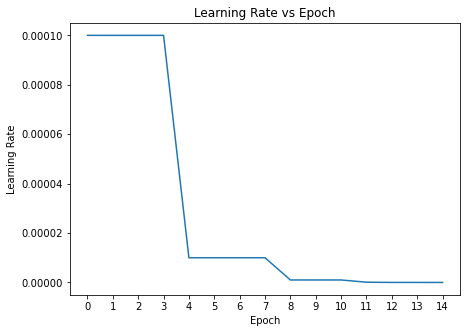

In [18]:
plot_learning_rate(history_dict)

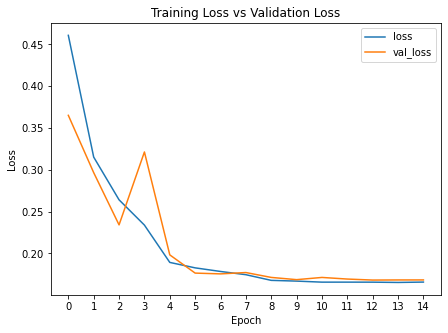

In [19]:
plot_metric(history_dict, 'loss')

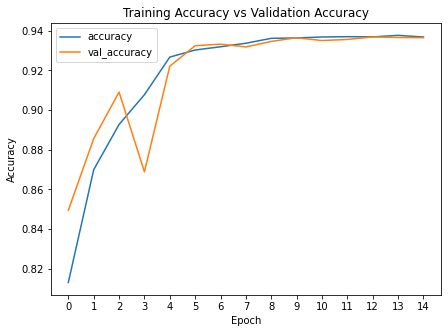

In [20]:
plot_metric(history_dict, 'accuracy')

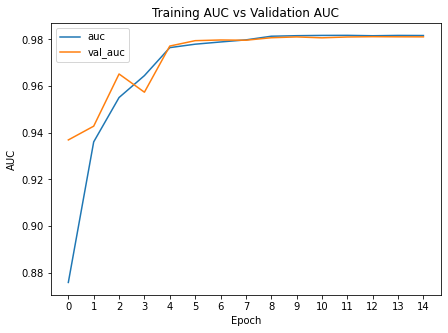

In [21]:
plot_metric(history_dict, 'auc')

---

## Calculate Performance on Test Set

In [22]:
test_metrics = model.evaluate(test_ds, verbose=1)
test_metrics = map_to_metrics(model.metrics_names, test_metrics)

  1/516 [..............................] - ETA: 42s - loss: 0.2860 - accuracy: 0.9375 - auc: 0.9588

 15/516 [..............................] - ETA: 1s - loss: 0.1819 - accuracy: 0.9438 - auc: 0.9735 

 29/516 [>.............................] - ETA: 1s - loss: 0.1804 - accuracy: 0.9364 - auc: 0.9751

 43/516 [=>............................] - ETA: 1s - loss: 0.1693 - accuracy: 0.9404 - auc: 0.9778

 57/516 [==>...........................] - ETA: 1s - loss: 0.1713 - accuracy: 0.9342 - auc: 0.9792

 71/516 [===>..........................] - ETA: 1s - loss: 0.1746 - accuracy: 0.9327 - auc: 0.9793

 85/516 [===>..........................] - ETA: 1s - loss: 0.1679 - accuracy: 0.9353 - auc: 0.9808

 99/516 [====>.........................] - ETA: 1s - loss: 0.1680 - accuracy: 0.9356 - auc: 0.9806

113/516 [=====>........................] - ETA: 1s - loss: 0.1652 - accuracy: 0.9347 - auc: 0.9814

127/516 [======>.......................] - ETA: 1s - loss: 0.1638 - accuracy: 0.9345 - auc: 0.9819

141/516 [=======>......................] - ETA: 1s - loss: 0.1640 - accuracy: 0.9355 - auc: 0.9816

155/516 [========>.....................] - ETA: 1s - loss: 0.1660 - accuracy: 0.9335 - auc: 0.9812

169/516 [========>.....................] - ETA: 1s - loss: 0.1668 - accuracy: 0.9331 - auc: 0.9811

183/516 [=========>....................] - ETA: 1s - loss: 0.1672 - accuracy: 0.9325 - auc: 0.9812

197/516 [==========>...................] - ETA: 1s - loss: 0.1663 - accuracy: 0.9337 - auc: 0.9813

211/516 [===========>..................] - ETA: 1s - loss: 0.1645 - accuracy: 0.9348 - auc: 0.9816

225/516 [============>.................] - ETA: 1s - loss: 0.1645 - accuracy: 0.9358 - auc: 0.9815

239/516 [============>.................] - ETA: 1s - loss: 0.1678 - accuracy: 0.9344 - auc: 0.9811

253/516 [=============>................] - ETA: 0s - loss: 0.1682 - accuracy: 0.9339 - auc: 0.9810

267/516 [==============>...............] - ETA: 0s - loss: 0.1706 - accuracy: 0.9325 - auc: 0.9806

281/516 [===============>..............] - ETA: 0s - loss: 0.1724 - accuracy: 0.9318 - auc: 0.9801

295/516 [================>.............] - ETA: 0s - loss: 0.1720 - accuracy: 0.9322 - auc: 0.9802

309/516 [================>.............] - ETA: 0s - loss: 0.1719 - accuracy: 0.9325 - auc: 0.9803

323/516 [=================>............] - ETA: 0s - loss: 0.1709 - accuracy: 0.9330 - auc: 0.9806

337/516 [==================>...........] - ETA: 0s - loss: 0.1714 - accuracy: 0.9330 - auc: 0.9805

351/516 [===================>..........] - ETA: 0s - loss: 0.1718 - accuracy: 0.9330 - auc: 0.9804

365/516 [====================>.........] - ETA: 0s - loss: 0.1711 - accuracy: 0.9333 - auc: 0.9805

379/516 [=====================>........] - ETA: 0s - loss: 0.1703 - accuracy: 0.9342 - auc: 0.9807

393/516 [=====================>........] - ETA: 0s - loss: 0.1692 - accuracy: 0.9350 - auc: 0.9809

407/516 [======================>.......] - ETA: 0s - loss: 0.1696 - accuracy: 0.9352 - auc: 0.9807

421/516 [=======================>......] - ETA: 0s - loss: 0.1700 - accuracy: 0.9347 - auc: 0.9806

435/516 [========================>.....] - ETA: 0s - loss: 0.1709 - accuracy: 0.9343 - auc: 0.9805

449/516 [=========================>....] - ETA: 0s - loss: 0.1706 - accuracy: 0.9344 - auc: 0.9805

463/516 [=========================>....] - ETA: 0s - loss: 0.1705 - accuracy: 0.9346 - auc: 0.9805

477/516 [==========================>...] - ETA: 0s - loss: 0.1706 - accuracy: 0.9347 - auc: 0.9805

491/516 [===========================>..] - ETA: 0s - loss: 0.1701 - accuracy: 0.9345 - auc: 0.9807

505/516 [============================>.] - ETA: 0s - loss: 0.1697 - accuracy: 0.9343 - auc: 0.9808

516/516 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9345 - auc: 0.9808

516/516 [==============================] - 2s 4ms/step - loss: 0.1694 - accuracy: 0.9345 - auc: 0.9808


In [23]:
# Save test metrics
json.dump(test_metrics, open(f"{model_output_dir}/{MODEL_NAME}/test_metrics.json", 'w'))

---